In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [4]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2021_off_processed.csv", low_memory=False)
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2022_off_processed.csv", low_memory=False)
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2023_off_processed.csv", low_memory=False)

In [5]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [6]:
# Apply the function to the 'pitch_type' column
training_data = data.query('swing == 1')

# Apply the function to the 'pitch_type' column
testing_data_processed = testing_data

In [7]:
breaking_ball = training_data.query('pitch_type_condensed in ("CH")')
breaking_ball_testing = testing_data_processed.query('pitch_type_condensed in ("CH")')


# Fastball Model First

In [14]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']].copy()
testing_identifiers = breaking_ball_testing[['pitch_id_raw']].copy()
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'line_drive', 'contact', 'foul', 'fly_ball', 'ground_ball','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'seasonal_avg_velo', 'swing'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'line_drive', 'contact', 'foul', 'fly_ball', 'ground_ball','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'Unnamed: 0', 'seasonal_avg_velo', 'swing'
], axis=1)   # Exclude the identifier from the features

In [15]:
train_data = training_features.drop(['whiff'], axis=1).copy()
train_label = training_features['whiff'].copy()
testing_data = testing_features.drop(['whiff'], axis=1).copy()
testing_label = testing_features['whiff'].copy()

In [16]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z',
       'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [17]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z',
       'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [18]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [19]:
y_train.value_counts()

whiff
0    114486
1     48450
Name: count, dtype: int64

In [20]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [21]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6954504446449284
Log Loss: 0.6254595232605606


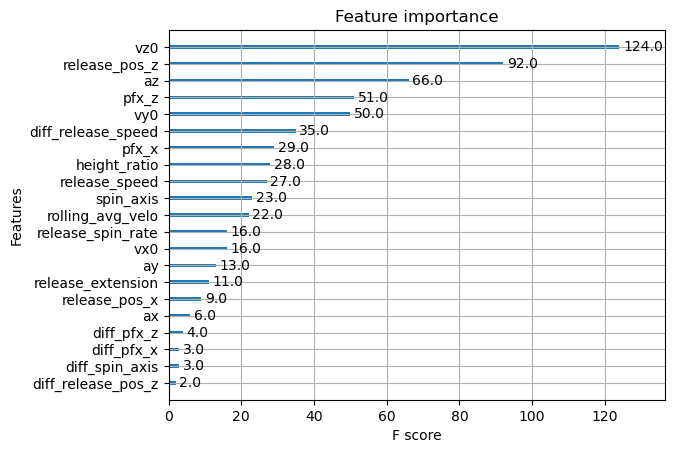

In [22]:
xgb.plot_importance(model)
plt.show()

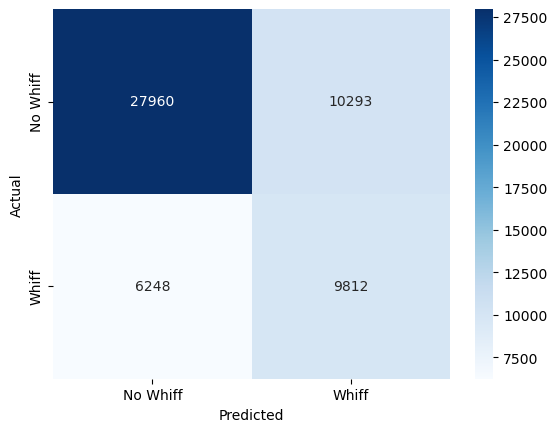

In [23]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Whiff', 'Whiff'], yticklabels=['No Whiff', 'Whiff'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [24]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio,
        'device': 'gpu',
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [25]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-15 11:32:39,047] A new study created in memory with name: no-name-1d9c26cd-6085-4ddf-8856-bf6cbff25b74


[0]	eval-logloss:0.67044
[1]	eval-logloss:0.66664
[2]	eval-logloss:0.65180
[3]	eval-logloss:0.64925
[4]	eval-logloss:0.64776
[5]	eval-logloss:0.64453
[6]	eval-logloss:0.63418
[7]	eval-logloss:0.62702
[8]	eval-logloss:0.62131
[9]	eval-logloss:0.61698
[10]	eval-logloss:0.61525
[11]	eval-logloss:0.61413
[12]	eval-logloss:0.61029
[13]	eval-logloss:0.60695
[14]	eval-logloss:0.60430
[15]	eval-logloss:0.60280
[16]	eval-logloss:0.60154
[17]	eval-logloss:0.59943
[18]	eval-logloss:0.59786
[19]	eval-logloss:0.59668
[20]	eval-logloss:0.59475
[21]	eval-logloss:0.59259
[22]	eval-logloss:0.59145
[23]	eval-logloss:0.58981
[24]	eval-logloss:0.58885
[25]	eval-logloss:0.58774
[26]	eval-logloss:0.58709
[27]	eval-logloss:0.58597
[28]	eval-logloss:0.58475
[29]	eval-logloss:0.58358
[30]	eval-logloss:0.58283
[31]	eval-logloss:0.58185
[32]	eval-logloss:0.58070
[33]	eval-logloss:0.57997
[34]	eval-logloss:0.57875
[35]	eval-logloss:0.57785
[36]	eval-logloss:0.57726
[37]	eval-logloss:0.57624
[38]	eval-logloss:0.57

[I 2023-11-15 11:32:41,183] Trial 0 finished with value: 0.5301164045222223 and parameters: {'max_depth': 5, 'eta': 0.2306635981786779, 'subsample': 0.8885757020744802, 'colsample_bytree': 0.7688154133894856}. Best is trial 0 with value: 0.5301164045222223.


[0]	eval-logloss:0.67090
[1]	eval-logloss:0.66547
[2]	eval-logloss:0.66116
[3]	eval-logloss:0.65615
[4]	eval-logloss:0.65285
[5]	eval-logloss:0.64896
[6]	eval-logloss:0.64566
[7]	eval-logloss:0.63172
[8]	eval-logloss:0.61976
[9]	eval-logloss:0.61091
[10]	eval-logloss:0.60805
[11]	eval-logloss:0.60608
[12]	eval-logloss:0.59842
[13]	eval-logloss:0.59205
[14]	eval-logloss:0.58595
[15]	eval-logloss:0.58380
[16]	eval-logloss:0.58206
[17]	eval-logloss:0.57681
[18]	eval-logloss:0.57319
[19]	eval-logloss:0.57075
[20]	eval-logloss:0.56733
[21]	eval-logloss:0.56334
[22]	eval-logloss:0.55988
[23]	eval-logloss:0.55679
[24]	eval-logloss:0.55397
[25]	eval-logloss:0.55233
[26]	eval-logloss:0.55047
[27]	eval-logloss:0.54857
[28]	eval-logloss:0.54708
[29]	eval-logloss:0.54418
[30]	eval-logloss:0.54204
[31]	eval-logloss:0.54134
[32]	eval-logloss:0.53880
[33]	eval-logloss:0.53703
[34]	eval-logloss:0.53514
[35]	eval-logloss:0.53251
[36]	eval-logloss:0.53049
[37]	eval-logloss:0.52863
[38]	eval-logloss:0.52

[I 2023-11-15 11:32:43,442] Trial 1 finished with value: 0.4546287797213135 and parameters: {'max_depth': 7, 'eta': 0.166398225888783, 'subsample': 0.6754038361201549, 'colsample_bytree': 0.6375288266223631}. Best is trial 1 with value: 0.4546287797213135.


[0]	eval-logloss:0.69070
[1]	eval-logloss:0.69032
[2]	eval-logloss:0.68804
[3]	eval-logloss:0.68766
[4]	eval-logloss:0.68547
[5]	eval-logloss:0.68334
[6]	eval-logloss:0.68135
[7]	eval-logloss:0.67946
[8]	eval-logloss:0.67760
[9]	eval-logloss:0.67586
[10]	eval-logloss:0.67559
[11]	eval-logloss:0.67527
[12]	eval-logloss:0.67357
[13]	eval-logloss:0.67198
[14]	eval-logloss:0.67040
[15]	eval-logloss:0.67012
[16]	eval-logloss:0.66984
[17]	eval-logloss:0.66834
[18]	eval-logloss:0.66691
[19]	eval-logloss:0.66665
[20]	eval-logloss:0.66519
[21]	eval-logloss:0.66381
[22]	eval-logloss:0.66250
[23]	eval-logloss:0.66125
[24]	eval-logloss:0.66008
[25]	eval-logloss:0.65887
[26]	eval-logloss:0.65776
[27]	eval-logloss:0.65664
[28]	eval-logloss:0.65559
[29]	eval-logloss:0.65458
[30]	eval-logloss:0.65434
[31]	eval-logloss:0.65336
[32]	eval-logloss:0.65232
[33]	eval-logloss:0.65135
[34]	eval-logloss:0.65049
[35]	eval-logloss:0.64960
[36]	eval-logloss:0.64871
[37]	eval-logloss:0.64790
[38]	eval-logloss:0.64

[I 2023-11-15 11:32:44,931] Trial 2 finished with value: 0.6215633407472958 and parameters: {'max_depth': 4, 'eta': 0.025711975003130765, 'subsample': 0.8307879857326902, 'colsample_bytree': 0.942347787751963}. Best is trial 1 with value: 0.4546287797213135.


[0]	eval-logloss:0.67452
[1]	eval-logloss:0.66027
[2]	eval-logloss:0.64895
[3]	eval-logloss:0.64597
[4]	eval-logloss:0.63722
[5]	eval-logloss:0.62981
[6]	eval-logloss:0.62389
[7]	eval-logloss:0.61895
[8]	eval-logloss:0.61459
[9]	eval-logloss:0.61114
[10]	eval-logloss:0.60900
[11]	eval-logloss:0.60597
[12]	eval-logloss:0.60286
[13]	eval-logloss:0.59993
[14]	eval-logloss:0.59707
[15]	eval-logloss:0.59538
[16]	eval-logloss:0.59307
[17]	eval-logloss:0.59078
[18]	eval-logloss:0.58874
[19]	eval-logloss:0.58634
[20]	eval-logloss:0.58459
[21]	eval-logloss:0.58280
[22]	eval-logloss:0.58116
[23]	eval-logloss:0.57979
[24]	eval-logloss:0.57805
[25]	eval-logloss:0.57549
[26]	eval-logloss:0.57402
[27]	eval-logloss:0.57316
[28]	eval-logloss:0.57181
[29]	eval-logloss:0.57037
[30]	eval-logloss:0.56900
[31]	eval-logloss:0.56770
[32]	eval-logloss:0.56571
[33]	eval-logloss:0.56476
[34]	eval-logloss:0.56344
[35]	eval-logloss:0.56222
[36]	eval-logloss:0.56080
[37]	eval-logloss:0.55961
[38]	eval-logloss:0.55

[I 2023-11-15 11:32:46,979] Trial 3 finished with value: 0.5075563694114169 and parameters: {'max_depth': 6, 'eta': 0.15989757450479164, 'subsample': 0.6247684869169898, 'colsample_bytree': 0.959783815876873}. Best is trial 1 with value: 0.4546287797213135.


[0]	eval-logloss:0.68383
[1]	eval-logloss:0.68189
[2]	eval-logloss:0.67941
[3]	eval-logloss:0.67743
[4]	eval-logloss:0.67607
[5]	eval-logloss:0.67406
[6]	eval-logloss:0.67247
[7]	eval-logloss:0.66473
[8]	eval-logloss:0.65731
[9]	eval-logloss:0.65563
[10]	eval-logloss:0.65432
[11]	eval-logloss:0.65295
[12]	eval-logloss:0.64675
[13]	eval-logloss:0.64122
[14]	eval-logloss:0.63603
[15]	eval-logloss:0.63532
[16]	eval-logloss:0.63420
[17]	eval-logloss:0.62959
[18]	eval-logloss:0.62592
[19]	eval-logloss:0.62489
[20]	eval-logloss:0.62409
[21]	eval-logloss:0.62073
[22]	eval-logloss:0.61760
[23]	eval-logloss:0.61462
[24]	eval-logloss:0.61210
[25]	eval-logloss:0.61093
[26]	eval-logloss:0.61007
[27]	eval-logloss:0.60768
[28]	eval-logloss:0.60695
[29]	eval-logloss:0.60473
[30]	eval-logloss:0.60360
[31]	eval-logloss:0.60289
[32]	eval-logloss:0.60099
[33]	eval-logloss:0.60011
[34]	eval-logloss:0.59830
[35]	eval-logloss:0.59728
[36]	eval-logloss:0.59538
[37]	eval-logloss:0.59382
[38]	eval-logloss:0.59

[I 2023-11-15 11:32:48,891] Trial 4 finished with value: 0.5471754265708642 and parameters: {'max_depth': 6, 'eta': 0.08680509592927067, 'subsample': 0.6304955638798142, 'colsample_bytree': 0.5538176552348344}. Best is trial 1 with value: 0.4546287797213135.


[0]	eval-logloss:0.65761
[1]	eval-logloss:0.64488
[2]	eval-logloss:0.61985
[3]	eval-logloss:0.60986
[4]	eval-logloss:0.60391
[5]	eval-logloss:0.59558
[6]	eval-logloss:0.57664
[7]	eval-logloss:0.56197
[8]	eval-logloss:0.54872
[9]	eval-logloss:0.53665
[10]	eval-logloss:0.53074
[11]	eval-logloss:0.52741
[12]	eval-logloss:0.51804
[13]	eval-logloss:0.50876
[14]	eval-logloss:0.50083
[15]	eval-logloss:0.49602
[16]	eval-logloss:0.49228
[17]	eval-logloss:0.48533
[18]	eval-logloss:0.47953
[19]	eval-logloss:0.47546
[20]	eval-logloss:0.47079
[21]	eval-logloss:0.46546
[22]	eval-logloss:0.46074
[23]	eval-logloss:0.45609
[24]	eval-logloss:0.45233
[25]	eval-logloss:0.44849
[26]	eval-logloss:0.44622
[27]	eval-logloss:0.44258
[28]	eval-logloss:0.43934
[29]	eval-logloss:0.43543
[30]	eval-logloss:0.43275
[31]	eval-logloss:0.43006
[32]	eval-logloss:0.42598
[33]	eval-logloss:0.42113
[34]	eval-logloss:0.41729
[35]	eval-logloss:0.41506
[36]	eval-logloss:0.41216
[37]	eval-logloss:0.40949
[38]	eval-logloss:0.40

[I 2023-11-15 11:32:52,439] Trial 5 finished with value: 0.29351611251549103 and parameters: {'max_depth': 9, 'eta': 0.19524021751520348, 'subsample': 0.7454663012416116, 'colsample_bytree': 0.7348898830055208}. Best is trial 5 with value: 0.29351611251549103.


[0]	eval-logloss:0.66839
[1]	eval-logloss:0.65116
[2]	eval-logloss:0.63879
[3]	eval-logloss:0.63472
[4]	eval-logloss:0.62506
[5]	eval-logloss:0.61756
[6]	eval-logloss:0.61185
[7]	eval-logloss:0.60711
[8]	eval-logloss:0.60285
[9]	eval-logloss:0.59958
[10]	eval-logloss:0.59683
[11]	eval-logloss:0.59403
[12]	eval-logloss:0.59080
[13]	eval-logloss:0.58773
[14]	eval-logloss:0.58589
[15]	eval-logloss:0.58452
[16]	eval-logloss:0.58227
[17]	eval-logloss:0.57939
[18]	eval-logloss:0.57743
[19]	eval-logloss:0.57559
[20]	eval-logloss:0.57402
[21]	eval-logloss:0.57236
[22]	eval-logloss:0.57055
[23]	eval-logloss:0.56898
[24]	eval-logloss:0.56686
[25]	eval-logloss:0.56553
[26]	eval-logloss:0.56317
[27]	eval-logloss:0.56208
[28]	eval-logloss:0.56099
[29]	eval-logloss:0.55887
[30]	eval-logloss:0.55698
[31]	eval-logloss:0.55628
[32]	eval-logloss:0.55445
[33]	eval-logloss:0.55318
[34]	eval-logloss:0.55141
[35]	eval-logloss:0.55035
[36]	eval-logloss:0.54858
[37]	eval-logloss:0.54711
[38]	eval-logloss:0.54

[I 2023-11-15 11:32:54,407] Trial 6 finished with value: 0.47762394843997086 and parameters: {'max_depth': 6, 'eta': 0.22045686673776035, 'subsample': 0.6978447845346103, 'colsample_bytree': 0.9835950165434326}. Best is trial 5 with value: 0.29351611251549103.


[0]	eval-logloss:0.65095
[1]	eval-logloss:0.63579
[2]	eval-logloss:0.62172
[3]	eval-logloss:0.61127
[4]	eval-logloss:0.60082
[5]	eval-logloss:0.59204
[6]	eval-logloss:0.57974
[7]	eval-logloss:0.55821
[8]	eval-logloss:0.53705
[9]	eval-logloss:0.52993
[10]	eval-logloss:0.52465
[11]	eval-logloss:0.51963
[12]	eval-logloss:0.50467
[13]	eval-logloss:0.49305
[14]	eval-logloss:0.48194
[15]	eval-logloss:0.47555
[16]	eval-logloss:0.47107
[17]	eval-logloss:0.46215
[18]	eval-logloss:0.45467
[19]	eval-logloss:0.44937
[20]	eval-logloss:0.44430
[21]	eval-logloss:0.43779
[22]	eval-logloss:0.43166
[23]	eval-logloss:0.42586
[24]	eval-logloss:0.42030
[25]	eval-logloss:0.41499
[26]	eval-logloss:0.41391
[27]	eval-logloss:0.40918
[28]	eval-logloss:0.40572
[29]	eval-logloss:0.40162
[30]	eval-logloss:0.39734
[31]	eval-logloss:0.39511
[32]	eval-logloss:0.39117
[33]	eval-logloss:0.38886
[34]	eval-logloss:0.38613
[35]	eval-logloss:0.38267
[36]	eval-logloss:0.37951
[37]	eval-logloss:0.37530
[38]	eval-logloss:0.37

[I 2023-11-15 11:32:57,900] Trial 7 finished with value: 0.24290794236306867 and parameters: {'max_depth': 9, 'eta': 0.27130882844752585, 'subsample': 0.8932447741268854, 'colsample_bytree': 0.5888534622390444}. Best is trial 7 with value: 0.24290794236306867.


[0]	eval-logloss:0.66542
[1]	eval-logloss:0.66040
[2]	eval-logloss:0.65643
[3]	eval-logloss:0.65293
[4]	eval-logloss:0.65051
[5]	eval-logloss:0.64679
[6]	eval-logloss:0.64393
[7]	eval-logloss:0.62802
[8]	eval-logloss:0.61602
[9]	eval-logloss:0.60776
[10]	eval-logloss:0.60596
[11]	eval-logloss:0.60431
[12]	eval-logloss:0.59858
[13]	eval-logloss:0.59310
[14]	eval-logloss:0.58879
[15]	eval-logloss:0.58692
[16]	eval-logloss:0.58531
[17]	eval-logloss:0.58139
[18]	eval-logloss:0.57874
[19]	eval-logloss:0.57722
[20]	eval-logloss:0.57431
[21]	eval-logloss:0.57154
[22]	eval-logloss:0.56916
[23]	eval-logloss:0.56718
[24]	eval-logloss:0.56472
[25]	eval-logloss:0.56356
[26]	eval-logloss:0.56218
[27]	eval-logloss:0.56076
[28]	eval-logloss:0.55936
[29]	eval-logloss:0.55755
[30]	eval-logloss:0.55577
[31]	eval-logloss:0.55453
[32]	eval-logloss:0.55228
[33]	eval-logloss:0.55017
[34]	eval-logloss:0.54878
[35]	eval-logloss:0.54646
[36]	eval-logloss:0.54459
[37]	eval-logloss:0.54279
[38]	eval-logloss:0.54

[I 2023-11-15 11:32:59,911] Trial 8 finished with value: 0.47092085162463915 and parameters: {'max_depth': 6, 'eta': 0.2520070095219663, 'subsample': 0.7950342390730177, 'colsample_bytree': 0.6444335236556932}. Best is trial 7 with value: 0.24290794236306867.


[0]	eval-logloss:0.69127
[1]	eval-logloss:0.68937
[2]	eval-logloss:0.68754
[3]	eval-logloss:0.68679
[4]	eval-logloss:0.68503
[5]	eval-logloss:0.68327
[6]	eval-logloss:0.68154
[7]	eval-logloss:0.67989
[8]	eval-logloss:0.67822
[9]	eval-logloss:0.67659
[10]	eval-logloss:0.67602
[11]	eval-logloss:0.67444
[12]	eval-logloss:0.67280
[13]	eval-logloss:0.67131
[14]	eval-logloss:0.66973
[15]	eval-logloss:0.66913
[16]	eval-logloss:0.66847
[17]	eval-logloss:0.66694
[18]	eval-logloss:0.66543
[19]	eval-logloss:0.66394
[20]	eval-logloss:0.66249
[21]	eval-logloss:0.66102
[22]	eval-logloss:0.65960
[23]	eval-logloss:0.65816
[24]	eval-logloss:0.65679
[25]	eval-logloss:0.65540
[26]	eval-logloss:0.65402
[27]	eval-logloss:0.65264
[28]	eval-logloss:0.65134
[29]	eval-logloss:0.65002
[30]	eval-logloss:0.64956
[31]	eval-logloss:0.64836
[32]	eval-logloss:0.64712
[33]	eval-logloss:0.64587
[34]	eval-logloss:0.64467
[35]	eval-logloss:0.64344
[36]	eval-logloss:0.64223
[37]	eval-logloss:0.64108
[38]	eval-logloss:0.63

[I 2023-11-15 11:33:03,196] Trial 9 finished with value: 0.5907119328059439 and parameters: {'max_depth': 8, 'eta': 0.01113047399936965, 'subsample': 0.6237021661529547, 'colsample_bytree': 0.9687718854674514}. Best is trial 7 with value: 0.24290794236306867.


[0]	eval-logloss:0.65106
[1]	eval-logloss:0.63676
[2]	eval-logloss:0.62242
[3]	eval-logloss:0.61183
[4]	eval-logloss:0.60204
[5]	eval-logloss:0.59394
[6]	eval-logloss:0.58673
[7]	eval-logloss:0.56270
[8]	eval-logloss:0.54539
[9]	eval-logloss:0.53756
[10]	eval-logloss:0.53168
[11]	eval-logloss:0.52563
[12]	eval-logloss:0.50916
[13]	eval-logloss:0.49567
[14]	eval-logloss:0.48321
[15]	eval-logloss:0.47727
[16]	eval-logloss:0.47278
[17]	eval-logloss:0.46396
[18]	eval-logloss:0.45753
[19]	eval-logloss:0.45362
[20]	eval-logloss:0.44769
[21]	eval-logloss:0.44224
[22]	eval-logloss:0.43589
[23]	eval-logloss:0.43078
[24]	eval-logloss:0.42523
[25]	eval-logloss:0.42252
[26]	eval-logloss:0.42004
[27]	eval-logloss:0.41545
[28]	eval-logloss:0.41114
[29]	eval-logloss:0.40601
[30]	eval-logloss:0.40356
[31]	eval-logloss:0.40069
[32]	eval-logloss:0.39619
[33]	eval-logloss:0.39411
[34]	eval-logloss:0.39013
[35]	eval-logloss:0.38578
[36]	eval-logloss:0.38171
[37]	eval-logloss:0.37965
[38]	eval-logloss:0.37

[I 2023-11-15 11:33:06,414] Trial 10 finished with value: 0.2427011572198943 and parameters: {'max_depth': 9, 'eta': 0.2742245414497248, 'subsample': 0.8952456053793987, 'colsample_bytree': 0.5068011688780041}. Best is trial 10 with value: 0.2427011572198943.


[0]	eval-logloss:0.64994
[1]	eval-logloss:0.63589
[2]	eval-logloss:0.62205
[3]	eval-logloss:0.61041
[4]	eval-logloss:0.60044
[5]	eval-logloss:0.59034
[6]	eval-logloss:0.58259
[7]	eval-logloss:0.55740
[8]	eval-logloss:0.54109
[9]	eval-logloss:0.53498
[10]	eval-logloss:0.52705
[11]	eval-logloss:0.52281
[12]	eval-logloss:0.50715
[13]	eval-logloss:0.49424
[14]	eval-logloss:0.48309
[15]	eval-logloss:0.47822
[16]	eval-logloss:0.47152
[17]	eval-logloss:0.46133
[18]	eval-logloss:0.45362
[19]	eval-logloss:0.44880
[20]	eval-logloss:0.44583
[21]	eval-logloss:0.44236
[22]	eval-logloss:0.43487
[23]	eval-logloss:0.42744
[24]	eval-logloss:0.42301
[25]	eval-logloss:0.41787
[26]	eval-logloss:0.41393
[27]	eval-logloss:0.40599
[28]	eval-logloss:0.40218
[29]	eval-logloss:0.39648
[30]	eval-logloss:0.39210
[31]	eval-logloss:0.38971
[32]	eval-logloss:0.38541
[33]	eval-logloss:0.38193
[34]	eval-logloss:0.37743
[35]	eval-logloss:0.37300
[36]	eval-logloss:0.36862
[37]	eval-logloss:0.36697
[38]	eval-logloss:0.36

[I 2023-11-15 11:33:09,753] Trial 11 finished with value: 0.2413947305984389 and parameters: {'max_depth': 9, 'eta': 0.2876515220687761, 'subsample': 0.8759528002138128, 'colsample_bytree': 0.5005994988023779}. Best is trial 11 with value: 0.2413947305984389.


[0]	eval-logloss:0.65498
[1]	eval-logloss:0.64582
[2]	eval-logloss:0.63482
[3]	eval-logloss:0.62580
[4]	eval-logloss:0.61910
[5]	eval-logloss:0.61229
[6]	eval-logloss:0.60391
[7]	eval-logloss:0.58433
[8]	eval-logloss:0.56984
[9]	eval-logloss:0.56420
[10]	eval-logloss:0.55992
[11]	eval-logloss:0.55569
[12]	eval-logloss:0.54303
[13]	eval-logloss:0.53338
[14]	eval-logloss:0.52267
[15]	eval-logloss:0.51799
[16]	eval-logloss:0.51393
[17]	eval-logloss:0.50577
[18]	eval-logloss:0.50104
[19]	eval-logloss:0.49655
[20]	eval-logloss:0.49356
[21]	eval-logloss:0.48890
[22]	eval-logloss:0.48330
[23]	eval-logloss:0.47735
[24]	eval-logloss:0.47275
[25]	eval-logloss:0.47017
[26]	eval-logloss:0.46692
[27]	eval-logloss:0.46380
[28]	eval-logloss:0.46122
[29]	eval-logloss:0.45775
[30]	eval-logloss:0.45370
[31]	eval-logloss:0.45176
[32]	eval-logloss:0.44833
[33]	eval-logloss:0.44701
[34]	eval-logloss:0.44336
[35]	eval-logloss:0.44054
[36]	eval-logloss:0.43709
[37]	eval-logloss:0.43468
[38]	eval-logloss:0.43

[I 2023-11-15 11:33:12,293] Trial 12 finished with value: 0.3173008654553317 and parameters: {'max_depth': 8, 'eta': 0.2982633644531334, 'subsample': 0.8541218264381398, 'colsample_bytree': 0.5074889678521504}. Best is trial 11 with value: 0.2413947305984389.


[0]	eval-logloss:0.65575
[1]	eval-logloss:0.64562
[2]	eval-logloss:0.63518
[3]	eval-logloss:0.62653
[4]	eval-logloss:0.61905
[5]	eval-logloss:0.61353
[6]	eval-logloss:0.60726
[7]	eval-logloss:0.58720
[8]	eval-logloss:0.57367
[9]	eval-logloss:0.56838
[10]	eval-logloss:0.56287
[11]	eval-logloss:0.55870
[12]	eval-logloss:0.54557
[13]	eval-logloss:0.53563
[14]	eval-logloss:0.52552
[15]	eval-logloss:0.52040
[16]	eval-logloss:0.51570
[17]	eval-logloss:0.50822
[18]	eval-logloss:0.50181
[19]	eval-logloss:0.49757
[20]	eval-logloss:0.49421
[21]	eval-logloss:0.48919
[22]	eval-logloss:0.48348
[23]	eval-logloss:0.47904
[24]	eval-logloss:0.47496
[25]	eval-logloss:0.47165
[26]	eval-logloss:0.46841
[27]	eval-logloss:0.46464
[28]	eval-logloss:0.46189
[29]	eval-logloss:0.45834
[30]	eval-logloss:0.45472
[31]	eval-logloss:0.45395
[32]	eval-logloss:0.45037
[33]	eval-logloss:0.44642
[34]	eval-logloss:0.44245
[35]	eval-logloss:0.43858
[36]	eval-logloss:0.43434
[37]	eval-logloss:0.43198
[38]	eval-logloss:0.42

[I 2023-11-15 11:33:14,913] Trial 13 finished with value: 0.3180288865809701 and parameters: {'max_depth': 8, 'eta': 0.2883220308082652, 'subsample': 0.8991394211786672, 'colsample_bytree': 0.5159568571011293}. Best is trial 11 with value: 0.2413947305984389.


[0]	eval-logloss:0.67685
[1]	eval-logloss:0.67504
[2]	eval-logloss:0.67282
[3]	eval-logloss:0.67201
[4]	eval-logloss:0.67110
[5]	eval-logloss:0.66951
[6]	eval-logloss:0.66843
[7]	eval-logloss:0.65708
[8]	eval-logloss:0.64996
[9]	eval-logloss:0.64902
[10]	eval-logloss:0.64827
[11]	eval-logloss:0.64777
[12]	eval-logloss:0.64247
[13]	eval-logloss:0.63819
[14]	eval-logloss:0.63400
[15]	eval-logloss:0.63306
[16]	eval-logloss:0.63233
[17]	eval-logloss:0.62930
[18]	eval-logloss:0.62744
[19]	eval-logloss:0.62649
[20]	eval-logloss:0.62594
[21]	eval-logloss:0.62526
[22]	eval-logloss:0.62314
[23]	eval-logloss:0.62159
[24]	eval-logloss:0.62040
[25]	eval-logloss:0.61966
[26]	eval-logloss:0.61905
[27]	eval-logloss:0.61810
[28]	eval-logloss:0.61775
[29]	eval-logloss:0.61664
[30]	eval-logloss:0.61624
[31]	eval-logloss:0.61586
[32]	eval-logloss:0.61486
[33]	eval-logloss:0.61443
[34]	eval-logloss:0.61359
[35]	eval-logloss:0.61302
[36]	eval-logloss:0.61235
[37]	eval-logloss:0.61198
[38]	eval-logloss:0.61

[I 2023-11-15 11:33:16,314] Trial 14 finished with value: 0.5919681326077151 and parameters: {'max_depth': 3, 'eta': 0.25421242067803584, 'subsample': 0.8342611873186958, 'colsample_bytree': 0.506509488600966}. Best is trial 11 with value: 0.2413947305984389.


[0]	eval-logloss:0.64892
[1]	eval-logloss:0.63470
[2]	eval-logloss:0.62015
[3]	eval-logloss:0.61136
[4]	eval-logloss:0.60185
[5]	eval-logloss:0.58958
[6]	eval-logloss:0.57999
[7]	eval-logloss:0.55607
[8]	eval-logloss:0.53574
[9]	eval-logloss:0.53006
[10]	eval-logloss:0.52366
[11]	eval-logloss:0.51438
[12]	eval-logloss:0.50005
[13]	eval-logloss:0.48670
[14]	eval-logloss:0.47616
[15]	eval-logloss:0.47069
[16]	eval-logloss:0.46403
[17]	eval-logloss:0.45577
[18]	eval-logloss:0.44919
[19]	eval-logloss:0.44644
[20]	eval-logloss:0.44377
[21]	eval-logloss:0.43585
[22]	eval-logloss:0.43063
[23]	eval-logloss:0.42556
[24]	eval-logloss:0.41933
[25]	eval-logloss:0.41634
[26]	eval-logloss:0.41372
[27]	eval-logloss:0.41048
[28]	eval-logloss:0.40640
[29]	eval-logloss:0.40286
[30]	eval-logloss:0.39955
[31]	eval-logloss:0.39746
[32]	eval-logloss:0.39253
[33]	eval-logloss:0.39061
[34]	eval-logloss:0.38676
[35]	eval-logloss:0.38338
[36]	eval-logloss:0.38018
[37]	eval-logloss:0.37774
[38]	eval-logloss:0.37

[I 2023-11-15 11:33:19,585] Trial 15 finished with value: 0.23973350561582232 and parameters: {'max_depth': 9, 'eta': 0.2957741802336328, 'subsample': 0.7914728172917869, 'colsample_bytree': 0.58780763172672}. Best is trial 15 with value: 0.23973350561582232.


[0]	eval-logloss:0.66043
[1]	eval-logloss:0.65209
[2]	eval-logloss:0.64318
[3]	eval-logloss:0.63678
[4]	eval-logloss:0.63242
[5]	eval-logloss:0.62639
[6]	eval-logloss:0.62190
[7]	eval-logloss:0.60489
[8]	eval-logloss:0.59016
[9]	eval-logloss:0.58093
[10]	eval-logloss:0.57759
[11]	eval-logloss:0.57466
[12]	eval-logloss:0.56776
[13]	eval-logloss:0.56170
[14]	eval-logloss:0.55620
[15]	eval-logloss:0.55314
[16]	eval-logloss:0.54890
[17]	eval-logloss:0.54373
[18]	eval-logloss:0.53953
[19]	eval-logloss:0.53733
[20]	eval-logloss:0.53446
[21]	eval-logloss:0.53052
[22]	eval-logloss:0.52761
[23]	eval-logloss:0.52376
[24]	eval-logloss:0.52058
[25]	eval-logloss:0.51846
[26]	eval-logloss:0.51785
[27]	eval-logloss:0.51405
[28]	eval-logloss:0.51170
[29]	eval-logloss:0.50997
[30]	eval-logloss:0.50690
[31]	eval-logloss:0.50581
[32]	eval-logloss:0.50350
[33]	eval-logloss:0.50157
[34]	eval-logloss:0.49891
[35]	eval-logloss:0.49711
[36]	eval-logloss:0.49562
[37]	eval-logloss:0.49494
[38]	eval-logloss:0.49

[I 2023-11-15 11:33:21,682] Trial 16 finished with value: 0.3899666560998012 and parameters: {'max_depth': 7, 'eta': 0.29500736979670894, 'subsample': 0.7833563130526793, 'colsample_bytree': 0.593017141310818}. Best is trial 15 with value: 0.23973350561582232.


[0]	eval-logloss:0.66403
[1]	eval-logloss:0.65496
[2]	eval-logloss:0.64517
[3]	eval-logloss:0.63817
[4]	eval-logloss:0.63338
[5]	eval-logloss:0.62607
[6]	eval-logloss:0.62088
[7]	eval-logloss:0.60331
[8]	eval-logloss:0.58759
[9]	eval-logloss:0.58279
[10]	eval-logloss:0.57953
[11]	eval-logloss:0.57594
[12]	eval-logloss:0.56380
[13]	eval-logloss:0.55387
[14]	eval-logloss:0.54525
[15]	eval-logloss:0.54072
[16]	eval-logloss:0.53824
[17]	eval-logloss:0.53156
[18]	eval-logloss:0.52634
[19]	eval-logloss:0.52416
[20]	eval-logloss:0.52124
[21]	eval-logloss:0.51538
[22]	eval-logloss:0.51000
[23]	eval-logloss:0.50550
[24]	eval-logloss:0.50205
[25]	eval-logloss:0.49916
[26]	eval-logloss:0.49615
[27]	eval-logloss:0.49225
[28]	eval-logloss:0.48919
[29]	eval-logloss:0.48574
[30]	eval-logloss:0.48309
[31]	eval-logloss:0.48101
[32]	eval-logloss:0.47762
[33]	eval-logloss:0.47453
[34]	eval-logloss:0.47256
[35]	eval-logloss:0.46729
[36]	eval-logloss:0.46336
[37]	eval-logloss:0.46111
[38]	eval-logloss:0.45

[I 2023-11-15 11:33:24,377] Trial 17 finished with value: 0.3539627736600548 and parameters: {'max_depth': 8, 'eta': 0.21963680767152322, 'subsample': 0.7882873699019161, 'colsample_bytree': 0.5904113888190856}. Best is trial 15 with value: 0.23973350561582232.


[0]	eval-logloss:0.66126
[1]	eval-logloss:0.65392
[2]	eval-logloss:0.63408
[3]	eval-logloss:0.62924
[4]	eval-logloss:0.62542
[5]	eval-logloss:0.62194
[6]	eval-logloss:0.60803
[7]	eval-logloss:0.59846
[8]	eval-logloss:0.59058
[9]	eval-logloss:0.58418
[10]	eval-logloss:0.58081
[11]	eval-logloss:0.57818
[12]	eval-logloss:0.57303
[13]	eval-logloss:0.56848
[14]	eval-logloss:0.56247
[15]	eval-logloss:0.55886
[16]	eval-logloss:0.55667
[17]	eval-logloss:0.55234
[18]	eval-logloss:0.54901
[19]	eval-logloss:0.54565
[20]	eval-logloss:0.54256
[21]	eval-logloss:0.53922
[22]	eval-logloss:0.53752
[23]	eval-logloss:0.53512
[24]	eval-logloss:0.53170
[25]	eval-logloss:0.53011
[26]	eval-logloss:0.52733
[27]	eval-logloss:0.52548
[28]	eval-logloss:0.52322
[29]	eval-logloss:0.52171
[30]	eval-logloss:0.51895
[31]	eval-logloss:0.51679
[32]	eval-logloss:0.51398
[33]	eval-logloss:0.51052
[34]	eval-logloss:0.50854
[35]	eval-logloss:0.50619
[36]	eval-logloss:0.50297
[37]	eval-logloss:0.50225
[38]	eval-logloss:0.50

[I 2023-11-15 11:33:26,569] Trial 18 finished with value: 0.40193489124656373 and parameters: {'max_depth': 7, 'eta': 0.24750324069975663, 'subsample': 0.7402217569013732, 'colsample_bytree': 0.6844398500398927}. Best is trial 15 with value: 0.23973350561582232.


[0]	eval-logloss:0.66238
[1]	eval-logloss:0.65109
[2]	eval-logloss:0.63966
[3]	eval-logloss:0.63042
[4]	eval-logloss:0.62333
[5]	eval-logloss:0.61429
[6]	eval-logloss:0.60590
[7]	eval-logloss:0.58690
[8]	eval-logloss:0.56923
[9]	eval-logloss:0.56373
[10]	eval-logloss:0.55894
[11]	eval-logloss:0.55362
[12]	eval-logloss:0.53876
[13]	eval-logloss:0.52625
[14]	eval-logloss:0.51606
[15]	eval-logloss:0.51076
[16]	eval-logloss:0.50725
[17]	eval-logloss:0.49805
[18]	eval-logloss:0.49103
[19]	eval-logloss:0.48635
[20]	eval-logloss:0.48072
[21]	eval-logloss:0.47369
[22]	eval-logloss:0.46731
[23]	eval-logloss:0.46175
[24]	eval-logloss:0.45646
[25]	eval-logloss:0.45311
[26]	eval-logloss:0.44971
[27]	eval-logloss:0.44454
[28]	eval-logloss:0.44168
[29]	eval-logloss:0.43712
[30]	eval-logloss:0.43386
[31]	eval-logloss:0.43163
[32]	eval-logloss:0.42860
[33]	eval-logloss:0.42545
[34]	eval-logloss:0.42222
[35]	eval-logloss:0.41738
[36]	eval-logloss:0.41331
[37]	eval-logloss:0.41082
[38]	eval-logloss:0.40

[I 2023-11-15 11:33:29,916] Trial 19 finished with value: 0.30023574465759195 and parameters: {'max_depth': 9, 'eta': 0.1923178432517037, 'subsample': 0.855005332676398, 'colsample_bytree': 0.5617234299139753}. Best is trial 15 with value: 0.23973350561582232.


[0]	eval-logloss:0.64635
[1]	eval-logloss:0.63351
[2]	eval-logloss:0.62304
[3]	eval-logloss:0.61067
[4]	eval-logloss:0.60331
[5]	eval-logloss:0.59336
[6]	eval-logloss:0.58426
[7]	eval-logloss:0.55990
[8]	eval-logloss:0.54012
[9]	eval-logloss:0.52445
[10]	eval-logloss:0.51939
[11]	eval-logloss:0.51521
[12]	eval-logloss:0.50388
[13]	eval-logloss:0.49333
[14]	eval-logloss:0.48239
[15]	eval-logloss:0.47726
[16]	eval-logloss:0.47206
[17]	eval-logloss:0.46375
[18]	eval-logloss:0.45576
[19]	eval-logloss:0.45163
[20]	eval-logloss:0.44739
[21]	eval-logloss:0.43978
[22]	eval-logloss:0.43320
[23]	eval-logloss:0.42839
[24]	eval-logloss:0.42516
[25]	eval-logloss:0.42335
[26]	eval-logloss:0.42221
[27]	eval-logloss:0.41791
[28]	eval-logloss:0.41391
[29]	eval-logloss:0.40970
[30]	eval-logloss:0.40457
[31]	eval-logloss:0.40128
[32]	eval-logloss:0.39537
[33]	eval-logloss:0.38978
[34]	eval-logloss:0.38792
[35]	eval-logloss:0.38605
[36]	eval-logloss:0.38196
[37]	eval-logloss:0.37855
[38]	eval-logloss:0.37

[I 2023-11-15 11:33:33,343] Trial 20 finished with value: 0.24603627338099748 and parameters: {'max_depth': 9, 'eta': 0.2659423011937636, 'subsample': 0.8106995028567365, 'colsample_bytree': 0.6367642493789567}. Best is trial 15 with value: 0.23973350561582232.


[0]	eval-logloss:0.65176
[1]	eval-logloss:0.63941
[2]	eval-logloss:0.62679
[3]	eval-logloss:0.61650
[4]	eval-logloss:0.60662
[5]	eval-logloss:0.59754
[6]	eval-logloss:0.58972
[7]	eval-logloss:0.56716
[8]	eval-logloss:0.54999
[9]	eval-logloss:0.54404
[10]	eval-logloss:0.53739
[11]	eval-logloss:0.53223
[12]	eval-logloss:0.51513
[13]	eval-logloss:0.50171
[14]	eval-logloss:0.49044
[15]	eval-logloss:0.48162
[16]	eval-logloss:0.47736
[17]	eval-logloss:0.46745
[18]	eval-logloss:0.45954
[19]	eval-logloss:0.45392
[20]	eval-logloss:0.44880
[21]	eval-logloss:0.44361
[22]	eval-logloss:0.43572
[23]	eval-logloss:0.42923
[24]	eval-logloss:0.42398
[25]	eval-logloss:0.41851
[26]	eval-logloss:0.41593
[27]	eval-logloss:0.41095
[28]	eval-logloss:0.40696
[29]	eval-logloss:0.40245
[30]	eval-logloss:0.39881
[31]	eval-logloss:0.39751
[32]	eval-logloss:0.39325
[33]	eval-logloss:0.38889
[34]	eval-logloss:0.38502
[35]	eval-logloss:0.37953
[36]	eval-logloss:0.37501
[37]	eval-logloss:0.37107
[38]	eval-logloss:0.36

[I 2023-11-15 11:33:36,617] Trial 21 finished with value: 0.2487457551332376 and parameters: {'max_depth': 9, 'eta': 0.27290693300555263, 'subsample': 0.8670309441310333, 'colsample_bytree': 0.5005153266356026}. Best is trial 15 with value: 0.23973350561582232.


[0]	eval-logloss:0.65657
[1]	eval-logloss:0.64532
[2]	eval-logloss:0.63459
[3]	eval-logloss:0.62626
[4]	eval-logloss:0.62067
[5]	eval-logloss:0.61086
[6]	eval-logloss:0.60563
[7]	eval-logloss:0.58714
[8]	eval-logloss:0.57114
[9]	eval-logloss:0.56518
[10]	eval-logloss:0.56009
[11]	eval-logloss:0.55564
[12]	eval-logloss:0.54329
[13]	eval-logloss:0.53257
[14]	eval-logloss:0.52450
[15]	eval-logloss:0.51911
[16]	eval-logloss:0.51566
[17]	eval-logloss:0.50834
[18]	eval-logloss:0.50260
[19]	eval-logloss:0.49864
[20]	eval-logloss:0.49438
[21]	eval-logloss:0.48880
[22]	eval-logloss:0.48407
[23]	eval-logloss:0.47912
[24]	eval-logloss:0.47557
[25]	eval-logloss:0.47217
[26]	eval-logloss:0.47115
[27]	eval-logloss:0.46826
[28]	eval-logloss:0.46490
[29]	eval-logloss:0.46189
[30]	eval-logloss:0.45929
[31]	eval-logloss:0.45656
[32]	eval-logloss:0.45225
[33]	eval-logloss:0.44998
[34]	eval-logloss:0.44668
[35]	eval-logloss:0.44529
[36]	eval-logloss:0.44040
[37]	eval-logloss:0.43908
[38]	eval-logloss:0.43

[I 2023-11-15 11:33:39,172] Trial 22 finished with value: 0.3205637257239193 and parameters: {'max_depth': 8, 'eta': 0.2812847335245036, 'subsample': 0.8727384690557851, 'colsample_bytree': 0.5541641005990932}. Best is trial 15 with value: 0.23973350561582232.


[0]	eval-logloss:0.64953
[1]	eval-logloss:0.63651
[2]	eval-logloss:0.62309
[3]	eval-logloss:0.61195
[4]	eval-logloss:0.60277
[5]	eval-logloss:0.59592
[6]	eval-logloss:0.58875
[7]	eval-logloss:0.56330
[8]	eval-logloss:0.54680
[9]	eval-logloss:0.53960
[10]	eval-logloss:0.53421
[11]	eval-logloss:0.52267
[12]	eval-logloss:0.50589
[13]	eval-logloss:0.49385
[14]	eval-logloss:0.48221
[15]	eval-logloss:0.47572
[16]	eval-logloss:0.47120
[17]	eval-logloss:0.46118
[18]	eval-logloss:0.45520
[19]	eval-logloss:0.45089
[20]	eval-logloss:0.44846
[21]	eval-logloss:0.44144
[22]	eval-logloss:0.43397
[23]	eval-logloss:0.42847
[24]	eval-logloss:0.42445
[25]	eval-logloss:0.42028
[26]	eval-logloss:0.41796
[27]	eval-logloss:0.41280
[28]	eval-logloss:0.40973
[29]	eval-logloss:0.40492
[30]	eval-logloss:0.40073
[31]	eval-logloss:0.39777
[32]	eval-logloss:0.39477
[33]	eval-logloss:0.39008
[34]	eval-logloss:0.38422
[35]	eval-logloss:0.38057
[36]	eval-logloss:0.37619
[37]	eval-logloss:0.37452
[38]	eval-logloss:0.37

[I 2023-11-15 11:33:42,365] Trial 23 finished with value: 0.23988100744062327 and parameters: {'max_depth': 9, 'eta': 0.29576396481850287, 'subsample': 0.8284171407019346, 'colsample_bytree': 0.5431331023534721}. Best is trial 15 with value: 0.23973350561582232.


[0]	eval-logloss:0.65537
[1]	eval-logloss:0.64530
[2]	eval-logloss:0.63466
[3]	eval-logloss:0.62651
[4]	eval-logloss:0.61971
[5]	eval-logloss:0.61180
[6]	eval-logloss:0.60548
[7]	eval-logloss:0.58508
[8]	eval-logloss:0.56848
[9]	eval-logloss:0.56408
[10]	eval-logloss:0.56077
[11]	eval-logloss:0.55658
[12]	eval-logloss:0.54463
[13]	eval-logloss:0.53479
[14]	eval-logloss:0.52640
[15]	eval-logloss:0.52199
[16]	eval-logloss:0.51719
[17]	eval-logloss:0.50937
[18]	eval-logloss:0.50510
[19]	eval-logloss:0.50093
[20]	eval-logloss:0.49790
[21]	eval-logloss:0.49166
[22]	eval-logloss:0.48528
[23]	eval-logloss:0.48036
[24]	eval-logloss:0.47630
[25]	eval-logloss:0.47238
[26]	eval-logloss:0.47005
[27]	eval-logloss:0.46731
[28]	eval-logloss:0.46336
[29]	eval-logloss:0.46050
[30]	eval-logloss:0.45813
[31]	eval-logloss:0.45464
[32]	eval-logloss:0.44979
[33]	eval-logloss:0.44703
[34]	eval-logloss:0.44391
[35]	eval-logloss:0.44097
[36]	eval-logloss:0.43744
[37]	eval-logloss:0.43536
[38]	eval-logloss:0.43

[I 2023-11-15 11:33:44,923] Trial 24 finished with value: 0.31518657113449805 and parameters: {'max_depth': 8, 'eta': 0.2947254125140684, 'subsample': 0.8191082898342262, 'colsample_bytree': 0.5716503065607303}. Best is trial 15 with value: 0.23973350561582232.


[0]	eval-logloss:0.65966
[1]	eval-logloss:0.65116
[2]	eval-logloss:0.64230
[3]	eval-logloss:0.63650
[4]	eval-logloss:0.63212
[5]	eval-logloss:0.62527
[6]	eval-logloss:0.62135
[7]	eval-logloss:0.60462
[8]	eval-logloss:0.59090
[9]	eval-logloss:0.58712
[10]	eval-logloss:0.58465
[11]	eval-logloss:0.58138
[12]	eval-logloss:0.57228
[13]	eval-logloss:0.56537
[14]	eval-logloss:0.55842
[15]	eval-logloss:0.55435
[16]	eval-logloss:0.55180
[17]	eval-logloss:0.54611
[18]	eval-logloss:0.54268
[19]	eval-logloss:0.53951
[20]	eval-logloss:0.53588
[21]	eval-logloss:0.53120
[22]	eval-logloss:0.52843
[23]	eval-logloss:0.52420
[24]	eval-logloss:0.52047
[25]	eval-logloss:0.51818
[26]	eval-logloss:0.51531
[27]	eval-logloss:0.51189
[28]	eval-logloss:0.50928
[29]	eval-logloss:0.50708
[30]	eval-logloss:0.50502
[31]	eval-logloss:0.50399
[32]	eval-logloss:0.50158
[33]	eval-logloss:0.49799
[34]	eval-logloss:0.49667
[35]	eval-logloss:0.49439
[36]	eval-logloss:0.49123
[37]	eval-logloss:0.49016
[38]	eval-logloss:0.48

[I 2023-11-15 11:33:47,019] Trial 25 finished with value: 0.38407552293536185 and parameters: {'max_depth': 7, 'eta': 0.2994869175380271, 'subsample': 0.8446411546718675, 'colsample_bytree': 0.550913321318622}. Best is trial 15 with value: 0.23973350561582232.


[0]	eval-logloss:0.65709
[1]	eval-logloss:0.64617
[2]	eval-logloss:0.63408
[3]	eval-logloss:0.62359
[4]	eval-logloss:0.61461
[5]	eval-logloss:0.60604
[6]	eval-logloss:0.59924
[7]	eval-logloss:0.57709
[8]	eval-logloss:0.56231
[9]	eval-logloss:0.55544
[10]	eval-logloss:0.55023
[11]	eval-logloss:0.54473
[12]	eval-logloss:0.52813
[13]	eval-logloss:0.51595
[14]	eval-logloss:0.50267
[15]	eval-logloss:0.49700
[16]	eval-logloss:0.49228
[17]	eval-logloss:0.48236
[18]	eval-logloss:0.47505
[19]	eval-logloss:0.46991
[20]	eval-logloss:0.46674
[21]	eval-logloss:0.45984
[22]	eval-logloss:0.45246
[23]	eval-logloss:0.44620
[24]	eval-logloss:0.44185
[25]	eval-logloss:0.43794
[26]	eval-logloss:0.43448
[27]	eval-logloss:0.42958
[28]	eval-logloss:0.42540
[29]	eval-logloss:0.42081
[30]	eval-logloss:0.41780
[31]	eval-logloss:0.41551
[32]	eval-logloss:0.41253
[33]	eval-logloss:0.40951
[34]	eval-logloss:0.40509
[35]	eval-logloss:0.40035
[36]	eval-logloss:0.39697
[37]	eval-logloss:0.39362
[38]	eval-logloss:0.39

[I 2023-11-15 11:33:50,389] Trial 26 finished with value: 0.27141959725374726 and parameters: {'max_depth': 9, 'eta': 0.23726847769152912, 'subsample': 0.8162200828346283, 'colsample_bytree': 0.540321708503601}. Best is trial 15 with value: 0.23973350561582232.


[0]	eval-logloss:0.66135
[1]	eval-logloss:0.65056
[2]	eval-logloss:0.64241
[3]	eval-logloss:0.63419
[4]	eval-logloss:0.62875
[5]	eval-logloss:0.62156
[6]	eval-logloss:0.61542
[7]	eval-logloss:0.59624
[8]	eval-logloss:0.57954
[9]	eval-logloss:0.56749
[10]	eval-logloss:0.56333
[11]	eval-logloss:0.55947
[12]	eval-logloss:0.54919
[13]	eval-logloss:0.54042
[14]	eval-logloss:0.53151
[15]	eval-logloss:0.52788
[16]	eval-logloss:0.52350
[17]	eval-logloss:0.51678
[18]	eval-logloss:0.51212
[19]	eval-logloss:0.50888
[20]	eval-logloss:0.50492
[21]	eval-logloss:0.50010
[22]	eval-logloss:0.49609
[23]	eval-logloss:0.49241
[24]	eval-logloss:0.48784
[25]	eval-logloss:0.48542
[26]	eval-logloss:0.48208
[27]	eval-logloss:0.47848
[28]	eval-logloss:0.47660
[29]	eval-logloss:0.47354
[30]	eval-logloss:0.46949
[31]	eval-logloss:0.46803
[32]	eval-logloss:0.46475
[33]	eval-logloss:0.46224
[34]	eval-logloss:0.45904
[35]	eval-logloss:0.45556
[36]	eval-logloss:0.45266
[37]	eval-logloss:0.45001
[38]	eval-logloss:0.44

[I 2023-11-15 11:33:53,128] Trial 27 finished with value: 0.3348587666814938 and parameters: {'max_depth': 8, 'eta': 0.23999364822536176, 'subsample': 0.7745290016169779, 'colsample_bytree': 0.6035955156471898}. Best is trial 15 with value: 0.23973350561582232.


[0]	eval-logloss:0.65264
[1]	eval-logloss:0.63766
[2]	eval-logloss:0.62365
[3]	eval-logloss:0.61375
[4]	eval-logloss:0.60438
[5]	eval-logloss:0.59231
[6]	eval-logloss:0.58583
[7]	eval-logloss:0.56267
[8]	eval-logloss:0.54242
[9]	eval-logloss:0.53506
[10]	eval-logloss:0.52980
[11]	eval-logloss:0.52374
[12]	eval-logloss:0.50776
[13]	eval-logloss:0.49600
[14]	eval-logloss:0.48464
[15]	eval-logloss:0.47866
[16]	eval-logloss:0.47588
[17]	eval-logloss:0.46838
[18]	eval-logloss:0.46208
[19]	eval-logloss:0.45875
[20]	eval-logloss:0.45519
[21]	eval-logloss:0.44762
[22]	eval-logloss:0.43930
[23]	eval-logloss:0.43392
[24]	eval-logloss:0.42988
[25]	eval-logloss:0.42637
[26]	eval-logloss:0.42289
[27]	eval-logloss:0.41933
[28]	eval-logloss:0.41657
[29]	eval-logloss:0.41110
[30]	eval-logloss:0.40929
[31]	eval-logloss:0.40727
[32]	eval-logloss:0.40393
[33]	eval-logloss:0.40203
[34]	eval-logloss:0.39877
[35]	eval-logloss:0.39564
[36]	eval-logloss:0.39075
[37]	eval-logloss:0.38919
[38]	eval-logloss:0.38

[I 2023-11-15 11:33:56,094] Trial 28 finished with value: 0.2514318974574817 and parameters: {'max_depth': 9, 'eta': 0.26738236347544864, 'subsample': 0.8384644388077565, 'colsample_bytree': 0.5551901988728937}. Best is trial 15 with value: 0.23973350561582232.


[0]	eval-logloss:0.67114
[1]	eval-logloss:0.66769
[2]	eval-logloss:0.65291
[3]	eval-logloss:0.65070
[4]	eval-logloss:0.64897
[5]	eval-logloss:0.64692
[6]	eval-logloss:0.63634
[7]	eval-logloss:0.62880
[8]	eval-logloss:0.62271
[9]	eval-logloss:0.61837
[10]	eval-logloss:0.61695
[11]	eval-logloss:0.61560
[12]	eval-logloss:0.61212
[13]	eval-logloss:0.60921
[14]	eval-logloss:0.60613
[15]	eval-logloss:0.60461
[16]	eval-logloss:0.60360
[17]	eval-logloss:0.60133
[18]	eval-logloss:0.59970
[19]	eval-logloss:0.59794
[20]	eval-logloss:0.59593
[21]	eval-logloss:0.59441
[22]	eval-logloss:0.59294
[23]	eval-logloss:0.59134
[24]	eval-logloss:0.58981
[25]	eval-logloss:0.58874
[26]	eval-logloss:0.58789
[27]	eval-logloss:0.58669
[28]	eval-logloss:0.58611
[29]	eval-logloss:0.58486
[30]	eval-logloss:0.58384
[31]	eval-logloss:0.58283
[32]	eval-logloss:0.58153
[33]	eval-logloss:0.58089
[34]	eval-logloss:0.58026
[35]	eval-logloss:0.57912
[36]	eval-logloss:0.57752
[37]	eval-logloss:0.57641
[38]	eval-logloss:0.57

[I 2023-11-15 11:33:57,756] Trial 29 finished with value: 0.5346513761939384 and parameters: {'max_depth': 5, 'eta': 0.22186997417497012, 'subsample': 0.8695372940251088, 'colsample_bytree': 0.6986701706459835}. Best is trial 15 with value: 0.23973350561582232.


[0]	eval-logloss:0.67025
[1]	eval-logloss:0.66617
[2]	eval-logloss:0.66193
[3]	eval-logloss:0.65961
[4]	eval-logloss:0.65769
[5]	eval-logloss:0.65389
[6]	eval-logloss:0.65153
[7]	eval-logloss:0.63872
[8]	eval-logloss:0.62811
[9]	eval-logloss:0.62125
[10]	eval-logloss:0.62002
[11]	eval-logloss:0.61869
[12]	eval-logloss:0.61395
[13]	eval-logloss:0.60992
[14]	eval-logloss:0.60619
[15]	eval-logloss:0.60427
[16]	eval-logloss:0.60284
[17]	eval-logloss:0.59944
[18]	eval-logloss:0.59765
[19]	eval-logloss:0.59620
[20]	eval-logloss:0.59426
[21]	eval-logloss:0.59215
[22]	eval-logloss:0.59069
[23]	eval-logloss:0.58890
[24]	eval-logloss:0.58723
[25]	eval-logloss:0.58601
[26]	eval-logloss:0.58440
[27]	eval-logloss:0.58292
[28]	eval-logloss:0.58177
[29]	eval-logloss:0.58046
[30]	eval-logloss:0.57904
[31]	eval-logloss:0.57799
[32]	eval-logloss:0.57664
[33]	eval-logloss:0.57581
[34]	eval-logloss:0.57444
[35]	eval-logloss:0.57291
[36]	eval-logloss:0.57171
[37]	eval-logloss:0.57062
[38]	eval-logloss:0.56

[I 2023-11-15 11:33:59,331] Trial 30 finished with value: 0.5240014838689472 and parameters: {'max_depth': 5, 'eta': 0.2608692228252527, 'subsample': 0.8776986425296674, 'colsample_bytree': 0.6111345346917411}. Best is trial 15 with value: 0.23973350561582232.


[0]	eval-logloss:0.65181
[1]	eval-logloss:0.63902
[2]	eval-logloss:0.62398
[3]	eval-logloss:0.61413
[4]	eval-logloss:0.60364
[5]	eval-logloss:0.59383
[6]	eval-logloss:0.58599
[7]	eval-logloss:0.56265
[8]	eval-logloss:0.54638
[9]	eval-logloss:0.53990
[10]	eval-logloss:0.53414
[11]	eval-logloss:0.52848
[12]	eval-logloss:0.51181
[13]	eval-logloss:0.50038
[14]	eval-logloss:0.48734
[15]	eval-logloss:0.48080
[16]	eval-logloss:0.47605
[17]	eval-logloss:0.46634
[18]	eval-logloss:0.45987
[19]	eval-logloss:0.45500
[20]	eval-logloss:0.45210
[21]	eval-logloss:0.44619
[22]	eval-logloss:0.43938
[23]	eval-logloss:0.43299
[24]	eval-logloss:0.42939
[25]	eval-logloss:0.42509
[26]	eval-logloss:0.42093
[27]	eval-logloss:0.41580
[28]	eval-logloss:0.41273
[29]	eval-logloss:0.40701
[30]	eval-logloss:0.40427
[31]	eval-logloss:0.40301
[32]	eval-logloss:0.39899
[33]	eval-logloss:0.39618
[34]	eval-logloss:0.39325
[35]	eval-logloss:0.38825
[36]	eval-logloss:0.38424
[37]	eval-logloss:0.38149
[38]	eval-logloss:0.37

[I 2023-11-15 11:34:02,594] Trial 31 finished with value: 0.2463663585290513 and parameters: {'max_depth': 9, 'eta': 0.27087951860305226, 'subsample': 0.8867516784384694, 'colsample_bytree': 0.5236930791641156}. Best is trial 15 with value: 0.23973350561582232.


[0]	eval-logloss:0.65090
[1]	eval-logloss:0.63820
[2]	eval-logloss:0.62649
[3]	eval-logloss:0.61549
[4]	eval-logloss:0.60513
[5]	eval-logloss:0.59683
[6]	eval-logloss:0.58891
[7]	eval-logloss:0.56447
[8]	eval-logloss:0.54739
[9]	eval-logloss:0.54178
[10]	eval-logloss:0.53594
[11]	eval-logloss:0.52797
[12]	eval-logloss:0.51089
[13]	eval-logloss:0.49814
[14]	eval-logloss:0.48603
[15]	eval-logloss:0.47980
[16]	eval-logloss:0.47547
[17]	eval-logloss:0.46600
[18]	eval-logloss:0.46030
[19]	eval-logloss:0.45641
[20]	eval-logloss:0.45001
[21]	eval-logloss:0.44622
[22]	eval-logloss:0.43938
[23]	eval-logloss:0.43188
[24]	eval-logloss:0.42682
[25]	eval-logloss:0.42324
[26]	eval-logloss:0.42231
[27]	eval-logloss:0.41756
[28]	eval-logloss:0.41368
[29]	eval-logloss:0.40883
[30]	eval-logloss:0.40481
[31]	eval-logloss:0.40056
[32]	eval-logloss:0.39636
[33]	eval-logloss:0.39538
[34]	eval-logloss:0.38963
[35]	eval-logloss:0.38468
[36]	eval-logloss:0.38154
[37]	eval-logloss:0.37706
[38]	eval-logloss:0.37

[I 2023-11-15 11:34:05,807] Trial 32 finished with value: 0.2455431532338263 and parameters: {'max_depth': 9, 'eta': 0.2793075387344673, 'subsample': 0.8621489608529761, 'colsample_bytree': 0.5363113242705215}. Best is trial 15 with value: 0.23973350561582232.


[0]	eval-logloss:0.65639
[1]	eval-logloss:0.64635
[2]	eval-logloss:0.63504
[3]	eval-logloss:0.62704
[4]	eval-logloss:0.62109
[5]	eval-logloss:0.61443
[6]	eval-logloss:0.60875
[7]	eval-logloss:0.58922
[8]	eval-logloss:0.57610
[9]	eval-logloss:0.57126
[10]	eval-logloss:0.56681
[11]	eval-logloss:0.56307
[12]	eval-logloss:0.54993
[13]	eval-logloss:0.53973
[14]	eval-logloss:0.53020
[15]	eval-logloss:0.52399
[16]	eval-logloss:0.52091
[17]	eval-logloss:0.51347
[18]	eval-logloss:0.50673
[19]	eval-logloss:0.50225
[20]	eval-logloss:0.49820
[21]	eval-logloss:0.49383
[22]	eval-logloss:0.48815
[23]	eval-logloss:0.48335
[24]	eval-logloss:0.47950
[25]	eval-logloss:0.47623
[26]	eval-logloss:0.47347
[27]	eval-logloss:0.46879
[28]	eval-logloss:0.46628
[29]	eval-logloss:0.46125
[30]	eval-logloss:0.45884
[31]	eval-logloss:0.45684
[32]	eval-logloss:0.45367
[33]	eval-logloss:0.45259
[34]	eval-logloss:0.44889
[35]	eval-logloss:0.44708
[36]	eval-logloss:0.44334
[37]	eval-logloss:0.44079
[38]	eval-logloss:0.43

[I 2023-11-15 11:34:08,373] Trial 33 finished with value: 0.3133546207276787 and parameters: {'max_depth': 8, 'eta': 0.2824391904908949, 'subsample': 0.899163909555524, 'colsample_bytree': 0.5035299801688828}. Best is trial 15 with value: 0.23973350561582232.


[0]	eval-logloss:0.65414
[1]	eval-logloss:0.64219
[2]	eval-logloss:0.63094
[3]	eval-logloss:0.62139
[4]	eval-logloss:0.61260
[5]	eval-logloss:0.60501
[6]	eval-logloss:0.59837
[7]	eval-logloss:0.57526
[8]	eval-logloss:0.55891
[9]	eval-logloss:0.55285
[10]	eval-logloss:0.54727
[11]	eval-logloss:0.54278
[12]	eval-logloss:0.52617
[13]	eval-logloss:0.51360
[14]	eval-logloss:0.50215
[15]	eval-logloss:0.49661
[16]	eval-logloss:0.49177
[17]	eval-logloss:0.48101
[18]	eval-logloss:0.47469
[19]	eval-logloss:0.47068
[20]	eval-logloss:0.46820
[21]	eval-logloss:0.46412
[22]	eval-logloss:0.45694
[23]	eval-logloss:0.45086
[24]	eval-logloss:0.44648
[25]	eval-logloss:0.44330
[26]	eval-logloss:0.44015
[27]	eval-logloss:0.43452
[28]	eval-logloss:0.43075
[29]	eval-logloss:0.42570
[30]	eval-logloss:0.41987
[31]	eval-logloss:0.41760
[32]	eval-logloss:0.41451
[33]	eval-logloss:0.41112
[34]	eval-logloss:0.40670
[35]	eval-logloss:0.40117
[36]	eval-logloss:0.39742
[37]	eval-logloss:0.39440
[38]	eval-logloss:0.39

[I 2023-11-15 11:34:11,596] Trial 34 finished with value: 0.2709376498762177 and parameters: {'max_depth': 9, 'eta': 0.2535233612635767, 'subsample': 0.845753265029014, 'colsample_bytree': 0.5313622622410195}. Best is trial 15 with value: 0.23973350561582232.


[0]	eval-logloss:0.65612
[1]	eval-logloss:0.64805
[2]	eval-logloss:0.62495
[3]	eval-logloss:0.61941
[4]	eval-logloss:0.61489
[5]	eval-logloss:0.60866
[6]	eval-logloss:0.59537
[7]	eval-logloss:0.58557
[8]	eval-logloss:0.57725
[9]	eval-logloss:0.57100
[10]	eval-logloss:0.56674
[11]	eval-logloss:0.56384
[12]	eval-logloss:0.55904
[13]	eval-logloss:0.55380
[14]	eval-logloss:0.54904
[15]	eval-logloss:0.54548
[16]	eval-logloss:0.54173
[17]	eval-logloss:0.53804
[18]	eval-logloss:0.53486
[19]	eval-logloss:0.53307
[20]	eval-logloss:0.52970
[21]	eval-logloss:0.52570
[22]	eval-logloss:0.52243
[23]	eval-logloss:0.52070
[24]	eval-logloss:0.51751
[25]	eval-logloss:0.51527
[26]	eval-logloss:0.51308
[27]	eval-logloss:0.51182
[28]	eval-logloss:0.50861
[29]	eval-logloss:0.50704
[30]	eval-logloss:0.50599
[31]	eval-logloss:0.50331
[32]	eval-logloss:0.50037
[33]	eval-logloss:0.49828
[34]	eval-logloss:0.49785
[35]	eval-logloss:0.49567
[36]	eval-logloss:0.49355
[37]	eval-logloss:0.49209
[38]	eval-logloss:0.48

[I 2023-11-15 11:34:13,841] Trial 35 finished with value: 0.38636571280707344 and parameters: {'max_depth': 7, 'eta': 0.2975628171213859, 'subsample': 0.8826898286539216, 'colsample_bytree': 0.832611498626703}. Best is trial 15 with value: 0.23973350561582232.


[0]	eval-logloss:0.67483
[1]	eval-logloss:0.67212
[2]	eval-logloss:0.66910
[3]	eval-logloss:0.66772
[4]	eval-logloss:0.66662
[5]	eval-logloss:0.66458
[6]	eval-logloss:0.66307
[7]	eval-logloss:0.65124
[8]	eval-logloss:0.64245
[9]	eval-logloss:0.63622
[10]	eval-logloss:0.63506
[11]	eval-logloss:0.63402
[12]	eval-logloss:0.62938
[13]	eval-logloss:0.62577
[14]	eval-logloss:0.62214
[15]	eval-logloss:0.62114
[16]	eval-logloss:0.62020
[17]	eval-logloss:0.61713
[18]	eval-logloss:0.61532
[19]	eval-logloss:0.61427
[20]	eval-logloss:0.61245
[21]	eval-logloss:0.61072
[22]	eval-logloss:0.60934
[23]	eval-logloss:0.60801
[24]	eval-logloss:0.60719
[25]	eval-logloss:0.60627
[26]	eval-logloss:0.60544
[27]	eval-logloss:0.60453
[28]	eval-logloss:0.60394
[29]	eval-logloss:0.60295
[30]	eval-logloss:0.60194
[31]	eval-logloss:0.60156
[32]	eval-logloss:0.60068
[33]	eval-logloss:0.60003
[34]	eval-logloss:0.59916
[35]	eval-logloss:0.59839
[36]	eval-logloss:0.59748
[37]	eval-logloss:0.59702
[38]	eval-logloss:0.59

[I 2023-11-15 11:34:15,225] Trial 36 finished with value: 0.568945410790845 and parameters: {'max_depth': 4, 'eta': 0.2345936097000619, 'subsample': 0.8320562965337013, 'colsample_bytree': 0.6209223657785146}. Best is trial 15 with value: 0.23973350561582232.


[0]	eval-logloss:0.65052
[1]	eval-logloss:0.63533
[2]	eval-logloss:0.62152
[3]	eval-logloss:0.61030
[4]	eval-logloss:0.60148
[5]	eval-logloss:0.59126
[6]	eval-logloss:0.58032
[7]	eval-logloss:0.55769
[8]	eval-logloss:0.53733
[9]	eval-logloss:0.53253
[10]	eval-logloss:0.52697
[11]	eval-logloss:0.52112
[12]	eval-logloss:0.50641
[13]	eval-logloss:0.49532
[14]	eval-logloss:0.48504
[15]	eval-logloss:0.47760
[16]	eval-logloss:0.47221
[17]	eval-logloss:0.46385
[18]	eval-logloss:0.45682
[19]	eval-logloss:0.45152
[20]	eval-logloss:0.44442
[21]	eval-logloss:0.43713
[22]	eval-logloss:0.43017
[23]	eval-logloss:0.42702
[24]	eval-logloss:0.42188
[25]	eval-logloss:0.41859
[26]	eval-logloss:0.41389
[27]	eval-logloss:0.41008
[28]	eval-logloss:0.40737
[29]	eval-logloss:0.40336
[30]	eval-logloss:0.39913
[31]	eval-logloss:0.39634
[32]	eval-logloss:0.39126
[33]	eval-logloss:0.38861
[34]	eval-logloss:0.38338
[35]	eval-logloss:0.38000
[36]	eval-logloss:0.37577
[37]	eval-logloss:0.37193
[38]	eval-logloss:0.36

[I 2023-11-15 11:34:18,516] Trial 37 finished with value: 0.24160178210508124 and parameters: {'max_depth': 9, 'eta': 0.27944342753928825, 'subsample': 0.8636253799763011, 'colsample_bytree': 0.5791878875197933}. Best is trial 15 with value: 0.23973350561582232.


[0]	eval-logloss:0.67826
[1]	eval-logloss:0.67393
[2]	eval-logloss:0.66910
[3]	eval-logloss:0.66362
[4]	eval-logloss:0.65991
[5]	eval-logloss:0.65533
[6]	eval-logloss:0.65179
[7]	eval-logloss:0.64012
[8]	eval-logloss:0.62929
[9]	eval-logloss:0.62584
[10]	eval-logloss:0.62326
[11]	eval-logloss:0.62057
[12]	eval-logloss:0.61138
[13]	eval-logloss:0.60296
[14]	eval-logloss:0.59546
[15]	eval-logloss:0.59341
[16]	eval-logloss:0.59130
[17]	eval-logloss:0.58411
[18]	eval-logloss:0.57840
[19]	eval-logloss:0.57543
[20]	eval-logloss:0.57331
[21]	eval-logloss:0.56778
[22]	eval-logloss:0.56294
[23]	eval-logloss:0.55838
[24]	eval-logloss:0.55458
[25]	eval-logloss:0.55227
[26]	eval-logloss:0.55045
[27]	eval-logloss:0.54689
[28]	eval-logloss:0.54479
[29]	eval-logloss:0.54153
[30]	eval-logloss:0.53973
[31]	eval-logloss:0.53809
[32]	eval-logloss:0.53481
[33]	eval-logloss:0.53325
[34]	eval-logloss:0.53064
[35]	eval-logloss:0.52840
[36]	eval-logloss:0.52514
[37]	eval-logloss:0.52305
[38]	eval-logloss:0.52

[I 2023-11-15 11:34:21,195] Trial 38 finished with value: 0.43496996653101744 and parameters: {'max_depth': 8, 'eta': 0.10474375458395738, 'subsample': 0.8028771562044407, 'colsample_bytree': 0.5738884119784122}. Best is trial 15 with value: 0.23973350561582232.


[0]	eval-logloss:0.64398
[1]	eval-logloss:0.63098
[2]	eval-logloss:0.62005
[3]	eval-logloss:0.60739
[4]	eval-logloss:0.59934
[5]	eval-logloss:0.58926
[6]	eval-logloss:0.58090
[7]	eval-logloss:0.55562
[8]	eval-logloss:0.53590
[9]	eval-logloss:0.52057
[10]	eval-logloss:0.51565
[11]	eval-logloss:0.51010
[12]	eval-logloss:0.49822
[13]	eval-logloss:0.48895
[14]	eval-logloss:0.47802
[15]	eval-logloss:0.47039
[16]	eval-logloss:0.46724
[17]	eval-logloss:0.45863
[18]	eval-logloss:0.45285
[19]	eval-logloss:0.44702
[20]	eval-logloss:0.44195
[21]	eval-logloss:0.43528
[22]	eval-logloss:0.42952
[23]	eval-logloss:0.42515
[24]	eval-logloss:0.42079
[25]	eval-logloss:0.41626
[26]	eval-logloss:0.41200
[27]	eval-logloss:0.40890
[28]	eval-logloss:0.40490
[29]	eval-logloss:0.40046
[30]	eval-logloss:0.39693
[31]	eval-logloss:0.39469
[32]	eval-logloss:0.38986
[33]	eval-logloss:0.38424
[34]	eval-logloss:0.38115
[35]	eval-logloss:0.37763
[36]	eval-logloss:0.37566
[37]	eval-logloss:0.37273
[38]	eval-logloss:0.36

[I 2023-11-15 11:34:24,514] Trial 39 finished with value: 0.2354520213850752 and parameters: {'max_depth': 9, 'eta': 0.28329391744878946, 'subsample': 0.8249414906341285, 'colsample_bytree': 0.6493376756507981}. Best is trial 39 with value: 0.2354520213850752.


[0]	eval-logloss:0.65545
[1]	eval-logloss:0.64633
[2]	eval-logloss:0.63887
[3]	eval-logloss:0.62999
[4]	eval-logloss:0.62391
[5]	eval-logloss:0.61728
[6]	eval-logloss:0.60824
[7]	eval-logloss:0.58878
[8]	eval-logloss:0.57232
[9]	eval-logloss:0.56161
[10]	eval-logloss:0.55671
[11]	eval-logloss:0.55359
[12]	eval-logloss:0.54419
[13]	eval-logloss:0.53583
[14]	eval-logloss:0.52785
[15]	eval-logloss:0.52200
[16]	eval-logloss:0.51875
[17]	eval-logloss:0.51240
[18]	eval-logloss:0.50677
[19]	eval-logloss:0.50310
[20]	eval-logloss:0.49949
[21]	eval-logloss:0.49322
[22]	eval-logloss:0.48833
[23]	eval-logloss:0.48532
[24]	eval-logloss:0.48036
[25]	eval-logloss:0.47731
[26]	eval-logloss:0.47439
[27]	eval-logloss:0.47140
[28]	eval-logloss:0.46811
[29]	eval-logloss:0.46643
[30]	eval-logloss:0.46402
[31]	eval-logloss:0.46208
[32]	eval-logloss:0.45796
[33]	eval-logloss:0.45622
[34]	eval-logloss:0.45315
[35]	eval-logloss:0.45026
[36]	eval-logloss:0.44768
[37]	eval-logloss:0.44541
[38]	eval-logloss:0.44

[I 2023-11-15 11:34:27,253] Trial 40 finished with value: 0.33716316312006467 and parameters: {'max_depth': 8, 'eta': 0.2554540829763633, 'subsample': 0.8251747553900614, 'colsample_bytree': 0.656855606990447}. Best is trial 39 with value: 0.2354520213850752.


[0]	eval-logloss:0.64992
[1]	eval-logloss:0.63457
[2]	eval-logloss:0.62039
[3]	eval-logloss:0.61008
[4]	eval-logloss:0.60047
[5]	eval-logloss:0.59008
[6]	eval-logloss:0.58269
[7]	eval-logloss:0.55903
[8]	eval-logloss:0.53845
[9]	eval-logloss:0.53101
[10]	eval-logloss:0.52553
[11]	eval-logloss:0.52168
[12]	eval-logloss:0.50570
[13]	eval-logloss:0.49370
[14]	eval-logloss:0.48224
[15]	eval-logloss:0.47631
[16]	eval-logloss:0.46992
[17]	eval-logloss:0.46134
[18]	eval-logloss:0.45547
[19]	eval-logloss:0.45183
[20]	eval-logloss:0.44710
[21]	eval-logloss:0.44032
[22]	eval-logloss:0.43278
[23]	eval-logloss:0.42767
[24]	eval-logloss:0.42356
[25]	eval-logloss:0.41920
[26]	eval-logloss:0.41711
[27]	eval-logloss:0.41286
[28]	eval-logloss:0.41023
[29]	eval-logloss:0.40589
[30]	eval-logloss:0.40079
[31]	eval-logloss:0.39840
[32]	eval-logloss:0.39509
[33]	eval-logloss:0.39208
[34]	eval-logloss:0.39006
[35]	eval-logloss:0.38690
[36]	eval-logloss:0.38332
[37]	eval-logloss:0.38114
[38]	eval-logloss:0.37

[I 2023-11-15 11:34:30,537] Trial 41 finished with value: 0.24648985195702033 and parameters: {'max_depth': 9, 'eta': 0.284075385898817, 'subsample': 0.8538672485997174, 'colsample_bytree': 0.5812980513507586}. Best is trial 39 with value: 0.2354520213850752.


[0]	eval-logloss:0.65005
[1]	eval-logloss:0.63483
[2]	eval-logloss:0.62091
[3]	eval-logloss:0.60839
[4]	eval-logloss:0.59966
[5]	eval-logloss:0.59043
[6]	eval-logloss:0.58272
[7]	eval-logloss:0.55906
[8]	eval-logloss:0.53748
[9]	eval-logloss:0.52163
[10]	eval-logloss:0.51529
[11]	eval-logloss:0.51051
[12]	eval-logloss:0.49856
[13]	eval-logloss:0.48785
[14]	eval-logloss:0.47587
[15]	eval-logloss:0.46669
[16]	eval-logloss:0.46284
[17]	eval-logloss:0.45460
[18]	eval-logloss:0.44762
[19]	eval-logloss:0.44374
[20]	eval-logloss:0.43774
[21]	eval-logloss:0.43039
[22]	eval-logloss:0.42537
[23]	eval-logloss:0.42214
[24]	eval-logloss:0.41685
[25]	eval-logloss:0.41437
[26]	eval-logloss:0.41192
[27]	eval-logloss:0.40740
[28]	eval-logloss:0.40271
[29]	eval-logloss:0.39943
[30]	eval-logloss:0.39551
[31]	eval-logloss:0.39359
[32]	eval-logloss:0.38917
[33]	eval-logloss:0.38633
[34]	eval-logloss:0.38252
[35]	eval-logloss:0.37932
[36]	eval-logloss:0.37648
[37]	eval-logloss:0.37400
[38]	eval-logloss:0.37

[I 2023-11-15 11:34:33,869] Trial 42 finished with value: 0.2394711746188007 and parameters: {'max_depth': 9, 'eta': 0.28471386606197324, 'subsample': 0.8041943140527463, 'colsample_bytree': 0.6165047916324456}. Best is trial 39 with value: 0.2354520213850752.


[0]	eval-logloss:0.64815
[1]	eval-logloss:0.63184
[2]	eval-logloss:0.61799
[3]	eval-logloss:0.60568
[4]	eval-logloss:0.59661
[5]	eval-logloss:0.58599
[6]	eval-logloss:0.57893
[7]	eval-logloss:0.55420
[8]	eval-logloss:0.53311
[9]	eval-logloss:0.51921
[10]	eval-logloss:0.51438
[11]	eval-logloss:0.50675
[12]	eval-logloss:0.49532
[13]	eval-logloss:0.48506
[14]	eval-logloss:0.47455
[15]	eval-logloss:0.46858
[16]	eval-logloss:0.46377
[17]	eval-logloss:0.45526
[18]	eval-logloss:0.45035
[19]	eval-logloss:0.44591
[20]	eval-logloss:0.44188
[21]	eval-logloss:0.43466
[22]	eval-logloss:0.43148
[23]	eval-logloss:0.42761
[24]	eval-logloss:0.42006
[25]	eval-logloss:0.41642
[26]	eval-logloss:0.41220
[27]	eval-logloss:0.40818
[28]	eval-logloss:0.40349
[29]	eval-logloss:0.39950
[30]	eval-logloss:0.39086
[31]	eval-logloss:0.38777
[32]	eval-logloss:0.38410
[33]	eval-logloss:0.38235
[34]	eval-logloss:0.37794
[35]	eval-logloss:0.37435
[36]	eval-logloss:0.36944
[37]	eval-logloss:0.36558
[38]	eval-logloss:0.36

[I 2023-11-15 11:34:37,212] Trial 43 finished with value: 0.23197383641956387 and parameters: {'max_depth': 9, 'eta': 0.29992313808843885, 'subsample': 0.8092711103417052, 'colsample_bytree': 0.6105731803945856}. Best is trial 43 with value: 0.23197383641956387.


[0]	eval-logloss:0.64776
[1]	eval-logloss:0.63202
[2]	eval-logloss:0.61776
[3]	eval-logloss:0.60488
[4]	eval-logloss:0.59682
[5]	eval-logloss:0.58510
[6]	eval-logloss:0.57851
[7]	eval-logloss:0.55352
[8]	eval-logloss:0.53311
[9]	eval-logloss:0.51879
[10]	eval-logloss:0.51319
[11]	eval-logloss:0.50897
[12]	eval-logloss:0.49595
[13]	eval-logloss:0.48581
[14]	eval-logloss:0.47619
[15]	eval-logloss:0.47136
[16]	eval-logloss:0.46602
[17]	eval-logloss:0.45690
[18]	eval-logloss:0.45181
[19]	eval-logloss:0.44642
[20]	eval-logloss:0.43976
[21]	eval-logloss:0.43192
[22]	eval-logloss:0.42715
[23]	eval-logloss:0.42045
[24]	eval-logloss:0.41633
[25]	eval-logloss:0.41500
[26]	eval-logloss:0.40899
[27]	eval-logloss:0.40677
[28]	eval-logloss:0.40306
[29]	eval-logloss:0.39867
[30]	eval-logloss:0.39574
[31]	eval-logloss:0.39365
[32]	eval-logloss:0.38979
[33]	eval-logloss:0.38518
[34]	eval-logloss:0.38166
[35]	eval-logloss:0.37893
[36]	eval-logloss:0.37426
[37]	eval-logloss:0.37165
[38]	eval-logloss:0.36

[I 2023-11-15 11:34:40,467] Trial 44 finished with value: 0.23486938403038143 and parameters: {'max_depth': 9, 'eta': 0.29938490005771357, 'subsample': 0.8072666645369693, 'colsample_bytree': 0.6214051326463845}. Best is trial 43 with value: 0.23197383641956387.


[0]	eval-logloss:0.65801
[1]	eval-logloss:0.64711
[2]	eval-logloss:0.63645
[3]	eval-logloss:0.62884
[4]	eval-logloss:0.62232
[5]	eval-logloss:0.61535
[6]	eval-logloss:0.60930
[7]	eval-logloss:0.59110
[8]	eval-logloss:0.57416
[9]	eval-logloss:0.56173
[10]	eval-logloss:0.55746
[11]	eval-logloss:0.55442
[12]	eval-logloss:0.54389
[13]	eval-logloss:0.53562
[14]	eval-logloss:0.52875
[15]	eval-logloss:0.52463
[16]	eval-logloss:0.52136
[17]	eval-logloss:0.51473
[18]	eval-logloss:0.51038
[19]	eval-logloss:0.50698
[20]	eval-logloss:0.50334
[21]	eval-logloss:0.49868
[22]	eval-logloss:0.49425
[23]	eval-logloss:0.48956
[24]	eval-logloss:0.48605
[25]	eval-logloss:0.48454
[26]	eval-logloss:0.47942
[27]	eval-logloss:0.47585
[28]	eval-logloss:0.47225
[29]	eval-logloss:0.46967
[30]	eval-logloss:0.46355
[31]	eval-logloss:0.46091
[32]	eval-logloss:0.45820
[33]	eval-logloss:0.45351
[34]	eval-logloss:0.44974
[35]	eval-logloss:0.44728
[36]	eval-logloss:0.44447
[37]	eval-logloss:0.44233
[38]	eval-logloss:0.44

[I 2023-11-15 11:34:43,091] Trial 45 finished with value: 0.31892574470633656 and parameters: {'max_depth': 8, 'eta': 0.2673596282447412, 'subsample': 0.8021043845688597, 'colsample_bytree': 0.6238838049636315}. Best is trial 43 with value: 0.23197383641956387.


[0]	eval-logloss:0.64711
[1]	eval-logloss:0.63514
[2]	eval-logloss:0.62601
[3]	eval-logloss:0.61535
[4]	eval-logloss:0.60642
[5]	eval-logloss:0.59705
[6]	eval-logloss:0.58944
[7]	eval-logloss:0.56373
[8]	eval-logloss:0.54366
[9]	eval-logloss:0.52905
[10]	eval-logloss:0.52368
[11]	eval-logloss:0.51960
[12]	eval-logloss:0.50848
[13]	eval-logloss:0.49798
[14]	eval-logloss:0.48739
[15]	eval-logloss:0.48239
[16]	eval-logloss:0.47715
[17]	eval-logloss:0.46911
[18]	eval-logloss:0.46370
[19]	eval-logloss:0.46052
[20]	eval-logloss:0.45623
[21]	eval-logloss:0.44936
[22]	eval-logloss:0.44232
[23]	eval-logloss:0.43691
[24]	eval-logloss:0.43139
[25]	eval-logloss:0.42728
[26]	eval-logloss:0.42579
[27]	eval-logloss:0.42312
[28]	eval-logloss:0.42014
[29]	eval-logloss:0.41678
[30]	eval-logloss:0.41335
[31]	eval-logloss:0.41025
[32]	eval-logloss:0.40556
[33]	eval-logloss:0.40234
[34]	eval-logloss:0.39898
[35]	eval-logloss:0.39461
[36]	eval-logloss:0.38935
[37]	eval-logloss:0.38753
[38]	eval-logloss:0.38

[I 2023-11-15 11:34:46,695] Trial 46 finished with value: 0.2524780266216429 and parameters: {'max_depth': 9, 'eta': 0.26168645673181107, 'subsample': 0.7670102838336461, 'colsample_bytree': 0.6588779426268266}. Best is trial 43 with value: 0.23197383641956387.


[0]	eval-logloss:0.64974
[1]	eval-logloss:0.63446
[2]	eval-logloss:0.61944
[3]	eval-logloss:0.60711
[4]	eval-logloss:0.59795
[5]	eval-logloss:0.58792
[6]	eval-logloss:0.58079
[7]	eval-logloss:0.55765
[8]	eval-logloss:0.53721
[9]	eval-logloss:0.52164
[10]	eval-logloss:0.51434
[11]	eval-logloss:0.51024
[12]	eval-logloss:0.49861
[13]	eval-logloss:0.48808
[14]	eval-logloss:0.47617
[15]	eval-logloss:0.46900
[16]	eval-logloss:0.46418
[17]	eval-logloss:0.45574
[18]	eval-logloss:0.45033
[19]	eval-logloss:0.44710
[20]	eval-logloss:0.44117
[21]	eval-logloss:0.43533
[22]	eval-logloss:0.42990
[23]	eval-logloss:0.42603
[24]	eval-logloss:0.42235
[25]	eval-logloss:0.42070
[26]	eval-logloss:0.41329
[27]	eval-logloss:0.40993
[28]	eval-logloss:0.40558
[29]	eval-logloss:0.40069
[30]	eval-logloss:0.39518
[31]	eval-logloss:0.39417
[32]	eval-logloss:0.39077
[33]	eval-logloss:0.38806
[34]	eval-logloss:0.38329
[35]	eval-logloss:0.38004
[36]	eval-logloss:0.37565
[37]	eval-logloss:0.37261
[38]	eval-logloss:0.37

[I 2023-11-15 11:34:50,126] Trial 47 finished with value: 0.24062879624470992 and parameters: {'max_depth': 9, 'eta': 0.28499945229952967, 'subsample': 0.8066446080842026, 'colsample_bytree': 0.6091587697468056}. Best is trial 43 with value: 0.23197383641956387.


[0]	eval-logloss:0.66873
[1]	eval-logloss:0.66372
[2]	eval-logloss:0.65743
[3]	eval-logloss:0.65306
[4]	eval-logloss:0.65033
[5]	eval-logloss:0.64613
[6]	eval-logloss:0.64305
[7]	eval-logloss:0.62887
[8]	eval-logloss:0.61683
[9]	eval-logloss:0.60946
[10]	eval-logloss:0.60773
[11]	eval-logloss:0.60604
[12]	eval-logloss:0.59988
[13]	eval-logloss:0.59521
[14]	eval-logloss:0.59095
[15]	eval-logloss:0.58832
[16]	eval-logloss:0.58677
[17]	eval-logloss:0.58272
[18]	eval-logloss:0.58009
[19]	eval-logloss:0.57797
[20]	eval-logloss:0.57526
[21]	eval-logloss:0.57224
[22]	eval-logloss:0.57046
[23]	eval-logloss:0.56834
[24]	eval-logloss:0.56619
[25]	eval-logloss:0.56465
[26]	eval-logloss:0.56371
[27]	eval-logloss:0.56246
[28]	eval-logloss:0.56051
[29]	eval-logloss:0.55834
[30]	eval-logloss:0.55638
[31]	eval-logloss:0.55505
[32]	eval-logloss:0.55337
[33]	eval-logloss:0.55203
[34]	eval-logloss:0.55018
[35]	eval-logloss:0.54833
[36]	eval-logloss:0.54639
[37]	eval-logloss:0.54488
[38]	eval-logloss:0.54

[I 2023-11-15 11:34:51,990] Trial 48 finished with value: 0.47899233117628476 and parameters: {'max_depth': 6, 'eta': 0.24587692558114774, 'subsample': 0.7939645458201898, 'colsample_bytree': 0.635659177988586}. Best is trial 43 with value: 0.23197383641956387.


[0]	eval-logloss:0.67369
[1]	eval-logloss:0.67133
[2]	eval-logloss:0.66948
[3]	eval-logloss:0.66848
[4]	eval-logloss:0.66767
[5]	eval-logloss:0.66628
[6]	eval-logloss:0.66520
[7]	eval-logloss:0.65322
[8]	eval-logloss:0.64569
[9]	eval-logloss:0.64024
[10]	eval-logloss:0.63917
[11]	eval-logloss:0.63822
[12]	eval-logloss:0.63425
[13]	eval-logloss:0.63151
[14]	eval-logloss:0.62881
[15]	eval-logloss:0.62779
[16]	eval-logloss:0.62711
[17]	eval-logloss:0.62462
[18]	eval-logloss:0.62325
[19]	eval-logloss:0.62217
[20]	eval-logloss:0.62085
[21]	eval-logloss:0.61906
[22]	eval-logloss:0.61793
[23]	eval-logloss:0.61733
[24]	eval-logloss:0.61642
[25]	eval-logloss:0.61569
[26]	eval-logloss:0.61525
[27]	eval-logloss:0.61459
[28]	eval-logloss:0.61416
[29]	eval-logloss:0.61331
[30]	eval-logloss:0.61284
[31]	eval-logloss:0.61238
[32]	eval-logloss:0.61146
[33]	eval-logloss:0.61089
[34]	eval-logloss:0.61017
[35]	eval-logloss:0.60940
[36]	eval-logloss:0.60868
[37]	eval-logloss:0.60828
[38]	eval-logloss:0.60

[I 2023-11-15 11:34:53,355] Trial 49 finished with value: 0.5877768527480698 and parameters: {'max_depth': 3, 'eta': 0.28584214088449034, 'subsample': 0.8175459292723554, 'colsample_bytree': 0.6633473699353496}. Best is trial 43 with value: 0.23197383641956387.


[0]	eval-logloss:0.65501
[1]	eval-logloss:0.64255
[2]	eval-logloss:0.63119
[3]	eval-logloss:0.62230
[4]	eval-logloss:0.61671
[5]	eval-logloss:0.60800
[6]	eval-logloss:0.60243
[7]	eval-logloss:0.58242
[8]	eval-logloss:0.56529
[9]	eval-logloss:0.55450
[10]	eval-logloss:0.54951
[11]	eval-logloss:0.54539
[12]	eval-logloss:0.53599
[13]	eval-logloss:0.52798
[14]	eval-logloss:0.51922
[15]	eval-logloss:0.51376
[16]	eval-logloss:0.50972
[17]	eval-logloss:0.50330
[18]	eval-logloss:0.49921
[19]	eval-logloss:0.49690
[20]	eval-logloss:0.49288
[21]	eval-logloss:0.48798
[22]	eval-logloss:0.48460
[23]	eval-logloss:0.47847
[24]	eval-logloss:0.47546
[25]	eval-logloss:0.47386
[26]	eval-logloss:0.47082
[27]	eval-logloss:0.46600
[28]	eval-logloss:0.46303
[29]	eval-logloss:0.46026
[30]	eval-logloss:0.45607
[31]	eval-logloss:0.45364
[32]	eval-logloss:0.45170
[33]	eval-logloss:0.44822
[34]	eval-logloss:0.44453
[35]	eval-logloss:0.44052
[36]	eval-logloss:0.43730
[37]	eval-logloss:0.43452
[38]	eval-logloss:0.43

[I 2023-11-15 11:34:56,010] Trial 50 finished with value: 0.30907235453262377 and parameters: {'max_depth': 8, 'eta': 0.2985341481951527, 'subsample': 0.7582199683140952, 'colsample_bytree': 0.59835900164568}. Best is trial 43 with value: 0.23197383641956387.


[0]	eval-logloss:0.65121
[1]	eval-logloss:0.63686
[2]	eval-logloss:0.62252
[3]	eval-logloss:0.61058
[4]	eval-logloss:0.60162
[5]	eval-logloss:0.59149
[6]	eval-logloss:0.58187
[7]	eval-logloss:0.55932
[8]	eval-logloss:0.53937
[9]	eval-logloss:0.52551
[10]	eval-logloss:0.51713
[11]	eval-logloss:0.51173
[12]	eval-logloss:0.50010
[13]	eval-logloss:0.48949
[14]	eval-logloss:0.48022
[15]	eval-logloss:0.47343
[16]	eval-logloss:0.46895
[17]	eval-logloss:0.46089
[18]	eval-logloss:0.45311
[19]	eval-logloss:0.44892
[20]	eval-logloss:0.44415
[21]	eval-logloss:0.43737
[22]	eval-logloss:0.43300
[23]	eval-logloss:0.42746
[24]	eval-logloss:0.42264
[25]	eval-logloss:0.41797
[26]	eval-logloss:0.41430
[27]	eval-logloss:0.41034
[28]	eval-logloss:0.40536
[29]	eval-logloss:0.40196
[30]	eval-logloss:0.39700
[31]	eval-logloss:0.39450
[32]	eval-logloss:0.39008
[33]	eval-logloss:0.38679
[34]	eval-logloss:0.38410
[35]	eval-logloss:0.38125
[36]	eval-logloss:0.37794
[37]	eval-logloss:0.37476
[38]	eval-logloss:0.37

[I 2023-11-15 11:34:59,324] Trial 51 finished with value: 0.25181061311219427 and parameters: {'max_depth': 9, 'eta': 0.2740544527666992, 'subsample': 0.8261467954487365, 'colsample_bytree': 0.6239331411716043}. Best is trial 43 with value: 0.23197383641956387.


[0]	eval-logloss:0.64885
[1]	eval-logloss:0.63335
[2]	eval-logloss:0.61907
[3]	eval-logloss:0.60918
[4]	eval-logloss:0.60016
[5]	eval-logloss:0.58857
[6]	eval-logloss:0.58283
[7]	eval-logloss:0.55854
[8]	eval-logloss:0.53875
[9]	eval-logloss:0.53278
[10]	eval-logloss:0.52573
[11]	eval-logloss:0.52040
[12]	eval-logloss:0.50404
[13]	eval-logloss:0.49033
[14]	eval-logloss:0.47989
[15]	eval-logloss:0.47374
[16]	eval-logloss:0.47112
[17]	eval-logloss:0.46108
[18]	eval-logloss:0.45407
[19]	eval-logloss:0.44800
[20]	eval-logloss:0.44166
[21]	eval-logloss:0.43219
[22]	eval-logloss:0.42461
[23]	eval-logloss:0.41977
[24]	eval-logloss:0.41488
[25]	eval-logloss:0.41166
[26]	eval-logloss:0.40726
[27]	eval-logloss:0.40299
[28]	eval-logloss:0.39859
[29]	eval-logloss:0.39464
[30]	eval-logloss:0.39320
[31]	eval-logloss:0.39036
[32]	eval-logloss:0.38836
[33]	eval-logloss:0.38515
[34]	eval-logloss:0.38154
[35]	eval-logloss:0.37887
[36]	eval-logloss:0.37571
[37]	eval-logloss:0.37268
[38]	eval-logloss:0.36

[I 2023-11-15 11:35:02,736] Trial 52 finished with value: 0.23378399335380856 and parameters: {'max_depth': 9, 'eta': 0.29979709843401736, 'subsample': 0.7879267647990171, 'colsample_bytree': 0.5889218516355323}. Best is trial 43 with value: 0.23197383641956387.


[0]	eval-logloss:0.65317
[1]	eval-logloss:0.63842
[2]	eval-logloss:0.62361
[3]	eval-logloss:0.61270
[4]	eval-logloss:0.60414
[5]	eval-logloss:0.59491
[6]	eval-logloss:0.58828
[7]	eval-logloss:0.56648
[8]	eval-logloss:0.54582
[9]	eval-logloss:0.53125
[10]	eval-logloss:0.52504
[11]	eval-logloss:0.51933
[12]	eval-logloss:0.50664
[13]	eval-logloss:0.49665
[14]	eval-logloss:0.48682
[15]	eval-logloss:0.48167
[16]	eval-logloss:0.47571
[17]	eval-logloss:0.46684
[18]	eval-logloss:0.46110
[19]	eval-logloss:0.45762
[20]	eval-logloss:0.45238
[21]	eval-logloss:0.44433
[22]	eval-logloss:0.43871
[23]	eval-logloss:0.43384
[24]	eval-logloss:0.43115
[25]	eval-logloss:0.42968
[26]	eval-logloss:0.42561
[27]	eval-logloss:0.42216
[28]	eval-logloss:0.41710
[29]	eval-logloss:0.41290
[30]	eval-logloss:0.40994
[31]	eval-logloss:0.40749
[32]	eval-logloss:0.40437
[33]	eval-logloss:0.40155
[34]	eval-logloss:0.39930
[35]	eval-logloss:0.39638
[36]	eval-logloss:0.39111
[37]	eval-logloss:0.38881
[38]	eval-logloss:0.38

[I 2023-11-15 11:35:06,141] Trial 53 finished with value: 0.25796357175581264 and parameters: {'max_depth': 9, 'eta': 0.26045419569678535, 'subsample': 0.7901131181868271, 'colsample_bytree': 0.5972687417544571}. Best is trial 43 with value: 0.23197383641956387.


[0]	eval-logloss:0.64354
[1]	eval-logloss:0.63031
[2]	eval-logloss:0.61981
[3]	eval-logloss:0.60830
[4]	eval-logloss:0.59947
[5]	eval-logloss:0.58922
[6]	eval-logloss:0.58232
[7]	eval-logloss:0.55552
[8]	eval-logloss:0.53446
[9]	eval-logloss:0.51908
[10]	eval-logloss:0.51182
[11]	eval-logloss:0.50732
[12]	eval-logloss:0.49447
[13]	eval-logloss:0.48426
[14]	eval-logloss:0.47407
[15]	eval-logloss:0.46914
[16]	eval-logloss:0.46397
[17]	eval-logloss:0.45567
[18]	eval-logloss:0.44944
[19]	eval-logloss:0.44359
[20]	eval-logloss:0.43911
[21]	eval-logloss:0.43143
[22]	eval-logloss:0.42672
[23]	eval-logloss:0.42209
[24]	eval-logloss:0.41692
[25]	eval-logloss:0.41481
[26]	eval-logloss:0.41282
[27]	eval-logloss:0.40837
[28]	eval-logloss:0.40513
[29]	eval-logloss:0.40120
[30]	eval-logloss:0.39725
[31]	eval-logloss:0.39589
[32]	eval-logloss:0.39207
[33]	eval-logloss:0.38879
[34]	eval-logloss:0.38649
[35]	eval-logloss:0.38342
[36]	eval-logloss:0.38038
[37]	eval-logloss:0.37751
[38]	eval-logloss:0.37

[I 2023-11-15 11:35:09,536] Trial 54 finished with value: 0.24177851043006993 and parameters: {'max_depth': 9, 'eta': 0.2881924058878512, 'subsample': 0.785137665779879, 'colsample_bytree': 0.6407704888876594}. Best is trial 43 with value: 0.23197383641956387.


[0]	eval-logloss:0.65479
[1]	eval-logloss:0.64291
[2]	eval-logloss:0.63082
[3]	eval-logloss:0.62301
[4]	eval-logloss:0.61583
[5]	eval-logloss:0.60739
[6]	eval-logloss:0.60175
[7]	eval-logloss:0.58194
[8]	eval-logloss:0.56546
[9]	eval-logloss:0.56112
[10]	eval-logloss:0.55704
[11]	eval-logloss:0.55225
[12]	eval-logloss:0.53992
[13]	eval-logloss:0.53059
[14]	eval-logloss:0.52206
[15]	eval-logloss:0.51865
[16]	eval-logloss:0.51603
[17]	eval-logloss:0.50882
[18]	eval-logloss:0.50363
[19]	eval-logloss:0.49941
[20]	eval-logloss:0.49554
[21]	eval-logloss:0.48974
[22]	eval-logloss:0.48491
[23]	eval-logloss:0.48056
[24]	eval-logloss:0.47484
[25]	eval-logloss:0.47132
[26]	eval-logloss:0.46941
[27]	eval-logloss:0.46549
[28]	eval-logloss:0.46302
[29]	eval-logloss:0.46027
[30]	eval-logloss:0.45587
[31]	eval-logloss:0.45480
[32]	eval-logloss:0.45089
[33]	eval-logloss:0.44791
[34]	eval-logloss:0.44526
[35]	eval-logloss:0.44242
[36]	eval-logloss:0.43822
[37]	eval-logloss:0.43572
[38]	eval-logloss:0.43

[I 2023-11-15 11:35:12,272] Trial 55 finished with value: 0.3034848829381229 and parameters: {'max_depth': 8, 'eta': 0.2992319988546416, 'subsample': 0.7766407319360471, 'colsample_bytree': 0.5699556803547587}. Best is trial 43 with value: 0.23197383641956387.


[0]	eval-logloss:0.65865
[1]	eval-logloss:0.64982
[2]	eval-logloss:0.62934
[3]	eval-logloss:0.62420
[4]	eval-logloss:0.62004
[5]	eval-logloss:0.61531
[6]	eval-logloss:0.60085
[7]	eval-logloss:0.59118
[8]	eval-logloss:0.58344
[9]	eval-logloss:0.57806
[10]	eval-logloss:0.57425
[11]	eval-logloss:0.57227
[12]	eval-logloss:0.56693
[13]	eval-logloss:0.56201
[14]	eval-logloss:0.55639
[15]	eval-logloss:0.55146
[16]	eval-logloss:0.54896
[17]	eval-logloss:0.54479
[18]	eval-logloss:0.54189
[19]	eval-logloss:0.53875
[20]	eval-logloss:0.53524
[21]	eval-logloss:0.53261
[22]	eval-logloss:0.52975
[23]	eval-logloss:0.52802
[24]	eval-logloss:0.52419
[25]	eval-logloss:0.52266
[26]	eval-logloss:0.52074
[27]	eval-logloss:0.51762
[28]	eval-logloss:0.51590
[29]	eval-logloss:0.51366
[30]	eval-logloss:0.51192
[31]	eval-logloss:0.50938
[32]	eval-logloss:0.50691
[33]	eval-logloss:0.50453
[34]	eval-logloss:0.50358
[35]	eval-logloss:0.50167
[36]	eval-logloss:0.49991
[37]	eval-logloss:0.49839
[38]	eval-logloss:0.49

[I 2023-11-15 11:35:14,388] Trial 56 finished with value: 0.3986713308273726 and parameters: {'max_depth': 7, 'eta': 0.2744682556690403, 'subsample': 0.803211318032912, 'colsample_bytree': 0.690579463723514}. Best is trial 43 with value: 0.23197383641956387.


[0]	eval-logloss:0.64968
[1]	eval-logloss:0.63418
[2]	eval-logloss:0.62043
[3]	eval-logloss:0.60762
[4]	eval-logloss:0.59870
[5]	eval-logloss:0.58671
[6]	eval-logloss:0.57902
[7]	eval-logloss:0.55658
[8]	eval-logloss:0.53667
[9]	eval-logloss:0.52183
[10]	eval-logloss:0.51766
[11]	eval-logloss:0.51044
[12]	eval-logloss:0.49838
[13]	eval-logloss:0.48836
[14]	eval-logloss:0.47841
[15]	eval-logloss:0.47209
[16]	eval-logloss:0.46776
[17]	eval-logloss:0.45885
[18]	eval-logloss:0.45305
[19]	eval-logloss:0.44780
[20]	eval-logloss:0.44197
[21]	eval-logloss:0.43579
[22]	eval-logloss:0.42900
[23]	eval-logloss:0.42335
[24]	eval-logloss:0.41944
[25]	eval-logloss:0.41751
[26]	eval-logloss:0.41257
[27]	eval-logloss:0.40595
[28]	eval-logloss:0.40039
[29]	eval-logloss:0.39689
[30]	eval-logloss:0.39390
[31]	eval-logloss:0.39180
[32]	eval-logloss:0.38753
[33]	eval-logloss:0.38435
[34]	eval-logloss:0.37859
[35]	eval-logloss:0.37405
[36]	eval-logloss:0.37141
[37]	eval-logloss:0.36816
[38]	eval-logloss:0.36

[I 2023-11-15 11:35:17,682] Trial 57 finished with value: 0.24024798962917554 and parameters: {'max_depth': 9, 'eta': 0.28696417487832243, 'subsample': 0.8097044632543358, 'colsample_bytree': 0.6177989590003771}. Best is trial 43 with value: 0.23197383641956387.


[0]	eval-logloss:0.65229
[1]	eval-logloss:0.63779
[2]	eval-logloss:0.62308
[3]	eval-logloss:0.61314
[4]	eval-logloss:0.60431
[5]	eval-logloss:0.59427
[6]	eval-logloss:0.58720
[7]	eval-logloss:0.56377
[8]	eval-logloss:0.54399
[9]	eval-logloss:0.53724
[10]	eval-logloss:0.53166
[11]	eval-logloss:0.52585
[12]	eval-logloss:0.51043
[13]	eval-logloss:0.49881
[14]	eval-logloss:0.48722
[15]	eval-logloss:0.47920
[16]	eval-logloss:0.47500
[17]	eval-logloss:0.46510
[18]	eval-logloss:0.45951
[19]	eval-logloss:0.45664
[20]	eval-logloss:0.44898
[21]	eval-logloss:0.44146
[22]	eval-logloss:0.43639
[23]	eval-logloss:0.43153
[24]	eval-logloss:0.42660
[25]	eval-logloss:0.42246
[26]	eval-logloss:0.41851
[27]	eval-logloss:0.41405
[28]	eval-logloss:0.41080
[29]	eval-logloss:0.40724
[30]	eval-logloss:0.40406
[31]	eval-logloss:0.40044
[32]	eval-logloss:0.39761
[33]	eval-logloss:0.39564
[34]	eval-logloss:0.39214
[35]	eval-logloss:0.38949
[36]	eval-logloss:0.38458
[37]	eval-logloss:0.38194
[38]	eval-logloss:0.37

[I 2023-11-15 11:35:21,035] Trial 58 finished with value: 0.249344638351876 and parameters: {'max_depth': 9, 'eta': 0.27420248976546346, 'subsample': 0.7431014692520392, 'colsample_bytree': 0.5884303025773325}. Best is trial 43 with value: 0.23197383641956387.


[0]	eval-logloss:0.65633
[1]	eval-logloss:0.64731
[2]	eval-logloss:0.63844
[3]	eval-logloss:0.63037
[4]	eval-logloss:0.62400
[5]	eval-logloss:0.61749
[6]	eval-logloss:0.61221
[7]	eval-logloss:0.59165
[8]	eval-logloss:0.57595
[9]	eval-logloss:0.56496
[10]	eval-logloss:0.56086
[11]	eval-logloss:0.55802
[12]	eval-logloss:0.54847
[13]	eval-logloss:0.53956
[14]	eval-logloss:0.53048
[15]	eval-logloss:0.52661
[16]	eval-logloss:0.52285
[17]	eval-logloss:0.51608
[18]	eval-logloss:0.51062
[19]	eval-logloss:0.50830
[20]	eval-logloss:0.50370
[21]	eval-logloss:0.49820
[22]	eval-logloss:0.49412
[23]	eval-logloss:0.48938
[24]	eval-logloss:0.48559
[25]	eval-logloss:0.48344
[26]	eval-logloss:0.48081
[27]	eval-logloss:0.47726
[28]	eval-logloss:0.47491
[29]	eval-logloss:0.47034
[30]	eval-logloss:0.46642
[31]	eval-logloss:0.46385
[32]	eval-logloss:0.46008
[33]	eval-logloss:0.45767
[34]	eval-logloss:0.45496
[35]	eval-logloss:0.45219
[36]	eval-logloss:0.44846
[37]	eval-logloss:0.44517
[38]	eval-logloss:0.44

[I 2023-11-15 11:35:23,859] Trial 59 finished with value: 0.3290791468819354 and parameters: {'max_depth': 8, 'eta': 0.2474148970718245, 'subsample': 0.7897692385315342, 'colsample_bytree': 0.6764473299599121}. Best is trial 43 with value: 0.23197383641956387.


[0]	eval-logloss:0.65452
[1]	eval-logloss:0.64553
[2]	eval-logloss:0.63710
[3]	eval-logloss:0.62942
[4]	eval-logloss:0.62326
[5]	eval-logloss:0.61583
[6]	eval-logloss:0.60979
[7]	eval-logloss:0.58957
[8]	eval-logloss:0.57278
[9]	eval-logloss:0.56111
[10]	eval-logloss:0.55696
[11]	eval-logloss:0.55448
[12]	eval-logloss:0.54459
[13]	eval-logloss:0.53615
[14]	eval-logloss:0.52725
[15]	eval-logloss:0.52319
[16]	eval-logloss:0.51993
[17]	eval-logloss:0.51393
[18]	eval-logloss:0.51003
[19]	eval-logloss:0.50611
[20]	eval-logloss:0.50219
[21]	eval-logloss:0.49672
[22]	eval-logloss:0.49103
[23]	eval-logloss:0.48778
[24]	eval-logloss:0.48367
[25]	eval-logloss:0.48212
[26]	eval-logloss:0.47966
[27]	eval-logloss:0.47604
[28]	eval-logloss:0.47371
[29]	eval-logloss:0.47125
[30]	eval-logloss:0.46819
[31]	eval-logloss:0.46616
[32]	eval-logloss:0.46274
[33]	eval-logloss:0.45816
[34]	eval-logloss:0.45536
[35]	eval-logloss:0.45285
[36]	eval-logloss:0.44966
[37]	eval-logloss:0.44714
[38]	eval-logloss:0.44

[I 2023-11-15 11:35:26,649] Trial 60 finished with value: 0.3273510325402432 and parameters: {'max_depth': 8, 'eta': 0.2617851446016324, 'subsample': 0.7973945450126239, 'colsample_bytree': 0.6436324646671328}. Best is trial 43 with value: 0.23197383641956387.


[0]	eval-logloss:0.64912
[1]	eval-logloss:0.63484
[2]	eval-logloss:0.61920
[3]	eval-logloss:0.60805
[4]	eval-logloss:0.59989
[5]	eval-logloss:0.58757
[6]	eval-logloss:0.57998
[7]	eval-logloss:0.55681
[8]	eval-logloss:0.53642
[9]	eval-logloss:0.53188
[10]	eval-logloss:0.52701
[11]	eval-logloss:0.52081
[12]	eval-logloss:0.50448
[13]	eval-logloss:0.49199
[14]	eval-logloss:0.47997
[15]	eval-logloss:0.47416
[16]	eval-logloss:0.46788
[17]	eval-logloss:0.45855
[18]	eval-logloss:0.45298
[19]	eval-logloss:0.44767
[20]	eval-logloss:0.44290
[21]	eval-logloss:0.43711
[22]	eval-logloss:0.43244
[23]	eval-logloss:0.42614
[24]	eval-logloss:0.42029
[25]	eval-logloss:0.41584
[26]	eval-logloss:0.41263
[27]	eval-logloss:0.40837
[28]	eval-logloss:0.40311
[29]	eval-logloss:0.39891
[30]	eval-logloss:0.39508
[31]	eval-logloss:0.39351
[32]	eval-logloss:0.39064
[33]	eval-logloss:0.38648
[34]	eval-logloss:0.38292
[35]	eval-logloss:0.37825
[36]	eval-logloss:0.37509
[37]	eval-logloss:0.37290
[38]	eval-logloss:0.37

[I 2023-11-15 11:35:29,884] Trial 61 finished with value: 0.23643740757715184 and parameters: {'max_depth': 9, 'eta': 0.2938782448879684, 'subsample': 0.8196327973932951, 'colsample_bytree': 0.5584646027790982}. Best is trial 43 with value: 0.23197383641956387.


[0]	eval-logloss:0.64935
[1]	eval-logloss:0.63430
[2]	eval-logloss:0.62130
[3]	eval-logloss:0.60688
[4]	eval-logloss:0.59715
[5]	eval-logloss:0.58421
[6]	eval-logloss:0.57744
[7]	eval-logloss:0.55347
[8]	eval-logloss:0.53353
[9]	eval-logloss:0.52700
[10]	eval-logloss:0.52175
[11]	eval-logloss:0.51617
[12]	eval-logloss:0.50102
[13]	eval-logloss:0.48860
[14]	eval-logloss:0.47679
[15]	eval-logloss:0.47003
[16]	eval-logloss:0.46756
[17]	eval-logloss:0.45968
[18]	eval-logloss:0.45313
[19]	eval-logloss:0.44726
[20]	eval-logloss:0.44214
[21]	eval-logloss:0.43504
[22]	eval-logloss:0.42856
[23]	eval-logloss:0.42253
[24]	eval-logloss:0.41693
[25]	eval-logloss:0.41345
[26]	eval-logloss:0.40968
[27]	eval-logloss:0.40616
[28]	eval-logloss:0.40103
[29]	eval-logloss:0.39658
[30]	eval-logloss:0.39350
[31]	eval-logloss:0.38968
[32]	eval-logloss:0.38560
[33]	eval-logloss:0.38187
[34]	eval-logloss:0.38054
[35]	eval-logloss:0.37928
[36]	eval-logloss:0.37460
[37]	eval-logloss:0.37098
[38]	eval-logloss:0.36

[I 2023-11-15 11:35:33,105] Trial 62 finished with value: 0.24609792434820343 and parameters: {'max_depth': 9, 'eta': 0.2923345590794205, 'subsample': 0.8165900070841966, 'colsample_bytree': 0.5637876889004187}. Best is trial 43 with value: 0.23197383641956387.


[0]	eval-logloss:0.64936
[1]	eval-logloss:0.63330
[2]	eval-logloss:0.61919
[3]	eval-logloss:0.60682
[4]	eval-logloss:0.59705
[5]	eval-logloss:0.58453
[6]	eval-logloss:0.57797
[7]	eval-logloss:0.55597
[8]	eval-logloss:0.53416
[9]	eval-logloss:0.51852
[10]	eval-logloss:0.51194
[11]	eval-logloss:0.50708
[12]	eval-logloss:0.49581
[13]	eval-logloss:0.48582
[14]	eval-logloss:0.47474
[15]	eval-logloss:0.46696
[16]	eval-logloss:0.46422
[17]	eval-logloss:0.45504
[18]	eval-logloss:0.44895
[19]	eval-logloss:0.44423
[20]	eval-logloss:0.43988
[21]	eval-logloss:0.43247
[22]	eval-logloss:0.42743
[23]	eval-logloss:0.42224
[24]	eval-logloss:0.41706
[25]	eval-logloss:0.41464
[26]	eval-logloss:0.41094
[27]	eval-logloss:0.40689
[28]	eval-logloss:0.40170
[29]	eval-logloss:0.39804
[30]	eval-logloss:0.39294
[31]	eval-logloss:0.39103
[32]	eval-logloss:0.38794
[33]	eval-logloss:0.38389
[34]	eval-logloss:0.38031
[35]	eval-logloss:0.37675
[36]	eval-logloss:0.37166
[37]	eval-logloss:0.36749
[38]	eval-logloss:0.36

[I 2023-11-15 11:35:36,555] Trial 63 finished with value: 0.2369127540672299 and parameters: {'max_depth': 9, 'eta': 0.29079416641316824, 'subsample': 0.8369684633932956, 'colsample_bytree': 0.602700507034478}. Best is trial 43 with value: 0.23197383641956387.


[0]	eval-logloss:0.64953
[1]	eval-logloss:0.63466
[2]	eval-logloss:0.61888
[3]	eval-logloss:0.60676
[4]	eval-logloss:0.59711
[5]	eval-logloss:0.58684
[6]	eval-logloss:0.57590
[7]	eval-logloss:0.55235
[8]	eval-logloss:0.53208
[9]	eval-logloss:0.51707
[10]	eval-logloss:0.51047
[11]	eval-logloss:0.50463
[12]	eval-logloss:0.49277
[13]	eval-logloss:0.48265
[14]	eval-logloss:0.47276
[15]	eval-logloss:0.46777
[16]	eval-logloss:0.46054
[17]	eval-logloss:0.45270
[18]	eval-logloss:0.44692
[19]	eval-logloss:0.44067
[20]	eval-logloss:0.43610
[21]	eval-logloss:0.42873
[22]	eval-logloss:0.42262
[23]	eval-logloss:0.41763
[24]	eval-logloss:0.41140
[25]	eval-logloss:0.40983
[26]	eval-logloss:0.40319
[27]	eval-logloss:0.40017
[28]	eval-logloss:0.39543
[29]	eval-logloss:0.39200
[30]	eval-logloss:0.38899
[31]	eval-logloss:0.38810
[32]	eval-logloss:0.38450
[33]	eval-logloss:0.38057
[34]	eval-logloss:0.37825
[35]	eval-logloss:0.37628
[36]	eval-logloss:0.37349
[37]	eval-logloss:0.37140
[38]	eval-logloss:0.36

[I 2023-11-15 11:35:39,889] Trial 64 finished with value: 0.2339432029434694 and parameters: {'max_depth': 9, 'eta': 0.28885252859396965, 'subsample': 0.8269062910064049, 'colsample_bytree': 0.6047615495676235}. Best is trial 43 with value: 0.23197383641956387.


[0]	eval-logloss:0.64936
[1]	eval-logloss:0.63282
[2]	eval-logloss:0.61868
[3]	eval-logloss:0.60628
[4]	eval-logloss:0.59697
[5]	eval-logloss:0.58640
[6]	eval-logloss:0.57773
[7]	eval-logloss:0.55403
[8]	eval-logloss:0.53310
[9]	eval-logloss:0.51872
[10]	eval-logloss:0.51148
[11]	eval-logloss:0.50726
[12]	eval-logloss:0.49568
[13]	eval-logloss:0.48627
[14]	eval-logloss:0.47629
[15]	eval-logloss:0.47092
[16]	eval-logloss:0.46622
[17]	eval-logloss:0.45780
[18]	eval-logloss:0.45019
[19]	eval-logloss:0.44511
[20]	eval-logloss:0.44038
[21]	eval-logloss:0.43340
[22]	eval-logloss:0.42838
[23]	eval-logloss:0.42439
[24]	eval-logloss:0.41931
[25]	eval-logloss:0.41670
[26]	eval-logloss:0.41182
[27]	eval-logloss:0.40861
[28]	eval-logloss:0.40615
[29]	eval-logloss:0.40159
[30]	eval-logloss:0.39468
[31]	eval-logloss:0.39157
[32]	eval-logloss:0.38782
[33]	eval-logloss:0.38484
[34]	eval-logloss:0.38127
[35]	eval-logloss:0.37763
[36]	eval-logloss:0.37554
[37]	eval-logloss:0.37261
[38]	eval-logloss:0.36

[I 2023-11-15 11:35:43,223] Trial 65 finished with value: 0.23375014330816424 and parameters: {'max_depth': 9, 'eta': 0.2912283737761014, 'subsample': 0.8388985060106229, 'colsample_bytree': 0.5944993936733601}. Best is trial 43 with value: 0.23197383641956387.


[0]	eval-logloss:0.65163
[1]	eval-logloss:0.63912
[2]	eval-logloss:0.62427
[3]	eval-logloss:0.61385
[4]	eval-logloss:0.60544
[5]	eval-logloss:0.59397
[6]	eval-logloss:0.58657
[7]	eval-logloss:0.56374
[8]	eval-logloss:0.54273
[9]	eval-logloss:0.53457
[10]	eval-logloss:0.52982
[11]	eval-logloss:0.52493
[12]	eval-logloss:0.51005
[13]	eval-logloss:0.49840
[14]	eval-logloss:0.48649
[15]	eval-logloss:0.48053
[16]	eval-logloss:0.47526
[17]	eval-logloss:0.46702
[18]	eval-logloss:0.46045
[19]	eval-logloss:0.45724
[20]	eval-logloss:0.45127
[21]	eval-logloss:0.44465
[22]	eval-logloss:0.43860
[23]	eval-logloss:0.43352
[24]	eval-logloss:0.42848
[25]	eval-logloss:0.42523
[26]	eval-logloss:0.42158
[27]	eval-logloss:0.41574
[28]	eval-logloss:0.41119
[29]	eval-logloss:0.40662
[30]	eval-logloss:0.39985
[31]	eval-logloss:0.39730
[32]	eval-logloss:0.39177
[33]	eval-logloss:0.38789
[34]	eval-logloss:0.38494
[35]	eval-logloss:0.38166
[36]	eval-logloss:0.37780
[37]	eval-logloss:0.37613
[38]	eval-logloss:0.37

[I 2023-11-15 11:35:46,511] Trial 66 finished with value: 0.24788342150493714 and parameters: {'max_depth': 9, 'eta': 0.2744513243432183, 'subsample': 0.8269990862886378, 'colsample_bytree': 0.5637105521785639}. Best is trial 43 with value: 0.23197383641956387.


[0]	eval-logloss:0.64823
[1]	eval-logloss:0.63228
[2]	eval-logloss:0.61699
[3]	eval-logloss:0.60415
[4]	eval-logloss:0.59515
[5]	eval-logloss:0.58451
[6]	eval-logloss:0.57789
[7]	eval-logloss:0.55329
[8]	eval-logloss:0.53254
[9]	eval-logloss:0.52696
[10]	eval-logloss:0.52198
[11]	eval-logloss:0.51692
[12]	eval-logloss:0.50057
[13]	eval-logloss:0.48751
[14]	eval-logloss:0.47716
[15]	eval-logloss:0.46984
[16]	eval-logloss:0.46643
[17]	eval-logloss:0.45724
[18]	eval-logloss:0.45242
[19]	eval-logloss:0.44791
[20]	eval-logloss:0.44342
[21]	eval-logloss:0.43615
[22]	eval-logloss:0.42953
[23]	eval-logloss:0.42327
[24]	eval-logloss:0.41707
[25]	eval-logloss:0.41344
[26]	eval-logloss:0.41246
[27]	eval-logloss:0.40872
[28]	eval-logloss:0.40488
[29]	eval-logloss:0.39839
[30]	eval-logloss:0.39481
[31]	eval-logloss:0.39134
[32]	eval-logloss:0.38803
[33]	eval-logloss:0.38644
[34]	eval-logloss:0.38448
[35]	eval-logloss:0.38137
[36]	eval-logloss:0.37800
[37]	eval-logloss:0.37523
[38]	eval-logloss:0.37

[I 2023-11-15 11:35:49,813] Trial 67 finished with value: 0.23381956051300876 and parameters: {'max_depth': 9, 'eta': 0.2996637050449136, 'subsample': 0.842039450232934, 'colsample_bytree': 0.5895516858915394}. Best is trial 43 with value: 0.23197383641956387.


[0]	eval-logloss:0.67194
[1]	eval-logloss:0.66875
[2]	eval-logloss:0.66547
[3]	eval-logloss:0.66408
[4]	eval-logloss:0.66275
[5]	eval-logloss:0.66007
[6]	eval-logloss:0.65863
[7]	eval-logloss:0.64595
[8]	eval-logloss:0.63662
[9]	eval-logloss:0.63542
[10]	eval-logloss:0.63430
[11]	eval-logloss:0.63343
[12]	eval-logloss:0.62724
[13]	eval-logloss:0.62313
[14]	eval-logloss:0.61890
[15]	eval-logloss:0.61758
[16]	eval-logloss:0.61670
[17]	eval-logloss:0.61367
[18]	eval-logloss:0.61181
[19]	eval-logloss:0.61098
[20]	eval-logloss:0.60996
[21]	eval-logloss:0.60799
[22]	eval-logloss:0.60616
[23]	eval-logloss:0.60467
[24]	eval-logloss:0.60340
[25]	eval-logloss:0.60247
[26]	eval-logloss:0.60148
[27]	eval-logloss:0.60050
[28]	eval-logloss:0.60003
[29]	eval-logloss:0.59893
[30]	eval-logloss:0.59838
[31]	eval-logloss:0.59777
[32]	eval-logloss:0.59647
[33]	eval-logloss:0.59563
[34]	eval-logloss:0.59509
[35]	eval-logloss:0.59442
[36]	eval-logloss:0.59341
[37]	eval-logloss:0.59290
[38]	eval-logloss:0.59

[I 2023-11-15 11:35:51,232] Trial 68 finished with value: 0.5605028134125557 and parameters: {'max_depth': 4, 'eta': 0.27780405975049194, 'subsample': 0.8451138008622512, 'colsample_bytree': 0.5834127427147351}. Best is trial 43 with value: 0.23197383641956387.


[0]	eval-logloss:0.65825
[1]	eval-logloss:0.64688
[2]	eval-logloss:0.63693
[3]	eval-logloss:0.62822
[4]	eval-logloss:0.62301
[5]	eval-logloss:0.61506
[6]	eval-logloss:0.60838
[7]	eval-logloss:0.58935
[8]	eval-logloss:0.57178
[9]	eval-logloss:0.55968
[10]	eval-logloss:0.55570
[11]	eval-logloss:0.55200
[12]	eval-logloss:0.54232
[13]	eval-logloss:0.53483
[14]	eval-logloss:0.52718
[15]	eval-logloss:0.52293
[16]	eval-logloss:0.51780
[17]	eval-logloss:0.51089
[18]	eval-logloss:0.50604
[19]	eval-logloss:0.50441
[20]	eval-logloss:0.49999
[21]	eval-logloss:0.49508
[22]	eval-logloss:0.49127
[23]	eval-logloss:0.48738
[24]	eval-logloss:0.48277
[25]	eval-logloss:0.47890
[26]	eval-logloss:0.47530
[27]	eval-logloss:0.47067
[28]	eval-logloss:0.46711
[29]	eval-logloss:0.46520
[30]	eval-logloss:0.46415
[31]	eval-logloss:0.46123
[32]	eval-logloss:0.45802
[33]	eval-logloss:0.45562
[34]	eval-logloss:0.45281
[35]	eval-logloss:0.45048
[36]	eval-logloss:0.44712
[37]	eval-logloss:0.44461
[38]	eval-logloss:0.44

[I 2023-11-15 11:35:54,041] Trial 69 finished with value: 0.3223390351186438 and parameters: {'max_depth': 8, 'eta': 0.2650172054019091, 'subsample': 0.842321710818605, 'colsample_bytree': 0.6274147964789732}. Best is trial 43 with value: 0.23197383641956387.


[0]	eval-logloss:0.64957
[1]	eval-logloss:0.63316
[2]	eval-logloss:0.61836
[3]	eval-logloss:0.60528
[4]	eval-logloss:0.59586
[5]	eval-logloss:0.58453
[6]	eval-logloss:0.57609
[7]	eval-logloss:0.55282
[8]	eval-logloss:0.53120
[9]	eval-logloss:0.51642
[10]	eval-logloss:0.51048
[11]	eval-logloss:0.50564
[12]	eval-logloss:0.49357
[13]	eval-logloss:0.48369
[14]	eval-logloss:0.47286
[15]	eval-logloss:0.46657
[16]	eval-logloss:0.46170
[17]	eval-logloss:0.45385
[18]	eval-logloss:0.44816
[19]	eval-logloss:0.44352
[20]	eval-logloss:0.43658
[21]	eval-logloss:0.43100
[22]	eval-logloss:0.42692
[23]	eval-logloss:0.42456
[24]	eval-logloss:0.41783
[25]	eval-logloss:0.41364
[26]	eval-logloss:0.41093
[27]	eval-logloss:0.40773
[28]	eval-logloss:0.40274
[29]	eval-logloss:0.39845
[30]	eval-logloss:0.39454
[31]	eval-logloss:0.39034
[32]	eval-logloss:0.38733
[33]	eval-logloss:0.38504
[34]	eval-logloss:0.38205
[35]	eval-logloss:0.37731
[36]	eval-logloss:0.37375
[37]	eval-logloss:0.37020
[38]	eval-logloss:0.36

[I 2023-11-15 11:35:57,364] Trial 70 finished with value: 0.24016702463781114 and parameters: {'max_depth': 9, 'eta': 0.2894008457960245, 'subsample': 0.8324222044483717, 'colsample_bytree': 0.6032869258889155}. Best is trial 43 with value: 0.23197383641956387.


[0]	eval-logloss:0.64883
[1]	eval-logloss:0.63546
[2]	eval-logloss:0.62191
[3]	eval-logloss:0.61218
[4]	eval-logloss:0.60373
[5]	eval-logloss:0.59465
[6]	eval-logloss:0.58718
[7]	eval-logloss:0.56183
[8]	eval-logloss:0.54437
[9]	eval-logloss:0.53711
[10]	eval-logloss:0.53140
[11]	eval-logloss:0.52487
[12]	eval-logloss:0.50887
[13]	eval-logloss:0.49668
[14]	eval-logloss:0.48262
[15]	eval-logloss:0.47528
[16]	eval-logloss:0.47061
[17]	eval-logloss:0.46074
[18]	eval-logloss:0.45516
[19]	eval-logloss:0.44892
[20]	eval-logloss:0.44547
[21]	eval-logloss:0.44089
[22]	eval-logloss:0.43163
[23]	eval-logloss:0.42716
[24]	eval-logloss:0.42123
[25]	eval-logloss:0.41677
[26]	eval-logloss:0.41204
[27]	eval-logloss:0.40731
[28]	eval-logloss:0.40263
[29]	eval-logloss:0.39855
[30]	eval-logloss:0.39423
[31]	eval-logloss:0.39296
[32]	eval-logloss:0.38864
[33]	eval-logloss:0.38613
[34]	eval-logloss:0.38227
[35]	eval-logloss:0.37717
[36]	eval-logloss:0.37279
[37]	eval-logloss:0.36994
[38]	eval-logloss:0.36

[I 2023-11-15 11:36:00,572] Trial 71 finished with value: 0.24399503133683828 and parameters: {'max_depth': 9, 'eta': 0.2999824851313501, 'subsample': 0.8207970668718905, 'colsample_bytree': 0.5441507052553505}. Best is trial 43 with value: 0.23197383641956387.


[0]	eval-logloss:0.65022
[1]	eval-logloss:0.63689
[2]	eval-logloss:0.62275
[3]	eval-logloss:0.61072
[4]	eval-logloss:0.60102
[5]	eval-logloss:0.59093
[6]	eval-logloss:0.58319
[7]	eval-logloss:0.55898
[8]	eval-logloss:0.54349
[9]	eval-logloss:0.53758
[10]	eval-logloss:0.53147
[11]	eval-logloss:0.52658
[12]	eval-logloss:0.51099
[13]	eval-logloss:0.49939
[14]	eval-logloss:0.48593
[15]	eval-logloss:0.48087
[16]	eval-logloss:0.47674
[17]	eval-logloss:0.46738
[18]	eval-logloss:0.46181
[19]	eval-logloss:0.45774
[20]	eval-logloss:0.45380
[21]	eval-logloss:0.44778
[22]	eval-logloss:0.44083
[23]	eval-logloss:0.43301
[24]	eval-logloss:0.42845
[25]	eval-logloss:0.42385
[26]	eval-logloss:0.42230
[27]	eval-logloss:0.41787
[28]	eval-logloss:0.41396
[29]	eval-logloss:0.40860
[30]	eval-logloss:0.40522
[31]	eval-logloss:0.40341
[32]	eval-logloss:0.39945
[33]	eval-logloss:0.39561
[34]	eval-logloss:0.38987
[35]	eval-logloss:0.38312
[36]	eval-logloss:0.37995
[37]	eval-logloss:0.37651
[38]	eval-logloss:0.37

[I 2023-11-15 11:36:03,939] Trial 72 finished with value: 0.2364588590827993 and parameters: {'max_depth': 9, 'eta': 0.2910123791469155, 'subsample': 0.8100122074091131, 'colsample_bytree': 0.5234099014570225}. Best is trial 43 with value: 0.23197383641956387.


[0]	eval-logloss:0.65042
[1]	eval-logloss:0.63507
[2]	eval-logloss:0.61977
[3]	eval-logloss:0.60975
[4]	eval-logloss:0.60066
[5]	eval-logloss:0.58908
[6]	eval-logloss:0.58195
[7]	eval-logloss:0.55949
[8]	eval-logloss:0.53887
[9]	eval-logloss:0.53314
[10]	eval-logloss:0.52676
[11]	eval-logloss:0.52044
[12]	eval-logloss:0.50437
[13]	eval-logloss:0.49237
[14]	eval-logloss:0.48245
[15]	eval-logloss:0.47545
[16]	eval-logloss:0.47151
[17]	eval-logloss:0.46207
[18]	eval-logloss:0.45560
[19]	eval-logloss:0.45181
[20]	eval-logloss:0.44865
[21]	eval-logloss:0.44273
[22]	eval-logloss:0.43697
[23]	eval-logloss:0.43065
[24]	eval-logloss:0.42667
[25]	eval-logloss:0.42288
[26]	eval-logloss:0.42073
[27]	eval-logloss:0.41522
[28]	eval-logloss:0.41001
[29]	eval-logloss:0.40415
[30]	eval-logloss:0.39844
[31]	eval-logloss:0.39645
[32]	eval-logloss:0.39189
[33]	eval-logloss:0.39031
[34]	eval-logloss:0.38803
[35]	eval-logloss:0.38208
[36]	eval-logloss:0.37594
[37]	eval-logloss:0.37119
[38]	eval-logloss:0.36

[I 2023-11-15 11:36:07,190] Trial 73 finished with value: 0.2369233998380787 and parameters: {'max_depth': 9, 'eta': 0.27908720082698246, 'subsample': 0.8518312441927551, 'colsample_bytree': 0.5495505454750099}. Best is trial 43 with value: 0.23197383641956387.


[0]	eval-logloss:0.65253
[1]	eval-logloss:0.63788
[2]	eval-logloss:0.62459
[3]	eval-logloss:0.61238
[4]	eval-logloss:0.60359
[5]	eval-logloss:0.59111
[6]	eval-logloss:0.58429
[7]	eval-logloss:0.56144
[8]	eval-logloss:0.54173
[9]	eval-logloss:0.53512
[10]	eval-logloss:0.52939
[11]	eval-logloss:0.52337
[12]	eval-logloss:0.50831
[13]	eval-logloss:0.49630
[14]	eval-logloss:0.48539
[15]	eval-logloss:0.47955
[16]	eval-logloss:0.47449
[17]	eval-logloss:0.46638
[18]	eval-logloss:0.45967
[19]	eval-logloss:0.45601
[20]	eval-logloss:0.45187
[21]	eval-logloss:0.44427
[22]	eval-logloss:0.43835
[23]	eval-logloss:0.43185
[24]	eval-logloss:0.42707
[25]	eval-logloss:0.42297
[26]	eval-logloss:0.41943
[27]	eval-logloss:0.41438
[28]	eval-logloss:0.41122
[29]	eval-logloss:0.40723
[30]	eval-logloss:0.40603
[31]	eval-logloss:0.40459
[32]	eval-logloss:0.40016
[33]	eval-logloss:0.39592
[34]	eval-logloss:0.39266
[35]	eval-logloss:0.38901
[36]	eval-logloss:0.38515
[37]	eval-logloss:0.38333
[38]	eval-logloss:0.38

[I 2023-11-15 11:36:10,577] Trial 74 finished with value: 0.254761722019941 and parameters: {'max_depth': 9, 'eta': 0.2692545360690101, 'subsample': 0.8372697814924608, 'colsample_bytree': 0.5836588179300131}. Best is trial 43 with value: 0.23197383641956387.


[0]	eval-logloss:0.64839
[1]	eval-logloss:0.63310
[2]	eval-logloss:0.62021
[3]	eval-logloss:0.60955
[4]	eval-logloss:0.60115
[5]	eval-logloss:0.58745
[6]	eval-logloss:0.58014
[7]	eval-logloss:0.55630
[8]	eval-logloss:0.53579
[9]	eval-logloss:0.52941
[10]	eval-logloss:0.52391
[11]	eval-logloss:0.51744
[12]	eval-logloss:0.50058
[13]	eval-logloss:0.49014
[14]	eval-logloss:0.47815
[15]	eval-logloss:0.47346
[16]	eval-logloss:0.46788
[17]	eval-logloss:0.45898
[18]	eval-logloss:0.45204
[19]	eval-logloss:0.44750
[20]	eval-logloss:0.44191
[21]	eval-logloss:0.43408
[22]	eval-logloss:0.42924
[23]	eval-logloss:0.42382
[24]	eval-logloss:0.41614
[25]	eval-logloss:0.41177
[26]	eval-logloss:0.40912
[27]	eval-logloss:0.40345
[28]	eval-logloss:0.39948
[29]	eval-logloss:0.39674
[30]	eval-logloss:0.39438
[31]	eval-logloss:0.39183
[32]	eval-logloss:0.38827
[33]	eval-logloss:0.38599
[34]	eval-logloss:0.38380
[35]	eval-logloss:0.37908
[36]	eval-logloss:0.37545
[37]	eval-logloss:0.37329
[38]	eval-logloss:0.36

[I 2023-11-15 11:36:13,931] Trial 75 finished with value: 0.23161380951324692 and parameters: {'max_depth': 9, 'eta': 0.2994035108569041, 'subsample': 0.815709406304922, 'colsample_bytree': 0.563485665464319}. Best is trial 75 with value: 0.23161380951324692.


[0]	eval-logloss:0.65444
[1]	eval-logloss:0.64278
[2]	eval-logloss:0.63193
[3]	eval-logloss:0.62263
[4]	eval-logloss:0.61421
[5]	eval-logloss:0.60654
[6]	eval-logloss:0.59803
[7]	eval-logloss:0.57903
[8]	eval-logloss:0.56313
[9]	eval-logloss:0.55156
[10]	eval-logloss:0.54651
[11]	eval-logloss:0.54194
[12]	eval-logloss:0.53277
[13]	eval-logloss:0.52345
[14]	eval-logloss:0.51624
[15]	eval-logloss:0.51193
[16]	eval-logloss:0.50926
[17]	eval-logloss:0.50231
[18]	eval-logloss:0.49912
[19]	eval-logloss:0.49413
[20]	eval-logloss:0.48946
[21]	eval-logloss:0.48343
[22]	eval-logloss:0.47953
[23]	eval-logloss:0.47543
[24]	eval-logloss:0.47284
[25]	eval-logloss:0.46847
[26]	eval-logloss:0.46380
[27]	eval-logloss:0.46148
[28]	eval-logloss:0.45786
[29]	eval-logloss:0.45567
[30]	eval-logloss:0.45081
[31]	eval-logloss:0.44951
[32]	eval-logloss:0.44709
[33]	eval-logloss:0.44551
[34]	eval-logloss:0.44199
[35]	eval-logloss:0.43885
[36]	eval-logloss:0.43535
[37]	eval-logloss:0.43280
[38]	eval-logloss:0.43

[I 2023-11-15 11:36:16,530] Trial 76 finished with value: 0.3033082075840151 and parameters: {'max_depth': 8, 'eta': 0.2998404578417614, 'subsample': 0.8122764485902714, 'colsample_bytree': 0.5969053894006172}. Best is trial 75 with value: 0.23161380951324692.


[0]	eval-logloss:0.65111
[1]	eval-logloss:0.63615
[2]	eval-logloss:0.62153
[3]	eval-logloss:0.60902
[4]	eval-logloss:0.60067
[5]	eval-logloss:0.59012
[6]	eval-logloss:0.58227
[7]	eval-logloss:0.55850
[8]	eval-logloss:0.53774
[9]	eval-logloss:0.52315
[10]	eval-logloss:0.51753
[11]	eval-logloss:0.51189
[12]	eval-logloss:0.49947
[13]	eval-logloss:0.48802
[14]	eval-logloss:0.47796
[15]	eval-logloss:0.47059
[16]	eval-logloss:0.46667
[17]	eval-logloss:0.45874
[18]	eval-logloss:0.45364
[19]	eval-logloss:0.44838
[20]	eval-logloss:0.44287
[21]	eval-logloss:0.43577
[22]	eval-logloss:0.43088
[23]	eval-logloss:0.42605
[24]	eval-logloss:0.42055
[25]	eval-logloss:0.41823
[26]	eval-logloss:0.41369
[27]	eval-logloss:0.41059
[28]	eval-logloss:0.40596
[29]	eval-logloss:0.40211
[30]	eval-logloss:0.39909
[31]	eval-logloss:0.39575
[32]	eval-logloss:0.39246
[33]	eval-logloss:0.38903
[34]	eval-logloss:0.38625
[35]	eval-logloss:0.38184
[36]	eval-logloss:0.37808
[37]	eval-logloss:0.37411
[38]	eval-logloss:0.37

[I 2023-11-15 11:36:19,909] Trial 77 finished with value: 0.24416895814829326 and parameters: {'max_depth': 9, 'eta': 0.278576583837281, 'subsample': 0.8294825723103849, 'colsample_bytree': 0.6359418483564877}. Best is trial 75 with value: 0.23161380951324692.


[0]	eval-logloss:0.65550
[1]	eval-logloss:0.64384
[2]	eval-logloss:0.63312
[3]	eval-logloss:0.62463
[4]	eval-logloss:0.61878
[5]	eval-logloss:0.61153
[6]	eval-logloss:0.60629
[7]	eval-logloss:0.58614
[8]	eval-logloss:0.56888
[9]	eval-logloss:0.56328
[10]	eval-logloss:0.55962
[11]	eval-logloss:0.55591
[12]	eval-logloss:0.54323
[13]	eval-logloss:0.53361
[14]	eval-logloss:0.52492
[15]	eval-logloss:0.52161
[16]	eval-logloss:0.51844
[17]	eval-logloss:0.51092
[18]	eval-logloss:0.50555
[19]	eval-logloss:0.50225
[20]	eval-logloss:0.49845
[21]	eval-logloss:0.49207
[22]	eval-logloss:0.48697
[23]	eval-logloss:0.48150
[24]	eval-logloss:0.47852
[25]	eval-logloss:0.47499
[26]	eval-logloss:0.47079
[27]	eval-logloss:0.46718
[28]	eval-logloss:0.46286
[29]	eval-logloss:0.45917
[30]	eval-logloss:0.45649
[31]	eval-logloss:0.45350
[32]	eval-logloss:0.45138
[33]	eval-logloss:0.44852
[34]	eval-logloss:0.44541
[35]	eval-logloss:0.44300
[36]	eval-logloss:0.43890
[37]	eval-logloss:0.43759
[38]	eval-logloss:0.43

[I 2023-11-15 11:36:22,663] Trial 78 finished with value: 0.3160294386098618 and parameters: {'max_depth': 8, 'eta': 0.2890829551865034, 'subsample': 0.8482121018582333, 'colsample_bytree': 0.5723391313372528}. Best is trial 75 with value: 0.23161380951324692.


[0]	eval-logloss:0.65007
[1]	eval-logloss:0.63496
[2]	eval-logloss:0.62072
[3]	eval-logloss:0.60937
[4]	eval-logloss:0.60055
[5]	eval-logloss:0.58824
[6]	eval-logloss:0.58101
[7]	eval-logloss:0.55751
[8]	eval-logloss:0.53662
[9]	eval-logloss:0.52170
[10]	eval-logloss:0.51598
[11]	eval-logloss:0.51158
[12]	eval-logloss:0.49952
[13]	eval-logloss:0.49005
[14]	eval-logloss:0.47921
[15]	eval-logloss:0.47244
[16]	eval-logloss:0.46745
[17]	eval-logloss:0.45912
[18]	eval-logloss:0.45298
[19]	eval-logloss:0.44838
[20]	eval-logloss:0.44347
[21]	eval-logloss:0.43500
[22]	eval-logloss:0.43011
[23]	eval-logloss:0.42551
[24]	eval-logloss:0.42128
[25]	eval-logloss:0.41975
[26]	eval-logloss:0.41665
[27]	eval-logloss:0.41135
[28]	eval-logloss:0.40838
[29]	eval-logloss:0.40493
[30]	eval-logloss:0.40222
[31]	eval-logloss:0.40110
[32]	eval-logloss:0.39767
[33]	eval-logloss:0.39511
[34]	eval-logloss:0.39080
[35]	eval-logloss:0.38559
[36]	eval-logloss:0.38156
[37]	eval-logloss:0.37783
[38]	eval-logloss:0.37

[I 2023-11-15 11:36:26,161] Trial 79 finished with value: 0.24399962154467755 and parameters: {'max_depth': 9, 'eta': 0.28275433058786925, 'subsample': 0.7974693368445963, 'colsample_bytree': 0.6102542919203754}. Best is trial 75 with value: 0.23161380951324692.


[0]	eval-logloss:0.65382
[1]	eval-logloss:0.64163
[2]	eval-logloss:0.63033
[3]	eval-logloss:0.61984
[4]	eval-logloss:0.61066
[5]	eval-logloss:0.60221
[6]	eval-logloss:0.59500
[7]	eval-logloss:0.57264
[8]	eval-logloss:0.55700
[9]	eval-logloss:0.54896
[10]	eval-logloss:0.54351
[11]	eval-logloss:0.53869
[12]	eval-logloss:0.52314
[13]	eval-logloss:0.50996
[14]	eval-logloss:0.49843
[15]	eval-logloss:0.49393
[16]	eval-logloss:0.48829
[17]	eval-logloss:0.47845
[18]	eval-logloss:0.47226
[19]	eval-logloss:0.46799
[20]	eval-logloss:0.46176
[21]	eval-logloss:0.45551
[22]	eval-logloss:0.44844
[23]	eval-logloss:0.44337
[24]	eval-logloss:0.43849
[25]	eval-logloss:0.43307
[26]	eval-logloss:0.42967
[27]	eval-logloss:0.42440
[28]	eval-logloss:0.42077
[29]	eval-logloss:0.41507
[30]	eval-logloss:0.41370
[31]	eval-logloss:0.41072
[32]	eval-logloss:0.40650
[33]	eval-logloss:0.40189
[34]	eval-logloss:0.39744
[35]	eval-logloss:0.39411
[36]	eval-logloss:0.38876
[37]	eval-logloss:0.38644
[38]	eval-logloss:0.38

[I 2023-11-15 11:36:29,523] Trial 80 finished with value: 0.26332570003116085 and parameters: {'max_depth': 9, 'eta': 0.25620793610760106, 'subsample': 0.8599027506978807, 'colsample_bytree': 0.532167218161067}. Best is trial 75 with value: 0.23161380951324692.


[0]	eval-logloss:0.64926
[1]	eval-logloss:0.63536
[2]	eval-logloss:0.61938
[3]	eval-logloss:0.60832
[4]	eval-logloss:0.60050
[5]	eval-logloss:0.58897
[6]	eval-logloss:0.58203
[7]	eval-logloss:0.55863
[8]	eval-logloss:0.53845
[9]	eval-logloss:0.52999
[10]	eval-logloss:0.52432
[11]	eval-logloss:0.51963
[12]	eval-logloss:0.50328
[13]	eval-logloss:0.49087
[14]	eval-logloss:0.47923
[15]	eval-logloss:0.47192
[16]	eval-logloss:0.46745
[17]	eval-logloss:0.45797
[18]	eval-logloss:0.45136
[19]	eval-logloss:0.44788
[20]	eval-logloss:0.44607
[21]	eval-logloss:0.43896
[22]	eval-logloss:0.43335
[23]	eval-logloss:0.42862
[24]	eval-logloss:0.42364
[25]	eval-logloss:0.41952
[26]	eval-logloss:0.41691
[27]	eval-logloss:0.41266
[28]	eval-logloss:0.40899
[29]	eval-logloss:0.40516
[30]	eval-logloss:0.40153
[31]	eval-logloss:0.39998
[32]	eval-logloss:0.39498
[33]	eval-logloss:0.38987
[34]	eval-logloss:0.38704
[35]	eval-logloss:0.38511
[36]	eval-logloss:0.38097
[37]	eval-logloss:0.37796
[38]	eval-logloss:0.37

[I 2023-11-15 11:36:32,886] Trial 81 finished with value: 0.23747555401616316 and parameters: {'max_depth': 9, 'eta': 0.2927792844387344, 'subsample': 0.8205398618236424, 'colsample_bytree': 0.5560732838686332}. Best is trial 75 with value: 0.23161380951324692.


[0]	eval-logloss:0.64842
[1]	eval-logloss:0.63167
[2]	eval-logloss:0.61726
[3]	eval-logloss:0.60542
[4]	eval-logloss:0.59498
[5]	eval-logloss:0.58429
[6]	eval-logloss:0.57561
[7]	eval-logloss:0.55267
[8]	eval-logloss:0.53125
[9]	eval-logloss:0.51481
[10]	eval-logloss:0.50814
[11]	eval-logloss:0.50293
[12]	eval-logloss:0.49075
[13]	eval-logloss:0.48147
[14]	eval-logloss:0.47048
[15]	eval-logloss:0.46487
[16]	eval-logloss:0.46037
[17]	eval-logloss:0.45268
[18]	eval-logloss:0.44664
[19]	eval-logloss:0.44096
[20]	eval-logloss:0.43716
[21]	eval-logloss:0.42976
[22]	eval-logloss:0.42475
[23]	eval-logloss:0.41917
[24]	eval-logloss:0.41188
[25]	eval-logloss:0.40803
[26]	eval-logloss:0.40380
[27]	eval-logloss:0.39898
[28]	eval-logloss:0.39459
[29]	eval-logloss:0.38859
[30]	eval-logloss:0.38562
[31]	eval-logloss:0.38270
[32]	eval-logloss:0.37869
[33]	eval-logloss:0.37529
[34]	eval-logloss:0.37252
[35]	eval-logloss:0.36842
[36]	eval-logloss:0.36254
[37]	eval-logloss:0.36089
[38]	eval-logloss:0.35

[I 2023-11-15 11:36:36,343] Trial 82 finished with value: 0.22572752589502124 and parameters: {'max_depth': 9, 'eta': 0.29986405464481647, 'subsample': 0.8371262270105478, 'colsample_bytree': 0.5914607661639458}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.65182
[1]	eval-logloss:0.63614
[2]	eval-logloss:0.62240
[3]	eval-logloss:0.61059
[4]	eval-logloss:0.60093
[5]	eval-logloss:0.59028
[6]	eval-logloss:0.58196
[7]	eval-logloss:0.55857
[8]	eval-logloss:0.53816
[9]	eval-logloss:0.52322
[10]	eval-logloss:0.51860
[11]	eval-logloss:0.51220
[12]	eval-logloss:0.49971
[13]	eval-logloss:0.48952
[14]	eval-logloss:0.48001
[15]	eval-logloss:0.47442
[16]	eval-logloss:0.46814
[17]	eval-logloss:0.45945
[18]	eval-logloss:0.45258
[19]	eval-logloss:0.44855
[20]	eval-logloss:0.44389
[21]	eval-logloss:0.43671
[22]	eval-logloss:0.43077
[23]	eval-logloss:0.42625
[24]	eval-logloss:0.42250
[25]	eval-logloss:0.42038
[26]	eval-logloss:0.41815
[27]	eval-logloss:0.41205
[28]	eval-logloss:0.40766
[29]	eval-logloss:0.40390
[30]	eval-logloss:0.40058
[31]	eval-logloss:0.39745
[32]	eval-logloss:0.39325
[33]	eval-logloss:0.38970
[34]	eval-logloss:0.38546
[35]	eval-logloss:0.38018
[36]	eval-logloss:0.37696
[37]	eval-logloss:0.37457
[38]	eval-logloss:0.37

[I 2023-11-15 11:36:39,648] Trial 83 finished with value: 0.24830328605493762 and parameters: {'max_depth': 9, 'eta': 0.26929793200522595, 'subsample': 0.8401448780899861, 'colsample_bytree': 0.5944850686510731}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.65119
[1]	eval-logloss:0.63737
[2]	eval-logloss:0.62344
[3]	eval-logloss:0.61248
[4]	eval-logloss:0.60419
[5]	eval-logloss:0.59185
[6]	eval-logloss:0.58371
[7]	eval-logloss:0.56126
[8]	eval-logloss:0.54063
[9]	eval-logloss:0.53326
[10]	eval-logloss:0.52777
[11]	eval-logloss:0.52312
[12]	eval-logloss:0.50658
[13]	eval-logloss:0.49459
[14]	eval-logloss:0.48369
[15]	eval-logloss:0.47777
[16]	eval-logloss:0.47355
[17]	eval-logloss:0.46405
[18]	eval-logloss:0.45820
[19]	eval-logloss:0.45304
[20]	eval-logloss:0.45187
[21]	eval-logloss:0.44365
[22]	eval-logloss:0.43731
[23]	eval-logloss:0.43091
[24]	eval-logloss:0.42658
[25]	eval-logloss:0.42245
[26]	eval-logloss:0.41852
[27]	eval-logloss:0.41273
[28]	eval-logloss:0.40704
[29]	eval-logloss:0.40215
[30]	eval-logloss:0.40024
[31]	eval-logloss:0.39790
[32]	eval-logloss:0.39415
[33]	eval-logloss:0.39037
[34]	eval-logloss:0.38775
[35]	eval-logloss:0.38449
[36]	eval-logloss:0.37987
[37]	eval-logloss:0.37654
[38]	eval-logloss:0.37

[I 2023-11-15 11:36:42,895] Trial 84 finished with value: 0.24460194117231956 and parameters: {'max_depth': 9, 'eta': 0.2803405231514579, 'subsample': 0.8337085924817528, 'colsample_bytree': 0.5737704706864906}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.64821
[1]	eval-logloss:0.63166
[2]	eval-logloss:0.61742
[3]	eval-logloss:0.60621
[4]	eval-logloss:0.59705
[5]	eval-logloss:0.58617
[6]	eval-logloss:0.57716
[7]	eval-logloss:0.55309
[8]	eval-logloss:0.53217
[9]	eval-logloss:0.51575
[10]	eval-logloss:0.50962
[11]	eval-logloss:0.50419
[12]	eval-logloss:0.49208
[13]	eval-logloss:0.48217
[14]	eval-logloss:0.47300
[15]	eval-logloss:0.46621
[16]	eval-logloss:0.46095
[17]	eval-logloss:0.45199
[18]	eval-logloss:0.44566
[19]	eval-logloss:0.44130
[20]	eval-logloss:0.43562
[21]	eval-logloss:0.42867
[22]	eval-logloss:0.42354
[23]	eval-logloss:0.41845
[24]	eval-logloss:0.41413
[25]	eval-logloss:0.41066
[26]	eval-logloss:0.40473
[27]	eval-logloss:0.40147
[28]	eval-logloss:0.39638
[29]	eval-logloss:0.39429
[30]	eval-logloss:0.38979
[31]	eval-logloss:0.38845
[32]	eval-logloss:0.38355
[33]	eval-logloss:0.38090
[34]	eval-logloss:0.37668
[35]	eval-logloss:0.37182
[36]	eval-logloss:0.36679
[37]	eval-logloss:0.36418
[38]	eval-logloss:0.36

[I 2023-11-15 11:36:46,262] Trial 85 finished with value: 0.23192197848806678 and parameters: {'max_depth': 9, 'eta': 0.2990272805448327, 'subsample': 0.854740956726875, 'colsample_bytree': 0.6142394473595606}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.66393
[1]	eval-logloss:0.65781
[2]	eval-logloss:0.65161
[3]	eval-logloss:0.64837
[4]	eval-logloss:0.64517
[5]	eval-logloss:0.63966
[6]	eval-logloss:0.63675
[7]	eval-logloss:0.62236
[8]	eval-logloss:0.61059
[9]	eval-logloss:0.60283
[10]	eval-logloss:0.60056
[11]	eval-logloss:0.59816
[12]	eval-logloss:0.59189
[13]	eval-logloss:0.58757
[14]	eval-logloss:0.58287
[15]	eval-logloss:0.58066
[16]	eval-logloss:0.57835
[17]	eval-logloss:0.57446
[18]	eval-logloss:0.57204
[19]	eval-logloss:0.57042
[20]	eval-logloss:0.56809
[21]	eval-logloss:0.56472
[22]	eval-logloss:0.56234
[23]	eval-logloss:0.56020
[24]	eval-logloss:0.55728
[25]	eval-logloss:0.55612
[26]	eval-logloss:0.55484
[27]	eval-logloss:0.55308
[28]	eval-logloss:0.55128
[29]	eval-logloss:0.54965
[30]	eval-logloss:0.54717
[31]	eval-logloss:0.54596
[32]	eval-logloss:0.54340
[33]	eval-logloss:0.54163
[34]	eval-logloss:0.53936
[35]	eval-logloss:0.53713
[36]	eval-logloss:0.53620
[37]	eval-logloss:0.53416
[38]	eval-logloss:0.53

[I 2023-11-15 11:36:47,889] Trial 86 finished with value: 0.45637480618179244 and parameters: {'max_depth': 6, 'eta': 0.299146995169054, 'subsample': 0.8544847103327188, 'colsample_bytree': 0.6158440800815005}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.65507
[1]	eval-logloss:0.64338
[2]	eval-logloss:0.63292
[3]	eval-logloss:0.62515
[4]	eval-logloss:0.61776
[5]	eval-logloss:0.60806
[6]	eval-logloss:0.60131
[7]	eval-logloss:0.58209
[8]	eval-logloss:0.56486
[9]	eval-logloss:0.55260
[10]	eval-logloss:0.54816
[11]	eval-logloss:0.54545
[12]	eval-logloss:0.53527
[13]	eval-logloss:0.52678
[14]	eval-logloss:0.51933
[15]	eval-logloss:0.51419
[16]	eval-logloss:0.50933
[17]	eval-logloss:0.50274
[18]	eval-logloss:0.49886
[19]	eval-logloss:0.49644
[20]	eval-logloss:0.49283
[21]	eval-logloss:0.48724
[22]	eval-logloss:0.48358
[23]	eval-logloss:0.47650
[24]	eval-logloss:0.47188
[25]	eval-logloss:0.46846
[26]	eval-logloss:0.46707
[27]	eval-logloss:0.46396
[28]	eval-logloss:0.45977
[29]	eval-logloss:0.45646
[30]	eval-logloss:0.45369
[31]	eval-logloss:0.45189
[32]	eval-logloss:0.44701
[33]	eval-logloss:0.44579
[34]	eval-logloss:0.44111
[35]	eval-logloss:0.43839
[36]	eval-logloss:0.43564
[37]	eval-logloss:0.43476
[38]	eval-logloss:0.43

[I 2023-11-15 11:36:50,685] Trial 87 finished with value: 0.3063201514879047 and parameters: {'max_depth': 8, 'eta': 0.29383860609948925, 'subsample': 0.8697838082298602, 'colsample_bytree': 0.6301627306858194}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.64963
[1]	eval-logloss:0.63639
[2]	eval-logloss:0.62443
[3]	eval-logloss:0.61377
[4]	eval-logloss:0.60352
[5]	eval-logloss:0.59416
[6]	eval-logloss:0.58681
[7]	eval-logloss:0.56280
[8]	eval-logloss:0.54605
[9]	eval-logloss:0.54020
[10]	eval-logloss:0.53438
[11]	eval-logloss:0.52675
[12]	eval-logloss:0.50971
[13]	eval-logloss:0.49711
[14]	eval-logloss:0.48379
[15]	eval-logloss:0.47404
[16]	eval-logloss:0.47028
[17]	eval-logloss:0.46082
[18]	eval-logloss:0.45419
[19]	eval-logloss:0.44885
[20]	eval-logloss:0.44411
[21]	eval-logloss:0.43769
[22]	eval-logloss:0.43157
[23]	eval-logloss:0.42493
[24]	eval-logloss:0.42006
[25]	eval-logloss:0.41669
[26]	eval-logloss:0.41272
[27]	eval-logloss:0.40866
[28]	eval-logloss:0.40416
[29]	eval-logloss:0.40034
[30]	eval-logloss:0.39476
[31]	eval-logloss:0.39371
[32]	eval-logloss:0.38960
[33]	eval-logloss:0.38537
[34]	eval-logloss:0.38107
[35]	eval-logloss:0.37686
[36]	eval-logloss:0.37253
[37]	eval-logloss:0.37021
[38]	eval-logloss:0.36

[I 2023-11-15 11:36:53,952] Trial 88 finished with value: 0.24051661006180808 and parameters: {'max_depth': 9, 'eta': 0.2901982306372528, 'subsample': 0.8598100711771908, 'colsample_bytree': 0.5444440355876569}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.65176
[1]	eval-logloss:0.63683
[2]	eval-logloss:0.62334
[3]	eval-logloss:0.61202
[4]	eval-logloss:0.60451
[5]	eval-logloss:0.59437
[6]	eval-logloss:0.58534
[7]	eval-logloss:0.56183
[8]	eval-logloss:0.54130
[9]	eval-logloss:0.53393
[10]	eval-logloss:0.52939
[11]	eval-logloss:0.52524
[12]	eval-logloss:0.51013
[13]	eval-logloss:0.49729
[14]	eval-logloss:0.48496
[15]	eval-logloss:0.47798
[16]	eval-logloss:0.47381
[17]	eval-logloss:0.46528
[18]	eval-logloss:0.45917
[19]	eval-logloss:0.45514
[20]	eval-logloss:0.44941
[21]	eval-logloss:0.44249
[22]	eval-logloss:0.43547
[23]	eval-logloss:0.43004
[24]	eval-logloss:0.42608
[25]	eval-logloss:0.42127
[26]	eval-logloss:0.41647
[27]	eval-logloss:0.41498
[28]	eval-logloss:0.41111
[29]	eval-logloss:0.40700
[30]	eval-logloss:0.40474
[31]	eval-logloss:0.40243
[32]	eval-logloss:0.39809
[33]	eval-logloss:0.39531
[34]	eval-logloss:0.39275
[35]	eval-logloss:0.38842
[36]	eval-logloss:0.38406
[37]	eval-logloss:0.38071
[38]	eval-logloss:0.37

[I 2023-11-15 11:36:57,279] Trial 89 finished with value: 0.25412342815025085 and parameters: {'max_depth': 9, 'eta': 0.26916771297811765, 'subsample': 0.8433084464235497, 'colsample_bytree': 0.58711128174042}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.65607
[1]	eval-logloss:0.64408
[2]	eval-logloss:0.63375
[3]	eval-logloss:0.62512
[4]	eval-logloss:0.61858
[5]	eval-logloss:0.61149
[6]	eval-logloss:0.60249
[7]	eval-logloss:0.58417
[8]	eval-logloss:0.56724
[9]	eval-logloss:0.55560
[10]	eval-logloss:0.55094
[11]	eval-logloss:0.54819
[12]	eval-logloss:0.53995
[13]	eval-logloss:0.53233
[14]	eval-logloss:0.52581
[15]	eval-logloss:0.52105
[16]	eval-logloss:0.51644
[17]	eval-logloss:0.50932
[18]	eval-logloss:0.50411
[19]	eval-logloss:0.50003
[20]	eval-logloss:0.49555
[21]	eval-logloss:0.48900
[22]	eval-logloss:0.48467
[23]	eval-logloss:0.47941
[24]	eval-logloss:0.47495
[25]	eval-logloss:0.47093
[26]	eval-logloss:0.46991
[27]	eval-logloss:0.46573
[28]	eval-logloss:0.46124
[29]	eval-logloss:0.45724
[30]	eval-logloss:0.45510
[31]	eval-logloss:0.45398
[32]	eval-logloss:0.45057
[33]	eval-logloss:0.44813
[34]	eval-logloss:0.44469
[35]	eval-logloss:0.44137
[36]	eval-logloss:0.43853
[37]	eval-logloss:0.43563
[38]	eval-logloss:0.43

[I 2023-11-15 11:36:59,919] Trial 90 finished with value: 0.3150776000627458 and parameters: {'max_depth': 8, 'eta': 0.28398648388926073, 'subsample': 0.8506999903058159, 'colsample_bytree': 0.6115778821773148}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.64367
[1]	eval-logloss:0.63105
[2]	eval-logloss:0.61836
[3]	eval-logloss:0.60608
[4]	eval-logloss:0.59660
[5]	eval-logloss:0.58729
[6]	eval-logloss:0.57913
[7]	eval-logloss:0.55282
[8]	eval-logloss:0.53213
[9]	eval-logloss:0.51823
[10]	eval-logloss:0.51276
[11]	eval-logloss:0.50911
[12]	eval-logloss:0.49798
[13]	eval-logloss:0.48550
[14]	eval-logloss:0.47641
[15]	eval-logloss:0.46973
[16]	eval-logloss:0.46828
[17]	eval-logloss:0.46019
[18]	eval-logloss:0.45204
[19]	eval-logloss:0.44729
[20]	eval-logloss:0.44086
[21]	eval-logloss:0.43512
[22]	eval-logloss:0.43180
[23]	eval-logloss:0.42719
[24]	eval-logloss:0.42359
[25]	eval-logloss:0.41962
[26]	eval-logloss:0.41416
[27]	eval-logloss:0.41055
[28]	eval-logloss:0.40641
[29]	eval-logloss:0.40154
[30]	eval-logloss:0.39726
[31]	eval-logloss:0.39336
[32]	eval-logloss:0.38771
[33]	eval-logloss:0.38443
[34]	eval-logloss:0.38131
[35]	eval-logloss:0.37801
[36]	eval-logloss:0.37476
[37]	eval-logloss:0.37209
[38]	eval-logloss:0.37

[I 2023-11-15 11:37:03,242] Trial 91 finished with value: 0.24252492930886396 and parameters: {'max_depth': 9, 'eta': 0.28579911462849134, 'subsample': 0.8245292016284754, 'colsample_bytree': 0.6503666510174877}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.64865
[1]	eval-logloss:0.63192
[2]	eval-logloss:0.61538
[3]	eval-logloss:0.60318
[4]	eval-logloss:0.59418
[5]	eval-logloss:0.58212
[6]	eval-logloss:0.57487
[7]	eval-logloss:0.55023
[8]	eval-logloss:0.53050
[9]	eval-logloss:0.51573
[10]	eval-logloss:0.50911
[11]	eval-logloss:0.50495
[12]	eval-logloss:0.49298
[13]	eval-logloss:0.48194
[14]	eval-logloss:0.47141
[15]	eval-logloss:0.46445
[16]	eval-logloss:0.45876
[17]	eval-logloss:0.45049
[18]	eval-logloss:0.44417
[19]	eval-logloss:0.43840
[20]	eval-logloss:0.43251
[21]	eval-logloss:0.42664
[22]	eval-logloss:0.42196
[23]	eval-logloss:0.41698
[24]	eval-logloss:0.41346
[25]	eval-logloss:0.40954
[26]	eval-logloss:0.40643
[27]	eval-logloss:0.40443
[28]	eval-logloss:0.39946
[29]	eval-logloss:0.39573
[30]	eval-logloss:0.39085
[31]	eval-logloss:0.38872
[32]	eval-logloss:0.38571
[33]	eval-logloss:0.38273
[34]	eval-logloss:0.37996
[35]	eval-logloss:0.37666
[36]	eval-logloss:0.37278
[37]	eval-logloss:0.37005
[38]	eval-logloss:0.36

[I 2023-11-15 11:37:06,529] Trial 92 finished with value: 0.22759629807866102 and parameters: {'max_depth': 9, 'eta': 0.29991719398419464, 'subsample': 0.8306838517119268, 'colsample_bytree': 0.6019357791254135}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.64807
[1]	eval-logloss:0.63080
[2]	eval-logloss:0.61756
[3]	eval-logloss:0.60273
[4]	eval-logloss:0.59470
[5]	eval-logloss:0.58419
[6]	eval-logloss:0.57349
[7]	eval-logloss:0.55017
[8]	eval-logloss:0.53066
[9]	eval-logloss:0.51568
[10]	eval-logloss:0.50832
[11]	eval-logloss:0.50329
[12]	eval-logloss:0.49064
[13]	eval-logloss:0.48117
[14]	eval-logloss:0.47065
[15]	eval-logloss:0.46488
[16]	eval-logloss:0.45892
[17]	eval-logloss:0.45057
[18]	eval-logloss:0.44536
[19]	eval-logloss:0.43981
[20]	eval-logloss:0.43467
[21]	eval-logloss:0.42841
[22]	eval-logloss:0.42237
[23]	eval-logloss:0.41774
[24]	eval-logloss:0.41376
[25]	eval-logloss:0.41064
[26]	eval-logloss:0.40740
[27]	eval-logloss:0.40399
[28]	eval-logloss:0.39826
[29]	eval-logloss:0.39457
[30]	eval-logloss:0.39150
[31]	eval-logloss:0.38994
[32]	eval-logloss:0.38623
[33]	eval-logloss:0.38356
[34]	eval-logloss:0.37828
[35]	eval-logloss:0.37483
[36]	eval-logloss:0.36992
[37]	eval-logloss:0.36640
[38]	eval-logloss:0.36

[I 2023-11-15 11:37:09,784] Trial 93 finished with value: 0.23573919800034127 and parameters: {'max_depth': 9, 'eta': 0.2999321315859592, 'subsample': 0.8134130810580648, 'colsample_bytree': 0.5934628967444339}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.64987
[1]	eval-logloss:0.63491
[2]	eval-logloss:0.62051
[3]	eval-logloss:0.60910
[4]	eval-logloss:0.59991
[5]	eval-logloss:0.58733
[6]	eval-logloss:0.58047
[7]	eval-logloss:0.55639
[8]	eval-logloss:0.53587
[9]	eval-logloss:0.52895
[10]	eval-logloss:0.52323
[11]	eval-logloss:0.51817
[12]	eval-logloss:0.50293
[13]	eval-logloss:0.49101
[14]	eval-logloss:0.47927
[15]	eval-logloss:0.47418
[16]	eval-logloss:0.46990
[17]	eval-logloss:0.46025
[18]	eval-logloss:0.45481
[19]	eval-logloss:0.45259
[20]	eval-logloss:0.44915
[21]	eval-logloss:0.44058
[22]	eval-logloss:0.43308
[23]	eval-logloss:0.42677
[24]	eval-logloss:0.42070
[25]	eval-logloss:0.41591
[26]	eval-logloss:0.41129
[27]	eval-logloss:0.40790
[28]	eval-logloss:0.40398
[29]	eval-logloss:0.39838
[30]	eval-logloss:0.39606
[31]	eval-logloss:0.39479
[32]	eval-logloss:0.39161
[33]	eval-logloss:0.38744
[34]	eval-logloss:0.38458
[35]	eval-logloss:0.38077
[36]	eval-logloss:0.37753
[37]	eval-logloss:0.37529
[38]	eval-logloss:0.37

[I 2023-11-15 11:37:13,152] Trial 94 finished with value: 0.24712012494751737 and parameters: {'max_depth': 9, 'eta': 0.2898997922377494, 'subsample': 0.8332557009995316, 'colsample_bytree': 0.5795746745838447}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.64900
[1]	eval-logloss:0.63239
[2]	eval-logloss:0.61826
[3]	eval-logloss:0.60645
[4]	eval-logloss:0.59727
[5]	eval-logloss:0.58658
[6]	eval-logloss:0.57892
[7]	eval-logloss:0.55624
[8]	eval-logloss:0.53505
[9]	eval-logloss:0.51940
[10]	eval-logloss:0.51380
[11]	eval-logloss:0.50992
[12]	eval-logloss:0.49820
[13]	eval-logloss:0.48818
[14]	eval-logloss:0.47769
[15]	eval-logloss:0.47339
[16]	eval-logloss:0.46770
[17]	eval-logloss:0.45910
[18]	eval-logloss:0.45297
[19]	eval-logloss:0.45019
[20]	eval-logloss:0.44526
[21]	eval-logloss:0.43627
[22]	eval-logloss:0.43077
[23]	eval-logloss:0.42453
[24]	eval-logloss:0.42064
[25]	eval-logloss:0.41472
[26]	eval-logloss:0.41234
[27]	eval-logloss:0.40884
[28]	eval-logloss:0.40532
[29]	eval-logloss:0.39918
[30]	eval-logloss:0.39466
[31]	eval-logloss:0.39331
[32]	eval-logloss:0.39023
[33]	eval-logloss:0.38633
[34]	eval-logloss:0.38261
[35]	eval-logloss:0.37816
[36]	eval-logloss:0.37202
[37]	eval-logloss:0.36783
[38]	eval-logloss:0.36

[I 2023-11-15 11:37:16,462] Trial 95 finished with value: 0.23745340965188722 and parameters: {'max_depth': 9, 'eta': 0.29400033921166413, 'subsample': 0.8391307396250897, 'colsample_bytree': 0.6261350230697903}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.65066
[1]	eval-logloss:0.63539
[2]	eval-logloss:0.62169
[3]	eval-logloss:0.60977
[4]	eval-logloss:0.60076
[5]	eval-logloss:0.59078
[6]	eval-logloss:0.58286
[7]	eval-logloss:0.55895
[8]	eval-logloss:0.53774
[9]	eval-logloss:0.52151
[10]	eval-logloss:0.51690
[11]	eval-logloss:0.51143
[12]	eval-logloss:0.49806
[13]	eval-logloss:0.48805
[14]	eval-logloss:0.47790
[15]	eval-logloss:0.47265
[16]	eval-logloss:0.46868
[17]	eval-logloss:0.45994
[18]	eval-logloss:0.45469
[19]	eval-logloss:0.45073
[20]	eval-logloss:0.44620
[21]	eval-logloss:0.43857
[22]	eval-logloss:0.43161
[23]	eval-logloss:0.42629
[24]	eval-logloss:0.42298
[25]	eval-logloss:0.41965
[26]	eval-logloss:0.41693
[27]	eval-logloss:0.41238
[28]	eval-logloss:0.40782
[29]	eval-logloss:0.40394
[30]	eval-logloss:0.39818
[31]	eval-logloss:0.39646
[32]	eval-logloss:0.39340
[33]	eval-logloss:0.39201
[34]	eval-logloss:0.38704
[35]	eval-logloss:0.38402
[36]	eval-logloss:0.37986
[37]	eval-logloss:0.37542
[38]	eval-logloss:0.37

[I 2023-11-15 11:37:19,865] Trial 96 finished with value: 0.23765435629610165 and parameters: {'max_depth': 9, 'eta': 0.27978232245162277, 'subsample': 0.8052686758412424, 'colsample_bytree': 0.6089861356940028}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.65171
[1]	eval-logloss:0.63854
[2]	eval-logloss:0.62472
[3]	eval-logloss:0.61305
[4]	eval-logloss:0.60244
[5]	eval-logloss:0.59132
[6]	eval-logloss:0.58431
[7]	eval-logloss:0.56228
[8]	eval-logloss:0.54185
[9]	eval-logloss:0.53621
[10]	eval-logloss:0.53075
[11]	eval-logloss:0.52440
[12]	eval-logloss:0.50879
[13]	eval-logloss:0.49654
[14]	eval-logloss:0.48522
[15]	eval-logloss:0.48014
[16]	eval-logloss:0.47482
[17]	eval-logloss:0.46689
[18]	eval-logloss:0.45995
[19]	eval-logloss:0.45695
[20]	eval-logloss:0.45276
[21]	eval-logloss:0.44636
[22]	eval-logloss:0.44016
[23]	eval-logloss:0.43491
[24]	eval-logloss:0.43131
[25]	eval-logloss:0.42704
[26]	eval-logloss:0.42509
[27]	eval-logloss:0.42026
[28]	eval-logloss:0.41744
[29]	eval-logloss:0.41392
[30]	eval-logloss:0.40943
[31]	eval-logloss:0.40615
[32]	eval-logloss:0.40194
[33]	eval-logloss:0.39696
[34]	eval-logloss:0.39191
[35]	eval-logloss:0.38846
[36]	eval-logloss:0.38463
[37]	eval-logloss:0.38090
[38]	eval-logloss:0.37

[I 2023-11-15 11:37:23,223] Trial 97 finished with value: 0.24844891000154537 and parameters: {'max_depth': 9, 'eta': 0.2728602121810631, 'subsample': 0.8126062088758675, 'colsample_bytree': 0.5649353530727336}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.64819
[1]	eval-logloss:0.63245
[2]	eval-logloss:0.61645
[3]	eval-logloss:0.60321
[4]	eval-logloss:0.59357
[5]	eval-logloss:0.58344
[6]	eval-logloss:0.57738
[7]	eval-logloss:0.55254
[8]	eval-logloss:0.53213
[9]	eval-logloss:0.51793
[10]	eval-logloss:0.51216
[11]	eval-logloss:0.50791
[12]	eval-logloss:0.49568
[13]	eval-logloss:0.48587
[14]	eval-logloss:0.47470
[15]	eval-logloss:0.46960
[16]	eval-logloss:0.46379
[17]	eval-logloss:0.45588
[18]	eval-logloss:0.44942
[19]	eval-logloss:0.44385
[20]	eval-logloss:0.43659
[21]	eval-logloss:0.43190
[22]	eval-logloss:0.42664
[23]	eval-logloss:0.41951
[24]	eval-logloss:0.41463
[25]	eval-logloss:0.41287
[26]	eval-logloss:0.40814
[27]	eval-logloss:0.40500
[28]	eval-logloss:0.39994
[29]	eval-logloss:0.39637
[30]	eval-logloss:0.39429
[31]	eval-logloss:0.39278
[32]	eval-logloss:0.38786
[33]	eval-logloss:0.38417
[34]	eval-logloss:0.37987
[35]	eval-logloss:0.37531
[36]	eval-logloss:0.37211
[37]	eval-logloss:0.36981
[38]	eval-logloss:0.36

[I 2023-11-15 11:37:26,565] Trial 98 finished with value: 0.2354560845442413 and parameters: {'max_depth': 9, 'eta': 0.2996032129938908, 'subsample': 0.8273740934350985, 'colsample_bytree': 0.6037966599749369}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.64854
[1]	eval-logloss:0.63353
[2]	eval-logloss:0.61802
[3]	eval-logloss:0.60612
[4]	eval-logloss:0.59737
[5]	eval-logloss:0.58858
[6]	eval-logloss:0.57937
[7]	eval-logloss:0.55560
[8]	eval-logloss:0.53539
[9]	eval-logloss:0.52872
[10]	eval-logloss:0.52345
[11]	eval-logloss:0.51714
[12]	eval-logloss:0.50127
[13]	eval-logloss:0.48906
[14]	eval-logloss:0.48052
[15]	eval-logloss:0.47399
[16]	eval-logloss:0.46920
[17]	eval-logloss:0.46038
[18]	eval-logloss:0.45362
[19]	eval-logloss:0.44808
[20]	eval-logloss:0.44530
[21]	eval-logloss:0.43881
[22]	eval-logloss:0.43084
[23]	eval-logloss:0.42552
[24]	eval-logloss:0.41960
[25]	eval-logloss:0.41465
[26]	eval-logloss:0.41326
[27]	eval-logloss:0.40773
[28]	eval-logloss:0.40281
[29]	eval-logloss:0.39652
[30]	eval-logloss:0.39186
[31]	eval-logloss:0.38905
[32]	eval-logloss:0.38552
[33]	eval-logloss:0.38086
[34]	eval-logloss:0.37646
[35]	eval-logloss:0.37223
[36]	eval-logloss:0.36803
[37]	eval-logloss:0.36454
[38]	eval-logloss:0.36

[I 2023-11-15 11:37:29,903] Trial 99 finished with value: 0.2346470483756532 and parameters: {'max_depth': 9, 'eta': 0.293145322673051, 'subsample': 0.8473832695480774, 'colsample_bytree': 0.5763216079932538}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.65584
[1]	eval-logloss:0.64469
[2]	eval-logloss:0.63389
[3]	eval-logloss:0.62635
[4]	eval-logloss:0.62008
[5]	eval-logloss:0.61273
[6]	eval-logloss:0.60590
[7]	eval-logloss:0.58645
[8]	eval-logloss:0.56913
[9]	eval-logloss:0.56528
[10]	eval-logloss:0.56044
[11]	eval-logloss:0.55661
[12]	eval-logloss:0.54347
[13]	eval-logloss:0.53275
[14]	eval-logloss:0.52276
[15]	eval-logloss:0.51803
[16]	eval-logloss:0.51482
[17]	eval-logloss:0.50733
[18]	eval-logloss:0.50234
[19]	eval-logloss:0.49871
[20]	eval-logloss:0.49436
[21]	eval-logloss:0.48837
[22]	eval-logloss:0.48356
[23]	eval-logloss:0.47962
[24]	eval-logloss:0.47671
[25]	eval-logloss:0.47328
[26]	eval-logloss:0.46861
[27]	eval-logloss:0.46572
[28]	eval-logloss:0.46142
[29]	eval-logloss:0.45775
[30]	eval-logloss:0.45683
[31]	eval-logloss:0.45493
[32]	eval-logloss:0.45257
[33]	eval-logloss:0.44864
[34]	eval-logloss:0.44556
[35]	eval-logloss:0.44219
[36]	eval-logloss:0.43901
[37]	eval-logloss:0.43596
[38]	eval-logloss:0.43

[I 2023-11-15 11:37:32,436] Trial 100 finished with value: 0.3141015072921014 and parameters: {'max_depth': 8, 'eta': 0.28534746330032107, 'subsample': 0.8760399984562051, 'colsample_bytree': 0.5725006924903931}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.64843
[1]	eval-logloss:0.63345
[2]	eval-logloss:0.61891
[3]	eval-logloss:0.60912
[4]	eval-logloss:0.59878
[5]	eval-logloss:0.58861
[6]	eval-logloss:0.58042
[7]	eval-logloss:0.55660
[8]	eval-logloss:0.53627
[9]	eval-logloss:0.53049
[10]	eval-logloss:0.52702
[11]	eval-logloss:0.52148
[12]	eval-logloss:0.50566
[13]	eval-logloss:0.49303
[14]	eval-logloss:0.48064
[15]	eval-logloss:0.47464
[16]	eval-logloss:0.47099
[17]	eval-logloss:0.46247
[18]	eval-logloss:0.45710
[19]	eval-logloss:0.45336
[20]	eval-logloss:0.44909
[21]	eval-logloss:0.44153
[22]	eval-logloss:0.43545
[23]	eval-logloss:0.42981
[24]	eval-logloss:0.42621
[25]	eval-logloss:0.42236
[26]	eval-logloss:0.41679
[27]	eval-logloss:0.41212
[28]	eval-logloss:0.40794
[29]	eval-logloss:0.40209
[30]	eval-logloss:0.39640
[31]	eval-logloss:0.39225
[32]	eval-logloss:0.38945
[33]	eval-logloss:0.38638
[34]	eval-logloss:0.38288
[35]	eval-logloss:0.37918
[36]	eval-logloss:0.37526
[37]	eval-logloss:0.37176
[38]	eval-logloss:0.36

[I 2023-11-15 11:37:35,741] Trial 101 finished with value: 0.23322420845764275 and parameters: {'max_depth': 9, 'eta': 0.29378474140196636, 'subsample': 0.8660166608645636, 'colsample_bytree': 0.5871442275977412}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.64810
[1]	eval-logloss:0.63344
[2]	eval-logloss:0.61872
[3]	eval-logloss:0.60780
[4]	eval-logloss:0.59860
[5]	eval-logloss:0.58850
[6]	eval-logloss:0.58189
[7]	eval-logloss:0.55869
[8]	eval-logloss:0.53692
[9]	eval-logloss:0.52811
[10]	eval-logloss:0.52217
[11]	eval-logloss:0.51698
[12]	eval-logloss:0.50061
[13]	eval-logloss:0.48813
[14]	eval-logloss:0.47569
[15]	eval-logloss:0.46972
[16]	eval-logloss:0.46476
[17]	eval-logloss:0.45649
[18]	eval-logloss:0.45075
[19]	eval-logloss:0.44506
[20]	eval-logloss:0.44315
[21]	eval-logloss:0.43452
[22]	eval-logloss:0.42810
[23]	eval-logloss:0.42262
[24]	eval-logloss:0.41659
[25]	eval-logloss:0.41275
[26]	eval-logloss:0.40791
[27]	eval-logloss:0.40233
[28]	eval-logloss:0.39570
[29]	eval-logloss:0.39065
[30]	eval-logloss:0.38736
[31]	eval-logloss:0.38627
[32]	eval-logloss:0.38238
[33]	eval-logloss:0.38021
[34]	eval-logloss:0.37560
[35]	eval-logloss:0.37170
[36]	eval-logloss:0.36825
[37]	eval-logloss:0.36555
[38]	eval-logloss:0.36

[I 2023-11-15 11:37:39,110] Trial 102 finished with value: 0.2336966343700937 and parameters: {'max_depth': 9, 'eta': 0.2922316529062768, 'subsample': 0.8653424319904531, 'colsample_bytree': 0.5865842098267774}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.65004
[1]	eval-logloss:0.63610
[2]	eval-logloss:0.62170
[3]	eval-logloss:0.61327
[4]	eval-logloss:0.60422
[5]	eval-logloss:0.59529
[6]	eval-logloss:0.58477
[7]	eval-logloss:0.56210
[8]	eval-logloss:0.54044
[9]	eval-logloss:0.53306
[10]	eval-logloss:0.52700
[11]	eval-logloss:0.52293
[12]	eval-logloss:0.50843
[13]	eval-logloss:0.49543
[14]	eval-logloss:0.48487
[15]	eval-logloss:0.47927
[16]	eval-logloss:0.47361
[17]	eval-logloss:0.46449
[18]	eval-logloss:0.45755
[19]	eval-logloss:0.45245
[20]	eval-logloss:0.44581
[21]	eval-logloss:0.43806
[22]	eval-logloss:0.42984
[23]	eval-logloss:0.42477
[24]	eval-logloss:0.42051
[25]	eval-logloss:0.41522
[26]	eval-logloss:0.41031
[27]	eval-logloss:0.40524
[28]	eval-logloss:0.40049
[29]	eval-logloss:0.39580
[30]	eval-logloss:0.39361
[31]	eval-logloss:0.39067
[32]	eval-logloss:0.38682
[33]	eval-logloss:0.38359
[34]	eval-logloss:0.38020
[35]	eval-logloss:0.37523
[36]	eval-logloss:0.37191
[37]	eval-logloss:0.36835
[38]	eval-logloss:0.36

[I 2023-11-15 11:37:42,482] Trial 103 finished with value: 0.24268018760525317 and parameters: {'max_depth': 9, 'eta': 0.2777360347754888, 'subsample': 0.8655534217431496, 'colsample_bytree': 0.5903678483762993}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.64865
[1]	eval-logloss:0.63322
[2]	eval-logloss:0.61854
[3]	eval-logloss:0.60766
[4]	eval-logloss:0.59765
[5]	eval-logloss:0.58576
[6]	eval-logloss:0.57838
[7]	eval-logloss:0.55653
[8]	eval-logloss:0.53759
[9]	eval-logloss:0.52917
[10]	eval-logloss:0.52339
[11]	eval-logloss:0.51772
[12]	eval-logloss:0.50138
[13]	eval-logloss:0.48833
[14]	eval-logloss:0.47778
[15]	eval-logloss:0.47307
[16]	eval-logloss:0.46875
[17]	eval-logloss:0.46121
[18]	eval-logloss:0.45441
[19]	eval-logloss:0.44935
[20]	eval-logloss:0.44440
[21]	eval-logloss:0.43753
[22]	eval-logloss:0.43186
[23]	eval-logloss:0.42561
[24]	eval-logloss:0.42101
[25]	eval-logloss:0.41616
[26]	eval-logloss:0.40964
[27]	eval-logloss:0.40495
[28]	eval-logloss:0.40139
[29]	eval-logloss:0.39563
[30]	eval-logloss:0.39054
[31]	eval-logloss:0.38800
[32]	eval-logloss:0.38350
[33]	eval-logloss:0.37918
[34]	eval-logloss:0.37582
[35]	eval-logloss:0.37207
[36]	eval-logloss:0.36949
[37]	eval-logloss:0.36510
[38]	eval-logloss:0.36

[I 2023-11-15 11:37:45,827] Trial 104 finished with value: 0.2285928291641306 and parameters: {'max_depth': 9, 'eta': 0.2941086217403903, 'subsample': 0.8585105950443158, 'colsample_bytree': 0.5577901397439712}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.64858
[1]	eval-logloss:0.63355
[2]	eval-logloss:0.61718
[3]	eval-logloss:0.60722
[4]	eval-logloss:0.59963
[5]	eval-logloss:0.59020
[6]	eval-logloss:0.58195
[7]	eval-logloss:0.55911
[8]	eval-logloss:0.53946
[9]	eval-logloss:0.53356
[10]	eval-logloss:0.52766
[11]	eval-logloss:0.52171
[12]	eval-logloss:0.50677
[13]	eval-logloss:0.49400
[14]	eval-logloss:0.48170
[15]	eval-logloss:0.47684
[16]	eval-logloss:0.47109
[17]	eval-logloss:0.46149
[18]	eval-logloss:0.45502
[19]	eval-logloss:0.44994
[20]	eval-logloss:0.44252
[21]	eval-logloss:0.43538
[22]	eval-logloss:0.42884
[23]	eval-logloss:0.42188
[24]	eval-logloss:0.41815
[25]	eval-logloss:0.41459
[26]	eval-logloss:0.41197
[27]	eval-logloss:0.40847
[28]	eval-logloss:0.40487
[29]	eval-logloss:0.39963
[30]	eval-logloss:0.39592
[31]	eval-logloss:0.39279
[32]	eval-logloss:0.38803
[33]	eval-logloss:0.38513
[34]	eval-logloss:0.38153
[35]	eval-logloss:0.37792
[36]	eval-logloss:0.37418
[37]	eval-logloss:0.37085
[38]	eval-logloss:0.36

[I 2023-11-15 11:37:48,823] Trial 105 finished with value: 0.23786831736390682 and parameters: {'max_depth': 9, 'eta': 0.29395923920540357, 'subsample': 0.8842215194549986, 'colsample_bytree': 0.558388867234121}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.65039
[1]	eval-logloss:0.63779
[2]	eval-logloss:0.62627
[3]	eval-logloss:0.61664
[4]	eval-logloss:0.60570
[5]	eval-logloss:0.59617
[6]	eval-logloss:0.58926
[7]	eval-logloss:0.56439
[8]	eval-logloss:0.54650
[9]	eval-logloss:0.53947
[10]	eval-logloss:0.53353
[11]	eval-logloss:0.52662
[12]	eval-logloss:0.51044
[13]	eval-logloss:0.49781
[14]	eval-logloss:0.48520
[15]	eval-logloss:0.47660
[16]	eval-logloss:0.47280
[17]	eval-logloss:0.46259
[18]	eval-logloss:0.45611
[19]	eval-logloss:0.45162
[20]	eval-logloss:0.44871
[21]	eval-logloss:0.44292
[22]	eval-logloss:0.43511
[23]	eval-logloss:0.42867
[24]	eval-logloss:0.42275
[25]	eval-logloss:0.41930
[26]	eval-logloss:0.41780
[27]	eval-logloss:0.41250
[28]	eval-logloss:0.40860
[29]	eval-logloss:0.40347
[30]	eval-logloss:0.39707
[31]	eval-logloss:0.39590
[32]	eval-logloss:0.39314
[33]	eval-logloss:0.38956
[34]	eval-logloss:0.38556
[35]	eval-logloss:0.38005
[36]	eval-logloss:0.37600
[37]	eval-logloss:0.37309
[38]	eval-logloss:0.36

[I 2023-11-15 11:37:52,023] Trial 106 finished with value: 0.24121477004491207 and parameters: {'max_depth': 9, 'eta': 0.28305103393983355, 'subsample': 0.8566101645287314, 'colsample_bytree': 0.5353452081304053}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.65100
[1]	eval-logloss:0.63697
[2]	eval-logloss:0.62299
[3]	eval-logloss:0.61293
[4]	eval-logloss:0.60419
[5]	eval-logloss:0.59406
[6]	eval-logloss:0.58535
[7]	eval-logloss:0.56252
[8]	eval-logloss:0.54279
[9]	eval-logloss:0.53512
[10]	eval-logloss:0.52898
[11]	eval-logloss:0.52359
[12]	eval-logloss:0.50911
[13]	eval-logloss:0.49684
[14]	eval-logloss:0.48564
[15]	eval-logloss:0.47828
[16]	eval-logloss:0.47408
[17]	eval-logloss:0.46516
[18]	eval-logloss:0.45886
[19]	eval-logloss:0.45434
[20]	eval-logloss:0.45000
[21]	eval-logloss:0.44401
[22]	eval-logloss:0.43840
[23]	eval-logloss:0.43293
[24]	eval-logloss:0.42875
[25]	eval-logloss:0.42653
[26]	eval-logloss:0.42220
[27]	eval-logloss:0.41719
[28]	eval-logloss:0.41360
[29]	eval-logloss:0.40908
[30]	eval-logloss:0.40714
[31]	eval-logloss:0.40579
[32]	eval-logloss:0.40204
[33]	eval-logloss:0.39984
[34]	eval-logloss:0.39662
[35]	eval-logloss:0.39245
[36]	eval-logloss:0.38856
[37]	eval-logloss:0.38563
[38]	eval-logloss:0.38

[I 2023-11-15 11:37:55,402] Trial 107 finished with value: 0.247637021314282 and parameters: {'max_depth': 9, 'eta': 0.2737432115255194, 'subsample': 0.8660062644977736, 'colsample_bytree': 0.5831795141906116}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.67088
[1]	eval-logloss:0.66799
[2]	eval-logloss:0.66519
[3]	eval-logloss:0.66381
[4]	eval-logloss:0.66224
[5]	eval-logloss:0.66017
[6]	eval-logloss:0.65734
[7]	eval-logloss:0.64429
[8]	eval-logloss:0.63619
[9]	eval-logloss:0.63481
[10]	eval-logloss:0.63386
[11]	eval-logloss:0.63296
[12]	eval-logloss:0.62690
[13]	eval-logloss:0.62256
[14]	eval-logloss:0.61844
[15]	eval-logloss:0.61717
[16]	eval-logloss:0.61606
[17]	eval-logloss:0.61243
[18]	eval-logloss:0.61047
[19]	eval-logloss:0.60937
[20]	eval-logloss:0.60829
[21]	eval-logloss:0.60689
[22]	eval-logloss:0.60523
[23]	eval-logloss:0.60356
[24]	eval-logloss:0.60244
[25]	eval-logloss:0.60194
[26]	eval-logloss:0.60101
[27]	eval-logloss:0.59993
[28]	eval-logloss:0.59926
[29]	eval-logloss:0.59792
[30]	eval-logloss:0.59703
[31]	eval-logloss:0.59658
[32]	eval-logloss:0.59565
[33]	eval-logloss:0.59519
[34]	eval-logloss:0.59462
[35]	eval-logloss:0.59370
[36]	eval-logloss:0.59266
[37]	eval-logloss:0.59239
[38]	eval-logloss:0.59

[I 2023-11-15 11:37:56,974] Trial 108 finished with value: 0.5595525547064718 and parameters: {'max_depth': 4, 'eta': 0.2945175464573943, 'subsample': 0.873488493600896, 'colsample_bytree': 0.5431091306661047}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.66997
[1]	eval-logloss:0.66587
[2]	eval-logloss:0.66169
[3]	eval-logloss:0.65953
[4]	eval-logloss:0.65751
[5]	eval-logloss:0.65453
[6]	eval-logloss:0.65227
[7]	eval-logloss:0.63907
[8]	eval-logloss:0.62865
[9]	eval-logloss:0.62696
[10]	eval-logloss:0.62559
[11]	eval-logloss:0.62415
[12]	eval-logloss:0.61643
[13]	eval-logloss:0.61159
[14]	eval-logloss:0.60711
[15]	eval-logloss:0.60577
[16]	eval-logloss:0.60496
[17]	eval-logloss:0.60115
[18]	eval-logloss:0.59910
[19]	eval-logloss:0.59776
[20]	eval-logloss:0.59591
[21]	eval-logloss:0.59364
[22]	eval-logloss:0.59153
[23]	eval-logloss:0.58965
[24]	eval-logloss:0.58800
[25]	eval-logloss:0.58676
[26]	eval-logloss:0.58538
[27]	eval-logloss:0.58382
[28]	eval-logloss:0.58272
[29]	eval-logloss:0.58138
[30]	eval-logloss:0.58083
[31]	eval-logloss:0.57985
[32]	eval-logloss:0.57856
[33]	eval-logloss:0.57734
[34]	eval-logloss:0.57622
[35]	eval-logloss:0.57497
[36]	eval-logloss:0.57367
[37]	eval-logloss:0.57313
[38]	eval-logloss:0.57

[I 2023-11-15 11:37:58,550] Trial 109 finished with value: 0.5234610814039399 and parameters: {'max_depth': 5, 'eta': 0.26443760020293344, 'subsample': 0.849817569641663, 'colsample_bytree': 0.5662769508527259}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.64897
[1]	eval-logloss:0.63223
[2]	eval-logloss:0.61766
[3]	eval-logloss:0.60652
[4]	eval-logloss:0.59845
[5]	eval-logloss:0.58580
[6]	eval-logloss:0.57812
[7]	eval-logloss:0.55418
[8]	eval-logloss:0.53283
[9]	eval-logloss:0.51742
[10]	eval-logloss:0.51056
[11]	eval-logloss:0.50567
[12]	eval-logloss:0.49219
[13]	eval-logloss:0.48187
[14]	eval-logloss:0.47035
[15]	eval-logloss:0.46432
[16]	eval-logloss:0.45958
[17]	eval-logloss:0.45054
[18]	eval-logloss:0.44405
[19]	eval-logloss:0.44094
[20]	eval-logloss:0.43639
[21]	eval-logloss:0.42932
[22]	eval-logloss:0.42392
[23]	eval-logloss:0.41987
[24]	eval-logloss:0.41538
[25]	eval-logloss:0.41338
[26]	eval-logloss:0.41015
[27]	eval-logloss:0.40631
[28]	eval-logloss:0.40250
[29]	eval-logloss:0.39956
[30]	eval-logloss:0.39651
[31]	eval-logloss:0.39414
[32]	eval-logloss:0.39135
[33]	eval-logloss:0.38668
[34]	eval-logloss:0.38139
[35]	eval-logloss:0.37724
[36]	eval-logloss:0.37071
[37]	eval-logloss:0.36944
[38]	eval-logloss:0.36

[I 2023-11-15 11:38:01,917] Trial 110 finished with value: 0.23527490412498733 and parameters: {'max_depth': 9, 'eta': 0.286996099366453, 'subsample': 0.8900374289326154, 'colsample_bytree': 0.5934747390202723}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.64917
[1]	eval-logloss:0.63462
[2]	eval-logloss:0.62048
[3]	eval-logloss:0.60880
[4]	eval-logloss:0.60054
[5]	eval-logloss:0.58900
[6]	eval-logloss:0.58131
[7]	eval-logloss:0.55827
[8]	eval-logloss:0.53676
[9]	eval-logloss:0.53004
[10]	eval-logloss:0.52286
[11]	eval-logloss:0.51836
[12]	eval-logloss:0.50191
[13]	eval-logloss:0.48787
[14]	eval-logloss:0.47557
[15]	eval-logloss:0.47162
[16]	eval-logloss:0.46704
[17]	eval-logloss:0.45818
[18]	eval-logloss:0.45168
[19]	eval-logloss:0.44837
[20]	eval-logloss:0.44397
[21]	eval-logloss:0.43692
[22]	eval-logloss:0.43134
[23]	eval-logloss:0.42685
[24]	eval-logloss:0.42069
[25]	eval-logloss:0.41803
[26]	eval-logloss:0.41432
[27]	eval-logloss:0.41021
[28]	eval-logloss:0.40828
[29]	eval-logloss:0.40406
[30]	eval-logloss:0.39874
[31]	eval-logloss:0.39632
[32]	eval-logloss:0.39204
[33]	eval-logloss:0.39015
[34]	eval-logloss:0.38625
[35]	eval-logloss:0.38263
[36]	eval-logloss:0.37869
[37]	eval-logloss:0.37601
[38]	eval-logloss:0.37

[I 2023-11-15 11:38:05,186] Trial 111 finished with value: 0.24409067884344024 and parameters: {'max_depth': 9, 'eta': 0.28889030643140184, 'subsample': 0.8578555550086517, 'colsample_bytree': 0.5518723497938399}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.64849
[1]	eval-logloss:0.63165
[2]	eval-logloss:0.61821
[3]	eval-logloss:0.60832
[4]	eval-logloss:0.60073
[5]	eval-logloss:0.59015
[6]	eval-logloss:0.58183
[7]	eval-logloss:0.55809
[8]	eval-logloss:0.53570
[9]	eval-logloss:0.51968
[10]	eval-logloss:0.51304
[11]	eval-logloss:0.50846
[12]	eval-logloss:0.49510
[13]	eval-logloss:0.48579
[14]	eval-logloss:0.47572
[15]	eval-logloss:0.47008
[16]	eval-logloss:0.46488
[17]	eval-logloss:0.45543
[18]	eval-logloss:0.44930
[19]	eval-logloss:0.44471
[20]	eval-logloss:0.44031
[21]	eval-logloss:0.43308
[22]	eval-logloss:0.42832
[23]	eval-logloss:0.42429
[24]	eval-logloss:0.41948
[25]	eval-logloss:0.41474
[26]	eval-logloss:0.41185
[27]	eval-logloss:0.40831
[28]	eval-logloss:0.40553
[29]	eval-logloss:0.40118
[30]	eval-logloss:0.39795
[31]	eval-logloss:0.39462
[32]	eval-logloss:0.39145
[33]	eval-logloss:0.38980
[34]	eval-logloss:0.38581
[35]	eval-logloss:0.38138
[36]	eval-logloss:0.37787
[37]	eval-logloss:0.37448
[38]	eval-logloss:0.37

[I 2023-11-15 11:38:08,512] Trial 112 finished with value: 0.23584974620301027 and parameters: {'max_depth': 9, 'eta': 0.29497382386715865, 'subsample': 0.8627310752693481, 'colsample_bytree': 0.6054695276426993}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.65067
[1]	eval-logloss:0.63485
[2]	eval-logloss:0.62082
[3]	eval-logloss:0.60900
[4]	eval-logloss:0.60006
[5]	eval-logloss:0.58831
[6]	eval-logloss:0.58200
[7]	eval-logloss:0.55874
[8]	eval-logloss:0.53783
[9]	eval-logloss:0.52322
[10]	eval-logloss:0.51626
[11]	eval-logloss:0.51110
[12]	eval-logloss:0.49739
[13]	eval-logloss:0.48770
[14]	eval-logloss:0.47837
[15]	eval-logloss:0.47265
[16]	eval-logloss:0.46866
[17]	eval-logloss:0.46024
[18]	eval-logloss:0.45477
[19]	eval-logloss:0.44988
[20]	eval-logloss:0.44562
[21]	eval-logloss:0.43792
[22]	eval-logloss:0.43285
[23]	eval-logloss:0.42780
[24]	eval-logloss:0.42358
[25]	eval-logloss:0.42200
[26]	eval-logloss:0.41603
[27]	eval-logloss:0.40972
[28]	eval-logloss:0.40587
[29]	eval-logloss:0.40130
[30]	eval-logloss:0.39961
[31]	eval-logloss:0.39596
[32]	eval-logloss:0.39252
[33]	eval-logloss:0.38977
[34]	eval-logloss:0.38472
[35]	eval-logloss:0.38047
[36]	eval-logloss:0.37798
[37]	eval-logloss:0.37581
[38]	eval-logloss:0.37

[I 2023-11-15 11:38:11,822] Trial 113 finished with value: 0.23548385414236872 and parameters: {'max_depth': 9, 'eta': 0.2782062985270489, 'subsample': 0.8406370517420678, 'colsample_bytree': 0.6176009607851197}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.64950
[1]	eval-logloss:0.63386
[2]	eval-logloss:0.61974
[3]	eval-logloss:0.60926
[4]	eval-logloss:0.60123
[5]	eval-logloss:0.59019
[6]	eval-logloss:0.58434
[7]	eval-logloss:0.55932
[8]	eval-logloss:0.53899
[9]	eval-logloss:0.53311
[10]	eval-logloss:0.52839
[11]	eval-logloss:0.52336
[12]	eval-logloss:0.50703
[13]	eval-logloss:0.49580
[14]	eval-logloss:0.48301
[15]	eval-logloss:0.47637
[16]	eval-logloss:0.47207
[17]	eval-logloss:0.46336
[18]	eval-logloss:0.45753
[19]	eval-logloss:0.45355
[20]	eval-logloss:0.44827
[21]	eval-logloss:0.44049
[22]	eval-logloss:0.43413
[23]	eval-logloss:0.42692
[24]	eval-logloss:0.42196
[25]	eval-logloss:0.41854
[26]	eval-logloss:0.41541
[27]	eval-logloss:0.40969
[28]	eval-logloss:0.40758
[29]	eval-logloss:0.40319
[30]	eval-logloss:0.39877
[31]	eval-logloss:0.39591
[32]	eval-logloss:0.39367
[33]	eval-logloss:0.38940
[34]	eval-logloss:0.38663
[35]	eval-logloss:0.38343
[36]	eval-logloss:0.37902
[37]	eval-logloss:0.37556
[38]	eval-logloss:0.37

[I 2023-11-15 11:38:15,185] Trial 114 finished with value: 0.2371337891310676 and parameters: {'max_depth': 9, 'eta': 0.2879181593581855, 'subsample': 0.8435810341556977, 'colsample_bytree': 0.5830602551433158}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.64762
[1]	eval-logloss:0.63072
[2]	eval-logloss:0.61611
[3]	eval-logloss:0.60463
[4]	eval-logloss:0.59469
[5]	eval-logloss:0.58192
[6]	eval-logloss:0.57331
[7]	eval-logloss:0.55065
[8]	eval-logloss:0.52929
[9]	eval-logloss:0.51504
[10]	eval-logloss:0.50785
[11]	eval-logloss:0.50435
[12]	eval-logloss:0.49183
[13]	eval-logloss:0.48178
[14]	eval-logloss:0.47048
[15]	eval-logloss:0.46448
[16]	eval-logloss:0.45872
[17]	eval-logloss:0.45084
[18]	eval-logloss:0.44344
[19]	eval-logloss:0.43960
[20]	eval-logloss:0.43561
[21]	eval-logloss:0.42882
[22]	eval-logloss:0.42229
[23]	eval-logloss:0.41796
[24]	eval-logloss:0.41290
[25]	eval-logloss:0.41132
[26]	eval-logloss:0.40972
[27]	eval-logloss:0.40546
[28]	eval-logloss:0.40005
[29]	eval-logloss:0.39509
[30]	eval-logloss:0.39185
[31]	eval-logloss:0.39020
[32]	eval-logloss:0.38676
[33]	eval-logloss:0.38205
[34]	eval-logloss:0.37908
[35]	eval-logloss:0.37557
[36]	eval-logloss:0.37068
[37]	eval-logloss:0.36633
[38]	eval-logloss:0.36

[I 2023-11-15 11:38:18,515] Trial 115 finished with value: 0.2310836762095031 and parameters: {'max_depth': 9, 'eta': 0.29981769733470304, 'subsample': 0.8780022191367048, 'colsample_bytree': 0.6325701669458148}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.64781
[1]	eval-logloss:0.63223
[2]	eval-logloss:0.61848
[3]	eval-logloss:0.60703
[4]	eval-logloss:0.59864
[5]	eval-logloss:0.58661
[6]	eval-logloss:0.57615
[7]	eval-logloss:0.55380
[8]	eval-logloss:0.53302
[9]	eval-logloss:0.51801
[10]	eval-logloss:0.51079
[11]	eval-logloss:0.50596
[12]	eval-logloss:0.49365
[13]	eval-logloss:0.48250
[14]	eval-logloss:0.47328
[15]	eval-logloss:0.46791
[16]	eval-logloss:0.46271
[17]	eval-logloss:0.45475
[18]	eval-logloss:0.44829
[19]	eval-logloss:0.44178
[20]	eval-logloss:0.43696
[21]	eval-logloss:0.42906
[22]	eval-logloss:0.42247
[23]	eval-logloss:0.41788
[24]	eval-logloss:0.41027
[25]	eval-logloss:0.40657
[26]	eval-logloss:0.40450
[27]	eval-logloss:0.40202
[28]	eval-logloss:0.39860
[29]	eval-logloss:0.39452
[30]	eval-logloss:0.39213
[31]	eval-logloss:0.39095
[32]	eval-logloss:0.38681
[33]	eval-logloss:0.38378
[34]	eval-logloss:0.38105
[35]	eval-logloss:0.37765
[36]	eval-logloss:0.37286
[37]	eval-logloss:0.37109
[38]	eval-logloss:0.36

[I 2023-11-15 11:38:21,891] Trial 116 finished with value: 0.23540730344476662 and parameters: {'max_depth': 9, 'eta': 0.2954438258199113, 'subsample': 0.8814496897250377, 'colsample_bytree': 0.6283010626532471}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.65014
[1]	eval-logloss:0.63438
[2]	eval-logloss:0.62087
[3]	eval-logloss:0.61029
[4]	eval-logloss:0.60202
[5]	eval-logloss:0.59141
[6]	eval-logloss:0.58318
[7]	eval-logloss:0.56048
[8]	eval-logloss:0.53995
[9]	eval-logloss:0.52474
[10]	eval-logloss:0.51896
[11]	eval-logloss:0.51515
[12]	eval-logloss:0.50259
[13]	eval-logloss:0.49214
[14]	eval-logloss:0.48267
[15]	eval-logloss:0.47465
[16]	eval-logloss:0.47145
[17]	eval-logloss:0.46273
[18]	eval-logloss:0.45563
[19]	eval-logloss:0.45226
[20]	eval-logloss:0.44666
[21]	eval-logloss:0.43952
[22]	eval-logloss:0.43414
[23]	eval-logloss:0.43027
[24]	eval-logloss:0.42648
[25]	eval-logloss:0.42398
[26]	eval-logloss:0.42074
[27]	eval-logloss:0.41736
[28]	eval-logloss:0.41334
[29]	eval-logloss:0.40964
[30]	eval-logloss:0.40565
[31]	eval-logloss:0.40245
[32]	eval-logloss:0.39697
[33]	eval-logloss:0.39415
[34]	eval-logloss:0.39170
[35]	eval-logloss:0.38803
[36]	eval-logloss:0.38462
[37]	eval-logloss:0.38101
[38]	eval-logloss:0.37

[I 2023-11-15 11:38:25,239] Trial 117 finished with value: 0.2445342498774631 and parameters: {'max_depth': 9, 'eta': 0.2808966061246001, 'subsample': 0.8663154749262955, 'colsample_bytree': 0.5991038445629637}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.65211
[1]	eval-logloss:0.63975
[2]	eval-logloss:0.62624
[3]	eval-logloss:0.61682
[4]	eval-logloss:0.60740
[5]	eval-logloss:0.59794
[6]	eval-logloss:0.59116
[7]	eval-logloss:0.56727
[8]	eval-logloss:0.55079
[9]	eval-logloss:0.54385
[10]	eval-logloss:0.53817
[11]	eval-logloss:0.53147
[12]	eval-logloss:0.51548
[13]	eval-logloss:0.50192
[14]	eval-logloss:0.48980
[15]	eval-logloss:0.48472
[16]	eval-logloss:0.48018
[17]	eval-logloss:0.46958
[18]	eval-logloss:0.46205
[19]	eval-logloss:0.45730
[20]	eval-logloss:0.45123
[21]	eval-logloss:0.44410
[22]	eval-logloss:0.43555
[23]	eval-logloss:0.42855
[24]	eval-logloss:0.42344
[25]	eval-logloss:0.41794
[26]	eval-logloss:0.41673
[27]	eval-logloss:0.41160
[28]	eval-logloss:0.40803
[29]	eval-logloss:0.40280
[30]	eval-logloss:0.40061
[31]	eval-logloss:0.39854
[32]	eval-logloss:0.39422
[33]	eval-logloss:0.39200
[34]	eval-logloss:0.38732
[35]	eval-logloss:0.38364
[36]	eval-logloss:0.37899
[37]	eval-logloss:0.37598
[38]	eval-logloss:0.37

[I 2023-11-15 11:38:28,531] Trial 118 finished with value: 0.24792744670926728 and parameters: {'max_depth': 9, 'eta': 0.27167595638362985, 'subsample': 0.8712142724258191, 'colsample_bytree': 0.515154597823078}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.65034
[1]	eval-logloss:0.64006
[2]	eval-logloss:0.63199
[3]	eval-logloss:0.62223
[4]	eval-logloss:0.61711
[5]	eval-logloss:0.60939
[6]	eval-logloss:0.59984
[7]	eval-logloss:0.57897
[8]	eval-logloss:0.56348
[9]	eval-logloss:0.55186
[10]	eval-logloss:0.54767
[11]	eval-logloss:0.54502
[12]	eval-logloss:0.53563
[13]	eval-logloss:0.52936
[14]	eval-logloss:0.52096
[15]	eval-logloss:0.51648
[16]	eval-logloss:0.50962
[17]	eval-logloss:0.50306
[18]	eval-logloss:0.49839
[19]	eval-logloss:0.49486
[20]	eval-logloss:0.48956
[21]	eval-logloss:0.48436
[22]	eval-logloss:0.48056
[23]	eval-logloss:0.47778
[24]	eval-logloss:0.47508
[25]	eval-logloss:0.47216
[26]	eval-logloss:0.46976
[27]	eval-logloss:0.46639
[28]	eval-logloss:0.46406
[29]	eval-logloss:0.45951
[30]	eval-logloss:0.45421
[31]	eval-logloss:0.45132
[32]	eval-logloss:0.44713
[33]	eval-logloss:0.44435
[34]	eval-logloss:0.44026
[35]	eval-logloss:0.43810
[36]	eval-logloss:0.43541
[37]	eval-logloss:0.43196
[38]	eval-logloss:0.42

[I 2023-11-15 11:38:31,157] Trial 119 finished with value: 0.30700023161238693 and parameters: {'max_depth': 8, 'eta': 0.2991667237698634, 'subsample': 0.8538929994839681, 'colsample_bytree': 0.6383686961421156}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.65298
[1]	eval-logloss:0.63930
[2]	eval-logloss:0.62579
[3]	eval-logloss:0.61402
[4]	eval-logloss:0.60396
[5]	eval-logloss:0.59190
[6]	eval-logloss:0.58282
[7]	eval-logloss:0.56176
[8]	eval-logloss:0.54185
[9]	eval-logloss:0.53567
[10]	eval-logloss:0.53072
[11]	eval-logloss:0.52665
[12]	eval-logloss:0.51108
[13]	eval-logloss:0.49838
[14]	eval-logloss:0.48634
[15]	eval-logloss:0.48132
[16]	eval-logloss:0.47847
[17]	eval-logloss:0.47032
[18]	eval-logloss:0.46363
[19]	eval-logloss:0.45990
[20]	eval-logloss:0.45590
[21]	eval-logloss:0.44846
[22]	eval-logloss:0.44208
[23]	eval-logloss:0.43654
[24]	eval-logloss:0.43151
[25]	eval-logloss:0.42656
[26]	eval-logloss:0.42212
[27]	eval-logloss:0.41774
[28]	eval-logloss:0.41561
[29]	eval-logloss:0.41067
[30]	eval-logloss:0.40669
[31]	eval-logloss:0.40387
[32]	eval-logloss:0.39940
[33]	eval-logloss:0.39777
[34]	eval-logloss:0.39409
[35]	eval-logloss:0.39066
[36]	eval-logloss:0.38496
[37]	eval-logloss:0.38240
[38]	eval-logloss:0.37

[I 2023-11-15 11:38:34,538] Trial 120 finished with value: 0.2544472107777216 and parameters: {'max_depth': 9, 'eta': 0.25882558513459625, 'subsample': 0.8768176882588782, 'colsample_bytree': 0.5625165318848557}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.64928
[1]	eval-logloss:0.63407
[2]	eval-logloss:0.61923
[3]	eval-logloss:0.60668
[4]	eval-logloss:0.59869
[5]	eval-logloss:0.58649
[6]	eval-logloss:0.57917
[7]	eval-logloss:0.55537
[8]	eval-logloss:0.53480
[9]	eval-logloss:0.52003
[10]	eval-logloss:0.51418
[11]	eval-logloss:0.50965
[12]	eval-logloss:0.49806
[13]	eval-logloss:0.48783
[14]	eval-logloss:0.47845
[15]	eval-logloss:0.47082
[16]	eval-logloss:0.46528
[17]	eval-logloss:0.45639
[18]	eval-logloss:0.45216
[19]	eval-logloss:0.44612
[20]	eval-logloss:0.44078
[21]	eval-logloss:0.43268
[22]	eval-logloss:0.42680
[23]	eval-logloss:0.42237
[24]	eval-logloss:0.41808
[25]	eval-logloss:0.41258
[26]	eval-logloss:0.40927
[27]	eval-logloss:0.40481
[28]	eval-logloss:0.39939
[29]	eval-logloss:0.39539
[30]	eval-logloss:0.38844
[31]	eval-logloss:0.38477
[32]	eval-logloss:0.38112
[33]	eval-logloss:0.37788
[34]	eval-logloss:0.37543
[35]	eval-logloss:0.37210
[36]	eval-logloss:0.36897
[37]	eval-logloss:0.36643
[38]	eval-logloss:0.36

[I 2023-11-15 11:38:37,831] Trial 121 finished with value: 0.22897454587149255 and parameters: {'max_depth': 9, 'eta': 0.29099473116303193, 'subsample': 0.8219058628794976, 'colsample_bytree': 0.6178538542207105}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.64989
[1]	eval-logloss:0.63473
[2]	eval-logloss:0.62071
[3]	eval-logloss:0.60723
[4]	eval-logloss:0.59766
[5]	eval-logloss:0.59014
[6]	eval-logloss:0.57955
[7]	eval-logloss:0.55665
[8]	eval-logloss:0.53662
[9]	eval-logloss:0.52912
[10]	eval-logloss:0.52450
[11]	eval-logloss:0.51958
[12]	eval-logloss:0.50366
[13]	eval-logloss:0.49142
[14]	eval-logloss:0.47938
[15]	eval-logloss:0.47346
[16]	eval-logloss:0.46741
[17]	eval-logloss:0.45875
[18]	eval-logloss:0.45302
[19]	eval-logloss:0.44750
[20]	eval-logloss:0.44593
[21]	eval-logloss:0.43795
[22]	eval-logloss:0.43316
[23]	eval-logloss:0.42497
[24]	eval-logloss:0.41994
[25]	eval-logloss:0.41802
[26]	eval-logloss:0.41662
[27]	eval-logloss:0.40984
[28]	eval-logloss:0.40808
[29]	eval-logloss:0.40234
[30]	eval-logloss:0.39994
[31]	eval-logloss:0.39794
[32]	eval-logloss:0.39281
[33]	eval-logloss:0.38974
[34]	eval-logloss:0.38558
[35]	eval-logloss:0.38123
[36]	eval-logloss:0.37791
[37]	eval-logloss:0.37401
[38]	eval-logloss:0.37

[I 2023-11-15 11:38:41,170] Trial 122 finished with value: 0.24079808402298633 and parameters: {'max_depth': 9, 'eta': 0.29247082555763904, 'subsample': 0.8362751695724262, 'colsample_bytree': 0.5739730087304914}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.65008
[1]	eval-logloss:0.63502
[2]	eval-logloss:0.62053
[3]	eval-logloss:0.60822
[4]	eval-logloss:0.59863
[5]	eval-logloss:0.58711
[6]	eval-logloss:0.58082
[7]	eval-logloss:0.55700
[8]	eval-logloss:0.53600
[9]	eval-logloss:0.52148
[10]	eval-logloss:0.51417
[11]	eval-logloss:0.50896
[12]	eval-logloss:0.49654
[13]	eval-logloss:0.48671
[14]	eval-logloss:0.47683
[15]	eval-logloss:0.47255
[16]	eval-logloss:0.46641
[17]	eval-logloss:0.45756
[18]	eval-logloss:0.45239
[19]	eval-logloss:0.44926
[20]	eval-logloss:0.44299
[21]	eval-logloss:0.43582
[22]	eval-logloss:0.43111
[23]	eval-logloss:0.42814
[24]	eval-logloss:0.42505
[25]	eval-logloss:0.42121
[26]	eval-logloss:0.41989
[27]	eval-logloss:0.41485
[28]	eval-logloss:0.40959
[29]	eval-logloss:0.40583
[30]	eval-logloss:0.40202
[31]	eval-logloss:0.40107
[32]	eval-logloss:0.39664
[33]	eval-logloss:0.39109
[34]	eval-logloss:0.38751
[35]	eval-logloss:0.38318
[36]	eval-logloss:0.37923
[37]	eval-logloss:0.37501
[38]	eval-logloss:0.37

[I 2023-11-15 11:38:44,562] Trial 123 finished with value: 0.24391823532961746 and parameters: {'max_depth': 9, 'eta': 0.2839238430874875, 'subsample': 0.8207453481485302, 'colsample_bytree': 0.591052194786143}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.64733
[1]	eval-logloss:0.63044
[2]	eval-logloss:0.61489
[3]	eval-logloss:0.60460
[4]	eval-logloss:0.59449
[5]	eval-logloss:0.58377
[6]	eval-logloss:0.57375
[7]	eval-logloss:0.55054
[8]	eval-logloss:0.52996
[9]	eval-logloss:0.51419
[10]	eval-logloss:0.50746
[11]	eval-logloss:0.50058
[12]	eval-logloss:0.48777
[13]	eval-logloss:0.47834
[14]	eval-logloss:0.46756
[15]	eval-logloss:0.46015
[16]	eval-logloss:0.45552
[17]	eval-logloss:0.44640
[18]	eval-logloss:0.44136
[19]	eval-logloss:0.43661
[20]	eval-logloss:0.43085
[21]	eval-logloss:0.42325
[22]	eval-logloss:0.41965
[23]	eval-logloss:0.41726
[24]	eval-logloss:0.41384
[25]	eval-logloss:0.41152
[26]	eval-logloss:0.40484
[27]	eval-logloss:0.40136
[28]	eval-logloss:0.39747
[29]	eval-logloss:0.39239
[30]	eval-logloss:0.38491
[31]	eval-logloss:0.38177
[32]	eval-logloss:0.37633
[33]	eval-logloss:0.37185
[34]	eval-logloss:0.36844
[35]	eval-logloss:0.36331
[36]	eval-logloss:0.35910
[37]	eval-logloss:0.35659
[38]	eval-logloss:0.35

[I 2023-11-15 11:38:47,964] Trial 124 finished with value: 0.22822099760313405 and parameters: {'max_depth': 9, 'eta': 0.2998880219931622, 'subsample': 0.8924465173511973, 'colsample_bytree': 0.6147852039408425}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.64834
[1]	eval-logloss:0.63197
[2]	eval-logloss:0.61805
[3]	eval-logloss:0.60626
[4]	eval-logloss:0.59429
[5]	eval-logloss:0.58294
[6]	eval-logloss:0.57145
[7]	eval-logloss:0.54847
[8]	eval-logloss:0.52872
[9]	eval-logloss:0.51328
[10]	eval-logloss:0.50792
[11]	eval-logloss:0.50166
[12]	eval-logloss:0.48811
[13]	eval-logloss:0.47758
[14]	eval-logloss:0.46757
[15]	eval-logloss:0.46139
[16]	eval-logloss:0.45938
[17]	eval-logloss:0.45031
[18]	eval-logloss:0.44411
[19]	eval-logloss:0.44057
[20]	eval-logloss:0.43499
[21]	eval-logloss:0.42832
[22]	eval-logloss:0.42306
[23]	eval-logloss:0.41840
[24]	eval-logloss:0.41414
[25]	eval-logloss:0.41116
[26]	eval-logloss:0.40743
[27]	eval-logloss:0.40266
[28]	eval-logloss:0.39940
[29]	eval-logloss:0.39229
[30]	eval-logloss:0.38558
[31]	eval-logloss:0.38149
[32]	eval-logloss:0.37833
[33]	eval-logloss:0.37762
[34]	eval-logloss:0.37272
[35]	eval-logloss:0.36923
[36]	eval-logloss:0.36527
[37]	eval-logloss:0.36308
[38]	eval-logloss:0.35

[I 2023-11-15 11:38:51,281] Trial 125 finished with value: 0.23320924799954848 and parameters: {'max_depth': 9, 'eta': 0.29102569097217834, 'subsample': 0.8803587389349449, 'colsample_bytree': 0.6186773900429684}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.65032
[1]	eval-logloss:0.63673
[2]	eval-logloss:0.62343
[3]	eval-logloss:0.61164
[4]	eval-logloss:0.60385
[5]	eval-logloss:0.59181
[6]	eval-logloss:0.58253
[7]	eval-logloss:0.56028
[8]	eval-logloss:0.53939
[9]	eval-logloss:0.52460
[10]	eval-logloss:0.51919
[11]	eval-logloss:0.51402
[12]	eval-logloss:0.49991
[13]	eval-logloss:0.48853
[14]	eval-logloss:0.47731
[15]	eval-logloss:0.47097
[16]	eval-logloss:0.46688
[17]	eval-logloss:0.45891
[18]	eval-logloss:0.45418
[19]	eval-logloss:0.45174
[20]	eval-logloss:0.44728
[21]	eval-logloss:0.44150
[22]	eval-logloss:0.43597
[23]	eval-logloss:0.43127
[24]	eval-logloss:0.42732
[25]	eval-logloss:0.42337
[26]	eval-logloss:0.41972
[27]	eval-logloss:0.41447
[28]	eval-logloss:0.41304
[29]	eval-logloss:0.40809
[30]	eval-logloss:0.40665
[31]	eval-logloss:0.40401
[32]	eval-logloss:0.39969
[33]	eval-logloss:0.39735
[34]	eval-logloss:0.39315
[35]	eval-logloss:0.38893
[36]	eval-logloss:0.38507
[37]	eval-logloss:0.38082
[38]	eval-logloss:0.37

[I 2023-11-15 11:38:54,616] Trial 126 finished with value: 0.24399354940844017 and parameters: {'max_depth': 9, 'eta': 0.2774219450016532, 'subsample': 0.8843542530171197, 'colsample_bytree': 0.6163758616870116}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.64648
[1]	eval-logloss:0.63467
[2]	eval-logloss:0.62382
[3]	eval-logloss:0.61464
[4]	eval-logloss:0.60601
[5]	eval-logloss:0.59528
[6]	eval-logloss:0.58686
[7]	eval-logloss:0.56230
[8]	eval-logloss:0.54298
[9]	eval-logloss:0.52697
[10]	eval-logloss:0.52077
[11]	eval-logloss:0.51730
[12]	eval-logloss:0.50405
[13]	eval-logloss:0.49286
[14]	eval-logloss:0.48412
[15]	eval-logloss:0.47844
[16]	eval-logloss:0.47405
[17]	eval-logloss:0.46602
[18]	eval-logloss:0.45907
[19]	eval-logloss:0.45637
[20]	eval-logloss:0.45107
[21]	eval-logloss:0.44416
[22]	eval-logloss:0.43881
[23]	eval-logloss:0.43529
[24]	eval-logloss:0.43099
[25]	eval-logloss:0.42857
[26]	eval-logloss:0.42516
[27]	eval-logloss:0.42072
[28]	eval-logloss:0.41660
[29]	eval-logloss:0.41156
[30]	eval-logloss:0.40814
[31]	eval-logloss:0.40606
[32]	eval-logloss:0.40034
[33]	eval-logloss:0.39828
[34]	eval-logloss:0.39422
[35]	eval-logloss:0.39145
[36]	eval-logloss:0.38883
[37]	eval-logloss:0.38548
[38]	eval-logloss:0.38

[I 2023-11-15 11:38:57,884] Trial 127 finished with value: 0.2483654308283305 and parameters: {'max_depth': 9, 'eta': 0.2653794410491086, 'subsample': 0.8958746641833955, 'colsample_bytree': 0.6476750942278076}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.64916
[1]	eval-logloss:0.63265
[2]	eval-logloss:0.61875
[3]	eval-logloss:0.60730
[4]	eval-logloss:0.59900
[5]	eval-logloss:0.58628
[6]	eval-logloss:0.57865
[7]	eval-logloss:0.55590
[8]	eval-logloss:0.53423
[9]	eval-logloss:0.51904
[10]	eval-logloss:0.51326
[11]	eval-logloss:0.50751
[12]	eval-logloss:0.49575
[13]	eval-logloss:0.48504
[14]	eval-logloss:0.47428
[15]	eval-logloss:0.46816
[16]	eval-logloss:0.46408
[17]	eval-logloss:0.45478
[18]	eval-logloss:0.44754
[19]	eval-logloss:0.44262
[20]	eval-logloss:0.43723
[21]	eval-logloss:0.42899
[22]	eval-logloss:0.42407
[23]	eval-logloss:0.41921
[24]	eval-logloss:0.41578
[25]	eval-logloss:0.41144
[26]	eval-logloss:0.40852
[27]	eval-logloss:0.40323
[28]	eval-logloss:0.39771
[29]	eval-logloss:0.39489
[30]	eval-logloss:0.38961
[31]	eval-logloss:0.38742
[32]	eval-logloss:0.38466
[33]	eval-logloss:0.38211
[34]	eval-logloss:0.37956
[35]	eval-logloss:0.37551
[36]	eval-logloss:0.37248
[37]	eval-logloss:0.37032
[38]	eval-logloss:0.36

[I 2023-11-15 11:39:01,344] Trial 128 finished with value: 0.2310060868387724 and parameters: {'max_depth': 9, 'eta': 0.288559427025355, 'subsample': 0.879128321888921, 'colsample_bytree': 0.6213671568014183}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.64872
[1]	eval-logloss:0.63314
[2]	eval-logloss:0.61878
[3]	eval-logloss:0.60498
[4]	eval-logloss:0.59602
[5]	eval-logloss:0.58612
[6]	eval-logloss:0.57810
[7]	eval-logloss:0.55574
[8]	eval-logloss:0.53633
[9]	eval-logloss:0.52060
[10]	eval-logloss:0.51377
[11]	eval-logloss:0.50964
[12]	eval-logloss:0.49727
[13]	eval-logloss:0.48597
[14]	eval-logloss:0.47644
[15]	eval-logloss:0.47164
[16]	eval-logloss:0.46499
[17]	eval-logloss:0.45723
[18]	eval-logloss:0.45043
[19]	eval-logloss:0.44416
[20]	eval-logloss:0.43794
[21]	eval-logloss:0.43146
[22]	eval-logloss:0.42495
[23]	eval-logloss:0.42047
[24]	eval-logloss:0.41647
[25]	eval-logloss:0.41250
[26]	eval-logloss:0.40916
[27]	eval-logloss:0.40529
[28]	eval-logloss:0.39963
[29]	eval-logloss:0.39646
[30]	eval-logloss:0.39574
[31]	eval-logloss:0.39243
[32]	eval-logloss:0.38828
[33]	eval-logloss:0.38567
[34]	eval-logloss:0.38312
[35]	eval-logloss:0.37920
[36]	eval-logloss:0.37571
[37]	eval-logloss:0.37254
[38]	eval-logloss:0.36

[I 2023-11-15 11:39:04,608] Trial 129 finished with value: 0.24382410983276306 and parameters: {'max_depth': 9, 'eta': 0.28447109331507847, 'subsample': 0.8932798147950052, 'colsample_bytree': 0.6299375074689045}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.65387
[1]	eval-logloss:0.64054
[2]	eval-logloss:0.62710
[3]	eval-logloss:0.61683
[4]	eval-logloss:0.60904
[5]	eval-logloss:0.59805
[6]	eval-logloss:0.58996
[7]	eval-logloss:0.56835
[8]	eval-logloss:0.54816
[9]	eval-logloss:0.53239
[10]	eval-logloss:0.52679
[11]	eval-logloss:0.52348
[12]	eval-logloss:0.51098
[13]	eval-logloss:0.50175
[14]	eval-logloss:0.49105
[15]	eval-logloss:0.48583
[16]	eval-logloss:0.48077
[17]	eval-logloss:0.47224
[18]	eval-logloss:0.46747
[19]	eval-logloss:0.46463
[20]	eval-logloss:0.46068
[21]	eval-logloss:0.45420
[22]	eval-logloss:0.44934
[23]	eval-logloss:0.44451
[24]	eval-logloss:0.43941
[25]	eval-logloss:0.43484
[26]	eval-logloss:0.43285
[27]	eval-logloss:0.42964
[28]	eval-logloss:0.42434
[29]	eval-logloss:0.41906
[30]	eval-logloss:0.41763
[31]	eval-logloss:0.41565
[32]	eval-logloss:0.41067
[33]	eval-logloss:0.40795
[34]	eval-logloss:0.40537
[35]	eval-logloss:0.40037
[36]	eval-logloss:0.39628
[37]	eval-logloss:0.39344
[38]	eval-logloss:0.39

[I 2023-11-15 11:39:08,011] Trial 130 finished with value: 0.26038848759764527 and parameters: {'max_depth': 9, 'eta': 0.25177161208755827, 'subsample': 0.8794208270847573, 'colsample_bytree': 0.6202021826321817}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.64832
[1]	eval-logloss:0.63320
[2]	eval-logloss:0.61948
[3]	eval-logloss:0.60843
[4]	eval-logloss:0.59959
[5]	eval-logloss:0.58765
[6]	eval-logloss:0.57957
[7]	eval-logloss:0.55568
[8]	eval-logloss:0.53481
[9]	eval-logloss:0.51926
[10]	eval-logloss:0.51402
[11]	eval-logloss:0.50878
[12]	eval-logloss:0.49670
[13]	eval-logloss:0.48643
[14]	eval-logloss:0.47521
[15]	eval-logloss:0.46732
[16]	eval-logloss:0.46401
[17]	eval-logloss:0.45530
[18]	eval-logloss:0.45013
[19]	eval-logloss:0.44652
[20]	eval-logloss:0.44107
[21]	eval-logloss:0.43437
[22]	eval-logloss:0.42957
[23]	eval-logloss:0.42358
[24]	eval-logloss:0.41933
[25]	eval-logloss:0.41534
[26]	eval-logloss:0.41241
[27]	eval-logloss:0.40622
[28]	eval-logloss:0.40166
[29]	eval-logloss:0.39771
[30]	eval-logloss:0.39444
[31]	eval-logloss:0.39242
[32]	eval-logloss:0.38903
[33]	eval-logloss:0.38584
[34]	eval-logloss:0.38216
[35]	eval-logloss:0.37781
[36]	eval-logloss:0.37279
[37]	eval-logloss:0.36916
[38]	eval-logloss:0.36

[I 2023-11-15 11:39:11,393] Trial 131 finished with value: 0.23041045679023894 and parameters: {'max_depth': 9, 'eta': 0.2920067537553154, 'subsample': 0.8892729966940733, 'colsample_bytree': 0.6108636766096519}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.64250
[1]	eval-logloss:0.63021
[2]	eval-logloss:0.61824
[3]	eval-logloss:0.60924
[4]	eval-logloss:0.60025
[5]	eval-logloss:0.58988
[6]	eval-logloss:0.58084
[7]	eval-logloss:0.55452
[8]	eval-logloss:0.53327
[9]	eval-logloss:0.51715
[10]	eval-logloss:0.51095
[11]	eval-logloss:0.50623
[12]	eval-logloss:0.49395
[13]	eval-logloss:0.48336
[14]	eval-logloss:0.47216
[15]	eval-logloss:0.46545
[16]	eval-logloss:0.45833
[17]	eval-logloss:0.45114
[18]	eval-logloss:0.44530
[19]	eval-logloss:0.44240
[20]	eval-logloss:0.43724
[21]	eval-logloss:0.42939
[22]	eval-logloss:0.42471
[23]	eval-logloss:0.42229
[24]	eval-logloss:0.41665
[25]	eval-logloss:0.41310
[26]	eval-logloss:0.40601
[27]	eval-logloss:0.40144
[28]	eval-logloss:0.39944
[29]	eval-logloss:0.39461
[30]	eval-logloss:0.39171
[31]	eval-logloss:0.38843
[32]	eval-logloss:0.38425
[33]	eval-logloss:0.38058
[34]	eval-logloss:0.37687
[35]	eval-logloss:0.37440
[36]	eval-logloss:0.37068
[37]	eval-logloss:0.36577
[38]	eval-logloss:0.36

[I 2023-11-15 11:39:14,772] Trial 132 finished with value: 0.23139859142417918 and parameters: {'max_depth': 9, 'eta': 0.29287855993690043, 'subsample': 0.890072256302849, 'colsample_bytree': 0.6378092511325575}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.64326
[1]	eval-logloss:0.63083
[2]	eval-logloss:0.62044
[3]	eval-logloss:0.61071
[4]	eval-logloss:0.60046
[5]	eval-logloss:0.58950
[6]	eval-logloss:0.58220
[7]	eval-logloss:0.55691
[8]	eval-logloss:0.53657
[9]	eval-logloss:0.52199
[10]	eval-logloss:0.51483
[11]	eval-logloss:0.51103
[12]	eval-logloss:0.49853
[13]	eval-logloss:0.48808
[14]	eval-logloss:0.47568
[15]	eval-logloss:0.46835
[16]	eval-logloss:0.46261
[17]	eval-logloss:0.45424
[18]	eval-logloss:0.44914
[19]	eval-logloss:0.44651
[20]	eval-logloss:0.44242
[21]	eval-logloss:0.43579
[22]	eval-logloss:0.43078
[23]	eval-logloss:0.42641
[24]	eval-logloss:0.42113
[25]	eval-logloss:0.41651
[26]	eval-logloss:0.41322
[27]	eval-logloss:0.41065
[28]	eval-logloss:0.40667
[29]	eval-logloss:0.40187
[30]	eval-logloss:0.39760
[31]	eval-logloss:0.39362
[32]	eval-logloss:0.38844
[33]	eval-logloss:0.38549
[34]	eval-logloss:0.38235
[35]	eval-logloss:0.37735
[36]	eval-logloss:0.37238
[37]	eval-logloss:0.36820
[38]	eval-logloss:0.36

[I 2023-11-15 11:39:18,166] Trial 133 finished with value: 0.23499138954267462 and parameters: {'max_depth': 9, 'eta': 0.28877355235367286, 'subsample': 0.8868459697873775, 'colsample_bytree': 0.6621877194466551}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.64212
[1]	eval-logloss:0.62929
[2]	eval-logloss:0.61740
[3]	eval-logloss:0.60732
[4]	eval-logloss:0.59799
[5]	eval-logloss:0.58799
[6]	eval-logloss:0.58100
[7]	eval-logloss:0.55398
[8]	eval-logloss:0.53369
[9]	eval-logloss:0.51962
[10]	eval-logloss:0.51290
[11]	eval-logloss:0.50758
[12]	eval-logloss:0.49488
[13]	eval-logloss:0.48499
[14]	eval-logloss:0.47434
[15]	eval-logloss:0.46738
[16]	eval-logloss:0.46114
[17]	eval-logloss:0.45126
[18]	eval-logloss:0.44590
[19]	eval-logloss:0.44200
[20]	eval-logloss:0.43721
[21]	eval-logloss:0.43173
[22]	eval-logloss:0.42570
[23]	eval-logloss:0.41924
[24]	eval-logloss:0.41407
[25]	eval-logloss:0.41032
[26]	eval-logloss:0.40581
[27]	eval-logloss:0.40183
[28]	eval-logloss:0.39797
[29]	eval-logloss:0.39228
[30]	eval-logloss:0.38827
[31]	eval-logloss:0.38635
[32]	eval-logloss:0.38059
[33]	eval-logloss:0.37853
[34]	eval-logloss:0.37538
[35]	eval-logloss:0.37223
[36]	eval-logloss:0.36972
[37]	eval-logloss:0.36721
[38]	eval-logloss:0.36

[I 2023-11-15 11:39:21,469] Trial 134 finished with value: 0.22830886610563547 and parameters: {'max_depth': 9, 'eta': 0.2962335797063278, 'subsample': 0.8887475763207165, 'colsample_bytree': 0.6410149691147369}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.64367
[1]	eval-logloss:0.63191
[2]	eval-logloss:0.62226
[3]	eval-logloss:0.61203
[4]	eval-logloss:0.60264
[5]	eval-logloss:0.59277
[6]	eval-logloss:0.58326
[7]	eval-logloss:0.55766
[8]	eval-logloss:0.53690
[9]	eval-logloss:0.52130
[10]	eval-logloss:0.51476
[11]	eval-logloss:0.50930
[12]	eval-logloss:0.49721
[13]	eval-logloss:0.48717
[14]	eval-logloss:0.47729
[15]	eval-logloss:0.47183
[16]	eval-logloss:0.46543
[17]	eval-logloss:0.45779
[18]	eval-logloss:0.45106
[19]	eval-logloss:0.44764
[20]	eval-logloss:0.44214
[21]	eval-logloss:0.43389
[22]	eval-logloss:0.42651
[23]	eval-logloss:0.42160
[24]	eval-logloss:0.41716
[25]	eval-logloss:0.41529
[26]	eval-logloss:0.41232
[27]	eval-logloss:0.40827
[28]	eval-logloss:0.40529
[29]	eval-logloss:0.40122
[30]	eval-logloss:0.39571
[31]	eval-logloss:0.39418
[32]	eval-logloss:0.38838
[33]	eval-logloss:0.38510
[34]	eval-logloss:0.38050
[35]	eval-logloss:0.37472
[36]	eval-logloss:0.37128
[37]	eval-logloss:0.36771
[38]	eval-logloss:0.36

[I 2023-11-15 11:39:24,903] Trial 135 finished with value: 0.23472739636747594 and parameters: {'max_depth': 9, 'eta': 0.2827134619173756, 'subsample': 0.8971562573428871, 'colsample_bytree': 0.6370476623280882}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.64143
[1]	eval-logloss:0.62895
[2]	eval-logloss:0.61697
[3]	eval-logloss:0.60665
[4]	eval-logloss:0.59703
[5]	eval-logloss:0.58715
[6]	eval-logloss:0.57793
[7]	eval-logloss:0.55193
[8]	eval-logloss:0.53075
[9]	eval-logloss:0.51633
[10]	eval-logloss:0.51023
[11]	eval-logloss:0.50696
[12]	eval-logloss:0.49392
[13]	eval-logloss:0.48208
[14]	eval-logloss:0.47339
[15]	eval-logloss:0.46718
[16]	eval-logloss:0.46356
[17]	eval-logloss:0.45465
[18]	eval-logloss:0.44905
[19]	eval-logloss:0.44706
[20]	eval-logloss:0.44251
[21]	eval-logloss:0.43480
[22]	eval-logloss:0.42812
[23]	eval-logloss:0.42241
[24]	eval-logloss:0.41688
[25]	eval-logloss:0.41445
[26]	eval-logloss:0.41073
[27]	eval-logloss:0.40514
[28]	eval-logloss:0.40120
[29]	eval-logloss:0.39709
[30]	eval-logloss:0.39522
[31]	eval-logloss:0.39318
[32]	eval-logloss:0.38848
[33]	eval-logloss:0.38566
[34]	eval-logloss:0.38076
[35]	eval-logloss:0.37733
[36]	eval-logloss:0.37389
[37]	eval-logloss:0.37066
[38]	eval-logloss:0.36

[I 2023-11-15 11:39:28,369] Trial 136 finished with value: 0.2341051592268399 and parameters: {'max_depth': 9, 'eta': 0.2999171316997737, 'subsample': 0.8902562273938531, 'colsample_bytree': 0.643385503539837}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.64980
[1]	eval-logloss:0.63428
[2]	eval-logloss:0.62039
[3]	eval-logloss:0.61002
[4]	eval-logloss:0.60198
[5]	eval-logloss:0.59136
[6]	eval-logloss:0.58117
[7]	eval-logloss:0.55830
[8]	eval-logloss:0.53708
[9]	eval-logloss:0.52230
[10]	eval-logloss:0.51538
[11]	eval-logloss:0.50858
[12]	eval-logloss:0.49575
[13]	eval-logloss:0.48502
[14]	eval-logloss:0.47496
[15]	eval-logloss:0.46949
[16]	eval-logloss:0.46451
[17]	eval-logloss:0.45577
[18]	eval-logloss:0.45042
[19]	eval-logloss:0.44722
[20]	eval-logloss:0.44288
[21]	eval-logloss:0.43542
[22]	eval-logloss:0.42972
[23]	eval-logloss:0.42517
[24]	eval-logloss:0.42172
[25]	eval-logloss:0.41903
[26]	eval-logloss:0.41562
[27]	eval-logloss:0.41178
[28]	eval-logloss:0.40777
[29]	eval-logloss:0.40297
[30]	eval-logloss:0.40166
[31]	eval-logloss:0.39965
[32]	eval-logloss:0.39676
[33]	eval-logloss:0.39303
[34]	eval-logloss:0.38843
[35]	eval-logloss:0.38453
[36]	eval-logloss:0.38092
[37]	eval-logloss:0.37892
[38]	eval-logloss:0.37

[I 2023-11-15 11:39:31,740] Trial 137 finished with value: 0.24317519636021206 and parameters: {'max_depth': 9, 'eta': 0.2771196047482395, 'subsample': 0.8985669913907258, 'colsample_bytree': 0.6319713050141086}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.64884
[1]	eval-logloss:0.63347
[2]	eval-logloss:0.61953
[3]	eval-logloss:0.60885
[4]	eval-logloss:0.60156
[5]	eval-logloss:0.59039
[6]	eval-logloss:0.58323
[7]	eval-logloss:0.56041
[8]	eval-logloss:0.53950
[9]	eval-logloss:0.52573
[10]	eval-logloss:0.51798
[11]	eval-logloss:0.51281
[12]	eval-logloss:0.50050
[13]	eval-logloss:0.49052
[14]	eval-logloss:0.48002
[15]	eval-logloss:0.47429
[16]	eval-logloss:0.47053
[17]	eval-logloss:0.46136
[18]	eval-logloss:0.45470
[19]	eval-logloss:0.45023
[20]	eval-logloss:0.44408
[21]	eval-logloss:0.43668
[22]	eval-logloss:0.43079
[23]	eval-logloss:0.42553
[24]	eval-logloss:0.42054
[25]	eval-logloss:0.41614
[26]	eval-logloss:0.41220
[27]	eval-logloss:0.40811
[28]	eval-logloss:0.40186
[29]	eval-logloss:0.39528
[30]	eval-logloss:0.38919
[31]	eval-logloss:0.38588
[32]	eval-logloss:0.38287
[33]	eval-logloss:0.38022
[34]	eval-logloss:0.37631
[35]	eval-logloss:0.37105
[36]	eval-logloss:0.36789
[37]	eval-logloss:0.36383
[38]	eval-logloss:0.36

[I 2023-11-15 11:39:35,078] Trial 138 finished with value: 0.23355297308290748 and parameters: {'max_depth': 9, 'eta': 0.28790394254531687, 'subsample': 0.8882157464497766, 'colsample_bytree': 0.6113030946960116}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.66438
[1]	eval-logloss:0.65743
[2]	eval-logloss:0.65008
[3]	eval-logloss:0.64441
[4]	eval-logloss:0.63869
[5]	eval-logloss:0.63249
[6]	eval-logloss:0.62670
[7]	eval-logloss:0.60960
[8]	eval-logloss:0.59457
[9]	eval-logloss:0.58283
[10]	eval-logloss:0.57935
[11]	eval-logloss:0.57597
[12]	eval-logloss:0.56631
[13]	eval-logloss:0.55840
[14]	eval-logloss:0.55091
[15]	eval-logloss:0.54764
[16]	eval-logloss:0.54557
[17]	eval-logloss:0.53924
[18]	eval-logloss:0.53478
[19]	eval-logloss:0.53176
[20]	eval-logloss:0.52814
[21]	eval-logloss:0.52305
[22]	eval-logloss:0.51821
[23]	eval-logloss:0.51445
[24]	eval-logloss:0.51037
[25]	eval-logloss:0.50818
[26]	eval-logloss:0.50470
[27]	eval-logloss:0.50139
[28]	eval-logloss:0.49857
[29]	eval-logloss:0.49462
[30]	eval-logloss:0.49065
[31]	eval-logloss:0.48913
[32]	eval-logloss:0.48516
[33]	eval-logloss:0.48416
[34]	eval-logloss:0.48184
[35]	eval-logloss:0.47910
[36]	eval-logloss:0.47656
[37]	eval-logloss:0.47362
[38]	eval-logloss:0.47

[I 2023-11-15 11:39:37,840] Trial 139 finished with value: 0.3693693277396134 and parameters: {'max_depth': 8, 'eta': 0.18852639242037583, 'subsample': 0.8802822695417559, 'colsample_bytree': 0.6558799549130901}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.64216
[1]	eval-logloss:0.62988
[2]	eval-logloss:0.61927
[3]	eval-logloss:0.60987
[4]	eval-logloss:0.60179
[5]	eval-logloss:0.59230
[6]	eval-logloss:0.57961
[7]	eval-logloss:0.55376
[8]	eval-logloss:0.53344
[9]	eval-logloss:0.52040
[10]	eval-logloss:0.51372
[11]	eval-logloss:0.50882
[12]	eval-logloss:0.49702
[13]	eval-logloss:0.48557
[14]	eval-logloss:0.47529
[15]	eval-logloss:0.47072
[16]	eval-logloss:0.46613
[17]	eval-logloss:0.45819
[18]	eval-logloss:0.45091
[19]	eval-logloss:0.44537
[20]	eval-logloss:0.43822
[21]	eval-logloss:0.43272
[22]	eval-logloss:0.42759
[23]	eval-logloss:0.42125
[24]	eval-logloss:0.41729
[25]	eval-logloss:0.41242
[26]	eval-logloss:0.41004
[27]	eval-logloss:0.40603
[28]	eval-logloss:0.40211
[29]	eval-logloss:0.39518
[30]	eval-logloss:0.39077
[31]	eval-logloss:0.38680
[32]	eval-logloss:0.38204
[33]	eval-logloss:0.37849
[34]	eval-logloss:0.37384
[35]	eval-logloss:0.37067
[36]	eval-logloss:0.36595
[37]	eval-logloss:0.36161
[38]	eval-logloss:0.35

[I 2023-11-15 11:39:41,424] Trial 140 finished with value: 0.23010330293509643 and parameters: {'max_depth': 9, 'eta': 0.2945578805630241, 'subsample': 0.8737295586527511, 'colsample_bytree': 0.6699530973270008}. Best is trial 82 with value: 0.22572752589502124.


[0]	eval-logloss:0.64215
[1]	eval-logloss:0.62973
[2]	eval-logloss:0.61865
[3]	eval-logloss:0.60532
[4]	eval-logloss:0.59636
[5]	eval-logloss:0.58453
[6]	eval-logloss:0.57640
[7]	eval-logloss:0.55061
[8]	eval-logloss:0.53114
[9]	eval-logloss:0.51557
[10]	eval-logloss:0.50828
[11]	eval-logloss:0.50369
[12]	eval-logloss:0.49299
[13]	eval-logloss:0.48268
[14]	eval-logloss:0.47047
[15]	eval-logloss:0.46374
[16]	eval-logloss:0.45795
[17]	eval-logloss:0.44978
[18]	eval-logloss:0.44405
[19]	eval-logloss:0.44145
[20]	eval-logloss:0.43685
[21]	eval-logloss:0.43080
[22]	eval-logloss:0.42585
[23]	eval-logloss:0.42277
[24]	eval-logloss:0.41696
[25]	eval-logloss:0.41442
[26]	eval-logloss:0.40764
[27]	eval-logloss:0.40302
[28]	eval-logloss:0.39874
[29]	eval-logloss:0.39447
[30]	eval-logloss:0.39155
[31]	eval-logloss:0.38892
[32]	eval-logloss:0.38307
[33]	eval-logloss:0.38149
[34]	eval-logloss:0.37846
[35]	eval-logloss:0.37295
[36]	eval-logloss:0.36951
[37]	eval-logloss:0.36731
[38]	eval-logloss:0.36

[I 2023-11-15 11:39:44,940] Trial 141 finished with value: 0.22567809108712522 and parameters: {'max_depth': 9, 'eta': 0.2946467511745408, 'subsample': 0.8721865545360661, 'colsample_bytree': 0.6711715186975725}. Best is trial 141 with value: 0.22567809108712522.


[0]	eval-logloss:0.64215
[1]	eval-logloss:0.62954
[2]	eval-logloss:0.61760
[3]	eval-logloss:0.60724
[4]	eval-logloss:0.59680
[5]	eval-logloss:0.58651
[6]	eval-logloss:0.57746
[7]	eval-logloss:0.55301
[8]	eval-logloss:0.53307
[9]	eval-logloss:0.51702
[10]	eval-logloss:0.51048
[11]	eval-logloss:0.50639
[12]	eval-logloss:0.49271
[13]	eval-logloss:0.48232
[14]	eval-logloss:0.47324
[15]	eval-logloss:0.46636
[16]	eval-logloss:0.46159
[17]	eval-logloss:0.45379
[18]	eval-logloss:0.44815
[19]	eval-logloss:0.44523
[20]	eval-logloss:0.43831
[21]	eval-logloss:0.43323
[22]	eval-logloss:0.42599
[23]	eval-logloss:0.42095
[24]	eval-logloss:0.41441
[25]	eval-logloss:0.41019
[26]	eval-logloss:0.40694
[27]	eval-logloss:0.40367
[28]	eval-logloss:0.40116
[29]	eval-logloss:0.39599
[30]	eval-logloss:0.39218
[31]	eval-logloss:0.38838
[32]	eval-logloss:0.38498
[33]	eval-logloss:0.38423
[34]	eval-logloss:0.38174
[35]	eval-logloss:0.37825
[36]	eval-logloss:0.37598
[37]	eval-logloss:0.37306
[38]	eval-logloss:0.36

[I 2023-11-15 11:39:48,506] Trial 142 finished with value: 0.23148816294354846 and parameters: {'max_depth': 9, 'eta': 0.2953205442537374, 'subsample': 0.8920900902077961, 'colsample_bytree': 0.6664315317758637}. Best is trial 141 with value: 0.22567809108712522.


[0]	eval-logloss:0.64238
[1]	eval-logloss:0.62984
[2]	eval-logloss:0.61788
[3]	eval-logloss:0.60728
[4]	eval-logloss:0.59862
[5]	eval-logloss:0.58866
[6]	eval-logloss:0.57986
[7]	eval-logloss:0.55453
[8]	eval-logloss:0.53550
[9]	eval-logloss:0.52011
[10]	eval-logloss:0.51323
[11]	eval-logloss:0.50844
[12]	eval-logloss:0.49634
[13]	eval-logloss:0.48510
[14]	eval-logloss:0.47492
[15]	eval-logloss:0.46931
[16]	eval-logloss:0.46302
[17]	eval-logloss:0.45546
[18]	eval-logloss:0.44968
[19]	eval-logloss:0.44734
[20]	eval-logloss:0.44145
[21]	eval-logloss:0.43533
[22]	eval-logloss:0.43036
[23]	eval-logloss:0.42585
[24]	eval-logloss:0.42103
[25]	eval-logloss:0.41831
[26]	eval-logloss:0.41444
[27]	eval-logloss:0.40884
[28]	eval-logloss:0.40409
[29]	eval-logloss:0.39869
[30]	eval-logloss:0.39525
[31]	eval-logloss:0.39332
[32]	eval-logloss:0.38924
[33]	eval-logloss:0.38652
[34]	eval-logloss:0.38306
[35]	eval-logloss:0.37914
[36]	eval-logloss:0.37548
[37]	eval-logloss:0.37012
[38]	eval-logloss:0.36

[I 2023-11-15 11:39:52,084] Trial 143 finished with value: 0.2270396666850089 and parameters: {'max_depth': 9, 'eta': 0.29371197565831153, 'subsample': 0.8917049966760898, 'colsample_bytree': 0.6636240248972424}. Best is trial 141 with value: 0.22567809108712522.


[0]	eval-logloss:0.64210
[1]	eval-logloss:0.62959
[2]	eval-logloss:0.61866
[3]	eval-logloss:0.60655
[4]	eval-logloss:0.59741
[5]	eval-logloss:0.58733
[6]	eval-logloss:0.57829
[7]	eval-logloss:0.55286
[8]	eval-logloss:0.53078
[9]	eval-logloss:0.51712
[10]	eval-logloss:0.51002
[11]	eval-logloss:0.50618
[12]	eval-logloss:0.49448
[13]	eval-logloss:0.48408
[14]	eval-logloss:0.47384
[15]	eval-logloss:0.46724
[16]	eval-logloss:0.46335
[17]	eval-logloss:0.45409
[18]	eval-logloss:0.44924
[19]	eval-logloss:0.44579
[20]	eval-logloss:0.43997
[21]	eval-logloss:0.43195
[22]	eval-logloss:0.42634
[23]	eval-logloss:0.42214
[24]	eval-logloss:0.41755
[25]	eval-logloss:0.41416
[26]	eval-logloss:0.41088
[27]	eval-logloss:0.40609
[28]	eval-logloss:0.40226
[29]	eval-logloss:0.39789
[30]	eval-logloss:0.39468
[31]	eval-logloss:0.39348
[32]	eval-logloss:0.38878
[33]	eval-logloss:0.38529
[34]	eval-logloss:0.38112
[35]	eval-logloss:0.37675
[36]	eval-logloss:0.37466
[37]	eval-logloss:0.37171
[38]	eval-logloss:0.36

[I 2023-11-15 11:39:55,599] Trial 144 finished with value: 0.23165345283065056 and parameters: {'max_depth': 9, 'eta': 0.2949667560956435, 'subsample': 0.8724230765043411, 'colsample_bytree': 0.671197404766359}. Best is trial 141 with value: 0.22567809108712522.


[0]	eval-logloss:0.64399
[1]	eval-logloss:0.63174
[2]	eval-logloss:0.61981
[3]	eval-logloss:0.60985
[4]	eval-logloss:0.59964
[5]	eval-logloss:0.58996
[6]	eval-logloss:0.58265
[7]	eval-logloss:0.55680
[8]	eval-logloss:0.53588
[9]	eval-logloss:0.52166
[10]	eval-logloss:0.51442
[11]	eval-logloss:0.51048
[12]	eval-logloss:0.49891
[13]	eval-logloss:0.48827
[14]	eval-logloss:0.47921
[15]	eval-logloss:0.47182
[16]	eval-logloss:0.46799
[17]	eval-logloss:0.45942
[18]	eval-logloss:0.45297
[19]	eval-logloss:0.44862
[20]	eval-logloss:0.44358
[21]	eval-logloss:0.43560
[22]	eval-logloss:0.43227
[23]	eval-logloss:0.42752
[24]	eval-logloss:0.42086
[25]	eval-logloss:0.41748
[26]	eval-logloss:0.41184
[27]	eval-logloss:0.40685
[28]	eval-logloss:0.40470
[29]	eval-logloss:0.40126
[30]	eval-logloss:0.39710
[31]	eval-logloss:0.39405
[32]	eval-logloss:0.38864
[33]	eval-logloss:0.38623
[34]	eval-logloss:0.38275
[35]	eval-logloss:0.37871
[36]	eval-logloss:0.37537
[37]	eval-logloss:0.37203
[38]	eval-logloss:0.36

[I 2023-11-15 11:39:59,190] Trial 145 finished with value: 0.23667645048569705 and parameters: {'max_depth': 9, 'eta': 0.28266799920331714, 'subsample': 0.8900304908077282, 'colsample_bytree': 0.6702684575432201}. Best is trial 141 with value: 0.22567809108712522.


[0]	eval-logloss:0.64550
[1]	eval-logloss:0.63383
[2]	eval-logloss:0.62383
[3]	eval-logloss:0.61478
[4]	eval-logloss:0.60538
[5]	eval-logloss:0.59559
[6]	eval-logloss:0.58637
[7]	eval-logloss:0.56088
[8]	eval-logloss:0.54149
[9]	eval-logloss:0.52679
[10]	eval-logloss:0.51997
[11]	eval-logloss:0.51588
[12]	eval-logloss:0.50490
[13]	eval-logloss:0.49387
[14]	eval-logloss:0.48440
[15]	eval-logloss:0.47919
[16]	eval-logloss:0.47232
[17]	eval-logloss:0.46596
[18]	eval-logloss:0.46006
[19]	eval-logloss:0.45622
[20]	eval-logloss:0.45124
[21]	eval-logloss:0.44437
[22]	eval-logloss:0.43875
[23]	eval-logloss:0.43549
[24]	eval-logloss:0.43019
[25]	eval-logloss:0.42554
[26]	eval-logloss:0.42025
[27]	eval-logloss:0.41683
[28]	eval-logloss:0.41282
[29]	eval-logloss:0.40750
[30]	eval-logloss:0.40363
[31]	eval-logloss:0.40261
[32]	eval-logloss:0.39758
[33]	eval-logloss:0.39513
[34]	eval-logloss:0.39096
[35]	eval-logloss:0.38621
[36]	eval-logloss:0.38539
[37]	eval-logloss:0.37999
[38]	eval-logloss:0.37

[I 2023-11-15 11:40:02,517] Trial 146 finished with value: 0.23916129634545 and parameters: {'max_depth': 9, 'eta': 0.27241173890126774, 'subsample': 0.8993609123542347, 'colsample_bytree': 0.6554622487806308}. Best is trial 141 with value: 0.22567809108712522.


[0]	eval-logloss:0.67370
[1]	eval-logloss:0.67126
[2]	eval-logloss:0.66914
[3]	eval-logloss:0.66816
[4]	eval-logloss:0.66737
[5]	eval-logloss:0.66619
[6]	eval-logloss:0.66515
[7]	eval-logloss:0.65358
[8]	eval-logloss:0.64615
[9]	eval-logloss:0.64077
[10]	eval-logloss:0.63973
[11]	eval-logloss:0.63888
[12]	eval-logloss:0.63494
[13]	eval-logloss:0.63195
[14]	eval-logloss:0.62845
[15]	eval-logloss:0.62722
[16]	eval-logloss:0.62638
[17]	eval-logloss:0.62394
[18]	eval-logloss:0.62277
[19]	eval-logloss:0.62211
[20]	eval-logloss:0.62050
[21]	eval-logloss:0.61914
[22]	eval-logloss:0.61838
[23]	eval-logloss:0.61698
[24]	eval-logloss:0.61605
[25]	eval-logloss:0.61563
[26]	eval-logloss:0.61492
[27]	eval-logloss:0.61428
[28]	eval-logloss:0.61373
[29]	eval-logloss:0.61280
[30]	eval-logloss:0.61238
[31]	eval-logloss:0.61206
[32]	eval-logloss:0.61103
[33]	eval-logloss:0.61069
[34]	eval-logloss:0.61026
[35]	eval-logloss:0.60972
[36]	eval-logloss:0.60917
[37]	eval-logloss:0.60864
[38]	eval-logloss:0.60

[I 2023-11-15 11:40:03,977] Trial 147 finished with value: 0.5872882204495178 and parameters: {'max_depth': 3, 'eta': 0.28670673093784105, 'subsample': 0.8926386410937461, 'colsample_bytree': 0.6784171721531401}. Best is trial 141 with value: 0.22567809108712522.


[0]	eval-logloss:0.64253
[1]	eval-logloss:0.62817
[2]	eval-logloss:0.59757
[3]	eval-logloss:0.58711
[4]	eval-logloss:0.57890
[5]	eval-logloss:0.56989
[6]	eval-logloss:0.54745
[7]	eval-logloss:0.53039
[8]	eval-logloss:0.51657
[9]	eval-logloss:0.50660
[10]	eval-logloss:0.50113
[11]	eval-logloss:0.49684
[12]	eval-logloss:0.48832
[13]	eval-logloss:0.48075
[14]	eval-logloss:0.47059
[15]	eval-logloss:0.46250
[16]	eval-logloss:0.45637
[17]	eval-logloss:0.44947
[18]	eval-logloss:0.44505
[19]	eval-logloss:0.44080
[20]	eval-logloss:0.43561
[21]	eval-logloss:0.43065
[22]	eval-logloss:0.42476
[23]	eval-logloss:0.42207
[24]	eval-logloss:0.41593
[25]	eval-logloss:0.41051
[26]	eval-logloss:0.40740
[27]	eval-logloss:0.40195
[28]	eval-logloss:0.40062
[29]	eval-logloss:0.39340
[30]	eval-logloss:0.39008
[31]	eval-logloss:0.38819
[32]	eval-logloss:0.38548
[33]	eval-logloss:0.38431
[34]	eval-logloss:0.37894
[35]	eval-logloss:0.37698
[36]	eval-logloss:0.37232
[37]	eval-logloss:0.36813
[38]	eval-logloss:0.36

[I 2023-11-15 11:40:07,330] Trial 148 finished with value: 0.23345513273503618 and parameters: {'max_depth': 9, 'eta': 0.2934897394407775, 'subsample': 0.8857494351745508, 'colsample_bytree': 0.6895673596350311}. Best is trial 141 with value: 0.22567809108712522.


[0]	eval-logloss:0.64506
[1]	eval-logloss:0.63284
[2]	eval-logloss:0.62215
[3]	eval-logloss:0.61266
[4]	eval-logloss:0.60388
[5]	eval-logloss:0.59315
[6]	eval-logloss:0.58504
[7]	eval-logloss:0.55955
[8]	eval-logloss:0.53890
[9]	eval-logloss:0.52415
[10]	eval-logloss:0.51710
[11]	eval-logloss:0.51353
[12]	eval-logloss:0.50045
[13]	eval-logloss:0.48988
[14]	eval-logloss:0.48103
[15]	eval-logloss:0.47387
[16]	eval-logloss:0.46920
[17]	eval-logloss:0.46147
[18]	eval-logloss:0.45471
[19]	eval-logloss:0.45142
[20]	eval-logloss:0.44660
[21]	eval-logloss:0.43981
[22]	eval-logloss:0.43401
[23]	eval-logloss:0.42776
[24]	eval-logloss:0.42255
[25]	eval-logloss:0.41858
[26]	eval-logloss:0.41590
[27]	eval-logloss:0.41291
[28]	eval-logloss:0.41030
[29]	eval-logloss:0.40485
[30]	eval-logloss:0.40214
[31]	eval-logloss:0.39834
[32]	eval-logloss:0.39444
[33]	eval-logloss:0.38786
[34]	eval-logloss:0.38482
[35]	eval-logloss:0.38109
[36]	eval-logloss:0.37845
[37]	eval-logloss:0.37526
[38]	eval-logloss:0.37

[I 2023-11-15 11:40:10,695] Trial 149 finished with value: 0.24515812620360553 and parameters: {'max_depth': 9, 'eta': 0.27686376435151727, 'subsample': 0.8762941065204356, 'colsample_bytree': 0.6502272120008118}. Best is trial 141 with value: 0.22567809108712522.


[0]	eval-logloss:0.64423
[1]	eval-logloss:0.63213
[2]	eval-logloss:0.62259
[3]	eval-logloss:0.61331
[4]	eval-logloss:0.60536
[5]	eval-logloss:0.59362
[6]	eval-logloss:0.58239
[7]	eval-logloss:0.55667
[8]	eval-logloss:0.53650
[9]	eval-logloss:0.52215
[10]	eval-logloss:0.51651
[11]	eval-logloss:0.51183
[12]	eval-logloss:0.50109
[13]	eval-logloss:0.49002
[14]	eval-logloss:0.48079
[15]	eval-logloss:0.47430
[16]	eval-logloss:0.47097
[17]	eval-logloss:0.46355
[18]	eval-logloss:0.45585
[19]	eval-logloss:0.45050
[20]	eval-logloss:0.44584
[21]	eval-logloss:0.43903
[22]	eval-logloss:0.43396
[23]	eval-logloss:0.42912
[24]	eval-logloss:0.42305
[25]	eval-logloss:0.41765
[26]	eval-logloss:0.41119
[27]	eval-logloss:0.40621
[28]	eval-logloss:0.40442
[29]	eval-logloss:0.40106
[30]	eval-logloss:0.39703
[31]	eval-logloss:0.39446
[32]	eval-logloss:0.38876
[33]	eval-logloss:0.38628
[34]	eval-logloss:0.38338
[35]	eval-logloss:0.37982
[36]	eval-logloss:0.37714
[37]	eval-logloss:0.37327
[38]	eval-logloss:0.36

[I 2023-11-15 11:40:14,094] Trial 150 finished with value: 0.23944343914491636 and parameters: {'max_depth': 9, 'eta': 0.2823959551236846, 'subsample': 0.883818957884759, 'colsample_bytree': 0.6687920790593681}. Best is trial 141 with value: 0.22567809108712522.


[0]	eval-logloss:0.64237
[1]	eval-logloss:0.62839
[2]	eval-logloss:0.61781
[3]	eval-logloss:0.60810
[4]	eval-logloss:0.60090
[5]	eval-logloss:0.59028
[6]	eval-logloss:0.58297
[7]	eval-logloss:0.55781
[8]	eval-logloss:0.53779
[9]	eval-logloss:0.52118
[10]	eval-logloss:0.51631
[11]	eval-logloss:0.51126
[12]	eval-logloss:0.49890
[13]	eval-logloss:0.48820
[14]	eval-logloss:0.47943
[15]	eval-logloss:0.47428
[16]	eval-logloss:0.47029
[17]	eval-logloss:0.46332
[18]	eval-logloss:0.45724
[19]	eval-logloss:0.45366
[20]	eval-logloss:0.44769
[21]	eval-logloss:0.43954
[22]	eval-logloss:0.43409
[23]	eval-logloss:0.42851
[24]	eval-logloss:0.42332
[25]	eval-logloss:0.42093
[26]	eval-logloss:0.41635
[27]	eval-logloss:0.41258
[28]	eval-logloss:0.40707
[29]	eval-logloss:0.40420
[30]	eval-logloss:0.39862
[31]	eval-logloss:0.39711
[32]	eval-logloss:0.39171
[33]	eval-logloss:0.38631
[34]	eval-logloss:0.38149
[35]	eval-logloss:0.37824
[36]	eval-logloss:0.37503
[37]	eval-logloss:0.37121
[38]	eval-logloss:0.36

[I 2023-11-15 11:40:17,544] Trial 151 finished with value: 0.2328774360007793 and parameters: {'max_depth': 9, 'eta': 0.29344135640518626, 'subsample': 0.8716454061282325, 'colsample_bytree': 0.6647064033888441}. Best is trial 141 with value: 0.22567809108712522.


[0]	eval-logloss:0.64169
[1]	eval-logloss:0.62805
[2]	eval-logloss:0.59662
[3]	eval-logloss:0.58538
[4]	eval-logloss:0.57749
[5]	eval-logloss:0.56793
[6]	eval-logloss:0.54513
[7]	eval-logloss:0.52858
[8]	eval-logloss:0.51666
[9]	eval-logloss:0.50695
[10]	eval-logloss:0.49993
[11]	eval-logloss:0.49491
[12]	eval-logloss:0.48403
[13]	eval-logloss:0.47650
[14]	eval-logloss:0.46729
[15]	eval-logloss:0.45939
[16]	eval-logloss:0.45480
[17]	eval-logloss:0.44944
[18]	eval-logloss:0.44262
[19]	eval-logloss:0.43845
[20]	eval-logloss:0.43370
[21]	eval-logloss:0.42686
[22]	eval-logloss:0.42146
[23]	eval-logloss:0.41739
[24]	eval-logloss:0.41356
[25]	eval-logloss:0.41046
[26]	eval-logloss:0.40651
[27]	eval-logloss:0.40052
[28]	eval-logloss:0.39643
[29]	eval-logloss:0.39302
[30]	eval-logloss:0.38787
[31]	eval-logloss:0.38441
[32]	eval-logloss:0.37816
[33]	eval-logloss:0.37566
[34]	eval-logloss:0.37280
[35]	eval-logloss:0.36966
[36]	eval-logloss:0.36675
[37]	eval-logloss:0.36316
[38]	eval-logloss:0.36

[I 2023-11-15 11:40:20,950] Trial 152 finished with value: 0.22046618721632896 and parameters: {'max_depth': 9, 'eta': 0.2997783071432974, 'subsample': 0.8755483436601963, 'colsample_bytree': 0.705960449270079}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64204
[1]	eval-logloss:0.62699
[2]	eval-logloss:0.59581
[3]	eval-logloss:0.58579
[4]	eval-logloss:0.57672
[5]	eval-logloss:0.56674
[6]	eval-logloss:0.54458
[7]	eval-logloss:0.52912
[8]	eval-logloss:0.51654
[9]	eval-logloss:0.50708
[10]	eval-logloss:0.50229
[11]	eval-logloss:0.49705
[12]	eval-logloss:0.48657
[13]	eval-logloss:0.47818
[14]	eval-logloss:0.47025
[15]	eval-logloss:0.46513
[16]	eval-logloss:0.46177
[17]	eval-logloss:0.45387
[18]	eval-logloss:0.44755
[19]	eval-logloss:0.44451
[20]	eval-logloss:0.43678
[21]	eval-logloss:0.43159
[22]	eval-logloss:0.42840
[23]	eval-logloss:0.42385
[24]	eval-logloss:0.42060
[25]	eval-logloss:0.41658
[26]	eval-logloss:0.41469
[27]	eval-logloss:0.41053
[28]	eval-logloss:0.40910
[29]	eval-logloss:0.40375
[30]	eval-logloss:0.39910
[31]	eval-logloss:0.39395
[32]	eval-logloss:0.38843
[33]	eval-logloss:0.38563
[34]	eval-logloss:0.38100
[35]	eval-logloss:0.37765
[36]	eval-logloss:0.37590
[37]	eval-logloss:0.37100
[38]	eval-logloss:0.36

[I 2023-11-15 11:40:24,302] Trial 153 finished with value: 0.23008989355405354 and parameters: {'max_depth': 9, 'eta': 0.2953259453153346, 'subsample': 0.8924329676997997, 'colsample_bytree': 0.704608900280959}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64332
[1]	eval-logloss:0.62861
[2]	eval-logloss:0.59847
[3]	eval-logloss:0.58874
[4]	eval-logloss:0.57980
[5]	eval-logloss:0.56994
[6]	eval-logloss:0.54748
[7]	eval-logloss:0.52996
[8]	eval-logloss:0.51814
[9]	eval-logloss:0.50737
[10]	eval-logloss:0.50170
[11]	eval-logloss:0.49569
[12]	eval-logloss:0.48704
[13]	eval-logloss:0.47985
[14]	eval-logloss:0.47098
[15]	eval-logloss:0.46365
[16]	eval-logloss:0.45751
[17]	eval-logloss:0.44991
[18]	eval-logloss:0.44295
[19]	eval-logloss:0.43810
[20]	eval-logloss:0.43087
[21]	eval-logloss:0.42553
[22]	eval-logloss:0.42191
[23]	eval-logloss:0.41860
[24]	eval-logloss:0.41378
[25]	eval-logloss:0.41129
[26]	eval-logloss:0.40732
[27]	eval-logloss:0.40563
[28]	eval-logloss:0.40095
[29]	eval-logloss:0.39674
[30]	eval-logloss:0.39287
[31]	eval-logloss:0.38868
[32]	eval-logloss:0.38481
[33]	eval-logloss:0.38208
[34]	eval-logloss:0.37809
[35]	eval-logloss:0.37400
[36]	eval-logloss:0.37180
[37]	eval-logloss:0.36832
[38]	eval-logloss:0.36

[I 2023-11-15 11:40:27,679] Trial 154 finished with value: 0.2403892195253654 and parameters: {'max_depth': 9, 'eta': 0.2878316157949132, 'subsample': 0.8915559809548302, 'colsample_bytree': 0.6985544489623977}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64232
[1]	eval-logloss:0.62880
[2]	eval-logloss:0.59740
[3]	eval-logloss:0.58609
[4]	eval-logloss:0.57886
[5]	eval-logloss:0.56996
[6]	eval-logloss:0.54830
[7]	eval-logloss:0.53241
[8]	eval-logloss:0.51961
[9]	eval-logloss:0.50936
[10]	eval-logloss:0.50123
[11]	eval-logloss:0.49555
[12]	eval-logloss:0.48521
[13]	eval-logloss:0.47771
[14]	eval-logloss:0.47017
[15]	eval-logloss:0.46279
[16]	eval-logloss:0.46049
[17]	eval-logloss:0.45537
[18]	eval-logloss:0.44844
[19]	eval-logloss:0.44344
[20]	eval-logloss:0.43803
[21]	eval-logloss:0.43180
[22]	eval-logloss:0.42696
[23]	eval-logloss:0.42384
[24]	eval-logloss:0.41894
[25]	eval-logloss:0.41419
[26]	eval-logloss:0.41220
[27]	eval-logloss:0.40915
[28]	eval-logloss:0.40346
[29]	eval-logloss:0.40114
[30]	eval-logloss:0.39513
[31]	eval-logloss:0.39313
[32]	eval-logloss:0.38850
[33]	eval-logloss:0.38617
[34]	eval-logloss:0.38116
[35]	eval-logloss:0.37765
[36]	eval-logloss:0.37406
[37]	eval-logloss:0.37170
[38]	eval-logloss:0.36

[I 2023-11-15 11:40:31,181] Trial 155 finished with value: 0.23037920422920302 and parameters: {'max_depth': 9, 'eta': 0.2955734341294068, 'subsample': 0.8761935943508653, 'colsample_bytree': 0.7118438716058392}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.65318
[1]	eval-logloss:0.64132
[2]	eval-logloss:0.61339
[3]	eval-logloss:0.60481
[4]	eval-logloss:0.59684
[5]	eval-logloss:0.58861
[6]	eval-logloss:0.56866
[7]	eval-logloss:0.55155
[8]	eval-logloss:0.53785
[9]	eval-logloss:0.52765
[10]	eval-logloss:0.52091
[11]	eval-logloss:0.51710
[12]	eval-logloss:0.50729
[13]	eval-logloss:0.49881
[14]	eval-logloss:0.49188
[15]	eval-logloss:0.48481
[16]	eval-logloss:0.48152
[17]	eval-logloss:0.47499
[18]	eval-logloss:0.46906
[19]	eval-logloss:0.46733
[20]	eval-logloss:0.46236
[21]	eval-logloss:0.45637
[22]	eval-logloss:0.44979
[23]	eval-logloss:0.44501
[24]	eval-logloss:0.44103
[25]	eval-logloss:0.43751
[26]	eval-logloss:0.43562
[27]	eval-logloss:0.43151
[28]	eval-logloss:0.42909
[29]	eval-logloss:0.42551
[30]	eval-logloss:0.42061
[31]	eval-logloss:0.41823
[32]	eval-logloss:0.41574
[33]	eval-logloss:0.40972
[34]	eval-logloss:0.40408
[35]	eval-logloss:0.40123
[36]	eval-logloss:0.39646
[37]	eval-logloss:0.39390
[38]	eval-logloss:0.39

[I 2023-11-15 11:40:34,537] Trial 156 finished with value: 0.28154746740857867 and parameters: {'max_depth': 9, 'eta': 0.22334531748584982, 'subsample': 0.8760659467153544, 'colsample_bytree': 0.7111974279232809}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.66151
[1]	eval-logloss:0.65597
[2]	eval-logloss:0.63707
[3]	eval-logloss:0.63377
[4]	eval-logloss:0.63076
[5]	eval-logloss:0.62735
[6]	eval-logloss:0.61543
[7]	eval-logloss:0.60731
[8]	eval-logloss:0.60088
[9]	eval-logloss:0.59639
[10]	eval-logloss:0.59384
[11]	eval-logloss:0.59208
[12]	eval-logloss:0.58861
[13]	eval-logloss:0.58548
[14]	eval-logloss:0.58174
[15]	eval-logloss:0.57904
[16]	eval-logloss:0.57701
[17]	eval-logloss:0.57387
[18]	eval-logloss:0.57152
[19]	eval-logloss:0.56905
[20]	eval-logloss:0.56694
[21]	eval-logloss:0.56427
[22]	eval-logloss:0.56242
[23]	eval-logloss:0.56070
[24]	eval-logloss:0.55892
[25]	eval-logloss:0.55785
[26]	eval-logloss:0.55660
[27]	eval-logloss:0.55497
[28]	eval-logloss:0.55396
[29]	eval-logloss:0.55253
[30]	eval-logloss:0.55055
[31]	eval-logloss:0.54911
[32]	eval-logloss:0.54748
[33]	eval-logloss:0.54474
[34]	eval-logloss:0.54225
[35]	eval-logloss:0.54078
[36]	eval-logloss:0.53961
[37]	eval-logloss:0.53775
[38]	eval-logloss:0.53

[I 2023-11-15 11:40:36,324] Trial 157 finished with value: 0.45572540537273826 and parameters: {'max_depth': 6, 'eta': 0.2898368833285404, 'subsample': 0.8811925171405032, 'colsample_bytree': 0.7168423798056067}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64151
[1]	eval-logloss:0.62571
[2]	eval-logloss:0.59458
[3]	eval-logloss:0.58374
[4]	eval-logloss:0.57699
[5]	eval-logloss:0.56929
[6]	eval-logloss:0.54679
[7]	eval-logloss:0.53186
[8]	eval-logloss:0.51871
[9]	eval-logloss:0.50833
[10]	eval-logloss:0.49998
[11]	eval-logloss:0.49545
[12]	eval-logloss:0.48546
[13]	eval-logloss:0.47651
[14]	eval-logloss:0.46887
[15]	eval-logloss:0.46226
[16]	eval-logloss:0.45922
[17]	eval-logloss:0.45341
[18]	eval-logloss:0.44736
[19]	eval-logloss:0.44349
[20]	eval-logloss:0.43768
[21]	eval-logloss:0.43176
[22]	eval-logloss:0.42744
[23]	eval-logloss:0.42288
[24]	eval-logloss:0.41938
[25]	eval-logloss:0.41654
[26]	eval-logloss:0.41296
[27]	eval-logloss:0.40963
[28]	eval-logloss:0.40551
[29]	eval-logloss:0.40043
[30]	eval-logloss:0.39504
[31]	eval-logloss:0.39217
[32]	eval-logloss:0.38607
[33]	eval-logloss:0.38458
[34]	eval-logloss:0.38128
[35]	eval-logloss:0.37675
[36]	eval-logloss:0.37442
[37]	eval-logloss:0.37212
[38]	eval-logloss:0.37

[I 2023-11-15 11:40:39,764] Trial 158 finished with value: 0.23039758373830974 and parameters: {'max_depth': 9, 'eta': 0.29930835615655577, 'subsample': 0.8718854670708484, 'colsample_bytree': 0.6849554306236194}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.65014
[1]	eval-logloss:0.63774
[2]	eval-logloss:0.62773
[3]	eval-logloss:0.61817
[4]	eval-logloss:0.61040
[5]	eval-logloss:0.60041
[6]	eval-logloss:0.59249
[7]	eval-logloss:0.56926
[8]	eval-logloss:0.55008
[9]	eval-logloss:0.53554
[10]	eval-logloss:0.52782
[11]	eval-logloss:0.52373
[12]	eval-logloss:0.50984
[13]	eval-logloss:0.49897
[14]	eval-logloss:0.49034
[15]	eval-logloss:0.48433
[16]	eval-logloss:0.47968
[17]	eval-logloss:0.47098
[18]	eval-logloss:0.46527
[19]	eval-logloss:0.46175
[20]	eval-logloss:0.45758
[21]	eval-logloss:0.45173
[22]	eval-logloss:0.44550
[23]	eval-logloss:0.44087
[24]	eval-logloss:0.43538
[25]	eval-logloss:0.43273
[26]	eval-logloss:0.42822
[27]	eval-logloss:0.42437
[28]	eval-logloss:0.42068
[29]	eval-logloss:0.41607
[30]	eval-logloss:0.41122
[31]	eval-logloss:0.40923
[32]	eval-logloss:0.40486
[33]	eval-logloss:0.40307
[34]	eval-logloss:0.40027
[35]	eval-logloss:0.39629
[36]	eval-logloss:0.39331
[37]	eval-logloss:0.39099
[38]	eval-logloss:0.38

[I 2023-11-15 11:40:43,225] Trial 159 finished with value: 0.2564701758973594 and parameters: {'max_depth': 9, 'eta': 0.24138854996825793, 'subsample': 0.8717167325222376, 'colsample_bytree': 0.6776111021997474}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.65586
[1]	eval-logloss:0.64874
[2]	eval-logloss:0.64233
[3]	eval-logloss:0.63741
[4]	eval-logloss:0.63230
[5]	eval-logloss:0.62734
[6]	eval-logloss:0.62353
[7]	eval-logloss:0.60515
[8]	eval-logloss:0.59164
[9]	eval-logloss:0.58245
[10]	eval-logloss:0.57860
[11]	eval-logloss:0.57552
[12]	eval-logloss:0.56831
[13]	eval-logloss:0.56262
[14]	eval-logloss:0.55689
[15]	eval-logloss:0.55313
[16]	eval-logloss:0.55075
[17]	eval-logloss:0.54543
[18]	eval-logloss:0.54181
[19]	eval-logloss:0.53906
[20]	eval-logloss:0.53549
[21]	eval-logloss:0.53076
[22]	eval-logloss:0.52888
[23]	eval-logloss:0.52639
[24]	eval-logloss:0.52281
[25]	eval-logloss:0.51925
[26]	eval-logloss:0.51620
[27]	eval-logloss:0.51315
[28]	eval-logloss:0.51051
[29]	eval-logloss:0.50848
[30]	eval-logloss:0.50617
[31]	eval-logloss:0.50383
[32]	eval-logloss:0.50120
[33]	eval-logloss:0.49917
[34]	eval-logloss:0.49787
[35]	eval-logloss:0.49557
[36]	eval-logloss:0.49368
[37]	eval-logloss:0.49214
[38]	eval-logloss:0.48

[I 2023-11-15 11:40:45,473] Trial 160 finished with value: 0.38155905368741827 and parameters: {'max_depth': 7, 'eta': 0.2997422615593006, 'subsample': 0.8601929333389188, 'colsample_bytree': 0.680370372424022}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64227
[1]	eval-logloss:0.62803
[2]	eval-logloss:0.59700
[3]	eval-logloss:0.58719
[4]	eval-logloss:0.57918
[5]	eval-logloss:0.56934
[6]	eval-logloss:0.54680
[7]	eval-logloss:0.52922
[8]	eval-logloss:0.51976
[9]	eval-logloss:0.50893
[10]	eval-logloss:0.50258
[11]	eval-logloss:0.49855
[12]	eval-logloss:0.49005
[13]	eval-logloss:0.48179
[14]	eval-logloss:0.47275
[15]	eval-logloss:0.46537
[16]	eval-logloss:0.46041
[17]	eval-logloss:0.45258
[18]	eval-logloss:0.44631
[19]	eval-logloss:0.44453
[20]	eval-logloss:0.44030
[21]	eval-logloss:0.43497
[22]	eval-logloss:0.43025
[23]	eval-logloss:0.42628
[24]	eval-logloss:0.42225
[25]	eval-logloss:0.42010
[26]	eval-logloss:0.41569
[27]	eval-logloss:0.41182
[28]	eval-logloss:0.41016
[29]	eval-logloss:0.40361
[30]	eval-logloss:0.40044
[31]	eval-logloss:0.39683
[32]	eval-logloss:0.39353
[33]	eval-logloss:0.39131
[34]	eval-logloss:0.38809
[35]	eval-logloss:0.38425
[36]	eval-logloss:0.38072
[37]	eval-logloss:0.37790
[38]	eval-logloss:0.37

[I 2023-11-15 11:40:48,900] Trial 161 finished with value: 0.23527885911827337 and parameters: {'max_depth': 9, 'eta': 0.29467544149159985, 'subsample': 0.8853142748448175, 'colsample_bytree': 0.6851231670751224}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64356
[1]	eval-logloss:0.63024
[2]	eval-logloss:0.59941
[3]	eval-logloss:0.58925
[4]	eval-logloss:0.58165
[5]	eval-logloss:0.57156
[6]	eval-logloss:0.54991
[7]	eval-logloss:0.53286
[8]	eval-logloss:0.52019
[9]	eval-logloss:0.51039
[10]	eval-logloss:0.50402
[11]	eval-logloss:0.49868
[12]	eval-logloss:0.48876
[13]	eval-logloss:0.48015
[14]	eval-logloss:0.46935
[15]	eval-logloss:0.46287
[16]	eval-logloss:0.45596
[17]	eval-logloss:0.44957
[18]	eval-logloss:0.44502
[19]	eval-logloss:0.44128
[20]	eval-logloss:0.43711
[21]	eval-logloss:0.43041
[22]	eval-logloss:0.42609
[23]	eval-logloss:0.42295
[24]	eval-logloss:0.41899
[25]	eval-logloss:0.41496
[26]	eval-logloss:0.41283
[27]	eval-logloss:0.40971
[28]	eval-logloss:0.40747
[29]	eval-logloss:0.40444
[30]	eval-logloss:0.39978
[31]	eval-logloss:0.39669
[32]	eval-logloss:0.39253
[33]	eval-logloss:0.38939
[34]	eval-logloss:0.38497
[35]	eval-logloss:0.38102
[36]	eval-logloss:0.37858
[37]	eval-logloss:0.37693
[38]	eval-logloss:0.37

[I 2023-11-15 11:40:52,479] Trial 162 finished with value: 0.2359719483435734 and parameters: {'max_depth': 9, 'eta': 0.28650553467935597, 'subsample': 0.8779609906023269, 'colsample_bytree': 0.6950026001069045}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64217
[1]	eval-logloss:0.62840
[2]	eval-logloss:0.61750
[3]	eval-logloss:0.60782
[4]	eval-logloss:0.59838
[5]	eval-logloss:0.58858
[6]	eval-logloss:0.58097
[7]	eval-logloss:0.55478
[8]	eval-logloss:0.53417
[9]	eval-logloss:0.51822
[10]	eval-logloss:0.51204
[11]	eval-logloss:0.50897
[12]	eval-logloss:0.49608
[13]	eval-logloss:0.48774
[14]	eval-logloss:0.47660
[15]	eval-logloss:0.47183
[16]	eval-logloss:0.46950
[17]	eval-logloss:0.46061
[18]	eval-logloss:0.45420
[19]	eval-logloss:0.45023
[20]	eval-logloss:0.44583
[21]	eval-logloss:0.43936
[22]	eval-logloss:0.43252
[23]	eval-logloss:0.42895
[24]	eval-logloss:0.42454
[25]	eval-logloss:0.42167
[26]	eval-logloss:0.41738
[27]	eval-logloss:0.41095
[28]	eval-logloss:0.40820
[29]	eval-logloss:0.40453
[30]	eval-logloss:0.39898
[31]	eval-logloss:0.39446
[32]	eval-logloss:0.38924
[33]	eval-logloss:0.38743
[34]	eval-logloss:0.38266
[35]	eval-logloss:0.37994
[36]	eval-logloss:0.37642
[37]	eval-logloss:0.37348
[38]	eval-logloss:0.36

[I 2023-11-15 11:40:55,950] Trial 163 finished with value: 0.23201859053543705 and parameters: {'max_depth': 9, 'eta': 0.29521967561021323, 'subsample': 0.8689778567202453, 'colsample_bytree': 0.6423474267439734}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64148
[1]	eval-logloss:0.62914
[2]	eval-logloss:0.61979
[3]	eval-logloss:0.61090
[4]	eval-logloss:0.59959
[5]	eval-logloss:0.58874
[6]	eval-logloss:0.57950
[7]	eval-logloss:0.55421
[8]	eval-logloss:0.53459
[9]	eval-logloss:0.51854
[10]	eval-logloss:0.51245
[11]	eval-logloss:0.50803
[12]	eval-logloss:0.49579
[13]	eval-logloss:0.48589
[14]	eval-logloss:0.47629
[15]	eval-logloss:0.46776
[16]	eval-logloss:0.46301
[17]	eval-logloss:0.45657
[18]	eval-logloss:0.45081
[19]	eval-logloss:0.44732
[20]	eval-logloss:0.44246
[21]	eval-logloss:0.43549
[22]	eval-logloss:0.42911
[23]	eval-logloss:0.42335
[24]	eval-logloss:0.41995
[25]	eval-logloss:0.41580
[26]	eval-logloss:0.41423
[27]	eval-logloss:0.41004
[28]	eval-logloss:0.40656
[29]	eval-logloss:0.40303
[30]	eval-logloss:0.39911
[31]	eval-logloss:0.39600
[32]	eval-logloss:0.39133
[33]	eval-logloss:0.38932
[34]	eval-logloss:0.38403
[35]	eval-logloss:0.38153
[36]	eval-logloss:0.37797
[37]	eval-logloss:0.37417
[38]	eval-logloss:0.36

[I 2023-11-15 11:40:59,436] Trial 164 finished with value: 0.23372269666805562 and parameters: {'max_depth': 9, 'eta': 0.29983454673422233, 'subsample': 0.8984367487378827, 'colsample_bytree': 0.6573013020241069}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64424
[1]	eval-logloss:0.63018
[2]	eval-logloss:0.59990
[3]	eval-logloss:0.58986
[4]	eval-logloss:0.58166
[5]	eval-logloss:0.57267
[6]	eval-logloss:0.55003
[7]	eval-logloss:0.53318
[8]	eval-logloss:0.52120
[9]	eval-logloss:0.51028
[10]	eval-logloss:0.50367
[11]	eval-logloss:0.49979
[12]	eval-logloss:0.48874
[13]	eval-logloss:0.48025
[14]	eval-logloss:0.47312
[15]	eval-logloss:0.46843
[16]	eval-logloss:0.46297
[17]	eval-logloss:0.45579
[18]	eval-logloss:0.45069
[19]	eval-logloss:0.44899
[20]	eval-logloss:0.44430
[21]	eval-logloss:0.43825
[22]	eval-logloss:0.43425
[23]	eval-logloss:0.42960
[24]	eval-logloss:0.42645
[25]	eval-logloss:0.42330
[26]	eval-logloss:0.41850
[27]	eval-logloss:0.41574
[28]	eval-logloss:0.41408
[29]	eval-logloss:0.41052
[30]	eval-logloss:0.40526
[31]	eval-logloss:0.40257
[32]	eval-logloss:0.39951
[33]	eval-logloss:0.39670
[34]	eval-logloss:0.39383
[35]	eval-logloss:0.39124
[36]	eval-logloss:0.38880
[37]	eval-logloss:0.38582
[38]	eval-logloss:0.38

[I 2023-11-15 11:41:02,671] Trial 165 finished with value: 0.2414129122855926 and parameters: {'max_depth': 9, 'eta': 0.2811095629102266, 'subsample': 0.8852733046761723, 'colsample_bytree': 0.717489340962263}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64289
[1]	eval-logloss:0.62759
[2]	eval-logloss:0.59605
[3]	eval-logloss:0.58547
[4]	eval-logloss:0.57617
[5]	eval-logloss:0.56841
[6]	eval-logloss:0.54701
[7]	eval-logloss:0.53101
[8]	eval-logloss:0.51730
[9]	eval-logloss:0.50683
[10]	eval-logloss:0.49876
[11]	eval-logloss:0.49437
[12]	eval-logloss:0.48583
[13]	eval-logloss:0.47705
[14]	eval-logloss:0.46774
[15]	eval-logloss:0.46181
[16]	eval-logloss:0.45677
[17]	eval-logloss:0.44947
[18]	eval-logloss:0.44226
[19]	eval-logloss:0.43686
[20]	eval-logloss:0.42833
[21]	eval-logloss:0.42360
[22]	eval-logloss:0.41954
[23]	eval-logloss:0.41522
[24]	eval-logloss:0.40928
[25]	eval-logloss:0.40701
[26]	eval-logloss:0.40297
[27]	eval-logloss:0.39946
[28]	eval-logloss:0.39583
[29]	eval-logloss:0.39135
[30]	eval-logloss:0.38797
[31]	eval-logloss:0.38439
[32]	eval-logloss:0.38078
[33]	eval-logloss:0.37891
[34]	eval-logloss:0.37570
[35]	eval-logloss:0.37241
[36]	eval-logloss:0.36949
[37]	eval-logloss:0.36585
[38]	eval-logloss:0.36

[I 2023-11-15 11:41:06,139] Trial 166 finished with value: 0.2259136829791103 and parameters: {'max_depth': 9, 'eta': 0.2896934897161114, 'subsample': 0.8738024361553646, 'colsample_bytree': 0.7067563079946201}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64318
[1]	eval-logloss:0.63000
[2]	eval-logloss:0.59877
[3]	eval-logloss:0.58744
[4]	eval-logloss:0.58014
[5]	eval-logloss:0.57073
[6]	eval-logloss:0.54690
[7]	eval-logloss:0.52999
[8]	eval-logloss:0.51824
[9]	eval-logloss:0.50649
[10]	eval-logloss:0.49984
[11]	eval-logloss:0.49573
[12]	eval-logloss:0.48401
[13]	eval-logloss:0.47472
[14]	eval-logloss:0.46737
[15]	eval-logloss:0.46270
[16]	eval-logloss:0.45772
[17]	eval-logloss:0.45170
[18]	eval-logloss:0.44601
[19]	eval-logloss:0.44305
[20]	eval-logloss:0.43712
[21]	eval-logloss:0.43030
[22]	eval-logloss:0.42403
[23]	eval-logloss:0.41974
[24]	eval-logloss:0.41637
[25]	eval-logloss:0.41119
[26]	eval-logloss:0.40849
[27]	eval-logloss:0.40299
[28]	eval-logloss:0.39873
[29]	eval-logloss:0.39360
[30]	eval-logloss:0.38909
[31]	eval-logloss:0.38442
[32]	eval-logloss:0.38047
[33]	eval-logloss:0.37774
[34]	eval-logloss:0.37395
[35]	eval-logloss:0.37257
[36]	eval-logloss:0.36898
[37]	eval-logloss:0.36515
[38]	eval-logloss:0.36

[I 2023-11-15 11:41:09,483] Trial 167 finished with value: 0.22911358418222938 and parameters: {'max_depth': 9, 'eta': 0.28799641244728386, 'subsample': 0.8746975461277873, 'colsample_bytree': 0.7004496644444389}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64610
[1]	eval-logloss:0.63161
[2]	eval-logloss:0.60134
[3]	eval-logloss:0.59137
[4]	eval-logloss:0.58336
[5]	eval-logloss:0.57591
[6]	eval-logloss:0.55319
[7]	eval-logloss:0.53833
[8]	eval-logloss:0.52666
[9]	eval-logloss:0.51688
[10]	eval-logloss:0.50983
[11]	eval-logloss:0.50631
[12]	eval-logloss:0.49699
[13]	eval-logloss:0.48968
[14]	eval-logloss:0.48178
[15]	eval-logloss:0.47393
[16]	eval-logloss:0.47060
[17]	eval-logloss:0.46357
[18]	eval-logloss:0.45737
[19]	eval-logloss:0.45507
[20]	eval-logloss:0.44946
[21]	eval-logloss:0.44284
[22]	eval-logloss:0.43676
[23]	eval-logloss:0.43273
[24]	eval-logloss:0.42739
[25]	eval-logloss:0.42250
[26]	eval-logloss:0.41900
[27]	eval-logloss:0.41517
[28]	eval-logloss:0.41281
[29]	eval-logloss:0.40797
[30]	eval-logloss:0.40500
[31]	eval-logloss:0.40362
[32]	eval-logloss:0.40229
[33]	eval-logloss:0.39930
[34]	eval-logloss:0.39654
[35]	eval-logloss:0.39267
[36]	eval-logloss:0.38984
[37]	eval-logloss:0.38740
[38]	eval-logloss:0.38

[I 2023-11-15 11:41:12,834] Trial 168 finished with value: 0.2502768315101097 and parameters: {'max_depth': 9, 'eta': 0.26946100993311406, 'subsample': 0.8701226887481865, 'colsample_bytree': 0.7032063625582156}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64324
[1]	eval-logloss:0.62815
[2]	eval-logloss:0.59751
[3]	eval-logloss:0.58688
[4]	eval-logloss:0.57748
[5]	eval-logloss:0.56930
[6]	eval-logloss:0.54814
[7]	eval-logloss:0.53278
[8]	eval-logloss:0.51864
[9]	eval-logloss:0.50807
[10]	eval-logloss:0.50097
[11]	eval-logloss:0.49657
[12]	eval-logloss:0.48568
[13]	eval-logloss:0.47871
[14]	eval-logloss:0.46981
[15]	eval-logloss:0.46265
[16]	eval-logloss:0.45762
[17]	eval-logloss:0.45046
[18]	eval-logloss:0.44453
[19]	eval-logloss:0.43940
[20]	eval-logloss:0.43312
[21]	eval-logloss:0.42790
[22]	eval-logloss:0.42357
[23]	eval-logloss:0.41967
[24]	eval-logloss:0.41598
[25]	eval-logloss:0.41232
[26]	eval-logloss:0.41014
[27]	eval-logloss:0.40579
[28]	eval-logloss:0.40114
[29]	eval-logloss:0.39563
[30]	eval-logloss:0.39174
[31]	eval-logloss:0.38817
[32]	eval-logloss:0.38529
[33]	eval-logloss:0.38394
[34]	eval-logloss:0.38187
[35]	eval-logloss:0.37955
[36]	eval-logloss:0.37684
[37]	eval-logloss:0.37416
[38]	eval-logloss:0.37

[I 2023-11-15 11:41:16,323] Trial 169 finished with value: 0.23461673969001096 and parameters: {'max_depth': 9, 'eta': 0.2880633059700819, 'subsample': 0.8603061728428458, 'colsample_bytree': 0.7056772591974084}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64497
[1]	eval-logloss:0.62986
[2]	eval-logloss:0.59930
[3]	eval-logloss:0.58852
[4]	eval-logloss:0.58010
[5]	eval-logloss:0.57298
[6]	eval-logloss:0.55221
[7]	eval-logloss:0.53667
[8]	eval-logloss:0.52404
[9]	eval-logloss:0.51386
[10]	eval-logloss:0.50689
[11]	eval-logloss:0.50392
[12]	eval-logloss:0.49313
[13]	eval-logloss:0.48350
[14]	eval-logloss:0.47518
[15]	eval-logloss:0.46924
[16]	eval-logloss:0.46344
[17]	eval-logloss:0.45643
[18]	eval-logloss:0.45195
[19]	eval-logloss:0.44927
[20]	eval-logloss:0.44442
[21]	eval-logloss:0.43882
[22]	eval-logloss:0.43366
[23]	eval-logloss:0.42697
[24]	eval-logloss:0.42392
[25]	eval-logloss:0.42155
[26]	eval-logloss:0.41575
[27]	eval-logloss:0.41058
[28]	eval-logloss:0.40769
[29]	eval-logloss:0.40324
[30]	eval-logloss:0.39972
[31]	eval-logloss:0.39653
[32]	eval-logloss:0.39314
[33]	eval-logloss:0.39089
[34]	eval-logloss:0.38750
[35]	eval-logloss:0.38382
[36]	eval-logloss:0.38111
[37]	eval-logloss:0.37771
[38]	eval-logloss:0.37

[I 2023-11-15 11:41:19,534] Trial 170 finished with value: 0.24390649669013875 and parameters: {'max_depth': 9, 'eta': 0.2758561617316937, 'subsample': 0.8740639350302191, 'colsample_bytree': 0.6832778563548983}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.66692
[1]	eval-logloss:0.65837
[2]	eval-logloss:0.63793
[3]	eval-logloss:0.63129
[4]	eval-logloss:0.62542
[5]	eval-logloss:0.61855
[6]	eval-logloss:0.60140
[7]	eval-logloss:0.58789
[8]	eval-logloss:0.57629
[9]	eval-logloss:0.56536
[10]	eval-logloss:0.56060
[11]	eval-logloss:0.55713
[12]	eval-logloss:0.54892
[13]	eval-logloss:0.54042
[14]	eval-logloss:0.53266
[15]	eval-logloss:0.52859
[16]	eval-logloss:0.52480
[17]	eval-logloss:0.51860
[18]	eval-logloss:0.51201
[19]	eval-logloss:0.50857
[20]	eval-logloss:0.50279
[21]	eval-logloss:0.49774
[22]	eval-logloss:0.49196
[23]	eval-logloss:0.48736
[24]	eval-logloss:0.48284
[25]	eval-logloss:0.48004
[26]	eval-logloss:0.47839
[27]	eval-logloss:0.47364
[28]	eval-logloss:0.47096
[29]	eval-logloss:0.46668
[30]	eval-logloss:0.46358
[31]	eval-logloss:0.46087
[32]	eval-logloss:0.45770
[33]	eval-logloss:0.45555
[34]	eval-logloss:0.45224
[35]	eval-logloss:0.44824
[36]	eval-logloss:0.44529
[37]	eval-logloss:0.44227
[38]	eval-logloss:0.43

[I 2023-11-15 11:41:23,108] Trial 171 finished with value: 0.3387508001107918 and parameters: {'max_depth': 9, 'eta': 0.13944026044244695, 'subsample': 0.8788877109980766, 'colsample_bytree': 0.7266473742389886}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64288
[1]	eval-logloss:0.62722
[2]	eval-logloss:0.59566
[3]	eval-logloss:0.58509
[4]	eval-logloss:0.57602
[5]	eval-logloss:0.56863
[6]	eval-logloss:0.54550
[7]	eval-logloss:0.52910
[8]	eval-logloss:0.51754
[9]	eval-logloss:0.50718
[10]	eval-logloss:0.49935
[11]	eval-logloss:0.49481
[12]	eval-logloss:0.48511
[13]	eval-logloss:0.47721
[14]	eval-logloss:0.46763
[15]	eval-logloss:0.46140
[16]	eval-logloss:0.45518
[17]	eval-logloss:0.44906
[18]	eval-logloss:0.44476
[19]	eval-logloss:0.43900
[20]	eval-logloss:0.43299
[21]	eval-logloss:0.42621
[22]	eval-logloss:0.42054
[23]	eval-logloss:0.41710
[24]	eval-logloss:0.41327
[25]	eval-logloss:0.41017
[26]	eval-logloss:0.40691
[27]	eval-logloss:0.40181
[28]	eval-logloss:0.40017
[29]	eval-logloss:0.39544
[30]	eval-logloss:0.39005
[31]	eval-logloss:0.38718
[32]	eval-logloss:0.38517
[33]	eval-logloss:0.38346
[34]	eval-logloss:0.38023
[35]	eval-logloss:0.37530
[36]	eval-logloss:0.37287
[37]	eval-logloss:0.36948
[38]	eval-logloss:0.36

[I 2023-11-15 11:41:26,581] Trial 172 finished with value: 0.2354751848926425 and parameters: {'max_depth': 9, 'eta': 0.29029053792119613, 'subsample': 0.8681176856593688, 'colsample_bytree': 0.6924961266640852}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64367
[1]	eval-logloss:0.62936
[2]	eval-logloss:0.59787
[3]	eval-logloss:0.58782
[4]	eval-logloss:0.57994
[5]	eval-logloss:0.57076
[6]	eval-logloss:0.54785
[7]	eval-logloss:0.53036
[8]	eval-logloss:0.51652
[9]	eval-logloss:0.50632
[10]	eval-logloss:0.49982
[11]	eval-logloss:0.49519
[12]	eval-logloss:0.48574
[13]	eval-logloss:0.47702
[14]	eval-logloss:0.47052
[15]	eval-logloss:0.46648
[16]	eval-logloss:0.46159
[17]	eval-logloss:0.45454
[18]	eval-logloss:0.45056
[19]	eval-logloss:0.44725
[20]	eval-logloss:0.44111
[21]	eval-logloss:0.43637
[22]	eval-logloss:0.43177
[23]	eval-logloss:0.42594
[24]	eval-logloss:0.42319
[25]	eval-logloss:0.42036
[26]	eval-logloss:0.41711
[27]	eval-logloss:0.41175
[28]	eval-logloss:0.40916
[29]	eval-logloss:0.40697
[30]	eval-logloss:0.40289
[31]	eval-logloss:0.40071
[32]	eval-logloss:0.39643
[33]	eval-logloss:0.39486
[34]	eval-logloss:0.39166
[35]	eval-logloss:0.38812
[36]	eval-logloss:0.38618
[37]	eval-logloss:0.38081
[38]	eval-logloss:0.37

[I 2023-11-15 11:41:30,157] Trial 173 finished with value: 0.2354027224569063 and parameters: {'max_depth': 9, 'eta': 0.28196604587969654, 'subsample': 0.8830391004949507, 'colsample_bytree': 0.7427786879947185}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64209
[1]	eval-logloss:0.62619
[2]	eval-logloss:0.59515
[3]	eval-logloss:0.58591
[4]	eval-logloss:0.57618
[5]	eval-logloss:0.56833
[6]	eval-logloss:0.54479
[7]	eval-logloss:0.52832
[8]	eval-logloss:0.51642
[9]	eval-logloss:0.50615
[10]	eval-logloss:0.49935
[11]	eval-logloss:0.49401
[12]	eval-logloss:0.48606
[13]	eval-logloss:0.47698
[14]	eval-logloss:0.46839
[15]	eval-logloss:0.46196
[16]	eval-logloss:0.45843
[17]	eval-logloss:0.45020
[18]	eval-logloss:0.44524
[19]	eval-logloss:0.44018
[20]	eval-logloss:0.43565
[21]	eval-logloss:0.42980
[22]	eval-logloss:0.42637
[23]	eval-logloss:0.42334
[24]	eval-logloss:0.42059
[25]	eval-logloss:0.41770
[26]	eval-logloss:0.41295
[27]	eval-logloss:0.40767
[28]	eval-logloss:0.40466
[29]	eval-logloss:0.40036
[30]	eval-logloss:0.39528
[31]	eval-logloss:0.39192
[32]	eval-logloss:0.38915
[33]	eval-logloss:0.38642
[34]	eval-logloss:0.38082
[35]	eval-logloss:0.37815
[36]	eval-logloss:0.37399
[37]	eval-logloss:0.37114
[38]	eval-logloss:0.36

[I 2023-11-15 11:41:33,817] Trial 174 finished with value: 0.24040443703568676 and parameters: {'max_depth': 9, 'eta': 0.2955546874764612, 'subsample': 0.8625699844693661, 'colsample_bytree': 0.7007985216551514}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64122
[1]	eval-logloss:0.62575
[2]	eval-logloss:0.59392
[3]	eval-logloss:0.58443
[4]	eval-logloss:0.57716
[5]	eval-logloss:0.56632
[6]	eval-logloss:0.54408
[7]	eval-logloss:0.52861
[8]	eval-logloss:0.51684
[9]	eval-logloss:0.50569
[10]	eval-logloss:0.49987
[11]	eval-logloss:0.49721
[12]	eval-logloss:0.48742
[13]	eval-logloss:0.47897
[14]	eval-logloss:0.46990
[15]	eval-logloss:0.46514
[16]	eval-logloss:0.46011
[17]	eval-logloss:0.45157
[18]	eval-logloss:0.44617
[19]	eval-logloss:0.44300
[20]	eval-logloss:0.43638
[21]	eval-logloss:0.43143
[22]	eval-logloss:0.42571
[23]	eval-logloss:0.42192
[24]	eval-logloss:0.41798
[25]	eval-logloss:0.41496
[26]	eval-logloss:0.41368
[27]	eval-logloss:0.40878
[28]	eval-logloss:0.40455
[29]	eval-logloss:0.40208
[30]	eval-logloss:0.39888
[31]	eval-logloss:0.39811
[32]	eval-logloss:0.39546
[33]	eval-logloss:0.38952
[34]	eval-logloss:0.38597
[35]	eval-logloss:0.38395
[36]	eval-logloss:0.38032
[37]	eval-logloss:0.37676
[38]	eval-logloss:0.37

[I 2023-11-15 11:41:37,161] Trial 175 finished with value: 0.2386790318142696 and parameters: {'max_depth': 9, 'eta': 0.29987078601959816, 'subsample': 0.8761785042147984, 'colsample_bytree': 0.7276510896760793}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64293
[1]	eval-logloss:0.62873
[2]	eval-logloss:0.59819
[3]	eval-logloss:0.58831
[4]	eval-logloss:0.57954
[5]	eval-logloss:0.57131
[6]	eval-logloss:0.54936
[7]	eval-logloss:0.53316
[8]	eval-logloss:0.51906
[9]	eval-logloss:0.50803
[10]	eval-logloss:0.50117
[11]	eval-logloss:0.49674
[12]	eval-logloss:0.48740
[13]	eval-logloss:0.47973
[14]	eval-logloss:0.47147
[15]	eval-logloss:0.46591
[16]	eval-logloss:0.46203
[17]	eval-logloss:0.45535
[18]	eval-logloss:0.45067
[19]	eval-logloss:0.44504
[20]	eval-logloss:0.44027
[21]	eval-logloss:0.43373
[22]	eval-logloss:0.42918
[23]	eval-logloss:0.42574
[24]	eval-logloss:0.41937
[25]	eval-logloss:0.41712
[26]	eval-logloss:0.41503
[27]	eval-logloss:0.41263
[28]	eval-logloss:0.41041
[29]	eval-logloss:0.40587
[30]	eval-logloss:0.40064
[31]	eval-logloss:0.39768
[32]	eval-logloss:0.39398
[33]	eval-logloss:0.39200
[34]	eval-logloss:0.38862
[35]	eval-logloss:0.38657
[36]	eval-logloss:0.38509
[37]	eval-logloss:0.38093
[38]	eval-logloss:0.37

[I 2023-11-15 11:41:40,601] Trial 176 finished with value: 0.2394762170859676 and parameters: {'max_depth': 9, 'eta': 0.2863209770657729, 'subsample': 0.8939305665691202, 'colsample_bytree': 0.6883694142006567}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64259
[1]	eval-logloss:0.62906
[2]	eval-logloss:0.59814
[3]	eval-logloss:0.58852
[4]	eval-logloss:0.57901
[5]	eval-logloss:0.56879
[6]	eval-logloss:0.54774
[7]	eval-logloss:0.53180
[8]	eval-logloss:0.51869
[9]	eval-logloss:0.50754
[10]	eval-logloss:0.50221
[11]	eval-logloss:0.49823
[12]	eval-logloss:0.48828
[13]	eval-logloss:0.47927
[14]	eval-logloss:0.46965
[15]	eval-logloss:0.46427
[16]	eval-logloss:0.45849
[17]	eval-logloss:0.44926
[18]	eval-logloss:0.44467
[19]	eval-logloss:0.43899
[20]	eval-logloss:0.43545
[21]	eval-logloss:0.42932
[22]	eval-logloss:0.42512
[23]	eval-logloss:0.42112
[24]	eval-logloss:0.41758
[25]	eval-logloss:0.41388
[26]	eval-logloss:0.41109
[27]	eval-logloss:0.40432
[28]	eval-logloss:0.39896
[29]	eval-logloss:0.39329
[30]	eval-logloss:0.38852
[31]	eval-logloss:0.38446
[32]	eval-logloss:0.38036
[33]	eval-logloss:0.37720
[34]	eval-logloss:0.37369
[35]	eval-logloss:0.36975
[36]	eval-logloss:0.36787
[37]	eval-logloss:0.36564
[38]	eval-logloss:0.36

[I 2023-11-15 11:41:44,060] Trial 177 finished with value: 0.23057417287435433 and parameters: {'max_depth': 9, 'eta': 0.2911839287967898, 'subsample': 0.882343048084358, 'colsample_bytree': 0.7139353014278484}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64303
[1]	eval-logloss:0.62863
[2]	eval-logloss:0.59831
[3]	eval-logloss:0.58826
[4]	eval-logloss:0.58036
[5]	eval-logloss:0.57209
[6]	eval-logloss:0.55086
[7]	eval-logloss:0.53329
[8]	eval-logloss:0.52159
[9]	eval-logloss:0.51053
[10]	eval-logloss:0.50270
[11]	eval-logloss:0.49801
[12]	eval-logloss:0.48771
[13]	eval-logloss:0.47736
[14]	eval-logloss:0.46764
[15]	eval-logloss:0.46280
[16]	eval-logloss:0.45654
[17]	eval-logloss:0.44979
[18]	eval-logloss:0.44527
[19]	eval-logloss:0.44007
[20]	eval-logloss:0.43346
[21]	eval-logloss:0.42884
[22]	eval-logloss:0.42424
[23]	eval-logloss:0.42105
[24]	eval-logloss:0.41524
[25]	eval-logloss:0.41135
[26]	eval-logloss:0.40803
[27]	eval-logloss:0.40560
[28]	eval-logloss:0.40418
[29]	eval-logloss:0.40047
[30]	eval-logloss:0.39573
[31]	eval-logloss:0.39136
[32]	eval-logloss:0.38595
[33]	eval-logloss:0.38263
[34]	eval-logloss:0.37916
[35]	eval-logloss:0.37682
[36]	eval-logloss:0.37378
[37]	eval-logloss:0.36812
[38]	eval-logloss:0.36

[I 2023-11-15 11:41:47,531] Trial 178 finished with value: 0.23387356065840814 and parameters: {'max_depth': 9, 'eta': 0.29050359330964964, 'subsample': 0.8845843875587743, 'colsample_bytree': 0.7127113274039282}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64448
[1]	eval-logloss:0.62998
[2]	eval-logloss:0.59974
[3]	eval-logloss:0.58998
[4]	eval-logloss:0.58202
[5]	eval-logloss:0.57314
[6]	eval-logloss:0.55148
[7]	eval-logloss:0.53475
[8]	eval-logloss:0.52127
[9]	eval-logloss:0.51150
[10]	eval-logloss:0.50541
[11]	eval-logloss:0.50165
[12]	eval-logloss:0.49244
[13]	eval-logloss:0.48465
[14]	eval-logloss:0.47536
[15]	eval-logloss:0.47017
[16]	eval-logloss:0.46420
[17]	eval-logloss:0.45701
[18]	eval-logloss:0.45123
[19]	eval-logloss:0.44632
[20]	eval-logloss:0.44064
[21]	eval-logloss:0.43489
[22]	eval-logloss:0.42980
[23]	eval-logloss:0.42591
[24]	eval-logloss:0.42054
[25]	eval-logloss:0.41630
[26]	eval-logloss:0.41331
[27]	eval-logloss:0.40836
[28]	eval-logloss:0.40650
[29]	eval-logloss:0.40232
[30]	eval-logloss:0.39789
[31]	eval-logloss:0.39604
[32]	eval-logloss:0.39099
[33]	eval-logloss:0.38954
[34]	eval-logloss:0.38615
[35]	eval-logloss:0.38244
[36]	eval-logloss:0.37937
[37]	eval-logloss:0.37450
[38]	eval-logloss:0.37

[I 2023-11-15 11:41:50,708] Trial 179 finished with value: 0.23934164774403824 and parameters: {'max_depth': 9, 'eta': 0.2795666589650857, 'subsample': 0.8888057388363407, 'colsample_bytree': 0.7045705263558277}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64371
[1]	eval-logloss:0.63015
[2]	eval-logloss:0.59978
[3]	eval-logloss:0.59083
[4]	eval-logloss:0.58388
[5]	eval-logloss:0.57565
[6]	eval-logloss:0.55331
[7]	eval-logloss:0.53670
[8]	eval-logloss:0.52469
[9]	eval-logloss:0.51393
[10]	eval-logloss:0.50798
[11]	eval-logloss:0.50399
[12]	eval-logloss:0.49453
[13]	eval-logloss:0.48568
[14]	eval-logloss:0.47569
[15]	eval-logloss:0.46994
[16]	eval-logloss:0.46645
[17]	eval-logloss:0.45997
[18]	eval-logloss:0.45404
[19]	eval-logloss:0.45099
[20]	eval-logloss:0.44472
[21]	eval-logloss:0.44005
[22]	eval-logloss:0.43631
[23]	eval-logloss:0.43167
[24]	eval-logloss:0.42699
[25]	eval-logloss:0.42164
[26]	eval-logloss:0.41820
[27]	eval-logloss:0.41326
[28]	eval-logloss:0.40980
[29]	eval-logloss:0.40467
[30]	eval-logloss:0.40044
[31]	eval-logloss:0.39659
[32]	eval-logloss:0.39224
[33]	eval-logloss:0.38819
[34]	eval-logloss:0.38650
[35]	eval-logloss:0.38189
[36]	eval-logloss:0.38000
[37]	eval-logloss:0.37665
[38]	eval-logloss:0.37

[I 2023-11-15 11:41:54,060] Trial 180 finished with value: 0.24471439291206737 and parameters: {'max_depth': 9, 'eta': 0.2850148707078627, 'subsample': 0.899679078086422, 'colsample_bytree': 0.6957351681127841}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64136
[1]	eval-logloss:0.62779
[2]	eval-logloss:0.59667
[3]	eval-logloss:0.58612
[4]	eval-logloss:0.57857
[5]	eval-logloss:0.56929
[6]	eval-logloss:0.54761
[7]	eval-logloss:0.53160
[8]	eval-logloss:0.51982
[9]	eval-logloss:0.50867
[10]	eval-logloss:0.50134
[11]	eval-logloss:0.49737
[12]	eval-logloss:0.48841
[13]	eval-logloss:0.47926
[14]	eval-logloss:0.47100
[15]	eval-logloss:0.46605
[16]	eval-logloss:0.46071
[17]	eval-logloss:0.45483
[18]	eval-logloss:0.44988
[19]	eval-logloss:0.44728
[20]	eval-logloss:0.44321
[21]	eval-logloss:0.43615
[22]	eval-logloss:0.43218
[23]	eval-logloss:0.42695
[24]	eval-logloss:0.42185
[25]	eval-logloss:0.41800
[26]	eval-logloss:0.41493
[27]	eval-logloss:0.41039
[28]	eval-logloss:0.40799
[29]	eval-logloss:0.40306
[30]	eval-logloss:0.39931
[31]	eval-logloss:0.39710
[32]	eval-logloss:0.39406
[33]	eval-logloss:0.38992
[34]	eval-logloss:0.38640
[35]	eval-logloss:0.38170
[36]	eval-logloss:0.37992
[37]	eval-logloss:0.37782
[38]	eval-logloss:0.37

[I 2023-11-15 11:41:57,371] Trial 181 finished with value: 0.23127659794388716 and parameters: {'max_depth': 9, 'eta': 0.29990406588610596, 'subsample': 0.8791782910638625, 'colsample_bytree': 0.7259280689144125}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64247
[1]	eval-logloss:0.62847
[2]	eval-logloss:0.61793
[3]	eval-logloss:0.60851
[4]	eval-logloss:0.59885
[5]	eval-logloss:0.58913
[6]	eval-logloss:0.58213
[7]	eval-logloss:0.55708
[8]	eval-logloss:0.53586
[9]	eval-logloss:0.51972
[10]	eval-logloss:0.51511
[11]	eval-logloss:0.50909
[12]	eval-logloss:0.49760
[13]	eval-logloss:0.48674
[14]	eval-logloss:0.47699
[15]	eval-logloss:0.47214
[16]	eval-logloss:0.46716
[17]	eval-logloss:0.45803
[18]	eval-logloss:0.45272
[19]	eval-logloss:0.45006
[20]	eval-logloss:0.44252
[21]	eval-logloss:0.43572
[22]	eval-logloss:0.42964
[23]	eval-logloss:0.42505
[24]	eval-logloss:0.42041
[25]	eval-logloss:0.41660
[26]	eval-logloss:0.41306
[27]	eval-logloss:0.41001
[28]	eval-logloss:0.40842
[29]	eval-logloss:0.40240
[30]	eval-logloss:0.39604
[31]	eval-logloss:0.39152
[32]	eval-logloss:0.38714
[33]	eval-logloss:0.38423
[34]	eval-logloss:0.38148
[35]	eval-logloss:0.37712
[36]	eval-logloss:0.37389
[37]	eval-logloss:0.37134
[38]	eval-logloss:0.36

[I 2023-11-15 11:42:00,696] Trial 182 finished with value: 0.23663643207330756 and parameters: {'max_depth': 9, 'eta': 0.2926673444693814, 'subsample': 0.8715735278351717, 'colsample_bytree': 0.6798053090997922}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64242
[1]	eval-logloss:0.62667
[2]	eval-logloss:0.59538
[3]	eval-logloss:0.58520
[4]	eval-logloss:0.57581
[5]	eval-logloss:0.56884
[6]	eval-logloss:0.54762
[7]	eval-logloss:0.53073
[8]	eval-logloss:0.51987
[9]	eval-logloss:0.50809
[10]	eval-logloss:0.50090
[11]	eval-logloss:0.49652
[12]	eval-logloss:0.48774
[13]	eval-logloss:0.47897
[14]	eval-logloss:0.46971
[15]	eval-logloss:0.46369
[16]	eval-logloss:0.46071
[17]	eval-logloss:0.45518
[18]	eval-logloss:0.45040
[19]	eval-logloss:0.44668
[20]	eval-logloss:0.43939
[21]	eval-logloss:0.43422
[22]	eval-logloss:0.43012
[23]	eval-logloss:0.42586
[24]	eval-logloss:0.42258
[25]	eval-logloss:0.42061
[26]	eval-logloss:0.41727
[27]	eval-logloss:0.41355
[28]	eval-logloss:0.40920
[29]	eval-logloss:0.40449
[30]	eval-logloss:0.39969
[31]	eval-logloss:0.39494
[32]	eval-logloss:0.39166
[33]	eval-logloss:0.39030
[34]	eval-logloss:0.38537
[35]	eval-logloss:0.38223
[36]	eval-logloss:0.37890
[37]	eval-logloss:0.37590
[38]	eval-logloss:0.37

[I 2023-11-15 11:42:04,052] Trial 183 finished with value: 0.24146603065008682 and parameters: {'max_depth': 9, 'eta': 0.2932024217921209, 'subsample': 0.8667954430107302, 'colsample_bytree': 0.7076670008261726}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64304
[1]	eval-logloss:0.62798
[2]	eval-logloss:0.59620
[3]	eval-logloss:0.58663
[4]	eval-logloss:0.57880
[5]	eval-logloss:0.56975
[6]	eval-logloss:0.54696
[7]	eval-logloss:0.53141
[8]	eval-logloss:0.51761
[9]	eval-logloss:0.50670
[10]	eval-logloss:0.50043
[11]	eval-logloss:0.49531
[12]	eval-logloss:0.48523
[13]	eval-logloss:0.47643
[14]	eval-logloss:0.46984
[15]	eval-logloss:0.46344
[16]	eval-logloss:0.45976
[17]	eval-logloss:0.45292
[18]	eval-logloss:0.44737
[19]	eval-logloss:0.44371
[20]	eval-logloss:0.43814
[21]	eval-logloss:0.43281
[22]	eval-logloss:0.42787
[23]	eval-logloss:0.42223
[24]	eval-logloss:0.41801
[25]	eval-logloss:0.41625
[26]	eval-logloss:0.41111
[27]	eval-logloss:0.40763
[28]	eval-logloss:0.40210
[29]	eval-logloss:0.39937
[30]	eval-logloss:0.39327
[31]	eval-logloss:0.39018
[32]	eval-logloss:0.38804
[33]	eval-logloss:0.38433
[34]	eval-logloss:0.38233
[35]	eval-logloss:0.37985
[36]	eval-logloss:0.37665
[37]	eval-logloss:0.37261
[38]	eval-logloss:0.37

[I 2023-11-15 11:42:07,503] Trial 184 finished with value: 0.23277254284637675 and parameters: {'max_depth': 9, 'eta': 0.2872567729710949, 'subsample': 0.8766310884157819, 'colsample_bytree': 0.7543318879103601}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64220
[1]	eval-logloss:0.62796
[2]	eval-logloss:0.59657
[3]	eval-logloss:0.58691
[4]	eval-logloss:0.57931
[5]	eval-logloss:0.56978
[6]	eval-logloss:0.54856
[7]	eval-logloss:0.53174
[8]	eval-logloss:0.51944
[9]	eval-logloss:0.50853
[10]	eval-logloss:0.49997
[11]	eval-logloss:0.49538
[12]	eval-logloss:0.48621
[13]	eval-logloss:0.47969
[14]	eval-logloss:0.47108
[15]	eval-logloss:0.46382
[16]	eval-logloss:0.45903
[17]	eval-logloss:0.45060
[18]	eval-logloss:0.44449
[19]	eval-logloss:0.44121
[20]	eval-logloss:0.43751
[21]	eval-logloss:0.43258
[22]	eval-logloss:0.42764
[23]	eval-logloss:0.42262
[24]	eval-logloss:0.41855
[25]	eval-logloss:0.41417
[26]	eval-logloss:0.41034
[27]	eval-logloss:0.40744
[28]	eval-logloss:0.40343
[29]	eval-logloss:0.39931
[30]	eval-logloss:0.39477
[31]	eval-logloss:0.39177
[32]	eval-logloss:0.38917
[33]	eval-logloss:0.38740
[34]	eval-logloss:0.38319
[35]	eval-logloss:0.37856
[36]	eval-logloss:0.37478
[37]	eval-logloss:0.36977
[38]	eval-logloss:0.36

[I 2023-11-15 11:42:10,722] Trial 185 finished with value: 0.23106230020336183 and parameters: {'max_depth': 9, 'eta': 0.29559079045476355, 'subsample': 0.886794653317917, 'colsample_bytree': 0.7183273045680106}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.65446
[1]	eval-logloss:0.64295
[2]	eval-logloss:0.61626
[3]	eval-logloss:0.60770
[4]	eval-logloss:0.60082
[5]	eval-logloss:0.59331
[6]	eval-logloss:0.57333
[7]	eval-logloss:0.55887
[8]	eval-logloss:0.54663
[9]	eval-logloss:0.53499
[10]	eval-logloss:0.52926
[11]	eval-logloss:0.52555
[12]	eval-logloss:0.51652
[13]	eval-logloss:0.50791
[14]	eval-logloss:0.49839
[15]	eval-logloss:0.49323
[16]	eval-logloss:0.48923
[17]	eval-logloss:0.48209
[18]	eval-logloss:0.47657
[19]	eval-logloss:0.47170
[20]	eval-logloss:0.46382
[21]	eval-logloss:0.45869
[22]	eval-logloss:0.45316
[23]	eval-logloss:0.44798
[24]	eval-logloss:0.44264
[25]	eval-logloss:0.43950
[26]	eval-logloss:0.43709
[27]	eval-logloss:0.43371
[28]	eval-logloss:0.43223
[29]	eval-logloss:0.42775
[30]	eval-logloss:0.42380
[31]	eval-logloss:0.41922
[32]	eval-logloss:0.41353
[33]	eval-logloss:0.41248
[34]	eval-logloss:0.41017
[35]	eval-logloss:0.40796
[36]	eval-logloss:0.40462
[37]	eval-logloss:0.40177
[38]	eval-logloss:0.39

[I 2023-11-15 11:42:14,084] Trial 186 finished with value: 0.2814750854950136 and parameters: {'max_depth': 9, 'eta': 0.21169864304202657, 'subsample': 0.8940487699123324, 'colsample_bytree': 0.7200971724070822}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64370
[1]	eval-logloss:0.63022
[2]	eval-logloss:0.59928
[3]	eval-logloss:0.58933
[4]	eval-logloss:0.58068
[5]	eval-logloss:0.57050
[6]	eval-logloss:0.54774
[7]	eval-logloss:0.53030
[8]	eval-logloss:0.51742
[9]	eval-logloss:0.50624
[10]	eval-logloss:0.50017
[11]	eval-logloss:0.49432
[12]	eval-logloss:0.48398
[13]	eval-logloss:0.47681
[14]	eval-logloss:0.46811
[15]	eval-logloss:0.46116
[16]	eval-logloss:0.45697
[17]	eval-logloss:0.45074
[18]	eval-logloss:0.44529
[19]	eval-logloss:0.44339
[20]	eval-logloss:0.43793
[21]	eval-logloss:0.43435
[22]	eval-logloss:0.43007
[23]	eval-logloss:0.42461
[24]	eval-logloss:0.42099
[25]	eval-logloss:0.41719
[26]	eval-logloss:0.41393
[27]	eval-logloss:0.40843
[28]	eval-logloss:0.40364
[29]	eval-logloss:0.40007
[30]	eval-logloss:0.39617
[31]	eval-logloss:0.39270
[32]	eval-logloss:0.39047
[33]	eval-logloss:0.38642
[34]	eval-logloss:0.38379
[35]	eval-logloss:0.38151
[36]	eval-logloss:0.37915
[37]	eval-logloss:0.37453
[38]	eval-logloss:0.37

[I 2023-11-15 11:42:17,598] Trial 187 finished with value: 0.236824344701785 and parameters: {'max_depth': 9, 'eta': 0.28261233158378185, 'subsample': 0.8873119718583202, 'colsample_bytree': 0.7343718033136221}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64250
[1]	eval-logloss:0.62736
[2]	eval-logloss:0.59628
[3]	eval-logloss:0.58564
[4]	eval-logloss:0.57528
[5]	eval-logloss:0.56709
[6]	eval-logloss:0.54358
[7]	eval-logloss:0.52664
[8]	eval-logloss:0.51561
[9]	eval-logloss:0.50510
[10]	eval-logloss:0.49626
[11]	eval-logloss:0.49248
[12]	eval-logloss:0.48347
[13]	eval-logloss:0.47320
[14]	eval-logloss:0.46517
[15]	eval-logloss:0.45930
[16]	eval-logloss:0.45589
[17]	eval-logloss:0.44968
[18]	eval-logloss:0.44410
[19]	eval-logloss:0.44224
[20]	eval-logloss:0.43643
[21]	eval-logloss:0.43026
[22]	eval-logloss:0.42485
[23]	eval-logloss:0.41779
[24]	eval-logloss:0.41278
[25]	eval-logloss:0.41073
[26]	eval-logloss:0.40628
[27]	eval-logloss:0.40199
[28]	eval-logloss:0.39711
[29]	eval-logloss:0.39332
[30]	eval-logloss:0.38904
[31]	eval-logloss:0.38748
[32]	eval-logloss:0.38309
[33]	eval-logloss:0.38106
[34]	eval-logloss:0.37679
[35]	eval-logloss:0.37335
[36]	eval-logloss:0.36963
[37]	eval-logloss:0.36781
[38]	eval-logloss:0.36

[I 2023-11-15 11:42:20,978] Trial 188 finished with value: 0.2313198593021714 and parameters: {'max_depth': 9, 'eta': 0.2938179241199384, 'subsample': 0.8600190061320359, 'colsample_bytree': 0.6961759835791589}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64309
[1]	eval-logloss:0.62877
[2]	eval-logloss:0.59831
[3]	eval-logloss:0.58799
[4]	eval-logloss:0.58056
[5]	eval-logloss:0.57101
[6]	eval-logloss:0.54867
[7]	eval-logloss:0.53197
[8]	eval-logloss:0.51983
[9]	eval-logloss:0.51042
[10]	eval-logloss:0.50326
[11]	eval-logloss:0.49808
[12]	eval-logloss:0.48833
[13]	eval-logloss:0.48012
[14]	eval-logloss:0.47109
[15]	eval-logloss:0.46495
[16]	eval-logloss:0.46022
[17]	eval-logloss:0.45418
[18]	eval-logloss:0.45120
[19]	eval-logloss:0.44524
[20]	eval-logloss:0.43835
[21]	eval-logloss:0.43148
[22]	eval-logloss:0.42755
[23]	eval-logloss:0.42246
[24]	eval-logloss:0.41774
[25]	eval-logloss:0.41313
[26]	eval-logloss:0.40974
[27]	eval-logloss:0.40688
[28]	eval-logloss:0.40341
[29]	eval-logloss:0.39895
[30]	eval-logloss:0.39720
[31]	eval-logloss:0.39387
[32]	eval-logloss:0.39049
[33]	eval-logloss:0.38922
[34]	eval-logloss:0.38501
[35]	eval-logloss:0.38250
[36]	eval-logloss:0.38073
[37]	eval-logloss:0.37638
[38]	eval-logloss:0.37

[I 2023-11-15 11:42:24,464] Trial 189 finished with value: 0.23942599680893417 and parameters: {'max_depth': 9, 'eta': 0.29001201609155136, 'subsample': 0.8834766704244202, 'colsample_bytree': 0.7108551789147517}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64481
[1]	eval-logloss:0.62892
[2]	eval-logloss:0.59885
[3]	eval-logloss:0.58987
[4]	eval-logloss:0.58189
[5]	eval-logloss:0.57312
[6]	eval-logloss:0.55230
[7]	eval-logloss:0.53669
[8]	eval-logloss:0.52347
[9]	eval-logloss:0.51222
[10]	eval-logloss:0.50513
[11]	eval-logloss:0.50092
[12]	eval-logloss:0.49096
[13]	eval-logloss:0.48218
[14]	eval-logloss:0.47538
[15]	eval-logloss:0.46923
[16]	eval-logloss:0.46440
[17]	eval-logloss:0.45740
[18]	eval-logloss:0.45096
[19]	eval-logloss:0.44485
[20]	eval-logloss:0.43865
[21]	eval-logloss:0.43197
[22]	eval-logloss:0.42721
[23]	eval-logloss:0.42306
[24]	eval-logloss:0.42064
[25]	eval-logloss:0.41848
[26]	eval-logloss:0.41416
[27]	eval-logloss:0.40912
[28]	eval-logloss:0.40507
[29]	eval-logloss:0.40125
[30]	eval-logloss:0.39505
[31]	eval-logloss:0.39066
[32]	eval-logloss:0.38650
[33]	eval-logloss:0.38207
[34]	eval-logloss:0.38050
[35]	eval-logloss:0.37875
[36]	eval-logloss:0.37572
[37]	eval-logloss:0.37377
[38]	eval-logloss:0.37

[I 2023-11-15 11:42:27,909] Trial 190 finished with value: 0.23960762589199155 and parameters: {'max_depth': 9, 'eta': 0.27552579865659743, 'subsample': 0.852765825518594, 'colsample_bytree': 0.6859431449620811}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64190
[1]	eval-logloss:0.62843
[2]	eval-logloss:0.59752
[3]	eval-logloss:0.58701
[4]	eval-logloss:0.57815
[5]	eval-logloss:0.57017
[6]	eval-logloss:0.54786
[7]	eval-logloss:0.53107
[8]	eval-logloss:0.51834
[9]	eval-logloss:0.50792
[10]	eval-logloss:0.50208
[11]	eval-logloss:0.49798
[12]	eval-logloss:0.48786
[13]	eval-logloss:0.47982
[14]	eval-logloss:0.47033
[15]	eval-logloss:0.46216
[16]	eval-logloss:0.45600
[17]	eval-logloss:0.44980
[18]	eval-logloss:0.44419
[19]	eval-logloss:0.43726
[20]	eval-logloss:0.43130
[21]	eval-logloss:0.42460
[22]	eval-logloss:0.42095
[23]	eval-logloss:0.41692
[24]	eval-logloss:0.41094
[25]	eval-logloss:0.40576
[26]	eval-logloss:0.40279
[27]	eval-logloss:0.39856
[28]	eval-logloss:0.39354
[29]	eval-logloss:0.38920
[30]	eval-logloss:0.38446
[31]	eval-logloss:0.38111
[32]	eval-logloss:0.37861
[33]	eval-logloss:0.37755
[34]	eval-logloss:0.37557
[35]	eval-logloss:0.37272
[36]	eval-logloss:0.36896
[37]	eval-logloss:0.36493
[38]	eval-logloss:0.36

[I 2023-11-15 11:42:31,389] Trial 191 finished with value: 0.22774882112429617 and parameters: {'max_depth': 9, 'eta': 0.2958339203704351, 'subsample': 0.8800785948036169, 'colsample_bytree': 0.7172552322472565}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64215
[1]	eval-logloss:0.62655
[2]	eval-logloss:0.59511
[3]	eval-logloss:0.58415
[4]	eval-logloss:0.57433
[5]	eval-logloss:0.56674
[6]	eval-logloss:0.54406
[7]	eval-logloss:0.52813
[8]	eval-logloss:0.51670
[9]	eval-logloss:0.50609
[10]	eval-logloss:0.49954
[11]	eval-logloss:0.49500
[12]	eval-logloss:0.48488
[13]	eval-logloss:0.47616
[14]	eval-logloss:0.46708
[15]	eval-logloss:0.46151
[16]	eval-logloss:0.45615
[17]	eval-logloss:0.45095
[18]	eval-logloss:0.44599
[19]	eval-logloss:0.43924
[20]	eval-logloss:0.43357
[21]	eval-logloss:0.42699
[22]	eval-logloss:0.42149
[23]	eval-logloss:0.41613
[24]	eval-logloss:0.41302
[25]	eval-logloss:0.41099
[26]	eval-logloss:0.40871
[27]	eval-logloss:0.40302
[28]	eval-logloss:0.39796
[29]	eval-logloss:0.39401
[30]	eval-logloss:0.39034
[31]	eval-logloss:0.38715
[32]	eval-logloss:0.38131
[33]	eval-logloss:0.37763
[34]	eval-logloss:0.37301
[35]	eval-logloss:0.36882
[36]	eval-logloss:0.36603
[37]	eval-logloss:0.36418
[38]	eval-logloss:0.35

[I 2023-11-15 11:42:34,824] Trial 192 finished with value: 0.22387945608997065 and parameters: {'max_depth': 9, 'eta': 0.2956742858904911, 'subsample': 0.8731713245626526, 'colsample_bytree': 0.7169202144883147}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64304
[1]	eval-logloss:0.62761
[2]	eval-logloss:0.59633
[3]	eval-logloss:0.58556
[4]	eval-logloss:0.57586
[5]	eval-logloss:0.56676
[6]	eval-logloss:0.54578
[7]	eval-logloss:0.53004
[8]	eval-logloss:0.51826
[9]	eval-logloss:0.50893
[10]	eval-logloss:0.50182
[11]	eval-logloss:0.49672
[12]	eval-logloss:0.48778
[13]	eval-logloss:0.47975
[14]	eval-logloss:0.47086
[15]	eval-logloss:0.46515
[16]	eval-logloss:0.45839
[17]	eval-logloss:0.45032
[18]	eval-logloss:0.44469
[19]	eval-logloss:0.44198
[20]	eval-logloss:0.43524
[21]	eval-logloss:0.42758
[22]	eval-logloss:0.42339
[23]	eval-logloss:0.41957
[24]	eval-logloss:0.41556
[25]	eval-logloss:0.41014
[26]	eval-logloss:0.40810
[27]	eval-logloss:0.40294
[28]	eval-logloss:0.40010
[29]	eval-logloss:0.39588
[30]	eval-logloss:0.39269
[31]	eval-logloss:0.39025
[32]	eval-logloss:0.38657
[33]	eval-logloss:0.38512
[34]	eval-logloss:0.37968
[35]	eval-logloss:0.37598
[36]	eval-logloss:0.37339
[37]	eval-logloss:0.36922
[38]	eval-logloss:0.36

[I 2023-11-15 11:42:38,136] Trial 193 finished with value: 0.23937896031879008 and parameters: {'max_depth': 9, 'eta': 0.28926978408217724, 'subsample': 0.8727680490826262, 'colsample_bytree': 0.7091702004648659}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64099
[1]	eval-logloss:0.62516
[2]	eval-logloss:0.59322
[3]	eval-logloss:0.58302
[4]	eval-logloss:0.57433
[5]	eval-logloss:0.56533
[6]	eval-logloss:0.54231
[7]	eval-logloss:0.52605
[8]	eval-logloss:0.51414
[9]	eval-logloss:0.50164
[10]	eval-logloss:0.49640
[11]	eval-logloss:0.49241
[12]	eval-logloss:0.48375
[13]	eval-logloss:0.47225
[14]	eval-logloss:0.46410
[15]	eval-logloss:0.45854
[16]	eval-logloss:0.45367
[17]	eval-logloss:0.44677
[18]	eval-logloss:0.44227
[19]	eval-logloss:0.43947
[20]	eval-logloss:0.43336
[21]	eval-logloss:0.42684
[22]	eval-logloss:0.42060
[23]	eval-logloss:0.41850
[24]	eval-logloss:0.41486
[25]	eval-logloss:0.41295
[26]	eval-logloss:0.40801
[27]	eval-logloss:0.40410
[28]	eval-logloss:0.39939
[29]	eval-logloss:0.39779
[30]	eval-logloss:0.39029
[31]	eval-logloss:0.38532
[32]	eval-logloss:0.38203
[33]	eval-logloss:0.37795
[34]	eval-logloss:0.37387
[35]	eval-logloss:0.37007
[36]	eval-logloss:0.36626
[37]	eval-logloss:0.36398
[38]	eval-logloss:0.36

[I 2023-11-15 11:42:41,455] Trial 194 finished with value: 0.22161591913904727 and parameters: {'max_depth': 9, 'eta': 0.2998765279980325, 'subsample': 0.8640110115349774, 'colsample_bytree': 0.7305893304967984}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64100
[1]	eval-logloss:0.62519
[2]	eval-logloss:0.59329
[3]	eval-logloss:0.58296
[4]	eval-logloss:0.57421
[5]	eval-logloss:0.56561
[6]	eval-logloss:0.54241
[7]	eval-logloss:0.52511
[8]	eval-logloss:0.51249
[9]	eval-logloss:0.50061
[10]	eval-logloss:0.49422
[11]	eval-logloss:0.49039
[12]	eval-logloss:0.48064
[13]	eval-logloss:0.47041
[14]	eval-logloss:0.46176
[15]	eval-logloss:0.45240
[16]	eval-logloss:0.44343
[17]	eval-logloss:0.43727
[18]	eval-logloss:0.43287
[19]	eval-logloss:0.42745
[20]	eval-logloss:0.42052
[21]	eval-logloss:0.41574
[22]	eval-logloss:0.41238
[23]	eval-logloss:0.40871
[24]	eval-logloss:0.40411
[25]	eval-logloss:0.40351
[26]	eval-logloss:0.39892
[27]	eval-logloss:0.39573
[28]	eval-logloss:0.39110
[29]	eval-logloss:0.38769
[30]	eval-logloss:0.38280
[31]	eval-logloss:0.38081
[32]	eval-logloss:0.37905
[33]	eval-logloss:0.37748
[34]	eval-logloss:0.37476
[35]	eval-logloss:0.37028
[36]	eval-logloss:0.36784
[37]	eval-logloss:0.36402
[38]	eval-logloss:0.36

[I 2023-11-15 11:42:44,772] Trial 195 finished with value: 0.23078615792979873 and parameters: {'max_depth': 9, 'eta': 0.2998479723908885, 'subsample': 0.8639287206105521, 'colsample_bytree': 0.7378292314023637}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64155
[1]	eval-logloss:0.62641
[2]	eval-logloss:0.59473
[3]	eval-logloss:0.58339
[4]	eval-logloss:0.57444
[5]	eval-logloss:0.56557
[6]	eval-logloss:0.54499
[7]	eval-logloss:0.52812
[8]	eval-logloss:0.51649
[9]	eval-logloss:0.50464
[10]	eval-logloss:0.49700
[11]	eval-logloss:0.49282
[12]	eval-logloss:0.48277
[13]	eval-logloss:0.47358
[14]	eval-logloss:0.46472
[15]	eval-logloss:0.45974
[16]	eval-logloss:0.45618
[17]	eval-logloss:0.45011
[18]	eval-logloss:0.44433
[19]	eval-logloss:0.43896
[20]	eval-logloss:0.43274
[21]	eval-logloss:0.42741
[22]	eval-logloss:0.42308
[23]	eval-logloss:0.41986
[24]	eval-logloss:0.41631
[25]	eval-logloss:0.41195
[26]	eval-logloss:0.40776
[27]	eval-logloss:0.40520
[28]	eval-logloss:0.40173
[29]	eval-logloss:0.39869
[30]	eval-logloss:0.39702
[31]	eval-logloss:0.39348
[32]	eval-logloss:0.39080
[33]	eval-logloss:0.38742
[34]	eval-logloss:0.38406
[35]	eval-logloss:0.38064
[36]	eval-logloss:0.37591
[37]	eval-logloss:0.37219
[38]	eval-logloss:0.36

[I 2023-11-15 11:42:48,134] Trial 196 finished with value: 0.22803091640202597 and parameters: {'max_depth': 9, 'eta': 0.29656739624535255, 'subsample': 0.8688825068402459, 'colsample_bytree': 0.7330271465682753}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64152
[1]	eval-logloss:0.62568
[2]	eval-logloss:0.59424
[3]	eval-logloss:0.58368
[4]	eval-logloss:0.57552
[5]	eval-logloss:0.56593
[6]	eval-logloss:0.54350
[7]	eval-logloss:0.52656
[8]	eval-logloss:0.51377
[9]	eval-logloss:0.50227
[10]	eval-logloss:0.49403
[11]	eval-logloss:0.48989
[12]	eval-logloss:0.48064
[13]	eval-logloss:0.47286
[14]	eval-logloss:0.46467
[15]	eval-logloss:0.45641
[16]	eval-logloss:0.45155
[17]	eval-logloss:0.44461
[18]	eval-logloss:0.43940
[19]	eval-logloss:0.43535
[20]	eval-logloss:0.43005
[21]	eval-logloss:0.42175
[22]	eval-logloss:0.41762
[23]	eval-logloss:0.41329
[24]	eval-logloss:0.40881
[25]	eval-logloss:0.40521
[26]	eval-logloss:0.40211
[27]	eval-logloss:0.39707
[28]	eval-logloss:0.39417
[29]	eval-logloss:0.39297
[30]	eval-logloss:0.38910
[31]	eval-logloss:0.38721
[32]	eval-logloss:0.38365
[33]	eval-logloss:0.38211
[34]	eval-logloss:0.37767
[35]	eval-logloss:0.37475
[36]	eval-logloss:0.37313
[37]	eval-logloss:0.37150
[38]	eval-logloss:0.37

[I 2023-11-15 11:42:51,454] Trial 197 finished with value: 0.23009461091492406 and parameters: {'max_depth': 9, 'eta': 0.2954257098136782, 'subsample': 0.8553175230824979, 'colsample_bytree': 0.7302913537664357}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64148
[1]	eval-logloss:0.62557
[2]	eval-logloss:0.59449
[3]	eval-logloss:0.58320
[4]	eval-logloss:0.57460
[5]	eval-logloss:0.56717
[6]	eval-logloss:0.54538
[7]	eval-logloss:0.52953
[8]	eval-logloss:0.51818
[9]	eval-logloss:0.50759
[10]	eval-logloss:0.50147
[11]	eval-logloss:0.49599
[12]	eval-logloss:0.48737
[13]	eval-logloss:0.48039
[14]	eval-logloss:0.47135
[15]	eval-logloss:0.46454
[16]	eval-logloss:0.45928
[17]	eval-logloss:0.45215
[18]	eval-logloss:0.44644
[19]	eval-logloss:0.44345
[20]	eval-logloss:0.43724
[21]	eval-logloss:0.43160
[22]	eval-logloss:0.42659
[23]	eval-logloss:0.42194
[24]	eval-logloss:0.41388
[25]	eval-logloss:0.41099
[26]	eval-logloss:0.40569
[27]	eval-logloss:0.40175
[28]	eval-logloss:0.39923
[29]	eval-logloss:0.39464
[30]	eval-logloss:0.39246
[31]	eval-logloss:0.39045
[32]	eval-logloss:0.38561
[33]	eval-logloss:0.38404
[34]	eval-logloss:0.38032
[35]	eval-logloss:0.37715
[36]	eval-logloss:0.37473
[37]	eval-logloss:0.37133
[38]	eval-logloss:0.36

[I 2023-11-15 11:42:54,748] Trial 198 finished with value: 0.22919348039183485 and parameters: {'max_depth': 9, 'eta': 0.2997181632806025, 'subsample': 0.8565654803738132, 'colsample_bytree': 0.7269056110521781}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64178
[1]	eval-logloss:0.62591
[2]	eval-logloss:0.59429
[3]	eval-logloss:0.58482
[4]	eval-logloss:0.57486
[5]	eval-logloss:0.56580
[6]	eval-logloss:0.54479
[7]	eval-logloss:0.52764
[8]	eval-logloss:0.51680
[9]	eval-logloss:0.50535
[10]	eval-logloss:0.49841
[11]	eval-logloss:0.49412
[12]	eval-logloss:0.48505
[13]	eval-logloss:0.47572
[14]	eval-logloss:0.46707
[15]	eval-logloss:0.45937
[16]	eval-logloss:0.45267
[17]	eval-logloss:0.44530
[18]	eval-logloss:0.44096
[19]	eval-logloss:0.43940
[20]	eval-logloss:0.43127
[21]	eval-logloss:0.42471
[22]	eval-logloss:0.42075
[23]	eval-logloss:0.41814
[24]	eval-logloss:0.41417
[25]	eval-logloss:0.40990
[26]	eval-logloss:0.40821
[27]	eval-logloss:0.40309
[28]	eval-logloss:0.39893
[29]	eval-logloss:0.39593
[30]	eval-logloss:0.39205
[31]	eval-logloss:0.38856
[32]	eval-logloss:0.38622
[33]	eval-logloss:0.38203
[34]	eval-logloss:0.38056
[35]	eval-logloss:0.37712
[36]	eval-logloss:0.37598
[37]	eval-logloss:0.37108
[38]	eval-logloss:0.36

[I 2023-11-15 11:42:58,120] Trial 199 finished with value: 0.23291260570245995 and parameters: {'max_depth': 9, 'eta': 0.2949575000868589, 'subsample': 0.8560358059929625, 'colsample_bytree': 0.7322169702249854}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64356
[1]	eval-logloss:0.62768
[2]	eval-logloss:0.59683
[3]	eval-logloss:0.58785
[4]	eval-logloss:0.57916
[5]	eval-logloss:0.56764
[6]	eval-logloss:0.54721
[7]	eval-logloss:0.52960
[8]	eval-logloss:0.51613
[9]	eval-logloss:0.50545
[10]	eval-logloss:0.49792
[11]	eval-logloss:0.49461
[12]	eval-logloss:0.48517
[13]	eval-logloss:0.47627
[14]	eval-logloss:0.46825
[15]	eval-logloss:0.46037
[16]	eval-logloss:0.45425
[17]	eval-logloss:0.44853
[18]	eval-logloss:0.44374
[19]	eval-logloss:0.44022
[20]	eval-logloss:0.43427
[21]	eval-logloss:0.43041
[22]	eval-logloss:0.42710
[23]	eval-logloss:0.42238
[24]	eval-logloss:0.41831
[25]	eval-logloss:0.41708
[26]	eval-logloss:0.41137
[27]	eval-logloss:0.40825
[28]	eval-logloss:0.40585
[29]	eval-logloss:0.40467
[30]	eval-logloss:0.39869
[31]	eval-logloss:0.39527
[32]	eval-logloss:0.39141
[33]	eval-logloss:0.38759
[34]	eval-logloss:0.38429
[35]	eval-logloss:0.38095
[36]	eval-logloss:0.37879
[37]	eval-logloss:0.37656
[38]	eval-logloss:0.37

[I 2023-11-15 11:43:01,434] Trial 200 finished with value: 0.24599230457741023 and parameters: {'max_depth': 9, 'eta': 0.283332019624885, 'subsample': 0.847441211173979, 'colsample_bytree': 0.7288076748346085}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64106
[1]	eval-logloss:0.62505
[2]	eval-logloss:0.59313
[3]	eval-logloss:0.58276
[4]	eval-logloss:0.57389
[5]	eval-logloss:0.56511
[6]	eval-logloss:0.54142
[7]	eval-logloss:0.52585
[8]	eval-logloss:0.51290
[9]	eval-logloss:0.50180
[10]	eval-logloss:0.49588
[11]	eval-logloss:0.49167
[12]	eval-logloss:0.48256
[13]	eval-logloss:0.47288
[14]	eval-logloss:0.46515
[15]	eval-logloss:0.46099
[16]	eval-logloss:0.45635
[17]	eval-logloss:0.44850
[18]	eval-logloss:0.44345
[19]	eval-logloss:0.44079
[20]	eval-logloss:0.43361
[21]	eval-logloss:0.42876
[22]	eval-logloss:0.42316
[23]	eval-logloss:0.41882
[24]	eval-logloss:0.41316
[25]	eval-logloss:0.40916
[26]	eval-logloss:0.40437
[27]	eval-logloss:0.40129
[28]	eval-logloss:0.39699
[29]	eval-logloss:0.39276
[30]	eval-logloss:0.38770
[31]	eval-logloss:0.38554
[32]	eval-logloss:0.38108
[33]	eval-logloss:0.37709
[34]	eval-logloss:0.37318
[35]	eval-logloss:0.37105
[36]	eval-logloss:0.36975
[37]	eval-logloss:0.36815
[38]	eval-logloss:0.36

[I 2023-11-15 11:43:04,711] Trial 201 finished with value: 0.23069437257515635 and parameters: {'max_depth': 9, 'eta': 0.2998049335315498, 'subsample': 0.8647615180338115, 'colsample_bytree': 0.7477409612952437}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64112
[1]	eval-logloss:0.62342
[2]	eval-logloss:0.59227
[3]	eval-logloss:0.58232
[4]	eval-logloss:0.57304
[5]	eval-logloss:0.56644
[6]	eval-logloss:0.54478
[7]	eval-logloss:0.53025
[8]	eval-logloss:0.51763
[9]	eval-logloss:0.50747
[10]	eval-logloss:0.50197
[11]	eval-logloss:0.49624
[12]	eval-logloss:0.48838
[13]	eval-logloss:0.48167
[14]	eval-logloss:0.47383
[15]	eval-logloss:0.46653
[16]	eval-logloss:0.46219
[17]	eval-logloss:0.45481
[18]	eval-logloss:0.44692
[19]	eval-logloss:0.44315
[20]	eval-logloss:0.43755
[21]	eval-logloss:0.43270
[22]	eval-logloss:0.42981
[23]	eval-logloss:0.42508
[24]	eval-logloss:0.42165
[25]	eval-logloss:0.41663
[26]	eval-logloss:0.41382
[27]	eval-logloss:0.40729
[28]	eval-logloss:0.40637
[29]	eval-logloss:0.40289
[30]	eval-logloss:0.39820
[31]	eval-logloss:0.39345
[32]	eval-logloss:0.39189
[33]	eval-logloss:0.38841
[34]	eval-logloss:0.38346
[35]	eval-logloss:0.37995
[36]	eval-logloss:0.37678
[37]	eval-logloss:0.37437
[38]	eval-logloss:0.37

[I 2023-11-15 11:43:08,078] Trial 202 finished with value: 0.2285871965605753 and parameters: {'max_depth': 9, 'eta': 0.29996141327336334, 'subsample': 0.8511305560887304, 'colsample_bytree': 0.7234778801453672}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64174
[1]	eval-logloss:0.62551
[2]	eval-logloss:0.59391
[3]	eval-logloss:0.58466
[4]	eval-logloss:0.57537
[5]	eval-logloss:0.56723
[6]	eval-logloss:0.54656
[7]	eval-logloss:0.52879
[8]	eval-logloss:0.51470
[9]	eval-logloss:0.50426
[10]	eval-logloss:0.49846
[11]	eval-logloss:0.49504
[12]	eval-logloss:0.48443
[13]	eval-logloss:0.47778
[14]	eval-logloss:0.47074
[15]	eval-logloss:0.46318
[16]	eval-logloss:0.45747
[17]	eval-logloss:0.44902
[18]	eval-logloss:0.44532
[19]	eval-logloss:0.44277
[20]	eval-logloss:0.43669
[21]	eval-logloss:0.43107
[22]	eval-logloss:0.42791
[23]	eval-logloss:0.42418
[24]	eval-logloss:0.42137
[25]	eval-logloss:0.41570
[26]	eval-logloss:0.41224
[27]	eval-logloss:0.40707
[28]	eval-logloss:0.40442
[29]	eval-logloss:0.40024
[30]	eval-logloss:0.39919
[31]	eval-logloss:0.39729
[32]	eval-logloss:0.39507
[33]	eval-logloss:0.39377
[34]	eval-logloss:0.38913
[35]	eval-logloss:0.38718
[36]	eval-logloss:0.38342
[37]	eval-logloss:0.38090
[38]	eval-logloss:0.37

[I 2023-11-15 11:43:11,342] Trial 203 finished with value: 0.2356209033767807 and parameters: {'max_depth': 9, 'eta': 0.29538627833264913, 'subsample': 0.8482016109516398, 'colsample_bytree': 0.7409477357588206}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64231
[1]	eval-logloss:0.62618
[2]	eval-logloss:0.59463
[3]	eval-logloss:0.58388
[4]	eval-logloss:0.57460
[5]	eval-logloss:0.56571
[6]	eval-logloss:0.54378
[7]	eval-logloss:0.52918
[8]	eval-logloss:0.51646
[9]	eval-logloss:0.50593
[10]	eval-logloss:0.49950
[11]	eval-logloss:0.49473
[12]	eval-logloss:0.48681
[13]	eval-logloss:0.47830
[14]	eval-logloss:0.47050
[15]	eval-logloss:0.46267
[16]	eval-logloss:0.45838
[17]	eval-logloss:0.45113
[18]	eval-logloss:0.44445
[19]	eval-logloss:0.43924
[20]	eval-logloss:0.43405
[21]	eval-logloss:0.42779
[22]	eval-logloss:0.42324
[23]	eval-logloss:0.41811
[24]	eval-logloss:0.41440
[25]	eval-logloss:0.41305
[26]	eval-logloss:0.41094
[27]	eval-logloss:0.40860
[28]	eval-logloss:0.40430
[29]	eval-logloss:0.40125
[30]	eval-logloss:0.39874
[31]	eval-logloss:0.39348
[32]	eval-logloss:0.38806
[33]	eval-logloss:0.38454
[34]	eval-logloss:0.38027
[35]	eval-logloss:0.37665
[36]	eval-logloss:0.37403
[37]	eval-logloss:0.37188
[38]	eval-logloss:0.36

[I 2023-11-15 11:43:14,651] Trial 204 finished with value: 0.23060166946252594 and parameters: {'max_depth': 9, 'eta': 0.2950428470513581, 'subsample': 0.8576270783685935, 'colsample_bytree': 0.7234528924841801}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64270
[1]	eval-logloss:0.62589
[2]	eval-logloss:0.59542
[3]	eval-logloss:0.58479
[4]	eval-logloss:0.57677
[5]	eval-logloss:0.56640
[6]	eval-logloss:0.54407
[7]	eval-logloss:0.52876
[8]	eval-logloss:0.51766
[9]	eval-logloss:0.50590
[10]	eval-logloss:0.50001
[11]	eval-logloss:0.49715
[12]	eval-logloss:0.48739
[13]	eval-logloss:0.48041
[14]	eval-logloss:0.47335
[15]	eval-logloss:0.46670
[16]	eval-logloss:0.46254
[17]	eval-logloss:0.45550
[18]	eval-logloss:0.45039
[19]	eval-logloss:0.44641
[20]	eval-logloss:0.44167
[21]	eval-logloss:0.43564
[22]	eval-logloss:0.43080
[23]	eval-logloss:0.42623
[24]	eval-logloss:0.42200
[25]	eval-logloss:0.42031
[26]	eval-logloss:0.41829
[27]	eval-logloss:0.41256
[28]	eval-logloss:0.41096
[29]	eval-logloss:0.40884
[30]	eval-logloss:0.40462
[31]	eval-logloss:0.40036
[32]	eval-logloss:0.39867
[33]	eval-logloss:0.39709
[34]	eval-logloss:0.39376
[35]	eval-logloss:0.39074
[36]	eval-logloss:0.38820
[37]	eval-logloss:0.38463
[38]	eval-logloss:0.37

[I 2023-11-15 11:43:18,109] Trial 205 finished with value: 0.241493024913633 and parameters: {'max_depth': 9, 'eta': 0.28682356196317105, 'subsample': 0.8518028309181513, 'colsample_bytree': 0.7352401768530252}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64211
[1]	eval-logloss:0.62642
[2]	eval-logloss:0.59549
[3]	eval-logloss:0.58456
[4]	eval-logloss:0.57506
[5]	eval-logloss:0.56834
[6]	eval-logloss:0.54736
[7]	eval-logloss:0.53073
[8]	eval-logloss:0.51779
[9]	eval-logloss:0.50842
[10]	eval-logloss:0.50114
[11]	eval-logloss:0.49684
[12]	eval-logloss:0.48910
[13]	eval-logloss:0.47998
[14]	eval-logloss:0.47225
[15]	eval-logloss:0.46612
[16]	eval-logloss:0.45831
[17]	eval-logloss:0.45151
[18]	eval-logloss:0.44650
[19]	eval-logloss:0.44068
[20]	eval-logloss:0.43421
[21]	eval-logloss:0.42708
[22]	eval-logloss:0.42183
[23]	eval-logloss:0.41897
[24]	eval-logloss:0.41541
[25]	eval-logloss:0.41291
[26]	eval-logloss:0.40905
[27]	eval-logloss:0.40632
[28]	eval-logloss:0.40453
[29]	eval-logloss:0.40066
[30]	eval-logloss:0.39587
[31]	eval-logloss:0.39225
[32]	eval-logloss:0.38976
[33]	eval-logloss:0.38801
[34]	eval-logloss:0.38403
[35]	eval-logloss:0.38132
[36]	eval-logloss:0.37907
[37]	eval-logloss:0.37523
[38]	eval-logloss:0.37

[I 2023-11-15 11:43:21,590] Trial 206 finished with value: 0.22899783525310113 and parameters: {'max_depth': 9, 'eta': 0.2953455575112222, 'subsample': 0.8648019741606574, 'colsample_bytree': 0.7210291678709558}. Best is trial 152 with value: 0.22046618721632896.


[0]	eval-logloss:0.64264
[1]	eval-logloss:0.62711
[2]	eval-logloss:0.59595
[3]	eval-logloss:0.58541
[4]	eval-logloss:0.57710
[5]	eval-logloss:0.56919
[6]	eval-logloss:0.54791
[7]	eval-logloss:0.53029
[8]	eval-logloss:0.51524
[9]	eval-logloss:0.50570
[10]	eval-logloss:0.50042
[11]	eval-logloss:0.49702
[12]	eval-logloss:0.48455
[13]	eval-logloss:0.47706
[14]	eval-logloss:0.46637
[15]	eval-logloss:0.46184
[16]	eval-logloss:0.45593
[17]	eval-logloss:0.44885
[18]	eval-logloss:0.44459
[19]	eval-logloss:0.44125
[20]	eval-logloss:0.43659
[21]	eval-logloss:0.43081
[22]	eval-logloss:0.42612
[23]	eval-logloss:0.42059
[24]	eval-logloss:0.41476
[25]	eval-logloss:0.41092
[26]	eval-logloss:0.40819
[27]	eval-logloss:0.40449
[28]	eval-logloss:0.40063
[29]	eval-logloss:0.39910
[30]	eval-logloss:0.39464
[31]	eval-logloss:0.39037
[32]	eval-logloss:0.38653
[33]	eval-logloss:0.38412
[34]	eval-logloss:0.37966
[35]	eval-logloss:0.37694
[36]	eval-logloss:0.37468
[37]	eval-logloss:0.37019
[38]	eval-logloss:0.36

[I 2023-11-15 11:43:25,023] Trial 207 finished with value: 0.21830355650793537 and parameters: {'max_depth': 9, 'eta': 0.28984302001137124, 'subsample': 0.8602369634516267, 'colsample_bytree': 0.7550869802963541}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64335
[1]	eval-logloss:0.62759
[2]	eval-logloss:0.59711
[3]	eval-logloss:0.58727
[4]	eval-logloss:0.57814
[5]	eval-logloss:0.56766
[6]	eval-logloss:0.54606
[7]	eval-logloss:0.52985
[8]	eval-logloss:0.51770
[9]	eval-logloss:0.50656
[10]	eval-logloss:0.49913
[11]	eval-logloss:0.49578
[12]	eval-logloss:0.48780
[13]	eval-logloss:0.48032
[14]	eval-logloss:0.47273
[15]	eval-logloss:0.46452
[16]	eval-logloss:0.45929
[17]	eval-logloss:0.45203
[18]	eval-logloss:0.44662
[19]	eval-logloss:0.44213
[20]	eval-logloss:0.43692
[21]	eval-logloss:0.43244
[22]	eval-logloss:0.42861
[23]	eval-logloss:0.42315
[24]	eval-logloss:0.41910
[25]	eval-logloss:0.41669
[26]	eval-logloss:0.41350
[27]	eval-logloss:0.40903
[28]	eval-logloss:0.40699
[29]	eval-logloss:0.40561
[30]	eval-logloss:0.40202
[31]	eval-logloss:0.39854
[32]	eval-logloss:0.39409
[33]	eval-logloss:0.39044
[34]	eval-logloss:0.38637
[35]	eval-logloss:0.38232
[36]	eval-logloss:0.37996
[37]	eval-logloss:0.37752
[38]	eval-logloss:0.37

[I 2023-11-15 11:43:28,388] Trial 208 finished with value: 0.2397266967985909 and parameters: {'max_depth': 9, 'eta': 0.28422483293710027, 'subsample': 0.857202118876144, 'colsample_bytree': 0.7576272131120014}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68392
[1]	eval-logloss:0.68037
[2]	eval-logloss:0.67190
[3]	eval-logloss:0.66914
[4]	eval-logloss:0.66650
[5]	eval-logloss:0.66309
[6]	eval-logloss:0.65547
[7]	eval-logloss:0.64832
[8]	eval-logloss:0.64154
[9]	eval-logloss:0.63519
[10]	eval-logloss:0.63311
[11]	eval-logloss:0.63062
[12]	eval-logloss:0.62466
[13]	eval-logloss:0.61881
[14]	eval-logloss:0.61301
[15]	eval-logloss:0.61070
[16]	eval-logloss:0.60837
[17]	eval-logloss:0.60323
[18]	eval-logloss:0.59863
[19]	eval-logloss:0.59651
[20]	eval-logloss:0.59176
[21]	eval-logloss:0.58733
[22]	eval-logloss:0.58316
[23]	eval-logloss:0.57889
[24]	eval-logloss:0.57491
[25]	eval-logloss:0.57087
[26]	eval-logloss:0.56922
[27]	eval-logloss:0.56555
[28]	eval-logloss:0.56215
[29]	eval-logloss:0.55872
[30]	eval-logloss:0.55717
[31]	eval-logloss:0.55416
[32]	eval-logloss:0.55129
[33]	eval-logloss:0.54964
[34]	eval-logloss:0.54692
[35]	eval-logloss:0.54372
[36]	eval-logloss:0.54091
[37]	eval-logloss:0.53858
[38]	eval-logloss:0.53

[I 2023-11-15 11:43:32,392] Trial 209 finished with value: 0.4500369031354231 and parameters: {'max_depth': 9, 'eta': 0.046405468304959924, 'subsample': 0.8452720324605708, 'colsample_bytree': 0.7642970141699706}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65062
[1]	eval-logloss:0.63713
[2]	eval-logloss:0.60935
[3]	eval-logloss:0.59991
[4]	eval-logloss:0.59140
[5]	eval-logloss:0.58251
[6]	eval-logloss:0.56138
[7]	eval-logloss:0.54481
[8]	eval-logloss:0.53314
[9]	eval-logloss:0.52246
[10]	eval-logloss:0.51568
[11]	eval-logloss:0.51166
[12]	eval-logloss:0.50207
[13]	eval-logloss:0.49449
[14]	eval-logloss:0.48683
[15]	eval-logloss:0.47979
[16]	eval-logloss:0.47629
[17]	eval-logloss:0.47072
[18]	eval-logloss:0.46630
[19]	eval-logloss:0.46217
[20]	eval-logloss:0.45725
[21]	eval-logloss:0.45243
[22]	eval-logloss:0.44862
[23]	eval-logloss:0.44379
[24]	eval-logloss:0.43967
[25]	eval-logloss:0.43489
[26]	eval-logloss:0.43134
[27]	eval-logloss:0.42659
[28]	eval-logloss:0.42423
[29]	eval-logloss:0.41957
[30]	eval-logloss:0.41528
[31]	eval-logloss:0.41120
[32]	eval-logloss:0.40735
[33]	eval-logloss:0.40565
[34]	eval-logloss:0.40154
[35]	eval-logloss:0.39884
[36]	eval-logloss:0.39462
[37]	eval-logloss:0.39384
[38]	eval-logloss:0.39

[I 2023-11-15 11:43:35,775] Trial 210 finished with value: 0.2623731053849304 and parameters: {'max_depth': 9, 'eta': 0.23663047565659556, 'subsample': 0.8626348006133926, 'colsample_bytree': 0.7421470983326796}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64119
[1]	eval-logloss:0.62354
[2]	eval-logloss:0.59218
[3]	eval-logloss:0.58212
[4]	eval-logloss:0.57265
[5]	eval-logloss:0.56448
[6]	eval-logloss:0.54291
[7]	eval-logloss:0.52845
[8]	eval-logloss:0.51604
[9]	eval-logloss:0.50682
[10]	eval-logloss:0.49988
[11]	eval-logloss:0.49547
[12]	eval-logloss:0.48479
[13]	eval-logloss:0.47750
[14]	eval-logloss:0.46747
[15]	eval-logloss:0.46041
[16]	eval-logloss:0.45439
[17]	eval-logloss:0.44673
[18]	eval-logloss:0.44230
[19]	eval-logloss:0.43629
[20]	eval-logloss:0.43012
[21]	eval-logloss:0.42366
[22]	eval-logloss:0.41925
[23]	eval-logloss:0.41551
[24]	eval-logloss:0.41119
[25]	eval-logloss:0.40750
[26]	eval-logloss:0.40348
[27]	eval-logloss:0.40122
[28]	eval-logloss:0.39773
[29]	eval-logloss:0.39245
[30]	eval-logloss:0.38812
[31]	eval-logloss:0.38417
[32]	eval-logloss:0.37973
[33]	eval-logloss:0.37558
[34]	eval-logloss:0.37149
[35]	eval-logloss:0.36760
[36]	eval-logloss:0.36382
[37]	eval-logloss:0.36118
[38]	eval-logloss:0.35

[I 2023-11-15 11:43:39,102] Trial 211 finished with value: 0.22443007770025628 and parameters: {'max_depth': 9, 'eta': 0.2997823312707825, 'subsample': 0.8515695038145353, 'colsample_bytree': 0.7243213296093746}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64119
[1]	eval-logloss:0.62354
[2]	eval-logloss:0.59217
[3]	eval-logloss:0.58201
[4]	eval-logloss:0.57261
[5]	eval-logloss:0.56437
[6]	eval-logloss:0.54269
[7]	eval-logloss:0.52714
[8]	eval-logloss:0.51427
[9]	eval-logloss:0.50574
[10]	eval-logloss:0.49784
[11]	eval-logloss:0.49332
[12]	eval-logloss:0.48265
[13]	eval-logloss:0.47553
[14]	eval-logloss:0.46606
[15]	eval-logloss:0.46030
[16]	eval-logloss:0.45540
[17]	eval-logloss:0.44839
[18]	eval-logloss:0.44056
[19]	eval-logloss:0.43522
[20]	eval-logloss:0.42731
[21]	eval-logloss:0.42211
[22]	eval-logloss:0.41774
[23]	eval-logloss:0.41395
[24]	eval-logloss:0.41057
[25]	eval-logloss:0.40801
[26]	eval-logloss:0.40329
[27]	eval-logloss:0.40116
[28]	eval-logloss:0.39928
[29]	eval-logloss:0.39290
[30]	eval-logloss:0.38813
[31]	eval-logloss:0.38472
[32]	eval-logloss:0.38118
[33]	eval-logloss:0.37793
[34]	eval-logloss:0.37229
[35]	eval-logloss:0.36995
[36]	eval-logloss:0.36519
[37]	eval-logloss:0.36314
[38]	eval-logloss:0.36

[I 2023-11-15 11:43:42,370] Trial 212 finished with value: 0.2278916683977796 and parameters: {'max_depth': 9, 'eta': 0.2996620720600313, 'subsample': 0.851478661500013, 'colsample_bytree': 0.7219498932097349}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64291
[1]	eval-logloss:0.62723
[2]	eval-logloss:0.59780
[3]	eval-logloss:0.58842
[4]	eval-logloss:0.57943
[5]	eval-logloss:0.56996
[6]	eval-logloss:0.54869
[7]	eval-logloss:0.53249
[8]	eval-logloss:0.52119
[9]	eval-logloss:0.51049
[10]	eval-logloss:0.50300
[11]	eval-logloss:0.49892
[12]	eval-logloss:0.49055
[13]	eval-logloss:0.48386
[14]	eval-logloss:0.47353
[15]	eval-logloss:0.47025
[16]	eval-logloss:0.46539
[17]	eval-logloss:0.45744
[18]	eval-logloss:0.45229
[19]	eval-logloss:0.44746
[20]	eval-logloss:0.44121
[21]	eval-logloss:0.43548
[22]	eval-logloss:0.43154
[23]	eval-logloss:0.42818
[24]	eval-logloss:0.42186
[25]	eval-logloss:0.41885
[26]	eval-logloss:0.41377
[27]	eval-logloss:0.40827
[28]	eval-logloss:0.40678
[29]	eval-logloss:0.40361
[30]	eval-logloss:0.39867
[31]	eval-logloss:0.39443
[32]	eval-logloss:0.38997
[33]	eval-logloss:0.38354
[34]	eval-logloss:0.37770
[35]	eval-logloss:0.37423
[36]	eval-logloss:0.36994
[37]	eval-logloss:0.36688
[38]	eval-logloss:0.36

[I 2023-11-15 11:43:45,626] Trial 213 finished with value: 0.23553759988082135 and parameters: {'max_depth': 9, 'eta': 0.28965895674592723, 'subsample': 0.8480889091888075, 'colsample_bytree': 0.721957574256716}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64119
[1]	eval-logloss:0.62503
[2]	eval-logloss:0.59376
[3]	eval-logloss:0.58259
[4]	eval-logloss:0.57352
[5]	eval-logloss:0.56486
[6]	eval-logloss:0.54316
[7]	eval-logloss:0.52688
[8]	eval-logloss:0.51490
[9]	eval-logloss:0.50252
[10]	eval-logloss:0.49787
[11]	eval-logloss:0.49361
[12]	eval-logloss:0.48362
[13]	eval-logloss:0.47452
[14]	eval-logloss:0.46754
[15]	eval-logloss:0.46096
[16]	eval-logloss:0.45530
[17]	eval-logloss:0.44853
[18]	eval-logloss:0.44354
[19]	eval-logloss:0.43968
[20]	eval-logloss:0.43204
[21]	eval-logloss:0.42883
[22]	eval-logloss:0.42569
[23]	eval-logloss:0.42022
[24]	eval-logloss:0.41554
[25]	eval-logloss:0.41371
[26]	eval-logloss:0.40993
[27]	eval-logloss:0.40299
[28]	eval-logloss:0.40085
[29]	eval-logloss:0.39789
[30]	eval-logloss:0.38932
[31]	eval-logloss:0.38490
[32]	eval-logloss:0.38166
[33]	eval-logloss:0.37918
[34]	eval-logloss:0.37480
[35]	eval-logloss:0.37110
[36]	eval-logloss:0.36910
[37]	eval-logloss:0.36699
[38]	eval-logloss:0.36

[I 2023-11-15 11:43:48,951] Trial 214 finished with value: 0.2298715086479184 and parameters: {'max_depth': 9, 'eta': 0.2999986062495613, 'subsample': 0.8323269833059853, 'colsample_bytree': 0.752086239304835}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64108
[1]	eval-logloss:0.62402
[2]	eval-logloss:0.59292
[3]	eval-logloss:0.58316
[4]	eval-logloss:0.57480
[5]	eval-logloss:0.56621
[6]	eval-logloss:0.54294
[7]	eval-logloss:0.52740
[8]	eval-logloss:0.51611
[9]	eval-logloss:0.50529
[10]	eval-logloss:0.50025
[11]	eval-logloss:0.49581
[12]	eval-logloss:0.48728
[13]	eval-logloss:0.47943
[14]	eval-logloss:0.47232
[15]	eval-logloss:0.46395
[16]	eval-logloss:0.45869
[17]	eval-logloss:0.45182
[18]	eval-logloss:0.44587
[19]	eval-logloss:0.43884
[20]	eval-logloss:0.43217
[21]	eval-logloss:0.42722
[22]	eval-logloss:0.42114
[23]	eval-logloss:0.41717
[24]	eval-logloss:0.41384
[25]	eval-logloss:0.40989
[26]	eval-logloss:0.40846
[27]	eval-logloss:0.40343
[28]	eval-logloss:0.39759
[29]	eval-logloss:0.39322
[30]	eval-logloss:0.38935
[31]	eval-logloss:0.38614
[32]	eval-logloss:0.38508
[33]	eval-logloss:0.38160
[34]	eval-logloss:0.37673
[35]	eval-logloss:0.37338
[36]	eval-logloss:0.37014
[37]	eval-logloss:0.36863
[38]	eval-logloss:0.36

[I 2023-11-15 11:43:52,413] Trial 215 finished with value: 0.22326284260507756 and parameters: {'max_depth': 9, 'eta': 0.29999272218867407, 'subsample': 0.8409000388040021, 'colsample_bytree': 0.7469301760016775}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64251
[1]	eval-logloss:0.62633
[2]	eval-logloss:0.59528
[3]	eval-logloss:0.58503
[4]	eval-logloss:0.57584
[5]	eval-logloss:0.56583
[6]	eval-logloss:0.54380
[7]	eval-logloss:0.52704
[8]	eval-logloss:0.51340
[9]	eval-logloss:0.50188
[10]	eval-logloss:0.49488
[11]	eval-logloss:0.49072
[12]	eval-logloss:0.47935
[13]	eval-logloss:0.47243
[14]	eval-logloss:0.46447
[15]	eval-logloss:0.45835
[16]	eval-logloss:0.45563
[17]	eval-logloss:0.44970
[18]	eval-logloss:0.44465
[19]	eval-logloss:0.43998
[20]	eval-logloss:0.43343
[21]	eval-logloss:0.42670
[22]	eval-logloss:0.42156
[23]	eval-logloss:0.41596
[24]	eval-logloss:0.40982
[25]	eval-logloss:0.40691
[26]	eval-logloss:0.40326
[27]	eval-logloss:0.40118
[28]	eval-logloss:0.39792
[29]	eval-logloss:0.39597
[30]	eval-logloss:0.39308
[31]	eval-logloss:0.39008
[32]	eval-logloss:0.38629
[33]	eval-logloss:0.38305
[34]	eval-logloss:0.37782
[35]	eval-logloss:0.37519
[36]	eval-logloss:0.37208
[37]	eval-logloss:0.37031
[38]	eval-logloss:0.36

[I 2023-11-15 11:43:55,804] Trial 216 finished with value: 0.2318309502968475 and parameters: {'max_depth': 9, 'eta': 0.29088289516779253, 'subsample': 0.841435599651863, 'colsample_bytree': 0.7470137019672897}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64115
[1]	eval-logloss:0.62612
[2]	eval-logloss:0.59462
[3]	eval-logloss:0.58403
[4]	eval-logloss:0.57646
[5]	eval-logloss:0.56599
[6]	eval-logloss:0.54367
[7]	eval-logloss:0.52745
[8]	eval-logloss:0.51578
[9]	eval-logloss:0.50306
[10]	eval-logloss:0.49766
[11]	eval-logloss:0.49307
[12]	eval-logloss:0.48404
[13]	eval-logloss:0.47530
[14]	eval-logloss:0.46675
[15]	eval-logloss:0.46233
[16]	eval-logloss:0.45383
[17]	eval-logloss:0.44604
[18]	eval-logloss:0.43992
[19]	eval-logloss:0.43665
[20]	eval-logloss:0.43109
[21]	eval-logloss:0.42493
[22]	eval-logloss:0.42244
[23]	eval-logloss:0.41701
[24]	eval-logloss:0.41272
[25]	eval-logloss:0.40655
[26]	eval-logloss:0.40473
[27]	eval-logloss:0.40110
[28]	eval-logloss:0.39802
[29]	eval-logloss:0.39611
[30]	eval-logloss:0.39341
[31]	eval-logloss:0.39122
[32]	eval-logloss:0.38739
[33]	eval-logloss:0.38288
[34]	eval-logloss:0.37680
[35]	eval-logloss:0.37478
[36]	eval-logloss:0.37199
[37]	eval-logloss:0.37152
[38]	eval-logloss:0.36

[I 2023-11-15 11:43:59,127] Trial 217 finished with value: 0.22862186645954377 and parameters: {'max_depth': 9, 'eta': 0.2997053518937086, 'subsample': 0.8368549286025909, 'colsample_bytree': 0.7734697946929082}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64289
[1]	eval-logloss:0.62908
[2]	eval-logloss:0.59718
[3]	eval-logloss:0.58749
[4]	eval-logloss:0.57985
[5]	eval-logloss:0.56896
[6]	eval-logloss:0.54759
[7]	eval-logloss:0.53085
[8]	eval-logloss:0.51888
[9]	eval-logloss:0.50836
[10]	eval-logloss:0.50279
[11]	eval-logloss:0.49894
[12]	eval-logloss:0.48961
[13]	eval-logloss:0.48085
[14]	eval-logloss:0.47097
[15]	eval-logloss:0.46536
[16]	eval-logloss:0.46088
[17]	eval-logloss:0.45382
[18]	eval-logloss:0.44829
[19]	eval-logloss:0.44368
[20]	eval-logloss:0.43793
[21]	eval-logloss:0.43367
[22]	eval-logloss:0.42722
[23]	eval-logloss:0.42354
[24]	eval-logloss:0.41894
[25]	eval-logloss:0.41480
[26]	eval-logloss:0.41227
[27]	eval-logloss:0.41053
[28]	eval-logloss:0.40638
[29]	eval-logloss:0.40446
[30]	eval-logloss:0.39970
[31]	eval-logloss:0.39545
[32]	eval-logloss:0.39339
[33]	eval-logloss:0.39154
[34]	eval-logloss:0.38934
[35]	eval-logloss:0.38483
[36]	eval-logloss:0.38320
[37]	eval-logloss:0.38023
[38]	eval-logloss:0.37

[I 2023-11-15 11:44:02,500] Trial 218 finished with value: 0.2317372697637303 and parameters: {'max_depth': 9, 'eta': 0.2873065995784156, 'subsample': 0.8375884111142398, 'colsample_bytree': 0.7584912286474841}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64125
[1]	eval-logloss:0.62546
[2]	eval-logloss:0.59308
[3]	eval-logloss:0.58180
[4]	eval-logloss:0.57370
[5]	eval-logloss:0.56486
[6]	eval-logloss:0.54298
[7]	eval-logloss:0.52625
[8]	eval-logloss:0.51376
[9]	eval-logloss:0.50174
[10]	eval-logloss:0.49580
[11]	eval-logloss:0.49258
[12]	eval-logloss:0.48248
[13]	eval-logloss:0.47472
[14]	eval-logloss:0.46774
[15]	eval-logloss:0.46175
[16]	eval-logloss:0.45621
[17]	eval-logloss:0.44975
[18]	eval-logloss:0.44485
[19]	eval-logloss:0.44192
[20]	eval-logloss:0.43660
[21]	eval-logloss:0.43236
[22]	eval-logloss:0.42763
[23]	eval-logloss:0.42332
[24]	eval-logloss:0.41971
[25]	eval-logloss:0.41508
[26]	eval-logloss:0.41054
[27]	eval-logloss:0.40753
[28]	eval-logloss:0.40133
[29]	eval-logloss:0.39646
[30]	eval-logloss:0.38982
[31]	eval-logloss:0.38505
[32]	eval-logloss:0.38166
[33]	eval-logloss:0.37788
[34]	eval-logloss:0.37169
[35]	eval-logloss:0.36916
[36]	eval-logloss:0.36688
[37]	eval-logloss:0.36376
[38]	eval-logloss:0.36

[I 2023-11-15 11:44:05,862] Trial 219 finished with value: 0.22093212332866277 and parameters: {'max_depth': 9, 'eta': 0.2995864246775719, 'subsample': 0.8337570234667728, 'colsample_bytree': 0.7646376946418537}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65176
[1]	eval-logloss:0.63932
[2]	eval-logloss:0.61127
[3]	eval-logloss:0.60068
[4]	eval-logloss:0.59297
[5]	eval-logloss:0.58428
[6]	eval-logloss:0.56354
[7]	eval-logloss:0.54766
[8]	eval-logloss:0.53485
[9]	eval-logloss:0.52314
[10]	eval-logloss:0.51718
[11]	eval-logloss:0.51262
[12]	eval-logloss:0.50266
[13]	eval-logloss:0.49464
[14]	eval-logloss:0.48639
[15]	eval-logloss:0.48166
[16]	eval-logloss:0.47794
[17]	eval-logloss:0.47004
[18]	eval-logloss:0.46550
[19]	eval-logloss:0.46127
[20]	eval-logloss:0.45570
[21]	eval-logloss:0.44921
[22]	eval-logloss:0.44423
[23]	eval-logloss:0.44012
[24]	eval-logloss:0.43663
[25]	eval-logloss:0.43261
[26]	eval-logloss:0.42828
[27]	eval-logloss:0.42474
[28]	eval-logloss:0.42143
[29]	eval-logloss:0.41828
[30]	eval-logloss:0.41427
[31]	eval-logloss:0.41146
[32]	eval-logloss:0.40910
[33]	eval-logloss:0.40439
[34]	eval-logloss:0.40120
[35]	eval-logloss:0.39853
[36]	eval-logloss:0.39633
[37]	eval-logloss:0.39320
[38]	eval-logloss:0.39

[I 2023-11-15 11:44:09,158] Trial 220 finished with value: 0.2692101549892971 and parameters: {'max_depth': 9, 'eta': 0.2295458608947334, 'subsample': 0.8307610753804113, 'colsample_bytree': 0.7473822098830921}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64189
[1]	eval-logloss:0.62585
[2]	eval-logloss:0.59436
[3]	eval-logloss:0.58403
[4]	eval-logloss:0.57595
[5]	eval-logloss:0.56658
[6]	eval-logloss:0.54570
[7]	eval-logloss:0.52836
[8]	eval-logloss:0.51411
[9]	eval-logloss:0.50322
[10]	eval-logloss:0.49614
[11]	eval-logloss:0.49137
[12]	eval-logloss:0.48145
[13]	eval-logloss:0.47350
[14]	eval-logloss:0.46585
[15]	eval-logloss:0.46013
[16]	eval-logloss:0.45354
[17]	eval-logloss:0.44624
[18]	eval-logloss:0.44049
[19]	eval-logloss:0.43683
[20]	eval-logloss:0.43195
[21]	eval-logloss:0.42677
[22]	eval-logloss:0.42092
[23]	eval-logloss:0.41463
[24]	eval-logloss:0.41163
[25]	eval-logloss:0.40841
[26]	eval-logloss:0.40623
[27]	eval-logloss:0.40028
[28]	eval-logloss:0.39535
[29]	eval-logloss:0.39297
[30]	eval-logloss:0.38873
[31]	eval-logloss:0.38512
[32]	eval-logloss:0.38181
[33]	eval-logloss:0.37985
[34]	eval-logloss:0.37794
[35]	eval-logloss:0.37461
[36]	eval-logloss:0.37044
[37]	eval-logloss:0.36456
[38]	eval-logloss:0.36

[I 2023-11-15 11:44:12,463] Trial 221 finished with value: 0.22852235937402562 and parameters: {'max_depth': 9, 'eta': 0.2939600029354133, 'subsample': 0.8404947036672771, 'colsample_bytree': 0.780326846384845}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64111
[1]	eval-logloss:0.62615
[2]	eval-logloss:0.59407
[3]	eval-logloss:0.58338
[4]	eval-logloss:0.57640
[5]	eval-logloss:0.56650
[6]	eval-logloss:0.54475
[7]	eval-logloss:0.52795
[8]	eval-logloss:0.51552
[9]	eval-logloss:0.50411
[10]	eval-logloss:0.49692
[11]	eval-logloss:0.49391
[12]	eval-logloss:0.48459
[13]	eval-logloss:0.47514
[14]	eval-logloss:0.46718
[15]	eval-logloss:0.46273
[16]	eval-logloss:0.45746
[17]	eval-logloss:0.44942
[18]	eval-logloss:0.44421
[19]	eval-logloss:0.43858
[20]	eval-logloss:0.43092
[21]	eval-logloss:0.42615
[22]	eval-logloss:0.42279
[23]	eval-logloss:0.41983
[24]	eval-logloss:0.41535
[25]	eval-logloss:0.41310
[26]	eval-logloss:0.40638
[27]	eval-logloss:0.40328
[28]	eval-logloss:0.39779
[29]	eval-logloss:0.39535
[30]	eval-logloss:0.39206
[31]	eval-logloss:0.38888
[32]	eval-logloss:0.38583
[33]	eval-logloss:0.38286
[34]	eval-logloss:0.37733
[35]	eval-logloss:0.37456
[36]	eval-logloss:0.37096
[37]	eval-logloss:0.36654
[38]	eval-logloss:0.36

[I 2023-11-15 11:44:15,878] Trial 222 finished with value: 0.22802837396693262 and parameters: {'max_depth': 9, 'eta': 0.29988155578842796, 'subsample': 0.8381853878989937, 'colsample_bytree': 0.804143624642237}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64120
[1]	eval-logloss:0.62621
[2]	eval-logloss:0.59461
[3]	eval-logloss:0.58390
[4]	eval-logloss:0.57743
[5]	eval-logloss:0.56642
[6]	eval-logloss:0.54416
[7]	eval-logloss:0.52841
[8]	eval-logloss:0.51329
[9]	eval-logloss:0.50128
[10]	eval-logloss:0.49502
[11]	eval-logloss:0.49090
[12]	eval-logloss:0.48065
[13]	eval-logloss:0.47242
[14]	eval-logloss:0.46618
[15]	eval-logloss:0.45876
[16]	eval-logloss:0.45447
[17]	eval-logloss:0.44863
[18]	eval-logloss:0.44286
[19]	eval-logloss:0.43949
[20]	eval-logloss:0.43351
[21]	eval-logloss:0.42767
[22]	eval-logloss:0.42327
[23]	eval-logloss:0.41813
[24]	eval-logloss:0.41552
[25]	eval-logloss:0.41222
[26]	eval-logloss:0.40972
[27]	eval-logloss:0.40636
[28]	eval-logloss:0.40086
[29]	eval-logloss:0.39660
[30]	eval-logloss:0.39340
[31]	eval-logloss:0.38979
[32]	eval-logloss:0.38658
[33]	eval-logloss:0.38276
[34]	eval-logloss:0.38146
[35]	eval-logloss:0.37890
[36]	eval-logloss:0.37678
[37]	eval-logloss:0.37548
[38]	eval-logloss:0.37

[I 2023-11-15 11:44:19,218] Trial 223 finished with value: 0.23454922017897117 and parameters: {'max_depth': 9, 'eta': 0.29919227206006926, 'subsample': 0.8363810033455414, 'colsample_bytree': 0.7745772481207227}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64103
[1]	eval-logloss:0.62453
[2]	eval-logloss:0.59198
[3]	eval-logloss:0.58100
[4]	eval-logloss:0.57269
[5]	eval-logloss:0.56257
[6]	eval-logloss:0.54206
[7]	eval-logloss:0.52549
[8]	eval-logloss:0.51353
[9]	eval-logloss:0.50234
[10]	eval-logloss:0.49600
[11]	eval-logloss:0.49096
[12]	eval-logloss:0.48162
[13]	eval-logloss:0.47488
[14]	eval-logloss:0.46688
[15]	eval-logloss:0.45972
[16]	eval-logloss:0.45240
[17]	eval-logloss:0.44535
[18]	eval-logloss:0.44023
[19]	eval-logloss:0.43490
[20]	eval-logloss:0.42997
[21]	eval-logloss:0.42355
[22]	eval-logloss:0.41755
[23]	eval-logloss:0.41350
[24]	eval-logloss:0.41132
[25]	eval-logloss:0.40940
[26]	eval-logloss:0.40705
[27]	eval-logloss:0.39947
[28]	eval-logloss:0.39626
[29]	eval-logloss:0.39310
[30]	eval-logloss:0.39099
[31]	eval-logloss:0.38747
[32]	eval-logloss:0.38362
[33]	eval-logloss:0.37821
[34]	eval-logloss:0.37364
[35]	eval-logloss:0.36862
[36]	eval-logloss:0.36610
[37]	eval-logloss:0.36202
[38]	eval-logloss:0.36

[I 2023-11-15 11:44:22,712] Trial 224 finished with value: 0.2256425042183298 and parameters: {'max_depth': 9, 'eta': 0.29988439141882844, 'subsample': 0.842805705176454, 'colsample_bytree': 0.7797002258234409}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64179
[1]	eval-logloss:0.62688
[2]	eval-logloss:0.59538
[3]	eval-logloss:0.58481
[4]	eval-logloss:0.57789
[5]	eval-logloss:0.56612
[6]	eval-logloss:0.54419
[7]	eval-logloss:0.52835
[8]	eval-logloss:0.51510
[9]	eval-logloss:0.50541
[10]	eval-logloss:0.49738
[11]	eval-logloss:0.49317
[12]	eval-logloss:0.48352
[13]	eval-logloss:0.47677
[14]	eval-logloss:0.46916
[15]	eval-logloss:0.46285
[16]	eval-logloss:0.45672
[17]	eval-logloss:0.44918
[18]	eval-logloss:0.44385
[19]	eval-logloss:0.44045
[20]	eval-logloss:0.43409
[21]	eval-logloss:0.42828
[22]	eval-logloss:0.42366
[23]	eval-logloss:0.41878
[24]	eval-logloss:0.41574
[25]	eval-logloss:0.41221
[26]	eval-logloss:0.40864
[27]	eval-logloss:0.40507
[28]	eval-logloss:0.40071
[29]	eval-logloss:0.39777
[30]	eval-logloss:0.39381
[31]	eval-logloss:0.39288
[32]	eval-logloss:0.38771
[33]	eval-logloss:0.38448
[34]	eval-logloss:0.38190
[35]	eval-logloss:0.37772
[36]	eval-logloss:0.37554
[37]	eval-logloss:0.37259
[38]	eval-logloss:0.36

[I 2023-11-15 11:44:26,006] Trial 225 finished with value: 0.2296580644361171 and parameters: {'max_depth': 9, 'eta': 0.29452138151433416, 'subsample': 0.8398666532288277, 'colsample_bytree': 0.7940974901786421}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64086
[1]	eval-logloss:0.62516
[2]	eval-logloss:0.59335
[3]	eval-logloss:0.58333
[4]	eval-logloss:0.57660
[5]	eval-logloss:0.56830
[6]	eval-logloss:0.54580
[7]	eval-logloss:0.53053
[8]	eval-logloss:0.51676
[9]	eval-logloss:0.50589
[10]	eval-logloss:0.49945
[11]	eval-logloss:0.49611
[12]	eval-logloss:0.48667
[13]	eval-logloss:0.47774
[14]	eval-logloss:0.46748
[15]	eval-logloss:0.46247
[16]	eval-logloss:0.45708
[17]	eval-logloss:0.44998
[18]	eval-logloss:0.44702
[19]	eval-logloss:0.44243
[20]	eval-logloss:0.43847
[21]	eval-logloss:0.43255
[22]	eval-logloss:0.42951
[23]	eval-logloss:0.42419
[24]	eval-logloss:0.41959
[25]	eval-logloss:0.41729
[26]	eval-logloss:0.41559
[27]	eval-logloss:0.40990
[28]	eval-logloss:0.40439
[29]	eval-logloss:0.39971
[30]	eval-logloss:0.39629
[31]	eval-logloss:0.39487
[32]	eval-logloss:0.39174
[33]	eval-logloss:0.38762
[34]	eval-logloss:0.38627
[35]	eval-logloss:0.38184
[36]	eval-logloss:0.37659
[37]	eval-logloss:0.37167
[38]	eval-logloss:0.36

[I 2023-11-15 11:44:29,433] Trial 226 finished with value: 0.22810624168944219 and parameters: {'max_depth': 9, 'eta': 0.2999730009298956, 'subsample': 0.843817443992428, 'colsample_bytree': 0.7774514032072589}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64198
[1]	eval-logloss:0.62630
[2]	eval-logloss:0.59438
[3]	eval-logloss:0.58447
[4]	eval-logloss:0.57737
[5]	eval-logloss:0.56768
[6]	eval-logloss:0.54587
[7]	eval-logloss:0.52887
[8]	eval-logloss:0.51572
[9]	eval-logloss:0.50288
[10]	eval-logloss:0.49634
[11]	eval-logloss:0.49193
[12]	eval-logloss:0.48320
[13]	eval-logloss:0.47336
[14]	eval-logloss:0.46704
[15]	eval-logloss:0.46297
[16]	eval-logloss:0.45819
[17]	eval-logloss:0.45122
[18]	eval-logloss:0.44663
[19]	eval-logloss:0.44293
[20]	eval-logloss:0.43488
[21]	eval-logloss:0.42990
[22]	eval-logloss:0.42828
[23]	eval-logloss:0.42229
[24]	eval-logloss:0.41861
[25]	eval-logloss:0.41480
[26]	eval-logloss:0.41210
[27]	eval-logloss:0.40647
[28]	eval-logloss:0.40253
[29]	eval-logloss:0.39966
[30]	eval-logloss:0.39698
[31]	eval-logloss:0.39488
[32]	eval-logloss:0.39101
[33]	eval-logloss:0.38583
[34]	eval-logloss:0.38238
[35]	eval-logloss:0.37801
[36]	eval-logloss:0.37441
[37]	eval-logloss:0.37013
[38]	eval-logloss:0.36

[I 2023-11-15 11:44:32,831] Trial 227 finished with value: 0.23224260010804695 and parameters: {'max_depth': 9, 'eta': 0.2924404583519533, 'subsample': 0.8504426954422517, 'colsample_bytree': 0.7783325266545236}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64117
[1]	eval-logloss:0.62468
[2]	eval-logloss:0.59229
[3]	eval-logloss:0.58298
[4]	eval-logloss:0.57364
[5]	eval-logloss:0.56422
[6]	eval-logloss:0.54305
[7]	eval-logloss:0.52856
[8]	eval-logloss:0.51582
[9]	eval-logloss:0.50569
[10]	eval-logloss:0.49993
[11]	eval-logloss:0.49456
[12]	eval-logloss:0.48434
[13]	eval-logloss:0.47625
[14]	eval-logloss:0.46835
[15]	eval-logloss:0.46342
[16]	eval-logloss:0.46054
[17]	eval-logloss:0.45318
[18]	eval-logloss:0.44751
[19]	eval-logloss:0.44428
[20]	eval-logloss:0.43855
[21]	eval-logloss:0.43252
[22]	eval-logloss:0.42897
[23]	eval-logloss:0.42585
[24]	eval-logloss:0.42165
[25]	eval-logloss:0.41980
[26]	eval-logloss:0.41782
[27]	eval-logloss:0.41354
[28]	eval-logloss:0.40828
[29]	eval-logloss:0.40636
[30]	eval-logloss:0.40248
[31]	eval-logloss:0.39814
[32]	eval-logloss:0.39239
[33]	eval-logloss:0.38962
[34]	eval-logloss:0.38500
[35]	eval-logloss:0.38197
[36]	eval-logloss:0.38065
[37]	eval-logloss:0.37798
[38]	eval-logloss:0.37

[I 2023-11-15 11:44:36,261] Trial 228 finished with value: 0.23343680726412008 and parameters: {'max_depth': 9, 'eta': 0.2997288049880754, 'subsample': 0.8472489210767697, 'colsample_bytree': 0.7653048999617247}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64880
[1]	eval-logloss:0.63424
[2]	eval-logloss:0.60498
[3]	eval-logloss:0.59559
[4]	eval-logloss:0.58757
[5]	eval-logloss:0.57877
[6]	eval-logloss:0.55810
[7]	eval-logloss:0.54164
[8]	eval-logloss:0.52898
[9]	eval-logloss:0.51712
[10]	eval-logloss:0.51174
[11]	eval-logloss:0.50682
[12]	eval-logloss:0.49688
[13]	eval-logloss:0.48832
[14]	eval-logloss:0.48142
[15]	eval-logloss:0.47369
[16]	eval-logloss:0.46904
[17]	eval-logloss:0.46154
[18]	eval-logloss:0.45613
[19]	eval-logloss:0.45238
[20]	eval-logloss:0.44812
[21]	eval-logloss:0.44353
[22]	eval-logloss:0.43849
[23]	eval-logloss:0.43487
[24]	eval-logloss:0.43186
[25]	eval-logloss:0.42780
[26]	eval-logloss:0.42448
[27]	eval-logloss:0.42117
[28]	eval-logloss:0.41622
[29]	eval-logloss:0.40839
[30]	eval-logloss:0.40449
[31]	eval-logloss:0.40091
[32]	eval-logloss:0.39683
[33]	eval-logloss:0.39383
[34]	eval-logloss:0.39135
[35]	eval-logloss:0.38963
[36]	eval-logloss:0.38581
[37]	eval-logloss:0.37936
[38]	eval-logloss:0.37

[I 2023-11-15 11:44:39,736] Trial 229 finished with value: 0.2559104662034117 and parameters: {'max_depth': 9, 'eta': 0.24878791829211627, 'subsample': 0.828844309940445, 'colsample_bytree': 0.7846143338171896}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64221
[1]	eval-logloss:0.62596
[2]	eval-logloss:0.59363
[3]	eval-logloss:0.58259
[4]	eval-logloss:0.57475
[5]	eval-logloss:0.56401
[6]	eval-logloss:0.54217
[7]	eval-logloss:0.52672
[8]	eval-logloss:0.51274
[9]	eval-logloss:0.50315
[10]	eval-logloss:0.49650
[11]	eval-logloss:0.49315
[12]	eval-logloss:0.48381
[13]	eval-logloss:0.47620
[14]	eval-logloss:0.47022
[15]	eval-logloss:0.46580
[16]	eval-logloss:0.46333
[17]	eval-logloss:0.45577
[18]	eval-logloss:0.45091
[19]	eval-logloss:0.44684
[20]	eval-logloss:0.44262
[21]	eval-logloss:0.43687
[22]	eval-logloss:0.42999
[23]	eval-logloss:0.42666
[24]	eval-logloss:0.42040
[25]	eval-logloss:0.41634
[26]	eval-logloss:0.41106
[27]	eval-logloss:0.40749
[28]	eval-logloss:0.40293
[29]	eval-logloss:0.39918
[30]	eval-logloss:0.39744
[31]	eval-logloss:0.39526
[32]	eval-logloss:0.39137
[33]	eval-logloss:0.38560
[34]	eval-logloss:0.38180
[35]	eval-logloss:0.37676
[36]	eval-logloss:0.37127
[37]	eval-logloss:0.36822
[38]	eval-logloss:0.36

[I 2023-11-15 11:44:43,320] Trial 230 finished with value: 0.2276834776942062 and parameters: {'max_depth': 9, 'eta': 0.2912043841100826, 'subsample': 0.8435085061811639, 'colsample_bytree': 0.7935204220623104}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64122
[1]	eval-logloss:0.62461
[2]	eval-logloss:0.59184
[3]	eval-logloss:0.58152
[4]	eval-logloss:0.57458
[5]	eval-logloss:0.56536
[6]	eval-logloss:0.54450
[7]	eval-logloss:0.52837
[8]	eval-logloss:0.51362
[9]	eval-logloss:0.50188
[10]	eval-logloss:0.49476
[11]	eval-logloss:0.49126
[12]	eval-logloss:0.48225
[13]	eval-logloss:0.47446
[14]	eval-logloss:0.46442
[15]	eval-logloss:0.45812
[16]	eval-logloss:0.45281
[17]	eval-logloss:0.44636
[18]	eval-logloss:0.44162
[19]	eval-logloss:0.43681
[20]	eval-logloss:0.43279
[21]	eval-logloss:0.42715
[22]	eval-logloss:0.42334
[23]	eval-logloss:0.41931
[24]	eval-logloss:0.41375
[25]	eval-logloss:0.41180
[26]	eval-logloss:0.41023
[27]	eval-logloss:0.40549
[28]	eval-logloss:0.40055
[29]	eval-logloss:0.39602
[30]	eval-logloss:0.39165
[31]	eval-logloss:0.38803
[32]	eval-logloss:0.38621
[33]	eval-logloss:0.38307
[34]	eval-logloss:0.37937
[35]	eval-logloss:0.37606
[36]	eval-logloss:0.37369
[37]	eval-logloss:0.37189
[38]	eval-logloss:0.37

[I 2023-11-15 11:44:46,716] Trial 231 finished with value: 0.2266790033676234 and parameters: {'max_depth': 9, 'eta': 0.29985863384349787, 'subsample': 0.8417499164139953, 'colsample_bytree': 0.7974616745554315}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64089
[1]	eval-logloss:0.62519
[2]	eval-logloss:0.59339
[3]	eval-logloss:0.58338
[4]	eval-logloss:0.57692
[5]	eval-logloss:0.56891
[6]	eval-logloss:0.54697
[7]	eval-logloss:0.53150
[8]	eval-logloss:0.51612
[9]	eval-logloss:0.50566
[10]	eval-logloss:0.49939
[11]	eval-logloss:0.49436
[12]	eval-logloss:0.48343
[13]	eval-logloss:0.47502
[14]	eval-logloss:0.46734
[15]	eval-logloss:0.46274
[16]	eval-logloss:0.45726
[17]	eval-logloss:0.44985
[18]	eval-logloss:0.44359
[19]	eval-logloss:0.43800
[20]	eval-logloss:0.43300
[21]	eval-logloss:0.42764
[22]	eval-logloss:0.42448
[23]	eval-logloss:0.42085
[24]	eval-logloss:0.41820
[25]	eval-logloss:0.41416
[26]	eval-logloss:0.41309
[27]	eval-logloss:0.40832
[28]	eval-logloss:0.40567
[29]	eval-logloss:0.40233
[30]	eval-logloss:0.39686
[31]	eval-logloss:0.39109
[32]	eval-logloss:0.38476
[33]	eval-logloss:0.38101
[34]	eval-logloss:0.37914
[35]	eval-logloss:0.37622
[36]	eval-logloss:0.37170
[37]	eval-logloss:0.36979
[38]	eval-logloss:0.36

[I 2023-11-15 11:44:50,205] Trial 232 finished with value: 0.22829328188899448 and parameters: {'max_depth': 9, 'eta': 0.29976758193914904, 'subsample': 0.8438269985469816, 'colsample_bytree': 0.7965672850543078}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66306
[1]	eval-logloss:0.65309
[2]	eval-logloss:0.63066
[3]	eval-logloss:0.62406
[4]	eval-logloss:0.61872
[5]	eval-logloss:0.61106
[6]	eval-logloss:0.59310
[7]	eval-logloss:0.57805
[8]	eval-logloss:0.56511
[9]	eval-logloss:0.55423
[10]	eval-logloss:0.54995
[11]	eval-logloss:0.54559
[12]	eval-logloss:0.53552
[13]	eval-logloss:0.52704
[14]	eval-logloss:0.51908
[15]	eval-logloss:0.51442
[16]	eval-logloss:0.51147
[17]	eval-logloss:0.50405
[18]	eval-logloss:0.49744
[19]	eval-logloss:0.49335
[20]	eval-logloss:0.48805
[21]	eval-logloss:0.48191
[22]	eval-logloss:0.47618
[23]	eval-logloss:0.47135
[24]	eval-logloss:0.46615
[25]	eval-logloss:0.46211
[26]	eval-logloss:0.45943
[27]	eval-logloss:0.45551
[28]	eval-logloss:0.45257
[29]	eval-logloss:0.44803
[30]	eval-logloss:0.44516
[31]	eval-logloss:0.44213
[32]	eval-logloss:0.43898
[33]	eval-logloss:0.43661
[34]	eval-logloss:0.43530
[35]	eval-logloss:0.43305
[36]	eval-logloss:0.43030
[37]	eval-logloss:0.42727
[38]	eval-logloss:0.42

[I 2023-11-15 11:44:53,528] Trial 233 finished with value: 0.3153026504285979 and parameters: {'max_depth': 9, 'eta': 0.16046817128285326, 'subsample': 0.8444631705378692, 'colsample_bytree': 0.7954708215305151}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64245
[1]	eval-logloss:0.62701
[2]	eval-logloss:0.59432
[3]	eval-logloss:0.58389
[4]	eval-logloss:0.57616
[5]	eval-logloss:0.56643
[6]	eval-logloss:0.54499
[7]	eval-logloss:0.52726
[8]	eval-logloss:0.51418
[9]	eval-logloss:0.50280
[10]	eval-logloss:0.49823
[11]	eval-logloss:0.49403
[12]	eval-logloss:0.48498
[13]	eval-logloss:0.47541
[14]	eval-logloss:0.46737
[15]	eval-logloss:0.46053
[16]	eval-logloss:0.45292
[17]	eval-logloss:0.44494
[18]	eval-logloss:0.43959
[19]	eval-logloss:0.43680
[20]	eval-logloss:0.42915
[21]	eval-logloss:0.42245
[22]	eval-logloss:0.41834
[23]	eval-logloss:0.41517
[24]	eval-logloss:0.41228
[25]	eval-logloss:0.40844
[26]	eval-logloss:0.40400
[27]	eval-logloss:0.40091
[28]	eval-logloss:0.39787
[29]	eval-logloss:0.39562
[30]	eval-logloss:0.39026
[31]	eval-logloss:0.38753
[32]	eval-logloss:0.38295
[33]	eval-logloss:0.38045
[34]	eval-logloss:0.37649
[35]	eval-logloss:0.37214
[36]	eval-logloss:0.36775
[37]	eval-logloss:0.36622
[38]	eval-logloss:0.36

[I 2023-11-15 11:44:56,910] Trial 234 finished with value: 0.22733992230498118 and parameters: {'max_depth': 9, 'eta': 0.2913471030070208, 'subsample': 0.8414457715550193, 'colsample_bytree': 0.8046250340473117}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65885
[1]	eval-logloss:0.64734
[2]	eval-logloss:0.62282
[3]	eval-logloss:0.61538
[4]	eval-logloss:0.60976
[5]	eval-logloss:0.60108
[6]	eval-logloss:0.58278
[7]	eval-logloss:0.56649
[8]	eval-logloss:0.55328
[9]	eval-logloss:0.54252
[10]	eval-logloss:0.53698
[11]	eval-logloss:0.53382
[12]	eval-logloss:0.52383
[13]	eval-logloss:0.51450
[14]	eval-logloss:0.50695
[15]	eval-logloss:0.50071
[16]	eval-logloss:0.49704
[17]	eval-logloss:0.48953
[18]	eval-logloss:0.48368
[19]	eval-logloss:0.48088
[20]	eval-logloss:0.47576
[21]	eval-logloss:0.47112
[22]	eval-logloss:0.46628
[23]	eval-logloss:0.46132
[24]	eval-logloss:0.45760
[25]	eval-logloss:0.45360
[26]	eval-logloss:0.44999
[27]	eval-logloss:0.44562
[28]	eval-logloss:0.44169
[29]	eval-logloss:0.43737
[30]	eval-logloss:0.43354
[31]	eval-logloss:0.43035
[32]	eval-logloss:0.42592
[33]	eval-logloss:0.42310
[34]	eval-logloss:0.42073
[35]	eval-logloss:0.41833
[36]	eval-logloss:0.41621
[37]	eval-logloss:0.41347
[38]	eval-logloss:0.41

[I 2023-11-15 11:45:00,274] Trial 235 finished with value: 0.30442711861155847 and parameters: {'max_depth': 9, 'eta': 0.1860024022517489, 'subsample': 0.8317791344351008, 'colsample_bytree': 0.7991929108906242}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65684
[1]	eval-logloss:0.64882
[2]	eval-logloss:0.62604
[3]	eval-logloss:0.62089
[4]	eval-logloss:0.61710
[5]	eval-logloss:0.61196
[6]	eval-logloss:0.59815
[7]	eval-logloss:0.58854
[8]	eval-logloss:0.58101
[9]	eval-logloss:0.57419
[10]	eval-logloss:0.57014
[11]	eval-logloss:0.56790
[12]	eval-logloss:0.56289
[13]	eval-logloss:0.55847
[14]	eval-logloss:0.55389
[15]	eval-logloss:0.55140
[16]	eval-logloss:0.54863
[17]	eval-logloss:0.54402
[18]	eval-logloss:0.54111
[19]	eval-logloss:0.53765
[20]	eval-logloss:0.53449
[21]	eval-logloss:0.53041
[22]	eval-logloss:0.52633
[23]	eval-logloss:0.52313
[24]	eval-logloss:0.51939
[25]	eval-logloss:0.51775
[26]	eval-logloss:0.51555
[27]	eval-logloss:0.51274
[28]	eval-logloss:0.51015
[29]	eval-logloss:0.50861
[30]	eval-logloss:0.50726
[31]	eval-logloss:0.50615
[32]	eval-logloss:0.50377
[33]	eval-logloss:0.50116
[34]	eval-logloss:0.49853
[35]	eval-logloss:0.49558
[36]	eval-logloss:0.49237
[37]	eval-logloss:0.49025
[38]	eval-logloss:0.48

[I 2023-11-15 11:45:02,365] Trial 236 finished with value: 0.38515197245159966 and parameters: {'max_depth': 7, 'eta': 0.2900247622775449, 'subsample': 0.8355946116045925, 'colsample_bytree': 0.8085830127532225}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64338
[1]	eval-logloss:0.62741
[2]	eval-logloss:0.59682
[3]	eval-logloss:0.58677
[4]	eval-logloss:0.57906
[5]	eval-logloss:0.56891
[6]	eval-logloss:0.54602
[7]	eval-logloss:0.52825
[8]	eval-logloss:0.51607
[9]	eval-logloss:0.50372
[10]	eval-logloss:0.49824
[11]	eval-logloss:0.49393
[12]	eval-logloss:0.48344
[13]	eval-logloss:0.47607
[14]	eval-logloss:0.46844
[15]	eval-logloss:0.46334
[16]	eval-logloss:0.45573
[17]	eval-logloss:0.44808
[18]	eval-logloss:0.44122
[19]	eval-logloss:0.43758
[20]	eval-logloss:0.43412
[21]	eval-logloss:0.42934
[22]	eval-logloss:0.42524
[23]	eval-logloss:0.42057
[24]	eval-logloss:0.41621
[25]	eval-logloss:0.41264
[26]	eval-logloss:0.41062
[27]	eval-logloss:0.40735
[28]	eval-logloss:0.40311
[29]	eval-logloss:0.39955
[30]	eval-logloss:0.39643
[31]	eval-logloss:0.39268
[32]	eval-logloss:0.38832
[33]	eval-logloss:0.38512
[34]	eval-logloss:0.38091
[35]	eval-logloss:0.37817
[36]	eval-logloss:0.37586
[37]	eval-logloss:0.37233
[38]	eval-logloss:0.37

[I 2023-11-15 11:45:05,819] Trial 237 finished with value: 0.231975267770508 and parameters: {'max_depth': 9, 'eta': 0.28324860582581285, 'subsample': 0.8434407330932131, 'colsample_bytree': 0.8100565054951501}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64111
[1]	eval-logloss:0.62406
[2]	eval-logloss:0.59291
[3]	eval-logloss:0.58330
[4]	eval-logloss:0.57429
[5]	eval-logloss:0.56575
[6]	eval-logloss:0.54400
[7]	eval-logloss:0.52725
[8]	eval-logloss:0.51479
[9]	eval-logloss:0.50381
[10]	eval-logloss:0.49794
[11]	eval-logloss:0.49285
[12]	eval-logloss:0.48138
[13]	eval-logloss:0.47383
[14]	eval-logloss:0.46750
[15]	eval-logloss:0.46011
[16]	eval-logloss:0.45809
[17]	eval-logloss:0.45189
[18]	eval-logloss:0.44781
[19]	eval-logloss:0.44346
[20]	eval-logloss:0.43919
[21]	eval-logloss:0.43229
[22]	eval-logloss:0.42759
[23]	eval-logloss:0.42006
[24]	eval-logloss:0.41540
[25]	eval-logloss:0.41277
[26]	eval-logloss:0.40751
[27]	eval-logloss:0.40536
[28]	eval-logloss:0.40108
[29]	eval-logloss:0.39843
[30]	eval-logloss:0.39478
[31]	eval-logloss:0.38931
[32]	eval-logloss:0.38494
[33]	eval-logloss:0.38295
[34]	eval-logloss:0.37925
[35]	eval-logloss:0.37535
[36]	eval-logloss:0.37339
[37]	eval-logloss:0.37046
[38]	eval-logloss:0.36

[I 2023-11-15 11:45:09,092] Trial 238 finished with value: 0.2304999768459298 and parameters: {'max_depth': 9, 'eta': 0.29977841500710506, 'subsample': 0.8409139641185988, 'colsample_bytree': 0.7660896593833932}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64226
[1]	eval-logloss:0.62609
[2]	eval-logloss:0.59539
[3]	eval-logloss:0.58306
[4]	eval-logloss:0.57590
[5]	eval-logloss:0.56702
[6]	eval-logloss:0.54618
[7]	eval-logloss:0.52973
[8]	eval-logloss:0.51531
[9]	eval-logloss:0.50489
[10]	eval-logloss:0.49990
[11]	eval-logloss:0.49612
[12]	eval-logloss:0.48729
[13]	eval-logloss:0.47866
[14]	eval-logloss:0.47086
[15]	eval-logloss:0.46568
[16]	eval-logloss:0.46106
[17]	eval-logloss:0.45220
[18]	eval-logloss:0.44684
[19]	eval-logloss:0.44177
[20]	eval-logloss:0.43727
[21]	eval-logloss:0.43171
[22]	eval-logloss:0.42673
[23]	eval-logloss:0.42293
[24]	eval-logloss:0.41847
[25]	eval-logloss:0.41698
[26]	eval-logloss:0.41399
[27]	eval-logloss:0.41043
[28]	eval-logloss:0.40454
[29]	eval-logloss:0.40004
[30]	eval-logloss:0.39707
[31]	eval-logloss:0.39432
[32]	eval-logloss:0.39269
[33]	eval-logloss:0.39049
[34]	eval-logloss:0.38653
[35]	eval-logloss:0.38272
[36]	eval-logloss:0.37943
[37]	eval-logloss:0.37559
[38]	eval-logloss:0.37

[I 2023-11-15 11:45:12,416] Trial 239 finished with value: 0.23494586802860457 and parameters: {'max_depth': 9, 'eta': 0.29200669692088627, 'subsample': 0.8248691404101799, 'colsample_bytree': 0.7887475897551312}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64317
[1]	eval-logloss:0.62747
[2]	eval-logloss:0.59640
[3]	eval-logloss:0.58619
[4]	eval-logloss:0.57822
[5]	eval-logloss:0.56916
[6]	eval-logloss:0.54722
[7]	eval-logloss:0.53080
[8]	eval-logloss:0.51853
[9]	eval-logloss:0.50721
[10]	eval-logloss:0.50191
[11]	eval-logloss:0.49738
[12]	eval-logloss:0.48697
[13]	eval-logloss:0.47987
[14]	eval-logloss:0.47231
[15]	eval-logloss:0.46971
[16]	eval-logloss:0.46448
[17]	eval-logloss:0.45639
[18]	eval-logloss:0.45163
[19]	eval-logloss:0.44582
[20]	eval-logloss:0.44098
[21]	eval-logloss:0.43609
[22]	eval-logloss:0.43233
[23]	eval-logloss:0.42722
[24]	eval-logloss:0.42456
[25]	eval-logloss:0.42169
[26]	eval-logloss:0.41865
[27]	eval-logloss:0.41333
[28]	eval-logloss:0.40737
[29]	eval-logloss:0.40434
[30]	eval-logloss:0.40230
[31]	eval-logloss:0.39732
[32]	eval-logloss:0.39330
[33]	eval-logloss:0.38817
[34]	eval-logloss:0.38604
[35]	eval-logloss:0.38219
[36]	eval-logloss:0.37917
[37]	eval-logloss:0.37731
[38]	eval-logloss:0.37

[I 2023-11-15 11:45:15,752] Trial 240 finished with value: 0.24038590239428714 and parameters: {'max_depth': 9, 'eta': 0.2870831812100742, 'subsample': 0.8326069793358436, 'colsample_bytree': 0.8119820324641965}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64182
[1]	eval-logloss:0.62487
[2]	eval-logloss:0.59381
[3]	eval-logloss:0.58325
[4]	eval-logloss:0.57480
[5]	eval-logloss:0.56603
[6]	eval-logloss:0.54527
[7]	eval-logloss:0.52721
[8]	eval-logloss:0.51333
[9]	eval-logloss:0.50160
[10]	eval-logloss:0.49618
[11]	eval-logloss:0.49316
[12]	eval-logloss:0.48274
[13]	eval-logloss:0.47436
[14]	eval-logloss:0.46657
[15]	eval-logloss:0.45884
[16]	eval-logloss:0.45364
[17]	eval-logloss:0.44793
[18]	eval-logloss:0.44211
[19]	eval-logloss:0.43682
[20]	eval-logloss:0.43149
[21]	eval-logloss:0.42684
[22]	eval-logloss:0.42458
[23]	eval-logloss:0.42109
[24]	eval-logloss:0.41742
[25]	eval-logloss:0.41574
[26]	eval-logloss:0.41350
[27]	eval-logloss:0.41120
[28]	eval-logloss:0.40621
[29]	eval-logloss:0.40335
[30]	eval-logloss:0.39996
[31]	eval-logloss:0.39847
[32]	eval-logloss:0.39284
[33]	eval-logloss:0.39025
[34]	eval-logloss:0.38442
[35]	eval-logloss:0.38229
[36]	eval-logloss:0.38061
[37]	eval-logloss:0.37856
[38]	eval-logloss:0.37

[I 2023-11-15 11:45:18,968] Trial 241 finished with value: 0.23516625742744424 and parameters: {'max_depth': 9, 'eta': 0.29438945722328097, 'subsample': 0.8407773986248636, 'colsample_bytree': 0.7779991429476653}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64726
[1]	eval-logloss:0.63208
[2]	eval-logloss:0.60230
[3]	eval-logloss:0.59294
[4]	eval-logloss:0.58532
[5]	eval-logloss:0.57653
[6]	eval-logloss:0.55422
[7]	eval-logloss:0.53888
[8]	eval-logloss:0.52535
[9]	eval-logloss:0.51475
[10]	eval-logloss:0.50698
[11]	eval-logloss:0.50180
[12]	eval-logloss:0.49217
[13]	eval-logloss:0.48345
[14]	eval-logloss:0.47531
[15]	eval-logloss:0.47037
[16]	eval-logloss:0.46417
[17]	eval-logloss:0.45660
[18]	eval-logloss:0.45207
[19]	eval-logloss:0.44716
[20]	eval-logloss:0.44202
[21]	eval-logloss:0.43737
[22]	eval-logloss:0.43366
[23]	eval-logloss:0.42782
[24]	eval-logloss:0.42431
[25]	eval-logloss:0.42047
[26]	eval-logloss:0.41479
[27]	eval-logloss:0.41111
[28]	eval-logloss:0.40672
[29]	eval-logloss:0.40031
[30]	eval-logloss:0.39606
[31]	eval-logloss:0.39368
[32]	eval-logloss:0.39201
[33]	eval-logloss:0.38938
[34]	eval-logloss:0.38443
[35]	eval-logloss:0.38183
[36]	eval-logloss:0.37937
[37]	eval-logloss:0.37701
[38]	eval-logloss:0.37

[I 2023-11-15 11:45:22,136] Trial 242 finished with value: 0.2511876483874033 and parameters: {'max_depth': 9, 'eta': 0.2586410031332706, 'subsample': 0.8456609776327254, 'colsample_bytree': 0.7864005658558094}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65457
[1]	eval-logloss:0.64198
[2]	eval-logloss:0.61494
[3]	eval-logloss:0.60533
[4]	eval-logloss:0.59872
[5]	eval-logloss:0.58916
[6]	eval-logloss:0.57011
[7]	eval-logloss:0.55352
[8]	eval-logloss:0.54019
[9]	eval-logloss:0.52917
[10]	eval-logloss:0.52468
[11]	eval-logloss:0.52116
[12]	eval-logloss:0.51145
[13]	eval-logloss:0.50339
[14]	eval-logloss:0.49553
[15]	eval-logloss:0.49023
[16]	eval-logloss:0.48637
[17]	eval-logloss:0.47972
[18]	eval-logloss:0.47486
[19]	eval-logloss:0.47114
[20]	eval-logloss:0.46664
[21]	eval-logloss:0.46020
[22]	eval-logloss:0.45422
[23]	eval-logloss:0.44910
[24]	eval-logloss:0.44374
[25]	eval-logloss:0.44091
[26]	eval-logloss:0.43830
[27]	eval-logloss:0.43507
[28]	eval-logloss:0.43158
[29]	eval-logloss:0.42867
[30]	eval-logloss:0.42473
[31]	eval-logloss:0.42037
[32]	eval-logloss:0.41741
[33]	eval-logloss:0.41294
[34]	eval-logloss:0.41076
[35]	eval-logloss:0.40848
[36]	eval-logloss:0.40576
[37]	eval-logloss:0.40387
[38]	eval-logloss:0.40

[I 2023-11-15 11:45:25,463] Trial 243 finished with value: 0.28297530047484243 and parameters: {'max_depth': 9, 'eta': 0.21112438296934916, 'subsample': 0.8423374786686292, 'colsample_bytree': 0.7784076126719083}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64200
[1]	eval-logloss:0.62710
[2]	eval-logloss:0.59553
[3]	eval-logloss:0.58458
[4]	eval-logloss:0.57811
[5]	eval-logloss:0.56815
[6]	eval-logloss:0.54626
[7]	eval-logloss:0.52809
[8]	eval-logloss:0.51347
[9]	eval-logloss:0.50222
[10]	eval-logloss:0.49756
[11]	eval-logloss:0.49431
[12]	eval-logloss:0.48594
[13]	eval-logloss:0.47739
[14]	eval-logloss:0.46936
[15]	eval-logloss:0.46058
[16]	eval-logloss:0.45428
[17]	eval-logloss:0.44655
[18]	eval-logloss:0.44084
[19]	eval-logloss:0.43741
[20]	eval-logloss:0.43352
[21]	eval-logloss:0.42747
[22]	eval-logloss:0.42569
[23]	eval-logloss:0.42282
[24]	eval-logloss:0.41928
[25]	eval-logloss:0.41468
[26]	eval-logloss:0.40819
[27]	eval-logloss:0.40418
[28]	eval-logloss:0.39688
[29]	eval-logloss:0.39129
[30]	eval-logloss:0.38792
[31]	eval-logloss:0.38594
[32]	eval-logloss:0.38463
[33]	eval-logloss:0.38012
[34]	eval-logloss:0.37746
[35]	eval-logloss:0.37320
[36]	eval-logloss:0.37073
[37]	eval-logloss:0.36723
[38]	eval-logloss:0.36

[I 2023-11-15 11:45:28,850] Trial 244 finished with value: 0.2325551830303714 and parameters: {'max_depth': 9, 'eta': 0.29352081290150583, 'subsample': 0.8351031505693556, 'colsample_bytree': 0.7987028232368146}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64178
[1]	eval-logloss:0.62597
[2]	eval-logloss:0.59455
[3]	eval-logloss:0.58465
[4]	eval-logloss:0.57516
[5]	eval-logloss:0.56667
[6]	eval-logloss:0.54456
[7]	eval-logloss:0.52672
[8]	eval-logloss:0.51450
[9]	eval-logloss:0.50312
[10]	eval-logloss:0.49796
[11]	eval-logloss:0.49319
[12]	eval-logloss:0.48294
[13]	eval-logloss:0.47558
[14]	eval-logloss:0.46564
[15]	eval-logloss:0.46120
[16]	eval-logloss:0.45765
[17]	eval-logloss:0.45117
[18]	eval-logloss:0.44636
[19]	eval-logloss:0.44208
[20]	eval-logloss:0.43652
[21]	eval-logloss:0.43124
[22]	eval-logloss:0.42655
[23]	eval-logloss:0.42013
[24]	eval-logloss:0.41596
[25]	eval-logloss:0.41308
[26]	eval-logloss:0.41048
[27]	eval-logloss:0.40647
[28]	eval-logloss:0.40186
[29]	eval-logloss:0.39768
[30]	eval-logloss:0.39421
[31]	eval-logloss:0.39014
[32]	eval-logloss:0.38631
[33]	eval-logloss:0.38330
[34]	eval-logloss:0.37886
[35]	eval-logloss:0.37519
[36]	eval-logloss:0.37206
[37]	eval-logloss:0.36735
[38]	eval-logloss:0.36

[I 2023-11-15 11:45:32,302] Trial 245 finished with value: 0.2253201822001721 and parameters: {'max_depth': 9, 'eta': 0.29489514651919846, 'subsample': 0.8276762930051799, 'colsample_bytree': 0.7681028169037035}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66067
[1]	eval-logloss:0.65404
[2]	eval-logloss:0.63575
[3]	eval-logloss:0.63222
[4]	eval-logloss:0.62979
[5]	eval-logloss:0.62587
[6]	eval-logloss:0.61426
[7]	eval-logloss:0.60597
[8]	eval-logloss:0.60009
[9]	eval-logloss:0.59516
[10]	eval-logloss:0.59250
[11]	eval-logloss:0.59074
[12]	eval-logloss:0.58655
[13]	eval-logloss:0.58305
[14]	eval-logloss:0.57994
[15]	eval-logloss:0.57793
[16]	eval-logloss:0.57441
[17]	eval-logloss:0.57146
[18]	eval-logloss:0.56938
[19]	eval-logloss:0.56714
[20]	eval-logloss:0.56493
[21]	eval-logloss:0.56189
[22]	eval-logloss:0.55982
[23]	eval-logloss:0.55769
[24]	eval-logloss:0.55582
[25]	eval-logloss:0.55492
[26]	eval-logloss:0.55299
[27]	eval-logloss:0.55053
[28]	eval-logloss:0.54848
[29]	eval-logloss:0.54645
[30]	eval-logloss:0.54487
[31]	eval-logloss:0.54378
[32]	eval-logloss:0.54180
[33]	eval-logloss:0.54027
[34]	eval-logloss:0.53897
[35]	eval-logloss:0.53788
[36]	eval-logloss:0.53533
[37]	eval-logloss:0.53425
[38]	eval-logloss:0.53

[I 2023-11-15 11:45:34,219] Trial 246 finished with value: 0.45168888377230815 and parameters: {'max_depth': 6, 'eta': 0.29937422029428346, 'subsample': 0.8269965754644872, 'colsample_bytree': 0.7656130415393658}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64293
[1]	eval-logloss:0.62824
[2]	eval-logloss:0.59627
[3]	eval-logloss:0.58654
[4]	eval-logloss:0.57959
[5]	eval-logloss:0.57170
[6]	eval-logloss:0.55044
[7]	eval-logloss:0.53400
[8]	eval-logloss:0.52215
[9]	eval-logloss:0.51118
[10]	eval-logloss:0.50494
[11]	eval-logloss:0.50108
[12]	eval-logloss:0.49348
[13]	eval-logloss:0.48534
[14]	eval-logloss:0.47562
[15]	eval-logloss:0.47257
[16]	eval-logloss:0.46958
[17]	eval-logloss:0.46162
[18]	eval-logloss:0.45594
[19]	eval-logloss:0.45152
[20]	eval-logloss:0.44291
[21]	eval-logloss:0.43772
[22]	eval-logloss:0.43338
[23]	eval-logloss:0.42843
[24]	eval-logloss:0.42481
[25]	eval-logloss:0.42257
[26]	eval-logloss:0.41936
[27]	eval-logloss:0.41482
[28]	eval-logloss:0.40952
[29]	eval-logloss:0.40698
[30]	eval-logloss:0.40204
[31]	eval-logloss:0.40001
[32]	eval-logloss:0.39558
[33]	eval-logloss:0.39184
[34]	eval-logloss:0.38920
[35]	eval-logloss:0.38758
[36]	eval-logloss:0.38419
[37]	eval-logloss:0.38120
[38]	eval-logloss:0.37

[I 2023-11-15 11:45:37,738] Trial 247 finished with value: 0.23530548396037684 and parameters: {'max_depth': 9, 'eta': 0.2901061379747511, 'subsample': 0.7363746294702568, 'colsample_bytree': 0.7527651256646757}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64142
[1]	eval-logloss:0.62586
[2]	eval-logloss:0.59422
[3]	eval-logloss:0.58281
[4]	eval-logloss:0.57435
[5]	eval-logloss:0.56513
[6]	eval-logloss:0.54306
[7]	eval-logloss:0.52775
[8]	eval-logloss:0.51427
[9]	eval-logloss:0.50266
[10]	eval-logloss:0.49737
[11]	eval-logloss:0.49282
[12]	eval-logloss:0.48307
[13]	eval-logloss:0.47584
[14]	eval-logloss:0.46871
[15]	eval-logloss:0.46334
[16]	eval-logloss:0.45879
[17]	eval-logloss:0.45132
[18]	eval-logloss:0.44516
[19]	eval-logloss:0.43948
[20]	eval-logloss:0.43415
[21]	eval-logloss:0.42818
[22]	eval-logloss:0.42451
[23]	eval-logloss:0.41882
[24]	eval-logloss:0.41589
[25]	eval-logloss:0.41281
[26]	eval-logloss:0.40758
[27]	eval-logloss:0.40255
[28]	eval-logloss:0.39821
[29]	eval-logloss:0.39555
[30]	eval-logloss:0.39062
[31]	eval-logloss:0.38664
[32]	eval-logloss:0.38287
[33]	eval-logloss:0.37904
[34]	eval-logloss:0.37726
[35]	eval-logloss:0.37257
[36]	eval-logloss:0.36933
[37]	eval-logloss:0.36841
[38]	eval-logloss:0.36

[I 2023-11-15 11:45:41,200] Trial 248 finished with value: 0.22603156676808417 and parameters: {'max_depth': 9, 'eta': 0.29512700717504253, 'subsample': 0.8503999482314487, 'colsample_bytree': 0.820848359945589}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66533
[1]	eval-logloss:0.65508
[2]	eval-logloss:0.63359
[3]	eval-logloss:0.62762
[4]	eval-logloss:0.62236
[5]	eval-logloss:0.61565
[6]	eval-logloss:0.59910
[7]	eval-logloss:0.58542
[8]	eval-logloss:0.57258
[9]	eval-logloss:0.56067
[10]	eval-logloss:0.55614
[11]	eval-logloss:0.55281
[12]	eval-logloss:0.54301
[13]	eval-logloss:0.53491
[14]	eval-logloss:0.52865
[15]	eval-logloss:0.52439
[16]	eval-logloss:0.52056
[17]	eval-logloss:0.51331
[18]	eval-logloss:0.50704
[19]	eval-logloss:0.50464
[20]	eval-logloss:0.49836
[21]	eval-logloss:0.49312
[22]	eval-logloss:0.48845
[23]	eval-logloss:0.48397
[24]	eval-logloss:0.47792
[25]	eval-logloss:0.47405
[26]	eval-logloss:0.47107
[27]	eval-logloss:0.46713
[28]	eval-logloss:0.46382
[29]	eval-logloss:0.46066
[30]	eval-logloss:0.45594
[31]	eval-logloss:0.45274
[32]	eval-logloss:0.44978
[33]	eval-logloss:0.44680
[34]	eval-logloss:0.44358
[35]	eval-logloss:0.44159
[36]	eval-logloss:0.43894
[37]	eval-logloss:0.43607
[38]	eval-logloss:0.43

[I 2023-11-15 11:45:44,732] Trial 249 finished with value: 0.32805621295641857 and parameters: {'max_depth': 9, 'eta': 0.1467780343034156, 'subsample': 0.8493513578696431, 'colsample_bytree': 0.8040182371284363}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64115
[1]	eval-logloss:0.62466
[2]	eval-logloss:0.59270
[3]	eval-logloss:0.58276
[4]	eval-logloss:0.57327
[5]	eval-logloss:0.56441
[6]	eval-logloss:0.54192
[7]	eval-logloss:0.52708
[8]	eval-logloss:0.51374
[9]	eval-logloss:0.50388
[10]	eval-logloss:0.49833
[11]	eval-logloss:0.49521
[12]	eval-logloss:0.48463
[13]	eval-logloss:0.47477
[14]	eval-logloss:0.46804
[15]	eval-logloss:0.46217
[16]	eval-logloss:0.45823
[17]	eval-logloss:0.45140
[18]	eval-logloss:0.44581
[19]	eval-logloss:0.44093
[20]	eval-logloss:0.43656
[21]	eval-logloss:0.43256
[22]	eval-logloss:0.42812
[23]	eval-logloss:0.42341
[24]	eval-logloss:0.41951
[25]	eval-logloss:0.41703
[26]	eval-logloss:0.41120
[27]	eval-logloss:0.40724
[28]	eval-logloss:0.40278
[29]	eval-logloss:0.39905
[30]	eval-logloss:0.39432
[31]	eval-logloss:0.39257
[32]	eval-logloss:0.38748
[33]	eval-logloss:0.38311
[34]	eval-logloss:0.37926
[35]	eval-logloss:0.37607
[36]	eval-logloss:0.37277
[37]	eval-logloss:0.36954
[38]	eval-logloss:0.36

[I 2023-11-15 11:45:48,138] Trial 250 finished with value: 0.22826459397345542 and parameters: {'max_depth': 9, 'eta': 0.2998973687998165, 'subsample': 0.8474594379858397, 'colsample_bytree': 0.7917093044196026}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64296
[1]	eval-logloss:0.62776
[2]	eval-logloss:0.59608
[3]	eval-logloss:0.58640
[4]	eval-logloss:0.57774
[5]	eval-logloss:0.56731
[6]	eval-logloss:0.54530
[7]	eval-logloss:0.52842
[8]	eval-logloss:0.51497
[9]	eval-logloss:0.50407
[10]	eval-logloss:0.49620
[11]	eval-logloss:0.49102
[12]	eval-logloss:0.48193
[13]	eval-logloss:0.47396
[14]	eval-logloss:0.46631
[15]	eval-logloss:0.46093
[16]	eval-logloss:0.45610
[17]	eval-logloss:0.44947
[18]	eval-logloss:0.44413
[19]	eval-logloss:0.44238
[20]	eval-logloss:0.43526
[21]	eval-logloss:0.42762
[22]	eval-logloss:0.42344
[23]	eval-logloss:0.42002
[24]	eval-logloss:0.41391
[25]	eval-logloss:0.41262
[26]	eval-logloss:0.40818
[27]	eval-logloss:0.40614
[28]	eval-logloss:0.40255
[29]	eval-logloss:0.39985
[30]	eval-logloss:0.39555
[31]	eval-logloss:0.39379
[32]	eval-logloss:0.39113
[33]	eval-logloss:0.38848
[34]	eval-logloss:0.38780
[35]	eval-logloss:0.38460
[36]	eval-logloss:0.38211
[37]	eval-logloss:0.37938
[38]	eval-logloss:0.37

[I 2023-11-15 11:45:51,622] Trial 251 finished with value: 0.23156623009875243 and parameters: {'max_depth': 9, 'eta': 0.28483858796809636, 'subsample': 0.8528411692289606, 'colsample_bytree': 0.8280953170726993}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64246
[1]	eval-logloss:0.62657
[2]	eval-logloss:0.59566
[3]	eval-logloss:0.58468
[4]	eval-logloss:0.57762
[5]	eval-logloss:0.56903
[6]	eval-logloss:0.54599
[7]	eval-logloss:0.52760
[8]	eval-logloss:0.51426
[9]	eval-logloss:0.50454
[10]	eval-logloss:0.49733
[11]	eval-logloss:0.49465
[12]	eval-logloss:0.48623
[13]	eval-logloss:0.47836
[14]	eval-logloss:0.47137
[15]	eval-logloss:0.46594
[16]	eval-logloss:0.45979
[17]	eval-logloss:0.45352
[18]	eval-logloss:0.44873
[19]	eval-logloss:0.44373
[20]	eval-logloss:0.43864
[21]	eval-logloss:0.43425
[22]	eval-logloss:0.43210
[23]	eval-logloss:0.42790
[24]	eval-logloss:0.42407
[25]	eval-logloss:0.41941
[26]	eval-logloss:0.41413
[27]	eval-logloss:0.40924
[28]	eval-logloss:0.40639
[29]	eval-logloss:0.40120
[30]	eval-logloss:0.39818
[31]	eval-logloss:0.39540
[32]	eval-logloss:0.39208
[33]	eval-logloss:0.38793
[34]	eval-logloss:0.38423
[35]	eval-logloss:0.38164
[36]	eval-logloss:0.37829
[37]	eval-logloss:0.37419
[38]	eval-logloss:0.37

[I 2023-11-15 11:45:54,998] Trial 252 finished with value: 0.23342256483776874 and parameters: {'max_depth': 9, 'eta': 0.2912769428333295, 'subsample': 0.8336808790001357, 'colsample_bytree': 0.7887842071998177}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64143
[1]	eval-logloss:0.62594
[2]	eval-logloss:0.59375
[3]	eval-logloss:0.58268
[4]	eval-logloss:0.57554
[5]	eval-logloss:0.56712
[6]	eval-logloss:0.54483
[7]	eval-logloss:0.52826
[8]	eval-logloss:0.51575
[9]	eval-logloss:0.50341
[10]	eval-logloss:0.49578
[11]	eval-logloss:0.49064
[12]	eval-logloss:0.48110
[13]	eval-logloss:0.47358
[14]	eval-logloss:0.46542
[15]	eval-logloss:0.45765
[16]	eval-logloss:0.45547
[17]	eval-logloss:0.44947
[18]	eval-logloss:0.44557
[19]	eval-logloss:0.44224
[20]	eval-logloss:0.43769
[21]	eval-logloss:0.43336
[22]	eval-logloss:0.42900
[23]	eval-logloss:0.42401
[24]	eval-logloss:0.42069
[25]	eval-logloss:0.41635
[26]	eval-logloss:0.41207
[27]	eval-logloss:0.40736
[28]	eval-logloss:0.40423
[29]	eval-logloss:0.40008
[30]	eval-logloss:0.39636
[31]	eval-logloss:0.39280
[32]	eval-logloss:0.39170
[33]	eval-logloss:0.38888
[34]	eval-logloss:0.38455
[35]	eval-logloss:0.38293
[36]	eval-logloss:0.37965
[37]	eval-logloss:0.37519
[38]	eval-logloss:0.37

[I 2023-11-15 11:45:58,394] Trial 253 finished with value: 0.23052273179869112 and parameters: {'max_depth': 9, 'eta': 0.29448666312523464, 'subsample': 0.8519079760687669, 'colsample_bytree': 0.8190749679708729}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66108
[1]	eval-logloss:0.65083
[2]	eval-logloss:0.62711
[3]	eval-logloss:0.62000
[4]	eval-logloss:0.61424
[5]	eval-logloss:0.60616
[6]	eval-logloss:0.58727
[7]	eval-logloss:0.57170
[8]	eval-logloss:0.55862
[9]	eval-logloss:0.54766
[10]	eval-logloss:0.54274
[11]	eval-logloss:0.53820
[12]	eval-logloss:0.52804
[13]	eval-logloss:0.52058
[14]	eval-logloss:0.51258
[15]	eval-logloss:0.50751
[16]	eval-logloss:0.50449
[17]	eval-logloss:0.49705
[18]	eval-logloss:0.49162
[19]	eval-logloss:0.48862
[20]	eval-logloss:0.48334
[21]	eval-logloss:0.47721
[22]	eval-logloss:0.47147
[23]	eval-logloss:0.46718
[24]	eval-logloss:0.46310
[25]	eval-logloss:0.45918
[26]	eval-logloss:0.45422
[27]	eval-logloss:0.45100
[28]	eval-logloss:0.44623
[29]	eval-logloss:0.44219
[30]	eval-logloss:0.43800
[31]	eval-logloss:0.43473
[32]	eval-logloss:0.43167
[33]	eval-logloss:0.42950
[34]	eval-logloss:0.42748
[35]	eval-logloss:0.42440
[36]	eval-logloss:0.42252
[37]	eval-logloss:0.41953
[38]	eval-logloss:0.41

[I 2023-11-15 11:46:01,865] Trial 254 finished with value: 0.31126125393994286 and parameters: {'max_depth': 9, 'eta': 0.17149380981503926, 'subsample': 0.8210098273099391, 'colsample_bytree': 0.8189212407839259}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64393
[1]	eval-logloss:0.62814
[2]	eval-logloss:0.59738
[3]	eval-logloss:0.58841
[4]	eval-logloss:0.57964
[5]	eval-logloss:0.56988
[6]	eval-logloss:0.54964
[7]	eval-logloss:0.53289
[8]	eval-logloss:0.51872
[9]	eval-logloss:0.50720
[10]	eval-logloss:0.50039
[11]	eval-logloss:0.49670
[12]	eval-logloss:0.48644
[13]	eval-logloss:0.47667
[14]	eval-logloss:0.46947
[15]	eval-logloss:0.46397
[16]	eval-logloss:0.46001
[17]	eval-logloss:0.45189
[18]	eval-logloss:0.44733
[19]	eval-logloss:0.44372
[20]	eval-logloss:0.43623
[21]	eval-logloss:0.43055
[22]	eval-logloss:0.42739
[23]	eval-logloss:0.42421
[24]	eval-logloss:0.42001
[25]	eval-logloss:0.41683
[26]	eval-logloss:0.41364
[27]	eval-logloss:0.41010
[28]	eval-logloss:0.40401
[29]	eval-logloss:0.40214
[30]	eval-logloss:0.39786
[31]	eval-logloss:0.39547
[32]	eval-logloss:0.39008
[33]	eval-logloss:0.38794
[34]	eval-logloss:0.38408
[35]	eval-logloss:0.37999
[36]	eval-logloss:0.37799
[37]	eval-logloss:0.37565
[38]	eval-logloss:0.37

[I 2023-11-15 11:46:05,249] Trial 255 finished with value: 0.23974418930520056 and parameters: {'max_depth': 9, 'eta': 0.28079185922593947, 'subsample': 0.8474313542897816, 'colsample_bytree': 0.7634299847678108}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64267
[1]	eval-logloss:0.62694
[2]	eval-logloss:0.59568
[3]	eval-logloss:0.58601
[4]	eval-logloss:0.57792
[5]	eval-logloss:0.56835
[6]	eval-logloss:0.54630
[7]	eval-logloss:0.53164
[8]	eval-logloss:0.51933
[9]	eval-logloss:0.50846
[10]	eval-logloss:0.50240
[11]	eval-logloss:0.49916
[12]	eval-logloss:0.48903
[13]	eval-logloss:0.48179
[14]	eval-logloss:0.47355
[15]	eval-logloss:0.46802
[16]	eval-logloss:0.46336
[17]	eval-logloss:0.45673
[18]	eval-logloss:0.45130
[19]	eval-logloss:0.44522
[20]	eval-logloss:0.44000
[21]	eval-logloss:0.43432
[22]	eval-logloss:0.43105
[23]	eval-logloss:0.42650
[24]	eval-logloss:0.42279
[25]	eval-logloss:0.41648
[26]	eval-logloss:0.41373
[27]	eval-logloss:0.40924
[28]	eval-logloss:0.40526
[29]	eval-logloss:0.39971
[30]	eval-logloss:0.39491
[31]	eval-logloss:0.39176
[32]	eval-logloss:0.38908
[33]	eval-logloss:0.38814
[34]	eval-logloss:0.38441
[35]	eval-logloss:0.38223
[36]	eval-logloss:0.37833
[37]	eval-logloss:0.37509
[38]	eval-logloss:0.37

[I 2023-11-15 11:46:08,719] Trial 256 finished with value: 0.2366750237674584 and parameters: {'max_depth': 9, 'eta': 0.2882133775531899, 'subsample': 0.855900318235411, 'colsample_bytree': 0.739593222482589}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66850
[1]	eval-logloss:0.66463
[2]	eval-logloss:0.64911
[3]	eval-logloss:0.64665
[4]	eval-logloss:0.64478
[5]	eval-logloss:0.64159
[6]	eval-logloss:0.63162
[7]	eval-logloss:0.62411
[8]	eval-logloss:0.61850
[9]	eval-logloss:0.61411
[10]	eval-logloss:0.61227
[11]	eval-logloss:0.61103
[12]	eval-logloss:0.60735
[13]	eval-logloss:0.60437
[14]	eval-logloss:0.60188
[15]	eval-logloss:0.60004
[16]	eval-logloss:0.59840
[17]	eval-logloss:0.59642
[18]	eval-logloss:0.59516
[19]	eval-logloss:0.59391
[20]	eval-logloss:0.59216
[21]	eval-logloss:0.59014
[22]	eval-logloss:0.58906
[23]	eval-logloss:0.58731
[24]	eval-logloss:0.58602
[25]	eval-logloss:0.58479
[26]	eval-logloss:0.58383
[27]	eval-logloss:0.58256
[28]	eval-logloss:0.58161
[29]	eval-logloss:0.58065
[30]	eval-logloss:0.57905
[31]	eval-logloss:0.57791
[32]	eval-logloss:0.57688
[33]	eval-logloss:0.57627
[34]	eval-logloss:0.57584
[35]	eval-logloss:0.57479
[36]	eval-logloss:0.57403
[37]	eval-logloss:0.57352
[38]	eval-logloss:0.57

[I 2023-11-15 11:46:10,335] Trial 257 finished with value: 0.523276754381165 and parameters: {'max_depth': 5, 'eta': 0.25198844228252737, 'subsample': 0.8367809780385392, 'colsample_bytree': 0.7730945468764944}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64103
[1]	eval-logloss:0.62464
[2]	eval-logloss:0.59214
[3]	eval-logloss:0.58159
[4]	eval-logloss:0.57426
[5]	eval-logloss:0.56688
[6]	eval-logloss:0.54404
[7]	eval-logloss:0.52679
[8]	eval-logloss:0.51379
[9]	eval-logloss:0.50255
[10]	eval-logloss:0.49715
[11]	eval-logloss:0.49184
[12]	eval-logloss:0.48152
[13]	eval-logloss:0.47335
[14]	eval-logloss:0.46630
[15]	eval-logloss:0.46175
[16]	eval-logloss:0.45432
[17]	eval-logloss:0.44719
[18]	eval-logloss:0.44209
[19]	eval-logloss:0.43945
[20]	eval-logloss:0.43454
[21]	eval-logloss:0.42897
[22]	eval-logloss:0.42507
[23]	eval-logloss:0.42034
[24]	eval-logloss:0.41643
[25]	eval-logloss:0.41298
[26]	eval-logloss:0.40800
[27]	eval-logloss:0.40335
[28]	eval-logloss:0.39888
[29]	eval-logloss:0.39473
[30]	eval-logloss:0.38955
[31]	eval-logloss:0.38844
[32]	eval-logloss:0.38560
[33]	eval-logloss:0.38219
[34]	eval-logloss:0.37694
[35]	eval-logloss:0.37320
[36]	eval-logloss:0.37101
[37]	eval-logloss:0.36925
[38]	eval-logloss:0.36

[I 2023-11-15 11:46:13,779] Trial 258 finished with value: 0.23565299829115574 and parameters: {'max_depth': 9, 'eta': 0.2999846849573132, 'subsample': 0.8282414144666268, 'colsample_bytree': 0.7874869166015867}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64195
[1]	eval-logloss:0.62626
[2]	eval-logloss:0.59482
[3]	eval-logloss:0.58393
[4]	eval-logloss:0.57548
[5]	eval-logloss:0.56612
[6]	eval-logloss:0.54626
[7]	eval-logloss:0.53061
[8]	eval-logloss:0.51608
[9]	eval-logloss:0.50504
[10]	eval-logloss:0.49579
[11]	eval-logloss:0.49043
[12]	eval-logloss:0.48220
[13]	eval-logloss:0.47414
[14]	eval-logloss:0.46736
[15]	eval-logloss:0.45837
[16]	eval-logloss:0.45480
[17]	eval-logloss:0.44791
[18]	eval-logloss:0.44283
[19]	eval-logloss:0.43734
[20]	eval-logloss:0.43213
[21]	eval-logloss:0.42756
[22]	eval-logloss:0.42385
[23]	eval-logloss:0.41816
[24]	eval-logloss:0.41284
[25]	eval-logloss:0.41105
[26]	eval-logloss:0.40765
[27]	eval-logloss:0.40443
[28]	eval-logloss:0.40179
[29]	eval-logloss:0.39890
[30]	eval-logloss:0.39415
[31]	eval-logloss:0.39054
[32]	eval-logloss:0.38580
[33]	eval-logloss:0.38167
[34]	eval-logloss:0.37740
[35]	eval-logloss:0.37376
[36]	eval-logloss:0.36985
[37]	eval-logloss:0.36718
[38]	eval-logloss:0.36

[I 2023-11-15 11:46:17,088] Trial 259 finished with value: 0.2335667174341165 and parameters: {'max_depth': 9, 'eta': 0.2948595058424787, 'subsample': 0.8611144619533456, 'colsample_bytree': 0.7563371887977821}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66930
[1]	eval-logloss:0.66104
[2]	eval-logloss:0.64237
[3]	eval-logloss:0.63614
[4]	eval-logloss:0.63102
[5]	eval-logloss:0.62484
[6]	eval-logloss:0.60934
[7]	eval-logloss:0.59660
[8]	eval-logloss:0.58394
[9]	eval-logloss:0.57275
[10]	eval-logloss:0.56844
[11]	eval-logloss:0.56473
[12]	eval-logloss:0.55529
[13]	eval-logloss:0.54648
[14]	eval-logloss:0.53949
[15]	eval-logloss:0.53633
[16]	eval-logloss:0.53314
[17]	eval-logloss:0.52638
[18]	eval-logloss:0.52030
[19]	eval-logloss:0.51732
[20]	eval-logloss:0.51109
[21]	eval-logloss:0.50531
[22]	eval-logloss:0.50058
[23]	eval-logloss:0.49642
[24]	eval-logloss:0.49169
[25]	eval-logloss:0.48766
[26]	eval-logloss:0.48429
[27]	eval-logloss:0.48059
[28]	eval-logloss:0.47753
[29]	eval-logloss:0.47464
[30]	eval-logloss:0.47116
[31]	eval-logloss:0.46817
[32]	eval-logloss:0.46392
[33]	eval-logloss:0.46185
[34]	eval-logloss:0.45953
[35]	eval-logloss:0.45759
[36]	eval-logloss:0.45522
[37]	eval-logloss:0.45263
[38]	eval-logloss:0.45

[I 2023-11-15 11:46:20,889] Trial 260 finished with value: 0.35131207093221006 and parameters: {'max_depth': 9, 'eta': 0.1241915391142554, 'subsample': 0.8486112938732979, 'colsample_bytree': 0.8431511678800486}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64280
[1]	eval-logloss:0.62747
[2]	eval-logloss:0.59640
[3]	eval-logloss:0.58506
[4]	eval-logloss:0.57708
[5]	eval-logloss:0.56845
[6]	eval-logloss:0.54724
[7]	eval-logloss:0.53010
[8]	eval-logloss:0.51681
[9]	eval-logloss:0.50726
[10]	eval-logloss:0.49896
[11]	eval-logloss:0.49407
[12]	eval-logloss:0.48461
[13]	eval-logloss:0.47637
[14]	eval-logloss:0.46784
[15]	eval-logloss:0.46047
[16]	eval-logloss:0.45553
[17]	eval-logloss:0.44825
[18]	eval-logloss:0.44323
[19]	eval-logloss:0.44134
[20]	eval-logloss:0.43456
[21]	eval-logloss:0.42830
[22]	eval-logloss:0.42520
[23]	eval-logloss:0.42266
[24]	eval-logloss:0.41579
[25]	eval-logloss:0.41306
[26]	eval-logloss:0.41104
[27]	eval-logloss:0.40662
[28]	eval-logloss:0.40234
[29]	eval-logloss:0.40053
[30]	eval-logloss:0.39838
[31]	eval-logloss:0.39235
[32]	eval-logloss:0.38710
[33]	eval-logloss:0.38525
[34]	eval-logloss:0.38232
[35]	eval-logloss:0.37982
[36]	eval-logloss:0.37766
[37]	eval-logloss:0.37295
[38]	eval-logloss:0.37

[I 2023-11-15 11:46:24,598] Trial 261 finished with value: 0.23381931502703818 and parameters: {'max_depth': 9, 'eta': 0.28762577073132034, 'subsample': 0.8680567513697359, 'colsample_bytree': 0.7365776820781971}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65013
[1]	eval-logloss:0.63732
[2]	eval-logloss:0.60875
[3]	eval-logloss:0.59892
[4]	eval-logloss:0.59339
[5]	eval-logloss:0.58396
[6]	eval-logloss:0.56310
[7]	eval-logloss:0.54663
[8]	eval-logloss:0.53313
[9]	eval-logloss:0.52156
[10]	eval-logloss:0.51687
[11]	eval-logloss:0.51139
[12]	eval-logloss:0.50216
[13]	eval-logloss:0.49452
[14]	eval-logloss:0.48550
[15]	eval-logloss:0.48129
[16]	eval-logloss:0.47873
[17]	eval-logloss:0.47141
[18]	eval-logloss:0.46581
[19]	eval-logloss:0.46263
[20]	eval-logloss:0.45552
[21]	eval-logloss:0.45118
[22]	eval-logloss:0.44600
[23]	eval-logloss:0.44138
[24]	eval-logloss:0.43695
[25]	eval-logloss:0.43401
[26]	eval-logloss:0.43020
[27]	eval-logloss:0.42552
[28]	eval-logloss:0.42074
[29]	eval-logloss:0.41643
[30]	eval-logloss:0.41204
[31]	eval-logloss:0.40954
[32]	eval-logloss:0.40495
[33]	eval-logloss:0.40279
[34]	eval-logloss:0.39980
[35]	eval-logloss:0.39616
[36]	eval-logloss:0.39399
[37]	eval-logloss:0.39077
[38]	eval-logloss:0.38

[I 2023-11-15 11:46:28,261] Trial 262 finished with value: 0.2595725387546239 and parameters: {'max_depth': 9, 'eta': 0.24512673368885124, 'subsample': 0.6646372478797014, 'colsample_bytree': 0.80347466277655}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64192
[1]	eval-logloss:0.62592
[2]	eval-logloss:0.59504
[3]	eval-logloss:0.58367
[4]	eval-logloss:0.57546
[5]	eval-logloss:0.56723
[6]	eval-logloss:0.54407
[7]	eval-logloss:0.52697
[8]	eval-logloss:0.51487
[9]	eval-logloss:0.50345
[10]	eval-logloss:0.49587
[11]	eval-logloss:0.49185
[12]	eval-logloss:0.48165
[13]	eval-logloss:0.47394
[14]	eval-logloss:0.46797
[15]	eval-logloss:0.46524
[16]	eval-logloss:0.45866
[17]	eval-logloss:0.45192
[18]	eval-logloss:0.44642
[19]	eval-logloss:0.44206
[20]	eval-logloss:0.43711
[21]	eval-logloss:0.43113
[22]	eval-logloss:0.42832
[23]	eval-logloss:0.42513
[24]	eval-logloss:0.42286
[25]	eval-logloss:0.41929
[26]	eval-logloss:0.41509
[27]	eval-logloss:0.41292
[28]	eval-logloss:0.40946
[29]	eval-logloss:0.40166
[30]	eval-logloss:0.39670
[31]	eval-logloss:0.39227
[32]	eval-logloss:0.39037
[33]	eval-logloss:0.38811
[34]	eval-logloss:0.38443
[35]	eval-logloss:0.38218
[36]	eval-logloss:0.37872
[37]	eval-logloss:0.37542
[38]	eval-logloss:0.37

[I 2023-11-15 11:46:31,663] Trial 263 finished with value: 0.24160962655590393 and parameters: {'max_depth': 9, 'eta': 0.2937309270694678, 'subsample': 0.8405052258528678, 'colsample_bytree': 0.772112026508731}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64393
[1]	eval-logloss:0.62962
[2]	eval-logloss:0.59813
[3]	eval-logloss:0.58750
[4]	eval-logloss:0.57858
[5]	eval-logloss:0.56979
[6]	eval-logloss:0.54951
[7]	eval-logloss:0.53410
[8]	eval-logloss:0.51972
[9]	eval-logloss:0.50899
[10]	eval-logloss:0.50258
[11]	eval-logloss:0.49909
[12]	eval-logloss:0.48777
[13]	eval-logloss:0.47666
[14]	eval-logloss:0.46761
[15]	eval-logloss:0.46004
[16]	eval-logloss:0.45648
[17]	eval-logloss:0.44858
[18]	eval-logloss:0.44397
[19]	eval-logloss:0.44043
[20]	eval-logloss:0.43333
[21]	eval-logloss:0.42838
[22]	eval-logloss:0.42642
[23]	eval-logloss:0.42373
[24]	eval-logloss:0.41913
[25]	eval-logloss:0.41728
[26]	eval-logloss:0.41553
[27]	eval-logloss:0.41113
[28]	eval-logloss:0.40337
[29]	eval-logloss:0.39887
[30]	eval-logloss:0.39134
[31]	eval-logloss:0.38808
[32]	eval-logloss:0.38478
[33]	eval-logloss:0.38146
[34]	eval-logloss:0.37784
[35]	eval-logloss:0.37498
[36]	eval-logloss:0.37271
[37]	eval-logloss:0.36871
[38]	eval-logloss:0.36

[I 2023-11-15 11:46:35,083] Trial 264 finished with value: 0.2358664454573409 and parameters: {'max_depth': 9, 'eta': 0.28000457798008643, 'subsample': 0.8594337034045993, 'colsample_bytree': 0.7912915093927823}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64164
[1]	eval-logloss:0.62560
[2]	eval-logloss:0.59398
[3]	eval-logloss:0.58344
[4]	eval-logloss:0.57401
[5]	eval-logloss:0.56515
[6]	eval-logloss:0.54398
[7]	eval-logloss:0.52807
[8]	eval-logloss:0.51447
[9]	eval-logloss:0.50289
[10]	eval-logloss:0.49486
[11]	eval-logloss:0.49099
[12]	eval-logloss:0.48152
[13]	eval-logloss:0.47240
[14]	eval-logloss:0.46318
[15]	eval-logloss:0.45865
[16]	eval-logloss:0.45595
[17]	eval-logloss:0.44787
[18]	eval-logloss:0.44121
[19]	eval-logloss:0.43899
[20]	eval-logloss:0.43361
[21]	eval-logloss:0.42883
[22]	eval-logloss:0.42443
[23]	eval-logloss:0.42098
[24]	eval-logloss:0.41500
[25]	eval-logloss:0.41226
[26]	eval-logloss:0.41029
[27]	eval-logloss:0.40852
[28]	eval-logloss:0.40512
[29]	eval-logloss:0.39937
[30]	eval-logloss:0.39540
[31]	eval-logloss:0.39268
[32]	eval-logloss:0.38967
[33]	eval-logloss:0.38533
[34]	eval-logloss:0.38269
[35]	eval-logloss:0.37820
[36]	eval-logloss:0.37433
[37]	eval-logloss:0.37338
[38]	eval-logloss:0.37

[I 2023-11-15 11:46:38,619] Trial 265 finished with value: 0.2233052514668706 and parameters: {'max_depth': 9, 'eta': 0.29440391232208835, 'subsample': 0.8531932673773438, 'colsample_bytree': 0.7443006509258784}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65627
[1]	eval-logloss:0.64350
[2]	eval-logloss:0.61822
[3]	eval-logloss:0.60956
[4]	eval-logloss:0.60287
[5]	eval-logloss:0.59523
[6]	eval-logloss:0.57571
[7]	eval-logloss:0.55938
[8]	eval-logloss:0.54638
[9]	eval-logloss:0.53521
[10]	eval-logloss:0.52942
[11]	eval-logloss:0.52604
[12]	eval-logloss:0.51582
[13]	eval-logloss:0.50623
[14]	eval-logloss:0.49784
[15]	eval-logloss:0.49287
[16]	eval-logloss:0.48908
[17]	eval-logloss:0.48226
[18]	eval-logloss:0.47596
[19]	eval-logloss:0.47087
[20]	eval-logloss:0.46495
[21]	eval-logloss:0.46023
[22]	eval-logloss:0.45581
[23]	eval-logloss:0.44977
[24]	eval-logloss:0.44551
[25]	eval-logloss:0.44176
[26]	eval-logloss:0.43845
[27]	eval-logloss:0.43599
[28]	eval-logloss:0.43179
[29]	eval-logloss:0.42835
[30]	eval-logloss:0.42462
[31]	eval-logloss:0.42074
[32]	eval-logloss:0.41788
[33]	eval-logloss:0.41564
[34]	eval-logloss:0.41353
[35]	eval-logloss:0.41090
[36]	eval-logloss:0.40853
[37]	eval-logloss:0.40460
[38]	eval-logloss:0.40

[I 2023-11-15 11:46:42,176] Trial 266 finished with value: 0.29379281451684647 and parameters: {'max_depth': 9, 'eta': 0.20025719761619493, 'subsample': 0.8538670191144474, 'colsample_bytree': 0.747815856197555}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64297
[1]	eval-logloss:0.62748
[2]	eval-logloss:0.59664
[3]	eval-logloss:0.58630
[4]	eval-logloss:0.57786
[5]	eval-logloss:0.56994
[6]	eval-logloss:0.54917
[7]	eval-logloss:0.53370
[8]	eval-logloss:0.52240
[9]	eval-logloss:0.51138
[10]	eval-logloss:0.50615
[11]	eval-logloss:0.50354
[12]	eval-logloss:0.49603
[13]	eval-logloss:0.48941
[14]	eval-logloss:0.48014
[15]	eval-logloss:0.47215
[16]	eval-logloss:0.46932
[17]	eval-logloss:0.46216
[18]	eval-logloss:0.45713
[19]	eval-logloss:0.45145
[20]	eval-logloss:0.44652
[21]	eval-logloss:0.44079
[22]	eval-logloss:0.43724
[23]	eval-logloss:0.43078
[24]	eval-logloss:0.42466
[25]	eval-logloss:0.42329
[26]	eval-logloss:0.41785
[27]	eval-logloss:0.41299
[28]	eval-logloss:0.40998
[29]	eval-logloss:0.40730
[30]	eval-logloss:0.40379
[31]	eval-logloss:0.40051
[32]	eval-logloss:0.39677
[33]	eval-logloss:0.39301
[34]	eval-logloss:0.38836
[35]	eval-logloss:0.38547
[36]	eval-logloss:0.38195
[37]	eval-logloss:0.37823
[38]	eval-logloss:0.37

[I 2023-11-15 11:46:45,456] Trial 267 finished with value: 0.24085048645822763 and parameters: {'max_depth': 9, 'eta': 0.2876783701189689, 'subsample': 0.8322824292541882, 'colsample_bytree': 0.7319340704084332}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64263
[1]	eval-logloss:0.62803
[2]	eval-logloss:0.59709
[3]	eval-logloss:0.58567
[4]	eval-logloss:0.57579
[5]	eval-logloss:0.56883
[6]	eval-logloss:0.54593
[7]	eval-logloss:0.52934
[8]	eval-logloss:0.51479
[9]	eval-logloss:0.50546
[10]	eval-logloss:0.49958
[11]	eval-logloss:0.49632
[12]	eval-logloss:0.48665
[13]	eval-logloss:0.47948
[14]	eval-logloss:0.47124
[15]	eval-logloss:0.46372
[16]	eval-logloss:0.45939
[17]	eval-logloss:0.45298
[18]	eval-logloss:0.44753
[19]	eval-logloss:0.44166
[20]	eval-logloss:0.43727
[21]	eval-logloss:0.43123
[22]	eval-logloss:0.42653
[23]	eval-logloss:0.42139
[24]	eval-logloss:0.41759
[25]	eval-logloss:0.41544
[26]	eval-logloss:0.41070
[27]	eval-logloss:0.40612
[28]	eval-logloss:0.40359
[29]	eval-logloss:0.40042
[30]	eval-logloss:0.39623
[31]	eval-logloss:0.39466
[32]	eval-logloss:0.38998
[33]	eval-logloss:0.38546
[34]	eval-logloss:0.38082
[35]	eval-logloss:0.37736
[36]	eval-logloss:0.37471
[37]	eval-logloss:0.37127
[38]	eval-logloss:0.36

[I 2023-11-15 11:46:48,886] Trial 268 finished with value: 0.23391043342626577 and parameters: {'max_depth': 9, 'eta': 0.2938157175650004, 'subsample': 0.8258039591388513, 'colsample_bytree': 0.7150380738157416}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64329
[1]	eval-logloss:0.62832
[2]	eval-logloss:0.59744
[3]	eval-logloss:0.58700
[4]	eval-logloss:0.57788
[5]	eval-logloss:0.56911
[6]	eval-logloss:0.54857
[7]	eval-logloss:0.52977
[8]	eval-logloss:0.51703
[9]	eval-logloss:0.50709
[10]	eval-logloss:0.50170
[11]	eval-logloss:0.49767
[12]	eval-logloss:0.48667
[13]	eval-logloss:0.47755
[14]	eval-logloss:0.46794
[15]	eval-logloss:0.46114
[16]	eval-logloss:0.45732
[17]	eval-logloss:0.44826
[18]	eval-logloss:0.44424
[19]	eval-logloss:0.43864
[20]	eval-logloss:0.43256
[21]	eval-logloss:0.42730
[22]	eval-logloss:0.42255
[23]	eval-logloss:0.41999
[24]	eval-logloss:0.41676
[25]	eval-logloss:0.41217
[26]	eval-logloss:0.40900
[27]	eval-logloss:0.40565
[28]	eval-logloss:0.40177
[29]	eval-logloss:0.39970
[30]	eval-logloss:0.39478
[31]	eval-logloss:0.39076
[32]	eval-logloss:0.38734
[33]	eval-logloss:0.38587
[34]	eval-logloss:0.38379
[35]	eval-logloss:0.38168
[36]	eval-logloss:0.38005
[37]	eval-logloss:0.37534
[38]	eval-logloss:0.37

[I 2023-11-15 11:46:52,270] Trial 269 finished with value: 0.24285960615347385 and parameters: {'max_depth': 9, 'eta': 0.2845319959744208, 'subsample': 0.8687617259918939, 'colsample_bytree': 0.7455116339432115}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64222
[1]	eval-logloss:0.62646
[2]	eval-logloss:0.59523
[3]	eval-logloss:0.58560
[4]	eval-logloss:0.57768
[5]	eval-logloss:0.56752
[6]	eval-logloss:0.54528
[7]	eval-logloss:0.52832
[8]	eval-logloss:0.51465
[9]	eval-logloss:0.50387
[10]	eval-logloss:0.49779
[11]	eval-logloss:0.49518
[12]	eval-logloss:0.48618
[13]	eval-logloss:0.47793
[14]	eval-logloss:0.46936
[15]	eval-logloss:0.46188
[16]	eval-logloss:0.45725
[17]	eval-logloss:0.44872
[18]	eval-logloss:0.44464
[19]	eval-logloss:0.43717
[20]	eval-logloss:0.43197
[21]	eval-logloss:0.42688
[22]	eval-logloss:0.42326
[23]	eval-logloss:0.41820
[24]	eval-logloss:0.41334
[25]	eval-logloss:0.41086
[26]	eval-logloss:0.40866
[27]	eval-logloss:0.40509
[28]	eval-logloss:0.40338
[29]	eval-logloss:0.39885
[30]	eval-logloss:0.39474
[31]	eval-logloss:0.39170
[32]	eval-logloss:0.38752
[33]	eval-logloss:0.38516
[34]	eval-logloss:0.38150
[35]	eval-logloss:0.37873
[36]	eval-logloss:0.37513
[37]	eval-logloss:0.36693
[38]	eval-logloss:0.36

[I 2023-11-15 11:46:55,614] Trial 270 finished with value: 0.23589287041662121 and parameters: {'max_depth': 9, 'eta': 0.2914198289988557, 'subsample': 0.8641556213629444, 'colsample_bytree': 0.7575408676003478}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64430
[1]	eval-logloss:0.62879
[2]	eval-logloss:0.59948
[3]	eval-logloss:0.58979
[4]	eval-logloss:0.58192
[5]	eval-logloss:0.57034
[6]	eval-logloss:0.54852
[7]	eval-logloss:0.53321
[8]	eval-logloss:0.52122
[9]	eval-logloss:0.50985
[10]	eval-logloss:0.50384
[11]	eval-logloss:0.49835
[12]	eval-logloss:0.48900
[13]	eval-logloss:0.48117
[14]	eval-logloss:0.47228
[15]	eval-logloss:0.46591
[16]	eval-logloss:0.46286
[17]	eval-logloss:0.45566
[18]	eval-logloss:0.45026
[19]	eval-logloss:0.44689
[20]	eval-logloss:0.43925
[21]	eval-logloss:0.43323
[22]	eval-logloss:0.43064
[23]	eval-logloss:0.42821
[24]	eval-logloss:0.42454
[25]	eval-logloss:0.42125
[26]	eval-logloss:0.41567
[27]	eval-logloss:0.41218
[28]	eval-logloss:0.40859
[29]	eval-logloss:0.40495
[30]	eval-logloss:0.40035
[31]	eval-logloss:0.39731
[32]	eval-logloss:0.39165
[33]	eval-logloss:0.38700
[34]	eval-logloss:0.38389
[35]	eval-logloss:0.38101
[36]	eval-logloss:0.37880
[37]	eval-logloss:0.37579
[38]	eval-logloss:0.37

[I 2023-11-15 11:46:58,893] Trial 271 finished with value: 0.24029004053766867 and parameters: {'max_depth': 9, 'eta': 0.27833222440281247, 'subsample': 0.8388554919226362, 'colsample_bytree': 0.737295377943686}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64701
[1]	eval-logloss:0.63345
[2]	eval-logloss:0.60413
[3]	eval-logloss:0.59362
[4]	eval-logloss:0.58521
[5]	eval-logloss:0.57817
[6]	eval-logloss:0.55575
[7]	eval-logloss:0.53926
[8]	eval-logloss:0.52543
[9]	eval-logloss:0.51605
[10]	eval-logloss:0.50844
[11]	eval-logloss:0.50334
[12]	eval-logloss:0.49281
[13]	eval-logloss:0.48368
[14]	eval-logloss:0.47658
[15]	eval-logloss:0.47068
[16]	eval-logloss:0.46407
[17]	eval-logloss:0.45763
[18]	eval-logloss:0.45234
[19]	eval-logloss:0.44963
[20]	eval-logloss:0.44304
[21]	eval-logloss:0.43779
[22]	eval-logloss:0.43299
[23]	eval-logloss:0.42851
[24]	eval-logloss:0.42501
[25]	eval-logloss:0.42280
[26]	eval-logloss:0.41975
[27]	eval-logloss:0.41567
[28]	eval-logloss:0.41277
[29]	eval-logloss:0.40902
[30]	eval-logloss:0.40448
[31]	eval-logloss:0.40081
[32]	eval-logloss:0.39677
[33]	eval-logloss:0.39323
[34]	eval-logloss:0.39005
[35]	eval-logloss:0.38712
[36]	eval-logloss:0.38227
[37]	eval-logloss:0.38000
[38]	eval-logloss:0.37

[I 2023-11-15 11:47:02,254] Trial 272 finished with value: 0.2485951668931094 and parameters: {'max_depth': 9, 'eta': 0.2626257936721448, 'subsample': 0.8158113692954635, 'colsample_bytree': 0.7185226059384723}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64153
[1]	eval-logloss:0.62432
[2]	eval-logloss:0.59214
[3]	eval-logloss:0.58267
[4]	eval-logloss:0.57522
[5]	eval-logloss:0.56582
[6]	eval-logloss:0.54439
[7]	eval-logloss:0.52840
[8]	eval-logloss:0.51678
[9]	eval-logloss:0.50354
[10]	eval-logloss:0.49794
[11]	eval-logloss:0.49470
[12]	eval-logloss:0.48569
[13]	eval-logloss:0.47559
[14]	eval-logloss:0.46741
[15]	eval-logloss:0.46216
[16]	eval-logloss:0.45701
[17]	eval-logloss:0.45144
[18]	eval-logloss:0.44722
[19]	eval-logloss:0.44304
[20]	eval-logloss:0.43810
[21]	eval-logloss:0.43238
[22]	eval-logloss:0.42683
[23]	eval-logloss:0.42339
[24]	eval-logloss:0.41779
[25]	eval-logloss:0.41344
[26]	eval-logloss:0.41056
[27]	eval-logloss:0.40559
[28]	eval-logloss:0.40343
[29]	eval-logloss:0.40138
[30]	eval-logloss:0.39674
[31]	eval-logloss:0.39397
[32]	eval-logloss:0.38936
[33]	eval-logloss:0.38638
[34]	eval-logloss:0.38104
[35]	eval-logloss:0.37836
[36]	eval-logloss:0.37576
[37]	eval-logloss:0.37103
[38]	eval-logloss:0.36

[I 2023-11-15 11:47:05,647] Trial 273 finished with value: 0.22988999543042712 and parameters: {'max_depth': 9, 'eta': 0.294875411911235, 'subsample': 0.8518944731557702, 'colsample_bytree': 0.7300272349280972}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64290
[1]	eval-logloss:0.62655
[2]	eval-logloss:0.59562
[3]	eval-logloss:0.58545
[4]	eval-logloss:0.57689
[5]	eval-logloss:0.56793
[6]	eval-logloss:0.54721
[7]	eval-logloss:0.53341
[8]	eval-logloss:0.52045
[9]	eval-logloss:0.50936
[10]	eval-logloss:0.50304
[11]	eval-logloss:0.49998
[12]	eval-logloss:0.48913
[13]	eval-logloss:0.48115
[14]	eval-logloss:0.47251
[15]	eval-logloss:0.46610
[16]	eval-logloss:0.46397
[17]	eval-logloss:0.45680
[18]	eval-logloss:0.44932
[19]	eval-logloss:0.44593
[20]	eval-logloss:0.44155
[21]	eval-logloss:0.43520
[22]	eval-logloss:0.43100
[23]	eval-logloss:0.42857
[24]	eval-logloss:0.42315
[25]	eval-logloss:0.41894
[26]	eval-logloss:0.41523
[27]	eval-logloss:0.41169
[28]	eval-logloss:0.40819
[29]	eval-logloss:0.40674
[30]	eval-logloss:0.40361
[31]	eval-logloss:0.40194
[32]	eval-logloss:0.39908
[33]	eval-logloss:0.39744
[34]	eval-logloss:0.39222
[35]	eval-logloss:0.38919
[36]	eval-logloss:0.38711
[37]	eval-logloss:0.38449
[38]	eval-logloss:0.38

[I 2023-11-15 11:47:08,772] Trial 274 finished with value: 0.24096999034445996 and parameters: {'max_depth': 9, 'eta': 0.2877289957789536, 'subsample': 0.8455802893712544, 'colsample_bytree': 0.7620323819061912}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67541
[1]	eval-logloss:0.66844
[2]	eval-logloss:0.65342
[3]	eval-logloss:0.64892
[4]	eval-logloss:0.64500
[5]	eval-logloss:0.63938
[6]	eval-logloss:0.62678
[7]	eval-logloss:0.61532
[8]	eval-logloss:0.60504
[9]	eval-logloss:0.59534
[10]	eval-logloss:0.59208
[11]	eval-logloss:0.58906
[12]	eval-logloss:0.58062
[13]	eval-logloss:0.57265
[14]	eval-logloss:0.56541
[15]	eval-logloss:0.56230
[16]	eval-logloss:0.55891
[17]	eval-logloss:0.55254
[18]	eval-logloss:0.54682
[19]	eval-logloss:0.54318
[20]	eval-logloss:0.53730
[21]	eval-logloss:0.53167
[22]	eval-logloss:0.52689
[23]	eval-logloss:0.52271
[24]	eval-logloss:0.51765
[25]	eval-logloss:0.51370
[26]	eval-logloss:0.51146
[27]	eval-logloss:0.50740
[28]	eval-logloss:0.50410
[29]	eval-logloss:0.50095
[30]	eval-logloss:0.49864
[31]	eval-logloss:0.49554
[32]	eval-logloss:0.49220
[33]	eval-logloss:0.49006
[34]	eval-logloss:0.48716
[35]	eval-logloss:0.48440
[36]	eval-logloss:0.48190
[37]	eval-logloss:0.47950
[38]	eval-logloss:0.47

[I 2023-11-15 11:47:12,444] Trial 275 finished with value: 0.38407027018003753 and parameters: {'max_depth': 9, 'eta': 0.09125495105428827, 'subsample': 0.857578743995854, 'colsample_bytree': 0.7453000206994556}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64143
[1]	eval-logloss:0.62708
[2]	eval-logloss:0.59556
[3]	eval-logloss:0.58564
[4]	eval-logloss:0.57699
[5]	eval-logloss:0.56875
[6]	eval-logloss:0.54696
[7]	eval-logloss:0.52924
[8]	eval-logloss:0.51544
[9]	eval-logloss:0.50590
[10]	eval-logloss:0.49856
[11]	eval-logloss:0.49301
[12]	eval-logloss:0.48432
[13]	eval-logloss:0.47607
[14]	eval-logloss:0.46682
[15]	eval-logloss:0.46082
[16]	eval-logloss:0.45623
[17]	eval-logloss:0.44848
[18]	eval-logloss:0.44289
[19]	eval-logloss:0.43662
[20]	eval-logloss:0.43068
[21]	eval-logloss:0.42570
[22]	eval-logloss:0.42134
[23]	eval-logloss:0.41514
[24]	eval-logloss:0.41015
[25]	eval-logloss:0.40816
[26]	eval-logloss:0.40440
[27]	eval-logloss:0.39935
[28]	eval-logloss:0.39713
[29]	eval-logloss:0.39184
[30]	eval-logloss:0.38810
[31]	eval-logloss:0.38471
[32]	eval-logloss:0.38098
[33]	eval-logloss:0.37692
[34]	eval-logloss:0.37207
[35]	eval-logloss:0.36915
[36]	eval-logloss:0.36700
[37]	eval-logloss:0.36309
[38]	eval-logloss:0.35

[I 2023-11-15 11:47:15,896] Trial 276 finished with value: 0.2281560481833361 and parameters: {'max_depth': 9, 'eta': 0.2999998739653797, 'subsample': 0.8360502480031814, 'colsample_bytree': 0.7018628954946345}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64590
[1]	eval-logloss:0.63120
[2]	eval-logloss:0.60101
[3]	eval-logloss:0.59202
[4]	eval-logloss:0.58377
[5]	eval-logloss:0.57602
[6]	eval-logloss:0.55527
[7]	eval-logloss:0.53801
[8]	eval-logloss:0.52665
[9]	eval-logloss:0.51576
[10]	eval-logloss:0.50859
[11]	eval-logloss:0.50423
[12]	eval-logloss:0.49465
[13]	eval-logloss:0.48738
[14]	eval-logloss:0.48036
[15]	eval-logloss:0.47217
[16]	eval-logloss:0.46899
[17]	eval-logloss:0.46221
[18]	eval-logloss:0.45693
[19]	eval-logloss:0.45449
[20]	eval-logloss:0.44845
[21]	eval-logloss:0.44369
[22]	eval-logloss:0.43866
[23]	eval-logloss:0.43450
[24]	eval-logloss:0.42957
[25]	eval-logloss:0.42550
[26]	eval-logloss:0.42097
[27]	eval-logloss:0.41612
[28]	eval-logloss:0.41140
[29]	eval-logloss:0.40899
[30]	eval-logloss:0.40479
[31]	eval-logloss:0.40047
[32]	eval-logloss:0.39717
[33]	eval-logloss:0.39269
[34]	eval-logloss:0.38769
[35]	eval-logloss:0.38350
[36]	eval-logloss:0.38092
[37]	eval-logloss:0.37874
[38]	eval-logloss:0.37

[I 2023-11-15 11:47:19,339] Trial 277 finished with value: 0.24833462697178196 and parameters: {'max_depth': 9, 'eta': 0.27028301259519216, 'subsample': 0.8342352785531292, 'colsample_bytree': 0.7045375027329317}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64229
[1]	eval-logloss:0.62617
[2]	eval-logloss:0.59519
[3]	eval-logloss:0.58525
[4]	eval-logloss:0.57555
[5]	eval-logloss:0.56888
[6]	eval-logloss:0.54583
[7]	eval-logloss:0.52873
[8]	eval-logloss:0.51669
[9]	eval-logloss:0.50623
[10]	eval-logloss:0.49851
[11]	eval-logloss:0.49405
[12]	eval-logloss:0.48475
[13]	eval-logloss:0.47724
[14]	eval-logloss:0.46731
[15]	eval-logloss:0.46283
[16]	eval-logloss:0.45605
[17]	eval-logloss:0.44799
[18]	eval-logloss:0.44220
[19]	eval-logloss:0.43848
[20]	eval-logloss:0.43514
[21]	eval-logloss:0.42970
[22]	eval-logloss:0.42502
[23]	eval-logloss:0.42085
[24]	eval-logloss:0.41708
[25]	eval-logloss:0.41322
[26]	eval-logloss:0.40945
[27]	eval-logloss:0.40466
[28]	eval-logloss:0.39988
[29]	eval-logloss:0.39566
[30]	eval-logloss:0.38933
[31]	eval-logloss:0.38751
[32]	eval-logloss:0.38279
[33]	eval-logloss:0.37998
[34]	eval-logloss:0.37381
[35]	eval-logloss:0.37030
[36]	eval-logloss:0.36689
[37]	eval-logloss:0.36556
[38]	eval-logloss:0.36

[I 2023-11-15 11:47:22,776] Trial 278 finished with value: 0.22737432142577862 and parameters: {'max_depth': 9, 'eta': 0.2941800331807816, 'subsample': 0.7990786500748851, 'colsample_bytree': 0.6945792042802955}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64415
[1]	eval-logloss:0.62777
[2]	eval-logloss:0.59825
[3]	eval-logloss:0.58746
[4]	eval-logloss:0.57954
[5]	eval-logloss:0.57083
[6]	eval-logloss:0.54951
[7]	eval-logloss:0.53317
[8]	eval-logloss:0.52138
[9]	eval-logloss:0.51196
[10]	eval-logloss:0.50542
[11]	eval-logloss:0.49888
[12]	eval-logloss:0.49044
[13]	eval-logloss:0.48297
[14]	eval-logloss:0.47356
[15]	eval-logloss:0.46844
[16]	eval-logloss:0.46321
[17]	eval-logloss:0.45622
[18]	eval-logloss:0.45113
[19]	eval-logloss:0.44544
[20]	eval-logloss:0.44117
[21]	eval-logloss:0.43504
[22]	eval-logloss:0.42870
[23]	eval-logloss:0.42573
[24]	eval-logloss:0.42215
[25]	eval-logloss:0.41897
[26]	eval-logloss:0.41530
[27]	eval-logloss:0.41112
[28]	eval-logloss:0.40654
[29]	eval-logloss:0.40220
[30]	eval-logloss:0.39807
[31]	eval-logloss:0.39571
[32]	eval-logloss:0.39107
[33]	eval-logloss:0.38920
[34]	eval-logloss:0.38646
[35]	eval-logloss:0.38334
[36]	eval-logloss:0.37872
[37]	eval-logloss:0.37505
[38]	eval-logloss:0.37

[I 2023-11-15 11:47:26,178] Trial 279 finished with value: 0.2376314335536287 and parameters: {'max_depth': 9, 'eta': 0.2840734946241488, 'subsample': 0.7851875691049572, 'colsample_bytree': 0.6896422109399368}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64307
[1]	eval-logloss:0.62860
[2]	eval-logloss:0.59800
[3]	eval-logloss:0.58601
[4]	eval-logloss:0.57748
[5]	eval-logloss:0.56934
[6]	eval-logloss:0.54624
[7]	eval-logloss:0.52933
[8]	eval-logloss:0.51703
[9]	eval-logloss:0.50585
[10]	eval-logloss:0.49752
[11]	eval-logloss:0.49366
[12]	eval-logloss:0.48401
[13]	eval-logloss:0.47584
[14]	eval-logloss:0.46822
[15]	eval-logloss:0.46054
[16]	eval-logloss:0.45552
[17]	eval-logloss:0.44971
[18]	eval-logloss:0.44415
[19]	eval-logloss:0.44075
[20]	eval-logloss:0.43372
[21]	eval-logloss:0.42997
[22]	eval-logloss:0.42552
[23]	eval-logloss:0.42073
[24]	eval-logloss:0.41700
[25]	eval-logloss:0.41349
[26]	eval-logloss:0.41198
[27]	eval-logloss:0.40912
[28]	eval-logloss:0.40471
[29]	eval-logloss:0.40141
[30]	eval-logloss:0.39653
[31]	eval-logloss:0.39248
[32]	eval-logloss:0.38923
[33]	eval-logloss:0.38631
[34]	eval-logloss:0.38203
[35]	eval-logloss:0.37707
[36]	eval-logloss:0.37239
[37]	eval-logloss:0.36954
[38]	eval-logloss:0.36

[I 2023-11-15 11:47:29,510] Trial 280 finished with value: 0.23679279447590476 and parameters: {'max_depth': 9, 'eta': 0.2907939761246487, 'subsample': 0.8191291012871127, 'colsample_bytree': 0.7148246914187243}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65269
[1]	eval-logloss:0.64192
[2]	eval-logloss:0.61601
[3]	eval-logloss:0.60849
[4]	eval-logloss:0.60303
[5]	eval-logloss:0.59591
[6]	eval-logloss:0.57923
[7]	eval-logloss:0.56726
[8]	eval-logloss:0.55741
[9]	eval-logloss:0.54834
[10]	eval-logloss:0.54369
[11]	eval-logloss:0.54059
[12]	eval-logloss:0.53370
[13]	eval-logloss:0.52671
[14]	eval-logloss:0.52044
[15]	eval-logloss:0.51633
[16]	eval-logloss:0.51299
[17]	eval-logloss:0.50747
[18]	eval-logloss:0.50301
[19]	eval-logloss:0.50060
[20]	eval-logloss:0.49529
[21]	eval-logloss:0.49127
[22]	eval-logloss:0.48901
[23]	eval-logloss:0.48436
[24]	eval-logloss:0.48171
[25]	eval-logloss:0.47836
[26]	eval-logloss:0.47452
[27]	eval-logloss:0.47297
[28]	eval-logloss:0.46912
[29]	eval-logloss:0.46649
[30]	eval-logloss:0.46253
[31]	eval-logloss:0.45991
[32]	eval-logloss:0.45808
[33]	eval-logloss:0.45483
[34]	eval-logloss:0.44997
[35]	eval-logloss:0.44738
[36]	eval-logloss:0.44540
[37]	eval-logloss:0.44167
[38]	eval-logloss:0.43

[I 2023-11-15 11:47:32,281] Trial 281 finished with value: 0.31439562635757656 and parameters: {'max_depth': 8, 'eta': 0.27599269716719, 'subsample': 0.8294980859691027, 'colsample_bytree': 0.7692264067454623}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64240
[1]	eval-logloss:0.62622
[2]	eval-logloss:0.59564
[3]	eval-logloss:0.58557
[4]	eval-logloss:0.57774
[5]	eval-logloss:0.56916
[6]	eval-logloss:0.54684
[7]	eval-logloss:0.52922
[8]	eval-logloss:0.51595
[9]	eval-logloss:0.50582
[10]	eval-logloss:0.49971
[11]	eval-logloss:0.49477
[12]	eval-logloss:0.48426
[13]	eval-logloss:0.47606
[14]	eval-logloss:0.46705
[15]	eval-logloss:0.46202
[16]	eval-logloss:0.45958
[17]	eval-logloss:0.45155
[18]	eval-logloss:0.44413
[19]	eval-logloss:0.44072
[20]	eval-logloss:0.43645
[21]	eval-logloss:0.43191
[22]	eval-logloss:0.42860
[23]	eval-logloss:0.42278
[24]	eval-logloss:0.41943
[25]	eval-logloss:0.41342
[26]	eval-logloss:0.41181
[27]	eval-logloss:0.40725
[28]	eval-logloss:0.40111
[29]	eval-logloss:0.39724
[30]	eval-logloss:0.39418
[31]	eval-logloss:0.39047
[32]	eval-logloss:0.38756
[33]	eval-logloss:0.38259
[34]	eval-logloss:0.37825
[35]	eval-logloss:0.37440
[36]	eval-logloss:0.37008
[37]	eval-logloss:0.36697
[38]	eval-logloss:0.36

[I 2023-11-15 11:47:35,605] Trial 282 finished with value: 0.23240651644877122 and parameters: {'max_depth': 9, 'eta': 0.29282219772138296, 'subsample': 0.7669847383915602, 'colsample_bytree': 0.7806806500891204}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64404
[1]	eval-logloss:0.62882
[2]	eval-logloss:0.59883
[3]	eval-logloss:0.58914
[4]	eval-logloss:0.57960
[5]	eval-logloss:0.57334
[6]	eval-logloss:0.55163
[7]	eval-logloss:0.53453
[8]	eval-logloss:0.52218
[9]	eval-logloss:0.51062
[10]	eval-logloss:0.50434
[11]	eval-logloss:0.49901
[12]	eval-logloss:0.48914
[13]	eval-logloss:0.47914
[14]	eval-logloss:0.47009
[15]	eval-logloss:0.46345
[16]	eval-logloss:0.45847
[17]	eval-logloss:0.45081
[18]	eval-logloss:0.44596
[19]	eval-logloss:0.44261
[20]	eval-logloss:0.43773
[21]	eval-logloss:0.43228
[22]	eval-logloss:0.42794
[23]	eval-logloss:0.42224
[24]	eval-logloss:0.41833
[25]	eval-logloss:0.41666
[26]	eval-logloss:0.41401
[27]	eval-logloss:0.40949
[28]	eval-logloss:0.40431
[29]	eval-logloss:0.39840
[30]	eval-logloss:0.39448
[31]	eval-logloss:0.39145
[32]	eval-logloss:0.38754
[33]	eval-logloss:0.38229
[34]	eval-logloss:0.37586
[35]	eval-logloss:0.37234
[36]	eval-logloss:0.36980
[37]	eval-logloss:0.36680
[38]	eval-logloss:0.36

[I 2023-11-15 11:47:38,901] Trial 283 finished with value: 0.23788516771595183 and parameters: {'max_depth': 9, 'eta': 0.2817627791738341, 'subsample': 0.8430595820699485, 'colsample_bytree': 0.7248971550400709}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64145
[1]	eval-logloss:0.62540
[2]	eval-logloss:0.59437
[3]	eval-logloss:0.58469
[4]	eval-logloss:0.57615
[5]	eval-logloss:0.56874
[6]	eval-logloss:0.54537
[7]	eval-logloss:0.53120
[8]	eval-logloss:0.51905
[9]	eval-logloss:0.50858
[10]	eval-logloss:0.50031
[11]	eval-logloss:0.49612
[12]	eval-logloss:0.48726
[13]	eval-logloss:0.47749
[14]	eval-logloss:0.46873
[15]	eval-logloss:0.46125
[16]	eval-logloss:0.45793
[17]	eval-logloss:0.45056
[18]	eval-logloss:0.44511
[19]	eval-logloss:0.43952
[20]	eval-logloss:0.43500
[21]	eval-logloss:0.43059
[22]	eval-logloss:0.42686
[23]	eval-logloss:0.42190
[24]	eval-logloss:0.41783
[25]	eval-logloss:0.41435
[26]	eval-logloss:0.41098
[27]	eval-logloss:0.40660
[28]	eval-logloss:0.40274
[29]	eval-logloss:0.39868
[30]	eval-logloss:0.39276
[31]	eval-logloss:0.38886
[32]	eval-logloss:0.38269
[33]	eval-logloss:0.37967
[34]	eval-logloss:0.37302
[35]	eval-logloss:0.36884
[36]	eval-logloss:0.36584
[37]	eval-logloss:0.36126
[38]	eval-logloss:0.35

[I 2023-11-15 11:47:42,242] Trial 284 finished with value: 0.22919594271900437 and parameters: {'max_depth': 9, 'eta': 0.2999896551190932, 'subsample': 0.8627621302950181, 'colsample_bytree': 0.6934333382783905}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67281
[1]	eval-logloss:0.66998
[2]	eval-logloss:0.65730
[3]	eval-logloss:0.65575
[4]	eval-logloss:0.65441
[5]	eval-logloss:0.65278
[6]	eval-logloss:0.64349
[7]	eval-logloss:0.63684
[8]	eval-logloss:0.63159
[9]	eval-logloss:0.62814
[10]	eval-logloss:0.62679
[11]	eval-logloss:0.62586
[12]	eval-logloss:0.62289
[13]	eval-logloss:0.62050
[14]	eval-logloss:0.61806
[15]	eval-logloss:0.61690
[16]	eval-logloss:0.61590
[17]	eval-logloss:0.61370
[18]	eval-logloss:0.61227
[19]	eval-logloss:0.61140
[20]	eval-logloss:0.60979
[21]	eval-logloss:0.60820
[22]	eval-logloss:0.60723
[23]	eval-logloss:0.60602
[24]	eval-logloss:0.60533
[25]	eval-logloss:0.60453
[26]	eval-logloss:0.60360
[27]	eval-logloss:0.60259
[28]	eval-logloss:0.60197
[29]	eval-logloss:0.60109
[30]	eval-logloss:0.60054
[31]	eval-logloss:0.60005
[32]	eval-logloss:0.59904
[33]	eval-logloss:0.59799
[34]	eval-logloss:0.59704
[35]	eval-logloss:0.59648
[36]	eval-logloss:0.59552
[37]	eval-logloss:0.59514
[38]	eval-logloss:0.59

[I 2023-11-15 11:47:43,691] Trial 285 finished with value: 0.5646471929274238 and parameters: {'max_depth': 4, 'eta': 0.23671947789539027, 'subsample': 0.8219449092881289, 'colsample_bytree': 0.7100460479273305}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64164
[1]	eval-logloss:0.62572
[2]	eval-logloss:0.59460
[3]	eval-logloss:0.58493
[4]	eval-logloss:0.57590
[5]	eval-logloss:0.56660
[6]	eval-logloss:0.54527
[7]	eval-logloss:0.52820
[8]	eval-logloss:0.51584
[9]	eval-logloss:0.50482
[10]	eval-logloss:0.49923
[11]	eval-logloss:0.49425
[12]	eval-logloss:0.48308
[13]	eval-logloss:0.47522
[14]	eval-logloss:0.46579
[15]	eval-logloss:0.45846
[16]	eval-logloss:0.45509
[17]	eval-logloss:0.44710
[18]	eval-logloss:0.44270
[19]	eval-logloss:0.43895
[20]	eval-logloss:0.43342
[21]	eval-logloss:0.42787
[22]	eval-logloss:0.42165
[23]	eval-logloss:0.41660
[24]	eval-logloss:0.41251
[25]	eval-logloss:0.41052
[26]	eval-logloss:0.40747
[27]	eval-logloss:0.40624
[28]	eval-logloss:0.40239
[29]	eval-logloss:0.39947
[30]	eval-logloss:0.39485
[31]	eval-logloss:0.39214
[32]	eval-logloss:0.38794
[33]	eval-logloss:0.38541
[34]	eval-logloss:0.38410
[35]	eval-logloss:0.38027
[36]	eval-logloss:0.37579
[37]	eval-logloss:0.37474
[38]	eval-logloss:0.37

[I 2023-11-15 11:47:47,040] Trial 286 finished with value: 0.23250318758395225 and parameters: {'max_depth': 9, 'eta': 0.29448669526396487, 'subsample': 0.8528127595378517, 'colsample_bytree': 0.7524968995064787}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64271
[1]	eval-logloss:0.62740
[2]	eval-logloss:0.59571
[3]	eval-logloss:0.58587
[4]	eval-logloss:0.57804
[5]	eval-logloss:0.57108
[6]	eval-logloss:0.54713
[7]	eval-logloss:0.53147
[8]	eval-logloss:0.51722
[9]	eval-logloss:0.50640
[10]	eval-logloss:0.50084
[11]	eval-logloss:0.49587
[12]	eval-logloss:0.48588
[13]	eval-logloss:0.47686
[14]	eval-logloss:0.47131
[15]	eval-logloss:0.46473
[16]	eval-logloss:0.45951
[17]	eval-logloss:0.45166
[18]	eval-logloss:0.44555
[19]	eval-logloss:0.44003
[20]	eval-logloss:0.43564
[21]	eval-logloss:0.43021
[22]	eval-logloss:0.42758
[23]	eval-logloss:0.42354
[24]	eval-logloss:0.41923
[25]	eval-logloss:0.41686
[26]	eval-logloss:0.41092
[27]	eval-logloss:0.40717
[28]	eval-logloss:0.40187
[29]	eval-logloss:0.39933
[30]	eval-logloss:0.39624
[31]	eval-logloss:0.39216
[32]	eval-logloss:0.38630
[33]	eval-logloss:0.38307
[34]	eval-logloss:0.38233
[35]	eval-logloss:0.37800
[36]	eval-logloss:0.37386
[37]	eval-logloss:0.36766
[38]	eval-logloss:0.36

[I 2023-11-15 11:47:50,374] Trial 287 finished with value: 0.2319044157598576 and parameters: {'max_depth': 9, 'eta': 0.28835288547351207, 'subsample': 0.7892963468105355, 'colsample_bytree': 0.8176682295106609}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64159
[1]	eval-logloss:0.62571
[2]	eval-logloss:0.59412
[3]	eval-logloss:0.58352
[4]	eval-logloss:0.57519
[5]	eval-logloss:0.56505
[6]	eval-logloss:0.54426
[7]	eval-logloss:0.52853
[8]	eval-logloss:0.51427
[9]	eval-logloss:0.50438
[10]	eval-logloss:0.49892
[11]	eval-logloss:0.49425
[12]	eval-logloss:0.48455
[13]	eval-logloss:0.47637
[14]	eval-logloss:0.46861
[15]	eval-logloss:0.46294
[16]	eval-logloss:0.45878
[17]	eval-logloss:0.45098
[18]	eval-logloss:0.44560
[19]	eval-logloss:0.44130
[20]	eval-logloss:0.43619
[21]	eval-logloss:0.43137
[22]	eval-logloss:0.42574
[23]	eval-logloss:0.42259
[24]	eval-logloss:0.41855
[25]	eval-logloss:0.41543
[26]	eval-logloss:0.41079
[27]	eval-logloss:0.40890
[28]	eval-logloss:0.40521
[29]	eval-logloss:0.40168
[30]	eval-logloss:0.39549
[31]	eval-logloss:0.39301
[32]	eval-logloss:0.39084
[33]	eval-logloss:0.38809
[34]	eval-logloss:0.38431
[35]	eval-logloss:0.37932
[36]	eval-logloss:0.37561
[37]	eval-logloss:0.37373
[38]	eval-logloss:0.37

[I 2023-11-15 11:47:53,710] Trial 288 finished with value: 0.2305877156735447 and parameters: {'max_depth': 9, 'eta': 0.2950061482124504, 'subsample': 0.8437370573273251, 'colsample_bytree': 0.7387743889652809}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64326
[1]	eval-logloss:0.62995
[2]	eval-logloss:0.59711
[3]	eval-logloss:0.58789
[4]	eval-logloss:0.58041
[5]	eval-logloss:0.57325
[6]	eval-logloss:0.55000
[7]	eval-logloss:0.53321
[8]	eval-logloss:0.51933
[9]	eval-logloss:0.50899
[10]	eval-logloss:0.50263
[11]	eval-logloss:0.49904
[12]	eval-logloss:0.49016
[13]	eval-logloss:0.48306
[14]	eval-logloss:0.47594
[15]	eval-logloss:0.46952
[16]	eval-logloss:0.46531
[17]	eval-logloss:0.45831
[18]	eval-logloss:0.45362
[19]	eval-logloss:0.44773
[20]	eval-logloss:0.44137
[21]	eval-logloss:0.43609
[22]	eval-logloss:0.43164
[23]	eval-logloss:0.42667
[24]	eval-logloss:0.42369
[25]	eval-logloss:0.41845
[26]	eval-logloss:0.41552
[27]	eval-logloss:0.41175
[28]	eval-logloss:0.40710
[29]	eval-logloss:0.40419
[30]	eval-logloss:0.40210
[31]	eval-logloss:0.39770
[32]	eval-logloss:0.39366
[33]	eval-logloss:0.39012
[34]	eval-logloss:0.38703
[35]	eval-logloss:0.38357
[36]	eval-logloss:0.38043
[37]	eval-logloss:0.37770
[38]	eval-logloss:0.37

[I 2023-11-15 11:47:57,066] Trial 289 finished with value: 0.23967668611451737 and parameters: {'max_depth': 9, 'eta': 0.28494178775714873, 'subsample': 0.7993643276650363, 'colsample_bytree': 0.8053248463478773}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64186
[1]	eval-logloss:0.62766
[2]	eval-logloss:0.59524
[3]	eval-logloss:0.58523
[4]	eval-logloss:0.57780
[5]	eval-logloss:0.56959
[6]	eval-logloss:0.54753
[7]	eval-logloss:0.53096
[8]	eval-logloss:0.51880
[9]	eval-logloss:0.50799
[10]	eval-logloss:0.50164
[11]	eval-logloss:0.49588
[12]	eval-logloss:0.48628
[13]	eval-logloss:0.47801
[14]	eval-logloss:0.46841
[15]	eval-logloss:0.46286
[16]	eval-logloss:0.45675
[17]	eval-logloss:0.44989
[18]	eval-logloss:0.44326
[19]	eval-logloss:0.43973
[20]	eval-logloss:0.43621
[21]	eval-logloss:0.43042
[22]	eval-logloss:0.42851
[23]	eval-logloss:0.42454
[24]	eval-logloss:0.41754
[25]	eval-logloss:0.41247
[26]	eval-logloss:0.40906
[27]	eval-logloss:0.40449
[28]	eval-logloss:0.40027
[29]	eval-logloss:0.39525
[30]	eval-logloss:0.38918
[31]	eval-logloss:0.38416
[32]	eval-logloss:0.37870
[33]	eval-logloss:0.37584
[34]	eval-logloss:0.37489
[35]	eval-logloss:0.37360
[36]	eval-logloss:0.37016
[37]	eval-logloss:0.36708
[38]	eval-logloss:0.36

[I 2023-11-15 11:48:00,155] Trial 290 finished with value: 0.23059508462745434 and parameters: {'max_depth': 9, 'eta': 0.29030930755032563, 'subsample': 0.7965517760526155, 'colsample_bytree': 0.8274223315581282}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66028
[1]	eval-logloss:0.64896
[2]	eval-logloss:0.62539
[3]	eval-logloss:0.61817
[4]	eval-logloss:0.61201
[5]	eval-logloss:0.60342
[6]	eval-logloss:0.58483
[7]	eval-logloss:0.56884
[8]	eval-logloss:0.55613
[9]	eval-logloss:0.54628
[10]	eval-logloss:0.54048
[11]	eval-logloss:0.53482
[12]	eval-logloss:0.52515
[13]	eval-logloss:0.51700
[14]	eval-logloss:0.50939
[15]	eval-logloss:0.50507
[16]	eval-logloss:0.50216
[17]	eval-logloss:0.49462
[18]	eval-logloss:0.48942
[19]	eval-logloss:0.48629
[20]	eval-logloss:0.48011
[21]	eval-logloss:0.47410
[22]	eval-logloss:0.46832
[23]	eval-logloss:0.46290
[24]	eval-logloss:0.45850
[25]	eval-logloss:0.45458
[26]	eval-logloss:0.45116
[27]	eval-logloss:0.44685
[28]	eval-logloss:0.44447
[29]	eval-logloss:0.44061
[30]	eval-logloss:0.43693
[31]	eval-logloss:0.43416
[32]	eval-logloss:0.43111
[33]	eval-logloss:0.42820
[34]	eval-logloss:0.42674
[35]	eval-logloss:0.42435
[36]	eval-logloss:0.42217
[37]	eval-logloss:0.41802
[38]	eval-logloss:0.41

[I 2023-11-15 11:48:03,590] Trial 291 finished with value: 0.3067264012408514 and parameters: {'max_depth': 9, 'eta': 0.17661659213904116, 'subsample': 0.8123256070988137, 'colsample_bytree': 0.8393689426731881}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66323
[1]	eval-logloss:0.65406
[2]	eval-logloss:0.64543
[3]	eval-logloss:0.63715
[4]	eval-logloss:0.63083
[5]	eval-logloss:0.62286
[6]	eval-logloss:0.61599
[7]	eval-logloss:0.59736
[8]	eval-logloss:0.58102
[9]	eval-logloss:0.56808
[10]	eval-logloss:0.56447
[11]	eval-logloss:0.56044
[12]	eval-logloss:0.54882
[13]	eval-logloss:0.53856
[14]	eval-logloss:0.52856
[15]	eval-logloss:0.52514
[16]	eval-logloss:0.52175
[17]	eval-logloss:0.51382
[18]	eval-logloss:0.50714
[19]	eval-logloss:0.50346
[20]	eval-logloss:0.49771
[21]	eval-logloss:0.49124
[22]	eval-logloss:0.48471
[23]	eval-logloss:0.47961
[24]	eval-logloss:0.47520
[25]	eval-logloss:0.47192
[26]	eval-logloss:0.46935
[27]	eval-logloss:0.46560
[28]	eval-logloss:0.46284
[29]	eval-logloss:0.45832
[30]	eval-logloss:0.45314
[31]	eval-logloss:0.45091
[32]	eval-logloss:0.44547
[33]	eval-logloss:0.44323
[34]	eval-logloss:0.44005
[35]	eval-logloss:0.43577
[36]	eval-logloss:0.43235
[37]	eval-logloss:0.42948
[38]	eval-logloss:0.42

[I 2023-11-15 11:48:07,021] Trial 292 finished with value: 0.3213817157445029 and parameters: {'max_depth': 9, 'eta': 0.16110396232902818, 'subsample': 0.7801282963769801, 'colsample_bytree': 0.6757967396069813}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64222
[1]	eval-logloss:0.62764
[2]	eval-logloss:0.59589
[3]	eval-logloss:0.58480
[4]	eval-logloss:0.57550
[5]	eval-logloss:0.56684
[6]	eval-logloss:0.54537
[7]	eval-logloss:0.52863
[8]	eval-logloss:0.51577
[9]	eval-logloss:0.50648
[10]	eval-logloss:0.49875
[11]	eval-logloss:0.49438
[12]	eval-logloss:0.48528
[13]	eval-logloss:0.47543
[14]	eval-logloss:0.46732
[15]	eval-logloss:0.45982
[16]	eval-logloss:0.45676
[17]	eval-logloss:0.44975
[18]	eval-logloss:0.44342
[19]	eval-logloss:0.44060
[20]	eval-logloss:0.43565
[21]	eval-logloss:0.42982
[22]	eval-logloss:0.42412
[23]	eval-logloss:0.42109
[24]	eval-logloss:0.41474
[25]	eval-logloss:0.41197
[26]	eval-logloss:0.40820
[27]	eval-logloss:0.40298
[28]	eval-logloss:0.39759
[29]	eval-logloss:0.39100
[30]	eval-logloss:0.38567
[31]	eval-logloss:0.38103
[32]	eval-logloss:0.37836
[33]	eval-logloss:0.37628
[34]	eval-logloss:0.37233
[35]	eval-logloss:0.37030
[36]	eval-logloss:0.36649
[37]	eval-logloss:0.36491
[38]	eval-logloss:0.36

[I 2023-11-15 11:48:10,294] Trial 293 finished with value: 0.22648396486453426 and parameters: {'max_depth': 9, 'eta': 0.29511675136579263, 'subsample': 0.8281311581357097, 'colsample_bytree': 0.7220967764975897}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64401
[1]	eval-logloss:0.62909
[2]	eval-logloss:0.59820
[3]	eval-logloss:0.58700
[4]	eval-logloss:0.57834
[5]	eval-logloss:0.57025
[6]	eval-logloss:0.55107
[7]	eval-logloss:0.53585
[8]	eval-logloss:0.52436
[9]	eval-logloss:0.51367
[10]	eval-logloss:0.50787
[11]	eval-logloss:0.50319
[12]	eval-logloss:0.49137
[13]	eval-logloss:0.48240
[14]	eval-logloss:0.47324
[15]	eval-logloss:0.46802
[16]	eval-logloss:0.46199
[17]	eval-logloss:0.45420
[18]	eval-logloss:0.44689
[19]	eval-logloss:0.44102
[20]	eval-logloss:0.43674
[21]	eval-logloss:0.43097
[22]	eval-logloss:0.42546
[23]	eval-logloss:0.42121
[24]	eval-logloss:0.41612
[25]	eval-logloss:0.41324
[26]	eval-logloss:0.40995
[27]	eval-logloss:0.40857
[28]	eval-logloss:0.40454
[29]	eval-logloss:0.40006
[30]	eval-logloss:0.39411
[31]	eval-logloss:0.39047
[32]	eval-logloss:0.38687
[33]	eval-logloss:0.38376
[34]	eval-logloss:0.38213
[35]	eval-logloss:0.37906
[36]	eval-logloss:0.37527
[37]	eval-logloss:0.37098
[38]	eval-logloss:0.36

[I 2023-11-15 11:48:13,621] Trial 294 finished with value: 0.24121491437510612 and parameters: {'max_depth': 9, 'eta': 0.28194380690014886, 'subsample': 0.8234442117369233, 'colsample_bytree': 0.7259950030705156}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65779
[1]	eval-logloss:0.64535
[2]	eval-logloss:0.62100
[3]	eval-logloss:0.61277
[4]	eval-logloss:0.60587
[5]	eval-logloss:0.59858
[6]	eval-logloss:0.57922
[7]	eval-logloss:0.56425
[8]	eval-logloss:0.55139
[9]	eval-logloss:0.54144
[10]	eval-logloss:0.53541
[11]	eval-logloss:0.53118
[12]	eval-logloss:0.52131
[13]	eval-logloss:0.51330
[14]	eval-logloss:0.50620
[15]	eval-logloss:0.50175
[16]	eval-logloss:0.49818
[17]	eval-logloss:0.49179
[18]	eval-logloss:0.48708
[19]	eval-logloss:0.48231
[20]	eval-logloss:0.47533
[21]	eval-logloss:0.47069
[22]	eval-logloss:0.46597
[23]	eval-logloss:0.46140
[24]	eval-logloss:0.45640
[25]	eval-logloss:0.45261
[26]	eval-logloss:0.44970
[27]	eval-logloss:0.44633
[28]	eval-logloss:0.44432
[29]	eval-logloss:0.43892
[30]	eval-logloss:0.43569
[31]	eval-logloss:0.43286
[32]	eval-logloss:0.42981
[33]	eval-logloss:0.42808
[34]	eval-logloss:0.42338
[35]	eval-logloss:0.42061
[36]	eval-logloss:0.41756
[37]	eval-logloss:0.41533
[38]	eval-logloss:0.41

[I 2023-11-15 11:48:16,970] Trial 295 finished with value: 0.2947088852279191 and parameters: {'max_depth': 9, 'eta': 0.19335819369737461, 'subsample': 0.8688192280058695, 'colsample_bytree': 0.7102722797525494}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65336
[1]	eval-logloss:0.63965
[2]	eval-logloss:0.61284
[3]	eval-logloss:0.60356
[4]	eval-logloss:0.59599
[5]	eval-logloss:0.58971
[6]	eval-logloss:0.56908
[7]	eval-logloss:0.55385
[8]	eval-logloss:0.54081
[9]	eval-logloss:0.53118
[10]	eval-logloss:0.52387
[11]	eval-logloss:0.51971
[12]	eval-logloss:0.50918
[13]	eval-logloss:0.50034
[14]	eval-logloss:0.49133
[15]	eval-logloss:0.48705
[16]	eval-logloss:0.48345
[17]	eval-logloss:0.47663
[18]	eval-logloss:0.47082
[19]	eval-logloss:0.46715
[20]	eval-logloss:0.46092
[21]	eval-logloss:0.45536
[22]	eval-logloss:0.44969
[23]	eval-logloss:0.44503
[24]	eval-logloss:0.44247
[25]	eval-logloss:0.43776
[26]	eval-logloss:0.43562
[27]	eval-logloss:0.43246
[28]	eval-logloss:0.42884
[29]	eval-logloss:0.42544
[30]	eval-logloss:0.42098
[31]	eval-logloss:0.41713
[32]	eval-logloss:0.41433
[33]	eval-logloss:0.41146
[34]	eval-logloss:0.40701
[35]	eval-logloss:0.40372
[36]	eval-logloss:0.40253
[37]	eval-logloss:0.39929
[38]	eval-logloss:0.39

[I 2023-11-15 11:48:20,307] Trial 296 finished with value: 0.27034991552670773 and parameters: {'max_depth': 9, 'eta': 0.22128448658209016, 'subsample': 0.8034385522470487, 'colsample_bytree': 0.7208681304989575}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66080
[1]	eval-logloss:0.65232
[2]	eval-logloss:0.63021
[3]	eval-logloss:0.62363
[4]	eval-logloss:0.61811
[5]	eval-logloss:0.61236
[6]	eval-logloss:0.59655
[7]	eval-logloss:0.58335
[8]	eval-logloss:0.57251
[9]	eval-logloss:0.56495
[10]	eval-logloss:0.56096
[11]	eval-logloss:0.55796
[12]	eval-logloss:0.55105
[13]	eval-logloss:0.54511
[14]	eval-logloss:0.53895
[15]	eval-logloss:0.53421
[16]	eval-logloss:0.53187
[17]	eval-logloss:0.52638
[18]	eval-logloss:0.52250
[19]	eval-logloss:0.51800
[20]	eval-logloss:0.51406
[21]	eval-logloss:0.51016
[22]	eval-logloss:0.50548
[23]	eval-logloss:0.50110
[24]	eval-logloss:0.49655
[25]	eval-logloss:0.49383
[26]	eval-logloss:0.49187
[27]	eval-logloss:0.48855
[28]	eval-logloss:0.48633
[29]	eval-logloss:0.48229
[30]	eval-logloss:0.47907
[31]	eval-logloss:0.47595
[32]	eval-logloss:0.47343
[33]	eval-logloss:0.47236
[34]	eval-logloss:0.46909
[35]	eval-logloss:0.46770
[36]	eval-logloss:0.46583
[37]	eval-logloss:0.46374
[38]	eval-logloss:0.46

[I 2023-11-15 11:48:23,065] Trial 297 finished with value: 0.35698909429662695 and parameters: {'max_depth': 8, 'eta': 0.21556490211479176, 'subsample': 0.8314609633320154, 'colsample_bytree': 0.699901349982026}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67635
[1]	eval-logloss:0.67441
[2]	eval-logloss:0.67268
[3]	eval-logloss:0.67178
[4]	eval-logloss:0.67107
[5]	eval-logloss:0.66971
[6]	eval-logloss:0.66869
[7]	eval-logloss:0.65780
[8]	eval-logloss:0.65015
[9]	eval-logloss:0.64502
[10]	eval-logloss:0.64404
[11]	eval-logloss:0.64325
[12]	eval-logloss:0.63917
[13]	eval-logloss:0.63611
[14]	eval-logloss:0.63240
[15]	eval-logloss:0.63161
[16]	eval-logloss:0.63092
[17]	eval-logloss:0.62823
[18]	eval-logloss:0.62660
[19]	eval-logloss:0.62583
[20]	eval-logloss:0.62436
[21]	eval-logloss:0.62271
[22]	eval-logloss:0.62140
[23]	eval-logloss:0.62034
[24]	eval-logloss:0.61917
[25]	eval-logloss:0.61839
[26]	eval-logloss:0.61795
[27]	eval-logloss:0.61710
[28]	eval-logloss:0.61670
[29]	eval-logloss:0.61566
[30]	eval-logloss:0.61526
[31]	eval-logloss:0.61476
[32]	eval-logloss:0.61383
[33]	eval-logloss:0.61333
[34]	eval-logloss:0.61273
[35]	eval-logloss:0.61212
[36]	eval-logloss:0.61141
[37]	eval-logloss:0.61114
[38]	eval-logloss:0.61

[I 2023-11-15 11:48:24,325] Trial 298 finished with value: 0.591540904601606 and parameters: {'max_depth': 3, 'eta': 0.24009032749408882, 'subsample': 0.825709899058212, 'colsample_bytree': 0.6586020870078911}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64208
[1]	eval-logloss:0.62641
[2]	eval-logloss:0.59500
[3]	eval-logloss:0.58474
[4]	eval-logloss:0.57613
[5]	eval-logloss:0.56798
[6]	eval-logloss:0.54662
[7]	eval-logloss:0.53049
[8]	eval-logloss:0.51721
[9]	eval-logloss:0.50487
[10]	eval-logloss:0.49888
[11]	eval-logloss:0.49197
[12]	eval-logloss:0.48282
[13]	eval-logloss:0.47581
[14]	eval-logloss:0.46718
[15]	eval-logloss:0.46030
[16]	eval-logloss:0.45728
[17]	eval-logloss:0.44904
[18]	eval-logloss:0.44169
[19]	eval-logloss:0.43829
[20]	eval-logloss:0.43321
[21]	eval-logloss:0.42842
[22]	eval-logloss:0.42463
[23]	eval-logloss:0.41827
[24]	eval-logloss:0.41416
[25]	eval-logloss:0.41060
[26]	eval-logloss:0.40742
[27]	eval-logloss:0.40286
[28]	eval-logloss:0.39964
[29]	eval-logloss:0.39746
[30]	eval-logloss:0.39518
[31]	eval-logloss:0.39229
[32]	eval-logloss:0.38941
[33]	eval-logloss:0.38601
[34]	eval-logloss:0.38212
[35]	eval-logloss:0.38022
[36]	eval-logloss:0.37886
[37]	eval-logloss:0.37636
[38]	eval-logloss:0.37

[I 2023-11-15 11:48:27,663] Trial 299 finished with value: 0.23058979515266634 and parameters: {'max_depth': 9, 'eta': 0.2937139303114719, 'subsample': 0.8602838059152592, 'colsample_bytree': 0.7352197876874403}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65659
[1]	eval-logloss:0.64519
[2]	eval-logloss:0.61999
[3]	eval-logloss:0.61187
[4]	eval-logloss:0.60419
[5]	eval-logloss:0.59747
[6]	eval-logloss:0.57861
[7]	eval-logloss:0.56208
[8]	eval-logloss:0.54912
[9]	eval-logloss:0.53947
[10]	eval-logloss:0.53365
[11]	eval-logloss:0.52991
[12]	eval-logloss:0.52079
[13]	eval-logloss:0.51129
[14]	eval-logloss:0.50171
[15]	eval-logloss:0.49651
[16]	eval-logloss:0.49286
[17]	eval-logloss:0.48561
[18]	eval-logloss:0.48058
[19]	eval-logloss:0.47699
[20]	eval-logloss:0.47039
[21]	eval-logloss:0.46308
[22]	eval-logloss:0.45719
[23]	eval-logloss:0.45184
[24]	eval-logloss:0.44774
[25]	eval-logloss:0.44381
[26]	eval-logloss:0.44179
[27]	eval-logloss:0.43777
[28]	eval-logloss:0.43484
[29]	eval-logloss:0.43107
[30]	eval-logloss:0.42712
[31]	eval-logloss:0.42387
[32]	eval-logloss:0.42027
[33]	eval-logloss:0.41598
[34]	eval-logloss:0.41277
[35]	eval-logloss:0.40963
[36]	eval-logloss:0.40710
[37]	eval-logloss:0.40385
[38]	eval-logloss:0.40

[I 2023-11-15 11:48:31,079] Trial 300 finished with value: 0.28565548880517366 and parameters: {'max_depth': 9, 'eta': 0.20105250162173055, 'subsample': 0.8163121380358921, 'colsample_bytree': 0.7180565531052463}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64935
[1]	eval-logloss:0.63366
[2]	eval-logloss:0.60515
[3]	eval-logloss:0.59597
[4]	eval-logloss:0.58872
[5]	eval-logloss:0.57936
[6]	eval-logloss:0.55870
[7]	eval-logloss:0.54298
[8]	eval-logloss:0.53064
[9]	eval-logloss:0.51929
[10]	eval-logloss:0.51327
[11]	eval-logloss:0.50901
[12]	eval-logloss:0.49961
[13]	eval-logloss:0.49133
[14]	eval-logloss:0.48332
[15]	eval-logloss:0.47666
[16]	eval-logloss:0.47298
[17]	eval-logloss:0.46518
[18]	eval-logloss:0.45963
[19]	eval-logloss:0.45336
[20]	eval-logloss:0.44649
[21]	eval-logloss:0.44186
[22]	eval-logloss:0.43673
[23]	eval-logloss:0.43229
[24]	eval-logloss:0.42716
[25]	eval-logloss:0.42449
[26]	eval-logloss:0.42027
[27]	eval-logloss:0.41799
[28]	eval-logloss:0.41423
[29]	eval-logloss:0.41003
[30]	eval-logloss:0.40679
[31]	eval-logloss:0.40304
[32]	eval-logloss:0.39887
[33]	eval-logloss:0.39743
[34]	eval-logloss:0.39427
[35]	eval-logloss:0.39075
[36]	eval-logloss:0.38816
[37]	eval-logloss:0.38583
[38]	eval-logloss:0.38

[I 2023-11-15 11:48:34,459] Trial 301 finished with value: 0.252411974994317 and parameters: {'max_depth': 9, 'eta': 0.24511501190701598, 'subsample': 0.808908886867292, 'colsample_bytree': 0.7299134177836658}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64626
[1]	eval-logloss:0.63281
[2]	eval-logloss:0.60306
[3]	eval-logloss:0.59395
[4]	eval-logloss:0.58369
[5]	eval-logloss:0.57666
[6]	eval-logloss:0.55551
[7]	eval-logloss:0.53853
[8]	eval-logloss:0.52677
[9]	eval-logloss:0.51468
[10]	eval-logloss:0.50710
[11]	eval-logloss:0.50400
[12]	eval-logloss:0.49454
[13]	eval-logloss:0.48562
[14]	eval-logloss:0.47747
[15]	eval-logloss:0.47039
[16]	eval-logloss:0.46701
[17]	eval-logloss:0.45899
[18]	eval-logloss:0.45424
[19]	eval-logloss:0.45082
[20]	eval-logloss:0.44471
[21]	eval-logloss:0.43945
[22]	eval-logloss:0.43364
[23]	eval-logloss:0.42917
[24]	eval-logloss:0.42482
[25]	eval-logloss:0.42087
[26]	eval-logloss:0.41870
[27]	eval-logloss:0.41614
[28]	eval-logloss:0.41111
[29]	eval-logloss:0.40665
[30]	eval-logloss:0.40253
[31]	eval-logloss:0.39881
[32]	eval-logloss:0.39445
[33]	eval-logloss:0.39184
[34]	eval-logloss:0.38950
[35]	eval-logloss:0.38587
[36]	eval-logloss:0.38243
[37]	eval-logloss:0.37892
[38]	eval-logloss:0.37

[I 2023-11-15 11:48:37,944] Trial 302 finished with value: 0.24177986698665754 and parameters: {'max_depth': 9, 'eta': 0.2670698049923315, 'subsample': 0.8362041327099111, 'colsample_bytree': 0.6956030727328022}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64964
[1]	eval-logloss:0.63741
[2]	eval-logloss:0.62483
[3]	eval-logloss:0.61366
[4]	eval-logloss:0.60430
[5]	eval-logloss:0.59542
[6]	eval-logloss:0.58878
[7]	eval-logloss:0.56455
[8]	eval-logloss:0.54681
[9]	eval-logloss:0.54002
[10]	eval-logloss:0.53398
[11]	eval-logloss:0.52618
[12]	eval-logloss:0.50917
[13]	eval-logloss:0.49585
[14]	eval-logloss:0.48398
[15]	eval-logloss:0.47651
[16]	eval-logloss:0.47343
[17]	eval-logloss:0.46243
[18]	eval-logloss:0.45667
[19]	eval-logloss:0.45204
[20]	eval-logloss:0.44719
[21]	eval-logloss:0.44161
[22]	eval-logloss:0.43434
[23]	eval-logloss:0.42813
[24]	eval-logloss:0.42548
[25]	eval-logloss:0.42292
[26]	eval-logloss:0.41772
[27]	eval-logloss:0.41212
[28]	eval-logloss:0.40908
[29]	eval-logloss:0.40443
[30]	eval-logloss:0.40055
[31]	eval-logloss:0.39957
[32]	eval-logloss:0.39462
[33]	eval-logloss:0.39169
[34]	eval-logloss:0.38736
[35]	eval-logloss:0.38358
[36]	eval-logloss:0.38138
[37]	eval-logloss:0.37896
[38]	eval-logloss:0.37

[I 2023-11-15 11:48:41,260] Trial 303 finished with value: 0.24543934649350974 and parameters: {'max_depth': 9, 'eta': 0.28839299069138125, 'subsample': 0.8497423199507211, 'colsample_bytree': 0.5273120435273897}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64431
[1]	eval-logloss:0.62909
[2]	eval-logloss:0.59899
[3]	eval-logloss:0.58915
[4]	eval-logloss:0.57948
[5]	eval-logloss:0.57018
[6]	eval-logloss:0.54811
[7]	eval-logloss:0.53219
[8]	eval-logloss:0.51978
[9]	eval-logloss:0.50869
[10]	eval-logloss:0.50280
[11]	eval-logloss:0.49907
[12]	eval-logloss:0.48937
[13]	eval-logloss:0.47980
[14]	eval-logloss:0.47330
[15]	eval-logloss:0.46600
[16]	eval-logloss:0.46065
[17]	eval-logloss:0.45398
[18]	eval-logloss:0.44868
[19]	eval-logloss:0.44548
[20]	eval-logloss:0.43935
[21]	eval-logloss:0.43292
[22]	eval-logloss:0.42866
[23]	eval-logloss:0.42480
[24]	eval-logloss:0.42069
[25]	eval-logloss:0.41701
[26]	eval-logloss:0.41238
[27]	eval-logloss:0.40964
[28]	eval-logloss:0.40449
[29]	eval-logloss:0.40126
[30]	eval-logloss:0.39668
[31]	eval-logloss:0.39231
[32]	eval-logloss:0.38911
[33]	eval-logloss:0.38540
[34]	eval-logloss:0.38322
[35]	eval-logloss:0.37930
[36]	eval-logloss:0.37548
[37]	eval-logloss:0.37303
[38]	eval-logloss:0.37

[I 2023-11-15 11:48:44,656] Trial 304 finished with value: 0.2388886874512379 and parameters: {'max_depth': 9, 'eta': 0.2776330307356874, 'subsample': 0.8276925731795097, 'colsample_bytree': 0.7501917133136874}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64165
[1]	eval-logloss:0.60622
[2]	eval-logloss:0.57992
[3]	eval-logloss:0.56888
[4]	eval-logloss:0.54923
[5]	eval-logloss:0.53473
[6]	eval-logloss:0.52285
[7]	eval-logloss:0.51335
[8]	eval-logloss:0.50417
[9]	eval-logloss:0.49731
[10]	eval-logloss:0.49133
[11]	eval-logloss:0.48263
[12]	eval-logloss:0.47518
[13]	eval-logloss:0.46612
[14]	eval-logloss:0.46196
[15]	eval-logloss:0.45557
[16]	eval-logloss:0.44976
[17]	eval-logloss:0.44515
[18]	eval-logloss:0.44145
[19]	eval-logloss:0.43594
[20]	eval-logloss:0.43274
[21]	eval-logloss:0.42719
[22]	eval-logloss:0.42300
[23]	eval-logloss:0.41925
[24]	eval-logloss:0.41592
[25]	eval-logloss:0.41251
[26]	eval-logloss:0.40731
[27]	eval-logloss:0.40307
[28]	eval-logloss:0.40036
[29]	eval-logloss:0.39823
[30]	eval-logloss:0.39396
[31]	eval-logloss:0.39137
[32]	eval-logloss:0.38526
[33]	eval-logloss:0.38108
[34]	eval-logloss:0.37913
[35]	eval-logloss:0.37466
[36]	eval-logloss:0.37096
[37]	eval-logloss:0.36944
[38]	eval-logloss:0.36

[I 2023-11-15 11:48:47,937] Trial 305 finished with value: 0.23088728847005832 and parameters: {'max_depth': 9, 'eta': 0.29480483466565227, 'subsample': 0.8383614843171261, 'colsample_bytree': 0.9990171690891023}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64295
[1]	eval-logloss:0.63046
[2]	eval-logloss:0.61798
[3]	eval-logloss:0.60607
[4]	eval-logloss:0.59678
[5]	eval-logloss:0.58875
[6]	eval-logloss:0.58205
[7]	eval-logloss:0.55546
[8]	eval-logloss:0.53438
[9]	eval-logloss:0.52036
[10]	eval-logloss:0.51456
[11]	eval-logloss:0.51029
[12]	eval-logloss:0.49750
[13]	eval-logloss:0.48624
[14]	eval-logloss:0.47710
[15]	eval-logloss:0.47108
[16]	eval-logloss:0.46604
[17]	eval-logloss:0.45730
[18]	eval-logloss:0.45062
[19]	eval-logloss:0.44596
[20]	eval-logloss:0.44223
[21]	eval-logloss:0.43455
[22]	eval-logloss:0.42952
[23]	eval-logloss:0.42588
[24]	eval-logloss:0.42022
[25]	eval-logloss:0.41770
[26]	eval-logloss:0.41324
[27]	eval-logloss:0.40855
[28]	eval-logloss:0.40566
[29]	eval-logloss:0.40347
[30]	eval-logloss:0.39631
[31]	eval-logloss:0.39504
[32]	eval-logloss:0.38938
[33]	eval-logloss:0.38294
[34]	eval-logloss:0.37977
[35]	eval-logloss:0.37636
[36]	eval-logloss:0.37085
[37]	eval-logloss:0.36713
[38]	eval-logloss:0.36

[I 2023-11-15 11:48:51,224] Trial 306 finished with value: 0.23658069376661928 and parameters: {'max_depth': 9, 'eta': 0.2883675974379715, 'subsample': 0.7923738263408457, 'colsample_bytree': 0.6755462339053472}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64217
[1]	eval-logloss:0.62667
[2]	eval-logloss:0.59520
[3]	eval-logloss:0.58402
[4]	eval-logloss:0.57502
[5]	eval-logloss:0.56722
[6]	eval-logloss:0.54487
[7]	eval-logloss:0.52914
[8]	eval-logloss:0.51710
[9]	eval-logloss:0.50749
[10]	eval-logloss:0.50099
[11]	eval-logloss:0.49445
[12]	eval-logloss:0.48645
[13]	eval-logloss:0.47916
[14]	eval-logloss:0.47115
[15]	eval-logloss:0.46528
[16]	eval-logloss:0.46086
[17]	eval-logloss:0.45290
[18]	eval-logloss:0.44587
[19]	eval-logloss:0.44033
[20]	eval-logloss:0.43476
[21]	eval-logloss:0.42915
[22]	eval-logloss:0.42595
[23]	eval-logloss:0.42059
[24]	eval-logloss:0.41403
[25]	eval-logloss:0.41208
[26]	eval-logloss:0.40955
[27]	eval-logloss:0.40543
[28]	eval-logloss:0.40301
[29]	eval-logloss:0.40022
[30]	eval-logloss:0.39531
[31]	eval-logloss:0.39207
[32]	eval-logloss:0.38678
[33]	eval-logloss:0.38469
[34]	eval-logloss:0.38182
[35]	eval-logloss:0.37759
[36]	eval-logloss:0.37484
[37]	eval-logloss:0.37038
[38]	eval-logloss:0.36

[I 2023-11-15 11:48:54,543] Trial 307 finished with value: 0.235204418695499 and parameters: {'max_depth': 9, 'eta': 0.2951640561762505, 'subsample': 0.8674984462150354, 'colsample_bytree': 0.7140392380456033}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64316
[1]	eval-logloss:0.62740
[2]	eval-logloss:0.59629
[3]	eval-logloss:0.58654
[4]	eval-logloss:0.57840
[5]	eval-logloss:0.57057
[6]	eval-logloss:0.54793
[7]	eval-logloss:0.53035
[8]	eval-logloss:0.51758
[9]	eval-logloss:0.50546
[10]	eval-logloss:0.49572
[11]	eval-logloss:0.49268
[12]	eval-logloss:0.48394
[13]	eval-logloss:0.47598
[14]	eval-logloss:0.46806
[15]	eval-logloss:0.46256
[16]	eval-logloss:0.45677
[17]	eval-logloss:0.45007
[18]	eval-logloss:0.44430
[19]	eval-logloss:0.43811
[20]	eval-logloss:0.43324
[21]	eval-logloss:0.42731
[22]	eval-logloss:0.42366
[23]	eval-logloss:0.41907
[24]	eval-logloss:0.41463
[25]	eval-logloss:0.41162
[26]	eval-logloss:0.40741
[27]	eval-logloss:0.40352
[28]	eval-logloss:0.39923
[29]	eval-logloss:0.39526
[30]	eval-logloss:0.39132
[31]	eval-logloss:0.38806
[32]	eval-logloss:0.38580
[33]	eval-logloss:0.38444
[34]	eval-logloss:0.38086
[35]	eval-logloss:0.37725
[36]	eval-logloss:0.37441
[37]	eval-logloss:0.36999
[38]	eval-logloss:0.36

[I 2023-11-15 11:48:57,896] Trial 308 finished with value: 0.23657113311827382 and parameters: {'max_depth': 9, 'eta': 0.2851724373599149, 'subsample': 0.8559571184480931, 'colsample_bytree': 0.7416030739918692}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64123
[1]	eval-logloss:0.62514
[2]	eval-logloss:0.59312
[3]	eval-logloss:0.58245
[4]	eval-logloss:0.57458
[5]	eval-logloss:0.56381
[6]	eval-logloss:0.54256
[7]	eval-logloss:0.52711
[8]	eval-logloss:0.51319
[9]	eval-logloss:0.50424
[10]	eval-logloss:0.49764
[11]	eval-logloss:0.49486
[12]	eval-logloss:0.48386
[13]	eval-logloss:0.47533
[14]	eval-logloss:0.46808
[15]	eval-logloss:0.46366
[16]	eval-logloss:0.45675
[17]	eval-logloss:0.45058
[18]	eval-logloss:0.44650
[19]	eval-logloss:0.44381
[20]	eval-logloss:0.43946
[21]	eval-logloss:0.43576
[22]	eval-logloss:0.43138
[23]	eval-logloss:0.42635
[24]	eval-logloss:0.42155
[25]	eval-logloss:0.41729
[26]	eval-logloss:0.41297
[27]	eval-logloss:0.40953
[28]	eval-logloss:0.40645
[29]	eval-logloss:0.40182
[30]	eval-logloss:0.39645
[31]	eval-logloss:0.39354
[32]	eval-logloss:0.39014
[33]	eval-logloss:0.38783
[34]	eval-logloss:0.38420
[35]	eval-logloss:0.38031
[36]	eval-logloss:0.37814
[37]	eval-logloss:0.37408
[38]	eval-logloss:0.37

[I 2023-11-15 11:49:01,239] Trial 309 finished with value: 0.22818029955738622 and parameters: {'max_depth': 9, 'eta': 0.2994116617361706, 'subsample': 0.8726678509837577, 'colsample_bytree': 0.8017185131702506}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64164
[1]	eval-logloss:0.62544
[2]	eval-logloss:0.59564
[3]	eval-logloss:0.58556
[4]	eval-logloss:0.57803
[5]	eval-logloss:0.56902
[6]	eval-logloss:0.54599
[7]	eval-logloss:0.53071
[8]	eval-logloss:0.51902
[9]	eval-logloss:0.50976
[10]	eval-logloss:0.50150
[11]	eval-logloss:0.49773
[12]	eval-logloss:0.48918
[13]	eval-logloss:0.47963
[14]	eval-logloss:0.47165
[15]	eval-logloss:0.46602
[16]	eval-logloss:0.46232
[17]	eval-logloss:0.45604
[18]	eval-logloss:0.44905
[19]	eval-logloss:0.44352
[20]	eval-logloss:0.44009
[21]	eval-logloss:0.43339
[22]	eval-logloss:0.42923
[23]	eval-logloss:0.42674
[24]	eval-logloss:0.42020
[25]	eval-logloss:0.41752
[26]	eval-logloss:0.41432
[27]	eval-logloss:0.41069
[28]	eval-logloss:0.40735
[29]	eval-logloss:0.40435
[30]	eval-logloss:0.39861
[31]	eval-logloss:0.39571
[32]	eval-logloss:0.39162
[33]	eval-logloss:0.38947
[34]	eval-logloss:0.38508
[35]	eval-logloss:0.38107
[36]	eval-logloss:0.37915
[37]	eval-logloss:0.37750
[38]	eval-logloss:0.37

[I 2023-11-15 11:49:04,622] Trial 310 finished with value: 0.23107615054033442 and parameters: {'max_depth': 9, 'eta': 0.2999521837213993, 'subsample': 0.7446062112759626, 'colsample_bytree': 0.7054718444385719}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67261
[1]	eval-logloss:0.66590
[2]	eval-logloss:0.65749
[3]	eval-logloss:0.64998
[4]	eval-logloss:0.64436
[5]	eval-logloss:0.63820
[6]	eval-logloss:0.63265
[7]	eval-logloss:0.61751
[8]	eval-logloss:0.60297
[9]	eval-logloss:0.59094
[10]	eval-logloss:0.58654
[11]	eval-logloss:0.58237
[12]	eval-logloss:0.57114
[13]	eval-logloss:0.56148
[14]	eval-logloss:0.55260
[15]	eval-logloss:0.54962
[16]	eval-logloss:0.54559
[17]	eval-logloss:0.53664
[18]	eval-logloss:0.53033
[19]	eval-logloss:0.52685
[20]	eval-logloss:0.52120
[21]	eval-logloss:0.51449
[22]	eval-logloss:0.50854
[23]	eval-logloss:0.50368
[24]	eval-logloss:0.49825
[25]	eval-logloss:0.49514
[26]	eval-logloss:0.49246
[27]	eval-logloss:0.48846
[28]	eval-logloss:0.48496
[29]	eval-logloss:0.48110
[30]	eval-logloss:0.47766
[31]	eval-logloss:0.47586
[32]	eval-logloss:0.47235
[33]	eval-logloss:0.46945
[34]	eval-logloss:0.46670
[35]	eval-logloss:0.46352
[36]	eval-logloss:0.45916
[37]	eval-logloss:0.45639
[38]	eval-logloss:0.45

[I 2023-11-15 11:49:08,083] Trial 311 finished with value: 0.35133931978517413 and parameters: {'max_depth': 9, 'eta': 0.12484677309660336, 'subsample': 0.8311947412615409, 'colsample_bytree': 0.6016035011124138}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66006
[1]	eval-logloss:0.65288
[2]	eval-logloss:0.63124
[3]	eval-logloss:0.62595
[4]	eval-logloss:0.62205
[5]	eval-logloss:0.61690
[6]	eval-logloss:0.60322
[7]	eval-logloss:0.59267
[8]	eval-logloss:0.58535
[9]	eval-logloss:0.57899
[10]	eval-logloss:0.57529
[11]	eval-logloss:0.57261
[12]	eval-logloss:0.56720
[13]	eval-logloss:0.56285
[14]	eval-logloss:0.55811
[15]	eval-logloss:0.55460
[16]	eval-logloss:0.55255
[17]	eval-logloss:0.54843
[18]	eval-logloss:0.54504
[19]	eval-logloss:0.54155
[20]	eval-logloss:0.53844
[21]	eval-logloss:0.53493
[22]	eval-logloss:0.53236
[23]	eval-logloss:0.52984
[24]	eval-logloss:0.52779
[25]	eval-logloss:0.52530
[26]	eval-logloss:0.52324
[27]	eval-logloss:0.52055
[28]	eval-logloss:0.51766
[29]	eval-logloss:0.51382
[30]	eval-logloss:0.51151
[31]	eval-logloss:0.50860
[32]	eval-logloss:0.50697
[33]	eval-logloss:0.50515
[34]	eval-logloss:0.50401
[35]	eval-logloss:0.50241
[36]	eval-logloss:0.50015
[37]	eval-logloss:0.49788
[38]	eval-logloss:0.49

[I 2023-11-15 11:49:10,319] Trial 312 finished with value: 0.3963097662987418 and parameters: {'max_depth': 7, 'eta': 0.2593034605849606, 'subsample': 0.8616390940839888, 'colsample_bytree': 0.8160601501920175}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64243
[1]	eval-logloss:0.62584
[2]	eval-logloss:0.59471
[3]	eval-logloss:0.58512
[4]	eval-logloss:0.57566
[5]	eval-logloss:0.56640
[6]	eval-logloss:0.54553
[7]	eval-logloss:0.53062
[8]	eval-logloss:0.51805
[9]	eval-logloss:0.50595
[10]	eval-logloss:0.49959
[11]	eval-logloss:0.49702
[12]	eval-logloss:0.48680
[13]	eval-logloss:0.47779
[14]	eval-logloss:0.46836
[15]	eval-logloss:0.46261
[16]	eval-logloss:0.46097
[17]	eval-logloss:0.45284
[18]	eval-logloss:0.44778
[19]	eval-logloss:0.44166
[20]	eval-logloss:0.43585
[21]	eval-logloss:0.43070
[22]	eval-logloss:0.42785
[23]	eval-logloss:0.42404
[24]	eval-logloss:0.41986
[25]	eval-logloss:0.41760
[26]	eval-logloss:0.41556
[27]	eval-logloss:0.40985
[28]	eval-logloss:0.40481
[29]	eval-logloss:0.40165
[30]	eval-logloss:0.40026
[31]	eval-logloss:0.39522
[32]	eval-logloss:0.39175
[33]	eval-logloss:0.38764
[34]	eval-logloss:0.38525
[35]	eval-logloss:0.38210
[36]	eval-logloss:0.37859
[37]	eval-logloss:0.37560
[38]	eval-logloss:0.37

[I 2023-11-15 11:49:13,678] Trial 313 finished with value: 0.2366290908092424 and parameters: {'max_depth': 9, 'eta': 0.2901903340654486, 'subsample': 0.840551554407904, 'colsample_bytree': 0.761253552950814}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64502
[1]	eval-logloss:0.62941
[2]	eval-logloss:0.59909
[3]	eval-logloss:0.58945
[4]	eval-logloss:0.58095
[5]	eval-logloss:0.57012
[6]	eval-logloss:0.54983
[7]	eval-logloss:0.53312
[8]	eval-logloss:0.52106
[9]	eval-logloss:0.51046
[10]	eval-logloss:0.50407
[11]	eval-logloss:0.49989
[12]	eval-logloss:0.48973
[13]	eval-logloss:0.48028
[14]	eval-logloss:0.47223
[15]	eval-logloss:0.46685
[16]	eval-logloss:0.46293
[17]	eval-logloss:0.45577
[18]	eval-logloss:0.45046
[19]	eval-logloss:0.44588
[20]	eval-logloss:0.44125
[21]	eval-logloss:0.43631
[22]	eval-logloss:0.43235
[23]	eval-logloss:0.42881
[24]	eval-logloss:0.42441
[25]	eval-logloss:0.42278
[26]	eval-logloss:0.41822
[27]	eval-logloss:0.41391
[28]	eval-logloss:0.41069
[29]	eval-logloss:0.40624
[30]	eval-logloss:0.40002
[31]	eval-logloss:0.39577
[32]	eval-logloss:0.39111
[33]	eval-logloss:0.39011
[34]	eval-logloss:0.38518
[35]	eval-logloss:0.38107
[36]	eval-logloss:0.37834
[37]	eval-logloss:0.37603
[38]	eval-logloss:0.37

[I 2023-11-15 11:49:16,973] Trial 314 finished with value: 0.2441396879633218 and parameters: {'max_depth': 9, 'eta': 0.27341567279640755, 'subsample': 0.8475323253827239, 'colsample_bytree': 0.7319392905098672}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64234
[1]	eval-logloss:0.62849
[2]	eval-logloss:0.61801
[3]	eval-logloss:0.60564
[4]	eval-logloss:0.59785
[5]	eval-logloss:0.59011
[6]	eval-logloss:0.58128
[7]	eval-logloss:0.55385
[8]	eval-logloss:0.53268
[9]	eval-logloss:0.51743
[10]	eval-logloss:0.51067
[11]	eval-logloss:0.50622
[12]	eval-logloss:0.49523
[13]	eval-logloss:0.48568
[14]	eval-logloss:0.47383
[15]	eval-logloss:0.46840
[16]	eval-logloss:0.46402
[17]	eval-logloss:0.45529
[18]	eval-logloss:0.44827
[19]	eval-logloss:0.44333
[20]	eval-logloss:0.43716
[21]	eval-logloss:0.43168
[22]	eval-logloss:0.42788
[23]	eval-logloss:0.42271
[24]	eval-logloss:0.41759
[25]	eval-logloss:0.41361
[26]	eval-logloss:0.40810
[27]	eval-logloss:0.40286
[28]	eval-logloss:0.39935
[29]	eval-logloss:0.39694
[30]	eval-logloss:0.39378
[31]	eval-logloss:0.39096
[32]	eval-logloss:0.38713
[33]	eval-logloss:0.38224
[34]	eval-logloss:0.37901
[35]	eval-logloss:0.37616
[36]	eval-logloss:0.37205
[37]	eval-logloss:0.36857
[38]	eval-logloss:0.36

[I 2023-11-15 11:49:20,371] Trial 315 finished with value: 0.2349357858265774 and parameters: {'max_depth': 9, 'eta': 0.29415815376013943, 'subsample': 0.7759726064210579, 'colsample_bytree': 0.6516372116691221}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64382
[1]	eval-logloss:0.62691
[2]	eval-logloss:0.59677
[3]	eval-logloss:0.58717
[4]	eval-logloss:0.57824
[5]	eval-logloss:0.57135
[6]	eval-logloss:0.54938
[7]	eval-logloss:0.53257
[8]	eval-logloss:0.52031
[9]	eval-logloss:0.50906
[10]	eval-logloss:0.50126
[11]	eval-logloss:0.49723
[12]	eval-logloss:0.48714
[13]	eval-logloss:0.47872
[14]	eval-logloss:0.47034
[15]	eval-logloss:0.46500
[16]	eval-logloss:0.45735
[17]	eval-logloss:0.45044
[18]	eval-logloss:0.44613
[19]	eval-logloss:0.44252
[20]	eval-logloss:0.43763
[21]	eval-logloss:0.43117
[22]	eval-logloss:0.42688
[23]	eval-logloss:0.42251
[24]	eval-logloss:0.41913
[25]	eval-logloss:0.41357
[26]	eval-logloss:0.40972
[27]	eval-logloss:0.40599
[28]	eval-logloss:0.40088
[29]	eval-logloss:0.39581
[30]	eval-logloss:0.39411
[31]	eval-logloss:0.39162
[32]	eval-logloss:0.38851
[33]	eval-logloss:0.38538
[34]	eval-logloss:0.38254
[35]	eval-logloss:0.38000
[36]	eval-logloss:0.37775
[37]	eval-logloss:0.37563
[38]	eval-logloss:0.37

[I 2023-11-15 11:49:23,778] Trial 316 finished with value: 0.23706686144022543 and parameters: {'max_depth': 9, 'eta': 0.28131775357499295, 'subsample': 0.852012324955533, 'colsample_bytree': 0.6826384066598714}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64337
[1]	eval-logloss:0.62995
[2]	eval-logloss:0.59950
[3]	eval-logloss:0.58975
[4]	eval-logloss:0.58134
[5]	eval-logloss:0.57274
[6]	eval-logloss:0.54975
[7]	eval-logloss:0.53424
[8]	eval-logloss:0.52105
[9]	eval-logloss:0.51255
[10]	eval-logloss:0.50548
[11]	eval-logloss:0.50025
[12]	eval-logloss:0.48997
[13]	eval-logloss:0.48036
[14]	eval-logloss:0.47158
[15]	eval-logloss:0.46543
[16]	eval-logloss:0.46146
[17]	eval-logloss:0.45518
[18]	eval-logloss:0.45094
[19]	eval-logloss:0.44892
[20]	eval-logloss:0.44230
[21]	eval-logloss:0.43586
[22]	eval-logloss:0.43086
[23]	eval-logloss:0.42574
[24]	eval-logloss:0.42215
[25]	eval-logloss:0.41679
[26]	eval-logloss:0.41320
[27]	eval-logloss:0.41074
[28]	eval-logloss:0.40805
[29]	eval-logloss:0.40290
[30]	eval-logloss:0.39786
[31]	eval-logloss:0.39468
[32]	eval-logloss:0.38993
[33]	eval-logloss:0.38596
[34]	eval-logloss:0.38240
[35]	eval-logloss:0.37926
[36]	eval-logloss:0.37440
[37]	eval-logloss:0.36945
[38]	eval-logloss:0.36

[I 2023-11-15 11:49:26,980] Trial 317 finished with value: 0.2318317070782402 and parameters: {'max_depth': 9, 'eta': 0.28877004781699755, 'subsample': 0.8772410133457029, 'colsample_bytree': 0.7220694993922085}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65474
[1]	eval-logloss:0.64337
[2]	eval-logloss:0.63076
[3]	eval-logloss:0.62009
[4]	eval-logloss:0.61193
[5]	eval-logloss:0.60459
[6]	eval-logloss:0.59750
[7]	eval-logloss:0.57368
[8]	eval-logloss:0.55817
[9]	eval-logloss:0.55172
[10]	eval-logloss:0.54617
[11]	eval-logloss:0.53891
[12]	eval-logloss:0.52347
[13]	eval-logloss:0.51010
[14]	eval-logloss:0.49604
[15]	eval-logloss:0.49243
[16]	eval-logloss:0.48836
[17]	eval-logloss:0.47817
[18]	eval-logloss:0.47144
[19]	eval-logloss:0.46768
[20]	eval-logloss:0.46320
[21]	eval-logloss:0.45820
[22]	eval-logloss:0.45038
[23]	eval-logloss:0.44433
[24]	eval-logloss:0.44037
[25]	eval-logloss:0.43665
[26]	eval-logloss:0.43506
[27]	eval-logloss:0.42978
[28]	eval-logloss:0.42344
[29]	eval-logloss:0.41756
[30]	eval-logloss:0.41260
[31]	eval-logloss:0.40993
[32]	eval-logloss:0.40711
[33]	eval-logloss:0.40261
[34]	eval-logloss:0.39895
[35]	eval-logloss:0.39448
[36]	eval-logloss:0.39089
[37]	eval-logloss:0.38808
[38]	eval-logloss:0.38

[I 2023-11-15 11:49:30,300] Trial 318 finished with value: 0.2623461124732696 and parameters: {'max_depth': 9, 'eta': 0.2530450967180886, 'subsample': 0.8084906415376547, 'colsample_bytree': 0.5175773369712162}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68749
[1]	eval-logloss:0.68555
[2]	eval-logloss:0.68030
[3]	eval-logloss:0.67853
[4]	eval-logloss:0.67708
[5]	eval-logloss:0.67507
[6]	eval-logloss:0.67011
[7]	eval-logloss:0.66537
[8]	eval-logloss:0.66077
[9]	eval-logloss:0.65652
[10]	eval-logloss:0.65500
[11]	eval-logloss:0.65336
[12]	eval-logloss:0.64921
[13]	eval-logloss:0.64509
[14]	eval-logloss:0.64091
[15]	eval-logloss:0.63957
[16]	eval-logloss:0.63785
[17]	eval-logloss:0.63403
[18]	eval-logloss:0.63029
[19]	eval-logloss:0.62866
[20]	eval-logloss:0.62488
[21]	eval-logloss:0.62140
[22]	eval-logloss:0.61818
[23]	eval-logloss:0.61475
[24]	eval-logloss:0.61158
[25]	eval-logloss:0.61025
[26]	eval-logloss:0.60899
[27]	eval-logloss:0.60594
[28]	eval-logloss:0.60457
[29]	eval-logloss:0.60167
[30]	eval-logloss:0.60024
[31]	eval-logloss:0.59776
[32]	eval-logloss:0.59518
[33]	eval-logloss:0.59388
[34]	eval-logloss:0.59134
[35]	eval-logloss:0.58845
[36]	eval-logloss:0.58587
[37]	eval-logloss:0.58356
[38]	eval-logloss:0.58

[I 2023-11-15 11:49:34,491] Trial 319 finished with value: 0.5021356249887512 and parameters: {'max_depth': 9, 'eta': 0.028465770536624357, 'subsample': 0.6073585249042439, 'colsample_bytree': 0.693278615147621}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64217
[1]	eval-logloss:0.62883
[2]	eval-logloss:0.61832
[3]	eval-logloss:0.60943
[4]	eval-logloss:0.59886
[5]	eval-logloss:0.58784
[6]	eval-logloss:0.58071
[7]	eval-logloss:0.55515
[8]	eval-logloss:0.53450
[9]	eval-logloss:0.51910
[10]	eval-logloss:0.51316
[11]	eval-logloss:0.50733
[12]	eval-logloss:0.49673
[13]	eval-logloss:0.48550
[14]	eval-logloss:0.47618
[15]	eval-logloss:0.46882
[16]	eval-logloss:0.46497
[17]	eval-logloss:0.45749
[18]	eval-logloss:0.45166
[19]	eval-logloss:0.44646
[20]	eval-logloss:0.44171
[21]	eval-logloss:0.43366
[22]	eval-logloss:0.42791
[23]	eval-logloss:0.42323
[24]	eval-logloss:0.41859
[25]	eval-logloss:0.41586
[26]	eval-logloss:0.41060
[27]	eval-logloss:0.40507
[28]	eval-logloss:0.40146
[29]	eval-logloss:0.39569
[30]	eval-logloss:0.39376
[31]	eval-logloss:0.39121
[32]	eval-logloss:0.38690
[33]	eval-logloss:0.38539
[34]	eval-logloss:0.38165
[35]	eval-logloss:0.37938
[36]	eval-logloss:0.37580
[37]	eval-logloss:0.37253
[38]	eval-logloss:0.36

[I 2023-11-15 11:49:37,940] Trial 320 finished with value: 0.23421593395075763 and parameters: {'max_depth': 9, 'eta': 0.29489348399156107, 'subsample': 0.8662203897367529, 'colsample_bytree': 0.6619044533625926}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65018
[1]	eval-logloss:0.63719
[2]	eval-logloss:0.62171
[3]	eval-logloss:0.61206
[4]	eval-logloss:0.60289
[5]	eval-logloss:0.59385
[6]	eval-logloss:0.58733
[7]	eval-logloss:0.56195
[8]	eval-logloss:0.54436
[9]	eval-logloss:0.53768
[10]	eval-logloss:0.53249
[11]	eval-logloss:0.52641
[12]	eval-logloss:0.50992
[13]	eval-logloss:0.49679
[14]	eval-logloss:0.48383
[15]	eval-logloss:0.47833
[16]	eval-logloss:0.47328
[17]	eval-logloss:0.46319
[18]	eval-logloss:0.45642
[19]	eval-logloss:0.45181
[20]	eval-logloss:0.44923
[21]	eval-logloss:0.44437
[22]	eval-logloss:0.43731
[23]	eval-logloss:0.43153
[24]	eval-logloss:0.42663
[25]	eval-logloss:0.42141
[26]	eval-logloss:0.41815
[27]	eval-logloss:0.41299
[28]	eval-logloss:0.40865
[29]	eval-logloss:0.40329
[30]	eval-logloss:0.40197
[31]	eval-logloss:0.39970
[32]	eval-logloss:0.39550
[33]	eval-logloss:0.39255
[34]	eval-logloss:0.38773
[35]	eval-logloss:0.38394
[36]	eval-logloss:0.37949
[37]	eval-logloss:0.37698
[38]	eval-logloss:0.37

[I 2023-11-15 11:49:41,263] Trial 321 finished with value: 0.24040533133359532 and parameters: {'max_depth': 9, 'eta': 0.2910435449258261, 'subsample': 0.8181975166664132, 'colsample_bytree': 0.5057750431373803}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64144
[1]	eval-logloss:0.62621
[2]	eval-logloss:0.59411
[3]	eval-logloss:0.58442
[4]	eval-logloss:0.57828
[5]	eval-logloss:0.57031
[6]	eval-logloss:0.54782
[7]	eval-logloss:0.53125
[8]	eval-logloss:0.51877
[9]	eval-logloss:0.50641
[10]	eval-logloss:0.49965
[11]	eval-logloss:0.49638
[12]	eval-logloss:0.48708
[13]	eval-logloss:0.47841
[14]	eval-logloss:0.46884
[15]	eval-logloss:0.46415
[16]	eval-logloss:0.46114
[17]	eval-logloss:0.45379
[18]	eval-logloss:0.44677
[19]	eval-logloss:0.44288
[20]	eval-logloss:0.43680
[21]	eval-logloss:0.43053
[22]	eval-logloss:0.42685
[23]	eval-logloss:0.42067
[24]	eval-logloss:0.41597
[25]	eval-logloss:0.41236
[26]	eval-logloss:0.40767
[27]	eval-logloss:0.40445
[28]	eval-logloss:0.39940
[29]	eval-logloss:0.39416
[30]	eval-logloss:0.38969
[31]	eval-logloss:0.38636
[32]	eval-logloss:0.38128
[33]	eval-logloss:0.37989
[34]	eval-logloss:0.37747
[35]	eval-logloss:0.37584
[36]	eval-logloss:0.37230
[37]	eval-logloss:0.36874
[38]	eval-logloss:0.36

[I 2023-11-15 11:49:44,608] Trial 322 finished with value: 0.22697218947214565 and parameters: {'max_depth': 9, 'eta': 0.29980454503345294, 'subsample': 0.7321277372420384, 'colsample_bytree': 0.7505562442360513}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64154
[1]	eval-logloss:0.62582
[2]	eval-logloss:0.59335
[3]	eval-logloss:0.58390
[4]	eval-logloss:0.57558
[5]	eval-logloss:0.56639
[6]	eval-logloss:0.54557
[7]	eval-logloss:0.53009
[8]	eval-logloss:0.51712
[9]	eval-logloss:0.50642
[10]	eval-logloss:0.49991
[11]	eval-logloss:0.49522
[12]	eval-logloss:0.48684
[13]	eval-logloss:0.47822
[14]	eval-logloss:0.47029
[15]	eval-logloss:0.46260
[16]	eval-logloss:0.45923
[17]	eval-logloss:0.45308
[18]	eval-logloss:0.44815
[19]	eval-logloss:0.44524
[20]	eval-logloss:0.44061
[21]	eval-logloss:0.43398
[22]	eval-logloss:0.42978
[23]	eval-logloss:0.42434
[24]	eval-logloss:0.42055
[25]	eval-logloss:0.41728
[26]	eval-logloss:0.41467
[27]	eval-logloss:0.41117
[28]	eval-logloss:0.40770
[29]	eval-logloss:0.40457
[30]	eval-logloss:0.39933
[31]	eval-logloss:0.39757
[32]	eval-logloss:0.39239
[33]	eval-logloss:0.38877
[34]	eval-logloss:0.38297
[35]	eval-logloss:0.37910
[36]	eval-logloss:0.37587
[37]	eval-logloss:0.37269
[38]	eval-logloss:0.36

[I 2023-11-15 11:49:47,912] Trial 323 finished with value: 0.24257598713008116 and parameters: {'max_depth': 9, 'eta': 0.2998915850869692, 'subsample': 0.7187250997868785, 'colsample_bytree': 0.754436946140295}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64347
[1]	eval-logloss:0.62797
[2]	eval-logloss:0.59723
[3]	eval-logloss:0.58743
[4]	eval-logloss:0.58010
[5]	eval-logloss:0.57191
[6]	eval-logloss:0.55043
[7]	eval-logloss:0.53344
[8]	eval-logloss:0.51926
[9]	eval-logloss:0.50838
[10]	eval-logloss:0.50132
[11]	eval-logloss:0.49677
[12]	eval-logloss:0.48741
[13]	eval-logloss:0.47970
[14]	eval-logloss:0.47161
[15]	eval-logloss:0.46556
[16]	eval-logloss:0.46324
[17]	eval-logloss:0.45914
[18]	eval-logloss:0.45206
[19]	eval-logloss:0.44682
[20]	eval-logloss:0.44094
[21]	eval-logloss:0.43743
[22]	eval-logloss:0.43087
[23]	eval-logloss:0.42677
[24]	eval-logloss:0.42168
[25]	eval-logloss:0.41791
[26]	eval-logloss:0.41634
[27]	eval-logloss:0.41390
[28]	eval-logloss:0.40942
[29]	eval-logloss:0.40604
[30]	eval-logloss:0.40091
[31]	eval-logloss:0.39776
[32]	eval-logloss:0.39396
[33]	eval-logloss:0.39121
[34]	eval-logloss:0.38564
[35]	eval-logloss:0.38178
[36]	eval-logloss:0.37881
[37]	eval-logloss:0.37351
[38]	eval-logloss:0.37

[I 2023-11-15 11:49:51,327] Trial 324 finished with value: 0.2363227028863361 and parameters: {'max_depth': 9, 'eta': 0.28520286914825743, 'subsample': 0.7385844956334644, 'colsample_bytree': 0.7694631961832585}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64895
[1]	eval-logloss:0.63390
[2]	eval-logloss:0.61900
[3]	eval-logloss:0.60500
[4]	eval-logloss:0.59528
[5]	eval-logloss:0.58264
[6]	eval-logloss:0.57705
[7]	eval-logloss:0.55319
[8]	eval-logloss:0.53289
[9]	eval-logloss:0.52624
[10]	eval-logloss:0.51979
[11]	eval-logloss:0.51269
[12]	eval-logloss:0.49824
[13]	eval-logloss:0.48630
[14]	eval-logloss:0.47487
[15]	eval-logloss:0.46866
[16]	eval-logloss:0.46502
[17]	eval-logloss:0.45624
[18]	eval-logloss:0.45018
[19]	eval-logloss:0.44675
[20]	eval-logloss:0.44292
[21]	eval-logloss:0.43659
[22]	eval-logloss:0.43047
[23]	eval-logloss:0.42478
[24]	eval-logloss:0.41860
[25]	eval-logloss:0.41445
[26]	eval-logloss:0.40894
[27]	eval-logloss:0.40545
[28]	eval-logloss:0.40059
[29]	eval-logloss:0.39439
[30]	eval-logloss:0.39137
[31]	eval-logloss:0.38750
[32]	eval-logloss:0.38495
[33]	eval-logloss:0.38306
[34]	eval-logloss:0.38026
[35]	eval-logloss:0.37747
[36]	eval-logloss:0.37439
[37]	eval-logloss:0.37148
[38]	eval-logloss:0.36

[I 2023-11-15 11:49:54,612] Trial 325 finished with value: 0.23023971791964878 and parameters: {'max_depth': 9, 'eta': 0.2999298594276591, 'subsample': 0.835412357119378, 'colsample_bytree': 0.5739413513973086}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64486
[1]	eval-logloss:0.62950
[2]	eval-logloss:0.59878
[3]	eval-logloss:0.58910
[4]	eval-logloss:0.58116
[5]	eval-logloss:0.57090
[6]	eval-logloss:0.55019
[7]	eval-logloss:0.53371
[8]	eval-logloss:0.52123
[9]	eval-logloss:0.50927
[10]	eval-logloss:0.50211
[11]	eval-logloss:0.49934
[12]	eval-logloss:0.49010
[13]	eval-logloss:0.48192
[14]	eval-logloss:0.47417
[15]	eval-logloss:0.47132
[16]	eval-logloss:0.46630
[17]	eval-logloss:0.46064
[18]	eval-logloss:0.45605
[19]	eval-logloss:0.45388
[20]	eval-logloss:0.44819
[21]	eval-logloss:0.44378
[22]	eval-logloss:0.43874
[23]	eval-logloss:0.43235
[24]	eval-logloss:0.42919
[25]	eval-logloss:0.42745
[26]	eval-logloss:0.42446
[27]	eval-logloss:0.42178
[28]	eval-logloss:0.41742
[29]	eval-logloss:0.41087
[30]	eval-logloss:0.40572
[31]	eval-logloss:0.40131
[32]	eval-logloss:0.39815
[33]	eval-logloss:0.39386
[34]	eval-logloss:0.39034
[35]	eval-logloss:0.38564
[36]	eval-logloss:0.38091
[37]	eval-logloss:0.37750
[38]	eval-logloss:0.37

[I 2023-11-15 11:49:58,020] Trial 326 finished with value: 0.2363617292339176 and parameters: {'max_depth': 9, 'eta': 0.27778052247259793, 'subsample': 0.7212409328256149, 'colsample_bytree': 0.7870793340878769}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64258
[1]	eval-logloss:0.62651
[2]	eval-logloss:0.59494
[3]	eval-logloss:0.58490
[4]	eval-logloss:0.57865
[5]	eval-logloss:0.56959
[6]	eval-logloss:0.55006
[7]	eval-logloss:0.53535
[8]	eval-logloss:0.52158
[9]	eval-logloss:0.51029
[10]	eval-logloss:0.50465
[11]	eval-logloss:0.50163
[12]	eval-logloss:0.49483
[13]	eval-logloss:0.48462
[14]	eval-logloss:0.47727
[15]	eval-logloss:0.47038
[16]	eval-logloss:0.46261
[17]	eval-logloss:0.45626
[18]	eval-logloss:0.45172
[19]	eval-logloss:0.44685
[20]	eval-logloss:0.44024
[21]	eval-logloss:0.43394
[22]	eval-logloss:0.42719
[23]	eval-logloss:0.42225
[24]	eval-logloss:0.41931
[25]	eval-logloss:0.41574
[26]	eval-logloss:0.41284
[27]	eval-logloss:0.40862
[28]	eval-logloss:0.40352
[29]	eval-logloss:0.39829
[30]	eval-logloss:0.39487
[31]	eval-logloss:0.39138
[32]	eval-logloss:0.38961
[33]	eval-logloss:0.38846
[34]	eval-logloss:0.38652
[35]	eval-logloss:0.38061
[36]	eval-logloss:0.37837
[37]	eval-logloss:0.37457
[38]	eval-logloss:0.37

[I 2023-11-15 11:50:01,403] Trial 327 finished with value: 0.23102768808518423 and parameters: {'max_depth': 9, 'eta': 0.29192742142086026, 'subsample': 0.7610899035904113, 'colsample_bytree': 0.7438402415728405}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65238
[1]	eval-logloss:0.63931
[2]	eval-logloss:0.61198
[3]	eval-logloss:0.60188
[4]	eval-logloss:0.59507
[5]	eval-logloss:0.58622
[6]	eval-logloss:0.56548
[7]	eval-logloss:0.54830
[8]	eval-logloss:0.53466
[9]	eval-logloss:0.52402
[10]	eval-logloss:0.51883
[11]	eval-logloss:0.51476
[12]	eval-logloss:0.50543
[13]	eval-logloss:0.49778
[14]	eval-logloss:0.48990
[15]	eval-logloss:0.48438
[16]	eval-logloss:0.48113
[17]	eval-logloss:0.47380
[18]	eval-logloss:0.46912
[19]	eval-logloss:0.46447
[20]	eval-logloss:0.46008
[21]	eval-logloss:0.45394
[22]	eval-logloss:0.44859
[23]	eval-logloss:0.44393
[24]	eval-logloss:0.43845
[25]	eval-logloss:0.43532
[26]	eval-logloss:0.43212
[27]	eval-logloss:0.42733
[28]	eval-logloss:0.42249
[29]	eval-logloss:0.41906
[30]	eval-logloss:0.41800
[31]	eval-logloss:0.41586
[32]	eval-logloss:0.41215
[33]	eval-logloss:0.40864
[34]	eval-logloss:0.40498
[35]	eval-logloss:0.40297
[36]	eval-logloss:0.40091
[37]	eval-logloss:0.39919
[38]	eval-logloss:0.39

[I 2023-11-15 11:50:04,752] Trial 328 finished with value: 0.2719370964024215 and parameters: {'max_depth': 9, 'eta': 0.22420941404479972, 'subsample': 0.8439352383727684, 'colsample_bytree': 0.8066936519573089}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64360
[1]	eval-logloss:0.62961
[2]	eval-logloss:0.59864
[3]	eval-logloss:0.58945
[4]	eval-logloss:0.58096
[5]	eval-logloss:0.57075
[6]	eval-logloss:0.54958
[7]	eval-logloss:0.53266
[8]	eval-logloss:0.51965
[9]	eval-logloss:0.50913
[10]	eval-logloss:0.50182
[11]	eval-logloss:0.49748
[12]	eval-logloss:0.48778
[13]	eval-logloss:0.48051
[14]	eval-logloss:0.47335
[15]	eval-logloss:0.46676
[16]	eval-logloss:0.45999
[17]	eval-logloss:0.45210
[18]	eval-logloss:0.44598
[19]	eval-logloss:0.44358
[20]	eval-logloss:0.43779
[21]	eval-logloss:0.43269
[22]	eval-logloss:0.42802
[23]	eval-logloss:0.42231
[24]	eval-logloss:0.41852
[25]	eval-logloss:0.41560
[26]	eval-logloss:0.41123
[27]	eval-logloss:0.40762
[28]	eval-logloss:0.40352
[29]	eval-logloss:0.40111
[30]	eval-logloss:0.39627
[31]	eval-logloss:0.39057
[32]	eval-logloss:0.38728
[33]	eval-logloss:0.38347
[34]	eval-logloss:0.37843
[35]	eval-logloss:0.37359
[36]	eval-logloss:0.37062
[37]	eval-logloss:0.36809
[38]	eval-logloss:0.36

[I 2023-11-15 11:50:08,090] Trial 329 finished with value: 0.2360378898557214 and parameters: {'max_depth': 9, 'eta': 0.28469894002988333, 'subsample': 0.8254633186851242, 'colsample_bytree': 0.7680333736057875}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66196
[1]	eval-logloss:0.65323
[2]	eval-logloss:0.64366
[3]	eval-logloss:0.63408
[4]	eval-logloss:0.62793
[5]	eval-logloss:0.62063
[6]	eval-logloss:0.61436
[7]	eval-logloss:0.59535
[8]	eval-logloss:0.57825
[9]	eval-logloss:0.56432
[10]	eval-logloss:0.55975
[11]	eval-logloss:0.55525
[12]	eval-logloss:0.54397
[13]	eval-logloss:0.53378
[14]	eval-logloss:0.52450
[15]	eval-logloss:0.52053
[16]	eval-logloss:0.51657
[17]	eval-logloss:0.50753
[18]	eval-logloss:0.50129
[19]	eval-logloss:0.49870
[20]	eval-logloss:0.49334
[21]	eval-logloss:0.48690
[22]	eval-logloss:0.48082
[23]	eval-logloss:0.47545
[24]	eval-logloss:0.47060
[25]	eval-logloss:0.46839
[26]	eval-logloss:0.46523
[27]	eval-logloss:0.46161
[28]	eval-logloss:0.45796
[29]	eval-logloss:0.45363
[30]	eval-logloss:0.45138
[31]	eval-logloss:0.44936
[32]	eval-logloss:0.44563
[33]	eval-logloss:0.44238
[34]	eval-logloss:0.43934
[35]	eval-logloss:0.43590
[36]	eval-logloss:0.43339
[37]	eval-logloss:0.43036
[38]	eval-logloss:0.42

[I 2023-11-15 11:50:11,567] Trial 330 finished with value: 0.3198850650891268 and parameters: {'max_depth': 9, 'eta': 0.16693564835915883, 'subsample': 0.7964234418669188, 'colsample_bytree': 0.6687021183826327}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64218
[1]	eval-logloss:0.62653
[2]	eval-logloss:0.59557
[3]	eval-logloss:0.58506
[4]	eval-logloss:0.57437
[5]	eval-logloss:0.56664
[6]	eval-logloss:0.54536
[7]	eval-logloss:0.53047
[8]	eval-logloss:0.51728
[9]	eval-logloss:0.50532
[10]	eval-logloss:0.49695
[11]	eval-logloss:0.49264
[12]	eval-logloss:0.48539
[13]	eval-logloss:0.47574
[14]	eval-logloss:0.46743
[15]	eval-logloss:0.46060
[16]	eval-logloss:0.45593
[17]	eval-logloss:0.45043
[18]	eval-logloss:0.44546
[19]	eval-logloss:0.44348
[20]	eval-logloss:0.43822
[21]	eval-logloss:0.43064
[22]	eval-logloss:0.42495
[23]	eval-logloss:0.41943
[24]	eval-logloss:0.41696
[25]	eval-logloss:0.41473
[26]	eval-logloss:0.41025
[27]	eval-logloss:0.40475
[28]	eval-logloss:0.40264
[29]	eval-logloss:0.39871
[30]	eval-logloss:0.39389
[31]	eval-logloss:0.38948
[32]	eval-logloss:0.38551
[33]	eval-logloss:0.38251
[34]	eval-logloss:0.37708
[35]	eval-logloss:0.37456
[36]	eval-logloss:0.37174
[37]	eval-logloss:0.36942
[38]	eval-logloss:0.36

[I 2023-11-15 11:50:14,853] Trial 331 finished with value: 0.2326115894006214 and parameters: {'max_depth': 9, 'eta': 0.2935879229507898, 'subsample': 0.8560156220394841, 'colsample_bytree': 0.7065510876316334}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64244
[1]	eval-logloss:0.62910
[2]	eval-logloss:0.61869
[3]	eval-logloss:0.60826
[4]	eval-logloss:0.59873
[5]	eval-logloss:0.58502
[6]	eval-logloss:0.57768
[7]	eval-logloss:0.55074
[8]	eval-logloss:0.53074
[9]	eval-logloss:0.51632
[10]	eval-logloss:0.50931
[11]	eval-logloss:0.50567
[12]	eval-logloss:0.49530
[13]	eval-logloss:0.48609
[14]	eval-logloss:0.47591
[15]	eval-logloss:0.46869
[16]	eval-logloss:0.46307
[17]	eval-logloss:0.45446
[18]	eval-logloss:0.44882
[19]	eval-logloss:0.44522
[20]	eval-logloss:0.44024
[21]	eval-logloss:0.43303
[22]	eval-logloss:0.42762
[23]	eval-logloss:0.42251
[24]	eval-logloss:0.41787
[25]	eval-logloss:0.41495
[26]	eval-logloss:0.41258
[27]	eval-logloss:0.40937
[28]	eval-logloss:0.40754
[29]	eval-logloss:0.40238
[30]	eval-logloss:0.40020
[31]	eval-logloss:0.39917
[32]	eval-logloss:0.39568
[33]	eval-logloss:0.38921
[34]	eval-logloss:0.38482
[35]	eval-logloss:0.38084
[36]	eval-logloss:0.37929
[37]	eval-logloss:0.37524
[38]	eval-logloss:0.37

[I 2023-11-15 11:50:18,309] Trial 332 finished with value: 0.2357977515661709 and parameters: {'max_depth': 9, 'eta': 0.29486754241012736, 'subsample': 0.8314381074298856, 'colsample_bytree': 0.6468304453407481}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64122
[1]	eval-logloss:0.62459
[2]	eval-logloss:0.59314
[3]	eval-logloss:0.58284
[4]	eval-logloss:0.57561
[5]	eval-logloss:0.56541
[6]	eval-logloss:0.54447
[7]	eval-logloss:0.52959
[8]	eval-logloss:0.51508
[9]	eval-logloss:0.50166
[10]	eval-logloss:0.49477
[11]	eval-logloss:0.49149
[12]	eval-logloss:0.48295
[13]	eval-logloss:0.47424
[14]	eval-logloss:0.46405
[15]	eval-logloss:0.45868
[16]	eval-logloss:0.45538
[17]	eval-logloss:0.44790
[18]	eval-logloss:0.44243
[19]	eval-logloss:0.43665
[20]	eval-logloss:0.43079
[21]	eval-logloss:0.42336
[22]	eval-logloss:0.41894
[23]	eval-logloss:0.41147
[24]	eval-logloss:0.40773
[25]	eval-logloss:0.40611
[26]	eval-logloss:0.40367
[27]	eval-logloss:0.40021
[28]	eval-logloss:0.39569
[29]	eval-logloss:0.39396
[30]	eval-logloss:0.39113
[31]	eval-logloss:0.38667
[32]	eval-logloss:0.38109
[33]	eval-logloss:0.37806
[34]	eval-logloss:0.37360
[35]	eval-logloss:0.36995
[36]	eval-logloss:0.36787
[37]	eval-logloss:0.36673
[38]	eval-logloss:0.36

[I 2023-11-15 11:50:21,583] Trial 333 finished with value: 0.22591755094303048 and parameters: {'max_depth': 9, 'eta': 0.29994717825936246, 'subsample': 0.8415016864322796, 'colsample_bytree': 0.7547591320487267}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64275
[1]	eval-logloss:0.62612
[2]	eval-logloss:0.59502
[3]	eval-logloss:0.58472
[4]	eval-logloss:0.57632
[5]	eval-logloss:0.56860
[6]	eval-logloss:0.54725
[7]	eval-logloss:0.53151
[8]	eval-logloss:0.51790
[9]	eval-logloss:0.50666
[10]	eval-logloss:0.49879
[11]	eval-logloss:0.49468
[12]	eval-logloss:0.48542
[13]	eval-logloss:0.47767
[14]	eval-logloss:0.46976
[15]	eval-logloss:0.46639
[16]	eval-logloss:0.46196
[17]	eval-logloss:0.45622
[18]	eval-logloss:0.45157
[19]	eval-logloss:0.44372
[20]	eval-logloss:0.43732
[21]	eval-logloss:0.43112
[22]	eval-logloss:0.42553
[23]	eval-logloss:0.42092
[24]	eval-logloss:0.41824
[25]	eval-logloss:0.41589
[26]	eval-logloss:0.41389
[27]	eval-logloss:0.41010
[28]	eval-logloss:0.40886
[29]	eval-logloss:0.40487
[30]	eval-logloss:0.40073
[31]	eval-logloss:0.39875
[32]	eval-logloss:0.39519
[33]	eval-logloss:0.39282
[34]	eval-logloss:0.38980
[35]	eval-logloss:0.38632
[36]	eval-logloss:0.38359
[37]	eval-logloss:0.37970
[38]	eval-logloss:0.37

[I 2023-11-15 11:50:25,001] Trial 334 finished with value: 0.23342454009819286 and parameters: {'max_depth': 9, 'eta': 0.2890238391528895, 'subsample': 0.8458595450629338, 'colsample_bytree': 0.7587404946983871}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65885
[1]	eval-logloss:0.64668
[2]	eval-logloss:0.62237
[3]	eval-logloss:0.61511
[4]	eval-logloss:0.60871
[5]	eval-logloss:0.60053
[6]	eval-logloss:0.58212
[7]	eval-logloss:0.56685
[8]	eval-logloss:0.55467
[9]	eval-logloss:0.54347
[10]	eval-logloss:0.53841
[11]	eval-logloss:0.53441
[12]	eval-logloss:0.52518
[13]	eval-logloss:0.51708
[14]	eval-logloss:0.50977
[15]	eval-logloss:0.50428
[16]	eval-logloss:0.50144
[17]	eval-logloss:0.49391
[18]	eval-logloss:0.48863
[19]	eval-logloss:0.48412
[20]	eval-logloss:0.47964
[21]	eval-logloss:0.47481
[22]	eval-logloss:0.46907
[23]	eval-logloss:0.46352
[24]	eval-logloss:0.45896
[25]	eval-logloss:0.45457
[26]	eval-logloss:0.45173
[27]	eval-logloss:0.44747
[28]	eval-logloss:0.44335
[29]	eval-logloss:0.44031
[30]	eval-logloss:0.43745
[31]	eval-logloss:0.43421
[32]	eval-logloss:0.43163
[33]	eval-logloss:0.42860
[34]	eval-logloss:0.42692
[35]	eval-logloss:0.42441
[36]	eval-logloss:0.42210
[37]	eval-logloss:0.41902
[38]	eval-logloss:0.41

[I 2023-11-15 11:50:28,404] Trial 335 finished with value: 0.2968883413951558 and parameters: {'max_depth': 9, 'eta': 0.18477490497866011, 'subsample': 0.8502802765092032, 'colsample_bytree': 0.7505953756320206}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64536
[1]	eval-logloss:0.63126
[2]	eval-logloss:0.60028
[3]	eval-logloss:0.59118
[4]	eval-logloss:0.58283
[5]	eval-logloss:0.57248
[6]	eval-logloss:0.55143
[7]	eval-logloss:0.53412
[8]	eval-logloss:0.52198
[9]	eval-logloss:0.51131
[10]	eval-logloss:0.50480
[11]	eval-logloss:0.49984
[12]	eval-logloss:0.49062
[13]	eval-logloss:0.48286
[14]	eval-logloss:0.47579
[15]	eval-logloss:0.47111
[16]	eval-logloss:0.46839
[17]	eval-logloss:0.46269
[18]	eval-logloss:0.45759
[19]	eval-logloss:0.45333
[20]	eval-logloss:0.44778
[21]	eval-logloss:0.44211
[22]	eval-logloss:0.43973
[23]	eval-logloss:0.43289
[24]	eval-logloss:0.42803
[25]	eval-logloss:0.42223
[26]	eval-logloss:0.41731
[27]	eval-logloss:0.41392
[28]	eval-logloss:0.40801
[29]	eval-logloss:0.40588
[30]	eval-logloss:0.40142
[31]	eval-logloss:0.39770
[32]	eval-logloss:0.39431
[33]	eval-logloss:0.39111
[34]	eval-logloss:0.38834
[35]	eval-logloss:0.38531
[36]	eval-logloss:0.38050
[37]	eval-logloss:0.37850
[38]	eval-logloss:0.37

[I 2023-11-15 11:50:31,772] Trial 336 finished with value: 0.24239648540542474 and parameters: {'max_depth': 9, 'eta': 0.2706970890433441, 'subsample': 0.8396062038496512, 'colsample_bytree': 0.7598695917900222}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64183
[1]	eval-logloss:0.62566
[2]	eval-logloss:0.59482
[3]	eval-logloss:0.58380
[4]	eval-logloss:0.57473
[5]	eval-logloss:0.56442
[6]	eval-logloss:0.54485
[7]	eval-logloss:0.52857
[8]	eval-logloss:0.51705
[9]	eval-logloss:0.50568
[10]	eval-logloss:0.49823
[11]	eval-logloss:0.49403
[12]	eval-logloss:0.48405
[13]	eval-logloss:0.47629
[14]	eval-logloss:0.46782
[15]	eval-logloss:0.46079
[16]	eval-logloss:0.45802
[17]	eval-logloss:0.45026
[18]	eval-logloss:0.44476
[19]	eval-logloss:0.44237
[20]	eval-logloss:0.43734
[21]	eval-logloss:0.43119
[22]	eval-logloss:0.42626
[23]	eval-logloss:0.42182
[24]	eval-logloss:0.41651
[25]	eval-logloss:0.41378
[26]	eval-logloss:0.41172
[27]	eval-logloss:0.40758
[28]	eval-logloss:0.40366
[29]	eval-logloss:0.39990
[30]	eval-logloss:0.39393
[31]	eval-logloss:0.39016
[32]	eval-logloss:0.38559
[33]	eval-logloss:0.38372
[34]	eval-logloss:0.38050
[35]	eval-logloss:0.37519
[36]	eval-logloss:0.36997
[37]	eval-logloss:0.36665
[38]	eval-logloss:0.36

[I 2023-11-15 11:50:35,213] Trial 337 finished with value: 0.22670118820482668 and parameters: {'max_depth': 9, 'eta': 0.2945293445947964, 'subsample': 0.8579511429077515, 'colsample_bytree': 0.7432916271221836}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65659
[1]	eval-logloss:0.64430
[2]	eval-logloss:0.61869
[3]	eval-logloss:0.61096
[4]	eval-logloss:0.60390
[5]	eval-logloss:0.59584
[6]	eval-logloss:0.57578
[7]	eval-logloss:0.56030
[8]	eval-logloss:0.54754
[9]	eval-logloss:0.53674
[10]	eval-logloss:0.53166
[11]	eval-logloss:0.52736
[12]	eval-logloss:0.51741
[13]	eval-logloss:0.50929
[14]	eval-logloss:0.50205
[15]	eval-logloss:0.49499
[16]	eval-logloss:0.49227
[17]	eval-logloss:0.48591
[18]	eval-logloss:0.48015
[19]	eval-logloss:0.47572
[20]	eval-logloss:0.47136
[21]	eval-logloss:0.46755
[22]	eval-logloss:0.46314
[23]	eval-logloss:0.45828
[24]	eval-logloss:0.45325
[25]	eval-logloss:0.44889
[26]	eval-logloss:0.44556
[27]	eval-logloss:0.44152
[28]	eval-logloss:0.43814
[29]	eval-logloss:0.43569
[30]	eval-logloss:0.43131
[31]	eval-logloss:0.42713
[32]	eval-logloss:0.42352
[33]	eval-logloss:0.42020
[34]	eval-logloss:0.41832
[35]	eval-logloss:0.41542
[36]	eval-logloss:0.41303
[37]	eval-logloss:0.40868
[38]	eval-logloss:0.40

[I 2023-11-15 11:50:38,613] Trial 338 finished with value: 0.2882582595135554 and parameters: {'max_depth': 9, 'eta': 0.1989238003970387, 'subsample': 0.858870572135989, 'colsample_bytree': 0.7410726685615452}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66106
[1]	eval-logloss:0.65213
[2]	eval-logloss:0.62832
[3]	eval-logloss:0.62166
[4]	eval-logloss:0.60421
[5]	eval-logloss:0.59069
[6]	eval-logloss:0.57928
[7]	eval-logloss:0.57077
[8]	eval-logloss:0.56337
[9]	eval-logloss:0.55627
[10]	eval-logloss:0.55167
[11]	eval-logloss:0.54867
[12]	eval-logloss:0.54234
[13]	eval-logloss:0.53675
[14]	eval-logloss:0.53263
[15]	eval-logloss:0.52991
[16]	eval-logloss:0.52472
[17]	eval-logloss:0.51993
[18]	eval-logloss:0.51440
[19]	eval-logloss:0.51193
[20]	eval-logloss:0.50746
[21]	eval-logloss:0.50317
[22]	eval-logloss:0.49948
[23]	eval-logloss:0.49759
[24]	eval-logloss:0.49536
[25]	eval-logloss:0.49215
[26]	eval-logloss:0.48839
[27]	eval-logloss:0.48569
[28]	eval-logloss:0.48267
[29]	eval-logloss:0.48190
[30]	eval-logloss:0.47972
[31]	eval-logloss:0.47857
[32]	eval-logloss:0.47471
[33]	eval-logloss:0.47089
[34]	eval-logloss:0.46740
[35]	eval-logloss:0.46457
[36]	eval-logloss:0.46225
[37]	eval-logloss:0.45939
[38]	eval-logloss:0.45

[I 2023-11-15 11:50:41,258] Trial 339 finished with value: 0.3459495510765768 and parameters: {'max_depth': 8, 'eta': 0.20971014107422542, 'subsample': 0.7707167334905772, 'colsample_bytree': 0.9383716366889743}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65765
[1]	eval-logloss:0.64952
[2]	eval-logloss:0.62821
[3]	eval-logloss:0.62297
[4]	eval-logloss:0.61888
[5]	eval-logloss:0.61499
[6]	eval-logloss:0.60093
[7]	eval-logloss:0.59135
[8]	eval-logloss:0.58381
[9]	eval-logloss:0.57771
[10]	eval-logloss:0.57439
[11]	eval-logloss:0.57234
[12]	eval-logloss:0.56632
[13]	eval-logloss:0.56098
[14]	eval-logloss:0.55557
[15]	eval-logloss:0.55259
[16]	eval-logloss:0.54948
[17]	eval-logloss:0.54602
[18]	eval-logloss:0.54275
[19]	eval-logloss:0.54026
[20]	eval-logloss:0.53759
[21]	eval-logloss:0.53459
[22]	eval-logloss:0.53167
[23]	eval-logloss:0.52820
[24]	eval-logloss:0.52565
[25]	eval-logloss:0.52287
[26]	eval-logloss:0.52112
[27]	eval-logloss:0.51958
[28]	eval-logloss:0.51702
[29]	eval-logloss:0.51393
[30]	eval-logloss:0.51079
[31]	eval-logloss:0.50880
[32]	eval-logloss:0.50625
[33]	eval-logloss:0.50237
[34]	eval-logloss:0.50103
[35]	eval-logloss:0.49926
[36]	eval-logloss:0.49626
[37]	eval-logloss:0.49560
[38]	eval-logloss:0.49

[I 2023-11-15 11:50:43,444] Trial 340 finished with value: 0.3891387017130341 and parameters: {'max_depth': 7, 'eta': 0.2805826611440839, 'subsample': 0.7350757770827273, 'colsample_bytree': 0.7456676409669853}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65118
[1]	eval-logloss:0.63760
[2]	eval-logloss:0.60944
[3]	eval-logloss:0.59988
[4]	eval-logloss:0.59274
[5]	eval-logloss:0.58379
[6]	eval-logloss:0.56420
[7]	eval-logloss:0.54899
[8]	eval-logloss:0.53556
[9]	eval-logloss:0.52389
[10]	eval-logloss:0.51807
[11]	eval-logloss:0.51351
[12]	eval-logloss:0.50392
[13]	eval-logloss:0.49395
[14]	eval-logloss:0.48618
[15]	eval-logloss:0.47968
[16]	eval-logloss:0.47641
[17]	eval-logloss:0.46930
[18]	eval-logloss:0.46384
[19]	eval-logloss:0.46018
[20]	eval-logloss:0.45587
[21]	eval-logloss:0.45211
[22]	eval-logloss:0.44752
[23]	eval-logloss:0.44349
[24]	eval-logloss:0.43945
[25]	eval-logloss:0.43408
[26]	eval-logloss:0.43219
[27]	eval-logloss:0.43053
[28]	eval-logloss:0.42732
[29]	eval-logloss:0.42492
[30]	eval-logloss:0.42233
[31]	eval-logloss:0.41957
[32]	eval-logloss:0.41689
[33]	eval-logloss:0.41400
[34]	eval-logloss:0.40953
[35]	eval-logloss:0.40513
[36]	eval-logloss:0.40267
[37]	eval-logloss:0.40053
[38]	eval-logloss:0.39

[I 2023-11-15 11:50:46,985] Trial 341 finished with value: 0.2661035767994392 and parameters: {'max_depth': 9, 'eta': 0.2333868705589212, 'subsample': 0.8213510718502435, 'colsample_bytree': 0.752731359858574}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66197
[1]	eval-logloss:0.65663
[2]	eval-logloss:0.63792
[3]	eval-logloss:0.63437
[4]	eval-logloss:0.63168
[5]	eval-logloss:0.62774
[6]	eval-logloss:0.61645
[7]	eval-logloss:0.60832
[8]	eval-logloss:0.60205
[9]	eval-logloss:0.59682
[10]	eval-logloss:0.59365
[11]	eval-logloss:0.59189
[12]	eval-logloss:0.58791
[13]	eval-logloss:0.58443
[14]	eval-logloss:0.58114
[15]	eval-logloss:0.57877
[16]	eval-logloss:0.57617
[17]	eval-logloss:0.57284
[18]	eval-logloss:0.57078
[19]	eval-logloss:0.56889
[20]	eval-logloss:0.56684
[21]	eval-logloss:0.56389
[22]	eval-logloss:0.56227
[23]	eval-logloss:0.55949
[24]	eval-logloss:0.55709
[25]	eval-logloss:0.55405
[26]	eval-logloss:0.55200
[27]	eval-logloss:0.55103
[28]	eval-logloss:0.54944
[29]	eval-logloss:0.54818
[30]	eval-logloss:0.54612
[31]	eval-logloss:0.54467
[32]	eval-logloss:0.54322
[33]	eval-logloss:0.54108
[34]	eval-logloss:0.54019
[35]	eval-logloss:0.53914
[36]	eval-logloss:0.53744
[37]	eval-logloss:0.53516
[38]	eval-logloss:0.53

[I 2023-11-15 11:50:48,878] Trial 342 finished with value: 0.45884204618412755 and parameters: {'max_depth': 6, 'eta': 0.2848460209934884, 'subsample': 0.881093318882506, 'colsample_bytree': 0.7679303187554853}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65722
[1]	eval-logloss:0.64490
[2]	eval-logloss:0.63226
[3]	eval-logloss:0.62173
[4]	eval-logloss:0.61237
[5]	eval-logloss:0.60323
[6]	eval-logloss:0.59434
[7]	eval-logloss:0.57337
[8]	eval-logloss:0.55431
[9]	eval-logloss:0.54853
[10]	eval-logloss:0.54295
[11]	eval-logloss:0.53822
[12]	eval-logloss:0.52275
[13]	eval-logloss:0.51022
[14]	eval-logloss:0.49919
[15]	eval-logloss:0.49333
[16]	eval-logloss:0.49015
[17]	eval-logloss:0.48184
[18]	eval-logloss:0.47462
[19]	eval-logloss:0.47084
[20]	eval-logloss:0.46536
[21]	eval-logloss:0.45835
[22]	eval-logloss:0.45101
[23]	eval-logloss:0.44616
[24]	eval-logloss:0.44119
[25]	eval-logloss:0.43844
[26]	eval-logloss:0.43257
[27]	eval-logloss:0.42908
[28]	eval-logloss:0.42542
[29]	eval-logloss:0.42089
[30]	eval-logloss:0.41640
[31]	eval-logloss:0.41462
[32]	eval-logloss:0.41106
[33]	eval-logloss:0.40761
[34]	eval-logloss:0.40430
[35]	eval-logloss:0.40071
[36]	eval-logloss:0.39575
[37]	eval-logloss:0.39317
[38]	eval-logloss:0.38

[I 2023-11-15 11:50:52,162] Trial 343 finished with value: 0.2710607168338374 and parameters: {'max_depth': 9, 'eta': 0.22883152529476808, 'subsample': 0.8736308341727705, 'colsample_bytree': 0.580176027091711}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66025
[1]	eval-logloss:0.64791
[2]	eval-logloss:0.62415
[3]	eval-logloss:0.61698
[4]	eval-logloss:0.61071
[5]	eval-logloss:0.60233
[6]	eval-logloss:0.58443
[7]	eval-logloss:0.56930
[8]	eval-logloss:0.55525
[9]	eval-logloss:0.54453
[10]	eval-logloss:0.53967
[11]	eval-logloss:0.53595
[12]	eval-logloss:0.52588
[13]	eval-logloss:0.51745
[14]	eval-logloss:0.50941
[15]	eval-logloss:0.50492
[16]	eval-logloss:0.50131
[17]	eval-logloss:0.49476
[18]	eval-logloss:0.48933
[19]	eval-logloss:0.48569
[20]	eval-logloss:0.47927
[21]	eval-logloss:0.47399
[22]	eval-logloss:0.46838
[23]	eval-logloss:0.46391
[24]	eval-logloss:0.45946
[25]	eval-logloss:0.45577
[26]	eval-logloss:0.45275
[27]	eval-logloss:0.44849
[28]	eval-logloss:0.44407
[29]	eval-logloss:0.43979
[30]	eval-logloss:0.43691
[31]	eval-logloss:0.43403
[32]	eval-logloss:0.43080
[33]	eval-logloss:0.42834
[34]	eval-logloss:0.42640
[35]	eval-logloss:0.42424
[36]	eval-logloss:0.42125
[37]	eval-logloss:0.41845
[38]	eval-logloss:0.41

[I 2023-11-15 11:50:55,628] Trial 344 finished with value: 0.30445633561034785 and parameters: {'max_depth': 9, 'eta': 0.17765680277654078, 'subsample': 0.8042947259549179, 'colsample_bytree': 0.7312426213356439}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65383
[1]	eval-logloss:0.64115
[2]	eval-logloss:0.61330
[3]	eval-logloss:0.60499
[4]	eval-logloss:0.59819
[5]	eval-logloss:0.58972
[6]	eval-logloss:0.56983
[7]	eval-logloss:0.55292
[8]	eval-logloss:0.53953
[9]	eval-logloss:0.52753
[10]	eval-logloss:0.52204
[11]	eval-logloss:0.51805
[12]	eval-logloss:0.50930
[13]	eval-logloss:0.50120
[14]	eval-logloss:0.49464
[15]	eval-logloss:0.48893
[16]	eval-logloss:0.48675
[17]	eval-logloss:0.47899
[18]	eval-logloss:0.47325
[19]	eval-logloss:0.46793
[20]	eval-logloss:0.46243
[21]	eval-logloss:0.45655
[22]	eval-logloss:0.45244
[23]	eval-logloss:0.44700
[24]	eval-logloss:0.44228
[25]	eval-logloss:0.43996
[26]	eval-logloss:0.43626
[27]	eval-logloss:0.43213
[28]	eval-logloss:0.42804
[29]	eval-logloss:0.42500
[30]	eval-logloss:0.42180
[31]	eval-logloss:0.41703
[32]	eval-logloss:0.41256
[33]	eval-logloss:0.40991
[34]	eval-logloss:0.40854
[35]	eval-logloss:0.40508
[36]	eval-logloss:0.40279
[37]	eval-logloss:0.39933
[38]	eval-logloss:0.39

[I 2023-11-15 11:50:59,066] Trial 345 finished with value: 0.27440713856229093 and parameters: {'max_depth': 9, 'eta': 0.2175844442483904, 'subsample': 0.78244341712678, 'colsample_bytree': 0.7796124576090301}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65559
[1]	eval-logloss:0.64273
[2]	eval-logloss:0.61676
[3]	eval-logloss:0.60798
[4]	eval-logloss:0.59997
[5]	eval-logloss:0.59209
[6]	eval-logloss:0.57254
[7]	eval-logloss:0.55791
[8]	eval-logloss:0.54505
[9]	eval-logloss:0.53424
[10]	eval-logloss:0.52739
[11]	eval-logloss:0.52263
[12]	eval-logloss:0.51290
[13]	eval-logloss:0.50507
[14]	eval-logloss:0.49746
[15]	eval-logloss:0.49195
[16]	eval-logloss:0.48847
[17]	eval-logloss:0.48121
[18]	eval-logloss:0.47521
[19]	eval-logloss:0.47098
[20]	eval-logloss:0.46446
[21]	eval-logloss:0.45889
[22]	eval-logloss:0.45438
[23]	eval-logloss:0.45115
[24]	eval-logloss:0.44613
[25]	eval-logloss:0.44222
[26]	eval-logloss:0.43815
[27]	eval-logloss:0.43341
[28]	eval-logloss:0.43261
[29]	eval-logloss:0.42754
[30]	eval-logloss:0.42418
[31]	eval-logloss:0.42101
[32]	eval-logloss:0.41814
[33]	eval-logloss:0.41391
[34]	eval-logloss:0.41022
[35]	eval-logloss:0.40697
[36]	eval-logloss:0.40496
[37]	eval-logloss:0.40182
[38]	eval-logloss:0.39

[I 2023-11-15 11:51:02,504] Trial 346 finished with value: 0.2839611187533292 and parameters: {'max_depth': 9, 'eta': 0.207445058828665, 'subsample': 0.8617547709289421, 'colsample_bytree': 0.6873329712768832}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65213
[1]	eval-logloss:0.63795
[2]	eval-logloss:0.61025
[3]	eval-logloss:0.60099
[4]	eval-logloss:0.59500
[5]	eval-logloss:0.58680
[6]	eval-logloss:0.56671
[7]	eval-logloss:0.54982
[8]	eval-logloss:0.53778
[9]	eval-logloss:0.52762
[10]	eval-logloss:0.52210
[11]	eval-logloss:0.51842
[12]	eval-logloss:0.50777
[13]	eval-logloss:0.49937
[14]	eval-logloss:0.49274
[15]	eval-logloss:0.48714
[16]	eval-logloss:0.48369
[17]	eval-logloss:0.47701
[18]	eval-logloss:0.47192
[19]	eval-logloss:0.46893
[20]	eval-logloss:0.46260
[21]	eval-logloss:0.45711
[22]	eval-logloss:0.45444
[23]	eval-logloss:0.45016
[24]	eval-logloss:0.44694
[25]	eval-logloss:0.44328
[26]	eval-logloss:0.43824
[27]	eval-logloss:0.43380
[28]	eval-logloss:0.43014
[29]	eval-logloss:0.42590
[30]	eval-logloss:0.42134
[31]	eval-logloss:0.41984
[32]	eval-logloss:0.41790
[33]	eval-logloss:0.41415
[34]	eval-logloss:0.41334
[35]	eval-logloss:0.40971
[36]	eval-logloss:0.40670
[37]	eval-logloss:0.40300
[38]	eval-logloss:0.40

[I 2023-11-15 11:51:05,583] Trial 347 finished with value: 0.27233450930012515 and parameters: {'max_depth': 9, 'eta': 0.22907465047801218, 'subsample': 0.7482877026392932, 'colsample_bytree': 0.7388225702753799}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64263
[1]	eval-logloss:0.62671
[2]	eval-logloss:0.59612
[3]	eval-logloss:0.58618
[4]	eval-logloss:0.57632
[5]	eval-logloss:0.56733
[6]	eval-logloss:0.54675
[7]	eval-logloss:0.53019
[8]	eval-logloss:0.51727
[9]	eval-logloss:0.50622
[10]	eval-logloss:0.50047
[11]	eval-logloss:0.49692
[12]	eval-logloss:0.48655
[13]	eval-logloss:0.47952
[14]	eval-logloss:0.46869
[15]	eval-logloss:0.46390
[16]	eval-logloss:0.45926
[17]	eval-logloss:0.45143
[18]	eval-logloss:0.44592
[19]	eval-logloss:0.44274
[20]	eval-logloss:0.43818
[21]	eval-logloss:0.43238
[22]	eval-logloss:0.42821
[23]	eval-logloss:0.42395
[24]	eval-logloss:0.41701
[25]	eval-logloss:0.41202
[26]	eval-logloss:0.40648
[27]	eval-logloss:0.40261
[28]	eval-logloss:0.39793
[29]	eval-logloss:0.39527
[30]	eval-logloss:0.39114
[31]	eval-logloss:0.38907
[32]	eval-logloss:0.38517
[33]	eval-logloss:0.38238
[34]	eval-logloss:0.38033
[35]	eval-logloss:0.37652
[36]	eval-logloss:0.37276
[37]	eval-logloss:0.36810
[38]	eval-logloss:0.36

[I 2023-11-15 11:51:08,950] Trial 348 finished with value: 0.23190586624235232 and parameters: {'max_depth': 9, 'eta': 0.2901629844649644, 'subsample': 0.8292447986534883, 'colsample_bytree': 0.7573344194024164}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64944
[1]	eval-logloss:0.63374
[2]	eval-logloss:0.61804
[3]	eval-logloss:0.60601
[4]	eval-logloss:0.59754
[5]	eval-logloss:0.58665
[6]	eval-logloss:0.57956
[7]	eval-logloss:0.55497
[8]	eval-logloss:0.53424
[9]	eval-logloss:0.51912
[10]	eval-logloss:0.51218
[11]	eval-logloss:0.50685
[12]	eval-logloss:0.49413
[13]	eval-logloss:0.48426
[14]	eval-logloss:0.47427
[15]	eval-logloss:0.46818
[16]	eval-logloss:0.46399
[17]	eval-logloss:0.45548
[18]	eval-logloss:0.44840
[19]	eval-logloss:0.44443
[20]	eval-logloss:0.43954
[21]	eval-logloss:0.43236
[22]	eval-logloss:0.42617
[23]	eval-logloss:0.41780
[24]	eval-logloss:0.41302
[25]	eval-logloss:0.41157
[26]	eval-logloss:0.40996
[27]	eval-logloss:0.40628
[28]	eval-logloss:0.40094
[29]	eval-logloss:0.39601
[30]	eval-logloss:0.38987
[31]	eval-logloss:0.38603
[32]	eval-logloss:0.38220
[33]	eval-logloss:0.37863
[34]	eval-logloss:0.37301
[35]	eval-logloss:0.36860
[36]	eval-logloss:0.36585
[37]	eval-logloss:0.36315
[38]	eval-logloss:0.36

[I 2023-11-15 11:51:12,316] Trial 349 finished with value: 0.2333920016562853 and parameters: {'max_depth': 9, 'eta': 0.29486977530247493, 'subsample': 0.7569592404715276, 'colsample_bytree': 0.6271957728592584}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64637
[1]	eval-logloss:0.63133
[2]	eval-logloss:0.60234
[3]	eval-logloss:0.59278
[4]	eval-logloss:0.58294
[5]	eval-logloss:0.57383
[6]	eval-logloss:0.55221
[7]	eval-logloss:0.53632
[8]	eval-logloss:0.52378
[9]	eval-logloss:0.51497
[10]	eval-logloss:0.50889
[11]	eval-logloss:0.50415
[12]	eval-logloss:0.49525
[13]	eval-logloss:0.48530
[14]	eval-logloss:0.47654
[15]	eval-logloss:0.46995
[16]	eval-logloss:0.46582
[17]	eval-logloss:0.45796
[18]	eval-logloss:0.45336
[19]	eval-logloss:0.44735
[20]	eval-logloss:0.44223
[21]	eval-logloss:0.43700
[22]	eval-logloss:0.43263
[23]	eval-logloss:0.42914
[24]	eval-logloss:0.42366
[25]	eval-logloss:0.41817
[26]	eval-logloss:0.41416
[27]	eval-logloss:0.41090
[28]	eval-logloss:0.40776
[29]	eval-logloss:0.40094
[30]	eval-logloss:0.39758
[31]	eval-logloss:0.39330
[32]	eval-logloss:0.38979
[33]	eval-logloss:0.38646
[34]	eval-logloss:0.38297
[35]	eval-logloss:0.38092
[36]	eval-logloss:0.37745
[37]	eval-logloss:0.37359
[38]	eval-logloss:0.36

[I 2023-11-15 11:51:15,873] Trial 350 finished with value: 0.2433203469711184 and parameters: {'max_depth': 9, 'eta': 0.26572795798431453, 'subsample': 0.8442219992922791, 'colsample_bytree': 0.7128495829239758}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64946
[1]	eval-logloss:0.63332
[2]	eval-logloss:0.61931
[3]	eval-logloss:0.60710
[4]	eval-logloss:0.59747
[5]	eval-logloss:0.58762
[6]	eval-logloss:0.57636
[7]	eval-logloss:0.55284
[8]	eval-logloss:0.53223
[9]	eval-logloss:0.51750
[10]	eval-logloss:0.51166
[11]	eval-logloss:0.50762
[12]	eval-logloss:0.49530
[13]	eval-logloss:0.48513
[14]	eval-logloss:0.47531
[15]	eval-logloss:0.46954
[16]	eval-logloss:0.46511
[17]	eval-logloss:0.45645
[18]	eval-logloss:0.45159
[19]	eval-logloss:0.44502
[20]	eval-logloss:0.43976
[21]	eval-logloss:0.43214
[22]	eval-logloss:0.42619
[23]	eval-logloss:0.42158
[24]	eval-logloss:0.41489
[25]	eval-logloss:0.41046
[26]	eval-logloss:0.40667
[27]	eval-logloss:0.40190
[28]	eval-logloss:0.39738
[29]	eval-logloss:0.39248
[30]	eval-logloss:0.38887
[31]	eval-logloss:0.38728
[32]	eval-logloss:0.38335
[33]	eval-logloss:0.37969
[34]	eval-logloss:0.37687
[35]	eval-logloss:0.37262
[36]	eval-logloss:0.36853
[37]	eval-logloss:0.36549
[38]	eval-logloss:0.36

[I 2023-11-15 11:51:19,315] Trial 351 finished with value: 0.2349023757195281 and parameters: {'max_depth': 9, 'eta': 0.28879518241448565, 'subsample': 0.8551898659141459, 'colsample_bytree': 0.6006807292703256}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64242
[1]	eval-logloss:0.62749
[2]	eval-logloss:0.59651
[3]	eval-logloss:0.58555
[4]	eval-logloss:0.57664
[5]	eval-logloss:0.56853
[6]	eval-logloss:0.54644
[7]	eval-logloss:0.53058
[8]	eval-logloss:0.51826
[9]	eval-logloss:0.50809
[10]	eval-logloss:0.49897
[11]	eval-logloss:0.49544
[12]	eval-logloss:0.48667
[13]	eval-logloss:0.47885
[14]	eval-logloss:0.47139
[15]	eval-logloss:0.46530
[16]	eval-logloss:0.45957
[17]	eval-logloss:0.45148
[18]	eval-logloss:0.44512
[19]	eval-logloss:0.44233
[20]	eval-logloss:0.43748
[21]	eval-logloss:0.42944
[22]	eval-logloss:0.42513
[23]	eval-logloss:0.42054
[24]	eval-logloss:0.41565
[25]	eval-logloss:0.41323
[26]	eval-logloss:0.41019
[27]	eval-logloss:0.40848
[28]	eval-logloss:0.40377
[29]	eval-logloss:0.39935
[30]	eval-logloss:0.39525
[31]	eval-logloss:0.39136
[32]	eval-logloss:0.38665
[33]	eval-logloss:0.38413
[34]	eval-logloss:0.38283
[35]	eval-logloss:0.37829
[36]	eval-logloss:0.37560
[37]	eval-logloss:0.37221
[38]	eval-logloss:0.36

[I 2023-11-15 11:51:22,800] Trial 352 finished with value: 0.23926282953566164 and parameters: {'max_depth': 9, 'eta': 0.2949455245489414, 'subsample': 0.8122061590581903, 'colsample_bytree': 0.697445089643431}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68294
[1]	eval-logloss:0.67951
[2]	eval-logloss:0.67518
[3]	eval-logloss:0.67060
[4]	eval-logloss:0.66719
[5]	eval-logloss:0.66302
[6]	eval-logloss:0.65985
[7]	eval-logloss:0.65073
[8]	eval-logloss:0.64187
[9]	eval-logloss:0.63850
[10]	eval-logloss:0.63620
[11]	eval-logloss:0.63281
[12]	eval-logloss:0.62465
[13]	eval-logloss:0.61694
[14]	eval-logloss:0.60975
[15]	eval-logloss:0.60749
[16]	eval-logloss:0.60498
[17]	eval-logloss:0.59816
[18]	eval-logloss:0.59202
[19]	eval-logloss:0.58963
[20]	eval-logloss:0.58764
[21]	eval-logloss:0.58219
[22]	eval-logloss:0.57652
[23]	eval-logloss:0.57118
[24]	eval-logloss:0.56654
[25]	eval-logloss:0.56431
[26]	eval-logloss:0.56177
[27]	eval-logloss:0.55700
[28]	eval-logloss:0.55568
[29]	eval-logloss:0.55156
[30]	eval-logloss:0.54975
[31]	eval-logloss:0.54815
[32]	eval-logloss:0.54429
[33]	eval-logloss:0.54252
[34]	eval-logloss:0.53924
[35]	eval-logloss:0.53710
[36]	eval-logloss:0.53311
[37]	eval-logloss:0.52963
[38]	eval-logloss:0.52

[I 2023-11-15 11:51:26,619] Trial 353 finished with value: 0.42898272786956804 and parameters: {'max_depth': 9, 'eta': 0.06070150722326616, 'subsample': 0.8363515639710181, 'colsample_bytree': 0.5468895399276071}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64425
[1]	eval-logloss:0.62919
[2]	eval-logloss:0.59826
[3]	eval-logloss:0.58791
[4]	eval-logloss:0.58047
[5]	eval-logloss:0.56939
[6]	eval-logloss:0.54820
[7]	eval-logloss:0.53170
[8]	eval-logloss:0.51962
[9]	eval-logloss:0.50794
[10]	eval-logloss:0.50235
[11]	eval-logloss:0.49882
[12]	eval-logloss:0.48888
[13]	eval-logloss:0.48055
[14]	eval-logloss:0.47291
[15]	eval-logloss:0.46686
[16]	eval-logloss:0.46231
[17]	eval-logloss:0.45564
[18]	eval-logloss:0.44969
[19]	eval-logloss:0.44582
[20]	eval-logloss:0.44171
[21]	eval-logloss:0.43538
[22]	eval-logloss:0.42943
[23]	eval-logloss:0.42476
[24]	eval-logloss:0.41814
[25]	eval-logloss:0.41467
[26]	eval-logloss:0.41250
[27]	eval-logloss:0.40879
[28]	eval-logloss:0.40711
[29]	eval-logloss:0.40314
[30]	eval-logloss:0.39929
[31]	eval-logloss:0.39477
[32]	eval-logloss:0.39075
[33]	eval-logloss:0.38834
[34]	eval-logloss:0.38289
[35]	eval-logloss:0.37939
[36]	eval-logloss:0.37577
[37]	eval-logloss:0.37242
[38]	eval-logloss:0.36

[I 2023-11-15 11:51:29,955] Trial 354 finished with value: 0.2406741517094951 and parameters: {'max_depth': 9, 'eta': 0.2767418734405169, 'subsample': 0.865834057509712, 'colsample_bytree': 0.7742522156505597}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65156
[1]	eval-logloss:0.64009
[2]	eval-logloss:0.61410
[3]	eval-logloss:0.60719
[4]	eval-logloss:0.60200
[5]	eval-logloss:0.59637
[6]	eval-logloss:0.57947
[7]	eval-logloss:0.56817
[8]	eval-logloss:0.55901
[9]	eval-logloss:0.55009
[10]	eval-logloss:0.54483
[11]	eval-logloss:0.54195
[12]	eval-logloss:0.53440
[13]	eval-logloss:0.52803
[14]	eval-logloss:0.52037
[15]	eval-logloss:0.51651
[16]	eval-logloss:0.51173
[17]	eval-logloss:0.50586
[18]	eval-logloss:0.50093
[19]	eval-logloss:0.49793
[20]	eval-logloss:0.49322
[21]	eval-logloss:0.48900
[22]	eval-logloss:0.48643
[23]	eval-logloss:0.48179
[24]	eval-logloss:0.47875
[25]	eval-logloss:0.47485
[26]	eval-logloss:0.47161
[27]	eval-logloss:0.46827
[28]	eval-logloss:0.46504
[29]	eval-logloss:0.46329
[30]	eval-logloss:0.45981
[31]	eval-logloss:0.45659
[32]	eval-logloss:0.45434
[33]	eval-logloss:0.44997
[34]	eval-logloss:0.44813
[35]	eval-logloss:0.44506
[36]	eval-logloss:0.44177
[37]	eval-logloss:0.43873
[38]	eval-logloss:0.43

[I 2023-11-15 11:51:32,736] Trial 355 finished with value: 0.3062975885008965 and parameters: {'max_depth': 8, 'eta': 0.28440595308403993, 'subsample': 0.7512836403865578, 'colsample_bytree': 0.7469696376108048}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64141
[1]	eval-logloss:0.62559
[2]	eval-logloss:0.59432
[3]	eval-logloss:0.58425
[4]	eval-logloss:0.57446
[5]	eval-logloss:0.56736
[6]	eval-logloss:0.54579
[7]	eval-logloss:0.52872
[8]	eval-logloss:0.51556
[9]	eval-logloss:0.50524
[10]	eval-logloss:0.49716
[11]	eval-logloss:0.49207
[12]	eval-logloss:0.48236
[13]	eval-logloss:0.47380
[14]	eval-logloss:0.46573
[15]	eval-logloss:0.45837
[16]	eval-logloss:0.45081
[17]	eval-logloss:0.44357
[18]	eval-logloss:0.43913
[19]	eval-logloss:0.43489
[20]	eval-logloss:0.42789
[21]	eval-logloss:0.42128
[22]	eval-logloss:0.41640
[23]	eval-logloss:0.41340
[24]	eval-logloss:0.40789
[25]	eval-logloss:0.40411
[26]	eval-logloss:0.40168
[27]	eval-logloss:0.39971
[28]	eval-logloss:0.39849
[29]	eval-logloss:0.39438
[30]	eval-logloss:0.38968
[31]	eval-logloss:0.38514
[32]	eval-logloss:0.38056
[33]	eval-logloss:0.37794
[34]	eval-logloss:0.37228
[35]	eval-logloss:0.36988
[36]	eval-logloss:0.36718
[37]	eval-logloss:0.36241
[38]	eval-logloss:0.36

[I 2023-11-15 11:51:35,759] Trial 356 finished with value: 0.2306744525665193 and parameters: {'max_depth': 9, 'eta': 0.29998095868891494, 'subsample': 0.8721872482118638, 'colsample_bytree': 0.7257801661180132}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64282
[1]	eval-logloss:0.62912
[2]	eval-logloss:0.61847
[3]	eval-logloss:0.60612
[4]	eval-logloss:0.59710
[5]	eval-logloss:0.58740
[6]	eval-logloss:0.57893
[7]	eval-logloss:0.55276
[8]	eval-logloss:0.53348
[9]	eval-logloss:0.51980
[10]	eval-logloss:0.51272
[11]	eval-logloss:0.50964
[12]	eval-logloss:0.49905
[13]	eval-logloss:0.48940
[14]	eval-logloss:0.47919
[15]	eval-logloss:0.47263
[16]	eval-logloss:0.46962
[17]	eval-logloss:0.46054
[18]	eval-logloss:0.45277
[19]	eval-logloss:0.44703
[20]	eval-logloss:0.44276
[21]	eval-logloss:0.43599
[22]	eval-logloss:0.42994
[23]	eval-logloss:0.42390
[24]	eval-logloss:0.41964
[25]	eval-logloss:0.41723
[26]	eval-logloss:0.41505
[27]	eval-logloss:0.41100
[28]	eval-logloss:0.40663
[29]	eval-logloss:0.40232
[30]	eval-logloss:0.39884
[31]	eval-logloss:0.39697
[32]	eval-logloss:0.39229
[33]	eval-logloss:0.38941
[34]	eval-logloss:0.38510
[35]	eval-logloss:0.38039
[36]	eval-logloss:0.37742
[37]	eval-logloss:0.37398
[38]	eval-logloss:0.36

[I 2023-11-15 11:51:39,102] Trial 357 finished with value: 0.2314936251498967 and parameters: {'max_depth': 9, 'eta': 0.2908117904017184, 'subsample': 0.7761941653033199, 'colsample_bytree': 0.6683308290501531}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64219
[1]	eval-logloss:0.62714
[2]	eval-logloss:0.59593
[3]	eval-logloss:0.58504
[4]	eval-logloss:0.57706
[5]	eval-logloss:0.56903
[6]	eval-logloss:0.54685
[7]	eval-logloss:0.53070
[8]	eval-logloss:0.51779
[9]	eval-logloss:0.50707
[10]	eval-logloss:0.49969
[11]	eval-logloss:0.49485
[12]	eval-logloss:0.48566
[13]	eval-logloss:0.47775
[14]	eval-logloss:0.46729
[15]	eval-logloss:0.46039
[16]	eval-logloss:0.45667
[17]	eval-logloss:0.45193
[18]	eval-logloss:0.44785
[19]	eval-logloss:0.44527
[20]	eval-logloss:0.43811
[21]	eval-logloss:0.42975
[22]	eval-logloss:0.42541
[23]	eval-logloss:0.41951
[24]	eval-logloss:0.41594
[25]	eval-logloss:0.41326
[26]	eval-logloss:0.41035
[27]	eval-logloss:0.40738
[28]	eval-logloss:0.40045
[29]	eval-logloss:0.39496
[30]	eval-logloss:0.39052
[31]	eval-logloss:0.38848
[32]	eval-logloss:0.38476
[33]	eval-logloss:0.38013
[34]	eval-logloss:0.37608
[35]	eval-logloss:0.37118
[36]	eval-logloss:0.36804
[37]	eval-logloss:0.36280
[38]	eval-logloss:0.36

[I 2023-11-15 11:51:42,509] Trial 358 finished with value: 0.23139135986177806 and parameters: {'max_depth': 9, 'eta': 0.2949648913272251, 'subsample': 0.727811547682, 'colsample_bytree': 0.7357228667576106}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64444
[1]	eval-logloss:0.62950
[2]	eval-logloss:0.59897
[3]	eval-logloss:0.58969
[4]	eval-logloss:0.58229
[5]	eval-logloss:0.57248
[6]	eval-logloss:0.55286
[7]	eval-logloss:0.53743
[8]	eval-logloss:0.52572
[9]	eval-logloss:0.51444
[10]	eval-logloss:0.50883
[11]	eval-logloss:0.50453
[12]	eval-logloss:0.49386
[13]	eval-logloss:0.48519
[14]	eval-logloss:0.47818
[15]	eval-logloss:0.47105
[16]	eval-logloss:0.46754
[17]	eval-logloss:0.46092
[18]	eval-logloss:0.45668
[19]	eval-logloss:0.45242
[20]	eval-logloss:0.44725
[21]	eval-logloss:0.44250
[22]	eval-logloss:0.43890
[23]	eval-logloss:0.43550
[24]	eval-logloss:0.43214
[25]	eval-logloss:0.42944
[26]	eval-logloss:0.42673
[27]	eval-logloss:0.42331
[28]	eval-logloss:0.41941
[29]	eval-logloss:0.41463
[30]	eval-logloss:0.40950
[31]	eval-logloss:0.40687
[32]	eval-logloss:0.40189
[33]	eval-logloss:0.39763
[34]	eval-logloss:0.39254
[35]	eval-logloss:0.38825
[36]	eval-logloss:0.38456
[37]	eval-logloss:0.38298
[38]	eval-logloss:0.38

[I 2023-11-15 11:51:45,928] Trial 359 finished with value: 0.23851394486935915 and parameters: {'max_depth': 9, 'eta': 0.281298430687369, 'subsample': 0.7036851857226135, 'colsample_bytree': 0.7662415673399933}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64132
[1]	eval-logloss:0.62543
[2]	eval-logloss:0.59430
[3]	eval-logloss:0.58358
[4]	eval-logloss:0.57467
[5]	eval-logloss:0.56573
[6]	eval-logloss:0.54354
[7]	eval-logloss:0.52960
[8]	eval-logloss:0.51793
[9]	eval-logloss:0.50628
[10]	eval-logloss:0.49975
[11]	eval-logloss:0.49487
[12]	eval-logloss:0.48508
[13]	eval-logloss:0.47524
[14]	eval-logloss:0.46660
[15]	eval-logloss:0.46000
[16]	eval-logloss:0.45399
[17]	eval-logloss:0.44720
[18]	eval-logloss:0.44227
[19]	eval-logloss:0.43676
[20]	eval-logloss:0.43220
[21]	eval-logloss:0.42459
[22]	eval-logloss:0.42055
[23]	eval-logloss:0.41448
[24]	eval-logloss:0.40888
[25]	eval-logloss:0.40345
[26]	eval-logloss:0.39920
[27]	eval-logloss:0.39444
[28]	eval-logloss:0.39178
[29]	eval-logloss:0.38705
[30]	eval-logloss:0.38349
[31]	eval-logloss:0.38120
[32]	eval-logloss:0.37595
[33]	eval-logloss:0.37167
[34]	eval-logloss:0.36796
[35]	eval-logloss:0.36521
[36]	eval-logloss:0.36203
[37]	eval-logloss:0.35844
[38]	eval-logloss:0.35

[I 2023-11-15 11:51:49,389] Trial 360 finished with value: 0.22728356904304045 and parameters: {'max_depth': 9, 'eta': 0.29988018870956035, 'subsample': 0.8485874362955791, 'colsample_bytree': 0.6834211712472481}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66542
[1]	eval-logloss:0.66161
[2]	eval-logloss:0.65889
[3]	eval-logloss:0.65620
[4]	eval-logloss:0.65410
[5]	eval-logloss:0.65050
[6]	eval-logloss:0.64840
[7]	eval-logloss:0.63448
[8]	eval-logloss:0.62406
[9]	eval-logloss:0.61741
[10]	eval-logloss:0.61577
[11]	eval-logloss:0.61444
[12]	eval-logloss:0.60989
[13]	eval-logloss:0.60641
[14]	eval-logloss:0.60285
[15]	eval-logloss:0.60081
[16]	eval-logloss:0.59962
[17]	eval-logloss:0.59645
[18]	eval-logloss:0.59453
[19]	eval-logloss:0.59305
[20]	eval-logloss:0.59140
[21]	eval-logloss:0.58902
[22]	eval-logloss:0.58726
[23]	eval-logloss:0.58577
[24]	eval-logloss:0.58387
[25]	eval-logloss:0.58259
[26]	eval-logloss:0.58189
[27]	eval-logloss:0.58051
[28]	eval-logloss:0.57973
[29]	eval-logloss:0.57846
[30]	eval-logloss:0.57758
[31]	eval-logloss:0.57686
[32]	eval-logloss:0.57567
[33]	eval-logloss:0.57472
[34]	eval-logloss:0.57343
[35]	eval-logloss:0.57209
[36]	eval-logloss:0.57086
[37]	eval-logloss:0.57007
[38]	eval-logloss:0.56

[I 2023-11-15 11:51:51,071] Trial 361 finished with value: 0.5161532823779293 and parameters: {'max_depth': 5, 'eta': 0.2890169291539123, 'subsample': 0.8495200392961808, 'colsample_bytree': 0.6783835075239205}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66594
[1]	eval-logloss:0.65569
[2]	eval-logloss:0.63517
[3]	eval-logloss:0.62833
[4]	eval-logloss:0.62251
[5]	eval-logloss:0.61650
[6]	eval-logloss:0.60000
[7]	eval-logloss:0.58619
[8]	eval-logloss:0.57415
[9]	eval-logloss:0.56326
[10]	eval-logloss:0.55769
[11]	eval-logloss:0.55331
[12]	eval-logloss:0.54380
[13]	eval-logloss:0.53477
[14]	eval-logloss:0.52706
[15]	eval-logloss:0.52284
[16]	eval-logloss:0.51883
[17]	eval-logloss:0.51255
[18]	eval-logloss:0.50615
[19]	eval-logloss:0.50266
[20]	eval-logloss:0.49633
[21]	eval-logloss:0.49071
[22]	eval-logloss:0.48521
[23]	eval-logloss:0.48106
[24]	eval-logloss:0.47655
[25]	eval-logloss:0.47362
[26]	eval-logloss:0.47125
[27]	eval-logloss:0.46715
[28]	eval-logloss:0.46484
[29]	eval-logloss:0.46136
[30]	eval-logloss:0.45726
[31]	eval-logloss:0.45440
[32]	eval-logloss:0.45086
[33]	eval-logloss:0.44893
[34]	eval-logloss:0.44596
[35]	eval-logloss:0.44359
[36]	eval-logloss:0.44112
[37]	eval-logloss:0.43826
[38]	eval-logloss:0.43

[I 2023-11-15 11:51:54,646] Trial 362 finished with value: 0.3332111521430411 and parameters: {'max_depth': 9, 'eta': 0.14408959917328062, 'subsample': 0.8545343594613323, 'colsample_bytree': 0.687326120667443}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64125
[1]	eval-logloss:0.62471
[2]	eval-logloss:0.59222
[3]	eval-logloss:0.58117
[4]	eval-logloss:0.57303
[5]	eval-logloss:0.56174
[6]	eval-logloss:0.53918
[7]	eval-logloss:0.52251
[8]	eval-logloss:0.51073
[9]	eval-logloss:0.49985
[10]	eval-logloss:0.49458
[11]	eval-logloss:0.49038
[12]	eval-logloss:0.48046
[13]	eval-logloss:0.47258
[14]	eval-logloss:0.46525
[15]	eval-logloss:0.45926
[16]	eval-logloss:0.45676
[17]	eval-logloss:0.44873
[18]	eval-logloss:0.44352
[19]	eval-logloss:0.43785
[20]	eval-logloss:0.43202
[21]	eval-logloss:0.42544
[22]	eval-logloss:0.42034
[23]	eval-logloss:0.41587
[24]	eval-logloss:0.41120
[25]	eval-logloss:0.40704
[26]	eval-logloss:0.40522
[27]	eval-logloss:0.40081
[28]	eval-logloss:0.39668
[29]	eval-logloss:0.39171
[30]	eval-logloss:0.38925
[31]	eval-logloss:0.38634
[32]	eval-logloss:0.38142
[33]	eval-logloss:0.37852
[34]	eval-logloss:0.37490
[35]	eval-logloss:0.37145
[36]	eval-logloss:0.36939
[37]	eval-logloss:0.36675
[38]	eval-logloss:0.36

[I 2023-11-15 11:51:58,198] Trial 363 finished with value: 0.22439279240214405 and parameters: {'max_depth': 9, 'eta': 0.29989455711849794, 'subsample': 0.8418659103878587, 'colsample_bytree': 0.7929598754341227}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64856
[1]	eval-logloss:0.63519
[2]	eval-logloss:0.62363
[3]	eval-logloss:0.61251
[4]	eval-logloss:0.60223
[5]	eval-logloss:0.59263
[6]	eval-logloss:0.58406
[7]	eval-logloss:0.55940
[8]	eval-logloss:0.54175
[9]	eval-logloss:0.53468
[10]	eval-logloss:0.52886
[11]	eval-logloss:0.52403
[12]	eval-logloss:0.50823
[13]	eval-logloss:0.49464
[14]	eval-logloss:0.48190
[15]	eval-logloss:0.47385
[16]	eval-logloss:0.46854
[17]	eval-logloss:0.45914
[18]	eval-logloss:0.45108
[19]	eval-logloss:0.44769
[20]	eval-logloss:0.44443
[21]	eval-logloss:0.43941
[22]	eval-logloss:0.43323
[23]	eval-logloss:0.42736
[24]	eval-logloss:0.42215
[25]	eval-logloss:0.41981
[26]	eval-logloss:0.41667
[27]	eval-logloss:0.41095
[28]	eval-logloss:0.40848
[29]	eval-logloss:0.40295
[30]	eval-logloss:0.40077
[31]	eval-logloss:0.39747
[32]	eval-logloss:0.39383
[33]	eval-logloss:0.38942
[34]	eval-logloss:0.38528
[35]	eval-logloss:0.38201
[36]	eval-logloss:0.37748
[37]	eval-logloss:0.37486
[38]	eval-logloss:0.37

[I 2023-11-15 11:52:01,641] Trial 364 finished with value: 0.24301243733140954 and parameters: {'max_depth': 9, 'eta': 0.29963529643930786, 'subsample': 0.8423601540928962, 'colsample_bytree': 0.5364446339131151}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64853
[1]	eval-logloss:0.63246
[2]	eval-logloss:0.61832
[3]	eval-logloss:0.60866
[4]	eval-logloss:0.60027
[5]	eval-logloss:0.58859
[6]	eval-logloss:0.58096
[7]	eval-logloss:0.55740
[8]	eval-logloss:0.53571
[9]	eval-logloss:0.52095
[10]	eval-logloss:0.51488
[11]	eval-logloss:0.50970
[12]	eval-logloss:0.49742
[13]	eval-logloss:0.48753
[14]	eval-logloss:0.47632
[15]	eval-logloss:0.47054
[16]	eval-logloss:0.46606
[17]	eval-logloss:0.45882
[18]	eval-logloss:0.45253
[19]	eval-logloss:0.45003
[20]	eval-logloss:0.44416
[21]	eval-logloss:0.43764
[22]	eval-logloss:0.43371
[23]	eval-logloss:0.42957
[24]	eval-logloss:0.42127
[25]	eval-logloss:0.41533
[26]	eval-logloss:0.41069
[27]	eval-logloss:0.40710
[28]	eval-logloss:0.40184
[29]	eval-logloss:0.39706
[30]	eval-logloss:0.39316
[31]	eval-logloss:0.39178
[32]	eval-logloss:0.38652
[33]	eval-logloss:0.38372
[34]	eval-logloss:0.37823
[35]	eval-logloss:0.37123
[36]	eval-logloss:0.36742
[37]	eval-logloss:0.36480
[38]	eval-logloss:0.36

[I 2023-11-15 11:52:04,720] Trial 365 finished with value: 0.23832897697324296 and parameters: {'max_depth': 9, 'eta': 0.2940632126563844, 'subsample': 0.8593960566402646, 'colsample_bytree': 0.5954540633191129}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66371
[1]	eval-logloss:0.65508
[2]	eval-logloss:0.64635
[3]	eval-logloss:0.63744
[4]	eval-logloss:0.63040
[5]	eval-logloss:0.62354
[6]	eval-logloss:0.61616
[7]	eval-logloss:0.59721
[8]	eval-logloss:0.58089
[9]	eval-logloss:0.56831
[10]	eval-logloss:0.56350
[11]	eval-logloss:0.55889
[12]	eval-logloss:0.54770
[13]	eval-logloss:0.53796
[14]	eval-logloss:0.52786
[15]	eval-logloss:0.52304
[16]	eval-logloss:0.51879
[17]	eval-logloss:0.51036
[18]	eval-logloss:0.50355
[19]	eval-logloss:0.49973
[20]	eval-logloss:0.49381
[21]	eval-logloss:0.48730
[22]	eval-logloss:0.48126
[23]	eval-logloss:0.47598
[24]	eval-logloss:0.47129
[25]	eval-logloss:0.46882
[26]	eval-logloss:0.46578
[27]	eval-logloss:0.46266
[28]	eval-logloss:0.45989
[29]	eval-logloss:0.45495
[30]	eval-logloss:0.45082
[31]	eval-logloss:0.44954
[32]	eval-logloss:0.44536
[33]	eval-logloss:0.44310
[34]	eval-logloss:0.44049
[35]	eval-logloss:0.43765
[36]	eval-logloss:0.43414
[37]	eval-logloss:0.43109
[38]	eval-logloss:0.42

[I 2023-11-15 11:52:08,136] Trial 366 finished with value: 0.320784671662445 and parameters: {'max_depth': 9, 'eta': 0.1572758670357374, 'subsample': 0.7881431317931895, 'colsample_bytree': 0.6582976206329046}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65904
[1]	eval-logloss:0.64752
[2]	eval-logloss:0.62294
[3]	eval-logloss:0.61539
[4]	eval-logloss:0.60912
[5]	eval-logloss:0.60056
[6]	eval-logloss:0.58225
[7]	eval-logloss:0.56676
[8]	eval-logloss:0.55261
[9]	eval-logloss:0.54072
[10]	eval-logloss:0.53501
[11]	eval-logloss:0.53052
[12]	eval-logloss:0.52085
[13]	eval-logloss:0.51196
[14]	eval-logloss:0.50521
[15]	eval-logloss:0.49954
[16]	eval-logloss:0.49586
[17]	eval-logloss:0.48813
[18]	eval-logloss:0.48215
[19]	eval-logloss:0.47896
[20]	eval-logloss:0.47276
[21]	eval-logloss:0.46857
[22]	eval-logloss:0.46219
[23]	eval-logloss:0.45688
[24]	eval-logloss:0.45167
[25]	eval-logloss:0.44734
[26]	eval-logloss:0.44493
[27]	eval-logloss:0.44051
[28]	eval-logloss:0.43607
[29]	eval-logloss:0.43398
[30]	eval-logloss:0.42958
[31]	eval-logloss:0.42649
[32]	eval-logloss:0.42298
[33]	eval-logloss:0.42047
[34]	eval-logloss:0.41766
[35]	eval-logloss:0.41489
[36]	eval-logloss:0.41229
[37]	eval-logloss:0.41042
[38]	eval-logloss:0.40

[I 2023-11-15 11:52:11,585] Trial 367 finished with value: 0.29857148490798385 and parameters: {'max_depth': 9, 'eta': 0.18523594874805108, 'subsample': 0.8330744805056763, 'colsample_bytree': 0.7835040833725776}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64841
[1]	eval-logloss:0.63586
[2]	eval-logloss:0.62583
[3]	eval-logloss:0.61419
[4]	eval-logloss:0.60585
[5]	eval-logloss:0.59572
[6]	eval-logloss:0.58629
[7]	eval-logloss:0.56292
[8]	eval-logloss:0.54330
[9]	eval-logloss:0.52880
[10]	eval-logloss:0.52296
[11]	eval-logloss:0.51896
[12]	eval-logloss:0.50760
[13]	eval-logloss:0.49794
[14]	eval-logloss:0.48771
[15]	eval-logloss:0.48218
[16]	eval-logloss:0.47774
[17]	eval-logloss:0.47023
[18]	eval-logloss:0.46509
[19]	eval-logloss:0.45905
[20]	eval-logloss:0.45251
[21]	eval-logloss:0.44523
[22]	eval-logloss:0.43883
[23]	eval-logloss:0.43494
[24]	eval-logloss:0.43158
[25]	eval-logloss:0.42944
[26]	eval-logloss:0.42630
[27]	eval-logloss:0.42343
[28]	eval-logloss:0.42098
[29]	eval-logloss:0.41654
[30]	eval-logloss:0.41275
[31]	eval-logloss:0.41016
[32]	eval-logloss:0.40485
[33]	eval-logloss:0.40239
[34]	eval-logloss:0.39966
[35]	eval-logloss:0.39665
[36]	eval-logloss:0.39423
[37]	eval-logloss:0.39125
[38]	eval-logloss:0.38

[I 2023-11-15 11:52:14,976] Trial 368 finished with value: 0.24813032544335026 and parameters: {'max_depth': 9, 'eta': 0.25231688779630235, 'subsample': 0.8475436531465885, 'colsample_bytree': 0.6735158404784306}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64204
[1]	eval-logloss:0.62774
[2]	eval-logloss:0.59618
[3]	eval-logloss:0.58634
[4]	eval-logloss:0.57874
[5]	eval-logloss:0.56836
[6]	eval-logloss:0.54531
[7]	eval-logloss:0.53047
[8]	eval-logloss:0.51761
[9]	eval-logloss:0.50579
[10]	eval-logloss:0.49976
[11]	eval-logloss:0.49545
[12]	eval-logloss:0.48402
[13]	eval-logloss:0.47544
[14]	eval-logloss:0.46703
[15]	eval-logloss:0.46309
[16]	eval-logloss:0.45897
[17]	eval-logloss:0.45225
[18]	eval-logloss:0.44626
[19]	eval-logloss:0.43825
[20]	eval-logloss:0.43294
[21]	eval-logloss:0.42752
[22]	eval-logloss:0.42209
[23]	eval-logloss:0.41712
[24]	eval-logloss:0.41255
[25]	eval-logloss:0.41031
[26]	eval-logloss:0.40524
[27]	eval-logloss:0.40004
[28]	eval-logloss:0.39689
[29]	eval-logloss:0.39227
[30]	eval-logloss:0.38707
[31]	eval-logloss:0.38394
[32]	eval-logloss:0.38091
[33]	eval-logloss:0.37716
[34]	eval-logloss:0.37344
[35]	eval-logloss:0.36963
[36]	eval-logloss:0.36616
[37]	eval-logloss:0.36265
[38]	eval-logloss:0.35

[I 2023-11-15 11:52:18,389] Trial 369 finished with value: 0.22657022922809467 and parameters: {'max_depth': 9, 'eta': 0.29548813015510494, 'subsample': 0.8255134843865087, 'colsample_bytree': 0.7517646910435694}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67838
[1]	eval-logloss:0.67306
[2]	eval-logloss:0.66065
[3]	eval-logloss:0.65654
[4]	eval-logloss:0.65334
[5]	eval-logloss:0.64869
[6]	eval-logloss:0.63776
[7]	eval-logloss:0.62779
[8]	eval-logloss:0.61846
[9]	eval-logloss:0.60962
[10]	eval-logloss:0.60666
[11]	eval-logloss:0.60376
[12]	eval-logloss:0.59575
[13]	eval-logloss:0.58863
[14]	eval-logloss:0.58155
[15]	eval-logloss:0.57854
[16]	eval-logloss:0.57534
[17]	eval-logloss:0.56914
[18]	eval-logloss:0.56315
[19]	eval-logloss:0.56034
[20]	eval-logloss:0.55495
[21]	eval-logloss:0.54984
[22]	eval-logloss:0.54507
[23]	eval-logloss:0.54068
[24]	eval-logloss:0.53674
[25]	eval-logloss:0.53287
[26]	eval-logloss:0.53068
[27]	eval-logloss:0.52671
[28]	eval-logloss:0.52299
[29]	eval-logloss:0.51949
[30]	eval-logloss:0.51779
[31]	eval-logloss:0.51416
[32]	eval-logloss:0.51093
[33]	eval-logloss:0.50917
[34]	eval-logloss:0.50645
[35]	eval-logloss:0.50370
[36]	eval-logloss:0.50089
[37]	eval-logloss:0.49804
[38]	eval-logloss:0.49

[I 2023-11-15 11:52:22,241] Trial 370 finished with value: 0.40391786133128943 and parameters: {'max_depth': 9, 'eta': 0.07528303645753243, 'subsample': 0.815248287473386, 'colsample_bytree': 0.7559529671458933}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65269
[1]	eval-logloss:0.63920
[2]	eval-logloss:0.61204
[3]	eval-logloss:0.60264
[4]	eval-logloss:0.59535
[5]	eval-logloss:0.58596
[6]	eval-logloss:0.56589
[7]	eval-logloss:0.55011
[8]	eval-logloss:0.53701
[9]	eval-logloss:0.52584
[10]	eval-logloss:0.52093
[11]	eval-logloss:0.51654
[12]	eval-logloss:0.50587
[13]	eval-logloss:0.49849
[14]	eval-logloss:0.49130
[15]	eval-logloss:0.48389
[16]	eval-logloss:0.48010
[17]	eval-logloss:0.47297
[18]	eval-logloss:0.46791
[19]	eval-logloss:0.46386
[20]	eval-logloss:0.45789
[21]	eval-logloss:0.45293
[22]	eval-logloss:0.44697
[23]	eval-logloss:0.44269
[24]	eval-logloss:0.43867
[25]	eval-logloss:0.43415
[26]	eval-logloss:0.42941
[27]	eval-logloss:0.42558
[28]	eval-logloss:0.42029
[29]	eval-logloss:0.41848
[30]	eval-logloss:0.41462
[31]	eval-logloss:0.41212
[32]	eval-logloss:0.40960
[33]	eval-logloss:0.40653
[34]	eval-logloss:0.40434
[35]	eval-logloss:0.40143
[36]	eval-logloss:0.39950
[37]	eval-logloss:0.39649
[38]	eval-logloss:0.39

[I 2023-11-15 11:52:25,616] Trial 371 finished with value: 0.2734266143124358 and parameters: {'max_depth': 9, 'eta': 0.22320487177031217, 'subsample': 0.8216908791918371, 'colsample_bytree': 0.745362986907362}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65605
[1]	eval-logloss:0.64523
[2]	eval-logloss:0.61876
[3]	eval-logloss:0.61026
[4]	eval-logloss:0.60394
[5]	eval-logloss:0.59575
[6]	eval-logloss:0.57724
[7]	eval-logloss:0.56152
[8]	eval-logloss:0.54802
[9]	eval-logloss:0.53761
[10]	eval-logloss:0.53231
[11]	eval-logloss:0.52811
[12]	eval-logloss:0.51732
[13]	eval-logloss:0.50850
[14]	eval-logloss:0.50092
[15]	eval-logloss:0.49516
[16]	eval-logloss:0.49062
[17]	eval-logloss:0.48332
[18]	eval-logloss:0.47878
[19]	eval-logloss:0.47355
[20]	eval-logloss:0.46925
[21]	eval-logloss:0.46250
[22]	eval-logloss:0.45663
[23]	eval-logloss:0.45195
[24]	eval-logloss:0.44672
[25]	eval-logloss:0.44232
[26]	eval-logloss:0.43852
[27]	eval-logloss:0.43539
[28]	eval-logloss:0.43121
[29]	eval-logloss:0.42979
[30]	eval-logloss:0.42562
[31]	eval-logloss:0.42209
[32]	eval-logloss:0.41898
[33]	eval-logloss:0.41557
[34]	eval-logloss:0.41322
[35]	eval-logloss:0.41079
[36]	eval-logloss:0.40849
[37]	eval-logloss:0.40769
[38]	eval-logloss:0.40

[I 2023-11-15 11:52:29,046] Trial 372 finished with value: 0.2870009624437419 and parameters: {'max_depth': 9, 'eta': 0.20257186404175034, 'subsample': 0.8366049315690941, 'colsample_bytree': 0.7616374689024817}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67497
[1]	eval-logloss:0.66968
[2]	eval-logloss:0.66257
[3]	eval-logloss:0.65576
[4]	eval-logloss:0.65049
[5]	eval-logloss:0.64496
[6]	eval-logloss:0.64062
[7]	eval-logloss:0.62702
[8]	eval-logloss:0.61543
[9]	eval-logloss:0.61076
[10]	eval-logloss:0.60766
[11]	eval-logloss:0.60373
[12]	eval-logloss:0.59183
[13]	eval-logloss:0.58168
[14]	eval-logloss:0.57144
[15]	eval-logloss:0.56849
[16]	eval-logloss:0.56522
[17]	eval-logloss:0.55612
[18]	eval-logloss:0.54935
[19]	eval-logloss:0.54579
[20]	eval-logloss:0.54320
[21]	eval-logloss:0.54050
[22]	eval-logloss:0.53324
[23]	eval-logloss:0.52692
[24]	eval-logloss:0.52208
[25]	eval-logloss:0.51913
[26]	eval-logloss:0.51778
[27]	eval-logloss:0.51313
[28]	eval-logloss:0.51070
[29]	eval-logloss:0.50596
[30]	eval-logloss:0.50263
[31]	eval-logloss:0.50054
[32]	eval-logloss:0.49621
[33]	eval-logloss:0.49446
[34]	eval-logloss:0.49024
[35]	eval-logloss:0.48769
[36]	eval-logloss:0.48385
[37]	eval-logloss:0.48025
[38]	eval-logloss:0.47

[I 2023-11-15 11:52:32,553] Trial 373 finished with value: 0.37148705228126044 and parameters: {'max_depth': 9, 'eta': 0.10932160767938373, 'subsample': 0.6770558327452808, 'colsample_bytree': 0.5074816463865613}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64125
[1]	eval-logloss:0.62392
[2]	eval-logloss:0.59349
[3]	eval-logloss:0.58346
[4]	eval-logloss:0.57411
[5]	eval-logloss:0.56777
[6]	eval-logloss:0.54640
[7]	eval-logloss:0.53029
[8]	eval-logloss:0.51726
[9]	eval-logloss:0.50786
[10]	eval-logloss:0.49986
[11]	eval-logloss:0.49533
[12]	eval-logloss:0.48579
[13]	eval-logloss:0.47414
[14]	eval-logloss:0.46427
[15]	eval-logloss:0.46018
[16]	eval-logloss:0.45456
[17]	eval-logloss:0.44883
[18]	eval-logloss:0.44403
[19]	eval-logloss:0.43980
[20]	eval-logloss:0.43536
[21]	eval-logloss:0.43026
[22]	eval-logloss:0.42385
[23]	eval-logloss:0.41822
[24]	eval-logloss:0.41158
[25]	eval-logloss:0.40892
[26]	eval-logloss:0.40664
[27]	eval-logloss:0.40306
[28]	eval-logloss:0.40212
[29]	eval-logloss:0.39826
[30]	eval-logloss:0.39508
[31]	eval-logloss:0.39225
[32]	eval-logloss:0.38769
[33]	eval-logloss:0.38346
[34]	eval-logloss:0.38061
[35]	eval-logloss:0.37582
[36]	eval-logloss:0.37279
[37]	eval-logloss:0.37037
[38]	eval-logloss:0.36

[I 2023-11-15 11:52:35,974] Trial 374 finished with value: 0.23150244998331004 and parameters: {'max_depth': 9, 'eta': 0.29985964081514316, 'subsample': 0.8526288454128329, 'colsample_bytree': 0.6995401891777121}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65057
[1]	eval-logloss:0.63740
[2]	eval-logloss:0.62504
[3]	eval-logloss:0.61431
[4]	eval-logloss:0.60460
[5]	eval-logloss:0.59666
[6]	eval-logloss:0.58849
[7]	eval-logloss:0.56266
[8]	eval-logloss:0.54562
[9]	eval-logloss:0.53889
[10]	eval-logloss:0.53229
[11]	eval-logloss:0.52756
[12]	eval-logloss:0.51052
[13]	eval-logloss:0.49942
[14]	eval-logloss:0.48560
[15]	eval-logloss:0.47737
[16]	eval-logloss:0.47376
[17]	eval-logloss:0.46272
[18]	eval-logloss:0.45683
[19]	eval-logloss:0.45217
[20]	eval-logloss:0.44793
[21]	eval-logloss:0.44170
[22]	eval-logloss:0.43490
[23]	eval-logloss:0.42829
[24]	eval-logloss:0.42427
[25]	eval-logloss:0.42042
[26]	eval-logloss:0.41770
[27]	eval-logloss:0.41296
[28]	eval-logloss:0.40775
[29]	eval-logloss:0.40283
[30]	eval-logloss:0.40101
[31]	eval-logloss:0.39917
[32]	eval-logloss:0.39419
[33]	eval-logloss:0.39127
[34]	eval-logloss:0.38803
[35]	eval-logloss:0.38378
[36]	eval-logloss:0.37994
[37]	eval-logloss:0.37749
[38]	eval-logloss:0.37

[I 2023-11-15 11:52:39,198] Trial 375 finished with value: 0.24189313877851223 and parameters: {'max_depth': 9, 'eta': 0.2866429135525555, 'subsample': 0.8248468526878997, 'colsample_bytree': 0.5240225677340378}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64192
[1]	eval-logloss:0.62642
[2]	eval-logloss:0.59457
[3]	eval-logloss:0.58401
[4]	eval-logloss:0.57482
[5]	eval-logloss:0.56677
[6]	eval-logloss:0.54532
[7]	eval-logloss:0.52798
[8]	eval-logloss:0.51503
[9]	eval-logloss:0.50485
[10]	eval-logloss:0.49733
[11]	eval-logloss:0.49372
[12]	eval-logloss:0.48440
[13]	eval-logloss:0.47649
[14]	eval-logloss:0.47118
[15]	eval-logloss:0.46227
[16]	eval-logloss:0.46034
[17]	eval-logloss:0.45196
[18]	eval-logloss:0.44739
[19]	eval-logloss:0.44228
[20]	eval-logloss:0.43715
[21]	eval-logloss:0.43086
[22]	eval-logloss:0.42461
[23]	eval-logloss:0.41998
[24]	eval-logloss:0.41443
[25]	eval-logloss:0.41036
[26]	eval-logloss:0.40751
[27]	eval-logloss:0.40460
[28]	eval-logloss:0.40095
[29]	eval-logloss:0.39731
[30]	eval-logloss:0.39570
[31]	eval-logloss:0.39406
[32]	eval-logloss:0.38969
[33]	eval-logloss:0.38681
[34]	eval-logloss:0.38266
[35]	eval-logloss:0.37977
[36]	eval-logloss:0.37587
[37]	eval-logloss:0.37011
[38]	eval-logloss:0.36

[I 2023-11-15 11:52:42,599] Trial 376 finished with value: 0.22701072100155703 and parameters: {'max_depth': 9, 'eta': 0.2936481179091409, 'subsample': 0.8588543046777201, 'colsample_bytree': 0.768937855031156}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64182
[1]	eval-logloss:0.62613
[2]	eval-logloss:0.59471
[3]	eval-logloss:0.58356
[4]	eval-logloss:0.57430
[5]	eval-logloss:0.56685
[6]	eval-logloss:0.54577
[7]	eval-logloss:0.52938
[8]	eval-logloss:0.51500
[9]	eval-logloss:0.50373
[10]	eval-logloss:0.49610
[11]	eval-logloss:0.49297
[12]	eval-logloss:0.48202
[13]	eval-logloss:0.47413
[14]	eval-logloss:0.46581
[15]	eval-logloss:0.46012
[16]	eval-logloss:0.45629
[17]	eval-logloss:0.44947
[18]	eval-logloss:0.44404
[19]	eval-logloss:0.44124
[20]	eval-logloss:0.43613
[21]	eval-logloss:0.42886
[22]	eval-logloss:0.42359
[23]	eval-logloss:0.42065
[24]	eval-logloss:0.41681
[25]	eval-logloss:0.41539
[26]	eval-logloss:0.41199
[27]	eval-logloss:0.40826
[28]	eval-logloss:0.40364
[29]	eval-logloss:0.40149
[30]	eval-logloss:0.39590
[31]	eval-logloss:0.39241
[32]	eval-logloss:0.38955
[33]	eval-logloss:0.38825
[34]	eval-logloss:0.38231
[35]	eval-logloss:0.38056
[36]	eval-logloss:0.37786
[37]	eval-logloss:0.37522
[38]	eval-logloss:0.37

[I 2023-11-15 11:52:45,948] Trial 377 finished with value: 0.2341064809209711 and parameters: {'max_depth': 9, 'eta': 0.29499672045665265, 'subsample': 0.8622605823714906, 'colsample_bytree': 0.7707878402789309}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64305
[1]	eval-logloss:0.62822
[2]	eval-logloss:0.59728
[3]	eval-logloss:0.58612
[4]	eval-logloss:0.57724
[5]	eval-logloss:0.56721
[6]	eval-logloss:0.54426
[7]	eval-logloss:0.52809
[8]	eval-logloss:0.51462
[9]	eval-logloss:0.50274
[10]	eval-logloss:0.49673
[11]	eval-logloss:0.49365
[12]	eval-logloss:0.48556
[13]	eval-logloss:0.47691
[14]	eval-logloss:0.46943
[15]	eval-logloss:0.46341
[16]	eval-logloss:0.45671
[17]	eval-logloss:0.44766
[18]	eval-logloss:0.44294
[19]	eval-logloss:0.43930
[20]	eval-logloss:0.43363
[21]	eval-logloss:0.42815
[22]	eval-logloss:0.42514
[23]	eval-logloss:0.41942
[24]	eval-logloss:0.41426
[25]	eval-logloss:0.41118
[26]	eval-logloss:0.40728
[27]	eval-logloss:0.40550
[28]	eval-logloss:0.40197
[29]	eval-logloss:0.40046
[30]	eval-logloss:0.39928
[31]	eval-logloss:0.39400
[32]	eval-logloss:0.39189
[33]	eval-logloss:0.38908
[34]	eval-logloss:0.38484
[35]	eval-logloss:0.38096
[36]	eval-logloss:0.37804
[37]	eval-logloss:0.37366
[38]	eval-logloss:0.37

[I 2023-11-15 11:52:49,324] Trial 378 finished with value: 0.23070804891529373 and parameters: {'max_depth': 9, 'eta': 0.2857766177981333, 'subsample': 0.8682363851710779, 'colsample_bytree': 0.7523058286498988}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64475
[1]	eval-logloss:0.62937
[2]	eval-logloss:0.59872
[3]	eval-logloss:0.58874
[4]	eval-logloss:0.58036
[5]	eval-logloss:0.57091
[6]	eval-logloss:0.54934
[7]	eval-logloss:0.53218
[8]	eval-logloss:0.51940
[9]	eval-logloss:0.50834
[10]	eval-logloss:0.50058
[11]	eval-logloss:0.49762
[12]	eval-logloss:0.48784
[13]	eval-logloss:0.47923
[14]	eval-logloss:0.47256
[15]	eval-logloss:0.46805
[16]	eval-logloss:0.46310
[17]	eval-logloss:0.45717
[18]	eval-logloss:0.45168
[19]	eval-logloss:0.44899
[20]	eval-logloss:0.44295
[21]	eval-logloss:0.43823
[22]	eval-logloss:0.42929
[23]	eval-logloss:0.42590
[24]	eval-logloss:0.42023
[25]	eval-logloss:0.41697
[26]	eval-logloss:0.41443
[27]	eval-logloss:0.41073
[28]	eval-logloss:0.40708
[29]	eval-logloss:0.40353
[30]	eval-logloss:0.39787
[31]	eval-logloss:0.39466
[32]	eval-logloss:0.39301
[33]	eval-logloss:0.39162
[34]	eval-logloss:0.38765
[35]	eval-logloss:0.38515
[36]	eval-logloss:0.38227
[37]	eval-logloss:0.37912
[38]	eval-logloss:0.37

[I 2023-11-15 11:52:52,732] Trial 379 finished with value: 0.24285741617580606 and parameters: {'max_depth': 9, 'eta': 0.2737871950558623, 'subsample': 0.8549812767114354, 'colsample_bytree': 0.7773635898667127}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64224
[1]	eval-logloss:0.62689
[2]	eval-logloss:0.59641
[3]	eval-logloss:0.58662
[4]	eval-logloss:0.57797
[5]	eval-logloss:0.56932
[6]	eval-logloss:0.54873
[7]	eval-logloss:0.53360
[8]	eval-logloss:0.52069
[9]	eval-logloss:0.50921
[10]	eval-logloss:0.50300
[11]	eval-logloss:0.49771
[12]	eval-logloss:0.48746
[13]	eval-logloss:0.47946
[14]	eval-logloss:0.47231
[15]	eval-logloss:0.46370
[16]	eval-logloss:0.45949
[17]	eval-logloss:0.45182
[18]	eval-logloss:0.44796
[19]	eval-logloss:0.44443
[20]	eval-logloss:0.43877
[21]	eval-logloss:0.43424
[22]	eval-logloss:0.42849
[23]	eval-logloss:0.42495
[24]	eval-logloss:0.42152
[25]	eval-logloss:0.41735
[26]	eval-logloss:0.41543
[27]	eval-logloss:0.40971
[28]	eval-logloss:0.40539
[29]	eval-logloss:0.40381
[30]	eval-logloss:0.40193
[31]	eval-logloss:0.39577
[32]	eval-logloss:0.39181
[33]	eval-logloss:0.38859
[34]	eval-logloss:0.38335
[35]	eval-logloss:0.37877
[36]	eval-logloss:0.37597
[37]	eval-logloss:0.37113
[38]	eval-logloss:0.36

[I 2023-11-15 11:52:56,043] Trial 380 finished with value: 0.235102622237158 and parameters: {'max_depth': 9, 'eta': 0.2913204123228848, 'subsample': 0.8639276855970854, 'colsample_bytree': 0.7656286571812395}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66398
[1]	eval-logloss:0.65375
[2]	eval-logloss:0.63205
[3]	eval-logloss:0.62542
[4]	eval-logloss:0.61996
[5]	eval-logloss:0.61208
[6]	eval-logloss:0.59434
[7]	eval-logloss:0.57969
[8]	eval-logloss:0.56780
[9]	eval-logloss:0.55679
[10]	eval-logloss:0.55203
[11]	eval-logloss:0.54756
[12]	eval-logloss:0.53816
[13]	eval-logloss:0.53002
[14]	eval-logloss:0.52267
[15]	eval-logloss:0.51852
[16]	eval-logloss:0.51538
[17]	eval-logloss:0.50792
[18]	eval-logloss:0.50179
[19]	eval-logloss:0.49870
[20]	eval-logloss:0.49231
[21]	eval-logloss:0.48722
[22]	eval-logloss:0.48209
[23]	eval-logloss:0.47666
[24]	eval-logloss:0.47107
[25]	eval-logloss:0.46764
[26]	eval-logloss:0.46494
[27]	eval-logloss:0.46095
[28]	eval-logloss:0.45738
[29]	eval-logloss:0.45363
[30]	eval-logloss:0.45028
[31]	eval-logloss:0.44835
[32]	eval-logloss:0.44529
[33]	eval-logloss:0.44247
[34]	eval-logloss:0.44009
[35]	eval-logloss:0.43838
[36]	eval-logloss:0.43525
[37]	eval-logloss:0.43119
[38]	eval-logloss:0.42

[I 2023-11-15 11:52:59,598] Trial 381 finished with value: 0.32414664530251075 and parameters: {'max_depth': 9, 'eta': 0.15546063977332247, 'subsample': 0.8602022366655843, 'colsample_bytree': 0.7930148819367534}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64103
[1]	eval-logloss:0.62486
[2]	eval-logloss:0.59345
[3]	eval-logloss:0.58416
[4]	eval-logloss:0.57462
[5]	eval-logloss:0.56350
[6]	eval-logloss:0.54277
[7]	eval-logloss:0.52569
[8]	eval-logloss:0.51286
[9]	eval-logloss:0.50045
[10]	eval-logloss:0.49420
[11]	eval-logloss:0.49068
[12]	eval-logloss:0.48172
[13]	eval-logloss:0.47364
[14]	eval-logloss:0.46645
[15]	eval-logloss:0.46105
[16]	eval-logloss:0.45737
[17]	eval-logloss:0.45107
[18]	eval-logloss:0.44592
[19]	eval-logloss:0.43933
[20]	eval-logloss:0.43495
[21]	eval-logloss:0.42845
[22]	eval-logloss:0.42620
[23]	eval-logloss:0.42027
[24]	eval-logloss:0.41551
[25]	eval-logloss:0.41030
[26]	eval-logloss:0.40557
[27]	eval-logloss:0.40112
[28]	eval-logloss:0.39939
[29]	eval-logloss:0.39818
[30]	eval-logloss:0.39411
[31]	eval-logloss:0.39159
[32]	eval-logloss:0.38722
[33]	eval-logloss:0.38568
[34]	eval-logloss:0.38123
[35]	eval-logloss:0.37853
[36]	eval-logloss:0.37467
[37]	eval-logloss:0.37160
[38]	eval-logloss:0.36

[I 2023-11-15 11:53:02,683] Trial 382 finished with value: 0.2323683557756904 and parameters: {'max_depth': 9, 'eta': 0.29995921100180356, 'subsample': 0.8485153521234505, 'colsample_bytree': 0.7380065530955584}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.69014
[1]	eval-logloss:0.68892
[2]	eval-logloss:0.68600
[3]	eval-logloss:0.68502
[4]	eval-logloss:0.68412
[5]	eval-logloss:0.68303
[6]	eval-logloss:0.68025
[7]	eval-logloss:0.67752
[8]	eval-logloss:0.67484
[9]	eval-logloss:0.67226
[10]	eval-logloss:0.67135
[11]	eval-logloss:0.67038
[12]	eval-logloss:0.66772
[13]	eval-logloss:0.66518
[14]	eval-logloss:0.66269
[15]	eval-logloss:0.66178
[16]	eval-logloss:0.66073
[17]	eval-logloss:0.65831
[18]	eval-logloss:0.65610
[19]	eval-logloss:0.65518
[20]	eval-logloss:0.65286
[21]	eval-logloss:0.65052
[22]	eval-logloss:0.64842
[23]	eval-logloss:0.64624
[24]	eval-logloss:0.64414
[25]	eval-logloss:0.64202
[26]	eval-logloss:0.64113
[27]	eval-logloss:0.63911
[28]	eval-logloss:0.63706
[29]	eval-logloss:0.63505
[30]	eval-logloss:0.63412
[31]	eval-logloss:0.63222
[32]	eval-logloss:0.63031
[33]	eval-logloss:0.62935
[34]	eval-logloss:0.62754
[35]	eval-logloss:0.62564
[36]	eval-logloss:0.62383
[37]	eval-logloss:0.62217
[38]	eval-logloss:0.62

[I 2023-11-15 11:53:06,933] Trial 383 finished with value: 0.5531027470046316 and parameters: {'max_depth': 9, 'eta': 0.014853677272866461, 'subsample': 0.8999125867359068, 'colsample_bytree': 0.7530806656174549}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65100
[1]	eval-logloss:0.63760
[2]	eval-logloss:0.62262
[3]	eval-logloss:0.61246
[4]	eval-logloss:0.60488
[5]	eval-logloss:0.59350
[6]	eval-logloss:0.58624
[7]	eval-logloss:0.56242
[8]	eval-logloss:0.54183
[9]	eval-logloss:0.53666
[10]	eval-logloss:0.53251
[11]	eval-logloss:0.52787
[12]	eval-logloss:0.51211
[13]	eval-logloss:0.50030
[14]	eval-logloss:0.48992
[15]	eval-logloss:0.48458
[16]	eval-logloss:0.47894
[17]	eval-logloss:0.46983
[18]	eval-logloss:0.46210
[19]	eval-logloss:0.45978
[20]	eval-logloss:0.45806
[21]	eval-logloss:0.44972
[22]	eval-logloss:0.44367
[23]	eval-logloss:0.43823
[24]	eval-logloss:0.43347
[25]	eval-logloss:0.42832
[26]	eval-logloss:0.42492
[27]	eval-logloss:0.42059
[28]	eval-logloss:0.41638
[29]	eval-logloss:0.41337
[30]	eval-logloss:0.40772
[31]	eval-logloss:0.40395
[32]	eval-logloss:0.40016
[33]	eval-logloss:0.39614
[34]	eval-logloss:0.39239
[35]	eval-logloss:0.38589
[36]	eval-logloss:0.38079
[37]	eval-logloss:0.37735
[38]	eval-logloss:0.37

[I 2023-11-15 11:53:10,353] Trial 384 finished with value: 0.2434032542360165 and parameters: {'max_depth': 9, 'eta': 0.2823290297308882, 'subsample': 0.7537114797727471, 'colsample_bytree': 0.5639986071048029}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66001
[1]	eval-logloss:0.64894
[2]	eval-logloss:0.62412
[3]	eval-logloss:0.61603
[4]	eval-logloss:0.61010
[5]	eval-logloss:0.60184
[6]	eval-logloss:0.58322
[7]	eval-logloss:0.56791
[8]	eval-logloss:0.55410
[9]	eval-logloss:0.54316
[10]	eval-logloss:0.53726
[11]	eval-logloss:0.53335
[12]	eval-logloss:0.52327
[13]	eval-logloss:0.51537
[14]	eval-logloss:0.50732
[15]	eval-logloss:0.50192
[16]	eval-logloss:0.49891
[17]	eval-logloss:0.49170
[18]	eval-logloss:0.48524
[19]	eval-logloss:0.48224
[20]	eval-logloss:0.47595
[21]	eval-logloss:0.47103
[22]	eval-logloss:0.46480
[23]	eval-logloss:0.46112
[24]	eval-logloss:0.45758
[25]	eval-logloss:0.45411
[26]	eval-logloss:0.45055
[27]	eval-logloss:0.44689
[28]	eval-logloss:0.44292
[29]	eval-logloss:0.44044
[30]	eval-logloss:0.43701
[31]	eval-logloss:0.43380
[32]	eval-logloss:0.43035
[33]	eval-logloss:0.42824
[34]	eval-logloss:0.42488
[35]	eval-logloss:0.42163
[36]	eval-logloss:0.41939
[37]	eval-logloss:0.41823
[38]	eval-logloss:0.41

[I 2023-11-15 11:53:13,816] Trial 385 finished with value: 0.30684564149551347 and parameters: {'max_depth': 9, 'eta': 0.17894748540719188, 'subsample': 0.8753662848447766, 'colsample_bytree': 0.7742162864333383}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67091
[1]	eval-logloss:0.66759
[2]	eval-logloss:0.65415
[3]	eval-logloss:0.65206
[4]	eval-logloss:0.65083
[5]	eval-logloss:0.64877
[6]	eval-logloss:0.63899
[7]	eval-logloss:0.63233
[8]	eval-logloss:0.62722
[9]	eval-logloss:0.62386
[10]	eval-logloss:0.62259
[11]	eval-logloss:0.62152
[12]	eval-logloss:0.61857
[13]	eval-logloss:0.61616
[14]	eval-logloss:0.61379
[15]	eval-logloss:0.61259
[16]	eval-logloss:0.61158
[17]	eval-logloss:0.60927
[18]	eval-logloss:0.60808
[19]	eval-logloss:0.60701
[20]	eval-logloss:0.60541
[21]	eval-logloss:0.60412
[22]	eval-logloss:0.60310
[23]	eval-logloss:0.60212
[24]	eval-logloss:0.60108
[25]	eval-logloss:0.60027
[26]	eval-logloss:0.59980
[27]	eval-logloss:0.59899
[28]	eval-logloss:0.59823
[29]	eval-logloss:0.59726
[30]	eval-logloss:0.59622
[31]	eval-logloss:0.59570
[32]	eval-logloss:0.59510
[33]	eval-logloss:0.59398
[34]	eval-logloss:0.59388
[35]	eval-logloss:0.59325
[36]	eval-logloss:0.59242
[37]	eval-logloss:0.59175
[38]	eval-logloss:0.59

[I 2023-11-15 11:53:15,401] Trial 386 finished with value: 0.5603896868095039 and parameters: {'max_depth': 4, 'eta': 0.2637732242005233, 'subsample': 0.746522291270577, 'colsample_bytree': 0.7831753159451699}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64303
[1]	eval-logloss:0.63032
[2]	eval-logloss:0.62139
[3]	eval-logloss:0.61020
[4]	eval-logloss:0.60232
[5]	eval-logloss:0.59407
[6]	eval-logloss:0.58590
[7]	eval-logloss:0.55926
[8]	eval-logloss:0.53867
[9]	eval-logloss:0.52401
[10]	eval-logloss:0.51705
[11]	eval-logloss:0.51364
[12]	eval-logloss:0.50306
[13]	eval-logloss:0.49216
[14]	eval-logloss:0.48081
[15]	eval-logloss:0.47525
[16]	eval-logloss:0.46983
[17]	eval-logloss:0.46134
[18]	eval-logloss:0.45704
[19]	eval-logloss:0.45289
[20]	eval-logloss:0.44830
[21]	eval-logloss:0.44197
[22]	eval-logloss:0.43589
[23]	eval-logloss:0.43069
[24]	eval-logloss:0.42640
[25]	eval-logloss:0.42309
[26]	eval-logloss:0.42036
[27]	eval-logloss:0.41618
[28]	eval-logloss:0.41016
[29]	eval-logloss:0.40673
[30]	eval-logloss:0.40059
[31]	eval-logloss:0.39767
[32]	eval-logloss:0.39283
[33]	eval-logloss:0.39031
[34]	eval-logloss:0.38624
[35]	eval-logloss:0.38145
[36]	eval-logloss:0.37673
[37]	eval-logloss:0.37345
[38]	eval-logloss:0.37

[I 2023-11-15 11:53:18,766] Trial 387 finished with value: 0.2397310332629198 and parameters: {'max_depth': 9, 'eta': 0.2894587045309311, 'subsample': 0.7415128756520784, 'colsample_bytree': 0.6380762466579218}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64976
[1]	eval-logloss:0.63660
[2]	eval-logloss:0.62189
[3]	eval-logloss:0.61218
[4]	eval-logloss:0.60257
[5]	eval-logloss:0.59389
[6]	eval-logloss:0.58685
[7]	eval-logloss:0.56173
[8]	eval-logloss:0.54634
[9]	eval-logloss:0.54108
[10]	eval-logloss:0.53574
[11]	eval-logloss:0.52838
[12]	eval-logloss:0.51189
[13]	eval-logloss:0.50011
[14]	eval-logloss:0.48767
[15]	eval-logloss:0.47991
[16]	eval-logloss:0.47459
[17]	eval-logloss:0.46487
[18]	eval-logloss:0.45763
[19]	eval-logloss:0.45322
[20]	eval-logloss:0.44792
[21]	eval-logloss:0.43994
[22]	eval-logloss:0.43259
[23]	eval-logloss:0.42600
[24]	eval-logloss:0.42201
[25]	eval-logloss:0.41852
[26]	eval-logloss:0.41670
[27]	eval-logloss:0.41305
[28]	eval-logloss:0.40956
[29]	eval-logloss:0.40488
[30]	eval-logloss:0.40134
[31]	eval-logloss:0.39904
[32]	eval-logloss:0.39547
[33]	eval-logloss:0.39263
[34]	eval-logloss:0.38926
[35]	eval-logloss:0.38417
[36]	eval-logloss:0.37945
[37]	eval-logloss:0.37640
[38]	eval-logloss:0.37

[I 2023-11-15 11:53:22,059] Trial 388 finished with value: 0.23814853034919306 and parameters: {'max_depth': 9, 'eta': 0.293226609735773, 'subsample': 0.8395036777724008, 'colsample_bytree': 0.5359119158726121}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65067
[1]	eval-logloss:0.63629
[2]	eval-logloss:0.60787
[3]	eval-logloss:0.59914
[4]	eval-logloss:0.59180
[5]	eval-logloss:0.58176
[6]	eval-logloss:0.56222
[7]	eval-logloss:0.54591
[8]	eval-logloss:0.53234
[9]	eval-logloss:0.52089
[10]	eval-logloss:0.51459
[11]	eval-logloss:0.51062
[12]	eval-logloss:0.50097
[13]	eval-logloss:0.49305
[14]	eval-logloss:0.48539
[15]	eval-logloss:0.48175
[16]	eval-logloss:0.47596
[17]	eval-logloss:0.46951
[18]	eval-logloss:0.46394
[19]	eval-logloss:0.46219
[20]	eval-logloss:0.45691
[21]	eval-logloss:0.45320
[22]	eval-logloss:0.44704
[23]	eval-logloss:0.44311
[24]	eval-logloss:0.43888
[25]	eval-logloss:0.43551
[26]	eval-logloss:0.43242
[27]	eval-logloss:0.42687
[28]	eval-logloss:0.42356
[29]	eval-logloss:0.42013
[30]	eval-logloss:0.41701
[31]	eval-logloss:0.41269
[32]	eval-logloss:0.40895
[33]	eval-logloss:0.40651
[34]	eval-logloss:0.40332
[35]	eval-logloss:0.40146
[36]	eval-logloss:0.39851
[37]	eval-logloss:0.39477
[38]	eval-logloss:0.39

[I 2023-11-15 11:53:25,138] Trial 389 finished with value: 0.26771938769139086 and parameters: {'max_depth': 9, 'eta': 0.23606279057103766, 'subsample': 0.8566123859927799, 'colsample_bytree': 0.7620386300614058}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65690
[1]	eval-logloss:0.64673
[2]	eval-logloss:0.62291
[3]	eval-logloss:0.61526
[4]	eval-logloss:0.60985
[5]	eval-logloss:0.60295
[6]	eval-logloss:0.58647
[7]	eval-logloss:0.57304
[8]	eval-logloss:0.56291
[9]	eval-logloss:0.55432
[10]	eval-logloss:0.55001
[11]	eval-logloss:0.54719
[12]	eval-logloss:0.53946
[13]	eval-logloss:0.53307
[14]	eval-logloss:0.52742
[15]	eval-logloss:0.52329
[16]	eval-logloss:0.52024
[17]	eval-logloss:0.51414
[18]	eval-logloss:0.50944
[19]	eval-logloss:0.50821
[20]	eval-logloss:0.50433
[21]	eval-logloss:0.50017
[22]	eval-logloss:0.49710
[23]	eval-logloss:0.49399
[24]	eval-logloss:0.48972
[25]	eval-logloss:0.48653
[26]	eval-logloss:0.48423
[27]	eval-logloss:0.47937
[28]	eval-logloss:0.47767
[29]	eval-logloss:0.47497
[30]	eval-logloss:0.47288
[31]	eval-logloss:0.47095
[32]	eval-logloss:0.46910
[33]	eval-logloss:0.46672
[34]	eval-logloss:0.46446
[35]	eval-logloss:0.46211
[36]	eval-logloss:0.45978
[37]	eval-logloss:0.45853
[38]	eval-logloss:0.45

[I 2023-11-15 11:53:27,762] Trial 390 finished with value: 0.34071964253689235 and parameters: {'max_depth': 8, 'eta': 0.24395520533856696, 'subsample': 0.8701632901291374, 'colsample_bytree': 0.7443320944912766}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64107
[1]	eval-logloss:0.62427
[2]	eval-logloss:0.59159
[3]	eval-logloss:0.58111
[4]	eval-logloss:0.57276
[5]	eval-logloss:0.56226
[6]	eval-logloss:0.54208
[7]	eval-logloss:0.52687
[8]	eval-logloss:0.51372
[9]	eval-logloss:0.50294
[10]	eval-logloss:0.49565
[11]	eval-logloss:0.49065
[12]	eval-logloss:0.48168
[13]	eval-logloss:0.47138
[14]	eval-logloss:0.46494
[15]	eval-logloss:0.45927
[16]	eval-logloss:0.45492
[17]	eval-logloss:0.44787
[18]	eval-logloss:0.44383
[19]	eval-logloss:0.43849
[20]	eval-logloss:0.43380
[21]	eval-logloss:0.42984
[22]	eval-logloss:0.42511
[23]	eval-logloss:0.42124
[24]	eval-logloss:0.41742
[25]	eval-logloss:0.41372
[26]	eval-logloss:0.40840
[27]	eval-logloss:0.40360
[28]	eval-logloss:0.39802
[29]	eval-logloss:0.39511
[30]	eval-logloss:0.39138
[31]	eval-logloss:0.38978
[32]	eval-logloss:0.38840
[33]	eval-logloss:0.38637
[34]	eval-logloss:0.38227
[35]	eval-logloss:0.37695
[36]	eval-logloss:0.37336
[37]	eval-logloss:0.37145
[38]	eval-logloss:0.36

[I 2023-11-15 11:53:31,267] Trial 391 finished with value: 0.2288263296008732 and parameters: {'max_depth': 9, 'eta': 0.2998515614090921, 'subsample': 0.8446130334359835, 'colsample_bytree': 0.7304031033454896}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66706
[1]	eval-logloss:0.65838
[2]	eval-logloss:0.63791
[3]	eval-logloss:0.63160
[4]	eval-logloss:0.62625
[5]	eval-logloss:0.61895
[6]	eval-logloss:0.60266
[7]	eval-logloss:0.58897
[8]	eval-logloss:0.57611
[9]	eval-logloss:0.56445
[10]	eval-logloss:0.56029
[11]	eval-logloss:0.55622
[12]	eval-logloss:0.54631
[13]	eval-logloss:0.53830
[14]	eval-logloss:0.53114
[15]	eval-logloss:0.52707
[16]	eval-logloss:0.52329
[17]	eval-logloss:0.51551
[18]	eval-logloss:0.50985
[19]	eval-logloss:0.50746
[20]	eval-logloss:0.50116
[21]	eval-logloss:0.49569
[22]	eval-logloss:0.49115
[23]	eval-logloss:0.48719
[24]	eval-logloss:0.48302
[25]	eval-logloss:0.47944
[26]	eval-logloss:0.47560
[27]	eval-logloss:0.47226
[28]	eval-logloss:0.46941
[29]	eval-logloss:0.46552
[30]	eval-logloss:0.46302
[31]	eval-logloss:0.46048
[32]	eval-logloss:0.45647
[33]	eval-logloss:0.45449
[34]	eval-logloss:0.45248
[35]	eval-logloss:0.45090
[36]	eval-logloss:0.44844
[37]	eval-logloss:0.44647
[38]	eval-logloss:0.44

[I 2023-11-15 11:53:34,832] Trial 392 finished with value: 0.3404677809954535 and parameters: {'max_depth': 9, 'eta': 0.1369709851522965, 'subsample': 0.8806701468117608, 'colsample_bytree': 0.8212069426452964}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64432
[1]	eval-logloss:0.63051
[2]	eval-logloss:0.60008
[3]	eval-logloss:0.59057
[4]	eval-logloss:0.58376
[5]	eval-logloss:0.57459
[6]	eval-logloss:0.55330
[7]	eval-logloss:0.53697
[8]	eval-logloss:0.52297
[9]	eval-logloss:0.51288
[10]	eval-logloss:0.50693
[11]	eval-logloss:0.50303
[12]	eval-logloss:0.49479
[13]	eval-logloss:0.48585
[14]	eval-logloss:0.47745
[15]	eval-logloss:0.47318
[16]	eval-logloss:0.47022
[17]	eval-logloss:0.46335
[18]	eval-logloss:0.45598
[19]	eval-logloss:0.45056
[20]	eval-logloss:0.44572
[21]	eval-logloss:0.44104
[22]	eval-logloss:0.43546
[23]	eval-logloss:0.43204
[24]	eval-logloss:0.42930
[25]	eval-logloss:0.42355
[26]	eval-logloss:0.41916
[27]	eval-logloss:0.41522
[28]	eval-logloss:0.40961
[29]	eval-logloss:0.40573
[30]	eval-logloss:0.40009
[31]	eval-logloss:0.39792
[32]	eval-logloss:0.39250
[33]	eval-logloss:0.38856
[34]	eval-logloss:0.38681
[35]	eval-logloss:0.38259
[36]	eval-logloss:0.37936
[37]	eval-logloss:0.37333
[38]	eval-logloss:0.36

[I 2023-11-15 11:53:38,247] Trial 393 finished with value: 0.235951443567935 and parameters: {'max_depth': 9, 'eta': 0.28040065208245507, 'subsample': 0.730358438966667, 'colsample_bytree': 0.7949428919729004}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64196
[1]	eval-logloss:0.62899
[2]	eval-logloss:0.61809
[3]	eval-logloss:0.60713
[4]	eval-logloss:0.59894
[5]	eval-logloss:0.58843
[6]	eval-logloss:0.58078
[7]	eval-logloss:0.55306
[8]	eval-logloss:0.53333
[9]	eval-logloss:0.51868
[10]	eval-logloss:0.51226
[11]	eval-logloss:0.50896
[12]	eval-logloss:0.49746
[13]	eval-logloss:0.48754
[14]	eval-logloss:0.47802
[15]	eval-logloss:0.47229
[16]	eval-logloss:0.46747
[17]	eval-logloss:0.45882
[18]	eval-logloss:0.45178
[19]	eval-logloss:0.44717
[20]	eval-logloss:0.44156
[21]	eval-logloss:0.43354
[22]	eval-logloss:0.42879
[23]	eval-logloss:0.42570
[24]	eval-logloss:0.42266
[25]	eval-logloss:0.41993
[26]	eval-logloss:0.41482
[27]	eval-logloss:0.40970
[28]	eval-logloss:0.40468
[29]	eval-logloss:0.40088
[30]	eval-logloss:0.39824
[31]	eval-logloss:0.39651
[32]	eval-logloss:0.39274
[33]	eval-logloss:0.39024
[34]	eval-logloss:0.38587
[35]	eval-logloss:0.38363
[36]	eval-logloss:0.38127
[37]	eval-logloss:0.37721
[38]	eval-logloss:0.37

[I 2023-11-15 11:53:41,550] Trial 394 finished with value: 0.23936295519086398 and parameters: {'max_depth': 9, 'eta': 0.29479329638676044, 'subsample': 0.7658905009840662, 'colsample_bytree': 0.6525713792687703}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65427
[1]	eval-logloss:0.64016
[2]	eval-logloss:0.62713
[3]	eval-logloss:0.61786
[4]	eval-logloss:0.61029
[5]	eval-logloss:0.60071
[6]	eval-logloss:0.59391
[7]	eval-logloss:0.57183
[8]	eval-logloss:0.55147
[9]	eval-logloss:0.54429
[10]	eval-logloss:0.54022
[11]	eval-logloss:0.53480
[12]	eval-logloss:0.51971
[13]	eval-logloss:0.50718
[14]	eval-logloss:0.49716
[15]	eval-logloss:0.49102
[16]	eval-logloss:0.48488
[17]	eval-logloss:0.47528
[18]	eval-logloss:0.46779
[19]	eval-logloss:0.46391
[20]	eval-logloss:0.45703
[21]	eval-logloss:0.44861
[22]	eval-logloss:0.44188
[23]	eval-logloss:0.43648
[24]	eval-logloss:0.43169
[25]	eval-logloss:0.42763
[26]	eval-logloss:0.42467
[27]	eval-logloss:0.41932
[28]	eval-logloss:0.41571
[29]	eval-logloss:0.41191
[30]	eval-logloss:0.40753
[31]	eval-logloss:0.40569
[32]	eval-logloss:0.40040
[33]	eval-logloss:0.39583
[34]	eval-logloss:0.39298
[35]	eval-logloss:0.38922
[36]	eval-logloss:0.38567
[37]	eval-logloss:0.38334
[38]	eval-logloss:0.37

[I 2023-11-15 11:53:44,875] Trial 395 finished with value: 0.26195887904283754 and parameters: {'max_depth': 9, 'eta': 0.2495749515711144, 'subsample': 0.8497679457099119, 'colsample_bytree': 0.5494823986516552}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64923
[1]	eval-logloss:0.63452
[2]	eval-logloss:0.62025
[3]	eval-logloss:0.61102
[4]	eval-logloss:0.60240
[5]	eval-logloss:0.59360
[6]	eval-logloss:0.58196
[7]	eval-logloss:0.55861
[8]	eval-logloss:0.53887
[9]	eval-logloss:0.53103
[10]	eval-logloss:0.52479
[11]	eval-logloss:0.51895
[12]	eval-logloss:0.50305
[13]	eval-logloss:0.49071
[14]	eval-logloss:0.47950
[15]	eval-logloss:0.47468
[16]	eval-logloss:0.47122
[17]	eval-logloss:0.46102
[18]	eval-logloss:0.45654
[19]	eval-logloss:0.45210
[20]	eval-logloss:0.44667
[21]	eval-logloss:0.43897
[22]	eval-logloss:0.43362
[23]	eval-logloss:0.42770
[24]	eval-logloss:0.42136
[25]	eval-logloss:0.41765
[26]	eval-logloss:0.41564
[27]	eval-logloss:0.41061
[28]	eval-logloss:0.40649
[29]	eval-logloss:0.40197
[30]	eval-logloss:0.40080
[31]	eval-logloss:0.39850
[32]	eval-logloss:0.39548
[33]	eval-logloss:0.39370
[34]	eval-logloss:0.38934
[35]	eval-logloss:0.38276
[36]	eval-logloss:0.37892
[37]	eval-logloss:0.37599
[38]	eval-logloss:0.37

[I 2023-11-15 11:53:48,337] Trial 396 finished with value: 0.2435249580068053 and parameters: {'max_depth': 9, 'eta': 0.2876682027105965, 'subsample': 0.8662092664628573, 'colsample_bytree': 0.5571127473145486}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65413
[1]	eval-logloss:0.64264
[2]	eval-logloss:0.61560
[3]	eval-logloss:0.60657
[4]	eval-logloss:0.59965
[5]	eval-logloss:0.59086
[6]	eval-logloss:0.57087
[7]	eval-logloss:0.55496
[8]	eval-logloss:0.54275
[9]	eval-logloss:0.53191
[10]	eval-logloss:0.52712
[11]	eval-logloss:0.52360
[12]	eval-logloss:0.51364
[13]	eval-logloss:0.50488
[14]	eval-logloss:0.49824
[15]	eval-logloss:0.49348
[16]	eval-logloss:0.48888
[17]	eval-logloss:0.48012
[18]	eval-logloss:0.47525
[19]	eval-logloss:0.47035
[20]	eval-logloss:0.46276
[21]	eval-logloss:0.45701
[22]	eval-logloss:0.45373
[23]	eval-logloss:0.44875
[24]	eval-logloss:0.44417
[25]	eval-logloss:0.43947
[26]	eval-logloss:0.43679
[27]	eval-logloss:0.43161
[28]	eval-logloss:0.42830
[29]	eval-logloss:0.42394
[30]	eval-logloss:0.42138
[31]	eval-logloss:0.41844
[32]	eval-logloss:0.41556
[33]	eval-logloss:0.41329
[34]	eval-logloss:0.40934
[35]	eval-logloss:0.40674
[36]	eval-logloss:0.40547
[37]	eval-logloss:0.40369
[38]	eval-logloss:0.40

[I 2023-11-15 11:53:51,675] Trial 397 finished with value: 0.28371338230646154 and parameters: {'max_depth': 9, 'eta': 0.21401090389548064, 'subsample': 0.8405696252283831, 'colsample_bytree': 0.7530059740248268}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64184
[1]	eval-logloss:0.62584
[2]	eval-logloss:0.59473
[3]	eval-logloss:0.58463
[4]	eval-logloss:0.57661
[5]	eval-logloss:0.56798
[6]	eval-logloss:0.54670
[7]	eval-logloss:0.52922
[8]	eval-logloss:0.51641
[9]	eval-logloss:0.50482
[10]	eval-logloss:0.49925
[11]	eval-logloss:0.49532
[12]	eval-logloss:0.48398
[13]	eval-logloss:0.47561
[14]	eval-logloss:0.46750
[15]	eval-logloss:0.46147
[16]	eval-logloss:0.45720
[17]	eval-logloss:0.45196
[18]	eval-logloss:0.44616
[19]	eval-logloss:0.44016
[20]	eval-logloss:0.43353
[21]	eval-logloss:0.42857
[22]	eval-logloss:0.42493
[23]	eval-logloss:0.41929
[24]	eval-logloss:0.41443
[25]	eval-logloss:0.41079
[26]	eval-logloss:0.40466
[27]	eval-logloss:0.39896
[28]	eval-logloss:0.39400
[29]	eval-logloss:0.39100
[30]	eval-logloss:0.38881
[31]	eval-logloss:0.38444
[32]	eval-logloss:0.38175
[33]	eval-logloss:0.37877
[34]	eval-logloss:0.37599
[35]	eval-logloss:0.37306
[36]	eval-logloss:0.37113
[37]	eval-logloss:0.36825
[38]	eval-logloss:0.36

[I 2023-11-15 11:53:55,178] Trial 398 finished with value: 0.22321684569436326 and parameters: {'max_depth': 9, 'eta': 0.29533042848997737, 'subsample': 0.8301553556947194, 'colsample_bytree': 0.7391616628554128}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64188
[1]	eval-logloss:0.62599
[2]	eval-logloss:0.59512
[3]	eval-logloss:0.58480
[4]	eval-logloss:0.57680
[5]	eval-logloss:0.56780
[6]	eval-logloss:0.54600
[7]	eval-logloss:0.52840
[8]	eval-logloss:0.51569
[9]	eval-logloss:0.50550
[10]	eval-logloss:0.49908
[11]	eval-logloss:0.49493
[12]	eval-logloss:0.48359
[13]	eval-logloss:0.47650
[14]	eval-logloss:0.46779
[15]	eval-logloss:0.45820
[16]	eval-logloss:0.45299
[17]	eval-logloss:0.44714
[18]	eval-logloss:0.44139
[19]	eval-logloss:0.43715
[20]	eval-logloss:0.43184
[21]	eval-logloss:0.42427
[22]	eval-logloss:0.42075
[23]	eval-logloss:0.41810
[24]	eval-logloss:0.41428
[25]	eval-logloss:0.41173
[26]	eval-logloss:0.40905
[27]	eval-logloss:0.40604
[28]	eval-logloss:0.39999
[29]	eval-logloss:0.39800
[30]	eval-logloss:0.39331
[31]	eval-logloss:0.38960
[32]	eval-logloss:0.38482
[33]	eval-logloss:0.38083
[34]	eval-logloss:0.37484
[35]	eval-logloss:0.37242
[36]	eval-logloss:0.36980
[37]	eval-logloss:0.36764
[38]	eval-logloss:0.36

[I 2023-11-15 11:53:58,641] Trial 399 finished with value: 0.23052731759733994 and parameters: {'max_depth': 9, 'eta': 0.2953830044323052, 'subsample': 0.8315901293392253, 'colsample_bytree': 0.7453299549523411}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64106
[1]	eval-logloss:0.62511
[2]	eval-logloss:0.59351
[3]	eval-logloss:0.58376
[4]	eval-logloss:0.57444
[5]	eval-logloss:0.56601
[6]	eval-logloss:0.54458
[7]	eval-logloss:0.52821
[8]	eval-logloss:0.51632
[9]	eval-logloss:0.50351
[10]	eval-logloss:0.49822
[11]	eval-logloss:0.49472
[12]	eval-logloss:0.48424
[13]	eval-logloss:0.47565
[14]	eval-logloss:0.46599
[15]	eval-logloss:0.46131
[16]	eval-logloss:0.45801
[17]	eval-logloss:0.45104
[18]	eval-logloss:0.44743
[19]	eval-logloss:0.44226
[20]	eval-logloss:0.43639
[21]	eval-logloss:0.43008
[22]	eval-logloss:0.42448
[23]	eval-logloss:0.42054
[24]	eval-logloss:0.41624
[25]	eval-logloss:0.41275
[26]	eval-logloss:0.40843
[27]	eval-logloss:0.40490
[28]	eval-logloss:0.40073
[29]	eval-logloss:0.39823
[30]	eval-logloss:0.39409
[31]	eval-logloss:0.38997
[32]	eval-logloss:0.38565
[33]	eval-logloss:0.38168
[34]	eval-logloss:0.37911
[35]	eval-logloss:0.37694
[36]	eval-logloss:0.37353
[37]	eval-logloss:0.37159
[38]	eval-logloss:0.36

[I 2023-11-15 11:54:02,187] Trial 400 finished with value: 0.2317764328222554 and parameters: {'max_depth': 9, 'eta': 0.2998943376468937, 'subsample': 0.827617876378148, 'colsample_bytree': 0.7352062133052679}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64375
[1]	eval-logloss:0.62949
[2]	eval-logloss:0.59953
[3]	eval-logloss:0.58970
[4]	eval-logloss:0.58206
[5]	eval-logloss:0.57330
[6]	eval-logloss:0.55179
[7]	eval-logloss:0.53338
[8]	eval-logloss:0.52070
[9]	eval-logloss:0.51057
[10]	eval-logloss:0.50298
[11]	eval-logloss:0.49728
[12]	eval-logloss:0.48694
[13]	eval-logloss:0.47875
[14]	eval-logloss:0.46948
[15]	eval-logloss:0.46580
[16]	eval-logloss:0.45902
[17]	eval-logloss:0.45360
[18]	eval-logloss:0.44746
[19]	eval-logloss:0.44464
[20]	eval-logloss:0.43806
[21]	eval-logloss:0.43390
[22]	eval-logloss:0.43015
[23]	eval-logloss:0.42757
[24]	eval-logloss:0.42423
[25]	eval-logloss:0.42198
[26]	eval-logloss:0.42014
[27]	eval-logloss:0.41538
[28]	eval-logloss:0.41321
[29]	eval-logloss:0.40847
[30]	eval-logloss:0.40300
[31]	eval-logloss:0.40019
[32]	eval-logloss:0.39764
[33]	eval-logloss:0.39537
[34]	eval-logloss:0.39108
[35]	eval-logloss:0.38820
[36]	eval-logloss:0.38594
[37]	eval-logloss:0.37970
[38]	eval-logloss:0.37

[I 2023-11-15 11:54:05,674] Trial 401 finished with value: 0.24325635491228462 and parameters: {'max_depth': 9, 'eta': 0.2855078432393009, 'subsample': 0.8844331407977537, 'colsample_bytree': 0.7202295999396527}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64195
[1]	eval-logloss:0.62631
[2]	eval-logloss:0.59494
[3]	eval-logloss:0.58407
[4]	eval-logloss:0.57457
[5]	eval-logloss:0.56515
[6]	eval-logloss:0.54203
[7]	eval-logloss:0.52577
[8]	eval-logloss:0.51261
[9]	eval-logloss:0.50065
[10]	eval-logloss:0.49425
[11]	eval-logloss:0.49050
[12]	eval-logloss:0.48155
[13]	eval-logloss:0.47487
[14]	eval-logloss:0.46663
[15]	eval-logloss:0.46149
[16]	eval-logloss:0.45800
[17]	eval-logloss:0.45142
[18]	eval-logloss:0.44406
[19]	eval-logloss:0.44072
[20]	eval-logloss:0.43524
[21]	eval-logloss:0.43018
[22]	eval-logloss:0.42473
[23]	eval-logloss:0.41785
[24]	eval-logloss:0.41367
[25]	eval-logloss:0.41255
[26]	eval-logloss:0.40794
[27]	eval-logloss:0.40606
[28]	eval-logloss:0.40198
[29]	eval-logloss:0.39951
[30]	eval-logloss:0.39711
[31]	eval-logloss:0.39423
[32]	eval-logloss:0.39019
[33]	eval-logloss:0.38466
[34]	eval-logloss:0.38293
[35]	eval-logloss:0.37936
[36]	eval-logloss:0.37500
[37]	eval-logloss:0.37130
[38]	eval-logloss:0.36

[I 2023-11-15 11:54:09,036] Trial 402 finished with value: 0.21848377583240539 and parameters: {'max_depth': 9, 'eta': 0.2945701555245549, 'subsample': 0.8601544699990884, 'colsample_bytree': 0.7609836197052972}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65508
[1]	eval-logloss:0.64131
[2]	eval-logloss:0.61564
[3]	eval-logloss:0.60718
[4]	eval-logloss:0.59970
[5]	eval-logloss:0.59095
[6]	eval-logloss:0.57115
[7]	eval-logloss:0.55551
[8]	eval-logloss:0.54242
[9]	eval-logloss:0.53114
[10]	eval-logloss:0.52583
[11]	eval-logloss:0.52162
[12]	eval-logloss:0.51153
[13]	eval-logloss:0.50287
[14]	eval-logloss:0.49581
[15]	eval-logloss:0.48845
[16]	eval-logloss:0.48505
[17]	eval-logloss:0.47749
[18]	eval-logloss:0.47288
[19]	eval-logloss:0.47067
[20]	eval-logloss:0.46581
[21]	eval-logloss:0.45878
[22]	eval-logloss:0.45351
[23]	eval-logloss:0.44946
[24]	eval-logloss:0.44560
[25]	eval-logloss:0.44149
[26]	eval-logloss:0.43809
[27]	eval-logloss:0.43502
[28]	eval-logloss:0.43230
[29]	eval-logloss:0.42950
[30]	eval-logloss:0.42553
[31]	eval-logloss:0.42257
[32]	eval-logloss:0.41892
[33]	eval-logloss:0.41617
[34]	eval-logloss:0.41307
[35]	eval-logloss:0.41058
[36]	eval-logloss:0.40824
[37]	eval-logloss:0.40493
[38]	eval-logloss:0.40

[I 2023-11-15 11:54:12,435] Trial 403 finished with value: 0.2868981704802016 and parameters: {'max_depth': 9, 'eta': 0.20899245071509115, 'subsample': 0.8612324495216177, 'colsample_bytree': 0.7672174481682069}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64272
[1]	eval-logloss:0.62749
[2]	eval-logloss:0.59563
[3]	eval-logloss:0.58586
[4]	eval-logloss:0.57790
[5]	eval-logloss:0.56948
[6]	eval-logloss:0.54655
[7]	eval-logloss:0.53055
[8]	eval-logloss:0.51995
[9]	eval-logloss:0.50935
[10]	eval-logloss:0.50233
[11]	eval-logloss:0.49800
[12]	eval-logloss:0.48736
[13]	eval-logloss:0.47761
[14]	eval-logloss:0.46997
[15]	eval-logloss:0.46413
[16]	eval-logloss:0.45939
[17]	eval-logloss:0.45189
[18]	eval-logloss:0.44605
[19]	eval-logloss:0.44146
[20]	eval-logloss:0.43367
[21]	eval-logloss:0.42964
[22]	eval-logloss:0.42535
[23]	eval-logloss:0.42090
[24]	eval-logloss:0.41539
[25]	eval-logloss:0.41393
[26]	eval-logloss:0.41110
[27]	eval-logloss:0.40737
[28]	eval-logloss:0.40467
[29]	eval-logloss:0.40276
[30]	eval-logloss:0.39680
[31]	eval-logloss:0.39273
[32]	eval-logloss:0.38949
[33]	eval-logloss:0.38784
[34]	eval-logloss:0.38471
[35]	eval-logloss:0.38171
[36]	eval-logloss:0.37972
[37]	eval-logloss:0.37610
[38]	eval-logloss:0.37

[I 2023-11-15 11:54:15,729] Trial 404 finished with value: 0.2402670442494473 and parameters: {'max_depth': 9, 'eta': 0.29017839803779083, 'subsample': 0.8697105596516589, 'colsample_bytree': 0.7577680669839028}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66205
[1]	eval-logloss:0.65295
[2]	eval-logloss:0.63094
[3]	eval-logloss:0.62493
[4]	eval-logloss:0.62040
[5]	eval-logloss:0.61337
[6]	eval-logloss:0.59726
[7]	eval-logloss:0.58502
[8]	eval-logloss:0.57416
[9]	eval-logloss:0.56636
[10]	eval-logloss:0.56265
[11]	eval-logloss:0.55955
[12]	eval-logloss:0.55259
[13]	eval-logloss:0.54577
[14]	eval-logloss:0.53942
[15]	eval-logloss:0.53468
[16]	eval-logloss:0.53175
[17]	eval-logloss:0.52573
[18]	eval-logloss:0.52157
[19]	eval-logloss:0.51857
[20]	eval-logloss:0.51366
[21]	eval-logloss:0.50884
[22]	eval-logloss:0.50584
[23]	eval-logloss:0.50353
[24]	eval-logloss:0.49958
[25]	eval-logloss:0.49558
[26]	eval-logloss:0.49200
[27]	eval-logloss:0.48864
[28]	eval-logloss:0.48602
[29]	eval-logloss:0.48428
[30]	eval-logloss:0.48108
[31]	eval-logloss:0.47951
[32]	eval-logloss:0.47646
[33]	eval-logloss:0.47319
[34]	eval-logloss:0.47226
[35]	eval-logloss:0.46898
[36]	eval-logloss:0.46594
[37]	eval-logloss:0.46378
[38]	eval-logloss:0.46

[I 2023-11-15 11:54:18,550] Trial 405 finished with value: 0.3621927943246128 and parameters: {'max_depth': 8, 'eta': 0.2049732429198443, 'subsample': 0.8773232015011835, 'colsample_bytree': 0.7338005939718848}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64438
[1]	eval-logloss:0.62884
[2]	eval-logloss:0.59734
[3]	eval-logloss:0.58789
[4]	eval-logloss:0.58074
[5]	eval-logloss:0.57083
[6]	eval-logloss:0.54971
[7]	eval-logloss:0.53231
[8]	eval-logloss:0.52036
[9]	eval-logloss:0.50982
[10]	eval-logloss:0.50460
[11]	eval-logloss:0.49985
[12]	eval-logloss:0.49009
[13]	eval-logloss:0.48171
[14]	eval-logloss:0.47421
[15]	eval-logloss:0.46707
[16]	eval-logloss:0.45997
[17]	eval-logloss:0.45426
[18]	eval-logloss:0.44962
[19]	eval-logloss:0.44571
[20]	eval-logloss:0.43989
[21]	eval-logloss:0.43448
[22]	eval-logloss:0.42937
[23]	eval-logloss:0.42448
[24]	eval-logloss:0.42125
[25]	eval-logloss:0.41806
[26]	eval-logloss:0.41444
[27]	eval-logloss:0.41058
[28]	eval-logloss:0.40581
[29]	eval-logloss:0.40365
[30]	eval-logloss:0.40188
[31]	eval-logloss:0.39940
[32]	eval-logloss:0.39584
[33]	eval-logloss:0.39330
[34]	eval-logloss:0.38747
[35]	eval-logloss:0.38350
[36]	eval-logloss:0.38070
[37]	eval-logloss:0.37536
[38]	eval-logloss:0.37

[I 2023-11-15 11:54:22,051] Trial 406 finished with value: 0.23552107460827265 and parameters: {'max_depth': 9, 'eta': 0.27643061796421725, 'subsample': 0.8557771454221226, 'colsample_bytree': 0.7483512313181704}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64289
[1]	eval-logloss:0.62820
[2]	eval-logloss:0.59778
[3]	eval-logloss:0.58840
[4]	eval-logloss:0.58088
[5]	eval-logloss:0.57222
[6]	eval-logloss:0.55042
[7]	eval-logloss:0.53456
[8]	eval-logloss:0.52214
[9]	eval-logloss:0.51082
[10]	eval-logloss:0.50561
[11]	eval-logloss:0.50081
[12]	eval-logloss:0.49126
[13]	eval-logloss:0.48234
[14]	eval-logloss:0.47301
[15]	eval-logloss:0.46792
[16]	eval-logloss:0.46333
[17]	eval-logloss:0.45694
[18]	eval-logloss:0.44981
[19]	eval-logloss:0.44787
[20]	eval-logloss:0.44369
[21]	eval-logloss:0.43805
[22]	eval-logloss:0.43494
[23]	eval-logloss:0.42878
[24]	eval-logloss:0.42505
[25]	eval-logloss:0.42033
[26]	eval-logloss:0.41767
[27]	eval-logloss:0.41304
[28]	eval-logloss:0.40868
[29]	eval-logloss:0.40307
[30]	eval-logloss:0.39991
[31]	eval-logloss:0.39885
[32]	eval-logloss:0.39639
[33]	eval-logloss:0.39244
[34]	eval-logloss:0.38896
[35]	eval-logloss:0.38442
[36]	eval-logloss:0.37980
[37]	eval-logloss:0.37668
[38]	eval-logloss:0.37

[I 2023-11-15 11:54:25,662] Trial 407 finished with value: 0.235654476474323 and parameters: {'max_depth': 9, 'eta': 0.29427388833455376, 'subsample': 0.6407631054829765, 'colsample_bytree': 0.76285816207072}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65031
[1]	eval-logloss:0.63396
[2]	eval-logloss:0.62017
[3]	eval-logloss:0.60824
[4]	eval-logloss:0.59823
[5]	eval-logloss:0.58745
[6]	eval-logloss:0.57991
[7]	eval-logloss:0.55678
[8]	eval-logloss:0.53683
[9]	eval-logloss:0.52228
[10]	eval-logloss:0.51684
[11]	eval-logloss:0.51140
[12]	eval-logloss:0.49843
[13]	eval-logloss:0.48871
[14]	eval-logloss:0.47772
[15]	eval-logloss:0.47176
[16]	eval-logloss:0.46736
[17]	eval-logloss:0.45768
[18]	eval-logloss:0.45260
[19]	eval-logloss:0.44853
[20]	eval-logloss:0.44435
[21]	eval-logloss:0.43819
[22]	eval-logloss:0.43175
[23]	eval-logloss:0.42712
[24]	eval-logloss:0.42193
[25]	eval-logloss:0.41890
[26]	eval-logloss:0.41528
[27]	eval-logloss:0.41117
[28]	eval-logloss:0.40673
[29]	eval-logloss:0.40235
[30]	eval-logloss:0.39756
[31]	eval-logloss:0.39499
[32]	eval-logloss:0.39169
[33]	eval-logloss:0.38573
[34]	eval-logloss:0.38030
[35]	eval-logloss:0.37589
[36]	eval-logloss:0.37139
[37]	eval-logloss:0.36764
[38]	eval-logloss:0.36

[I 2023-11-15 11:54:29,187] Trial 408 finished with value: 0.23406620729097097 and parameters: {'max_depth': 9, 'eta': 0.2837708030449542, 'subsample': 0.782200321752017, 'colsample_bytree': 0.628716860501318}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64513
[1]	eval-logloss:0.63161
[2]	eval-logloss:0.60141
[3]	eval-logloss:0.59099
[4]	eval-logloss:0.58367
[5]	eval-logloss:0.57176
[6]	eval-logloss:0.55021
[7]	eval-logloss:0.53240
[8]	eval-logloss:0.51998
[9]	eval-logloss:0.50857
[10]	eval-logloss:0.50273
[11]	eval-logloss:0.49969
[12]	eval-logloss:0.48998
[13]	eval-logloss:0.48154
[14]	eval-logloss:0.47164
[15]	eval-logloss:0.46741
[16]	eval-logloss:0.46373
[17]	eval-logloss:0.45840
[18]	eval-logloss:0.45190
[19]	eval-logloss:0.44867
[20]	eval-logloss:0.44208
[21]	eval-logloss:0.43695
[22]	eval-logloss:0.43477
[23]	eval-logloss:0.43121
[24]	eval-logloss:0.42858
[25]	eval-logloss:0.42514
[26]	eval-logloss:0.42151
[27]	eval-logloss:0.41720
[28]	eval-logloss:0.41208
[29]	eval-logloss:0.40909
[30]	eval-logloss:0.40336
[31]	eval-logloss:0.40009
[32]	eval-logloss:0.39600
[33]	eval-logloss:0.39423
[34]	eval-logloss:0.39236
[35]	eval-logloss:0.38938
[36]	eval-logloss:0.38608
[37]	eval-logloss:0.38312
[38]	eval-logloss:0.37

[I 2023-11-15 11:54:32,702] Trial 409 finished with value: 0.2422116942618931 and parameters: {'max_depth': 9, 'eta': 0.27108766516906807, 'subsample': 0.8948141946255176, 'colsample_bytree': 0.7402390712004596}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65166
[1]	eval-logloss:0.63874
[2]	eval-logloss:0.61105
[3]	eval-logloss:0.60126
[4]	eval-logloss:0.59490
[5]	eval-logloss:0.58687
[6]	eval-logloss:0.56577
[7]	eval-logloss:0.54962
[8]	eval-logloss:0.53522
[9]	eval-logloss:0.52469
[10]	eval-logloss:0.51944
[11]	eval-logloss:0.51521
[12]	eval-logloss:0.50495
[13]	eval-logloss:0.49691
[14]	eval-logloss:0.48917
[15]	eval-logloss:0.48378
[16]	eval-logloss:0.48086
[17]	eval-logloss:0.47427
[18]	eval-logloss:0.46991
[19]	eval-logloss:0.46590
[20]	eval-logloss:0.46190
[21]	eval-logloss:0.45681
[22]	eval-logloss:0.45168
[23]	eval-logloss:0.44606
[24]	eval-logloss:0.44362
[25]	eval-logloss:0.44023
[26]	eval-logloss:0.43769
[27]	eval-logloss:0.43475
[28]	eval-logloss:0.43037
[29]	eval-logloss:0.42706
[30]	eval-logloss:0.42222
[31]	eval-logloss:0.41863
[32]	eval-logloss:0.41516
[33]	eval-logloss:0.41192
[34]	eval-logloss:0.40799
[35]	eval-logloss:0.40431
[36]	eval-logloss:0.40052
[37]	eval-logloss:0.39866
[38]	eval-logloss:0.39

[I 2023-11-15 11:54:36,373] Trial 410 finished with value: 0.2711671744334343 and parameters: {'max_depth': 9, 'eta': 0.2315159131618789, 'subsample': 0.7118341708517475, 'colsample_bytree': 0.7754293117384623}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64717
[1]	eval-logloss:0.63277
[2]	eval-logloss:0.60341
[3]	eval-logloss:0.59358
[4]	eval-logloss:0.58448
[5]	eval-logloss:0.57638
[6]	eval-logloss:0.55520
[7]	eval-logloss:0.53839
[8]	eval-logloss:0.52460
[9]	eval-logloss:0.51376
[10]	eval-logloss:0.50712
[11]	eval-logloss:0.50273
[12]	eval-logloss:0.49388
[13]	eval-logloss:0.48533
[14]	eval-logloss:0.47495
[15]	eval-logloss:0.46981
[16]	eval-logloss:0.46496
[17]	eval-logloss:0.45732
[18]	eval-logloss:0.45172
[19]	eval-logloss:0.44953
[20]	eval-logloss:0.44318
[21]	eval-logloss:0.43805
[22]	eval-logloss:0.43286
[23]	eval-logloss:0.42898
[24]	eval-logloss:0.42526
[25]	eval-logloss:0.42260
[26]	eval-logloss:0.41994
[27]	eval-logloss:0.41683
[28]	eval-logloss:0.41204
[29]	eval-logloss:0.40759
[30]	eval-logloss:0.40437
[31]	eval-logloss:0.40142
[32]	eval-logloss:0.39860
[33]	eval-logloss:0.39497
[34]	eval-logloss:0.39033
[35]	eval-logloss:0.38668
[36]	eval-logloss:0.38224
[37]	eval-logloss:0.37955
[38]	eval-logloss:0.37

[I 2023-11-15 11:54:39,741] Trial 411 finished with value: 0.25252551247545235 and parameters: {'max_depth': 9, 'eta': 0.2595603814451566, 'subsample': 0.864859466021687, 'colsample_bytree': 0.7242528136935976}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66472
[1]	eval-logloss:0.65451
[2]	eval-logloss:0.63330
[3]	eval-logloss:0.62635
[4]	eval-logloss:0.62035
[5]	eval-logloss:0.61321
[6]	eval-logloss:0.59651
[7]	eval-logloss:0.58157
[8]	eval-logloss:0.56923
[9]	eval-logloss:0.55925
[10]	eval-logloss:0.55484
[11]	eval-logloss:0.55091
[12]	eval-logloss:0.54118
[13]	eval-logloss:0.53221
[14]	eval-logloss:0.52488
[15]	eval-logloss:0.52098
[16]	eval-logloss:0.51665
[17]	eval-logloss:0.51009
[18]	eval-logloss:0.50506
[19]	eval-logloss:0.50106
[20]	eval-logloss:0.49525
[21]	eval-logloss:0.48984
[22]	eval-logloss:0.48471
[23]	eval-logloss:0.48008
[24]	eval-logloss:0.47565
[25]	eval-logloss:0.47188
[26]	eval-logloss:0.46918
[27]	eval-logloss:0.46579
[28]	eval-logloss:0.46156
[29]	eval-logloss:0.45714
[30]	eval-logloss:0.45308
[31]	eval-logloss:0.45056
[32]	eval-logloss:0.44740
[33]	eval-logloss:0.44419
[34]	eval-logloss:0.44178
[35]	eval-logloss:0.43875
[36]	eval-logloss:0.43625
[37]	eval-logloss:0.43441
[38]	eval-logloss:0.43

[I 2023-11-15 11:54:43,139] Trial 412 finished with value: 0.3275843732233933 and parameters: {'max_depth': 9, 'eta': 0.1522764320757149, 'subsample': 0.7333879286727376, 'colsample_bytree': 0.7547093055955756}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64318
[1]	eval-logloss:0.62846
[2]	eval-logloss:0.59711
[3]	eval-logloss:0.58762
[4]	eval-logloss:0.57876
[5]	eval-logloss:0.56933
[6]	eval-logloss:0.54872
[7]	eval-logloss:0.53154
[8]	eval-logloss:0.51843
[9]	eval-logloss:0.50767
[10]	eval-logloss:0.50309
[11]	eval-logloss:0.49714
[12]	eval-logloss:0.48731
[13]	eval-logloss:0.47889
[14]	eval-logloss:0.47048
[15]	eval-logloss:0.46375
[16]	eval-logloss:0.45679
[17]	eval-logloss:0.45067
[18]	eval-logloss:0.44597
[19]	eval-logloss:0.44132
[20]	eval-logloss:0.43532
[21]	eval-logloss:0.43103
[22]	eval-logloss:0.42642
[23]	eval-logloss:0.42104
[24]	eval-logloss:0.41533
[25]	eval-logloss:0.41253
[26]	eval-logloss:0.41049
[27]	eval-logloss:0.40670
[28]	eval-logloss:0.40128
[29]	eval-logloss:0.39788
[30]	eval-logloss:0.39320
[31]	eval-logloss:0.38987
[32]	eval-logloss:0.38506
[33]	eval-logloss:0.38297
[34]	eval-logloss:0.37990
[35]	eval-logloss:0.37841
[36]	eval-logloss:0.37496
[37]	eval-logloss:0.37332
[38]	eval-logloss:0.37

[I 2023-11-15 11:54:46,354] Trial 413 finished with value: 0.22915097388700362 and parameters: {'max_depth': 9, 'eta': 0.2894453462920269, 'subsample': 0.8212088009694714, 'colsample_bytree': 0.7125899725594034}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64239
[1]	eval-logloss:0.62686
[2]	eval-logloss:0.59577
[3]	eval-logloss:0.58538
[4]	eval-logloss:0.57820
[5]	eval-logloss:0.56936
[6]	eval-logloss:0.54816
[7]	eval-logloss:0.53126
[8]	eval-logloss:0.51976
[9]	eval-logloss:0.50954
[10]	eval-logloss:0.50393
[11]	eval-logloss:0.50040
[12]	eval-logloss:0.48918
[13]	eval-logloss:0.48131
[14]	eval-logloss:0.47144
[15]	eval-logloss:0.46654
[16]	eval-logloss:0.46279
[17]	eval-logloss:0.45486
[18]	eval-logloss:0.44925
[19]	eval-logloss:0.44431
[20]	eval-logloss:0.43895
[21]	eval-logloss:0.43207
[22]	eval-logloss:0.42681
[23]	eval-logloss:0.42080
[24]	eval-logloss:0.41810
[25]	eval-logloss:0.41617
[26]	eval-logloss:0.41341
[27]	eval-logloss:0.40837
[28]	eval-logloss:0.40553
[29]	eval-logloss:0.40183
[30]	eval-logloss:0.39845
[31]	eval-logloss:0.39618
[32]	eval-logloss:0.39284
[33]	eval-logloss:0.38826
[34]	eval-logloss:0.38548
[35]	eval-logloss:0.38135
[36]	eval-logloss:0.37995
[37]	eval-logloss:0.37680
[38]	eval-logloss:0.37

[I 2023-11-15 11:54:49,691] Trial 414 finished with value: 0.23697906945290328 and parameters: {'max_depth': 9, 'eta': 0.29460013575397465, 'subsample': 0.7258631010876048, 'colsample_bytree': 0.7440083687398542}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66244
[1]	eval-logloss:0.65113
[2]	eval-logloss:0.62842
[3]	eval-logloss:0.62096
[4]	eval-logloss:0.61575
[5]	eval-logloss:0.60862
[6]	eval-logloss:0.59085
[7]	eval-logloss:0.57684
[8]	eval-logloss:0.56386
[9]	eval-logloss:0.55228
[10]	eval-logloss:0.54793
[11]	eval-logloss:0.54355
[12]	eval-logloss:0.53436
[13]	eval-logloss:0.52497
[14]	eval-logloss:0.51768
[15]	eval-logloss:0.51299
[16]	eval-logloss:0.50987
[17]	eval-logloss:0.50358
[18]	eval-logloss:0.49758
[19]	eval-logloss:0.49270
[20]	eval-logloss:0.48743
[21]	eval-logloss:0.48235
[22]	eval-logloss:0.47773
[23]	eval-logloss:0.47398
[24]	eval-logloss:0.46970
[25]	eval-logloss:0.46492
[26]	eval-logloss:0.46251
[27]	eval-logloss:0.45852
[28]	eval-logloss:0.45438
[29]	eval-logloss:0.45147
[30]	eval-logloss:0.44638
[31]	eval-logloss:0.44367
[32]	eval-logloss:0.43997
[33]	eval-logloss:0.43633
[34]	eval-logloss:0.43267
[35]	eval-logloss:0.43022
[36]	eval-logloss:0.42680
[37]	eval-logloss:0.42454
[38]	eval-logloss:0.42

[I 2023-11-15 11:54:53,390] Trial 415 finished with value: 0.3207674639737441 and parameters: {'max_depth': 9, 'eta': 0.16600895432077992, 'subsample': 0.7475449843452097, 'colsample_bytree': 0.7302455264338023}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64466
[1]	eval-logloss:0.62975
[2]	eval-logloss:0.59920
[3]	eval-logloss:0.58919
[4]	eval-logloss:0.58185
[5]	eval-logloss:0.57309
[6]	eval-logloss:0.55187
[7]	eval-logloss:0.53431
[8]	eval-logloss:0.52171
[9]	eval-logloss:0.51062
[10]	eval-logloss:0.50441
[11]	eval-logloss:0.49928
[12]	eval-logloss:0.48925
[13]	eval-logloss:0.48047
[14]	eval-logloss:0.47215
[15]	eval-logloss:0.46473
[16]	eval-logloss:0.46135
[17]	eval-logloss:0.45482
[18]	eval-logloss:0.44904
[19]	eval-logloss:0.44620
[20]	eval-logloss:0.44048
[21]	eval-logloss:0.43486
[22]	eval-logloss:0.42816
[23]	eval-logloss:0.42429
[24]	eval-logloss:0.42098
[25]	eval-logloss:0.41809
[26]	eval-logloss:0.41583
[27]	eval-logloss:0.41128
[28]	eval-logloss:0.40877
[29]	eval-logloss:0.40632
[30]	eval-logloss:0.40138
[31]	eval-logloss:0.39895
[32]	eval-logloss:0.39539
[33]	eval-logloss:0.39194
[34]	eval-logloss:0.38890
[35]	eval-logloss:0.38641
[36]	eval-logloss:0.38412
[37]	eval-logloss:0.37887
[38]	eval-logloss:0.37

[I 2023-11-15 11:54:56,964] Trial 416 finished with value: 0.23665148035240838 and parameters: {'max_depth': 9, 'eta': 0.27925975124566427, 'subsample': 0.7214682933619908, 'colsample_bytree': 0.7680603095736193}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64167
[1]	eval-logloss:0.62573
[2]	eval-logloss:0.59400
[3]	eval-logloss:0.58270
[4]	eval-logloss:0.57616
[5]	eval-logloss:0.56827
[6]	eval-logloss:0.54447
[7]	eval-logloss:0.52876
[8]	eval-logloss:0.51551
[9]	eval-logloss:0.50409
[10]	eval-logloss:0.49762
[11]	eval-logloss:0.49448
[12]	eval-logloss:0.48448
[13]	eval-logloss:0.47465
[14]	eval-logloss:0.46653
[15]	eval-logloss:0.46141
[16]	eval-logloss:0.45536
[17]	eval-logloss:0.44760
[18]	eval-logloss:0.44299
[19]	eval-logloss:0.43852
[20]	eval-logloss:0.43348
[21]	eval-logloss:0.42867
[22]	eval-logloss:0.42356
[23]	eval-logloss:0.41976
[24]	eval-logloss:0.41480
[25]	eval-logloss:0.41080
[26]	eval-logloss:0.40972
[27]	eval-logloss:0.40243
[28]	eval-logloss:0.39698
[29]	eval-logloss:0.39445
[30]	eval-logloss:0.39166
[31]	eval-logloss:0.38715
[32]	eval-logloss:0.38307
[33]	eval-logloss:0.38096
[34]	eval-logloss:0.37726
[35]	eval-logloss:0.37363
[36]	eval-logloss:0.36806
[37]	eval-logloss:0.36430
[38]	eval-logloss:0.35

[I 2023-11-15 11:55:00,484] Trial 417 finished with value: 0.22115969907868077 and parameters: {'max_depth': 9, 'eta': 0.2952329222281608, 'subsample': 0.8738639610729767, 'colsample_bytree': 0.7822603029931328}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64108
[1]	eval-logloss:0.62530
[2]	eval-logloss:0.59319
[3]	eval-logloss:0.58239
[4]	eval-logloss:0.57540
[5]	eval-logloss:0.56456
[6]	eval-logloss:0.54380
[7]	eval-logloss:0.52632
[8]	eval-logloss:0.51315
[9]	eval-logloss:0.50152
[10]	eval-logloss:0.49487
[11]	eval-logloss:0.49153
[12]	eval-logloss:0.48262
[13]	eval-logloss:0.47564
[14]	eval-logloss:0.46894
[15]	eval-logloss:0.46299
[16]	eval-logloss:0.45948
[17]	eval-logloss:0.45119
[18]	eval-logloss:0.44561
[19]	eval-logloss:0.44242
[20]	eval-logloss:0.43753
[21]	eval-logloss:0.43230
[22]	eval-logloss:0.42912
[23]	eval-logloss:0.42366
[24]	eval-logloss:0.41910
[25]	eval-logloss:0.41652
[26]	eval-logloss:0.41210
[27]	eval-logloss:0.40753
[28]	eval-logloss:0.40301
[29]	eval-logloss:0.40147
[30]	eval-logloss:0.39628
[31]	eval-logloss:0.39518
[32]	eval-logloss:0.39104
[33]	eval-logloss:0.38595
[34]	eval-logloss:0.38042
[35]	eval-logloss:0.37677
[36]	eval-logloss:0.37493
[37]	eval-logloss:0.37145
[38]	eval-logloss:0.36

[I 2023-11-15 11:55:03,972] Trial 418 finished with value: 0.22369194170121037 and parameters: {'max_depth': 9, 'eta': 0.2998907485299632, 'subsample': 0.8720829686249644, 'colsample_bytree': 0.7854338332372731}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64163
[1]	eval-logloss:0.62618
[2]	eval-logloss:0.59453
[3]	eval-logloss:0.58364
[4]	eval-logloss:0.57656
[5]	eval-logloss:0.56399
[6]	eval-logloss:0.54338
[7]	eval-logloss:0.52599
[8]	eval-logloss:0.51135
[9]	eval-logloss:0.49936
[10]	eval-logloss:0.49414
[11]	eval-logloss:0.48992
[12]	eval-logloss:0.47944
[13]	eval-logloss:0.47256
[14]	eval-logloss:0.46418
[15]	eval-logloss:0.45843
[16]	eval-logloss:0.45681
[17]	eval-logloss:0.44973
[18]	eval-logloss:0.44506
[19]	eval-logloss:0.44228
[20]	eval-logloss:0.43518
[21]	eval-logloss:0.42947
[22]	eval-logloss:0.42685
[23]	eval-logloss:0.42365
[24]	eval-logloss:0.41868
[25]	eval-logloss:0.41225
[26]	eval-logloss:0.40779
[27]	eval-logloss:0.40278
[28]	eval-logloss:0.39857
[29]	eval-logloss:0.39563
[30]	eval-logloss:0.39175
[31]	eval-logloss:0.38828
[32]	eval-logloss:0.38465
[33]	eval-logloss:0.38188
[34]	eval-logloss:0.37698
[35]	eval-logloss:0.37463
[36]	eval-logloss:0.37038
[37]	eval-logloss:0.36804
[38]	eval-logloss:0.36

[I 2023-11-15 11:55:07,400] Trial 419 finished with value: 0.2307346489905715 and parameters: {'max_depth': 9, 'eta': 0.2956713094023181, 'subsample': 0.8687325851207294, 'colsample_bytree': 0.7900270463654531}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64131
[1]	eval-logloss:0.62552
[2]	eval-logloss:0.59269
[3]	eval-logloss:0.58180
[4]	eval-logloss:0.57275
[5]	eval-logloss:0.56290
[6]	eval-logloss:0.54211
[7]	eval-logloss:0.52459
[8]	eval-logloss:0.51210
[9]	eval-logloss:0.50255
[10]	eval-logloss:0.49583
[11]	eval-logloss:0.49019
[12]	eval-logloss:0.48099
[13]	eval-logloss:0.47309
[14]	eval-logloss:0.46529
[15]	eval-logloss:0.46173
[16]	eval-logloss:0.45686
[17]	eval-logloss:0.45004
[18]	eval-logloss:0.44424
[19]	eval-logloss:0.43805
[20]	eval-logloss:0.43237
[21]	eval-logloss:0.42812
[22]	eval-logloss:0.42549
[23]	eval-logloss:0.42089
[24]	eval-logloss:0.41711
[25]	eval-logloss:0.41451
[26]	eval-logloss:0.41185
[27]	eval-logloss:0.40526
[28]	eval-logloss:0.40040
[29]	eval-logloss:0.39733
[30]	eval-logloss:0.39374
[31]	eval-logloss:0.39003
[32]	eval-logloss:0.38472
[33]	eval-logloss:0.38155
[34]	eval-logloss:0.37944
[35]	eval-logloss:0.37486
[36]	eval-logloss:0.37223
[37]	eval-logloss:0.36578
[38]	eval-logloss:0.36

[I 2023-11-15 11:55:10,930] Trial 420 finished with value: 0.22592429749972845 and parameters: {'max_depth': 9, 'eta': 0.2997299714896418, 'subsample': 0.8771443535711684, 'colsample_bytree': 0.7841677392301687}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67318
[1]	eval-logloss:0.66601
[2]	eval-logloss:0.64956
[3]	eval-logloss:0.64427
[4]	eval-logloss:0.63971
[5]	eval-logloss:0.63371
[6]	eval-logloss:0.62009
[7]	eval-logloss:0.60784
[8]	eval-logloss:0.59706
[9]	eval-logloss:0.58681
[10]	eval-logloss:0.58319
[11]	eval-logloss:0.57928
[12]	eval-logloss:0.57015
[13]	eval-logloss:0.56202
[14]	eval-logloss:0.55483
[15]	eval-logloss:0.55219
[16]	eval-logloss:0.54911
[17]	eval-logloss:0.54204
[18]	eval-logloss:0.53524
[19]	eval-logloss:0.53254
[20]	eval-logloss:0.52671
[21]	eval-logloss:0.52127
[22]	eval-logloss:0.51630
[23]	eval-logloss:0.51200
[24]	eval-logloss:0.50724
[25]	eval-logloss:0.50335
[26]	eval-logloss:0.50096
[27]	eval-logloss:0.49733
[28]	eval-logloss:0.49361
[29]	eval-logloss:0.49005
[30]	eval-logloss:0.48755
[31]	eval-logloss:0.48453
[32]	eval-logloss:0.48057
[33]	eval-logloss:0.47739
[34]	eval-logloss:0.47518
[35]	eval-logloss:0.47214
[36]	eval-logloss:0.46932
[37]	eval-logloss:0.46673
[38]	eval-logloss:0.46

[I 2023-11-15 11:55:14,432] Trial 421 finished with value: 0.3747217862136746 and parameters: {'max_depth': 9, 'eta': 0.10363925313260361, 'subsample': 0.8751130732507089, 'colsample_bytree': 0.7865724718045741}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64283
[1]	eval-logloss:0.62758
[2]	eval-logloss:0.59554
[3]	eval-logloss:0.58529
[4]	eval-logloss:0.57800
[5]	eval-logloss:0.56656
[6]	eval-logloss:0.54573
[7]	eval-logloss:0.52869
[8]	eval-logloss:0.51637
[9]	eval-logloss:0.50406
[10]	eval-logloss:0.49771
[11]	eval-logloss:0.49384
[12]	eval-logloss:0.48406
[13]	eval-logloss:0.47397
[14]	eval-logloss:0.46667
[15]	eval-logloss:0.45766
[16]	eval-logloss:0.45230
[17]	eval-logloss:0.44546
[18]	eval-logloss:0.44005
[19]	eval-logloss:0.43597
[20]	eval-logloss:0.43058
[21]	eval-logloss:0.42469
[22]	eval-logloss:0.42121
[23]	eval-logloss:0.41672
[24]	eval-logloss:0.41125
[25]	eval-logloss:0.40368
[26]	eval-logloss:0.40050
[27]	eval-logloss:0.39636
[28]	eval-logloss:0.39225
[29]	eval-logloss:0.39110
[30]	eval-logloss:0.38472
[31]	eval-logloss:0.38327
[32]	eval-logloss:0.38226
[33]	eval-logloss:0.37976
[34]	eval-logloss:0.37612
[35]	eval-logloss:0.37275
[36]	eval-logloss:0.36819
[37]	eval-logloss:0.36583
[38]	eval-logloss:0.36

[I 2023-11-15 11:55:17,863] Trial 422 finished with value: 0.22368534760852005 and parameters: {'max_depth': 9, 'eta': 0.2888742011778564, 'subsample': 0.8735103604514907, 'colsample_bytree': 0.7765448295053039}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65658
[1]	eval-logloss:0.64482
[2]	eval-logloss:0.61840
[3]	eval-logloss:0.60947
[4]	eval-logloss:0.60334
[5]	eval-logloss:0.59462
[6]	eval-logloss:0.57535
[7]	eval-logloss:0.55939
[8]	eval-logloss:0.54548
[9]	eval-logloss:0.53557
[10]	eval-logloss:0.53176
[11]	eval-logloss:0.52725
[12]	eval-logloss:0.51640
[13]	eval-logloss:0.50701
[14]	eval-logloss:0.49916
[15]	eval-logloss:0.49457
[16]	eval-logloss:0.49166
[17]	eval-logloss:0.48447
[18]	eval-logloss:0.47883
[19]	eval-logloss:0.47410
[20]	eval-logloss:0.46878
[21]	eval-logloss:0.46229
[22]	eval-logloss:0.45668
[23]	eval-logloss:0.45266
[24]	eval-logloss:0.44731
[25]	eval-logloss:0.44332
[26]	eval-logloss:0.44069
[27]	eval-logloss:0.43618
[28]	eval-logloss:0.43341
[29]	eval-logloss:0.43060
[30]	eval-logloss:0.42650
[31]	eval-logloss:0.42236
[32]	eval-logloss:0.41844
[33]	eval-logloss:0.41611
[34]	eval-logloss:0.41313
[35]	eval-logloss:0.41106
[36]	eval-logloss:0.40861
[37]	eval-logloss:0.40471
[38]	eval-logloss:0.40

[I 2023-11-15 11:55:21,169] Trial 423 finished with value: 0.29683489937804514 and parameters: {'max_depth': 9, 'eta': 0.19854192690728284, 'subsample': 0.8805625967166208, 'colsample_bytree': 0.7824789786093589}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64342
[1]	eval-logloss:0.62870
[2]	eval-logloss:0.59702
[3]	eval-logloss:0.58740
[4]	eval-logloss:0.57945
[5]	eval-logloss:0.57010
[6]	eval-logloss:0.54872
[7]	eval-logloss:0.53277
[8]	eval-logloss:0.51887
[9]	eval-logloss:0.50730
[10]	eval-logloss:0.49990
[11]	eval-logloss:0.49667
[12]	eval-logloss:0.48696
[13]	eval-logloss:0.47876
[14]	eval-logloss:0.47064
[15]	eval-logloss:0.46516
[16]	eval-logloss:0.46006
[17]	eval-logloss:0.45334
[18]	eval-logloss:0.44748
[19]	eval-logloss:0.44371
[20]	eval-logloss:0.43886
[21]	eval-logloss:0.43188
[22]	eval-logloss:0.42882
[23]	eval-logloss:0.42332
[24]	eval-logloss:0.41595
[25]	eval-logloss:0.41157
[26]	eval-logloss:0.40715
[27]	eval-logloss:0.40333
[28]	eval-logloss:0.40082
[29]	eval-logloss:0.39817
[30]	eval-logloss:0.39411
[31]	eval-logloss:0.39093
[32]	eval-logloss:0.38806
[33]	eval-logloss:0.38430
[34]	eval-logloss:0.37971
[35]	eval-logloss:0.37677
[36]	eval-logloss:0.37393
[37]	eval-logloss:0.37233
[38]	eval-logloss:0.36

[I 2023-11-15 11:55:24,637] Trial 424 finished with value: 0.23311381249100302 and parameters: {'max_depth': 9, 'eta': 0.2846284443000246, 'subsample': 0.8768416416867019, 'colsample_bytree': 0.7818754443254582}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65697
[1]	eval-logloss:0.64512
[2]	eval-logloss:0.61962
[3]	eval-logloss:0.61227
[4]	eval-logloss:0.60622
[5]	eval-logloss:0.59637
[6]	eval-logloss:0.57660
[7]	eval-logloss:0.56028
[8]	eval-logloss:0.54770
[9]	eval-logloss:0.53701
[10]	eval-logloss:0.53239
[11]	eval-logloss:0.52769
[12]	eval-logloss:0.51770
[13]	eval-logloss:0.50936
[14]	eval-logloss:0.50280
[15]	eval-logloss:0.49773
[16]	eval-logloss:0.49382
[17]	eval-logloss:0.48692
[18]	eval-logloss:0.48196
[19]	eval-logloss:0.47786
[20]	eval-logloss:0.47324
[21]	eval-logloss:0.46750
[22]	eval-logloss:0.46183
[23]	eval-logloss:0.45734
[24]	eval-logloss:0.45321
[25]	eval-logloss:0.44926
[26]	eval-logloss:0.44560
[27]	eval-logloss:0.44105
[28]	eval-logloss:0.43847
[29]	eval-logloss:0.43502
[30]	eval-logloss:0.43251
[31]	eval-logloss:0.42776
[32]	eval-logloss:0.42321
[33]	eval-logloss:0.42112
[34]	eval-logloss:0.41930
[35]	eval-logloss:0.41737
[36]	eval-logloss:0.41525
[37]	eval-logloss:0.41236
[38]	eval-logloss:0.40

[I 2023-11-15 11:55:28,173] Trial 425 finished with value: 0.2926043255748071 and parameters: {'max_depth': 9, 'eta': 0.1971302543015916, 'subsample': 0.8729022817088484, 'colsample_bytree': 0.7963250168023739}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65306
[1]	eval-logloss:0.64077
[2]	eval-logloss:0.61299
[3]	eval-logloss:0.60477
[4]	eval-logloss:0.59857
[5]	eval-logloss:0.58905
[6]	eval-logloss:0.56864
[7]	eval-logloss:0.55172
[8]	eval-logloss:0.53813
[9]	eval-logloss:0.52659
[10]	eval-logloss:0.52112
[11]	eval-logloss:0.51630
[12]	eval-logloss:0.50639
[13]	eval-logloss:0.49862
[14]	eval-logloss:0.49087
[15]	eval-logloss:0.48602
[16]	eval-logloss:0.48169
[17]	eval-logloss:0.47480
[18]	eval-logloss:0.46957
[19]	eval-logloss:0.46607
[20]	eval-logloss:0.45986
[21]	eval-logloss:0.45436
[22]	eval-logloss:0.44972
[23]	eval-logloss:0.44544
[24]	eval-logloss:0.43946
[25]	eval-logloss:0.43701
[26]	eval-logloss:0.43358
[27]	eval-logloss:0.42910
[28]	eval-logloss:0.42420
[29]	eval-logloss:0.42022
[30]	eval-logloss:0.41872
[31]	eval-logloss:0.41420
[32]	eval-logloss:0.40956
[33]	eval-logloss:0.40773
[34]	eval-logloss:0.40566
[35]	eval-logloss:0.40035
[36]	eval-logloss:0.39855
[37]	eval-logloss:0.39501
[38]	eval-logloss:0.39

[I 2023-11-15 11:55:31,570] Trial 426 finished with value: 0.2751995701317941 and parameters: {'max_depth': 9, 'eta': 0.22167879549399983, 'subsample': 0.884158420983548, 'colsample_bytree': 0.7757776467889543}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65114
[1]	eval-logloss:0.63979
[2]	eval-logloss:0.61300
[3]	eval-logloss:0.60587
[4]	eval-logloss:0.60033
[5]	eval-logloss:0.59359
[6]	eval-logloss:0.57682
[7]	eval-logloss:0.56469
[8]	eval-logloss:0.55502
[9]	eval-logloss:0.54691
[10]	eval-logloss:0.54174
[11]	eval-logloss:0.53776
[12]	eval-logloss:0.52983
[13]	eval-logloss:0.52214
[14]	eval-logloss:0.51679
[15]	eval-logloss:0.51175
[16]	eval-logloss:0.50582
[17]	eval-logloss:0.50074
[18]	eval-logloss:0.49659
[19]	eval-logloss:0.49503
[20]	eval-logloss:0.49008
[21]	eval-logloss:0.48471
[22]	eval-logloss:0.48319
[23]	eval-logloss:0.47905
[24]	eval-logloss:0.47437
[25]	eval-logloss:0.47281
[26]	eval-logloss:0.47173
[27]	eval-logloss:0.46857
[28]	eval-logloss:0.46415
[29]	eval-logloss:0.46242
[30]	eval-logloss:0.45755
[31]	eval-logloss:0.45424
[32]	eval-logloss:0.45189
[33]	eval-logloss:0.45053
[34]	eval-logloss:0.44782
[35]	eval-logloss:0.44457
[36]	eval-logloss:0.44177
[37]	eval-logloss:0.43819
[38]	eval-logloss:0.43

[I 2023-11-15 11:55:34,459] Trial 427 finished with value: 0.3023067070652 and parameters: {'max_depth': 8, 'eta': 0.289670701933058, 'subsample': 0.8723908174181038, 'colsample_bytree': 0.8090969213352277}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64932
[1]	eval-logloss:0.63623
[2]	eval-logloss:0.60653
[3]	eval-logloss:0.59696
[4]	eval-logloss:0.59011
[5]	eval-logloss:0.57976
[6]	eval-logloss:0.55755
[7]	eval-logloss:0.54085
[8]	eval-logloss:0.52716
[9]	eval-logloss:0.51605
[10]	eval-logloss:0.51025
[11]	eval-logloss:0.50724
[12]	eval-logloss:0.49743
[13]	eval-logloss:0.48929
[14]	eval-logloss:0.48246
[15]	eval-logloss:0.47964
[16]	eval-logloss:0.47395
[17]	eval-logloss:0.46511
[18]	eval-logloss:0.46030
[19]	eval-logloss:0.45477
[20]	eval-logloss:0.44915
[21]	eval-logloss:0.44445
[22]	eval-logloss:0.43975
[23]	eval-logloss:0.43463
[24]	eval-logloss:0.43009
[25]	eval-logloss:0.42705
[26]	eval-logloss:0.42403
[27]	eval-logloss:0.42063
[28]	eval-logloss:0.41537
[29]	eval-logloss:0.41057
[30]	eval-logloss:0.40893
[31]	eval-logloss:0.40600
[32]	eval-logloss:0.40313
[33]	eval-logloss:0.39967
[34]	eval-logloss:0.39720
[35]	eval-logloss:0.39407
[36]	eval-logloss:0.39185
[37]	eval-logloss:0.38767
[38]	eval-logloss:0.38

[I 2023-11-15 11:55:37,907] Trial 428 finished with value: 0.26094255859722404 and parameters: {'max_depth': 9, 'eta': 0.2456594751050579, 'subsample': 0.8781356789682396, 'colsample_bytree': 0.7878376472619687}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64761
[1]	eval-logloss:0.63324
[2]	eval-logloss:0.60290
[3]	eval-logloss:0.59270
[4]	eval-logloss:0.58627
[5]	eval-logloss:0.57591
[6]	eval-logloss:0.55350
[7]	eval-logloss:0.53610
[8]	eval-logloss:0.52377
[9]	eval-logloss:0.51200
[10]	eval-logloss:0.50680
[11]	eval-logloss:0.50263
[12]	eval-logloss:0.49275
[13]	eval-logloss:0.48527
[14]	eval-logloss:0.47803
[15]	eval-logloss:0.47363
[16]	eval-logloss:0.46904
[17]	eval-logloss:0.46211
[18]	eval-logloss:0.45575
[19]	eval-logloss:0.45212
[20]	eval-logloss:0.44597
[21]	eval-logloss:0.44103
[22]	eval-logloss:0.43683
[23]	eval-logloss:0.43252
[24]	eval-logloss:0.42731
[25]	eval-logloss:0.42324
[26]	eval-logloss:0.42116
[27]	eval-logloss:0.41621
[28]	eval-logloss:0.41285
[29]	eval-logloss:0.40991
[30]	eval-logloss:0.40502
[31]	eval-logloss:0.40266
[32]	eval-logloss:0.39844
[33]	eval-logloss:0.39523
[34]	eval-logloss:0.39042
[35]	eval-logloss:0.38777
[36]	eval-logloss:0.38471
[37]	eval-logloss:0.38108
[38]	eval-logloss:0.37

[I 2023-11-15 11:55:41,572] Trial 429 finished with value: 0.24262936157490675 and parameters: {'max_depth': 9, 'eta': 0.2568618445222336, 'subsample': 0.8698991990700763, 'colsample_bytree': 0.7777742204690976}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65746
[1]	eval-logloss:0.64554
[2]	eval-logloss:0.62016
[3]	eval-logloss:0.61184
[4]	eval-logloss:0.60540
[5]	eval-logloss:0.59632
[6]	eval-logloss:0.57796
[7]	eval-logloss:0.56186
[8]	eval-logloss:0.54958
[9]	eval-logloss:0.53740
[10]	eval-logloss:0.53278
[11]	eval-logloss:0.52814
[12]	eval-logloss:0.51800
[13]	eval-logloss:0.50924
[14]	eval-logloss:0.50136
[15]	eval-logloss:0.49601
[16]	eval-logloss:0.49122
[17]	eval-logloss:0.48397
[18]	eval-logloss:0.47964
[19]	eval-logloss:0.47613
[20]	eval-logloss:0.47263
[21]	eval-logloss:0.46780
[22]	eval-logloss:0.46126
[23]	eval-logloss:0.45590
[24]	eval-logloss:0.45133
[25]	eval-logloss:0.44694
[26]	eval-logloss:0.44211
[27]	eval-logloss:0.43899
[28]	eval-logloss:0.43407
[29]	eval-logloss:0.43062
[30]	eval-logloss:0.42741
[31]	eval-logloss:0.42392
[32]	eval-logloss:0.42030
[33]	eval-logloss:0.41679
[34]	eval-logloss:0.41494
[35]	eval-logloss:0.41265
[36]	eval-logloss:0.41037
[37]	eval-logloss:0.40728
[38]	eval-logloss:0.40

[I 2023-11-15 11:55:45,200] Trial 430 finished with value: 0.2842697572814446 and parameters: {'max_depth': 9, 'eta': 0.19444252400331896, 'subsample': 0.8316149610477973, 'colsample_bytree': 0.790410491570926}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64088
[1]	eval-logloss:0.62426
[2]	eval-logloss:0.59115
[3]	eval-logloss:0.58007
[4]	eval-logloss:0.57264
[5]	eval-logloss:0.56215
[6]	eval-logloss:0.54111
[7]	eval-logloss:0.52591
[8]	eval-logloss:0.51434
[9]	eval-logloss:0.50305
[10]	eval-logloss:0.49781
[11]	eval-logloss:0.49412
[12]	eval-logloss:0.48330
[13]	eval-logloss:0.47594
[14]	eval-logloss:0.46873
[15]	eval-logloss:0.45921
[16]	eval-logloss:0.45245
[17]	eval-logloss:0.44555
[18]	eval-logloss:0.43966
[19]	eval-logloss:0.43492
[20]	eval-logloss:0.42968
[21]	eval-logloss:0.42497
[22]	eval-logloss:0.42257
[23]	eval-logloss:0.41937
[24]	eval-logloss:0.41677
[25]	eval-logloss:0.41174
[26]	eval-logloss:0.40949
[27]	eval-logloss:0.40573
[28]	eval-logloss:0.40063
[29]	eval-logloss:0.39509
[30]	eval-logloss:0.39099
[31]	eval-logloss:0.38722
[32]	eval-logloss:0.38299
[33]	eval-logloss:0.38076
[34]	eval-logloss:0.37723
[35]	eval-logloss:0.37527
[36]	eval-logloss:0.37191
[37]	eval-logloss:0.36844
[38]	eval-logloss:0.36

[I 2023-11-15 11:55:48,697] Trial 431 finished with value: 0.22297958035158869 and parameters: {'max_depth': 9, 'eta': 0.2998885458356228, 'subsample': 0.8650982969324065, 'colsample_bytree': 0.7967929183005933}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64264
[1]	eval-logloss:0.62782
[2]	eval-logloss:0.59737
[3]	eval-logloss:0.58705
[4]	eval-logloss:0.57786
[5]	eval-logloss:0.56659
[6]	eval-logloss:0.54471
[7]	eval-logloss:0.53004
[8]	eval-logloss:0.51715
[9]	eval-logloss:0.50380
[10]	eval-logloss:0.49569
[11]	eval-logloss:0.49161
[12]	eval-logloss:0.48232
[13]	eval-logloss:0.47378
[14]	eval-logloss:0.46758
[15]	eval-logloss:0.46046
[16]	eval-logloss:0.45741
[17]	eval-logloss:0.44955
[18]	eval-logloss:0.44556
[19]	eval-logloss:0.44291
[20]	eval-logloss:0.43818
[21]	eval-logloss:0.43335
[22]	eval-logloss:0.42803
[23]	eval-logloss:0.42445
[24]	eval-logloss:0.42012
[25]	eval-logloss:0.41508
[26]	eval-logloss:0.41123
[27]	eval-logloss:0.40633
[28]	eval-logloss:0.40211
[29]	eval-logloss:0.39921
[30]	eval-logloss:0.39627
[31]	eval-logloss:0.39290
[32]	eval-logloss:0.39189
[33]	eval-logloss:0.38890
[34]	eval-logloss:0.38586
[35]	eval-logloss:0.38162
[36]	eval-logloss:0.38019
[37]	eval-logloss:0.37837
[38]	eval-logloss:0.37

[I 2023-11-15 11:55:52,117] Trial 432 finished with value: 0.24144416414547498 and parameters: {'max_depth': 9, 'eta': 0.28764343574850026, 'subsample': 0.8657645718985312, 'colsample_bytree': 0.774546561331295}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64971
[1]	eval-logloss:0.63672
[2]	eval-logloss:0.60764
[3]	eval-logloss:0.59901
[4]	eval-logloss:0.59236
[5]	eval-logloss:0.58164
[6]	eval-logloss:0.56086
[7]	eval-logloss:0.54525
[8]	eval-logloss:0.53263
[9]	eval-logloss:0.52119
[10]	eval-logloss:0.51475
[11]	eval-logloss:0.50970
[12]	eval-logloss:0.49911
[13]	eval-logloss:0.49144
[14]	eval-logloss:0.48483
[15]	eval-logloss:0.47885
[16]	eval-logloss:0.47578
[17]	eval-logloss:0.46829
[18]	eval-logloss:0.46240
[19]	eval-logloss:0.45842
[20]	eval-logloss:0.45413
[21]	eval-logloss:0.44755
[22]	eval-logloss:0.44287
[23]	eval-logloss:0.43954
[24]	eval-logloss:0.43412
[25]	eval-logloss:0.43047
[26]	eval-logloss:0.42508
[27]	eval-logloss:0.41991
[28]	eval-logloss:0.41776
[29]	eval-logloss:0.41136
[30]	eval-logloss:0.40933
[31]	eval-logloss:0.40445
[32]	eval-logloss:0.40298
[33]	eval-logloss:0.40070
[34]	eval-logloss:0.39742
[35]	eval-logloss:0.39486
[36]	eval-logloss:0.39334
[37]	eval-logloss:0.38913
[38]	eval-logloss:0.38

[I 2023-11-15 11:55:55,595] Trial 433 finished with value: 0.25339581019967344 and parameters: {'max_depth': 9, 'eta': 0.24265106333024625, 'subsample': 0.871802046820539, 'colsample_bytree': 0.8389529396148231}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64465
[1]	eval-logloss:0.62774
[2]	eval-logloss:0.59761
[3]	eval-logloss:0.58744
[4]	eval-logloss:0.57915
[5]	eval-logloss:0.57150
[6]	eval-logloss:0.54950
[7]	eval-logloss:0.53296
[8]	eval-logloss:0.52069
[9]	eval-logloss:0.50927
[10]	eval-logloss:0.50364
[11]	eval-logloss:0.49996
[12]	eval-logloss:0.48893
[13]	eval-logloss:0.48031
[14]	eval-logloss:0.47221
[15]	eval-logloss:0.46646
[16]	eval-logloss:0.46049
[17]	eval-logloss:0.45213
[18]	eval-logloss:0.44669
[19]	eval-logloss:0.44269
[20]	eval-logloss:0.43817
[21]	eval-logloss:0.43465
[22]	eval-logloss:0.43060
[23]	eval-logloss:0.42526
[24]	eval-logloss:0.42154
[25]	eval-logloss:0.41886
[26]	eval-logloss:0.41603
[27]	eval-logloss:0.41307
[28]	eval-logloss:0.40639
[29]	eval-logloss:0.40152
[30]	eval-logloss:0.39871
[31]	eval-logloss:0.39593
[32]	eval-logloss:0.39400
[33]	eval-logloss:0.39010
[34]	eval-logloss:0.38740
[35]	eval-logloss:0.38333
[36]	eval-logloss:0.37919
[37]	eval-logloss:0.37570
[38]	eval-logloss:0.37

[I 2023-11-15 11:55:59,062] Trial 434 finished with value: 0.24489525671409337 and parameters: {'max_depth': 9, 'eta': 0.2793825542173197, 'subsample': 0.7720501206947393, 'colsample_bytree': 0.7628003893260642}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64163
[1]	eval-logloss:0.62649
[2]	eval-logloss:0.59514
[3]	eval-logloss:0.58429
[4]	eval-logloss:0.57738
[5]	eval-logloss:0.56796
[6]	eval-logloss:0.54573
[7]	eval-logloss:0.52822
[8]	eval-logloss:0.51459
[9]	eval-logloss:0.50349
[10]	eval-logloss:0.49649
[11]	eval-logloss:0.49271
[12]	eval-logloss:0.48349
[13]	eval-logloss:0.47460
[14]	eval-logloss:0.46792
[15]	eval-logloss:0.46387
[16]	eval-logloss:0.46122
[17]	eval-logloss:0.45370
[18]	eval-logloss:0.44888
[19]	eval-logloss:0.44497
[20]	eval-logloss:0.44036
[21]	eval-logloss:0.43500
[22]	eval-logloss:0.43232
[23]	eval-logloss:0.42880
[24]	eval-logloss:0.42290
[25]	eval-logloss:0.42172
[26]	eval-logloss:0.41912
[27]	eval-logloss:0.41458
[28]	eval-logloss:0.40845
[29]	eval-logloss:0.40576
[30]	eval-logloss:0.39836
[31]	eval-logloss:0.39702
[32]	eval-logloss:0.39104
[33]	eval-logloss:0.38748
[34]	eval-logloss:0.38312
[35]	eval-logloss:0.37799
[36]	eval-logloss:0.37195
[37]	eval-logloss:0.36991
[38]	eval-logloss:0.36

[I 2023-11-15 11:56:02,495] Trial 435 finished with value: 0.23129424853326666 and parameters: {'max_depth': 9, 'eta': 0.295282742044825, 'subsample': 0.8666656519841075, 'colsample_bytree': 0.7978046334269572}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64271
[1]	eval-logloss:0.62744
[2]	eval-logloss:0.59557
[3]	eval-logloss:0.58627
[4]	eval-logloss:0.57866
[5]	eval-logloss:0.56922
[6]	eval-logloss:0.54701
[7]	eval-logloss:0.52934
[8]	eval-logloss:0.51528
[9]	eval-logloss:0.50518
[10]	eval-logloss:0.50002
[11]	eval-logloss:0.49546
[12]	eval-logloss:0.48619
[13]	eval-logloss:0.47936
[14]	eval-logloss:0.47196
[15]	eval-logloss:0.46452
[16]	eval-logloss:0.45992
[17]	eval-logloss:0.45249
[18]	eval-logloss:0.44901
[19]	eval-logloss:0.44558
[20]	eval-logloss:0.44038
[21]	eval-logloss:0.43286
[22]	eval-logloss:0.42561
[23]	eval-logloss:0.42120
[24]	eval-logloss:0.41439
[25]	eval-logloss:0.41136
[26]	eval-logloss:0.40819
[27]	eval-logloss:0.40218
[28]	eval-logloss:0.39864
[29]	eval-logloss:0.39357
[30]	eval-logloss:0.39047
[31]	eval-logloss:0.38664
[32]	eval-logloss:0.38355
[33]	eval-logloss:0.38182
[34]	eval-logloss:0.38086
[35]	eval-logloss:0.37657
[36]	eval-logloss:0.37429
[37]	eval-logloss:0.37021
[38]	eval-logloss:0.36

[I 2023-11-15 11:56:06,180] Trial 436 finished with value: 0.23046951719318476 and parameters: {'max_depth': 9, 'eta': 0.289651290102771, 'subsample': 0.8844679921790903, 'colsample_bytree': 0.8479676979555507}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64115
[1]	eval-logloss:0.62486
[2]	eval-logloss:0.59330
[3]	eval-logloss:0.58211
[4]	eval-logloss:0.57467
[5]	eval-logloss:0.56601
[6]	eval-logloss:0.54443
[7]	eval-logloss:0.52788
[8]	eval-logloss:0.51319
[9]	eval-logloss:0.50226
[10]	eval-logloss:0.49486
[11]	eval-logloss:0.49214
[12]	eval-logloss:0.48300
[13]	eval-logloss:0.47475
[14]	eval-logloss:0.46643
[15]	eval-logloss:0.45888
[16]	eval-logloss:0.45447
[17]	eval-logloss:0.44482
[18]	eval-logloss:0.44051
[19]	eval-logloss:0.43761
[20]	eval-logloss:0.43006
[21]	eval-logloss:0.42525
[22]	eval-logloss:0.42021
[23]	eval-logloss:0.41537
[24]	eval-logloss:0.41092
[25]	eval-logloss:0.40711
[26]	eval-logloss:0.40431
[27]	eval-logloss:0.40056
[28]	eval-logloss:0.39434
[29]	eval-logloss:0.39118
[30]	eval-logloss:0.38608
[31]	eval-logloss:0.38195
[32]	eval-logloss:0.37926
[33]	eval-logloss:0.37764
[34]	eval-logloss:0.37476
[35]	eval-logloss:0.37241
[36]	eval-logloss:0.37052
[37]	eval-logloss:0.36435
[38]	eval-logloss:0.35

[I 2023-11-15 11:56:09,608] Trial 437 finished with value: 0.2282334132527028 and parameters: {'max_depth': 9, 'eta': 0.2998107561070969, 'subsample': 0.8150540704271408, 'colsample_bytree': 0.7822928896867526}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67178
[1]	eval-logloss:0.66491
[2]	eval-logloss:0.65652
[3]	eval-logloss:0.64744
[4]	eval-logloss:0.64159
[5]	eval-logloss:0.63519
[6]	eval-logloss:0.62906
[7]	eval-logloss:0.61372
[8]	eval-logloss:0.59909
[9]	eval-logloss:0.59464
[10]	eval-logloss:0.59119
[11]	eval-logloss:0.58699
[12]	eval-logloss:0.57468
[13]	eval-logloss:0.56378
[14]	eval-logloss:0.55361
[15]	eval-logloss:0.54999
[16]	eval-logloss:0.54610
[17]	eval-logloss:0.53707
[18]	eval-logloss:0.52938
[19]	eval-logloss:0.52621
[20]	eval-logloss:0.52304
[21]	eval-logloss:0.51687
[22]	eval-logloss:0.51076
[23]	eval-logloss:0.50549
[24]	eval-logloss:0.50078
[25]	eval-logloss:0.49782
[26]	eval-logloss:0.49436
[27]	eval-logloss:0.48955
[28]	eval-logloss:0.48687
[29]	eval-logloss:0.48268
[30]	eval-logloss:0.48123
[31]	eval-logloss:0.47943
[32]	eval-logloss:0.47515
[33]	eval-logloss:0.47303
[34]	eval-logloss:0.46934
[35]	eval-logloss:0.46540
[36]	eval-logloss:0.46058
[37]	eval-logloss:0.45817
[38]	eval-logloss:0.45

[I 2023-11-15 11:56:12,924] Trial 438 finished with value: 0.34397180462964755 and parameters: {'max_depth': 9, 'eta': 0.12811678321008593, 'subsample': 0.8771579092999233, 'colsample_bytree': 0.5836436401704012}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64351
[1]	eval-logloss:0.62860
[2]	eval-logloss:0.59769
[3]	eval-logloss:0.58737
[4]	eval-logloss:0.58019
[5]	eval-logloss:0.57206
[6]	eval-logloss:0.54915
[7]	eval-logloss:0.53251
[8]	eval-logloss:0.51946
[9]	eval-logloss:0.50777
[10]	eval-logloss:0.50179
[11]	eval-logloss:0.49777
[12]	eval-logloss:0.48787
[13]	eval-logloss:0.48039
[14]	eval-logloss:0.47433
[15]	eval-logloss:0.46863
[16]	eval-logloss:0.46189
[17]	eval-logloss:0.45524
[18]	eval-logloss:0.44968
[19]	eval-logloss:0.44679
[20]	eval-logloss:0.44103
[21]	eval-logloss:0.43544
[22]	eval-logloss:0.43137
[23]	eval-logloss:0.42563
[24]	eval-logloss:0.42199
[25]	eval-logloss:0.42089
[26]	eval-logloss:0.41612
[27]	eval-logloss:0.41265
[28]	eval-logloss:0.40725
[29]	eval-logloss:0.40451
[30]	eval-logloss:0.40082
[31]	eval-logloss:0.39758
[32]	eval-logloss:0.39591
[33]	eval-logloss:0.39098
[34]	eval-logloss:0.38696
[35]	eval-logloss:0.38308
[36]	eval-logloss:0.38125
[37]	eval-logloss:0.37795
[38]	eval-logloss:0.37

[I 2023-11-15 11:56:16,270] Trial 439 finished with value: 0.2403307805254955 and parameters: {'max_depth': 9, 'eta': 0.284316847730931, 'subsample': 0.8038457658863954, 'colsample_bytree': 0.8109981276611834}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66258
[1]	eval-logloss:0.65311
[2]	eval-logloss:0.64193
[3]	eval-logloss:0.63224
[4]	eval-logloss:0.62528
[5]	eval-logloss:0.61666
[6]	eval-logloss:0.61114
[7]	eval-logloss:0.59118
[8]	eval-logloss:0.57605
[9]	eval-logloss:0.57124
[10]	eval-logloss:0.56714
[11]	eval-logloss:0.56271
[12]	eval-logloss:0.54728
[13]	eval-logloss:0.53455
[14]	eval-logloss:0.52319
[15]	eval-logloss:0.51769
[16]	eval-logloss:0.51407
[17]	eval-logloss:0.50498
[18]	eval-logloss:0.49724
[19]	eval-logloss:0.49145
[20]	eval-logloss:0.48510
[21]	eval-logloss:0.47903
[22]	eval-logloss:0.47160
[23]	eval-logloss:0.46588
[24]	eval-logloss:0.46076
[25]	eval-logloss:0.45817
[26]	eval-logloss:0.45290
[27]	eval-logloss:0.44809
[28]	eval-logloss:0.44379
[29]	eval-logloss:0.43876
[30]	eval-logloss:0.43415
[31]	eval-logloss:0.43207
[32]	eval-logloss:0.42808
[33]	eval-logloss:0.42546
[34]	eval-logloss:0.42221
[35]	eval-logloss:0.41813
[36]	eval-logloss:0.41329
[37]	eval-logloss:0.41075
[38]	eval-logloss:0.40

[I 2023-11-15 11:56:19,552] Trial 440 finished with value: 0.29738766532986316 and parameters: {'max_depth': 9, 'eta': 0.19212866659562566, 'subsample': 0.863382131360183, 'colsample_bytree': 0.5188563985078546}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65562
[1]	eval-logloss:0.64403
[2]	eval-logloss:0.61789
[3]	eval-logloss:0.60869
[4]	eval-logloss:0.60196
[5]	eval-logloss:0.59304
[6]	eval-logloss:0.57342
[7]	eval-logloss:0.55748
[8]	eval-logloss:0.54436
[9]	eval-logloss:0.53287
[10]	eval-logloss:0.52787
[11]	eval-logloss:0.52371
[12]	eval-logloss:0.51444
[13]	eval-logloss:0.50659
[14]	eval-logloss:0.49950
[15]	eval-logloss:0.49464
[16]	eval-logloss:0.48963
[17]	eval-logloss:0.48288
[18]	eval-logloss:0.47796
[19]	eval-logloss:0.47445
[20]	eval-logloss:0.46994
[21]	eval-logloss:0.46425
[22]	eval-logloss:0.45964
[23]	eval-logloss:0.45468
[24]	eval-logloss:0.45064
[25]	eval-logloss:0.44664
[26]	eval-logloss:0.44333
[27]	eval-logloss:0.44012
[28]	eval-logloss:0.43649
[29]	eval-logloss:0.43276
[30]	eval-logloss:0.42867
[31]	eval-logloss:0.42664
[32]	eval-logloss:0.42297
[33]	eval-logloss:0.42026
[34]	eval-logloss:0.41801
[35]	eval-logloss:0.41578
[36]	eval-logloss:0.41381
[37]	eval-logloss:0.41096
[38]	eval-logloss:0.40

[I 2023-11-15 11:56:22,997] Trial 441 finished with value: 0.2819999492594614 and parameters: {'max_depth': 9, 'eta': 0.20468986278632526, 'subsample': 0.8736461120856033, 'colsample_bytree': 0.7680056505604458}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64226
[1]	eval-logloss:0.62656
[2]	eval-logloss:0.59590
[3]	eval-logloss:0.58587
[4]	eval-logloss:0.57753
[5]	eval-logloss:0.56958
[6]	eval-logloss:0.54761
[7]	eval-logloss:0.53027
[8]	eval-logloss:0.51832
[9]	eval-logloss:0.50751
[10]	eval-logloss:0.50137
[11]	eval-logloss:0.49665
[12]	eval-logloss:0.48761
[13]	eval-logloss:0.47766
[14]	eval-logloss:0.46889
[15]	eval-logloss:0.46335
[16]	eval-logloss:0.46044
[17]	eval-logloss:0.45405
[18]	eval-logloss:0.44932
[19]	eval-logloss:0.44367
[20]	eval-logloss:0.43839
[21]	eval-logloss:0.43256
[22]	eval-logloss:0.42911
[23]	eval-logloss:0.42457
[24]	eval-logloss:0.42062
[25]	eval-logloss:0.41666
[26]	eval-logloss:0.41356
[27]	eval-logloss:0.41166
[28]	eval-logloss:0.40750
[29]	eval-logloss:0.40380
[30]	eval-logloss:0.39961
[31]	eval-logloss:0.39500
[32]	eval-logloss:0.39065
[33]	eval-logloss:0.38810
[34]	eval-logloss:0.38285
[35]	eval-logloss:0.37869
[36]	eval-logloss:0.37527
[37]	eval-logloss:0.37054
[38]	eval-logloss:0.36

[I 2023-11-15 11:56:26,334] Trial 442 finished with value: 0.2386550771781025 and parameters: {'max_depth': 9, 'eta': 0.29157767823645614, 'subsample': 0.8280725673125288, 'colsample_bytree': 0.7584444535220869}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65126
[1]	eval-logloss:0.63788
[2]	eval-logloss:0.62406
[3]	eval-logloss:0.61305
[4]	eval-logloss:0.60523
[5]	eval-logloss:0.59446
[6]	eval-logloss:0.58546
[7]	eval-logloss:0.56321
[8]	eval-logloss:0.54235
[9]	eval-logloss:0.52564
[10]	eval-logloss:0.51984
[11]	eval-logloss:0.51551
[12]	eval-logloss:0.50294
[13]	eval-logloss:0.49319
[14]	eval-logloss:0.48261
[15]	eval-logloss:0.47742
[16]	eval-logloss:0.47411
[17]	eval-logloss:0.46621
[18]	eval-logloss:0.45987
[19]	eval-logloss:0.45597
[20]	eval-logloss:0.44968
[21]	eval-logloss:0.44184
[22]	eval-logloss:0.43662
[23]	eval-logloss:0.43087
[24]	eval-logloss:0.42668
[25]	eval-logloss:0.42071
[26]	eval-logloss:0.41939
[27]	eval-logloss:0.41448
[28]	eval-logloss:0.40933
[29]	eval-logloss:0.40564
[30]	eval-logloss:0.40243
[31]	eval-logloss:0.40098
[32]	eval-logloss:0.39614
[33]	eval-logloss:0.39347
[34]	eval-logloss:0.38928
[35]	eval-logloss:0.38609
[36]	eval-logloss:0.38268
[37]	eval-logloss:0.37892
[38]	eval-logloss:0.37

[I 2023-11-15 11:56:29,671] Trial 443 finished with value: 0.24396934710028717 and parameters: {'max_depth': 9, 'eta': 0.2698409831171197, 'subsample': 0.8841297496784545, 'colsample_bytree': 0.6116573935876677}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64148
[1]	eval-logloss:0.62536
[2]	eval-logloss:0.59378
[3]	eval-logloss:0.58290
[4]	eval-logloss:0.57376
[5]	eval-logloss:0.56585
[6]	eval-logloss:0.54298
[7]	eval-logloss:0.52849
[8]	eval-logloss:0.51584
[9]	eval-logloss:0.50661
[10]	eval-logloss:0.50190
[11]	eval-logloss:0.49771
[12]	eval-logloss:0.48873
[13]	eval-logloss:0.47993
[14]	eval-logloss:0.47209
[15]	eval-logloss:0.46588
[16]	eval-logloss:0.45901
[17]	eval-logloss:0.45194
[18]	eval-logloss:0.44555
[19]	eval-logloss:0.43849
[20]	eval-logloss:0.43367
[21]	eval-logloss:0.42853
[22]	eval-logloss:0.42548
[23]	eval-logloss:0.42057
[24]	eval-logloss:0.41663
[25]	eval-logloss:0.41236
[26]	eval-logloss:0.40759
[27]	eval-logloss:0.40257
[28]	eval-logloss:0.39770
[29]	eval-logloss:0.39190
[30]	eval-logloss:0.38963
[31]	eval-logloss:0.38594
[32]	eval-logloss:0.38244
[33]	eval-logloss:0.38067
[34]	eval-logloss:0.37799
[35]	eval-logloss:0.37434
[36]	eval-logloss:0.36936
[37]	eval-logloss:0.36597
[38]	eval-logloss:0.36

[I 2023-11-15 11:56:32,953] Trial 444 finished with value: 0.2264017672263331 and parameters: {'max_depth': 9, 'eta': 0.2997937119046532, 'subsample': 0.8630716970561184, 'colsample_bytree': 0.70775384830729}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65928
[1]	eval-logloss:0.64736
[2]	eval-logloss:0.62344
[3]	eval-logloss:0.61572
[4]	eval-logloss:0.60831
[5]	eval-logloss:0.60173
[6]	eval-logloss:0.58275
[7]	eval-logloss:0.56733
[8]	eval-logloss:0.55436
[9]	eval-logloss:0.54448
[10]	eval-logloss:0.53822
[11]	eval-logloss:0.53353
[12]	eval-logloss:0.52477
[13]	eval-logloss:0.51666
[14]	eval-logloss:0.50835
[15]	eval-logloss:0.50273
[16]	eval-logloss:0.49955
[17]	eval-logloss:0.49218
[18]	eval-logloss:0.48603
[19]	eval-logloss:0.48128
[20]	eval-logloss:0.47612
[21]	eval-logloss:0.47032
[22]	eval-logloss:0.46411
[23]	eval-logloss:0.45947
[24]	eval-logloss:0.45524
[25]	eval-logloss:0.45122
[26]	eval-logloss:0.44916
[27]	eval-logloss:0.44468
[28]	eval-logloss:0.44318
[29]	eval-logloss:0.43806
[30]	eval-logloss:0.43496
[31]	eval-logloss:0.43196
[32]	eval-logloss:0.42829
[33]	eval-logloss:0.42653
[34]	eval-logloss:0.42281
[35]	eval-logloss:0.42015
[36]	eval-logloss:0.41787
[37]	eval-logloss:0.41603
[38]	eval-logloss:0.41

[I 2023-11-15 11:56:36,316] Trial 445 finished with value: 0.3024587813058108 and parameters: {'max_depth': 9, 'eta': 0.18371476199971853, 'subsample': 0.8655904241703992, 'colsample_bytree': 0.7115783244190635}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64188
[1]	eval-logloss:0.62558
[2]	eval-logloss:0.59347
[3]	eval-logloss:0.58207
[4]	eval-logloss:0.57369
[5]	eval-logloss:0.56253
[6]	eval-logloss:0.53932
[7]	eval-logloss:0.52455
[8]	eval-logloss:0.51199
[9]	eval-logloss:0.50026
[10]	eval-logloss:0.49513
[11]	eval-logloss:0.48995
[12]	eval-logloss:0.48027
[13]	eval-logloss:0.47094
[14]	eval-logloss:0.46471
[15]	eval-logloss:0.46002
[16]	eval-logloss:0.45696
[17]	eval-logloss:0.45195
[18]	eval-logloss:0.44603
[19]	eval-logloss:0.44276
[20]	eval-logloss:0.43622
[21]	eval-logloss:0.43234
[22]	eval-logloss:0.42826
[23]	eval-logloss:0.42507
[24]	eval-logloss:0.41911
[25]	eval-logloss:0.41757
[26]	eval-logloss:0.41401
[27]	eval-logloss:0.41189
[28]	eval-logloss:0.40839
[29]	eval-logloss:0.40107
[30]	eval-logloss:0.39772
[31]	eval-logloss:0.39466
[32]	eval-logloss:0.39050
[33]	eval-logloss:0.38829
[34]	eval-logloss:0.38591
[35]	eval-logloss:0.38223
[36]	eval-logloss:0.38063
[37]	eval-logloss:0.37781
[38]	eval-logloss:0.37

[I 2023-11-15 11:56:39,736] Trial 446 finished with value: 0.23433994047491183 and parameters: {'max_depth': 9, 'eta': 0.29537237253986104, 'subsample': 0.8603181897818235, 'colsample_bytree': 0.8275994126412423}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65415
[1]	eval-logloss:0.64300
[2]	eval-logloss:0.61513
[3]	eval-logloss:0.60673
[4]	eval-logloss:0.59810
[5]	eval-logloss:0.58917
[6]	eval-logloss:0.56940
[7]	eval-logloss:0.55357
[8]	eval-logloss:0.53997
[9]	eval-logloss:0.52857
[10]	eval-logloss:0.52151
[11]	eval-logloss:0.51720
[12]	eval-logloss:0.50779
[13]	eval-logloss:0.49937
[14]	eval-logloss:0.49166
[15]	eval-logloss:0.48564
[16]	eval-logloss:0.48242
[17]	eval-logloss:0.47559
[18]	eval-logloss:0.47029
[19]	eval-logloss:0.46649
[20]	eval-logloss:0.45961
[21]	eval-logloss:0.45592
[22]	eval-logloss:0.45058
[23]	eval-logloss:0.44710
[24]	eval-logloss:0.44238
[25]	eval-logloss:0.43917
[26]	eval-logloss:0.43704
[27]	eval-logloss:0.43209
[28]	eval-logloss:0.42818
[29]	eval-logloss:0.42458
[30]	eval-logloss:0.42085
[31]	eval-logloss:0.41806
[32]	eval-logloss:0.41332
[33]	eval-logloss:0.41050
[34]	eval-logloss:0.40838
[35]	eval-logloss:0.40541
[36]	eval-logloss:0.40122
[37]	eval-logloss:0.39779
[38]	eval-logloss:0.39

[I 2023-11-15 11:56:43,294] Trial 447 finished with value: 0.27081126730343613 and parameters: {'max_depth': 9, 'eta': 0.21634552181766967, 'subsample': 0.8731187002938535, 'colsample_bytree': 0.7156897204349522}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66058
[1]	eval-logloss:0.65418
[2]	eval-logloss:0.63571
[3]	eval-logloss:0.63253
[4]	eval-logloss:0.62889
[5]	eval-logloss:0.62635
[6]	eval-logloss:0.61387
[7]	eval-logloss:0.60595
[8]	eval-logloss:0.60020
[9]	eval-logloss:0.59518
[10]	eval-logloss:0.59271
[11]	eval-logloss:0.59070
[12]	eval-logloss:0.58660
[13]	eval-logloss:0.58307
[14]	eval-logloss:0.57980
[15]	eval-logloss:0.57717
[16]	eval-logloss:0.57571
[17]	eval-logloss:0.57303
[18]	eval-logloss:0.57047
[19]	eval-logloss:0.56794
[20]	eval-logloss:0.56603
[21]	eval-logloss:0.56415
[22]	eval-logloss:0.56234
[23]	eval-logloss:0.55988
[24]	eval-logloss:0.55782
[25]	eval-logloss:0.55586
[26]	eval-logloss:0.55442
[27]	eval-logloss:0.55228
[28]	eval-logloss:0.55042
[29]	eval-logloss:0.54809
[30]	eval-logloss:0.54654
[31]	eval-logloss:0.54531
[32]	eval-logloss:0.54356
[33]	eval-logloss:0.54228
[34]	eval-logloss:0.54024
[35]	eval-logloss:0.53781
[36]	eval-logloss:0.53659
[37]	eval-logloss:0.53528
[38]	eval-logloss:0.53

[I 2023-11-15 11:56:45,228] Trial 448 finished with value: 0.45989200784294926 and parameters: {'max_depth': 6, 'eta': 0.2998693714803682, 'subsample': 0.8681124436515548, 'colsample_bytree': 0.7023226776505591}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64298
[1]	eval-logloss:0.62974
[2]	eval-logloss:0.59911
[3]	eval-logloss:0.58880
[4]	eval-logloss:0.58085
[5]	eval-logloss:0.57052
[6]	eval-logloss:0.54930
[7]	eval-logloss:0.53365
[8]	eval-logloss:0.52030
[9]	eval-logloss:0.50949
[10]	eval-logloss:0.50252
[11]	eval-logloss:0.49914
[12]	eval-logloss:0.48933
[13]	eval-logloss:0.48161
[14]	eval-logloss:0.47000
[15]	eval-logloss:0.46517
[16]	eval-logloss:0.45722
[17]	eval-logloss:0.45101
[18]	eval-logloss:0.44565
[19]	eval-logloss:0.44191
[20]	eval-logloss:0.43704
[21]	eval-logloss:0.43132
[22]	eval-logloss:0.42704
[23]	eval-logloss:0.42242
[24]	eval-logloss:0.41733
[25]	eval-logloss:0.41447
[26]	eval-logloss:0.41221
[27]	eval-logloss:0.40793
[28]	eval-logloss:0.40221
[29]	eval-logloss:0.39622
[30]	eval-logloss:0.39022
[31]	eval-logloss:0.38685
[32]	eval-logloss:0.38513
[33]	eval-logloss:0.38426
[34]	eval-logloss:0.38205
[35]	eval-logloss:0.37668
[36]	eval-logloss:0.37408
[37]	eval-logloss:0.37013
[38]	eval-logloss:0.36

[I 2023-11-15 11:56:48,428] Trial 449 finished with value: 0.2310073581798164 and parameters: {'max_depth': 9, 'eta': 0.28841565770279026, 'subsample': 0.8797973437439228, 'colsample_bytree': 0.7049750756125651}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64999
[1]	eval-logloss:0.63584
[2]	eval-logloss:0.62145
[3]	eval-logloss:0.61145
[4]	eval-logloss:0.60220
[5]	eval-logloss:0.59100
[6]	eval-logloss:0.58289
[7]	eval-logloss:0.56014
[8]	eval-logloss:0.53921
[9]	eval-logloss:0.53197
[10]	eval-logloss:0.52664
[11]	eval-logloss:0.52086
[12]	eval-logloss:0.50528
[13]	eval-logloss:0.49198
[14]	eval-logloss:0.48126
[15]	eval-logloss:0.47474
[16]	eval-logloss:0.47000
[17]	eval-logloss:0.46084
[18]	eval-logloss:0.45494
[19]	eval-logloss:0.45052
[20]	eval-logloss:0.44482
[21]	eval-logloss:0.43866
[22]	eval-logloss:0.43299
[23]	eval-logloss:0.42795
[24]	eval-logloss:0.42365
[25]	eval-logloss:0.42015
[26]	eval-logloss:0.41567
[27]	eval-logloss:0.40962
[28]	eval-logloss:0.40648
[29]	eval-logloss:0.40223
[30]	eval-logloss:0.39744
[31]	eval-logloss:0.39602
[32]	eval-logloss:0.39163
[33]	eval-logloss:0.38769
[34]	eval-logloss:0.38526
[35]	eval-logloss:0.38135
[36]	eval-logloss:0.37725
[37]	eval-logloss:0.37398
[38]	eval-logloss:0.37

[I 2023-11-15 11:56:51,708] Trial 450 finished with value: 0.2381350485107145 and parameters: {'max_depth': 9, 'eta': 0.2833999966619285, 'subsample': 0.8607769465968744, 'colsample_bytree': 0.5651046120096282}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65597
[1]	eval-logloss:0.64730
[2]	eval-logloss:0.62502
[3]	eval-logloss:0.61990
[4]	eval-logloss:0.61562
[5]	eval-logloss:0.61176
[6]	eval-logloss:0.59729
[7]	eval-logloss:0.58808
[8]	eval-logloss:0.58086
[9]	eval-logloss:0.57531
[10]	eval-logloss:0.57157
[11]	eval-logloss:0.56879
[12]	eval-logloss:0.56386
[13]	eval-logloss:0.55872
[14]	eval-logloss:0.55394
[15]	eval-logloss:0.55019
[16]	eval-logloss:0.54731
[17]	eval-logloss:0.54296
[18]	eval-logloss:0.53859
[19]	eval-logloss:0.53549
[20]	eval-logloss:0.53223
[21]	eval-logloss:0.52863
[22]	eval-logloss:0.52647
[23]	eval-logloss:0.52418
[24]	eval-logloss:0.52180
[25]	eval-logloss:0.51883
[26]	eval-logloss:0.51686
[27]	eval-logloss:0.51454
[28]	eval-logloss:0.51097
[29]	eval-logloss:0.50843
[30]	eval-logloss:0.50583
[31]	eval-logloss:0.50360
[32]	eval-logloss:0.50104
[33]	eval-logloss:0.49891
[34]	eval-logloss:0.49653
[35]	eval-logloss:0.49460
[36]	eval-logloss:0.49205
[37]	eval-logloss:0.49010
[38]	eval-logloss:0.48

[I 2023-11-15 11:56:53,813] Trial 451 finished with value: 0.38290524034314605 and parameters: {'max_depth': 7, 'eta': 0.2997875439502319, 'subsample': 0.8520132914321066, 'colsample_bytree': 0.7224397451052785}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68180
[1]	eval-logloss:0.67759
[2]	eval-logloss:0.66739
[3]	eval-logloss:0.66404
[4]	eval-logloss:0.66090
[5]	eval-logloss:0.65690
[6]	eval-logloss:0.64790
[7]	eval-logloss:0.63948
[8]	eval-logloss:0.63154
[9]	eval-logloss:0.62394
[10]	eval-logloss:0.62155
[11]	eval-logloss:0.61888
[12]	eval-logloss:0.61176
[13]	eval-logloss:0.60526
[14]	eval-logloss:0.59890
[15]	eval-logloss:0.59623
[16]	eval-logloss:0.59358
[17]	eval-logloss:0.58768
[18]	eval-logloss:0.58206
[19]	eval-logloss:0.57985
[20]	eval-logloss:0.57475
[21]	eval-logloss:0.56985
[22]	eval-logloss:0.56572
[23]	eval-logloss:0.56131
[24]	eval-logloss:0.55691
[25]	eval-logloss:0.55270
[26]	eval-logloss:0.54880
[27]	eval-logloss:0.54537
[28]	eval-logloss:0.54217
[29]	eval-logloss:0.53855
[30]	eval-logloss:0.53691
[31]	eval-logloss:0.53356
[32]	eval-logloss:0.53060
[33]	eval-logloss:0.52778
[34]	eval-logloss:0.52518
[35]	eval-logloss:0.52230
[36]	eval-logloss:0.51940
[37]	eval-logloss:0.51689
[38]	eval-logloss:0.51

[I 2023-11-15 11:56:57,757] Trial 452 finished with value: 0.4279620338159239 and parameters: {'max_depth': 9, 'eta': 0.05741904987735677, 'subsample': 0.8878953932307904, 'colsample_bytree': 0.8544936363552602}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67328
[1]	eval-logloss:0.67033
[2]	eval-logloss:0.65910
[3]	eval-logloss:0.65729
[4]	eval-logloss:0.65629
[5]	eval-logloss:0.65467
[6]	eval-logloss:0.64594
[7]	eval-logloss:0.64030
[8]	eval-logloss:0.63654
[9]	eval-logloss:0.63355
[10]	eval-logloss:0.63230
[11]	eval-logloss:0.63135
[12]	eval-logloss:0.62871
[13]	eval-logloss:0.62671
[14]	eval-logloss:0.62462
[15]	eval-logloss:0.62376
[16]	eval-logloss:0.62329
[17]	eval-logloss:0.62113
[18]	eval-logloss:0.62015
[19]	eval-logloss:0.61938
[20]	eval-logloss:0.61805
[21]	eval-logloss:0.61686
[22]	eval-logloss:0.61616
[23]	eval-logloss:0.61508
[24]	eval-logloss:0.61412
[25]	eval-logloss:0.61317
[26]	eval-logloss:0.61261
[27]	eval-logloss:0.61200
[28]	eval-logloss:0.61147
[29]	eval-logloss:0.61075
[30]	eval-logloss:0.61036
[31]	eval-logloss:0.60956
[32]	eval-logloss:0.60907
[33]	eval-logloss:0.60841
[34]	eval-logloss:0.60813
[35]	eval-logloss:0.60781
[36]	eval-logloss:0.60723
[37]	eval-logloss:0.60679
[38]	eval-logloss:0.60

[I 2023-11-15 11:56:59,165] Trial 453 finished with value: 0.5864536853145493 and parameters: {'max_depth': 3, 'eta': 0.2919997625296181, 'subsample': 0.8549853125862871, 'colsample_bytree': 0.7999446860767154}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64479
[1]	eval-logloss:0.63192
[2]	eval-logloss:0.62153
[3]	eval-logloss:0.60990
[4]	eval-logloss:0.60022
[5]	eval-logloss:0.59061
[6]	eval-logloss:0.58441
[7]	eval-logloss:0.55912
[8]	eval-logloss:0.53917
[9]	eval-logloss:0.52479
[10]	eval-logloss:0.51723
[11]	eval-logloss:0.51310
[12]	eval-logloss:0.50007
[13]	eval-logloss:0.48819
[14]	eval-logloss:0.47723
[15]	eval-logloss:0.47163
[16]	eval-logloss:0.46753
[17]	eval-logloss:0.45934
[18]	eval-logloss:0.45256
[19]	eval-logloss:0.44795
[20]	eval-logloss:0.44067
[21]	eval-logloss:0.43252
[22]	eval-logloss:0.42623
[23]	eval-logloss:0.42246
[24]	eval-logloss:0.41788
[25]	eval-logloss:0.41374
[26]	eval-logloss:0.40890
[27]	eval-logloss:0.40406
[28]	eval-logloss:0.40232
[29]	eval-logloss:0.39687
[30]	eval-logloss:0.39331
[31]	eval-logloss:0.39085
[32]	eval-logloss:0.38667
[33]	eval-logloss:0.38254
[34]	eval-logloss:0.37847
[35]	eval-logloss:0.37510
[36]	eval-logloss:0.37082
[37]	eval-logloss:0.36682
[38]	eval-logloss:0.36

[I 2023-11-15 11:57:02,604] Trial 454 finished with value: 0.2303834234349691 and parameters: {'max_depth': 9, 'eta': 0.2752987383589854, 'subsample': 0.8649542716269786, 'colsample_bytree': 0.6389179568799266}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65041
[1]	eval-logloss:0.63577
[2]	eval-logloss:0.60633
[3]	eval-logloss:0.59514
[4]	eval-logloss:0.58919
[5]	eval-logloss:0.57851
[6]	eval-logloss:0.55850
[7]	eval-logloss:0.54257
[8]	eval-logloss:0.52960
[9]	eval-logloss:0.51796
[10]	eval-logloss:0.51253
[11]	eval-logloss:0.50930
[12]	eval-logloss:0.49979
[13]	eval-logloss:0.49211
[14]	eval-logloss:0.48356
[15]	eval-logloss:0.47791
[16]	eval-logloss:0.47327
[17]	eval-logloss:0.46582
[18]	eval-logloss:0.46129
[19]	eval-logloss:0.45738
[20]	eval-logloss:0.45282
[21]	eval-logloss:0.44759
[22]	eval-logloss:0.44324
[23]	eval-logloss:0.43943
[24]	eval-logloss:0.43321
[25]	eval-logloss:0.42934
[26]	eval-logloss:0.42573
[27]	eval-logloss:0.42215
[28]	eval-logloss:0.41776
[29]	eval-logloss:0.41612
[30]	eval-logloss:0.41187
[31]	eval-logloss:0.40828
[32]	eval-logloss:0.40349
[33]	eval-logloss:0.40163
[34]	eval-logloss:0.39810
[35]	eval-logloss:0.39456
[36]	eval-logloss:0.39325
[37]	eval-logloss:0.39197
[38]	eval-logloss:0.38

[I 2023-11-15 11:57:06,060] Trial 455 finished with value: 0.2653480395887959 and parameters: {'max_depth': 9, 'eta': 0.23818696489011165, 'subsample': 0.872752455309508, 'colsample_bytree': 0.7808831880371427}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64899
[1]	eval-logloss:0.63425
[2]	eval-logloss:0.61996
[3]	eval-logloss:0.60874
[4]	eval-logloss:0.59902
[5]	eval-logloss:0.58825
[6]	eval-logloss:0.57684
[7]	eval-logloss:0.55367
[8]	eval-logloss:0.53433
[9]	eval-logloss:0.52917
[10]	eval-logloss:0.52272
[11]	eval-logloss:0.51494
[12]	eval-logloss:0.50050
[13]	eval-logloss:0.48856
[14]	eval-logloss:0.47864
[15]	eval-logloss:0.47148
[16]	eval-logloss:0.46796
[17]	eval-logloss:0.45890
[18]	eval-logloss:0.45301
[19]	eval-logloss:0.44889
[20]	eval-logloss:0.44474
[21]	eval-logloss:0.43914
[22]	eval-logloss:0.43265
[23]	eval-logloss:0.42555
[24]	eval-logloss:0.42115
[25]	eval-logloss:0.41678
[26]	eval-logloss:0.41222
[27]	eval-logloss:0.40859
[28]	eval-logloss:0.40412
[29]	eval-logloss:0.39882
[30]	eval-logloss:0.39674
[31]	eval-logloss:0.39246
[32]	eval-logloss:0.38730
[33]	eval-logloss:0.38543
[34]	eval-logloss:0.38173
[35]	eval-logloss:0.37646
[36]	eval-logloss:0.37188
[37]	eval-logloss:0.36920
[38]	eval-logloss:0.36

[I 2023-11-15 11:57:09,218] Trial 456 finished with value: 0.23499305606390555 and parameters: {'max_depth': 9, 'eta': 0.29040664384166276, 'subsample': 0.8784572428232128, 'colsample_bytree': 0.5511331225691375}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65259
[1]	eval-logloss:0.63864
[2]	eval-logloss:0.61114
[3]	eval-logloss:0.60124
[4]	eval-logloss:0.59291
[5]	eval-logloss:0.58530
[6]	eval-logloss:0.56422
[7]	eval-logloss:0.54805
[8]	eval-logloss:0.53536
[9]	eval-logloss:0.52458
[10]	eval-logloss:0.51796
[11]	eval-logloss:0.51361
[12]	eval-logloss:0.50428
[13]	eval-logloss:0.49534
[14]	eval-logloss:0.48611
[15]	eval-logloss:0.48013
[16]	eval-logloss:0.47550
[17]	eval-logloss:0.46831
[18]	eval-logloss:0.46283
[19]	eval-logloss:0.46030
[20]	eval-logloss:0.45546
[21]	eval-logloss:0.45023
[22]	eval-logloss:0.44463
[23]	eval-logloss:0.44002
[24]	eval-logloss:0.43634
[25]	eval-logloss:0.43486
[26]	eval-logloss:0.43193
[27]	eval-logloss:0.42760
[28]	eval-logloss:0.42525
[29]	eval-logloss:0.42115
[30]	eval-logloss:0.41711
[31]	eval-logloss:0.41278
[32]	eval-logloss:0.40987
[33]	eval-logloss:0.40756
[34]	eval-logloss:0.40479
[35]	eval-logloss:0.40223
[36]	eval-logloss:0.39860
[37]	eval-logloss:0.39665
[38]	eval-logloss:0.39

[I 2023-11-15 11:57:12,776] Trial 457 finished with value: 0.27590896518343455 and parameters: {'max_depth': 9, 'eta': 0.22681655475099383, 'subsample': 0.861449934340039, 'colsample_bytree': 0.7268207506282904}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64847
[1]	eval-logloss:0.63484
[2]	eval-logloss:0.62070
[3]	eval-logloss:0.61040
[4]	eval-logloss:0.60216
[5]	eval-logloss:0.59284
[6]	eval-logloss:0.58604
[7]	eval-logloss:0.56095
[8]	eval-logloss:0.54352
[9]	eval-logloss:0.53649
[10]	eval-logloss:0.53017
[11]	eval-logloss:0.52448
[12]	eval-logloss:0.50719
[13]	eval-logloss:0.49424
[14]	eval-logloss:0.48191
[15]	eval-logloss:0.47479
[16]	eval-logloss:0.47004
[17]	eval-logloss:0.46030
[18]	eval-logloss:0.45455
[19]	eval-logloss:0.45006
[20]	eval-logloss:0.44633
[21]	eval-logloss:0.44103
[22]	eval-logloss:0.43462
[23]	eval-logloss:0.42817
[24]	eval-logloss:0.42357
[25]	eval-logloss:0.41961
[26]	eval-logloss:0.41560
[27]	eval-logloss:0.40901
[28]	eval-logloss:0.40511
[29]	eval-logloss:0.40022
[30]	eval-logloss:0.39597
[31]	eval-logloss:0.39373
[32]	eval-logloss:0.38950
[33]	eval-logloss:0.38757
[34]	eval-logloss:0.38314
[35]	eval-logloss:0.37947
[36]	eval-logloss:0.37543
[37]	eval-logloss:0.37199
[38]	eval-logloss:0.36

[I 2023-11-15 11:57:16,362] Trial 458 finished with value: 0.2330579638849006 and parameters: {'max_depth': 9, 'eta': 0.29986547654103995, 'subsample': 0.868990825665125, 'colsample_bytree': 0.5077514037865272}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66457
[1]	eval-logloss:0.65401
[2]	eval-logloss:0.63268
[3]	eval-logloss:0.62551
[4]	eval-logloss:0.61954
[5]	eval-logloss:0.61285
[6]	eval-logloss:0.59602
[7]	eval-logloss:0.58227
[8]	eval-logloss:0.56924
[9]	eval-logloss:0.55869
[10]	eval-logloss:0.55370
[11]	eval-logloss:0.54975
[12]	eval-logloss:0.54071
[13]	eval-logloss:0.53196
[14]	eval-logloss:0.52373
[15]	eval-logloss:0.51881
[16]	eval-logloss:0.51539
[17]	eval-logloss:0.50875
[18]	eval-logloss:0.50298
[19]	eval-logloss:0.49873
[20]	eval-logloss:0.49352
[21]	eval-logloss:0.48820
[22]	eval-logloss:0.48336
[23]	eval-logloss:0.47949
[24]	eval-logloss:0.47537
[25]	eval-logloss:0.47194
[26]	eval-logloss:0.46911
[27]	eval-logloss:0.46480
[28]	eval-logloss:0.46255
[29]	eval-logloss:0.45821
[30]	eval-logloss:0.45474
[31]	eval-logloss:0.45155
[32]	eval-logloss:0.44751
[33]	eval-logloss:0.44588
[34]	eval-logloss:0.44293
[35]	eval-logloss:0.43941
[36]	eval-logloss:0.43654
[37]	eval-logloss:0.43451
[38]	eval-logloss:0.43

[I 2023-11-15 11:57:19,777] Trial 459 finished with value: 0.332043115904147 and parameters: {'max_depth': 9, 'eta': 0.15199526519027262, 'subsample': 0.8544072801419736, 'colsample_bytree': 0.7071316170092522}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64182
[1]	eval-logloss:0.62737
[2]	eval-logloss:0.59500
[3]	eval-logloss:0.58450
[4]	eval-logloss:0.57795
[5]	eval-logloss:0.56673
[6]	eval-logloss:0.54609
[7]	eval-logloss:0.52970
[8]	eval-logloss:0.51517
[9]	eval-logloss:0.50523
[10]	eval-logloss:0.49889
[11]	eval-logloss:0.49587
[12]	eval-logloss:0.48514
[13]	eval-logloss:0.47599
[14]	eval-logloss:0.46928
[15]	eval-logloss:0.45960
[16]	eval-logloss:0.45594
[17]	eval-logloss:0.44806
[18]	eval-logloss:0.44193
[19]	eval-logloss:0.44023
[20]	eval-logloss:0.43357
[21]	eval-logloss:0.42941
[22]	eval-logloss:0.42428
[23]	eval-logloss:0.41982
[24]	eval-logloss:0.41673
[25]	eval-logloss:0.41553
[26]	eval-logloss:0.41351
[27]	eval-logloss:0.40963
[28]	eval-logloss:0.40380
[29]	eval-logloss:0.39997
[30]	eval-logloss:0.39505
[31]	eval-logloss:0.39170
[32]	eval-logloss:0.38879
[33]	eval-logloss:0.38630
[34]	eval-logloss:0.38426
[35]	eval-logloss:0.38062
[36]	eval-logloss:0.37659
[37]	eval-logloss:0.37180
[38]	eval-logloss:0.36

[I 2023-11-15 11:57:23,018] Trial 460 finished with value: 0.2340378315475514 and parameters: {'max_depth': 9, 'eta': 0.2946756574434464, 'subsample': 0.8371545078983503, 'colsample_bytree': 0.7900445996890034}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65110
[1]	eval-logloss:0.63590
[2]	eval-logloss:0.60681
[3]	eval-logloss:0.59807
[4]	eval-logloss:0.59123
[5]	eval-logloss:0.58326
[6]	eval-logloss:0.56210
[7]	eval-logloss:0.54494
[8]	eval-logloss:0.53180
[9]	eval-logloss:0.52033
[10]	eval-logloss:0.51422
[11]	eval-logloss:0.51079
[12]	eval-logloss:0.50091
[13]	eval-logloss:0.49202
[14]	eval-logloss:0.48465
[15]	eval-logloss:0.48018
[16]	eval-logloss:0.47433
[17]	eval-logloss:0.46684
[18]	eval-logloss:0.46106
[19]	eval-logloss:0.45576
[20]	eval-logloss:0.45081
[21]	eval-logloss:0.44601
[22]	eval-logloss:0.44006
[23]	eval-logloss:0.43580
[24]	eval-logloss:0.43111
[25]	eval-logloss:0.42716
[26]	eval-logloss:0.42332
[27]	eval-logloss:0.41942
[28]	eval-logloss:0.41531
[29]	eval-logloss:0.41177
[30]	eval-logloss:0.40760
[31]	eval-logloss:0.40517
[32]	eval-logloss:0.40090
[33]	eval-logloss:0.39823
[34]	eval-logloss:0.39699
[35]	eval-logloss:0.39365
[36]	eval-logloss:0.39108
[37]	eval-logloss:0.38925
[38]	eval-logloss:0.38

[I 2023-11-15 11:57:26,532] Trial 461 finished with value: 0.26337455533545867 and parameters: {'max_depth': 9, 'eta': 0.23454903987905695, 'subsample': 0.778893719029094, 'colsample_bytree': 0.8154418933231585}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67840
[1]	eval-logloss:0.67333
[2]	eval-logloss:0.66735
[3]	eval-logloss:0.66137
[4]	eval-logloss:0.65755
[5]	eval-logloss:0.65266
[6]	eval-logloss:0.64802
[7]	eval-logloss:0.63610
[8]	eval-logloss:0.62463
[9]	eval-logloss:0.62031
[10]	eval-logloss:0.61718
[11]	eval-logloss:0.61291
[12]	eval-logloss:0.60248
[13]	eval-logloss:0.59291
[14]	eval-logloss:0.58368
[15]	eval-logloss:0.58104
[16]	eval-logloss:0.57753
[17]	eval-logloss:0.56952
[18]	eval-logloss:0.56272
[19]	eval-logloss:0.55961
[20]	eval-logloss:0.55724
[21]	eval-logloss:0.55088
[22]	eval-logloss:0.54460
[23]	eval-logloss:0.53846
[24]	eval-logloss:0.53336
[25]	eval-logloss:0.53118
[26]	eval-logloss:0.52806
[27]	eval-logloss:0.52346
[28]	eval-logloss:0.52157
[29]	eval-logloss:0.51741
[30]	eval-logloss:0.51488
[31]	eval-logloss:0.51317
[32]	eval-logloss:0.50878
[33]	eval-logloss:0.50669
[34]	eval-logloss:0.50333
[35]	eval-logloss:0.50097
[36]	eval-logloss:0.49650
[37]	eval-logloss:0.49323
[38]	eval-logloss:0.49

[I 2023-11-15 11:57:30,121] Trial 462 finished with value: 0.39002562330504215 and parameters: {'max_depth': 9, 'eta': 0.08667743028302191, 'subsample': 0.8494882458917534, 'colsample_bytree': 0.5714966978289052}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67013
[1]	eval-logloss:0.66207
[2]	eval-logloss:0.65264
[3]	eval-logloss:0.64490
[4]	eval-logloss:0.63816
[5]	eval-logloss:0.63163
[6]	eval-logloss:0.62532
[7]	eval-logloss:0.60964
[8]	eval-logloss:0.59442
[9]	eval-logloss:0.58160
[10]	eval-logloss:0.57781
[11]	eval-logloss:0.57346
[12]	eval-logloss:0.56125
[13]	eval-logloss:0.55049
[14]	eval-logloss:0.54126
[15]	eval-logloss:0.53711
[16]	eval-logloss:0.53438
[17]	eval-logloss:0.52605
[18]	eval-logloss:0.51840
[19]	eval-logloss:0.51509
[20]	eval-logloss:0.50905
[21]	eval-logloss:0.50228
[22]	eval-logloss:0.49587
[23]	eval-logloss:0.49133
[24]	eval-logloss:0.48610
[25]	eval-logloss:0.48297
[26]	eval-logloss:0.47983
[27]	eval-logloss:0.47545
[28]	eval-logloss:0.47206
[29]	eval-logloss:0.46788
[30]	eval-logloss:0.46314
[31]	eval-logloss:0.46073
[32]	eval-logloss:0.45782
[33]	eval-logloss:0.45570
[34]	eval-logloss:0.45249
[35]	eval-logloss:0.44917
[36]	eval-logloss:0.44433
[37]	eval-logloss:0.44175
[38]	eval-logloss:0.43

[I 2023-11-15 11:57:33,666] Trial 463 finished with value: 0.3328576004189913 and parameters: {'max_depth': 9, 'eta': 0.13767054490700859, 'subsample': 0.8895849403548646, 'colsample_bytree': 0.6177743574632323}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64470
[1]	eval-logloss:0.62853
[2]	eval-logloss:0.59661
[3]	eval-logloss:0.58618
[4]	eval-logloss:0.57991
[5]	eval-logloss:0.57194
[6]	eval-logloss:0.54831
[7]	eval-logloss:0.53292
[8]	eval-logloss:0.51927
[9]	eval-logloss:0.50953
[10]	eval-logloss:0.50235
[11]	eval-logloss:0.49918
[12]	eval-logloss:0.48955
[13]	eval-logloss:0.48025
[14]	eval-logloss:0.47127
[15]	eval-logloss:0.46475
[16]	eval-logloss:0.45759
[17]	eval-logloss:0.45026
[18]	eval-logloss:0.44331
[19]	eval-logloss:0.43964
[20]	eval-logloss:0.43444
[21]	eval-logloss:0.42732
[22]	eval-logloss:0.42242
[23]	eval-logloss:0.41680
[24]	eval-logloss:0.41332
[25]	eval-logloss:0.41089
[26]	eval-logloss:0.40547
[27]	eval-logloss:0.40236
[28]	eval-logloss:0.39685
[29]	eval-logloss:0.39183
[30]	eval-logloss:0.38952
[31]	eval-logloss:0.38731
[32]	eval-logloss:0.38464
[33]	eval-logloss:0.38075
[34]	eval-logloss:0.37777
[35]	eval-logloss:0.37334
[36]	eval-logloss:0.36915
[37]	eval-logloss:0.36756
[38]	eval-logloss:0.36

[I 2023-11-15 11:57:36,871] Trial 464 finished with value: 0.2316304154654668 and parameters: {'max_depth': 9, 'eta': 0.28613532712301926, 'subsample': 0.6839936335936424, 'colsample_bytree': 0.8611836157541357}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64141
[1]	eval-logloss:0.62640
[2]	eval-logloss:0.59435
[3]	eval-logloss:0.58440
[4]	eval-logloss:0.57763
[5]	eval-logloss:0.56843
[6]	eval-logloss:0.54610
[7]	eval-logloss:0.52934
[8]	eval-logloss:0.51512
[9]	eval-logloss:0.50407
[10]	eval-logloss:0.49695
[11]	eval-logloss:0.49267
[12]	eval-logloss:0.48329
[13]	eval-logloss:0.47576
[14]	eval-logloss:0.46726
[15]	eval-logloss:0.46047
[16]	eval-logloss:0.45548
[17]	eval-logloss:0.44800
[18]	eval-logloss:0.44305
[19]	eval-logloss:0.44130
[20]	eval-logloss:0.43677
[21]	eval-logloss:0.43161
[22]	eval-logloss:0.42846
[23]	eval-logloss:0.42486
[24]	eval-logloss:0.42075
[25]	eval-logloss:0.41789
[26]	eval-logloss:0.41294
[27]	eval-logloss:0.40941
[28]	eval-logloss:0.40569
[29]	eval-logloss:0.40321
[30]	eval-logloss:0.39697
[31]	eval-logloss:0.39352
[32]	eval-logloss:0.38867
[33]	eval-logloss:0.38552
[34]	eval-logloss:0.38149
[35]	eval-logloss:0.37732
[36]	eval-logloss:0.37307
[37]	eval-logloss:0.37009
[38]	eval-logloss:0.36

[I 2023-11-15 11:57:40,311] Trial 465 finished with value: 0.23863626105014002 and parameters: {'max_depth': 9, 'eta': 0.29999404291761905, 'subsample': 0.77080789501698, 'colsample_bytree': 0.7743951613157344}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64254
[1]	eval-logloss:0.62899
[2]	eval-logloss:0.59848
[3]	eval-logloss:0.58854
[4]	eval-logloss:0.57944
[5]	eval-logloss:0.57027
[6]	eval-logloss:0.54982
[7]	eval-logloss:0.53356
[8]	eval-logloss:0.51898
[9]	eval-logloss:0.50730
[10]	eval-logloss:0.49994
[11]	eval-logloss:0.49551
[12]	eval-logloss:0.48621
[13]	eval-logloss:0.47854
[14]	eval-logloss:0.46987
[15]	eval-logloss:0.46385
[16]	eval-logloss:0.45709
[17]	eval-logloss:0.44982
[18]	eval-logloss:0.44526
[19]	eval-logloss:0.44133
[20]	eval-logloss:0.43644
[21]	eval-logloss:0.43263
[22]	eval-logloss:0.42824
[23]	eval-logloss:0.42519
[24]	eval-logloss:0.42057
[25]	eval-logloss:0.41853
[26]	eval-logloss:0.41420
[27]	eval-logloss:0.41122
[28]	eval-logloss:0.40786
[29]	eval-logloss:0.40404
[30]	eval-logloss:0.40029
[31]	eval-logloss:0.39689
[32]	eval-logloss:0.39310
[33]	eval-logloss:0.39104
[34]	eval-logloss:0.38815
[35]	eval-logloss:0.38452
[36]	eval-logloss:0.38314
[37]	eval-logloss:0.37815
[38]	eval-logloss:0.37

[I 2023-11-15 11:57:43,729] Trial 466 finished with value: 0.2367389807106974 and parameters: {'max_depth': 9, 'eta': 0.29108172598278104, 'subsample': 0.8802102861882863, 'colsample_bytree': 0.6937566204255128}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64462
[1]	eval-logloss:0.62956
[2]	eval-logloss:0.59940
[3]	eval-logloss:0.59056
[4]	eval-logloss:0.58307
[5]	eval-logloss:0.57367
[6]	eval-logloss:0.55296
[7]	eval-logloss:0.53842
[8]	eval-logloss:0.52691
[9]	eval-logloss:0.51774
[10]	eval-logloss:0.51084
[11]	eval-logloss:0.50610
[12]	eval-logloss:0.49838
[13]	eval-logloss:0.48855
[14]	eval-logloss:0.48170
[15]	eval-logloss:0.47324
[16]	eval-logloss:0.46652
[17]	eval-logloss:0.46182
[18]	eval-logloss:0.45462
[19]	eval-logloss:0.45315
[20]	eval-logloss:0.44844
[21]	eval-logloss:0.44525
[22]	eval-logloss:0.44102
[23]	eval-logloss:0.43730
[24]	eval-logloss:0.43207
[25]	eval-logloss:0.43075
[26]	eval-logloss:0.42872
[27]	eval-logloss:0.42592
[28]	eval-logloss:0.42171
[29]	eval-logloss:0.41847
[30]	eval-logloss:0.41150
[31]	eval-logloss:0.40852
[32]	eval-logloss:0.40513
[33]	eval-logloss:0.40064
[34]	eval-logloss:0.39696
[35]	eval-logloss:0.39472
[36]	eval-logloss:0.39110
[37]	eval-logloss:0.38729
[38]	eval-logloss:0.38

[I 2023-11-15 11:57:47,212] Trial 467 finished with value: 0.25105101934518387 and parameters: {'max_depth': 9, 'eta': 0.2811472690499768, 'subsample': 0.6634932414879018, 'colsample_bytree': 0.7210174997377049}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64182
[1]	eval-logloss:0.62691
[2]	eval-logloss:0.59481
[3]	eval-logloss:0.58400
[4]	eval-logloss:0.57660
[5]	eval-logloss:0.56643
[6]	eval-logloss:0.54518
[7]	eval-logloss:0.52864
[8]	eval-logloss:0.51609
[9]	eval-logloss:0.50430
[10]	eval-logloss:0.49855
[11]	eval-logloss:0.49398
[12]	eval-logloss:0.48468
[13]	eval-logloss:0.47731
[14]	eval-logloss:0.46841
[15]	eval-logloss:0.46524
[16]	eval-logloss:0.45892
[17]	eval-logloss:0.45204
[18]	eval-logloss:0.44532
[19]	eval-logloss:0.44197
[20]	eval-logloss:0.43615
[21]	eval-logloss:0.43076
[22]	eval-logloss:0.42589
[23]	eval-logloss:0.42073
[24]	eval-logloss:0.41779
[25]	eval-logloss:0.41438
[26]	eval-logloss:0.41135
[27]	eval-logloss:0.40727
[28]	eval-logloss:0.40190
[29]	eval-logloss:0.39775
[30]	eval-logloss:0.39618
[31]	eval-logloss:0.39233
[32]	eval-logloss:0.38794
[33]	eval-logloss:0.38649
[34]	eval-logloss:0.38338
[35]	eval-logloss:0.38115
[36]	eval-logloss:0.37597
[37]	eval-logloss:0.37273
[38]	eval-logloss:0.36

[I 2023-11-15 11:57:50,664] Trial 468 finished with value: 0.23178828001405036 and parameters: {'max_depth': 9, 'eta': 0.295319373689199, 'subsample': 0.860527778626018, 'colsample_bytree': 0.7991478689955877}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67604
[1]	eval-logloss:0.67115
[2]	eval-logloss:0.66483
[3]	eval-logloss:0.65954
[4]	eval-logloss:0.65547
[5]	eval-logloss:0.65071
[6]	eval-logloss:0.64691
[7]	eval-logloss:0.63417
[8]	eval-logloss:0.62235
[9]	eval-logloss:0.61234
[10]	eval-logloss:0.60915
[11]	eval-logloss:0.60613
[12]	eval-logloss:0.59738
[13]	eval-logloss:0.58978
[14]	eval-logloss:0.58250
[15]	eval-logloss:0.57986
[16]	eval-logloss:0.57734
[17]	eval-logloss:0.57079
[18]	eval-logloss:0.56577
[19]	eval-logloss:0.56301
[20]	eval-logloss:0.55832
[21]	eval-logloss:0.55313
[22]	eval-logloss:0.54827
[23]	eval-logloss:0.54419
[24]	eval-logloss:0.54060
[25]	eval-logloss:0.53842
[26]	eval-logloss:0.53570
[27]	eval-logloss:0.53248
[28]	eval-logloss:0.52997
[29]	eval-logloss:0.52666
[30]	eval-logloss:0.52383
[31]	eval-logloss:0.52207
[32]	eval-logloss:0.51874
[33]	eval-logloss:0.51709
[34]	eval-logloss:0.51497
[35]	eval-logloss:0.51235
[36]	eval-logloss:0.50919
[37]	eval-logloss:0.50694
[38]	eval-logloss:0.50

[I 2023-11-15 11:57:53,407] Trial 469 finished with value: 0.42268552007564225 and parameters: {'max_depth': 8, 'eta': 0.12028345012517802, 'subsample': 0.8082354008962451, 'colsample_bytree': 0.5935974752421238}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64753
[1]	eval-logloss:0.63308
[2]	eval-logloss:0.60392
[3]	eval-logloss:0.59354
[4]	eval-logloss:0.58588
[5]	eval-logloss:0.57589
[6]	eval-logloss:0.55447
[7]	eval-logloss:0.53945
[8]	eval-logloss:0.52531
[9]	eval-logloss:0.51370
[10]	eval-logloss:0.50834
[11]	eval-logloss:0.50389
[12]	eval-logloss:0.49273
[13]	eval-logloss:0.48513
[14]	eval-logloss:0.47900
[15]	eval-logloss:0.47338
[16]	eval-logloss:0.46998
[17]	eval-logloss:0.46324
[18]	eval-logloss:0.45867
[19]	eval-logloss:0.45485
[20]	eval-logloss:0.44781
[21]	eval-logloss:0.44328
[22]	eval-logloss:0.44027
[23]	eval-logloss:0.43549
[24]	eval-logloss:0.43183
[25]	eval-logloss:0.42765
[26]	eval-logloss:0.42478
[27]	eval-logloss:0.42263
[28]	eval-logloss:0.41889
[29]	eval-logloss:0.41571
[30]	eval-logloss:0.41413
[31]	eval-logloss:0.41138
[32]	eval-logloss:0.40717
[33]	eval-logloss:0.40438
[34]	eval-logloss:0.40023
[35]	eval-logloss:0.39828
[36]	eval-logloss:0.39551
[37]	eval-logloss:0.39314
[38]	eval-logloss:0.38

[I 2023-11-15 11:57:56,723] Trial 470 finished with value: 0.25722651784646866 and parameters: {'max_depth': 9, 'eta': 0.25690629294325457, 'subsample': 0.8727438522418587, 'colsample_bytree': 0.7344372827369027}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66096
[1]	eval-logloss:0.65062
[2]	eval-logloss:0.62656
[3]	eval-logloss:0.61920
[4]	eval-logloss:0.61296
[5]	eval-logloss:0.60493
[6]	eval-logloss:0.58583
[7]	eval-logloss:0.57100
[8]	eval-logloss:0.55798
[9]	eval-logloss:0.54718
[10]	eval-logloss:0.54234
[11]	eval-logloss:0.53905
[12]	eval-logloss:0.52946
[13]	eval-logloss:0.52119
[14]	eval-logloss:0.51318
[15]	eval-logloss:0.50872
[16]	eval-logloss:0.50462
[17]	eval-logloss:0.49833
[18]	eval-logloss:0.49236
[19]	eval-logloss:0.48809
[20]	eval-logloss:0.48363
[21]	eval-logloss:0.47912
[22]	eval-logloss:0.47399
[23]	eval-logloss:0.46848
[24]	eval-logloss:0.46430
[25]	eval-logloss:0.46050
[26]	eval-logloss:0.45800
[27]	eval-logloss:0.45514
[28]	eval-logloss:0.45156
[29]	eval-logloss:0.44711
[30]	eval-logloss:0.44246
[31]	eval-logloss:0.44021
[32]	eval-logloss:0.43795
[33]	eval-logloss:0.43397
[34]	eval-logloss:0.43096
[35]	eval-logloss:0.42719
[36]	eval-logloss:0.42477
[37]	eval-logloss:0.42383
[38]	eval-logloss:0.42

[I 2023-11-15 11:58:00,195] Trial 471 finished with value: 0.3067944096329219 and parameters: {'max_depth': 9, 'eta': 0.17827477085388285, 'subsample': 0.6987546084440495, 'colsample_bytree': 0.7694816479974045}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64966
[1]	eval-logloss:0.63752
[2]	eval-logloss:0.62515
[3]	eval-logloss:0.61404
[4]	eval-logloss:0.60496
[5]	eval-logloss:0.59695
[6]	eval-logloss:0.58867
[7]	eval-logloss:0.56429
[8]	eval-logloss:0.54753
[9]	eval-logloss:0.54183
[10]	eval-logloss:0.53611
[11]	eval-logloss:0.53077
[12]	eval-logloss:0.51377
[13]	eval-logloss:0.50043
[14]	eval-logloss:0.48861
[15]	eval-logloss:0.47833
[16]	eval-logloss:0.47344
[17]	eval-logloss:0.46388
[18]	eval-logloss:0.45705
[19]	eval-logloss:0.45260
[20]	eval-logloss:0.44856
[21]	eval-logloss:0.44181
[22]	eval-logloss:0.43446
[23]	eval-logloss:0.42862
[24]	eval-logloss:0.42174
[25]	eval-logloss:0.41827
[26]	eval-logloss:0.41604
[27]	eval-logloss:0.41152
[28]	eval-logloss:0.40684
[29]	eval-logloss:0.40030
[30]	eval-logloss:0.39580
[31]	eval-logloss:0.39294
[32]	eval-logloss:0.38910
[33]	eval-logloss:0.38679
[34]	eval-logloss:0.38241
[35]	eval-logloss:0.37829
[36]	eval-logloss:0.37479
[37]	eval-logloss:0.37168
[38]	eval-logloss:0.36

[I 2023-11-15 11:58:03,485] Trial 472 finished with value: 0.23823657390365446 and parameters: {'max_depth': 9, 'eta': 0.2874321663432888, 'subsample': 0.847320373981194, 'colsample_bytree': 0.5018235549093824}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66242
[1]	eval-logloss:0.65316
[2]	eval-logloss:0.63019
[3]	eval-logloss:0.62282
[4]	eval-logloss:0.61630
[5]	eval-logloss:0.60844
[6]	eval-logloss:0.59024
[7]	eval-logloss:0.57539
[8]	eval-logloss:0.56262
[9]	eval-logloss:0.55075
[10]	eval-logloss:0.54601
[11]	eval-logloss:0.54144
[12]	eval-logloss:0.53158
[13]	eval-logloss:0.52341
[14]	eval-logloss:0.51481
[15]	eval-logloss:0.50921
[16]	eval-logloss:0.50495
[17]	eval-logloss:0.49800
[18]	eval-logloss:0.49265
[19]	eval-logloss:0.48931
[20]	eval-logloss:0.48400
[21]	eval-logloss:0.47792
[22]	eval-logloss:0.47334
[23]	eval-logloss:0.47004
[24]	eval-logloss:0.46560
[25]	eval-logloss:0.46162
[26]	eval-logloss:0.45858
[27]	eval-logloss:0.45411
[28]	eval-logloss:0.45118
[29]	eval-logloss:0.44724
[30]	eval-logloss:0.44470
[31]	eval-logloss:0.44241
[32]	eval-logloss:0.43872
[33]	eval-logloss:0.43549
[34]	eval-logloss:0.43373
[35]	eval-logloss:0.43104
[36]	eval-logloss:0.42847
[37]	eval-logloss:0.42628
[38]	eval-logloss:0.42

[I 2023-11-15 11:58:06,983] Trial 473 finished with value: 0.31594365692445 and parameters: {'max_depth': 9, 'eta': 0.16426641290639604, 'subsample': 0.8354460616634527, 'colsample_bytree': 0.7592825214387339}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64218
[1]	eval-logloss:0.62761
[2]	eval-logloss:0.59493
[3]	eval-logloss:0.58424
[4]	eval-logloss:0.57736
[5]	eval-logloss:0.56765
[6]	eval-logloss:0.54390
[7]	eval-logloss:0.52730
[8]	eval-logloss:0.51372
[9]	eval-logloss:0.50427
[10]	eval-logloss:0.49531
[11]	eval-logloss:0.49178
[12]	eval-logloss:0.48251
[13]	eval-logloss:0.47526
[14]	eval-logloss:0.46762
[15]	eval-logloss:0.46058
[16]	eval-logloss:0.45451
[17]	eval-logloss:0.44849
[18]	eval-logloss:0.44221
[19]	eval-logloss:0.43933
[20]	eval-logloss:0.43523
[21]	eval-logloss:0.43074
[22]	eval-logloss:0.42521
[23]	eval-logloss:0.42209
[24]	eval-logloss:0.41832
[25]	eval-logloss:0.41447
[26]	eval-logloss:0.41236
[27]	eval-logloss:0.40762
[28]	eval-logloss:0.40258
[29]	eval-logloss:0.39903
[30]	eval-logloss:0.39430
[31]	eval-logloss:0.39095
[32]	eval-logloss:0.38824
[33]	eval-logloss:0.38432
[34]	eval-logloss:0.37868
[35]	eval-logloss:0.37404
[36]	eval-logloss:0.37080
[37]	eval-logloss:0.36918
[38]	eval-logloss:0.36

[I 2023-11-15 11:58:10,361] Trial 474 finished with value: 0.23366978386857548 and parameters: {'max_depth': 9, 'eta': 0.2946036730696229, 'subsample': 0.7607796926916909, 'colsample_bytree': 0.7842845811536586}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66033
[1]	eval-logloss:0.65185
[2]	eval-logloss:0.64276
[3]	eval-logloss:0.63494
[4]	eval-logloss:0.63048
[5]	eval-logloss:0.62410
[6]	eval-logloss:0.61831
[7]	eval-logloss:0.59895
[8]	eval-logloss:0.58527
[9]	eval-logloss:0.58033
[10]	eval-logloss:0.57661
[11]	eval-logloss:0.57277
[12]	eval-logloss:0.56038
[13]	eval-logloss:0.54953
[14]	eval-logloss:0.54035
[15]	eval-logloss:0.53456
[16]	eval-logloss:0.53265
[17]	eval-logloss:0.52497
[18]	eval-logloss:0.51914
[19]	eval-logloss:0.51511
[20]	eval-logloss:0.51041
[21]	eval-logloss:0.50866
[22]	eval-logloss:0.50315
[23]	eval-logloss:0.49815
[24]	eval-logloss:0.49448
[25]	eval-logloss:0.49068
[26]	eval-logloss:0.48741
[27]	eval-logloss:0.48331
[28]	eval-logloss:0.47963
[29]	eval-logloss:0.47512
[30]	eval-logloss:0.47218
[31]	eval-logloss:0.47045
[32]	eval-logloss:0.46741
[33]	eval-logloss:0.46470
[34]	eval-logloss:0.46098
[35]	eval-logloss:0.45656
[36]	eval-logloss:0.45269
[37]	eval-logloss:0.44988
[38]	eval-logloss:0.44

[I 2023-11-15 11:58:12,884] Trial 475 finished with value: 0.33432376414400256 and parameters: {'max_depth': 8, 'eta': 0.25057572592290744, 'subsample': 0.8667762205433286, 'colsample_bytree': 0.5360792930876671}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66074
[1]	eval-logloss:0.65056
[2]	eval-logloss:0.62707
[3]	eval-logloss:0.61953
[4]	eval-logloss:0.61382
[5]	eval-logloss:0.60626
[6]	eval-logloss:0.58751
[7]	eval-logloss:0.57225
[8]	eval-logloss:0.55919
[9]	eval-logloss:0.54742
[10]	eval-logloss:0.54219
[11]	eval-logloss:0.53833
[12]	eval-logloss:0.52922
[13]	eval-logloss:0.52087
[14]	eval-logloss:0.51314
[15]	eval-logloss:0.50945
[16]	eval-logloss:0.50501
[17]	eval-logloss:0.49841
[18]	eval-logloss:0.49265
[19]	eval-logloss:0.48864
[20]	eval-logloss:0.48203
[21]	eval-logloss:0.47729
[22]	eval-logloss:0.47132
[23]	eval-logloss:0.46698
[24]	eval-logloss:0.46354
[25]	eval-logloss:0.46024
[26]	eval-logloss:0.45772
[27]	eval-logloss:0.45403
[28]	eval-logloss:0.45283
[29]	eval-logloss:0.44803
[30]	eval-logloss:0.44371
[31]	eval-logloss:0.44116
[32]	eval-logloss:0.43694
[33]	eval-logloss:0.43427
[34]	eval-logloss:0.43138
[35]	eval-logloss:0.42658
[36]	eval-logloss:0.42435
[37]	eval-logloss:0.42322
[38]	eval-logloss:0.42

[I 2023-11-15 11:58:16,328] Trial 476 finished with value: 0.3099102930519527 and parameters: {'max_depth': 9, 'eta': 0.17590086014239395, 'subsample': 0.8415418490686988, 'colsample_bytree': 0.7141301043472137}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66507
[1]	eval-logloss:0.65668
[2]	eval-logloss:0.64938
[3]	eval-logloss:0.64030
[4]	eval-logloss:0.63354
[5]	eval-logloss:0.62612
[6]	eval-logloss:0.62070
[7]	eval-logloss:0.60317
[8]	eval-logloss:0.58695
[9]	eval-logloss:0.57330
[10]	eval-logloss:0.56877
[11]	eval-logloss:0.56462
[12]	eval-logloss:0.55342
[13]	eval-logloss:0.54318
[14]	eval-logloss:0.53391
[15]	eval-logloss:0.53052
[16]	eval-logloss:0.52608
[17]	eval-logloss:0.51798
[18]	eval-logloss:0.51099
[19]	eval-logloss:0.50741
[20]	eval-logloss:0.50114
[21]	eval-logloss:0.49471
[22]	eval-logloss:0.48897
[23]	eval-logloss:0.48353
[24]	eval-logloss:0.47887
[25]	eval-logloss:0.47611
[26]	eval-logloss:0.47226
[27]	eval-logloss:0.46832
[28]	eval-logloss:0.46626
[29]	eval-logloss:0.46138
[30]	eval-logloss:0.45885
[31]	eval-logloss:0.45762
[32]	eval-logloss:0.45272
[33]	eval-logloss:0.45039
[34]	eval-logloss:0.44707
[35]	eval-logloss:0.44392
[36]	eval-logloss:0.43959
[37]	eval-logloss:0.43723
[38]	eval-logloss:0.43

[I 2023-11-15 11:58:19,844] Trial 477 finished with value: 0.33348969098196846 and parameters: {'max_depth': 9, 'eta': 0.148889017766788, 'subsample': 0.8545658241328195, 'colsample_bytree': 0.6530740720409891}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64435
[1]	eval-logloss:0.62929
[2]	eval-logloss:0.59861
[3]	eval-logloss:0.58893
[4]	eval-logloss:0.58236
[5]	eval-logloss:0.57540
[6]	eval-logloss:0.55340
[7]	eval-logloss:0.53826
[8]	eval-logloss:0.52522
[9]	eval-logloss:0.51412
[10]	eval-logloss:0.50870
[11]	eval-logloss:0.50467
[12]	eval-logloss:0.49437
[13]	eval-logloss:0.48638
[14]	eval-logloss:0.47828
[15]	eval-logloss:0.47238
[16]	eval-logloss:0.46838
[17]	eval-logloss:0.46208
[18]	eval-logloss:0.45526
[19]	eval-logloss:0.45227
[20]	eval-logloss:0.44744
[21]	eval-logloss:0.44229
[22]	eval-logloss:0.43861
[23]	eval-logloss:0.43446
[24]	eval-logloss:0.43079
[25]	eval-logloss:0.42682
[26]	eval-logloss:0.42542
[27]	eval-logloss:0.42237
[28]	eval-logloss:0.41920
[29]	eval-logloss:0.41385
[30]	eval-logloss:0.41002
[31]	eval-logloss:0.40797
[32]	eval-logloss:0.40465
[33]	eval-logloss:0.40165
[34]	eval-logloss:0.39902
[35]	eval-logloss:0.39581
[36]	eval-logloss:0.39109
[37]	eval-logloss:0.38687
[38]	eval-logloss:0.38

[I 2023-11-15 11:58:23,204] Trial 478 finished with value: 0.25074613598795253 and parameters: {'max_depth': 9, 'eta': 0.278360669713157, 'subsample': 0.6095569241048078, 'colsample_bytree': 0.7382727231291558}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64260
[1]	eval-logloss:0.62769
[2]	eval-logloss:0.59618
[3]	eval-logloss:0.58604
[4]	eval-logloss:0.57843
[5]	eval-logloss:0.56709
[6]	eval-logloss:0.54523
[7]	eval-logloss:0.52881
[8]	eval-logloss:0.51692
[9]	eval-logloss:0.50569
[10]	eval-logloss:0.50024
[11]	eval-logloss:0.49663
[12]	eval-logloss:0.48759
[13]	eval-logloss:0.47794
[14]	eval-logloss:0.47242
[15]	eval-logloss:0.46657
[16]	eval-logloss:0.46066
[17]	eval-logloss:0.45215
[18]	eval-logloss:0.44677
[19]	eval-logloss:0.44512
[20]	eval-logloss:0.44013
[21]	eval-logloss:0.43593
[22]	eval-logloss:0.43205
[23]	eval-logloss:0.42645
[24]	eval-logloss:0.42212
[25]	eval-logloss:0.41957
[26]	eval-logloss:0.41763
[27]	eval-logloss:0.41401
[28]	eval-logloss:0.40855
[29]	eval-logloss:0.40700
[30]	eval-logloss:0.40222
[31]	eval-logloss:0.40022
[32]	eval-logloss:0.39600
[33]	eval-logloss:0.39292
[34]	eval-logloss:0.39112
[35]	eval-logloss:0.38660
[36]	eval-logloss:0.38348
[37]	eval-logloss:0.38087
[38]	eval-logloss:0.37

[I 2023-11-15 11:58:26,605] Trial 479 finished with value: 0.236118571446648 and parameters: {'max_depth': 9, 'eta': 0.2902512985298508, 'subsample': 0.8758780984742526, 'colsample_bytree': 0.8079874405931657}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64132
[1]	eval-logloss:0.62633
[2]	eval-logloss:0.59409
[3]	eval-logloss:0.58324
[4]	eval-logloss:0.57539
[5]	eval-logloss:0.56712
[6]	eval-logloss:0.54541
[7]	eval-logloss:0.53055
[8]	eval-logloss:0.51710
[9]	eval-logloss:0.50635
[10]	eval-logloss:0.50000
[11]	eval-logloss:0.49524
[12]	eval-logloss:0.48549
[13]	eval-logloss:0.47762
[14]	eval-logloss:0.47025
[15]	eval-logloss:0.46563
[16]	eval-logloss:0.46195
[17]	eval-logloss:0.45487
[18]	eval-logloss:0.44961
[19]	eval-logloss:0.44605
[20]	eval-logloss:0.44118
[21]	eval-logloss:0.43560
[22]	eval-logloss:0.42858
[23]	eval-logloss:0.42246
[24]	eval-logloss:0.41959
[25]	eval-logloss:0.41496
[26]	eval-logloss:0.41108
[27]	eval-logloss:0.40751
[28]	eval-logloss:0.40415
[29]	eval-logloss:0.39913
[30]	eval-logloss:0.39561
[31]	eval-logloss:0.39092
[32]	eval-logloss:0.38840
[33]	eval-logloss:0.38500
[34]	eval-logloss:0.38344
[35]	eval-logloss:0.37837
[36]	eval-logloss:0.37466
[37]	eval-logloss:0.37143
[38]	eval-logloss:0.37

[I 2023-11-15 11:58:29,751] Trial 480 finished with value: 0.22687602761768982 and parameters: {'max_depth': 9, 'eta': 0.29966494597366633, 'subsample': 0.8183288568427778, 'colsample_bytree': 0.7727233510044238}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66841
[1]	eval-logloss:0.66410
[2]	eval-logloss:0.65981
[3]	eval-logloss:0.65732
[4]	eval-logloss:0.65545
[5]	eval-logloss:0.65181
[6]	eval-logloss:0.64969
[7]	eval-logloss:0.63665
[8]	eval-logloss:0.62580
[9]	eval-logloss:0.61894
[10]	eval-logloss:0.61717
[11]	eval-logloss:0.61553
[12]	eval-logloss:0.61048
[13]	eval-logloss:0.60667
[14]	eval-logloss:0.60339
[15]	eval-logloss:0.60134
[16]	eval-logloss:0.60016
[17]	eval-logloss:0.59691
[18]	eval-logloss:0.59505
[19]	eval-logloss:0.59329
[20]	eval-logloss:0.59140
[21]	eval-logloss:0.58908
[22]	eval-logloss:0.58743
[23]	eval-logloss:0.58572
[24]	eval-logloss:0.58410
[25]	eval-logloss:0.58303
[26]	eval-logloss:0.58207
[27]	eval-logloss:0.58075
[28]	eval-logloss:0.57963
[29]	eval-logloss:0.57839
[30]	eval-logloss:0.57763
[31]	eval-logloss:0.57683
[32]	eval-logloss:0.57541
[33]	eval-logloss:0.57401
[34]	eval-logloss:0.57317
[35]	eval-logloss:0.57189
[36]	eval-logloss:0.57052
[37]	eval-logloss:0.56961
[38]	eval-logloss:0.56

[I 2023-11-15 11:58:31,425] Trial 481 finished with value: 0.5148992809594382 and parameters: {'max_depth': 5, 'eta': 0.28419281500408483, 'subsample': 0.8585584906269297, 'colsample_bytree': 0.6307446669000879}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68635
[1]	eval-logloss:0.68375
[2]	eval-logloss:0.67737
[3]	eval-logloss:0.67515
[4]	eval-logloss:0.67309
[5]	eval-logloss:0.67027
[6]	eval-logloss:0.66434
[7]	eval-logloss:0.65872
[8]	eval-logloss:0.65318
[9]	eval-logloss:0.64801
[10]	eval-logloss:0.64636
[11]	eval-logloss:0.64468
[12]	eval-logloss:0.63972
[13]	eval-logloss:0.63486
[14]	eval-logloss:0.63038
[15]	eval-logloss:0.62858
[16]	eval-logloss:0.62661
[17]	eval-logloss:0.62211
[18]	eval-logloss:0.61811
[19]	eval-logloss:0.61632
[20]	eval-logloss:0.61235
[21]	eval-logloss:0.60842
[22]	eval-logloss:0.60495
[23]	eval-logloss:0.60135
[24]	eval-logloss:0.59789
[25]	eval-logloss:0.59424
[26]	eval-logloss:0.59088
[27]	eval-logloss:0.58766
[28]	eval-logloss:0.58455
[29]	eval-logloss:0.58153
[30]	eval-logloss:0.57995
[31]	eval-logloss:0.57702
[32]	eval-logloss:0.57393
[33]	eval-logloss:0.57122
[34]	eval-logloss:0.56888
[35]	eval-logloss:0.56627
[36]	eval-logloss:0.56381
[37]	eval-logloss:0.56157
[38]	eval-logloss:0.55

[I 2023-11-15 11:58:35,515] Trial 482 finished with value: 0.4768417561374525 and parameters: {'max_depth': 9, 'eta': 0.034033544819961015, 'subsample': 0.8837743284566644, 'colsample_bytree': 0.8228124775281666}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65237
[1]	eval-logloss:0.64000
[2]	eval-logloss:0.62764
[3]	eval-logloss:0.61665
[4]	eval-logloss:0.60670
[5]	eval-logloss:0.59759
[6]	eval-logloss:0.58833
[7]	eval-logloss:0.56459
[8]	eval-logloss:0.54729
[9]	eval-logloss:0.54031
[10]	eval-logloss:0.53417
[11]	eval-logloss:0.52827
[12]	eval-logloss:0.51199
[13]	eval-logloss:0.49970
[14]	eval-logloss:0.48745
[15]	eval-logloss:0.47970
[16]	eval-logloss:0.47629
[17]	eval-logloss:0.46678
[18]	eval-logloss:0.45905
[19]	eval-logloss:0.45358
[20]	eval-logloss:0.44774
[21]	eval-logloss:0.44411
[22]	eval-logloss:0.43749
[23]	eval-logloss:0.43093
[24]	eval-logloss:0.42573
[25]	eval-logloss:0.42141
[26]	eval-logloss:0.41689
[27]	eval-logloss:0.41052
[28]	eval-logloss:0.40551
[29]	eval-logloss:0.40047
[30]	eval-logloss:0.39874
[31]	eval-logloss:0.39459
[32]	eval-logloss:0.38997
[33]	eval-logloss:0.38845
[34]	eval-logloss:0.38552
[35]	eval-logloss:0.38207
[36]	eval-logloss:0.37852
[37]	eval-logloss:0.37551
[38]	eval-logloss:0.37

[I 2023-11-15 11:58:38,748] Trial 483 finished with value: 0.2488543994235802 and parameters: {'max_depth': 9, 'eta': 0.26886217458845885, 'subsample': 0.8692345057425908, 'colsample_bytree': 0.5273281680704862}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64150
[1]	eval-logloss:0.62506
[2]	eval-logloss:0.59272
[3]	eval-logloss:0.58280
[4]	eval-logloss:0.57303
[5]	eval-logloss:0.56610
[6]	eval-logloss:0.54489
[7]	eval-logloss:0.52920
[8]	eval-logloss:0.51571
[9]	eval-logloss:0.50377
[10]	eval-logloss:0.49626
[11]	eval-logloss:0.49195
[12]	eval-logloss:0.48241
[13]	eval-logloss:0.47407
[14]	eval-logloss:0.46287
[15]	eval-logloss:0.45820
[16]	eval-logloss:0.45332
[17]	eval-logloss:0.44631
[18]	eval-logloss:0.43988
[19]	eval-logloss:0.43287
[20]	eval-logloss:0.42851
[21]	eval-logloss:0.42408
[22]	eval-logloss:0.41940
[23]	eval-logloss:0.41655
[24]	eval-logloss:0.41133
[25]	eval-logloss:0.40813
[26]	eval-logloss:0.40536
[27]	eval-logloss:0.40176
[28]	eval-logloss:0.39688
[29]	eval-logloss:0.39426
[30]	eval-logloss:0.38936
[31]	eval-logloss:0.38609
[32]	eval-logloss:0.38242
[33]	eval-logloss:0.38001
[34]	eval-logloss:0.37679
[35]	eval-logloss:0.37383
[36]	eval-logloss:0.37122
[37]	eval-logloss:0.36720
[38]	eval-logloss:0.36

[I 2023-11-15 11:58:42,212] Trial 484 finished with value: 0.23093008409679408 and parameters: {'max_depth': 9, 'eta': 0.29995000525887683, 'subsample': 0.8464407186855222, 'colsample_bytree': 0.7047578201716949}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64269
[1]	eval-logloss:0.62632
[2]	eval-logloss:0.59581
[3]	eval-logloss:0.58455
[4]	eval-logloss:0.57565
[5]	eval-logloss:0.56790
[6]	eval-logloss:0.54620
[7]	eval-logloss:0.52876
[8]	eval-logloss:0.51661
[9]	eval-logloss:0.50605
[10]	eval-logloss:0.49881
[11]	eval-logloss:0.49494
[12]	eval-logloss:0.48575
[13]	eval-logloss:0.47762
[14]	eval-logloss:0.46860
[15]	eval-logloss:0.46364
[16]	eval-logloss:0.46194
[17]	eval-logloss:0.45660
[18]	eval-logloss:0.45175
[19]	eval-logloss:0.44977
[20]	eval-logloss:0.44451
[21]	eval-logloss:0.43971
[22]	eval-logloss:0.43294
[23]	eval-logloss:0.42795
[24]	eval-logloss:0.42183
[25]	eval-logloss:0.41711
[26]	eval-logloss:0.41477
[27]	eval-logloss:0.41060
[28]	eval-logloss:0.40687
[29]	eval-logloss:0.40374
[30]	eval-logloss:0.39730
[31]	eval-logloss:0.39399
[32]	eval-logloss:0.38914
[33]	eval-logloss:0.38641
[34]	eval-logloss:0.38161
[35]	eval-logloss:0.37534
[36]	eval-logloss:0.37124
[37]	eval-logloss:0.37007
[38]	eval-logloss:0.36

[I 2023-11-15 11:58:45,491] Trial 485 finished with value: 0.23409364898276463 and parameters: {'max_depth': 9, 'eta': 0.2939207116035436, 'subsample': 0.7874020237689453, 'colsample_bytree': 0.6897497473634927}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64297
[1]	eval-logloss:0.62717
[2]	eval-logloss:0.59598
[3]	eval-logloss:0.58588
[4]	eval-logloss:0.57727
[5]	eval-logloss:0.56893
[6]	eval-logloss:0.54727
[7]	eval-logloss:0.53043
[8]	eval-logloss:0.51721
[9]	eval-logloss:0.50555
[10]	eval-logloss:0.49937
[11]	eval-logloss:0.49565
[12]	eval-logloss:0.48492
[13]	eval-logloss:0.47737
[14]	eval-logloss:0.47122
[15]	eval-logloss:0.46289
[16]	eval-logloss:0.45919
[17]	eval-logloss:0.45201
[18]	eval-logloss:0.44878
[19]	eval-logloss:0.44547
[20]	eval-logloss:0.43989
[21]	eval-logloss:0.43506
[22]	eval-logloss:0.43197
[23]	eval-logloss:0.42864
[24]	eval-logloss:0.42402
[25]	eval-logloss:0.42061
[26]	eval-logloss:0.41497
[27]	eval-logloss:0.40969
[28]	eval-logloss:0.40594
[29]	eval-logloss:0.40289
[30]	eval-logloss:0.39851
[31]	eval-logloss:0.39643
[32]	eval-logloss:0.39220
[33]	eval-logloss:0.39063
[34]	eval-logloss:0.38262
[35]	eval-logloss:0.37850
[36]	eval-logloss:0.37584
[37]	eval-logloss:0.37174
[38]	eval-logloss:0.36

[I 2023-11-15 11:58:49,003] Trial 486 finished with value: 0.2298151324626212 and parameters: {'max_depth': 9, 'eta': 0.2885322905071146, 'subsample': 0.8330221882462658, 'colsample_bytree': 0.7920591221322587}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64220
[1]	eval-logloss:0.62640
[2]	eval-logloss:0.59507
[3]	eval-logloss:0.58462
[4]	eval-logloss:0.57689
[5]	eval-logloss:0.56971
[6]	eval-logloss:0.54729
[7]	eval-logloss:0.53279
[8]	eval-logloss:0.51966
[9]	eval-logloss:0.50806
[10]	eval-logloss:0.50153
[11]	eval-logloss:0.49724
[12]	eval-logloss:0.48774
[13]	eval-logloss:0.47940
[14]	eval-logloss:0.47150
[15]	eval-logloss:0.46533
[16]	eval-logloss:0.46148
[17]	eval-logloss:0.45358
[18]	eval-logloss:0.44906
[19]	eval-logloss:0.44619
[20]	eval-logloss:0.43988
[21]	eval-logloss:0.43483
[22]	eval-logloss:0.42801
[23]	eval-logloss:0.42390
[24]	eval-logloss:0.41966
[25]	eval-logloss:0.41513
[26]	eval-logloss:0.41224
[27]	eval-logloss:0.40987
[28]	eval-logloss:0.40324
[29]	eval-logloss:0.39693
[30]	eval-logloss:0.39262
[31]	eval-logloss:0.38923
[32]	eval-logloss:0.38663
[33]	eval-logloss:0.38514
[34]	eval-logloss:0.38193
[35]	eval-logloss:0.37845
[36]	eval-logloss:0.37523
[37]	eval-logloss:0.37087
[38]	eval-logloss:0.36

[I 2023-11-15 11:58:52,362] Trial 487 finished with value: 0.2353180695418173 and parameters: {'max_depth': 9, 'eta': 0.2943886759557522, 'subsample': 0.8644273072877716, 'colsample_bytree': 0.7220350073690653}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64337
[1]	eval-logloss:0.62841
[2]	eval-logloss:0.59662
[3]	eval-logloss:0.58637
[4]	eval-logloss:0.57841
[5]	eval-logloss:0.56926
[6]	eval-logloss:0.54783
[7]	eval-logloss:0.53310
[8]	eval-logloss:0.51897
[9]	eval-logloss:0.50664
[10]	eval-logloss:0.49951
[11]	eval-logloss:0.49542
[12]	eval-logloss:0.48593
[13]	eval-logloss:0.47898
[14]	eval-logloss:0.46963
[15]	eval-logloss:0.46166
[16]	eval-logloss:0.45714
[17]	eval-logloss:0.44899
[18]	eval-logloss:0.44264
[19]	eval-logloss:0.43467
[20]	eval-logloss:0.42900
[21]	eval-logloss:0.42340
[22]	eval-logloss:0.41884
[23]	eval-logloss:0.41402
[24]	eval-logloss:0.40893
[25]	eval-logloss:0.40611
[26]	eval-logloss:0.40264
[27]	eval-logloss:0.39827
[28]	eval-logloss:0.39332
[29]	eval-logloss:0.39059
[30]	eval-logloss:0.38755
[31]	eval-logloss:0.38485
[32]	eval-logloss:0.38021
[33]	eval-logloss:0.37775
[34]	eval-logloss:0.37498
[35]	eval-logloss:0.37318
[36]	eval-logloss:0.37193
[37]	eval-logloss:0.36833
[38]	eval-logloss:0.36

[I 2023-11-15 11:58:55,901] Trial 488 finished with value: 0.23003858079100253 and parameters: {'max_depth': 9, 'eta': 0.28400197640463937, 'subsample': 0.874418667661693, 'colsample_bytree': 0.761194046138037}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64479
[1]	eval-logloss:0.63180
[2]	eval-logloss:0.62156
[3]	eval-logloss:0.61212
[4]	eval-logloss:0.60498
[5]	eval-logloss:0.59466
[6]	eval-logloss:0.58717
[7]	eval-logloss:0.56237
[8]	eval-logloss:0.54305
[9]	eval-logloss:0.52822
[10]	eval-logloss:0.52005
[11]	eval-logloss:0.51687
[12]	eval-logloss:0.50461
[13]	eval-logloss:0.49317
[14]	eval-logloss:0.48115
[15]	eval-logloss:0.47642
[16]	eval-logloss:0.47223
[17]	eval-logloss:0.46533
[18]	eval-logloss:0.45967
[19]	eval-logloss:0.45448
[20]	eval-logloss:0.44997
[21]	eval-logloss:0.44343
[22]	eval-logloss:0.43803
[23]	eval-logloss:0.43232
[24]	eval-logloss:0.42757
[25]	eval-logloss:0.42508
[26]	eval-logloss:0.42152
[27]	eval-logloss:0.41643
[28]	eval-logloss:0.41318
[29]	eval-logloss:0.40634
[30]	eval-logloss:0.40329
[31]	eval-logloss:0.40168
[32]	eval-logloss:0.39747
[33]	eval-logloss:0.39460
[34]	eval-logloss:0.39038
[35]	eval-logloss:0.38774
[36]	eval-logloss:0.38562
[37]	eval-logloss:0.38180
[38]	eval-logloss:0.37

[I 2023-11-15 11:58:59,275] Trial 489 finished with value: 0.23951276596965057 and parameters: {'max_depth': 9, 'eta': 0.27534174513912235, 'subsample': 0.8525490293096369, 'colsample_bytree': 0.6783578734733926}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66098
[1]	eval-logloss:0.65215
[2]	eval-logloss:0.64256
[3]	eval-logloss:0.63306
[4]	eval-logloss:0.62563
[5]	eval-logloss:0.61808
[6]	eval-logloss:0.61101
[7]	eval-logloss:0.59083
[8]	eval-logloss:0.57425
[9]	eval-logloss:0.56050
[10]	eval-logloss:0.55626
[11]	eval-logloss:0.55145
[12]	eval-logloss:0.53970
[13]	eval-logloss:0.52928
[14]	eval-logloss:0.51933
[15]	eval-logloss:0.51343
[16]	eval-logloss:0.50950
[17]	eval-logloss:0.50172
[18]	eval-logloss:0.49585
[19]	eval-logloss:0.49251
[20]	eval-logloss:0.48622
[21]	eval-logloss:0.47907
[22]	eval-logloss:0.47377
[23]	eval-logloss:0.46835
[24]	eval-logloss:0.46431
[25]	eval-logloss:0.46188
[26]	eval-logloss:0.45809
[27]	eval-logloss:0.45418
[28]	eval-logloss:0.45180
[29]	eval-logloss:0.44697
[30]	eval-logloss:0.44262
[31]	eval-logloss:0.44146
[32]	eval-logloss:0.43704
[33]	eval-logloss:0.43387
[34]	eval-logloss:0.43151
[35]	eval-logloss:0.42740
[36]	eval-logloss:0.42433
[37]	eval-logloss:0.42142
[38]	eval-logloss:0.41

[I 2023-11-15 11:59:02,704] Trial 490 finished with value: 0.31001894351089554 and parameters: {'max_depth': 9, 'eta': 0.1728576180278522, 'subsample': 0.8377670059256956, 'colsample_bytree': 0.6468064784001988}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65774
[1]	eval-logloss:0.64510
[2]	eval-logloss:0.62016
[3]	eval-logloss:0.61276
[4]	eval-logloss:0.60744
[5]	eval-logloss:0.59948
[6]	eval-logloss:0.57998
[7]	eval-logloss:0.56414
[8]	eval-logloss:0.55106
[9]	eval-logloss:0.53998
[10]	eval-logloss:0.53427
[11]	eval-logloss:0.52977
[12]	eval-logloss:0.51948
[13]	eval-logloss:0.51178
[14]	eval-logloss:0.50383
[15]	eval-logloss:0.50027
[16]	eval-logloss:0.49684
[17]	eval-logloss:0.48942
[18]	eval-logloss:0.48505
[19]	eval-logloss:0.48148
[20]	eval-logloss:0.47616
[21]	eval-logloss:0.46997
[22]	eval-logloss:0.46478
[23]	eval-logloss:0.45927
[24]	eval-logloss:0.45600
[25]	eval-logloss:0.45235
[26]	eval-logloss:0.44992
[27]	eval-logloss:0.44661
[28]	eval-logloss:0.44249
[29]	eval-logloss:0.43725
[30]	eval-logloss:0.43337
[31]	eval-logloss:0.43043
[32]	eval-logloss:0.42679
[33]	eval-logloss:0.42341
[34]	eval-logloss:0.42160
[35]	eval-logloss:0.41731
[36]	eval-logloss:0.41459
[37]	eval-logloss:0.41303
[38]	eval-logloss:0.41

[I 2023-11-15 11:59:06,139] Trial 491 finished with value: 0.2950903810041989 and parameters: {'max_depth': 9, 'eta': 0.19253343753301688, 'subsample': 0.8240197829464775, 'colsample_bytree': 0.7832510264360976}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64200
[1]	eval-logloss:0.62416
[2]	eval-logloss:0.59236
[3]	eval-logloss:0.58121
[4]	eval-logloss:0.57236
[5]	eval-logloss:0.56312
[6]	eval-logloss:0.54243
[7]	eval-logloss:0.52678
[8]	eval-logloss:0.51484
[9]	eval-logloss:0.50298
[10]	eval-logloss:0.49592
[11]	eval-logloss:0.49149
[12]	eval-logloss:0.48218
[13]	eval-logloss:0.47350
[14]	eval-logloss:0.46414
[15]	eval-logloss:0.45814
[16]	eval-logloss:0.45426
[17]	eval-logloss:0.44591
[18]	eval-logloss:0.44212
[19]	eval-logloss:0.43698
[20]	eval-logloss:0.43067
[21]	eval-logloss:0.42504
[22]	eval-logloss:0.41990
[23]	eval-logloss:0.41425
[24]	eval-logloss:0.40841
[25]	eval-logloss:0.40672
[26]	eval-logloss:0.40425
[27]	eval-logloss:0.39970
[28]	eval-logloss:0.39495
[29]	eval-logloss:0.39255
[30]	eval-logloss:0.38753
[31]	eval-logloss:0.38373
[32]	eval-logloss:0.37937
[33]	eval-logloss:0.37645
[34]	eval-logloss:0.37402
[35]	eval-logloss:0.37047
[36]	eval-logloss:0.36716
[37]	eval-logloss:0.36304
[38]	eval-logloss:0.36

[I 2023-11-15 11:59:09,572] Trial 492 finished with value: 0.22927127604576197 and parameters: {'max_depth': 9, 'eta': 0.29457306944315154, 'subsample': 0.8024524345908848, 'colsample_bytree': 0.7293670888396849}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65476
[1]	eval-logloss:0.64167
[2]	eval-logloss:0.61484
[3]	eval-logloss:0.60473
[4]	eval-logloss:0.59807
[5]	eval-logloss:0.58853
[6]	eval-logloss:0.56706
[7]	eval-logloss:0.55058
[8]	eval-logloss:0.53732
[9]	eval-logloss:0.52749
[10]	eval-logloss:0.52119
[11]	eval-logloss:0.51785
[12]	eval-logloss:0.50776
[13]	eval-logloss:0.50008
[14]	eval-logloss:0.49215
[15]	eval-logloss:0.48621
[16]	eval-logloss:0.48205
[17]	eval-logloss:0.47585
[18]	eval-logloss:0.46982
[19]	eval-logloss:0.46659
[20]	eval-logloss:0.46073
[21]	eval-logloss:0.45478
[22]	eval-logloss:0.45028
[23]	eval-logloss:0.44613
[24]	eval-logloss:0.44051
[25]	eval-logloss:0.43736
[26]	eval-logloss:0.43450
[27]	eval-logloss:0.43154
[28]	eval-logloss:0.42873
[29]	eval-logloss:0.42633
[30]	eval-logloss:0.42514
[31]	eval-logloss:0.42135
[32]	eval-logloss:0.41736
[33]	eval-logloss:0.41519
[34]	eval-logloss:0.41173
[35]	eval-logloss:0.40841
[36]	eval-logloss:0.40529
[37]	eval-logloss:0.40317
[38]	eval-logloss:0.40

[I 2023-11-15 11:59:13,046] Trial 493 finished with value: 0.2807377129738641 and parameters: {'max_depth': 9, 'eta': 0.2109903405325282, 'subsample': 0.8601788600098809, 'colsample_bytree': 0.8340336086764844}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64637
[1]	eval-logloss:0.63269
[2]	eval-logloss:0.60139
[3]	eval-logloss:0.58930
[4]	eval-logloss:0.56662
[5]	eval-logloss:0.55790
[6]	eval-logloss:0.53963
[7]	eval-logloss:0.52783
[8]	eval-logloss:0.51525
[9]	eval-logloss:0.50513
[10]	eval-logloss:0.49987
[11]	eval-logloss:0.49490
[12]	eval-logloss:0.48510
[13]	eval-logloss:0.47769
[14]	eval-logloss:0.47026
[15]	eval-logloss:0.46650
[16]	eval-logloss:0.46181
[17]	eval-logloss:0.45591
[18]	eval-logloss:0.44889
[19]	eval-logloss:0.44649
[20]	eval-logloss:0.44127
[21]	eval-logloss:0.43744
[22]	eval-logloss:0.43391
[23]	eval-logloss:0.42929
[24]	eval-logloss:0.42675
[25]	eval-logloss:0.42413
[26]	eval-logloss:0.42096
[27]	eval-logloss:0.41834
[28]	eval-logloss:0.41533
[29]	eval-logloss:0.41125
[30]	eval-logloss:0.40615
[31]	eval-logloss:0.40457
[32]	eval-logloss:0.40160
[33]	eval-logloss:0.39859
[34]	eval-logloss:0.39587
[35]	eval-logloss:0.39276
[36]	eval-logloss:0.38952
[37]	eval-logloss:0.38609
[38]	eval-logloss:0.38

[I 2023-11-15 11:59:16,409] Trial 494 finished with value: 0.24637365469897504 and parameters: {'max_depth': 9, 'eta': 0.26320681855803085, 'subsample': 0.8451803906720095, 'colsample_bytree': 0.8684377861370112}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65275
[1]	eval-logloss:0.63897
[2]	eval-logloss:0.61176
[3]	eval-logloss:0.60285
[4]	eval-logloss:0.59647
[5]	eval-logloss:0.58779
[6]	eval-logloss:0.56762
[7]	eval-logloss:0.55185
[8]	eval-logloss:0.53848
[9]	eval-logloss:0.52878
[10]	eval-logloss:0.52413
[11]	eval-logloss:0.51956
[12]	eval-logloss:0.51011
[13]	eval-logloss:0.50058
[14]	eval-logloss:0.49118
[15]	eval-logloss:0.48547
[16]	eval-logloss:0.48165
[17]	eval-logloss:0.47434
[18]	eval-logloss:0.46897
[19]	eval-logloss:0.46564
[20]	eval-logloss:0.46039
[21]	eval-logloss:0.45512
[22]	eval-logloss:0.44856
[23]	eval-logloss:0.44391
[24]	eval-logloss:0.43901
[25]	eval-logloss:0.43468
[26]	eval-logloss:0.43283
[27]	eval-logloss:0.43023
[28]	eval-logloss:0.42676
[29]	eval-logloss:0.42450
[30]	eval-logloss:0.42133
[31]	eval-logloss:0.41893
[32]	eval-logloss:0.41554
[33]	eval-logloss:0.41404
[34]	eval-logloss:0.41173
[35]	eval-logloss:0.40881
[36]	eval-logloss:0.40622
[37]	eval-logloss:0.40237
[38]	eval-logloss:0.40

[I 2023-11-15 11:59:19,822] Trial 495 finished with value: 0.2785983480609088 and parameters: {'max_depth': 9, 'eta': 0.2266736809814121, 'subsample': 0.7102181237049681, 'colsample_bytree': 0.7500502935080137}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64244
[1]	eval-logloss:0.62788
[2]	eval-logloss:0.59603
[3]	eval-logloss:0.58584
[4]	eval-logloss:0.57775
[5]	eval-logloss:0.56739
[6]	eval-logloss:0.54515
[7]	eval-logloss:0.53016
[8]	eval-logloss:0.51596
[9]	eval-logloss:0.50390
[10]	eval-logloss:0.49737
[11]	eval-logloss:0.49277
[12]	eval-logloss:0.48240
[13]	eval-logloss:0.47444
[14]	eval-logloss:0.46767
[15]	eval-logloss:0.46195
[16]	eval-logloss:0.45703
[17]	eval-logloss:0.44942
[18]	eval-logloss:0.44349
[19]	eval-logloss:0.44115
[20]	eval-logloss:0.43312
[21]	eval-logloss:0.42620
[22]	eval-logloss:0.42321
[23]	eval-logloss:0.41848
[24]	eval-logloss:0.41364
[25]	eval-logloss:0.40812
[26]	eval-logloss:0.40521
[27]	eval-logloss:0.40095
[28]	eval-logloss:0.39734
[29]	eval-logloss:0.39297
[30]	eval-logloss:0.39111
[31]	eval-logloss:0.38738
[32]	eval-logloss:0.38506
[33]	eval-logloss:0.38104
[34]	eval-logloss:0.37859
[35]	eval-logloss:0.37511
[36]	eval-logloss:0.37033
[37]	eval-logloss:0.36521
[38]	eval-logloss:0.36

[I 2023-11-15 11:59:23,149] Trial 496 finished with value: 0.23716449740762963 and parameters: {'max_depth': 9, 'eta': 0.28932060531343595, 'subsample': 0.8817344326914633, 'colsample_bytree': 0.7693386389636122}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64849
[1]	eval-logloss:0.63285
[2]	eval-logloss:0.61859
[3]	eval-logloss:0.60801
[4]	eval-logloss:0.60016
[5]	eval-logloss:0.58872
[6]	eval-logloss:0.58198
[7]	eval-logloss:0.55815
[8]	eval-logloss:0.53698
[9]	eval-logloss:0.52091
[10]	eval-logloss:0.51371
[11]	eval-logloss:0.50821
[12]	eval-logloss:0.49481
[13]	eval-logloss:0.48414
[14]	eval-logloss:0.47422
[15]	eval-logloss:0.46668
[16]	eval-logloss:0.46191
[17]	eval-logloss:0.45342
[18]	eval-logloss:0.44761
[19]	eval-logloss:0.44247
[20]	eval-logloss:0.43712
[21]	eval-logloss:0.43185
[22]	eval-logloss:0.42603
[23]	eval-logloss:0.42168
[24]	eval-logloss:0.41771
[25]	eval-logloss:0.41476
[26]	eval-logloss:0.40707
[27]	eval-logloss:0.40220
[28]	eval-logloss:0.39715
[29]	eval-logloss:0.39144
[30]	eval-logloss:0.38562
[31]	eval-logloss:0.38143
[32]	eval-logloss:0.37788
[33]	eval-logloss:0.37441
[34]	eval-logloss:0.37202
[35]	eval-logloss:0.36716
[36]	eval-logloss:0.36460
[37]	eval-logloss:0.36283
[38]	eval-logloss:0.36

[I 2023-11-15 11:59:26,352] Trial 497 finished with value: 0.23220800675911457 and parameters: {'max_depth': 9, 'eta': 0.29442022713085675, 'subsample': 0.8697495503171889, 'colsample_bytree': 0.6087308383879365}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64108
[1]	eval-logloss:0.62611
[2]	eval-logloss:0.59328
[3]	eval-logloss:0.58337
[4]	eval-logloss:0.57567
[5]	eval-logloss:0.56698
[6]	eval-logloss:0.54514
[7]	eval-logloss:0.52883
[8]	eval-logloss:0.51618
[9]	eval-logloss:0.50698
[10]	eval-logloss:0.50025
[11]	eval-logloss:0.49685
[12]	eval-logloss:0.48778
[13]	eval-logloss:0.47930
[14]	eval-logloss:0.47203
[15]	eval-logloss:0.46563
[16]	eval-logloss:0.46047
[17]	eval-logloss:0.45247
[18]	eval-logloss:0.44771
[19]	eval-logloss:0.44344
[20]	eval-logloss:0.43666
[21]	eval-logloss:0.43045
[22]	eval-logloss:0.42692
[23]	eval-logloss:0.42232
[24]	eval-logloss:0.41839
[25]	eval-logloss:0.41764
[26]	eval-logloss:0.41423
[27]	eval-logloss:0.41108
[28]	eval-logloss:0.40618
[29]	eval-logloss:0.40491
[30]	eval-logloss:0.40097
[31]	eval-logloss:0.39790
[32]	eval-logloss:0.39565
[33]	eval-logloss:0.39330
[34]	eval-logloss:0.39060
[35]	eval-logloss:0.38698
[36]	eval-logloss:0.38307
[37]	eval-logloss:0.37875
[38]	eval-logloss:0.37

[I 2023-11-15 11:59:29,694] Trial 498 finished with value: 0.2348482855912225 and parameters: {'max_depth': 9, 'eta': 0.29988369195194864, 'subsample': 0.8921335936531458, 'colsample_bytree': 0.8020650815130645}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64328
[1]	eval-logloss:0.62826
[2]	eval-logloss:0.59760
[3]	eval-logloss:0.58761
[4]	eval-logloss:0.58092
[5]	eval-logloss:0.57261
[6]	eval-logloss:0.55227
[7]	eval-logloss:0.53574
[8]	eval-logloss:0.52166
[9]	eval-logloss:0.51188
[10]	eval-logloss:0.50571
[11]	eval-logloss:0.50255
[12]	eval-logloss:0.49379
[13]	eval-logloss:0.48528
[14]	eval-logloss:0.47706
[15]	eval-logloss:0.47120
[16]	eval-logloss:0.46717
[17]	eval-logloss:0.46148
[18]	eval-logloss:0.45451
[19]	eval-logloss:0.45103
[20]	eval-logloss:0.44628
[21]	eval-logloss:0.43861
[22]	eval-logloss:0.43451
[23]	eval-logloss:0.42926
[24]	eval-logloss:0.42520
[25]	eval-logloss:0.42093
[26]	eval-logloss:0.41682
[27]	eval-logloss:0.41224
[28]	eval-logloss:0.40895
[29]	eval-logloss:0.40489
[30]	eval-logloss:0.39907
[31]	eval-logloss:0.39568
[32]	eval-logloss:0.39203
[33]	eval-logloss:0.39077
[34]	eval-logloss:0.38504
[35]	eval-logloss:0.37977
[36]	eval-logloss:0.37503
[37]	eval-logloss:0.37239
[38]	eval-logloss:0.36

[I 2023-11-15 11:59:33,092] Trial 499 finished with value: 0.2356038834945448 and parameters: {'max_depth': 9, 'eta': 0.28420825829671004, 'subsample': 0.8640874433741492, 'colsample_bytree': 0.7383111193918044}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64314
[1]	eval-logloss:0.63004
[2]	eval-logloss:0.61902
[3]	eval-logloss:0.60717
[4]	eval-logloss:0.59813
[5]	eval-logloss:0.58761
[6]	eval-logloss:0.57905
[7]	eval-logloss:0.55319
[8]	eval-logloss:0.53324
[9]	eval-logloss:0.51946
[10]	eval-logloss:0.51369
[11]	eval-logloss:0.50706
[12]	eval-logloss:0.49561
[13]	eval-logloss:0.48549
[14]	eval-logloss:0.47534
[15]	eval-logloss:0.47043
[16]	eval-logloss:0.46627
[17]	eval-logloss:0.45847
[18]	eval-logloss:0.45161
[19]	eval-logloss:0.44735
[20]	eval-logloss:0.44137
[21]	eval-logloss:0.43551
[22]	eval-logloss:0.43055
[23]	eval-logloss:0.42363
[24]	eval-logloss:0.41763
[25]	eval-logloss:0.41489
[26]	eval-logloss:0.40779
[27]	eval-logloss:0.40553
[28]	eval-logloss:0.40166
[29]	eval-logloss:0.39637
[30]	eval-logloss:0.39415
[31]	eval-logloss:0.39248
[32]	eval-logloss:0.38764
[33]	eval-logloss:0.38594
[34]	eval-logloss:0.38162
[35]	eval-logloss:0.37849
[36]	eval-logloss:0.37561
[37]	eval-logloss:0.37131
[38]	eval-logloss:0.36

[I 2023-11-15 11:59:36,459] Trial 500 finished with value: 0.2276769991554119 and parameters: {'max_depth': 9, 'eta': 0.28877051869517295, 'subsample': 0.8285526434911077, 'colsample_bytree': 0.6696283718286145}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64453
[1]	eval-logloss:0.62861
[2]	eval-logloss:0.59877
[3]	eval-logloss:0.58850
[4]	eval-logloss:0.58027
[5]	eval-logloss:0.57133
[6]	eval-logloss:0.54976
[7]	eval-logloss:0.53379
[8]	eval-logloss:0.52200
[9]	eval-logloss:0.51187
[10]	eval-logloss:0.50512
[11]	eval-logloss:0.50138
[12]	eval-logloss:0.49335
[13]	eval-logloss:0.48468
[14]	eval-logloss:0.47579
[15]	eval-logloss:0.46975
[16]	eval-logloss:0.46605
[17]	eval-logloss:0.46012
[18]	eval-logloss:0.45261
[19]	eval-logloss:0.44919
[20]	eval-logloss:0.44430
[21]	eval-logloss:0.43776
[22]	eval-logloss:0.43298
[23]	eval-logloss:0.42777
[24]	eval-logloss:0.42443
[25]	eval-logloss:0.42117
[26]	eval-logloss:0.41821
[27]	eval-logloss:0.41464
[28]	eval-logloss:0.41051
[29]	eval-logloss:0.40609
[30]	eval-logloss:0.40112
[31]	eval-logloss:0.39876
[32]	eval-logloss:0.39500
[33]	eval-logloss:0.38995
[34]	eval-logloss:0.38603
[35]	eval-logloss:0.38117
[36]	eval-logloss:0.37834
[37]	eval-logloss:0.37325
[38]	eval-logloss:0.37

[I 2023-11-15 11:59:39,765] Trial 501 finished with value: 0.2436264410068282 and parameters: {'max_depth': 9, 'eta': 0.27998653600787515, 'subsample': 0.7404951687875185, 'colsample_bytree': 0.6977177816335148}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64254
[1]	eval-logloss:0.62719
[2]	eval-logloss:0.59596
[3]	eval-logloss:0.58750
[4]	eval-logloss:0.57924
[5]	eval-logloss:0.57247
[6]	eval-logloss:0.55059
[7]	eval-logloss:0.53776
[8]	eval-logloss:0.52372
[9]	eval-logloss:0.51503
[10]	eval-logloss:0.50814
[11]	eval-logloss:0.50434
[12]	eval-logloss:0.49628
[13]	eval-logloss:0.48890
[14]	eval-logloss:0.48054
[15]	eval-logloss:0.47447
[16]	eval-logloss:0.47125
[17]	eval-logloss:0.46443
[18]	eval-logloss:0.45803
[19]	eval-logloss:0.45477
[20]	eval-logloss:0.45040
[21]	eval-logloss:0.44329
[22]	eval-logloss:0.43787
[23]	eval-logloss:0.43328
[24]	eval-logloss:0.42869
[25]	eval-logloss:0.42657
[26]	eval-logloss:0.42301
[27]	eval-logloss:0.41731
[28]	eval-logloss:0.41215
[29]	eval-logloss:0.40922
[30]	eval-logloss:0.40349
[31]	eval-logloss:0.39869
[32]	eval-logloss:0.39260
[33]	eval-logloss:0.39083
[34]	eval-logloss:0.38641
[35]	eval-logloss:0.38228
[36]	eval-logloss:0.37948
[37]	eval-logloss:0.37465
[38]	eval-logloss:0.37

[I 2023-11-15 11:59:43,421] Trial 502 finished with value: 0.23166303748724204 and parameters: {'max_depth': 9, 'eta': 0.2999957056452544, 'subsample': 0.6472623243963349, 'colsample_bytree': 0.7109977570005691}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65521
[1]	eval-logloss:0.64262
[2]	eval-logloss:0.61570
[3]	eval-logloss:0.60848
[4]	eval-logloss:0.60230
[5]	eval-logloss:0.59400
[6]	eval-logloss:0.57461
[7]	eval-logloss:0.55792
[8]	eval-logloss:0.54489
[9]	eval-logloss:0.53346
[10]	eval-logloss:0.52822
[11]	eval-logloss:0.52481
[12]	eval-logloss:0.51348
[13]	eval-logloss:0.50391
[14]	eval-logloss:0.49700
[15]	eval-logloss:0.49264
[16]	eval-logloss:0.48999
[17]	eval-logloss:0.48292
[18]	eval-logloss:0.47693
[19]	eval-logloss:0.47387
[20]	eval-logloss:0.46853
[21]	eval-logloss:0.46325
[22]	eval-logloss:0.45847
[23]	eval-logloss:0.45410
[24]	eval-logloss:0.44937
[25]	eval-logloss:0.44515
[26]	eval-logloss:0.44101
[27]	eval-logloss:0.43662
[28]	eval-logloss:0.43347
[29]	eval-logloss:0.42782
[30]	eval-logloss:0.42698
[31]	eval-logloss:0.42410
[32]	eval-logloss:0.42183
[33]	eval-logloss:0.41917
[34]	eval-logloss:0.41708
[35]	eval-logloss:0.41367
[36]	eval-logloss:0.41148
[37]	eval-logloss:0.40819
[38]	eval-logloss:0.40

[I 2023-11-15 11:59:46,957] Trial 503 finished with value: 0.28762202672035425 and parameters: {'max_depth': 9, 'eta': 0.2066855043096356, 'subsample': 0.8552779470291594, 'colsample_bytree': 0.77872446078714}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64864
[1]	eval-logloss:0.63268
[2]	eval-logloss:0.61864
[3]	eval-logloss:0.60770
[4]	eval-logloss:0.59982
[5]	eval-logloss:0.58973
[6]	eval-logloss:0.58133
[7]	eval-logloss:0.55680
[8]	eval-logloss:0.53643
[9]	eval-logloss:0.52151
[10]	eval-logloss:0.51541
[11]	eval-logloss:0.50975
[12]	eval-logloss:0.49709
[13]	eval-logloss:0.48698
[14]	eval-logloss:0.47610
[15]	eval-logloss:0.46914
[16]	eval-logloss:0.46387
[17]	eval-logloss:0.45460
[18]	eval-logloss:0.44699
[19]	eval-logloss:0.44377
[20]	eval-logloss:0.43952
[21]	eval-logloss:0.43303
[22]	eval-logloss:0.42677
[23]	eval-logloss:0.42089
[24]	eval-logloss:0.41795
[25]	eval-logloss:0.41434
[26]	eval-logloss:0.41168
[27]	eval-logloss:0.40918
[28]	eval-logloss:0.40635
[29]	eval-logloss:0.40123
[30]	eval-logloss:0.39443
[31]	eval-logloss:0.39142
[32]	eval-logloss:0.38705
[33]	eval-logloss:0.38522
[34]	eval-logloss:0.38146
[35]	eval-logloss:0.37711
[36]	eval-logloss:0.37354
[37]	eval-logloss:0.37180
[38]	eval-logloss:0.36

[I 2023-11-15 11:59:50,525] Trial 504 finished with value: 0.2385551572111529 and parameters: {'max_depth': 9, 'eta': 0.29395057790154644, 'subsample': 0.7930722702512518, 'colsample_bytree': 0.6256755164113759}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66132
[1]	eval-logloss:0.65166
[2]	eval-logloss:0.62814
[3]	eval-logloss:0.62113
[4]	eval-logloss:0.61474
[5]	eval-logloss:0.60655
[6]	eval-logloss:0.58781
[7]	eval-logloss:0.57266
[8]	eval-logloss:0.55946
[9]	eval-logloss:0.54772
[10]	eval-logloss:0.54320
[11]	eval-logloss:0.53959
[12]	eval-logloss:0.52995
[13]	eval-logloss:0.52117
[14]	eval-logloss:0.51331
[15]	eval-logloss:0.50957
[16]	eval-logloss:0.50553
[17]	eval-logloss:0.49821
[18]	eval-logloss:0.49268
[19]	eval-logloss:0.48885
[20]	eval-logloss:0.48368
[21]	eval-logloss:0.47875
[22]	eval-logloss:0.47317
[23]	eval-logloss:0.46936
[24]	eval-logloss:0.46563
[25]	eval-logloss:0.46131
[26]	eval-logloss:0.45940
[27]	eval-logloss:0.45549
[28]	eval-logloss:0.45105
[29]	eval-logloss:0.44753
[30]	eval-logloss:0.44373
[31]	eval-logloss:0.44094
[32]	eval-logloss:0.43740
[33]	eval-logloss:0.43420
[34]	eval-logloss:0.43275
[35]	eval-logloss:0.43046
[36]	eval-logloss:0.42763
[37]	eval-logloss:0.42575
[38]	eval-logloss:0.42

[I 2023-11-15 11:59:54,099] Trial 505 finished with value: 0.3090295565517516 and parameters: {'max_depth': 9, 'eta': 0.17092438508595006, 'subsample': 0.8412813557221313, 'colsample_bytree': 0.7583503558186466}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64259
[1]	eval-logloss:0.62807
[2]	eval-logloss:0.59632
[3]	eval-logloss:0.58673
[4]	eval-logloss:0.57962
[5]	eval-logloss:0.56974
[6]	eval-logloss:0.54737
[7]	eval-logloss:0.53221
[8]	eval-logloss:0.51791
[9]	eval-logloss:0.50575
[10]	eval-logloss:0.49944
[11]	eval-logloss:0.49601
[12]	eval-logloss:0.48547
[13]	eval-logloss:0.47748
[14]	eval-logloss:0.47153
[15]	eval-logloss:0.46432
[16]	eval-logloss:0.46114
[17]	eval-logloss:0.45493
[18]	eval-logloss:0.45154
[19]	eval-logloss:0.44788
[20]	eval-logloss:0.44133
[21]	eval-logloss:0.43467
[22]	eval-logloss:0.42958
[23]	eval-logloss:0.42555
[24]	eval-logloss:0.41988
[25]	eval-logloss:0.41562
[26]	eval-logloss:0.41183
[27]	eval-logloss:0.40795
[28]	eval-logloss:0.40379
[29]	eval-logloss:0.39814
[30]	eval-logloss:0.39268
[31]	eval-logloss:0.38987
[32]	eval-logloss:0.38540
[33]	eval-logloss:0.38250
[34]	eval-logloss:0.38172
[35]	eval-logloss:0.37816
[36]	eval-logloss:0.37648
[37]	eval-logloss:0.37209
[38]	eval-logloss:0.37

[I 2023-11-15 11:59:57,758] Trial 506 finished with value: 0.2303435209119896 and parameters: {'max_depth': 9, 'eta': 0.29031412065244966, 'subsample': 0.8765077142708025, 'colsample_bytree': 0.744901240747531}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66348
[1]	eval-logloss:0.65309
[2]	eval-logloss:0.63078
[3]	eval-logloss:0.62396
[4]	eval-logloss:0.61857
[5]	eval-logloss:0.60996
[6]	eval-logloss:0.59289
[7]	eval-logloss:0.57764
[8]	eval-logloss:0.56531
[9]	eval-logloss:0.55380
[10]	eval-logloss:0.54885
[11]	eval-logloss:0.54533
[12]	eval-logloss:0.53552
[13]	eval-logloss:0.52681
[14]	eval-logloss:0.51934
[15]	eval-logloss:0.51509
[16]	eval-logloss:0.51142
[17]	eval-logloss:0.50495
[18]	eval-logloss:0.49847
[19]	eval-logloss:0.49517
[20]	eval-logloss:0.49038
[21]	eval-logloss:0.48421
[22]	eval-logloss:0.47874
[23]	eval-logloss:0.47405
[24]	eval-logloss:0.46949
[25]	eval-logloss:0.46410
[26]	eval-logloss:0.46198
[27]	eval-logloss:0.45858
[28]	eval-logloss:0.45534
[29]	eval-logloss:0.45237
[30]	eval-logloss:0.44857
[31]	eval-logloss:0.44617
[32]	eval-logloss:0.44312
[33]	eval-logloss:0.43980
[34]	eval-logloss:0.43704
[35]	eval-logloss:0.43362
[36]	eval-logloss:0.43057
[37]	eval-logloss:0.42811
[38]	eval-logloss:0.42

[I 2023-11-15 12:00:01,392] Trial 507 finished with value: 0.32035787187699055 and parameters: {'max_depth': 9, 'eta': 0.15862946046289444, 'subsample': 0.7637740763433982, 'colsample_bytree': 0.7297216964165398}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64176
[1]	eval-logloss:0.62498
[2]	eval-logloss:0.59311
[3]	eval-logloss:0.58190
[4]	eval-logloss:0.55892
[5]	eval-logloss:0.54851
[6]	eval-logloss:0.53158
[7]	eval-logloss:0.51666
[8]	eval-logloss:0.50452
[9]	eval-logloss:0.49560
[10]	eval-logloss:0.49015
[11]	eval-logloss:0.48732
[12]	eval-logloss:0.47938
[13]	eval-logloss:0.47058
[14]	eval-logloss:0.46307
[15]	eval-logloss:0.45788
[16]	eval-logloss:0.45139
[17]	eval-logloss:0.44526
[18]	eval-logloss:0.43832
[19]	eval-logloss:0.43365
[20]	eval-logloss:0.42814
[21]	eval-logloss:0.42541
[22]	eval-logloss:0.42318
[23]	eval-logloss:0.41594
[24]	eval-logloss:0.41193
[25]	eval-logloss:0.40903
[26]	eval-logloss:0.40843
[27]	eval-logloss:0.40501
[28]	eval-logloss:0.39968
[29]	eval-logloss:0.39243
[30]	eval-logloss:0.38783
[31]	eval-logloss:0.38325
[32]	eval-logloss:0.37888
[33]	eval-logloss:0.37479
[34]	eval-logloss:0.37297
[35]	eval-logloss:0.37024
[36]	eval-logloss:0.36561
[37]	eval-logloss:0.36204
[38]	eval-logloss:0.36

[I 2023-11-15 12:00:04,921] Trial 508 finished with value: 0.2295963673536414 and parameters: {'max_depth': 9, 'eta': 0.29484512724940803, 'subsample': 0.8497712493621602, 'colsample_bytree': 0.8738846090724992}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67425
[1]	eval-logloss:0.66812
[2]	eval-logloss:0.65269
[3]	eval-logloss:0.64839
[4]	eval-logloss:0.64488
[5]	eval-logloss:0.63985
[6]	eval-logloss:0.62743
[7]	eval-logloss:0.61648
[8]	eval-logloss:0.60727
[9]	eval-logloss:0.59898
[10]	eval-logloss:0.59609
[11]	eval-logloss:0.59294
[12]	eval-logloss:0.58534
[13]	eval-logloss:0.57890
[14]	eval-logloss:0.57343
[15]	eval-logloss:0.57113
[16]	eval-logloss:0.56815
[17]	eval-logloss:0.56287
[18]	eval-logloss:0.55817
[19]	eval-logloss:0.55618
[20]	eval-logloss:0.55202
[21]	eval-logloss:0.54737
[22]	eval-logloss:0.54374
[23]	eval-logloss:0.54097
[24]	eval-logloss:0.53751
[25]	eval-logloss:0.53451
[26]	eval-logloss:0.53289
[27]	eval-logloss:0.52955
[28]	eval-logloss:0.52645
[29]	eval-logloss:0.52358
[30]	eval-logloss:0.52181
[31]	eval-logloss:0.51915
[32]	eval-logloss:0.51568
[33]	eval-logloss:0.51343
[34]	eval-logloss:0.51051
[35]	eval-logloss:0.50871
[36]	eval-logloss:0.50599
[37]	eval-logloss:0.50389
[38]	eval-logloss:0.50

[I 2023-11-15 12:00:07,947] Trial 509 finished with value: 0.4248136290242611 and parameters: {'max_depth': 8, 'eta': 0.1188634374806057, 'subsample': 0.8878077719603804, 'colsample_bytree': 0.7899018891631611}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68963
[1]	eval-logloss:0.68838
[2]	eval-logloss:0.68675
[3]	eval-logloss:0.68501
[4]	eval-logloss:0.68370
[5]	eval-logloss:0.68205
[6]	eval-logloss:0.68061
[7]	eval-logloss:0.67704
[8]	eval-logloss:0.67339
[9]	eval-logloss:0.66997
[10]	eval-logloss:0.66892
[11]	eval-logloss:0.66771
[12]	eval-logloss:0.66434
[13]	eval-logloss:0.66097
[14]	eval-logloss:0.65768
[15]	eval-logloss:0.65657
[16]	eval-logloss:0.65531
[17]	eval-logloss:0.65215
[18]	eval-logloss:0.64912
[19]	eval-logloss:0.64794
[20]	eval-logloss:0.64519
[21]	eval-logloss:0.64211
[22]	eval-logloss:0.63935
[23]	eval-logloss:0.63648
[24]	eval-logloss:0.63379
[25]	eval-logloss:0.63261
[26]	eval-logloss:0.63141
[27]	eval-logloss:0.62895
[28]	eval-logloss:0.62780
[29]	eval-logloss:0.62518
[30]	eval-logloss:0.62402
[31]	eval-logloss:0.62310
[32]	eval-logloss:0.62076
[33]	eval-logloss:0.61992
[34]	eval-logloss:0.61762
[35]	eval-logloss:0.61649
[36]	eval-logloss:0.61402
[37]	eval-logloss:0.61187
[38]	eval-logloss:0.60

[I 2023-11-15 12:00:11,955] Trial 510 finished with value: 0.5359562506147852 and parameters: {'max_depth': 9, 'eta': 0.02038692282716792, 'subsample': 0.836072469802265, 'colsample_bytree': 0.6033786392026159}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64164
[1]	eval-logloss:0.62721
[2]	eval-logloss:0.59631
[3]	eval-logloss:0.58639
[4]	eval-logloss:0.57782
[5]	eval-logloss:0.56966
[6]	eval-logloss:0.54778
[7]	eval-logloss:0.53173
[8]	eval-logloss:0.51943
[9]	eval-logloss:0.50826
[10]	eval-logloss:0.50112
[11]	eval-logloss:0.49800
[12]	eval-logloss:0.48865
[13]	eval-logloss:0.48120
[14]	eval-logloss:0.47118
[15]	eval-logloss:0.46617
[16]	eval-logloss:0.46179
[17]	eval-logloss:0.45461
[18]	eval-logloss:0.44883
[19]	eval-logloss:0.44660
[20]	eval-logloss:0.44058
[21]	eval-logloss:0.43775
[22]	eval-logloss:0.43175
[23]	eval-logloss:0.42603
[24]	eval-logloss:0.42244
[25]	eval-logloss:0.42051
[26]	eval-logloss:0.41928
[27]	eval-logloss:0.41583
[28]	eval-logloss:0.41043
[29]	eval-logloss:0.40488
[30]	eval-logloss:0.39996
[31]	eval-logloss:0.39681
[32]	eval-logloss:0.39237
[33]	eval-logloss:0.38948
[34]	eval-logloss:0.38523
[35]	eval-logloss:0.38083
[36]	eval-logloss:0.37772
[37]	eval-logloss:0.37682
[38]	eval-logloss:0.37

[I 2023-11-15 12:00:15,438] Trial 511 finished with value: 0.232746398713032 and parameters: {'max_depth': 9, 'eta': 0.29991679235455465, 'subsample': 0.8154509415206905, 'colsample_bytree': 0.7164855831454815}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67847
[1]	eval-logloss:0.67261
[2]	eval-logloss:0.65987
[3]	eval-logloss:0.65550
[4]	eval-logloss:0.65185
[5]	eval-logloss:0.64671
[6]	eval-logloss:0.63553
[7]	eval-logloss:0.62538
[8]	eval-logloss:0.61589
[9]	eval-logloss:0.60721
[10]	eval-logloss:0.60397
[11]	eval-logloss:0.60073
[12]	eval-logloss:0.59278
[13]	eval-logloss:0.58529
[14]	eval-logloss:0.57828
[15]	eval-logloss:0.57569
[16]	eval-logloss:0.57304
[17]	eval-logloss:0.56657
[18]	eval-logloss:0.56049
[19]	eval-logloss:0.55818
[20]	eval-logloss:0.55267
[21]	eval-logloss:0.54731
[22]	eval-logloss:0.54332
[23]	eval-logloss:0.53925
[24]	eval-logloss:0.53476
[25]	eval-logloss:0.53079
[26]	eval-logloss:0.52726
[27]	eval-logloss:0.52333
[28]	eval-logloss:0.52008
[29]	eval-logloss:0.51652
[30]	eval-logloss:0.51398
[31]	eval-logloss:0.51090
[32]	eval-logloss:0.50760
[33]	eval-logloss:0.50454
[34]	eval-logloss:0.50149
[35]	eval-logloss:0.49877
[36]	eval-logloss:0.49585
[37]	eval-logloss:0.49385
[38]	eval-logloss:0.49

[I 2023-11-15 12:00:19,307] Trial 512 finished with value: 0.40398896787174576 and parameters: {'max_depth': 9, 'eta': 0.07676617565369578, 'subsample': 0.6962393892582204, 'colsample_bytree': 0.8184024408560125}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65046
[1]	eval-logloss:0.63826
[2]	eval-logloss:0.62804
[3]	eval-logloss:0.61935
[4]	eval-logloss:0.61116
[5]	eval-logloss:0.60243
[6]	eval-logloss:0.59539
[7]	eval-logloss:0.57190
[8]	eval-logloss:0.55251
[9]	eval-logloss:0.53647
[10]	eval-logloss:0.53037
[11]	eval-logloss:0.52654
[12]	eval-logloss:0.51559
[13]	eval-logloss:0.50434
[14]	eval-logloss:0.49291
[15]	eval-logloss:0.48714
[16]	eval-logloss:0.48190
[17]	eval-logloss:0.47324
[18]	eval-logloss:0.46616
[19]	eval-logloss:0.46168
[20]	eval-logloss:0.45747
[21]	eval-logloss:0.44866
[22]	eval-logloss:0.44247
[23]	eval-logloss:0.43816
[24]	eval-logloss:0.43243
[25]	eval-logloss:0.42882
[26]	eval-logloss:0.42255
[27]	eval-logloss:0.41773
[28]	eval-logloss:0.41547
[29]	eval-logloss:0.40998
[30]	eval-logloss:0.40823
[31]	eval-logloss:0.40616
[32]	eval-logloss:0.40155
[33]	eval-logloss:0.39805
[34]	eval-logloss:0.39454
[35]	eval-logloss:0.39195
[36]	eval-logloss:0.38847
[37]	eval-logloss:0.38539
[38]	eval-logloss:0.38

[I 2023-11-15 12:00:22,684] Trial 513 finished with value: 0.2573743378810413 and parameters: {'max_depth': 9, 'eta': 0.23956898352728417, 'subsample': 0.8687575998854528, 'colsample_bytree': 0.6592762653134001}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66757
[1]	eval-logloss:0.65835
[2]	eval-logloss:0.63800
[3]	eval-logloss:0.63208
[4]	eval-logloss:0.62674
[5]	eval-logloss:0.61945
[6]	eval-logloss:0.60330
[7]	eval-logloss:0.58974
[8]	eval-logloss:0.57740
[9]	eval-logloss:0.56732
[10]	eval-logloss:0.56302
[11]	eval-logloss:0.55897
[12]	eval-logloss:0.54974
[13]	eval-logloss:0.54123
[14]	eval-logloss:0.53330
[15]	eval-logloss:0.52863
[16]	eval-logloss:0.52500
[17]	eval-logloss:0.51783
[18]	eval-logloss:0.51198
[19]	eval-logloss:0.50875
[20]	eval-logloss:0.50266
[21]	eval-logloss:0.49704
[22]	eval-logloss:0.49205
[23]	eval-logloss:0.48796
[24]	eval-logloss:0.48361
[25]	eval-logloss:0.47977
[26]	eval-logloss:0.47756
[27]	eval-logloss:0.47325
[28]	eval-logloss:0.46983
[29]	eval-logloss:0.46601
[30]	eval-logloss:0.46157
[31]	eval-logloss:0.45869
[32]	eval-logloss:0.45641
[33]	eval-logloss:0.45390
[34]	eval-logloss:0.45175
[35]	eval-logloss:0.44863
[36]	eval-logloss:0.44576
[37]	eval-logloss:0.44328
[38]	eval-logloss:0.44

[I 2023-11-15 12:00:26,316] Trial 514 finished with value: 0.3403950299565752 and parameters: {'max_depth': 9, 'eta': 0.13549822684749535, 'subsample': 0.7710272084254565, 'colsample_bytree': 0.7633508731333142}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66911
[1]	eval-logloss:0.66567
[2]	eval-logloss:0.65224
[3]	eval-logloss:0.65007
[4]	eval-logloss:0.64837
[5]	eval-logloss:0.64622
[6]	eval-logloss:0.63660
[7]	eval-logloss:0.63042
[8]	eval-logloss:0.62502
[9]	eval-logloss:0.62151
[10]	eval-logloss:0.62018
[11]	eval-logloss:0.61915
[12]	eval-logloss:0.61582
[13]	eval-logloss:0.61361
[14]	eval-logloss:0.61158
[15]	eval-logloss:0.61060
[16]	eval-logloss:0.60956
[17]	eval-logloss:0.60775
[18]	eval-logloss:0.60661
[19]	eval-logloss:0.60577
[20]	eval-logloss:0.60439
[21]	eval-logloss:0.60290
[22]	eval-logloss:0.60203
[23]	eval-logloss:0.60109
[24]	eval-logloss:0.60009
[25]	eval-logloss:0.59933
[26]	eval-logloss:0.59871
[27]	eval-logloss:0.59760
[28]	eval-logloss:0.59667
[29]	eval-logloss:0.59579
[30]	eval-logloss:0.59538
[31]	eval-logloss:0.59445
[32]	eval-logloss:0.59347
[33]	eval-logloss:0.59293
[34]	eval-logloss:0.59264
[35]	eval-logloss:0.59194
[36]	eval-logloss:0.59143
[37]	eval-logloss:0.59070
[38]	eval-logloss:0.58

[I 2023-11-15 12:00:27,876] Trial 515 finished with value: 0.5568195052066184 and parameters: {'max_depth': 4, 'eta': 0.2869058346115032, 'subsample': 0.857477005313296, 'colsample_bytree': 0.802805218378864}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64485
[1]	eval-logloss:0.63129
[2]	eval-logloss:0.60030
[3]	eval-logloss:0.58955
[4]	eval-logloss:0.58136
[5]	eval-logloss:0.57084
[6]	eval-logloss:0.54854
[7]	eval-logloss:0.53296
[8]	eval-logloss:0.51982
[9]	eval-logloss:0.50968
[10]	eval-logloss:0.50417
[11]	eval-logloss:0.50117
[12]	eval-logloss:0.49223
[13]	eval-logloss:0.48310
[14]	eval-logloss:0.47614
[15]	eval-logloss:0.46783
[16]	eval-logloss:0.46209
[17]	eval-logloss:0.45469
[18]	eval-logloss:0.45077
[19]	eval-logloss:0.44618
[20]	eval-logloss:0.44166
[21]	eval-logloss:0.43570
[22]	eval-logloss:0.43188
[23]	eval-logloss:0.42640
[24]	eval-logloss:0.42245
[25]	eval-logloss:0.41723
[26]	eval-logloss:0.41586
[27]	eval-logloss:0.41133
[28]	eval-logloss:0.40833
[29]	eval-logloss:0.40516
[30]	eval-logloss:0.40327
[31]	eval-logloss:0.39864
[32]	eval-logloss:0.39649
[33]	eval-logloss:0.39515
[34]	eval-logloss:0.39217
[35]	eval-logloss:0.38881
[36]	eval-logloss:0.38698
[37]	eval-logloss:0.38310
[38]	eval-logloss:0.37

[I 2023-11-15 12:00:31,263] Trial 516 finished with value: 0.24752052448316716 and parameters: {'max_depth': 9, 'eta': 0.2733211346161216, 'subsample': 0.8806608111223423, 'colsample_bytree': 0.7509404585011235}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64401
[1]	eval-logloss:0.62952
[2]	eval-logloss:0.59852
[3]	eval-logloss:0.58918
[4]	eval-logloss:0.58148
[5]	eval-logloss:0.57174
[6]	eval-logloss:0.55034
[7]	eval-logloss:0.53430
[8]	eval-logloss:0.52132
[9]	eval-logloss:0.50933
[10]	eval-logloss:0.50305
[11]	eval-logloss:0.49852
[12]	eval-logloss:0.48902
[13]	eval-logloss:0.47955
[14]	eval-logloss:0.47225
[15]	eval-logloss:0.46415
[16]	eval-logloss:0.46070
[17]	eval-logloss:0.45404
[18]	eval-logloss:0.44975
[19]	eval-logloss:0.44279
[20]	eval-logloss:0.43804
[21]	eval-logloss:0.43105
[22]	eval-logloss:0.42589
[23]	eval-logloss:0.42164
[24]	eval-logloss:0.41831
[25]	eval-logloss:0.41317
[26]	eval-logloss:0.40944
[27]	eval-logloss:0.40623
[28]	eval-logloss:0.40130
[29]	eval-logloss:0.39825
[30]	eval-logloss:0.39410
[31]	eval-logloss:0.39297
[32]	eval-logloss:0.38973
[33]	eval-logloss:0.38527
[34]	eval-logloss:0.38100
[35]	eval-logloss:0.37892
[36]	eval-logloss:0.37683
[37]	eval-logloss:0.37526
[38]	eval-logloss:0.37

[I 2023-11-15 12:00:34,650] Trial 517 finished with value: 0.247622067955154 and parameters: {'max_depth': 9, 'eta': 0.2806301870882914, 'subsample': 0.8306087071603111, 'colsample_bytree': 0.7717755006573133}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68093
[1]	eval-logloss:0.67772
[2]	eval-logloss:0.67381
[3]	eval-logloss:0.67067
[4]	eval-logloss:0.66840
[5]	eval-logloss:0.66559
[6]	eval-logloss:0.66293
[7]	eval-logloss:0.65341
[8]	eval-logloss:0.64416
[9]	eval-logloss:0.64209
[10]	eval-logloss:0.64036
[11]	eval-logloss:0.63824
[12]	eval-logloss:0.63075
[13]	eval-logloss:0.62393
[14]	eval-logloss:0.61730
[15]	eval-logloss:0.61588
[16]	eval-logloss:0.61450
[17]	eval-logloss:0.60881
[18]	eval-logloss:0.60422
[19]	eval-logloss:0.60253
[20]	eval-logloss:0.60104
[21]	eval-logloss:0.59695
[22]	eval-logloss:0.59288
[23]	eval-logloss:0.58920
[24]	eval-logloss:0.58594
[25]	eval-logloss:0.58460
[26]	eval-logloss:0.58298
[27]	eval-logloss:0.57977
[28]	eval-logloss:0.57816
[29]	eval-logloss:0.57536
[30]	eval-logloss:0.57381
[31]	eval-logloss:0.57278
[32]	eval-logloss:0.57029
[33]	eval-logloss:0.56908
[34]	eval-logloss:0.56678
[35]	eval-logloss:0.56538
[36]	eval-logloss:0.56305
[37]	eval-logloss:0.56124
[38]	eval-logloss:0.55

[I 2023-11-15 12:00:36,817] Trial 518 finished with value: 0.4949338284825686 and parameters: {'max_depth': 7, 'eta': 0.09888071922534353, 'subsample': 0.8632554834780861, 'colsample_bytree': 0.5707041769553945}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64850
[1]	eval-logloss:0.63320
[2]	eval-logloss:0.60513
[3]	eval-logloss:0.59546
[4]	eval-logloss:0.58933
[5]	eval-logloss:0.58122
[6]	eval-logloss:0.55965
[7]	eval-logloss:0.54275
[8]	eval-logloss:0.53086
[9]	eval-logloss:0.52134
[10]	eval-logloss:0.51322
[11]	eval-logloss:0.51065
[12]	eval-logloss:0.50065
[13]	eval-logloss:0.49180
[14]	eval-logloss:0.48401
[15]	eval-logloss:0.47836
[16]	eval-logloss:0.47210
[17]	eval-logloss:0.46389
[18]	eval-logloss:0.45781
[19]	eval-logloss:0.45457
[20]	eval-logloss:0.44930
[21]	eval-logloss:0.44293
[22]	eval-logloss:0.43845
[23]	eval-logloss:0.43249
[24]	eval-logloss:0.42811
[25]	eval-logloss:0.42430
[26]	eval-logloss:0.42097
[27]	eval-logloss:0.41653
[28]	eval-logloss:0.41219
[29]	eval-logloss:0.40955
[30]	eval-logloss:0.40531
[31]	eval-logloss:0.40154
[32]	eval-logloss:0.39726
[33]	eval-logloss:0.39475
[34]	eval-logloss:0.39369
[35]	eval-logloss:0.39078
[36]	eval-logloss:0.38832
[37]	eval-logloss:0.38532
[38]	eval-logloss:0.38

[I 2023-11-15 12:00:40,300] Trial 519 finished with value: 0.2539687939723997 and parameters: {'max_depth': 9, 'eta': 0.25510493112322974, 'subsample': 0.7855830759183041, 'colsample_bytree': 0.7250995088073477}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64105
[1]	eval-logloss:0.62538
[2]	eval-logloss:0.59266
[3]	eval-logloss:0.58106
[4]	eval-logloss:0.55756
[5]	eval-logloss:0.54132
[6]	eval-logloss:0.52573
[7]	eval-logloss:0.51533
[8]	eval-logloss:0.50584
[9]	eval-logloss:0.49625
[10]	eval-logloss:0.49035
[11]	eval-logloss:0.48650
[12]	eval-logloss:0.47854
[13]	eval-logloss:0.47122
[14]	eval-logloss:0.46466
[15]	eval-logloss:0.45879
[16]	eval-logloss:0.45417
[17]	eval-logloss:0.44648
[18]	eval-logloss:0.44027
[19]	eval-logloss:0.43608
[20]	eval-logloss:0.42979
[21]	eval-logloss:0.42630
[22]	eval-logloss:0.41934
[23]	eval-logloss:0.41647
[24]	eval-logloss:0.41203
[25]	eval-logloss:0.40927
[26]	eval-logloss:0.40452
[27]	eval-logloss:0.39945
[28]	eval-logloss:0.39436
[29]	eval-logloss:0.39114
[30]	eval-logloss:0.38813
[31]	eval-logloss:0.38243
[32]	eval-logloss:0.38152
[33]	eval-logloss:0.37751
[34]	eval-logloss:0.37432
[35]	eval-logloss:0.37326
[36]	eval-logloss:0.36852
[37]	eval-logloss:0.36380
[38]	eval-logloss:0.36

[I 2023-11-15 12:00:43,762] Trial 520 finished with value: 0.22502880983722545 and parameters: {'max_depth': 9, 'eta': 0.2945120560198755, 'subsample': 0.8454786253956809, 'colsample_bytree': 0.95038782517032}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64292
[1]	eval-logloss:0.62808
[2]	eval-logloss:0.59593
[3]	eval-logloss:0.58606
[4]	eval-logloss:0.56438
[5]	eval-logloss:0.54908
[6]	eval-logloss:0.53447
[7]	eval-logloss:0.52462
[8]	eval-logloss:0.51424
[9]	eval-logloss:0.50819
[10]	eval-logloss:0.50252
[11]	eval-logloss:0.49762
[12]	eval-logloss:0.48975
[13]	eval-logloss:0.48482
[14]	eval-logloss:0.47697
[15]	eval-logloss:0.47204
[16]	eval-logloss:0.46631
[17]	eval-logloss:0.46032
[18]	eval-logloss:0.45486
[19]	eval-logloss:0.45077
[20]	eval-logloss:0.44760
[21]	eval-logloss:0.44403
[22]	eval-logloss:0.43883
[23]	eval-logloss:0.43698
[24]	eval-logloss:0.43322
[25]	eval-logloss:0.42599
[26]	eval-logloss:0.42357
[27]	eval-logloss:0.42216
[28]	eval-logloss:0.41604
[29]	eval-logloss:0.41348
[30]	eval-logloss:0.41025
[31]	eval-logloss:0.40719
[32]	eval-logloss:0.40199
[33]	eval-logloss:0.39860
[34]	eval-logloss:0.39581
[35]	eval-logloss:0.39152
[36]	eval-logloss:0.38707
[37]	eval-logloss:0.38428
[38]	eval-logloss:0.38

[I 2023-11-15 12:00:47,125] Trial 521 finished with value: 0.2481284436062386 and parameters: {'max_depth': 9, 'eta': 0.29044511713370036, 'subsample': 0.6216774316323028, 'colsample_bytree': 0.9342411039626726}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65849
[1]	eval-logloss:0.64681
[2]	eval-logloss:0.62164
[3]	eval-logloss:0.61217
[4]	eval-logloss:0.60589
[5]	eval-logloss:0.59686
[6]	eval-logloss:0.57890
[7]	eval-logloss:0.56354
[8]	eval-logloss:0.54999
[9]	eval-logloss:0.53923
[10]	eval-logloss:0.53416
[11]	eval-logloss:0.52865
[12]	eval-logloss:0.51806
[13]	eval-logloss:0.50968
[14]	eval-logloss:0.50240
[15]	eval-logloss:0.49685
[16]	eval-logloss:0.49280
[17]	eval-logloss:0.48625
[18]	eval-logloss:0.48045
[19]	eval-logloss:0.47768
[20]	eval-logloss:0.47226
[21]	eval-logloss:0.46574
[22]	eval-logloss:0.45994
[23]	eval-logloss:0.45623
[24]	eval-logloss:0.45119
[25]	eval-logloss:0.44762
[26]	eval-logloss:0.44609
[27]	eval-logloss:0.44197
[28]	eval-logloss:0.43772
[29]	eval-logloss:0.43589
[30]	eval-logloss:0.43153
[31]	eval-logloss:0.42928
[32]	eval-logloss:0.42618
[33]	eval-logloss:0.42369
[34]	eval-logloss:0.41974
[35]	eval-logloss:0.41533
[36]	eval-logloss:0.41249
[37]	eval-logloss:0.41167
[38]	eval-logloss:0.40

[I 2023-11-15 12:00:50,445] Trial 522 finished with value: 0.30271892677619067 and parameters: {'max_depth': 9, 'eta': 0.18735051114985823, 'subsample': 0.8426531451380435, 'colsample_bytree': 0.8089580946143439}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66616
[1]	eval-logloss:0.64392
[2]	eval-logloss:0.62500
[3]	eval-logloss:0.61700
[4]	eval-logloss:0.60154
[5]	eval-logloss:0.58833
[6]	eval-logloss:0.57519
[7]	eval-logloss:0.56573
[8]	eval-logloss:0.55703
[9]	eval-logloss:0.54802
[10]	eval-logloss:0.54404
[11]	eval-logloss:0.53600
[12]	eval-logloss:0.52980
[13]	eval-logloss:0.52363
[14]	eval-logloss:0.51807
[15]	eval-logloss:0.51435
[16]	eval-logloss:0.51081
[17]	eval-logloss:0.50446
[18]	eval-logloss:0.49969
[19]	eval-logloss:0.49520
[20]	eval-logloss:0.49056
[21]	eval-logloss:0.48627
[22]	eval-logloss:0.48136
[23]	eval-logloss:0.47774
[24]	eval-logloss:0.47397
[25]	eval-logloss:0.47137
[26]	eval-logloss:0.46844
[27]	eval-logloss:0.46486
[28]	eval-logloss:0.46131
[29]	eval-logloss:0.45928
[30]	eval-logloss:0.45696
[31]	eval-logloss:0.45451
[32]	eval-logloss:0.45207
[33]	eval-logloss:0.44989
[34]	eval-logloss:0.44811
[35]	eval-logloss:0.44656
[36]	eval-logloss:0.44285
[37]	eval-logloss:0.44031
[38]	eval-logloss:0.43

[I 2023-11-15 12:00:53,807] Trial 523 finished with value: 0.3305367342895995 and parameters: {'max_depth': 9, 'eta': 0.14275505563030869, 'subsample': 0.8504959935271443, 'colsample_bytree': 0.9640628131480689}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64146
[1]	eval-logloss:0.62594
[2]	eval-logloss:0.59371
[3]	eval-logloss:0.58288
[4]	eval-logloss:0.55996
[5]	eval-logloss:0.54161
[6]	eval-logloss:0.52764
[7]	eval-logloss:0.51675
[8]	eval-logloss:0.50760
[9]	eval-logloss:0.49809
[10]	eval-logloss:0.49219
[11]	eval-logloss:0.48678
[12]	eval-logloss:0.47792
[13]	eval-logloss:0.47174
[14]	eval-logloss:0.46516
[15]	eval-logloss:0.45826
[16]	eval-logloss:0.45248
[17]	eval-logloss:0.44411
[18]	eval-logloss:0.43962
[19]	eval-logloss:0.43472
[20]	eval-logloss:0.42831
[21]	eval-logloss:0.42454
[22]	eval-logloss:0.41963
[23]	eval-logloss:0.41593
[24]	eval-logloss:0.41218
[25]	eval-logloss:0.40856
[26]	eval-logloss:0.40381
[27]	eval-logloss:0.40125
[28]	eval-logloss:0.39847
[29]	eval-logloss:0.39603
[30]	eval-logloss:0.39339
[31]	eval-logloss:0.39235
[32]	eval-logloss:0.38891
[33]	eval-logloss:0.38724
[34]	eval-logloss:0.38211
[35]	eval-logloss:0.37835
[36]	eval-logloss:0.37459
[37]	eval-logloss:0.37250
[38]	eval-logloss:0.36

[I 2023-11-15 12:00:57,183] Trial 524 finished with value: 0.22762670559923487 and parameters: {'max_depth': 9, 'eta': 0.2943930594594185, 'subsample': 0.8557186217154544, 'colsample_bytree': 0.951990647219371}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66251
[1]	eval-logloss:0.65159
[2]	eval-logloss:0.62868
[3]	eval-logloss:0.62132
[4]	eval-logloss:0.60286
[5]	eval-logloss:0.58708
[6]	eval-logloss:0.57228
[7]	eval-logloss:0.56074
[8]	eval-logloss:0.55172
[9]	eval-logloss:0.54179
[10]	eval-logloss:0.53689
[11]	eval-logloss:0.53231
[12]	eval-logloss:0.52431
[13]	eval-logloss:0.51722
[14]	eval-logloss:0.51155
[15]	eval-logloss:0.50741
[16]	eval-logloss:0.50387
[17]	eval-logloss:0.49721
[18]	eval-logloss:0.49229
[19]	eval-logloss:0.48824
[20]	eval-logloss:0.48333
[21]	eval-logloss:0.47945
[22]	eval-logloss:0.47503
[23]	eval-logloss:0.47213
[24]	eval-logloss:0.46763
[25]	eval-logloss:0.46407
[26]	eval-logloss:0.46132
[27]	eval-logloss:0.45774
[28]	eval-logloss:0.45295
[29]	eval-logloss:0.45157
[30]	eval-logloss:0.44694
[31]	eval-logloss:0.44392
[32]	eval-logloss:0.44179
[33]	eval-logloss:0.43934
[34]	eval-logloss:0.43721
[35]	eval-logloss:0.43472
[36]	eval-logloss:0.43181
[37]	eval-logloss:0.42914
[38]	eval-logloss:0.42

[I 2023-11-15 12:01:00,654] Trial 525 finished with value: 0.3202580654454569 and parameters: {'max_depth': 9, 'eta': 0.16100043529760658, 'subsample': 0.8462291747374524, 'colsample_bytree': 0.9222944069173841}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67137
[1]	eval-logloss:0.66678
[2]	eval-logloss:0.65132
[3]	eval-logloss:0.64799
[4]	eval-logloss:0.64561
[5]	eval-logloss:0.64228
[6]	eval-logloss:0.63115
[7]	eval-logloss:0.62307
[8]	eval-logloss:0.61655
[9]	eval-logloss:0.61107
[10]	eval-logloss:0.60918
[11]	eval-logloss:0.60744
[12]	eval-logloss:0.60316
[13]	eval-logloss:0.59908
[14]	eval-logloss:0.59526
[15]	eval-logloss:0.59308
[16]	eval-logloss:0.59132
[17]	eval-logloss:0.58770
[18]	eval-logloss:0.58527
[19]	eval-logloss:0.58400
[20]	eval-logloss:0.58173
[21]	eval-logloss:0.57962
[22]	eval-logloss:0.57724
[23]	eval-logloss:0.57576
[24]	eval-logloss:0.57352
[25]	eval-logloss:0.57170
[26]	eval-logloss:0.56953
[27]	eval-logloss:0.56806
[28]	eval-logloss:0.56706
[29]	eval-logloss:0.56506
[30]	eval-logloss:0.56374
[31]	eval-logloss:0.56274
[32]	eval-logloss:0.56153
[33]	eval-logloss:0.55927
[34]	eval-logloss:0.55833
[35]	eval-logloss:0.55691
[36]	eval-logloss:0.55571
[37]	eval-logloss:0.55479
[38]	eval-logloss:0.55

[I 2023-11-15 12:01:02,467] Trial 526 finished with value: 0.4925512322425177 and parameters: {'max_depth': 6, 'eta': 0.19062107256750704, 'subsample': 0.7528882921106153, 'colsample_bytree': 0.8378656372847658}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66485
[1]	eval-logloss:0.65522
[2]	eval-logloss:0.63399
[3]	eval-logloss:0.62645
[4]	eval-logloss:0.62048
[5]	eval-logloss:0.61251
[6]	eval-logloss:0.59552
[7]	eval-logloss:0.58118
[8]	eval-logloss:0.56879
[9]	eval-logloss:0.55753
[10]	eval-logloss:0.55255
[11]	eval-logloss:0.54869
[12]	eval-logloss:0.53945
[13]	eval-logloss:0.53119
[14]	eval-logloss:0.52324
[15]	eval-logloss:0.51882
[16]	eval-logloss:0.51622
[17]	eval-logloss:0.50928
[18]	eval-logloss:0.50370
[19]	eval-logloss:0.50018
[20]	eval-logloss:0.49352
[21]	eval-logloss:0.48754
[22]	eval-logloss:0.48198
[23]	eval-logloss:0.47809
[24]	eval-logloss:0.47398
[25]	eval-logloss:0.47041
[26]	eval-logloss:0.46685
[27]	eval-logloss:0.46308
[28]	eval-logloss:0.46064
[29]	eval-logloss:0.45789
[30]	eval-logloss:0.45367
[31]	eval-logloss:0.45014
[32]	eval-logloss:0.44629
[33]	eval-logloss:0.44375
[34]	eval-logloss:0.44048
[35]	eval-logloss:0.43762
[36]	eval-logloss:0.43464
[37]	eval-logloss:0.43299
[38]	eval-logloss:0.43

[I 2023-11-15 12:01:05,951] Trial 527 finished with value: 0.3312482109017473 and parameters: {'max_depth': 9, 'eta': 0.150882694705052, 'subsample': 0.8727847353652857, 'colsample_bytree': 0.8370014119776812}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65109
[1]	eval-logloss:0.63813
[2]	eval-logloss:0.60833
[3]	eval-logloss:0.59995
[4]	eval-logloss:0.57822
[5]	eval-logloss:0.56002
[6]	eval-logloss:0.54551
[7]	eval-logloss:0.53532
[8]	eval-logloss:0.52442
[9]	eval-logloss:0.51504
[10]	eval-logloss:0.51013
[11]	eval-logloss:0.50640
[12]	eval-logloss:0.49855
[13]	eval-logloss:0.49075
[14]	eval-logloss:0.48401
[15]	eval-logloss:0.47824
[16]	eval-logloss:0.47145
[17]	eval-logloss:0.46532
[18]	eval-logloss:0.45906
[19]	eval-logloss:0.45500
[20]	eval-logloss:0.45086
[21]	eval-logloss:0.44512
[22]	eval-logloss:0.44234
[23]	eval-logloss:0.43959
[24]	eval-logloss:0.43505
[25]	eval-logloss:0.43139
[26]	eval-logloss:0.42641
[27]	eval-logloss:0.42389
[28]	eval-logloss:0.41901
[29]	eval-logloss:0.41718
[30]	eval-logloss:0.41385
[31]	eval-logloss:0.41090
[32]	eval-logloss:0.40689
[33]	eval-logloss:0.40345
[34]	eval-logloss:0.39939
[35]	eval-logloss:0.39620
[36]	eval-logloss:0.39392
[37]	eval-logloss:0.39242
[38]	eval-logloss:0.39

[I 2023-11-15 12:01:09,338] Trial 528 finished with value: 0.2737360183754781 and parameters: {'max_depth': 9, 'eta': 0.23299745730006344, 'subsample': 0.8622261149008585, 'colsample_bytree': 0.9397920492871341}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68430
[1]	eval-logloss:0.68112
[2]	eval-logloss:0.67308
[3]	eval-logloss:0.67025
[4]	eval-logloss:0.66797
[5]	eval-logloss:0.66460
[6]	eval-logloss:0.65731
[7]	eval-logloss:0.65041
[8]	eval-logloss:0.64386
[9]	eval-logloss:0.63782
[10]	eval-logloss:0.63558
[11]	eval-logloss:0.63326
[12]	eval-logloss:0.62726
[13]	eval-logloss:0.62183
[14]	eval-logloss:0.61655
[15]	eval-logloss:0.61468
[16]	eval-logloss:0.61250
[17]	eval-logloss:0.60708
[18]	eval-logloss:0.60254
[19]	eval-logloss:0.60072
[20]	eval-logloss:0.59583
[21]	eval-logloss:0.59159
[22]	eval-logloss:0.58774
[23]	eval-logloss:0.58386
[24]	eval-logloss:0.57984
[25]	eval-logloss:0.57590
[26]	eval-logloss:0.57432
[27]	eval-logloss:0.57039
[28]	eval-logloss:0.56693
[29]	eval-logloss:0.56349
[30]	eval-logloss:0.56191
[31]	eval-logloss:0.55883
[32]	eval-logloss:0.55577
[33]	eval-logloss:0.55254
[34]	eval-logloss:0.54983
[35]	eval-logloss:0.54695
[36]	eval-logloss:0.54415
[37]	eval-logloss:0.54162
[38]	eval-logloss:0.53

[I 2023-11-15 12:01:13,429] Trial 529 finished with value: 0.4541970718832552 and parameters: {'max_depth': 9, 'eta': 0.044394786455849225, 'subsample': 0.7998558788244697, 'colsample_bytree': 0.7858000317769752}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65118
[1]	eval-logloss:0.64034
[2]	eval-logloss:0.61386
[3]	eval-logloss:0.60560
[4]	eval-logloss:0.59993
[5]	eval-logloss:0.59398
[6]	eval-logloss:0.57737
[7]	eval-logloss:0.56525
[8]	eval-logloss:0.55400
[9]	eval-logloss:0.54613
[10]	eval-logloss:0.54070
[11]	eval-logloss:0.53633
[12]	eval-logloss:0.52790
[13]	eval-logloss:0.52170
[14]	eval-logloss:0.51417
[15]	eval-logloss:0.50837
[16]	eval-logloss:0.50523
[17]	eval-logloss:0.49871
[18]	eval-logloss:0.49487
[19]	eval-logloss:0.49217
[20]	eval-logloss:0.48833
[21]	eval-logloss:0.48334
[22]	eval-logloss:0.48014
[23]	eval-logloss:0.47809
[24]	eval-logloss:0.47387
[25]	eval-logloss:0.46888
[26]	eval-logloss:0.46818
[27]	eval-logloss:0.46656
[28]	eval-logloss:0.46316
[29]	eval-logloss:0.46209
[30]	eval-logloss:0.45733
[31]	eval-logloss:0.45284
[32]	eval-logloss:0.45040
[33]	eval-logloss:0.44647
[34]	eval-logloss:0.44458
[35]	eval-logloss:0.44161
[36]	eval-logloss:0.43893
[37]	eval-logloss:0.43649
[38]	eval-logloss:0.43

[I 2023-11-15 12:01:16,102] Trial 530 finished with value: 0.30876765938005163 and parameters: {'max_depth': 8, 'eta': 0.2864059591823357, 'subsample': 0.7954920929740122, 'colsample_bytree': 0.8309836511100951}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64580
[1]	eval-logloss:0.61240
[2]	eval-logloss:0.58754
[3]	eval-logloss:0.57618
[4]	eval-logloss:0.55836
[5]	eval-logloss:0.54275
[6]	eval-logloss:0.53184
[7]	eval-logloss:0.52230
[8]	eval-logloss:0.51212
[9]	eval-logloss:0.50417
[10]	eval-logloss:0.49892
[11]	eval-logloss:0.49000
[12]	eval-logloss:0.48109
[13]	eval-logloss:0.47354
[14]	eval-logloss:0.46627
[15]	eval-logloss:0.46255
[16]	eval-logloss:0.45999
[17]	eval-logloss:0.45294
[18]	eval-logloss:0.44985
[19]	eval-logloss:0.44465
[20]	eval-logloss:0.44180
[21]	eval-logloss:0.43644
[22]	eval-logloss:0.43131
[23]	eval-logloss:0.42835
[24]	eval-logloss:0.42601
[25]	eval-logloss:0.42016
[26]	eval-logloss:0.41805
[27]	eval-logloss:0.41510
[28]	eval-logloss:0.41055
[29]	eval-logloss:0.40718
[30]	eval-logloss:0.40544
[31]	eval-logloss:0.40141
[32]	eval-logloss:0.39803
[33]	eval-logloss:0.39351
[34]	eval-logloss:0.38991
[35]	eval-logloss:0.38591
[36]	eval-logloss:0.38182
[37]	eval-logloss:0.38019
[38]	eval-logloss:0.37

[I 2023-11-15 12:01:19,475] Trial 531 finished with value: 0.24900376025965618 and parameters: {'max_depth': 9, 'eta': 0.26531958548385187, 'subsample': 0.7655052061895297, 'colsample_bytree': 0.9913069244632052}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64135
[1]	eval-logloss:0.62587
[2]	eval-logloss:0.59452
[3]	eval-logloss:0.58436
[4]	eval-logloss:0.56025
[5]	eval-logloss:0.54192
[6]	eval-logloss:0.52806
[7]	eval-logloss:0.51551
[8]	eval-logloss:0.50591
[9]	eval-logloss:0.49766
[10]	eval-logloss:0.49063
[11]	eval-logloss:0.48554
[12]	eval-logloss:0.47600
[13]	eval-logloss:0.47024
[14]	eval-logloss:0.46313
[15]	eval-logloss:0.45706
[16]	eval-logloss:0.45347
[17]	eval-logloss:0.44546
[18]	eval-logloss:0.44020
[19]	eval-logloss:0.43637
[20]	eval-logloss:0.43107
[21]	eval-logloss:0.42560
[22]	eval-logloss:0.42345
[23]	eval-logloss:0.42002
[24]	eval-logloss:0.41617
[25]	eval-logloss:0.40988
[26]	eval-logloss:0.40704
[27]	eval-logloss:0.40558
[28]	eval-logloss:0.40207
[29]	eval-logloss:0.39937
[30]	eval-logloss:0.39393
[31]	eval-logloss:0.39039
[32]	eval-logloss:0.38698
[33]	eval-logloss:0.38455
[34]	eval-logloss:0.38056
[35]	eval-logloss:0.37845
[36]	eval-logloss:0.37555
[37]	eval-logloss:0.37135
[38]	eval-logloss:0.36

[I 2023-11-15 12:01:22,780] Trial 532 finished with value: 0.22781306062577228 and parameters: {'max_depth': 9, 'eta': 0.29521779113024077, 'subsample': 0.8397321729719136, 'colsample_bytree': 0.919939125158404}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64309
[1]	eval-logloss:0.62745
[2]	eval-logloss:0.59628
[3]	eval-logloss:0.58606
[4]	eval-logloss:0.57877
[5]	eval-logloss:0.57146
[6]	eval-logloss:0.54993
[7]	eval-logloss:0.53426
[8]	eval-logloss:0.52006
[9]	eval-logloss:0.51022
[10]	eval-logloss:0.50340
[11]	eval-logloss:0.49997
[12]	eval-logloss:0.49208
[13]	eval-logloss:0.48407
[14]	eval-logloss:0.47429
[15]	eval-logloss:0.46790
[16]	eval-logloss:0.46218
[17]	eval-logloss:0.45366
[18]	eval-logloss:0.44672
[19]	eval-logloss:0.44209
[20]	eval-logloss:0.43593
[21]	eval-logloss:0.42837
[22]	eval-logloss:0.42421
[23]	eval-logloss:0.42001
[24]	eval-logloss:0.41465
[25]	eval-logloss:0.41048
[26]	eval-logloss:0.40519
[27]	eval-logloss:0.40159
[28]	eval-logloss:0.39568
[29]	eval-logloss:0.39131
[30]	eval-logloss:0.38734
[31]	eval-logloss:0.38470
[32]	eval-logloss:0.38176
[33]	eval-logloss:0.37801
[34]	eval-logloss:0.37424
[35]	eval-logloss:0.37185
[36]	eval-logloss:0.36914
[37]	eval-logloss:0.36513
[38]	eval-logloss:0.36

[I 2023-11-15 12:01:26,214] Trial 533 finished with value: 0.2282191234638732 and parameters: {'max_depth': 9, 'eta': 0.29022996729015577, 'subsample': 0.7780295981500241, 'colsample_bytree': 0.6848287804385357}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66104
[1]	eval-logloss:0.65002
[2]	eval-logloss:0.62660
[3]	eval-logloss:0.61899
[4]	eval-logloss:0.61291
[5]	eval-logloss:0.60430
[6]	eval-logloss:0.58611
[7]	eval-logloss:0.57100
[8]	eval-logloss:0.55848
[9]	eval-logloss:0.54670
[10]	eval-logloss:0.54193
[11]	eval-logloss:0.53837
[12]	eval-logloss:0.52808
[13]	eval-logloss:0.51970
[14]	eval-logloss:0.51220
[15]	eval-logloss:0.50690
[16]	eval-logloss:0.50395
[17]	eval-logloss:0.49641
[18]	eval-logloss:0.49157
[19]	eval-logloss:0.48721
[20]	eval-logloss:0.48290
[21]	eval-logloss:0.47819
[22]	eval-logloss:0.47297
[23]	eval-logloss:0.46693
[24]	eval-logloss:0.46133
[25]	eval-logloss:0.45749
[26]	eval-logloss:0.45434
[27]	eval-logloss:0.45013
[28]	eval-logloss:0.44722
[29]	eval-logloss:0.44131
[30]	eval-logloss:0.43759
[31]	eval-logloss:0.43461
[32]	eval-logloss:0.43133
[33]	eval-logloss:0.42889
[34]	eval-logloss:0.42625
[35]	eval-logloss:0.42370
[36]	eval-logloss:0.42153
[37]	eval-logloss:0.41843
[38]	eval-logloss:0.41

[I 2023-11-15 12:01:29,715] Trial 534 finished with value: 0.3102742845788625 and parameters: {'max_depth': 9, 'eta': 0.17037608479730387, 'subsample': 0.8514507917960847, 'colsample_bytree': 0.8229925827770785}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65381
[1]	eval-logloss:0.64107
[2]	eval-logloss:0.61348
[3]	eval-logloss:0.60454
[4]	eval-logloss:0.59808
[5]	eval-logloss:0.58936
[6]	eval-logloss:0.56889
[7]	eval-logloss:0.55258
[8]	eval-logloss:0.53887
[9]	eval-logloss:0.52795
[10]	eval-logloss:0.52237
[11]	eval-logloss:0.51901
[12]	eval-logloss:0.50936
[13]	eval-logloss:0.50151
[14]	eval-logloss:0.49446
[15]	eval-logloss:0.48902
[16]	eval-logloss:0.48543
[17]	eval-logloss:0.47886
[18]	eval-logloss:0.47396
[19]	eval-logloss:0.46986
[20]	eval-logloss:0.46357
[21]	eval-logloss:0.45702
[22]	eval-logloss:0.45154
[23]	eval-logloss:0.44667
[24]	eval-logloss:0.44180
[25]	eval-logloss:0.43782
[26]	eval-logloss:0.43350
[27]	eval-logloss:0.42903
[28]	eval-logloss:0.42538
[29]	eval-logloss:0.42301
[30]	eval-logloss:0.41912
[31]	eval-logloss:0.41480
[32]	eval-logloss:0.41204
[33]	eval-logloss:0.41008
[34]	eval-logloss:0.40504
[35]	eval-logloss:0.40409
[36]	eval-logloss:0.40191
[37]	eval-logloss:0.39919
[38]	eval-logloss:0.39

[I 2023-11-15 12:01:33,057] Trial 535 finished with value: 0.27773307707000966 and parameters: {'max_depth': 9, 'eta': 0.2164613643257014, 'subsample': 0.8693501437678848, 'colsample_bytree': 0.7781873020093353}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64353
[1]	eval-logloss:0.60948
[2]	eval-logloss:0.58396
[3]	eval-logloss:0.57311
[4]	eval-logloss:0.55310
[5]	eval-logloss:0.53865
[6]	eval-logloss:0.52579
[7]	eval-logloss:0.51622
[8]	eval-logloss:0.50485
[9]	eval-logloss:0.49818
[10]	eval-logloss:0.49186
[11]	eval-logloss:0.48413
[12]	eval-logloss:0.47622
[13]	eval-logloss:0.46981
[14]	eval-logloss:0.46399
[15]	eval-logloss:0.45601
[16]	eval-logloss:0.45052
[17]	eval-logloss:0.44455
[18]	eval-logloss:0.43960
[19]	eval-logloss:0.43655
[20]	eval-logloss:0.42960
[21]	eval-logloss:0.42709
[22]	eval-logloss:0.42346
[23]	eval-logloss:0.41746
[24]	eval-logloss:0.41224
[25]	eval-logloss:0.41104
[26]	eval-logloss:0.40820
[27]	eval-logloss:0.40454
[28]	eval-logloss:0.40236
[29]	eval-logloss:0.40042
[30]	eval-logloss:0.39474
[31]	eval-logloss:0.39164
[32]	eval-logloss:0.39097
[33]	eval-logloss:0.38770
[34]	eval-logloss:0.38452
[35]	eval-logloss:0.38004
[36]	eval-logloss:0.37662
[37]	eval-logloss:0.37117
[38]	eval-logloss:0.36

[I 2023-11-15 12:01:36,656] Trial 536 finished with value: 0.22843025782980034 and parameters: {'max_depth': 9, 'eta': 0.28393219283596516, 'subsample': 0.8782083011552415, 'colsample_bytree': 0.9663520290544421}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64111
[1]	eval-logloss:0.60477
[2]	eval-logloss:0.57792
[3]	eval-logloss:0.56729
[4]	eval-logloss:0.54909
[5]	eval-logloss:0.53531
[6]	eval-logloss:0.52241
[7]	eval-logloss:0.51224
[8]	eval-logloss:0.50168
[9]	eval-logloss:0.49373
[10]	eval-logloss:0.48784
[11]	eval-logloss:0.48070
[12]	eval-logloss:0.47321
[13]	eval-logloss:0.46627
[14]	eval-logloss:0.46264
[15]	eval-logloss:0.45780
[16]	eval-logloss:0.45442
[17]	eval-logloss:0.44694
[18]	eval-logloss:0.44335
[19]	eval-logloss:0.43868
[20]	eval-logloss:0.43383
[21]	eval-logloss:0.42877
[22]	eval-logloss:0.42547
[23]	eval-logloss:0.42279
[24]	eval-logloss:0.41646
[25]	eval-logloss:0.41487
[26]	eval-logloss:0.41089
[27]	eval-logloss:0.40483
[28]	eval-logloss:0.40258
[29]	eval-logloss:0.40068
[30]	eval-logloss:0.39582
[31]	eval-logloss:0.39291
[32]	eval-logloss:0.38931
[33]	eval-logloss:0.38618
[34]	eval-logloss:0.38344
[35]	eval-logloss:0.38008
[36]	eval-logloss:0.37776
[37]	eval-logloss:0.37510
[38]	eval-logloss:0.37

[I 2023-11-15 12:01:40,076] Trial 537 finished with value: 0.2298359152908266 and parameters: {'max_depth': 9, 'eta': 0.29979558664401923, 'subsample': 0.8448157779291227, 'colsample_bytree': 0.9846351423827192}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64442
[1]	eval-logloss:0.63001
[2]	eval-logloss:0.59912
[3]	eval-logloss:0.58968
[4]	eval-logloss:0.58234
[5]	eval-logloss:0.57417
[6]	eval-logloss:0.55219
[7]	eval-logloss:0.53577
[8]	eval-logloss:0.52043
[9]	eval-logloss:0.50894
[10]	eval-logloss:0.50229
[11]	eval-logloss:0.49891
[12]	eval-logloss:0.48825
[13]	eval-logloss:0.48135
[14]	eval-logloss:0.47257
[15]	eval-logloss:0.46510
[16]	eval-logloss:0.46184
[17]	eval-logloss:0.45335
[18]	eval-logloss:0.44938
[19]	eval-logloss:0.44616
[20]	eval-logloss:0.44102
[21]	eval-logloss:0.43578
[22]	eval-logloss:0.43136
[23]	eval-logloss:0.42757
[24]	eval-logloss:0.42220
[25]	eval-logloss:0.41799
[26]	eval-logloss:0.41405
[27]	eval-logloss:0.41071
[28]	eval-logloss:0.40920
[29]	eval-logloss:0.40685
[30]	eval-logloss:0.40173
[31]	eval-logloss:0.39756
[32]	eval-logloss:0.39620
[33]	eval-logloss:0.39434
[34]	eval-logloss:0.38712
[35]	eval-logloss:0.38462
[36]	eval-logloss:0.38264
[37]	eval-logloss:0.37908
[38]	eval-logloss:0.37

[I 2023-11-15 12:01:43,538] Trial 538 finished with value: 0.2396986934665751 and parameters: {'max_depth': 9, 'eta': 0.27696540796382085, 'subsample': 0.8575802288935993, 'colsample_bytree': 0.7935883525581509}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64123
[1]	eval-logloss:0.62532
[2]	eval-logloss:0.59306
[3]	eval-logloss:0.58176
[4]	eval-logloss:0.55883
[5]	eval-logloss:0.54240
[6]	eval-logloss:0.52812
[7]	eval-logloss:0.51783
[8]	eval-logloss:0.50569
[9]	eval-logloss:0.49795
[10]	eval-logloss:0.49170
[11]	eval-logloss:0.48532
[12]	eval-logloss:0.47672
[13]	eval-logloss:0.47045
[14]	eval-logloss:0.46528
[15]	eval-logloss:0.45789
[16]	eval-logloss:0.45339
[17]	eval-logloss:0.44697
[18]	eval-logloss:0.44316
[19]	eval-logloss:0.43534
[20]	eval-logloss:0.42822
[21]	eval-logloss:0.42316
[22]	eval-logloss:0.41701
[23]	eval-logloss:0.41353
[24]	eval-logloss:0.41024
[25]	eval-logloss:0.40790
[26]	eval-logloss:0.40337
[27]	eval-logloss:0.40090
[28]	eval-logloss:0.39731
[29]	eval-logloss:0.39593
[30]	eval-logloss:0.38857
[31]	eval-logloss:0.38434
[32]	eval-logloss:0.38361
[33]	eval-logloss:0.37950
[34]	eval-logloss:0.37677
[35]	eval-logloss:0.37349
[36]	eval-logloss:0.36837
[37]	eval-logloss:0.36365
[38]	eval-logloss:0.36

[I 2023-11-15 12:01:46,676] Trial 539 finished with value: 0.2291180157294781 and parameters: {'max_depth': 9, 'eta': 0.2947303602414556, 'subsample': 0.8648713743285084, 'colsample_bytree': 0.9531906951234193}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64261
[1]	eval-logloss:0.60849
[2]	eval-logloss:0.58263
[3]	eval-logloss:0.57169
[4]	eval-logloss:0.55270
[5]	eval-logloss:0.53806
[6]	eval-logloss:0.52642
[7]	eval-logloss:0.51661
[8]	eval-logloss:0.50558
[9]	eval-logloss:0.49725
[10]	eval-logloss:0.49210
[11]	eval-logloss:0.48407
[12]	eval-logloss:0.47509
[13]	eval-logloss:0.46681
[14]	eval-logloss:0.46147
[15]	eval-logloss:0.45347
[16]	eval-logloss:0.45022
[17]	eval-logloss:0.44650
[18]	eval-logloss:0.44242
[19]	eval-logloss:0.43756
[20]	eval-logloss:0.43076
[21]	eval-logloss:0.42457
[22]	eval-logloss:0.42125
[23]	eval-logloss:0.41855
[24]	eval-logloss:0.41479
[25]	eval-logloss:0.41354
[26]	eval-logloss:0.41231
[27]	eval-logloss:0.40845
[28]	eval-logloss:0.40456
[29]	eval-logloss:0.40278
[30]	eval-logloss:0.40010
[31]	eval-logloss:0.39393
[32]	eval-logloss:0.38974
[33]	eval-logloss:0.38700
[34]	eval-logloss:0.38372
[35]	eval-logloss:0.37944
[36]	eval-logloss:0.37634
[37]	eval-logloss:0.37203
[38]	eval-logloss:0.36

[I 2023-11-15 12:01:50,053] Trial 540 finished with value: 0.22929432010757803 and parameters: {'max_depth': 9, 'eta': 0.2895483868443503, 'subsample': 0.8869309908783478, 'colsample_bytree': 0.9640614367542517}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65329
[1]	eval-logloss:0.64152
[2]	eval-logloss:0.61412
[3]	eval-logloss:0.60430
[4]	eval-logloss:0.59761
[5]	eval-logloss:0.58824
[6]	eval-logloss:0.56831
[7]	eval-logloss:0.55112
[8]	eval-logloss:0.53831
[9]	eval-logloss:0.52622
[10]	eval-logloss:0.52109
[11]	eval-logloss:0.51681
[12]	eval-logloss:0.50705
[13]	eval-logloss:0.49885
[14]	eval-logloss:0.49108
[15]	eval-logloss:0.48410
[16]	eval-logloss:0.48045
[17]	eval-logloss:0.47427
[18]	eval-logloss:0.46883
[19]	eval-logloss:0.46423
[20]	eval-logloss:0.45973
[21]	eval-logloss:0.45420
[22]	eval-logloss:0.44986
[23]	eval-logloss:0.44518
[24]	eval-logloss:0.44058
[25]	eval-logloss:0.43789
[26]	eval-logloss:0.43295
[27]	eval-logloss:0.42971
[28]	eval-logloss:0.42550
[29]	eval-logloss:0.42289
[30]	eval-logloss:0.41816
[31]	eval-logloss:0.41633
[32]	eval-logloss:0.41115
[33]	eval-logloss:0.40953
[34]	eval-logloss:0.40467
[35]	eval-logloss:0.40346
[36]	eval-logloss:0.40082
[37]	eval-logloss:0.39752
[38]	eval-logloss:0.39

[I 2023-11-15 12:01:53,510] Trial 541 finished with value: 0.27660107244271226 and parameters: {'max_depth': 9, 'eta': 0.2193372640057895, 'subsample': 0.8743370989274748, 'colsample_bytree': 0.761333776688356}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66378
[1]	eval-logloss:0.63969
[2]	eval-logloss:0.61947
[3]	eval-logloss:0.61153
[4]	eval-logloss:0.59536
[5]	eval-logloss:0.58173
[6]	eval-logloss:0.57011
[7]	eval-logloss:0.55934
[8]	eval-logloss:0.55015
[9]	eval-logloss:0.54128
[10]	eval-logloss:0.53626
[11]	eval-logloss:0.52951
[12]	eval-logloss:0.52303
[13]	eval-logloss:0.51636
[14]	eval-logloss:0.51113
[15]	eval-logloss:0.50732
[16]	eval-logloss:0.50337
[17]	eval-logloss:0.49806
[18]	eval-logloss:0.49235
[19]	eval-logloss:0.48783
[20]	eval-logloss:0.48418
[21]	eval-logloss:0.47932
[22]	eval-logloss:0.47499
[23]	eval-logloss:0.47249
[24]	eval-logloss:0.46828
[25]	eval-logloss:0.46520
[26]	eval-logloss:0.46308
[27]	eval-logloss:0.45895
[28]	eval-logloss:0.45675
[29]	eval-logloss:0.45474
[30]	eval-logloss:0.45114
[31]	eval-logloss:0.44887
[32]	eval-logloss:0.44493
[33]	eval-logloss:0.44296
[34]	eval-logloss:0.43881
[35]	eval-logloss:0.43672
[36]	eval-logloss:0.43502
[37]	eval-logloss:0.43303
[38]	eval-logloss:0.42

[I 2023-11-15 12:01:56,979] Trial 542 finished with value: 0.325186321580775 and parameters: {'max_depth': 9, 'eta': 0.15814608595796362, 'subsample': 0.8518010922471857, 'colsample_bytree': 0.9584725505986047}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64875
[1]	eval-logloss:0.63338
[2]	eval-logloss:0.61608
[3]	eval-logloss:0.60492
[4]	eval-logloss:0.59550
[5]	eval-logloss:0.58506
[6]	eval-logloss:0.57728
[7]	eval-logloss:0.55381
[8]	eval-logloss:0.53241
[9]	eval-logloss:0.52789
[10]	eval-logloss:0.52250
[11]	eval-logloss:0.51449
[12]	eval-logloss:0.49801
[13]	eval-logloss:0.48682
[14]	eval-logloss:0.47755
[15]	eval-logloss:0.47118
[16]	eval-logloss:0.46767
[17]	eval-logloss:0.45961
[18]	eval-logloss:0.45242
[19]	eval-logloss:0.44754
[20]	eval-logloss:0.44118
[21]	eval-logloss:0.43397
[22]	eval-logloss:0.42779
[23]	eval-logloss:0.42235
[24]	eval-logloss:0.41762
[25]	eval-logloss:0.41420
[26]	eval-logloss:0.40911
[27]	eval-logloss:0.40401
[28]	eval-logloss:0.40090
[29]	eval-logloss:0.39802
[30]	eval-logloss:0.39433
[31]	eval-logloss:0.39078
[32]	eval-logloss:0.38784
[33]	eval-logloss:0.38392
[34]	eval-logloss:0.38079
[35]	eval-logloss:0.37767
[36]	eval-logloss:0.37268
[37]	eval-logloss:0.36970
[38]	eval-logloss:0.36

[I 2023-11-15 12:02:00,346] Trial 543 finished with value: 0.22710708571561905 and parameters: {'max_depth': 9, 'eta': 0.2998105517067197, 'subsample': 0.8379082388420389, 'colsample_bytree': 0.5852166787426003}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67454
[1]	eval-logloss:0.66827
[2]	eval-logloss:0.65309
[3]	eval-logloss:0.64787
[4]	eval-logloss:0.64337
[5]	eval-logloss:0.63838
[6]	eval-logloss:0.62530
[7]	eval-logloss:0.61379
[8]	eval-logloss:0.60305
[9]	eval-logloss:0.59303
[10]	eval-logloss:0.58991
[11]	eval-logloss:0.58616
[12]	eval-logloss:0.57722
[13]	eval-logloss:0.56879
[14]	eval-logloss:0.56139
[15]	eval-logloss:0.55843
[16]	eval-logloss:0.55540
[17]	eval-logloss:0.54858
[18]	eval-logloss:0.54243
[19]	eval-logloss:0.53965
[20]	eval-logloss:0.53464
[21]	eval-logloss:0.52926
[22]	eval-logloss:0.52448
[23]	eval-logloss:0.52091
[24]	eval-logloss:0.51609
[25]	eval-logloss:0.51183
[26]	eval-logloss:0.50933
[27]	eval-logloss:0.50602
[28]	eval-logloss:0.50264
[29]	eval-logloss:0.49912
[30]	eval-logloss:0.49616
[31]	eval-logloss:0.49330
[32]	eval-logloss:0.48994
[33]	eval-logloss:0.48808
[34]	eval-logloss:0.48495
[35]	eval-logloss:0.48163
[36]	eval-logloss:0.47908
[37]	eval-logloss:0.47592
[38]	eval-logloss:0.47

[I 2023-11-15 12:02:03,921] Trial 544 finished with value: 0.38135267413361 and parameters: {'max_depth': 9, 'eta': 0.09614233054344984, 'subsample': 0.8458874423667088, 'colsample_bytree': 0.7711503829280623}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64361
[1]	eval-logloss:0.63088
[2]	eval-logloss:0.61840
[3]	eval-logloss:0.60557
[4]	eval-logloss:0.59858
[5]	eval-logloss:0.59006
[6]	eval-logloss:0.58023
[7]	eval-logloss:0.55512
[8]	eval-logloss:0.53553
[9]	eval-logloss:0.52210
[10]	eval-logloss:0.51737
[11]	eval-logloss:0.51111
[12]	eval-logloss:0.49874
[13]	eval-logloss:0.48873
[14]	eval-logloss:0.47690
[15]	eval-logloss:0.47011
[16]	eval-logloss:0.46604
[17]	eval-logloss:0.45721
[18]	eval-logloss:0.44999
[19]	eval-logloss:0.44668
[20]	eval-logloss:0.44139
[21]	eval-logloss:0.43486
[22]	eval-logloss:0.42889
[23]	eval-logloss:0.42394
[24]	eval-logloss:0.41790
[25]	eval-logloss:0.41617
[26]	eval-logloss:0.41360
[27]	eval-logloss:0.40977
[28]	eval-logloss:0.40488
[29]	eval-logloss:0.40093
[30]	eval-logloss:0.39732
[31]	eval-logloss:0.39557
[32]	eval-logloss:0.39116
[33]	eval-logloss:0.38777
[34]	eval-logloss:0.38402
[35]	eval-logloss:0.37998
[36]	eval-logloss:0.37697
[37]	eval-logloss:0.37340
[38]	eval-logloss:0.36

[I 2023-11-15 12:02:07,259] Trial 545 finished with value: 0.23350299685104592 and parameters: {'max_depth': 9, 'eta': 0.2836210166391307, 'subsample': 0.7925008776010702, 'colsample_bytree': 0.6719125790979332}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65298
[1]	eval-logloss:0.64003
[2]	eval-logloss:0.61220
[3]	eval-logloss:0.60491
[4]	eval-logloss:0.59958
[5]	eval-logloss:0.58965
[6]	eval-logloss:0.56899
[7]	eval-logloss:0.55311
[8]	eval-logloss:0.53881
[9]	eval-logloss:0.52778
[10]	eval-logloss:0.52117
[11]	eval-logloss:0.51734
[12]	eval-logloss:0.50743
[13]	eval-logloss:0.49803
[14]	eval-logloss:0.49152
[15]	eval-logloss:0.48557
[16]	eval-logloss:0.48277
[17]	eval-logloss:0.47641
[18]	eval-logloss:0.47088
[19]	eval-logloss:0.46834
[20]	eval-logloss:0.46339
[21]	eval-logloss:0.46001
[22]	eval-logloss:0.45595
[23]	eval-logloss:0.45229
[24]	eval-logloss:0.44876
[25]	eval-logloss:0.44571
[26]	eval-logloss:0.44293
[27]	eval-logloss:0.43847
[28]	eval-logloss:0.43280
[29]	eval-logloss:0.43006
[30]	eval-logloss:0.42721
[31]	eval-logloss:0.42437
[32]	eval-logloss:0.42070
[33]	eval-logloss:0.41813
[34]	eval-logloss:0.41605
[35]	eval-logloss:0.41152
[36]	eval-logloss:0.40978
[37]	eval-logloss:0.40586
[38]	eval-logloss:0.40

[I 2023-11-15 12:02:10,520] Trial 546 finished with value: 0.2763082290589922 and parameters: {'max_depth': 9, 'eta': 0.22136373546818439, 'subsample': 0.8581061987126553, 'colsample_bytree': 0.8124625858164247}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64181
[1]	eval-logloss:0.62681
[2]	eval-logloss:0.59427
[3]	eval-logloss:0.58203
[4]	eval-logloss:0.55916
[5]	eval-logloss:0.54876
[6]	eval-logloss:0.53197
[7]	eval-logloss:0.51971
[8]	eval-logloss:0.50692
[9]	eval-logloss:0.49721
[10]	eval-logloss:0.49025
[11]	eval-logloss:0.48583
[12]	eval-logloss:0.47874
[13]	eval-logloss:0.47033
[14]	eval-logloss:0.46135
[15]	eval-logloss:0.45583
[16]	eval-logloss:0.45089
[17]	eval-logloss:0.44525
[18]	eval-logloss:0.44051
[19]	eval-logloss:0.43596
[20]	eval-logloss:0.42853
[21]	eval-logloss:0.42333
[22]	eval-logloss:0.42028
[23]	eval-logloss:0.41540
[24]	eval-logloss:0.41265
[25]	eval-logloss:0.40911
[26]	eval-logloss:0.40548
[27]	eval-logloss:0.40160
[28]	eval-logloss:0.39944
[29]	eval-logloss:0.39462
[30]	eval-logloss:0.39142
[31]	eval-logloss:0.38899
[32]	eval-logloss:0.38378
[33]	eval-logloss:0.38250
[34]	eval-logloss:0.37877
[35]	eval-logloss:0.37595
[36]	eval-logloss:0.37292
[37]	eval-logloss:0.36906
[38]	eval-logloss:0.36

[I 2023-11-15 12:02:13,953] Trial 547 finished with value: 0.22199498704544107 and parameters: {'max_depth': 9, 'eta': 0.2950072428428076, 'subsample': 0.8663118146238524, 'colsample_bytree': 0.9024071221219985}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64232
[1]	eval-logloss:0.62710
[2]	eval-logloss:0.59564
[3]	eval-logloss:0.58552
[4]	eval-logloss:0.57801
[5]	eval-logloss:0.56852
[6]	eval-logloss:0.54610
[7]	eval-logloss:0.52955
[8]	eval-logloss:0.51749
[9]	eval-logloss:0.50584
[10]	eval-logloss:0.49999
[11]	eval-logloss:0.49662
[12]	eval-logloss:0.48723
[13]	eval-logloss:0.47718
[14]	eval-logloss:0.46849
[15]	eval-logloss:0.45951
[16]	eval-logloss:0.45306
[17]	eval-logloss:0.44529
[18]	eval-logloss:0.43887
[19]	eval-logloss:0.43251
[20]	eval-logloss:0.42780
[21]	eval-logloss:0.42261
[22]	eval-logloss:0.41742
[23]	eval-logloss:0.41309
[24]	eval-logloss:0.40786
[25]	eval-logloss:0.40479
[26]	eval-logloss:0.40185
[27]	eval-logloss:0.39718
[28]	eval-logloss:0.39314
[29]	eval-logloss:0.38952
[30]	eval-logloss:0.38799
[31]	eval-logloss:0.38372
[32]	eval-logloss:0.38255
[33]	eval-logloss:0.37913
[34]	eval-logloss:0.37545
[35]	eval-logloss:0.37239
[36]	eval-logloss:0.37074
[37]	eval-logloss:0.36712
[38]	eval-logloss:0.36

[I 2023-11-15 12:02:17,159] Trial 548 finished with value: 0.23134019541499945 and parameters: {'max_depth': 9, 'eta': 0.2903994756291285, 'subsample': 0.8813170141950236, 'colsample_bytree': 0.7851305690276595}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65397
[1]	eval-logloss:0.64193
[2]	eval-logloss:0.61488
[3]	eval-logloss:0.60567
[4]	eval-logloss:0.58529
[5]	eval-logloss:0.56813
[6]	eval-logloss:0.55426
[7]	eval-logloss:0.54270
[8]	eval-logloss:0.53091
[9]	eval-logloss:0.52241
[10]	eval-logloss:0.51666
[11]	eval-logloss:0.51260
[12]	eval-logloss:0.50446
[13]	eval-logloss:0.49812
[14]	eval-logloss:0.49057
[15]	eval-logloss:0.48642
[16]	eval-logloss:0.48004
[17]	eval-logloss:0.47286
[18]	eval-logloss:0.46653
[19]	eval-logloss:0.46233
[20]	eval-logloss:0.45802
[21]	eval-logloss:0.45330
[22]	eval-logloss:0.44837
[23]	eval-logloss:0.44415
[24]	eval-logloss:0.43978
[25]	eval-logloss:0.43659
[26]	eval-logloss:0.43422
[27]	eval-logloss:0.43181
[28]	eval-logloss:0.42974
[29]	eval-logloss:0.42323
[30]	eval-logloss:0.42151
[31]	eval-logloss:0.41732
[32]	eval-logloss:0.41253
[33]	eval-logloss:0.41112
[34]	eval-logloss:0.40973
[35]	eval-logloss:0.40634
[36]	eval-logloss:0.40392
[37]	eval-logloss:0.40241
[38]	eval-logloss:0.40

[I 2023-11-15 12:02:20,447] Trial 549 finished with value: 0.27889868882025953 and parameters: {'max_depth': 9, 'eta': 0.21250167178030238, 'subsample': 0.893700028172514, 'colsample_bytree': 0.917230125295067}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66646
[1]	eval-logloss:0.65718
[2]	eval-logloss:0.63644
[3]	eval-logloss:0.62931
[4]	eval-logloss:0.61219
[5]	eval-logloss:0.60578
[6]	eval-logloss:0.59050
[7]	eval-logloss:0.57783
[8]	eval-logloss:0.56640
[9]	eval-logloss:0.55692
[10]	eval-logloss:0.55200
[11]	eval-logloss:0.54822
[12]	eval-logloss:0.53947
[13]	eval-logloss:0.53147
[14]	eval-logloss:0.52391
[15]	eval-logloss:0.51975
[16]	eval-logloss:0.51655
[17]	eval-logloss:0.50984
[18]	eval-logloss:0.50426
[19]	eval-logloss:0.50166
[20]	eval-logloss:0.49524
[21]	eval-logloss:0.48996
[22]	eval-logloss:0.48516
[23]	eval-logloss:0.48128
[24]	eval-logloss:0.47719
[25]	eval-logloss:0.47332
[26]	eval-logloss:0.46985
[27]	eval-logloss:0.46620
[28]	eval-logloss:0.46372
[29]	eval-logloss:0.46127
[30]	eval-logloss:0.45899
[31]	eval-logloss:0.45573
[32]	eval-logloss:0.45251
[33]	eval-logloss:0.45052
[34]	eval-logloss:0.44788
[35]	eval-logloss:0.44547
[36]	eval-logloss:0.44335
[37]	eval-logloss:0.44093
[38]	eval-logloss:0.43

[I 2023-11-15 12:02:23,797] Trial 550 finished with value: 0.33685988238971515 and parameters: {'max_depth': 9, 'eta': 0.14072499331007343, 'subsample': 0.8710193829813399, 'colsample_bytree': 0.8929126822157734}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64379
[1]	eval-logloss:0.62987
[2]	eval-logloss:0.59793
[3]	eval-logloss:0.58625
[4]	eval-logloss:0.57860
[5]	eval-logloss:0.56936
[6]	eval-logloss:0.54725
[7]	eval-logloss:0.53151
[8]	eval-logloss:0.51727
[9]	eval-logloss:0.50654
[10]	eval-logloss:0.50102
[11]	eval-logloss:0.49539
[12]	eval-logloss:0.48575
[13]	eval-logloss:0.47601
[14]	eval-logloss:0.46864
[15]	eval-logloss:0.46292
[16]	eval-logloss:0.45940
[17]	eval-logloss:0.45101
[18]	eval-logloss:0.44540
[19]	eval-logloss:0.44369
[20]	eval-logloss:0.43809
[21]	eval-logloss:0.43360
[22]	eval-logloss:0.42663
[23]	eval-logloss:0.42420
[24]	eval-logloss:0.41855
[25]	eval-logloss:0.41464
[26]	eval-logloss:0.40950
[27]	eval-logloss:0.40587
[28]	eval-logloss:0.40051
[29]	eval-logloss:0.39545
[30]	eval-logloss:0.39103
[31]	eval-logloss:0.38728
[32]	eval-logloss:0.38324
[33]	eval-logloss:0.38052
[34]	eval-logloss:0.37767
[35]	eval-logloss:0.37600
[36]	eval-logloss:0.37264
[37]	eval-logloss:0.36940
[38]	eval-logloss:0.36

[I 2023-11-15 12:02:26,954] Trial 551 finished with value: 0.2361455419658605 and parameters: {'max_depth': 9, 'eta': 0.28076249242906925, 'subsample': 0.8358186131828766, 'colsample_bytree': 0.85318332075429}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64204
[1]	eval-logloss:0.62727
[2]	eval-logloss:0.59483
[3]	eval-logloss:0.58598
[4]	eval-logloss:0.57772
[5]	eval-logloss:0.56708
[6]	eval-logloss:0.54564
[7]	eval-logloss:0.52937
[8]	eval-logloss:0.51518
[9]	eval-logloss:0.50527
[10]	eval-logloss:0.49786
[11]	eval-logloss:0.49257
[12]	eval-logloss:0.48468
[13]	eval-logloss:0.47578
[14]	eval-logloss:0.46587
[15]	eval-logloss:0.45882
[16]	eval-logloss:0.45168
[17]	eval-logloss:0.44676
[18]	eval-logloss:0.44028
[19]	eval-logloss:0.43869
[20]	eval-logloss:0.43162
[21]	eval-logloss:0.42724
[22]	eval-logloss:0.42281
[23]	eval-logloss:0.41876
[24]	eval-logloss:0.41590
[25]	eval-logloss:0.41445
[26]	eval-logloss:0.40978
[27]	eval-logloss:0.40727
[28]	eval-logloss:0.40354
[29]	eval-logloss:0.40169
[30]	eval-logloss:0.39706
[31]	eval-logloss:0.39358
[32]	eval-logloss:0.38855
[33]	eval-logloss:0.38353
[34]	eval-logloss:0.37798
[35]	eval-logloss:0.37668
[36]	eval-logloss:0.37268
[37]	eval-logloss:0.36782
[38]	eval-logloss:0.36

[I 2023-11-15 12:02:30,017] Trial 552 finished with value: 0.23695672904218146 and parameters: {'max_depth': 9, 'eta': 0.2941594501011242, 'subsample': 0.8672135944967118, 'colsample_bytree': 0.8619087011946913}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64259
[1]	eval-logloss:0.62675
[2]	eval-logloss:0.59411
[3]	eval-logloss:0.58170
[4]	eval-logloss:0.55970
[5]	eval-logloss:0.54288
[6]	eval-logloss:0.52948
[7]	eval-logloss:0.51795
[8]	eval-logloss:0.50652
[9]	eval-logloss:0.49952
[10]	eval-logloss:0.49405
[11]	eval-logloss:0.48981
[12]	eval-logloss:0.48066
[13]	eval-logloss:0.47366
[14]	eval-logloss:0.46727
[15]	eval-logloss:0.46062
[16]	eval-logloss:0.45512
[17]	eval-logloss:0.44793
[18]	eval-logloss:0.44104
[19]	eval-logloss:0.43852
[20]	eval-logloss:0.43556
[21]	eval-logloss:0.42976
[22]	eval-logloss:0.42484
[23]	eval-logloss:0.42247
[24]	eval-logloss:0.41976
[25]	eval-logloss:0.41268
[26]	eval-logloss:0.41149
[27]	eval-logloss:0.40622
[28]	eval-logloss:0.40287
[29]	eval-logloss:0.39930
[30]	eval-logloss:0.39402
[31]	eval-logloss:0.39003
[32]	eval-logloss:0.38748
[33]	eval-logloss:0.38583
[34]	eval-logloss:0.38301
[35]	eval-logloss:0.38094
[36]	eval-logloss:0.37790
[37]	eval-logloss:0.37241
[38]	eval-logloss:0.36

[I 2023-11-15 12:02:33,070] Trial 553 finished with value: 0.22764508099151096 and parameters: {'max_depth': 9, 'eta': 0.2883907692643086, 'subsample': 0.8738915182972805, 'colsample_bytree': 0.9105711352410205}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67117
[1]	eval-logloss:0.66342
[2]	eval-logloss:0.64543
[3]	eval-logloss:0.63925
[4]	eval-logloss:0.62427
[5]	eval-logloss:0.61789
[6]	eval-logloss:0.60475
[7]	eval-logloss:0.59398
[8]	eval-logloss:0.58318
[9]	eval-logloss:0.57385
[10]	eval-logloss:0.56961
[11]	eval-logloss:0.56600
[12]	eval-logloss:0.55724
[13]	eval-logloss:0.54891
[14]	eval-logloss:0.54194
[15]	eval-logloss:0.53715
[16]	eval-logloss:0.53396
[17]	eval-logloss:0.52762
[18]	eval-logloss:0.52207
[19]	eval-logloss:0.51911
[20]	eval-logloss:0.51381
[21]	eval-logloss:0.50922
[22]	eval-logloss:0.50420
[23]	eval-logloss:0.50075
[24]	eval-logloss:0.49694
[25]	eval-logloss:0.49327
[26]	eval-logloss:0.48977
[27]	eval-logloss:0.48608
[28]	eval-logloss:0.48285
[29]	eval-logloss:0.47985
[30]	eval-logloss:0.47706
[31]	eval-logloss:0.47418
[32]	eval-logloss:0.47097
[33]	eval-logloss:0.46753
[34]	eval-logloss:0.46476
[35]	eval-logloss:0.46199
[36]	eval-logloss:0.45957
[37]	eval-logloss:0.45765
[38]	eval-logloss:0.45

[I 2023-11-15 12:02:36,314] Trial 554 finished with value: 0.3674487796217861 and parameters: {'max_depth': 9, 'eta': 0.11399542750386507, 'subsample': 0.8501639534876085, 'colsample_bytree': 0.8824024084576753}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64906
[1]	eval-logloss:0.63591
[2]	eval-logloss:0.60611
[3]	eval-logloss:0.59630
[4]	eval-logloss:0.58932
[5]	eval-logloss:0.57895
[6]	eval-logloss:0.55770
[7]	eval-logloss:0.54196
[8]	eval-logloss:0.52811
[9]	eval-logloss:0.51721
[10]	eval-logloss:0.51060
[11]	eval-logloss:0.50756
[12]	eval-logloss:0.49811
[13]	eval-logloss:0.48952
[14]	eval-logloss:0.48143
[15]	eval-logloss:0.47450
[16]	eval-logloss:0.46960
[17]	eval-logloss:0.46213
[18]	eval-logloss:0.45675
[19]	eval-logloss:0.45275
[20]	eval-logloss:0.44673
[21]	eval-logloss:0.44182
[22]	eval-logloss:0.43695
[23]	eval-logloss:0.43234
[24]	eval-logloss:0.42855
[25]	eval-logloss:0.42539
[26]	eval-logloss:0.42434
[27]	eval-logloss:0.42212
[28]	eval-logloss:0.41933
[29]	eval-logloss:0.41572
[30]	eval-logloss:0.41362
[31]	eval-logloss:0.40902
[32]	eval-logloss:0.40662
[33]	eval-logloss:0.40463
[34]	eval-logloss:0.40141
[35]	eval-logloss:0.39667
[36]	eval-logloss:0.39295
[37]	eval-logloss:0.38789
[38]	eval-logloss:0.38

[I 2023-11-15 12:02:39,341] Trial 555 finished with value: 0.2607390222895144 and parameters: {'max_depth': 9, 'eta': 0.24733664487475207, 'subsample': 0.8782974925470892, 'colsample_bytree': 0.8002936109690287}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64510
[1]	eval-logloss:0.61142
[2]	eval-logloss:0.58723
[3]	eval-logloss:0.57595
[4]	eval-logloss:0.55692
[5]	eval-logloss:0.54222
[6]	eval-logloss:0.53010
[7]	eval-logloss:0.52000
[8]	eval-logloss:0.51176
[9]	eval-logloss:0.50148
[10]	eval-logloss:0.49451
[11]	eval-logloss:0.48775
[12]	eval-logloss:0.48063
[13]	eval-logloss:0.47512
[14]	eval-logloss:0.46969
[15]	eval-logloss:0.46267
[16]	eval-logloss:0.45881
[17]	eval-logloss:0.45361
[18]	eval-logloss:0.44818
[19]	eval-logloss:0.44169
[20]	eval-logloss:0.43779
[21]	eval-logloss:0.43168
[22]	eval-logloss:0.42821
[23]	eval-logloss:0.42328
[24]	eval-logloss:0.42073
[25]	eval-logloss:0.41848
[26]	eval-logloss:0.41702
[27]	eval-logloss:0.41464
[28]	eval-logloss:0.40935
[29]	eval-logloss:0.40712
[30]	eval-logloss:0.40274
[31]	eval-logloss:0.40118
[32]	eval-logloss:0.39865
[33]	eval-logloss:0.39326
[34]	eval-logloss:0.39115
[35]	eval-logloss:0.38758
[36]	eval-logloss:0.38314
[37]	eval-logloss:0.37971
[38]	eval-logloss:0.37

[I 2023-11-15 12:02:42,511] Trial 556 finished with value: 0.23846722433474235 and parameters: {'max_depth': 9, 'eta': 0.27287277868571513, 'subsample': 0.7497010551471548, 'colsample_bytree': 0.9764395278863156}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67511
[1]	eval-logloss:0.66889
[2]	eval-logloss:0.65431
[3]	eval-logloss:0.64983
[4]	eval-logloss:0.63757
[5]	eval-logloss:0.62663
[6]	eval-logloss:0.61694
[7]	eval-logloss:0.60808
[8]	eval-logloss:0.60055
[9]	eval-logloss:0.59411
[10]	eval-logloss:0.59096
[11]	eval-logloss:0.58795
[12]	eval-logloss:0.58190
[13]	eval-logloss:0.57634
[14]	eval-logloss:0.57113
[15]	eval-logloss:0.56842
[16]	eval-logloss:0.56588
[17]	eval-logloss:0.56103
[18]	eval-logloss:0.55693
[19]	eval-logloss:0.55442
[20]	eval-logloss:0.55051
[21]	eval-logloss:0.54694
[22]	eval-logloss:0.54322
[23]	eval-logloss:0.54033
[24]	eval-logloss:0.53715
[25]	eval-logloss:0.53417
[26]	eval-logloss:0.53170
[27]	eval-logloss:0.52897
[28]	eval-logloss:0.52675
[29]	eval-logloss:0.52433
[30]	eval-logloss:0.52225
[31]	eval-logloss:0.52017
[32]	eval-logloss:0.51746
[33]	eval-logloss:0.51499
[34]	eval-logloss:0.51229
[35]	eval-logloss:0.51056
[36]	eval-logloss:0.50874
[37]	eval-logloss:0.50619
[38]	eval-logloss:0.50

[I 2023-11-15 12:02:45,078] Trial 557 finished with value: 0.4263166477914906 and parameters: {'max_depth': 8, 'eta': 0.11160884766341375, 'subsample': 0.8098567275658312, 'colsample_bytree': 0.9310153130883402}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66796
[1]	eval-logloss:0.65948
[2]	eval-logloss:0.64038
[3]	eval-logloss:0.63476
[4]	eval-logloss:0.62961
[5]	eval-logloss:0.62338
[6]	eval-logloss:0.60668
[7]	eval-logloss:0.59311
[8]	eval-logloss:0.58077
[9]	eval-logloss:0.56939
[10]	eval-logloss:0.56485
[11]	eval-logloss:0.56044
[12]	eval-logloss:0.55072
[13]	eval-logloss:0.54251
[14]	eval-logloss:0.53475
[15]	eval-logloss:0.52986
[16]	eval-logloss:0.52613
[17]	eval-logloss:0.51822
[18]	eval-logloss:0.51255
[19]	eval-logloss:0.50987
[20]	eval-logloss:0.50389
[21]	eval-logloss:0.49907
[22]	eval-logloss:0.49406
[23]	eval-logloss:0.49023
[24]	eval-logloss:0.48658
[25]	eval-logloss:0.48305
[26]	eval-logloss:0.47938
[27]	eval-logloss:0.47544
[28]	eval-logloss:0.47175
[29]	eval-logloss:0.46861
[30]	eval-logloss:0.46541
[31]	eval-logloss:0.46274
[32]	eval-logloss:0.45908
[33]	eval-logloss:0.45589
[34]	eval-logloss:0.45362
[35]	eval-logloss:0.45229
[36]	eval-logloss:0.45053
[37]	eval-logloss:0.44851
[38]	eval-logloss:0.44

[I 2023-11-15 12:02:48,351] Trial 558 finished with value: 0.3454269931439578 and parameters: {'max_depth': 9, 'eta': 0.13162336661669116, 'subsample': 0.8430607080349818, 'colsample_bytree': 0.8465428309317805}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64191
[1]	eval-logloss:0.62647
[2]	eval-logloss:0.59522
[3]	eval-logloss:0.58405
[4]	eval-logloss:0.56116
[5]	eval-logloss:0.55227
[6]	eval-logloss:0.53579
[7]	eval-logloss:0.52202
[8]	eval-logloss:0.51371
[9]	eval-logloss:0.50421
[10]	eval-logloss:0.49763
[11]	eval-logloss:0.48983
[12]	eval-logloss:0.48083
[13]	eval-logloss:0.47291
[14]	eval-logloss:0.46675
[15]	eval-logloss:0.45892
[16]	eval-logloss:0.45395
[17]	eval-logloss:0.44784
[18]	eval-logloss:0.44319
[19]	eval-logloss:0.43847
[20]	eval-logloss:0.43343
[21]	eval-logloss:0.42656
[22]	eval-logloss:0.42350
[23]	eval-logloss:0.41735
[24]	eval-logloss:0.41480
[25]	eval-logloss:0.41110
[26]	eval-logloss:0.40780
[27]	eval-logloss:0.40628
[28]	eval-logloss:0.40074
[29]	eval-logloss:0.39699
[30]	eval-logloss:0.39287
[31]	eval-logloss:0.39153
[32]	eval-logloss:0.38870
[33]	eval-logloss:0.38608
[34]	eval-logloss:0.38280
[35]	eval-logloss:0.38026
[36]	eval-logloss:0.37753
[37]	eval-logloss:0.37424
[38]	eval-logloss:0.36

[I 2023-11-15 12:02:51,522] Trial 559 finished with value: 0.2310839759505048 and parameters: {'max_depth': 9, 'eta': 0.29464922973585667, 'subsample': 0.8331409779971392, 'colsample_bytree': 0.9086614433437763}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66507
[1]	eval-logloss:0.65532
[2]	eval-logloss:0.63376
[3]	eval-logloss:0.62789
[4]	eval-logloss:0.62229
[5]	eval-logloss:0.61377
[6]	eval-logloss:0.59646
[7]	eval-logloss:0.58138
[8]	eval-logloss:0.56788
[9]	eval-logloss:0.55635
[10]	eval-logloss:0.55221
[11]	eval-logloss:0.54839
[12]	eval-logloss:0.53909
[13]	eval-logloss:0.53061
[14]	eval-logloss:0.52286
[15]	eval-logloss:0.51888
[16]	eval-logloss:0.51541
[17]	eval-logloss:0.50869
[18]	eval-logloss:0.50242
[19]	eval-logloss:0.49923
[20]	eval-logloss:0.49321
[21]	eval-logloss:0.48805
[22]	eval-logloss:0.48366
[23]	eval-logloss:0.48010
[24]	eval-logloss:0.47485
[25]	eval-logloss:0.47051
[26]	eval-logloss:0.46553
[27]	eval-logloss:0.46196
[28]	eval-logloss:0.45866
[29]	eval-logloss:0.45421
[30]	eval-logloss:0.45049
[31]	eval-logloss:0.44785
[32]	eval-logloss:0.44356
[33]	eval-logloss:0.44041
[34]	eval-logloss:0.43740
[35]	eval-logloss:0.43613
[36]	eval-logloss:0.43321
[37]	eval-logloss:0.43068
[38]	eval-logloss:0.42

[I 2023-11-15 12:02:54,680] Trial 560 finished with value: 0.3286056234121774 and parameters: {'max_depth': 9, 'eta': 0.14916772134351497, 'subsample': 0.8856185867056908, 'colsample_bytree': 0.8286384916051114}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64329
[1]	eval-logloss:0.62695
[2]	eval-logloss:0.59667
[3]	eval-logloss:0.58559
[4]	eval-logloss:0.57920
[5]	eval-logloss:0.57046
[6]	eval-logloss:0.54757
[7]	eval-logloss:0.53070
[8]	eval-logloss:0.51716
[9]	eval-logloss:0.50580
[10]	eval-logloss:0.49949
[11]	eval-logloss:0.49385
[12]	eval-logloss:0.48383
[13]	eval-logloss:0.47643
[14]	eval-logloss:0.47082
[15]	eval-logloss:0.46479
[16]	eval-logloss:0.46333
[17]	eval-logloss:0.45677
[18]	eval-logloss:0.45032
[19]	eval-logloss:0.44760
[20]	eval-logloss:0.44390
[21]	eval-logloss:0.43733
[22]	eval-logloss:0.43316
[23]	eval-logloss:0.42932
[24]	eval-logloss:0.42443
[25]	eval-logloss:0.42150
[26]	eval-logloss:0.41708
[27]	eval-logloss:0.41306
[28]	eval-logloss:0.40650
[29]	eval-logloss:0.40293
[30]	eval-logloss:0.40023
[31]	eval-logloss:0.39829
[32]	eval-logloss:0.39274
[33]	eval-logloss:0.38675
[34]	eval-logloss:0.38176
[35]	eval-logloss:0.37859
[36]	eval-logloss:0.37507
[37]	eval-logloss:0.37266
[38]	eval-logloss:0.36

[I 2023-11-15 12:02:57,811] Trial 561 finished with value: 0.23483176434744651 and parameters: {'max_depth': 9, 'eta': 0.2856809637763346, 'subsample': 0.8227570605921406, 'colsample_bytree': 0.8470105564671055}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66878
[1]	eval-logloss:0.66035
[2]	eval-logloss:0.64104
[3]	eval-logloss:0.63419
[4]	eval-logloss:0.61790
[5]	eval-logloss:0.60312
[6]	eval-logloss:0.58976
[7]	eval-logloss:0.57828
[8]	eval-logloss:0.56855
[9]	eval-logloss:0.56014
[10]	eval-logloss:0.55572
[11]	eval-logloss:0.55230
[12]	eval-logloss:0.54399
[13]	eval-logloss:0.53672
[14]	eval-logloss:0.53029
[15]	eval-logloss:0.52666
[16]	eval-logloss:0.52338
[17]	eval-logloss:0.51730
[18]	eval-logloss:0.51134
[19]	eval-logloss:0.50838
[20]	eval-logloss:0.50317
[21]	eval-logloss:0.49862
[22]	eval-logloss:0.49334
[23]	eval-logloss:0.48980
[24]	eval-logloss:0.48630
[25]	eval-logloss:0.48313
[26]	eval-logloss:0.47963
[27]	eval-logloss:0.47644
[28]	eval-logloss:0.47320
[29]	eval-logloss:0.47090
[30]	eval-logloss:0.46824
[31]	eval-logloss:0.46566
[32]	eval-logloss:0.46230
[33]	eval-logloss:0.45959
[34]	eval-logloss:0.45713
[35]	eval-logloss:0.45444
[36]	eval-logloss:0.45154
[37]	eval-logloss:0.44886
[38]	eval-logloss:0.44

[I 2023-11-15 12:03:01,064] Trial 562 finished with value: 0.3563638450535598 and parameters: {'max_depth': 9, 'eta': 0.12765837949271477, 'subsample': 0.8993282629675374, 'colsample_bytree': 0.9454800089537374}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64136
[1]	eval-logloss:0.62661
[2]	eval-logloss:0.59448
[3]	eval-logloss:0.58341
[4]	eval-logloss:0.55841
[5]	eval-logloss:0.54833
[6]	eval-logloss:0.53176
[7]	eval-logloss:0.51856
[8]	eval-logloss:0.50587
[9]	eval-logloss:0.49792
[10]	eval-logloss:0.49189
[11]	eval-logloss:0.48614
[12]	eval-logloss:0.47647
[13]	eval-logloss:0.47001
[14]	eval-logloss:0.46361
[15]	eval-logloss:0.45751
[16]	eval-logloss:0.45334
[17]	eval-logloss:0.44645
[18]	eval-logloss:0.44114
[19]	eval-logloss:0.43725
[20]	eval-logloss:0.43455
[21]	eval-logloss:0.42840
[22]	eval-logloss:0.42212
[23]	eval-logloss:0.41682
[24]	eval-logloss:0.41333
[25]	eval-logloss:0.40935
[26]	eval-logloss:0.40451
[27]	eval-logloss:0.40156
[28]	eval-logloss:0.39957
[29]	eval-logloss:0.39602
[30]	eval-logloss:0.39342
[31]	eval-logloss:0.39159
[32]	eval-logloss:0.38592
[33]	eval-logloss:0.38002
[34]	eval-logloss:0.37914
[35]	eval-logloss:0.37611
[36]	eval-logloss:0.37081
[37]	eval-logloss:0.36707
[38]	eval-logloss:0.36

[I 2023-11-15 12:03:04,295] Trial 563 finished with value: 0.21962415340586608 and parameters: {'max_depth': 9, 'eta': 0.2999102001077739, 'subsample': 0.7546587339959409, 'colsample_bytree': 0.8806560425002594}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67136
[1]	eval-logloss:0.66365
[2]	eval-logloss:0.64617
[3]	eval-logloss:0.64009
[4]	eval-logloss:0.62426
[5]	eval-logloss:0.61755
[6]	eval-logloss:0.60472
[7]	eval-logloss:0.59321
[8]	eval-logloss:0.58286
[9]	eval-logloss:0.57391
[10]	eval-logloss:0.57009
[11]	eval-logloss:0.56611
[12]	eval-logloss:0.55768
[13]	eval-logloss:0.55015
[14]	eval-logloss:0.54294
[15]	eval-logloss:0.53889
[16]	eval-logloss:0.53570
[17]	eval-logloss:0.52886
[18]	eval-logloss:0.52301
[19]	eval-logloss:0.51990
[20]	eval-logloss:0.51445
[21]	eval-logloss:0.50945
[22]	eval-logloss:0.50474
[23]	eval-logloss:0.50080
[24]	eval-logloss:0.49638
[25]	eval-logloss:0.49243
[26]	eval-logloss:0.48941
[27]	eval-logloss:0.48667
[28]	eval-logloss:0.48379
[29]	eval-logloss:0.48050
[30]	eval-logloss:0.47694
[31]	eval-logloss:0.47399
[32]	eval-logloss:0.47115
[33]	eval-logloss:0.46715
[34]	eval-logloss:0.46485
[35]	eval-logloss:0.46312
[36]	eval-logloss:0.46086
[37]	eval-logloss:0.45950
[38]	eval-logloss:0.45

[I 2023-11-15 12:03:07,584] Trial 564 finished with value: 0.36149782300285616 and parameters: {'max_depth': 9, 'eta': 0.1144218129553396, 'subsample': 0.7074550082514829, 'colsample_bytree': 0.9077679066289179}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64225
[1]	eval-logloss:0.62780
[2]	eval-logloss:0.59584
[3]	eval-logloss:0.58505
[4]	eval-logloss:0.56177
[5]	eval-logloss:0.55313
[6]	eval-logloss:0.53591
[7]	eval-logloss:0.52143
[8]	eval-logloss:0.50881
[9]	eval-logloss:0.50086
[10]	eval-logloss:0.49565
[11]	eval-logloss:0.49213
[12]	eval-logloss:0.48390
[13]	eval-logloss:0.47718
[14]	eval-logloss:0.46830
[15]	eval-logloss:0.46274
[16]	eval-logloss:0.45867
[17]	eval-logloss:0.45452
[18]	eval-logloss:0.44917
[19]	eval-logloss:0.44306
[20]	eval-logloss:0.43845
[21]	eval-logloss:0.43471
[22]	eval-logloss:0.43201
[23]	eval-logloss:0.42879
[24]	eval-logloss:0.42349
[25]	eval-logloss:0.42087
[26]	eval-logloss:0.41610
[27]	eval-logloss:0.40895
[28]	eval-logloss:0.40478
[29]	eval-logloss:0.40064
[30]	eval-logloss:0.39450
[31]	eval-logloss:0.39024
[32]	eval-logloss:0.38493
[33]	eval-logloss:0.38137
[34]	eval-logloss:0.37872
[35]	eval-logloss:0.37482
[36]	eval-logloss:0.37293
[37]	eval-logloss:0.36826
[38]	eval-logloss:0.36

[I 2023-11-15 12:03:10,792] Trial 565 finished with value: 0.2296491591668337 and parameters: {'max_depth': 9, 'eta': 0.29428947486694973, 'subsample': 0.7221253381931755, 'colsample_bytree': 0.880115211031823}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64129
[1]	eval-logloss:0.62595
[2]	eval-logloss:0.59276
[3]	eval-logloss:0.58130
[4]	eval-logloss:0.55694
[5]	eval-logloss:0.54916
[6]	eval-logloss:0.53239
[7]	eval-logloss:0.51875
[8]	eval-logloss:0.50663
[9]	eval-logloss:0.49668
[10]	eval-logloss:0.49095
[11]	eval-logloss:0.48493
[12]	eval-logloss:0.47615
[13]	eval-logloss:0.46761
[14]	eval-logloss:0.45948
[15]	eval-logloss:0.45591
[16]	eval-logloss:0.44946
[17]	eval-logloss:0.44341
[18]	eval-logloss:0.43692
[19]	eval-logloss:0.43364
[20]	eval-logloss:0.42942
[21]	eval-logloss:0.42300
[22]	eval-logloss:0.41791
[23]	eval-logloss:0.41527
[24]	eval-logloss:0.41235
[25]	eval-logloss:0.40782
[26]	eval-logloss:0.40412
[27]	eval-logloss:0.40198
[28]	eval-logloss:0.39558
[29]	eval-logloss:0.39393
[30]	eval-logloss:0.39065
[31]	eval-logloss:0.38686
[32]	eval-logloss:0.38269
[33]	eval-logloss:0.38179
[34]	eval-logloss:0.38028
[35]	eval-logloss:0.37628
[36]	eval-logloss:0.37249
[37]	eval-logloss:0.36918
[38]	eval-logloss:0.36

[I 2023-11-15 12:03:13,893] Trial 566 finished with value: 0.22937215907692182 and parameters: {'max_depth': 9, 'eta': 0.2999412978015086, 'subsample': 0.801101813834925, 'colsample_bytree': 0.9008893209649587}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64276
[1]	eval-logloss:0.62850
[2]	eval-logloss:0.59649
[3]	eval-logloss:0.58532
[4]	eval-logloss:0.56252
[5]	eval-logloss:0.55410
[6]	eval-logloss:0.53780
[7]	eval-logloss:0.52484
[8]	eval-logloss:0.51283
[9]	eval-logloss:0.50351
[10]	eval-logloss:0.49865
[11]	eval-logloss:0.49289
[12]	eval-logloss:0.48418
[13]	eval-logloss:0.47885
[14]	eval-logloss:0.46997
[15]	eval-logloss:0.46568
[16]	eval-logloss:0.46140
[17]	eval-logloss:0.45383
[18]	eval-logloss:0.44991
[19]	eval-logloss:0.44659
[20]	eval-logloss:0.44076
[21]	eval-logloss:0.43501
[22]	eval-logloss:0.43040
[23]	eval-logloss:0.42452
[24]	eval-logloss:0.42033
[25]	eval-logloss:0.41828
[26]	eval-logloss:0.41085
[27]	eval-logloss:0.40686
[28]	eval-logloss:0.40346
[29]	eval-logloss:0.40132
[30]	eval-logloss:0.39879
[31]	eval-logloss:0.39615
[32]	eval-logloss:0.39269
[33]	eval-logloss:0.39050
[34]	eval-logloss:0.38720
[35]	eval-logloss:0.38261
[36]	eval-logloss:0.37861
[37]	eval-logloss:0.37470
[38]	eval-logloss:0.37

[I 2023-11-15 12:03:17,067] Trial 567 finished with value: 0.2334144634601036 and parameters: {'max_depth': 9, 'eta': 0.2900947119633219, 'subsample': 0.7563036828388617, 'colsample_bytree': 0.8738878033542401}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64140
[1]	eval-logloss:0.62539
[2]	eval-logloss:0.59346
[3]	eval-logloss:0.58438
[4]	eval-logloss:0.57598
[5]	eval-logloss:0.56754
[6]	eval-logloss:0.54648
[7]	eval-logloss:0.53055
[8]	eval-logloss:0.51771
[9]	eval-logloss:0.50503
[10]	eval-logloss:0.49934
[11]	eval-logloss:0.49538
[12]	eval-logloss:0.48693
[13]	eval-logloss:0.47888
[14]	eval-logloss:0.47033
[15]	eval-logloss:0.46314
[16]	eval-logloss:0.45378
[17]	eval-logloss:0.44699
[18]	eval-logloss:0.44145
[19]	eval-logloss:0.43615
[20]	eval-logloss:0.43198
[21]	eval-logloss:0.42716
[22]	eval-logloss:0.42386
[23]	eval-logloss:0.42112
[24]	eval-logloss:0.41878
[25]	eval-logloss:0.41345
[26]	eval-logloss:0.40909
[27]	eval-logloss:0.40437
[28]	eval-logloss:0.40253
[29]	eval-logloss:0.39643
[30]	eval-logloss:0.39166
[31]	eval-logloss:0.38833
[32]	eval-logloss:0.38607
[33]	eval-logloss:0.38416
[34]	eval-logloss:0.38245
[35]	eval-logloss:0.37837
[36]	eval-logloss:0.37530
[37]	eval-logloss:0.37333
[38]	eval-logloss:0.37

[I 2023-11-15 12:03:20,253] Trial 568 finished with value: 0.23309900094750474 and parameters: {'max_depth': 9, 'eta': 0.29992115081836646, 'subsample': 0.7652184017721521, 'colsample_bytree': 0.7482421320407097}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66591
[1]	eval-logloss:0.66116
[2]	eval-logloss:0.64491
[3]	eval-logloss:0.64202
[4]	eval-logloss:0.63086
[5]	eval-logloss:0.62907
[6]	eval-logloss:0.62185
[7]	eval-logloss:0.61661
[8]	eval-logloss:0.61269
[9]	eval-logloss:0.60960
[10]	eval-logloss:0.60742
[11]	eval-logloss:0.60622
[12]	eval-logloss:0.60335
[13]	eval-logloss:0.60108
[14]	eval-logloss:0.59884
[15]	eval-logloss:0.59754
[16]	eval-logloss:0.59553
[17]	eval-logloss:0.59347
[18]	eval-logloss:0.59247
[19]	eval-logloss:0.59147
[20]	eval-logloss:0.58970
[21]	eval-logloss:0.58814
[22]	eval-logloss:0.58707
[23]	eval-logloss:0.58592
[24]	eval-logloss:0.58432
[25]	eval-logloss:0.58321
[26]	eval-logloss:0.58200
[27]	eval-logloss:0.58048
[28]	eval-logloss:0.57928
[29]	eval-logloss:0.57796
[30]	eval-logloss:0.57675
[31]	eval-logloss:0.57545
[32]	eval-logloss:0.57421
[33]	eval-logloss:0.57307
[34]	eval-logloss:0.57192
[35]	eval-logloss:0.57046
[36]	eval-logloss:0.56920
[37]	eval-logloss:0.56816
[38]	eval-logloss:0.56

[I 2023-11-15 12:03:21,732] Trial 569 finished with value: 0.5161688131766456 and parameters: {'max_depth': 5, 'eta': 0.28425101665553254, 'subsample': 0.6977456304023287, 'colsample_bytree': 0.8939740281472441}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64571
[1]	eval-logloss:0.62999
[2]	eval-logloss:0.59983
[3]	eval-logloss:0.58851
[4]	eval-logloss:0.56675
[5]	eval-logloss:0.54856
[6]	eval-logloss:0.53499
[7]	eval-logloss:0.52429
[8]	eval-logloss:0.51443
[9]	eval-logloss:0.50477
[10]	eval-logloss:0.49929
[11]	eval-logloss:0.49522
[12]	eval-logloss:0.48630
[13]	eval-logloss:0.48078
[14]	eval-logloss:0.47320
[15]	eval-logloss:0.46906
[16]	eval-logloss:0.46389
[17]	eval-logloss:0.45719
[18]	eval-logloss:0.45043
[19]	eval-logloss:0.44423
[20]	eval-logloss:0.44085
[21]	eval-logloss:0.43537
[22]	eval-logloss:0.42999
[23]	eval-logloss:0.42468
[24]	eval-logloss:0.42151
[25]	eval-logloss:0.41871
[26]	eval-logloss:0.41807
[27]	eval-logloss:0.41640
[28]	eval-logloss:0.41167
[29]	eval-logloss:0.41021
[30]	eval-logloss:0.40680
[31]	eval-logloss:0.40367
[32]	eval-logloss:0.40113
[33]	eval-logloss:0.39727
[34]	eval-logloss:0.39500
[35]	eval-logloss:0.39089
[36]	eval-logloss:0.38761
[37]	eval-logloss:0.38272
[38]	eval-logloss:0.37

[I 2023-11-15 12:03:24,920] Trial 570 finished with value: 0.2470917144806313 and parameters: {'max_depth': 9, 'eta': 0.26541690809268015, 'subsample': 0.7396558044661757, 'colsample_bytree': 0.9330781689675102}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64168
[1]	eval-logloss:0.60645
[2]	eval-logloss:0.58278
[3]	eval-logloss:0.57199
[4]	eval-logloss:0.55441
[5]	eval-logloss:0.54047
[6]	eval-logloss:0.52726
[7]	eval-logloss:0.51703
[8]	eval-logloss:0.50915
[9]	eval-logloss:0.49935
[10]	eval-logloss:0.49264
[11]	eval-logloss:0.48596
[12]	eval-logloss:0.47701
[13]	eval-logloss:0.46951
[14]	eval-logloss:0.46485
[15]	eval-logloss:0.46077
[16]	eval-logloss:0.45756
[17]	eval-logloss:0.45008
[18]	eval-logloss:0.44470
[19]	eval-logloss:0.43703
[20]	eval-logloss:0.43329
[21]	eval-logloss:0.42868
[22]	eval-logloss:0.42294
[23]	eval-logloss:0.42019
[24]	eval-logloss:0.41823
[25]	eval-logloss:0.41546
[26]	eval-logloss:0.41333
[27]	eval-logloss:0.40885
[28]	eval-logloss:0.40458
[29]	eval-logloss:0.40250
[30]	eval-logloss:0.39988
[31]	eval-logloss:0.39815
[32]	eval-logloss:0.39383
[33]	eval-logloss:0.39209
[34]	eval-logloss:0.38740
[35]	eval-logloss:0.38258
[36]	eval-logloss:0.37843
[37]	eval-logloss:0.37576
[38]	eval-logloss:0.36

[I 2023-11-15 12:03:28,108] Trial 571 finished with value: 0.22785971947107578 and parameters: {'max_depth': 9, 'eta': 0.29449712574065023, 'subsample': 0.7771456499275721, 'colsample_bytree': 0.9756277863609867}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66780
[1]	eval-logloss:0.66148
[2]	eval-logloss:0.64399
[3]	eval-logloss:0.63961
[4]	eval-logloss:0.62555
[5]	eval-logloss:0.62112
[6]	eval-logloss:0.61046
[7]	eval-logloss:0.60168
[8]	eval-logloss:0.59540
[9]	eval-logloss:0.58947
[10]	eval-logloss:0.58657
[11]	eval-logloss:0.58396
[12]	eval-logloss:0.57892
[13]	eval-logloss:0.57431
[14]	eval-logloss:0.56993
[15]	eval-logloss:0.56754
[16]	eval-logloss:0.56504
[17]	eval-logloss:0.56090
[18]	eval-logloss:0.55790
[19]	eval-logloss:0.55488
[20]	eval-logloss:0.55167
[21]	eval-logloss:0.54813
[22]	eval-logloss:0.54579
[23]	eval-logloss:0.54371
[24]	eval-logloss:0.54055
[25]	eval-logloss:0.53902
[26]	eval-logloss:0.53680
[27]	eval-logloss:0.53520
[28]	eval-logloss:0.53251
[29]	eval-logloss:0.52947
[30]	eval-logloss:0.52838
[31]	eval-logloss:0.52734
[32]	eval-logloss:0.52482
[33]	eval-logloss:0.52376
[34]	eval-logloss:0.52249
[35]	eval-logloss:0.52022
[36]	eval-logloss:0.51882
[37]	eval-logloss:0.51735
[38]	eval-logloss:0.51

[I 2023-11-15 12:03:30,208] Trial 572 finished with value: 0.43074208992020335 and parameters: {'max_depth': 7, 'eta': 0.19085564506939695, 'subsample': 0.7459343851810621, 'colsample_bytree': 0.8974968971725052}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68978
[1]	eval-logloss:0.68647
[2]	eval-logloss:0.68329
[3]	eval-logloss:0.68199
[4]	eval-logloss:0.67886
[5]	eval-logloss:0.67577
[6]	eval-logloss:0.67284
[7]	eval-logloss:0.67001
[8]	eval-logloss:0.66712
[9]	eval-logloss:0.66438
[10]	eval-logloss:0.66328
[11]	eval-logloss:0.66052
[12]	eval-logloss:0.65778
[13]	eval-logloss:0.65524
[14]	eval-logloss:0.65269
[15]	eval-logloss:0.65154
[16]	eval-logloss:0.65046
[17]	eval-logloss:0.64794
[18]	eval-logloss:0.64543
[19]	eval-logloss:0.64302
[20]	eval-logloss:0.64067
[21]	eval-logloss:0.63834
[22]	eval-logloss:0.63594
[23]	eval-logloss:0.63368
[24]	eval-logloss:0.63145
[25]	eval-logloss:0.62928
[26]	eval-logloss:0.62713
[27]	eval-logloss:0.62493
[28]	eval-logloss:0.62298
[29]	eval-logloss:0.62100
[30]	eval-logloss:0.62011
[31]	eval-logloss:0.61828
[32]	eval-logloss:0.61644
[33]	eval-logloss:0.61456
[34]	eval-logloss:0.61274
[35]	eval-logloss:0.61088
[36]	eval-logloss:0.60896
[37]	eval-logloss:0.60722
[38]	eval-logloss:0.60

[I 2023-11-15 12:03:34,360] Trial 573 finished with value: 0.5346538183849586 and parameters: {'max_depth': 9, 'eta': 0.016552420130706014, 'subsample': 0.7208873852984541, 'colsample_bytree': 0.9653795732866741}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67730
[1]	eval-logloss:0.67129
[2]	eval-logloss:0.65742
[3]	eval-logloss:0.65306
[4]	eval-logloss:0.64086
[5]	eval-logloss:0.63607
[6]	eval-logloss:0.62535
[7]	eval-logloss:0.61592
[8]	eval-logloss:0.60685
[9]	eval-logloss:0.59853
[10]	eval-logloss:0.59504
[11]	eval-logloss:0.59204
[12]	eval-logloss:0.58440
[13]	eval-logloss:0.57718
[14]	eval-logloss:0.57034
[15]	eval-logloss:0.56713
[16]	eval-logloss:0.56475
[17]	eval-logloss:0.55864
[18]	eval-logloss:0.55335
[19]	eval-logloss:0.55114
[20]	eval-logloss:0.54567
[21]	eval-logloss:0.54086
[22]	eval-logloss:0.53689
[23]	eval-logloss:0.53281
[24]	eval-logloss:0.52889
[25]	eval-logloss:0.52507
[26]	eval-logloss:0.52142
[27]	eval-logloss:0.51788
[28]	eval-logloss:0.51461
[29]	eval-logloss:0.51145
[30]	eval-logloss:0.50941
[31]	eval-logloss:0.50632
[32]	eval-logloss:0.50266
[33]	eval-logloss:0.49985
[34]	eval-logloss:0.49651
[35]	eval-logloss:0.49367
[36]	eval-logloss:0.49086
[37]	eval-logloss:0.48848
[38]	eval-logloss:0.48

[I 2023-11-15 12:03:37,712] Trial 574 finished with value: 0.39863763972679195 and parameters: {'max_depth': 9, 'eta': 0.08084436708683479, 'subsample': 0.7740589146035675, 'colsample_bytree': 0.9020983747394533}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64748
[1]	eval-logloss:0.63376
[2]	eval-logloss:0.60437
[3]	eval-logloss:0.59355
[4]	eval-logloss:0.56986
[5]	eval-logloss:0.55039
[6]	eval-logloss:0.53660
[7]	eval-logloss:0.52560
[8]	eval-logloss:0.51446
[9]	eval-logloss:0.50619
[10]	eval-logloss:0.50182
[11]	eval-logloss:0.49626
[12]	eval-logloss:0.48755
[13]	eval-logloss:0.48004
[14]	eval-logloss:0.47291
[15]	eval-logloss:0.46891
[16]	eval-logloss:0.46454
[17]	eval-logloss:0.45882
[18]	eval-logloss:0.45404
[19]	eval-logloss:0.45066
[20]	eval-logloss:0.44671
[21]	eval-logloss:0.44240
[22]	eval-logloss:0.43835
[23]	eval-logloss:0.43450
[24]	eval-logloss:0.43161
[25]	eval-logloss:0.42903
[26]	eval-logloss:0.42778
[27]	eval-logloss:0.42374
[28]	eval-logloss:0.41882
[29]	eval-logloss:0.41747
[30]	eval-logloss:0.41485
[31]	eval-logloss:0.41353
[32]	eval-logloss:0.40967
[33]	eval-logloss:0.40709
[34]	eval-logloss:0.40100
[35]	eval-logloss:0.39798
[36]	eval-logloss:0.39507
[37]	eval-logloss:0.39437
[38]	eval-logloss:0.39

[I 2023-11-15 12:03:40,817] Trial 575 finished with value: 0.25627150381387526 and parameters: {'max_depth': 9, 'eta': 0.2522314480898986, 'subsample': 0.8169743743368109, 'colsample_bytree': 0.937201798751227}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67675
[1]	eval-logloss:0.67039
[2]	eval-logloss:0.65656
[3]	eval-logloss:0.65112
[4]	eval-logloss:0.63869
[5]	eval-logloss:0.62729
[6]	eval-logloss:0.61734
[7]	eval-logloss:0.60847
[8]	eval-logloss:0.60002
[9]	eval-logloss:0.59157
[10]	eval-logloss:0.58831
[11]	eval-logloss:0.58505
[12]	eval-logloss:0.57761
[13]	eval-logloss:0.57078
[14]	eval-logloss:0.56490
[15]	eval-logloss:0.56221
[16]	eval-logloss:0.55927
[17]	eval-logloss:0.55306
[18]	eval-logloss:0.54771
[19]	eval-logloss:0.54547
[20]	eval-logloss:0.54039
[21]	eval-logloss:0.53587
[22]	eval-logloss:0.53164
[23]	eval-logloss:0.52784
[24]	eval-logloss:0.52405
[25]	eval-logloss:0.52045
[26]	eval-logloss:0.51702
[27]	eval-logloss:0.51361
[28]	eval-logloss:0.51021
[29]	eval-logloss:0.50698
[30]	eval-logloss:0.50475
[31]	eval-logloss:0.50158
[32]	eval-logloss:0.49843
[33]	eval-logloss:0.49579
[34]	eval-logloss:0.49331
[35]	eval-logloss:0.49063
[36]	eval-logloss:0.48744
[37]	eval-logloss:0.48435
[38]	eval-logloss:0.48

[I 2023-11-15 12:03:44,167] Trial 576 finished with value: 0.39616123551775345 and parameters: {'max_depth': 9, 'eta': 0.0828661390086054, 'subsample': 0.7565095096547797, 'colsample_bytree': 0.9152602232653716}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64400
[1]	eval-logloss:0.60978
[2]	eval-logloss:0.58567
[3]	eval-logloss:0.57348
[4]	eval-logloss:0.55485
[5]	eval-logloss:0.54059
[6]	eval-logloss:0.52766
[7]	eval-logloss:0.51833
[8]	eval-logloss:0.51144
[9]	eval-logloss:0.50298
[10]	eval-logloss:0.49874
[11]	eval-logloss:0.48903
[12]	eval-logloss:0.48008
[13]	eval-logloss:0.47443
[14]	eval-logloss:0.46848
[15]	eval-logloss:0.46472
[16]	eval-logloss:0.45804
[17]	eval-logloss:0.45103
[18]	eval-logloss:0.44727
[19]	eval-logloss:0.44334
[20]	eval-logloss:0.43948
[21]	eval-logloss:0.43470
[22]	eval-logloss:0.42989
[23]	eval-logloss:0.42432
[24]	eval-logloss:0.41978
[25]	eval-logloss:0.41694
[26]	eval-logloss:0.41331
[27]	eval-logloss:0.40839
[28]	eval-logloss:0.40522
[29]	eval-logloss:0.40082
[30]	eval-logloss:0.39588
[31]	eval-logloss:0.39372
[32]	eval-logloss:0.38809
[33]	eval-logloss:0.38408
[34]	eval-logloss:0.38142
[35]	eval-logloss:0.37807
[36]	eval-logloss:0.37481
[37]	eval-logloss:0.36962
[38]	eval-logloss:0.36

[I 2023-11-15 12:03:47,220] Trial 577 finished with value: 0.23570817933217397 and parameters: {'max_depth': 9, 'eta': 0.27731739741909517, 'subsample': 0.7627876939721364, 'colsample_bytree': 0.9959262618354885}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64158
[1]	eval-logloss:0.62776
[2]	eval-logloss:0.59572
[3]	eval-logloss:0.58617
[4]	eval-logloss:0.56259
[5]	eval-logloss:0.54649
[6]	eval-logloss:0.53225
[7]	eval-logloss:0.52212
[8]	eval-logloss:0.51215
[9]	eval-logloss:0.50413
[10]	eval-logloss:0.49516
[11]	eval-logloss:0.49057
[12]	eval-logloss:0.48090
[13]	eval-logloss:0.47293
[14]	eval-logloss:0.46607
[15]	eval-logloss:0.45891
[16]	eval-logloss:0.45200
[17]	eval-logloss:0.44565
[18]	eval-logloss:0.44005
[19]	eval-logloss:0.43433
[20]	eval-logloss:0.42813
[21]	eval-logloss:0.42302
[22]	eval-logloss:0.41992
[23]	eval-logloss:0.41537
[24]	eval-logloss:0.41236
[25]	eval-logloss:0.40675
[26]	eval-logloss:0.40192
[27]	eval-logloss:0.39890
[28]	eval-logloss:0.39608
[29]	eval-logloss:0.39408
[30]	eval-logloss:0.39014
[31]	eval-logloss:0.38521
[32]	eval-logloss:0.38153
[33]	eval-logloss:0.37838
[34]	eval-logloss:0.37408
[35]	eval-logloss:0.37146
[36]	eval-logloss:0.36832
[37]	eval-logloss:0.36570
[38]	eval-logloss:0.36

[I 2023-11-15 12:03:50,458] Trial 578 finished with value: 0.2245996860616745 and parameters: {'max_depth': 9, 'eta': 0.2904827642871843, 'subsample': 0.8295829840851571, 'colsample_bytree': 0.9399638105123889}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67339
[1]	eval-logloss:0.66571
[2]	eval-logloss:0.64997
[3]	eval-logloss:0.64486
[4]	eval-logloss:0.63014
[5]	eval-logloss:0.61741
[6]	eval-logloss:0.60630
[7]	eval-logloss:0.59662
[8]	eval-logloss:0.58727
[9]	eval-logloss:0.57906
[10]	eval-logloss:0.57491
[11]	eval-logloss:0.57079
[12]	eval-logloss:0.56318
[13]	eval-logloss:0.55592
[14]	eval-logloss:0.54953
[15]	eval-logloss:0.54652
[16]	eval-logloss:0.54373
[17]	eval-logloss:0.53781
[18]	eval-logloss:0.53186
[19]	eval-logloss:0.52976
[20]	eval-logloss:0.52464
[21]	eval-logloss:0.52019
[22]	eval-logloss:0.51539
[23]	eval-logloss:0.51154
[24]	eval-logloss:0.50782
[25]	eval-logloss:0.50438
[26]	eval-logloss:0.50115
[27]	eval-logloss:0.49745
[28]	eval-logloss:0.49362
[29]	eval-logloss:0.49083
[30]	eval-logloss:0.48836
[31]	eval-logloss:0.48573
[32]	eval-logloss:0.48253
[33]	eval-logloss:0.47966
[34]	eval-logloss:0.47717
[35]	eval-logloss:0.47442
[36]	eval-logloss:0.47193
[37]	eval-logloss:0.46911
[38]	eval-logloss:0.46

[I 2023-11-15 12:03:53,756] Trial 579 finished with value: 0.3768200599227762 and parameters: {'max_depth': 9, 'eta': 0.1009550393127546, 'subsample': 0.7313724704240552, 'colsample_bytree': 0.9312999366826988}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67016
[1]	eval-logloss:0.66348
[2]	eval-logloss:0.64589
[3]	eval-logloss:0.64091
[4]	eval-logloss:0.62672
[5]	eval-logloss:0.61431
[6]	eval-logloss:0.60349
[7]	eval-logloss:0.59503
[8]	eval-logloss:0.58732
[9]	eval-logloss:0.58073
[10]	eval-logloss:0.57724
[11]	eval-logloss:0.57363
[12]	eval-logloss:0.56703
[13]	eval-logloss:0.56142
[14]	eval-logloss:0.55625
[15]	eval-logloss:0.55365
[16]	eval-logloss:0.55065
[17]	eval-logloss:0.54564
[18]	eval-logloss:0.54120
[19]	eval-logloss:0.53882
[20]	eval-logloss:0.53539
[21]	eval-logloss:0.53092
[22]	eval-logloss:0.52657
[23]	eval-logloss:0.52356
[24]	eval-logloss:0.52043
[25]	eval-logloss:0.51731
[26]	eval-logloss:0.51429
[27]	eval-logloss:0.51209
[28]	eval-logloss:0.50924
[29]	eval-logloss:0.50636
[30]	eval-logloss:0.50345
[31]	eval-logloss:0.50054
[32]	eval-logloss:0.49814
[33]	eval-logloss:0.49662
[34]	eval-logloss:0.49455
[35]	eval-logloss:0.49298
[36]	eval-logloss:0.49054
[37]	eval-logloss:0.48897
[38]	eval-logloss:0.48

[I 2023-11-15 12:03:56,436] Trial 580 finished with value: 0.4004988458798723 and parameters: {'max_depth': 8, 'eta': 0.14402564158093611, 'subsample': 0.8255755838033707, 'colsample_bytree': 0.9522427046255875}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64442
[1]	eval-logloss:0.62865
[2]	eval-logloss:0.59724
[3]	eval-logloss:0.58725
[4]	eval-logloss:0.56414
[5]	eval-logloss:0.54571
[6]	eval-logloss:0.53069
[7]	eval-logloss:0.51874
[8]	eval-logloss:0.50684
[9]	eval-logloss:0.49919
[10]	eval-logloss:0.49392
[11]	eval-logloss:0.49001
[12]	eval-logloss:0.48358
[13]	eval-logloss:0.47775
[14]	eval-logloss:0.47010
[15]	eval-logloss:0.46282
[16]	eval-logloss:0.45594
[17]	eval-logloss:0.44932
[18]	eval-logloss:0.44500
[19]	eval-logloss:0.44020
[20]	eval-logloss:0.43451
[21]	eval-logloss:0.42916
[22]	eval-logloss:0.42623
[23]	eval-logloss:0.42274
[24]	eval-logloss:0.41927
[25]	eval-logloss:0.41558
[26]	eval-logloss:0.41168
[27]	eval-logloss:0.40876
[28]	eval-logloss:0.40303
[29]	eval-logloss:0.39730
[30]	eval-logloss:0.39303
[31]	eval-logloss:0.39125
[32]	eval-logloss:0.38577
[33]	eval-logloss:0.38291
[34]	eval-logloss:0.37847
[35]	eval-logloss:0.37564
[36]	eval-logloss:0.37101
[37]	eval-logloss:0.36614
[38]	eval-logloss:0.36

[I 2023-11-15 12:03:59,635] Trial 581 finished with value: 0.23288589549398633 and parameters: {'max_depth': 9, 'eta': 0.2806305351458971, 'subsample': 0.6881516252774853, 'colsample_bytree': 0.9468685675969754}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64195
[1]	eval-logloss:0.62829
[2]	eval-logloss:0.59592
[3]	eval-logloss:0.58405
[4]	eval-logloss:0.55920
[5]	eval-logloss:0.54297
[6]	eval-logloss:0.52884
[7]	eval-logloss:0.51704
[8]	eval-logloss:0.50541
[9]	eval-logloss:0.49688
[10]	eval-logloss:0.49152
[11]	eval-logloss:0.48781
[12]	eval-logloss:0.47940
[13]	eval-logloss:0.47234
[14]	eval-logloss:0.46797
[15]	eval-logloss:0.46430
[16]	eval-logloss:0.46340
[17]	eval-logloss:0.45443
[18]	eval-logloss:0.44920
[19]	eval-logloss:0.44382
[20]	eval-logloss:0.43787
[21]	eval-logloss:0.43273
[22]	eval-logloss:0.42533
[23]	eval-logloss:0.42273
[24]	eval-logloss:0.41931
[25]	eval-logloss:0.41804
[26]	eval-logloss:0.41514
[27]	eval-logloss:0.41164
[28]	eval-logloss:0.40787
[29]	eval-logloss:0.40342
[30]	eval-logloss:0.39692
[31]	eval-logloss:0.39178
[32]	eval-logloss:0.38640
[33]	eval-logloss:0.38263
[34]	eval-logloss:0.37798
[35]	eval-logloss:0.37611
[36]	eval-logloss:0.37225
[37]	eval-logloss:0.36844
[38]	eval-logloss:0.36

[I 2023-11-15 12:04:01,785] Trial 582 finished with value: 0.22992420976712716 and parameters: {'max_depth': 9, 'eta': 0.2881662390303176, 'subsample': 0.8218707824454952, 'colsample_bytree': 0.9311505676269464}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64315
[1]	eval-logloss:0.62680
[2]	eval-logloss:0.59536
[3]	eval-logloss:0.58473
[4]	eval-logloss:0.56133
[5]	eval-logloss:0.55361
[6]	eval-logloss:0.53663
[7]	eval-logloss:0.52468
[8]	eval-logloss:0.51414
[9]	eval-logloss:0.50479
[10]	eval-logloss:0.49710
[11]	eval-logloss:0.49228
[12]	eval-logloss:0.48310
[13]	eval-logloss:0.47481
[14]	eval-logloss:0.46779
[15]	eval-logloss:0.46353
[16]	eval-logloss:0.45988
[17]	eval-logloss:0.45397
[18]	eval-logloss:0.44947
[19]	eval-logloss:0.44512
[20]	eval-logloss:0.44012
[21]	eval-logloss:0.43635
[22]	eval-logloss:0.43310
[23]	eval-logloss:0.42772
[24]	eval-logloss:0.42476
[25]	eval-logloss:0.42087
[26]	eval-logloss:0.41746
[27]	eval-logloss:0.41378
[28]	eval-logloss:0.40751
[29]	eval-logloss:0.40141
[30]	eval-logloss:0.39779
[31]	eval-logloss:0.39486
[32]	eval-logloss:0.39094
[33]	eval-logloss:0.38807
[34]	eval-logloss:0.38464
[35]	eval-logloss:0.38155
[36]	eval-logloss:0.37772
[37]	eval-logloss:0.37602
[38]	eval-logloss:0.37

[I 2023-11-15 12:04:03,754] Trial 583 finished with value: 0.2330300309143929 and parameters: {'max_depth': 9, 'eta': 0.29071172286641955, 'subsample': 0.7110027043429603, 'colsample_bytree': 0.8980914371742832}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65024
[1]	eval-logloss:0.63720
[2]	eval-logloss:0.62236
[3]	eval-logloss:0.61148
[4]	eval-logloss:0.60276
[5]	eval-logloss:0.59377
[6]	eval-logloss:0.58617
[7]	eval-logloss:0.56325
[8]	eval-logloss:0.54333
[9]	eval-logloss:0.53666
[10]	eval-logloss:0.53027
[11]	eval-logloss:0.52475
[12]	eval-logloss:0.50858
[13]	eval-logloss:0.49689
[14]	eval-logloss:0.48742
[15]	eval-logloss:0.48391
[16]	eval-logloss:0.47975
[17]	eval-logloss:0.47084
[18]	eval-logloss:0.46372
[19]	eval-logloss:0.45995
[20]	eval-logloss:0.45747
[21]	eval-logloss:0.45094
[22]	eval-logloss:0.44383
[23]	eval-logloss:0.43830
[24]	eval-logloss:0.43254
[25]	eval-logloss:0.42845
[26]	eval-logloss:0.42516
[27]	eval-logloss:0.42032
[28]	eval-logloss:0.41789
[29]	eval-logloss:0.41337
[30]	eval-logloss:0.40925
[31]	eval-logloss:0.40705
[32]	eval-logloss:0.40222
[33]	eval-logloss:0.40087
[34]	eval-logloss:0.39631
[35]	eval-logloss:0.39160
[36]	eval-logloss:0.38826
[37]	eval-logloss:0.38496
[38]	eval-logloss:0.38

[I 2023-11-15 12:04:05,504] Trial 584 finished with value: 0.25017314458635964 and parameters: {'max_depth': 9, 'eta': 0.28230804122067693, 'subsample': 0.6670852730669058, 'colsample_bytree': 0.557177570298341}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64696
[1]	eval-logloss:0.61298
[2]	eval-logloss:0.58938
[3]	eval-logloss:0.57969
[4]	eval-logloss:0.55940
[5]	eval-logloss:0.54411
[6]	eval-logloss:0.53221
[7]	eval-logloss:0.52321
[8]	eval-logloss:0.51462
[9]	eval-logloss:0.50612
[10]	eval-logloss:0.49987
[11]	eval-logloss:0.49069
[12]	eval-logloss:0.48463
[13]	eval-logloss:0.48023
[14]	eval-logloss:0.47512
[15]	eval-logloss:0.47253
[16]	eval-logloss:0.46620
[17]	eval-logloss:0.45958
[18]	eval-logloss:0.45540
[19]	eval-logloss:0.45119
[20]	eval-logloss:0.44765
[21]	eval-logloss:0.44237
[22]	eval-logloss:0.43833
[23]	eval-logloss:0.43649
[24]	eval-logloss:0.43365
[25]	eval-logloss:0.43092
[26]	eval-logloss:0.42779
[27]	eval-logloss:0.42209
[28]	eval-logloss:0.41843
[29]	eval-logloss:0.41740
[30]	eval-logloss:0.41287
[31]	eval-logloss:0.40830
[32]	eval-logloss:0.40456
[33]	eval-logloss:0.40205
[34]	eval-logloss:0.39932
[35]	eval-logloss:0.39672
[36]	eval-logloss:0.39456
[37]	eval-logloss:0.39026
[38]	eval-logloss:0.38

[I 2023-11-15 12:04:07,331] Trial 585 finished with value: 0.2510974024468098 and parameters: {'max_depth': 9, 'eta': 0.2607236176386771, 'subsample': 0.7938938647594844, 'colsample_bytree': 0.9715331773810012}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64175
[1]	eval-logloss:0.62500
[2]	eval-logloss:0.59331
[3]	eval-logloss:0.58276
[4]	eval-logloss:0.55937
[5]	eval-logloss:0.55133
[6]	eval-logloss:0.53348
[7]	eval-logloss:0.51947
[8]	eval-logloss:0.50687
[9]	eval-logloss:0.49739
[10]	eval-logloss:0.49129
[11]	eval-logloss:0.48723
[12]	eval-logloss:0.47723
[13]	eval-logloss:0.47049
[14]	eval-logloss:0.46463
[15]	eval-logloss:0.46073
[16]	eval-logloss:0.45812
[17]	eval-logloss:0.44941
[18]	eval-logloss:0.44324
[19]	eval-logloss:0.43977
[20]	eval-logloss:0.43539
[21]	eval-logloss:0.43093
[22]	eval-logloss:0.42557
[23]	eval-logloss:0.42151
[24]	eval-logloss:0.41945
[25]	eval-logloss:0.41545
[26]	eval-logloss:0.41332
[27]	eval-logloss:0.41030
[28]	eval-logloss:0.40524
[29]	eval-logloss:0.40097
[30]	eval-logloss:0.39597
[31]	eval-logloss:0.39045
[32]	eval-logloss:0.38851
[33]	eval-logloss:0.38674
[34]	eval-logloss:0.38362
[35]	eval-logloss:0.37798
[36]	eval-logloss:0.37237
[37]	eval-logloss:0.36844
[38]	eval-logloss:0.36

[I 2023-11-15 12:04:09,112] Trial 586 finished with value: 0.23258430816555464 and parameters: {'max_depth': 9, 'eta': 0.2938615606552217, 'subsample': 0.8128788938038364, 'colsample_bytree': 0.8856585753058893}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64991
[1]	eval-logloss:0.63658
[2]	eval-logloss:0.60853
[3]	eval-logloss:0.59822
[4]	eval-logloss:0.57695
[5]	eval-logloss:0.55906
[6]	eval-logloss:0.54573
[7]	eval-logloss:0.53424
[8]	eval-logloss:0.52396
[9]	eval-logloss:0.51497
[10]	eval-logloss:0.50955
[11]	eval-logloss:0.50469
[12]	eval-logloss:0.49604
[13]	eval-logloss:0.49026
[14]	eval-logloss:0.48239
[15]	eval-logloss:0.47752
[16]	eval-logloss:0.47312
[17]	eval-logloss:0.46725
[18]	eval-logloss:0.46239
[19]	eval-logloss:0.45782
[20]	eval-logloss:0.45327
[21]	eval-logloss:0.44860
[22]	eval-logloss:0.44449
[23]	eval-logloss:0.44058
[24]	eval-logloss:0.43712
[25]	eval-logloss:0.43220
[26]	eval-logloss:0.42757
[27]	eval-logloss:0.42434
[28]	eval-logloss:0.42003
[29]	eval-logloss:0.41738
[30]	eval-logloss:0.41541
[31]	eval-logloss:0.41265
[32]	eval-logloss:0.40963
[33]	eval-logloss:0.40649
[34]	eval-logloss:0.40299
[35]	eval-logloss:0.39967
[36]	eval-logloss:0.39696
[37]	eval-logloss:0.39259
[38]	eval-logloss:0.38

[I 2023-11-15 12:04:10,934] Trial 587 finished with value: 0.2613821566055711 and parameters: {'max_depth': 9, 'eta': 0.23799636136815777, 'subsample': 0.731183604460448, 'colsample_bytree': 0.9178223630328397}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67982
[1]	eval-logloss:0.67512
[2]	eval-logloss:0.66342
[3]	eval-logloss:0.65875
[4]	eval-logloss:0.64841
[5]	eval-logloss:0.63886
[6]	eval-logloss:0.62997
[7]	eval-logloss:0.62185
[8]	eval-logloss:0.61384
[9]	eval-logloss:0.60657
[10]	eval-logloss:0.60378
[11]	eval-logloss:0.60089
[12]	eval-logloss:0.59385
[13]	eval-logloss:0.58745
[14]	eval-logloss:0.58147
[15]	eval-logloss:0.57911
[16]	eval-logloss:0.57657
[17]	eval-logloss:0.57078
[18]	eval-logloss:0.56547
[19]	eval-logloss:0.56302
[20]	eval-logloss:0.55814
[21]	eval-logloss:0.55333
[22]	eval-logloss:0.54860
[23]	eval-logloss:0.54488
[24]	eval-logloss:0.54108
[25]	eval-logloss:0.53709
[26]	eval-logloss:0.53343
[27]	eval-logloss:0.52991
[28]	eval-logloss:0.52601
[29]	eval-logloss:0.52295
[30]	eval-logloss:0.52090
[31]	eval-logloss:0.51773
[32]	eval-logloss:0.51465
[33]	eval-logloss:0.51180
[34]	eval-logloss:0.50929
[35]	eval-logloss:0.50706
[36]	eval-logloss:0.50484
[37]	eval-logloss:0.50230
[38]	eval-logloss:0.49

[I 2023-11-15 12:04:12,850] Trial 588 finished with value: 0.4182012461845069 and parameters: {'max_depth': 9, 'eta': 0.06679072083293647, 'subsample': 0.8303934511799816, 'colsample_bytree': 0.9250578001026388}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65331
[1]	eval-logloss:0.64229
[2]	eval-logloss:0.61708
[3]	eval-logloss:0.60887
[4]	eval-logloss:0.59126
[5]	eval-logloss:0.58565
[6]	eval-logloss:0.57180
[7]	eval-logloss:0.56149
[8]	eval-logloss:0.55271
[9]	eval-logloss:0.54419
[10]	eval-logloss:0.53927
[11]	eval-logloss:0.53689
[12]	eval-logloss:0.53084
[13]	eval-logloss:0.52394
[14]	eval-logloss:0.51853
[15]	eval-logloss:0.51428
[16]	eval-logloss:0.51083
[17]	eval-logloss:0.50597
[18]	eval-logloss:0.50145
[19]	eval-logloss:0.49745
[20]	eval-logloss:0.49302
[21]	eval-logloss:0.48792
[22]	eval-logloss:0.48507
[23]	eval-logloss:0.48192
[24]	eval-logloss:0.47974
[25]	eval-logloss:0.47654
[26]	eval-logloss:0.47255
[27]	eval-logloss:0.47165
[28]	eval-logloss:0.46876
[29]	eval-logloss:0.46659
[30]	eval-logloss:0.46316
[31]	eval-logloss:0.46033
[32]	eval-logloss:0.45721
[33]	eval-logloss:0.45570
[34]	eval-logloss:0.45183
[35]	eval-logloss:0.44934
[36]	eval-logloss:0.44706
[37]	eval-logloss:0.44485
[38]	eval-logloss:0.44

[I 2023-11-15 12:04:14,223] Trial 589 finished with value: 0.3207787343567568 and parameters: {'max_depth': 8, 'eta': 0.27132435324304643, 'subsample': 0.740692461534164, 'colsample_bytree': 0.8696121515445405}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68484
[1]	eval-logloss:0.68173
[2]	eval-logloss:0.67406
[3]	eval-logloss:0.67141
[4]	eval-logloss:0.66905
[5]	eval-logloss:0.66605
[6]	eval-logloss:0.65902
[7]	eval-logloss:0.65239
[8]	eval-logloss:0.64592
[9]	eval-logloss:0.63999
[10]	eval-logloss:0.63788
[11]	eval-logloss:0.63566
[12]	eval-logloss:0.63000
[13]	eval-logloss:0.62450
[14]	eval-logloss:0.61908
[15]	eval-logloss:0.61700
[16]	eval-logloss:0.61486
[17]	eval-logloss:0.60978
[18]	eval-logloss:0.60533
[19]	eval-logloss:0.60379
[20]	eval-logloss:0.59938
[21]	eval-logloss:0.59499
[22]	eval-logloss:0.59117
[23]	eval-logloss:0.58715
[24]	eval-logloss:0.58324
[25]	eval-logloss:0.57930
[26]	eval-logloss:0.57573
[27]	eval-logloss:0.57229
[28]	eval-logloss:0.56911
[29]	eval-logloss:0.56576
[30]	eval-logloss:0.56414
[31]	eval-logloss:0.56123
[32]	eval-logloss:0.55817
[33]	eval-logloss:0.55544
[34]	eval-logloss:0.55293
[35]	eval-logloss:0.55007
[36]	eval-logloss:0.54723
[37]	eval-logloss:0.54484
[38]	eval-logloss:0.54

[I 2023-11-15 12:04:16,279] Trial 590 finished with value: 0.45943538467780465 and parameters: {'max_depth': 9, 'eta': 0.04152956191520238, 'subsample': 0.8400658346824132, 'colsample_bytree': 0.8543512460070808}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65937
[1]	eval-logloss:0.64736
[2]	eval-logloss:0.62233
[3]	eval-logloss:0.61293
[4]	eval-logloss:0.59311
[5]	eval-logloss:0.57545
[6]	eval-logloss:0.56144
[7]	eval-logloss:0.54924
[8]	eval-logloss:0.53865
[9]	eval-logloss:0.53069
[10]	eval-logloss:0.52572
[11]	eval-logloss:0.52143
[12]	eval-logloss:0.51259
[13]	eval-logloss:0.50573
[14]	eval-logloss:0.49960
[15]	eval-logloss:0.49672
[16]	eval-logloss:0.49392
[17]	eval-logloss:0.48792
[18]	eval-logloss:0.48184
[19]	eval-logloss:0.47667
[20]	eval-logloss:0.47265
[21]	eval-logloss:0.46840
[22]	eval-logloss:0.46332
[23]	eval-logloss:0.45913
[24]	eval-logloss:0.45491
[25]	eval-logloss:0.45094
[26]	eval-logloss:0.44773
[27]	eval-logloss:0.44594
[28]	eval-logloss:0.44228
[29]	eval-logloss:0.43759
[30]	eval-logloss:0.43275
[31]	eval-logloss:0.43195
[32]	eval-logloss:0.42831
[33]	eval-logloss:0.42617
[34]	eval-logloss:0.42359
[35]	eval-logloss:0.42166
[36]	eval-logloss:0.41866
[37]	eval-logloss:0.41515
[38]	eval-logloss:0.41

[I 2023-11-15 12:04:18,080] Trial 591 finished with value: 0.29807571865249594 and parameters: {'max_depth': 9, 'eta': 0.18575605120519284, 'subsample': 0.6482214008354277, 'colsample_bytree': 0.9438276556849211}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64280
[1]	eval-logloss:0.62767
[2]	eval-logloss:0.59720
[3]	eval-logloss:0.58469
[4]	eval-logloss:0.56124
[5]	eval-logloss:0.55300
[6]	eval-logloss:0.53467
[7]	eval-logloss:0.52047
[8]	eval-logloss:0.50791
[9]	eval-logloss:0.49762
[10]	eval-logloss:0.49216
[11]	eval-logloss:0.48667
[12]	eval-logloss:0.47682
[13]	eval-logloss:0.46961
[14]	eval-logloss:0.46233
[15]	eval-logloss:0.45770
[16]	eval-logloss:0.45060
[17]	eval-logloss:0.44568
[18]	eval-logloss:0.44111
[19]	eval-logloss:0.43697
[20]	eval-logloss:0.43138
[21]	eval-logloss:0.42438
[22]	eval-logloss:0.41912
[23]	eval-logloss:0.41432
[24]	eval-logloss:0.41169
[25]	eval-logloss:0.40948
[26]	eval-logloss:0.40571
[27]	eval-logloss:0.40125
[28]	eval-logloss:0.39686
[29]	eval-logloss:0.39553
[30]	eval-logloss:0.39170
[31]	eval-logloss:0.38668
[32]	eval-logloss:0.38237
[33]	eval-logloss:0.38111
[34]	eval-logloss:0.37908
[35]	eval-logloss:0.37476
[36]	eval-logloss:0.37109
[37]	eval-logloss:0.36707
[38]	eval-logloss:0.36

[I 2023-11-15 12:04:19,800] Trial 592 finished with value: 0.23364224054214058 and parameters: {'max_depth': 9, 'eta': 0.28853463734051993, 'subsample': 0.8331500004191982, 'colsample_bytree': 0.9082198056289863}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68097
[1]	eval-logloss:0.67616
[2]	eval-logloss:0.66528
[3]	eval-logloss:0.66136
[4]	eval-logloss:0.65143
[5]	eval-logloss:0.64237
[6]	eval-logloss:0.63397
[7]	eval-logloss:0.62601
[8]	eval-logloss:0.61863
[9]	eval-logloss:0.61197
[10]	eval-logloss:0.60906
[11]	eval-logloss:0.60614
[12]	eval-logloss:0.59944
[13]	eval-logloss:0.59335
[14]	eval-logloss:0.58721
[15]	eval-logloss:0.58481
[16]	eval-logloss:0.58227
[17]	eval-logloss:0.57683
[18]	eval-logloss:0.57132
[19]	eval-logloss:0.56887
[20]	eval-logloss:0.56421
[21]	eval-logloss:0.56001
[22]	eval-logloss:0.55558
[23]	eval-logloss:0.55174
[24]	eval-logloss:0.54806
[25]	eval-logloss:0.54410
[26]	eval-logloss:0.54086
[27]	eval-logloss:0.53728
[28]	eval-logloss:0.53423
[29]	eval-logloss:0.53095
[30]	eval-logloss:0.52928
[31]	eval-logloss:0.52673
[32]	eval-logloss:0.52354
[33]	eval-logloss:0.52059
[34]	eval-logloss:0.51800
[35]	eval-logloss:0.51538
[36]	eval-logloss:0.51251
[37]	eval-logloss:0.50971
[38]	eval-logloss:0.50

[I 2023-11-15 12:04:21,736] Trial 593 finished with value: 0.42886989656522173 and parameters: {'max_depth': 9, 'eta': 0.06185585255619924, 'subsample': 0.6871626645117773, 'colsample_bytree': 0.9288614689949319}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66224
[1]	eval-logloss:0.65221
[2]	eval-logloss:0.62884
[3]	eval-logloss:0.62143
[4]	eval-logloss:0.60219
[5]	eval-logloss:0.58569
[6]	eval-logloss:0.57194
[7]	eval-logloss:0.56085
[8]	eval-logloss:0.55119
[9]	eval-logloss:0.54074
[10]	eval-logloss:0.53536
[11]	eval-logloss:0.53102
[12]	eval-logloss:0.52344
[13]	eval-logloss:0.51662
[14]	eval-logloss:0.50992
[15]	eval-logloss:0.50622
[16]	eval-logloss:0.50234
[17]	eval-logloss:0.49602
[18]	eval-logloss:0.49074
[19]	eval-logloss:0.48675
[20]	eval-logloss:0.48239
[21]	eval-logloss:0.47751
[22]	eval-logloss:0.47264
[23]	eval-logloss:0.46945
[24]	eval-logloss:0.46434
[25]	eval-logloss:0.46071
[26]	eval-logloss:0.45676
[27]	eval-logloss:0.45462
[28]	eval-logloss:0.45233
[29]	eval-logloss:0.45041
[30]	eval-logloss:0.44679
[31]	eval-logloss:0.44345
[32]	eval-logloss:0.44057
[33]	eval-logloss:0.43569
[34]	eval-logloss:0.43331
[35]	eval-logloss:0.43215
[36]	eval-logloss:0.42909
[37]	eval-logloss:0.42529
[38]	eval-logloss:0.42

[I 2023-11-15 12:04:23,505] Trial 594 finished with value: 0.3134248155005543 and parameters: {'max_depth': 9, 'eta': 0.16225981392021077, 'subsample': 0.827726832985379, 'colsample_bytree': 0.9448259811173149}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65144
[1]	eval-logloss:0.63725
[2]	eval-logloss:0.60840
[3]	eval-logloss:0.59728
[4]	eval-logloss:0.57465
[5]	eval-logloss:0.56738
[6]	eval-logloss:0.55028
[7]	eval-logloss:0.53796
[8]	eval-logloss:0.52503
[9]	eval-logloss:0.51536
[10]	eval-logloss:0.51032
[11]	eval-logloss:0.50604
[12]	eval-logloss:0.49758
[13]	eval-logloss:0.49054
[14]	eval-logloss:0.48406
[15]	eval-logloss:0.47927
[16]	eval-logloss:0.47624
[17]	eval-logloss:0.46898
[18]	eval-logloss:0.46335
[19]	eval-logloss:0.45907
[20]	eval-logloss:0.45357
[21]	eval-logloss:0.44980
[22]	eval-logloss:0.44391
[23]	eval-logloss:0.43994
[24]	eval-logloss:0.43582
[25]	eval-logloss:0.43192
[26]	eval-logloss:0.42885
[27]	eval-logloss:0.42603
[28]	eval-logloss:0.42076
[29]	eval-logloss:0.41659
[30]	eval-logloss:0.41348
[31]	eval-logloss:0.40903
[32]	eval-logloss:0.40604
[33]	eval-logloss:0.40106
[34]	eval-logloss:0.39870
[35]	eval-logloss:0.39638
[36]	eval-logloss:0.39427
[37]	eval-logloss:0.39296
[38]	eval-logloss:0.39

[I 2023-11-15 12:04:25,273] Trial 595 finished with value: 0.26264145386308024 and parameters: {'max_depth': 9, 'eta': 0.23070172242582615, 'subsample': 0.7666704948500138, 'colsample_bytree': 0.8906561083618266}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.69081
[1]	eval-logloss:0.68999
[2]	eval-logloss:0.68769
[3]	eval-logloss:0.68680
[4]	eval-logloss:0.68458
[5]	eval-logloss:0.68240
[6]	eval-logloss:0.68023
[7]	eval-logloss:0.67820
[8]	eval-logloss:0.67608
[9]	eval-logloss:0.67406
[10]	eval-logloss:0.67329
[11]	eval-logloss:0.67250
[12]	eval-logloss:0.67042
[13]	eval-logloss:0.66843
[14]	eval-logloss:0.66654
[15]	eval-logloss:0.66574
[16]	eval-logloss:0.66494
[17]	eval-logloss:0.66300
[18]	eval-logloss:0.66106
[19]	eval-logloss:0.66030
[20]	eval-logloss:0.65847
[21]	eval-logloss:0.65661
[22]	eval-logloss:0.65482
[23]	eval-logloss:0.65312
[24]	eval-logloss:0.65144
[25]	eval-logloss:0.64975
[26]	eval-logloss:0.64809
[27]	eval-logloss:0.64642
[28]	eval-logloss:0.64475
[29]	eval-logloss:0.64312
[30]	eval-logloss:0.64246
[31]	eval-logloss:0.64086
[32]	eval-logloss:0.63926
[33]	eval-logloss:0.63760
[34]	eval-logloss:0.63605
[35]	eval-logloss:0.63452
[36]	eval-logloss:0.63296
[37]	eval-logloss:0.63146
[38]	eval-logloss:0.62

[I 2023-11-15 12:04:27,483] Trial 596 finished with value: 0.5672435029097022 and parameters: {'max_depth': 9, 'eta': 0.011415164305088932, 'subsample': 0.8369765805680717, 'colsample_bytree': 0.9510497885343173}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65269
[1]	eval-logloss:0.63935
[2]	eval-logloss:0.61163
[3]	eval-logloss:0.60104
[4]	eval-logloss:0.57956
[5]	eval-logloss:0.57154
[6]	eval-logloss:0.55485
[7]	eval-logloss:0.54179
[8]	eval-logloss:0.53030
[9]	eval-logloss:0.52100
[10]	eval-logloss:0.51493
[11]	eval-logloss:0.51131
[12]	eval-logloss:0.50193
[13]	eval-logloss:0.49418
[14]	eval-logloss:0.48594
[15]	eval-logloss:0.48221
[16]	eval-logloss:0.47888
[17]	eval-logloss:0.47296
[18]	eval-logloss:0.46702
[19]	eval-logloss:0.46227
[20]	eval-logloss:0.45745
[21]	eval-logloss:0.45363
[22]	eval-logloss:0.44898
[23]	eval-logloss:0.44498
[24]	eval-logloss:0.44179
[25]	eval-logloss:0.43712
[26]	eval-logloss:0.43284
[27]	eval-logloss:0.42968
[28]	eval-logloss:0.42862
[29]	eval-logloss:0.42231
[30]	eval-logloss:0.41865
[31]	eval-logloss:0.41621
[32]	eval-logloss:0.41317
[33]	eval-logloss:0.41186
[34]	eval-logloss:0.41073
[35]	eval-logloss:0.40725
[36]	eval-logloss:0.40349
[37]	eval-logloss:0.39947
[38]	eval-logloss:0.39

[I 2023-11-15 12:04:29,253] Trial 597 finished with value: 0.2717280352249363 and parameters: {'max_depth': 9, 'eta': 0.22392928297390874, 'subsample': 0.7577051690036434, 'colsample_bytree': 0.87587110752607}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64228
[1]	eval-logloss:0.62813
[2]	eval-logloss:0.59648
[3]	eval-logloss:0.58511
[4]	eval-logloss:0.56074
[5]	eval-logloss:0.54416
[6]	eval-logloss:0.53055
[7]	eval-logloss:0.51697
[8]	eval-logloss:0.50586
[9]	eval-logloss:0.49774
[10]	eval-logloss:0.48936
[11]	eval-logloss:0.48520
[12]	eval-logloss:0.47544
[13]	eval-logloss:0.46964
[14]	eval-logloss:0.46303
[15]	eval-logloss:0.45679
[16]	eval-logloss:0.45304
[17]	eval-logloss:0.44665
[18]	eval-logloss:0.44284
[19]	eval-logloss:0.43508
[20]	eval-logloss:0.42901
[21]	eval-logloss:0.42581
[22]	eval-logloss:0.42155
[23]	eval-logloss:0.41905
[24]	eval-logloss:0.41472
[25]	eval-logloss:0.41086
[26]	eval-logloss:0.40857
[27]	eval-logloss:0.40639
[28]	eval-logloss:0.40141
[29]	eval-logloss:0.39666
[30]	eval-logloss:0.39423
[31]	eval-logloss:0.39257
[32]	eval-logloss:0.38799
[33]	eval-logloss:0.38470
[34]	eval-logloss:0.37856
[35]	eval-logloss:0.37493
[36]	eval-logloss:0.37113
[37]	eval-logloss:0.36853
[38]	eval-logloss:0.36

[I 2023-11-15 12:04:31,066] Trial 598 finished with value: 0.2221388702419022 and parameters: {'max_depth': 9, 'eta': 0.29558550803971384, 'subsample': 0.6999793544432357, 'colsample_bytree': 0.9533036993999139}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64364
[1]	eval-logloss:0.60873
[2]	eval-logloss:0.58389
[3]	eval-logloss:0.57257
[4]	eval-logloss:0.55298
[5]	eval-logloss:0.54157
[6]	eval-logloss:0.52948
[7]	eval-logloss:0.51979
[8]	eval-logloss:0.50966
[9]	eval-logloss:0.50301
[10]	eval-logloss:0.49720
[11]	eval-logloss:0.48780
[12]	eval-logloss:0.47826
[13]	eval-logloss:0.47203
[14]	eval-logloss:0.46684
[15]	eval-logloss:0.46279
[16]	eval-logloss:0.45965
[17]	eval-logloss:0.45561
[18]	eval-logloss:0.45094
[19]	eval-logloss:0.44621
[20]	eval-logloss:0.44205
[21]	eval-logloss:0.43749
[22]	eval-logloss:0.43335
[23]	eval-logloss:0.43008
[24]	eval-logloss:0.42537
[25]	eval-logloss:0.42436
[26]	eval-logloss:0.42149
[27]	eval-logloss:0.41920
[28]	eval-logloss:0.41581
[29]	eval-logloss:0.41457
[30]	eval-logloss:0.41327
[31]	eval-logloss:0.41047
[32]	eval-logloss:0.40420
[33]	eval-logloss:0.40050
[34]	eval-logloss:0.39594
[35]	eval-logloss:0.39242
[36]	eval-logloss:0.38846
[37]	eval-logloss:0.38361
[38]	eval-logloss:0.38

[I 2023-11-15 12:04:32,810] Trial 599 finished with value: 0.24265520270984647 and parameters: {'max_depth': 9, 'eta': 0.28555576029278085, 'subsample': 0.6737258039588085, 'colsample_bytree': 0.9759853493611323}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66609
[1]	eval-logloss:0.66122
[2]	eval-logloss:0.64341
[3]	eval-logloss:0.63987
[4]	eval-logloss:0.62785
[5]	eval-logloss:0.62498
[6]	eval-logloss:0.61654
[7]	eval-logloss:0.61016
[8]	eval-logloss:0.60459
[9]	eval-logloss:0.59997
[10]	eval-logloss:0.59774
[11]	eval-logloss:0.59592
[12]	eval-logloss:0.59194
[13]	eval-logloss:0.58869
[14]	eval-logloss:0.58586
[15]	eval-logloss:0.58375
[16]	eval-logloss:0.58219
[17]	eval-logloss:0.57952
[18]	eval-logloss:0.57736
[19]	eval-logloss:0.57543
[20]	eval-logloss:0.57328
[21]	eval-logloss:0.57098
[22]	eval-logloss:0.56940
[23]	eval-logloss:0.56710
[24]	eval-logloss:0.56474
[25]	eval-logloss:0.56209
[26]	eval-logloss:0.56054
[27]	eval-logloss:0.55907
[28]	eval-logloss:0.55691
[29]	eval-logloss:0.55550
[30]	eval-logloss:0.55360
[31]	eval-logloss:0.55078
[32]	eval-logloss:0.54872
[33]	eval-logloss:0.54690
[34]	eval-logloss:0.54613
[35]	eval-logloss:0.54445
[36]	eval-logloss:0.54362
[37]	eval-logloss:0.54246
[38]	eval-logloss:0.54

[I 2023-11-15 12:04:33,771] Trial 600 finished with value: 0.47427422550409903 and parameters: {'max_depth': 6, 'eta': 0.24374469385234135, 'subsample': 0.8153308097067358, 'colsample_bytree': 0.8872458458783825}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64403
[1]	eval-logloss:0.63005
[2]	eval-logloss:0.59771
[3]	eval-logloss:0.58751
[4]	eval-logloss:0.56457
[5]	eval-logloss:0.54772
[6]	eval-logloss:0.53336
[7]	eval-logloss:0.52252
[8]	eval-logloss:0.51169
[9]	eval-logloss:0.50307
[10]	eval-logloss:0.49665
[11]	eval-logloss:0.49227
[12]	eval-logloss:0.48409
[13]	eval-logloss:0.47707
[14]	eval-logloss:0.46908
[15]	eval-logloss:0.46460
[16]	eval-logloss:0.46196
[17]	eval-logloss:0.45486
[18]	eval-logloss:0.44946
[19]	eval-logloss:0.44423
[20]	eval-logloss:0.44177
[21]	eval-logloss:0.43779
[22]	eval-logloss:0.43363
[23]	eval-logloss:0.43104
[24]	eval-logloss:0.42827
[25]	eval-logloss:0.42156
[26]	eval-logloss:0.41706
[27]	eval-logloss:0.41235
[28]	eval-logloss:0.40744
[29]	eval-logloss:0.40669
[30]	eval-logloss:0.40059
[31]	eval-logloss:0.39850
[32]	eval-logloss:0.39671
[33]	eval-logloss:0.39382
[34]	eval-logloss:0.39137
[35]	eval-logloss:0.38811
[36]	eval-logloss:0.38537
[37]	eval-logloss:0.38117
[38]	eval-logloss:0.37

[I 2023-11-15 12:04:35,505] Trial 601 finished with value: 0.24041580955061473 and parameters: {'max_depth': 9, 'eta': 0.27770432421925473, 'subsample': 0.7272022363329664, 'colsample_bytree': 0.9539038427060211}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66889
[1]	eval-logloss:0.66522
[2]	eval-logloss:0.65146
[3]	eval-logloss:0.64916
[4]	eval-logloss:0.63936
[5]	eval-logloss:0.63758
[6]	eval-logloss:0.63068
[7]	eval-logloss:0.62609
[8]	eval-logloss:0.62245
[9]	eval-logloss:0.61960
[10]	eval-logloss:0.61828
[11]	eval-logloss:0.61692
[12]	eval-logloss:0.61444
[13]	eval-logloss:0.61244
[14]	eval-logloss:0.61056
[15]	eval-logloss:0.60952
[16]	eval-logloss:0.60879
[17]	eval-logloss:0.60720
[18]	eval-logloss:0.60631
[19]	eval-logloss:0.60531
[20]	eval-logloss:0.60390
[21]	eval-logloss:0.60226
[22]	eval-logloss:0.60146
[23]	eval-logloss:0.60045
[24]	eval-logloss:0.59894
[25]	eval-logloss:0.59806
[26]	eval-logloss:0.59727
[27]	eval-logloss:0.59649
[28]	eval-logloss:0.59555
[29]	eval-logloss:0.59444
[30]	eval-logloss:0.59365
[31]	eval-logloss:0.59296
[32]	eval-logloss:0.59206
[33]	eval-logloss:0.59101
[34]	eval-logloss:0.59042
[35]	eval-logloss:0.58943
[36]	eval-logloss:0.58905
[37]	eval-logloss:0.58853
[38]	eval-logloss:0.58

[I 2023-11-15 12:04:36,309] Trial 602 finished with value: 0.5546230185010752 and parameters: {'max_depth': 4, 'eta': 0.29201819658710987, 'subsample': 0.7726061088502123, 'colsample_bytree': 0.865426401274438}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66834
[1]	eval-logloss:0.64715
[2]	eval-logloss:0.62900
[3]	eval-logloss:0.62154
[4]	eval-logloss:0.60703
[5]	eval-logloss:0.59362
[6]	eval-logloss:0.58216
[7]	eval-logloss:0.57230
[8]	eval-logloss:0.56380
[9]	eval-logloss:0.55572
[10]	eval-logloss:0.55114
[11]	eval-logloss:0.54266
[12]	eval-logloss:0.53562
[13]	eval-logloss:0.52918
[14]	eval-logloss:0.52275
[15]	eval-logloss:0.51964
[16]	eval-logloss:0.51609
[17]	eval-logloss:0.50954
[18]	eval-logloss:0.50544
[19]	eval-logloss:0.50080
[20]	eval-logloss:0.49675
[21]	eval-logloss:0.49197
[22]	eval-logloss:0.48762
[23]	eval-logloss:0.48408
[24]	eval-logloss:0.48022
[25]	eval-logloss:0.47693
[26]	eval-logloss:0.47408
[27]	eval-logloss:0.47035
[28]	eval-logloss:0.46746
[29]	eval-logloss:0.46483
[30]	eval-logloss:0.46188
[31]	eval-logloss:0.45907
[32]	eval-logloss:0.45534
[33]	eval-logloss:0.45299
[34]	eval-logloss:0.45124
[35]	eval-logloss:0.44947
[36]	eval-logloss:0.44588
[37]	eval-logloss:0.44362
[38]	eval-logloss:0.44

[I 2023-11-15 12:04:38,156] Trial 603 finished with value: 0.33863118101577394 and parameters: {'max_depth': 9, 'eta': 0.13250114272683766, 'subsample': 0.859986699637146, 'colsample_bytree': 0.987815441466215}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64161
[1]	eval-logloss:0.60628
[2]	eval-logloss:0.58118
[3]	eval-logloss:0.57017
[4]	eval-logloss:0.55092
[5]	eval-logloss:0.53517
[6]	eval-logloss:0.52397
[7]	eval-logloss:0.51349
[8]	eval-logloss:0.50443
[9]	eval-logloss:0.49597
[10]	eval-logloss:0.48953
[11]	eval-logloss:0.48278
[12]	eval-logloss:0.47708
[13]	eval-logloss:0.47004
[14]	eval-logloss:0.46414
[15]	eval-logloss:0.45958
[16]	eval-logloss:0.45560
[17]	eval-logloss:0.45055
[18]	eval-logloss:0.44608
[19]	eval-logloss:0.43997
[20]	eval-logloss:0.43632
[21]	eval-logloss:0.43292
[22]	eval-logloss:0.42792
[23]	eval-logloss:0.42557
[24]	eval-logloss:0.42267
[25]	eval-logloss:0.41910
[26]	eval-logloss:0.41278
[27]	eval-logloss:0.40952
[28]	eval-logloss:0.40549
[29]	eval-logloss:0.40158
[30]	eval-logloss:0.39769
[31]	eval-logloss:0.39604
[32]	eval-logloss:0.39347
[33]	eval-logloss:0.39028
[34]	eval-logloss:0.38581
[35]	eval-logloss:0.38258
[36]	eval-logloss:0.38078
[37]	eval-logloss:0.37542
[38]	eval-logloss:0.37

[I 2023-11-15 12:04:39,871] Trial 604 finished with value: 0.2291417673433514 and parameters: {'max_depth': 9, 'eta': 0.2939016418524418, 'subsample': 0.716544104394695, 'colsample_bytree': 0.9636739041221555}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67882
[1]	eval-logloss:0.66598
[2]	eval-logloss:0.65404
[3]	eval-logloss:0.64919
[4]	eval-logloss:0.63887
[5]	eval-logloss:0.62912
[6]	eval-logloss:0.61989
[7]	eval-logloss:0.61174
[8]	eval-logloss:0.60376
[9]	eval-logloss:0.59634
[10]	eval-logloss:0.59299
[11]	eval-logloss:0.58647
[12]	eval-logloss:0.57965
[13]	eval-logloss:0.57363
[14]	eval-logloss:0.56765
[15]	eval-logloss:0.56502
[16]	eval-logloss:0.56210
[17]	eval-logloss:0.55691
[18]	eval-logloss:0.55200
[19]	eval-logloss:0.54751
[20]	eval-logloss:0.54339
[21]	eval-logloss:0.53994
[22]	eval-logloss:0.53595
[23]	eval-logloss:0.53185
[24]	eval-logloss:0.52854
[25]	eval-logloss:0.52499
[26]	eval-logloss:0.52194
[27]	eval-logloss:0.51839
[28]	eval-logloss:0.51533
[29]	eval-logloss:0.51231
[30]	eval-logloss:0.51044
[31]	eval-logloss:0.50751
[32]	eval-logloss:0.50462
[33]	eval-logloss:0.50242
[34]	eval-logloss:0.50024
[35]	eval-logloss:0.49755
[36]	eval-logloss:0.49495
[37]	eval-logloss:0.49259
[38]	eval-logloss:0.49

[I 2023-11-15 12:04:41,782] Trial 605 finished with value: 0.4117343737623644 and parameters: {'max_depth': 9, 'eta': 0.07276071166784011, 'subsample': 0.8663550282242745, 'colsample_bytree': 0.9550834337289341}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66714
[1]	eval-logloss:0.65768
[2]	eval-logloss:0.63706
[3]	eval-logloss:0.62960
[4]	eval-logloss:0.61298
[5]	eval-logloss:0.59872
[6]	eval-logloss:0.58578
[7]	eval-logloss:0.57517
[8]	eval-logloss:0.56569
[9]	eval-logloss:0.55733
[10]	eval-logloss:0.55301
[11]	eval-logloss:0.54952
[12]	eval-logloss:0.54220
[13]	eval-logloss:0.53492
[14]	eval-logloss:0.52845
[15]	eval-logloss:0.52535
[16]	eval-logloss:0.52105
[17]	eval-logloss:0.51460
[18]	eval-logloss:0.50926
[19]	eval-logloss:0.50611
[20]	eval-logloss:0.50139
[21]	eval-logloss:0.49687
[22]	eval-logloss:0.49253
[23]	eval-logloss:0.48872
[24]	eval-logloss:0.48425
[25]	eval-logloss:0.47996
[26]	eval-logloss:0.47648
[27]	eval-logloss:0.47330
[28]	eval-logloss:0.47017
[29]	eval-logloss:0.46698
[30]	eval-logloss:0.46411
[31]	eval-logloss:0.46169
[32]	eval-logloss:0.45871
[33]	eval-logloss:0.45684
[34]	eval-logloss:0.45364
[35]	eval-logloss:0.45173
[36]	eval-logloss:0.44901
[37]	eval-logloss:0.44702
[38]	eval-logloss:0.44

[I 2023-11-15 12:04:43,609] Trial 606 finished with value: 0.3404232175048982 and parameters: {'max_depth': 9, 'eta': 0.1369742911076649, 'subsample': 0.664271731398373, 'colsample_bytree': 0.9431670903349348}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67579
[1]	eval-logloss:0.67042
[2]	eval-logloss:0.65561
[3]	eval-logloss:0.64975
[4]	eval-logloss:0.63694
[5]	eval-logloss:0.63173
[6]	eval-logloss:0.62022
[7]	eval-logloss:0.61042
[8]	eval-logloss:0.60035
[9]	eval-logloss:0.59232
[10]	eval-logloss:0.58862
[11]	eval-logloss:0.58528
[12]	eval-logloss:0.57765
[13]	eval-logloss:0.57000
[14]	eval-logloss:0.56286
[15]	eval-logloss:0.55979
[16]	eval-logloss:0.55659
[17]	eval-logloss:0.55047
[18]	eval-logloss:0.54495
[19]	eval-logloss:0.54226
[20]	eval-logloss:0.53696
[21]	eval-logloss:0.53215
[22]	eval-logloss:0.52803
[23]	eval-logloss:0.52357
[24]	eval-logloss:0.51892
[25]	eval-logloss:0.51509
[26]	eval-logloss:0.51139
[27]	eval-logloss:0.50791
[28]	eval-logloss:0.50500
[29]	eval-logloss:0.50203
[30]	eval-logloss:0.49967
[31]	eval-logloss:0.49651
[32]	eval-logloss:0.49315
[33]	eval-logloss:0.49067
[34]	eval-logloss:0.48833
[35]	eval-logloss:0.48584
[36]	eval-logloss:0.48328
[37]	eval-logloss:0.48117
[38]	eval-logloss:0.47

[I 2023-11-15 12:04:45,579] Trial 607 finished with value: 0.39129446750695945 and parameters: {'max_depth': 9, 'eta': 0.089640193941253, 'subsample': 0.6566182038649553, 'colsample_bytree': 0.9039853456303181}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64284
[1]	eval-logloss:0.62771
[2]	eval-logloss:0.59690
[3]	eval-logloss:0.58646
[4]	eval-logloss:0.56262
[5]	eval-logloss:0.54386
[6]	eval-logloss:0.52914
[7]	eval-logloss:0.51744
[8]	eval-logloss:0.50840
[9]	eval-logloss:0.49912
[10]	eval-logloss:0.48988
[11]	eval-logloss:0.48601
[12]	eval-logloss:0.47743
[13]	eval-logloss:0.46988
[14]	eval-logloss:0.46208
[15]	eval-logloss:0.45918
[16]	eval-logloss:0.45618
[17]	eval-logloss:0.45074
[18]	eval-logloss:0.44558
[19]	eval-logloss:0.44001
[20]	eval-logloss:0.43557
[21]	eval-logloss:0.42961
[22]	eval-logloss:0.42266
[23]	eval-logloss:0.41732
[24]	eval-logloss:0.41431
[25]	eval-logloss:0.41298
[26]	eval-logloss:0.40775
[27]	eval-logloss:0.40286
[28]	eval-logloss:0.39908
[29]	eval-logloss:0.39772
[30]	eval-logloss:0.39469
[31]	eval-logloss:0.38981
[32]	eval-logloss:0.38643
[33]	eval-logloss:0.38352
[34]	eval-logloss:0.38000
[35]	eval-logloss:0.37639
[36]	eval-logloss:0.37273
[37]	eval-logloss:0.36985
[38]	eval-logloss:0.36

[I 2023-11-15 12:04:47,344] Trial 608 finished with value: 0.22713246074707158 and parameters: {'max_depth': 9, 'eta': 0.28476250142106857, 'subsample': 0.8055872825987097, 'colsample_bytree': 0.919175158141753}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65916
[1]	eval-logloss:0.64854
[2]	eval-logloss:0.62418
[3]	eval-logloss:0.61505
[4]	eval-logloss:0.59526
[5]	eval-logloss:0.57923
[6]	eval-logloss:0.56420
[7]	eval-logloss:0.55373
[8]	eval-logloss:0.54393
[9]	eval-logloss:0.53509
[10]	eval-logloss:0.53047
[11]	eval-logloss:0.52661
[12]	eval-logloss:0.51801
[13]	eval-logloss:0.51029
[14]	eval-logloss:0.50421
[15]	eval-logloss:0.50032
[16]	eval-logloss:0.49626
[17]	eval-logloss:0.49003
[18]	eval-logloss:0.48370
[19]	eval-logloss:0.47976
[20]	eval-logloss:0.47471
[21]	eval-logloss:0.46939
[22]	eval-logloss:0.46547
[23]	eval-logloss:0.46196
[24]	eval-logloss:0.45704
[25]	eval-logloss:0.45412
[26]	eval-logloss:0.45137
[27]	eval-logloss:0.44676
[28]	eval-logloss:0.44319
[29]	eval-logloss:0.43961
[30]	eval-logloss:0.43713
[31]	eval-logloss:0.43410
[32]	eval-logloss:0.43023
[33]	eval-logloss:0.42866
[34]	eval-logloss:0.42748
[35]	eval-logloss:0.42514
[36]	eval-logloss:0.42278
[37]	eval-logloss:0.41995
[38]	eval-logloss:0.41

[I 2023-11-15 12:04:49,131] Trial 609 finished with value: 0.3010897687228431 and parameters: {'max_depth': 9, 'eta': 0.18080195569297672, 'subsample': 0.8212449145800674, 'colsample_bytree': 0.9229067856482392}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66044
[1]	eval-logloss:0.64837
[2]	eval-logloss:0.62426
[3]	eval-logloss:0.61650
[4]	eval-logloss:0.59713
[5]	eval-logloss:0.59018
[6]	eval-logloss:0.57312
[7]	eval-logloss:0.56058
[8]	eval-logloss:0.54922
[9]	eval-logloss:0.53963
[10]	eval-logloss:0.53424
[11]	eval-logloss:0.53006
[12]	eval-logloss:0.52021
[13]	eval-logloss:0.51296
[14]	eval-logloss:0.50557
[15]	eval-logloss:0.50133
[16]	eval-logloss:0.49793
[17]	eval-logloss:0.49078
[18]	eval-logloss:0.48547
[19]	eval-logloss:0.48283
[20]	eval-logloss:0.47867
[21]	eval-logloss:0.47277
[22]	eval-logloss:0.46853
[23]	eval-logloss:0.46481
[24]	eval-logloss:0.46019
[25]	eval-logloss:0.45605
[26]	eval-logloss:0.45226
[27]	eval-logloss:0.44898
[28]	eval-logloss:0.44513
[29]	eval-logloss:0.44095
[30]	eval-logloss:0.43941
[31]	eval-logloss:0.43722
[32]	eval-logloss:0.43252
[33]	eval-logloss:0.42935
[34]	eval-logloss:0.42608
[35]	eval-logloss:0.42408
[36]	eval-logloss:0.42127
[37]	eval-logloss:0.41821
[38]	eval-logloss:0.41

[I 2023-11-15 12:04:50,903] Trial 610 finished with value: 0.30870786605364364 and parameters: {'max_depth': 9, 'eta': 0.17608269735659804, 'subsample': 0.8073433912027426, 'colsample_bytree': 0.8829458615922248}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68589
[1]	eval-logloss:0.68301
[2]	eval-logloss:0.67620
[3]	eval-logloss:0.67389
[4]	eval-logloss:0.67179
[5]	eval-logloss:0.66902
[6]	eval-logloss:0.66253
[7]	eval-logloss:0.65661
[8]	eval-logloss:0.65075
[9]	eval-logloss:0.64517
[10]	eval-logloss:0.64324
[11]	eval-logloss:0.64114
[12]	eval-logloss:0.63566
[13]	eval-logloss:0.63056
[14]	eval-logloss:0.62575
[15]	eval-logloss:0.62401
[16]	eval-logloss:0.62195
[17]	eval-logloss:0.61726
[18]	eval-logloss:0.61300
[19]	eval-logloss:0.61149
[20]	eval-logloss:0.60695
[21]	eval-logloss:0.60284
[22]	eval-logloss:0.59920
[23]	eval-logloss:0.59541
[24]	eval-logloss:0.59177
[25]	eval-logloss:0.58809
[26]	eval-logloss:0.58453
[27]	eval-logloss:0.58106
[28]	eval-logloss:0.57777
[29]	eval-logloss:0.57452
[30]	eval-logloss:0.57300
[31]	eval-logloss:0.57017
[32]	eval-logloss:0.56744
[33]	eval-logloss:0.56469
[34]	eval-logloss:0.56199
[35]	eval-logloss:0.55924
[36]	eval-logloss:0.55680
[37]	eval-logloss:0.55455
[38]	eval-logloss:0.55

[I 2023-11-15 12:04:53,020] Trial 611 finished with value: 0.46873991351833544 and parameters: {'max_depth': 9, 'eta': 0.037343187215221174, 'subsample': 0.7012860795352507, 'colsample_bytree': 0.8615768946516381}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67049
[1]	eval-logloss:0.66233
[2]	eval-logloss:0.64443
[3]	eval-logloss:0.63820
[4]	eval-logloss:0.62232
[5]	eval-logloss:0.60860
[6]	eval-logloss:0.59624
[7]	eval-logloss:0.58574
[8]	eval-logloss:0.57634
[9]	eval-logloss:0.56785
[10]	eval-logloss:0.56380
[11]	eval-logloss:0.55986
[12]	eval-logloss:0.55216
[13]	eval-logloss:0.54479
[14]	eval-logloss:0.53769
[15]	eval-logloss:0.53482
[16]	eval-logloss:0.53194
[17]	eval-logloss:0.52616
[18]	eval-logloss:0.52027
[19]	eval-logloss:0.51687
[20]	eval-logloss:0.51153
[21]	eval-logloss:0.50723
[22]	eval-logloss:0.50248
[23]	eval-logloss:0.49837
[24]	eval-logloss:0.49409
[25]	eval-logloss:0.49051
[26]	eval-logloss:0.48722
[27]	eval-logloss:0.48399
[28]	eval-logloss:0.48034
[29]	eval-logloss:0.47728
[30]	eval-logloss:0.47501
[31]	eval-logloss:0.47245
[32]	eval-logloss:0.46939
[33]	eval-logloss:0.46643
[34]	eval-logloss:0.46360
[35]	eval-logloss:0.46186
[36]	eval-logloss:0.45915
[37]	eval-logloss:0.45732
[38]	eval-logloss:0.45

[I 2023-11-15 12:04:54,827] Trial 612 finished with value: 0.35758855081346574 and parameters: {'max_depth': 9, 'eta': 0.1171481910406309, 'subsample': 0.7162521153039413, 'colsample_bytree': 0.9411014538104318}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64146
[1]	eval-logloss:0.60692
[2]	eval-logloss:0.58224
[3]	eval-logloss:0.57058
[4]	eval-logloss:0.55125
[5]	eval-logloss:0.53663
[6]	eval-logloss:0.52327
[7]	eval-logloss:0.51466
[8]	eval-logloss:0.50577
[9]	eval-logloss:0.49689
[10]	eval-logloss:0.48976
[11]	eval-logloss:0.48491
[12]	eval-logloss:0.47750
[13]	eval-logloss:0.47291
[14]	eval-logloss:0.46731
[15]	eval-logloss:0.46195
[16]	eval-logloss:0.45607
[17]	eval-logloss:0.45079
[18]	eval-logloss:0.44700
[19]	eval-logloss:0.44089
[20]	eval-logloss:0.43648
[21]	eval-logloss:0.43308
[22]	eval-logloss:0.42621
[23]	eval-logloss:0.42210
[24]	eval-logloss:0.41876
[25]	eval-logloss:0.41689
[26]	eval-logloss:0.41338
[27]	eval-logloss:0.41026
[28]	eval-logloss:0.40601
[29]	eval-logloss:0.40188
[30]	eval-logloss:0.39799
[31]	eval-logloss:0.39214
[32]	eval-logloss:0.38756
[33]	eval-logloss:0.38551
[34]	eval-logloss:0.38177
[35]	eval-logloss:0.37773
[36]	eval-logloss:0.37575
[37]	eval-logloss:0.37393
[38]	eval-logloss:0.37

[I 2023-11-15 12:04:56,573] Trial 613 finished with value: 0.23138473368677176 and parameters: {'max_depth': 9, 'eta': 0.29508514984117656, 'subsample': 0.7381791710549541, 'colsample_bytree': 0.9632395385443765}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64295
[1]	eval-logloss:0.62729
[2]	eval-logloss:0.59507
[3]	eval-logloss:0.58335
[4]	eval-logloss:0.55996
[5]	eval-logloss:0.55264
[6]	eval-logloss:0.53461
[7]	eval-logloss:0.51983
[8]	eval-logloss:0.50515
[9]	eval-logloss:0.49612
[10]	eval-logloss:0.48987
[11]	eval-logloss:0.48471
[12]	eval-logloss:0.47760
[13]	eval-logloss:0.47055
[14]	eval-logloss:0.46292
[15]	eval-logloss:0.45942
[16]	eval-logloss:0.45573
[17]	eval-logloss:0.44898
[18]	eval-logloss:0.44324
[19]	eval-logloss:0.44074
[20]	eval-logloss:0.43334
[21]	eval-logloss:0.42657
[22]	eval-logloss:0.42352
[23]	eval-logloss:0.41985
[24]	eval-logloss:0.41515
[25]	eval-logloss:0.41316
[26]	eval-logloss:0.41088
[27]	eval-logloss:0.40803
[28]	eval-logloss:0.40344
[29]	eval-logloss:0.39706
[30]	eval-logloss:0.39215
[31]	eval-logloss:0.38726
[32]	eval-logloss:0.38268
[33]	eval-logloss:0.37883
[34]	eval-logloss:0.37658
[35]	eval-logloss:0.37358
[36]	eval-logloss:0.37006
[37]	eval-logloss:0.36754
[38]	eval-logloss:0.36

[I 2023-11-15 12:04:58,400] Trial 614 finished with value: 0.22365675248078087 and parameters: {'max_depth': 9, 'eta': 0.2893634270644987, 'subsample': 0.7352607121828353, 'colsample_bytree': 0.8914678053537292}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64272
[1]	eval-logloss:0.62773
[2]	eval-logloss:0.59652
[3]	eval-logloss:0.58589
[4]	eval-logloss:0.56237
[5]	eval-logloss:0.55320
[6]	eval-logloss:0.53464
[7]	eval-logloss:0.52109
[8]	eval-logloss:0.50936
[9]	eval-logloss:0.50095
[10]	eval-logloss:0.49445
[11]	eval-logloss:0.49046
[12]	eval-logloss:0.48294
[13]	eval-logloss:0.47493
[14]	eval-logloss:0.46750
[15]	eval-logloss:0.45968
[16]	eval-logloss:0.45649
[17]	eval-logloss:0.44929
[18]	eval-logloss:0.44414
[19]	eval-logloss:0.44200
[20]	eval-logloss:0.43924
[21]	eval-logloss:0.43332
[22]	eval-logloss:0.42874
[23]	eval-logloss:0.42511
[24]	eval-logloss:0.42021
[25]	eval-logloss:0.41608
[26]	eval-logloss:0.41352
[27]	eval-logloss:0.41249
[28]	eval-logloss:0.40630
[29]	eval-logloss:0.40144
[30]	eval-logloss:0.39632
[31]	eval-logloss:0.39391
[32]	eval-logloss:0.38949
[33]	eval-logloss:0.38557
[34]	eval-logloss:0.38258
[35]	eval-logloss:0.37786
[36]	eval-logloss:0.37506
[37]	eval-logloss:0.37400
[38]	eval-logloss:0.37

[I 2023-11-15 12:05:00,160] Trial 615 finished with value: 0.23631580359879234 and parameters: {'max_depth': 9, 'eta': 0.2897974102322349, 'subsample': 0.7332799766218794, 'colsample_bytree': 0.8818019725695164}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65630
[1]	eval-logloss:0.64289
[2]	eval-logloss:0.61667
[3]	eval-logloss:0.60716
[4]	eval-logloss:0.58655
[5]	eval-logloss:0.57873
[6]	eval-logloss:0.56215
[7]	eval-logloss:0.54894
[8]	eval-logloss:0.53798
[9]	eval-logloss:0.52687
[10]	eval-logloss:0.52172
[11]	eval-logloss:0.51757
[12]	eval-logloss:0.50825
[13]	eval-logloss:0.50064
[14]	eval-logloss:0.49368
[15]	eval-logloss:0.49024
[16]	eval-logloss:0.48758
[17]	eval-logloss:0.48115
[18]	eval-logloss:0.47547
[19]	eval-logloss:0.47256
[20]	eval-logloss:0.46715
[21]	eval-logloss:0.46299
[22]	eval-logloss:0.45760
[23]	eval-logloss:0.45341
[24]	eval-logloss:0.44981
[25]	eval-logloss:0.44654
[26]	eval-logloss:0.44369
[27]	eval-logloss:0.44131
[28]	eval-logloss:0.43671
[29]	eval-logloss:0.43126
[30]	eval-logloss:0.42769
[31]	eval-logloss:0.42485
[32]	eval-logloss:0.42186
[33]	eval-logloss:0.41953
[34]	eval-logloss:0.41539
[35]	eval-logloss:0.41191
[36]	eval-logloss:0.41001
[37]	eval-logloss:0.40671
[38]	eval-logloss:0.40

[I 2023-11-15 12:05:01,934] Trial 616 finished with value: 0.28894270021361246 and parameters: {'max_depth': 9, 'eta': 0.20175627169701033, 'subsample': 0.754113548523334, 'colsample_bytree': 0.9039843400827}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67327
[1]	eval-logloss:0.67002
[2]	eval-logloss:0.65821
[3]	eval-logloss:0.65626
[4]	eval-logloss:0.64836
[5]	eval-logloss:0.64691
[6]	eval-logloss:0.64150
[7]	eval-logloss:0.63729
[8]	eval-logloss:0.63385
[9]	eval-logloss:0.63105
[10]	eval-logloss:0.62950
[11]	eval-logloss:0.62867
[12]	eval-logloss:0.62657
[13]	eval-logloss:0.62457
[14]	eval-logloss:0.62233
[15]	eval-logloss:0.62146
[16]	eval-logloss:0.62051
[17]	eval-logloss:0.61886
[18]	eval-logloss:0.61806
[19]	eval-logloss:0.61737
[20]	eval-logloss:0.61621
[21]	eval-logloss:0.61551
[22]	eval-logloss:0.61495
[23]	eval-logloss:0.61419
[24]	eval-logloss:0.61295
[25]	eval-logloss:0.61199
[26]	eval-logloss:0.61150
[27]	eval-logloss:0.61077
[28]	eval-logloss:0.61039
[29]	eval-logloss:0.60962
[30]	eval-logloss:0.60896
[31]	eval-logloss:0.60859
[32]	eval-logloss:0.60809
[33]	eval-logloss:0.60760
[34]	eval-logloss:0.60773
[35]	eval-logloss:0.60674
[36]	eval-logloss:0.60634
[37]	eval-logloss:0.60614
[38]	eval-logloss:0.60

[I 2023-11-15 12:05:02,643] Trial 617 finished with value: 0.5842962759262866 and parameters: {'max_depth': 3, 'eta': 0.29995250756824826, 'subsample': 0.6827941143952893, 'colsample_bytree': 0.8931332117085284}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65706
[1]	eval-logloss:0.64538
[2]	eval-logloss:0.61927
[3]	eval-logloss:0.60952
[4]	eval-logloss:0.58836
[5]	eval-logloss:0.58050
[6]	eval-logloss:0.56396
[7]	eval-logloss:0.55168
[8]	eval-logloss:0.54047
[9]	eval-logloss:0.53069
[10]	eval-logloss:0.52545
[11]	eval-logloss:0.52013
[12]	eval-logloss:0.51308
[13]	eval-logloss:0.50458
[14]	eval-logloss:0.49631
[15]	eval-logloss:0.49201
[16]	eval-logloss:0.48738
[17]	eval-logloss:0.48010
[18]	eval-logloss:0.47397
[19]	eval-logloss:0.46968
[20]	eval-logloss:0.46361
[21]	eval-logloss:0.45965
[22]	eval-logloss:0.45473
[23]	eval-logloss:0.45120
[24]	eval-logloss:0.44740
[25]	eval-logloss:0.44313
[26]	eval-logloss:0.44035
[27]	eval-logloss:0.43792
[28]	eval-logloss:0.43445
[29]	eval-logloss:0.43035
[30]	eval-logloss:0.42676
[31]	eval-logloss:0.42507
[32]	eval-logloss:0.42066
[33]	eval-logloss:0.41665
[34]	eval-logloss:0.41238
[35]	eval-logloss:0.40996
[36]	eval-logloss:0.40774
[37]	eval-logloss:0.40496
[38]	eval-logloss:0.40

[I 2023-11-15 12:05:04,415] Trial 618 finished with value: 0.2836355318776745 and parameters: {'max_depth': 9, 'eta': 0.1993855270209123, 'subsample': 0.6971629137611983, 'colsample_bytree': 0.8746067831677911}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65219
[1]	eval-logloss:0.63889
[2]	eval-logloss:0.62546
[3]	eval-logloss:0.61496
[4]	eval-logloss:0.60644
[5]	eval-logloss:0.59820
[6]	eval-logloss:0.59092
[7]	eval-logloss:0.56660
[8]	eval-logloss:0.54988
[9]	eval-logloss:0.54385
[10]	eval-logloss:0.53894
[11]	eval-logloss:0.53062
[12]	eval-logloss:0.51537
[13]	eval-logloss:0.50325
[14]	eval-logloss:0.48937
[15]	eval-logloss:0.48215
[16]	eval-logloss:0.47564
[17]	eval-logloss:0.46569
[18]	eval-logloss:0.46055
[19]	eval-logloss:0.45570
[20]	eval-logloss:0.45238
[21]	eval-logloss:0.44756
[22]	eval-logloss:0.43881
[23]	eval-logloss:0.43262
[24]	eval-logloss:0.42877
[25]	eval-logloss:0.42598
[26]	eval-logloss:0.42347
[27]	eval-logloss:0.41931
[28]	eval-logloss:0.41610
[29]	eval-logloss:0.41241
[30]	eval-logloss:0.40844
[31]	eval-logloss:0.40560
[32]	eval-logloss:0.40110
[33]	eval-logloss:0.39752
[34]	eval-logloss:0.39438
[35]	eval-logloss:0.39035
[36]	eval-logloss:0.38664
[37]	eval-logloss:0.38417
[38]	eval-logloss:0.38

[I 2023-11-15 12:05:06,060] Trial 619 finished with value: 0.2545449135971515 and parameters: {'max_depth': 9, 'eta': 0.28007207441339843, 'subsample': 0.7470699695734192, 'colsample_bytree': 0.5419268074942323}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64273
[1]	eval-logloss:0.60789
[2]	eval-logloss:0.58359
[3]	eval-logloss:0.57284
[4]	eval-logloss:0.55405
[5]	eval-logloss:0.53839
[6]	eval-logloss:0.52656
[7]	eval-logloss:0.51464
[8]	eval-logloss:0.50613
[9]	eval-logloss:0.49812
[10]	eval-logloss:0.49337
[11]	eval-logloss:0.48377
[12]	eval-logloss:0.47818
[13]	eval-logloss:0.47379
[14]	eval-logloss:0.46745
[15]	eval-logloss:0.46275
[16]	eval-logloss:0.45747
[17]	eval-logloss:0.45251
[18]	eval-logloss:0.44821
[19]	eval-logloss:0.44041
[20]	eval-logloss:0.43753
[21]	eval-logloss:0.43254
[22]	eval-logloss:0.42896
[23]	eval-logloss:0.42215
[24]	eval-logloss:0.41790
[25]	eval-logloss:0.41644
[26]	eval-logloss:0.41412
[27]	eval-logloss:0.41208
[28]	eval-logloss:0.40685
[29]	eval-logloss:0.40172
[30]	eval-logloss:0.39594
[31]	eval-logloss:0.39389
[32]	eval-logloss:0.39115
[33]	eval-logloss:0.38766
[34]	eval-logloss:0.38296
[35]	eval-logloss:0.37905
[36]	eval-logloss:0.37554
[37]	eval-logloss:0.37146
[38]	eval-logloss:0.36

[I 2023-11-15 12:05:07,788] Trial 620 finished with value: 0.23621237873422857 and parameters: {'max_depth': 9, 'eta': 0.29479456583820474, 'subsample': 0.7016734851888764, 'colsample_bytree': 0.9710675888992808}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66864
[1]	eval-logloss:0.66186
[2]	eval-logloss:0.65395
[3]	eval-logloss:0.64568
[4]	eval-logloss:0.63988
[5]	eval-logloss:0.63341
[6]	eval-logloss:0.62829
[7]	eval-logloss:0.61162
[8]	eval-logloss:0.59744
[9]	eval-logloss:0.58532
[10]	eval-logloss:0.58013
[11]	eval-logloss:0.57600
[12]	eval-logloss:0.56489
[13]	eval-logloss:0.55572
[14]	eval-logloss:0.54630
[15]	eval-logloss:0.54297
[16]	eval-logloss:0.53981
[17]	eval-logloss:0.53157
[18]	eval-logloss:0.52524
[19]	eval-logloss:0.52207
[20]	eval-logloss:0.51589
[21]	eval-logloss:0.50987
[22]	eval-logloss:0.50412
[23]	eval-logloss:0.49854
[24]	eval-logloss:0.49327
[25]	eval-logloss:0.49069
[26]	eval-logloss:0.48732
[27]	eval-logloss:0.48381
[28]	eval-logloss:0.48128
[29]	eval-logloss:0.47658
[30]	eval-logloss:0.47370
[31]	eval-logloss:0.47184
[32]	eval-logloss:0.46732
[33]	eval-logloss:0.46592
[34]	eval-logloss:0.46222
[35]	eval-logloss:0.45805
[36]	eval-logloss:0.45397
[37]	eval-logloss:0.45149
[38]	eval-logloss:0.44

[I 2023-11-15 12:05:09,514] Trial 621 finished with value: 0.34498967337248615 and parameters: {'max_depth': 9, 'eta': 0.1303107375359376, 'subsample': 0.7250686365958272, 'colsample_bytree': 0.6379909356074647}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66106
[1]	eval-logloss:0.65047
[2]	eval-logloss:0.62659
[3]	eval-logloss:0.61848
[4]	eval-logloss:0.59989
[5]	eval-logloss:0.59327
[6]	eval-logloss:0.57756
[7]	eval-logloss:0.56500
[8]	eval-logloss:0.55283
[9]	eval-logloss:0.54391
[10]	eval-logloss:0.53941
[11]	eval-logloss:0.53575
[12]	eval-logloss:0.52662
[13]	eval-logloss:0.51998
[14]	eval-logloss:0.51237
[15]	eval-logloss:0.50999
[16]	eval-logloss:0.50378
[17]	eval-logloss:0.49796
[18]	eval-logloss:0.49153
[19]	eval-logloss:0.48792
[20]	eval-logloss:0.48229
[21]	eval-logloss:0.47824
[22]	eval-logloss:0.47502
[23]	eval-logloss:0.47016
[24]	eval-logloss:0.46668
[25]	eval-logloss:0.46292
[26]	eval-logloss:0.45976
[27]	eval-logloss:0.45767
[28]	eval-logloss:0.45351
[29]	eval-logloss:0.44790
[30]	eval-logloss:0.44306
[31]	eval-logloss:0.44164
[32]	eval-logloss:0.43766
[33]	eval-logloss:0.43399
[34]	eval-logloss:0.43064
[35]	eval-logloss:0.42809
[36]	eval-logloss:0.42636
[37]	eval-logloss:0.42462
[38]	eval-logloss:0.42

[I 2023-11-15 12:05:11,282] Trial 622 finished with value: 0.3100387766925859 and parameters: {'max_depth': 9, 'eta': 0.17265183774873963, 'subsample': 0.6036788386385533, 'colsample_bytree': 0.8928882547409721}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65512
[1]	eval-logloss:0.62628
[2]	eval-logloss:0.60374
[3]	eval-logloss:0.59457
[4]	eval-logloss:0.57787
[5]	eval-logloss:0.56312
[6]	eval-logloss:0.55061
[7]	eval-logloss:0.53974
[8]	eval-logloss:0.53137
[9]	eval-logloss:0.52226
[10]	eval-logloss:0.51721
[11]	eval-logloss:0.50850
[12]	eval-logloss:0.50033
[13]	eval-logloss:0.49423
[14]	eval-logloss:0.48727
[15]	eval-logloss:0.48412
[16]	eval-logloss:0.47728
[17]	eval-logloss:0.47127
[18]	eval-logloss:0.46724
[19]	eval-logloss:0.46174
[20]	eval-logloss:0.45888
[21]	eval-logloss:0.45455
[22]	eval-logloss:0.45016
[23]	eval-logloss:0.44769
[24]	eval-logloss:0.44411
[25]	eval-logloss:0.44042
[26]	eval-logloss:0.43720
[27]	eval-logloss:0.43408
[28]	eval-logloss:0.43061
[29]	eval-logloss:0.42922
[30]	eval-logloss:0.42421
[31]	eval-logloss:0.42182
[32]	eval-logloss:0.41827
[33]	eval-logloss:0.41432
[34]	eval-logloss:0.40905
[35]	eval-logloss:0.40613
[36]	eval-logloss:0.40299
[37]	eval-logloss:0.40071
[38]	eval-logloss:0.39

[I 2023-11-15 12:05:13,135] Trial 623 finished with value: 0.28136876146603595 and parameters: {'max_depth': 9, 'eta': 0.20671832698839676, 'subsample': 0.7043068220816108, 'colsample_bytree': 0.9871798962413244}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64306
[1]	eval-logloss:0.62789
[2]	eval-logloss:0.59697
[3]	eval-logloss:0.58610
[4]	eval-logloss:0.56255
[5]	eval-logloss:0.54446
[6]	eval-logloss:0.53187
[7]	eval-logloss:0.52108
[8]	eval-logloss:0.50992
[9]	eval-logloss:0.50216
[10]	eval-logloss:0.49323
[11]	eval-logloss:0.48818
[12]	eval-logloss:0.48066
[13]	eval-logloss:0.47446
[14]	eval-logloss:0.46748
[15]	eval-logloss:0.46231
[16]	eval-logloss:0.45515
[17]	eval-logloss:0.44795
[18]	eval-logloss:0.44136
[19]	eval-logloss:0.43627
[20]	eval-logloss:0.43154
[21]	eval-logloss:0.42661
[22]	eval-logloss:0.42165
[23]	eval-logloss:0.41680
[24]	eval-logloss:0.41353
[25]	eval-logloss:0.41178
[26]	eval-logloss:0.40984
[27]	eval-logloss:0.40750
[28]	eval-logloss:0.40190
[29]	eval-logloss:0.39762
[30]	eval-logloss:0.39408
[31]	eval-logloss:0.39214
[32]	eval-logloss:0.38830
[33]	eval-logloss:0.38754
[34]	eval-logloss:0.38150
[35]	eval-logloss:0.37800
[36]	eval-logloss:0.37535
[37]	eval-logloss:0.37164
[38]	eval-logloss:0.36

[I 2023-11-15 12:05:14,953] Trial 624 finished with value: 0.23471416951054472 and parameters: {'max_depth': 9, 'eta': 0.28597716383947286, 'subsample': 0.7073854854981342, 'colsample_bytree': 0.9131431909471205}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65952
[1]	eval-logloss:0.64795
[2]	eval-logloss:0.62330
[3]	eval-logloss:0.61505
[4]	eval-logloss:0.59521
[5]	eval-logloss:0.58856
[6]	eval-logloss:0.57282
[7]	eval-logloss:0.56004
[8]	eval-logloss:0.54843
[9]	eval-logloss:0.53848
[10]	eval-logloss:0.53343
[11]	eval-logloss:0.52999
[12]	eval-logloss:0.52138
[13]	eval-logloss:0.51328
[14]	eval-logloss:0.50693
[15]	eval-logloss:0.50294
[16]	eval-logloss:0.49934
[17]	eval-logloss:0.49266
[18]	eval-logloss:0.48673
[19]	eval-logloss:0.48362
[20]	eval-logloss:0.47956
[21]	eval-logloss:0.47569
[22]	eval-logloss:0.47059
[23]	eval-logloss:0.46450
[24]	eval-logloss:0.45967
[25]	eval-logloss:0.45558
[26]	eval-logloss:0.45143
[27]	eval-logloss:0.44846
[28]	eval-logloss:0.44429
[29]	eval-logloss:0.44116
[30]	eval-logloss:0.43747
[31]	eval-logloss:0.43502
[32]	eval-logloss:0.43211
[33]	eval-logloss:0.43051
[34]	eval-logloss:0.42738
[35]	eval-logloss:0.42515
[36]	eval-logloss:0.42256
[37]	eval-logloss:0.42027
[38]	eval-logloss:0.41

[I 2023-11-15 12:05:16,696] Trial 625 finished with value: 0.30204347485467414 and parameters: {'max_depth': 9, 'eta': 0.18181147957592853, 'subsample': 0.7169273079559789, 'colsample_bytree': 0.8797730772159853}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64141
[1]	eval-logloss:0.62477
[2]	eval-logloss:0.59197
[3]	eval-logloss:0.58173
[4]	eval-logloss:0.57420
[5]	eval-logloss:0.56570
[6]	eval-logloss:0.54323
[7]	eval-logloss:0.52561
[8]	eval-logloss:0.51131
[9]	eval-logloss:0.50187
[10]	eval-logloss:0.49653
[11]	eval-logloss:0.49213
[12]	eval-logloss:0.48127
[13]	eval-logloss:0.47263
[14]	eval-logloss:0.46650
[15]	eval-logloss:0.45888
[16]	eval-logloss:0.45544
[17]	eval-logloss:0.44882
[18]	eval-logloss:0.44163
[19]	eval-logloss:0.43922
[20]	eval-logloss:0.43511
[21]	eval-logloss:0.42918
[22]	eval-logloss:0.42319
[23]	eval-logloss:0.41863
[24]	eval-logloss:0.41559
[25]	eval-logloss:0.41302
[26]	eval-logloss:0.40814
[27]	eval-logloss:0.40455
[28]	eval-logloss:0.39938
[29]	eval-logloss:0.39477
[30]	eval-logloss:0.38994
[31]	eval-logloss:0.38846
[32]	eval-logloss:0.38431
[33]	eval-logloss:0.37890
[34]	eval-logloss:0.37605
[35]	eval-logloss:0.37281
[36]	eval-logloss:0.36965
[37]	eval-logloss:0.36867
[38]	eval-logloss:0.36

[I 2023-11-15 12:05:18,405] Trial 626 finished with value: 0.22997646546981496 and parameters: {'max_depth': 9, 'eta': 0.2999490425657252, 'subsample': 0.7363283102173941, 'colsample_bytree': 0.8632794955790167}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66253
[1]	eval-logloss:0.65424
[2]	eval-logloss:0.64570
[3]	eval-logloss:0.63602
[4]	eval-logloss:0.62916
[5]	eval-logloss:0.62214
[6]	eval-logloss:0.61549
[7]	eval-logloss:0.59644
[8]	eval-logloss:0.58005
[9]	eval-logloss:0.56661
[10]	eval-logloss:0.56077
[11]	eval-logloss:0.55680
[12]	eval-logloss:0.54546
[13]	eval-logloss:0.53478
[14]	eval-logloss:0.52475
[15]	eval-logloss:0.52116
[16]	eval-logloss:0.51698
[17]	eval-logloss:0.50890
[18]	eval-logloss:0.50351
[19]	eval-logloss:0.49990
[20]	eval-logloss:0.49476
[21]	eval-logloss:0.48835
[22]	eval-logloss:0.48236
[23]	eval-logloss:0.47703
[24]	eval-logloss:0.47136
[25]	eval-logloss:0.46879
[26]	eval-logloss:0.46628
[27]	eval-logloss:0.46264
[28]	eval-logloss:0.45935
[29]	eval-logloss:0.45545
[30]	eval-logloss:0.45091
[31]	eval-logloss:0.44893
[32]	eval-logloss:0.44449
[33]	eval-logloss:0.44277
[34]	eval-logloss:0.43844
[35]	eval-logloss:0.43458
[36]	eval-logloss:0.43085
[37]	eval-logloss:0.42814
[38]	eval-logloss:0.42

[I 2023-11-15 12:05:20,155] Trial 627 finished with value: 0.31369246943485 and parameters: {'max_depth': 9, 'eta': 0.16548794707609604, 'subsample': 0.731365385515843, 'colsample_bytree': 0.6484254854456469}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67514
[1]	eval-logloss:0.65918
[2]	eval-logloss:0.64548
[3]	eval-logloss:0.63979
[4]	eval-logloss:0.62756
[5]	eval-logloss:0.61670
[6]	eval-logloss:0.60639
[7]	eval-logloss:0.59737
[8]	eval-logloss:0.58891
[9]	eval-logloss:0.58144
[10]	eval-logloss:0.57757
[11]	eval-logloss:0.57121
[12]	eval-logloss:0.56469
[13]	eval-logloss:0.55835
[14]	eval-logloss:0.55189
[15]	eval-logloss:0.54919
[16]	eval-logloss:0.54575
[17]	eval-logloss:0.54021
[18]	eval-logloss:0.53546
[19]	eval-logloss:0.53072
[20]	eval-logloss:0.52667
[21]	eval-logloss:0.52287
[22]	eval-logloss:0.51913
[23]	eval-logloss:0.51571
[24]	eval-logloss:0.51204
[25]	eval-logloss:0.50863
[26]	eval-logloss:0.50572
[27]	eval-logloss:0.50255
[28]	eval-logloss:0.49940
[29]	eval-logloss:0.49663
[30]	eval-logloss:0.49375
[31]	eval-logloss:0.49115
[32]	eval-logloss:0.48826
[33]	eval-logloss:0.48555
[34]	eval-logloss:0.48283
[35]	eval-logloss:0.48090
[36]	eval-logloss:0.47814
[37]	eval-logloss:0.47609
[38]	eval-logloss:0.47

[I 2023-11-15 12:05:22,015] Trial 628 finished with value: 0.3856986003187307 and parameters: {'max_depth': 9, 'eta': 0.0923959002797532, 'subsample': 0.7116202135772933, 'colsample_bytree': 0.9779818292513007}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64264
[1]	eval-logloss:0.60831
[2]	eval-logloss:0.58294
[3]	eval-logloss:0.57181
[4]	eval-logloss:0.55325
[5]	eval-logloss:0.53869
[6]	eval-logloss:0.52663
[7]	eval-logloss:0.51575
[8]	eval-logloss:0.50846
[9]	eval-logloss:0.50102
[10]	eval-logloss:0.49541
[11]	eval-logloss:0.48969
[12]	eval-logloss:0.48446
[13]	eval-logloss:0.47999
[14]	eval-logloss:0.47511
[15]	eval-logloss:0.46903
[16]	eval-logloss:0.46779
[17]	eval-logloss:0.46138
[18]	eval-logloss:0.45680
[19]	eval-logloss:0.45061
[20]	eval-logloss:0.44750
[21]	eval-logloss:0.44472
[22]	eval-logloss:0.43849
[23]	eval-logloss:0.43219
[24]	eval-logloss:0.42762
[25]	eval-logloss:0.42581
[26]	eval-logloss:0.42115
[27]	eval-logloss:0.41632
[28]	eval-logloss:0.41123
[29]	eval-logloss:0.40595
[30]	eval-logloss:0.40257
[31]	eval-logloss:0.40111
[32]	eval-logloss:0.39724
[33]	eval-logloss:0.39154
[34]	eval-logloss:0.38549
[35]	eval-logloss:0.38319
[36]	eval-logloss:0.37928
[37]	eval-logloss:0.37726
[38]	eval-logloss:0.37

[I 2023-11-15 12:05:23,791] Trial 629 finished with value: 0.2261805574164631 and parameters: {'max_depth': 9, 'eta': 0.29017148461806636, 'subsample': 0.6924077102553077, 'colsample_bytree': 0.9580571712156136}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68865
[1]	eval-logloss:0.68699
[2]	eval-logloss:0.68266
[3]	eval-logloss:0.68120
[4]	eval-logloss:0.67983
[5]	eval-logloss:0.67802
[6]	eval-logloss:0.67385
[7]	eval-logloss:0.66985
[8]	eval-logloss:0.66588
[9]	eval-logloss:0.66215
[10]	eval-logloss:0.66087
[11]	eval-logloss:0.65951
[12]	eval-logloss:0.65574
[13]	eval-logloss:0.65224
[14]	eval-logloss:0.64876
[15]	eval-logloss:0.64747
[16]	eval-logloss:0.64605
[17]	eval-logloss:0.64262
[18]	eval-logloss:0.63943
[19]	eval-logloss:0.63817
[20]	eval-logloss:0.63491
[21]	eval-logloss:0.63168
[22]	eval-logloss:0.62898
[23]	eval-logloss:0.62598
[24]	eval-logloss:0.62310
[25]	eval-logloss:0.62026
[26]	eval-logloss:0.61760
[27]	eval-logloss:0.61498
[28]	eval-logloss:0.61236
[29]	eval-logloss:0.60966
[30]	eval-logloss:0.60847
[31]	eval-logloss:0.60614
[32]	eval-logloss:0.60374
[33]	eval-logloss:0.60140
[34]	eval-logloss:0.59925
[35]	eval-logloss:0.59691
[36]	eval-logloss:0.59456
[37]	eval-logloss:0.59253
[38]	eval-logloss:0.59

[I 2023-11-15 12:05:25,901] Trial 630 finished with value: 0.5137415402071611 and parameters: {'max_depth': 9, 'eta': 0.023021240602171228, 'subsample': 0.6810489634217183, 'colsample_bytree': 0.8510044193225554}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64278
[1]	eval-logloss:0.62801
[2]	eval-logloss:0.59642
[3]	eval-logloss:0.58562
[4]	eval-logloss:0.56192
[5]	eval-logloss:0.54463
[6]	eval-logloss:0.53204
[7]	eval-logloss:0.52157
[8]	eval-logloss:0.51026
[9]	eval-logloss:0.50236
[10]	eval-logloss:0.49711
[11]	eval-logloss:0.49153
[12]	eval-logloss:0.48448
[13]	eval-logloss:0.47754
[14]	eval-logloss:0.47013
[15]	eval-logloss:0.46404
[16]	eval-logloss:0.45827
[17]	eval-logloss:0.45204
[18]	eval-logloss:0.44695
[19]	eval-logloss:0.44155
[20]	eval-logloss:0.43697
[21]	eval-logloss:0.43231
[22]	eval-logloss:0.42938
[23]	eval-logloss:0.42452
[24]	eval-logloss:0.41960
[25]	eval-logloss:0.41675
[26]	eval-logloss:0.41636
[27]	eval-logloss:0.40940
[28]	eval-logloss:0.40434
[29]	eval-logloss:0.40110
[30]	eval-logloss:0.39917
[31]	eval-logloss:0.39711
[32]	eval-logloss:0.39414
[33]	eval-logloss:0.39023
[34]	eval-logloss:0.38529
[35]	eval-logloss:0.38206
[36]	eval-logloss:0.37809
[37]	eval-logloss:0.37565
[38]	eval-logloss:0.37

[I 2023-11-15 12:05:27,621] Trial 631 finished with value: 0.23042926348216594 and parameters: {'max_depth': 9, 'eta': 0.2935167353865608, 'subsample': 0.6721332802397793, 'colsample_bytree': 0.9280180771759868}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67659
[1]	eval-logloss:0.67134
[2]	eval-logloss:0.66573
[3]	eval-logloss:0.65939
[4]	eval-logloss:0.65501
[5]	eval-logloss:0.64993
[6]	eval-logloss:0.64540
[7]	eval-logloss:0.63295
[8]	eval-logloss:0.62133
[9]	eval-logloss:0.61077
[10]	eval-logloss:0.60755
[11]	eval-logloss:0.60406
[12]	eval-logloss:0.59450
[13]	eval-logloss:0.58603
[14]	eval-logloss:0.57793
[15]	eval-logloss:0.57527
[16]	eval-logloss:0.57187
[17]	eval-logloss:0.56480
[18]	eval-logloss:0.55814
[19]	eval-logloss:0.55537
[20]	eval-logloss:0.54961
[21]	eval-logloss:0.54329
[22]	eval-logloss:0.53810
[23]	eval-logloss:0.53299
[24]	eval-logloss:0.52813
[25]	eval-logloss:0.52586
[26]	eval-logloss:0.52318
[27]	eval-logloss:0.51957
[28]	eval-logloss:0.51805
[29]	eval-logloss:0.51356
[30]	eval-logloss:0.51082
[31]	eval-logloss:0.50929
[32]	eval-logloss:0.50487
[33]	eval-logloss:0.50293
[34]	eval-logloss:0.49928
[35]	eval-logloss:0.49543
[36]	eval-logloss:0.49189
[37]	eval-logloss:0.48915
[38]	eval-logloss:0.48

[I 2023-11-15 12:05:29,474] Trial 632 finished with value: 0.38949029344941194 and parameters: {'max_depth': 9, 'eta': 0.0858003120483465, 'subsample': 0.7841767623463642, 'colsample_bytree': 0.6599358040736043}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68402
[1]	eval-logloss:0.68096
[2]	eval-logloss:0.67282
[3]	eval-logloss:0.67054
[4]	eval-logloss:0.66850
[5]	eval-logloss:0.66567
[6]	eval-logloss:0.65847
[7]	eval-logloss:0.65190
[8]	eval-logloss:0.64554
[9]	eval-logloss:0.63967
[10]	eval-logloss:0.63779
[11]	eval-logloss:0.63572
[12]	eval-logloss:0.63008
[13]	eval-logloss:0.62482
[14]	eval-logloss:0.61984
[15]	eval-logloss:0.61824
[16]	eval-logloss:0.61651
[17]	eval-logloss:0.61201
[18]	eval-logloss:0.60779
[19]	eval-logloss:0.60624
[20]	eval-logloss:0.60218
[21]	eval-logloss:0.59827
[22]	eval-logloss:0.59497
[23]	eval-logloss:0.59155
[24]	eval-logloss:0.58813
[25]	eval-logloss:0.58489
[26]	eval-logloss:0.58207
[27]	eval-logloss:0.57925
[28]	eval-logloss:0.57664
[29]	eval-logloss:0.57427
[30]	eval-logloss:0.57290
[31]	eval-logloss:0.57070
[32]	eval-logloss:0.56839
[33]	eval-logloss:0.56619
[34]	eval-logloss:0.56407
[35]	eval-logloss:0.56185
[36]	eval-logloss:0.55964
[37]	eval-logloss:0.55791
[38]	eval-logloss:0.55

[I 2023-11-15 12:05:30,993] Trial 633 finished with value: 0.4891941773954192 and parameters: {'max_depth': 8, 'eta': 0.05501121191473979, 'subsample': 0.727117003173481, 'colsample_bytree': 0.8397625462085363}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64582
[1]	eval-logloss:0.63156
[2]	eval-logloss:0.60139
[3]	eval-logloss:0.59230
[4]	eval-logloss:0.58560
[5]	eval-logloss:0.57775
[6]	eval-logloss:0.55728
[7]	eval-logloss:0.54046
[8]	eval-logloss:0.52787
[9]	eval-logloss:0.51858
[10]	eval-logloss:0.51340
[11]	eval-logloss:0.50912
[12]	eval-logloss:0.49920
[13]	eval-logloss:0.49026
[14]	eval-logloss:0.48015
[15]	eval-logloss:0.47372
[16]	eval-logloss:0.46725
[17]	eval-logloss:0.45994
[18]	eval-logloss:0.45513
[19]	eval-logloss:0.44997
[20]	eval-logloss:0.44396
[21]	eval-logloss:0.43859
[22]	eval-logloss:0.43278
[23]	eval-logloss:0.43022
[24]	eval-logloss:0.42681
[25]	eval-logloss:0.42338
[26]	eval-logloss:0.42102
[27]	eval-logloss:0.41483
[28]	eval-logloss:0.41053
[29]	eval-logloss:0.40607
[30]	eval-logloss:0.40165
[31]	eval-logloss:0.39931
[32]	eval-logloss:0.39481
[33]	eval-logloss:0.39085
[34]	eval-logloss:0.38833
[35]	eval-logloss:0.38473
[36]	eval-logloss:0.38266
[37]	eval-logloss:0.37901
[38]	eval-logloss:0.37

[I 2023-11-15 12:05:32,705] Trial 634 finished with value: 0.23942851160296108 and parameters: {'max_depth': 9, 'eta': 0.276335822778634, 'subsample': 0.6764698910451072, 'colsample_bytree': 0.7386220396879734}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67907
[1]	eval-logloss:0.67357
[2]	eval-logloss:0.66174
[3]	eval-logloss:0.65725
[4]	eval-logloss:0.64585
[5]	eval-logloss:0.63610
[6]	eval-logloss:0.62694
[7]	eval-logloss:0.61840
[8]	eval-logloss:0.61019
[9]	eval-logloss:0.60284
[10]	eval-logloss:0.59978
[11]	eval-logloss:0.59688
[12]	eval-logloss:0.59002
[13]	eval-logloss:0.58360
[14]	eval-logloss:0.57747
[15]	eval-logloss:0.57487
[16]	eval-logloss:0.57200
[17]	eval-logloss:0.56621
[18]	eval-logloss:0.56073
[19]	eval-logloss:0.55846
[20]	eval-logloss:0.55338
[21]	eval-logloss:0.54901
[22]	eval-logloss:0.54480
[23]	eval-logloss:0.54120
[24]	eval-logloss:0.53706
[25]	eval-logloss:0.53282
[26]	eval-logloss:0.52968
[27]	eval-logloss:0.52580
[28]	eval-logloss:0.52248
[29]	eval-logloss:0.51946
[30]	eval-logloss:0.51732
[31]	eval-logloss:0.51459
[32]	eval-logloss:0.51120
[33]	eval-logloss:0.50826
[34]	eval-logloss:0.50540
[35]	eval-logloss:0.50315
[36]	eval-logloss:0.50027
[37]	eval-logloss:0.49790
[38]	eval-logloss:0.49

[I 2023-11-15 12:05:34,653] Trial 635 finished with value: 0.4123902565655233 and parameters: {'max_depth': 9, 'eta': 0.07044157468572854, 'subsample': 0.7143580315100404, 'colsample_bytree': 0.9403540574760192}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67262
[1]	eval-logloss:0.66483
[2]	eval-logloss:0.64781
[3]	eval-logloss:0.64140
[4]	eval-logloss:0.62768
[5]	eval-logloss:0.62238
[6]	eval-logloss:0.60971
[7]	eval-logloss:0.59872
[8]	eval-logloss:0.58850
[9]	eval-logloss:0.57949
[10]	eval-logloss:0.57567
[11]	eval-logloss:0.57237
[12]	eval-logloss:0.56519
[13]	eval-logloss:0.55844
[14]	eval-logloss:0.55170
[15]	eval-logloss:0.54854
[16]	eval-logloss:0.54492
[17]	eval-logloss:0.53792
[18]	eval-logloss:0.53199
[19]	eval-logloss:0.52929
[20]	eval-logloss:0.52452
[21]	eval-logloss:0.51961
[22]	eval-logloss:0.51528
[23]	eval-logloss:0.51124
[24]	eval-logloss:0.50667
[25]	eval-logloss:0.50192
[26]	eval-logloss:0.49850
[27]	eval-logloss:0.49536
[28]	eval-logloss:0.49257
[29]	eval-logloss:0.48876
[30]	eval-logloss:0.48495
[31]	eval-logloss:0.48268
[32]	eval-logloss:0.47986
[33]	eval-logloss:0.47735
[34]	eval-logloss:0.47487
[35]	eval-logloss:0.47242
[36]	eval-logloss:0.46890
[37]	eval-logloss:0.46620
[38]	eval-logloss:0.46

[I 2023-11-15 12:05:36,493] Trial 636 finished with value: 0.3711412584077686 and parameters: {'max_depth': 9, 'eta': 0.10738026046983465, 'subsample': 0.635430731023679, 'colsample_bytree': 0.8977299787782008}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68730
[1]	eval-logloss:0.68153
[2]	eval-logloss:0.67616
[3]	eval-logloss:0.67409
[4]	eval-logloss:0.66887
[5]	eval-logloss:0.66384
[6]	eval-logloss:0.65898
[7]	eval-logloss:0.65450
[8]	eval-logloss:0.65000
[9]	eval-logloss:0.64570
[10]	eval-logloss:0.64398
[11]	eval-logloss:0.63990
[12]	eval-logloss:0.63580
[13]	eval-logloss:0.63208
[14]	eval-logloss:0.62828
[15]	eval-logloss:0.62655
[16]	eval-logloss:0.62487
[17]	eval-logloss:0.62129
[18]	eval-logloss:0.61761
[19]	eval-logloss:0.61413
[20]	eval-logloss:0.61069
[21]	eval-logloss:0.60743
[22]	eval-logloss:0.60423
[23]	eval-logloss:0.60112
[24]	eval-logloss:0.59814
[25]	eval-logloss:0.59501
[26]	eval-logloss:0.59229
[27]	eval-logloss:0.58942
[28]	eval-logloss:0.58677
[29]	eval-logloss:0.58408
[30]	eval-logloss:0.58285
[31]	eval-logloss:0.58047
[32]	eval-logloss:0.57803
[33]	eval-logloss:0.57568
[34]	eval-logloss:0.57344
[35]	eval-logloss:0.57114
[36]	eval-logloss:0.56878
[37]	eval-logloss:0.56667
[38]	eval-logloss:0.56

[I 2023-11-15 12:05:38,640] Trial 637 finished with value: 0.48801866894430335 and parameters: {'max_depth': 9, 'eta': 0.029156225114673667, 'subsample': 0.6958412606414476, 'colsample_bytree': 0.9998597201337122}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67221
[1]	eval-logloss:0.66496
[2]	eval-logloss:0.65679
[3]	eval-logloss:0.64923
[4]	eval-logloss:0.64296
[5]	eval-logloss:0.63646
[6]	eval-logloss:0.63098
[7]	eval-logloss:0.61565
[8]	eval-logloss:0.60067
[9]	eval-logloss:0.58785
[10]	eval-logloss:0.58341
[11]	eval-logloss:0.57996
[12]	eval-logloss:0.56792
[13]	eval-logloss:0.55802
[14]	eval-logloss:0.54845
[15]	eval-logloss:0.54531
[16]	eval-logloss:0.54169
[17]	eval-logloss:0.53371
[18]	eval-logloss:0.52756
[19]	eval-logloss:0.52332
[20]	eval-logloss:0.51711
[21]	eval-logloss:0.51062
[22]	eval-logloss:0.50430
[23]	eval-logloss:0.49934
[24]	eval-logloss:0.49421
[25]	eval-logloss:0.49200
[26]	eval-logloss:0.48994
[27]	eval-logloss:0.48668
[28]	eval-logloss:0.48323
[29]	eval-logloss:0.47923
[30]	eval-logloss:0.47728
[31]	eval-logloss:0.47526
[32]	eval-logloss:0.47172
[33]	eval-logloss:0.46933
[34]	eval-logloss:0.46622
[35]	eval-logloss:0.46305
[36]	eval-logloss:0.45907
[37]	eval-logloss:0.45677
[38]	eval-logloss:0.45

[I 2023-11-15 12:05:40,383] Trial 638 finished with value: 0.35029824453126085 and parameters: {'max_depth': 9, 'eta': 0.12649765321676779, 'subsample': 0.7769384694717832, 'colsample_bytree': 0.5958974933763048}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64343
[1]	eval-logloss:0.62820
[2]	eval-logloss:0.59716
[3]	eval-logloss:0.58519
[4]	eval-logloss:0.56193
[5]	eval-logloss:0.55371
[6]	eval-logloss:0.53509
[7]	eval-logloss:0.52222
[8]	eval-logloss:0.51132
[9]	eval-logloss:0.50169
[10]	eval-logloss:0.49566
[11]	eval-logloss:0.49107
[12]	eval-logloss:0.48299
[13]	eval-logloss:0.47608
[14]	eval-logloss:0.46938
[15]	eval-logloss:0.46388
[16]	eval-logloss:0.46100
[17]	eval-logloss:0.45684
[18]	eval-logloss:0.45144
[19]	eval-logloss:0.44699
[20]	eval-logloss:0.44211
[21]	eval-logloss:0.43777
[22]	eval-logloss:0.43286
[23]	eval-logloss:0.42749
[24]	eval-logloss:0.42365
[25]	eval-logloss:0.41882
[26]	eval-logloss:0.41311
[27]	eval-logloss:0.40903
[28]	eval-logloss:0.40292
[29]	eval-logloss:0.39886
[30]	eval-logloss:0.39381
[31]	eval-logloss:0.39216
[32]	eval-logloss:0.38866
[33]	eval-logloss:0.38683
[34]	eval-logloss:0.38144
[35]	eval-logloss:0.37870
[36]	eval-logloss:0.37542
[37]	eval-logloss:0.37436
[38]	eval-logloss:0.37

[I 2023-11-15 12:05:42,121] Trial 639 finished with value: 0.23963217700166442 and parameters: {'max_depth': 9, 'eta': 0.28509432193010564, 'subsample': 0.7177883532049135, 'colsample_bytree': 0.8861116714540559}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68330
[1]	eval-logloss:0.67938
[2]	eval-logloss:0.67046
[3]	eval-logloss:0.66703
[4]	eval-logloss:0.65865
[5]	eval-logloss:0.65084
[6]	eval-logloss:0.64345
[7]	eval-logloss:0.63667
[8]	eval-logloss:0.63019
[9]	eval-logloss:0.62410
[10]	eval-logloss:0.62134
[11]	eval-logloss:0.61876
[12]	eval-logloss:0.61267
[13]	eval-logloss:0.60727
[14]	eval-logloss:0.60200
[15]	eval-logloss:0.59991
[16]	eval-logloss:0.59773
[17]	eval-logloss:0.59262
[18]	eval-logloss:0.58787
[19]	eval-logloss:0.58604
[20]	eval-logloss:0.58121
[21]	eval-logloss:0.57685
[22]	eval-logloss:0.57253
[23]	eval-logloss:0.56861
[24]	eval-logloss:0.56478
[25]	eval-logloss:0.56090
[26]	eval-logloss:0.55753
[27]	eval-logloss:0.55434
[28]	eval-logloss:0.55130
[29]	eval-logloss:0.54797
[30]	eval-logloss:0.54647
[31]	eval-logloss:0.54371
[32]	eval-logloss:0.54085
[33]	eval-logloss:0.53822
[34]	eval-logloss:0.53566
[35]	eval-logloss:0.53317
[36]	eval-logloss:0.53036
[37]	eval-logloss:0.52771
[38]	eval-logloss:0.52

[I 2023-11-15 12:05:44,122] Trial 640 finished with value: 0.4447340585299495 and parameters: {'max_depth': 9, 'eta': 0.049654556503355624, 'subsample': 0.7024197224873393, 'colsample_bytree': 0.9101322753346712}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68806
[1]	eval-logloss:0.68584
[2]	eval-logloss:0.68110
[3]	eval-logloss:0.67947
[4]	eval-logloss:0.67797
[5]	eval-logloss:0.67591
[6]	eval-logloss:0.67132
[7]	eval-logloss:0.66694
[8]	eval-logloss:0.66271
[9]	eval-logloss:0.65856
[10]	eval-logloss:0.65713
[11]	eval-logloss:0.65564
[12]	eval-logloss:0.65152
[13]	eval-logloss:0.64763
[14]	eval-logloss:0.64395
[15]	eval-logloss:0.64250
[16]	eval-logloss:0.64078
[17]	eval-logloss:0.63708
[18]	eval-logloss:0.63363
[19]	eval-logloss:0.63236
[20]	eval-logloss:0.62893
[21]	eval-logloss:0.62571
[22]	eval-logloss:0.62264
[23]	eval-logloss:0.61951
[24]	eval-logloss:0.61654
[25]	eval-logloss:0.61350
[26]	eval-logloss:0.61244
[27]	eval-logloss:0.60968
[28]	eval-logloss:0.60685
[29]	eval-logloss:0.60408
[30]	eval-logloss:0.60285
[31]	eval-logloss:0.60044
[32]	eval-logloss:0.59794
[33]	eval-logloss:0.59664
[34]	eval-logloss:0.59430
[35]	eval-logloss:0.59176
[36]	eval-logloss:0.58933
[37]	eval-logloss:0.58712
[38]	eval-logloss:0.58

[I 2023-11-15 12:05:46,149] Trial 641 finished with value: 0.507244184094889 and parameters: {'max_depth': 9, 'eta': 0.02589947868188605, 'subsample': 0.6878606072093415, 'colsample_bytree': 0.7568202413875125}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65792
[1]	eval-logloss:0.64588
[2]	eval-logloss:0.62041
[3]	eval-logloss:0.61245
[4]	eval-logloss:0.60543
[5]	eval-logloss:0.59676
[6]	eval-logloss:0.57772
[7]	eval-logloss:0.56295
[8]	eval-logloss:0.54925
[9]	eval-logloss:0.53818
[10]	eval-logloss:0.53284
[11]	eval-logloss:0.52887
[12]	eval-logloss:0.51895
[13]	eval-logloss:0.51007
[14]	eval-logloss:0.50196
[15]	eval-logloss:0.49799
[16]	eval-logloss:0.49372
[17]	eval-logloss:0.48591
[18]	eval-logloss:0.48009
[19]	eval-logloss:0.47556
[20]	eval-logloss:0.46976
[21]	eval-logloss:0.46371
[22]	eval-logloss:0.45819
[23]	eval-logloss:0.45469
[24]	eval-logloss:0.44935
[25]	eval-logloss:0.44590
[26]	eval-logloss:0.44225
[27]	eval-logloss:0.43949
[28]	eval-logloss:0.43566
[29]	eval-logloss:0.43202
[30]	eval-logloss:0.42767
[31]	eval-logloss:0.42462
[32]	eval-logloss:0.42105
[33]	eval-logloss:0.41853
[34]	eval-logloss:0.41702
[35]	eval-logloss:0.41348
[36]	eval-logloss:0.41128
[37]	eval-logloss:0.40833
[38]	eval-logloss:0.40

[I 2023-11-15 12:05:47,882] Trial 642 finished with value: 0.29364430180446005 and parameters: {'max_depth': 9, 'eta': 0.19746701343255724, 'subsample': 0.6939475882794487, 'colsample_bytree': 0.8583300662154733}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65608
[1]	eval-logloss:0.64454
[2]	eval-logloss:0.63236
[3]	eval-logloss:0.62059
[4]	eval-logloss:0.61301
[5]	eval-logloss:0.60534
[6]	eval-logloss:0.59921
[7]	eval-logloss:0.57651
[8]	eval-logloss:0.56077
[9]	eval-logloss:0.55425
[10]	eval-logloss:0.54966
[11]	eval-logloss:0.54277
[12]	eval-logloss:0.52765
[13]	eval-logloss:0.51515
[14]	eval-logloss:0.50371
[15]	eval-logloss:0.49701
[16]	eval-logloss:0.49304
[17]	eval-logloss:0.48335
[18]	eval-logloss:0.47581
[19]	eval-logloss:0.47268
[20]	eval-logloss:0.47020
[21]	eval-logloss:0.46270
[22]	eval-logloss:0.45516
[23]	eval-logloss:0.44908
[24]	eval-logloss:0.44480
[25]	eval-logloss:0.43911
[26]	eval-logloss:0.43526
[27]	eval-logloss:0.43087
[28]	eval-logloss:0.42692
[29]	eval-logloss:0.42238
[30]	eval-logloss:0.41891
[31]	eval-logloss:0.41577
[32]	eval-logloss:0.41196
[33]	eval-logloss:0.40830
[34]	eval-logloss:0.40443
[35]	eval-logloss:0.39962
[36]	eval-logloss:0.39565
[37]	eval-logloss:0.39162
[38]	eval-logloss:0.38

[I 2023-11-15 12:05:49,566] Trial 643 finished with value: 0.2636285520984158 and parameters: {'max_depth': 9, 'eta': 0.24721888292187652, 'subsample': 0.7612825542142572, 'colsample_bytree': 0.5000389914170634}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65185
[1]	eval-logloss:0.63742
[2]	eval-logloss:0.62296
[3]	eval-logloss:0.61062
[4]	eval-logloss:0.60141
[5]	eval-logloss:0.59015
[6]	eval-logloss:0.58333
[7]	eval-logloss:0.56101
[8]	eval-logloss:0.54043
[9]	eval-logloss:0.52640
[10]	eval-logloss:0.52055
[11]	eval-logloss:0.51456
[12]	eval-logloss:0.50299
[13]	eval-logloss:0.49193
[14]	eval-logloss:0.48124
[15]	eval-logloss:0.47512
[16]	eval-logloss:0.46934
[17]	eval-logloss:0.46268
[18]	eval-logloss:0.45679
[19]	eval-logloss:0.45426
[20]	eval-logloss:0.45053
[21]	eval-logloss:0.44492
[22]	eval-logloss:0.43919
[23]	eval-logloss:0.43486
[24]	eval-logloss:0.42973
[25]	eval-logloss:0.42557
[26]	eval-logloss:0.42315
[27]	eval-logloss:0.41946
[28]	eval-logloss:0.41458
[29]	eval-logloss:0.41102
[30]	eval-logloss:0.40758
[31]	eval-logloss:0.40465
[32]	eval-logloss:0.40148
[33]	eval-logloss:0.39805
[34]	eval-logloss:0.39443
[35]	eval-logloss:0.38979
[36]	eval-logloss:0.38502
[37]	eval-logloss:0.38136
[38]	eval-logloss:0.37

[I 2023-11-15 12:05:51,277] Trial 644 finished with value: 0.2442045306909046 and parameters: {'max_depth': 9, 'eta': 0.26815940522620885, 'subsample': 0.7101407168456937, 'colsample_bytree': 0.626343721090647}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67230
[1]	eval-logloss:0.66596
[2]	eval-logloss:0.65842
[3]	eval-logloss:0.64967
[4]	eval-logloss:0.64351
[5]	eval-logloss:0.63744
[6]	eval-logloss:0.63260
[7]	eval-logloss:0.61728
[8]	eval-logloss:0.60298
[9]	eval-logloss:0.59754
[10]	eval-logloss:0.59426
[11]	eval-logloss:0.59108
[12]	eval-logloss:0.57813
[13]	eval-logloss:0.56695
[14]	eval-logloss:0.55649
[15]	eval-logloss:0.55335
[16]	eval-logloss:0.55047
[17]	eval-logloss:0.54167
[18]	eval-logloss:0.53380
[19]	eval-logloss:0.53044
[20]	eval-logloss:0.52779
[21]	eval-logloss:0.52079
[22]	eval-logloss:0.51481
[23]	eval-logloss:0.50845
[24]	eval-logloss:0.50396
[25]	eval-logloss:0.50125
[26]	eval-logloss:0.49755
[27]	eval-logloss:0.49302
[28]	eval-logloss:0.49054
[29]	eval-logloss:0.48633
[30]	eval-logloss:0.48329
[31]	eval-logloss:0.48155
[32]	eval-logloss:0.47742
[33]	eval-logloss:0.47515
[34]	eval-logloss:0.47137
[35]	eval-logloss:0.46735
[36]	eval-logloss:0.46339
[37]	eval-logloss:0.46102
[38]	eval-logloss:0.45

[I 2023-11-15 12:05:52,990] Trial 645 finished with value: 0.3514797290265275 and parameters: {'max_depth': 9, 'eta': 0.12534097707978387, 'subsample': 0.7211892396447658, 'colsample_bytree': 0.5741247439316809}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66499
[1]	eval-logloss:0.65581
[2]	eval-logloss:0.63365
[3]	eval-logloss:0.62644
[4]	eval-logloss:0.62138
[5]	eval-logloss:0.61369
[6]	eval-logloss:0.59704
[7]	eval-logloss:0.58260
[8]	eval-logloss:0.57049
[9]	eval-logloss:0.55973
[10]	eval-logloss:0.55493
[11]	eval-logloss:0.55035
[12]	eval-logloss:0.54102
[13]	eval-logloss:0.53271
[14]	eval-logloss:0.52546
[15]	eval-logloss:0.52029
[16]	eval-logloss:0.51600
[17]	eval-logloss:0.50837
[18]	eval-logloss:0.50182
[19]	eval-logloss:0.49860
[20]	eval-logloss:0.49273
[21]	eval-logloss:0.48779
[22]	eval-logloss:0.48311
[23]	eval-logloss:0.47791
[24]	eval-logloss:0.47321
[25]	eval-logloss:0.47007
[26]	eval-logloss:0.46826
[27]	eval-logloss:0.46556
[28]	eval-logloss:0.46224
[29]	eval-logloss:0.45805
[30]	eval-logloss:0.45263
[31]	eval-logloss:0.44965
[32]	eval-logloss:0.44630
[33]	eval-logloss:0.44386
[34]	eval-logloss:0.44198
[35]	eval-logloss:0.43960
[36]	eval-logloss:0.43698
[37]	eval-logloss:0.43399
[38]	eval-logloss:0.43

[I 2023-11-15 12:05:54,736] Trial 646 finished with value: 0.3278359226896589 and parameters: {'max_depth': 9, 'eta': 0.15481868250957959, 'subsample': 0.6810869849092482, 'colsample_bytree': 0.7398080928861037}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64748
[1]	eval-logloss:0.63296
[2]	eval-logloss:0.60292
[3]	eval-logloss:0.59244
[4]	eval-logloss:0.56969
[5]	eval-logloss:0.56109
[6]	eval-logloss:0.54228
[7]	eval-logloss:0.52739
[8]	eval-logloss:0.51584
[9]	eval-logloss:0.50603
[10]	eval-logloss:0.50141
[11]	eval-logloss:0.49693
[12]	eval-logloss:0.48686
[13]	eval-logloss:0.47937
[14]	eval-logloss:0.47204
[15]	eval-logloss:0.46645
[16]	eval-logloss:0.46185
[17]	eval-logloss:0.45693
[18]	eval-logloss:0.45217
[19]	eval-logloss:0.44853
[20]	eval-logloss:0.44443
[21]	eval-logloss:0.43958
[22]	eval-logloss:0.43591
[23]	eval-logloss:0.43095
[24]	eval-logloss:0.42865
[25]	eval-logloss:0.42559
[26]	eval-logloss:0.42161
[27]	eval-logloss:0.41945
[28]	eval-logloss:0.41508
[29]	eval-logloss:0.40835
[30]	eval-logloss:0.40530
[31]	eval-logloss:0.40155
[32]	eval-logloss:0.39652
[33]	eval-logloss:0.39443
[34]	eval-logloss:0.39014
[35]	eval-logloss:0.38714
[36]	eval-logloss:0.38524
[37]	eval-logloss:0.38354
[38]	eval-logloss:0.37

[I 2023-11-15 12:05:56,490] Trial 647 finished with value: 0.24869368378065995 and parameters: {'max_depth': 9, 'eta': 0.25890129771318454, 'subsample': 0.7840255722248879, 'colsample_bytree': 0.8674488836168729}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65632
[1]	eval-logloss:0.64779
[2]	eval-logloss:0.62586
[3]	eval-logloss:0.62011
[4]	eval-logloss:0.61646
[5]	eval-logloss:0.61202
[6]	eval-logloss:0.59842
[7]	eval-logloss:0.58903
[8]	eval-logloss:0.58182
[9]	eval-logloss:0.57463
[10]	eval-logloss:0.57077
[11]	eval-logloss:0.56826
[12]	eval-logloss:0.56277
[13]	eval-logloss:0.55811
[14]	eval-logloss:0.55331
[15]	eval-logloss:0.54976
[16]	eval-logloss:0.54496
[17]	eval-logloss:0.54082
[18]	eval-logloss:0.53736
[19]	eval-logloss:0.53362
[20]	eval-logloss:0.52998
[21]	eval-logloss:0.52602
[22]	eval-logloss:0.52340
[23]	eval-logloss:0.52136
[24]	eval-logloss:0.51852
[25]	eval-logloss:0.51621
[26]	eval-logloss:0.51485
[27]	eval-logloss:0.51225
[28]	eval-logloss:0.51000
[29]	eval-logloss:0.50769
[30]	eval-logloss:0.50471
[31]	eval-logloss:0.50294
[32]	eval-logloss:0.50107
[33]	eval-logloss:0.49808
[34]	eval-logloss:0.49544
[35]	eval-logloss:0.49300
[36]	eval-logloss:0.49076
[37]	eval-logloss:0.48857
[38]	eval-logloss:0.48

[I 2023-11-15 12:05:57,623] Trial 648 finished with value: 0.3816396771925905 and parameters: {'max_depth': 7, 'eta': 0.2948823053139462, 'subsample': 0.725212256571485, 'colsample_bytree': 0.7701686533332565}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67058
[1]	eval-logloss:0.66266
[2]	eval-logloss:0.65474
[3]	eval-logloss:0.64645
[4]	eval-logloss:0.63992
[5]	eval-logloss:0.63329
[6]	eval-logloss:0.62873
[7]	eval-logloss:0.61219
[8]	eval-logloss:0.59915
[9]	eval-logloss:0.59359
[10]	eval-logloss:0.59019
[11]	eval-logloss:0.58557
[12]	eval-logloss:0.57221
[13]	eval-logloss:0.56067
[14]	eval-logloss:0.55012
[15]	eval-logloss:0.54551
[16]	eval-logloss:0.54176
[17]	eval-logloss:0.53190
[18]	eval-logloss:0.52520
[19]	eval-logloss:0.52108
[20]	eval-logloss:0.51687
[21]	eval-logloss:0.51192
[22]	eval-logloss:0.50504
[23]	eval-logloss:0.49837
[24]	eval-logloss:0.49335
[25]	eval-logloss:0.49014
[26]	eval-logloss:0.48689
[27]	eval-logloss:0.48190
[28]	eval-logloss:0.47903
[29]	eval-logloss:0.47419
[30]	eval-logloss:0.47152
[31]	eval-logloss:0.46882
[32]	eval-logloss:0.46408
[33]	eval-logloss:0.46131
[34]	eval-logloss:0.45732
[35]	eval-logloss:0.45330
[36]	eval-logloss:0.44963
[37]	eval-logloss:0.44639
[38]	eval-logloss:0.44

[I 2023-11-15 12:05:59,328] Trial 649 finished with value: 0.332995151699311 and parameters: {'max_depth': 9, 'eta': 0.14213966323479624, 'subsample': 0.7489036839908128, 'colsample_bytree': 0.5299124889821589}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67784
[1]	eval-logloss:0.67186
[2]	eval-logloss:0.65879
[3]	eval-logloss:0.65364
[4]	eval-logloss:0.64214
[5]	eval-logloss:0.63123
[6]	eval-logloss:0.62160
[7]	eval-logloss:0.61293
[8]	eval-logloss:0.60445
[9]	eval-logloss:0.59686
[10]	eval-logloss:0.59374
[11]	eval-logloss:0.59050
[12]	eval-logloss:0.58289
[13]	eval-logloss:0.57629
[14]	eval-logloss:0.57035
[15]	eval-logloss:0.56757
[16]	eval-logloss:0.56454
[17]	eval-logloss:0.55853
[18]	eval-logloss:0.55287
[19]	eval-logloss:0.55021
[20]	eval-logloss:0.54495
[21]	eval-logloss:0.54050
[22]	eval-logloss:0.53604
[23]	eval-logloss:0.53217
[24]	eval-logloss:0.52816
[25]	eval-logloss:0.52410
[26]	eval-logloss:0.52063
[27]	eval-logloss:0.51728
[28]	eval-logloss:0.51438
[29]	eval-logloss:0.51168
[30]	eval-logloss:0.50929
[31]	eval-logloss:0.50644
[32]	eval-logloss:0.50329
[33]	eval-logloss:0.50038
[34]	eval-logloss:0.49735
[35]	eval-logloss:0.49524
[36]	eval-logloss:0.49309
[37]	eval-logloss:0.49043
[38]	eval-logloss:0.48

[I 2023-11-15 12:06:01,233] Trial 650 finished with value: 0.4044294583134157 and parameters: {'max_depth': 9, 'eta': 0.07720989356459584, 'subsample': 0.752929669671929, 'colsample_bytree': 0.9497725308985547}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67492
[1]	eval-logloss:0.66852
[2]	eval-logloss:0.66184
[3]	eval-logloss:0.65494
[4]	eval-logloss:0.64957
[5]	eval-logloss:0.64345
[6]	eval-logloss:0.63845
[7]	eval-logloss:0.62433
[8]	eval-logloss:0.61044
[9]	eval-logloss:0.59882
[10]	eval-logloss:0.59551
[11]	eval-logloss:0.59185
[12]	eval-logloss:0.58092
[13]	eval-logloss:0.57179
[14]	eval-logloss:0.56279
[15]	eval-logloss:0.55974
[16]	eval-logloss:0.55675
[17]	eval-logloss:0.54873
[18]	eval-logloss:0.54262
[19]	eval-logloss:0.53936
[20]	eval-logloss:0.53344
[21]	eval-logloss:0.52680
[22]	eval-logloss:0.52075
[23]	eval-logloss:0.51565
[24]	eval-logloss:0.51065
[25]	eval-logloss:0.50839
[26]	eval-logloss:0.50549
[27]	eval-logloss:0.50183
[28]	eval-logloss:0.49867
[29]	eval-logloss:0.49469
[30]	eval-logloss:0.49143
[31]	eval-logloss:0.48987
[32]	eval-logloss:0.48602
[33]	eval-logloss:0.48405
[34]	eval-logloss:0.48121
[35]	eval-logloss:0.47857
[36]	eval-logloss:0.47498
[37]	eval-logloss:0.47184
[38]	eval-logloss:0.46

[I 2023-11-15 12:06:02,985] Trial 651 finished with value: 0.370827521407222 and parameters: {'max_depth': 9, 'eta': 0.11114366795667933, 'subsample': 0.7625184669524859, 'colsample_bytree': 0.6055915871554243}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64229
[1]	eval-logloss:0.62680
[2]	eval-logloss:0.59512
[3]	eval-logloss:0.58583
[4]	eval-logloss:0.56254
[5]	eval-logloss:0.54495
[6]	eval-logloss:0.53084
[7]	eval-logloss:0.51929
[8]	eval-logloss:0.51078
[9]	eval-logloss:0.50303
[10]	eval-logloss:0.49495
[11]	eval-logloss:0.49045
[12]	eval-logloss:0.48427
[13]	eval-logloss:0.47728
[14]	eval-logloss:0.47070
[15]	eval-logloss:0.46481
[16]	eval-logloss:0.45944
[17]	eval-logloss:0.45322
[18]	eval-logloss:0.44828
[19]	eval-logloss:0.44441
[20]	eval-logloss:0.43895
[21]	eval-logloss:0.43238
[22]	eval-logloss:0.42808
[23]	eval-logloss:0.42205
[24]	eval-logloss:0.41956
[25]	eval-logloss:0.41622
[26]	eval-logloss:0.41499
[27]	eval-logloss:0.40927
[28]	eval-logloss:0.40355
[29]	eval-logloss:0.39988
[30]	eval-logloss:0.39549
[31]	eval-logloss:0.39152
[32]	eval-logloss:0.38891
[33]	eval-logloss:0.38569
[34]	eval-logloss:0.38115
[35]	eval-logloss:0.37674
[36]	eval-logloss:0.37201
[37]	eval-logloss:0.37012
[38]	eval-logloss:0.36

[I 2023-11-15 12:06:04,730] Trial 652 finished with value: 0.23559237905374109 and parameters: {'max_depth': 9, 'eta': 0.29004904893584615, 'subsample': 0.7068014060744415, 'colsample_bytree': 0.9241138993291392}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67767
[1]	eval-logloss:0.67188
[2]	eval-logloss:0.65860
[3]	eval-logloss:0.65408
[4]	eval-logloss:0.65025
[5]	eval-logloss:0.64469
[6]	eval-logloss:0.63325
[7]	eval-logloss:0.62285
[8]	eval-logloss:0.61332
[9]	eval-logloss:0.60425
[10]	eval-logloss:0.60097
[11]	eval-logloss:0.59779
[12]	eval-logloss:0.58961
[13]	eval-logloss:0.58243
[14]	eval-logloss:0.57483
[15]	eval-logloss:0.57223
[16]	eval-logloss:0.56902
[17]	eval-logloss:0.56258
[18]	eval-logloss:0.55656
[19]	eval-logloss:0.55373
[20]	eval-logloss:0.54840
[21]	eval-logloss:0.54315
[22]	eval-logloss:0.53888
[23]	eval-logloss:0.53443
[24]	eval-logloss:0.53016
[25]	eval-logloss:0.52619
[26]	eval-logloss:0.52394
[27]	eval-logloss:0.52013
[28]	eval-logloss:0.51683
[29]	eval-logloss:0.51340
[30]	eval-logloss:0.51079
[31]	eval-logloss:0.50777
[32]	eval-logloss:0.50506
[33]	eval-logloss:0.50291
[34]	eval-logloss:0.49993
[35]	eval-logloss:0.49702
[36]	eval-logloss:0.49393
[37]	eval-logloss:0.49168
[38]	eval-logloss:0.48

[I 2023-11-15 12:06:06,548] Trial 653 finished with value: 0.4010749502264405 and parameters: {'max_depth': 9, 'eta': 0.08161500377355643, 'subsample': 0.6769610509875874, 'colsample_bytree': 0.7495735156431331}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64180
[1]	eval-logloss:0.62658
[2]	eval-logloss:0.59388
[3]	eval-logloss:0.58258
[4]	eval-logloss:0.57543
[5]	eval-logloss:0.56568
[6]	eval-logloss:0.54300
[7]	eval-logloss:0.52600
[8]	eval-logloss:0.51373
[9]	eval-logloss:0.50286
[10]	eval-logloss:0.49731
[11]	eval-logloss:0.49229
[12]	eval-logloss:0.48208
[13]	eval-logloss:0.47516
[14]	eval-logloss:0.46615
[15]	eval-logloss:0.45817
[16]	eval-logloss:0.45526
[17]	eval-logloss:0.44907
[18]	eval-logloss:0.44360
[19]	eval-logloss:0.43938
[20]	eval-logloss:0.43416
[21]	eval-logloss:0.42721
[22]	eval-logloss:0.42356
[23]	eval-logloss:0.41958
[24]	eval-logloss:0.41438
[25]	eval-logloss:0.41117
[26]	eval-logloss:0.40842
[27]	eval-logloss:0.40564
[28]	eval-logloss:0.40288
[29]	eval-logloss:0.39920
[30]	eval-logloss:0.39457
[31]	eval-logloss:0.39125
[32]	eval-logloss:0.38618
[33]	eval-logloss:0.38296
[34]	eval-logloss:0.38161
[35]	eval-logloss:0.37696
[36]	eval-logloss:0.37418
[37]	eval-logloss:0.37088
[38]	eval-logloss:0.36

[I 2023-11-15 12:06:08,227] Trial 654 finished with value: 0.22984891023630122 and parameters: {'max_depth': 9, 'eta': 0.29548984029090836, 'subsample': 0.7999640073258604, 'colsample_bytree': 0.730459670928268}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64407
[1]	eval-logloss:0.62861
[2]	eval-logloss:0.59772
[3]	eval-logloss:0.58726
[4]	eval-logloss:0.58013
[5]	eval-logloss:0.57138
[6]	eval-logloss:0.55101
[7]	eval-logloss:0.53518
[8]	eval-logloss:0.52230
[9]	eval-logloss:0.51084
[10]	eval-logloss:0.50274
[11]	eval-logloss:0.49916
[12]	eval-logloss:0.48859
[13]	eval-logloss:0.48157
[14]	eval-logloss:0.47440
[15]	eval-logloss:0.46712
[16]	eval-logloss:0.46161
[17]	eval-logloss:0.45538
[18]	eval-logloss:0.45064
[19]	eval-logloss:0.44487
[20]	eval-logloss:0.43933
[21]	eval-logloss:0.43408
[22]	eval-logloss:0.43047
[23]	eval-logloss:0.42551
[24]	eval-logloss:0.42038
[25]	eval-logloss:0.41691
[26]	eval-logloss:0.41347
[27]	eval-logloss:0.40918
[28]	eval-logloss:0.40369
[29]	eval-logloss:0.39578
[30]	eval-logloss:0.38971
[31]	eval-logloss:0.38850
[32]	eval-logloss:0.38467
[33]	eval-logloss:0.38058
[34]	eval-logloss:0.37530
[35]	eval-logloss:0.37148
[36]	eval-logloss:0.36692
[37]	eval-logloss:0.36605
[38]	eval-logloss:0.36

[I 2023-11-15 12:06:09,978] Trial 655 finished with value: 0.23560820254409331 and parameters: {'max_depth': 9, 'eta': 0.2822418497700661, 'subsample': 0.7413684752174744, 'colsample_bytree': 0.7619488600830666}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64138
[1]	eval-logloss:0.62568
[2]	eval-logloss:0.59373
[3]	eval-logloss:0.58388
[4]	eval-logloss:0.55780
[5]	eval-logloss:0.53900
[6]	eval-logloss:0.52645
[7]	eval-logloss:0.51434
[8]	eval-logloss:0.50522
[9]	eval-logloss:0.49731
[10]	eval-logloss:0.49089
[11]	eval-logloss:0.48727
[12]	eval-logloss:0.47774
[13]	eval-logloss:0.47168
[14]	eval-logloss:0.46478
[15]	eval-logloss:0.45771
[16]	eval-logloss:0.45391
[17]	eval-logloss:0.44778
[18]	eval-logloss:0.44158
[19]	eval-logloss:0.43637
[20]	eval-logloss:0.43296
[21]	eval-logloss:0.42890
[22]	eval-logloss:0.42475
[23]	eval-logloss:0.42100
[24]	eval-logloss:0.41613
[25]	eval-logloss:0.41149
[26]	eval-logloss:0.40793
[27]	eval-logloss:0.40680
[28]	eval-logloss:0.40370
[29]	eval-logloss:0.39868
[30]	eval-logloss:0.39446
[31]	eval-logloss:0.39072
[32]	eval-logloss:0.38357
[33]	eval-logloss:0.38178
[34]	eval-logloss:0.37568
[35]	eval-logloss:0.37201
[36]	eval-logloss:0.36701
[37]	eval-logloss:0.36442
[38]	eval-logloss:0.36

[I 2023-11-15 12:06:11,766] Trial 656 finished with value: 0.2203216358653731 and parameters: {'max_depth': 9, 'eta': 0.29973904715249367, 'subsample': 0.6899222518872292, 'colsample_bytree': 0.9369622930245801}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64324
[1]	eval-logloss:0.62749
[2]	eval-logloss:0.59519
[3]	eval-logloss:0.58508
[4]	eval-logloss:0.56181
[5]	eval-logloss:0.54534
[6]	eval-logloss:0.53132
[7]	eval-logloss:0.52044
[8]	eval-logloss:0.50845
[9]	eval-logloss:0.50089
[10]	eval-logloss:0.49321
[11]	eval-logloss:0.48931
[12]	eval-logloss:0.48065
[13]	eval-logloss:0.47198
[14]	eval-logloss:0.46267
[15]	eval-logloss:0.45655
[16]	eval-logloss:0.45173
[17]	eval-logloss:0.44593
[18]	eval-logloss:0.44113
[19]	eval-logloss:0.43550
[20]	eval-logloss:0.42972
[21]	eval-logloss:0.42676
[22]	eval-logloss:0.42128
[23]	eval-logloss:0.41697
[24]	eval-logloss:0.41296
[25]	eval-logloss:0.41095
[26]	eval-logloss:0.40807
[27]	eval-logloss:0.40662
[28]	eval-logloss:0.40151
[29]	eval-logloss:0.39827
[30]	eval-logloss:0.39370
[31]	eval-logloss:0.39040
[32]	eval-logloss:0.38624
[33]	eval-logloss:0.38194
[34]	eval-logloss:0.37775
[35]	eval-logloss:0.37501
[36]	eval-logloss:0.37085
[37]	eval-logloss:0.36823
[38]	eval-logloss:0.36

[I 2023-11-15 12:06:13,536] Trial 657 finished with value: 0.22643047741437258 and parameters: {'max_depth': 9, 'eta': 0.28804934403411075, 'subsample': 0.6860215498662421, 'colsample_bytree': 0.9340228711969074}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67742
[1]	eval-logloss:0.66389
[2]	eval-logloss:0.65217
[3]	eval-logloss:0.64798
[4]	eval-logloss:0.63749
[5]	eval-logloss:0.62789
[6]	eval-logloss:0.61986
[7]	eval-logloss:0.61230
[8]	eval-logloss:0.60551
[9]	eval-logloss:0.59970
[10]	eval-logloss:0.59659
[11]	eval-logloss:0.59090
[12]	eval-logloss:0.58556
[13]	eval-logloss:0.58095
[14]	eval-logloss:0.57648
[15]	eval-logloss:0.57430
[16]	eval-logloss:0.57185
[17]	eval-logloss:0.56757
[18]	eval-logloss:0.56374
[19]	eval-logloss:0.55972
[20]	eval-logloss:0.55634
[21]	eval-logloss:0.55299
[22]	eval-logloss:0.55016
[23]	eval-logloss:0.54761
[24]	eval-logloss:0.54507
[25]	eval-logloss:0.54218
[26]	eval-logloss:0.53989
[27]	eval-logloss:0.53751
[28]	eval-logloss:0.53524
[29]	eval-logloss:0.53279
[30]	eval-logloss:0.53085
[31]	eval-logloss:0.52889
[32]	eval-logloss:0.52585
[33]	eval-logloss:0.52396
[34]	eval-logloss:0.52182
[35]	eval-logloss:0.52027
[36]	eval-logloss:0.51815
[37]	eval-logloss:0.51659
[38]	eval-logloss:0.51

[I 2023-11-15 12:06:14,998] Trial 658 finished with value: 0.44069219160444 and parameters: {'max_depth': 8, 'eta': 0.09604409585336535, 'subsample': 0.780989828749212, 'colsample_bytree': 0.9564441391096842}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64123
[1]	eval-logloss:0.62427
[2]	eval-logloss:0.59264
[3]	eval-logloss:0.58014
[4]	eval-logloss:0.55817
[5]	eval-logloss:0.54318
[6]	eval-logloss:0.52914
[7]	eval-logloss:0.51833
[8]	eval-logloss:0.50876
[9]	eval-logloss:0.50044
[10]	eval-logloss:0.49433
[11]	eval-logloss:0.48995
[12]	eval-logloss:0.48369
[13]	eval-logloss:0.47462
[14]	eval-logloss:0.46751
[15]	eval-logloss:0.46288
[16]	eval-logloss:0.45871
[17]	eval-logloss:0.45268
[18]	eval-logloss:0.44658
[19]	eval-logloss:0.43910
[20]	eval-logloss:0.43353
[21]	eval-logloss:0.42856
[22]	eval-logloss:0.42099
[23]	eval-logloss:0.41334
[24]	eval-logloss:0.41096
[25]	eval-logloss:0.40894
[26]	eval-logloss:0.40478
[27]	eval-logloss:0.40175
[28]	eval-logloss:0.39730
[29]	eval-logloss:0.39222
[30]	eval-logloss:0.38881
[31]	eval-logloss:0.38727
[32]	eval-logloss:0.38375
[33]	eval-logloss:0.37977
[34]	eval-logloss:0.37552
[35]	eval-logloss:0.37304
[36]	eval-logloss:0.36973
[37]	eval-logloss:0.36611
[38]	eval-logloss:0.36

[I 2023-11-15 12:06:16,705] Trial 659 finished with value: 0.23271367202112633 and parameters: {'max_depth': 9, 'eta': 0.29998522422942464, 'subsample': 0.6596593857524174, 'colsample_bytree': 0.9367242726174625}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65451
[1]	eval-logloss:0.64200
[2]	eval-logloss:0.61542
[3]	eval-logloss:0.60551
[4]	eval-logloss:0.58394
[5]	eval-logloss:0.56725
[6]	eval-logloss:0.55224
[7]	eval-logloss:0.54176
[8]	eval-logloss:0.53115
[9]	eval-logloss:0.52227
[10]	eval-logloss:0.51614
[11]	eval-logloss:0.51204
[12]	eval-logloss:0.50287
[13]	eval-logloss:0.49646
[14]	eval-logloss:0.49003
[15]	eval-logloss:0.48507
[16]	eval-logloss:0.48075
[17]	eval-logloss:0.47480
[18]	eval-logloss:0.46993
[19]	eval-logloss:0.46680
[20]	eval-logloss:0.46296
[21]	eval-logloss:0.45796
[22]	eval-logloss:0.45252
[23]	eval-logloss:0.44975
[24]	eval-logloss:0.44547
[25]	eval-logloss:0.44074
[26]	eval-logloss:0.43688
[27]	eval-logloss:0.43532
[28]	eval-logloss:0.43200
[29]	eval-logloss:0.42919
[30]	eval-logloss:0.42663
[31]	eval-logloss:0.42408
[32]	eval-logloss:0.41983
[33]	eval-logloss:0.41618
[34]	eval-logloss:0.41329
[35]	eval-logloss:0.41049
[36]	eval-logloss:0.40762
[37]	eval-logloss:0.40532
[38]	eval-logloss:0.40

[I 2023-11-15 12:06:18,461] Trial 660 finished with value: 0.2804055997113977 and parameters: {'max_depth': 9, 'eta': 0.21186836977252926, 'subsample': 0.6904623669433982, 'colsample_bytree': 0.9457446772912377}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65158
[1]	eval-logloss:0.63823
[2]	eval-logloss:0.60995
[3]	eval-logloss:0.60065
[4]	eval-logloss:0.57885
[5]	eval-logloss:0.56096
[6]	eval-logloss:0.54747
[7]	eval-logloss:0.53575
[8]	eval-logloss:0.52674
[9]	eval-logloss:0.51818
[10]	eval-logloss:0.51225
[11]	eval-logloss:0.50759
[12]	eval-logloss:0.49872
[13]	eval-logloss:0.49403
[14]	eval-logloss:0.48560
[15]	eval-logloss:0.47990
[16]	eval-logloss:0.47431
[17]	eval-logloss:0.46885
[18]	eval-logloss:0.46401
[19]	eval-logloss:0.46129
[20]	eval-logloss:0.45810
[21]	eval-logloss:0.45334
[22]	eval-logloss:0.44776
[23]	eval-logloss:0.44272
[24]	eval-logloss:0.43923
[25]	eval-logloss:0.43608
[26]	eval-logloss:0.43286
[27]	eval-logloss:0.42820
[28]	eval-logloss:0.42409
[29]	eval-logloss:0.42257
[30]	eval-logloss:0.41735
[31]	eval-logloss:0.41531
[32]	eval-logloss:0.41081
[33]	eval-logloss:0.40900
[34]	eval-logloss:0.40376
[35]	eval-logloss:0.40062
[36]	eval-logloss:0.39815
[37]	eval-logloss:0.39546
[38]	eval-logloss:0.39

[I 2023-11-15 12:06:20,211] Trial 661 finished with value: 0.26691240580907155 and parameters: {'max_depth': 9, 'eta': 0.23298563282279078, 'subsample': 0.6825247600777128, 'colsample_bytree': 0.920713977203639}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67500
[1]	eval-logloss:0.66790
[2]	eval-logloss:0.65253
[3]	eval-logloss:0.64637
[4]	eval-logloss:0.63235
[5]	eval-logloss:0.62732
[6]	eval-logloss:0.61581
[7]	eval-logloss:0.60562
[8]	eval-logloss:0.59628
[9]	eval-logloss:0.58795
[10]	eval-logloss:0.58451
[11]	eval-logloss:0.58082
[12]	eval-logloss:0.57227
[13]	eval-logloss:0.56466
[14]	eval-logloss:0.55781
[15]	eval-logloss:0.55481
[16]	eval-logloss:0.55193
[17]	eval-logloss:0.54565
[18]	eval-logloss:0.53951
[19]	eval-logloss:0.53699
[20]	eval-logloss:0.53179
[21]	eval-logloss:0.52681
[22]	eval-logloss:0.52226
[23]	eval-logloss:0.51820
[24]	eval-logloss:0.51403
[25]	eval-logloss:0.51056
[26]	eval-logloss:0.50724
[27]	eval-logloss:0.50348
[28]	eval-logloss:0.50020
[29]	eval-logloss:0.49737
[30]	eval-logloss:0.49416
[31]	eval-logloss:0.49161
[32]	eval-logloss:0.48796
[33]	eval-logloss:0.48514
[34]	eval-logloss:0.48294
[35]	eval-logloss:0.48051
[36]	eval-logloss:0.47808
[37]	eval-logloss:0.47545
[38]	eval-logloss:0.47

[I 2023-11-15 12:06:22,021] Trial 662 finished with value: 0.3874281413636895 and parameters: {'max_depth': 9, 'eta': 0.09485095427721918, 'subsample': 0.6898940300086014, 'colsample_bytree': 0.8927401187634253}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66967
[1]	eval-logloss:0.64955
[2]	eval-logloss:0.63279
[3]	eval-logloss:0.62601
[4]	eval-logloss:0.61168
[5]	eval-logloss:0.59912
[6]	eval-logloss:0.58783
[7]	eval-logloss:0.57727
[8]	eval-logloss:0.56841
[9]	eval-logloss:0.56048
[10]	eval-logloss:0.55623
[11]	eval-logloss:0.54884
[12]	eval-logloss:0.54200
[13]	eval-logloss:0.53563
[14]	eval-logloss:0.53008
[15]	eval-logloss:0.52717
[16]	eval-logloss:0.52409
[17]	eval-logloss:0.51871
[18]	eval-logloss:0.51430
[19]	eval-logloss:0.50986
[20]	eval-logloss:0.50558
[21]	eval-logloss:0.50195
[22]	eval-logloss:0.49834
[23]	eval-logloss:0.49561
[24]	eval-logloss:0.49215
[25]	eval-logloss:0.48885
[26]	eval-logloss:0.48555
[27]	eval-logloss:0.48366
[28]	eval-logloss:0.48081
[29]	eval-logloss:0.47768
[30]	eval-logloss:0.47483
[31]	eval-logloss:0.47262
[32]	eval-logloss:0.46939
[33]	eval-logloss:0.46521
[34]	eval-logloss:0.46260
[35]	eval-logloss:0.46043
[36]	eval-logloss:0.45801
[37]	eval-logloss:0.45556
[38]	eval-logloss:0.45

[I 2023-11-15 12:06:23,915] Trial 663 finished with value: 0.3548858287980399 and parameters: {'max_depth': 9, 'eta': 0.12278227130484361, 'subsample': 0.6942466632890563, 'colsample_bytree': 0.9608906010633619}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64213
[1]	eval-logloss:0.62689
[2]	eval-logloss:0.59420
[3]	eval-logloss:0.58356
[4]	eval-logloss:0.55948
[5]	eval-logloss:0.54226
[6]	eval-logloss:0.52824
[7]	eval-logloss:0.51864
[8]	eval-logloss:0.50879
[9]	eval-logloss:0.50146
[10]	eval-logloss:0.49414
[11]	eval-logloss:0.49006
[12]	eval-logloss:0.48316
[13]	eval-logloss:0.47681
[14]	eval-logloss:0.46942
[15]	eval-logloss:0.46413
[16]	eval-logloss:0.45602
[17]	eval-logloss:0.45163
[18]	eval-logloss:0.44497
[19]	eval-logloss:0.43971
[20]	eval-logloss:0.43522
[21]	eval-logloss:0.43171
[22]	eval-logloss:0.42671
[23]	eval-logloss:0.42059
[24]	eval-logloss:0.41702
[25]	eval-logloss:0.41577
[26]	eval-logloss:0.41091
[27]	eval-logloss:0.40645
[28]	eval-logloss:0.40150
[29]	eval-logloss:0.39845
[30]	eval-logloss:0.39441
[31]	eval-logloss:0.39186
[32]	eval-logloss:0.39002
[33]	eval-logloss:0.38761
[34]	eval-logloss:0.38517
[35]	eval-logloss:0.38256
[36]	eval-logloss:0.37679
[37]	eval-logloss:0.37399
[38]	eval-logloss:0.37

[I 2023-11-15 12:06:25,735] Trial 664 finished with value: 0.23300751776975093 and parameters: {'max_depth': 9, 'eta': 0.29517735425621144, 'subsample': 0.6531340433395464, 'colsample_bytree': 0.9143839435358351}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64242
[1]	eval-logloss:0.60670
[2]	eval-logloss:0.58254
[3]	eval-logloss:0.57202
[4]	eval-logloss:0.55045
[5]	eval-logloss:0.53585
[6]	eval-logloss:0.52323
[7]	eval-logloss:0.51518
[8]	eval-logloss:0.50551
[9]	eval-logloss:0.49711
[10]	eval-logloss:0.49150
[11]	eval-logloss:0.48301
[12]	eval-logloss:0.47677
[13]	eval-logloss:0.47132
[14]	eval-logloss:0.46564
[15]	eval-logloss:0.46327
[16]	eval-logloss:0.45490
[17]	eval-logloss:0.44743
[18]	eval-logloss:0.44250
[19]	eval-logloss:0.43709
[20]	eval-logloss:0.43355
[21]	eval-logloss:0.42934
[22]	eval-logloss:0.42567
[23]	eval-logloss:0.42109
[24]	eval-logloss:0.41549
[25]	eval-logloss:0.41122
[26]	eval-logloss:0.40766
[27]	eval-logloss:0.40224
[28]	eval-logloss:0.39854
[29]	eval-logloss:0.39744
[30]	eval-logloss:0.39473
[31]	eval-logloss:0.39292
[32]	eval-logloss:0.39051
[33]	eval-logloss:0.38758
[34]	eval-logloss:0.38625
[35]	eval-logloss:0.38342
[36]	eval-logloss:0.37942
[37]	eval-logloss:0.37756
[38]	eval-logloss:0.37

[I 2023-11-15 12:06:27,521] Trial 665 finished with value: 0.22944661783024287 and parameters: {'max_depth': 9, 'eta': 0.2903760217461784, 'subsample': 0.7947556704709838, 'colsample_bytree': 0.9800331184104246}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64533
[1]	eval-logloss:0.63015
[2]	eval-logloss:0.60102
[3]	eval-logloss:0.58980
[4]	eval-logloss:0.56649
[5]	eval-logloss:0.55840
[6]	eval-logloss:0.54199
[7]	eval-logloss:0.52786
[8]	eval-logloss:0.51711
[9]	eval-logloss:0.50814
[10]	eval-logloss:0.50231
[11]	eval-logloss:0.49703
[12]	eval-logloss:0.48831
[13]	eval-logloss:0.48151
[14]	eval-logloss:0.47466
[15]	eval-logloss:0.47093
[16]	eval-logloss:0.46780
[17]	eval-logloss:0.46051
[18]	eval-logloss:0.45478
[19]	eval-logloss:0.44854
[20]	eval-logloss:0.44307
[21]	eval-logloss:0.43886
[22]	eval-logloss:0.43260
[23]	eval-logloss:0.42898
[24]	eval-logloss:0.42483
[25]	eval-logloss:0.42259
[26]	eval-logloss:0.41854
[27]	eval-logloss:0.41472
[28]	eval-logloss:0.40850
[29]	eval-logloss:0.40615
[30]	eval-logloss:0.40092
[31]	eval-logloss:0.39899
[32]	eval-logloss:0.39619
[33]	eval-logloss:0.39437
[34]	eval-logloss:0.38927
[35]	eval-logloss:0.38652
[36]	eval-logloss:0.38519
[37]	eval-logloss:0.38243
[38]	eval-logloss:0.38

[I 2023-11-15 12:06:29,249] Trial 666 finished with value: 0.24246468050192824 and parameters: {'max_depth': 9, 'eta': 0.27162118753164327, 'subsample': 0.76831461191994, 'colsample_bytree': 0.9062103213935097}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65339
[1]	eval-logloss:0.64048
[2]	eval-logloss:0.61290
[3]	eval-logloss:0.60346
[4]	eval-logloss:0.59702
[5]	eval-logloss:0.58917
[6]	eval-logloss:0.56869
[7]	eval-logloss:0.55206
[8]	eval-logloss:0.53831
[9]	eval-logloss:0.52832
[10]	eval-logloss:0.52236
[11]	eval-logloss:0.51738
[12]	eval-logloss:0.50846
[13]	eval-logloss:0.49897
[14]	eval-logloss:0.48946
[15]	eval-logloss:0.48408
[16]	eval-logloss:0.48170
[17]	eval-logloss:0.47601
[18]	eval-logloss:0.47017
[19]	eval-logloss:0.46598
[20]	eval-logloss:0.46005
[21]	eval-logloss:0.45492
[22]	eval-logloss:0.44832
[23]	eval-logloss:0.44311
[24]	eval-logloss:0.43874
[25]	eval-logloss:0.43573
[26]	eval-logloss:0.43282
[27]	eval-logloss:0.42824
[28]	eval-logloss:0.42398
[29]	eval-logloss:0.41812
[30]	eval-logloss:0.41277
[31]	eval-logloss:0.41094
[32]	eval-logloss:0.40618
[33]	eval-logloss:0.40314
[34]	eval-logloss:0.39990
[35]	eval-logloss:0.39827
[36]	eval-logloss:0.39530
[37]	eval-logloss:0.39398
[38]	eval-logloss:0.39

[I 2023-11-15 12:06:30,990] Trial 667 finished with value: 0.26629143073080885 and parameters: {'max_depth': 9, 'eta': 0.2273409167645638, 'subsample': 0.6786697627807593, 'colsample_bytree': 0.7763422985410373}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64352
[1]	eval-logloss:0.62886
[2]	eval-logloss:0.59666
[3]	eval-logloss:0.58674
[4]	eval-logloss:0.56370
[5]	eval-logloss:0.54683
[6]	eval-logloss:0.53337
[7]	eval-logloss:0.52337
[8]	eval-logloss:0.51159
[9]	eval-logloss:0.50310
[10]	eval-logloss:0.49714
[11]	eval-logloss:0.49168
[12]	eval-logloss:0.48552
[13]	eval-logloss:0.47791
[14]	eval-logloss:0.47200
[15]	eval-logloss:0.46796
[16]	eval-logloss:0.46293
[17]	eval-logloss:0.45807
[18]	eval-logloss:0.45196
[19]	eval-logloss:0.44365
[20]	eval-logloss:0.43951
[21]	eval-logloss:0.43428
[22]	eval-logloss:0.43073
[23]	eval-logloss:0.42581
[24]	eval-logloss:0.42263
[25]	eval-logloss:0.41958
[26]	eval-logloss:0.41741
[27]	eval-logloss:0.41417
[28]	eval-logloss:0.40998
[29]	eval-logloss:0.40395
[30]	eval-logloss:0.40016
[31]	eval-logloss:0.39624
[32]	eval-logloss:0.39327
[33]	eval-logloss:0.39041
[34]	eval-logloss:0.38580
[35]	eval-logloss:0.38320
[36]	eval-logloss:0.37764
[37]	eval-logloss:0.37355
[38]	eval-logloss:0.37

[I 2023-11-15 12:06:32,786] Trial 668 finished with value: 0.23856455257452566 and parameters: {'max_depth': 9, 'eta': 0.2824589396186097, 'subsample': 0.7055750099012034, 'colsample_bytree': 0.9388361323158558}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64310
[1]	eval-logloss:0.62762
[2]	eval-logloss:0.59547
[3]	eval-logloss:0.58428
[4]	eval-logloss:0.57749
[5]	eval-logloss:0.56941
[6]	eval-logloss:0.54664
[7]	eval-logloss:0.52948
[8]	eval-logloss:0.51774
[9]	eval-logloss:0.50873
[10]	eval-logloss:0.50121
[11]	eval-logloss:0.49695
[12]	eval-logloss:0.48697
[13]	eval-logloss:0.47825
[14]	eval-logloss:0.47179
[15]	eval-logloss:0.46713
[16]	eval-logloss:0.46522
[17]	eval-logloss:0.45872
[18]	eval-logloss:0.45388
[19]	eval-logloss:0.45042
[20]	eval-logloss:0.44392
[21]	eval-logloss:0.43970
[22]	eval-logloss:0.43503
[23]	eval-logloss:0.42880
[24]	eval-logloss:0.42533
[25]	eval-logloss:0.42173
[26]	eval-logloss:0.41976
[27]	eval-logloss:0.41551
[28]	eval-logloss:0.41255
[29]	eval-logloss:0.40661
[30]	eval-logloss:0.40322
[31]	eval-logloss:0.40049
[32]	eval-logloss:0.39742
[33]	eval-logloss:0.39401
[34]	eval-logloss:0.38876
[35]	eval-logloss:0.38536
[36]	eval-logloss:0.38378
[37]	eval-logloss:0.38050
[38]	eval-logloss:0.37

[I 2023-11-15 12:06:34,520] Trial 669 finished with value: 0.23226944529868138 and parameters: {'max_depth': 9, 'eta': 0.2949806234777542, 'subsample': 0.7007297506180076, 'colsample_bytree': 0.7956848581123183}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64084
[1]	eval-logloss:0.62505
[2]	eval-logloss:0.59249
[3]	eval-logloss:0.58134
[4]	eval-logloss:0.55901
[5]	eval-logloss:0.54122
[6]	eval-logloss:0.52968
[7]	eval-logloss:0.51875
[8]	eval-logloss:0.50864
[9]	eval-logloss:0.50074
[10]	eval-logloss:0.49521
[11]	eval-logloss:0.49112
[12]	eval-logloss:0.48248
[13]	eval-logloss:0.47589
[14]	eval-logloss:0.46877
[15]	eval-logloss:0.46488
[16]	eval-logloss:0.46043
[17]	eval-logloss:0.45319
[18]	eval-logloss:0.44486
[19]	eval-logloss:0.44041
[20]	eval-logloss:0.43286
[21]	eval-logloss:0.42920
[22]	eval-logloss:0.42673
[23]	eval-logloss:0.42205
[24]	eval-logloss:0.41993
[25]	eval-logloss:0.41617
[26]	eval-logloss:0.41432
[27]	eval-logloss:0.41125
[28]	eval-logloss:0.40692
[29]	eval-logloss:0.40482
[30]	eval-logloss:0.40131
[31]	eval-logloss:0.39617
[32]	eval-logloss:0.39134
[33]	eval-logloss:0.38920
[34]	eval-logloss:0.38518
[35]	eval-logloss:0.38226
[36]	eval-logloss:0.37657
[37]	eval-logloss:0.37369
[38]	eval-logloss:0.37

[I 2023-11-15 12:06:36,230] Trial 670 finished with value: 0.23256306033285348 and parameters: {'max_depth': 9, 'eta': 0.2999240379835525, 'subsample': 0.6661266709434267, 'colsample_bytree': 0.9254195929729317}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64355
[1]	eval-logloss:0.60953
[2]	eval-logloss:0.58575
[3]	eval-logloss:0.57295
[4]	eval-logloss:0.55361
[5]	eval-logloss:0.53978
[6]	eval-logloss:0.52640
[7]	eval-logloss:0.51798
[8]	eval-logloss:0.51112
[9]	eval-logloss:0.50359
[10]	eval-logloss:0.49813
[11]	eval-logloss:0.48961
[12]	eval-logloss:0.48238
[13]	eval-logloss:0.47455
[14]	eval-logloss:0.46270
[15]	eval-logloss:0.45911
[16]	eval-logloss:0.45647
[17]	eval-logloss:0.44841
[18]	eval-logloss:0.44542
[19]	eval-logloss:0.44145
[20]	eval-logloss:0.43868
[21]	eval-logloss:0.43462
[22]	eval-logloss:0.43209
[23]	eval-logloss:0.42944
[24]	eval-logloss:0.42578
[25]	eval-logloss:0.42141
[26]	eval-logloss:0.41888
[27]	eval-logloss:0.41610
[28]	eval-logloss:0.41024
[29]	eval-logloss:0.40900
[30]	eval-logloss:0.40704
[31]	eval-logloss:0.40492
[32]	eval-logloss:0.40021
[33]	eval-logloss:0.39807
[34]	eval-logloss:0.39328
[35]	eval-logloss:0.39122
[36]	eval-logloss:0.38890
[37]	eval-logloss:0.38504
[38]	eval-logloss:0.37

[I 2023-11-15 12:06:38,016] Trial 671 finished with value: 0.23192577766621109 and parameters: {'max_depth': 9, 'eta': 0.2868914963868247, 'subsample': 0.6720530157006144, 'colsample_bytree': 0.9697868179679574}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64422
[1]	eval-logloss:0.62935
[2]	eval-logloss:0.59833
[3]	eval-logloss:0.58714
[4]	eval-logloss:0.56441
[5]	eval-logloss:0.55750
[6]	eval-logloss:0.53965
[7]	eval-logloss:0.52589
[8]	eval-logloss:0.51465
[9]	eval-logloss:0.50504
[10]	eval-logloss:0.49740
[11]	eval-logloss:0.49283
[12]	eval-logloss:0.48451
[13]	eval-logloss:0.47880
[14]	eval-logloss:0.47024
[15]	eval-logloss:0.46565
[16]	eval-logloss:0.46311
[17]	eval-logloss:0.45668
[18]	eval-logloss:0.44984
[19]	eval-logloss:0.44714
[20]	eval-logloss:0.44251
[21]	eval-logloss:0.43825
[22]	eval-logloss:0.43414
[23]	eval-logloss:0.42777
[24]	eval-logloss:0.42335
[25]	eval-logloss:0.41837
[26]	eval-logloss:0.41393
[27]	eval-logloss:0.41286
[28]	eval-logloss:0.40929
[29]	eval-logloss:0.40658
[30]	eval-logloss:0.40241
[31]	eval-logloss:0.40138
[32]	eval-logloss:0.39696
[33]	eval-logloss:0.39219
[34]	eval-logloss:0.38762
[35]	eval-logloss:0.38438
[36]	eval-logloss:0.38170
[37]	eval-logloss:0.38126
[38]	eval-logloss:0.37

[I 2023-11-15 12:06:39,819] Trial 672 finished with value: 0.24016258512066943 and parameters: {'max_depth': 9, 'eta': 0.2799384962013373, 'subsample': 0.734532139368445, 'colsample_bytree': 0.8719135612189219}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67432
[1]	eval-logloss:0.66778
[2]	eval-logloss:0.65203
[3]	eval-logloss:0.64657
[4]	eval-logloss:0.64226
[5]	eval-logloss:0.63574
[6]	eval-logloss:0.62252
[7]	eval-logloss:0.61101
[8]	eval-logloss:0.60045
[9]	eval-logloss:0.59068
[10]	eval-logloss:0.58731
[11]	eval-logloss:0.58359
[12]	eval-logloss:0.57459
[13]	eval-logloss:0.56675
[14]	eval-logloss:0.55931
[15]	eval-logloss:0.55655
[16]	eval-logloss:0.55383
[17]	eval-logloss:0.54723
[18]	eval-logloss:0.54151
[19]	eval-logloss:0.53906
[20]	eval-logloss:0.53335
[21]	eval-logloss:0.52795
[22]	eval-logloss:0.52360
[23]	eval-logloss:0.51944
[24]	eval-logloss:0.51462
[25]	eval-logloss:0.51086
[26]	eval-logloss:0.50861
[27]	eval-logloss:0.50394
[28]	eval-logloss:0.50033
[29]	eval-logloss:0.49656
[30]	eval-logloss:0.49318
[31]	eval-logloss:0.49055
[32]	eval-logloss:0.48704
[33]	eval-logloss:0.48445
[34]	eval-logloss:0.48149
[35]	eval-logloss:0.47865
[36]	eval-logloss:0.47621
[37]	eval-logloss:0.47360
[38]	eval-logloss:0.47

[I 2023-11-15 12:06:41,641] Trial 673 finished with value: 0.3822333813120233 and parameters: {'max_depth': 9, 'eta': 0.09935317549770947, 'subsample': 0.693906667254449, 'colsample_bytree': 0.8122819444927507}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64311
[1]	eval-logloss:0.62571
[2]	eval-logloss:0.59395
[3]	eval-logloss:0.58280
[4]	eval-logloss:0.56009
[5]	eval-logloss:0.54296
[6]	eval-logloss:0.52950
[7]	eval-logloss:0.51980
[8]	eval-logloss:0.51022
[9]	eval-logloss:0.50089
[10]	eval-logloss:0.49394
[11]	eval-logloss:0.48892
[12]	eval-logloss:0.48204
[13]	eval-logloss:0.47452
[14]	eval-logloss:0.46614
[15]	eval-logloss:0.46069
[16]	eval-logloss:0.45633
[17]	eval-logloss:0.45030
[18]	eval-logloss:0.44635
[19]	eval-logloss:0.44104
[20]	eval-logloss:0.43733
[21]	eval-logloss:0.43382
[22]	eval-logloss:0.42900
[23]	eval-logloss:0.42343
[24]	eval-logloss:0.41728
[25]	eval-logloss:0.41383
[26]	eval-logloss:0.41107
[27]	eval-logloss:0.40811
[28]	eval-logloss:0.40422
[29]	eval-logloss:0.40123
[30]	eval-logloss:0.39592
[31]	eval-logloss:0.39347
[32]	eval-logloss:0.38871
[33]	eval-logloss:0.38760
[34]	eval-logloss:0.38366
[35]	eval-logloss:0.38093
[36]	eval-logloss:0.37630
[37]	eval-logloss:0.37465
[38]	eval-logloss:0.37

[I 2023-11-15 12:06:43,358] Trial 674 finished with value: 0.2334073767771997 and parameters: {'max_depth': 9, 'eta': 0.291129057848802, 'subsample': 0.6869387771674855, 'colsample_bytree': 0.9512544712074114}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68545
[1]	eval-logloss:0.68285
[2]	eval-logloss:0.67584
[3]	eval-logloss:0.67327
[4]	eval-logloss:0.67117
[5]	eval-logloss:0.66807
[6]	eval-logloss:0.66166
[7]	eval-logloss:0.65560
[8]	eval-logloss:0.64979
[9]	eval-logloss:0.64410
[10]	eval-logloss:0.64203
[11]	eval-logloss:0.64015
[12]	eval-logloss:0.63481
[13]	eval-logloss:0.62967
[14]	eval-logloss:0.62473
[15]	eval-logloss:0.62296
[16]	eval-logloss:0.62094
[17]	eval-logloss:0.61624
[18]	eval-logloss:0.61180
[19]	eval-logloss:0.60992
[20]	eval-logloss:0.60560
[21]	eval-logloss:0.60155
[22]	eval-logloss:0.59760
[23]	eval-logloss:0.59363
[24]	eval-logloss:0.59001
[25]	eval-logloss:0.58619
[26]	eval-logloss:0.58465
[27]	eval-logloss:0.58143
[28]	eval-logloss:0.57831
[29]	eval-logloss:0.57504
[30]	eval-logloss:0.57358
[31]	eval-logloss:0.57047
[32]	eval-logloss:0.56761
[33]	eval-logloss:0.56612
[34]	eval-logloss:0.56333
[35]	eval-logloss:0.56040
[36]	eval-logloss:0.55753
[37]	eval-logloss:0.55508
[38]	eval-logloss:0.55

[I 2023-11-15 12:06:45,378] Trial 675 finished with value: 0.46958952376792956 and parameters: {'max_depth': 9, 'eta': 0.03897326916065719, 'subsample': 0.6582362267711795, 'colsample_bytree': 0.7687218381924653}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67997
[1]	eval-logloss:0.67483
[2]	eval-logloss:0.66311
[3]	eval-logloss:0.65914
[4]	eval-logloss:0.65558
[5]	eval-logloss:0.65108
[6]	eval-logloss:0.64101
[7]	eval-logloss:0.63189
[8]	eval-logloss:0.62305
[9]	eval-logloss:0.61515
[10]	eval-logloss:0.61239
[11]	eval-logloss:0.60964
[12]	eval-logloss:0.60234
[13]	eval-logloss:0.59538
[14]	eval-logloss:0.58879
[15]	eval-logloss:0.58600
[16]	eval-logloss:0.58361
[17]	eval-logloss:0.57761
[18]	eval-logloss:0.57243
[19]	eval-logloss:0.57009
[20]	eval-logloss:0.56438
[21]	eval-logloss:0.55905
[22]	eval-logloss:0.55493
[23]	eval-logloss:0.55012
[24]	eval-logloss:0.54543
[25]	eval-logloss:0.54141
[26]	eval-logloss:0.53785
[27]	eval-logloss:0.53431
[28]	eval-logloss:0.53096
[29]	eval-logloss:0.52759
[30]	eval-logloss:0.52552
[31]	eval-logloss:0.52242
[32]	eval-logloss:0.51930
[33]	eval-logloss:0.51623
[34]	eval-logloss:0.51366
[35]	eval-logloss:0.51097
[36]	eval-logloss:0.50764
[37]	eval-logloss:0.50524
[38]	eval-logloss:0.50

[I 2023-11-15 12:06:47,314] Trial 676 finished with value: 0.41573450299911585 and parameters: {'max_depth': 9, 'eta': 0.06658045957507405, 'subsample': 0.7898804438105798, 'colsample_bytree': 0.849034820417455}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64280
[1]	eval-logloss:0.62847
[2]	eval-logloss:0.59766
[3]	eval-logloss:0.58717
[4]	eval-logloss:0.58108
[5]	eval-logloss:0.57185
[6]	eval-logloss:0.54962
[7]	eval-logloss:0.53361
[8]	eval-logloss:0.52106
[9]	eval-logloss:0.51098
[10]	eval-logloss:0.50577
[11]	eval-logloss:0.50133
[12]	eval-logloss:0.49276
[13]	eval-logloss:0.48452
[14]	eval-logloss:0.47540
[15]	eval-logloss:0.46827
[16]	eval-logloss:0.46239
[17]	eval-logloss:0.45660
[18]	eval-logloss:0.45138
[19]	eval-logloss:0.44741
[20]	eval-logloss:0.44239
[21]	eval-logloss:0.43760
[22]	eval-logloss:0.43364
[23]	eval-logloss:0.42710
[24]	eval-logloss:0.42282
[25]	eval-logloss:0.42165
[26]	eval-logloss:0.41944
[27]	eval-logloss:0.41675
[28]	eval-logloss:0.41186
[29]	eval-logloss:0.40987
[30]	eval-logloss:0.40370
[31]	eval-logloss:0.40128
[32]	eval-logloss:0.39693
[33]	eval-logloss:0.39303
[34]	eval-logloss:0.38788
[35]	eval-logloss:0.38450
[36]	eval-logloss:0.38096
[37]	eval-logloss:0.37672
[38]	eval-logloss:0.37

[I 2023-11-15 12:06:49,003] Trial 677 finished with value: 0.23305498409700665 and parameters: {'max_depth': 9, 'eta': 0.29520890516269815, 'subsample': 0.6694795851102785, 'colsample_bytree': 0.7427293679626539}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64321
[1]	eval-logloss:0.62766
[2]	eval-logloss:0.59675
[3]	eval-logloss:0.58620
[4]	eval-logloss:0.58020
[5]	eval-logloss:0.57266
[6]	eval-logloss:0.55005
[7]	eval-logloss:0.53317
[8]	eval-logloss:0.51850
[9]	eval-logloss:0.50847
[10]	eval-logloss:0.50128
[11]	eval-logloss:0.49646
[12]	eval-logloss:0.48712
[13]	eval-logloss:0.47944
[14]	eval-logloss:0.47091
[15]	eval-logloss:0.46554
[16]	eval-logloss:0.46105
[17]	eval-logloss:0.45443
[18]	eval-logloss:0.44901
[19]	eval-logloss:0.44342
[20]	eval-logloss:0.43870
[21]	eval-logloss:0.43530
[22]	eval-logloss:0.43010
[23]	eval-logloss:0.42641
[24]	eval-logloss:0.42292
[25]	eval-logloss:0.41928
[26]	eval-logloss:0.41669
[27]	eval-logloss:0.41486
[28]	eval-logloss:0.40906
[29]	eval-logloss:0.40667
[30]	eval-logloss:0.40169
[31]	eval-logloss:0.39622
[32]	eval-logloss:0.39360
[33]	eval-logloss:0.39024
[34]	eval-logloss:0.38565
[35]	eval-logloss:0.38239
[36]	eval-logloss:0.37784
[37]	eval-logloss:0.37441
[38]	eval-logloss:0.37

[I 2023-11-15 12:06:50,703] Trial 678 finished with value: 0.23566701868819392 and parameters: {'max_depth': 9, 'eta': 0.2869726639816869, 'subsample': 0.7126353334966287, 'colsample_bytree': 0.8250446216963573}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64818
[1]	eval-logloss:0.63403
[2]	eval-logloss:0.60476
[3]	eval-logloss:0.59495
[4]	eval-logloss:0.58781
[5]	eval-logloss:0.57747
[6]	eval-logloss:0.55662
[7]	eval-logloss:0.54062
[8]	eval-logloss:0.52663
[9]	eval-logloss:0.51570
[10]	eval-logloss:0.50967
[11]	eval-logloss:0.50553
[12]	eval-logloss:0.49757
[13]	eval-logloss:0.48949
[14]	eval-logloss:0.48022
[15]	eval-logloss:0.47570
[16]	eval-logloss:0.46980
[17]	eval-logloss:0.46260
[18]	eval-logloss:0.45661
[19]	eval-logloss:0.45123
[20]	eval-logloss:0.44699
[21]	eval-logloss:0.44070
[22]	eval-logloss:0.43703
[23]	eval-logloss:0.43261
[24]	eval-logloss:0.42921
[25]	eval-logloss:0.42646
[26]	eval-logloss:0.42298
[27]	eval-logloss:0.41950
[28]	eval-logloss:0.41546
[29]	eval-logloss:0.41223
[30]	eval-logloss:0.40612
[31]	eval-logloss:0.40365
[32]	eval-logloss:0.40021
[33]	eval-logloss:0.39605
[34]	eval-logloss:0.39227
[35]	eval-logloss:0.38881
[36]	eval-logloss:0.38588
[37]	eval-logloss:0.38368
[38]	eval-logloss:0.38

[I 2023-11-15 12:06:52,479] Trial 679 finished with value: 0.25386483516526276 and parameters: {'max_depth': 9, 'eta': 0.2557549266716496, 'subsample': 0.7213040331549917, 'colsample_bytree': 0.7558598052540405}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68333
[1]	eval-logloss:0.67982
[2]	eval-logloss:0.67086
[3]	eval-logloss:0.66768
[4]	eval-logloss:0.66509
[5]	eval-logloss:0.66145
[6]	eval-logloss:0.65346
[7]	eval-logloss:0.64597
[8]	eval-logloss:0.63891
[9]	eval-logloss:0.63202
[10]	eval-logloss:0.62987
[11]	eval-logloss:0.62732
[12]	eval-logloss:0.62080
[13]	eval-logloss:0.61495
[14]	eval-logloss:0.60907
[15]	eval-logloss:0.60677
[16]	eval-logloss:0.60464
[17]	eval-logloss:0.59931
[18]	eval-logloss:0.59424
[19]	eval-logloss:0.59233
[20]	eval-logloss:0.58723
[21]	eval-logloss:0.58261
[22]	eval-logloss:0.57854
[23]	eval-logloss:0.57432
[24]	eval-logloss:0.57034
[25]	eval-logloss:0.56612
[26]	eval-logloss:0.56424
[27]	eval-logloss:0.56038
[28]	eval-logloss:0.55698
[29]	eval-logloss:0.55340
[30]	eval-logloss:0.55170
[31]	eval-logloss:0.54865
[32]	eval-logloss:0.54574
[33]	eval-logloss:0.54270
[34]	eval-logloss:0.53991
[35]	eval-logloss:0.53727
[36]	eval-logloss:0.53484
[37]	eval-logloss:0.53258
[38]	eval-logloss:0.53

[I 2023-11-15 12:06:54,572] Trial 680 finished with value: 0.44479159590491724 and parameters: {'max_depth': 9, 'eta': 0.04986909570943854, 'subsample': 0.7499989374211863, 'colsample_bytree': 0.777838843252572}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66513
[1]	eval-logloss:0.66002
[2]	eval-logloss:0.64324
[3]	eval-logloss:0.64082
[4]	eval-logloss:0.63859
[5]	eval-logloss:0.63598
[6]	eval-logloss:0.62525
[7]	eval-logloss:0.61822
[8]	eval-logloss:0.61312
[9]	eval-logloss:0.60898
[10]	eval-logloss:0.60698
[11]	eval-logloss:0.60592
[12]	eval-logloss:0.60274
[13]	eval-logloss:0.60020
[14]	eval-logloss:0.59746
[15]	eval-logloss:0.59549
[16]	eval-logloss:0.59377
[17]	eval-logloss:0.59151
[18]	eval-logloss:0.58994
[19]	eval-logloss:0.58852
[20]	eval-logloss:0.58677
[21]	eval-logloss:0.58516
[22]	eval-logloss:0.58368
[23]	eval-logloss:0.58221
[24]	eval-logloss:0.58112
[25]	eval-logloss:0.57961
[26]	eval-logloss:0.57868
[27]	eval-logloss:0.57778
[28]	eval-logloss:0.57657
[29]	eval-logloss:0.57549
[30]	eval-logloss:0.57391
[31]	eval-logloss:0.57299
[32]	eval-logloss:0.57104
[33]	eval-logloss:0.56975
[34]	eval-logloss:0.56899
[35]	eval-logloss:0.56722
[36]	eval-logloss:0.56663
[37]	eval-logloss:0.56536
[38]	eval-logloss:0.56

[I 2023-11-15 12:06:55,451] Trial 681 finished with value: 0.5126996203564902 and parameters: {'max_depth': 5, 'eta': 0.2952557755805365, 'subsample': 0.6526047679158852, 'colsample_bytree': 0.7892172095043098}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65952
[1]	eval-logloss:0.64694
[2]	eval-logloss:0.62194
[3]	eval-logloss:0.61463
[4]	eval-logloss:0.60863
[5]	eval-logloss:0.60063
[6]	eval-logloss:0.58232
[7]	eval-logloss:0.56716
[8]	eval-logloss:0.55488
[9]	eval-logloss:0.54408
[10]	eval-logloss:0.53876
[11]	eval-logloss:0.53522
[12]	eval-logloss:0.52656
[13]	eval-logloss:0.51788
[14]	eval-logloss:0.51078
[15]	eval-logloss:0.50576
[16]	eval-logloss:0.50110
[17]	eval-logloss:0.49355
[18]	eval-logloss:0.48784
[19]	eval-logloss:0.48242
[20]	eval-logloss:0.47641
[21]	eval-logloss:0.47184
[22]	eval-logloss:0.46648
[23]	eval-logloss:0.46211
[24]	eval-logloss:0.45775
[25]	eval-logloss:0.45400
[26]	eval-logloss:0.45114
[27]	eval-logloss:0.44826
[28]	eval-logloss:0.44442
[29]	eval-logloss:0.44143
[30]	eval-logloss:0.43697
[31]	eval-logloss:0.43378
[32]	eval-logloss:0.43061
[33]	eval-logloss:0.42883
[34]	eval-logloss:0.42708
[35]	eval-logloss:0.42284
[36]	eval-logloss:0.41928
[37]	eval-logloss:0.41614
[38]	eval-logloss:0.41

[I 2023-11-15 12:06:57,154] Trial 682 finished with value: 0.3089556351202865 and parameters: {'max_depth': 9, 'eta': 0.18183118690800956, 'subsample': 0.7731668781346284, 'colsample_bytree': 0.7342288616218918}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64232
[1]	eval-logloss:0.62655
[2]	eval-logloss:0.59386
[3]	eval-logloss:0.58329
[4]	eval-logloss:0.55939
[5]	eval-logloss:0.55099
[6]	eval-logloss:0.53486
[7]	eval-logloss:0.52376
[8]	eval-logloss:0.51227
[9]	eval-logloss:0.50411
[10]	eval-logloss:0.49732
[11]	eval-logloss:0.49407
[12]	eval-logloss:0.48526
[13]	eval-logloss:0.47696
[14]	eval-logloss:0.46998
[15]	eval-logloss:0.46500
[16]	eval-logloss:0.45966
[17]	eval-logloss:0.45285
[18]	eval-logloss:0.44871
[19]	eval-logloss:0.44282
[20]	eval-logloss:0.43872
[21]	eval-logloss:0.43400
[22]	eval-logloss:0.42750
[23]	eval-logloss:0.42125
[24]	eval-logloss:0.41770
[25]	eval-logloss:0.41354
[26]	eval-logloss:0.41076
[27]	eval-logloss:0.40756
[28]	eval-logloss:0.40429
[29]	eval-logloss:0.39973
[30]	eval-logloss:0.39482
[31]	eval-logloss:0.39158
[32]	eval-logloss:0.38910
[33]	eval-logloss:0.38502
[34]	eval-logloss:0.38013
[35]	eval-logloss:0.37583
[36]	eval-logloss:0.37331
[37]	eval-logloss:0.37002
[38]	eval-logloss:0.36

[I 2023-11-15 12:06:58,922] Trial 683 finished with value: 0.22971922383006643 and parameters: {'max_depth': 9, 'eta': 0.29997801021443327, 'subsample': 0.6724544343353916, 'colsample_bytree': 0.8970381928829536}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64530
[1]	eval-logloss:0.63201
[2]	eval-logloss:0.60058
[3]	eval-logloss:0.59031
[4]	eval-logloss:0.56812
[5]	eval-logloss:0.56030
[6]	eval-logloss:0.54359
[7]	eval-logloss:0.53181
[8]	eval-logloss:0.52048
[9]	eval-logloss:0.51169
[10]	eval-logloss:0.50611
[11]	eval-logloss:0.49961
[12]	eval-logloss:0.49120
[13]	eval-logloss:0.48444
[14]	eval-logloss:0.47656
[15]	eval-logloss:0.47210
[16]	eval-logloss:0.46932
[17]	eval-logloss:0.46410
[18]	eval-logloss:0.45694
[19]	eval-logloss:0.45130
[20]	eval-logloss:0.44604
[21]	eval-logloss:0.44212
[22]	eval-logloss:0.43887
[23]	eval-logloss:0.43488
[24]	eval-logloss:0.42915
[25]	eval-logloss:0.42660
[26]	eval-logloss:0.42374
[27]	eval-logloss:0.42039
[28]	eval-logloss:0.41669
[29]	eval-logloss:0.41018
[30]	eval-logloss:0.40799
[31]	eval-logloss:0.40561
[32]	eval-logloss:0.40142
[33]	eval-logloss:0.39777
[34]	eval-logloss:0.39301
[35]	eval-logloss:0.39049
[36]	eval-logloss:0.38694
[37]	eval-logloss:0.38377
[38]	eval-logloss:0.38

[I 2023-11-15 12:07:00,688] Trial 684 finished with value: 0.24972972676925476 and parameters: {'max_depth': 9, 'eta': 0.2740011938731963, 'subsample': 0.6136522514673362, 'colsample_bytree': 0.8828193238295803}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67571
[1]	eval-logloss:0.67036
[2]	eval-logloss:0.65605
[3]	eval-logloss:0.65156
[4]	eval-logloss:0.63931
[5]	eval-logloss:0.62847
[6]	eval-logloss:0.61918
[7]	eval-logloss:0.61104
[8]	eval-logloss:0.60366
[9]	eval-logloss:0.59708
[10]	eval-logloss:0.59418
[11]	eval-logloss:0.59131
[12]	eval-logloss:0.58527
[13]	eval-logloss:0.57991
[14]	eval-logloss:0.57449
[15]	eval-logloss:0.57250
[16]	eval-logloss:0.56991
[17]	eval-logloss:0.56512
[18]	eval-logloss:0.56048
[19]	eval-logloss:0.55852
[20]	eval-logloss:0.55488
[21]	eval-logloss:0.55177
[22]	eval-logloss:0.54835
[23]	eval-logloss:0.54558
[24]	eval-logloss:0.54247
[25]	eval-logloss:0.53933
[26]	eval-logloss:0.53673
[27]	eval-logloss:0.53444
[28]	eval-logloss:0.53174
[29]	eval-logloss:0.52926
[30]	eval-logloss:0.52681
[31]	eval-logloss:0.52481
[32]	eval-logloss:0.52231
[33]	eval-logloss:0.51997
[34]	eval-logloss:0.51767
[35]	eval-logloss:0.51583
[36]	eval-logloss:0.51391
[37]	eval-logloss:0.51216
[38]	eval-logloss:0.51

[I 2023-11-15 12:07:02,120] Trial 685 finished with value: 0.43633353104018474 and parameters: {'max_depth': 8, 'eta': 0.10879423232380417, 'subsample': 0.6998519437955986, 'colsample_bytree': 0.9341156454287456}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64264
[1]	eval-logloss:0.62819
[2]	eval-logloss:0.59725
[3]	eval-logloss:0.58636
[4]	eval-logloss:0.58015
[5]	eval-logloss:0.57211
[6]	eval-logloss:0.55051
[7]	eval-logloss:0.53330
[8]	eval-logloss:0.52143
[9]	eval-logloss:0.50991
[10]	eval-logloss:0.50238
[11]	eval-logloss:0.49912
[12]	eval-logloss:0.48892
[13]	eval-logloss:0.48065
[14]	eval-logloss:0.47194
[15]	eval-logloss:0.46689
[16]	eval-logloss:0.45910
[17]	eval-logloss:0.45303
[18]	eval-logloss:0.44899
[19]	eval-logloss:0.44403
[20]	eval-logloss:0.43846
[21]	eval-logloss:0.43390
[22]	eval-logloss:0.42968
[23]	eval-logloss:0.42465
[24]	eval-logloss:0.42031
[25]	eval-logloss:0.41601
[26]	eval-logloss:0.41291
[27]	eval-logloss:0.40902
[28]	eval-logloss:0.40639
[29]	eval-logloss:0.40258
[30]	eval-logloss:0.39910
[31]	eval-logloss:0.39669
[32]	eval-logloss:0.39371
[33]	eval-logloss:0.39043
[34]	eval-logloss:0.38705
[35]	eval-logloss:0.38350
[36]	eval-logloss:0.38077
[37]	eval-logloss:0.37913
[38]	eval-logloss:0.37

[I 2023-11-15 12:07:03,791] Trial 686 finished with value: 0.23768689080389932 and parameters: {'max_depth': 9, 'eta': 0.29111736550575895, 'subsample': 0.7263513635691116, 'colsample_bytree': 0.7640210241471836}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64359
[1]	eval-logloss:0.62810
[2]	eval-logloss:0.59766
[3]	eval-logloss:0.58745
[4]	eval-logloss:0.57920
[5]	eval-logloss:0.57108
[6]	eval-logloss:0.55055
[7]	eval-logloss:0.53355
[8]	eval-logloss:0.52046
[9]	eval-logloss:0.51089
[10]	eval-logloss:0.50317
[11]	eval-logloss:0.49877
[12]	eval-logloss:0.48873
[13]	eval-logloss:0.48099
[14]	eval-logloss:0.47314
[15]	eval-logloss:0.46739
[16]	eval-logloss:0.46126
[17]	eval-logloss:0.45320
[18]	eval-logloss:0.44700
[19]	eval-logloss:0.44144
[20]	eval-logloss:0.43689
[21]	eval-logloss:0.43232
[22]	eval-logloss:0.42770
[23]	eval-logloss:0.42314
[24]	eval-logloss:0.41995
[25]	eval-logloss:0.41534
[26]	eval-logloss:0.41263
[27]	eval-logloss:0.40955
[28]	eval-logloss:0.40490
[29]	eval-logloss:0.40352
[30]	eval-logloss:0.40136
[31]	eval-logloss:0.39976
[32]	eval-logloss:0.39676
[33]	eval-logloss:0.39236
[34]	eval-logloss:0.38792
[35]	eval-logloss:0.38455
[36]	eval-logloss:0.38163
[37]	eval-logloss:0.37889
[38]	eval-logloss:0.37

[I 2023-11-15 12:07:05,498] Trial 687 finished with value: 0.23971286155611382 and parameters: {'max_depth': 9, 'eta': 0.2843121494433525, 'subsample': 0.7430723144484803, 'colsample_bytree': 0.7475546407632018}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65553
[1]	eval-logloss:0.64329
[2]	eval-logloss:0.61683
[3]	eval-logloss:0.60762
[4]	eval-logloss:0.60127
[5]	eval-logloss:0.59456
[6]	eval-logloss:0.57488
[7]	eval-logloss:0.55777
[8]	eval-logloss:0.54458
[9]	eval-logloss:0.53300
[10]	eval-logloss:0.52734
[11]	eval-logloss:0.52386
[12]	eval-logloss:0.51509
[13]	eval-logloss:0.50504
[14]	eval-logloss:0.49844
[15]	eval-logloss:0.49276
[16]	eval-logloss:0.49050
[17]	eval-logloss:0.48469
[18]	eval-logloss:0.47862
[19]	eval-logloss:0.47536
[20]	eval-logloss:0.47001
[21]	eval-logloss:0.46494
[22]	eval-logloss:0.46020
[23]	eval-logloss:0.45591
[24]	eval-logloss:0.45115
[25]	eval-logloss:0.44787
[26]	eval-logloss:0.44447
[27]	eval-logloss:0.44181
[28]	eval-logloss:0.43904
[29]	eval-logloss:0.43360
[30]	eval-logloss:0.42674
[31]	eval-logloss:0.42440
[32]	eval-logloss:0.42062
[33]	eval-logloss:0.41764
[34]	eval-logloss:0.41501
[35]	eval-logloss:0.41253
[36]	eval-logloss:0.41061
[37]	eval-logloss:0.40852
[38]	eval-logloss:0.40

[I 2023-11-15 12:07:07,253] Trial 688 finished with value: 0.28444452630157624 and parameters: {'max_depth': 9, 'eta': 0.2138478492359346, 'subsample': 0.6810201590941553, 'colsample_bytree': 0.8038583909488111}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68614
[1]	eval-logloss:0.68377
[2]	eval-logloss:0.67732
[3]	eval-logloss:0.67508
[4]	eval-logloss:0.67307
[5]	eval-logloss:0.67022
[6]	eval-logloss:0.66421
[7]	eval-logloss:0.65851
[8]	eval-logloss:0.65295
[9]	eval-logloss:0.64774
[10]	eval-logloss:0.64601
[11]	eval-logloss:0.64406
[12]	eval-logloss:0.63903
[13]	eval-logloss:0.63407
[14]	eval-logloss:0.62950
[15]	eval-logloss:0.62758
[16]	eval-logloss:0.62582
[17]	eval-logloss:0.62138
[18]	eval-logloss:0.61733
[19]	eval-logloss:0.61570
[20]	eval-logloss:0.61162
[21]	eval-logloss:0.60778
[22]	eval-logloss:0.60414
[23]	eval-logloss:0.60046
[24]	eval-logloss:0.59696
[25]	eval-logloss:0.59327
[26]	eval-logloss:0.58987
[27]	eval-logloss:0.58660
[28]	eval-logloss:0.58336
[29]	eval-logloss:0.58008
[30]	eval-logloss:0.57852
[31]	eval-logloss:0.57561
[32]	eval-logloss:0.57267
[33]	eval-logloss:0.57012
[34]	eval-logloss:0.56784
[35]	eval-logloss:0.56529
[36]	eval-logloss:0.56272
[37]	eval-logloss:0.56011
[38]	eval-logloss:0.55

[I 2023-11-15 12:07:09,450] Trial 689 finished with value: 0.474736010507205 and parameters: {'max_depth': 9, 'eta': 0.03486023043471731, 'subsample': 0.8088194348186801, 'colsample_bytree': 0.8375077281615632}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66524
[1]	eval-logloss:0.65943
[2]	eval-logloss:0.64160
[3]	eval-logloss:0.63774
[4]	eval-logloss:0.62501
[5]	eval-logloss:0.61648
[6]	eval-logloss:0.61008
[7]	eval-logloss:0.60467
[8]	eval-logloss:0.60017
[9]	eval-logloss:0.59717
[10]	eval-logloss:0.59464
[11]	eval-logloss:0.59258
[12]	eval-logloss:0.58845
[13]	eval-logloss:0.58554
[14]	eval-logloss:0.58236
[15]	eval-logloss:0.57981
[16]	eval-logloss:0.57728
[17]	eval-logloss:0.57458
[18]	eval-logloss:0.57248
[19]	eval-logloss:0.57072
[20]	eval-logloss:0.56920
[21]	eval-logloss:0.56706
[22]	eval-logloss:0.56512
[23]	eval-logloss:0.56315
[24]	eval-logloss:0.56140
[25]	eval-logloss:0.55946
[26]	eval-logloss:0.55804
[27]	eval-logloss:0.55667
[28]	eval-logloss:0.55493
[29]	eval-logloss:0.55309
[30]	eval-logloss:0.55092
[31]	eval-logloss:0.55039
[32]	eval-logloss:0.54793
[33]	eval-logloss:0.54643
[34]	eval-logloss:0.54510
[35]	eval-logloss:0.54286
[36]	eval-logloss:0.54165
[37]	eval-logloss:0.54033
[38]	eval-logloss:0.53

[I 2023-11-15 12:07:10,414] Trial 690 finished with value: 0.4648910388219831 and parameters: {'max_depth': 6, 'eta': 0.2507702613059892, 'subsample': 0.6198815505363084, 'colsample_bytree': 0.9482605810161298}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64272
[1]	eval-logloss:0.62785
[2]	eval-logloss:0.59537
[3]	eval-logloss:0.58463
[4]	eval-logloss:0.57800
[5]	eval-logloss:0.57106
[6]	eval-logloss:0.55062
[7]	eval-logloss:0.53520
[8]	eval-logloss:0.52113
[9]	eval-logloss:0.51070
[10]	eval-logloss:0.50439
[11]	eval-logloss:0.50034
[12]	eval-logloss:0.49109
[13]	eval-logloss:0.48221
[14]	eval-logloss:0.47548
[15]	eval-logloss:0.47130
[16]	eval-logloss:0.46610
[17]	eval-logloss:0.46014
[18]	eval-logloss:0.45334
[19]	eval-logloss:0.45133
[20]	eval-logloss:0.44661
[21]	eval-logloss:0.44091
[22]	eval-logloss:0.43637
[23]	eval-logloss:0.43096
[24]	eval-logloss:0.42839
[25]	eval-logloss:0.42652
[26]	eval-logloss:0.42412
[27]	eval-logloss:0.42157
[28]	eval-logloss:0.41645
[29]	eval-logloss:0.41419
[30]	eval-logloss:0.40797
[31]	eval-logloss:0.40590
[32]	eval-logloss:0.40359
[33]	eval-logloss:0.40129
[34]	eval-logloss:0.39773
[35]	eval-logloss:0.39531
[36]	eval-logloss:0.39028
[37]	eval-logloss:0.38565
[38]	eval-logloss:0.38

[I 2023-11-15 12:07:12,085] Trial 691 finished with value: 0.24546861140379753 and parameters: {'max_depth': 9, 'eta': 0.2905421730860267, 'subsample': 0.6221048387045601, 'colsample_bytree': 0.7804804250346714}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64455
[1]	eval-logloss:0.62903
[2]	eval-logloss:0.59823
[3]	eval-logloss:0.58773
[4]	eval-logloss:0.57819
[5]	eval-logloss:0.57049
[6]	eval-logloss:0.54867
[7]	eval-logloss:0.53191
[8]	eval-logloss:0.52046
[9]	eval-logloss:0.50908
[10]	eval-logloss:0.50212
[11]	eval-logloss:0.49768
[12]	eval-logloss:0.48935
[13]	eval-logloss:0.48185
[14]	eval-logloss:0.47198
[15]	eval-logloss:0.46667
[16]	eval-logloss:0.46196
[17]	eval-logloss:0.45560
[18]	eval-logloss:0.44817
[19]	eval-logloss:0.44149
[20]	eval-logloss:0.43566
[21]	eval-logloss:0.43009
[22]	eval-logloss:0.42837
[23]	eval-logloss:0.42177
[24]	eval-logloss:0.41807
[25]	eval-logloss:0.41321
[26]	eval-logloss:0.41004
[27]	eval-logloss:0.40724
[28]	eval-logloss:0.40313
[29]	eval-logloss:0.39993
[30]	eval-logloss:0.39616
[31]	eval-logloss:0.39352
[32]	eval-logloss:0.38896
[33]	eval-logloss:0.38671
[34]	eval-logloss:0.38267
[35]	eval-logloss:0.38044
[36]	eval-logloss:0.37828
[37]	eval-logloss:0.37602
[38]	eval-logloss:0.37

[I 2023-11-15 12:07:13,759] Trial 692 finished with value: 0.23866948523332995 and parameters: {'max_depth': 9, 'eta': 0.27960489310958225, 'subsample': 0.8575567128885766, 'colsample_bytree': 0.7205953918260765}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67066
[1]	eval-logloss:0.65135
[2]	eval-logloss:0.63513
[3]	eval-logloss:0.62899
[4]	eval-logloss:0.61501
[5]	eval-logloss:0.60268
[6]	eval-logloss:0.59166
[7]	eval-logloss:0.58211
[8]	eval-logloss:0.57344
[9]	eval-logloss:0.56486
[10]	eval-logloss:0.56078
[11]	eval-logloss:0.55420
[12]	eval-logloss:0.54799
[13]	eval-logloss:0.54152
[14]	eval-logloss:0.53600
[15]	eval-logloss:0.53301
[16]	eval-logloss:0.52931
[17]	eval-logloss:0.52397
[18]	eval-logloss:0.51911
[19]	eval-logloss:0.51469
[20]	eval-logloss:0.51037
[21]	eval-logloss:0.50637
[22]	eval-logloss:0.50170
[23]	eval-logloss:0.49853
[24]	eval-logloss:0.49455
[25]	eval-logloss:0.49118
[26]	eval-logloss:0.48833
[27]	eval-logloss:0.48544
[28]	eval-logloss:0.48244
[29]	eval-logloss:0.47917
[30]	eval-logloss:0.47602
[31]	eval-logloss:0.47235
[32]	eval-logloss:0.46956
[33]	eval-logloss:0.46726
[34]	eval-logloss:0.46575
[35]	eval-logloss:0.46276
[36]	eval-logloss:0.45978
[37]	eval-logloss:0.45756
[38]	eval-logloss:0.45

[I 2023-11-15 12:07:15,654] Trial 693 finished with value: 0.3623034846152354 and parameters: {'max_depth': 9, 'eta': 0.11735663857242351, 'subsample': 0.6300551805659453, 'colsample_bytree': 0.9621870451600926}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68903
[1]	eval-logloss:0.68723
[2]	eval-logloss:0.68324
[3]	eval-logloss:0.68191
[4]	eval-logloss:0.68050
[5]	eval-logloss:0.67879
[6]	eval-logloss:0.67500
[7]	eval-logloss:0.67142
[8]	eval-logloss:0.66789
[9]	eval-logloss:0.66450
[10]	eval-logloss:0.66330
[11]	eval-logloss:0.66198
[12]	eval-logloss:0.65856
[13]	eval-logloss:0.65524
[14]	eval-logloss:0.65213
[15]	eval-logloss:0.65094
[16]	eval-logloss:0.64964
[17]	eval-logloss:0.64643
[18]	eval-logloss:0.64349
[19]	eval-logloss:0.64236
[20]	eval-logloss:0.63936
[21]	eval-logloss:0.63640
[22]	eval-logloss:0.63381
[23]	eval-logloss:0.63116
[24]	eval-logloss:0.62852
[25]	eval-logloss:0.62585
[26]	eval-logloss:0.62333
[27]	eval-logloss:0.62085
[28]	eval-logloss:0.61839
[29]	eval-logloss:0.61603
[30]	eval-logloss:0.61472
[31]	eval-logloss:0.61233
[32]	eval-logloss:0.61006
[33]	eval-logloss:0.60769
[34]	eval-logloss:0.60545
[35]	eval-logloss:0.60328
[36]	eval-logloss:0.60104
[37]	eval-logloss:0.59900
[38]	eval-logloss:0.59

[I 2023-11-15 12:07:17,796] Trial 694 finished with value: 0.5216027009189412 and parameters: {'max_depth': 9, 'eta': 0.020424303954219764, 'subsample': 0.863821312038652, 'colsample_bytree': 0.8580827939906631}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64099
[1]	eval-logloss:0.62562
[2]	eval-logloss:0.59393
[3]	eval-logloss:0.58333
[4]	eval-logloss:0.57334
[5]	eval-logloss:0.56348
[6]	eval-logloss:0.54092
[7]	eval-logloss:0.52287
[8]	eval-logloss:0.50972
[9]	eval-logloss:0.49862
[10]	eval-logloss:0.49270
[11]	eval-logloss:0.48913
[12]	eval-logloss:0.48056
[13]	eval-logloss:0.47069
[14]	eval-logloss:0.46318
[15]	eval-logloss:0.45581
[16]	eval-logloss:0.45157
[17]	eval-logloss:0.44409
[18]	eval-logloss:0.43919
[19]	eval-logloss:0.43264
[20]	eval-logloss:0.42798
[21]	eval-logloss:0.42355
[22]	eval-logloss:0.42042
[23]	eval-logloss:0.41554
[24]	eval-logloss:0.41126
[25]	eval-logloss:0.40531
[26]	eval-logloss:0.40180
[27]	eval-logloss:0.39741
[28]	eval-logloss:0.39496
[29]	eval-logloss:0.39340
[30]	eval-logloss:0.38741
[31]	eval-logloss:0.38390
[32]	eval-logloss:0.38180
[33]	eval-logloss:0.37721
[34]	eval-logloss:0.37248
[35]	eval-logloss:0.36974
[36]	eval-logloss:0.36694
[37]	eval-logloss:0.36287
[38]	eval-logloss:0.36

[I 2023-11-15 12:07:19,485] Trial 695 finished with value: 0.22782939173799668 and parameters: {'max_depth': 9, 'eta': 0.299937721272207, 'subsample': 0.8683915478912871, 'colsample_bytree': 0.7544542196386387}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67380
[1]	eval-logloss:0.66699
[2]	eval-logloss:0.65056
[3]	eval-logloss:0.64467
[4]	eval-logloss:0.63060
[5]	eval-logloss:0.61819
[6]	eval-logloss:0.60676
[7]	eval-logloss:0.59655
[8]	eval-logloss:0.58714
[9]	eval-logloss:0.57895
[10]	eval-logloss:0.57525
[11]	eval-logloss:0.57160
[12]	eval-logloss:0.56463
[13]	eval-logloss:0.55745
[14]	eval-logloss:0.55083
[15]	eval-logloss:0.54839
[16]	eval-logloss:0.54507
[17]	eval-logloss:0.53900
[18]	eval-logloss:0.53288
[19]	eval-logloss:0.52974
[20]	eval-logloss:0.52428
[21]	eval-logloss:0.52007
[22]	eval-logloss:0.51484
[23]	eval-logloss:0.51079
[24]	eval-logloss:0.50672
[25]	eval-logloss:0.50228
[26]	eval-logloss:0.49912
[27]	eval-logloss:0.49586
[28]	eval-logloss:0.49272
[29]	eval-logloss:0.48990
[30]	eval-logloss:0.48751
[31]	eval-logloss:0.48488
[32]	eval-logloss:0.48197
[33]	eval-logloss:0.47902
[34]	eval-logloss:0.47636
[35]	eval-logloss:0.47384
[36]	eval-logloss:0.47069
[37]	eval-logloss:0.46841
[38]	eval-logloss:0.46

[I 2023-11-15 12:07:21,341] Trial 696 finished with value: 0.37916019551802566 and parameters: {'max_depth': 9, 'eta': 0.10085803850401917, 'subsample': 0.6362153412651952, 'colsample_bytree': 0.9263040486795139}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64173
[1]	eval-logloss:0.62643
[2]	eval-logloss:0.59384
[3]	eval-logloss:0.58244
[4]	eval-logloss:0.55984
[5]	eval-logloss:0.54255
[6]	eval-logloss:0.52992
[7]	eval-logloss:0.51905
[8]	eval-logloss:0.50899
[9]	eval-logloss:0.50137
[10]	eval-logloss:0.49481
[11]	eval-logloss:0.49101
[12]	eval-logloss:0.48111
[13]	eval-logloss:0.47468
[14]	eval-logloss:0.46562
[15]	eval-logloss:0.45907
[16]	eval-logloss:0.45421
[17]	eval-logloss:0.44688
[18]	eval-logloss:0.44219
[19]	eval-logloss:0.43728
[20]	eval-logloss:0.43267
[21]	eval-logloss:0.42912
[22]	eval-logloss:0.42568
[23]	eval-logloss:0.42145
[24]	eval-logloss:0.41489
[25]	eval-logloss:0.41331
[26]	eval-logloss:0.41022
[27]	eval-logloss:0.40741
[28]	eval-logloss:0.40470
[29]	eval-logloss:0.40386
[30]	eval-logloss:0.39814
[31]	eval-logloss:0.39652
[32]	eval-logloss:0.39243
[33]	eval-logloss:0.38845
[34]	eval-logloss:0.38421
[35]	eval-logloss:0.38202
[36]	eval-logloss:0.37893
[37]	eval-logloss:0.37708
[38]	eval-logloss:0.37

[I 2023-11-15 12:07:23,107] Trial 697 finished with value: 0.23054216141549153 and parameters: {'max_depth': 9, 'eta': 0.2951686093793841, 'subsample': 0.7046422494969659, 'colsample_bytree': 0.912939118698095}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67558
[1]	eval-logloss:0.66887
[2]	eval-logloss:0.65440
[3]	eval-logloss:0.64952
[4]	eval-logloss:0.64547
[5]	eval-logloss:0.63993
[6]	eval-logloss:0.62755
[7]	eval-logloss:0.61638
[8]	eval-logloss:0.60676
[9]	eval-logloss:0.59746
[10]	eval-logloss:0.59418
[11]	eval-logloss:0.59015
[12]	eval-logloss:0.58142
[13]	eval-logloss:0.57378
[14]	eval-logloss:0.56676
[15]	eval-logloss:0.56410
[16]	eval-logloss:0.56122
[17]	eval-logloss:0.55453
[18]	eval-logloss:0.54912
[19]	eval-logloss:0.54645
[20]	eval-logloss:0.54099
[21]	eval-logloss:0.53558
[22]	eval-logloss:0.53075
[23]	eval-logloss:0.52650
[24]	eval-logloss:0.52217
[25]	eval-logloss:0.51846
[26]	eval-logloss:0.51628
[27]	eval-logloss:0.51269
[28]	eval-logloss:0.50949
[29]	eval-logloss:0.50598
[30]	eval-logloss:0.50279
[31]	eval-logloss:0.49983
[32]	eval-logloss:0.49662
[33]	eval-logloss:0.49455
[34]	eval-logloss:0.49154
[35]	eval-logloss:0.48893
[36]	eval-logloss:0.48656
[37]	eval-logloss:0.48471
[38]	eval-logloss:0.48

[I 2023-11-15 12:07:24,925] Trial 698 finished with value: 0.39496853173516744 and parameters: {'max_depth': 9, 'eta': 0.09079752173803904, 'subsample': 0.7435899564931501, 'colsample_bytree': 0.7381953327100862}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65801
[1]	eval-logloss:0.64568
[2]	eval-logloss:0.62093
[3]	eval-logloss:0.61197
[4]	eval-logloss:0.60547
[5]	eval-logloss:0.59826
[6]	eval-logloss:0.57930
[7]	eval-logloss:0.56323
[8]	eval-logloss:0.54927
[9]	eval-logloss:0.53874
[10]	eval-logloss:0.53381
[11]	eval-logloss:0.52947
[12]	eval-logloss:0.52007
[13]	eval-logloss:0.51143
[14]	eval-logloss:0.50334
[15]	eval-logloss:0.49899
[16]	eval-logloss:0.49592
[17]	eval-logloss:0.48912
[18]	eval-logloss:0.48300
[19]	eval-logloss:0.47970
[20]	eval-logloss:0.47423
[21]	eval-logloss:0.46892
[22]	eval-logloss:0.46473
[23]	eval-logloss:0.45985
[24]	eval-logloss:0.45437
[25]	eval-logloss:0.45025
[26]	eval-logloss:0.44610
[27]	eval-logloss:0.44379
[28]	eval-logloss:0.44086
[29]	eval-logloss:0.43556
[30]	eval-logloss:0.43331
[31]	eval-logloss:0.43065
[32]	eval-logloss:0.42694
[33]	eval-logloss:0.42342
[34]	eval-logloss:0.42235
[35]	eval-logloss:0.41846
[36]	eval-logloss:0.41655
[37]	eval-logloss:0.41470
[38]	eval-logloss:0.41

[I 2023-11-15 12:07:26,664] Trial 699 finished with value: 0.29078337910883995 and parameters: {'max_depth': 9, 'eta': 0.19126595015026354, 'subsample': 0.7550897647208187, 'colsample_bytree': 0.7927813870287818}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64306
[1]	eval-logloss:0.60772
[2]	eval-logloss:0.58276
[3]	eval-logloss:0.57226
[4]	eval-logloss:0.55288
[5]	eval-logloss:0.53945
[6]	eval-logloss:0.52602
[7]	eval-logloss:0.51689
[8]	eval-logloss:0.50675
[9]	eval-logloss:0.49812
[10]	eval-logloss:0.49278
[11]	eval-logloss:0.48743
[12]	eval-logloss:0.47971
[13]	eval-logloss:0.47067
[14]	eval-logloss:0.46355
[15]	eval-logloss:0.45626
[16]	eval-logloss:0.45165
[17]	eval-logloss:0.44510
[18]	eval-logloss:0.44281
[19]	eval-logloss:0.43970
[20]	eval-logloss:0.43707
[21]	eval-logloss:0.43321
[22]	eval-logloss:0.42960
[23]	eval-logloss:0.42589
[24]	eval-logloss:0.42241
[25]	eval-logloss:0.41886
[26]	eval-logloss:0.41740
[27]	eval-logloss:0.41238
[28]	eval-logloss:0.40751
[29]	eval-logloss:0.40565
[30]	eval-logloss:0.40280
[31]	eval-logloss:0.39966
[32]	eval-logloss:0.39341
[33]	eval-logloss:0.38790
[34]	eval-logloss:0.38645
[35]	eval-logloss:0.38397
[36]	eval-logloss:0.37744
[37]	eval-logloss:0.37543
[38]	eval-logloss:0.37

[I 2023-11-15 12:07:28,395] Trial 700 finished with value: 0.23255850967770478 and parameters: {'max_depth': 9, 'eta': 0.28682872650035446, 'subsample': 0.7875015365489811, 'colsample_bytree': 0.9850286367232943}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65003
[1]	eval-logloss:0.63530
[2]	eval-logloss:0.60683
[3]	eval-logloss:0.59563
[4]	eval-logloss:0.57262
[5]	eval-logloss:0.56336
[6]	eval-logloss:0.54639
[7]	eval-logloss:0.53322
[8]	eval-logloss:0.51958
[9]	eval-logloss:0.51085
[10]	eval-logloss:0.50591
[11]	eval-logloss:0.50106
[12]	eval-logloss:0.49270
[13]	eval-logloss:0.48531
[14]	eval-logloss:0.47746
[15]	eval-logloss:0.47359
[16]	eval-logloss:0.47160
[17]	eval-logloss:0.46483
[18]	eval-logloss:0.45967
[19]	eval-logloss:0.45523
[20]	eval-logloss:0.45086
[21]	eval-logloss:0.44692
[22]	eval-logloss:0.44379
[23]	eval-logloss:0.43946
[24]	eval-logloss:0.43639
[25]	eval-logloss:0.43165
[26]	eval-logloss:0.42748
[27]	eval-logloss:0.42361
[28]	eval-logloss:0.42232
[29]	eval-logloss:0.42069
[30]	eval-logloss:0.41769
[31]	eval-logloss:0.41353
[32]	eval-logloss:0.41184
[33]	eval-logloss:0.40792
[34]	eval-logloss:0.40442
[35]	eval-logloss:0.40105
[36]	eval-logloss:0.39855
[37]	eval-logloss:0.39469
[38]	eval-logloss:0.39

[I 2023-11-15 12:07:30,148] Trial 701 finished with value: 0.2646136069166939 and parameters: {'max_depth': 9, 'eta': 0.2418902022857551, 'subsample': 0.7611852018615678, 'colsample_bytree': 0.8720199755021956}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65931
[1]	eval-logloss:0.65025
[2]	eval-logloss:0.62685
[3]	eval-logloss:0.62022
[4]	eval-logloss:0.61533
[5]	eval-logloss:0.60875
[6]	eval-logloss:0.59235
[7]	eval-logloss:0.57891
[8]	eval-logloss:0.56849
[9]	eval-logloss:0.55996
[10]	eval-logloss:0.55607
[11]	eval-logloss:0.55255
[12]	eval-logloss:0.54565
[13]	eval-logloss:0.53833
[14]	eval-logloss:0.53189
[15]	eval-logloss:0.52786
[16]	eval-logloss:0.52535
[17]	eval-logloss:0.52017
[18]	eval-logloss:0.51698
[19]	eval-logloss:0.51399
[20]	eval-logloss:0.51058
[21]	eval-logloss:0.50634
[22]	eval-logloss:0.50175
[23]	eval-logloss:0.49762
[24]	eval-logloss:0.49396
[25]	eval-logloss:0.49058
[26]	eval-logloss:0.48758
[27]	eval-logloss:0.48436
[28]	eval-logloss:0.48095
[29]	eval-logloss:0.47799
[30]	eval-logloss:0.47420
[31]	eval-logloss:0.47147
[32]	eval-logloss:0.46746
[33]	eval-logloss:0.46459
[34]	eval-logloss:0.46222
[35]	eval-logloss:0.45952
[36]	eval-logloss:0.45748
[37]	eval-logloss:0.45609
[38]	eval-logloss:0.45

[I 2023-11-15 12:07:31,469] Trial 702 finished with value: 0.34731722104425766 and parameters: {'max_depth': 8, 'eta': 0.2234845706383438, 'subsample': 0.76849925750296, 'colsample_bytree': 0.7675124252331075}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64041
[1]	eval-logloss:0.62449
[2]	eval-logloss:0.59213
[3]	eval-logloss:0.58003
[4]	eval-logloss:0.55766
[5]	eval-logloss:0.54933
[6]	eval-logloss:0.53354
[7]	eval-logloss:0.52179
[8]	eval-logloss:0.50821
[9]	eval-logloss:0.49840
[10]	eval-logloss:0.49052
[11]	eval-logloss:0.48527
[12]	eval-logloss:0.47595
[13]	eval-logloss:0.46958
[14]	eval-logloss:0.46033
[15]	eval-logloss:0.45515
[16]	eval-logloss:0.45059
[17]	eval-logloss:0.44459
[18]	eval-logloss:0.44091
[19]	eval-logloss:0.43807
[20]	eval-logloss:0.43355
[21]	eval-logloss:0.42972
[22]	eval-logloss:0.42623
[23]	eval-logloss:0.42173
[24]	eval-logloss:0.41798
[25]	eval-logloss:0.41703
[26]	eval-logloss:0.41278
[27]	eval-logloss:0.41177
[28]	eval-logloss:0.40890
[29]	eval-logloss:0.40760
[30]	eval-logloss:0.40150
[31]	eval-logloss:0.39785
[32]	eval-logloss:0.39366
[33]	eval-logloss:0.38926
[34]	eval-logloss:0.38240
[35]	eval-logloss:0.37988
[36]	eval-logloss:0.37771
[37]	eval-logloss:0.37534
[38]	eval-logloss:0.37

[I 2023-11-15 12:07:33,200] Trial 703 finished with value: 0.2298485789422059 and parameters: {'max_depth': 9, 'eta': 0.2998489282802691, 'subsample': 0.8531929607716271, 'colsample_bytree': 0.9031470722937066}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64253
[1]	eval-logloss:0.62682
[2]	eval-logloss:0.59578
[3]	eval-logloss:0.58692
[4]	eval-logloss:0.57809
[5]	eval-logloss:0.57063
[6]	eval-logloss:0.54824
[7]	eval-logloss:0.53242
[8]	eval-logloss:0.51956
[9]	eval-logloss:0.50931
[10]	eval-logloss:0.50214
[11]	eval-logloss:0.49820
[12]	eval-logloss:0.48700
[13]	eval-logloss:0.47834
[14]	eval-logloss:0.47048
[15]	eval-logloss:0.46550
[16]	eval-logloss:0.46197
[17]	eval-logloss:0.45514
[18]	eval-logloss:0.45025
[19]	eval-logloss:0.44523
[20]	eval-logloss:0.44114
[21]	eval-logloss:0.43567
[22]	eval-logloss:0.43068
[23]	eval-logloss:0.42599
[24]	eval-logloss:0.42190
[25]	eval-logloss:0.42055
[26]	eval-logloss:0.41662
[27]	eval-logloss:0.41435
[28]	eval-logloss:0.41149
[29]	eval-logloss:0.40705
[30]	eval-logloss:0.40434
[31]	eval-logloss:0.40193
[32]	eval-logloss:0.39743
[33]	eval-logloss:0.39316
[34]	eval-logloss:0.38808
[35]	eval-logloss:0.38380
[36]	eval-logloss:0.38123
[37]	eval-logloss:0.37790
[38]	eval-logloss:0.37

[I 2023-11-15 12:07:34,896] Trial 704 finished with value: 0.23312516308528677 and parameters: {'max_depth': 9, 'eta': 0.2911268327395726, 'subsample': 0.7810383216689548, 'colsample_bytree': 0.729689336402067}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64548
[1]	eval-logloss:0.63028
[2]	eval-logloss:0.59963
[3]	eval-logloss:0.58985
[4]	eval-logloss:0.56670
[5]	eval-logloss:0.55926
[6]	eval-logloss:0.54107
[7]	eval-logloss:0.52750
[8]	eval-logloss:0.51396
[9]	eval-logloss:0.50698
[10]	eval-logloss:0.50131
[11]	eval-logloss:0.49653
[12]	eval-logloss:0.48887
[13]	eval-logloss:0.48188
[14]	eval-logloss:0.47426
[15]	eval-logloss:0.46579
[16]	eval-logloss:0.46048
[17]	eval-logloss:0.45447
[18]	eval-logloss:0.44835
[19]	eval-logloss:0.44286
[20]	eval-logloss:0.43846
[21]	eval-logloss:0.43382
[22]	eval-logloss:0.43007
[23]	eval-logloss:0.42522
[24]	eval-logloss:0.42225
[25]	eval-logloss:0.41879
[26]	eval-logloss:0.41680
[27]	eval-logloss:0.41114
[28]	eval-logloss:0.40697
[29]	eval-logloss:0.40348
[30]	eval-logloss:0.40037
[31]	eval-logloss:0.39712
[32]	eval-logloss:0.39227
[33]	eval-logloss:0.38827
[34]	eval-logloss:0.38328
[35]	eval-logloss:0.38074
[36]	eval-logloss:0.37604
[37]	eval-logloss:0.37356
[38]	eval-logloss:0.37

[I 2023-11-15 12:07:36,661] Trial 705 finished with value: 0.2367165876198163 and parameters: {'max_depth': 9, 'eta': 0.2760318102725728, 'subsample': 0.6870827737035952, 'colsample_bytree': 0.8882629754169737}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64242
[1]	eval-logloss:0.62869
[2]	eval-logloss:0.61742
[3]	eval-logloss:0.60683
[4]	eval-logloss:0.59708
[5]	eval-logloss:0.58499
[6]	eval-logloss:0.57748
[7]	eval-logloss:0.55119
[8]	eval-logloss:0.53163
[9]	eval-logloss:0.51771
[10]	eval-logloss:0.51160
[11]	eval-logloss:0.50817
[12]	eval-logloss:0.49692
[13]	eval-logloss:0.48656
[14]	eval-logloss:0.47736
[15]	eval-logloss:0.47087
[16]	eval-logloss:0.46537
[17]	eval-logloss:0.45655
[18]	eval-logloss:0.44990
[19]	eval-logloss:0.44468
[20]	eval-logloss:0.43919
[21]	eval-logloss:0.43335
[22]	eval-logloss:0.42837
[23]	eval-logloss:0.42227
[24]	eval-logloss:0.41920
[25]	eval-logloss:0.41600
[26]	eval-logloss:0.41234
[27]	eval-logloss:0.40889
[28]	eval-logloss:0.40455
[29]	eval-logloss:0.39897
[30]	eval-logloss:0.39584
[31]	eval-logloss:0.39443
[32]	eval-logloss:0.39118
[33]	eval-logloss:0.38701
[34]	eval-logloss:0.38304
[35]	eval-logloss:0.37953
[36]	eval-logloss:0.37725
[37]	eval-logloss:0.37447
[38]	eval-logloss:0.37

[I 2023-11-15 12:07:38,353] Trial 706 finished with value: 0.2349757031562917 and parameters: {'max_depth': 9, 'eta': 0.29422132356452213, 'subsample': 0.7338992206559495, 'colsample_bytree': 0.6713445290680821}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64349
[1]	eval-logloss:0.62752
[2]	eval-logloss:0.59612
[3]	eval-logloss:0.58472
[4]	eval-logloss:0.57761
[5]	eval-logloss:0.56735
[6]	eval-logloss:0.54526
[7]	eval-logloss:0.52852
[8]	eval-logloss:0.51749
[9]	eval-logloss:0.50628
[10]	eval-logloss:0.49930
[11]	eval-logloss:0.49481
[12]	eval-logloss:0.48442
[13]	eval-logloss:0.47646
[14]	eval-logloss:0.46902
[15]	eval-logloss:0.46490
[16]	eval-logloss:0.45958
[17]	eval-logloss:0.45288
[18]	eval-logloss:0.44778
[19]	eval-logloss:0.44579
[20]	eval-logloss:0.44011
[21]	eval-logloss:0.43569
[22]	eval-logloss:0.43028
[23]	eval-logloss:0.42643
[24]	eval-logloss:0.42445
[25]	eval-logloss:0.42069
[26]	eval-logloss:0.41626
[27]	eval-logloss:0.41036
[28]	eval-logloss:0.40893
[29]	eval-logloss:0.40707
[30]	eval-logloss:0.40299
[31]	eval-logloss:0.40134
[32]	eval-logloss:0.39761
[33]	eval-logloss:0.39533
[34]	eval-logloss:0.39002
[35]	eval-logloss:0.38755
[36]	eval-logloss:0.38530
[37]	eval-logloss:0.38163
[38]	eval-logloss:0.37

[I 2023-11-15 12:07:40,019] Trial 707 finished with value: 0.24084819573803415 and parameters: {'max_depth': 9, 'eta': 0.2842714855361498, 'subsample': 0.8603576271472646, 'colsample_bytree': 0.829571535393009}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64140
[1]	eval-logloss:0.62641
[2]	eval-logloss:0.59427
[3]	eval-logloss:0.58471
[4]	eval-logloss:0.57788
[5]	eval-logloss:0.56781
[6]	eval-logloss:0.54618
[7]	eval-logloss:0.53154
[8]	eval-logloss:0.51827
[9]	eval-logloss:0.50856
[10]	eval-logloss:0.50386
[11]	eval-logloss:0.50080
[12]	eval-logloss:0.49160
[13]	eval-logloss:0.48590
[14]	eval-logloss:0.47828
[15]	eval-logloss:0.47273
[16]	eval-logloss:0.46975
[17]	eval-logloss:0.46422
[18]	eval-logloss:0.45985
[19]	eval-logloss:0.45609
[20]	eval-logloss:0.45071
[21]	eval-logloss:0.44724
[22]	eval-logloss:0.44415
[23]	eval-logloss:0.43821
[24]	eval-logloss:0.43496
[25]	eval-logloss:0.43222
[26]	eval-logloss:0.42834
[27]	eval-logloss:0.42222
[28]	eval-logloss:0.41902
[29]	eval-logloss:0.41248
[30]	eval-logloss:0.40558
[31]	eval-logloss:0.40429
[32]	eval-logloss:0.40106
[33]	eval-logloss:0.39826
[34]	eval-logloss:0.39462
[35]	eval-logloss:0.39051
[36]	eval-logloss:0.38683
[37]	eval-logloss:0.38475
[38]	eval-logloss:0.38

[I 2023-11-15 12:07:41,729] Trial 708 finished with value: 0.24297139728795436 and parameters: {'max_depth': 9, 'eta': 0.29057547610828477, 'subsample': 0.6152405206208842, 'colsample_bytree': 0.777042541911807}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64716
[1]	eval-logloss:0.63192
[2]	eval-logloss:0.60311
[3]	eval-logloss:0.59399
[4]	eval-logloss:0.58661
[5]	eval-logloss:0.57789
[6]	eval-logloss:0.55680
[7]	eval-logloss:0.53920
[8]	eval-logloss:0.52812
[9]	eval-logloss:0.51738
[10]	eval-logloss:0.51116
[11]	eval-logloss:0.50616
[12]	eval-logloss:0.49696
[13]	eval-logloss:0.48837
[14]	eval-logloss:0.47874
[15]	eval-logloss:0.47198
[16]	eval-logloss:0.47058
[17]	eval-logloss:0.46455
[18]	eval-logloss:0.45966
[19]	eval-logloss:0.45638
[20]	eval-logloss:0.45019
[21]	eval-logloss:0.44553
[22]	eval-logloss:0.43816
[23]	eval-logloss:0.43308
[24]	eval-logloss:0.43051
[25]	eval-logloss:0.42640
[26]	eval-logloss:0.42376
[27]	eval-logloss:0.41989
[28]	eval-logloss:0.41606
[29]	eval-logloss:0.41227
[30]	eval-logloss:0.40741
[31]	eval-logloss:0.40378
[32]	eval-logloss:0.39997
[33]	eval-logloss:0.39744
[34]	eval-logloss:0.39232
[35]	eval-logloss:0.38748
[36]	eval-logloss:0.38235
[37]	eval-logloss:0.38111
[38]	eval-logloss:0.37

[I 2023-11-15 12:07:43,421] Trial 709 finished with value: 0.2394238605409674 and parameters: {'max_depth': 9, 'eta': 0.2688304115861346, 'subsample': 0.6929109109514722, 'colsample_bytree': 0.6916362891891629}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66400
[1]	eval-logloss:0.65400
[2]	eval-logloss:0.63200
[3]	eval-logloss:0.62501
[4]	eval-logloss:0.62019
[5]	eval-logloss:0.61348
[6]	eval-logloss:0.59692
[7]	eval-logloss:0.58197
[8]	eval-logloss:0.56921
[9]	eval-logloss:0.55947
[10]	eval-logloss:0.55450
[11]	eval-logloss:0.55070
[12]	eval-logloss:0.54120
[13]	eval-logloss:0.53327
[14]	eval-logloss:0.52545
[15]	eval-logloss:0.52135
[16]	eval-logloss:0.51741
[17]	eval-logloss:0.50988
[18]	eval-logloss:0.50476
[19]	eval-logloss:0.50105
[20]	eval-logloss:0.49563
[21]	eval-logloss:0.48891
[22]	eval-logloss:0.48330
[23]	eval-logloss:0.47876
[24]	eval-logloss:0.47544
[25]	eval-logloss:0.47098
[26]	eval-logloss:0.46786
[27]	eval-logloss:0.46395
[28]	eval-logloss:0.46059
[29]	eval-logloss:0.45711
[30]	eval-logloss:0.45271
[31]	eval-logloss:0.45061
[32]	eval-logloss:0.44747
[33]	eval-logloss:0.44631
[34]	eval-logloss:0.44324
[35]	eval-logloss:0.44046
[36]	eval-logloss:0.43788
[37]	eval-logloss:0.43513
[38]	eval-logloss:0.43

[I 2023-11-15 12:07:45,211] Trial 710 finished with value: 0.32257083917482754 and parameters: {'max_depth': 9, 'eta': 0.15698782173276243, 'subsample': 0.6463574265331464, 'colsample_bytree': 0.8132333057623191}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68744
[1]	eval-logloss:0.68519
[2]	eval-logloss:0.67978
[3]	eval-logloss:0.67798
[4]	eval-logloss:0.67629
[5]	eval-logloss:0.67396
[6]	eval-logloss:0.66891
[7]	eval-logloss:0.66407
[8]	eval-logloss:0.65946
[9]	eval-logloss:0.65494
[10]	eval-logloss:0.65343
[11]	eval-logloss:0.65169
[12]	eval-logloss:0.64724
[13]	eval-logloss:0.64305
[14]	eval-logloss:0.63904
[15]	eval-logloss:0.63745
[16]	eval-logloss:0.63588
[17]	eval-logloss:0.63194
[18]	eval-logloss:0.62842
[19]	eval-logloss:0.62687
[20]	eval-logloss:0.62331
[21]	eval-logloss:0.61979
[22]	eval-logloss:0.61641
[23]	eval-logloss:0.61316
[24]	eval-logloss:0.61005
[25]	eval-logloss:0.60689
[26]	eval-logloss:0.60561
[27]	eval-logloss:0.60269
[28]	eval-logloss:0.59982
[29]	eval-logloss:0.59685
[30]	eval-logloss:0.59548
[31]	eval-logloss:0.59287
[32]	eval-logloss:0.59020
[33]	eval-logloss:0.58889
[34]	eval-logloss:0.58641
[35]	eval-logloss:0.58367
[36]	eval-logloss:0.58109
[37]	eval-logloss:0.57883
[38]	eval-logloss:0.57

[I 2023-11-15 12:07:47,268] Trial 711 finished with value: 0.4961466006282251 and parameters: {'max_depth': 9, 'eta': 0.02848022440798295, 'subsample': 0.8467272683841233, 'colsample_bytree': 0.7467716403790032}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66737
[1]	eval-logloss:0.65831
[2]	eval-logloss:0.63802
[3]	eval-logloss:0.63147
[4]	eval-logloss:0.61464
[5]	eval-logloss:0.60000
[6]	eval-logloss:0.58663
[7]	eval-logloss:0.57614
[8]	eval-logloss:0.56655
[9]	eval-logloss:0.55712
[10]	eval-logloss:0.55276
[11]	eval-logloss:0.54917
[12]	eval-logloss:0.54088
[13]	eval-logloss:0.53377
[14]	eval-logloss:0.52640
[15]	eval-logloss:0.52301
[16]	eval-logloss:0.52008
[17]	eval-logloss:0.51346
[18]	eval-logloss:0.50833
[19]	eval-logloss:0.50570
[20]	eval-logloss:0.50075
[21]	eval-logloss:0.49614
[22]	eval-logloss:0.49188
[23]	eval-logloss:0.48694
[24]	eval-logloss:0.48334
[25]	eval-logloss:0.47953
[26]	eval-logloss:0.47530
[27]	eval-logloss:0.47143
[28]	eval-logloss:0.46668
[29]	eval-logloss:0.46293
[30]	eval-logloss:0.46064
[31]	eval-logloss:0.45796
[32]	eval-logloss:0.45460
[33]	eval-logloss:0.45221
[34]	eval-logloss:0.44968
[35]	eval-logloss:0.44748
[36]	eval-logloss:0.44511
[37]	eval-logloss:0.44241
[38]	eval-logloss:0.43

[I 2023-11-15 12:07:49,053] Trial 712 finished with value: 0.3401452995728827 and parameters: {'max_depth': 9, 'eta': 0.1350722544879125, 'subsample': 0.8709958261568118, 'colsample_bytree': 0.9437033522357414}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.69090
[1]	eval-logloss:0.68995
[2]	eval-logloss:0.68779
[3]	eval-logloss:0.68701
[4]	eval-logloss:0.68632
[5]	eval-logloss:0.68533
[6]	eval-logloss:0.68324
[7]	eval-logloss:0.68119
[8]	eval-logloss:0.67911
[9]	eval-logloss:0.67710
[10]	eval-logloss:0.67646
[11]	eval-logloss:0.67575
[12]	eval-logloss:0.67378
[13]	eval-logloss:0.67186
[14]	eval-logloss:0.66992
[15]	eval-logloss:0.66921
[16]	eval-logloss:0.66840
[17]	eval-logloss:0.66649
[18]	eval-logloss:0.66464
[19]	eval-logloss:0.66394
[20]	eval-logloss:0.66209
[21]	eval-logloss:0.66025
[22]	eval-logloss:0.65860
[23]	eval-logloss:0.65682
[24]	eval-logloss:0.65511
[25]	eval-logloss:0.65341
[26]	eval-logloss:0.65274
[27]	eval-logloss:0.65109
[28]	eval-logloss:0.64943
[29]	eval-logloss:0.64777
[30]	eval-logloss:0.64702
[31]	eval-logloss:0.64552
[32]	eval-logloss:0.64394
[33]	eval-logloss:0.64330
[34]	eval-logloss:0.64182
[35]	eval-logloss:0.64023
[36]	eval-logloss:0.63865
[37]	eval-logloss:0.63720
[38]	eval-logloss:0.63

[I 2023-11-15 12:07:51,195] Trial 713 finished with value: 0.5776229951572042 and parameters: {'max_depth': 9, 'eta': 0.011177064867896963, 'subsample': 0.7207090883444409, 'colsample_bytree': 0.75872794585312}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64230
[1]	eval-logloss:0.62763
[2]	eval-logloss:0.59673
[3]	eval-logloss:0.58649
[4]	eval-logloss:0.57822
[5]	eval-logloss:0.56963
[6]	eval-logloss:0.54892
[7]	eval-logloss:0.53275
[8]	eval-logloss:0.51775
[9]	eval-logloss:0.50823
[10]	eval-logloss:0.50086
[11]	eval-logloss:0.49654
[12]	eval-logloss:0.48738
[13]	eval-logloss:0.47852
[14]	eval-logloss:0.47039
[15]	eval-logloss:0.46353
[16]	eval-logloss:0.45867
[17]	eval-logloss:0.45078
[18]	eval-logloss:0.44552
[19]	eval-logloss:0.43944
[20]	eval-logloss:0.43372
[21]	eval-logloss:0.42881
[22]	eval-logloss:0.42363
[23]	eval-logloss:0.41893
[24]	eval-logloss:0.41480
[25]	eval-logloss:0.41018
[26]	eval-logloss:0.40871
[27]	eval-logloss:0.40649
[28]	eval-logloss:0.40415
[29]	eval-logloss:0.39850
[30]	eval-logloss:0.39504
[31]	eval-logloss:0.39194
[32]	eval-logloss:0.38779
[33]	eval-logloss:0.38583
[34]	eval-logloss:0.38241
[35]	eval-logloss:0.38045
[36]	eval-logloss:0.37851
[37]	eval-logloss:0.37423
[38]	eval-logloss:0.37

[I 2023-11-15 12:07:52,861] Trial 714 finished with value: 0.2306954556142092 and parameters: {'max_depth': 9, 'eta': 0.29469586025913225, 'subsample': 0.8207796341316728, 'colsample_bytree': 0.7164815182520654}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64087
[1]	eval-logloss:0.62526
[2]	eval-logloss:0.59335
[3]	eval-logloss:0.58147
[4]	eval-logloss:0.57339
[5]	eval-logloss:0.56366
[6]	eval-logloss:0.54151
[7]	eval-logloss:0.52626
[8]	eval-logloss:0.51311
[9]	eval-logloss:0.50085
[10]	eval-logloss:0.49482
[11]	eval-logloss:0.49107
[12]	eval-logloss:0.48229
[13]	eval-logloss:0.47408
[14]	eval-logloss:0.46666
[15]	eval-logloss:0.46248
[16]	eval-logloss:0.45804
[17]	eval-logloss:0.45153
[18]	eval-logloss:0.44561
[19]	eval-logloss:0.44316
[20]	eval-logloss:0.43628
[21]	eval-logloss:0.43061
[22]	eval-logloss:0.42713
[23]	eval-logloss:0.42278
[24]	eval-logloss:0.41482
[25]	eval-logloss:0.41319
[26]	eval-logloss:0.40992
[27]	eval-logloss:0.40799
[28]	eval-logloss:0.40064
[29]	eval-logloss:0.39706
[30]	eval-logloss:0.39080
[31]	eval-logloss:0.38649
[32]	eval-logloss:0.38339
[33]	eval-logloss:0.38179
[34]	eval-logloss:0.37817
[35]	eval-logloss:0.37472
[36]	eval-logloss:0.37119
[37]	eval-logloss:0.36964
[38]	eval-logloss:0.36

[I 2023-11-15 12:07:54,532] Trial 715 finished with value: 0.23369885761153997 and parameters: {'max_depth': 9, 'eta': 0.2999785150930357, 'subsample': 0.8551536908146011, 'colsample_bytree': 0.7870759408348837}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64569
[1]	eval-logloss:0.61210
[2]	eval-logloss:0.58765
[3]	eval-logloss:0.57674
[4]	eval-logloss:0.55777
[5]	eval-logloss:0.54417
[6]	eval-logloss:0.53201
[7]	eval-logloss:0.52239
[8]	eval-logloss:0.51243
[9]	eval-logloss:0.50527
[10]	eval-logloss:0.49964
[11]	eval-logloss:0.49104
[12]	eval-logloss:0.48364
[13]	eval-logloss:0.47822
[14]	eval-logloss:0.47464
[15]	eval-logloss:0.46923
[16]	eval-logloss:0.46054
[17]	eval-logloss:0.45449
[18]	eval-logloss:0.45019
[19]	eval-logloss:0.44780
[20]	eval-logloss:0.44573
[21]	eval-logloss:0.44197
[22]	eval-logloss:0.43806
[23]	eval-logloss:0.43492
[24]	eval-logloss:0.43063
[25]	eval-logloss:0.42854
[26]	eval-logloss:0.42353
[27]	eval-logloss:0.41971
[28]	eval-logloss:0.41563
[29]	eval-logloss:0.41370
[30]	eval-logloss:0.40794
[31]	eval-logloss:0.40601
[32]	eval-logloss:0.40077
[33]	eval-logloss:0.39777
[34]	eval-logloss:0.39314
[35]	eval-logloss:0.38875
[36]	eval-logloss:0.38480
[37]	eval-logloss:0.38191
[38]	eval-logloss:0.37

[I 2023-11-15 12:07:56,278] Trial 716 finished with value: 0.2430674953988876 and parameters: {'max_depth': 9, 'eta': 0.26440888264927903, 'subsample': 0.7145860654480951, 'colsample_bytree': 0.9672981604152061}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66184
[1]	eval-logloss:0.65143
[2]	eval-logloss:0.62843
[3]	eval-logloss:0.62058
[4]	eval-logloss:0.61474
[5]	eval-logloss:0.60725
[6]	eval-logloss:0.58979
[7]	eval-logloss:0.57505
[8]	eval-logloss:0.56339
[9]	eval-logloss:0.55277
[10]	eval-logloss:0.54815
[11]	eval-logloss:0.54438
[12]	eval-logloss:0.53440
[13]	eval-logloss:0.52567
[14]	eval-logloss:0.51745
[15]	eval-logloss:0.51324
[16]	eval-logloss:0.50930
[17]	eval-logloss:0.50277
[18]	eval-logloss:0.49655
[19]	eval-logloss:0.49251
[20]	eval-logloss:0.48731
[21]	eval-logloss:0.48265
[22]	eval-logloss:0.47707
[23]	eval-logloss:0.47249
[24]	eval-logloss:0.46783
[25]	eval-logloss:0.46317
[26]	eval-logloss:0.45989
[27]	eval-logloss:0.45683
[28]	eval-logloss:0.45370
[29]	eval-logloss:0.45036
[30]	eval-logloss:0.44585
[31]	eval-logloss:0.44380
[32]	eval-logloss:0.43962
[33]	eval-logloss:0.43789
[34]	eval-logloss:0.43416
[35]	eval-logloss:0.43206
[36]	eval-logloss:0.42796
[37]	eval-logloss:0.42566
[38]	eval-logloss:0.42

[I 2023-11-15 12:07:58,063] Trial 717 finished with value: 0.3121060787285271 and parameters: {'max_depth': 9, 'eta': 0.1684612714305174, 'subsample': 0.6601881454356676, 'colsample_bytree': 0.8014046069986843}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64313
[1]	eval-logloss:0.60849
[2]	eval-logloss:0.58421
[3]	eval-logloss:0.57363
[4]	eval-logloss:0.55549
[5]	eval-logloss:0.54029
[6]	eval-logloss:0.52840
[7]	eval-logloss:0.51784
[8]	eval-logloss:0.50896
[9]	eval-logloss:0.49960
[10]	eval-logloss:0.49395
[11]	eval-logloss:0.48762
[12]	eval-logloss:0.48004
[13]	eval-logloss:0.47161
[14]	eval-logloss:0.46775
[15]	eval-logloss:0.46204
[16]	eval-logloss:0.45574
[17]	eval-logloss:0.44735
[18]	eval-logloss:0.44357
[19]	eval-logloss:0.43845
[20]	eval-logloss:0.43517
[21]	eval-logloss:0.43044
[22]	eval-logloss:0.42654
[23]	eval-logloss:0.42323
[24]	eval-logloss:0.41896
[25]	eval-logloss:0.41708
[26]	eval-logloss:0.41268
[27]	eval-logloss:0.40955
[28]	eval-logloss:0.40572
[29]	eval-logloss:0.40409
[30]	eval-logloss:0.39842
[31]	eval-logloss:0.39540
[32]	eval-logloss:0.39190
[33]	eval-logloss:0.38459
[34]	eval-logloss:0.38211
[35]	eval-logloss:0.37716
[36]	eval-logloss:0.37375
[37]	eval-logloss:0.36803
[38]	eval-logloss:0.36

[I 2023-11-15 12:07:59,828] Trial 718 finished with value: 0.2280258160120638 and parameters: {'max_depth': 9, 'eta': 0.2862287753645976, 'subsample': 0.7494792269441779, 'colsample_bytree': 0.955464841957193}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66252
[1]	eval-logloss:0.65219
[2]	eval-logloss:0.62963
[3]	eval-logloss:0.62236
[4]	eval-logloss:0.61644
[5]	eval-logloss:0.60987
[6]	eval-logloss:0.59220
[7]	eval-logloss:0.57765
[8]	eval-logloss:0.56501
[9]	eval-logloss:0.55474
[10]	eval-logloss:0.54982
[11]	eval-logloss:0.54574
[12]	eval-logloss:0.53646
[13]	eval-logloss:0.52661
[14]	eval-logloss:0.51847
[15]	eval-logloss:0.51457
[16]	eval-logloss:0.51164
[17]	eval-logloss:0.50549
[18]	eval-logloss:0.50044
[19]	eval-logloss:0.49665
[20]	eval-logloss:0.48921
[21]	eval-logloss:0.48333
[22]	eval-logloss:0.47821
[23]	eval-logloss:0.47280
[24]	eval-logloss:0.46831
[25]	eval-logloss:0.46509
[26]	eval-logloss:0.46253
[27]	eval-logloss:0.45773
[28]	eval-logloss:0.45461
[29]	eval-logloss:0.44974
[30]	eval-logloss:0.44730
[31]	eval-logloss:0.44462
[32]	eval-logloss:0.44161
[33]	eval-logloss:0.43837
[34]	eval-logloss:0.43491
[35]	eval-logloss:0.43181
[36]	eval-logloss:0.42895
[37]	eval-logloss:0.42568
[38]	eval-logloss:0.42

[I 2023-11-15 12:08:01,544] Trial 719 finished with value: 0.3117141070448176 and parameters: {'max_depth': 9, 'eta': 0.16579074249320075, 'subsample': 0.8311147422843885, 'colsample_bytree': 0.682670719539976}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68274
[1]	eval-logloss:0.67924
[2]	eval-logloss:0.67000
[3]	eval-logloss:0.66730
[4]	eval-logloss:0.66507
[5]	eval-logloss:0.66193
[6]	eval-logloss:0.65395
[7]	eval-logloss:0.64674
[8]	eval-logloss:0.63998
[9]	eval-logloss:0.63349
[10]	eval-logloss:0.63147
[11]	eval-logloss:0.62937
[12]	eval-logloss:0.62342
[13]	eval-logloss:0.61811
[14]	eval-logloss:0.61288
[15]	eval-logloss:0.61118
[16]	eval-logloss:0.60917
[17]	eval-logloss:0.60433
[18]	eval-logloss:0.60004
[19]	eval-logloss:0.59798
[20]	eval-logloss:0.59377
[21]	eval-logloss:0.58988
[22]	eval-logloss:0.58631
[23]	eval-logloss:0.58277
[24]	eval-logloss:0.57959
[25]	eval-logloss:0.57656
[26]	eval-logloss:0.57546
[27]	eval-logloss:0.57242
[28]	eval-logloss:0.56986
[29]	eval-logloss:0.56722
[30]	eval-logloss:0.56531
[31]	eval-logloss:0.56299
[32]	eval-logloss:0.56092
[33]	eval-logloss:0.55947
[34]	eval-logloss:0.55723
[35]	eval-logloss:0.55487
[36]	eval-logloss:0.55259
[37]	eval-logloss:0.55085
[38]	eval-logloss:0.54

[I 2023-11-15 12:08:03,013] Trial 720 finished with value: 0.4772083192385798 and parameters: {'max_depth': 8, 'eta': 0.06374920412587608, 'subsample': 0.6750733280132819, 'colsample_bytree': 0.7687493662164032}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66525
[1]	eval-logloss:0.65507
[2]	eval-logloss:0.63357
[3]	eval-logloss:0.62666
[4]	eval-logloss:0.60878
[5]	eval-logloss:0.59335
[6]	eval-logloss:0.57929
[7]	eval-logloss:0.56786
[8]	eval-logloss:0.55791
[9]	eval-logloss:0.54926
[10]	eval-logloss:0.54468
[11]	eval-logloss:0.53982
[12]	eval-logloss:0.53113
[13]	eval-logloss:0.52414
[14]	eval-logloss:0.51742
[15]	eval-logloss:0.51327
[16]	eval-logloss:0.50986
[17]	eval-logloss:0.50233
[18]	eval-logloss:0.49654
[19]	eval-logloss:0.49289
[20]	eval-logloss:0.48803
[21]	eval-logloss:0.48327
[22]	eval-logloss:0.47808
[23]	eval-logloss:0.47477
[24]	eval-logloss:0.47059
[25]	eval-logloss:0.46699
[26]	eval-logloss:0.46310
[27]	eval-logloss:0.46046
[28]	eval-logloss:0.45649
[29]	eval-logloss:0.45320
[30]	eval-logloss:0.44935
[31]	eval-logloss:0.44720
[32]	eval-logloss:0.44412
[33]	eval-logloss:0.44217
[34]	eval-logloss:0.44039
[35]	eval-logloss:0.43844
[36]	eval-logloss:0.43570
[37]	eval-logloss:0.43316
[38]	eval-logloss:0.43

[I 2023-11-15 12:08:04,815] Trial 721 finished with value: 0.32913874884638117 and parameters: {'max_depth': 9, 'eta': 0.14635877815881268, 'subsample': 0.7914757149275472, 'colsample_bytree': 0.9133754839198027}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65548
[1]	eval-logloss:0.64321
[2]	eval-logloss:0.61739
[3]	eval-logloss:0.60850
[4]	eval-logloss:0.60139
[5]	eval-logloss:0.59377
[6]	eval-logloss:0.57417
[7]	eval-logloss:0.55856
[8]	eval-logloss:0.54500
[9]	eval-logloss:0.53466
[10]	eval-logloss:0.52808
[11]	eval-logloss:0.52384
[12]	eval-logloss:0.51320
[13]	eval-logloss:0.50640
[14]	eval-logloss:0.49810
[15]	eval-logloss:0.49280
[16]	eval-logloss:0.48934
[17]	eval-logloss:0.48170
[18]	eval-logloss:0.47621
[19]	eval-logloss:0.47069
[20]	eval-logloss:0.46482
[21]	eval-logloss:0.45916
[22]	eval-logloss:0.45353
[23]	eval-logloss:0.45023
[24]	eval-logloss:0.44471
[25]	eval-logloss:0.44285
[26]	eval-logloss:0.43959
[27]	eval-logloss:0.43616
[28]	eval-logloss:0.43364
[29]	eval-logloss:0.43049
[30]	eval-logloss:0.42714
[31]	eval-logloss:0.42425
[32]	eval-logloss:0.42029
[33]	eval-logloss:0.41795
[34]	eval-logloss:0.41198
[35]	eval-logloss:0.40946
[36]	eval-logloss:0.40730
[37]	eval-logloss:0.40501
[38]	eval-logloss:0.40

[I 2023-11-15 12:08:06,519] Trial 722 finished with value: 0.2834837531620015 and parameters: {'max_depth': 9, 'eta': 0.20724780833343492, 'subsample': 0.8130191844152175, 'colsample_bytree': 0.7017928364941703}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67599
[1]	eval-logloss:0.66987
[2]	eval-logloss:0.65533
[3]	eval-logloss:0.65054
[4]	eval-logloss:0.63790
[5]	eval-logloss:0.62621
[6]	eval-logloss:0.61500
[7]	eval-logloss:0.60579
[8]	eval-logloss:0.59654
[9]	eval-logloss:0.58833
[10]	eval-logloss:0.58491
[11]	eval-logloss:0.58131
[12]	eval-logloss:0.57343
[13]	eval-logloss:0.56657
[14]	eval-logloss:0.56005
[15]	eval-logloss:0.55670
[16]	eval-logloss:0.55398
[17]	eval-logloss:0.54841
[18]	eval-logloss:0.54248
[19]	eval-logloss:0.53993
[20]	eval-logloss:0.53480
[21]	eval-logloss:0.53040
[22]	eval-logloss:0.52575
[23]	eval-logloss:0.52234
[24]	eval-logloss:0.51874
[25]	eval-logloss:0.51498
[26]	eval-logloss:0.51159
[27]	eval-logloss:0.50714
[28]	eval-logloss:0.50368
[29]	eval-logloss:0.50051
[30]	eval-logloss:0.49774
[31]	eval-logloss:0.49491
[32]	eval-logloss:0.49158
[33]	eval-logloss:0.48954
[34]	eval-logloss:0.48711
[35]	eval-logloss:0.48519
[36]	eval-logloss:0.48326
[37]	eval-logloss:0.48093
[38]	eval-logloss:0.47

[I 2023-11-15 12:08:08,377] Trial 723 finished with value: 0.3957041334509699 and parameters: {'max_depth': 9, 'eta': 0.0868233070774587, 'subsample': 0.8814411511897798, 'colsample_bytree': 0.9314778165332062}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65344
[1]	eval-logloss:0.63949
[2]	eval-logloss:0.61239
[3]	eval-logloss:0.60430
[4]	eval-logloss:0.59736
[5]	eval-logloss:0.58761
[6]	eval-logloss:0.56693
[7]	eval-logloss:0.55098
[8]	eval-logloss:0.53852
[9]	eval-logloss:0.52689
[10]	eval-logloss:0.52246
[11]	eval-logloss:0.51814
[12]	eval-logloss:0.50937
[13]	eval-logloss:0.50089
[14]	eval-logloss:0.49453
[15]	eval-logloss:0.49049
[16]	eval-logloss:0.48694
[17]	eval-logloss:0.48060
[18]	eval-logloss:0.47522
[19]	eval-logloss:0.47036
[20]	eval-logloss:0.46455
[21]	eval-logloss:0.45932
[22]	eval-logloss:0.45254
[23]	eval-logloss:0.44726
[24]	eval-logloss:0.44527
[25]	eval-logloss:0.44070
[26]	eval-logloss:0.43793
[27]	eval-logloss:0.43306
[28]	eval-logloss:0.43039
[29]	eval-logloss:0.42586
[30]	eval-logloss:0.42376
[31]	eval-logloss:0.42026
[32]	eval-logloss:0.41727
[33]	eval-logloss:0.41421
[34]	eval-logloss:0.41229
[35]	eval-logloss:0.41029
[36]	eval-logloss:0.40720
[37]	eval-logloss:0.40373
[38]	eval-logloss:0.40

[I 2023-11-15 12:08:10,086] Trial 724 finished with value: 0.2769446044329151 and parameters: {'max_depth': 9, 'eta': 0.21698669258837, 'subsample': 0.7984225198209925, 'colsample_bytree': 0.7434031762401228}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64433
[1]	eval-logloss:0.62893
[2]	eval-logloss:0.59787
[3]	eval-logloss:0.58868
[4]	eval-logloss:0.58084
[5]	eval-logloss:0.57231
[6]	eval-logloss:0.55041
[7]	eval-logloss:0.53310
[8]	eval-logloss:0.51995
[9]	eval-logloss:0.51013
[10]	eval-logloss:0.50384
[11]	eval-logloss:0.49945
[12]	eval-logloss:0.49036
[13]	eval-logloss:0.48303
[14]	eval-logloss:0.47443
[15]	eval-logloss:0.46709
[16]	eval-logloss:0.46083
[17]	eval-logloss:0.45321
[18]	eval-logloss:0.44626
[19]	eval-logloss:0.44409
[20]	eval-logloss:0.43781
[21]	eval-logloss:0.43334
[22]	eval-logloss:0.42815
[23]	eval-logloss:0.42189
[24]	eval-logloss:0.41807
[25]	eval-logloss:0.41183
[26]	eval-logloss:0.40974
[27]	eval-logloss:0.40679
[28]	eval-logloss:0.40256
[29]	eval-logloss:0.39841
[30]	eval-logloss:0.39521
[31]	eval-logloss:0.39146
[32]	eval-logloss:0.38739
[33]	eval-logloss:0.38456
[34]	eval-logloss:0.38119
[35]	eval-logloss:0.37778
[36]	eval-logloss:0.37414
[37]	eval-logloss:0.37227
[38]	eval-logloss:0.36

[I 2023-11-15 12:08:11,780] Trial 725 finished with value: 0.2328994418078839 and parameters: {'max_depth': 9, 'eta': 0.28029403788420026, 'subsample': 0.7397713646061592, 'colsample_bytree': 0.7288933723429398}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64175
[1]	eval-logloss:0.62627
[2]	eval-logloss:0.59515
[3]	eval-logloss:0.58468
[4]	eval-logloss:0.57650
[5]	eval-logloss:0.56680
[6]	eval-logloss:0.54605
[7]	eval-logloss:0.53005
[8]	eval-logloss:0.51708
[9]	eval-logloss:0.50343
[10]	eval-logloss:0.49764
[11]	eval-logloss:0.49311
[12]	eval-logloss:0.48408
[13]	eval-logloss:0.47500
[14]	eval-logloss:0.46669
[15]	eval-logloss:0.45938
[16]	eval-logloss:0.45521
[17]	eval-logloss:0.44993
[18]	eval-logloss:0.44337
[19]	eval-logloss:0.43988
[20]	eval-logloss:0.43541
[21]	eval-logloss:0.42917
[22]	eval-logloss:0.42424
[23]	eval-logloss:0.41785
[24]	eval-logloss:0.41458
[25]	eval-logloss:0.41287
[26]	eval-logloss:0.41060
[27]	eval-logloss:0.40618
[28]	eval-logloss:0.40017
[29]	eval-logloss:0.39847
[30]	eval-logloss:0.39461
[31]	eval-logloss:0.39282
[32]	eval-logloss:0.38926
[33]	eval-logloss:0.38727
[34]	eval-logloss:0.38182
[35]	eval-logloss:0.37661
[36]	eval-logloss:0.37358
[37]	eval-logloss:0.37106
[38]	eval-logloss:0.36

[I 2023-11-15 12:08:13,480] Trial 726 finished with value: 0.2333010394267718 and parameters: {'max_depth': 9, 'eta': 0.2946933769531238, 'subsample': 0.8639811101530345, 'colsample_bytree': 0.756313862536997}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65893
[1]	eval-logloss:0.64744
[2]	eval-logloss:0.62193
[3]	eval-logloss:0.61405
[4]	eval-logloss:0.60833
[5]	eval-logloss:0.59926
[6]	eval-logloss:0.58134
[7]	eval-logloss:0.56509
[8]	eval-logloss:0.55195
[9]	eval-logloss:0.54047
[10]	eval-logloss:0.53645
[11]	eval-logloss:0.53243
[12]	eval-logloss:0.52327
[13]	eval-logloss:0.51457
[14]	eval-logloss:0.50691
[15]	eval-logloss:0.50273
[16]	eval-logloss:0.49984
[17]	eval-logloss:0.49304
[18]	eval-logloss:0.48604
[19]	eval-logloss:0.48262
[20]	eval-logloss:0.47852
[21]	eval-logloss:0.47343
[22]	eval-logloss:0.46838
[23]	eval-logloss:0.46464
[24]	eval-logloss:0.46064
[25]	eval-logloss:0.45515
[26]	eval-logloss:0.45214
[27]	eval-logloss:0.44909
[28]	eval-logloss:0.44506
[29]	eval-logloss:0.44020
[30]	eval-logloss:0.43555
[31]	eval-logloss:0.43404
[32]	eval-logloss:0.43155
[33]	eval-logloss:0.42887
[34]	eval-logloss:0.42586
[35]	eval-logloss:0.42414
[36]	eval-logloss:0.42086
[37]	eval-logloss:0.41850
[38]	eval-logloss:0.41

[I 2023-11-15 12:08:15,189] Trial 727 finished with value: 0.29952089974231383 and parameters: {'max_depth': 9, 'eta': 0.18739199444188437, 'subsample': 0.6329795507632647, 'colsample_bytree': 0.7805411251000173}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64337
[1]	eval-logloss:0.62736
[2]	eval-logloss:0.59569
[3]	eval-logloss:0.58510
[4]	eval-logloss:0.57937
[5]	eval-logloss:0.57015
[6]	eval-logloss:0.54827
[7]	eval-logloss:0.53080
[8]	eval-logloss:0.51638
[9]	eval-logloss:0.50546
[10]	eval-logloss:0.49910
[11]	eval-logloss:0.49234
[12]	eval-logloss:0.48295
[13]	eval-logloss:0.47507
[14]	eval-logloss:0.46809
[15]	eval-logloss:0.46097
[16]	eval-logloss:0.45797
[17]	eval-logloss:0.45032
[18]	eval-logloss:0.44514
[19]	eval-logloss:0.44173
[20]	eval-logloss:0.43554
[21]	eval-logloss:0.43148
[22]	eval-logloss:0.42566
[23]	eval-logloss:0.42065
[24]	eval-logloss:0.41795
[25]	eval-logloss:0.41438
[26]	eval-logloss:0.41006
[27]	eval-logloss:0.40548
[28]	eval-logloss:0.39954
[29]	eval-logloss:0.39402
[30]	eval-logloss:0.38842
[31]	eval-logloss:0.38656
[32]	eval-logloss:0.38449
[33]	eval-logloss:0.38199
[34]	eval-logloss:0.37927
[35]	eval-logloss:0.37631
[36]	eval-logloss:0.37284
[37]	eval-logloss:0.36731
[38]	eval-logloss:0.36

[I 2023-11-15 12:08:16,902] Trial 728 finished with value: 0.2317456652309128 and parameters: {'max_depth': 9, 'eta': 0.289342276198636, 'subsample': 0.7082575550464825, 'colsample_bytree': 0.8497155257281349}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64159
[1]	eval-logloss:0.62893
[2]	eval-logloss:0.61690
[3]	eval-logloss:0.60650
[4]	eval-logloss:0.59618
[5]	eval-logloss:0.58508
[6]	eval-logloss:0.57568
[7]	eval-logloss:0.54847
[8]	eval-logloss:0.52949
[9]	eval-logloss:0.51408
[10]	eval-logloss:0.50779
[11]	eval-logloss:0.50372
[12]	eval-logloss:0.49180
[13]	eval-logloss:0.48119
[14]	eval-logloss:0.47117
[15]	eval-logloss:0.46640
[16]	eval-logloss:0.46104
[17]	eval-logloss:0.45199
[18]	eval-logloss:0.44550
[19]	eval-logloss:0.44142
[20]	eval-logloss:0.43496
[21]	eval-logloss:0.42840
[22]	eval-logloss:0.42410
[23]	eval-logloss:0.41858
[24]	eval-logloss:0.41509
[25]	eval-logloss:0.41104
[26]	eval-logloss:0.40684
[27]	eval-logloss:0.40276
[28]	eval-logloss:0.39902
[29]	eval-logloss:0.39476
[30]	eval-logloss:0.39055
[31]	eval-logloss:0.38514
[32]	eval-logloss:0.37958
[33]	eval-logloss:0.37719
[34]	eval-logloss:0.37421
[35]	eval-logloss:0.37042
[36]	eval-logloss:0.36701
[37]	eval-logloss:0.36560
[38]	eval-logloss:0.36

[I 2023-11-15 12:08:18,638] Trial 729 finished with value: 0.22734166258061328 and parameters: {'max_depth': 9, 'eta': 0.29976550272652597, 'subsample': 0.8898686404021418, 'colsample_bytree': 0.6603524242107808}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65141
[1]	eval-logloss:0.63888
[2]	eval-logloss:0.61096
[3]	eval-logloss:0.60260
[4]	eval-logloss:0.59679
[5]	eval-logloss:0.58926
[6]	eval-logloss:0.56980
[7]	eval-logloss:0.55282
[8]	eval-logloss:0.53912
[9]	eval-logloss:0.52805
[10]	eval-logloss:0.52225
[11]	eval-logloss:0.51845
[12]	eval-logloss:0.50932
[13]	eval-logloss:0.50138
[14]	eval-logloss:0.49252
[15]	eval-logloss:0.48608
[16]	eval-logloss:0.48320
[17]	eval-logloss:0.47665
[18]	eval-logloss:0.46986
[19]	eval-logloss:0.46691
[20]	eval-logloss:0.46243
[21]	eval-logloss:0.45719
[22]	eval-logloss:0.45430
[23]	eval-logloss:0.44940
[24]	eval-logloss:0.44508
[25]	eval-logloss:0.44268
[26]	eval-logloss:0.43832
[27]	eval-logloss:0.43494
[28]	eval-logloss:0.43110
[29]	eval-logloss:0.42669
[30]	eval-logloss:0.42101
[31]	eval-logloss:0.41926
[32]	eval-logloss:0.41609
[33]	eval-logloss:0.41299
[34]	eval-logloss:0.40994
[35]	eval-logloss:0.40661
[36]	eval-logloss:0.40371
[37]	eval-logloss:0.39950
[38]	eval-logloss:0.39

[I 2023-11-15 12:08:20,391] Trial 730 finished with value: 0.2650403705994665 and parameters: {'max_depth': 9, 'eta': 0.23690826833651368, 'subsample': 0.664307930523727, 'colsample_bytree': 0.7943303998625297}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64172
[1]	eval-logloss:0.62677
[2]	eval-logloss:0.59394
[3]	eval-logloss:0.58238
[4]	eval-logloss:0.56001
[5]	eval-logloss:0.54952
[6]	eval-logloss:0.53310
[7]	eval-logloss:0.52060
[8]	eval-logloss:0.50824
[9]	eval-logloss:0.49905
[10]	eval-logloss:0.49372
[11]	eval-logloss:0.48806
[12]	eval-logloss:0.47803
[13]	eval-logloss:0.47090
[14]	eval-logloss:0.46291
[15]	eval-logloss:0.45816
[16]	eval-logloss:0.45341
[17]	eval-logloss:0.44756
[18]	eval-logloss:0.44099
[19]	eval-logloss:0.43509
[20]	eval-logloss:0.42882
[21]	eval-logloss:0.42486
[22]	eval-logloss:0.41917
[23]	eval-logloss:0.41567
[24]	eval-logloss:0.41027
[25]	eval-logloss:0.40807
[26]	eval-logloss:0.40499
[27]	eval-logloss:0.40073
[28]	eval-logloss:0.39607
[29]	eval-logloss:0.39459
[30]	eval-logloss:0.39036
[31]	eval-logloss:0.38918
[32]	eval-logloss:0.37944
[33]	eval-logloss:0.37628
[34]	eval-logloss:0.37110
[35]	eval-logloss:0.36901
[36]	eval-logloss:0.36474
[37]	eval-logloss:0.36225
[38]	eval-logloss:0.35

[I 2023-11-15 12:08:22,148] Trial 731 finished with value: 0.22515115808108513 and parameters: {'max_depth': 9, 'eta': 0.29426670996238524, 'subsample': 0.8456998243130239, 'colsample_bytree': 0.8823879275568498}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64231
[1]	eval-logloss:0.62681
[2]	eval-logloss:0.59529
[3]	eval-logloss:0.58356
[4]	eval-logloss:0.55984
[5]	eval-logloss:0.55222
[6]	eval-logloss:0.53456
[7]	eval-logloss:0.52180
[8]	eval-logloss:0.50935
[9]	eval-logloss:0.50096
[10]	eval-logloss:0.49353
[11]	eval-logloss:0.49029
[12]	eval-logloss:0.48021
[13]	eval-logloss:0.47362
[14]	eval-logloss:0.46677
[15]	eval-logloss:0.46259
[16]	eval-logloss:0.45756
[17]	eval-logloss:0.45073
[18]	eval-logloss:0.44213
[19]	eval-logloss:0.43761
[20]	eval-logloss:0.43098
[21]	eval-logloss:0.42693
[22]	eval-logloss:0.42328
[23]	eval-logloss:0.42134
[24]	eval-logloss:0.41607
[25]	eval-logloss:0.41267
[26]	eval-logloss:0.41096
[27]	eval-logloss:0.40766
[28]	eval-logloss:0.40273
[29]	eval-logloss:0.39996
[30]	eval-logloss:0.39470
[31]	eval-logloss:0.39136
[32]	eval-logloss:0.38955
[33]	eval-logloss:0.38495
[34]	eval-logloss:0.38281
[35]	eval-logloss:0.38047
[36]	eval-logloss:0.37642
[37]	eval-logloss:0.37337
[38]	eval-logloss:0.36

[I 2023-11-15 12:08:23,852] Trial 732 finished with value: 0.23043966209432265 and parameters: {'max_depth': 9, 'eta': 0.290369349019409, 'subsample': 0.8500625923894833, 'colsample_bytree': 0.8783120019650811}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64359
[1]	eval-logloss:0.62864
[2]	eval-logloss:0.59632
[3]	eval-logloss:0.58393
[4]	eval-logloss:0.55930
[5]	eval-logloss:0.55129
[6]	eval-logloss:0.53433
[7]	eval-logloss:0.52329
[8]	eval-logloss:0.51262
[9]	eval-logloss:0.50118
[10]	eval-logloss:0.49449
[11]	eval-logloss:0.48928
[12]	eval-logloss:0.48179
[13]	eval-logloss:0.47455
[14]	eval-logloss:0.46813
[15]	eval-logloss:0.46078
[16]	eval-logloss:0.45916
[17]	eval-logloss:0.45119
[18]	eval-logloss:0.44661
[19]	eval-logloss:0.44165
[20]	eval-logloss:0.43721
[21]	eval-logloss:0.43176
[22]	eval-logloss:0.42678
[23]	eval-logloss:0.42356
[24]	eval-logloss:0.42075
[25]	eval-logloss:0.41965
[26]	eval-logloss:0.41660
[27]	eval-logloss:0.41261
[28]	eval-logloss:0.40792
[29]	eval-logloss:0.40269
[30]	eval-logloss:0.39600
[31]	eval-logloss:0.39235
[32]	eval-logloss:0.39132
[33]	eval-logloss:0.38838
[34]	eval-logloss:0.38350
[35]	eval-logloss:0.38157
[36]	eval-logloss:0.37698
[37]	eval-logloss:0.37541
[38]	eval-logloss:0.37

[I 2023-11-15 12:08:25,586] Trial 733 finished with value: 0.23628504281720047 and parameters: {'max_depth': 9, 'eta': 0.2825976282199711, 'subsample': 0.8428637894022863, 'colsample_bytree': 0.889486532023261}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67297
[1]	eval-logloss:0.66589
[2]	eval-logloss:0.64913
[3]	eval-logloss:0.64261
[4]	eval-logloss:0.62850
[5]	eval-logloss:0.62259
[6]	eval-logloss:0.60988
[7]	eval-logloss:0.59938
[8]	eval-logloss:0.58880
[9]	eval-logloss:0.57975
[10]	eval-logloss:0.57554
[11]	eval-logloss:0.57197
[12]	eval-logloss:0.56338
[13]	eval-logloss:0.55587
[14]	eval-logloss:0.54917
[15]	eval-logloss:0.54510
[16]	eval-logloss:0.54191
[17]	eval-logloss:0.53578
[18]	eval-logloss:0.52991
[19]	eval-logloss:0.52728
[20]	eval-logloss:0.52189
[21]	eval-logloss:0.51634
[22]	eval-logloss:0.51161
[23]	eval-logloss:0.50775
[24]	eval-logloss:0.50281
[25]	eval-logloss:0.49912
[26]	eval-logloss:0.49609
[27]	eval-logloss:0.49241
[28]	eval-logloss:0.48866
[29]	eval-logloss:0.48523
[30]	eval-logloss:0.48269
[31]	eval-logloss:0.48001
[32]	eval-logloss:0.47709
[33]	eval-logloss:0.47418
[34]	eval-logloss:0.47115
[35]	eval-logloss:0.46893
[36]	eval-logloss:0.46607
[37]	eval-logloss:0.46384
[38]	eval-logloss:0.46

[I 2023-11-15 12:08:27,424] Trial 734 finished with value: 0.37376204725713824 and parameters: {'max_depth': 9, 'eta': 0.10407077954274904, 'subsample': 0.8454445781883475, 'colsample_bytree': 0.8732853801504983}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65194
[1]	eval-logloss:0.63843
[2]	eval-logloss:0.61128
[3]	eval-logloss:0.60098
[4]	eval-logloss:0.57944
[5]	eval-logloss:0.57016
[6]	eval-logloss:0.55254
[7]	eval-logloss:0.53843
[8]	eval-logloss:0.52613
[9]	eval-logloss:0.51606
[10]	eval-logloss:0.51038
[11]	eval-logloss:0.50645
[12]	eval-logloss:0.49741
[13]	eval-logloss:0.49021
[14]	eval-logloss:0.48377
[15]	eval-logloss:0.47781
[16]	eval-logloss:0.47429
[17]	eval-logloss:0.46672
[18]	eval-logloss:0.46213
[19]	eval-logloss:0.45692
[20]	eval-logloss:0.45231
[21]	eval-logloss:0.44704
[22]	eval-logloss:0.44209
[23]	eval-logloss:0.43865
[24]	eval-logloss:0.43569
[25]	eval-logloss:0.43210
[26]	eval-logloss:0.42907
[27]	eval-logloss:0.42520
[28]	eval-logloss:0.42194
[29]	eval-logloss:0.41790
[30]	eval-logloss:0.41450
[31]	eval-logloss:0.41100
[32]	eval-logloss:0.40730
[33]	eval-logloss:0.40433
[34]	eval-logloss:0.40065
[35]	eval-logloss:0.39802
[36]	eval-logloss:0.39391
[37]	eval-logloss:0.39143
[38]	eval-logloss:0.38

[I 2023-11-15 12:08:29,154] Trial 735 finished with value: 0.26510101517038165 and parameters: {'max_depth': 9, 'eta': 0.2293217001718607, 'subsample': 0.758604355974954, 'colsample_bytree': 0.9020727954496027}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64205
[1]	eval-logloss:0.62711
[2]	eval-logloss:0.59609
[3]	eval-logloss:0.58451
[4]	eval-logloss:0.56011
[5]	eval-logloss:0.55209
[6]	eval-logloss:0.53402
[7]	eval-logloss:0.52266
[8]	eval-logloss:0.51265
[9]	eval-logloss:0.50318
[10]	eval-logloss:0.49632
[11]	eval-logloss:0.49079
[12]	eval-logloss:0.48161
[13]	eval-logloss:0.47457
[14]	eval-logloss:0.46531
[15]	eval-logloss:0.45846
[16]	eval-logloss:0.45306
[17]	eval-logloss:0.44560
[18]	eval-logloss:0.44193
[19]	eval-logloss:0.43962
[20]	eval-logloss:0.43474
[21]	eval-logloss:0.42932
[22]	eval-logloss:0.42401
[23]	eval-logloss:0.41709
[24]	eval-logloss:0.41471
[25]	eval-logloss:0.40860
[26]	eval-logloss:0.40441
[27]	eval-logloss:0.40076
[28]	eval-logloss:0.39633
[29]	eval-logloss:0.39202
[30]	eval-logloss:0.38810
[31]	eval-logloss:0.38535
[32]	eval-logloss:0.38143
[33]	eval-logloss:0.37654
[34]	eval-logloss:0.37322
[35]	eval-logloss:0.37074
[36]	eval-logloss:0.36715
[37]	eval-logloss:0.36358
[38]	eval-logloss:0.36

[I 2023-11-15 12:08:30,865] Trial 736 finished with value: 0.22179397055984726 and parameters: {'max_depth': 9, 'eta': 0.29327780466102654, 'subsample': 0.8377441322313683, 'colsample_bytree': 0.8829727318555198}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64476
[1]	eval-logloss:0.63055
[2]	eval-logloss:0.59950
[3]	eval-logloss:0.58896
[4]	eval-logloss:0.56495
[5]	eval-logloss:0.55591
[6]	eval-logloss:0.54053
[7]	eval-logloss:0.52897
[8]	eval-logloss:0.51647
[9]	eval-logloss:0.50681
[10]	eval-logloss:0.50045
[11]	eval-logloss:0.49565
[12]	eval-logloss:0.48689
[13]	eval-logloss:0.47956
[14]	eval-logloss:0.47248
[15]	eval-logloss:0.46835
[16]	eval-logloss:0.46603
[17]	eval-logloss:0.45783
[18]	eval-logloss:0.45205
[19]	eval-logloss:0.44708
[20]	eval-logloss:0.43958
[21]	eval-logloss:0.43493
[22]	eval-logloss:0.43211
[23]	eval-logloss:0.42586
[24]	eval-logloss:0.42348
[25]	eval-logloss:0.41917
[26]	eval-logloss:0.41575
[27]	eval-logloss:0.41299
[28]	eval-logloss:0.40608
[29]	eval-logloss:0.40063
[30]	eval-logloss:0.39639
[31]	eval-logloss:0.39374
[32]	eval-logloss:0.39006
[33]	eval-logloss:0.38557
[34]	eval-logloss:0.38335
[35]	eval-logloss:0.37952
[36]	eval-logloss:0.37778
[37]	eval-logloss:0.37513
[38]	eval-logloss:0.37

[I 2023-11-15 12:08:32,650] Trial 737 finished with value: 0.23415377453033107 and parameters: {'max_depth': 9, 'eta': 0.27543739136126033, 'subsample': 0.8324606703108804, 'colsample_bytree': 0.888803234869885}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66485
[1]	eval-logloss:0.65550
[2]	eval-logloss:0.63382
[3]	eval-logloss:0.62620
[4]	eval-logloss:0.60872
[5]	eval-logloss:0.60179
[6]	eval-logloss:0.58682
[7]	eval-logloss:0.57488
[8]	eval-logloss:0.56240
[9]	eval-logloss:0.55246
[10]	eval-logloss:0.54774
[11]	eval-logloss:0.54403
[12]	eval-logloss:0.53411
[13]	eval-logloss:0.52667
[14]	eval-logloss:0.51979
[15]	eval-logloss:0.51705
[16]	eval-logloss:0.51419
[17]	eval-logloss:0.50780
[18]	eval-logloss:0.50185
[19]	eval-logloss:0.49750
[20]	eval-logloss:0.49285
[21]	eval-logloss:0.48827
[22]	eval-logloss:0.48255
[23]	eval-logloss:0.47890
[24]	eval-logloss:0.47441
[25]	eval-logloss:0.47123
[26]	eval-logloss:0.46830
[27]	eval-logloss:0.46487
[28]	eval-logloss:0.46064
[29]	eval-logloss:0.45745
[30]	eval-logloss:0.45309
[31]	eval-logloss:0.45013
[32]	eval-logloss:0.44721
[33]	eval-logloss:0.44322
[34]	eval-logloss:0.44171
[35]	eval-logloss:0.43812
[36]	eval-logloss:0.43607
[37]	eval-logloss:0.43401
[38]	eval-logloss:0.43

[I 2023-11-15 12:08:34,538] Trial 738 finished with value: 0.3295282562946469 and parameters: {'max_depth': 9, 'eta': 0.14953902330582933, 'subsample': 0.8272342569987015, 'colsample_bytree': 0.8766615787276095}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64678
[1]	eval-logloss:0.63285
[2]	eval-logloss:0.60229
[3]	eval-logloss:0.59322
[4]	eval-logloss:0.58643
[5]	eval-logloss:0.57713
[6]	eval-logloss:0.55546
[7]	eval-logloss:0.53919
[8]	eval-logloss:0.52629
[9]	eval-logloss:0.51543
[10]	eval-logloss:0.50766
[11]	eval-logloss:0.50448
[12]	eval-logloss:0.49597
[13]	eval-logloss:0.48874
[14]	eval-logloss:0.48048
[15]	eval-logloss:0.47381
[16]	eval-logloss:0.47075
[17]	eval-logloss:0.46445
[18]	eval-logloss:0.45872
[19]	eval-logloss:0.45572
[20]	eval-logloss:0.45085
[21]	eval-logloss:0.44505
[22]	eval-logloss:0.43998
[23]	eval-logloss:0.43486
[24]	eval-logloss:0.42868
[25]	eval-logloss:0.42592
[26]	eval-logloss:0.42084
[27]	eval-logloss:0.41761
[28]	eval-logloss:0.41204
[29]	eval-logloss:0.40692
[30]	eval-logloss:0.40183
[31]	eval-logloss:0.39883
[32]	eval-logloss:0.39833
[33]	eval-logloss:0.39581
[34]	eval-logloss:0.39206
[35]	eval-logloss:0.38808
[36]	eval-logloss:0.38554
[37]	eval-logloss:0.38142
[38]	eval-logloss:0.37

[I 2023-11-15 12:08:36,283] Trial 739 finished with value: 0.25091626350240986 and parameters: {'max_depth': 9, 'eta': 0.26119704266766525, 'subsample': 0.8396510687757706, 'colsample_bytree': 0.8594168661198937}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64339
[1]	eval-logloss:0.62922
[2]	eval-logloss:0.59756
[3]	eval-logloss:0.58745
[4]	eval-logloss:0.56448
[5]	eval-logloss:0.55821
[6]	eval-logloss:0.54134
[7]	eval-logloss:0.52880
[8]	eval-logloss:0.51650
[9]	eval-logloss:0.50801
[10]	eval-logloss:0.49958
[11]	eval-logloss:0.49462
[12]	eval-logloss:0.48619
[13]	eval-logloss:0.47943
[14]	eval-logloss:0.47163
[15]	eval-logloss:0.46638
[16]	eval-logloss:0.46114
[17]	eval-logloss:0.45670
[18]	eval-logloss:0.45094
[19]	eval-logloss:0.44672
[20]	eval-logloss:0.44133
[21]	eval-logloss:0.43607
[22]	eval-logloss:0.43190
[23]	eval-logloss:0.42871
[24]	eval-logloss:0.42251
[25]	eval-logloss:0.41795
[26]	eval-logloss:0.41280
[27]	eval-logloss:0.41004
[28]	eval-logloss:0.40467
[29]	eval-logloss:0.40117
[30]	eval-logloss:0.39518
[31]	eval-logloss:0.39363
[32]	eval-logloss:0.38828
[33]	eval-logloss:0.38557
[34]	eval-logloss:0.38319
[35]	eval-logloss:0.38023
[36]	eval-logloss:0.37719
[37]	eval-logloss:0.37394
[38]	eval-logloss:0.37

[I 2023-11-15 12:08:38,046] Trial 740 finished with value: 0.2399862732595919 and parameters: {'max_depth': 9, 'eta': 0.28454668061019994, 'subsample': 0.7301376382045202, 'colsample_bytree': 0.8852466905631615}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64188
[1]	eval-logloss:0.62792
[2]	eval-logloss:0.59513
[3]	eval-logloss:0.58439
[4]	eval-logloss:0.55948
[5]	eval-logloss:0.55150
[6]	eval-logloss:0.53325
[7]	eval-logloss:0.52107
[8]	eval-logloss:0.51072
[9]	eval-logloss:0.50200
[10]	eval-logloss:0.49491
[11]	eval-logloss:0.48862
[12]	eval-logloss:0.47916
[13]	eval-logloss:0.47154
[14]	eval-logloss:0.46398
[15]	eval-logloss:0.45753
[16]	eval-logloss:0.45427
[17]	eval-logloss:0.44752
[18]	eval-logloss:0.44321
[19]	eval-logloss:0.43883
[20]	eval-logloss:0.43399
[21]	eval-logloss:0.42886
[22]	eval-logloss:0.42602
[23]	eval-logloss:0.42182
[24]	eval-logloss:0.41772
[25]	eval-logloss:0.41422
[26]	eval-logloss:0.41031
[27]	eval-logloss:0.40387
[28]	eval-logloss:0.40003
[29]	eval-logloss:0.39830
[30]	eval-logloss:0.39444
[31]	eval-logloss:0.39146
[32]	eval-logloss:0.38705
[33]	eval-logloss:0.38356
[34]	eval-logloss:0.37819
[35]	eval-logloss:0.37596
[36]	eval-logloss:0.37439
[37]	eval-logloss:0.37118
[38]	eval-logloss:0.36

[I 2023-11-15 12:08:39,945] Trial 741 finished with value: 0.22850908602683034 and parameters: {'max_depth': 9, 'eta': 0.293896629092654, 'subsample': 0.8179080776249273, 'colsample_bytree': 0.8995467656001733}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67942
[1]	eval-logloss:0.67404
[2]	eval-logloss:0.66199
[3]	eval-logloss:0.65759
[4]	eval-logloss:0.64630
[5]	eval-logloss:0.64164
[6]	eval-logloss:0.63210
[7]	eval-logloss:0.62325
[8]	eval-logloss:0.61462
[9]	eval-logloss:0.60669
[10]	eval-logloss:0.60377
[11]	eval-logloss:0.60051
[12]	eval-logloss:0.59317
[13]	eval-logloss:0.58661
[14]	eval-logloss:0.58024
[15]	eval-logloss:0.57751
[16]	eval-logloss:0.57484
[17]	eval-logloss:0.56862
[18]	eval-logloss:0.56325
[19]	eval-logloss:0.56101
[20]	eval-logloss:0.55607
[21]	eval-logloss:0.55168
[22]	eval-logloss:0.54763
[23]	eval-logloss:0.54338
[24]	eval-logloss:0.53918
[25]	eval-logloss:0.53522
[26]	eval-logloss:0.53191
[27]	eval-logloss:0.52832
[28]	eval-logloss:0.52525
[29]	eval-logloss:0.52219
[30]	eval-logloss:0.52000
[31]	eval-logloss:0.51709
[32]	eval-logloss:0.51368
[33]	eval-logloss:0.51072
[34]	eval-logloss:0.50795
[35]	eval-logloss:0.50539
[36]	eval-logloss:0.50256
[37]	eval-logloss:0.50028
[38]	eval-logloss:0.49

[I 2023-11-15 12:08:41,919] Trial 742 finished with value: 0.4158726342452465 and parameters: {'max_depth': 9, 'eta': 0.07078556251881535, 'subsample': 0.6916958273753968, 'colsample_bytree': 0.8679365789920569}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64271
[1]	eval-logloss:0.62752
[2]	eval-logloss:0.59631
[3]	eval-logloss:0.58571
[4]	eval-logloss:0.57640
[5]	eval-logloss:0.56730
[6]	eval-logloss:0.54580
[7]	eval-logloss:0.52981
[8]	eval-logloss:0.51678
[9]	eval-logloss:0.50573
[10]	eval-logloss:0.49999
[11]	eval-logloss:0.49460
[12]	eval-logloss:0.48680
[13]	eval-logloss:0.47897
[14]	eval-logloss:0.47093
[15]	eval-logloss:0.46543
[16]	eval-logloss:0.46227
[17]	eval-logloss:0.45486
[18]	eval-logloss:0.44938
[19]	eval-logloss:0.44342
[20]	eval-logloss:0.43764
[21]	eval-logloss:0.43269
[22]	eval-logloss:0.42957
[23]	eval-logloss:0.42318
[24]	eval-logloss:0.41746
[25]	eval-logloss:0.41366
[26]	eval-logloss:0.40973
[27]	eval-logloss:0.40812
[28]	eval-logloss:0.40447
[29]	eval-logloss:0.40117
[30]	eval-logloss:0.39734
[31]	eval-logloss:0.39361
[32]	eval-logloss:0.38721
[33]	eval-logloss:0.38497
[34]	eval-logloss:0.38100
[35]	eval-logloss:0.37826
[36]	eval-logloss:0.37563
[37]	eval-logloss:0.37160
[38]	eval-logloss:0.36

[I 2023-11-15 12:08:43,681] Trial 743 finished with value: 0.23031965611194374 and parameters: {'max_depth': 9, 'eta': 0.28850216556121383, 'subsample': 0.8338294371042217, 'colsample_bytree': 0.8440154595954716}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64544
[1]	eval-logloss:0.63082
[2]	eval-logloss:0.59969
[3]	eval-logloss:0.58821
[4]	eval-logloss:0.56499
[5]	eval-logloss:0.55707
[6]	eval-logloss:0.54077
[7]	eval-logloss:0.52691
[8]	eval-logloss:0.51506
[9]	eval-logloss:0.50610
[10]	eval-logloss:0.50153
[11]	eval-logloss:0.49730
[12]	eval-logloss:0.48868
[13]	eval-logloss:0.48099
[14]	eval-logloss:0.47335
[15]	eval-logloss:0.46880
[16]	eval-logloss:0.46063
[17]	eval-logloss:0.45548
[18]	eval-logloss:0.44941
[19]	eval-logloss:0.44401
[20]	eval-logloss:0.44074
[21]	eval-logloss:0.43447
[22]	eval-logloss:0.43199
[23]	eval-logloss:0.42786
[24]	eval-logloss:0.42418
[25]	eval-logloss:0.42123
[26]	eval-logloss:0.41934
[27]	eval-logloss:0.41697
[28]	eval-logloss:0.41114
[29]	eval-logloss:0.40679
[30]	eval-logloss:0.40188
[31]	eval-logloss:0.39916
[32]	eval-logloss:0.39435
[33]	eval-logloss:0.39112
[34]	eval-logloss:0.38483
[35]	eval-logloss:0.38195
[36]	eval-logloss:0.37943
[37]	eval-logloss:0.37710
[38]	eval-logloss:0.37

[I 2023-11-15 12:08:45,436] Trial 744 finished with value: 0.23674572984257908 and parameters: {'max_depth': 9, 'eta': 0.2787442914490548, 'subsample': 0.7008660321957697, 'colsample_bytree': 0.8822630792261127}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64227
[1]	eval-logloss:0.62731
[2]	eval-logloss:0.59536
[3]	eval-logloss:0.58437
[4]	eval-logloss:0.56160
[5]	eval-logloss:0.55384
[6]	eval-logloss:0.53436
[7]	eval-logloss:0.52281
[8]	eval-logloss:0.51264
[9]	eval-logloss:0.50458
[10]	eval-logloss:0.49864
[11]	eval-logloss:0.49400
[12]	eval-logloss:0.48633
[13]	eval-logloss:0.47831
[14]	eval-logloss:0.47102
[15]	eval-logloss:0.46814
[16]	eval-logloss:0.46480
[17]	eval-logloss:0.45778
[18]	eval-logloss:0.45176
[19]	eval-logloss:0.44658
[20]	eval-logloss:0.44075
[21]	eval-logloss:0.43435
[22]	eval-logloss:0.43011
[23]	eval-logloss:0.42638
[24]	eval-logloss:0.42254
[25]	eval-logloss:0.41992
[26]	eval-logloss:0.41539
[27]	eval-logloss:0.41248
[28]	eval-logloss:0.40662
[29]	eval-logloss:0.40104
[30]	eval-logloss:0.39774
[31]	eval-logloss:0.39617
[32]	eval-logloss:0.39201
[33]	eval-logloss:0.38927
[34]	eval-logloss:0.38599
[35]	eval-logloss:0.38225
[36]	eval-logloss:0.37746
[37]	eval-logloss:0.37367
[38]	eval-logloss:0.37

[I 2023-11-15 12:08:47,245] Trial 745 finished with value: 0.23410133983419015 and parameters: {'max_depth': 9, 'eta': 0.2944402508449185, 'subsample': 0.6700273995251965, 'colsample_bytree': 0.9042988897865604}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66914
[1]	eval-logloss:0.66578
[2]	eval-logloss:0.65237
[3]	eval-logloss:0.65016
[4]	eval-logloss:0.64079
[5]	eval-logloss:0.63426
[6]	eval-logloss:0.62917
[7]	eval-logloss:0.62498
[8]	eval-logloss:0.62207
[9]	eval-logloss:0.61966
[10]	eval-logloss:0.61816
[11]	eval-logloss:0.61698
[12]	eval-logloss:0.61487
[13]	eval-logloss:0.61287
[14]	eval-logloss:0.61142
[15]	eval-logloss:0.61021
[16]	eval-logloss:0.60909
[17]	eval-logloss:0.60723
[18]	eval-logloss:0.60593
[19]	eval-logloss:0.60480
[20]	eval-logloss:0.60337
[21]	eval-logloss:0.60201
[22]	eval-logloss:0.60103
[23]	eval-logloss:0.60027
[24]	eval-logloss:0.59912
[25]	eval-logloss:0.59830
[26]	eval-logloss:0.59733
[27]	eval-logloss:0.59662
[28]	eval-logloss:0.59575
[29]	eval-logloss:0.59460
[30]	eval-logloss:0.59410
[31]	eval-logloss:0.59343
[32]	eval-logloss:0.59288
[33]	eval-logloss:0.59168
[34]	eval-logloss:0.59123
[35]	eval-logloss:0.59045
[36]	eval-logloss:0.58978
[37]	eval-logloss:0.58910
[38]	eval-logloss:0.58

[I 2023-11-15 12:08:48,033] Trial 746 finished with value: 0.5571591017522821 and parameters: {'max_depth': 4, 'eta': 0.28672654065220327, 'subsample': 0.8547499006584156, 'colsample_bytree': 0.9236583041466189}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64091
[1]	eval-logloss:0.62427
[2]	eval-logloss:0.59341
[3]	eval-logloss:0.58245
[4]	eval-logloss:0.55677
[5]	eval-logloss:0.54057
[6]	eval-logloss:0.52842
[7]	eval-logloss:0.51819
[8]	eval-logloss:0.50840
[9]	eval-logloss:0.49963
[10]	eval-logloss:0.49300
[11]	eval-logloss:0.48598
[12]	eval-logloss:0.47890
[13]	eval-logloss:0.47313
[14]	eval-logloss:0.46558
[15]	eval-logloss:0.45997
[16]	eval-logloss:0.45609
[17]	eval-logloss:0.44934
[18]	eval-logloss:0.44385
[19]	eval-logloss:0.44068
[20]	eval-logloss:0.43645
[21]	eval-logloss:0.43230
[22]	eval-logloss:0.42579
[23]	eval-logloss:0.42026
[24]	eval-logloss:0.41811
[25]	eval-logloss:0.41212
[26]	eval-logloss:0.40922
[27]	eval-logloss:0.40738
[28]	eval-logloss:0.40355
[29]	eval-logloss:0.40233
[30]	eval-logloss:0.39733
[31]	eval-logloss:0.39371
[32]	eval-logloss:0.38939
[33]	eval-logloss:0.38648
[34]	eval-logloss:0.38102
[35]	eval-logloss:0.37736
[36]	eval-logloss:0.37448
[37]	eval-logloss:0.37264
[38]	eval-logloss:0.36

[I 2023-11-15 12:08:49,900] Trial 747 finished with value: 0.2250402040515634 and parameters: {'max_depth': 9, 'eta': 0.2952617268361778, 'subsample': 0.7149961677961065, 'colsample_bytree': 0.9419741241427562}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66095
[1]	eval-logloss:0.65065
[2]	eval-logloss:0.62625
[3]	eval-logloss:0.61835
[4]	eval-logloss:0.59979
[5]	eval-logloss:0.58361
[6]	eval-logloss:0.56944
[7]	eval-logloss:0.55935
[8]	eval-logloss:0.54822
[9]	eval-logloss:0.53928
[10]	eval-logloss:0.53487
[11]	eval-logloss:0.53100
[12]	eval-logloss:0.52268
[13]	eval-logloss:0.51523
[14]	eval-logloss:0.50914
[15]	eval-logloss:0.50604
[16]	eval-logloss:0.50328
[17]	eval-logloss:0.49628
[18]	eval-logloss:0.49013
[19]	eval-logloss:0.48666
[20]	eval-logloss:0.48107
[21]	eval-logloss:0.47575
[22]	eval-logloss:0.47001
[23]	eval-logloss:0.46612
[24]	eval-logloss:0.46175
[25]	eval-logloss:0.45702
[26]	eval-logloss:0.45408
[27]	eval-logloss:0.45000
[28]	eval-logloss:0.44670
[29]	eval-logloss:0.44256
[30]	eval-logloss:0.43956
[31]	eval-logloss:0.43771
[32]	eval-logloss:0.43478
[33]	eval-logloss:0.43269
[34]	eval-logloss:0.43048
[35]	eval-logloss:0.42781
[36]	eval-logloss:0.42393
[37]	eval-logloss:0.42163
[38]	eval-logloss:0.42

[I 2023-11-15 12:08:51,696] Trial 748 finished with value: 0.3033018759162195 and parameters: {'max_depth': 9, 'eta': 0.17314440038478618, 'subsample': 0.6253317545326162, 'colsample_bytree': 0.9413198290222342}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68553
[1]	eval-logloss:0.68319
[2]	eval-logloss:0.67628
[3]	eval-logloss:0.67398
[4]	eval-logloss:0.66742
[5]	eval-logloss:0.66132
[6]	eval-logloss:0.65568
[7]	eval-logloss:0.65035
[8]	eval-logloss:0.64522
[9]	eval-logloss:0.64054
[10]	eval-logloss:0.63875
[11]	eval-logloss:0.63688
[12]	eval-logloss:0.63225
[13]	eval-logloss:0.62792
[14]	eval-logloss:0.62372
[15]	eval-logloss:0.62216
[16]	eval-logloss:0.62055
[17]	eval-logloss:0.61665
[18]	eval-logloss:0.61289
[19]	eval-logloss:0.61153
[20]	eval-logloss:0.60799
[21]	eval-logloss:0.60459
[22]	eval-logloss:0.60131
[23]	eval-logloss:0.59834
[24]	eval-logloss:0.59556
[25]	eval-logloss:0.59254
[26]	eval-logloss:0.58978
[27]	eval-logloss:0.58726
[28]	eval-logloss:0.58481
[29]	eval-logloss:0.58229
[30]	eval-logloss:0.58108
[31]	eval-logloss:0.57872
[32]	eval-logloss:0.57639
[33]	eval-logloss:0.57423
[34]	eval-logloss:0.57211
[35]	eval-logloss:0.57017
[36]	eval-logloss:0.56820
[37]	eval-logloss:0.56640
[38]	eval-logloss:0.56

[I 2023-11-15 12:08:53,260] Trial 749 finished with value: 0.5004437401273932 and parameters: {'max_depth': 8, 'eta': 0.0456424958103495, 'subsample': 0.7293579530697373, 'colsample_bytree': 0.9477757171819873}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66605
[1]	eval-logloss:0.65666
[2]	eval-logloss:0.63576
[3]	eval-logloss:0.62861
[4]	eval-logloss:0.61191
[5]	eval-logloss:0.59661
[6]	eval-logloss:0.58369
[7]	eval-logloss:0.57244
[8]	eval-logloss:0.56271
[9]	eval-logloss:0.55428
[10]	eval-logloss:0.54976
[11]	eval-logloss:0.54578
[12]	eval-logloss:0.53815
[13]	eval-logloss:0.53081
[14]	eval-logloss:0.52287
[15]	eval-logloss:0.51906
[16]	eval-logloss:0.51554
[17]	eval-logloss:0.50897
[18]	eval-logloss:0.50283
[19]	eval-logloss:0.49871
[20]	eval-logloss:0.49374
[21]	eval-logloss:0.48952
[22]	eval-logloss:0.48467
[23]	eval-logloss:0.48100
[24]	eval-logloss:0.47721
[25]	eval-logloss:0.47271
[26]	eval-logloss:0.46916
[27]	eval-logloss:0.46630
[28]	eval-logloss:0.46291
[29]	eval-logloss:0.46012
[30]	eval-logloss:0.45590
[31]	eval-logloss:0.45363
[32]	eval-logloss:0.44907
[33]	eval-logloss:0.44757
[34]	eval-logloss:0.44538
[35]	eval-logloss:0.44379
[36]	eval-logloss:0.44087
[37]	eval-logloss:0.43820
[38]	eval-logloss:0.43

[I 2023-11-15 12:08:55,069] Trial 750 finished with value: 0.3359846807637497 and parameters: {'max_depth': 9, 'eta': 0.14354866956818904, 'subsample': 0.6958731540505726, 'colsample_bytree': 0.9352594372468293}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66767
[1]	eval-logloss:0.65880
[2]	eval-logloss:0.63857
[3]	eval-logloss:0.63189
[4]	eval-logloss:0.61543
[5]	eval-logloss:0.60861
[6]	eval-logloss:0.59403
[7]	eval-logloss:0.58176
[8]	eval-logloss:0.57037
[9]	eval-logloss:0.56127
[10]	eval-logloss:0.55738
[11]	eval-logloss:0.55310
[12]	eval-logloss:0.54372
[13]	eval-logloss:0.53636
[14]	eval-logloss:0.52909
[15]	eval-logloss:0.52447
[16]	eval-logloss:0.52150
[17]	eval-logloss:0.51422
[18]	eval-logloss:0.50848
[19]	eval-logloss:0.50552
[20]	eval-logloss:0.50112
[21]	eval-logloss:0.49624
[22]	eval-logloss:0.49238
[23]	eval-logloss:0.48815
[24]	eval-logloss:0.48411
[25]	eval-logloss:0.47953
[26]	eval-logloss:0.47595
[27]	eval-logloss:0.47285
[28]	eval-logloss:0.46993
[29]	eval-logloss:0.46664
[30]	eval-logloss:0.46432
[31]	eval-logloss:0.46092
[32]	eval-logloss:0.45798
[33]	eval-logloss:0.45436
[34]	eval-logloss:0.45247
[35]	eval-logloss:0.44977
[36]	eval-logloss:0.44720
[37]	eval-logloss:0.44516
[38]	eval-logloss:0.44

[I 2023-11-15 12:08:56,853] Trial 751 finished with value: 0.3471024411404008 and parameters: {'max_depth': 9, 'eta': 0.13386201004647594, 'subsample': 0.8497373720677787, 'colsample_bytree': 0.8671668414681164}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68068
[1]	eval-logloss:0.67840
[2]	eval-logloss:0.66843
[3]	eval-logloss:0.66679
[4]	eval-logloss:0.65866
[5]	eval-logloss:0.65178
[6]	eval-logloss:0.64601
[7]	eval-logloss:0.64109
[8]	eval-logloss:0.63681
[9]	eval-logloss:0.63330
[10]	eval-logloss:0.63191
[11]	eval-logloss:0.63079
[12]	eval-logloss:0.62754
[13]	eval-logloss:0.62469
[14]	eval-logloss:0.62215
[15]	eval-logloss:0.62106
[16]	eval-logloss:0.62023
[17]	eval-logloss:0.61768
[18]	eval-logloss:0.61560
[19]	eval-logloss:0.61457
[20]	eval-logloss:0.61261
[21]	eval-logloss:0.61082
[22]	eval-logloss:0.60928
[23]	eval-logloss:0.60806
[24]	eval-logloss:0.60666
[25]	eval-logloss:0.60538
[26]	eval-logloss:0.60416
[27]	eval-logloss:0.60318
[28]	eval-logloss:0.60192
[29]	eval-logloss:0.60095
[30]	eval-logloss:0.60019
[31]	eval-logloss:0.59923
[32]	eval-logloss:0.59838
[33]	eval-logloss:0.59766
[34]	eval-logloss:0.59686
[35]	eval-logloss:0.59609
[36]	eval-logloss:0.59525
[37]	eval-logloss:0.59458
[38]	eval-logloss:0.59

[I 2023-11-15 12:08:57,723] Trial 752 finished with value: 0.5602745053143754 and parameters: {'max_depth': 5, 'eta': 0.11874781256289367, 'subsample': 0.7376874976981335, 'colsample_bytree': 0.9150399141027763}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64936
[1]	eval-logloss:0.63509
[2]	eval-logloss:0.60520
[3]	eval-logloss:0.59548
[4]	eval-logloss:0.57351
[5]	eval-logloss:0.56616
[6]	eval-logloss:0.54854
[7]	eval-logloss:0.53576
[8]	eval-logloss:0.52575
[9]	eval-logloss:0.51572
[10]	eval-logloss:0.51031
[11]	eval-logloss:0.50676
[12]	eval-logloss:0.49799
[13]	eval-logloss:0.49176
[14]	eval-logloss:0.48268
[15]	eval-logloss:0.47833
[16]	eval-logloss:0.47006
[17]	eval-logloss:0.46292
[18]	eval-logloss:0.45591
[19]	eval-logloss:0.45095
[20]	eval-logloss:0.44621
[21]	eval-logloss:0.44119
[22]	eval-logloss:0.43787
[23]	eval-logloss:0.43326
[24]	eval-logloss:0.42958
[25]	eval-logloss:0.42810
[26]	eval-logloss:0.42275
[27]	eval-logloss:0.41993
[28]	eval-logloss:0.41696
[29]	eval-logloss:0.41558
[30]	eval-logloss:0.41107
[31]	eval-logloss:0.40820
[32]	eval-logloss:0.40415
[33]	eval-logloss:0.39999
[34]	eval-logloss:0.39614
[35]	eval-logloss:0.39339
[36]	eval-logloss:0.38866
[37]	eval-logloss:0.38617
[38]	eval-logloss:0.38

[I 2023-11-15 12:08:59,505] Trial 753 finished with value: 0.25373956831124306 and parameters: {'max_depth': 9, 'eta': 0.24733357115442783, 'subsample': 0.705219422373718, 'colsample_bytree': 0.893329058833026}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66209
[1]	eval-logloss:0.64036
[2]	eval-logloss:0.62505
[3]	eval-logloss:0.61897
[4]	eval-logloss:0.60812
[5]	eval-logloss:0.59945
[6]	eval-logloss:0.59168
[7]	eval-logloss:0.58573
[8]	eval-logloss:0.58074
[9]	eval-logloss:0.57607
[10]	eval-logloss:0.57275
[11]	eval-logloss:0.56816
[12]	eval-logloss:0.56411
[13]	eval-logloss:0.56081
[14]	eval-logloss:0.55739
[15]	eval-logloss:0.55373
[16]	eval-logloss:0.55037
[17]	eval-logloss:0.54633
[18]	eval-logloss:0.54323
[19]	eval-logloss:0.53950
[20]	eval-logloss:0.53789
[21]	eval-logloss:0.53563
[22]	eval-logloss:0.53251
[23]	eval-logloss:0.53123
[24]	eval-logloss:0.52839
[25]	eval-logloss:0.52642
[26]	eval-logloss:0.52454
[27]	eval-logloss:0.52233
[28]	eval-logloss:0.51935
[29]	eval-logloss:0.51849
[30]	eval-logloss:0.51589
[31]	eval-logloss:0.51431
[32]	eval-logloss:0.51185
[33]	eval-logloss:0.50911
[34]	eval-logloss:0.50667
[35]	eval-logloss:0.50474
[36]	eval-logloss:0.50258
[37]	eval-logloss:0.50094
[38]	eval-logloss:0.49

[I 2023-11-15 12:09:00,655] Trial 754 finished with value: 0.4075340408048925 and parameters: {'max_depth': 7, 'eta': 0.24093028409698036, 'subsample': 0.7214111005180347, 'colsample_bytree': 0.9554662333931824}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64183
[1]	eval-logloss:0.60571
[2]	eval-logloss:0.58069
[3]	eval-logloss:0.56968
[4]	eval-logloss:0.54943
[5]	eval-logloss:0.53441
[6]	eval-logloss:0.52285
[7]	eval-logloss:0.51332
[8]	eval-logloss:0.50396
[9]	eval-logloss:0.49717
[10]	eval-logloss:0.49224
[11]	eval-logloss:0.48342
[12]	eval-logloss:0.47391
[13]	eval-logloss:0.46711
[14]	eval-logloss:0.46046
[15]	eval-logloss:0.45287
[16]	eval-logloss:0.44729
[17]	eval-logloss:0.44089
[18]	eval-logloss:0.43557
[19]	eval-logloss:0.43049
[20]	eval-logloss:0.42728
[21]	eval-logloss:0.42348
[22]	eval-logloss:0.41831
[23]	eval-logloss:0.41590
[24]	eval-logloss:0.41261
[25]	eval-logloss:0.41013
[26]	eval-logloss:0.40905
[27]	eval-logloss:0.40393
[28]	eval-logloss:0.40048
[29]	eval-logloss:0.39940
[30]	eval-logloss:0.39344
[31]	eval-logloss:0.39087
[32]	eval-logloss:0.38546
[33]	eval-logloss:0.38168
[34]	eval-logloss:0.37885
[35]	eval-logloss:0.37513
[36]	eval-logloss:0.37277
[37]	eval-logloss:0.37069
[38]	eval-logloss:0.36

[I 2023-11-15 12:09:02,443] Trial 755 finished with value: 0.23365871740419106 and parameters: {'max_depth': 9, 'eta': 0.29471873985054126, 'subsample': 0.7110045906888778, 'colsample_bytree': 0.9698660999263495}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64213
[1]	eval-logloss:0.62808
[2]	eval-logloss:0.59600
[3]	eval-logloss:0.58484
[4]	eval-logloss:0.56186
[5]	eval-logloss:0.54329
[6]	eval-logloss:0.52899
[7]	eval-logloss:0.51659
[8]	eval-logloss:0.50855
[9]	eval-logloss:0.49851
[10]	eval-logloss:0.49315
[11]	eval-logloss:0.48923
[12]	eval-logloss:0.47862
[13]	eval-logloss:0.47278
[14]	eval-logloss:0.46541
[15]	eval-logloss:0.46275
[16]	eval-logloss:0.45909
[17]	eval-logloss:0.45165
[18]	eval-logloss:0.44628
[19]	eval-logloss:0.44186
[20]	eval-logloss:0.43668
[21]	eval-logloss:0.43300
[22]	eval-logloss:0.42747
[23]	eval-logloss:0.42339
[24]	eval-logloss:0.41960
[25]	eval-logloss:0.41583
[26]	eval-logloss:0.41111
[27]	eval-logloss:0.40644
[28]	eval-logloss:0.40267
[29]	eval-logloss:0.40128
[30]	eval-logloss:0.39610
[31]	eval-logloss:0.39472
[32]	eval-logloss:0.38951
[33]	eval-logloss:0.38596
[34]	eval-logloss:0.38289
[35]	eval-logloss:0.37779
[36]	eval-logloss:0.37330
[37]	eval-logloss:0.37023
[38]	eval-logloss:0.36

[I 2023-11-15 12:09:04,181] Trial 756 finished with value: 0.2349364790986597 and parameters: {'max_depth': 9, 'eta': 0.2898674087327595, 'subsample': 0.7172893352578529, 'colsample_bytree': 0.926839338616678}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68303
[1]	eval-logloss:0.67897
[2]	eval-logloss:0.66956
[3]	eval-logloss:0.66666
[4]	eval-logloss:0.66377
[5]	eval-logloss:0.65990
[6]	eval-logloss:0.65167
[7]	eval-logloss:0.64387
[8]	eval-logloss:0.63662
[9]	eval-logloss:0.62984
[10]	eval-logloss:0.62749
[11]	eval-logloss:0.62455
[12]	eval-logloss:0.61810
[13]	eval-logloss:0.61195
[14]	eval-logloss:0.60590
[15]	eval-logloss:0.60341
[16]	eval-logloss:0.60113
[17]	eval-logloss:0.59550
[18]	eval-logloss:0.59037
[19]	eval-logloss:0.58846
[20]	eval-logloss:0.58354
[21]	eval-logloss:0.57881
[22]	eval-logloss:0.57481
[23]	eval-logloss:0.57063
[24]	eval-logloss:0.56626
[25]	eval-logloss:0.56229
[26]	eval-logloss:0.55868
[27]	eval-logloss:0.55510
[28]	eval-logloss:0.55178
[29]	eval-logloss:0.54831
[30]	eval-logloss:0.54645
[31]	eval-logloss:0.54348
[32]	eval-logloss:0.54069
[33]	eval-logloss:0.53773
[34]	eval-logloss:0.53530
[35]	eval-logloss:0.53257
[36]	eval-logloss:0.52967
[37]	eval-logloss:0.52737
[38]	eval-logloss:0.52

[I 2023-11-15 12:09:06,210] Trial 757 finished with value: 0.43968816804634503 and parameters: {'max_depth': 9, 'eta': 0.05118314625060855, 'subsample': 0.860025370860854, 'colsample_bytree': 0.8629842412287384}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64400
[1]	eval-logloss:0.60867
[2]	eval-logloss:0.58461
[3]	eval-logloss:0.57439
[4]	eval-logloss:0.55719
[5]	eval-logloss:0.54229
[6]	eval-logloss:0.52917
[7]	eval-logloss:0.51979
[8]	eval-logloss:0.51069
[9]	eval-logloss:0.50081
[10]	eval-logloss:0.49645
[11]	eval-logloss:0.48727
[12]	eval-logloss:0.47976
[13]	eval-logloss:0.47364
[14]	eval-logloss:0.46550
[15]	eval-logloss:0.45944
[16]	eval-logloss:0.45537
[17]	eval-logloss:0.44990
[18]	eval-logloss:0.44361
[19]	eval-logloss:0.43929
[20]	eval-logloss:0.43215
[21]	eval-logloss:0.42653
[22]	eval-logloss:0.42154
[23]	eval-logloss:0.41770
[24]	eval-logloss:0.41488
[25]	eval-logloss:0.40989
[26]	eval-logloss:0.40503
[27]	eval-logloss:0.40174
[28]	eval-logloss:0.39994
[29]	eval-logloss:0.39943
[30]	eval-logloss:0.39447
[31]	eval-logloss:0.39089
[32]	eval-logloss:0.38860
[33]	eval-logloss:0.38571
[34]	eval-logloss:0.38341
[35]	eval-logloss:0.38023
[36]	eval-logloss:0.37728
[37]	eval-logloss:0.37105
[38]	eval-logloss:0.36

[I 2023-11-15 12:09:07,914] Trial 758 finished with value: 0.23635693998203053 and parameters: {'max_depth': 9, 'eta': 0.2823054004506065, 'subsample': 0.8545681909815936, 'colsample_bytree': 0.958364723004861}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64499
[1]	eval-logloss:0.62904
[2]	eval-logloss:0.59750
[3]	eval-logloss:0.58650
[4]	eval-logloss:0.56283
[5]	eval-logloss:0.54705
[6]	eval-logloss:0.53356
[7]	eval-logloss:0.52249
[8]	eval-logloss:0.51202
[9]	eval-logloss:0.50296
[10]	eval-logloss:0.49611
[11]	eval-logloss:0.49041
[12]	eval-logloss:0.48138
[13]	eval-logloss:0.47570
[14]	eval-logloss:0.46762
[15]	eval-logloss:0.46280
[16]	eval-logloss:0.45968
[17]	eval-logloss:0.45476
[18]	eval-logloss:0.44924
[19]	eval-logloss:0.44643
[20]	eval-logloss:0.44295
[21]	eval-logloss:0.43713
[22]	eval-logloss:0.43307
[23]	eval-logloss:0.42872
[24]	eval-logloss:0.42507
[25]	eval-logloss:0.41992
[26]	eval-logloss:0.41632
[27]	eval-logloss:0.41138
[28]	eval-logloss:0.40723
[29]	eval-logloss:0.40494
[30]	eval-logloss:0.39805
[31]	eval-logloss:0.39343
[32]	eval-logloss:0.38874
[33]	eval-logloss:0.38442
[34]	eval-logloss:0.38201
[35]	eval-logloss:0.38005
[36]	eval-logloss:0.37578
[37]	eval-logloss:0.37474
[38]	eval-logloss:0.37

[I 2023-11-15 12:09:09,625] Trial 759 finished with value: 0.2468824031995824 and parameters: {'max_depth': 9, 'eta': 0.27226984377944513, 'subsample': 0.7464383909654666, 'colsample_bytree': 0.9413827058145758}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64109
[1]	eval-logloss:0.60524
[2]	eval-logloss:0.58164
[3]	eval-logloss:0.56857
[4]	eval-logloss:0.54971
[5]	eval-logloss:0.53442
[6]	eval-logloss:0.52229
[7]	eval-logloss:0.51355
[8]	eval-logloss:0.50425
[9]	eval-logloss:0.49474
[10]	eval-logloss:0.49018
[11]	eval-logloss:0.48370
[12]	eval-logloss:0.47734
[13]	eval-logloss:0.47202
[14]	eval-logloss:0.46589
[15]	eval-logloss:0.45844
[16]	eval-logloss:0.45246
[17]	eval-logloss:0.44528
[18]	eval-logloss:0.44172
[19]	eval-logloss:0.43857
[20]	eval-logloss:0.43474
[21]	eval-logloss:0.43306
[22]	eval-logloss:0.42672
[23]	eval-logloss:0.42388
[24]	eval-logloss:0.42063
[25]	eval-logloss:0.42016
[26]	eval-logloss:0.41507
[27]	eval-logloss:0.41237
[28]	eval-logloss:0.40910
[29]	eval-logloss:0.40635
[30]	eval-logloss:0.40269
[31]	eval-logloss:0.39698
[32]	eval-logloss:0.39281
[33]	eval-logloss:0.39026
[34]	eval-logloss:0.38533
[35]	eval-logloss:0.38154
[36]	eval-logloss:0.37606
[37]	eval-logloss:0.37367
[38]	eval-logloss:0.36

[I 2023-11-15 12:09:11,402] Trial 760 finished with value: 0.22806464488122713 and parameters: {'max_depth': 9, 'eta': 0.2998650300665263, 'subsample': 0.7138893826247259, 'colsample_bytree': 0.9777194570936865}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64251
[1]	eval-logloss:0.62747
[2]	eval-logloss:0.59542
[3]	eval-logloss:0.58564
[4]	eval-logloss:0.57902
[5]	eval-logloss:0.56938
[6]	eval-logloss:0.54715
[7]	eval-logloss:0.53088
[8]	eval-logloss:0.51737
[9]	eval-logloss:0.50593
[10]	eval-logloss:0.49914
[11]	eval-logloss:0.49323
[12]	eval-logloss:0.48303
[13]	eval-logloss:0.47471
[14]	eval-logloss:0.46732
[15]	eval-logloss:0.46121
[16]	eval-logloss:0.45807
[17]	eval-logloss:0.45162
[18]	eval-logloss:0.44684
[19]	eval-logloss:0.44427
[20]	eval-logloss:0.43841
[21]	eval-logloss:0.43168
[22]	eval-logloss:0.42753
[23]	eval-logloss:0.42358
[24]	eval-logloss:0.42063
[25]	eval-logloss:0.41817
[26]	eval-logloss:0.41454
[27]	eval-logloss:0.41116
[28]	eval-logloss:0.40628
[29]	eval-logloss:0.40276
[30]	eval-logloss:0.39795
[31]	eval-logloss:0.39522
[32]	eval-logloss:0.39415
[33]	eval-logloss:0.38973
[34]	eval-logloss:0.38592
[35]	eval-logloss:0.38253
[36]	eval-logloss:0.37945
[37]	eval-logloss:0.37444
[38]	eval-logloss:0.36

[I 2023-11-15 12:09:13,102] Trial 761 finished with value: 0.22505661203294605 and parameters: {'max_depth': 9, 'eta': 0.2910282376401912, 'subsample': 0.8692136633717158, 'colsample_bytree': 0.8204533045582968}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64298
[1]	eval-logloss:0.62737
[2]	eval-logloss:0.59518
[3]	eval-logloss:0.58475
[4]	eval-logloss:0.57747
[5]	eval-logloss:0.56767
[6]	eval-logloss:0.54591
[7]	eval-logloss:0.52914
[8]	eval-logloss:0.51561
[9]	eval-logloss:0.50434
[10]	eval-logloss:0.49924
[11]	eval-logloss:0.49406
[12]	eval-logloss:0.48387
[13]	eval-logloss:0.47538
[14]	eval-logloss:0.46741
[15]	eval-logloss:0.46102
[16]	eval-logloss:0.45403
[17]	eval-logloss:0.44721
[18]	eval-logloss:0.44227
[19]	eval-logloss:0.43956
[20]	eval-logloss:0.43398
[21]	eval-logloss:0.42794
[22]	eval-logloss:0.42458
[23]	eval-logloss:0.42209
[24]	eval-logloss:0.41476
[25]	eval-logloss:0.41246
[26]	eval-logloss:0.40942
[27]	eval-logloss:0.40579
[28]	eval-logloss:0.40166
[29]	eval-logloss:0.39890
[30]	eval-logloss:0.39319
[31]	eval-logloss:0.39054
[32]	eval-logloss:0.38798
[33]	eval-logloss:0.38645
[34]	eval-logloss:0.38167
[35]	eval-logloss:0.37887
[36]	eval-logloss:0.37707
[37]	eval-logloss:0.37569
[38]	eval-logloss:0.37

[I 2023-11-15 12:09:14,793] Trial 762 finished with value: 0.2345505589735029 and parameters: {'max_depth': 9, 'eta': 0.287707272063027, 'subsample': 0.8730583229573083, 'colsample_bytree': 0.8131121442010976}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64372
[1]	eval-logloss:0.62838
[2]	eval-logloss:0.59596
[3]	eval-logloss:0.58419
[4]	eval-logloss:0.56043
[5]	eval-logloss:0.54403
[6]	eval-logloss:0.52931
[7]	eval-logloss:0.51786
[8]	eval-logloss:0.50596
[9]	eval-logloss:0.49873
[10]	eval-logloss:0.49271
[11]	eval-logloss:0.48796
[12]	eval-logloss:0.48021
[13]	eval-logloss:0.47413
[14]	eval-logloss:0.46765
[15]	eval-logloss:0.46447
[16]	eval-logloss:0.45925
[17]	eval-logloss:0.45482
[18]	eval-logloss:0.44850
[19]	eval-logloss:0.44382
[20]	eval-logloss:0.44045
[21]	eval-logloss:0.43594
[22]	eval-logloss:0.43364
[23]	eval-logloss:0.43017
[24]	eval-logloss:0.42581
[25]	eval-logloss:0.41869
[26]	eval-logloss:0.41564
[27]	eval-logloss:0.41291
[28]	eval-logloss:0.40868
[29]	eval-logloss:0.40477
[30]	eval-logloss:0.40325
[31]	eval-logloss:0.40095
[32]	eval-logloss:0.39865
[33]	eval-logloss:0.39459
[34]	eval-logloss:0.39020
[35]	eval-logloss:0.38645
[36]	eval-logloss:0.38322
[37]	eval-logloss:0.37907
[38]	eval-logloss:0.37

[I 2023-11-15 12:09:16,568] Trial 763 finished with value: 0.2384601784287973 and parameters: {'max_depth': 9, 'eta': 0.27944249504496216, 'subsample': 0.8678252348460724, 'colsample_bytree': 0.9512626273693784}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67989
[1]	eval-logloss:0.67514
[2]	eval-logloss:0.66341
[3]	eval-logloss:0.65965
[4]	eval-logloss:0.65622
[5]	eval-logloss:0.65138
[6]	eval-logloss:0.64102
[7]	eval-logloss:0.63162
[8]	eval-logloss:0.62277
[9]	eval-logloss:0.61480
[10]	eval-logloss:0.61216
[11]	eval-logloss:0.60930
[12]	eval-logloss:0.60177
[13]	eval-logloss:0.59474
[14]	eval-logloss:0.58790
[15]	eval-logloss:0.58480
[16]	eval-logloss:0.58169
[17]	eval-logloss:0.57523
[18]	eval-logloss:0.56939
[19]	eval-logloss:0.56694
[20]	eval-logloss:0.56184
[21]	eval-logloss:0.55638
[22]	eval-logloss:0.55210
[23]	eval-logloss:0.54792
[24]	eval-logloss:0.54329
[25]	eval-logloss:0.53933
[26]	eval-logloss:0.53542
[27]	eval-logloss:0.53199
[28]	eval-logloss:0.52851
[29]	eval-logloss:0.52494
[30]	eval-logloss:0.52310
[31]	eval-logloss:0.51973
[32]	eval-logloss:0.51659
[33]	eval-logloss:0.51384
[34]	eval-logloss:0.51102
[35]	eval-logloss:0.50803
[36]	eval-logloss:0.50544
[37]	eval-logloss:0.50282
[38]	eval-logloss:0.50

[I 2023-11-15 12:09:18,507] Trial 764 finished with value: 0.41572995648592115 and parameters: {'max_depth': 9, 'eta': 0.06710347533587332, 'subsample': 0.882048545691134, 'colsample_bytree': 0.823384860604855}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65770
[1]	eval-logloss:0.64613
[2]	eval-logloss:0.62065
[3]	eval-logloss:0.61183
[4]	eval-logloss:0.60632
[5]	eval-logloss:0.59853
[6]	eval-logloss:0.57923
[7]	eval-logloss:0.56257
[8]	eval-logloss:0.54977
[9]	eval-logloss:0.53911
[10]	eval-logloss:0.53387
[11]	eval-logloss:0.52889
[12]	eval-logloss:0.51819
[13]	eval-logloss:0.51081
[14]	eval-logloss:0.50287
[15]	eval-logloss:0.49630
[16]	eval-logloss:0.49309
[17]	eval-logloss:0.48649
[18]	eval-logloss:0.48072
[19]	eval-logloss:0.47703
[20]	eval-logloss:0.47164
[21]	eval-logloss:0.46528
[22]	eval-logloss:0.46064
[23]	eval-logloss:0.45622
[24]	eval-logloss:0.45195
[25]	eval-logloss:0.44868
[26]	eval-logloss:0.44465
[27]	eval-logloss:0.44020
[28]	eval-logloss:0.43682
[29]	eval-logloss:0.43442
[30]	eval-logloss:0.43065
[31]	eval-logloss:0.42829
[32]	eval-logloss:0.42606
[33]	eval-logloss:0.42399
[34]	eval-logloss:0.42033
[35]	eval-logloss:0.41907
[36]	eval-logloss:0.41661
[37]	eval-logloss:0.41339
[38]	eval-logloss:0.41

[I 2023-11-15 12:09:20,203] Trial 765 finished with value: 0.29569691841762114 and parameters: {'max_depth': 9, 'eta': 0.19256586704162648, 'subsample': 0.8747720671544037, 'colsample_bytree': 0.833714052208513}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64099
[1]	eval-logloss:0.62572
[2]	eval-logloss:0.59238
[3]	eval-logloss:0.58080
[4]	eval-logloss:0.57393
[5]	eval-logloss:0.56297
[6]	eval-logloss:0.54182
[7]	eval-logloss:0.52694
[8]	eval-logloss:0.51399
[9]	eval-logloss:0.50144
[10]	eval-logloss:0.49548
[11]	eval-logloss:0.49136
[12]	eval-logloss:0.48229
[13]	eval-logloss:0.47425
[14]	eval-logloss:0.46488
[15]	eval-logloss:0.45778
[16]	eval-logloss:0.45379
[17]	eval-logloss:0.44687
[18]	eval-logloss:0.44021
[19]	eval-logloss:0.43860
[20]	eval-logloss:0.43317
[21]	eval-logloss:0.42860
[22]	eval-logloss:0.42604
[23]	eval-logloss:0.42159
[24]	eval-logloss:0.41819
[25]	eval-logloss:0.41536
[26]	eval-logloss:0.41138
[27]	eval-logloss:0.40749
[28]	eval-logloss:0.40387
[29]	eval-logloss:0.40203
[30]	eval-logloss:0.39638
[31]	eval-logloss:0.39468
[32]	eval-logloss:0.39121
[33]	eval-logloss:0.38715
[34]	eval-logloss:0.38371
[35]	eval-logloss:0.38162
[36]	eval-logloss:0.37635
[37]	eval-logloss:0.37420
[38]	eval-logloss:0.37

[I 2023-11-15 12:09:21,898] Trial 766 finished with value: 0.23041617128808609 and parameters: {'max_depth': 9, 'eta': 0.29992103927295766, 'subsample': 0.8658649109518616, 'colsample_bytree': 0.8157488708381563}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64275
[1]	eval-logloss:0.62761
[2]	eval-logloss:0.59550
[3]	eval-logloss:0.58438
[4]	eval-logloss:0.57601
[5]	eval-logloss:0.56361
[6]	eval-logloss:0.54015
[7]	eval-logloss:0.52294
[8]	eval-logloss:0.50905
[9]	eval-logloss:0.49734
[10]	eval-logloss:0.49174
[11]	eval-logloss:0.48823
[12]	eval-logloss:0.47839
[13]	eval-logloss:0.47119
[14]	eval-logloss:0.46255
[15]	eval-logloss:0.46039
[16]	eval-logloss:0.45533
[17]	eval-logloss:0.44907
[18]	eval-logloss:0.44444
[19]	eval-logloss:0.43880
[20]	eval-logloss:0.43355
[21]	eval-logloss:0.42901
[22]	eval-logloss:0.42489
[23]	eval-logloss:0.42098
[24]	eval-logloss:0.41470
[25]	eval-logloss:0.41226
[26]	eval-logloss:0.41119
[27]	eval-logloss:0.40974
[28]	eval-logloss:0.40472
[29]	eval-logloss:0.40141
[30]	eval-logloss:0.39857
[31]	eval-logloss:0.39359
[32]	eval-logloss:0.38862
[33]	eval-logloss:0.38620
[34]	eval-logloss:0.38433
[35]	eval-logloss:0.38096
[36]	eval-logloss:0.37822
[37]	eval-logloss:0.37604
[38]	eval-logloss:0.37

[I 2023-11-15 12:09:23,594] Trial 767 finished with value: 0.23395949231921098 and parameters: {'max_depth': 9, 'eta': 0.2898447490029419, 'subsample': 0.8772445668185844, 'colsample_bytree': 0.8389498434424366}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66969
[1]	eval-logloss:0.66108
[2]	eval-logloss:0.64228
[3]	eval-logloss:0.63631
[4]	eval-logloss:0.63163
[5]	eval-logloss:0.62472
[6]	eval-logloss:0.60972
[7]	eval-logloss:0.59651
[8]	eval-logloss:0.58463
[9]	eval-logloss:0.57475
[10]	eval-logloss:0.57065
[11]	eval-logloss:0.56659
[12]	eval-logloss:0.55707
[13]	eval-logloss:0.54873
[14]	eval-logloss:0.54189
[15]	eval-logloss:0.53838
[16]	eval-logloss:0.53467
[17]	eval-logloss:0.52741
[18]	eval-logloss:0.52145
[19]	eval-logloss:0.51809
[20]	eval-logloss:0.51224
[21]	eval-logloss:0.50692
[22]	eval-logloss:0.50294
[23]	eval-logloss:0.49898
[24]	eval-logloss:0.49360
[25]	eval-logloss:0.48864
[26]	eval-logloss:0.48579
[27]	eval-logloss:0.48219
[28]	eval-logloss:0.47802
[29]	eval-logloss:0.47444
[30]	eval-logloss:0.47154
[31]	eval-logloss:0.46839
[32]	eval-logloss:0.46505
[33]	eval-logloss:0.46138
[34]	eval-logloss:0.45880
[35]	eval-logloss:0.45591
[36]	eval-logloss:0.45347
[37]	eval-logloss:0.45128
[38]	eval-logloss:0.44

[I 2023-11-15 12:09:25,404] Trial 768 finished with value: 0.35419204465801807 and parameters: {'max_depth': 9, 'eta': 0.12297456430799855, 'subsample': 0.8613933937516557, 'colsample_bytree': 0.8045188816913404}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65498
[1]	eval-logloss:0.64239
[2]	eval-logloss:0.61576
[3]	eval-logloss:0.60708
[4]	eval-logloss:0.58563
[5]	eval-logloss:0.56685
[6]	eval-logloss:0.55216
[7]	eval-logloss:0.54117
[8]	eval-logloss:0.52905
[9]	eval-logloss:0.52113
[10]	eval-logloss:0.51631
[11]	eval-logloss:0.51256
[12]	eval-logloss:0.50338
[13]	eval-logloss:0.49603
[14]	eval-logloss:0.48862
[15]	eval-logloss:0.48396
[16]	eval-logloss:0.48069
[17]	eval-logloss:0.47440
[18]	eval-logloss:0.47045
[19]	eval-logloss:0.46652
[20]	eval-logloss:0.46250
[21]	eval-logloss:0.45580
[22]	eval-logloss:0.45090
[23]	eval-logloss:0.44777
[24]	eval-logloss:0.44359
[25]	eval-logloss:0.43963
[26]	eval-logloss:0.43476
[27]	eval-logloss:0.43261
[28]	eval-logloss:0.42895
[29]	eval-logloss:0.42694
[30]	eval-logloss:0.42240
[31]	eval-logloss:0.41689
[32]	eval-logloss:0.41369
[33]	eval-logloss:0.41238
[34]	eval-logloss:0.40969
[35]	eval-logloss:0.40727
[36]	eval-logloss:0.40558
[37]	eval-logloss:0.40171
[38]	eval-logloss:0.39

[I 2023-11-15 12:09:27,139] Trial 769 finished with value: 0.28073163323499783 and parameters: {'max_depth': 9, 'eta': 0.20735084161236012, 'subsample': 0.8692447254423818, 'colsample_bytree': 0.9180625551747094}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68232
[1]	eval-logloss:0.67792
[2]	eval-logloss:0.66830
[3]	eval-logloss:0.66434
[4]	eval-logloss:0.65549
[5]	eval-logloss:0.64736
[6]	eval-logloss:0.63947
[7]	eval-logloss:0.63252
[8]	eval-logloss:0.62550
[9]	eval-logloss:0.61908
[10]	eval-logloss:0.61675
[11]	eval-logloss:0.61422
[12]	eval-logloss:0.60800
[13]	eval-logloss:0.60234
[14]	eval-logloss:0.59683
[15]	eval-logloss:0.59477
[16]	eval-logloss:0.59222
[17]	eval-logloss:0.58710
[18]	eval-logloss:0.58215
[19]	eval-logloss:0.57978
[20]	eval-logloss:0.57517
[21]	eval-logloss:0.57050
[22]	eval-logloss:0.56639
[23]	eval-logloss:0.56246
[24]	eval-logloss:0.55896
[25]	eval-logloss:0.55504
[26]	eval-logloss:0.55148
[27]	eval-logloss:0.54815
[28]	eval-logloss:0.54476
[29]	eval-logloss:0.54133
[30]	eval-logloss:0.53986
[31]	eval-logloss:0.53685
[32]	eval-logloss:0.53385
[33]	eval-logloss:0.53129
[34]	eval-logloss:0.52880
[35]	eval-logloss:0.52624
[36]	eval-logloss:0.52364
[37]	eval-logloss:0.52141
[38]	eval-logloss:0.51

[I 2023-11-15 12:09:29,168] Trial 770 finished with value: 0.43571812355117273 and parameters: {'max_depth': 9, 'eta': 0.053881376128589425, 'subsample': 0.804620610507058, 'colsample_bytree': 0.934887149066054}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64314
[1]	eval-logloss:0.62860
[2]	eval-logloss:0.59695
[3]	eval-logloss:0.58777
[4]	eval-logloss:0.56395
[5]	eval-logloss:0.54632
[6]	eval-logloss:0.53222
[7]	eval-logloss:0.52210
[8]	eval-logloss:0.51070
[9]	eval-logloss:0.50249
[10]	eval-logloss:0.49613
[11]	eval-logloss:0.49238
[12]	eval-logloss:0.48316
[13]	eval-logloss:0.47817
[14]	eval-logloss:0.47062
[15]	eval-logloss:0.46466
[16]	eval-logloss:0.45859
[17]	eval-logloss:0.45264
[18]	eval-logloss:0.44801
[19]	eval-logloss:0.44297
[20]	eval-logloss:0.43883
[21]	eval-logloss:0.43310
[22]	eval-logloss:0.42886
[23]	eval-logloss:0.42534
[24]	eval-logloss:0.42029
[25]	eval-logloss:0.41730
[26]	eval-logloss:0.41598
[27]	eval-logloss:0.41181
[28]	eval-logloss:0.40875
[29]	eval-logloss:0.40797
[30]	eval-logloss:0.40076
[31]	eval-logloss:0.39772
[32]	eval-logloss:0.39374
[33]	eval-logloss:0.39012
[34]	eval-logloss:0.38696
[35]	eval-logloss:0.38304
[36]	eval-logloss:0.38016
[37]	eval-logloss:0.37615
[38]	eval-logloss:0.37

[I 2023-11-15 12:09:30,920] Trial 771 finished with value: 0.2346578984495329 and parameters: {'max_depth': 9, 'eta': 0.2853274539407805, 'subsample': 0.7252619743892749, 'colsample_bytree': 0.9254690932138793}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64300
[1]	eval-logloss:0.62774
[2]	eval-logloss:0.59576
[3]	eval-logloss:0.58512
[4]	eval-logloss:0.57842
[5]	eval-logloss:0.56888
[6]	eval-logloss:0.54704
[7]	eval-logloss:0.53133
[8]	eval-logloss:0.51787
[9]	eval-logloss:0.50726
[10]	eval-logloss:0.50086
[11]	eval-logloss:0.49471
[12]	eval-logloss:0.48683
[13]	eval-logloss:0.47959
[14]	eval-logloss:0.47105
[15]	eval-logloss:0.46314
[16]	eval-logloss:0.45938
[17]	eval-logloss:0.45213
[18]	eval-logloss:0.44644
[19]	eval-logloss:0.44346
[20]	eval-logloss:0.43693
[21]	eval-logloss:0.43146
[22]	eval-logloss:0.42727
[23]	eval-logloss:0.42208
[24]	eval-logloss:0.41686
[25]	eval-logloss:0.41295
[26]	eval-logloss:0.40848
[27]	eval-logloss:0.40415
[28]	eval-logloss:0.40139
[29]	eval-logloss:0.39541
[30]	eval-logloss:0.39206
[31]	eval-logloss:0.39059
[32]	eval-logloss:0.38710
[33]	eval-logloss:0.38315
[34]	eval-logloss:0.37817
[35]	eval-logloss:0.37633
[36]	eval-logloss:0.37284
[37]	eval-logloss:0.36953
[38]	eval-logloss:0.36

[I 2023-11-15 12:09:32,629] Trial 772 finished with value: 0.2324047093525401 and parameters: {'max_depth': 9, 'eta': 0.2949569327340578, 'subsample': 0.7002239415863512, 'colsample_bytree': 0.7947566849856953}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64204
[1]	eval-logloss:0.62679
[2]	eval-logloss:0.59462
[3]	eval-logloss:0.58360
[4]	eval-logloss:0.55976
[5]	eval-logloss:0.54295
[6]	eval-logloss:0.52800
[7]	eval-logloss:0.51707
[8]	eval-logloss:0.50547
[9]	eval-logloss:0.49779
[10]	eval-logloss:0.49262
[11]	eval-logloss:0.48604
[12]	eval-logloss:0.47808
[13]	eval-logloss:0.47057
[14]	eval-logloss:0.46460
[15]	eval-logloss:0.46162
[16]	eval-logloss:0.45545
[17]	eval-logloss:0.44920
[18]	eval-logloss:0.44368
[19]	eval-logloss:0.43976
[20]	eval-logloss:0.43404
[21]	eval-logloss:0.43039
[22]	eval-logloss:0.42676
[23]	eval-logloss:0.42325
[24]	eval-logloss:0.41928
[25]	eval-logloss:0.41606
[26]	eval-logloss:0.41182
[27]	eval-logloss:0.41044
[28]	eval-logloss:0.40631
[29]	eval-logloss:0.40284
[30]	eval-logloss:0.39682
[31]	eval-logloss:0.39262
[32]	eval-logloss:0.38969
[33]	eval-logloss:0.38604
[34]	eval-logloss:0.37969
[35]	eval-logloss:0.37716
[36]	eval-logloss:0.37598
[37]	eval-logloss:0.37398
[38]	eval-logloss:0.37

[I 2023-11-15 12:09:34,369] Trial 773 finished with value: 0.22860042976467673 and parameters: {'max_depth': 9, 'eta': 0.29183601081917987, 'subsample': 0.8847212868939245, 'colsample_bytree': 0.9429785908171683}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64638
[1]	eval-logloss:0.63142
[2]	eval-logloss:0.60119
[3]	eval-logloss:0.59270
[4]	eval-logloss:0.58607
[5]	eval-logloss:0.57850
[6]	eval-logloss:0.55822
[7]	eval-logloss:0.54064
[8]	eval-logloss:0.52790
[9]	eval-logloss:0.51637
[10]	eval-logloss:0.51029
[11]	eval-logloss:0.50680
[12]	eval-logloss:0.49618
[13]	eval-logloss:0.48913
[14]	eval-logloss:0.48004
[15]	eval-logloss:0.47318
[16]	eval-logloss:0.47046
[17]	eval-logloss:0.46372
[18]	eval-logloss:0.45752
[19]	eval-logloss:0.45482
[20]	eval-logloss:0.45049
[21]	eval-logloss:0.44523
[22]	eval-logloss:0.43818
[23]	eval-logloss:0.43393
[24]	eval-logloss:0.42977
[25]	eval-logloss:0.42552
[26]	eval-logloss:0.42254
[27]	eval-logloss:0.41892
[28]	eval-logloss:0.41604
[29]	eval-logloss:0.41466
[30]	eval-logloss:0.40977
[31]	eval-logloss:0.40854
[32]	eval-logloss:0.40616
[33]	eval-logloss:0.40280
[34]	eval-logloss:0.39950
[35]	eval-logloss:0.39713
[36]	eval-logloss:0.39259
[37]	eval-logloss:0.38766
[38]	eval-logloss:0.38

[I 2023-11-15 12:09:36,069] Trial 774 finished with value: 0.24443433570446027 and parameters: {'max_depth': 9, 'eta': 0.2690820903360156, 'subsample': 0.6397713638022742, 'colsample_bytree': 0.7361694937624373}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67278
[1]	eval-logloss:0.66560
[2]	eval-logloss:0.64912
[3]	eval-logloss:0.64379
[4]	eval-logloss:0.63925
[5]	eval-logloss:0.63303
[6]	eval-logloss:0.61894
[7]	eval-logloss:0.60665
[8]	eval-logloss:0.59539
[9]	eval-logloss:0.58525
[10]	eval-logloss:0.58160
[11]	eval-logloss:0.57782
[12]	eval-logloss:0.56865
[13]	eval-logloss:0.56049
[14]	eval-logloss:0.55307
[15]	eval-logloss:0.55036
[16]	eval-logloss:0.54715
[17]	eval-logloss:0.54002
[18]	eval-logloss:0.53383
[19]	eval-logloss:0.53166
[20]	eval-logloss:0.52560
[21]	eval-logloss:0.52030
[22]	eval-logloss:0.51598
[23]	eval-logloss:0.51168
[24]	eval-logloss:0.50714
[25]	eval-logloss:0.50324
[26]	eval-logloss:0.49878
[27]	eval-logloss:0.49485
[28]	eval-logloss:0.49121
[29]	eval-logloss:0.48869
[30]	eval-logloss:0.48521
[31]	eval-logloss:0.48187
[32]	eval-logloss:0.47826
[33]	eval-logloss:0.47481
[34]	eval-logloss:0.47201
[35]	eval-logloss:0.46942
[36]	eval-logloss:0.46744
[37]	eval-logloss:0.46506
[38]	eval-logloss:0.46

[I 2023-11-15 12:09:37,893] Trial 775 finished with value: 0.3710162190889904 and parameters: {'max_depth': 9, 'eta': 0.10472457790015871, 'subsample': 0.8947934473970903, 'colsample_bytree': 0.818836800048736}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67460
[1]	eval-logloss:0.66335
[2]	eval-logloss:0.65463
[3]	eval-logloss:0.65234
[4]	eval-logloss:0.64637
[5]	eval-logloss:0.64162
[6]	eval-logloss:0.63840
[7]	eval-logloss:0.63526
[8]	eval-logloss:0.63218
[9]	eval-logloss:0.63053
[10]	eval-logloss:0.62900
[11]	eval-logloss:0.62750
[12]	eval-logloss:0.62580
[13]	eval-logloss:0.62421
[14]	eval-logloss:0.62248
[15]	eval-logloss:0.62190
[16]	eval-logloss:0.62114
[17]	eval-logloss:0.61981
[18]	eval-logloss:0.61873
[19]	eval-logloss:0.61725
[20]	eval-logloss:0.61648
[21]	eval-logloss:0.61583
[22]	eval-logloss:0.61543
[23]	eval-logloss:0.61478
[24]	eval-logloss:0.61373
[25]	eval-logloss:0.61261
[26]	eval-logloss:0.61219
[27]	eval-logloss:0.61158
[28]	eval-logloss:0.61106
[29]	eval-logloss:0.61040
[30]	eval-logloss:0.60986
[31]	eval-logloss:0.60944
[32]	eval-logloss:0.60904
[33]	eval-logloss:0.60811
[34]	eval-logloss:0.60795
[35]	eval-logloss:0.60725
[36]	eval-logloss:0.60712
[37]	eval-logloss:0.60682
[38]	eval-logloss:0.60

[I 2023-11-15 12:09:38,659] Trial 776 finished with value: 0.5856057337634457 and parameters: {'max_depth': 3, 'eta': 0.2762319897551057, 'subsample': 0.6837694292969563, 'colsample_bytree': 0.989044503359027}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64124
[1]	eval-logloss:0.62554
[2]	eval-logloss:0.59361
[3]	eval-logloss:0.58221
[4]	eval-logloss:0.57409
[5]	eval-logloss:0.56453
[6]	eval-logloss:0.54138
[7]	eval-logloss:0.52431
[8]	eval-logloss:0.51020
[9]	eval-logloss:0.49938
[10]	eval-logloss:0.49316
[11]	eval-logloss:0.48778
[12]	eval-logloss:0.47973
[13]	eval-logloss:0.47091
[14]	eval-logloss:0.46295
[15]	eval-logloss:0.45354
[16]	eval-logloss:0.44891
[17]	eval-logloss:0.44141
[18]	eval-logloss:0.43632
[19]	eval-logloss:0.43163
[20]	eval-logloss:0.42717
[21]	eval-logloss:0.42124
[22]	eval-logloss:0.41734
[23]	eval-logloss:0.41278
[24]	eval-logloss:0.40753
[25]	eval-logloss:0.40280
[26]	eval-logloss:0.39877
[27]	eval-logloss:0.39639
[28]	eval-logloss:0.39307
[29]	eval-logloss:0.39009
[30]	eval-logloss:0.38718
[31]	eval-logloss:0.38290
[32]	eval-logloss:0.38148
[33]	eval-logloss:0.38048
[34]	eval-logloss:0.37645
[35]	eval-logloss:0.37175
[36]	eval-logloss:0.37020
[37]	eval-logloss:0.36796
[38]	eval-logloss:0.36

[I 2023-11-15 12:09:40,333] Trial 777 finished with value: 0.22647925836130237 and parameters: {'max_depth': 9, 'eta': 0.299803143162752, 'subsample': 0.8606735719529854, 'colsample_bytree': 0.8529566729688081}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64374
[1]	eval-logloss:0.62911
[2]	eval-logloss:0.59750
[3]	eval-logloss:0.58685
[4]	eval-logloss:0.56278
[5]	eval-logloss:0.55602
[6]	eval-logloss:0.53856
[7]	eval-logloss:0.52615
[8]	eval-logloss:0.51308
[9]	eval-logloss:0.50210
[10]	eval-logloss:0.49432
[11]	eval-logloss:0.49011
[12]	eval-logloss:0.48106
[13]	eval-logloss:0.47341
[14]	eval-logloss:0.46665
[15]	eval-logloss:0.46170
[16]	eval-logloss:0.45758
[17]	eval-logloss:0.45154
[18]	eval-logloss:0.44512
[19]	eval-logloss:0.44357
[20]	eval-logloss:0.43966
[21]	eval-logloss:0.43467
[22]	eval-logloss:0.43126
[23]	eval-logloss:0.42596
[24]	eval-logloss:0.42178
[25]	eval-logloss:0.42007
[26]	eval-logloss:0.41426
[27]	eval-logloss:0.41022
[28]	eval-logloss:0.40411
[29]	eval-logloss:0.40177
[30]	eval-logloss:0.39871
[31]	eval-logloss:0.39480
[32]	eval-logloss:0.39085
[33]	eval-logloss:0.38667
[34]	eval-logloss:0.38330
[35]	eval-logloss:0.38080
[36]	eval-logloss:0.37961
[37]	eval-logloss:0.37744
[38]	eval-logloss:0.37

[I 2023-11-15 12:09:42,013] Trial 778 finished with value: 0.2371357201532652 and parameters: {'max_depth': 9, 'eta': 0.28359525003110997, 'subsample': 0.8734960393987357, 'colsample_bytree': 0.89851917971962}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68963
[1]	eval-logloss:0.68816
[2]	eval-logloss:0.68481
[3]	eval-logloss:0.68366
[4]	eval-logloss:0.68263
[5]	eval-logloss:0.68109
[6]	eval-logloss:0.67783
[7]	eval-logloss:0.67480
[8]	eval-logloss:0.67171
[9]	eval-logloss:0.66889
[10]	eval-logloss:0.66779
[11]	eval-logloss:0.66673
[12]	eval-logloss:0.66387
[13]	eval-logloss:0.66103
[14]	eval-logloss:0.65814
[15]	eval-logloss:0.65720
[16]	eval-logloss:0.65593
[17]	eval-logloss:0.65319
[18]	eval-logloss:0.65050
[19]	eval-logloss:0.64954
[20]	eval-logloss:0.64685
[21]	eval-logloss:0.64425
[22]	eval-logloss:0.64189
[23]	eval-logloss:0.63945
[24]	eval-logloss:0.63702
[25]	eval-logloss:0.63607
[26]	eval-logloss:0.63509
[27]	eval-logloss:0.63281
[28]	eval-logloss:0.63180
[29]	eval-logloss:0.62952
[30]	eval-logloss:0.62843
[31]	eval-logloss:0.62641
[32]	eval-logloss:0.62421
[33]	eval-logloss:0.62330
[34]	eval-logloss:0.62128
[35]	eval-logloss:0.61909
[36]	eval-logloss:0.61697
[37]	eval-logloss:0.61506
[38]	eval-logloss:0.61

[I 2023-11-15 12:09:44,104] Trial 779 finished with value: 0.5429388972017172 and parameters: {'max_depth': 9, 'eta': 0.01777685723585351, 'subsample': 0.7090004386299894, 'colsample_bytree': 0.7227144868321795}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64197
[1]	eval-logloss:0.62786
[2]	eval-logloss:0.59496
[3]	eval-logloss:0.58398
[4]	eval-logloss:0.56187
[5]	eval-logloss:0.54678
[6]	eval-logloss:0.53315
[7]	eval-logloss:0.52206
[8]	eval-logloss:0.51454
[9]	eval-logloss:0.50547
[10]	eval-logloss:0.49897
[11]	eval-logloss:0.49435
[12]	eval-logloss:0.48602
[13]	eval-logloss:0.48018
[14]	eval-logloss:0.47053
[15]	eval-logloss:0.46643
[16]	eval-logloss:0.46403
[17]	eval-logloss:0.45797
[18]	eval-logloss:0.45328
[19]	eval-logloss:0.44715
[20]	eval-logloss:0.44267
[21]	eval-logloss:0.43752
[22]	eval-logloss:0.43257
[23]	eval-logloss:0.42809
[24]	eval-logloss:0.42499
[25]	eval-logloss:0.42137
[26]	eval-logloss:0.41929
[27]	eval-logloss:0.41187
[28]	eval-logloss:0.40925
[29]	eval-logloss:0.40372
[30]	eval-logloss:0.39988
[31]	eval-logloss:0.39857
[32]	eval-logloss:0.39432
[33]	eval-logloss:0.39153
[34]	eval-logloss:0.38825
[35]	eval-logloss:0.38466
[36]	eval-logloss:0.38015
[37]	eval-logloss:0.37635
[38]	eval-logloss:0.37

[I 2023-11-15 12:09:45,869] Trial 780 finished with value: 0.2352031939553665 and parameters: {'max_depth': 9, 'eta': 0.29128233965535116, 'subsample': 0.6065757894687155, 'colsample_bytree': 0.9116046411098749}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64135
[1]	eval-logloss:0.60756
[2]	eval-logloss:0.58075
[3]	eval-logloss:0.57021
[4]	eval-logloss:0.55079
[5]	eval-logloss:0.53729
[6]	eval-logloss:0.52688
[7]	eval-logloss:0.51761
[8]	eval-logloss:0.50765
[9]	eval-logloss:0.49915
[10]	eval-logloss:0.49202
[11]	eval-logloss:0.48263
[12]	eval-logloss:0.47576
[13]	eval-logloss:0.47058
[14]	eval-logloss:0.46456
[15]	eval-logloss:0.45734
[16]	eval-logloss:0.45427
[17]	eval-logloss:0.44864
[18]	eval-logloss:0.44599
[19]	eval-logloss:0.43985
[20]	eval-logloss:0.43416
[21]	eval-logloss:0.43219
[22]	eval-logloss:0.42945
[23]	eval-logloss:0.42619
[24]	eval-logloss:0.42219
[25]	eval-logloss:0.41929
[26]	eval-logloss:0.41722
[27]	eval-logloss:0.41344
[28]	eval-logloss:0.41027
[29]	eval-logloss:0.40584
[30]	eval-logloss:0.40023
[31]	eval-logloss:0.39897
[32]	eval-logloss:0.39713
[33]	eval-logloss:0.39464
[34]	eval-logloss:0.39105
[35]	eval-logloss:0.38704
[36]	eval-logloss:0.38318
[37]	eval-logloss:0.38079
[38]	eval-logloss:0.37

[I 2023-11-15 12:09:47,639] Trial 781 finished with value: 0.23207852184751754 and parameters: {'max_depth': 9, 'eta': 0.29516746358573565, 'subsample': 0.7344613411749941, 'colsample_bytree': 0.9662064144668878}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64685
[1]	eval-logloss:0.63279
[2]	eval-logloss:0.60263
[3]	eval-logloss:0.59326
[4]	eval-logloss:0.58659
[5]	eval-logloss:0.57791
[6]	eval-logloss:0.55710
[7]	eval-logloss:0.54114
[8]	eval-logloss:0.52769
[9]	eval-logloss:0.51691
[10]	eval-logloss:0.51000
[11]	eval-logloss:0.50523
[12]	eval-logloss:0.49696
[13]	eval-logloss:0.48979
[14]	eval-logloss:0.48198
[15]	eval-logloss:0.47646
[16]	eval-logloss:0.47161
[17]	eval-logloss:0.46676
[18]	eval-logloss:0.45876
[19]	eval-logloss:0.45581
[20]	eval-logloss:0.44945
[21]	eval-logloss:0.44487
[22]	eval-logloss:0.44171
[23]	eval-logloss:0.43673
[24]	eval-logloss:0.43316
[25]	eval-logloss:0.43104
[26]	eval-logloss:0.42888
[27]	eval-logloss:0.42439
[28]	eval-logloss:0.42038
[29]	eval-logloss:0.41626
[30]	eval-logloss:0.41316
[31]	eval-logloss:0.40899
[32]	eval-logloss:0.40611
[33]	eval-logloss:0.40257
[34]	eval-logloss:0.39742
[35]	eval-logloss:0.39433
[36]	eval-logloss:0.39155
[37]	eval-logloss:0.38829
[38]	eval-logloss:0.38

[I 2023-11-15 12:09:49,341] Trial 782 finished with value: 0.24953501776783932 and parameters: {'max_depth': 9, 'eta': 0.2608596160844929, 'subsample': 0.8575132893945944, 'colsample_bytree': 0.8081925632914025}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68112
[1]	eval-logloss:0.67607
[2]	eval-logloss:0.66535
[3]	eval-logloss:0.66180
[4]	eval-logloss:0.65877
[5]	eval-logloss:0.65433
[6]	eval-logloss:0.64481
[7]	eval-logloss:0.63612
[8]	eval-logloss:0.62801
[9]	eval-logloss:0.62023
[10]	eval-logloss:0.61773
[11]	eval-logloss:0.61508
[12]	eval-logloss:0.60800
[13]	eval-logloss:0.60170
[14]	eval-logloss:0.59512
[15]	eval-logloss:0.59232
[16]	eval-logloss:0.59003
[17]	eval-logloss:0.58434
[18]	eval-logloss:0.57901
[19]	eval-logloss:0.57693
[20]	eval-logloss:0.57156
[21]	eval-logloss:0.56640
[22]	eval-logloss:0.56221
[23]	eval-logloss:0.55802
[24]	eval-logloss:0.55360
[25]	eval-logloss:0.54968
[26]	eval-logloss:0.54797
[27]	eval-logloss:0.54397
[28]	eval-logloss:0.54049
[29]	eval-logloss:0.53668
[30]	eval-logloss:0.53482
[31]	eval-logloss:0.53165
[32]	eval-logloss:0.52855
[33]	eval-logloss:0.52546
[34]	eval-logloss:0.52274
[35]	eval-logloss:0.51982
[36]	eval-logloss:0.51705
[37]	eval-logloss:0.51473
[38]	eval-logloss:0.51

[I 2023-11-15 12:09:51,308] Trial 783 finished with value: 0.4253794791767366 and parameters: {'max_depth': 9, 'eta': 0.06063455361967915, 'subsample': 0.8652741050573124, 'colsample_bytree': 0.7854658884235528}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65996
[1]	eval-logloss:0.64959
[2]	eval-logloss:0.62531
[3]	eval-logloss:0.61801
[4]	eval-logloss:0.61220
[5]	eval-logloss:0.60421
[6]	eval-logloss:0.58508
[7]	eval-logloss:0.56967
[8]	eval-logloss:0.55626
[9]	eval-logloss:0.54493
[10]	eval-logloss:0.54024
[11]	eval-logloss:0.53671
[12]	eval-logloss:0.52786
[13]	eval-logloss:0.51896
[14]	eval-logloss:0.51110
[15]	eval-logloss:0.50525
[16]	eval-logloss:0.50168
[17]	eval-logloss:0.49445
[18]	eval-logloss:0.48895
[19]	eval-logloss:0.48534
[20]	eval-logloss:0.48015
[21]	eval-logloss:0.47501
[22]	eval-logloss:0.47028
[23]	eval-logloss:0.46532
[24]	eval-logloss:0.46095
[25]	eval-logloss:0.45701
[26]	eval-logloss:0.45379
[27]	eval-logloss:0.45005
[28]	eval-logloss:0.44619
[29]	eval-logloss:0.44418
[30]	eval-logloss:0.43945
[31]	eval-logloss:0.43691
[32]	eval-logloss:0.43264
[33]	eval-logloss:0.43015
[34]	eval-logloss:0.42834
[35]	eval-logloss:0.42700
[36]	eval-logloss:0.42384
[37]	eval-logloss:0.42124
[38]	eval-logloss:0.41

[I 2023-11-15 12:09:53,060] Trial 784 finished with value: 0.30308003606725903 and parameters: {'max_depth': 9, 'eta': 0.18330500981566933, 'subsample': 0.6926939615354805, 'colsample_bytree': 0.7976678609047909}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64310
[1]	eval-logloss:0.62679
[2]	eval-logloss:0.59607
[3]	eval-logloss:0.58569
[4]	eval-logloss:0.57863
[5]	eval-logloss:0.56906
[6]	eval-logloss:0.54672
[7]	eval-logloss:0.53041
[8]	eval-logloss:0.51798
[9]	eval-logloss:0.50608
[10]	eval-logloss:0.49887
[11]	eval-logloss:0.49510
[12]	eval-logloss:0.48696
[13]	eval-logloss:0.48095
[14]	eval-logloss:0.47200
[15]	eval-logloss:0.46559
[16]	eval-logloss:0.46128
[17]	eval-logloss:0.45295
[18]	eval-logloss:0.44674
[19]	eval-logloss:0.44224
[20]	eval-logloss:0.43653
[21]	eval-logloss:0.42984
[22]	eval-logloss:0.42419
[23]	eval-logloss:0.42059
[24]	eval-logloss:0.41714
[25]	eval-logloss:0.41269
[26]	eval-logloss:0.40902
[27]	eval-logloss:0.40570
[28]	eval-logloss:0.40351
[29]	eval-logloss:0.39904
[30]	eval-logloss:0.39543
[31]	eval-logloss:0.39375
[32]	eval-logloss:0.38885
[33]	eval-logloss:0.38659
[34]	eval-logloss:0.38320
[35]	eval-logloss:0.38013
[36]	eval-logloss:0.37819
[37]	eval-logloss:0.37525
[38]	eval-logloss:0.37

[I 2023-11-15 12:09:54,721] Trial 785 finished with value: 0.24007898272271075 and parameters: {'max_depth': 9, 'eta': 0.2867729635811149, 'subsample': 0.7526816679490718, 'colsample_bytree': 0.7507990315675344}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65704
[1]	eval-logloss:0.64589
[2]	eval-logloss:0.62081
[3]	eval-logloss:0.61162
[4]	eval-logloss:0.60575
[5]	eval-logloss:0.59833
[6]	eval-logloss:0.57989
[7]	eval-logloss:0.56477
[8]	eval-logloss:0.55236
[9]	eval-logloss:0.54273
[10]	eval-logloss:0.53762
[11]	eval-logloss:0.53342
[12]	eval-logloss:0.52350
[13]	eval-logloss:0.51464
[14]	eval-logloss:0.50544
[15]	eval-logloss:0.49928
[16]	eval-logloss:0.49534
[17]	eval-logloss:0.48834
[18]	eval-logloss:0.48328
[19]	eval-logloss:0.47996
[20]	eval-logloss:0.47429
[21]	eval-logloss:0.46981
[22]	eval-logloss:0.46579
[23]	eval-logloss:0.46106
[24]	eval-logloss:0.45647
[25]	eval-logloss:0.45297
[26]	eval-logloss:0.45011
[27]	eval-logloss:0.44722
[28]	eval-logloss:0.44498
[29]	eval-logloss:0.44200
[30]	eval-logloss:0.43605
[31]	eval-logloss:0.43422
[32]	eval-logloss:0.43126
[33]	eval-logloss:0.42807
[34]	eval-logloss:0.42460
[35]	eval-logloss:0.42096
[36]	eval-logloss:0.41631
[37]	eval-logloss:0.41289
[38]	eval-logloss:0.41

[I 2023-11-15 12:09:56,452] Trial 786 finished with value: 0.28556321894899983 and parameters: {'max_depth': 9, 'eta': 0.19835116679845094, 'subsample': 0.6045462215860586, 'colsample_bytree': 0.7116865064162149}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64052
[1]	eval-logloss:0.60524
[2]	eval-logloss:0.57827
[3]	eval-logloss:0.56668
[4]	eval-logloss:0.54773
[5]	eval-logloss:0.53319
[6]	eval-logloss:0.52225
[7]	eval-logloss:0.51229
[8]	eval-logloss:0.50462
[9]	eval-logloss:0.49761
[10]	eval-logloss:0.49210
[11]	eval-logloss:0.48326
[12]	eval-logloss:0.47276
[13]	eval-logloss:0.46813
[14]	eval-logloss:0.46412
[15]	eval-logloss:0.46044
[16]	eval-logloss:0.45561
[17]	eval-logloss:0.44865
[18]	eval-logloss:0.44522
[19]	eval-logloss:0.43877
[20]	eval-logloss:0.43278
[21]	eval-logloss:0.42783
[22]	eval-logloss:0.42487
[23]	eval-logloss:0.42024
[24]	eval-logloss:0.41589
[25]	eval-logloss:0.41167
[26]	eval-logloss:0.40830
[27]	eval-logloss:0.40517
[28]	eval-logloss:0.40069
[29]	eval-logloss:0.39867
[30]	eval-logloss:0.39518
[31]	eval-logloss:0.39316
[32]	eval-logloss:0.38948
[33]	eval-logloss:0.38722
[34]	eval-logloss:0.38503
[35]	eval-logloss:0.38247
[36]	eval-logloss:0.37962
[37]	eval-logloss:0.37587
[38]	eval-logloss:0.37

[I 2023-11-15 12:09:58,254] Trial 787 finished with value: 0.23744964550112269 and parameters: {'max_depth': 9, 'eta': 0.29504859445172676, 'subsample': 0.6011463518923857, 'colsample_bytree': 0.9596342181331046}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66331
[1]	eval-logloss:0.65231
[2]	eval-logloss:0.63040
[3]	eval-logloss:0.62356
[4]	eval-logloss:0.61782
[5]	eval-logloss:0.61024
[6]	eval-logloss:0.59213
[7]	eval-logloss:0.57813
[8]	eval-logloss:0.56430
[9]	eval-logloss:0.55374
[10]	eval-logloss:0.54887
[11]	eval-logloss:0.54478
[12]	eval-logloss:0.53485
[13]	eval-logloss:0.52608
[14]	eval-logloss:0.51783
[15]	eval-logloss:0.51409
[16]	eval-logloss:0.51030
[17]	eval-logloss:0.50335
[18]	eval-logloss:0.49801
[19]	eval-logloss:0.49448
[20]	eval-logloss:0.48836
[21]	eval-logloss:0.48323
[22]	eval-logloss:0.47800
[23]	eval-logloss:0.47355
[24]	eval-logloss:0.47018
[25]	eval-logloss:0.46563
[26]	eval-logloss:0.46214
[27]	eval-logloss:0.45923
[28]	eval-logloss:0.45527
[29]	eval-logloss:0.45062
[30]	eval-logloss:0.44806
[31]	eval-logloss:0.44537
[32]	eval-logloss:0.44214
[33]	eval-logloss:0.43781
[34]	eval-logloss:0.43539
[35]	eval-logloss:0.43366
[36]	eval-logloss:0.43041
[37]	eval-logloss:0.42816
[38]	eval-logloss:0.42

[I 2023-11-15 12:10:00,034] Trial 788 finished with value: 0.32058376664280785 and parameters: {'max_depth': 9, 'eta': 0.15973601590331604, 'subsample': 0.7441015954178386, 'colsample_bytree': 0.8333761693326459}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66628
[1]	eval-logloss:0.65760
[2]	eval-logloss:0.63791
[3]	eval-logloss:0.63216
[4]	eval-logloss:0.61701
[5]	eval-logloss:0.61175
[6]	eval-logloss:0.59885
[7]	eval-logloss:0.58735
[8]	eval-logloss:0.57816
[9]	eval-logloss:0.57082
[10]	eval-logloss:0.56717
[11]	eval-logloss:0.56374
[12]	eval-logloss:0.55662
[13]	eval-logloss:0.55065
[14]	eval-logloss:0.54461
[15]	eval-logloss:0.54162
[16]	eval-logloss:0.53904
[17]	eval-logloss:0.53382
[18]	eval-logloss:0.52866
[19]	eval-logloss:0.52591
[20]	eval-logloss:0.52284
[21]	eval-logloss:0.51954
[22]	eval-logloss:0.51632
[23]	eval-logloss:0.51256
[24]	eval-logloss:0.50931
[25]	eval-logloss:0.50634
[26]	eval-logloss:0.50375
[27]	eval-logloss:0.50074
[28]	eval-logloss:0.49845
[29]	eval-logloss:0.49499
[30]	eval-logloss:0.49303
[31]	eval-logloss:0.49153
[32]	eval-logloss:0.48885
[33]	eval-logloss:0.48637
[34]	eval-logloss:0.48319
[35]	eval-logloss:0.48225
[36]	eval-logloss:0.48130
[37]	eval-logloss:0.47782
[38]	eval-logloss:0.47

[I 2023-11-15 12:10:01,469] Trial 789 finished with value: 0.37880279390957666 and parameters: {'max_depth': 8, 'eta': 0.1733251721301313, 'subsample': 0.8771619619771033, 'colsample_bytree': 0.9084799432428101}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64326
[1]	eval-logloss:0.62715
[2]	eval-logloss:0.59605
[3]	eval-logloss:0.58548
[4]	eval-logloss:0.56182
[5]	eval-logloss:0.54354
[6]	eval-logloss:0.52920
[7]	eval-logloss:0.51702
[8]	eval-logloss:0.50806
[9]	eval-logloss:0.49934
[10]	eval-logloss:0.49411
[11]	eval-logloss:0.48950
[12]	eval-logloss:0.48150
[13]	eval-logloss:0.47426
[14]	eval-logloss:0.46895
[15]	eval-logloss:0.46554
[16]	eval-logloss:0.46362
[17]	eval-logloss:0.45435
[18]	eval-logloss:0.44923
[19]	eval-logloss:0.44649
[20]	eval-logloss:0.44299
[21]	eval-logloss:0.43701
[22]	eval-logloss:0.43251
[23]	eval-logloss:0.42860
[24]	eval-logloss:0.42430
[25]	eval-logloss:0.41940
[26]	eval-logloss:0.41576
[27]	eval-logloss:0.41136
[28]	eval-logloss:0.40623
[29]	eval-logloss:0.40451
[30]	eval-logloss:0.40154
[31]	eval-logloss:0.39899
[32]	eval-logloss:0.39404
[33]	eval-logloss:0.38951
[34]	eval-logloss:0.38855
[35]	eval-logloss:0.38519
[36]	eval-logloss:0.37902
[37]	eval-logloss:0.37565
[38]	eval-logloss:0.37

[I 2023-11-15 12:10:03,224] Trial 790 finished with value: 0.23742884198846084 and parameters: {'max_depth': 9, 'eta': 0.2822368159627372, 'subsample': 0.78833017075976, 'colsample_bytree': 0.9315513194639267}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64245
[1]	eval-logloss:0.62666
[2]	eval-logloss:0.59399
[3]	eval-logloss:0.58257
[4]	eval-logloss:0.56053
[5]	eval-logloss:0.54202
[6]	eval-logloss:0.52790
[7]	eval-logloss:0.51744
[8]	eval-logloss:0.50670
[9]	eval-logloss:0.49870
[10]	eval-logloss:0.49372
[11]	eval-logloss:0.48527
[12]	eval-logloss:0.47809
[13]	eval-logloss:0.47131
[14]	eval-logloss:0.46305
[15]	eval-logloss:0.45783
[16]	eval-logloss:0.45435
[17]	eval-logloss:0.45017
[18]	eval-logloss:0.44348
[19]	eval-logloss:0.44106
[20]	eval-logloss:0.43580
[21]	eval-logloss:0.43234
[22]	eval-logloss:0.42964
[23]	eval-logloss:0.42683
[24]	eval-logloss:0.42297
[25]	eval-logloss:0.41633
[26]	eval-logloss:0.41096
[27]	eval-logloss:0.40755
[28]	eval-logloss:0.40124
[29]	eval-logloss:0.39795
[30]	eval-logloss:0.39417
[31]	eval-logloss:0.39095
[32]	eval-logloss:0.38729
[33]	eval-logloss:0.38568
[34]	eval-logloss:0.38298
[35]	eval-logloss:0.38180
[36]	eval-logloss:0.38038
[37]	eval-logloss:0.37598
[38]	eval-logloss:0.37

[I 2023-11-15 12:10:04,957] Trial 791 finished with value: 0.22898052219098097 and parameters: {'max_depth': 9, 'eta': 0.2905597398049799, 'subsample': 0.8882077280792143, 'colsample_bytree': 0.9480068124322294}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64138
[1]	eval-logloss:0.62486
[2]	eval-logloss:0.59301
[3]	eval-logloss:0.58188
[4]	eval-logloss:0.57368
[5]	eval-logloss:0.56589
[6]	eval-logloss:0.54502
[7]	eval-logloss:0.52884
[8]	eval-logloss:0.51606
[9]	eval-logloss:0.50518
[10]	eval-logloss:0.49799
[11]	eval-logloss:0.49375
[12]	eval-logloss:0.48399
[13]	eval-logloss:0.47686
[14]	eval-logloss:0.46968
[15]	eval-logloss:0.46670
[16]	eval-logloss:0.46295
[17]	eval-logloss:0.45338
[18]	eval-logloss:0.44675
[19]	eval-logloss:0.44306
[20]	eval-logloss:0.43764
[21]	eval-logloss:0.43109
[22]	eval-logloss:0.42718
[23]	eval-logloss:0.42035
[24]	eval-logloss:0.41843
[25]	eval-logloss:0.41333
[26]	eval-logloss:0.40928
[27]	eval-logloss:0.40640
[28]	eval-logloss:0.40023
[29]	eval-logloss:0.39576
[30]	eval-logloss:0.39144
[31]	eval-logloss:0.38748
[32]	eval-logloss:0.38234
[33]	eval-logloss:0.37930
[34]	eval-logloss:0.37552
[35]	eval-logloss:0.37307
[36]	eval-logloss:0.36906
[37]	eval-logloss:0.36565
[38]	eval-logloss:0.36

[I 2023-11-15 12:10:06,633] Trial 792 finished with value: 0.23045847989658771 and parameters: {'max_depth': 9, 'eta': 0.2998881690467297, 'subsample': 0.7797630924954971, 'colsample_bytree': 0.7416706489591132}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66122
[1]	eval-logloss:0.65563
[2]	eval-logloss:0.63695
[3]	eval-logloss:0.63316
[4]	eval-logloss:0.63050
[5]	eval-logloss:0.62649
[6]	eval-logloss:0.61535
[7]	eval-logloss:0.60688
[8]	eval-logloss:0.60020
[9]	eval-logloss:0.59546
[10]	eval-logloss:0.59270
[11]	eval-logloss:0.59099
[12]	eval-logloss:0.58679
[13]	eval-logloss:0.58374
[14]	eval-logloss:0.58042
[15]	eval-logloss:0.57784
[16]	eval-logloss:0.57555
[17]	eval-logloss:0.57225
[18]	eval-logloss:0.56999
[19]	eval-logloss:0.56863
[20]	eval-logloss:0.56601
[21]	eval-logloss:0.56435
[22]	eval-logloss:0.56134
[23]	eval-logloss:0.55904
[24]	eval-logloss:0.55752
[25]	eval-logloss:0.55691
[26]	eval-logloss:0.55503
[27]	eval-logloss:0.55353
[28]	eval-logloss:0.55163
[29]	eval-logloss:0.55022
[30]	eval-logloss:0.54881
[31]	eval-logloss:0.54642
[32]	eval-logloss:0.54438
[33]	eval-logloss:0.54219
[34]	eval-logloss:0.54126
[35]	eval-logloss:0.53987
[36]	eval-logloss:0.53843
[37]	eval-logloss:0.53700
[38]	eval-logloss:0.53

[I 2023-11-15 12:10:07,617] Trial 793 finished with value: 0.45194978405783376 and parameters: {'max_depth': 6, 'eta': 0.2940634699048419, 'subsample': 0.8385933214939884, 'colsample_bytree': 0.7627268970164898}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64856
[1]	eval-logloss:0.63439
[2]	eval-logloss:0.60400
[3]	eval-logloss:0.59375
[4]	eval-logloss:0.57082
[5]	eval-logloss:0.56230
[6]	eval-logloss:0.54579
[7]	eval-logloss:0.53182
[8]	eval-logloss:0.51955
[9]	eval-logloss:0.51053
[10]	eval-logloss:0.50629
[11]	eval-logloss:0.50102
[12]	eval-logloss:0.49135
[13]	eval-logloss:0.48520
[14]	eval-logloss:0.47784
[15]	eval-logloss:0.47477
[16]	eval-logloss:0.47074
[17]	eval-logloss:0.46412
[18]	eval-logloss:0.45836
[19]	eval-logloss:0.45442
[20]	eval-logloss:0.44969
[21]	eval-logloss:0.44379
[22]	eval-logloss:0.44009
[23]	eval-logloss:0.43370
[24]	eval-logloss:0.43020
[25]	eval-logloss:0.42776
[26]	eval-logloss:0.42317
[27]	eval-logloss:0.41899
[28]	eval-logloss:0.41548
[29]	eval-logloss:0.41183
[30]	eval-logloss:0.40745
[31]	eval-logloss:0.40415
[32]	eval-logloss:0.40086
[33]	eval-logloss:0.39763
[34]	eval-logloss:0.39489
[35]	eval-logloss:0.39278
[36]	eval-logloss:0.38823
[37]	eval-logloss:0.38466
[38]	eval-logloss:0.38

[I 2023-11-15 12:10:09,352] Trial 794 finished with value: 0.25095690068673127 and parameters: {'max_depth': 9, 'eta': 0.24999089936913085, 'subsample': 0.7738900791376785, 'colsample_bytree': 0.8727106743470646}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67461
[1]	eval-logloss:0.66782
[2]	eval-logloss:0.65224
[3]	eval-logloss:0.64725
[4]	eval-logloss:0.64306
[5]	eval-logloss:0.63770
[6]	eval-logloss:0.62461
[7]	eval-logloss:0.61304
[8]	eval-logloss:0.60234
[9]	eval-logloss:0.59228
[10]	eval-logloss:0.58856
[11]	eval-logloss:0.58514
[12]	eval-logloss:0.57606
[13]	eval-logloss:0.56791
[14]	eval-logloss:0.56089
[15]	eval-logloss:0.55793
[16]	eval-logloss:0.55491
[17]	eval-logloss:0.54818
[18]	eval-logloss:0.54210
[19]	eval-logloss:0.53960
[20]	eval-logloss:0.53373
[21]	eval-logloss:0.52833
[22]	eval-logloss:0.52320
[23]	eval-logloss:0.51910
[24]	eval-logloss:0.51388
[25]	eval-logloss:0.50973
[26]	eval-logloss:0.50794
[27]	eval-logloss:0.50405
[28]	eval-logloss:0.50027
[29]	eval-logloss:0.49678
[30]	eval-logloss:0.49463
[31]	eval-logloss:0.49179
[32]	eval-logloss:0.48835
[33]	eval-logloss:0.48513
[34]	eval-logloss:0.48161
[35]	eval-logloss:0.47884
[36]	eval-logloss:0.47633
[37]	eval-logloss:0.47435
[38]	eval-logloss:0.47

[I 2023-11-15 12:10:11,159] Trial 795 finished with value: 0.3834691256137906 and parameters: {'max_depth': 9, 'eta': 0.09557632864440699, 'subsample': 0.8687830194874232, 'colsample_bytree': 0.7748397979112286}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64279
[1]	eval-logloss:0.62789
[2]	eval-logloss:0.59737
[3]	eval-logloss:0.58706
[4]	eval-logloss:0.57932
[5]	eval-logloss:0.56940
[6]	eval-logloss:0.54827
[7]	eval-logloss:0.53152
[8]	eval-logloss:0.51792
[9]	eval-logloss:0.50712
[10]	eval-logloss:0.50108
[11]	eval-logloss:0.49747
[12]	eval-logloss:0.48843
[13]	eval-logloss:0.47992
[14]	eval-logloss:0.47165
[15]	eval-logloss:0.46396
[16]	eval-logloss:0.45684
[17]	eval-logloss:0.44974
[18]	eval-logloss:0.44359
[19]	eval-logloss:0.44051
[20]	eval-logloss:0.43549
[21]	eval-logloss:0.42937
[22]	eval-logloss:0.42489
[23]	eval-logloss:0.42022
[24]	eval-logloss:0.41627
[25]	eval-logloss:0.41480
[26]	eval-logloss:0.41210
[27]	eval-logloss:0.40926
[28]	eval-logloss:0.40387
[29]	eval-logloss:0.40188
[30]	eval-logloss:0.39943
[31]	eval-logloss:0.39402
[32]	eval-logloss:0.38899
[33]	eval-logloss:0.38371
[34]	eval-logloss:0.37968
[35]	eval-logloss:0.37614
[36]	eval-logloss:0.37175
[37]	eval-logloss:0.36863
[38]	eval-logloss:0.36

[I 2023-11-15 12:10:12,907] Trial 796 finished with value: 0.23714741855431035 and parameters: {'max_depth': 9, 'eta': 0.2879614498039121, 'subsample': 0.7268193813740088, 'colsample_bytree': 0.8541817095257173}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65102
[1]	eval-logloss:0.63716
[2]	eval-logloss:0.60961
[3]	eval-logloss:0.59900
[4]	eval-logloss:0.57701
[5]	eval-logloss:0.56967
[6]	eval-logloss:0.55280
[7]	eval-logloss:0.53949
[8]	eval-logloss:0.52821
[9]	eval-logloss:0.51936
[10]	eval-logloss:0.51323
[11]	eval-logloss:0.50887
[12]	eval-logloss:0.50064
[13]	eval-logloss:0.49371
[14]	eval-logloss:0.48570
[15]	eval-logloss:0.48168
[16]	eval-logloss:0.47875
[17]	eval-logloss:0.47103
[18]	eval-logloss:0.46561
[19]	eval-logloss:0.46228
[20]	eval-logloss:0.45868
[21]	eval-logloss:0.45417
[22]	eval-logloss:0.44976
[23]	eval-logloss:0.44463
[24]	eval-logloss:0.44102
[25]	eval-logloss:0.43825
[26]	eval-logloss:0.43548
[27]	eval-logloss:0.43321
[28]	eval-logloss:0.42848
[29]	eval-logloss:0.42686
[30]	eval-logloss:0.42061
[31]	eval-logloss:0.41914
[32]	eval-logloss:0.41446
[33]	eval-logloss:0.41109
[34]	eval-logloss:0.40809
[35]	eval-logloss:0.40371
[36]	eval-logloss:0.40109
[37]	eval-logloss:0.39709
[38]	eval-logloss:0.39

[I 2023-11-15 12:10:14,668] Trial 797 finished with value: 0.2651725199859209 and parameters: {'max_depth': 9, 'eta': 0.23448042656643536, 'subsample': 0.7171234637453263, 'colsample_bytree': 0.8896472454361373}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64362
[1]	eval-logloss:0.62703
[2]	eval-logloss:0.59692
[3]	eval-logloss:0.58612
[4]	eval-logloss:0.57881
[5]	eval-logloss:0.57054
[6]	eval-logloss:0.54844
[7]	eval-logloss:0.53366
[8]	eval-logloss:0.52130
[9]	eval-logloss:0.51057
[10]	eval-logloss:0.50365
[11]	eval-logloss:0.50031
[12]	eval-logloss:0.49006
[13]	eval-logloss:0.48130
[14]	eval-logloss:0.47269
[15]	eval-logloss:0.46492
[16]	eval-logloss:0.46048
[17]	eval-logloss:0.45265
[18]	eval-logloss:0.44694
[19]	eval-logloss:0.44079
[20]	eval-logloss:0.43566
[21]	eval-logloss:0.43128
[22]	eval-logloss:0.42807
[23]	eval-logloss:0.42487
[24]	eval-logloss:0.42164
[25]	eval-logloss:0.41908
[26]	eval-logloss:0.41668
[27]	eval-logloss:0.41214
[28]	eval-logloss:0.40907
[29]	eval-logloss:0.40499
[30]	eval-logloss:0.39987
[31]	eval-logloss:0.39746
[32]	eval-logloss:0.39560
[33]	eval-logloss:0.39287
[34]	eval-logloss:0.38909
[35]	eval-logloss:0.38556
[36]	eval-logloss:0.38221
[37]	eval-logloss:0.37905
[38]	eval-logloss:0.37

[I 2023-11-15 12:10:16,341] Trial 798 finished with value: 0.23848289563789463 and parameters: {'max_depth': 9, 'eta': 0.28084187849164394, 'subsample': 0.8522821418141184, 'colsample_bytree': 0.7297820535257351}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67134
[1]	eval-logloss:0.66399
[2]	eval-logloss:0.64654
[3]	eval-logloss:0.64092
[4]	eval-logloss:0.63596
[5]	eval-logloss:0.62961
[6]	eval-logloss:0.61509
[7]	eval-logloss:0.60257
[8]	eval-logloss:0.59144
[9]	eval-logloss:0.58186
[10]	eval-logloss:0.57792
[11]	eval-logloss:0.57387
[12]	eval-logloss:0.56422
[13]	eval-logloss:0.55576
[14]	eval-logloss:0.54762
[15]	eval-logloss:0.54458
[16]	eval-logloss:0.54126
[17]	eval-logloss:0.53472
[18]	eval-logloss:0.52910
[19]	eval-logloss:0.52640
[20]	eval-logloss:0.52052
[21]	eval-logloss:0.51511
[22]	eval-logloss:0.51074
[23]	eval-logloss:0.50641
[24]	eval-logloss:0.50142
[25]	eval-logloss:0.49815
[26]	eval-logloss:0.49579
[27]	eval-logloss:0.49246
[28]	eval-logloss:0.48899
[29]	eval-logloss:0.48504
[30]	eval-logloss:0.48130
[31]	eval-logloss:0.47850
[32]	eval-logloss:0.47480
[33]	eval-logloss:0.47195
[34]	eval-logloss:0.46937
[35]	eval-logloss:0.46549
[36]	eval-logloss:0.46208
[37]	eval-logloss:0.45986
[38]	eval-logloss:0.45

[I 2023-11-15 12:10:18,112] Trial 799 finished with value: 0.3599853097498074 and parameters: {'max_depth': 9, 'eta': 0.11497992471821744, 'subsample': 0.7044403840701162, 'colsample_bytree': 0.8066376391899954}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67858
[1]	eval-logloss:0.67370
[2]	eval-logloss:0.66841
[3]	eval-logloss:0.66227
[4]	eval-logloss:0.65796
[5]	eval-logloss:0.65314
[6]	eval-logloss:0.64897
[7]	eval-logloss:0.63716
[8]	eval-logloss:0.62691
[9]	eval-logloss:0.62303
[10]	eval-logloss:0.61970
[11]	eval-logloss:0.61648
[12]	eval-logloss:0.60586
[13]	eval-logloss:0.59628
[14]	eval-logloss:0.58722
[15]	eval-logloss:0.58400
[16]	eval-logloss:0.58116
[17]	eval-logloss:0.57274
[18]	eval-logloss:0.56606
[19]	eval-logloss:0.56308
[20]	eval-logloss:0.56013
[21]	eval-logloss:0.55788
[22]	eval-logloss:0.55151
[23]	eval-logloss:0.54552
[24]	eval-logloss:0.54045
[25]	eval-logloss:0.53811
[26]	eval-logloss:0.53525
[27]	eval-logloss:0.52986
[28]	eval-logloss:0.52784
[29]	eval-logloss:0.52296
[30]	eval-logloss:0.52100
[31]	eval-logloss:0.51909
[32]	eval-logloss:0.51487
[33]	eval-logloss:0.51293
[34]	eval-logloss:0.50856
[35]	eval-logloss:0.50697
[36]	eval-logloss:0.50293
[37]	eval-logloss:0.49917
[38]	eval-logloss:0.49

[I 2023-11-15 12:10:19,954] Trial 800 finished with value: 0.39021856564283286 and parameters: {'max_depth': 9, 'eta': 0.08659984505017551, 'subsample': 0.8622421379845738, 'colsample_bytree': 0.5224857145175639}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64477
[1]	eval-logloss:0.62974
[2]	eval-logloss:0.59944
[3]	eval-logloss:0.58984
[4]	eval-logloss:0.58179
[5]	eval-logloss:0.57297
[6]	eval-logloss:0.54998
[7]	eval-logloss:0.53393
[8]	eval-logloss:0.52045
[9]	eval-logloss:0.50875
[10]	eval-logloss:0.50229
[11]	eval-logloss:0.49651
[12]	eval-logloss:0.48729
[13]	eval-logloss:0.47938
[14]	eval-logloss:0.47277
[15]	eval-logloss:0.46641
[16]	eval-logloss:0.46359
[17]	eval-logloss:0.45569
[18]	eval-logloss:0.45079
[19]	eval-logloss:0.44555
[20]	eval-logloss:0.43819
[21]	eval-logloss:0.43295
[22]	eval-logloss:0.42745
[23]	eval-logloss:0.42165
[24]	eval-logloss:0.41532
[25]	eval-logloss:0.41282
[26]	eval-logloss:0.41093
[27]	eval-logloss:0.40936
[28]	eval-logloss:0.40511
[29]	eval-logloss:0.40425
[30]	eval-logloss:0.40248
[31]	eval-logloss:0.40022
[32]	eval-logloss:0.39701
[33]	eval-logloss:0.39447
[34]	eval-logloss:0.38898
[35]	eval-logloss:0.38465
[36]	eval-logloss:0.38172
[37]	eval-logloss:0.37876
[38]	eval-logloss:0.37

[I 2023-11-15 12:10:21,670] Trial 801 finished with value: 0.2314863778820962 and parameters: {'max_depth': 9, 'eta': 0.2745313990606872, 'subsample': 0.8231967533018578, 'colsample_bytree': 0.8453337896357338}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64198
[1]	eval-logloss:0.62672
[2]	eval-logloss:0.59660
[3]	eval-logloss:0.58752
[4]	eval-logloss:0.58023
[5]	eval-logloss:0.57132
[6]	eval-logloss:0.54962
[7]	eval-logloss:0.53256
[8]	eval-logloss:0.51847
[9]	eval-logloss:0.50708
[10]	eval-logloss:0.50062
[11]	eval-logloss:0.49727
[12]	eval-logloss:0.48764
[13]	eval-logloss:0.47727
[14]	eval-logloss:0.46984
[15]	eval-logloss:0.46643
[16]	eval-logloss:0.46290
[17]	eval-logloss:0.45526
[18]	eval-logloss:0.44847
[19]	eval-logloss:0.44380
[20]	eval-logloss:0.43928
[21]	eval-logloss:0.43417
[22]	eval-logloss:0.42989
[23]	eval-logloss:0.42468
[24]	eval-logloss:0.41774
[25]	eval-logloss:0.41517
[26]	eval-logloss:0.41346
[27]	eval-logloss:0.41033
[28]	eval-logloss:0.40526
[29]	eval-logloss:0.40254
[30]	eval-logloss:0.39825
[31]	eval-logloss:0.39356
[32]	eval-logloss:0.38886
[33]	eval-logloss:0.38424
[34]	eval-logloss:0.37958
[35]	eval-logloss:0.37763
[36]	eval-logloss:0.37511
[37]	eval-logloss:0.36913
[38]	eval-logloss:0.36

[I 2023-11-15 12:10:23,375] Trial 802 finished with value: 0.2224854182924149 and parameters: {'max_depth': 9, 'eta': 0.29491296219490754, 'subsample': 0.8030658195572581, 'colsample_bytree': 0.7894306407480076}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66196
[1]	eval-logloss:0.63706
[2]	eval-logloss:0.61673
[3]	eval-logloss:0.60760
[4]	eval-logloss:0.59074
[5]	eval-logloss:0.57714
[6]	eval-logloss:0.56507
[7]	eval-logloss:0.55381
[8]	eval-logloss:0.54449
[9]	eval-logloss:0.53572
[10]	eval-logloss:0.53066
[11]	eval-logloss:0.52256
[12]	eval-logloss:0.51445
[13]	eval-logloss:0.50908
[14]	eval-logloss:0.50432
[15]	eval-logloss:0.50081
[16]	eval-logloss:0.49780
[17]	eval-logloss:0.49238
[18]	eval-logloss:0.48785
[19]	eval-logloss:0.48305
[20]	eval-logloss:0.47949
[21]	eval-logloss:0.47512
[22]	eval-logloss:0.47111
[23]	eval-logloss:0.46673
[24]	eval-logloss:0.46370
[25]	eval-logloss:0.46025
[26]	eval-logloss:0.45768
[27]	eval-logloss:0.45448
[28]	eval-logloss:0.44989
[29]	eval-logloss:0.44842
[30]	eval-logloss:0.44553
[31]	eval-logloss:0.44332
[32]	eval-logloss:0.43992
[33]	eval-logloss:0.43801
[34]	eval-logloss:0.43656
[35]	eval-logloss:0.43389
[36]	eval-logloss:0.43188
[37]	eval-logloss:0.42894
[38]	eval-logloss:0.42

[I 2023-11-15 12:10:25,151] Trial 803 finished with value: 0.3137649525614934 and parameters: {'max_depth': 9, 'eta': 0.1651246493336288, 'subsample': 0.8169136008764122, 'colsample_bytree': 0.9806038184578274}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66559
[1]	eval-logloss:0.65507
[2]	eval-logloss:0.63452
[3]	eval-logloss:0.62777
[4]	eval-logloss:0.62248
[5]	eval-logloss:0.61664
[6]	eval-logloss:0.59977
[7]	eval-logloss:0.58652
[8]	eval-logloss:0.57414
[9]	eval-logloss:0.56421
[10]	eval-logloss:0.55820
[11]	eval-logloss:0.55426
[12]	eval-logloss:0.54483
[13]	eval-logloss:0.53739
[14]	eval-logloss:0.52916
[15]	eval-logloss:0.52562
[16]	eval-logloss:0.52225
[17]	eval-logloss:0.51465
[18]	eval-logloss:0.50857
[19]	eval-logloss:0.50482
[20]	eval-logloss:0.49876
[21]	eval-logloss:0.49278
[22]	eval-logloss:0.48794
[23]	eval-logloss:0.48375
[24]	eval-logloss:0.47888
[25]	eval-logloss:0.47605
[26]	eval-logloss:0.47382
[27]	eval-logloss:0.47037
[28]	eval-logloss:0.46868
[29]	eval-logloss:0.46511
[30]	eval-logloss:0.46235
[31]	eval-logloss:0.45870
[32]	eval-logloss:0.45476
[33]	eval-logloss:0.45274
[34]	eval-logloss:0.45039
[35]	eval-logloss:0.44681
[36]	eval-logloss:0.44417
[37]	eval-logloss:0.44127
[38]	eval-logloss:0.43

[I 2023-11-15 12:10:26,940] Trial 804 finished with value: 0.3308699694737177 and parameters: {'max_depth': 9, 'eta': 0.14720870205536932, 'subsample': 0.8042756681118545, 'colsample_bytree': 0.7198648971486711}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64163
[1]	eval-logloss:0.62672
[2]	eval-logloss:0.59551
[3]	eval-logloss:0.58461
[4]	eval-logloss:0.57540
[5]	eval-logloss:0.56829
[6]	eval-logloss:0.54670
[7]	eval-logloss:0.53035
[8]	eval-logloss:0.51717
[9]	eval-logloss:0.50475
[10]	eval-logloss:0.49860
[11]	eval-logloss:0.49416
[12]	eval-logloss:0.48570
[13]	eval-logloss:0.47828
[14]	eval-logloss:0.46922
[15]	eval-logloss:0.46522
[16]	eval-logloss:0.46052
[17]	eval-logloss:0.45414
[18]	eval-logloss:0.44846
[19]	eval-logloss:0.44442
[20]	eval-logloss:0.43894
[21]	eval-logloss:0.43421
[22]	eval-logloss:0.43010
[23]	eval-logloss:0.42623
[24]	eval-logloss:0.42176
[25]	eval-logloss:0.41912
[26]	eval-logloss:0.41309
[27]	eval-logloss:0.40928
[28]	eval-logloss:0.40437
[29]	eval-logloss:0.39679
[30]	eval-logloss:0.39361
[31]	eval-logloss:0.39070
[32]	eval-logloss:0.38683
[33]	eval-logloss:0.38527
[34]	eval-logloss:0.38061
[35]	eval-logloss:0.37818
[36]	eval-logloss:0.37526
[37]	eval-logloss:0.37218
[38]	eval-logloss:0.37

[I 2023-11-15 12:10:28,637] Trial 805 finished with value: 0.23431355490701117 and parameters: {'max_depth': 9, 'eta': 0.2998982728989179, 'subsample': 0.8251653537280951, 'colsample_bytree': 0.7039554511458571}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64191
[1]	eval-logloss:0.62761
[2]	eval-logloss:0.59541
[3]	eval-logloss:0.58469
[4]	eval-logloss:0.57768
[5]	eval-logloss:0.56703
[6]	eval-logloss:0.54656
[7]	eval-logloss:0.53004
[8]	eval-logloss:0.51538
[9]	eval-logloss:0.50389
[10]	eval-logloss:0.49782
[11]	eval-logloss:0.49386
[12]	eval-logloss:0.48616
[13]	eval-logloss:0.47828
[14]	eval-logloss:0.47015
[15]	eval-logloss:0.46522
[16]	eval-logloss:0.46169
[17]	eval-logloss:0.45405
[18]	eval-logloss:0.44897
[19]	eval-logloss:0.44570
[20]	eval-logloss:0.44016
[21]	eval-logloss:0.43612
[22]	eval-logloss:0.43143
[23]	eval-logloss:0.42926
[24]	eval-logloss:0.42504
[25]	eval-logloss:0.42314
[26]	eval-logloss:0.41664
[27]	eval-logloss:0.41257
[28]	eval-logloss:0.40957
[29]	eval-logloss:0.40555
[30]	eval-logloss:0.40279
[31]	eval-logloss:0.39898
[32]	eval-logloss:0.39522
[33]	eval-logloss:0.39271
[34]	eval-logloss:0.39090
[35]	eval-logloss:0.38854
[36]	eval-logloss:0.38536
[37]	eval-logloss:0.38384
[38]	eval-logloss:0.37

[I 2023-11-15 12:10:30,288] Trial 806 finished with value: 0.2379764942029032 and parameters: {'max_depth': 9, 'eta': 0.2947065162616433, 'subsample': 0.8351721768202047, 'colsample_bytree': 0.7501552204548415}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66929
[1]	eval-logloss:0.66339
[2]	eval-logloss:0.64613
[3]	eval-logloss:0.64232
[4]	eval-logloss:0.63914
[5]	eval-logloss:0.63362
[6]	eval-logloss:0.62105
[7]	eval-logloss:0.61139
[8]	eval-logloss:0.60294
[9]	eval-logloss:0.59665
[10]	eval-logloss:0.59395
[11]	eval-logloss:0.59142
[12]	eval-logloss:0.58566
[13]	eval-logloss:0.58069
[14]	eval-logloss:0.57645
[15]	eval-logloss:0.57382
[16]	eval-logloss:0.57161
[17]	eval-logloss:0.56773
[18]	eval-logloss:0.56382
[19]	eval-logloss:0.56161
[20]	eval-logloss:0.55843
[21]	eval-logloss:0.55528
[22]	eval-logloss:0.55240
[23]	eval-logloss:0.54961
[24]	eval-logloss:0.54695
[25]	eval-logloss:0.54445
[26]	eval-logloss:0.54229
[27]	eval-logloss:0.53937
[28]	eval-logloss:0.53697
[29]	eval-logloss:0.53372
[30]	eval-logloss:0.53113
[31]	eval-logloss:0.52971
[32]	eval-logloss:0.52812
[33]	eval-logloss:0.52669
[34]	eval-logloss:0.52540
[35]	eval-logloss:0.52364
[36]	eval-logloss:0.52157
[37]	eval-logloss:0.51983
[38]	eval-logloss:0.51

[I 2023-11-15 12:10:31,444] Trial 807 finished with value: 0.4413049269867275 and parameters: {'max_depth': 7, 'eta': 0.17978321661052488, 'subsample': 0.8430210320881928, 'colsample_bytree': 0.7848479852446099}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64167
[1]	eval-logloss:0.62643
[2]	eval-logloss:0.59511
[3]	eval-logloss:0.58518
[4]	eval-logloss:0.57633
[5]	eval-logloss:0.56810
[6]	eval-logloss:0.54663
[7]	eval-logloss:0.52909
[8]	eval-logloss:0.51755
[9]	eval-logloss:0.50586
[10]	eval-logloss:0.49734
[11]	eval-logloss:0.49288
[12]	eval-logloss:0.48391
[13]	eval-logloss:0.47482
[14]	eval-logloss:0.46705
[15]	eval-logloss:0.45928
[16]	eval-logloss:0.45540
[17]	eval-logloss:0.44850
[18]	eval-logloss:0.44406
[19]	eval-logloss:0.44004
[20]	eval-logloss:0.43397
[21]	eval-logloss:0.42778
[22]	eval-logloss:0.42290
[23]	eval-logloss:0.41877
[24]	eval-logloss:0.41652
[25]	eval-logloss:0.41280
[26]	eval-logloss:0.40937
[27]	eval-logloss:0.40824
[28]	eval-logloss:0.40618
[29]	eval-logloss:0.40368
[30]	eval-logloss:0.39977
[31]	eval-logloss:0.39640
[32]	eval-logloss:0.39131
[33]	eval-logloss:0.38903
[34]	eval-logloss:0.38390
[35]	eval-logloss:0.37926
[36]	eval-logloss:0.37755
[37]	eval-logloss:0.37402
[38]	eval-logloss:0.37

[I 2023-11-15 12:10:33,145] Trial 808 finished with value: 0.2304986625240302 and parameters: {'max_depth': 9, 'eta': 0.2957371874330743, 'subsample': 0.8292965419658901, 'colsample_bytree': 0.7351306533205083}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64241
[1]	eval-logloss:0.62761
[2]	eval-logloss:0.59590
[3]	eval-logloss:0.58745
[4]	eval-logloss:0.56374
[5]	eval-logloss:0.54534
[6]	eval-logloss:0.53197
[7]	eval-logloss:0.52070
[8]	eval-logloss:0.51055
[9]	eval-logloss:0.50139
[10]	eval-logloss:0.49566
[11]	eval-logloss:0.48773
[12]	eval-logloss:0.47859
[13]	eval-logloss:0.47190
[14]	eval-logloss:0.46697
[15]	eval-logloss:0.46006
[16]	eval-logloss:0.45521
[17]	eval-logloss:0.44880
[18]	eval-logloss:0.44347
[19]	eval-logloss:0.43711
[20]	eval-logloss:0.43144
[21]	eval-logloss:0.42750
[22]	eval-logloss:0.42406
[23]	eval-logloss:0.42076
[24]	eval-logloss:0.41566
[25]	eval-logloss:0.41288
[26]	eval-logloss:0.40983
[27]	eval-logloss:0.40827
[28]	eval-logloss:0.40619
[29]	eval-logloss:0.40391
[30]	eval-logloss:0.40040
[31]	eval-logloss:0.39683
[32]	eval-logloss:0.39308
[33]	eval-logloss:0.38894
[34]	eval-logloss:0.38707
[35]	eval-logloss:0.38330
[36]	eval-logloss:0.37867
[37]	eval-logloss:0.37583
[38]	eval-logloss:0.37

[I 2023-11-15 12:10:34,908] Trial 809 finished with value: 0.2341431399987306 and parameters: {'max_depth': 9, 'eta': 0.2863948907416197, 'subsample': 0.8105130054402887, 'colsample_bytree': 0.9409969929255086}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64179
[1]	eval-logloss:0.60674
[2]	eval-logloss:0.58201
[3]	eval-logloss:0.57040
[4]	eval-logloss:0.55077
[5]	eval-logloss:0.53482
[6]	eval-logloss:0.52406
[7]	eval-logloss:0.51420
[8]	eval-logloss:0.50718
[9]	eval-logloss:0.49608
[10]	eval-logloss:0.49044
[11]	eval-logloss:0.48276
[12]	eval-logloss:0.47700
[13]	eval-logloss:0.47203
[14]	eval-logloss:0.46894
[15]	eval-logloss:0.46295
[16]	eval-logloss:0.45905
[17]	eval-logloss:0.45183
[18]	eval-logloss:0.44693
[19]	eval-logloss:0.44126
[20]	eval-logloss:0.43517
[21]	eval-logloss:0.43205
[22]	eval-logloss:0.42601
[23]	eval-logloss:0.42159
[24]	eval-logloss:0.41838
[25]	eval-logloss:0.41394
[26]	eval-logloss:0.41062
[27]	eval-logloss:0.40497
[28]	eval-logloss:0.40145
[29]	eval-logloss:0.40079
[30]	eval-logloss:0.39636
[31]	eval-logloss:0.38974
[32]	eval-logloss:0.38482
[33]	eval-logloss:0.38098
[34]	eval-logloss:0.37839
[35]	eval-logloss:0.37606
[36]	eval-logloss:0.37278
[37]	eval-logloss:0.37028
[38]	eval-logloss:0.36

[I 2023-11-15 12:10:36,650] Trial 810 finished with value: 0.2350798785916562 and parameters: {'max_depth': 9, 'eta': 0.29465140285960245, 'subsample': 0.7681001688875484, 'colsample_bytree': 0.9726926824149018}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66882
[1]	eval-logloss:0.64801
[2]	eval-logloss:0.63055
[3]	eval-logloss:0.62373
[4]	eval-logloss:0.60934
[5]	eval-logloss:0.59627
[6]	eval-logloss:0.58448
[7]	eval-logloss:0.57487
[8]	eval-logloss:0.56620
[9]	eval-logloss:0.55790
[10]	eval-logloss:0.55433
[11]	eval-logloss:0.54583
[12]	eval-logloss:0.53888
[13]	eval-logloss:0.53205
[14]	eval-logloss:0.52691
[15]	eval-logloss:0.52345
[16]	eval-logloss:0.52009
[17]	eval-logloss:0.51431
[18]	eval-logloss:0.50976
[19]	eval-logloss:0.50506
[20]	eval-logloss:0.50097
[21]	eval-logloss:0.49703
[22]	eval-logloss:0.49310
[23]	eval-logloss:0.48896
[24]	eval-logloss:0.48510
[25]	eval-logloss:0.48208
[26]	eval-logloss:0.47913
[27]	eval-logloss:0.47631
[28]	eval-logloss:0.47410
[29]	eval-logloss:0.47145
[30]	eval-logloss:0.46875
[31]	eval-logloss:0.46599
[32]	eval-logloss:0.46294
[33]	eval-logloss:0.46090
[34]	eval-logloss:0.45727
[35]	eval-logloss:0.45469
[36]	eval-logloss:0.45233
[37]	eval-logloss:0.45050
[38]	eval-logloss:0.44

[I 2023-11-15 12:10:38,423] Trial 811 finished with value: 0.35625753827369344 and parameters: {'max_depth': 9, 'eta': 0.12716052537323438, 'subsample': 0.8468998560194918, 'colsample_bytree': 0.9917503251614274}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68383
[1]	eval-logloss:0.68059
[2]	eval-logloss:0.67204
[3]	eval-logloss:0.66923
[4]	eval-logloss:0.66157
[5]	eval-logloss:0.65448
[6]	eval-logloss:0.64782
[7]	eval-logloss:0.64185
[8]	eval-logloss:0.63597
[9]	eval-logloss:0.63040
[10]	eval-logloss:0.62839
[11]	eval-logloss:0.62653
[12]	eval-logloss:0.62140
[13]	eval-logloss:0.61678
[14]	eval-logloss:0.61225
[15]	eval-logloss:0.61049
[16]	eval-logloss:0.60862
[17]	eval-logloss:0.60431
[18]	eval-logloss:0.60034
[19]	eval-logloss:0.59862
[20]	eval-logloss:0.59485
[21]	eval-logloss:0.59138
[22]	eval-logloss:0.58820
[23]	eval-logloss:0.58511
[24]	eval-logloss:0.58210
[25]	eval-logloss:0.57905
[26]	eval-logloss:0.57647
[27]	eval-logloss:0.57394
[28]	eval-logloss:0.57143
[29]	eval-logloss:0.56902
[30]	eval-logloss:0.56764
[31]	eval-logloss:0.56520
[32]	eval-logloss:0.56276
[33]	eval-logloss:0.56063
[34]	eval-logloss:0.55870
[35]	eval-logloss:0.55680
[36]	eval-logloss:0.55482
[37]	eval-logloss:0.55306
[38]	eval-logloss:0.55

[I 2023-11-15 12:10:39,953] Trial 812 finished with value: 0.48496662937647095 and parameters: {'max_depth': 8, 'eta': 0.05635412129843628, 'subsample': 0.7855433741938037, 'colsample_bytree': 0.9214167462819394}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68642
[1]	eval-logloss:0.68404
[2]	eval-logloss:0.67778
[3]	eval-logloss:0.67560
[4]	eval-logloss:0.67368
[5]	eval-logloss:0.67108
[6]	eval-logloss:0.66527
[7]	eval-logloss:0.65985
[8]	eval-logloss:0.65439
[9]	eval-logloss:0.64932
[10]	eval-logloss:0.64752
[11]	eval-logloss:0.64567
[12]	eval-logloss:0.64072
[13]	eval-logloss:0.63608
[14]	eval-logloss:0.63170
[15]	eval-logloss:0.63004
[16]	eval-logloss:0.62824
[17]	eval-logloss:0.62391
[18]	eval-logloss:0.61978
[19]	eval-logloss:0.61799
[20]	eval-logloss:0.61381
[21]	eval-logloss:0.60998
[22]	eval-logloss:0.60629
[23]	eval-logloss:0.60257
[24]	eval-logloss:0.59919
[25]	eval-logloss:0.59567
[26]	eval-logloss:0.59416
[27]	eval-logloss:0.59103
[28]	eval-logloss:0.58791
[29]	eval-logloss:0.58496
[30]	eval-logloss:0.58346
[31]	eval-logloss:0.58071
[32]	eval-logloss:0.57789
[33]	eval-logloss:0.57632
[34]	eval-logloss:0.57357
[35]	eval-logloss:0.57084
[36]	eval-logloss:0.56819
[37]	eval-logloss:0.56587
[38]	eval-logloss:0.56

[I 2023-11-15 12:10:42,017] Trial 813 finished with value: 0.48226303553412087 and parameters: {'max_depth': 9, 'eta': 0.03374627016980439, 'subsample': 0.7602942138921662, 'colsample_bytree': 0.765935780934847}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65332
[1]	eval-logloss:0.64077
[2]	eval-logloss:0.61353
[3]	eval-logloss:0.60546
[4]	eval-logloss:0.59786
[5]	eval-logloss:0.58863
[6]	eval-logloss:0.56897
[7]	eval-logloss:0.55290
[8]	eval-logloss:0.54037
[9]	eval-logloss:0.52983
[10]	eval-logloss:0.52444
[11]	eval-logloss:0.52063
[12]	eval-logloss:0.51063
[13]	eval-logloss:0.50168
[14]	eval-logloss:0.49460
[15]	eval-logloss:0.48957
[16]	eval-logloss:0.48493
[17]	eval-logloss:0.47715
[18]	eval-logloss:0.47132
[19]	eval-logloss:0.46811
[20]	eval-logloss:0.46457
[21]	eval-logloss:0.45816
[22]	eval-logloss:0.45232
[23]	eval-logloss:0.44816
[24]	eval-logloss:0.44336
[25]	eval-logloss:0.44096
[26]	eval-logloss:0.43729
[27]	eval-logloss:0.43379
[28]	eval-logloss:0.43109
[29]	eval-logloss:0.42945
[30]	eval-logloss:0.42462
[31]	eval-logloss:0.42105
[32]	eval-logloss:0.41701
[33]	eval-logloss:0.41483
[34]	eval-logloss:0.40963
[35]	eval-logloss:0.40372
[36]	eval-logloss:0.40072
[37]	eval-logloss:0.39782
[38]	eval-logloss:0.39

[I 2023-11-15 12:10:43,814] Trial 814 finished with value: 0.27377754009131217 and parameters: {'max_depth': 9, 'eta': 0.21923155561408128, 'subsample': 0.8071361127817235, 'colsample_bytree': 0.7954626306873162}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64289
[1]	eval-logloss:0.62860
[2]	eval-logloss:0.59789
[3]	eval-logloss:0.58741
[4]	eval-logloss:0.57884
[5]	eval-logloss:0.57068
[6]	eval-logloss:0.54785
[7]	eval-logloss:0.53080
[8]	eval-logloss:0.51837
[9]	eval-logloss:0.50798
[10]	eval-logloss:0.50018
[11]	eval-logloss:0.49620
[12]	eval-logloss:0.48630
[13]	eval-logloss:0.47812
[14]	eval-logloss:0.46868
[15]	eval-logloss:0.46245
[16]	eval-logloss:0.45939
[17]	eval-logloss:0.45214
[18]	eval-logloss:0.44629
[19]	eval-logloss:0.44154
[20]	eval-logloss:0.43661
[21]	eval-logloss:0.42853
[22]	eval-logloss:0.42471
[23]	eval-logloss:0.41863
[24]	eval-logloss:0.41568
[25]	eval-logloss:0.41092
[26]	eval-logloss:0.40671
[27]	eval-logloss:0.40188
[28]	eval-logloss:0.39626
[29]	eval-logloss:0.39421
[30]	eval-logloss:0.39327
[31]	eval-logloss:0.39024
[32]	eval-logloss:0.38500
[33]	eval-logloss:0.38160
[34]	eval-logloss:0.37710
[35]	eval-logloss:0.37399
[36]	eval-logloss:0.37104
[37]	eval-logloss:0.36900
[38]	eval-logloss:0.36

[I 2023-11-15 12:10:45,518] Trial 815 finished with value: 0.2284261200913648 and parameters: {'max_depth': 9, 'eta': 0.2891540461232904, 'subsample': 0.8383288959508561, 'colsample_bytree': 0.7136713403721615}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65096
[1]	eval-logloss:0.63599
[2]	eval-logloss:0.60825
[3]	eval-logloss:0.60038
[4]	eval-logloss:0.59378
[5]	eval-logloss:0.58560
[6]	eval-logloss:0.56473
[7]	eval-logloss:0.54793
[8]	eval-logloss:0.53553
[9]	eval-logloss:0.52397
[10]	eval-logloss:0.51828
[11]	eval-logloss:0.51481
[12]	eval-logloss:0.50592
[13]	eval-logloss:0.49841
[14]	eval-logloss:0.49102
[15]	eval-logloss:0.48449
[16]	eval-logloss:0.47999
[17]	eval-logloss:0.47368
[18]	eval-logloss:0.46869
[19]	eval-logloss:0.46325
[20]	eval-logloss:0.45832
[21]	eval-logloss:0.45388
[22]	eval-logloss:0.45053
[23]	eval-logloss:0.44646
[24]	eval-logloss:0.44132
[25]	eval-logloss:0.43796
[26]	eval-logloss:0.43435
[27]	eval-logloss:0.42937
[28]	eval-logloss:0.42440
[29]	eval-logloss:0.42122
[30]	eval-logloss:0.41904
[31]	eval-logloss:0.41695
[32]	eval-logloss:0.41217
[33]	eval-logloss:0.40834
[34]	eval-logloss:0.40515
[35]	eval-logloss:0.40264
[36]	eval-logloss:0.40060
[37]	eval-logloss:0.39701
[38]	eval-logloss:0.39

[I 2023-11-15 12:10:47,195] Trial 816 finished with value: 0.27218175128963956 and parameters: {'max_depth': 9, 'eta': 0.23278192884815174, 'subsample': 0.8515919674403178, 'colsample_bytree': 0.7724137705012148}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67898
[1]	eval-logloss:0.67321
[2]	eval-logloss:0.66103
[3]	eval-logloss:0.65670
[4]	eval-logloss:0.64564
[5]	eval-logloss:0.63532
[6]	eval-logloss:0.62572
[7]	eval-logloss:0.61750
[8]	eval-logloss:0.60892
[9]	eval-logloss:0.60178
[10]	eval-logloss:0.59878
[11]	eval-logloss:0.59575
[12]	eval-logloss:0.58818
[13]	eval-logloss:0.58182
[14]	eval-logloss:0.57582
[15]	eval-logloss:0.57310
[16]	eval-logloss:0.57058
[17]	eval-logloss:0.56441
[18]	eval-logloss:0.55933
[19]	eval-logloss:0.55691
[20]	eval-logloss:0.55156
[21]	eval-logloss:0.54750
[22]	eval-logloss:0.54318
[23]	eval-logloss:0.53957
[24]	eval-logloss:0.53582
[25]	eval-logloss:0.53202
[26]	eval-logloss:0.52851
[27]	eval-logloss:0.52489
[28]	eval-logloss:0.52148
[29]	eval-logloss:0.51839
[30]	eval-logloss:0.51659
[31]	eval-logloss:0.51377
[32]	eval-logloss:0.51072
[33]	eval-logloss:0.50790
[34]	eval-logloss:0.50474
[35]	eval-logloss:0.50229
[36]	eval-logloss:0.49915
[37]	eval-logloss:0.49652
[38]	eval-logloss:0.49

[I 2023-11-15 12:10:49,134] Trial 817 finished with value: 0.41185777992483474 and parameters: {'max_depth': 9, 'eta': 0.07111316237139169, 'subsample': 0.8006352709109797, 'colsample_bytree': 0.94874910373931}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64010
[1]	eval-logloss:0.60427
[2]	eval-logloss:0.58037
[3]	eval-logloss:0.56927
[4]	eval-logloss:0.54771
[5]	eval-logloss:0.53360
[6]	eval-logloss:0.52087
[7]	eval-logloss:0.51089
[8]	eval-logloss:0.50041
[9]	eval-logloss:0.49227
[10]	eval-logloss:0.48396
[11]	eval-logloss:0.47834
[12]	eval-logloss:0.47109
[13]	eval-logloss:0.46520
[14]	eval-logloss:0.46044
[15]	eval-logloss:0.45847
[16]	eval-logloss:0.45670
[17]	eval-logloss:0.45009
[18]	eval-logloss:0.44581
[19]	eval-logloss:0.43918
[20]	eval-logloss:0.43628
[21]	eval-logloss:0.42984
[22]	eval-logloss:0.42569
[23]	eval-logloss:0.41678
[24]	eval-logloss:0.41249
[25]	eval-logloss:0.40994
[26]	eval-logloss:0.40641
[27]	eval-logloss:0.40304
[28]	eval-logloss:0.39700
[29]	eval-logloss:0.39391
[30]	eval-logloss:0.38978
[31]	eval-logloss:0.38565
[32]	eval-logloss:0.38233
[33]	eval-logloss:0.37602
[34]	eval-logloss:0.37454
[35]	eval-logloss:0.37142
[36]	eval-logloss:0.36702
[37]	eval-logloss:0.36323
[38]	eval-logloss:0.36

[I 2023-11-15 12:10:50,895] Trial 818 finished with value: 0.22730026918121865 and parameters: {'max_depth': 9, 'eta': 0.29991636566219326, 'subsample': 0.8224894757546919, 'colsample_bytree': 0.9581166348253484}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64357
[1]	eval-logloss:0.62981
[2]	eval-logloss:0.59854
[3]	eval-logloss:0.58849
[4]	eval-logloss:0.58026
[5]	eval-logloss:0.57092
[6]	eval-logloss:0.54970
[7]	eval-logloss:0.53292
[8]	eval-logloss:0.51932
[9]	eval-logloss:0.50847
[10]	eval-logloss:0.50170
[11]	eval-logloss:0.49610
[12]	eval-logloss:0.48738
[13]	eval-logloss:0.48015
[14]	eval-logloss:0.47241
[15]	eval-logloss:0.46612
[16]	eval-logloss:0.45925
[17]	eval-logloss:0.45276
[18]	eval-logloss:0.44856
[19]	eval-logloss:0.44110
[20]	eval-logloss:0.43574
[21]	eval-logloss:0.43043
[22]	eval-logloss:0.42460
[23]	eval-logloss:0.42055
[24]	eval-logloss:0.41628
[25]	eval-logloss:0.41373
[26]	eval-logloss:0.41245
[27]	eval-logloss:0.40914
[28]	eval-logloss:0.40632
[29]	eval-logloss:0.40195
[30]	eval-logloss:0.39737
[31]	eval-logloss:0.39278
[32]	eval-logloss:0.38855
[33]	eval-logloss:0.38793
[34]	eval-logloss:0.38602
[35]	eval-logloss:0.38216
[36]	eval-logloss:0.38065
[37]	eval-logloss:0.37662
[38]	eval-logloss:0.37

[I 2023-11-15 12:10:52,533] Trial 819 finished with value: 0.24350003506751725 and parameters: {'max_depth': 9, 'eta': 0.2840076771496084, 'subsample': 0.8162049332054492, 'colsample_bytree': 0.742415293893671}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66688
[1]	eval-logloss:0.65862
[2]	eval-logloss:0.63856
[3]	eval-logloss:0.63230
[4]	eval-logloss:0.62687
[5]	eval-logloss:0.61965
[6]	eval-logloss:0.60338
[7]	eval-logloss:0.58940
[8]	eval-logloss:0.57744
[9]	eval-logloss:0.56593
[10]	eval-logloss:0.56180
[11]	eval-logloss:0.55809
[12]	eval-logloss:0.54804
[13]	eval-logloss:0.53999
[14]	eval-logloss:0.53281
[15]	eval-logloss:0.53004
[16]	eval-logloss:0.52721
[17]	eval-logloss:0.52006
[18]	eval-logloss:0.51404
[19]	eval-logloss:0.50993
[20]	eval-logloss:0.50331
[21]	eval-logloss:0.49779
[22]	eval-logloss:0.49306
[23]	eval-logloss:0.48958
[24]	eval-logloss:0.48507
[25]	eval-logloss:0.48065
[26]	eval-logloss:0.47815
[27]	eval-logloss:0.47401
[28]	eval-logloss:0.47016
[29]	eval-logloss:0.46663
[30]	eval-logloss:0.46365
[31]	eval-logloss:0.46107
[32]	eval-logloss:0.45786
[33]	eval-logloss:0.45407
[34]	eval-logloss:0.45086
[35]	eval-logloss:0.44802
[36]	eval-logloss:0.44567
[37]	eval-logloss:0.44325
[38]	eval-logloss:0.44

[I 2023-11-15 12:10:54,252] Trial 820 finished with value: 0.34096821443222614 and parameters: {'max_depth': 9, 'eta': 0.1385156705694752, 'subsample': 0.838405363766816, 'colsample_bytree': 0.7593561936367821}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65830
[1]	eval-logloss:0.64671
[2]	eval-logloss:0.62134
[3]	eval-logloss:0.61397
[4]	eval-logloss:0.60838
[5]	eval-logloss:0.59967
[6]	eval-logloss:0.58024
[7]	eval-logloss:0.56515
[8]	eval-logloss:0.55197
[9]	eval-logloss:0.54095
[10]	eval-logloss:0.53542
[11]	eval-logloss:0.53086
[12]	eval-logloss:0.52139
[13]	eval-logloss:0.51221
[14]	eval-logloss:0.50540
[15]	eval-logloss:0.49944
[16]	eval-logloss:0.49480
[17]	eval-logloss:0.48732
[18]	eval-logloss:0.48246
[19]	eval-logloss:0.47975
[20]	eval-logloss:0.47428
[21]	eval-logloss:0.46827
[22]	eval-logloss:0.46344
[23]	eval-logloss:0.45802
[24]	eval-logloss:0.45348
[25]	eval-logloss:0.45086
[26]	eval-logloss:0.44665
[27]	eval-logloss:0.44154
[28]	eval-logloss:0.43665
[29]	eval-logloss:0.43418
[30]	eval-logloss:0.42968
[31]	eval-logloss:0.42585
[32]	eval-logloss:0.42276
[33]	eval-logloss:0.42091
[34]	eval-logloss:0.41798
[35]	eval-logloss:0.41457
[36]	eval-logloss:0.41270
[37]	eval-logloss:0.40958
[38]	eval-logloss:0.40

[I 2023-11-15 12:10:56,001] Trial 821 finished with value: 0.29104967739786947 and parameters: {'max_depth': 9, 'eta': 0.1882517700724537, 'subsample': 0.8554371540021551, 'colsample_bytree': 0.7844969346878999}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65579
[1]	eval-logloss:0.64322
[2]	eval-logloss:0.61775
[3]	eval-logloss:0.60878
[4]	eval-logloss:0.60133
[5]	eval-logloss:0.59436
[6]	eval-logloss:0.57520
[7]	eval-logloss:0.56027
[8]	eval-logloss:0.54755
[9]	eval-logloss:0.53737
[10]	eval-logloss:0.53132
[11]	eval-logloss:0.52714
[12]	eval-logloss:0.51797
[13]	eval-logloss:0.50898
[14]	eval-logloss:0.50200
[15]	eval-logloss:0.49803
[16]	eval-logloss:0.49437
[17]	eval-logloss:0.48752
[18]	eval-logloss:0.48003
[19]	eval-logloss:0.47456
[20]	eval-logloss:0.46847
[21]	eval-logloss:0.46341
[22]	eval-logloss:0.45807
[23]	eval-logloss:0.45244
[24]	eval-logloss:0.44786
[25]	eval-logloss:0.44527
[26]	eval-logloss:0.44271
[27]	eval-logloss:0.43892
[28]	eval-logloss:0.43718
[29]	eval-logloss:0.43325
[30]	eval-logloss:0.42842
[31]	eval-logloss:0.42527
[32]	eval-logloss:0.42039
[33]	eval-logloss:0.41873
[34]	eval-logloss:0.41418
[35]	eval-logloss:0.41108
[36]	eval-logloss:0.40767
[37]	eval-logloss:0.40460
[38]	eval-logloss:0.40

[I 2023-11-15 12:10:57,723] Trial 822 finished with value: 0.28023655351673465 and parameters: {'max_depth': 9, 'eta': 0.21021405218211456, 'subsample': 0.6894170278552404, 'colsample_bytree': 0.6975607226974336}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67815
[1]	eval-logloss:0.67274
[2]	eval-logloss:0.65966
[3]	eval-logloss:0.65506
[4]	eval-logloss:0.64363
[5]	eval-logloss:0.63929
[6]	eval-logloss:0.62875
[7]	eval-logloss:0.61949
[8]	eval-logloss:0.61056
[9]	eval-logloss:0.60221
[10]	eval-logloss:0.59912
[11]	eval-logloss:0.59582
[12]	eval-logloss:0.58790
[13]	eval-logloss:0.58114
[14]	eval-logloss:0.57476
[15]	eval-logloss:0.57081
[16]	eval-logloss:0.56793
[17]	eval-logloss:0.56196
[18]	eval-logloss:0.55583
[19]	eval-logloss:0.55364
[20]	eval-logloss:0.54820
[21]	eval-logloss:0.54396
[22]	eval-logloss:0.53958
[23]	eval-logloss:0.53571
[24]	eval-logloss:0.53134
[25]	eval-logloss:0.52713
[26]	eval-logloss:0.52388
[27]	eval-logloss:0.52029
[28]	eval-logloss:0.51668
[29]	eval-logloss:0.51350
[30]	eval-logloss:0.51128
[31]	eval-logloss:0.50838
[32]	eval-logloss:0.50512
[33]	eval-logloss:0.50203
[34]	eval-logloss:0.50006
[35]	eval-logloss:0.49726
[36]	eval-logloss:0.49452
[37]	eval-logloss:0.49267
[38]	eval-logloss:0.48

[I 2023-11-15 12:10:59,599] Trial 823 finished with value: 0.40506741068788615 and parameters: {'max_depth': 9, 'eta': 0.07650105948512749, 'subsample': 0.8305020816717197, 'colsample_bytree': 0.899108715003007}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65784
[1]	eval-logloss:0.64557
[2]	eval-logloss:0.62059
[3]	eval-logloss:0.61237
[4]	eval-logloss:0.60633
[5]	eval-logloss:0.59880
[6]	eval-logloss:0.57987
[7]	eval-logloss:0.56573
[8]	eval-logloss:0.55350
[9]	eval-logloss:0.54282
[10]	eval-logloss:0.53721
[11]	eval-logloss:0.53351
[12]	eval-logloss:0.52404
[13]	eval-logloss:0.51624
[14]	eval-logloss:0.50758
[15]	eval-logloss:0.50205
[16]	eval-logloss:0.49788
[17]	eval-logloss:0.49056
[18]	eval-logloss:0.48424
[19]	eval-logloss:0.48092
[20]	eval-logloss:0.47533
[21]	eval-logloss:0.46997
[22]	eval-logloss:0.46517
[23]	eval-logloss:0.46098
[24]	eval-logloss:0.45744
[25]	eval-logloss:0.45450
[26]	eval-logloss:0.45173
[27]	eval-logloss:0.44837
[28]	eval-logloss:0.44666
[29]	eval-logloss:0.44262
[30]	eval-logloss:0.43983
[31]	eval-logloss:0.43549
[32]	eval-logloss:0.43263
[33]	eval-logloss:0.42868
[34]	eval-logloss:0.42468
[35]	eval-logloss:0.42094
[36]	eval-logloss:0.41862
[37]	eval-logloss:0.41493
[38]	eval-logloss:0.41

[I 2023-11-15 12:11:01,276] Trial 824 finished with value: 0.29977398692338636 and parameters: {'max_depth': 9, 'eta': 0.19396901934092145, 'subsample': 0.7354933541106987, 'colsample_bytree': 0.7229762351520097}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64547
[1]	eval-logloss:0.63084
[2]	eval-logloss:0.59978
[3]	eval-logloss:0.58953
[4]	eval-logloss:0.56614
[5]	eval-logloss:0.54975
[6]	eval-logloss:0.53529
[7]	eval-logloss:0.52440
[8]	eval-logloss:0.51277
[9]	eval-logloss:0.50566
[10]	eval-logloss:0.50029
[11]	eval-logloss:0.49459
[12]	eval-logloss:0.48721
[13]	eval-logloss:0.48087
[14]	eval-logloss:0.47601
[15]	eval-logloss:0.47108
[16]	eval-logloss:0.46792
[17]	eval-logloss:0.46108
[18]	eval-logloss:0.45434
[19]	eval-logloss:0.44979
[20]	eval-logloss:0.44363
[21]	eval-logloss:0.43861
[22]	eval-logloss:0.43222
[23]	eval-logloss:0.42965
[24]	eval-logloss:0.42714
[25]	eval-logloss:0.42369
[26]	eval-logloss:0.41940
[27]	eval-logloss:0.41549
[28]	eval-logloss:0.40879
[29]	eval-logloss:0.40651
[30]	eval-logloss:0.40336
[31]	eval-logloss:0.40104
[32]	eval-logloss:0.40006
[33]	eval-logloss:0.39677
[34]	eval-logloss:0.39095
[35]	eval-logloss:0.38816
[36]	eval-logloss:0.38549
[37]	eval-logloss:0.38129
[38]	eval-logloss:0.37

[I 2023-11-15 12:11:03,053] Trial 825 finished with value: 0.2394835388960847 and parameters: {'max_depth': 9, 'eta': 0.26611060484494964, 'subsample': 0.8461640965501909, 'colsample_bytree': 0.93785532328691}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64882
[1]	eval-logloss:0.63495
[2]	eval-logloss:0.62025
[3]	eval-logloss:0.61036
[4]	eval-logloss:0.60211
[5]	eval-logloss:0.59090
[6]	eval-logloss:0.58426
[7]	eval-logloss:0.55921
[8]	eval-logloss:0.53876
[9]	eval-logloss:0.53194
[10]	eval-logloss:0.52531
[11]	eval-logloss:0.51870
[12]	eval-logloss:0.50262
[13]	eval-logloss:0.49240
[14]	eval-logloss:0.48098
[15]	eval-logloss:0.47416
[16]	eval-logloss:0.47081
[17]	eval-logloss:0.46068
[18]	eval-logloss:0.45354
[19]	eval-logloss:0.44829
[20]	eval-logloss:0.44262
[21]	eval-logloss:0.43490
[22]	eval-logloss:0.42873
[23]	eval-logloss:0.42299
[24]	eval-logloss:0.41784
[25]	eval-logloss:0.41466
[26]	eval-logloss:0.41339
[27]	eval-logloss:0.40927
[28]	eval-logloss:0.40572
[29]	eval-logloss:0.40101
[30]	eval-logloss:0.39619
[31]	eval-logloss:0.39332
[32]	eval-logloss:0.38858
[33]	eval-logloss:0.38273
[34]	eval-logloss:0.37855
[35]	eval-logloss:0.37364
[36]	eval-logloss:0.36905
[37]	eval-logloss:0.36552
[38]	eval-logloss:0.36

[I 2023-11-15 12:11:04,760] Trial 826 finished with value: 0.2322009063086848 and parameters: {'max_depth': 9, 'eta': 0.29996206938918896, 'subsample': 0.7558178520173723, 'colsample_bytree': 0.5474156835736529}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64813
[1]	eval-logloss:0.61482
[2]	eval-logloss:0.59066
[3]	eval-logloss:0.57923
[4]	eval-logloss:0.56003
[5]	eval-logloss:0.54750
[6]	eval-logloss:0.53624
[7]	eval-logloss:0.52714
[8]	eval-logloss:0.51840
[9]	eval-logloss:0.50906
[10]	eval-logloss:0.50360
[11]	eval-logloss:0.49677
[12]	eval-logloss:0.48791
[13]	eval-logloss:0.48449
[14]	eval-logloss:0.47712
[15]	eval-logloss:0.47338
[16]	eval-logloss:0.46885
[17]	eval-logloss:0.46290
[18]	eval-logloss:0.45893
[19]	eval-logloss:0.45331
[20]	eval-logloss:0.44942
[21]	eval-logloss:0.44484
[22]	eval-logloss:0.43822
[23]	eval-logloss:0.43536
[24]	eval-logloss:0.43202
[25]	eval-logloss:0.42993
[26]	eval-logloss:0.42876
[27]	eval-logloss:0.42702
[28]	eval-logloss:0.42198
[29]	eval-logloss:0.41736
[30]	eval-logloss:0.41444
[31]	eval-logloss:0.41223
[32]	eval-logloss:0.40827
[33]	eval-logloss:0.40516
[34]	eval-logloss:0.40234
[35]	eval-logloss:0.39871
[36]	eval-logloss:0.39365
[37]	eval-logloss:0.38947
[38]	eval-logloss:0.38

[I 2023-11-15 12:11:06,525] Trial 827 finished with value: 0.24716243706102903 and parameters: {'max_depth': 9, 'eta': 0.2540165923505073, 'subsample': 0.6993288123829229, 'colsample_bytree': 0.9967399396345844}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64271
[1]	eval-logloss:0.62611
[2]	eval-logloss:0.59570
[3]	eval-logloss:0.58299
[4]	eval-logloss:0.55987
[5]	eval-logloss:0.55197
[6]	eval-logloss:0.53506
[7]	eval-logloss:0.52234
[8]	eval-logloss:0.51128
[9]	eval-logloss:0.50044
[10]	eval-logloss:0.49361
[11]	eval-logloss:0.48884
[12]	eval-logloss:0.48058
[13]	eval-logloss:0.47411
[14]	eval-logloss:0.46588
[15]	eval-logloss:0.45849
[16]	eval-logloss:0.45495
[17]	eval-logloss:0.44870
[18]	eval-logloss:0.44207
[19]	eval-logloss:0.43928
[20]	eval-logloss:0.43412
[21]	eval-logloss:0.42901
[22]	eval-logloss:0.42513
[23]	eval-logloss:0.42087
[24]	eval-logloss:0.41620
[25]	eval-logloss:0.41420
[26]	eval-logloss:0.41061
[27]	eval-logloss:0.40912
[28]	eval-logloss:0.40287
[29]	eval-logloss:0.40063
[30]	eval-logloss:0.39797
[31]	eval-logloss:0.39577
[32]	eval-logloss:0.39197
[33]	eval-logloss:0.38798
[34]	eval-logloss:0.38166
[35]	eval-logloss:0.37680
[36]	eval-logloss:0.37226
[37]	eval-logloss:0.36989
[38]	eval-logloss:0.36

[I 2023-11-15 12:11:08,232] Trial 828 finished with value: 0.22783967786077217 and parameters: {'max_depth': 9, 'eta': 0.2902849437975382, 'subsample': 0.739536593914745, 'colsample_bytree': 0.8762900147717272}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65644
[1]	eval-logloss:0.64496
[2]	eval-logloss:0.61880
[3]	eval-logloss:0.61074
[4]	eval-logloss:0.59028
[5]	eval-logloss:0.57443
[6]	eval-logloss:0.55955
[7]	eval-logloss:0.54903
[8]	eval-logloss:0.53873
[9]	eval-logloss:0.52934
[10]	eval-logloss:0.52419
[11]	eval-logloss:0.51883
[12]	eval-logloss:0.51052
[13]	eval-logloss:0.50240
[14]	eval-logloss:0.49573
[15]	eval-logloss:0.49165
[16]	eval-logloss:0.48725
[17]	eval-logloss:0.48051
[18]	eval-logloss:0.47453
[19]	eval-logloss:0.47040
[20]	eval-logloss:0.46532
[21]	eval-logloss:0.45940
[22]	eval-logloss:0.45430
[23]	eval-logloss:0.45108
[24]	eval-logloss:0.44722
[25]	eval-logloss:0.44384
[26]	eval-logloss:0.44153
[27]	eval-logloss:0.43737
[28]	eval-logloss:0.43349
[29]	eval-logloss:0.43151
[30]	eval-logloss:0.42842
[31]	eval-logloss:0.42435
[32]	eval-logloss:0.42102
[33]	eval-logloss:0.41949
[34]	eval-logloss:0.41666
[35]	eval-logloss:0.41371
[36]	eval-logloss:0.41164
[37]	eval-logloss:0.40899
[38]	eval-logloss:0.40

[I 2023-11-15 12:11:10,033] Trial 829 finished with value: 0.285043276385831 and parameters: {'max_depth': 9, 'eta': 0.1996274173283727, 'subsample': 0.8600589892847207, 'colsample_bytree': 0.9180595553986747}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65298
[1]	eval-logloss:0.64212
[2]	eval-logloss:0.61676
[3]	eval-logloss:0.60914
[4]	eval-logloss:0.60400
[5]	eval-logloss:0.59776
[6]	eval-logloss:0.58110
[7]	eval-logloss:0.56898
[8]	eval-logloss:0.55805
[9]	eval-logloss:0.55074
[10]	eval-logloss:0.54609
[11]	eval-logloss:0.54295
[12]	eval-logloss:0.53555
[13]	eval-logloss:0.52874
[14]	eval-logloss:0.52160
[15]	eval-logloss:0.51622
[16]	eval-logloss:0.51228
[17]	eval-logloss:0.50736
[18]	eval-logloss:0.50333
[19]	eval-logloss:0.50120
[20]	eval-logloss:0.49547
[21]	eval-logloss:0.49303
[22]	eval-logloss:0.49006
[23]	eval-logloss:0.48621
[24]	eval-logloss:0.48234
[25]	eval-logloss:0.47864
[26]	eval-logloss:0.47628
[27]	eval-logloss:0.47408
[28]	eval-logloss:0.47064
[29]	eval-logloss:0.46783
[30]	eval-logloss:0.46374
[31]	eval-logloss:0.46170
[32]	eval-logloss:0.45880
[33]	eval-logloss:0.45591
[34]	eval-logloss:0.45172
[35]	eval-logloss:0.44920
[36]	eval-logloss:0.44556
[37]	eval-logloss:0.44393
[38]	eval-logloss:0.44

[I 2023-11-15 12:11:11,425] Trial 830 finished with value: 0.3146455028237056 and parameters: {'max_depth': 8, 'eta': 0.27810882910642554, 'subsample': 0.6806811713644644, 'colsample_bytree': 0.751065669553183}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64187
[1]	eval-logloss:0.62602
[2]	eval-logloss:0.59385
[3]	eval-logloss:0.58306
[4]	eval-logloss:0.57390
[5]	eval-logloss:0.56478
[6]	eval-logloss:0.54267
[7]	eval-logloss:0.52811
[8]	eval-logloss:0.51602
[9]	eval-logloss:0.50452
[10]	eval-logloss:0.49878
[11]	eval-logloss:0.49438
[12]	eval-logloss:0.48581
[13]	eval-logloss:0.47966
[14]	eval-logloss:0.47196
[15]	eval-logloss:0.46484
[16]	eval-logloss:0.45955
[17]	eval-logloss:0.45337
[18]	eval-logloss:0.44728
[19]	eval-logloss:0.44228
[20]	eval-logloss:0.43632
[21]	eval-logloss:0.43239
[22]	eval-logloss:0.42726
[23]	eval-logloss:0.42120
[24]	eval-logloss:0.41623
[25]	eval-logloss:0.41417
[26]	eval-logloss:0.41175
[27]	eval-logloss:0.40680
[28]	eval-logloss:0.40264
[29]	eval-logloss:0.40059
[30]	eval-logloss:0.39795
[31]	eval-logloss:0.39290
[32]	eval-logloss:0.38873
[33]	eval-logloss:0.38729
[34]	eval-logloss:0.38275
[35]	eval-logloss:0.37899
[36]	eval-logloss:0.37531
[37]	eval-logloss:0.37423
[38]	eval-logloss:0.37

[I 2023-11-15 12:11:13,089] Trial 831 finished with value: 0.2317476681521496 and parameters: {'max_depth': 9, 'eta': 0.29460141381076216, 'subsample': 0.7936781749069002, 'colsample_bytree': 0.7303876952306845}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64278
[1]	eval-logloss:0.62660
[2]	eval-logloss:0.59599
[3]	eval-logloss:0.58713
[4]	eval-logloss:0.57884
[5]	eval-logloss:0.57136
[6]	eval-logloss:0.54809
[7]	eval-logloss:0.53043
[8]	eval-logloss:0.51714
[9]	eval-logloss:0.50609
[10]	eval-logloss:0.49860
[11]	eval-logloss:0.49414
[12]	eval-logloss:0.48368
[13]	eval-logloss:0.47624
[14]	eval-logloss:0.46734
[15]	eval-logloss:0.46264
[16]	eval-logloss:0.45704
[17]	eval-logloss:0.44962
[18]	eval-logloss:0.44253
[19]	eval-logloss:0.43737
[20]	eval-logloss:0.43376
[21]	eval-logloss:0.42649
[22]	eval-logloss:0.42174
[23]	eval-logloss:0.41666
[24]	eval-logloss:0.40957
[25]	eval-logloss:0.40720
[26]	eval-logloss:0.40220
[27]	eval-logloss:0.39806
[28]	eval-logloss:0.39406
[29]	eval-logloss:0.38927
[30]	eval-logloss:0.38461
[31]	eval-logloss:0.38117
[32]	eval-logloss:0.37659
[33]	eval-logloss:0.37411
[34]	eval-logloss:0.37134
[35]	eval-logloss:0.36904
[36]	eval-logloss:0.36603
[37]	eval-logloss:0.36354
[38]	eval-logloss:0.36

[I 2023-11-15 12:11:14,786] Trial 832 finished with value: 0.2325969221594373 and parameters: {'max_depth': 9, 'eta': 0.28674733172082034, 'subsample': 0.7737339267373832, 'colsample_bytree': 0.8631492686087966}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64101
[1]	eval-logloss:0.62538
[2]	eval-logloss:0.59419
[3]	eval-logloss:0.58296
[4]	eval-logloss:0.55838
[5]	eval-logloss:0.54084
[6]	eval-logloss:0.52719
[7]	eval-logloss:0.51801
[8]	eval-logloss:0.50662
[9]	eval-logloss:0.49815
[10]	eval-logloss:0.49085
[11]	eval-logloss:0.48518
[12]	eval-logloss:0.47683
[13]	eval-logloss:0.47036
[14]	eval-logloss:0.46396
[15]	eval-logloss:0.45556
[16]	eval-logloss:0.45177
[17]	eval-logloss:0.44680
[18]	eval-logloss:0.44072
[19]	eval-logloss:0.43696
[20]	eval-logloss:0.43303
[21]	eval-logloss:0.42804
[22]	eval-logloss:0.42249
[23]	eval-logloss:0.41631
[24]	eval-logloss:0.41297
[25]	eval-logloss:0.40967
[26]	eval-logloss:0.40573
[27]	eval-logloss:0.40244
[28]	eval-logloss:0.39917
[29]	eval-logloss:0.39541
[30]	eval-logloss:0.39162
[31]	eval-logloss:0.38629
[32]	eval-logloss:0.38237
[33]	eval-logloss:0.37700
[34]	eval-logloss:0.37459
[35]	eval-logloss:0.36987
[36]	eval-logloss:0.36635
[37]	eval-logloss:0.36323
[38]	eval-logloss:0.36

[I 2023-11-15 12:11:16,504] Trial 833 finished with value: 0.23027730567189425 and parameters: {'max_depth': 9, 'eta': 0.2947019395191199, 'subsample': 0.7140452169924781, 'colsample_bytree': 0.9300558582948744}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64146
[1]	eval-logloss:0.62707
[2]	eval-logloss:0.59410
[3]	eval-logloss:0.58419
[4]	eval-logloss:0.57660
[5]	eval-logloss:0.56647
[6]	eval-logloss:0.54324
[7]	eval-logloss:0.52733
[8]	eval-logloss:0.51520
[9]	eval-logloss:0.50493
[10]	eval-logloss:0.49908
[11]	eval-logloss:0.49303
[12]	eval-logloss:0.48177
[13]	eval-logloss:0.47484
[14]	eval-logloss:0.46675
[15]	eval-logloss:0.45907
[16]	eval-logloss:0.45094
[17]	eval-logloss:0.44345
[18]	eval-logloss:0.43624
[19]	eval-logloss:0.43286
[20]	eval-logloss:0.42825
[21]	eval-logloss:0.42204
[22]	eval-logloss:0.41961
[23]	eval-logloss:0.41414
[24]	eval-logloss:0.41196
[25]	eval-logloss:0.41017
[26]	eval-logloss:0.40596
[27]	eval-logloss:0.40171
[28]	eval-logloss:0.39614
[29]	eval-logloss:0.39411
[30]	eval-logloss:0.38799
[31]	eval-logloss:0.38550
[32]	eval-logloss:0.38343
[33]	eval-logloss:0.38032
[34]	eval-logloss:0.37651
[35]	eval-logloss:0.37357
[36]	eval-logloss:0.36874
[37]	eval-logloss:0.36611
[38]	eval-logloss:0.36

[I 2023-11-15 12:11:18,223] Trial 834 finished with value: 0.22263456414867677 and parameters: {'max_depth': 9, 'eta': 0.29988556580923903, 'subsample': 0.7830860328902922, 'colsample_bytree': 0.7792656533727504}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65302
[1]	eval-logloss:0.63996
[2]	eval-logloss:0.61169
[3]	eval-logloss:0.60299
[4]	eval-logloss:0.59709
[5]	eval-logloss:0.58858
[6]	eval-logloss:0.56743
[7]	eval-logloss:0.55045
[8]	eval-logloss:0.53744
[9]	eval-logloss:0.52621
[10]	eval-logloss:0.52089
[11]	eval-logloss:0.51672
[12]	eval-logloss:0.50791
[13]	eval-logloss:0.49863
[14]	eval-logloss:0.48993
[15]	eval-logloss:0.48377
[16]	eval-logloss:0.48138
[17]	eval-logloss:0.47352
[18]	eval-logloss:0.46683
[19]	eval-logloss:0.46309
[20]	eval-logloss:0.45646
[21]	eval-logloss:0.45210
[22]	eval-logloss:0.44630
[23]	eval-logloss:0.44148
[24]	eval-logloss:0.43677
[25]	eval-logloss:0.43491
[26]	eval-logloss:0.43229
[27]	eval-logloss:0.42945
[28]	eval-logloss:0.42381
[29]	eval-logloss:0.41973
[30]	eval-logloss:0.41576
[31]	eval-logloss:0.41314
[32]	eval-logloss:0.40953
[33]	eval-logloss:0.40533
[34]	eval-logloss:0.40109
[35]	eval-logloss:0.39747
[36]	eval-logloss:0.39556
[37]	eval-logloss:0.39246
[38]	eval-logloss:0.39

[I 2023-11-15 12:11:19,914] Trial 835 finished with value: 0.27397168053118925 and parameters: {'max_depth': 9, 'eta': 0.22174933281505796, 'subsample': 0.7914130894839764, 'colsample_bytree': 0.7784428467840063}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68815
[1]	eval-logloss:0.68632
[2]	eval-logloss:0.68164
[3]	eval-logloss:0.68004
[4]	eval-logloss:0.67854
[5]	eval-logloss:0.67648
[6]	eval-logloss:0.67207
[7]	eval-logloss:0.66786
[8]	eval-logloss:0.66366
[9]	eval-logloss:0.65977
[10]	eval-logloss:0.65834
[11]	eval-logloss:0.65681
[12]	eval-logloss:0.65276
[13]	eval-logloss:0.64906
[14]	eval-logloss:0.64552
[15]	eval-logloss:0.64421
[16]	eval-logloss:0.64277
[17]	eval-logloss:0.63927
[18]	eval-logloss:0.63599
[19]	eval-logloss:0.63464
[20]	eval-logloss:0.63121
[21]	eval-logloss:0.62794
[22]	eval-logloss:0.62507
[23]	eval-logloss:0.62207
[24]	eval-logloss:0.61909
[25]	eval-logloss:0.61604
[26]	eval-logloss:0.61482
[27]	eval-logloss:0.61182
[28]	eval-logloss:0.60905
[29]	eval-logloss:0.60628
[30]	eval-logloss:0.60509
[31]	eval-logloss:0.60262
[32]	eval-logloss:0.60000
[33]	eval-logloss:0.59761
[34]	eval-logloss:0.59527
[35]	eval-logloss:0.59285
[36]	eval-logloss:0.59049
[37]	eval-logloss:0.58816
[38]	eval-logloss:0.58

[I 2023-11-15 12:11:22,037] Trial 836 finished with value: 0.5078314600012596 and parameters: {'max_depth': 9, 'eta': 0.0248372504379496, 'subsample': 0.7937493141100376, 'colsample_bytree': 0.7899848639227895}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64148
[1]	eval-logloss:0.62354
[2]	eval-logloss:0.59133
[3]	eval-logloss:0.58188
[4]	eval-logloss:0.57517
[5]	eval-logloss:0.56684
[6]	eval-logloss:0.54608
[7]	eval-logloss:0.52998
[8]	eval-logloss:0.51759
[9]	eval-logloss:0.50626
[10]	eval-logloss:0.49928
[11]	eval-logloss:0.49600
[12]	eval-logloss:0.48704
[13]	eval-logloss:0.47752
[14]	eval-logloss:0.47031
[15]	eval-logloss:0.46286
[16]	eval-logloss:0.45610
[17]	eval-logloss:0.44927
[18]	eval-logloss:0.44296
[19]	eval-logloss:0.43856
[20]	eval-logloss:0.43282
[21]	eval-logloss:0.42551
[22]	eval-logloss:0.42098
[23]	eval-logloss:0.41688
[24]	eval-logloss:0.41199
[25]	eval-logloss:0.40981
[26]	eval-logloss:0.40582
[27]	eval-logloss:0.40115
[28]	eval-logloss:0.39779
[29]	eval-logloss:0.39396
[30]	eval-logloss:0.38919
[31]	eval-logloss:0.38703
[32]	eval-logloss:0.38514
[33]	eval-logloss:0.37975
[34]	eval-logloss:0.37681
[35]	eval-logloss:0.37370
[36]	eval-logloss:0.37175
[37]	eval-logloss:0.36895
[38]	eval-logloss:0.36

[I 2023-11-15 12:11:23,805] Trial 837 finished with value: 0.2258532798977861 and parameters: {'max_depth': 9, 'eta': 0.2998681971003881, 'subsample': 0.7785759527257058, 'colsample_bytree': 0.7715759162141987}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66389
[1]	eval-logloss:0.65309
[2]	eval-logloss:0.63078
[3]	eval-logloss:0.62398
[4]	eval-logloss:0.61838
[5]	eval-logloss:0.61126
[6]	eval-logloss:0.59408
[7]	eval-logloss:0.57872
[8]	eval-logloss:0.56611
[9]	eval-logloss:0.55594
[10]	eval-logloss:0.55074
[11]	eval-logloss:0.54684
[12]	eval-logloss:0.53676
[13]	eval-logloss:0.52882
[14]	eval-logloss:0.52144
[15]	eval-logloss:0.51765
[16]	eval-logloss:0.51350
[17]	eval-logloss:0.50618
[18]	eval-logloss:0.50052
[19]	eval-logloss:0.49810
[20]	eval-logloss:0.49234
[21]	eval-logloss:0.48820
[22]	eval-logloss:0.48322
[23]	eval-logloss:0.47895
[24]	eval-logloss:0.47411
[25]	eval-logloss:0.46979
[26]	eval-logloss:0.46734
[27]	eval-logloss:0.46329
[28]	eval-logloss:0.45907
[29]	eval-logloss:0.45553
[30]	eval-logloss:0.45208
[31]	eval-logloss:0.44899
[32]	eval-logloss:0.44616
[33]	eval-logloss:0.44344
[34]	eval-logloss:0.44025
[35]	eval-logloss:0.43711
[36]	eval-logloss:0.43341
[37]	eval-logloss:0.43138
[38]	eval-logloss:0.42

[I 2023-11-15 12:11:25,589] Trial 838 finished with value: 0.31729512259481335 and parameters: {'max_depth': 9, 'eta': 0.15670381049551937, 'subsample': 0.787964816622127, 'colsample_bytree': 0.8021132485218208}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66021
[1]	eval-logloss:0.64854
[2]	eval-logloss:0.62421
[3]	eval-logloss:0.61693
[4]	eval-logloss:0.61142
[5]	eval-logloss:0.60335
[6]	eval-logloss:0.58516
[7]	eval-logloss:0.56969
[8]	eval-logloss:0.55654
[9]	eval-logloss:0.54500
[10]	eval-logloss:0.54078
[11]	eval-logloss:0.53701
[12]	eval-logloss:0.52778
[13]	eval-logloss:0.51880
[14]	eval-logloss:0.51062
[15]	eval-logloss:0.50658
[16]	eval-logloss:0.50222
[17]	eval-logloss:0.49437
[18]	eval-logloss:0.48918
[19]	eval-logloss:0.48689
[20]	eval-logloss:0.48106
[21]	eval-logloss:0.47638
[22]	eval-logloss:0.47076
[23]	eval-logloss:0.46616
[24]	eval-logloss:0.46208
[25]	eval-logloss:0.45740
[26]	eval-logloss:0.45358
[27]	eval-logloss:0.45056
[28]	eval-logloss:0.44659
[29]	eval-logloss:0.44387
[30]	eval-logloss:0.43996
[31]	eval-logloss:0.43804
[32]	eval-logloss:0.43575
[33]	eval-logloss:0.43220
[34]	eval-logloss:0.42975
[35]	eval-logloss:0.42642
[36]	eval-logloss:0.42305
[37]	eval-logloss:0.42031
[38]	eval-logloss:0.41

[I 2023-11-15 12:11:27,307] Trial 839 finished with value: 0.30392385586102083 and parameters: {'max_depth': 9, 'eta': 0.17803476472174348, 'subsample': 0.7633789743539509, 'colsample_bytree': 0.7675172720031653}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67153
[1]	eval-logloss:0.66770
[2]	eval-logloss:0.65320
[3]	eval-logloss:0.65111
[4]	eval-logloss:0.64932
[5]	eval-logloss:0.64670
[6]	eval-logloss:0.63647
[7]	eval-logloss:0.62871
[8]	eval-logloss:0.62310
[9]	eval-logloss:0.61870
[10]	eval-logloss:0.61709
[11]	eval-logloss:0.61569
[12]	eval-logloss:0.61219
[13]	eval-logloss:0.60926
[14]	eval-logloss:0.60640
[15]	eval-logloss:0.60519
[16]	eval-logloss:0.60406
[17]	eval-logloss:0.60131
[18]	eval-logloss:0.59933
[19]	eval-logloss:0.59814
[20]	eval-logloss:0.59609
[21]	eval-logloss:0.59437
[22]	eval-logloss:0.59277
[23]	eval-logloss:0.59135
[24]	eval-logloss:0.58977
[25]	eval-logloss:0.58889
[26]	eval-logloss:0.58792
[27]	eval-logloss:0.58650
[28]	eval-logloss:0.58518
[29]	eval-logloss:0.58446
[30]	eval-logloss:0.58344
[31]	eval-logloss:0.58245
[32]	eval-logloss:0.58164
[33]	eval-logloss:0.58072
[34]	eval-logloss:0.58042
[35]	eval-logloss:0.57953
[36]	eval-logloss:0.57888
[37]	eval-logloss:0.57858
[38]	eval-logloss:0.57

[I 2023-11-15 12:11:28,160] Trial 840 finished with value: 0.5326569088996682 and parameters: {'max_depth': 5, 'eta': 0.21798561298686203, 'subsample': 0.7776500228077885, 'colsample_bytree': 0.7842685796629766}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64266
[1]	eval-logloss:0.62637
[2]	eval-logloss:0.59536
[3]	eval-logloss:0.58515
[4]	eval-logloss:0.57717
[5]	eval-logloss:0.56823
[6]	eval-logloss:0.54708
[7]	eval-logloss:0.53172
[8]	eval-logloss:0.51916
[9]	eval-logloss:0.50663
[10]	eval-logloss:0.49803
[11]	eval-logloss:0.49418
[12]	eval-logloss:0.48401
[13]	eval-logloss:0.47735
[14]	eval-logloss:0.47085
[15]	eval-logloss:0.46568
[16]	eval-logloss:0.45999
[17]	eval-logloss:0.45183
[18]	eval-logloss:0.44577
[19]	eval-logloss:0.43973
[20]	eval-logloss:0.43341
[21]	eval-logloss:0.42984
[22]	eval-logloss:0.42464
[23]	eval-logloss:0.41945
[24]	eval-logloss:0.41566
[25]	eval-logloss:0.41166
[26]	eval-logloss:0.40976
[27]	eval-logloss:0.40427
[28]	eval-logloss:0.40084
[29]	eval-logloss:0.39709
[30]	eval-logloss:0.39383
[31]	eval-logloss:0.39079
[32]	eval-logloss:0.38646
[33]	eval-logloss:0.38314
[34]	eval-logloss:0.37969
[35]	eval-logloss:0.37630
[36]	eval-logloss:0.37330
[37]	eval-logloss:0.36941
[38]	eval-logloss:0.36

[I 2023-11-15 12:11:29,853] Trial 841 finished with value: 0.23516254805249226 and parameters: {'max_depth': 9, 'eta': 0.2919323679960604, 'subsample': 0.7836319908995023, 'colsample_bytree': 0.7601193520981869}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68080
[1]	eval-logloss:0.67665
[2]	eval-logloss:0.66586
[3]	eval-logloss:0.66250
[4]	eval-logloss:0.65950
[5]	eval-logloss:0.65533
[6]	eval-logloss:0.64572
[7]	eval-logloss:0.63669
[8]	eval-logloss:0.62840
[9]	eval-logloss:0.62093
[10]	eval-logloss:0.61809
[11]	eval-logloss:0.61506
[12]	eval-logloss:0.60784
[13]	eval-logloss:0.60104
[14]	eval-logloss:0.59452
[15]	eval-logloss:0.59242
[16]	eval-logloss:0.58954
[17]	eval-logloss:0.58375
[18]	eval-logloss:0.57823
[19]	eval-logloss:0.57641
[20]	eval-logloss:0.57120
[21]	eval-logloss:0.56620
[22]	eval-logloss:0.56260
[23]	eval-logloss:0.55813
[24]	eval-logloss:0.55368
[25]	eval-logloss:0.54921
[26]	eval-logloss:0.54736
[27]	eval-logloss:0.54345
[28]	eval-logloss:0.54043
[29]	eval-logloss:0.53689
[30]	eval-logloss:0.53475
[31]	eval-logloss:0.53175
[32]	eval-logloss:0.52899
[33]	eval-logloss:0.52577
[34]	eval-logloss:0.52323
[35]	eval-logloss:0.52006
[36]	eval-logloss:0.51733
[37]	eval-logloss:0.51523
[38]	eval-logloss:0.51

[I 2023-11-15 12:11:31,820] Trial 842 finished with value: 0.4246862370330207 and parameters: {'max_depth': 9, 'eta': 0.06289839808897645, 'subsample': 0.6296027893006804, 'colsample_bytree': 0.7929280912268023}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64156
[1]	eval-logloss:0.62675
[2]	eval-logloss:0.59584
[3]	eval-logloss:0.58531
[4]	eval-logloss:0.57890
[5]	eval-logloss:0.56956
[6]	eval-logloss:0.54858
[7]	eval-logloss:0.53287
[8]	eval-logloss:0.52061
[9]	eval-logloss:0.50941
[10]	eval-logloss:0.50477
[11]	eval-logloss:0.50128
[12]	eval-logloss:0.49284
[13]	eval-logloss:0.48324
[14]	eval-logloss:0.47453
[15]	eval-logloss:0.46783
[16]	eval-logloss:0.46505
[17]	eval-logloss:0.45783
[18]	eval-logloss:0.45338
[19]	eval-logloss:0.44956
[20]	eval-logloss:0.44460
[21]	eval-logloss:0.44041
[22]	eval-logloss:0.43363
[23]	eval-logloss:0.43091
[24]	eval-logloss:0.42789
[25]	eval-logloss:0.42321
[26]	eval-logloss:0.41939
[27]	eval-logloss:0.41515
[28]	eval-logloss:0.41096
[29]	eval-logloss:0.40313
[30]	eval-logloss:0.40044
[31]	eval-logloss:0.39762
[32]	eval-logloss:0.39477
[33]	eval-logloss:0.38975
[34]	eval-logloss:0.38650
[35]	eval-logloss:0.38276
[36]	eval-logloss:0.37976
[37]	eval-logloss:0.37564
[38]	eval-logloss:0.37

[I 2023-11-15 12:11:33,504] Trial 843 finished with value: 0.23661385149251857 and parameters: {'max_depth': 9, 'eta': 0.299884528884004, 'subsample': 0.6657099006329231, 'colsample_bytree': 0.7427264564639835}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64773
[1]	eval-logloss:0.63389
[2]	eval-logloss:0.60360
[3]	eval-logloss:0.59524
[4]	eval-logloss:0.58757
[5]	eval-logloss:0.57774
[6]	eval-logloss:0.55728
[7]	eval-logloss:0.54084
[8]	eval-logloss:0.52695
[9]	eval-logloss:0.51559
[10]	eval-logloss:0.50896
[11]	eval-logloss:0.50470
[12]	eval-logloss:0.49461
[13]	eval-logloss:0.48613
[14]	eval-logloss:0.47864
[15]	eval-logloss:0.47171
[16]	eval-logloss:0.46671
[17]	eval-logloss:0.45821
[18]	eval-logloss:0.45234
[19]	eval-logloss:0.44824
[20]	eval-logloss:0.44422
[21]	eval-logloss:0.43823
[22]	eval-logloss:0.43364
[23]	eval-logloss:0.43018
[24]	eval-logloss:0.42681
[25]	eval-logloss:0.42307
[26]	eval-logloss:0.41795
[27]	eval-logloss:0.41550
[28]	eval-logloss:0.41070
[29]	eval-logloss:0.40655
[30]	eval-logloss:0.40416
[31]	eval-logloss:0.40288
[32]	eval-logloss:0.39872
[33]	eval-logloss:0.39571
[34]	eval-logloss:0.39467
[35]	eval-logloss:0.39129
[36]	eval-logloss:0.38705
[37]	eval-logloss:0.38545
[38]	eval-logloss:0.38

[I 2023-11-15 12:11:35,180] Trial 844 finished with value: 0.2529413926065184 and parameters: {'max_depth': 9, 'eta': 0.2554627873623865, 'subsample': 0.8005624330554899, 'colsample_bytree': 0.7771880207875997}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64956
[1]	eval-logloss:0.63501
[2]	eval-logloss:0.60776
[3]	eval-logloss:0.59812
[4]	eval-logloss:0.59005
[5]	eval-logloss:0.58341
[6]	eval-logloss:0.56310
[7]	eval-logloss:0.54609
[8]	eval-logloss:0.53370
[9]	eval-logloss:0.52241
[10]	eval-logloss:0.51557
[11]	eval-logloss:0.51160
[12]	eval-logloss:0.50295
[13]	eval-logloss:0.49491
[14]	eval-logloss:0.48405
[15]	eval-logloss:0.47744
[16]	eval-logloss:0.47384
[17]	eval-logloss:0.46676
[18]	eval-logloss:0.46097
[19]	eval-logloss:0.45472
[20]	eval-logloss:0.44912
[21]	eval-logloss:0.44418
[22]	eval-logloss:0.43953
[23]	eval-logloss:0.43482
[24]	eval-logloss:0.43026
[25]	eval-logloss:0.42768
[26]	eval-logloss:0.42574
[27]	eval-logloss:0.42177
[28]	eval-logloss:0.41692
[29]	eval-logloss:0.41304
[30]	eval-logloss:0.40865
[31]	eval-logloss:0.40466
[32]	eval-logloss:0.40144
[33]	eval-logloss:0.39832
[34]	eval-logloss:0.39454
[35]	eval-logloss:0.39146
[36]	eval-logloss:0.38933
[37]	eval-logloss:0.38561
[38]	eval-logloss:0.38

[I 2023-11-15 12:11:36,868] Trial 845 finished with value: 0.25704677306031126 and parameters: {'max_depth': 9, 'eta': 0.2443190352466469, 'subsample': 0.8079036121500658, 'colsample_bytree': 0.7084813366891244}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65224
[1]	eval-logloss:0.63816
[2]	eval-logloss:0.60965
[3]	eval-logloss:0.60168
[4]	eval-logloss:0.59473
[5]	eval-logloss:0.58501
[6]	eval-logloss:0.56537
[7]	eval-logloss:0.54947
[8]	eval-logloss:0.53609
[9]	eval-logloss:0.52517
[10]	eval-logloss:0.51889
[11]	eval-logloss:0.51504
[12]	eval-logloss:0.50555
[13]	eval-logloss:0.49618
[14]	eval-logloss:0.48816
[15]	eval-logloss:0.48347
[16]	eval-logloss:0.47846
[17]	eval-logloss:0.47161
[18]	eval-logloss:0.46577
[19]	eval-logloss:0.46321
[20]	eval-logloss:0.45602
[21]	eval-logloss:0.45042
[22]	eval-logloss:0.44531
[23]	eval-logloss:0.44019
[24]	eval-logloss:0.43572
[25]	eval-logloss:0.43243
[26]	eval-logloss:0.42934
[27]	eval-logloss:0.42591
[28]	eval-logloss:0.42284
[29]	eval-logloss:0.42020
[30]	eval-logloss:0.41629
[31]	eval-logloss:0.41208
[32]	eval-logloss:0.40879
[33]	eval-logloss:0.40488
[34]	eval-logloss:0.40367
[35]	eval-logloss:0.40066
[36]	eval-logloss:0.39857
[37]	eval-logloss:0.39515
[38]	eval-logloss:0.39

[I 2023-11-15 12:11:38,679] Trial 846 finished with value: 0.2653689901287418 and parameters: {'max_depth': 9, 'eta': 0.2256303044191056, 'subsample': 0.7992299852140309, 'colsample_bytree': 0.7541731759844528}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66433
[1]	eval-logloss:0.65438
[2]	eval-logloss:0.63244
[3]	eval-logloss:0.62463
[4]	eval-logloss:0.60638
[5]	eval-logloss:0.60000
[6]	eval-logloss:0.58402
[7]	eval-logloss:0.57173
[8]	eval-logloss:0.56044
[9]	eval-logloss:0.55104
[10]	eval-logloss:0.54646
[11]	eval-logloss:0.54233
[12]	eval-logloss:0.53336
[13]	eval-logloss:0.52578
[14]	eval-logloss:0.51829
[15]	eval-logloss:0.51426
[16]	eval-logloss:0.51135
[17]	eval-logloss:0.50447
[18]	eval-logloss:0.49863
[19]	eval-logloss:0.49509
[20]	eval-logloss:0.49003
[21]	eval-logloss:0.48691
[22]	eval-logloss:0.48194
[23]	eval-logloss:0.47799
[24]	eval-logloss:0.47337
[25]	eval-logloss:0.47047
[26]	eval-logloss:0.46738
[27]	eval-logloss:0.46451
[28]	eval-logloss:0.46154
[29]	eval-logloss:0.45805
[30]	eval-logloss:0.45533
[31]	eval-logloss:0.45353
[32]	eval-logloss:0.45117
[33]	eval-logloss:0.44647
[34]	eval-logloss:0.44500
[35]	eval-logloss:0.44157
[36]	eval-logloss:0.43936
[37]	eval-logloss:0.43802
[38]	eval-logloss:0.43

[I 2023-11-15 12:11:40,467] Trial 847 finished with value: 0.3311564385884535 and parameters: {'max_depth': 9, 'eta': 0.15323845179324402, 'subsample': 0.7503810797744379, 'colsample_bytree': 0.8915537198968845}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67320
[1]	eval-logloss:0.66563
[2]	eval-logloss:0.64931
[3]	eval-logloss:0.64385
[4]	eval-logloss:0.63942
[5]	eval-logloss:0.63349
[6]	eval-logloss:0.61974
[7]	eval-logloss:0.60782
[8]	eval-logloss:0.59698
[9]	eval-logloss:0.58676
[10]	eval-logloss:0.58304
[11]	eval-logloss:0.57958
[12]	eval-logloss:0.57100
[13]	eval-logloss:0.56304
[14]	eval-logloss:0.55555
[15]	eval-logloss:0.55254
[16]	eval-logloss:0.54904
[17]	eval-logloss:0.54199
[18]	eval-logloss:0.53623
[19]	eval-logloss:0.53284
[20]	eval-logloss:0.52680
[21]	eval-logloss:0.52138
[22]	eval-logloss:0.51675
[23]	eval-logloss:0.51269
[24]	eval-logloss:0.50847
[25]	eval-logloss:0.50403
[26]	eval-logloss:0.50152
[27]	eval-logloss:0.49704
[28]	eval-logloss:0.49342
[29]	eval-logloss:0.48971
[30]	eval-logloss:0.48617
[31]	eval-logloss:0.48306
[32]	eval-logloss:0.47998
[33]	eval-logloss:0.47766
[34]	eval-logloss:0.47517
[35]	eval-logloss:0.47244
[36]	eval-logloss:0.47002
[37]	eval-logloss:0.46750
[38]	eval-logloss:0.46

[I 2023-11-15 12:11:42,242] Trial 848 finished with value: 0.3695641762187305 and parameters: {'max_depth': 9, 'eta': 0.10406535890139273, 'subsample': 0.7438670954269537, 'colsample_bytree': 0.735672600029131}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64375
[1]	eval-logloss:0.62876
[2]	eval-logloss:0.59734
[3]	eval-logloss:0.58773
[4]	eval-logloss:0.58008
[5]	eval-logloss:0.57056
[6]	eval-logloss:0.54963
[7]	eval-logloss:0.53442
[8]	eval-logloss:0.52119
[9]	eval-logloss:0.51145
[10]	eval-logloss:0.50376
[11]	eval-logloss:0.50022
[12]	eval-logloss:0.49010
[13]	eval-logloss:0.48345
[14]	eval-logloss:0.47442
[15]	eval-logloss:0.46835
[16]	eval-logloss:0.46067
[17]	eval-logloss:0.45220
[18]	eval-logloss:0.44675
[19]	eval-logloss:0.44304
[20]	eval-logloss:0.43610
[21]	eval-logloss:0.43039
[22]	eval-logloss:0.42672
[23]	eval-logloss:0.42205
[24]	eval-logloss:0.41784
[25]	eval-logloss:0.41485
[26]	eval-logloss:0.41105
[27]	eval-logloss:0.40800
[28]	eval-logloss:0.40706
[29]	eval-logloss:0.40405
[30]	eval-logloss:0.39931
[31]	eval-logloss:0.39728
[32]	eval-logloss:0.39338
[33]	eval-logloss:0.39108
[34]	eval-logloss:0.38871
[35]	eval-logloss:0.38451
[36]	eval-logloss:0.38204
[37]	eval-logloss:0.37784
[38]	eval-logloss:0.37

[I 2023-11-15 12:11:43,934] Trial 849 finished with value: 0.23541887152995347 and parameters: {'max_depth': 9, 'eta': 0.2830648150384738, 'subsample': 0.7704719487762098, 'colsample_bytree': 0.7976354912467096}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64260
[1]	eval-logloss:0.62764
[2]	eval-logloss:0.59510
[3]	eval-logloss:0.58431
[4]	eval-logloss:0.57725
[5]	eval-logloss:0.57005
[6]	eval-logloss:0.54937
[7]	eval-logloss:0.53319
[8]	eval-logloss:0.51997
[9]	eval-logloss:0.50809
[10]	eval-logloss:0.50122
[11]	eval-logloss:0.49635
[12]	eval-logloss:0.48493
[13]	eval-logloss:0.47665
[14]	eval-logloss:0.46800
[15]	eval-logloss:0.46194
[16]	eval-logloss:0.45718
[17]	eval-logloss:0.44923
[18]	eval-logloss:0.44424
[19]	eval-logloss:0.44258
[20]	eval-logloss:0.43635
[21]	eval-logloss:0.43021
[22]	eval-logloss:0.42633
[23]	eval-logloss:0.42090
[24]	eval-logloss:0.41532
[25]	eval-logloss:0.41305
[26]	eval-logloss:0.41015
[27]	eval-logloss:0.40621
[28]	eval-logloss:0.40292
[29]	eval-logloss:0.39761
[30]	eval-logloss:0.39688
[31]	eval-logloss:0.39388
[32]	eval-logloss:0.38998
[33]	eval-logloss:0.38493
[34]	eval-logloss:0.38138
[35]	eval-logloss:0.37807
[36]	eval-logloss:0.37471
[37]	eval-logloss:0.37007
[38]	eval-logloss:0.36

[I 2023-11-15 12:11:45,603] Trial 850 finished with value: 0.24106858576255347 and parameters: {'max_depth': 9, 'eta': 0.2888413011447765, 'subsample': 0.7949044750473041, 'colsample_bytree': 0.7738433527951688}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64626
[1]	eval-logloss:0.63181
[2]	eval-logloss:0.60157
[3]	eval-logloss:0.59194
[4]	eval-logloss:0.58543
[5]	eval-logloss:0.57741
[6]	eval-logloss:0.55485
[7]	eval-logloss:0.53970
[8]	eval-logloss:0.52748
[9]	eval-logloss:0.51623
[10]	eval-logloss:0.50830
[11]	eval-logloss:0.50392
[12]	eval-logloss:0.49434
[13]	eval-logloss:0.48640
[14]	eval-logloss:0.47813
[15]	eval-logloss:0.47326
[16]	eval-logloss:0.46946
[17]	eval-logloss:0.46227
[18]	eval-logloss:0.45782
[19]	eval-logloss:0.45536
[20]	eval-logloss:0.45026
[21]	eval-logloss:0.44655
[22]	eval-logloss:0.44014
[23]	eval-logloss:0.43091
[24]	eval-logloss:0.42604
[25]	eval-logloss:0.42252
[26]	eval-logloss:0.42029
[27]	eval-logloss:0.41778
[28]	eval-logloss:0.41291
[29]	eval-logloss:0.40851
[30]	eval-logloss:0.40531
[31]	eval-logloss:0.40394
[32]	eval-logloss:0.40008
[33]	eval-logloss:0.39914
[34]	eval-logloss:0.39509
[35]	eval-logloss:0.39246
[36]	eval-logloss:0.38751
[37]	eval-logloss:0.38415
[38]	eval-logloss:0.38

[I 2023-11-15 12:11:47,328] Trial 851 finished with value: 0.24707457039116007 and parameters: {'max_depth': 9, 'eta': 0.27224313388816473, 'subsample': 0.648903398717381, 'colsample_bytree': 0.7639375183091444}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64250
[1]	eval-logloss:0.62717
[2]	eval-logloss:0.59646
[3]	eval-logloss:0.58771
[4]	eval-logloss:0.58146
[5]	eval-logloss:0.57129
[6]	eval-logloss:0.54805
[7]	eval-logloss:0.53105
[8]	eval-logloss:0.51945
[9]	eval-logloss:0.51003
[10]	eval-logloss:0.50431
[11]	eval-logloss:0.49995
[12]	eval-logloss:0.49048
[13]	eval-logloss:0.48251
[14]	eval-logloss:0.47352
[15]	eval-logloss:0.47035
[16]	eval-logloss:0.46479
[17]	eval-logloss:0.45772
[18]	eval-logloss:0.45125
[19]	eval-logloss:0.44648
[20]	eval-logloss:0.44176
[21]	eval-logloss:0.43632
[22]	eval-logloss:0.43187
[23]	eval-logloss:0.42592
[24]	eval-logloss:0.42320
[25]	eval-logloss:0.42083
[26]	eval-logloss:0.41728
[27]	eval-logloss:0.41359
[28]	eval-logloss:0.41031
[29]	eval-logloss:0.40601
[30]	eval-logloss:0.39916
[31]	eval-logloss:0.39434
[32]	eval-logloss:0.39099
[33]	eval-logloss:0.38820
[34]	eval-logloss:0.38527
[35]	eval-logloss:0.38124
[36]	eval-logloss:0.37709
[37]	eval-logloss:0.37346
[38]	eval-logloss:0.37

[I 2023-11-15 12:11:49,006] Trial 852 finished with value: 0.23466974762381512 and parameters: {'max_depth': 9, 'eta': 0.2940088988367246, 'subsample': 0.7569117480888636, 'colsample_bytree': 0.7247703032231152}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65039
[1]	eval-logloss:0.63639
[2]	eval-logloss:0.60784
[3]	eval-logloss:0.59813
[4]	eval-logloss:0.59267
[5]	eval-logloss:0.58483
[6]	eval-logloss:0.56318
[7]	eval-logloss:0.54644
[8]	eval-logloss:0.53258
[9]	eval-logloss:0.52378
[10]	eval-logloss:0.51748
[11]	eval-logloss:0.51309
[12]	eval-logloss:0.50476
[13]	eval-logloss:0.49570
[14]	eval-logloss:0.48734
[15]	eval-logloss:0.48045
[16]	eval-logloss:0.47565
[17]	eval-logloss:0.46848
[18]	eval-logloss:0.46260
[19]	eval-logloss:0.46004
[20]	eval-logloss:0.45587
[21]	eval-logloss:0.45029
[22]	eval-logloss:0.44560
[23]	eval-logloss:0.44000
[24]	eval-logloss:0.43544
[25]	eval-logloss:0.43112
[26]	eval-logloss:0.42820
[27]	eval-logloss:0.42422
[28]	eval-logloss:0.42154
[29]	eval-logloss:0.41828
[30]	eval-logloss:0.41412
[31]	eval-logloss:0.41110
[32]	eval-logloss:0.40859
[33]	eval-logloss:0.40551
[34]	eval-logloss:0.40175
[35]	eval-logloss:0.40011
[36]	eval-logloss:0.39638
[37]	eval-logloss:0.39458
[38]	eval-logloss:0.39

[I 2023-11-15 12:11:50,684] Trial 853 finished with value: 0.2677362543849914 and parameters: {'max_depth': 9, 'eta': 0.2382428808297161, 'subsample': 0.7659014745225917, 'colsample_bytree': 0.8073557226340263}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67067
[1]	eval-logloss:0.66764
[2]	eval-logloss:0.66424
[3]	eval-logloss:0.66291
[4]	eval-logloss:0.66130
[5]	eval-logloss:0.65849
[6]	eval-logloss:0.65681
[7]	eval-logloss:0.64367
[8]	eval-logloss:0.63567
[9]	eval-logloss:0.63427
[10]	eval-logloss:0.63326
[11]	eval-logloss:0.63235
[12]	eval-logloss:0.62623
[13]	eval-logloss:0.62211
[14]	eval-logloss:0.61776
[15]	eval-logloss:0.61676
[16]	eval-logloss:0.61590
[17]	eval-logloss:0.61248
[18]	eval-logloss:0.61090
[19]	eval-logloss:0.60958
[20]	eval-logloss:0.60845
[21]	eval-logloss:0.60763
[22]	eval-logloss:0.60573
[23]	eval-logloss:0.60423
[24]	eval-logloss:0.60262
[25]	eval-logloss:0.60159
[26]	eval-logloss:0.60072
[27]	eval-logloss:0.59958
[28]	eval-logloss:0.59886
[29]	eval-logloss:0.59768
[30]	eval-logloss:0.59708
[31]	eval-logloss:0.59662
[32]	eval-logloss:0.59591
[33]	eval-logloss:0.59471
[34]	eval-logloss:0.59379
[35]	eval-logloss:0.59275
[36]	eval-logloss:0.59223
[37]	eval-logloss:0.59193
[38]	eval-logloss:0.59

[I 2023-11-15 12:11:51,502] Trial 854 finished with value: 0.5612509872921424 and parameters: {'max_depth': 4, 'eta': 0.29990061637665927, 'subsample': 0.7833854005563095, 'colsample_bytree': 0.5079494434894336}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64234
[1]	eval-logloss:0.62820
[2]	eval-logloss:0.59631
[3]	eval-logloss:0.58665
[4]	eval-logloss:0.58136
[5]	eval-logloss:0.57283
[6]	eval-logloss:0.55154
[7]	eval-logloss:0.53531
[8]	eval-logloss:0.52319
[9]	eval-logloss:0.51400
[10]	eval-logloss:0.50908
[11]	eval-logloss:0.50257
[12]	eval-logloss:0.49266
[13]	eval-logloss:0.48511
[14]	eval-logloss:0.47630
[15]	eval-logloss:0.46996
[16]	eval-logloss:0.46641
[17]	eval-logloss:0.46019
[18]	eval-logloss:0.45234
[19]	eval-logloss:0.44991
[20]	eval-logloss:0.44410
[21]	eval-logloss:0.43854
[22]	eval-logloss:0.43298
[23]	eval-logloss:0.42603
[24]	eval-logloss:0.42299
[25]	eval-logloss:0.41591
[26]	eval-logloss:0.41225
[27]	eval-logloss:0.40868
[28]	eval-logloss:0.40438
[29]	eval-logloss:0.39917
[30]	eval-logloss:0.39469
[31]	eval-logloss:0.39205
[32]	eval-logloss:0.38865
[33]	eval-logloss:0.38494
[34]	eval-logloss:0.38222
[35]	eval-logloss:0.37966
[36]	eval-logloss:0.37567
[37]	eval-logloss:0.37373
[38]	eval-logloss:0.36

[I 2023-11-15 12:11:53,302] Trial 855 finished with value: 0.22890467431399544 and parameters: {'max_depth': 9, 'eta': 0.2887310814743196, 'subsample': 0.6145139562629436, 'colsample_bytree': 0.7820374231880802}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66264
[1]	eval-logloss:0.65341
[2]	eval-logloss:0.63061
[3]	eval-logloss:0.62351
[4]	eval-logloss:0.61774
[5]	eval-logloss:0.61003
[6]	eval-logloss:0.59218
[7]	eval-logloss:0.57727
[8]	eval-logloss:0.56484
[9]	eval-logloss:0.55295
[10]	eval-logloss:0.54802
[11]	eval-logloss:0.54444
[12]	eval-logloss:0.53469
[13]	eval-logloss:0.52581
[14]	eval-logloss:0.51893
[15]	eval-logloss:0.51360
[16]	eval-logloss:0.50914
[17]	eval-logloss:0.50215
[18]	eval-logloss:0.49623
[19]	eval-logloss:0.49230
[20]	eval-logloss:0.48779
[21]	eval-logloss:0.48333
[22]	eval-logloss:0.47839
[23]	eval-logloss:0.47289
[24]	eval-logloss:0.46818
[25]	eval-logloss:0.46386
[26]	eval-logloss:0.46148
[27]	eval-logloss:0.45732
[28]	eval-logloss:0.45374
[29]	eval-logloss:0.45082
[30]	eval-logloss:0.44855
[31]	eval-logloss:0.44557
[32]	eval-logloss:0.44300
[33]	eval-logloss:0.44077
[34]	eval-logloss:0.43929
[35]	eval-logloss:0.43654
[36]	eval-logloss:0.43417
[37]	eval-logloss:0.43125
[38]	eval-logloss:0.42

[I 2023-11-15 12:11:55,078] Trial 856 finished with value: 0.3211282366836577 and parameters: {'max_depth': 9, 'eta': 0.16324815727182607, 'subsample': 0.8338635137696851, 'colsample_bytree': 0.748627840750098}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64457
[1]	eval-logloss:0.62948
[2]	eval-logloss:0.59832
[3]	eval-logloss:0.58803
[4]	eval-logloss:0.56532
[5]	eval-logloss:0.55849
[6]	eval-logloss:0.53988
[7]	eval-logloss:0.52652
[8]	eval-logloss:0.51485
[9]	eval-logloss:0.50528
[10]	eval-logloss:0.49995
[11]	eval-logloss:0.49553
[12]	eval-logloss:0.48673
[13]	eval-logloss:0.48063
[14]	eval-logloss:0.47050
[15]	eval-logloss:0.46509
[16]	eval-logloss:0.45843
[17]	eval-logloss:0.45206
[18]	eval-logloss:0.44583
[19]	eval-logloss:0.44369
[20]	eval-logloss:0.43969
[21]	eval-logloss:0.43549
[22]	eval-logloss:0.42998
[23]	eval-logloss:0.42600
[24]	eval-logloss:0.42188
[25]	eval-logloss:0.42019
[26]	eval-logloss:0.41638
[27]	eval-logloss:0.41486
[28]	eval-logloss:0.40887
[29]	eval-logloss:0.40320
[30]	eval-logloss:0.40063
[31]	eval-logloss:0.39940
[32]	eval-logloss:0.39526
[33]	eval-logloss:0.39196
[34]	eval-logloss:0.38773
[35]	eval-logloss:0.38398
[36]	eval-logloss:0.38175
[37]	eval-logloss:0.37821
[38]	eval-logloss:0.37

[I 2023-11-15 12:11:56,834] Trial 857 finished with value: 0.23531273447773832 and parameters: {'max_depth': 9, 'eta': 0.2800710823614731, 'subsample': 0.6749482506260962, 'colsample_bytree': 0.8830319194003095}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64196
[1]	eval-logloss:0.62553
[2]	eval-logloss:0.59378
[3]	eval-logloss:0.58329
[4]	eval-logloss:0.55934
[5]	eval-logloss:0.55117
[6]	eval-logloss:0.53451
[7]	eval-logloss:0.52088
[8]	eval-logloss:0.50949
[9]	eval-logloss:0.50055
[10]	eval-logloss:0.49539
[11]	eval-logloss:0.48858
[12]	eval-logloss:0.47747
[13]	eval-logloss:0.47157
[14]	eval-logloss:0.46389
[15]	eval-logloss:0.46086
[16]	eval-logloss:0.45786
[17]	eval-logloss:0.45243
[18]	eval-logloss:0.44813
[19]	eval-logloss:0.44435
[20]	eval-logloss:0.43851
[21]	eval-logloss:0.43321
[22]	eval-logloss:0.42876
[23]	eval-logloss:0.42221
[24]	eval-logloss:0.41905
[25]	eval-logloss:0.41332
[26]	eval-logloss:0.40743
[27]	eval-logloss:0.40501
[28]	eval-logloss:0.39937
[29]	eval-logloss:0.39639
[30]	eval-logloss:0.39283
[31]	eval-logloss:0.38741
[32]	eval-logloss:0.38102
[33]	eval-logloss:0.37589
[34]	eval-logloss:0.37116
[35]	eval-logloss:0.36641
[36]	eval-logloss:0.36188
[37]	eval-logloss:0.36000
[38]	eval-logloss:0.35

[I 2023-11-15 12:11:58,561] Trial 858 finished with value: 0.2283777062189405 and parameters: {'max_depth': 9, 'eta': 0.294252082759331, 'subsample': 0.8098206711454143, 'colsample_bytree': 0.9019704621224914}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64345
[1]	eval-logloss:0.62768
[2]	eval-logloss:0.59657
[3]	eval-logloss:0.58687
[4]	eval-logloss:0.57936
[5]	eval-logloss:0.57096
[6]	eval-logloss:0.54901
[7]	eval-logloss:0.53091
[8]	eval-logloss:0.51792
[9]	eval-logloss:0.50847
[10]	eval-logloss:0.50048
[11]	eval-logloss:0.49650
[12]	eval-logloss:0.48698
[13]	eval-logloss:0.48022
[14]	eval-logloss:0.47159
[15]	eval-logloss:0.46561
[16]	eval-logloss:0.45962
[17]	eval-logloss:0.45232
[18]	eval-logloss:0.44578
[19]	eval-logloss:0.44057
[20]	eval-logloss:0.43710
[21]	eval-logloss:0.43120
[22]	eval-logloss:0.42680
[23]	eval-logloss:0.42167
[24]	eval-logloss:0.41843
[25]	eval-logloss:0.41406
[26]	eval-logloss:0.40801
[27]	eval-logloss:0.40539
[28]	eval-logloss:0.40044
[29]	eval-logloss:0.39553
[30]	eval-logloss:0.39179
[31]	eval-logloss:0.38884
[32]	eval-logloss:0.38607
[33]	eval-logloss:0.38255
[34]	eval-logloss:0.38125
[35]	eval-logloss:0.37753
[36]	eval-logloss:0.37508
[37]	eval-logloss:0.37449
[38]	eval-logloss:0.37

[I 2023-11-15 12:12:00,315] Trial 859 finished with value: 0.23282922079260587 and parameters: {'max_depth': 9, 'eta': 0.2852966699993663, 'subsample': 0.7676222856906969, 'colsample_bytree': 0.8268142819131007}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65691
[1]	eval-logloss:0.64912
[2]	eval-logloss:0.62722
[3]	eval-logloss:0.62132
[4]	eval-logloss:0.61770
[5]	eval-logloss:0.61241
[6]	eval-logloss:0.59811
[7]	eval-logloss:0.58802
[8]	eval-logloss:0.58107
[9]	eval-logloss:0.57434
[10]	eval-logloss:0.57133
[11]	eval-logloss:0.56879
[12]	eval-logloss:0.56279
[13]	eval-logloss:0.55816
[14]	eval-logloss:0.55409
[15]	eval-logloss:0.54996
[16]	eval-logloss:0.54842
[17]	eval-logloss:0.54441
[18]	eval-logloss:0.54093
[19]	eval-logloss:0.53837
[20]	eval-logloss:0.53485
[21]	eval-logloss:0.53102
[22]	eval-logloss:0.52919
[23]	eval-logloss:0.52558
[24]	eval-logloss:0.52259
[25]	eval-logloss:0.52015
[26]	eval-logloss:0.51782
[27]	eval-logloss:0.51512
[28]	eval-logloss:0.51235
[29]	eval-logloss:0.51075
[30]	eval-logloss:0.50751
[31]	eval-logloss:0.50542
[32]	eval-logloss:0.50354
[33]	eval-logloss:0.50219
[34]	eval-logloss:0.50094
[35]	eval-logloss:0.49809
[36]	eval-logloss:0.49574
[37]	eval-logloss:0.49476
[38]	eval-logloss:0.49

[I 2023-11-15 12:12:01,422] Trial 860 finished with value: 0.3905591307245967 and parameters: {'max_depth': 7, 'eta': 0.2904276739809695, 'subsample': 0.8258094176773112, 'colsample_bytree': 0.762037144697575}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64904
[1]	eval-logloss:0.63291
[2]	eval-logloss:0.61702
[3]	eval-logloss:0.60656
[4]	eval-logloss:0.59551
[5]	eval-logloss:0.58507
[6]	eval-logloss:0.57797
[7]	eval-logloss:0.55396
[8]	eval-logloss:0.53426
[9]	eval-logloss:0.52937
[10]	eval-logloss:0.52430
[11]	eval-logloss:0.51774
[12]	eval-logloss:0.50217
[13]	eval-logloss:0.48971
[14]	eval-logloss:0.47900
[15]	eval-logloss:0.47335
[16]	eval-logloss:0.46774
[17]	eval-logloss:0.45746
[18]	eval-logloss:0.44936
[19]	eval-logloss:0.44390
[20]	eval-logloss:0.43816
[21]	eval-logloss:0.43005
[22]	eval-logloss:0.42337
[23]	eval-logloss:0.41901
[24]	eval-logloss:0.41437
[25]	eval-logloss:0.41096
[26]	eval-logloss:0.40832
[27]	eval-logloss:0.40481
[28]	eval-logloss:0.40022
[29]	eval-logloss:0.39502
[30]	eval-logloss:0.39120
[31]	eval-logloss:0.38842
[32]	eval-logloss:0.38454
[33]	eval-logloss:0.37978
[34]	eval-logloss:0.37659
[35]	eval-logloss:0.37346
[36]	eval-logloss:0.37143
[37]	eval-logloss:0.36820
[38]	eval-logloss:0.36

[I 2023-11-15 12:12:03,064] Trial 861 finished with value: 0.2361818209552892 and parameters: {'max_depth': 9, 'eta': 0.2956974140561569, 'subsample': 0.7741230575056839, 'colsample_bytree': 0.5805390834362402}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68453
[1]	eval-logloss:0.68188
[2]	eval-logloss:0.67414
[3]	eval-logloss:0.67194
[4]	eval-logloss:0.66972
[5]	eval-logloss:0.66705
[6]	eval-logloss:0.66004
[7]	eval-logloss:0.65373
[8]	eval-logloss:0.64758
[9]	eval-logloss:0.64187
[10]	eval-logloss:0.64009
[11]	eval-logloss:0.63831
[12]	eval-logloss:0.63286
[13]	eval-logloss:0.62788
[14]	eval-logloss:0.62322
[15]	eval-logloss:0.62149
[16]	eval-logloss:0.61975
[17]	eval-logloss:0.61521
[18]	eval-logloss:0.61120
[19]	eval-logloss:0.60973
[20]	eval-logloss:0.60579
[21]	eval-logloss:0.60166
[22]	eval-logloss:0.59831
[23]	eval-logloss:0.59473
[24]	eval-logloss:0.59157
[25]	eval-logloss:0.58832
[26]	eval-logloss:0.58558
[27]	eval-logloss:0.58280
[28]	eval-logloss:0.58015
[29]	eval-logloss:0.57762
[30]	eval-logloss:0.57622
[31]	eval-logloss:0.57367
[32]	eval-logloss:0.57130
[33]	eval-logloss:0.56911
[34]	eval-logloss:0.56720
[35]	eval-logloss:0.56513
[36]	eval-logloss:0.56300
[37]	eval-logloss:0.56107
[38]	eval-logloss:0.55

[I 2023-11-15 12:12:04,590] Trial 862 finished with value: 0.4914452856198371 and parameters: {'max_depth': 8, 'eta': 0.05205333848782019, 'subsample': 0.7501114239112435, 'colsample_bytree': 0.8416958095462589}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66682
[1]	eval-logloss:0.65703
[2]	eval-logloss:0.63740
[3]	eval-logloss:0.63118
[4]	eval-logloss:0.62565
[5]	eval-logloss:0.61887
[6]	eval-logloss:0.60271
[7]	eval-logloss:0.58880
[8]	eval-logloss:0.57640
[9]	eval-logloss:0.56502
[10]	eval-logloss:0.55981
[11]	eval-logloss:0.55561
[12]	eval-logloss:0.54619
[13]	eval-logloss:0.53793
[14]	eval-logloss:0.53057
[15]	eval-logloss:0.52609
[16]	eval-logloss:0.52220
[17]	eval-logloss:0.51540
[18]	eval-logloss:0.50969
[19]	eval-logloss:0.50587
[20]	eval-logloss:0.49948
[21]	eval-logloss:0.49350
[22]	eval-logloss:0.48843
[23]	eval-logloss:0.48423
[24]	eval-logloss:0.47987
[25]	eval-logloss:0.47665
[26]	eval-logloss:0.47415
[27]	eval-logloss:0.46976
[28]	eval-logloss:0.46680
[29]	eval-logloss:0.46217
[30]	eval-logloss:0.45961
[31]	eval-logloss:0.45671
[32]	eval-logloss:0.45282
[33]	eval-logloss:0.45076
[34]	eval-logloss:0.44782
[35]	eval-logloss:0.44420
[36]	eval-logloss:0.44136
[37]	eval-logloss:0.43815
[38]	eval-logloss:0.43

[I 2023-11-15 12:12:06,365] Trial 863 finished with value: 0.33514540079640637 and parameters: {'max_depth': 9, 'eta': 0.1395923320322164, 'subsample': 0.8484836880332687, 'colsample_bytree': 0.7149156685942939}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66154
[1]	eval-logloss:0.65591
[2]	eval-logloss:0.63711
[3]	eval-logloss:0.63376
[4]	eval-logloss:0.63077
[5]	eval-logloss:0.62729
[6]	eval-logloss:0.61561
[7]	eval-logloss:0.60775
[8]	eval-logloss:0.60128
[9]	eval-logloss:0.59721
[10]	eval-logloss:0.59456
[11]	eval-logloss:0.59247
[12]	eval-logloss:0.58816
[13]	eval-logloss:0.58482
[14]	eval-logloss:0.58099
[15]	eval-logloss:0.57842
[16]	eval-logloss:0.57605
[17]	eval-logloss:0.57327
[18]	eval-logloss:0.57081
[19]	eval-logloss:0.56938
[20]	eval-logloss:0.56750
[21]	eval-logloss:0.56479
[22]	eval-logloss:0.56304
[23]	eval-logloss:0.56095
[24]	eval-logloss:0.55858
[25]	eval-logloss:0.55661
[26]	eval-logloss:0.55557
[27]	eval-logloss:0.55326
[28]	eval-logloss:0.55240
[29]	eval-logloss:0.55100
[30]	eval-logloss:0.54938
[31]	eval-logloss:0.54830
[32]	eval-logloss:0.54626
[33]	eval-logloss:0.54400
[34]	eval-logloss:0.54286
[35]	eval-logloss:0.54171
[36]	eval-logloss:0.53951
[37]	eval-logloss:0.53826
[38]	eval-logloss:0.53

[I 2023-11-15 12:12:07,338] Trial 864 finished with value: 0.4576059986552284 and parameters: {'max_depth': 6, 'eta': 0.29028458663366097, 'subsample': 0.8419486549379273, 'colsample_bytree': 0.6983106341541914}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68555
[1]	eval-logloss:0.68233
[2]	eval-logloss:0.67516
[3]	eval-logloss:0.67239
[4]	eval-logloss:0.66589
[5]	eval-logloss:0.66315
[6]	eval-logloss:0.65677
[7]	eval-logloss:0.65106
[8]	eval-logloss:0.64535
[9]	eval-logloss:0.63987
[10]	eval-logloss:0.63782
[11]	eval-logloss:0.63577
[12]	eval-logloss:0.63060
[13]	eval-logloss:0.62547
[14]	eval-logloss:0.62063
[15]	eval-logloss:0.61808
[16]	eval-logloss:0.61631
[17]	eval-logloss:0.61188
[18]	eval-logloss:0.60740
[19]	eval-logloss:0.60584
[20]	eval-logloss:0.60155
[21]	eval-logloss:0.59762
[22]	eval-logloss:0.59401
[23]	eval-logloss:0.59013
[24]	eval-logloss:0.58666
[25]	eval-logloss:0.58296
[26]	eval-logloss:0.57963
[27]	eval-logloss:0.57631
[28]	eval-logloss:0.57334
[29]	eval-logloss:0.57009
[30]	eval-logloss:0.56885
[31]	eval-logloss:0.56586
[32]	eval-logloss:0.56284
[33]	eval-logloss:0.56012
[34]	eval-logloss:0.55778
[35]	eval-logloss:0.55516
[36]	eval-logloss:0.55249
[37]	eval-logloss:0.54993
[38]	eval-logloss:0.54

[I 2023-11-15 12:12:09,471] Trial 865 finished with value: 0.4650029231081303 and parameters: {'max_depth': 9, 'eta': 0.03794002261357372, 'subsample': 0.8546411916068658, 'colsample_bytree': 0.865381785530059}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65597
[1]	eval-logloss:0.64478
[2]	eval-logloss:0.61889
[3]	eval-logloss:0.61087
[4]	eval-logloss:0.59042
[5]	eval-logloss:0.57373
[6]	eval-logloss:0.55904
[7]	eval-logloss:0.54697
[8]	eval-logloss:0.53713
[9]	eval-logloss:0.52747
[10]	eval-logloss:0.52216
[11]	eval-logloss:0.51896
[12]	eval-logloss:0.50924
[13]	eval-logloss:0.50272
[14]	eval-logloss:0.49552
[15]	eval-logloss:0.49171
[16]	eval-logloss:0.48838
[17]	eval-logloss:0.48049
[18]	eval-logloss:0.47404
[19]	eval-logloss:0.46939
[20]	eval-logloss:0.46489
[21]	eval-logloss:0.46059
[22]	eval-logloss:0.45607
[23]	eval-logloss:0.45313
[24]	eval-logloss:0.44752
[25]	eval-logloss:0.44451
[26]	eval-logloss:0.44020
[27]	eval-logloss:0.43821
[28]	eval-logloss:0.43429
[29]	eval-logloss:0.42894
[30]	eval-logloss:0.42593
[31]	eval-logloss:0.42282
[32]	eval-logloss:0.41955
[33]	eval-logloss:0.41776
[34]	eval-logloss:0.41597
[35]	eval-logloss:0.41310
[36]	eval-logloss:0.40901
[37]	eval-logloss:0.40686
[38]	eval-logloss:0.40

[I 2023-11-15 12:12:11,220] Trial 866 finished with value: 0.285994025041647 and parameters: {'max_depth': 9, 'eta': 0.20044536814258207, 'subsample': 0.8191632681277395, 'colsample_bytree': 0.9094787516981078}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64421
[1]	eval-logloss:0.62943
[2]	eval-logloss:0.59883
[3]	eval-logloss:0.58854
[4]	eval-logloss:0.58165
[5]	eval-logloss:0.57172
[6]	eval-logloss:0.54903
[7]	eval-logloss:0.53419
[8]	eval-logloss:0.52185
[9]	eval-logloss:0.51264
[10]	eval-logloss:0.50455
[11]	eval-logloss:0.49871
[12]	eval-logloss:0.48780
[13]	eval-logloss:0.47914
[14]	eval-logloss:0.46993
[15]	eval-logloss:0.46322
[16]	eval-logloss:0.45898
[17]	eval-logloss:0.45192
[18]	eval-logloss:0.44560
[19]	eval-logloss:0.44179
[20]	eval-logloss:0.43660
[21]	eval-logloss:0.43118
[22]	eval-logloss:0.42740
[23]	eval-logloss:0.42405
[24]	eval-logloss:0.41853
[25]	eval-logloss:0.41666
[26]	eval-logloss:0.41275
[27]	eval-logloss:0.40857
[28]	eval-logloss:0.40348
[29]	eval-logloss:0.39935
[30]	eval-logloss:0.39481
[31]	eval-logloss:0.39030
[32]	eval-logloss:0.38808
[33]	eval-logloss:0.38531
[34]	eval-logloss:0.38320
[35]	eval-logloss:0.38015
[36]	eval-logloss:0.37832
[37]	eval-logloss:0.37682
[38]	eval-logloss:0.37

[I 2023-11-15 12:12:12,904] Trial 867 finished with value: 0.24362031682685542 and parameters: {'max_depth': 9, 'eta': 0.2780563816845306, 'subsample': 0.8646400599696225, 'colsample_bytree': 0.7904626136554036}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64091
[1]	eval-logloss:0.60627
[2]	eval-logloss:0.58175
[3]	eval-logloss:0.57107
[4]	eval-logloss:0.55156
[5]	eval-logloss:0.53584
[6]	eval-logloss:0.52424
[7]	eval-logloss:0.51384
[8]	eval-logloss:0.50649
[9]	eval-logloss:0.49932
[10]	eval-logloss:0.49186
[11]	eval-logloss:0.48447
[12]	eval-logloss:0.47523
[13]	eval-logloss:0.47228
[14]	eval-logloss:0.46788
[15]	eval-logloss:0.46435
[16]	eval-logloss:0.46136
[17]	eval-logloss:0.45363
[18]	eval-logloss:0.44866
[19]	eval-logloss:0.44508
[20]	eval-logloss:0.44207
[21]	eval-logloss:0.43612
[22]	eval-logloss:0.43252
[23]	eval-logloss:0.42962
[24]	eval-logloss:0.42610
[25]	eval-logloss:0.42510
[26]	eval-logloss:0.42191
[27]	eval-logloss:0.41672
[28]	eval-logloss:0.41158
[29]	eval-logloss:0.40982
[30]	eval-logloss:0.40711
[31]	eval-logloss:0.40401
[32]	eval-logloss:0.40260
[33]	eval-logloss:0.40139
[34]	eval-logloss:0.39890
[35]	eval-logloss:0.39419
[36]	eval-logloss:0.39166
[37]	eval-logloss:0.38691
[38]	eval-logloss:0.38

[I 2023-11-15 12:12:14,726] Trial 868 finished with value: 0.22640595687824155 and parameters: {'max_depth': 9, 'eta': 0.2999979279848039, 'subsample': 0.7641327830870418, 'colsample_bytree': 0.9797211101091643}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64137
[1]	eval-logloss:0.62483
[2]	eval-logloss:0.59416
[3]	eval-logloss:0.58339
[4]	eval-logloss:0.57513
[5]	eval-logloss:0.56611
[6]	eval-logloss:0.54534
[7]	eval-logloss:0.53054
[8]	eval-logloss:0.51771
[9]	eval-logloss:0.50763
[10]	eval-logloss:0.49964
[11]	eval-logloss:0.49548
[12]	eval-logloss:0.48609
[13]	eval-logloss:0.47798
[14]	eval-logloss:0.47015
[15]	eval-logloss:0.46425
[16]	eval-logloss:0.46066
[17]	eval-logloss:0.45370
[18]	eval-logloss:0.44648
[19]	eval-logloss:0.44459
[20]	eval-logloss:0.44117
[21]	eval-logloss:0.43627
[22]	eval-logloss:0.43136
[23]	eval-logloss:0.42507
[24]	eval-logloss:0.42017
[25]	eval-logloss:0.41804
[26]	eval-logloss:0.41383
[27]	eval-logloss:0.40975
[28]	eval-logloss:0.40463
[29]	eval-logloss:0.40162
[30]	eval-logloss:0.39655
[31]	eval-logloss:0.39458
[32]	eval-logloss:0.39129
[33]	eval-logloss:0.38620
[34]	eval-logloss:0.38338
[35]	eval-logloss:0.37930
[36]	eval-logloss:0.37490
[37]	eval-logloss:0.37277
[38]	eval-logloss:0.36

[I 2023-11-15 12:12:16,426] Trial 869 finished with value: 0.22939252446328118 and parameters: {'max_depth': 9, 'eta': 0.29998011853863193, 'subsample': 0.7802903221555115, 'colsample_bytree': 0.7364589207931612}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64927
[1]	eval-logloss:0.63267
[2]	eval-logloss:0.61813
[3]	eval-logloss:0.60630
[4]	eval-logloss:0.59612
[5]	eval-logloss:0.58624
[6]	eval-logloss:0.57735
[7]	eval-logloss:0.55481
[8]	eval-logloss:0.53354
[9]	eval-logloss:0.51817
[10]	eval-logloss:0.51129
[11]	eval-logloss:0.50618
[12]	eval-logloss:0.49418
[13]	eval-logloss:0.48366
[14]	eval-logloss:0.47461
[15]	eval-logloss:0.46965
[16]	eval-logloss:0.46513
[17]	eval-logloss:0.45610
[18]	eval-logloss:0.44991
[19]	eval-logloss:0.44467
[20]	eval-logloss:0.44072
[21]	eval-logloss:0.43401
[22]	eval-logloss:0.42923
[23]	eval-logloss:0.42332
[24]	eval-logloss:0.41815
[25]	eval-logloss:0.41484
[26]	eval-logloss:0.41128
[27]	eval-logloss:0.40721
[28]	eval-logloss:0.40318
[29]	eval-logloss:0.39805
[30]	eval-logloss:0.39136
[31]	eval-logloss:0.38821
[32]	eval-logloss:0.38244
[33]	eval-logloss:0.38033
[34]	eval-logloss:0.37664
[35]	eval-logloss:0.37261
[36]	eval-logloss:0.36878
[37]	eval-logloss:0.36510
[38]	eval-logloss:0.36

[I 2023-11-15 12:12:18,083] Trial 870 finished with value: 0.23423235768085876 and parameters: {'max_depth': 9, 'eta': 0.28655467597922774, 'subsample': 0.8768273070954139, 'colsample_bytree': 0.6212795493499077}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64137
[1]	eval-logloss:0.60573
[2]	eval-logloss:0.58240
[3]	eval-logloss:0.57144
[4]	eval-logloss:0.55016
[5]	eval-logloss:0.53544
[6]	eval-logloss:0.52165
[7]	eval-logloss:0.51184
[8]	eval-logloss:0.50468
[9]	eval-logloss:0.49595
[10]	eval-logloss:0.48818
[11]	eval-logloss:0.47926
[12]	eval-logloss:0.47161
[13]	eval-logloss:0.46825
[14]	eval-logloss:0.46390
[15]	eval-logloss:0.45809
[16]	eval-logloss:0.45508
[17]	eval-logloss:0.44952
[18]	eval-logloss:0.44713
[19]	eval-logloss:0.44191
[20]	eval-logloss:0.43754
[21]	eval-logloss:0.42966
[22]	eval-logloss:0.42620
[23]	eval-logloss:0.42145
[24]	eval-logloss:0.41823
[25]	eval-logloss:0.41605
[26]	eval-logloss:0.41495
[27]	eval-logloss:0.41038
[28]	eval-logloss:0.40477
[29]	eval-logloss:0.40102
[30]	eval-logloss:0.39590
[31]	eval-logloss:0.39444
[32]	eval-logloss:0.39338
[33]	eval-logloss:0.39230
[34]	eval-logloss:0.39027
[35]	eval-logloss:0.38680
[36]	eval-logloss:0.38362
[37]	eval-logloss:0.38106
[38]	eval-logloss:0.37

[I 2023-11-15 12:12:19,790] Trial 871 finished with value: 0.23607217338651504 and parameters: {'max_depth': 9, 'eta': 0.2944894144178026, 'subsample': 0.8141123539919888, 'colsample_bytree': 0.9997481781329992}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65025
[1]	eval-logloss:0.63583
[2]	eval-logloss:0.60631
[3]	eval-logloss:0.59752
[4]	eval-logloss:0.59184
[5]	eval-logloss:0.58502
[6]	eval-logloss:0.56459
[7]	eval-logloss:0.54929
[8]	eval-logloss:0.53643
[9]	eval-logloss:0.52372
[10]	eval-logloss:0.51860
[11]	eval-logloss:0.51458
[12]	eval-logloss:0.50447
[13]	eval-logloss:0.49613
[14]	eval-logloss:0.48908
[15]	eval-logloss:0.48296
[16]	eval-logloss:0.47924
[17]	eval-logloss:0.47051
[18]	eval-logloss:0.46577
[19]	eval-logloss:0.46299
[20]	eval-logloss:0.45751
[21]	eval-logloss:0.45308
[22]	eval-logloss:0.44849
[23]	eval-logloss:0.44284
[24]	eval-logloss:0.43791
[25]	eval-logloss:0.43422
[26]	eval-logloss:0.43151
[27]	eval-logloss:0.42867
[28]	eval-logloss:0.42408
[29]	eval-logloss:0.41980
[30]	eval-logloss:0.41511
[31]	eval-logloss:0.41325
[32]	eval-logloss:0.40847
[33]	eval-logloss:0.40521
[34]	eval-logloss:0.39997
[35]	eval-logloss:0.39733
[36]	eval-logloss:0.39322
[37]	eval-logloss:0.38879
[38]	eval-logloss:0.38

[I 2023-11-15 12:12:21,579] Trial 872 finished with value: 0.2588241403963598 and parameters: {'max_depth': 9, 'eta': 0.24840002296953123, 'subsample': 0.64466594131272, 'colsample_bytree': 0.8164695612886763}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67681
[1]	eval-logloss:0.67034
[2]	eval-logloss:0.65602
[3]	eval-logloss:0.65099
[4]	eval-logloss:0.63885
[5]	eval-logloss:0.63431
[6]	eval-logloss:0.62265
[7]	eval-logloss:0.61311
[8]	eval-logloss:0.60337
[9]	eval-logloss:0.59462
[10]	eval-logloss:0.59135
[11]	eval-logloss:0.58792
[12]	eval-logloss:0.58015
[13]	eval-logloss:0.57321
[14]	eval-logloss:0.56677
[15]	eval-logloss:0.56322
[16]	eval-logloss:0.55961
[17]	eval-logloss:0.55323
[18]	eval-logloss:0.54734
[19]	eval-logloss:0.54481
[20]	eval-logloss:0.53950
[21]	eval-logloss:0.53451
[22]	eval-logloss:0.53041
[23]	eval-logloss:0.52634
[24]	eval-logloss:0.52189
[25]	eval-logloss:0.51809
[26]	eval-logloss:0.51452
[27]	eval-logloss:0.51119
[28]	eval-logloss:0.50789
[29]	eval-logloss:0.50448
[30]	eval-logloss:0.50205
[31]	eval-logloss:0.49941
[32]	eval-logloss:0.49596
[33]	eval-logloss:0.49351
[34]	eval-logloss:0.49100
[35]	eval-logloss:0.48893
[36]	eval-logloss:0.48626
[37]	eval-logloss:0.48386
[38]	eval-logloss:0.48

[I 2023-11-15 12:12:23,526] Trial 873 finished with value: 0.3927035654050864 and parameters: {'max_depth': 9, 'eta': 0.08328327933146461, 'subsample': 0.8581075457679714, 'colsample_bytree': 0.8785651703963852}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64346
[1]	eval-logloss:0.62834
[2]	eval-logloss:0.59698
[3]	eval-logloss:0.58730
[4]	eval-logloss:0.57911
[5]	eval-logloss:0.56946
[6]	eval-logloss:0.54715
[7]	eval-logloss:0.52931
[8]	eval-logloss:0.51702
[9]	eval-logloss:0.50635
[10]	eval-logloss:0.49997
[11]	eval-logloss:0.49582
[12]	eval-logloss:0.48542
[13]	eval-logloss:0.47656
[14]	eval-logloss:0.47204
[15]	eval-logloss:0.46617
[16]	eval-logloss:0.45958
[17]	eval-logloss:0.45217
[18]	eval-logloss:0.44706
[19]	eval-logloss:0.44385
[20]	eval-logloss:0.43821
[21]	eval-logloss:0.43145
[22]	eval-logloss:0.42805
[23]	eval-logloss:0.42446
[24]	eval-logloss:0.42026
[25]	eval-logloss:0.41571
[26]	eval-logloss:0.41228
[27]	eval-logloss:0.40923
[28]	eval-logloss:0.40346
[29]	eval-logloss:0.39914
[30]	eval-logloss:0.39582
[31]	eval-logloss:0.39389
[32]	eval-logloss:0.38903
[33]	eval-logloss:0.38743
[34]	eval-logloss:0.38644
[35]	eval-logloss:0.38307
[36]	eval-logloss:0.37983
[37]	eval-logloss:0.37735
[38]	eval-logloss:0.37

[I 2023-11-15 12:12:25,223] Trial 874 finished with value: 0.23804906861067385 and parameters: {'max_depth': 9, 'eta': 0.28301644794518455, 'subsample': 0.7992416443110856, 'colsample_bytree': 0.7528406706753916}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64350
[1]	eval-logloss:0.62798
[2]	eval-logloss:0.59864
[3]	eval-logloss:0.58934
[4]	eval-logloss:0.58133
[5]	eval-logloss:0.57409
[6]	eval-logloss:0.55256
[7]	eval-logloss:0.53898
[8]	eval-logloss:0.52605
[9]	eval-logloss:0.51576
[10]	eval-logloss:0.50784
[11]	eval-logloss:0.50352
[12]	eval-logloss:0.49506
[13]	eval-logloss:0.48635
[14]	eval-logloss:0.47656
[15]	eval-logloss:0.46841
[16]	eval-logloss:0.46233
[17]	eval-logloss:0.45698
[18]	eval-logloss:0.45167
[19]	eval-logloss:0.44813
[20]	eval-logloss:0.44361
[21]	eval-logloss:0.43864
[22]	eval-logloss:0.43454
[23]	eval-logloss:0.42796
[24]	eval-logloss:0.42512
[25]	eval-logloss:0.42231
[26]	eval-logloss:0.41831
[27]	eval-logloss:0.41598
[28]	eval-logloss:0.41355
[29]	eval-logloss:0.40685
[30]	eval-logloss:0.40181
[31]	eval-logloss:0.39948
[32]	eval-logloss:0.39643
[33]	eval-logloss:0.39482
[34]	eval-logloss:0.39120
[35]	eval-logloss:0.38766
[36]	eval-logloss:0.38397
[37]	eval-logloss:0.38147
[38]	eval-logloss:0.37

[I 2023-11-15 12:12:26,888] Trial 875 finished with value: 0.24347016902417112 and parameters: {'max_depth': 9, 'eta': 0.2912150627372901, 'subsample': 0.6531809120791993, 'colsample_bytree': 0.6893593393494968}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67397
[1]	eval-logloss:0.66708
[2]	eval-logloss:0.65119
[3]	eval-logloss:0.64618
[4]	eval-logloss:0.64222
[5]	eval-logloss:0.63615
[6]	eval-logloss:0.62284
[7]	eval-logloss:0.61091
[8]	eval-logloss:0.59991
[9]	eval-logloss:0.59015
[10]	eval-logloss:0.58641
[11]	eval-logloss:0.58297
[12]	eval-logloss:0.57371
[13]	eval-logloss:0.56558
[14]	eval-logloss:0.55841
[15]	eval-logloss:0.55535
[16]	eval-logloss:0.55249
[17]	eval-logloss:0.54576
[18]	eval-logloss:0.53959
[19]	eval-logloss:0.53723
[20]	eval-logloss:0.53077
[21]	eval-logloss:0.52483
[22]	eval-logloss:0.51959
[23]	eval-logloss:0.51527
[24]	eval-logloss:0.51019
[25]	eval-logloss:0.50596
[26]	eval-logloss:0.50377
[27]	eval-logloss:0.49950
[28]	eval-logloss:0.49548
[29]	eval-logloss:0.49208
[30]	eval-logloss:0.48975
[31]	eval-logloss:0.48727
[32]	eval-logloss:0.48388
[33]	eval-logloss:0.48063
[34]	eval-logloss:0.47748
[35]	eval-logloss:0.47518
[36]	eval-logloss:0.47317
[37]	eval-logloss:0.47096
[38]	eval-logloss:0.46

[I 2023-11-15 12:12:28,712] Trial 876 finished with value: 0.3793041293746633 and parameters: {'max_depth': 9, 'eta': 0.099037503455074, 'subsample': 0.8722386411608688, 'colsample_bytree': 0.7750629511401259}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.69043
[1]	eval-logloss:0.68779
[2]	eval-logloss:0.68519
[3]	eval-logloss:0.68416
[4]	eval-logloss:0.68160
[5]	eval-logloss:0.67906
[6]	eval-logloss:0.67662
[7]	eval-logloss:0.67427
[8]	eval-logloss:0.67180
[9]	eval-logloss:0.66948
[10]	eval-logloss:0.66861
[11]	eval-logloss:0.66634
[12]	eval-logloss:0.66401
[13]	eval-logloss:0.66183
[14]	eval-logloss:0.65976
[15]	eval-logloss:0.65887
[16]	eval-logloss:0.65797
[17]	eval-logloss:0.65577
[18]	eval-logloss:0.65365
[19]	eval-logloss:0.65158
[20]	eval-logloss:0.64955
[21]	eval-logloss:0.64754
[22]	eval-logloss:0.64552
[23]	eval-logloss:0.64358
[24]	eval-logloss:0.64166
[25]	eval-logloss:0.63978
[26]	eval-logloss:0.63793
[27]	eval-logloss:0.63602
[28]	eval-logloss:0.63427
[29]	eval-logloss:0.63257
[30]	eval-logloss:0.63181
[31]	eval-logloss:0.63016
[32]	eval-logloss:0.62840
[33]	eval-logloss:0.62675
[34]	eval-logloss:0.62511
[35]	eval-logloss:0.62346
[36]	eval-logloss:0.62177
[37]	eval-logloss:0.62026
[38]	eval-logloss:0.61

[I 2023-11-15 12:12:30,987] Trial 877 finished with value: 0.5520435352235331 and parameters: {'max_depth': 9, 'eta': 0.013334906899325177, 'subsample': 0.7577826401753908, 'colsample_bytree': 0.962859866656116}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64179
[1]	eval-logloss:0.62782
[2]	eval-logloss:0.59558
[3]	eval-logloss:0.58544
[4]	eval-logloss:0.57795
[5]	eval-logloss:0.56568
[6]	eval-logloss:0.54418
[7]	eval-logloss:0.52553
[8]	eval-logloss:0.51271
[9]	eval-logloss:0.50218
[10]	eval-logloss:0.49678
[11]	eval-logloss:0.49241
[12]	eval-logloss:0.48166
[13]	eval-logloss:0.47342
[14]	eval-logloss:0.46529
[15]	eval-logloss:0.46131
[16]	eval-logloss:0.45626
[17]	eval-logloss:0.44765
[18]	eval-logloss:0.44281
[19]	eval-logloss:0.43830
[20]	eval-logloss:0.43263
[21]	eval-logloss:0.42723
[22]	eval-logloss:0.42311
[23]	eval-logloss:0.41841
[24]	eval-logloss:0.41359
[25]	eval-logloss:0.40919
[26]	eval-logloss:0.40523
[27]	eval-logloss:0.40217
[28]	eval-logloss:0.39797
[29]	eval-logloss:0.39558
[30]	eval-logloss:0.39354
[31]	eval-logloss:0.39136
[32]	eval-logloss:0.38789
[33]	eval-logloss:0.38475
[34]	eval-logloss:0.38073
[35]	eval-logloss:0.37524
[36]	eval-logloss:0.37199
[37]	eval-logloss:0.36910
[38]	eval-logloss:0.36

[I 2023-11-15 12:12:32,696] Trial 878 finished with value: 0.22313727525045066 and parameters: {'max_depth': 9, 'eta': 0.29445940077505717, 'subsample': 0.8359250640826976, 'colsample_bytree': 0.8519118180586771}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64585
[1]	eval-logloss:0.63213
[2]	eval-logloss:0.60225
[3]	eval-logloss:0.59222
[4]	eval-logloss:0.58478
[5]	eval-logloss:0.57343
[6]	eval-logloss:0.55318
[7]	eval-logloss:0.53507
[8]	eval-logloss:0.52070
[9]	eval-logloss:0.50947
[10]	eval-logloss:0.50330
[11]	eval-logloss:0.49768
[12]	eval-logloss:0.48780
[13]	eval-logloss:0.47935
[14]	eval-logloss:0.47179
[15]	eval-logloss:0.46901
[16]	eval-logloss:0.46518
[17]	eval-logloss:0.45704
[18]	eval-logloss:0.45173
[19]	eval-logloss:0.44898
[20]	eval-logloss:0.44546
[21]	eval-logloss:0.43945
[22]	eval-logloss:0.43353
[23]	eval-logloss:0.43015
[24]	eval-logloss:0.42507
[25]	eval-logloss:0.42321
[26]	eval-logloss:0.41855
[27]	eval-logloss:0.41604
[28]	eval-logloss:0.41087
[29]	eval-logloss:0.40709
[30]	eval-logloss:0.40277
[31]	eval-logloss:0.39969
[32]	eval-logloss:0.39531
[33]	eval-logloss:0.39330
[34]	eval-logloss:0.39002
[35]	eval-logloss:0.38590
[36]	eval-logloss:0.38433
[37]	eval-logloss:0.38104
[38]	eval-logloss:0.37

[I 2023-11-15 12:12:34,404] Trial 879 finished with value: 0.2447482431126484 and parameters: {'max_depth': 9, 'eta': 0.26559292374704335, 'subsample': 0.836526826015192, 'colsample_bytree': 0.8542820566531458}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67204
[1]	eval-logloss:0.66470
[2]	eval-logloss:0.65682
[3]	eval-logloss:0.64983
[4]	eval-logloss:0.64337
[5]	eval-logloss:0.63686
[6]	eval-logloss:0.63166
[7]	eval-logloss:0.61556
[8]	eval-logloss:0.60264
[9]	eval-logloss:0.59787
[10]	eval-logloss:0.59411
[11]	eval-logloss:0.59068
[12]	eval-logloss:0.57746
[13]	eval-logloss:0.56635
[14]	eval-logloss:0.55519
[15]	eval-logloss:0.55076
[16]	eval-logloss:0.54693
[17]	eval-logloss:0.53813
[18]	eval-logloss:0.53074
[19]	eval-logloss:0.52707
[20]	eval-logloss:0.52410
[21]	eval-logloss:0.52154
[22]	eval-logloss:0.51432
[23]	eval-logloss:0.50800
[24]	eval-logloss:0.50280
[25]	eval-logloss:0.49934
[26]	eval-logloss:0.49641
[27]	eval-logloss:0.49110
[28]	eval-logloss:0.48835
[29]	eval-logloss:0.48324
[30]	eval-logloss:0.48111
[31]	eval-logloss:0.47935
[32]	eval-logloss:0.47468
[33]	eval-logloss:0.47247
[34]	eval-logloss:0.46869
[35]	eval-logloss:0.46468
[36]	eval-logloss:0.46015
[37]	eval-logloss:0.45707
[38]	eval-logloss:0.45

[I 2023-11-15 12:12:36,126] Trial 880 finished with value: 0.34982107428361886 and parameters: {'max_depth': 9, 'eta': 0.13028367012876274, 'subsample': 0.8292127646299297, 'colsample_bytree': 0.5150151038231758}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65025
[1]	eval-logloss:0.63685
[2]	eval-logloss:0.60839
[3]	eval-logloss:0.59970
[4]	eval-logloss:0.59154
[5]	eval-logloss:0.58315
[6]	eval-logloss:0.56197
[7]	eval-logloss:0.54520
[8]	eval-logloss:0.53102
[9]	eval-logloss:0.52063
[10]	eval-logloss:0.51511
[11]	eval-logloss:0.51071
[12]	eval-logloss:0.50125
[13]	eval-logloss:0.49228
[14]	eval-logloss:0.48474
[15]	eval-logloss:0.47909
[16]	eval-logloss:0.47429
[17]	eval-logloss:0.46760
[18]	eval-logloss:0.46170
[19]	eval-logloss:0.45771
[20]	eval-logloss:0.45169
[21]	eval-logloss:0.44644
[22]	eval-logloss:0.44146
[23]	eval-logloss:0.43641
[24]	eval-logloss:0.43196
[25]	eval-logloss:0.42900
[26]	eval-logloss:0.42368
[27]	eval-logloss:0.41904
[28]	eval-logloss:0.41215
[29]	eval-logloss:0.40964
[30]	eval-logloss:0.40804
[31]	eval-logloss:0.40514
[32]	eval-logloss:0.40143
[33]	eval-logloss:0.39852
[34]	eval-logloss:0.39512
[35]	eval-logloss:0.39206
[36]	eval-logloss:0.38950
[37]	eval-logloss:0.38895
[38]	eval-logloss:0.38

[I 2023-11-15 12:12:37,912] Trial 881 finished with value: 0.2596710875321998 and parameters: {'max_depth': 9, 'eta': 0.2391110803525644, 'subsample': 0.822431640928817, 'colsample_bytree': 0.7991144840996043}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64599
[1]	eval-logloss:0.63044
[2]	eval-logloss:0.59908
[3]	eval-logloss:0.58978
[4]	eval-logloss:0.56680
[5]	eval-logloss:0.55817
[6]	eval-logloss:0.54152
[7]	eval-logloss:0.53017
[8]	eval-logloss:0.51911
[9]	eval-logloss:0.51079
[10]	eval-logloss:0.50515
[11]	eval-logloss:0.50044
[12]	eval-logloss:0.49096
[13]	eval-logloss:0.48409
[14]	eval-logloss:0.47612
[15]	eval-logloss:0.46774
[16]	eval-logloss:0.46320
[17]	eval-logloss:0.45830
[18]	eval-logloss:0.45244
[19]	eval-logloss:0.44841
[20]	eval-logloss:0.44287
[21]	eval-logloss:0.43936
[22]	eval-logloss:0.43487
[23]	eval-logloss:0.42753
[24]	eval-logloss:0.42451
[25]	eval-logloss:0.42094
[26]	eval-logloss:0.41760
[27]	eval-logloss:0.41148
[28]	eval-logloss:0.40667
[29]	eval-logloss:0.40221
[30]	eval-logloss:0.39973
[31]	eval-logloss:0.39828
[32]	eval-logloss:0.39577
[33]	eval-logloss:0.39320
[34]	eval-logloss:0.38925
[35]	eval-logloss:0.38559
[36]	eval-logloss:0.38196
[37]	eval-logloss:0.37794
[38]	eval-logloss:0.37

[I 2023-11-15 12:12:39,643] Trial 882 finished with value: 0.24609406205638323 and parameters: {'max_depth': 9, 'eta': 0.27364423497515017, 'subsample': 0.6420101111248914, 'colsample_bytree': 0.8727196752173092}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64272
[1]	eval-logloss:0.62592
[2]	eval-logloss:0.59272
[3]	eval-logloss:0.58233
[4]	eval-logloss:0.55997
[5]	eval-logloss:0.55165
[6]	eval-logloss:0.53600
[7]	eval-logloss:0.52338
[8]	eval-logloss:0.51175
[9]	eval-logloss:0.50204
[10]	eval-logloss:0.49758
[11]	eval-logloss:0.49306
[12]	eval-logloss:0.48346
[13]	eval-logloss:0.47571
[14]	eval-logloss:0.46767
[15]	eval-logloss:0.46332
[16]	eval-logloss:0.46057
[17]	eval-logloss:0.45386
[18]	eval-logloss:0.44756
[19]	eval-logloss:0.44511
[20]	eval-logloss:0.44000
[21]	eval-logloss:0.43262
[22]	eval-logloss:0.42899
[23]	eval-logloss:0.42424
[24]	eval-logloss:0.42104
[25]	eval-logloss:0.41800
[26]	eval-logloss:0.41356
[27]	eval-logloss:0.41034
[28]	eval-logloss:0.40453
[29]	eval-logloss:0.40065
[30]	eval-logloss:0.39694
[31]	eval-logloss:0.39434
[32]	eval-logloss:0.39012
[33]	eval-logloss:0.38744
[34]	eval-logloss:0.38209
[35]	eval-logloss:0.37858
[36]	eval-logloss:0.37369
[37]	eval-logloss:0.36958
[38]	eval-logloss:0.36

[I 2023-11-15 12:12:41,341] Trial 883 finished with value: 0.23336738066448243 and parameters: {'max_depth': 9, 'eta': 0.2948449322169315, 'subsample': 0.6845905254494269, 'colsample_bytree': 0.8870410246952405}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67063
[1]	eval-logloss:0.66285
[2]	eval-logloss:0.64448
[3]	eval-logloss:0.63905
[4]	eval-logloss:0.63408
[5]	eval-logloss:0.62730
[6]	eval-logloss:0.61254
[7]	eval-logloss:0.60023
[8]	eval-logloss:0.58817
[9]	eval-logloss:0.57785
[10]	eval-logloss:0.57413
[11]	eval-logloss:0.56949
[12]	eval-logloss:0.55998
[13]	eval-logloss:0.55178
[14]	eval-logloss:0.54407
[15]	eval-logloss:0.54134
[16]	eval-logloss:0.53866
[17]	eval-logloss:0.53146
[18]	eval-logloss:0.52559
[19]	eval-logloss:0.52298
[20]	eval-logloss:0.51718
[21]	eval-logloss:0.51239
[22]	eval-logloss:0.50713
[23]	eval-logloss:0.50299
[24]	eval-logloss:0.49806
[25]	eval-logloss:0.49417
[26]	eval-logloss:0.49065
[27]	eval-logloss:0.48652
[28]	eval-logloss:0.48281
[29]	eval-logloss:0.47947
[30]	eval-logloss:0.47601
[31]	eval-logloss:0.47338
[32]	eval-logloss:0.46991
[33]	eval-logloss:0.46697
[34]	eval-logloss:0.46418
[35]	eval-logloss:0.46142
[36]	eval-logloss:0.45951
[37]	eval-logloss:0.45667
[38]	eval-logloss:0.45

[I 2023-11-15 12:12:43,155] Trial 884 finished with value: 0.3596244780309087 and parameters: {'max_depth': 9, 'eta': 0.11726985990662317, 'subsample': 0.8305896589213293, 'colsample_bytree': 0.8612876120298321}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65962
[1]	eval-logloss:0.64751
[2]	eval-logloss:0.62261
[3]	eval-logloss:0.61486
[4]	eval-logloss:0.60923
[5]	eval-logloss:0.60050
[6]	eval-logloss:0.58229
[7]	eval-logloss:0.56673
[8]	eval-logloss:0.55420
[9]	eval-logloss:0.54408
[10]	eval-logloss:0.53877
[11]	eval-logloss:0.53526
[12]	eval-logloss:0.52502
[13]	eval-logloss:0.51655
[14]	eval-logloss:0.50983
[15]	eval-logloss:0.50518
[16]	eval-logloss:0.50185
[17]	eval-logloss:0.49384
[18]	eval-logloss:0.48660
[19]	eval-logloss:0.48328
[20]	eval-logloss:0.47616
[21]	eval-logloss:0.47050
[22]	eval-logloss:0.46596
[23]	eval-logloss:0.46076
[24]	eval-logloss:0.45679
[25]	eval-logloss:0.45299
[26]	eval-logloss:0.44955
[27]	eval-logloss:0.44535
[28]	eval-logloss:0.44177
[29]	eval-logloss:0.43844
[30]	eval-logloss:0.43536
[31]	eval-logloss:0.43311
[32]	eval-logloss:0.42982
[33]	eval-logloss:0.42659
[34]	eval-logloss:0.42502
[35]	eval-logloss:0.42229
[36]	eval-logloss:0.41963
[37]	eval-logloss:0.41752
[38]	eval-logloss:0.41

[I 2023-11-15 12:12:44,871] Trial 885 finished with value: 0.3010183255849181 and parameters: {'max_depth': 9, 'eta': 0.18213461712468398, 'subsample': 0.7710144190864308, 'colsample_bytree': 0.7882604750020881}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68697
[1]	eval-logloss:0.68475
[2]	eval-logloss:0.67889
[3]	eval-logloss:0.67696
[4]	eval-logloss:0.67507
[5]	eval-logloss:0.67257
[6]	eval-logloss:0.66713
[7]	eval-logloss:0.66202
[8]	eval-logloss:0.65700
[9]	eval-logloss:0.65234
[10]	eval-logloss:0.65060
[11]	eval-logloss:0.64891
[12]	eval-logloss:0.64423
[13]	eval-logloss:0.63977
[14]	eval-logloss:0.63563
[15]	eval-logloss:0.63405
[16]	eval-logloss:0.63242
[17]	eval-logloss:0.62833
[18]	eval-logloss:0.62459
[19]	eval-logloss:0.62314
[20]	eval-logloss:0.61914
[21]	eval-logloss:0.61539
[22]	eval-logloss:0.61194
[23]	eval-logloss:0.60823
[24]	eval-logloss:0.60495
[25]	eval-logloss:0.60164
[26]	eval-logloss:0.59849
[27]	eval-logloss:0.59544
[28]	eval-logloss:0.59244
[29]	eval-logloss:0.58942
[30]	eval-logloss:0.58804
[31]	eval-logloss:0.58530
[32]	eval-logloss:0.58247
[33]	eval-logloss:0.57981
[34]	eval-logloss:0.57738
[35]	eval-logloss:0.57480
[36]	eval-logloss:0.57225
[37]	eval-logloss:0.56983
[38]	eval-logloss:0.56

[I 2023-11-15 12:12:47,003] Trial 886 finished with value: 0.4877323674464062 and parameters: {'max_depth': 9, 'eta': 0.030637153257508182, 'subsample': 0.7894689462364519, 'colsample_bytree': 0.8303867874744664}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64295
[1]	eval-logloss:0.62745
[2]	eval-logloss:0.59459
[3]	eval-logloss:0.58215
[4]	eval-logloss:0.55820
[5]	eval-logloss:0.54763
[6]	eval-logloss:0.52974
[7]	eval-logloss:0.51676
[8]	eval-logloss:0.50608
[9]	eval-logloss:0.49596
[10]	eval-logloss:0.49018
[11]	eval-logloss:0.48659
[12]	eval-logloss:0.47704
[13]	eval-logloss:0.46926
[14]	eval-logloss:0.46125
[15]	eval-logloss:0.45905
[16]	eval-logloss:0.45604
[17]	eval-logloss:0.45114
[18]	eval-logloss:0.44559
[19]	eval-logloss:0.44286
[20]	eval-logloss:0.43769
[21]	eval-logloss:0.43259
[22]	eval-logloss:0.43087
[23]	eval-logloss:0.42831
[24]	eval-logloss:0.42543
[25]	eval-logloss:0.42089
[26]	eval-logloss:0.41700
[27]	eval-logloss:0.41497
[28]	eval-logloss:0.40910
[29]	eval-logloss:0.40361
[30]	eval-logloss:0.40089
[31]	eval-logloss:0.39728
[32]	eval-logloss:0.39433
[33]	eval-logloss:0.39227
[34]	eval-logloss:0.38650
[35]	eval-logloss:0.38418
[36]	eval-logloss:0.38198
[37]	eval-logloss:0.37446
[38]	eval-logloss:0.37

[I 2023-11-15 12:12:48,708] Trial 887 finished with value: 0.2365785349067842 and parameters: {'max_depth': 9, 'eta': 0.28567846607910335, 'subsample': 0.8818271531909755, 'colsample_bytree': 0.8879777949487486}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64288
[1]	eval-logloss:0.62610
[2]	eval-logloss:0.59523
[3]	eval-logloss:0.58589
[4]	eval-logloss:0.57804
[5]	eval-logloss:0.56982
[6]	eval-logloss:0.54622
[7]	eval-logloss:0.53073
[8]	eval-logloss:0.51849
[9]	eval-logloss:0.50829
[10]	eval-logloss:0.50070
[11]	eval-logloss:0.49633
[12]	eval-logloss:0.48737
[13]	eval-logloss:0.47867
[14]	eval-logloss:0.47009
[15]	eval-logloss:0.46220
[16]	eval-logloss:0.45760
[17]	eval-logloss:0.45218
[18]	eval-logloss:0.44611
[19]	eval-logloss:0.44171
[20]	eval-logloss:0.43657
[21]	eval-logloss:0.43237
[22]	eval-logloss:0.42619
[23]	eval-logloss:0.42071
[24]	eval-logloss:0.41674
[25]	eval-logloss:0.41291
[26]	eval-logloss:0.41017
[27]	eval-logloss:0.40720
[28]	eval-logloss:0.40298
[29]	eval-logloss:0.39865
[30]	eval-logloss:0.39301
[31]	eval-logloss:0.39065
[32]	eval-logloss:0.38666
[33]	eval-logloss:0.38219
[34]	eval-logloss:0.37956
[35]	eval-logloss:0.37659
[36]	eval-logloss:0.37352
[37]	eval-logloss:0.36975
[38]	eval-logloss:0.36

[I 2023-11-15 12:12:50,467] Trial 888 finished with value: 0.2297932376773036 and parameters: {'max_depth': 9, 'eta': 0.2901544559568976, 'subsample': 0.745903536419388, 'colsample_bytree': 0.8450581178871936}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65771
[1]	eval-logloss:0.64595
[2]	eval-logloss:0.62041
[3]	eval-logloss:0.61153
[4]	eval-logloss:0.59158
[5]	eval-logloss:0.58419
[6]	eval-logloss:0.56744
[7]	eval-logloss:0.55357
[8]	eval-logloss:0.54110
[9]	eval-logloss:0.53198
[10]	eval-logloss:0.52718
[11]	eval-logloss:0.52308
[12]	eval-logloss:0.51424
[13]	eval-logloss:0.50608
[14]	eval-logloss:0.49923
[15]	eval-logloss:0.49364
[16]	eval-logloss:0.49041
[17]	eval-logloss:0.48443
[18]	eval-logloss:0.47814
[19]	eval-logloss:0.47486
[20]	eval-logloss:0.47045
[21]	eval-logloss:0.46432
[22]	eval-logloss:0.45845
[23]	eval-logloss:0.45413
[24]	eval-logloss:0.44824
[25]	eval-logloss:0.44542
[26]	eval-logloss:0.44211
[27]	eval-logloss:0.43876
[28]	eval-logloss:0.43406
[29]	eval-logloss:0.43222
[30]	eval-logloss:0.42908
[31]	eval-logloss:0.42633
[32]	eval-logloss:0.42324
[33]	eval-logloss:0.42146
[34]	eval-logloss:0.41820
[35]	eval-logloss:0.41448
[36]	eval-logloss:0.41222
[37]	eval-logloss:0.41050
[38]	eval-logloss:0.40

[I 2023-11-15 12:12:52,238] Trial 889 finished with value: 0.29905682661212996 and parameters: {'max_depth': 9, 'eta': 0.19284015872161125, 'subsample': 0.8358790403146277, 'colsample_bytree': 0.8737328618200324}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67879
[1]	eval-logloss:0.67342
[2]	eval-logloss:0.66070
[3]	eval-logloss:0.65624
[4]	eval-logloss:0.64529
[5]	eval-logloss:0.64068
[6]	eval-logloss:0.63048
[7]	eval-logloss:0.62140
[8]	eval-logloss:0.61262
[9]	eval-logloss:0.60454
[10]	eval-logloss:0.60170
[11]	eval-logloss:0.59840
[12]	eval-logloss:0.59084
[13]	eval-logloss:0.58391
[14]	eval-logloss:0.57695
[15]	eval-logloss:0.57357
[16]	eval-logloss:0.57068
[17]	eval-logloss:0.56469
[18]	eval-logloss:0.55892
[19]	eval-logloss:0.55673
[20]	eval-logloss:0.55177
[21]	eval-logloss:0.54674
[22]	eval-logloss:0.54243
[23]	eval-logloss:0.53853
[24]	eval-logloss:0.53432
[25]	eval-logloss:0.53077
[26]	eval-logloss:0.52712
[27]	eval-logloss:0.52332
[28]	eval-logloss:0.52031
[29]	eval-logloss:0.51753
[30]	eval-logloss:0.51562
[31]	eval-logloss:0.51281
[32]	eval-logloss:0.50920
[33]	eval-logloss:0.50614
[34]	eval-logloss:0.50328
[35]	eval-logloss:0.50036
[36]	eval-logloss:0.49785
[37]	eval-logloss:0.49559
[38]	eval-logloss:0.49

[I 2023-11-15 12:12:54,180] Trial 890 finished with value: 0.40883146521255476 and parameters: {'max_depth': 9, 'eta': 0.07320206346487282, 'subsample': 0.8678168785194678, 'colsample_bytree': 0.8934480208782842}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67378
[1]	eval-logloss:0.66712
[2]	eval-logloss:0.65183
[3]	eval-logloss:0.64748
[4]	eval-logloss:0.64425
[5]	eval-logloss:0.63945
[6]	eval-logloss:0.62678
[7]	eval-logloss:0.61592
[8]	eval-logloss:0.60620
[9]	eval-logloss:0.59854
[10]	eval-logloss:0.59528
[11]	eval-logloss:0.59249
[12]	eval-logloss:0.58511
[13]	eval-logloss:0.57848
[14]	eval-logloss:0.57274
[15]	eval-logloss:0.56955
[16]	eval-logloss:0.56651
[17]	eval-logloss:0.56125
[18]	eval-logloss:0.55708
[19]	eval-logloss:0.55432
[20]	eval-logloss:0.55028
[21]	eval-logloss:0.54638
[22]	eval-logloss:0.54287
[23]	eval-logloss:0.53999
[24]	eval-logloss:0.53575
[25]	eval-logloss:0.53247
[26]	eval-logloss:0.53037
[27]	eval-logloss:0.52687
[28]	eval-logloss:0.52359
[29]	eval-logloss:0.52076
[30]	eval-logloss:0.51837
[31]	eval-logloss:0.51596
[32]	eval-logloss:0.51332
[33]	eval-logloss:0.51118
[34]	eval-logloss:0.50811
[35]	eval-logloss:0.50549
[36]	eval-logloss:0.50410
[37]	eval-logloss:0.50230
[38]	eval-logloss:0.50

[I 2023-11-15 12:12:55,587] Trial 891 finished with value: 0.42018729704335595 and parameters: {'max_depth': 8, 'eta': 0.12197749998022128, 'subsample': 0.8044828582989261, 'colsample_bytree': 0.7688725703617353}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64252
[1]	eval-logloss:0.62836
[2]	eval-logloss:0.59685
[3]	eval-logloss:0.58571
[4]	eval-logloss:0.57873
[5]	eval-logloss:0.57123
[6]	eval-logloss:0.54964
[7]	eval-logloss:0.53267
[8]	eval-logloss:0.52138
[9]	eval-logloss:0.50800
[10]	eval-logloss:0.50228
[11]	eval-logloss:0.49797
[12]	eval-logloss:0.48706
[13]	eval-logloss:0.47784
[14]	eval-logloss:0.47001
[15]	eval-logloss:0.46448
[16]	eval-logloss:0.46040
[17]	eval-logloss:0.45399
[18]	eval-logloss:0.44984
[19]	eval-logloss:0.44466
[20]	eval-logloss:0.43885
[21]	eval-logloss:0.43240
[22]	eval-logloss:0.42623
[23]	eval-logloss:0.41998
[24]	eval-logloss:0.41482
[25]	eval-logloss:0.41248
[26]	eval-logloss:0.41015
[27]	eval-logloss:0.40867
[28]	eval-logloss:0.40448
[29]	eval-logloss:0.39867
[30]	eval-logloss:0.39371
[31]	eval-logloss:0.39162
[32]	eval-logloss:0.38698
[33]	eval-logloss:0.38410
[34]	eval-logloss:0.37983
[35]	eval-logloss:0.37579
[36]	eval-logloss:0.37333
[37]	eval-logloss:0.36976
[38]	eval-logloss:0.36

[I 2023-11-15 12:12:57,287] Trial 892 finished with value: 0.22693247358262553 and parameters: {'max_depth': 9, 'eta': 0.29967870444078454, 'subsample': 0.6764101538771846, 'colsample_bytree': 0.7429925033874742}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68931
[1]	eval-logloss:0.68774
[2]	eval-logloss:0.68401
[3]	eval-logloss:0.68273
[4]	eval-logloss:0.68163
[5]	eval-logloss:0.68008
[6]	eval-logloss:0.67655
[7]	eval-logloss:0.67321
[8]	eval-logloss:0.66986
[9]	eval-logloss:0.66660
[10]	eval-logloss:0.66547
[11]	eval-logloss:0.66426
[12]	eval-logloss:0.66098
[13]	eval-logloss:0.65796
[14]	eval-logloss:0.65502
[15]	eval-logloss:0.65393
[16]	eval-logloss:0.65274
[17]	eval-logloss:0.64972
[18]	eval-logloss:0.64695
[19]	eval-logloss:0.64594
[20]	eval-logloss:0.64309
[21]	eval-logloss:0.64037
[22]	eval-logloss:0.63783
[23]	eval-logloss:0.63524
[24]	eval-logloss:0.63268
[25]	eval-logloss:0.63011
[26]	eval-logloss:0.62920
[27]	eval-logloss:0.62674
[28]	eval-logloss:0.62434
[29]	eval-logloss:0.62197
[30]	eval-logloss:0.62079
[31]	eval-logloss:0.61862
[32]	eval-logloss:0.61641
[33]	eval-logloss:0.61423
[34]	eval-logloss:0.61205
[35]	eval-logloss:0.60988
[36]	eval-logloss:0.60781
[37]	eval-logloss:0.60573
[38]	eval-logloss:0.60

[I 2023-11-15 12:12:59,431] Trial 893 finished with value: 0.5298782433835487 and parameters: {'max_depth': 9, 'eta': 0.019037965990086725, 'subsample': 0.8392015436069282, 'colsample_bytree': 0.8056439805693197}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64146
[1]	eval-logloss:0.62604
[2]	eval-logloss:0.59385
[3]	eval-logloss:0.58309
[4]	eval-logloss:0.57589
[5]	eval-logloss:0.56618
[6]	eval-logloss:0.54354
[7]	eval-logloss:0.52677
[8]	eval-logloss:0.51303
[9]	eval-logloss:0.50223
[10]	eval-logloss:0.49711
[11]	eval-logloss:0.49186
[12]	eval-logloss:0.48460
[13]	eval-logloss:0.47600
[14]	eval-logloss:0.46874
[15]	eval-logloss:0.46342
[16]	eval-logloss:0.45796
[17]	eval-logloss:0.45101
[18]	eval-logloss:0.44571
[19]	eval-logloss:0.43996
[20]	eval-logloss:0.43663
[21]	eval-logloss:0.43114
[22]	eval-logloss:0.42857
[23]	eval-logloss:0.42201
[24]	eval-logloss:0.41851
[25]	eval-logloss:0.41680
[26]	eval-logloss:0.41279
[27]	eval-logloss:0.41057
[28]	eval-logloss:0.40851
[29]	eval-logloss:0.40266
[30]	eval-logloss:0.40109
[31]	eval-logloss:0.39903
[32]	eval-logloss:0.39622
[33]	eval-logloss:0.39183
[34]	eval-logloss:0.38886
[35]	eval-logloss:0.38642
[36]	eval-logloss:0.38360
[37]	eval-logloss:0.37696
[38]	eval-logloss:0.37

[I 2023-11-15 12:13:01,128] Trial 894 finished with value: 0.23242187510526915 and parameters: {'max_depth': 9, 'eta': 0.2999617677849276, 'subsample': 0.7600334992454298, 'colsample_bytree': 0.8579482554245373}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64482
[1]	eval-logloss:0.63038
[2]	eval-logloss:0.60030
[3]	eval-logloss:0.59104
[4]	eval-logloss:0.58364
[5]	eval-logloss:0.57589
[6]	eval-logloss:0.55488
[7]	eval-logloss:0.53813
[8]	eval-logloss:0.52465
[9]	eval-logloss:0.51269
[10]	eval-logloss:0.50618
[11]	eval-logloss:0.50137
[12]	eval-logloss:0.49314
[13]	eval-logloss:0.48374
[14]	eval-logloss:0.47587
[15]	eval-logloss:0.47030
[16]	eval-logloss:0.46769
[17]	eval-logloss:0.46079
[18]	eval-logloss:0.45536
[19]	eval-logloss:0.44881
[20]	eval-logloss:0.44399
[21]	eval-logloss:0.43749
[22]	eval-logloss:0.43155
[23]	eval-logloss:0.42576
[24]	eval-logloss:0.42140
[25]	eval-logloss:0.41900
[26]	eval-logloss:0.41651
[27]	eval-logloss:0.41349
[28]	eval-logloss:0.40944
[29]	eval-logloss:0.40625
[30]	eval-logloss:0.40410
[31]	eval-logloss:0.40143
[32]	eval-logloss:0.39911
[33]	eval-logloss:0.39647
[34]	eval-logloss:0.39373
[35]	eval-logloss:0.39074
[36]	eval-logloss:0.38622
[37]	eval-logloss:0.38172
[38]	eval-logloss:0.38

[I 2023-11-15 12:13:02,803] Trial 895 finished with value: 0.2416982395073228 and parameters: {'max_depth': 9, 'eta': 0.27827381000072116, 'subsample': 0.7308101790574778, 'colsample_bytree': 0.7238860480868837}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64345
[1]	eval-logloss:0.62756
[2]	eval-logloss:0.59720
[3]	eval-logloss:0.58792
[4]	eval-logloss:0.58213
[5]	eval-logloss:0.57473
[6]	eval-logloss:0.55158
[7]	eval-logloss:0.53581
[8]	eval-logloss:0.52297
[9]	eval-logloss:0.51136
[10]	eval-logloss:0.50525
[11]	eval-logloss:0.50111
[12]	eval-logloss:0.49213
[13]	eval-logloss:0.48591
[14]	eval-logloss:0.47800
[15]	eval-logloss:0.47293
[16]	eval-logloss:0.46690
[17]	eval-logloss:0.46025
[18]	eval-logloss:0.45433
[19]	eval-logloss:0.45140
[20]	eval-logloss:0.44483
[21]	eval-logloss:0.44076
[22]	eval-logloss:0.43731
[23]	eval-logloss:0.43178
[24]	eval-logloss:0.42827
[25]	eval-logloss:0.42562
[26]	eval-logloss:0.41995
[27]	eval-logloss:0.41604
[28]	eval-logloss:0.41169
[29]	eval-logloss:0.40644
[30]	eval-logloss:0.39954
[31]	eval-logloss:0.39578
[32]	eval-logloss:0.39242
[33]	eval-logloss:0.39018
[34]	eval-logloss:0.38669
[35]	eval-logloss:0.38344
[36]	eval-logloss:0.38057
[37]	eval-logloss:0.37806
[38]	eval-logloss:0.37

[I 2023-11-15 12:13:04,557] Trial 896 finished with value: 0.23610289572691553 and parameters: {'max_depth': 9, 'eta': 0.2916158571806765, 'subsample': 0.6518416224102818, 'colsample_bytree': 0.7839929493100508}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65379
[1]	eval-logloss:0.64163
[2]	eval-logloss:0.61432
[3]	eval-logloss:0.60516
[4]	eval-logloss:0.58448
[5]	eval-logloss:0.57713
[6]	eval-logloss:0.56010
[7]	eval-logloss:0.54667
[8]	eval-logloss:0.53488
[9]	eval-logloss:0.52482
[10]	eval-logloss:0.51908
[11]	eval-logloss:0.51532
[12]	eval-logloss:0.50656
[13]	eval-logloss:0.49875
[14]	eval-logloss:0.49059
[15]	eval-logloss:0.48530
[16]	eval-logloss:0.48229
[17]	eval-logloss:0.47451
[18]	eval-logloss:0.46911
[19]	eval-logloss:0.46402
[20]	eval-logloss:0.45984
[21]	eval-logloss:0.45596
[22]	eval-logloss:0.45111
[23]	eval-logloss:0.44573
[24]	eval-logloss:0.44056
[25]	eval-logloss:0.43701
[26]	eval-logloss:0.43240
[27]	eval-logloss:0.42880
[28]	eval-logloss:0.42472
[29]	eval-logloss:0.42100
[30]	eval-logloss:0.41800
[31]	eval-logloss:0.41445
[32]	eval-logloss:0.41124
[33]	eval-logloss:0.40865
[34]	eval-logloss:0.40531
[35]	eval-logloss:0.40302
[36]	eval-logloss:0.40098
[37]	eval-logloss:0.39940
[38]	eval-logloss:0.39

[I 2023-11-15 12:13:06,320] Trial 897 finished with value: 0.2769897686375434 and parameters: {'max_depth': 9, 'eta': 0.2160880016121498, 'subsample': 0.8254962114669893, 'colsample_bytree': 0.9049580545975839}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68211
[1]	eval-logloss:0.67848
[2]	eval-logloss:0.66864
[3]	eval-logloss:0.66520
[4]	eval-logloss:0.66254
[5]	eval-logloss:0.65876
[6]	eval-logloss:0.65022
[7]	eval-logloss:0.64217
[8]	eval-logloss:0.63453
[9]	eval-logloss:0.62715
[10]	eval-logloss:0.62442
[11]	eval-logloss:0.62183
[12]	eval-logloss:0.61497
[13]	eval-logloss:0.60838
[14]	eval-logloss:0.60233
[15]	eval-logloss:0.60028
[16]	eval-logloss:0.59774
[17]	eval-logloss:0.59213
[18]	eval-logloss:0.58645
[19]	eval-logloss:0.58401
[20]	eval-logloss:0.57913
[21]	eval-logloss:0.57434
[22]	eval-logloss:0.56978
[23]	eval-logloss:0.56554
[24]	eval-logloss:0.56142
[25]	eval-logloss:0.55728
[26]	eval-logloss:0.55545
[27]	eval-logloss:0.55145
[28]	eval-logloss:0.54844
[29]	eval-logloss:0.54484
[30]	eval-logloss:0.54281
[31]	eval-logloss:0.53985
[32]	eval-logloss:0.53701
[33]	eval-logloss:0.53523
[34]	eval-logloss:0.53249
[35]	eval-logloss:0.52925
[36]	eval-logloss:0.52656
[37]	eval-logloss:0.52413
[38]	eval-logloss:0.52

[I 2023-11-15 12:13:08,263] Trial 898 finished with value: 0.435708514824792 and parameters: {'max_depth': 9, 'eta': 0.05666456099808276, 'subsample': 0.6571214670293614, 'colsample_bytree': 0.7577316899494171}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65566
[1]	eval-logloss:0.64315
[2]	eval-logloss:0.61729
[3]	eval-logloss:0.60779
[4]	eval-logloss:0.58727
[5]	eval-logloss:0.57977
[6]	eval-logloss:0.56184
[7]	eval-logloss:0.54897
[8]	eval-logloss:0.53756
[9]	eval-logloss:0.52619
[10]	eval-logloss:0.52177
[11]	eval-logloss:0.51725
[12]	eval-logloss:0.50813
[13]	eval-logloss:0.50086
[14]	eval-logloss:0.49463
[15]	eval-logloss:0.48951
[16]	eval-logloss:0.48339
[17]	eval-logloss:0.47586
[18]	eval-logloss:0.47054
[19]	eval-logloss:0.46636
[20]	eval-logloss:0.46217
[21]	eval-logloss:0.45720
[22]	eval-logloss:0.45237
[23]	eval-logloss:0.44805
[24]	eval-logloss:0.44348
[25]	eval-logloss:0.44028
[26]	eval-logloss:0.43693
[27]	eval-logloss:0.43409
[28]	eval-logloss:0.42925
[29]	eval-logloss:0.42682
[30]	eval-logloss:0.42373
[31]	eval-logloss:0.42230
[32]	eval-logloss:0.41843
[33]	eval-logloss:0.41542
[34]	eval-logloss:0.41240
[35]	eval-logloss:0.41008
[36]	eval-logloss:0.40763
[37]	eval-logloss:0.40519
[38]	eval-logloss:0.40

[I 2023-11-15 12:13:10,009] Trial 899 finished with value: 0.28131827307459517 and parameters: {'max_depth': 9, 'eta': 0.20448969707222073, 'subsample': 0.8635634649087061, 'colsample_bytree': 0.8970323060637352}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65187
[1]	eval-logloss:0.64059
[2]	eval-logloss:0.61480
[3]	eval-logloss:0.60770
[4]	eval-logloss:0.60280
[5]	eval-logloss:0.59615
[6]	eval-logloss:0.57901
[7]	eval-logloss:0.56572
[8]	eval-logloss:0.55486
[9]	eval-logloss:0.54698
[10]	eval-logloss:0.54213
[11]	eval-logloss:0.53956
[12]	eval-logloss:0.53306
[13]	eval-logloss:0.52493
[14]	eval-logloss:0.51670
[15]	eval-logloss:0.51253
[16]	eval-logloss:0.50982
[17]	eval-logloss:0.50412
[18]	eval-logloss:0.49912
[19]	eval-logloss:0.49274
[20]	eval-logloss:0.48839
[21]	eval-logloss:0.48464
[22]	eval-logloss:0.48109
[23]	eval-logloss:0.47749
[24]	eval-logloss:0.47415
[25]	eval-logloss:0.47082
[26]	eval-logloss:0.46908
[27]	eval-logloss:0.46741
[28]	eval-logloss:0.46308
[29]	eval-logloss:0.45897
[30]	eval-logloss:0.45578
[31]	eval-logloss:0.45510
[32]	eval-logloss:0.45091
[33]	eval-logloss:0.44728
[34]	eval-logloss:0.44378
[35]	eval-logloss:0.44187
[36]	eval-logloss:0.43880
[37]	eval-logloss:0.43423
[38]	eval-logloss:0.43

[I 2023-11-15 12:13:11,377] Trial 900 finished with value: 0.3097806523646999 and parameters: {'max_depth': 8, 'eta': 0.2837237729753783, 'subsample': 0.8164793164791786, 'colsample_bytree': 0.769441644289391}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68348
[1]	eval-logloss:0.68016
[2]	eval-logloss:0.67163
[3]	eval-logloss:0.66869
[4]	eval-logloss:0.66593
[5]	eval-logloss:0.66249
[6]	eval-logloss:0.65450
[7]	eval-logloss:0.64713
[8]	eval-logloss:0.64009
[9]	eval-logloss:0.63326
[10]	eval-logloss:0.63072
[11]	eval-logloss:0.62835
[12]	eval-logloss:0.62210
[13]	eval-logloss:0.61626
[14]	eval-logloss:0.61052
[15]	eval-logloss:0.60868
[16]	eval-logloss:0.60646
[17]	eval-logloss:0.60112
[18]	eval-logloss:0.59618
[19]	eval-logloss:0.59415
[20]	eval-logloss:0.58918
[21]	eval-logloss:0.58455
[22]	eval-logloss:0.58049
[23]	eval-logloss:0.57610
[24]	eval-logloss:0.57226
[25]	eval-logloss:0.56826
[26]	eval-logloss:0.56656
[27]	eval-logloss:0.56296
[28]	eval-logloss:0.55961
[29]	eval-logloss:0.55602
[30]	eval-logloss:0.55439
[31]	eval-logloss:0.55128
[32]	eval-logloss:0.54830
[33]	eval-logloss:0.54661
[34]	eval-logloss:0.54366
[35]	eval-logloss:0.54079
[36]	eval-logloss:0.53786
[37]	eval-logloss:0.53547
[38]	eval-logloss:0.53

[I 2023-11-15 12:13:13,349] Trial 901 finished with value: 0.44722057132793747 and parameters: {'max_depth': 9, 'eta': 0.04880970291343806, 'subsample': 0.7390812852615822, 'colsample_bytree': 0.7337406389576591}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66116
[1]	eval-logloss:0.64932
[2]	eval-logloss:0.62537
[3]	eval-logloss:0.61812
[4]	eval-logloss:0.61232
[5]	eval-logloss:0.60450
[6]	eval-logloss:0.58657
[7]	eval-logloss:0.57092
[8]	eval-logloss:0.55797
[9]	eval-logloss:0.54741
[10]	eval-logloss:0.54227
[11]	eval-logloss:0.53850
[12]	eval-logloss:0.52893
[13]	eval-logloss:0.52008
[14]	eval-logloss:0.51315
[15]	eval-logloss:0.50767
[16]	eval-logloss:0.50435
[17]	eval-logloss:0.49718
[18]	eval-logloss:0.49086
[19]	eval-logloss:0.48775
[20]	eval-logloss:0.48135
[21]	eval-logloss:0.47578
[22]	eval-logloss:0.47003
[23]	eval-logloss:0.46478
[24]	eval-logloss:0.45999
[25]	eval-logloss:0.45502
[26]	eval-logloss:0.45259
[27]	eval-logloss:0.44926
[28]	eval-logloss:0.44603
[29]	eval-logloss:0.44304
[30]	eval-logloss:0.43925
[31]	eval-logloss:0.43627
[32]	eval-logloss:0.43259
[33]	eval-logloss:0.43064
[34]	eval-logloss:0.42809
[35]	eval-logloss:0.42542
[36]	eval-logloss:0.42304
[37]	eval-logloss:0.42064
[38]	eval-logloss:0.41

[I 2023-11-15 12:13:15,075] Trial 902 finished with value: 0.30819032485652 and parameters: {'max_depth': 9, 'eta': 0.17384563591408825, 'subsample': 0.7855681053149457, 'colsample_bytree': 0.7992879703337232}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66439
[1]	eval-logloss:0.65469
[2]	eval-logloss:0.63317
[3]	eval-logloss:0.62628
[4]	eval-logloss:0.62009
[5]	eval-logloss:0.61321
[6]	eval-logloss:0.59527
[7]	eval-logloss:0.58114
[8]	eval-logloss:0.56843
[9]	eval-logloss:0.55596
[10]	eval-logloss:0.55151
[11]	eval-logloss:0.54733
[12]	eval-logloss:0.53747
[13]	eval-logloss:0.52939
[14]	eval-logloss:0.52177
[15]	eval-logloss:0.51757
[16]	eval-logloss:0.51494
[17]	eval-logloss:0.50728
[18]	eval-logloss:0.50169
[19]	eval-logloss:0.49862
[20]	eval-logloss:0.49352
[21]	eval-logloss:0.48814
[22]	eval-logloss:0.48315
[23]	eval-logloss:0.47854
[24]	eval-logloss:0.47479
[25]	eval-logloss:0.47106
[26]	eval-logloss:0.46706
[27]	eval-logloss:0.46385
[28]	eval-logloss:0.46083
[29]	eval-logloss:0.45769
[30]	eval-logloss:0.45408
[31]	eval-logloss:0.45110
[32]	eval-logloss:0.44748
[33]	eval-logloss:0.44404
[34]	eval-logloss:0.44173
[35]	eval-logloss:0.43975
[36]	eval-logloss:0.43739
[37]	eval-logloss:0.43509
[38]	eval-logloss:0.43

[I 2023-11-15 12:13:16,853] Trial 903 finished with value: 0.32271605281152393 and parameters: {'max_depth': 9, 'eta': 0.15367142722603974, 'subsample': 0.8731713939735934, 'colsample_bytree': 0.8214721415876337}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64182
[1]	eval-logloss:0.62559
[2]	eval-logloss:0.59470
[3]	eval-logloss:0.58467
[4]	eval-logloss:0.57449
[5]	eval-logloss:0.56611
[6]	eval-logloss:0.54392
[7]	eval-logloss:0.52699
[8]	eval-logloss:0.51500
[9]	eval-logloss:0.50530
[10]	eval-logloss:0.49877
[11]	eval-logloss:0.49214
[12]	eval-logloss:0.48266
[13]	eval-logloss:0.47622
[14]	eval-logloss:0.46853
[15]	eval-logloss:0.46527
[16]	eval-logloss:0.46031
[17]	eval-logloss:0.45103
[18]	eval-logloss:0.44680
[19]	eval-logloss:0.44076
[20]	eval-logloss:0.43653
[21]	eval-logloss:0.43225
[22]	eval-logloss:0.42858
[23]	eval-logloss:0.42449
[24]	eval-logloss:0.42155
[25]	eval-logloss:0.41771
[26]	eval-logloss:0.41410
[27]	eval-logloss:0.41211
[28]	eval-logloss:0.40694
[29]	eval-logloss:0.40490
[30]	eval-logloss:0.40007
[31]	eval-logloss:0.39560
[32]	eval-logloss:0.39185
[33]	eval-logloss:0.38736
[34]	eval-logloss:0.38391
[35]	eval-logloss:0.38067
[36]	eval-logloss:0.37665
[37]	eval-logloss:0.37467
[38]	eval-logloss:0.37

[I 2023-11-15 12:13:18,596] Trial 904 finished with value: 0.23048022730139447 and parameters: {'max_depth': 9, 'eta': 0.29436085448337135, 'subsample': 0.8123367184376569, 'colsample_bytree': 0.8494708900881709}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64643
[1]	eval-logloss:0.63148
[2]	eval-logloss:0.60100
[3]	eval-logloss:0.59125
[4]	eval-logloss:0.58466
[5]	eval-logloss:0.57506
[6]	eval-logloss:0.55337
[7]	eval-logloss:0.53623
[8]	eval-logloss:0.52322
[9]	eval-logloss:0.51254
[10]	eval-logloss:0.50489
[11]	eval-logloss:0.49988
[12]	eval-logloss:0.49190
[13]	eval-logloss:0.48402
[14]	eval-logloss:0.47672
[15]	eval-logloss:0.46935
[16]	eval-logloss:0.46519
[17]	eval-logloss:0.45810
[18]	eval-logloss:0.45261
[19]	eval-logloss:0.44951
[20]	eval-logloss:0.44519
[21]	eval-logloss:0.43818
[22]	eval-logloss:0.43398
[23]	eval-logloss:0.43037
[24]	eval-logloss:0.42487
[25]	eval-logloss:0.42373
[26]	eval-logloss:0.41825
[27]	eval-logloss:0.41508
[28]	eval-logloss:0.41152
[29]	eval-logloss:0.40900
[30]	eval-logloss:0.40639
[31]	eval-logloss:0.40141
[32]	eval-logloss:0.39700
[33]	eval-logloss:0.39433
[34]	eval-logloss:0.38936
[35]	eval-logloss:0.38725
[36]	eval-logloss:0.38445
[37]	eval-logloss:0.38073
[38]	eval-logloss:0.37

[I 2023-11-15 12:13:20,338] Trial 905 finished with value: 0.24464672675582128 and parameters: {'max_depth': 9, 'eta': 0.26140001625002723, 'subsample': 0.8497908347589154, 'colsample_bytree': 0.8357051524924541}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64299
[1]	eval-logloss:0.62867
[2]	eval-logloss:0.59658
[3]	eval-logloss:0.58816
[4]	eval-logloss:0.58092
[5]	eval-logloss:0.57031
[6]	eval-logloss:0.54914
[7]	eval-logloss:0.53189
[8]	eval-logloss:0.51720
[9]	eval-logloss:0.50582
[10]	eval-logloss:0.49964
[11]	eval-logloss:0.49324
[12]	eval-logloss:0.48194
[13]	eval-logloss:0.47508
[14]	eval-logloss:0.46792
[15]	eval-logloss:0.46256
[16]	eval-logloss:0.45674
[17]	eval-logloss:0.44917
[18]	eval-logloss:0.44361
[19]	eval-logloss:0.44111
[20]	eval-logloss:0.43700
[21]	eval-logloss:0.43299
[22]	eval-logloss:0.42813
[23]	eval-logloss:0.42292
[24]	eval-logloss:0.41759
[25]	eval-logloss:0.41477
[26]	eval-logloss:0.40970
[27]	eval-logloss:0.40632
[28]	eval-logloss:0.40184
[29]	eval-logloss:0.39534
[30]	eval-logloss:0.39393
[31]	eval-logloss:0.38989
[32]	eval-logloss:0.38742
[33]	eval-logloss:0.38371
[34]	eval-logloss:0.38046
[35]	eval-logloss:0.37654
[36]	eval-logloss:0.37300
[37]	eval-logloss:0.37042
[38]	eval-logloss:0.36

[I 2023-11-15 12:13:22,019] Trial 906 finished with value: 0.23611017663771214 and parameters: {'max_depth': 9, 'eta': 0.2875738700199344, 'subsample': 0.7768373291594575, 'colsample_bytree': 0.7775624075297948}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64270
[1]	eval-logloss:0.62729
[2]	eval-logloss:0.59400
[3]	eval-logloss:0.58425
[4]	eval-logloss:0.56223
[5]	eval-logloss:0.55578
[6]	eval-logloss:0.53808
[7]	eval-logloss:0.52611
[8]	eval-logloss:0.51464
[9]	eval-logloss:0.50666
[10]	eval-logloss:0.49801
[11]	eval-logloss:0.49406
[12]	eval-logloss:0.48580
[13]	eval-logloss:0.47714
[14]	eval-logloss:0.47094
[15]	eval-logloss:0.46404
[16]	eval-logloss:0.45755
[17]	eval-logloss:0.45146
[18]	eval-logloss:0.44518
[19]	eval-logloss:0.44089
[20]	eval-logloss:0.43494
[21]	eval-logloss:0.42881
[22]	eval-logloss:0.42350
[23]	eval-logloss:0.41812
[24]	eval-logloss:0.41494
[25]	eval-logloss:0.41193
[26]	eval-logloss:0.40791
[27]	eval-logloss:0.40498
[28]	eval-logloss:0.40130
[29]	eval-logloss:0.39724
[30]	eval-logloss:0.39210
[31]	eval-logloss:0.38853
[32]	eval-logloss:0.38442
[33]	eval-logloss:0.38094
[34]	eval-logloss:0.37800
[35]	eval-logloss:0.37489
[36]	eval-logloss:0.37124
[37]	eval-logloss:0.36959
[38]	eval-logloss:0.36

[I 2023-11-15 12:13:23,776] Trial 907 finished with value: 0.23153326920658765 and parameters: {'max_depth': 9, 'eta': 0.29522950125195313, 'subsample': 0.6252878972312577, 'colsample_bytree': 0.8809430127246869}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65757
[1]	eval-logloss:0.64634
[2]	eval-logloss:0.63424
[3]	eval-logloss:0.62454
[4]	eval-logloss:0.61761
[5]	eval-logloss:0.61000
[6]	eval-logloss:0.60388
[7]	eval-logloss:0.58262
[8]	eval-logloss:0.56755
[9]	eval-logloss:0.56181
[10]	eval-logloss:0.55763
[11]	eval-logloss:0.55133
[12]	eval-logloss:0.53579
[13]	eval-logloss:0.52331
[14]	eval-logloss:0.51055
[15]	eval-logloss:0.50506
[16]	eval-logloss:0.49893
[17]	eval-logloss:0.48954
[18]	eval-logloss:0.48255
[19]	eval-logloss:0.48038
[20]	eval-logloss:0.47797
[21]	eval-logloss:0.47448
[22]	eval-logloss:0.46769
[23]	eval-logloss:0.46126
[24]	eval-logloss:0.45685
[25]	eval-logloss:0.45335
[26]	eval-logloss:0.45028
[27]	eval-logloss:0.44605
[28]	eval-logloss:0.44355
[29]	eval-logloss:0.43905
[30]	eval-logloss:0.43373
[31]	eval-logloss:0.42983
[32]	eval-logloss:0.42608
[33]	eval-logloss:0.42312
[34]	eval-logloss:0.41886
[35]	eval-logloss:0.41454
[36]	eval-logloss:0.41015
[37]	eval-logloss:0.40767
[38]	eval-logloss:0.40

[I 2023-11-15 12:13:25,441] Trial 908 finished with value: 0.2803272287379689 and parameters: {'max_depth': 9, 'eta': 0.22961010848639818, 'subsample': 0.6677408413289514, 'colsample_bytree': 0.5418928921627241}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65552
[1]	eval-logloss:0.64277
[2]	eval-logloss:0.61703
[3]	eval-logloss:0.60824
[4]	eval-logloss:0.60167
[5]	eval-logloss:0.59360
[6]	eval-logloss:0.57404
[7]	eval-logloss:0.55759
[8]	eval-logloss:0.54386
[9]	eval-logloss:0.53425
[10]	eval-logloss:0.52807
[11]	eval-logloss:0.52415
[12]	eval-logloss:0.51505
[13]	eval-logloss:0.50640
[14]	eval-logloss:0.49690
[15]	eval-logloss:0.49287
[16]	eval-logloss:0.48971
[17]	eval-logloss:0.48200
[18]	eval-logloss:0.47626
[19]	eval-logloss:0.47239
[20]	eval-logloss:0.46635
[21]	eval-logloss:0.46182
[22]	eval-logloss:0.45642
[23]	eval-logloss:0.45115
[24]	eval-logloss:0.44723
[25]	eval-logloss:0.44495
[26]	eval-logloss:0.44126
[27]	eval-logloss:0.43780
[28]	eval-logloss:0.43385
[29]	eval-logloss:0.43037
[30]	eval-logloss:0.42680
[31]	eval-logloss:0.42416
[32]	eval-logloss:0.41967
[33]	eval-logloss:0.41523
[34]	eval-logloss:0.41171
[35]	eval-logloss:0.40891
[36]	eval-logloss:0.40663
[37]	eval-logloss:0.40296
[38]	eval-logloss:0.40

[I 2023-11-15 12:13:27,147] Trial 909 finished with value: 0.28552352082092886 and parameters: {'max_depth': 9, 'eta': 0.20767254641670402, 'subsample': 0.7545890070175063, 'colsample_bytree': 0.7078948613871366}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64372
[1]	eval-logloss:0.62859
[2]	eval-logloss:0.59699
[3]	eval-logloss:0.58741
[4]	eval-logloss:0.56474
[5]	eval-logloss:0.55447
[6]	eval-logloss:0.53683
[7]	eval-logloss:0.52467
[8]	eval-logloss:0.51418
[9]	eval-logloss:0.50519
[10]	eval-logloss:0.49855
[11]	eval-logloss:0.49509
[12]	eval-logloss:0.48561
[13]	eval-logloss:0.47844
[14]	eval-logloss:0.46893
[15]	eval-logloss:0.46638
[16]	eval-logloss:0.45887
[17]	eval-logloss:0.45351
[18]	eval-logloss:0.44759
[19]	eval-logloss:0.44407
[20]	eval-logloss:0.43795
[21]	eval-logloss:0.43380
[22]	eval-logloss:0.42760
[23]	eval-logloss:0.42271
[24]	eval-logloss:0.41823
[25]	eval-logloss:0.41504
[26]	eval-logloss:0.41008
[27]	eval-logloss:0.40698
[28]	eval-logloss:0.40481
[29]	eval-logloss:0.40140
[30]	eval-logloss:0.39763
[31]	eval-logloss:0.39274
[32]	eval-logloss:0.38890
[33]	eval-logloss:0.38653
[34]	eval-logloss:0.38393
[35]	eval-logloss:0.38008
[36]	eval-logloss:0.37690
[37]	eval-logloss:0.37400
[38]	eval-logloss:0.37

[I 2023-11-15 12:13:28,879] Trial 910 finished with value: 0.23355692446933174 and parameters: {'max_depth': 9, 'eta': 0.2811874635473035, 'subsample': 0.8998499594153114, 'colsample_bytree': 0.868338084069049}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66143
[1]	eval-logloss:0.65127
[2]	eval-logloss:0.62784
[3]	eval-logloss:0.61971
[4]	eval-logloss:0.61333
[5]	eval-logloss:0.60549
[6]	eval-logloss:0.58743
[7]	eval-logloss:0.57158
[8]	eval-logloss:0.55913
[9]	eval-logloss:0.54865
[10]	eval-logloss:0.54420
[11]	eval-logloss:0.54048
[12]	eval-logloss:0.53141
[13]	eval-logloss:0.52305
[14]	eval-logloss:0.51558
[15]	eval-logloss:0.51084
[16]	eval-logloss:0.50820
[17]	eval-logloss:0.50151
[18]	eval-logloss:0.49587
[19]	eval-logloss:0.49248
[20]	eval-logloss:0.48571
[21]	eval-logloss:0.48119
[22]	eval-logloss:0.47669
[23]	eval-logloss:0.47254
[24]	eval-logloss:0.46820
[25]	eval-logloss:0.46340
[26]	eval-logloss:0.46072
[27]	eval-logloss:0.45659
[28]	eval-logloss:0.45263
[29]	eval-logloss:0.44740
[30]	eval-logloss:0.44483
[31]	eval-logloss:0.44088
[32]	eval-logloss:0.43621
[33]	eval-logloss:0.43405
[34]	eval-logloss:0.43141
[35]	eval-logloss:0.42844
[36]	eval-logloss:0.42529
[37]	eval-logloss:0.42203
[38]	eval-logloss:0.41

[I 2023-11-15 12:13:30,577] Trial 911 finished with value: 0.3106366816891892 and parameters: {'max_depth': 9, 'eta': 0.17054136130791617, 'subsample': 0.8786958050114201, 'colsample_bytree': 0.747410183870244}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64851
[1]	eval-logloss:0.63458
[2]	eval-logloss:0.60437
[3]	eval-logloss:0.59342
[4]	eval-logloss:0.58709
[5]	eval-logloss:0.57907
[6]	eval-logloss:0.55813
[7]	eval-logloss:0.54167
[8]	eval-logloss:0.52885
[9]	eval-logloss:0.51727
[10]	eval-logloss:0.51007
[11]	eval-logloss:0.50595
[12]	eval-logloss:0.49550
[13]	eval-logloss:0.48689
[14]	eval-logloss:0.47984
[15]	eval-logloss:0.47546
[16]	eval-logloss:0.47137
[17]	eval-logloss:0.46510
[18]	eval-logloss:0.45865
[19]	eval-logloss:0.45630
[20]	eval-logloss:0.45051
[21]	eval-logloss:0.44590
[22]	eval-logloss:0.43933
[23]	eval-logloss:0.43291
[24]	eval-logloss:0.42859
[25]	eval-logloss:0.42652
[26]	eval-logloss:0.42289
[27]	eval-logloss:0.41891
[28]	eval-logloss:0.41282
[29]	eval-logloss:0.40915
[30]	eval-logloss:0.40451
[31]	eval-logloss:0.40170
[32]	eval-logloss:0.39783
[33]	eval-logloss:0.39332
[34]	eval-logloss:0.38954
[35]	eval-logloss:0.38660
[36]	eval-logloss:0.38282
[37]	eval-logloss:0.37989
[38]	eval-logloss:0.37

[I 2023-11-15 12:13:32,335] Trial 912 finished with value: 0.25085809543894716 and parameters: {'max_depth': 9, 'eta': 0.25358673881316823, 'subsample': 0.7223537884883849, 'colsample_bytree': 0.7591466943940837}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67352
[1]	eval-logloss:0.67082
[2]	eval-logloss:0.65933
[3]	eval-logloss:0.65801
[4]	eval-logloss:0.65692
[5]	eval-logloss:0.65552
[6]	eval-logloss:0.64701
[7]	eval-logloss:0.64131
[8]	eval-logloss:0.63757
[9]	eval-logloss:0.63461
[10]	eval-logloss:0.63312
[11]	eval-logloss:0.63221
[12]	eval-logloss:0.63013
[13]	eval-logloss:0.62780
[14]	eval-logloss:0.62541
[15]	eval-logloss:0.62467
[16]	eval-logloss:0.62394
[17]	eval-logloss:0.62199
[18]	eval-logloss:0.62050
[19]	eval-logloss:0.61976
[20]	eval-logloss:0.61847
[21]	eval-logloss:0.61735
[22]	eval-logloss:0.61647
[23]	eval-logloss:0.61571
[24]	eval-logloss:0.61489
[25]	eval-logloss:0.61413
[26]	eval-logloss:0.61345
[27]	eval-logloss:0.61267
[28]	eval-logloss:0.61207
[29]	eval-logloss:0.61149
[30]	eval-logloss:0.61099
[31]	eval-logloss:0.61018
[32]	eval-logloss:0.60930
[33]	eval-logloss:0.60877
[34]	eval-logloss:0.60841
[35]	eval-logloss:0.60798
[36]	eval-logloss:0.60780
[37]	eval-logloss:0.60767
[38]	eval-logloss:0.60

[I 2023-11-15 12:13:33,076] Trial 913 finished with value: 0.5873571548549927 and parameters: {'max_depth': 3, 'eta': 0.2902961562858532, 'subsample': 0.7971786076832119, 'colsample_bytree': 0.718297152843581}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64191
[1]	eval-logloss:0.62580
[2]	eval-logloss:0.59480
[3]	eval-logloss:0.58418
[4]	eval-logloss:0.57706
[5]	eval-logloss:0.56735
[6]	eval-logloss:0.54512
[7]	eval-logloss:0.52846
[8]	eval-logloss:0.51470
[9]	eval-logloss:0.50266
[10]	eval-logloss:0.49817
[11]	eval-logloss:0.49434
[12]	eval-logloss:0.48490
[13]	eval-logloss:0.47815
[14]	eval-logloss:0.47096
[15]	eval-logloss:0.46480
[16]	eval-logloss:0.45838
[17]	eval-logloss:0.45231
[18]	eval-logloss:0.44508
[19]	eval-logloss:0.43982
[20]	eval-logloss:0.43423
[21]	eval-logloss:0.43006
[22]	eval-logloss:0.42534
[23]	eval-logloss:0.42111
[24]	eval-logloss:0.41444
[25]	eval-logloss:0.40998
[26]	eval-logloss:0.40681
[27]	eval-logloss:0.40165
[28]	eval-logloss:0.39720
[29]	eval-logloss:0.39359
[30]	eval-logloss:0.38891
[31]	eval-logloss:0.38668
[32]	eval-logloss:0.38649
[33]	eval-logloss:0.38380
[34]	eval-logloss:0.38073
[35]	eval-logloss:0.37763
[36]	eval-logloss:0.37548
[37]	eval-logloss:0.37208
[38]	eval-logloss:0.36

[I 2023-11-15 12:13:34,811] Trial 914 finished with value: 0.23397204497149174 and parameters: {'max_depth': 9, 'eta': 0.29508521208709876, 'subsample': 0.832454500325061, 'colsample_bytree': 0.7887300824481199}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64261
[1]	eval-logloss:0.62689
[2]	eval-logloss:0.59416
[3]	eval-logloss:0.58146
[4]	eval-logloss:0.57477
[5]	eval-logloss:0.56712
[6]	eval-logloss:0.54680
[7]	eval-logloss:0.53095
[8]	eval-logloss:0.51641
[9]	eval-logloss:0.50686
[10]	eval-logloss:0.49934
[11]	eval-logloss:0.49516
[12]	eval-logloss:0.48597
[13]	eval-logloss:0.47749
[14]	eval-logloss:0.46825
[15]	eval-logloss:0.46324
[16]	eval-logloss:0.45858
[17]	eval-logloss:0.45040
[18]	eval-logloss:0.44502
[19]	eval-logloss:0.44285
[20]	eval-logloss:0.43663
[21]	eval-logloss:0.43116
[22]	eval-logloss:0.42634
[23]	eval-logloss:0.42103
[24]	eval-logloss:0.41751
[25]	eval-logloss:0.41458
[26]	eval-logloss:0.41122
[27]	eval-logloss:0.40503
[28]	eval-logloss:0.40088
[29]	eval-logloss:0.39495
[30]	eval-logloss:0.39049
[31]	eval-logloss:0.38700
[32]	eval-logloss:0.38450
[33]	eval-logloss:0.38068
[34]	eval-logloss:0.37612
[35]	eval-logloss:0.37217
[36]	eval-logloss:0.36979
[37]	eval-logloss:0.36758
[38]	eval-logloss:0.36

[I 2023-11-15 12:13:36,510] Trial 915 finished with value: 0.23069016239194828 and parameters: {'max_depth': 9, 'eta': 0.29986755915045066, 'subsample': 0.6896188310799584, 'colsample_bytree': 0.7767721344604025}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64576
[1]	eval-logloss:0.62955
[2]	eval-logloss:0.59947
[3]	eval-logloss:0.59012
[4]	eval-logloss:0.58241
[5]	eval-logloss:0.57381
[6]	eval-logloss:0.55267
[7]	eval-logloss:0.53507
[8]	eval-logloss:0.52201
[9]	eval-logloss:0.50985
[10]	eval-logloss:0.50395
[11]	eval-logloss:0.50043
[12]	eval-logloss:0.49088
[13]	eval-logloss:0.48156
[14]	eval-logloss:0.47539
[15]	eval-logloss:0.46986
[16]	eval-logloss:0.46375
[17]	eval-logloss:0.45738
[18]	eval-logloss:0.45220
[19]	eval-logloss:0.45038
[20]	eval-logloss:0.44490
[21]	eval-logloss:0.43879
[22]	eval-logloss:0.43304
[23]	eval-logloss:0.42787
[24]	eval-logloss:0.42294
[25]	eval-logloss:0.41987
[26]	eval-logloss:0.41836
[27]	eval-logloss:0.41260
[28]	eval-logloss:0.40789
[29]	eval-logloss:0.40473
[30]	eval-logloss:0.40139
[31]	eval-logloss:0.39827
[32]	eval-logloss:0.39518
[33]	eval-logloss:0.39110
[34]	eval-logloss:0.38881
[35]	eval-logloss:0.38628
[36]	eval-logloss:0.38435
[37]	eval-logloss:0.38055
[38]	eval-logloss:0.37

[I 2023-11-15 12:13:38,169] Trial 916 finished with value: 0.2463746943960772 and parameters: {'max_depth': 9, 'eta': 0.2689994615617222, 'subsample': 0.8418395515203272, 'colsample_bytree': 0.7427223072706755}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64310
[1]	eval-logloss:0.62835
[2]	eval-logloss:0.59679
[3]	eval-logloss:0.58672
[4]	eval-logloss:0.57904
[5]	eval-logloss:0.56796
[6]	eval-logloss:0.54663
[7]	eval-logloss:0.53105
[8]	eval-logloss:0.51959
[9]	eval-logloss:0.50982
[10]	eval-logloss:0.50142
[11]	eval-logloss:0.49910
[12]	eval-logloss:0.48834
[13]	eval-logloss:0.48010
[14]	eval-logloss:0.47233
[15]	eval-logloss:0.46772
[16]	eval-logloss:0.46343
[17]	eval-logloss:0.45683
[18]	eval-logloss:0.45069
[19]	eval-logloss:0.44695
[20]	eval-logloss:0.44083
[21]	eval-logloss:0.43589
[22]	eval-logloss:0.42890
[23]	eval-logloss:0.42645
[24]	eval-logloss:0.42093
[25]	eval-logloss:0.41834
[26]	eval-logloss:0.41218
[27]	eval-logloss:0.40686
[28]	eval-logloss:0.40253
[29]	eval-logloss:0.40010
[30]	eval-logloss:0.39510
[31]	eval-logloss:0.39416
[32]	eval-logloss:0.39346
[33]	eval-logloss:0.38994
[34]	eval-logloss:0.38344
[35]	eval-logloss:0.38214
[36]	eval-logloss:0.37769
[37]	eval-logloss:0.37522
[38]	eval-logloss:0.37

[I 2023-11-15 12:13:39,893] Trial 917 finished with value: 0.23214277901087707 and parameters: {'max_depth': 9, 'eta': 0.2858328595329177, 'subsample': 0.8618097395566716, 'colsample_bytree': 0.8130354687506236}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67191
[1]	eval-logloss:0.66374
[2]	eval-logloss:0.64619
[3]	eval-logloss:0.64025
[4]	eval-logloss:0.62532
[5]	eval-logloss:0.61230
[6]	eval-logloss:0.60054
[7]	eval-logloss:0.59002
[8]	eval-logloss:0.58006
[9]	eval-logloss:0.57224
[10]	eval-logloss:0.56838
[11]	eval-logloss:0.56461
[12]	eval-logloss:0.55742
[13]	eval-logloss:0.55075
[14]	eval-logloss:0.54336
[15]	eval-logloss:0.54058
[16]	eval-logloss:0.53786
[17]	eval-logloss:0.53181
[18]	eval-logloss:0.52627
[19]	eval-logloss:0.52230
[20]	eval-logloss:0.51749
[21]	eval-logloss:0.51239
[22]	eval-logloss:0.50731
[23]	eval-logloss:0.50281
[24]	eval-logloss:0.49858
[25]	eval-logloss:0.49515
[26]	eval-logloss:0.49242
[27]	eval-logloss:0.48923
[28]	eval-logloss:0.48575
[29]	eval-logloss:0.48254
[30]	eval-logloss:0.47992
[31]	eval-logloss:0.47767
[32]	eval-logloss:0.47442
[33]	eval-logloss:0.47190
[34]	eval-logloss:0.46981
[35]	eval-logloss:0.46775
[36]	eval-logloss:0.46411
[37]	eval-logloss:0.46210
[38]	eval-logloss:0.45

[I 2023-11-15 12:13:41,740] Trial 918 finished with value: 0.3650977026411495 and parameters: {'max_depth': 9, 'eta': 0.11011506218478553, 'subsample': 0.658841652008083, 'colsample_bytree': 0.9105089362766993}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64244
[1]	eval-logloss:0.62666
[2]	eval-logloss:0.59537
[3]	eval-logloss:0.58534
[4]	eval-logloss:0.57728
[5]	eval-logloss:0.56817
[6]	eval-logloss:0.54739
[7]	eval-logloss:0.52934
[8]	eval-logloss:0.51526
[9]	eval-logloss:0.50429
[10]	eval-logloss:0.49894
[11]	eval-logloss:0.49504
[12]	eval-logloss:0.48401
[13]	eval-logloss:0.47753
[14]	eval-logloss:0.46939
[15]	eval-logloss:0.46043
[16]	eval-logloss:0.45423
[17]	eval-logloss:0.44721
[18]	eval-logloss:0.44159
[19]	eval-logloss:0.43551
[20]	eval-logloss:0.43145
[21]	eval-logloss:0.42649
[22]	eval-logloss:0.42345
[23]	eval-logloss:0.41941
[24]	eval-logloss:0.41293
[25]	eval-logloss:0.41154
[26]	eval-logloss:0.40774
[27]	eval-logloss:0.40169
[28]	eval-logloss:0.39942
[29]	eval-logloss:0.39514
[30]	eval-logloss:0.39019
[31]	eval-logloss:0.38645
[32]	eval-logloss:0.38438
[33]	eval-logloss:0.38102
[34]	eval-logloss:0.37700
[35]	eval-logloss:0.37323
[36]	eval-logloss:0.37029
[37]	eval-logloss:0.36677
[38]	eval-logloss:0.36

[I 2023-11-15 12:13:43,406] Trial 919 finished with value: 0.23858649271264534 and parameters: {'max_depth': 9, 'eta': 0.2904739440028934, 'subsample': 0.8563717267498113, 'colsample_bytree': 0.7308460665107521}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68944
[1]	eval-logloss:0.68816
[2]	eval-logloss:0.68458
[3]	eval-logloss:0.68356
[4]	eval-logloss:0.68264
[5]	eval-logloss:0.68127
[6]	eval-logloss:0.67791
[7]	eval-logloss:0.67467
[8]	eval-logloss:0.67153
[9]	eval-logloss:0.66845
[10]	eval-logloss:0.66760
[11]	eval-logloss:0.66664
[12]	eval-logloss:0.66359
[13]	eval-logloss:0.66072
[14]	eval-logloss:0.65791
[15]	eval-logloss:0.65701
[16]	eval-logloss:0.65586
[17]	eval-logloss:0.65319
[18]	eval-logloss:0.65074
[19]	eval-logloss:0.64991
[20]	eval-logloss:0.64738
[21]	eval-logloss:0.64489
[22]	eval-logloss:0.64261
[23]	eval-logloss:0.64032
[24]	eval-logloss:0.63810
[25]	eval-logloss:0.63577
[26]	eval-logloss:0.63498
[27]	eval-logloss:0.63277
[28]	eval-logloss:0.63062
[29]	eval-logloss:0.62855
[30]	eval-logloss:0.62781
[31]	eval-logloss:0.62594
[32]	eval-logloss:0.62401
[33]	eval-logloss:0.62308
[34]	eval-logloss:0.62126
[35]	eval-logloss:0.61941
[36]	eval-logloss:0.61754
[37]	eval-logloss:0.61588
[38]	eval-logloss:0.61

[I 2023-11-15 12:13:44,969] Trial 920 finished with value: 0.5545670383558708 and parameters: {'max_depth': 8, 'eta': 0.022176734842907997, 'subsample': 0.8875634940435195, 'colsample_bytree': 0.7659398942586311}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67863
[1]	eval-logloss:0.67423
[2]	eval-logloss:0.66837
[3]	eval-logloss:0.66252
[4]	eval-logloss:0.65780
[5]	eval-logloss:0.65265
[6]	eval-logloss:0.64865
[7]	eval-logloss:0.63658
[8]	eval-logloss:0.62516
[9]	eval-logloss:0.62041
[10]	eval-logloss:0.61673
[11]	eval-logloss:0.61264
[12]	eval-logloss:0.60210
[13]	eval-logloss:0.59299
[14]	eval-logloss:0.58410
[15]	eval-logloss:0.58187
[16]	eval-logloss:0.57873
[17]	eval-logloss:0.57089
[18]	eval-logloss:0.56428
[19]	eval-logloss:0.56093
[20]	eval-logloss:0.55890
[21]	eval-logloss:0.55266
[22]	eval-logloss:0.54681
[23]	eval-logloss:0.54133
[24]	eval-logloss:0.53623
[25]	eval-logloss:0.53373
[26]	eval-logloss:0.53124
[27]	eval-logloss:0.52665
[28]	eval-logloss:0.52437
[29]	eval-logloss:0.51972
[30]	eval-logloss:0.51703
[31]	eval-logloss:0.51559
[32]	eval-logloss:0.51153
[33]	eval-logloss:0.50928
[34]	eval-logloss:0.50572
[35]	eval-logloss:0.50265
[36]	eval-logloss:0.49863
[37]	eval-logloss:0.49537
[38]	eval-logloss:0.49

[I 2023-11-15 12:13:46,825] Trial 921 finished with value: 0.39280602719872065 and parameters: {'max_depth': 9, 'eta': 0.08755514285915335, 'subsample': 0.6445448828981257, 'colsample_bytree': 0.5643303933454865}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65079
[1]	eval-logloss:0.63688
[2]	eval-logloss:0.60815
[3]	eval-logloss:0.59674
[4]	eval-logloss:0.59033
[5]	eval-logloss:0.58190
[6]	eval-logloss:0.56156
[7]	eval-logloss:0.54495
[8]	eval-logloss:0.53170
[9]	eval-logloss:0.51949
[10]	eval-logloss:0.51462
[11]	eval-logloss:0.51144
[12]	eval-logloss:0.50217
[13]	eval-logloss:0.49324
[14]	eval-logloss:0.48417
[15]	eval-logloss:0.47816
[16]	eval-logloss:0.47424
[17]	eval-logloss:0.46803
[18]	eval-logloss:0.46251
[19]	eval-logloss:0.45693
[20]	eval-logloss:0.45241
[21]	eval-logloss:0.44810
[22]	eval-logloss:0.44147
[23]	eval-logloss:0.43719
[24]	eval-logloss:0.43235
[25]	eval-logloss:0.42856
[26]	eval-logloss:0.42650
[27]	eval-logloss:0.42389
[28]	eval-logloss:0.41890
[29]	eval-logloss:0.41450
[30]	eval-logloss:0.41020
[31]	eval-logloss:0.40732
[32]	eval-logloss:0.40363
[33]	eval-logloss:0.39924
[34]	eval-logloss:0.39617
[35]	eval-logloss:0.39234
[36]	eval-logloss:0.39004
[37]	eval-logloss:0.38794
[38]	eval-logloss:0.38

[I 2023-11-15 12:13:48,625] Trial 922 finished with value: 0.2585786376856788 and parameters: {'max_depth': 9, 'eta': 0.24166546701788125, 'subsample': 0.6968604408387599, 'colsample_bytree': 0.7914930551469356}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66710
[1]	eval-logloss:0.65799
[2]	eval-logloss:0.63757
[3]	eval-logloss:0.62994
[4]	eval-logloss:0.61342
[5]	eval-logloss:0.60611
[6]	eval-logloss:0.59077
[7]	eval-logloss:0.57895
[8]	eval-logloss:0.56800
[9]	eval-logloss:0.55776
[10]	eval-logloss:0.55368
[11]	eval-logloss:0.54983
[12]	eval-logloss:0.54021
[13]	eval-logloss:0.53288
[14]	eval-logloss:0.52597
[15]	eval-logloss:0.52121
[16]	eval-logloss:0.51809
[17]	eval-logloss:0.51066
[18]	eval-logloss:0.50515
[19]	eval-logloss:0.50242
[20]	eval-logloss:0.49768
[21]	eval-logloss:0.49327
[22]	eval-logloss:0.48866
[23]	eval-logloss:0.48475
[24]	eval-logloss:0.48127
[25]	eval-logloss:0.47705
[26]	eval-logloss:0.47384
[27]	eval-logloss:0.46953
[28]	eval-logloss:0.46692
[29]	eval-logloss:0.46363
[30]	eval-logloss:0.46103
[31]	eval-logloss:0.45790
[32]	eval-logloss:0.45604
[33]	eval-logloss:0.45393
[34]	eval-logloss:0.45114
[35]	eval-logloss:0.44836
[36]	eval-logloss:0.44522
[37]	eval-logloss:0.44291
[38]	eval-logloss:0.44

[I 2023-11-15 12:13:50,396] Trial 923 finished with value: 0.34539166837059365 and parameters: {'max_depth': 9, 'eta': 0.13716802567578737, 'subsample': 0.8713381854288286, 'colsample_bytree': 0.90074653899218}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64202
[1]	eval-logloss:0.62638
[2]	eval-logloss:0.59530
[3]	eval-logloss:0.58588
[4]	eval-logloss:0.57690
[5]	eval-logloss:0.56859
[6]	eval-logloss:0.54688
[7]	eval-logloss:0.52875
[8]	eval-logloss:0.51495
[9]	eval-logloss:0.50364
[10]	eval-logloss:0.49798
[11]	eval-logloss:0.49402
[12]	eval-logloss:0.48424
[13]	eval-logloss:0.47587
[14]	eval-logloss:0.46700
[15]	eval-logloss:0.46124
[16]	eval-logloss:0.45336
[17]	eval-logloss:0.44724
[18]	eval-logloss:0.44145
[19]	eval-logloss:0.43816
[20]	eval-logloss:0.43329
[21]	eval-logloss:0.42683
[22]	eval-logloss:0.42195
[23]	eval-logloss:0.41801
[24]	eval-logloss:0.41315
[25]	eval-logloss:0.40938
[26]	eval-logloss:0.40686
[27]	eval-logloss:0.40374
[28]	eval-logloss:0.39909
[29]	eval-logloss:0.39670
[30]	eval-logloss:0.39161
[31]	eval-logloss:0.38949
[32]	eval-logloss:0.38327
[33]	eval-logloss:0.38081
[34]	eval-logloss:0.37717
[35]	eval-logloss:0.37307
[36]	eval-logloss:0.37070
[37]	eval-logloss:0.36715
[38]	eval-logloss:0.36

[I 2023-11-15 12:13:52,093] Trial 924 finished with value: 0.2279942421518245 and parameters: {'max_depth': 9, 'eta': 0.2952346709399892, 'subsample': 0.8226495837694208, 'colsample_bytree': 0.7502929741523242}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66741
[1]	eval-logloss:0.65850
[2]	eval-logloss:0.63870
[3]	eval-logloss:0.63112
[4]	eval-logloss:0.61392
[5]	eval-logloss:0.59925
[6]	eval-logloss:0.58595
[7]	eval-logloss:0.57542
[8]	eval-logloss:0.56536
[9]	eval-logloss:0.55691
[10]	eval-logloss:0.55261
[11]	eval-logloss:0.54835
[12]	eval-logloss:0.53975
[13]	eval-logloss:0.53274
[14]	eval-logloss:0.52590
[15]	eval-logloss:0.52294
[16]	eval-logloss:0.51984
[17]	eval-logloss:0.51288
[18]	eval-logloss:0.50679
[19]	eval-logloss:0.50347
[20]	eval-logloss:0.49800
[21]	eval-logloss:0.49385
[22]	eval-logloss:0.48881
[23]	eval-logloss:0.48518
[24]	eval-logloss:0.48074
[25]	eval-logloss:0.47599
[26]	eval-logloss:0.47231
[27]	eval-logloss:0.46926
[28]	eval-logloss:0.46588
[29]	eval-logloss:0.46282
[30]	eval-logloss:0.46084
[31]	eval-logloss:0.45775
[32]	eval-logloss:0.45544
[33]	eval-logloss:0.45293
[34]	eval-logloss:0.44988
[35]	eval-logloss:0.44854
[36]	eval-logloss:0.44615
[37]	eval-logloss:0.44385
[38]	eval-logloss:0.44

[I 2023-11-15 12:13:53,955] Trial 925 finished with value: 0.3392863549070649 and parameters: {'max_depth': 9, 'eta': 0.13274564625723548, 'subsample': 0.8464501996923475, 'colsample_bytree': 0.9187744142312122}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64407
[1]	eval-logloss:0.62897
[2]	eval-logloss:0.59758
[3]	eval-logloss:0.58597
[4]	eval-logloss:0.57922
[5]	eval-logloss:0.56884
[6]	eval-logloss:0.54715
[7]	eval-logloss:0.53057
[8]	eval-logloss:0.51776
[9]	eval-logloss:0.50692
[10]	eval-logloss:0.50104
[11]	eval-logloss:0.49603
[12]	eval-logloss:0.48472
[13]	eval-logloss:0.47664
[14]	eval-logloss:0.46913
[15]	eval-logloss:0.46277
[16]	eval-logloss:0.45924
[17]	eval-logloss:0.45129
[18]	eval-logloss:0.44716
[19]	eval-logloss:0.44317
[20]	eval-logloss:0.43871
[21]	eval-logloss:0.43139
[22]	eval-logloss:0.42756
[23]	eval-logloss:0.42257
[24]	eval-logloss:0.41904
[25]	eval-logloss:0.41607
[26]	eval-logloss:0.41334
[27]	eval-logloss:0.40877
[28]	eval-logloss:0.40497
[29]	eval-logloss:0.40285
[30]	eval-logloss:0.40165
[31]	eval-logloss:0.39960
[32]	eval-logloss:0.39537
[33]	eval-logloss:0.39312
[34]	eval-logloss:0.39073
[35]	eval-logloss:0.38736
[36]	eval-logloss:0.38327
[37]	eval-logloss:0.38016
[38]	eval-logloss:0.37

[I 2023-11-15 12:13:55,658] Trial 926 finished with value: 0.23949183189565745 and parameters: {'max_depth': 9, 'eta': 0.27734683653940273, 'subsample': 0.8526465044622281, 'colsample_bytree': 0.8615585558621984}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64330
[1]	eval-logloss:0.62881
[2]	eval-logloss:0.59789
[3]	eval-logloss:0.58820
[4]	eval-logloss:0.58065
[5]	eval-logloss:0.57073
[6]	eval-logloss:0.54818
[7]	eval-logloss:0.53155
[8]	eval-logloss:0.51868
[9]	eval-logloss:0.50796
[10]	eval-logloss:0.50163
[11]	eval-logloss:0.49753
[12]	eval-logloss:0.48841
[13]	eval-logloss:0.47953
[14]	eval-logloss:0.47139
[15]	eval-logloss:0.46720
[16]	eval-logloss:0.46206
[17]	eval-logloss:0.45524
[18]	eval-logloss:0.44918
[19]	eval-logloss:0.44468
[20]	eval-logloss:0.43935
[21]	eval-logloss:0.43644
[22]	eval-logloss:0.43302
[23]	eval-logloss:0.42904
[24]	eval-logloss:0.42472
[25]	eval-logloss:0.42172
[26]	eval-logloss:0.41808
[27]	eval-logloss:0.41211
[28]	eval-logloss:0.40779
[29]	eval-logloss:0.40547
[30]	eval-logloss:0.40285
[31]	eval-logloss:0.39994
[32]	eval-logloss:0.39524
[33]	eval-logloss:0.39294
[34]	eval-logloss:0.39153
[35]	eval-logloss:0.38806
[36]	eval-logloss:0.38658
[37]	eval-logloss:0.38478
[38]	eval-logloss:0.38

[I 2023-11-15 12:13:57,365] Trial 927 finished with value: 0.24222102407903381 and parameters: {'max_depth': 9, 'eta': 0.28657497504225565, 'subsample': 0.8066327572751151, 'colsample_bytree': 0.8055909316286975}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65192
[1]	eval-logloss:0.63919
[2]	eval-logloss:0.61169
[3]	eval-logloss:0.60269
[4]	eval-logloss:0.59590
[5]	eval-logloss:0.58717
[6]	eval-logloss:0.56600
[7]	eval-logloss:0.54986
[8]	eval-logloss:0.53642
[9]	eval-logloss:0.52316
[10]	eval-logloss:0.51803
[11]	eval-logloss:0.51436
[12]	eval-logloss:0.50512
[13]	eval-logloss:0.49627
[14]	eval-logloss:0.48862
[15]	eval-logloss:0.48125
[16]	eval-logloss:0.47693
[17]	eval-logloss:0.47030
[18]	eval-logloss:0.46519
[19]	eval-logloss:0.46088
[20]	eval-logloss:0.45356
[21]	eval-logloss:0.44881
[22]	eval-logloss:0.44458
[23]	eval-logloss:0.43975
[24]	eval-logloss:0.43433
[25]	eval-logloss:0.43068
[26]	eval-logloss:0.42861
[27]	eval-logloss:0.42473
[28]	eval-logloss:0.42089
[29]	eval-logloss:0.41890
[30]	eval-logloss:0.41515
[31]	eval-logloss:0.41155
[32]	eval-logloss:0.40958
[33]	eval-logloss:0.40786
[34]	eval-logloss:0.40621
[35]	eval-logloss:0.40289
[36]	eval-logloss:0.39956
[37]	eval-logloss:0.39501
[38]	eval-logloss:0.39

[I 2023-11-15 12:13:59,110] Trial 928 finished with value: 0.26217346352847815 and parameters: {'max_depth': 9, 'eta': 0.22759034269207004, 'subsample': 0.7690177201590807, 'colsample_bytree': 0.7820791872442008}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64225
[1]	eval-logloss:0.62615
[2]	eval-logloss:0.59401
[3]	eval-logloss:0.58255
[4]	eval-logloss:0.55990
[5]	eval-logloss:0.55110
[6]	eval-logloss:0.53323
[7]	eval-logloss:0.52168
[8]	eval-logloss:0.50930
[9]	eval-logloss:0.49993
[10]	eval-logloss:0.49469
[11]	eval-logloss:0.49084
[12]	eval-logloss:0.48266
[13]	eval-logloss:0.47568
[14]	eval-logloss:0.46788
[15]	eval-logloss:0.46396
[16]	eval-logloss:0.46065
[17]	eval-logloss:0.45526
[18]	eval-logloss:0.44776
[19]	eval-logloss:0.44309
[20]	eval-logloss:0.43706
[21]	eval-logloss:0.43256
[22]	eval-logloss:0.42901
[23]	eval-logloss:0.42274
[24]	eval-logloss:0.41770
[25]	eval-logloss:0.41555
[26]	eval-logloss:0.41231
[27]	eval-logloss:0.40793
[28]	eval-logloss:0.40262
[29]	eval-logloss:0.40065
[30]	eval-logloss:0.39744
[31]	eval-logloss:0.39543
[32]	eval-logloss:0.39145
[33]	eval-logloss:0.38904
[34]	eval-logloss:0.38620
[35]	eval-logloss:0.38357
[36]	eval-logloss:0.38049
[37]	eval-logloss:0.37482
[38]	eval-logloss:0.37

[I 2023-11-15 12:14:00,873] Trial 929 finished with value: 0.23244913802427242 and parameters: {'max_depth': 9, 'eta': 0.29999148183938407, 'subsample': 0.6830677917399907, 'colsample_bytree': 0.8807812937025368}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65736
[1]	eval-logloss:0.64494
[2]	eval-logloss:0.61988
[3]	eval-logloss:0.61156
[4]	eval-logloss:0.60417
[5]	eval-logloss:0.59646
[6]	eval-logloss:0.57736
[7]	eval-logloss:0.56255
[8]	eval-logloss:0.54954
[9]	eval-logloss:0.53877
[10]	eval-logloss:0.53185
[11]	eval-logloss:0.52761
[12]	eval-logloss:0.51742
[13]	eval-logloss:0.50839
[14]	eval-logloss:0.50176
[15]	eval-logloss:0.49682
[16]	eval-logloss:0.49362
[17]	eval-logloss:0.48635
[18]	eval-logloss:0.48088
[19]	eval-logloss:0.47659
[20]	eval-logloss:0.47045
[21]	eval-logloss:0.46583
[22]	eval-logloss:0.45969
[23]	eval-logloss:0.45520
[24]	eval-logloss:0.45075
[25]	eval-logloss:0.44707
[26]	eval-logloss:0.44532
[27]	eval-logloss:0.44096
[28]	eval-logloss:0.43878
[29]	eval-logloss:0.43557
[30]	eval-logloss:0.43212
[31]	eval-logloss:0.42833
[32]	eval-logloss:0.42486
[33]	eval-logloss:0.42357
[34]	eval-logloss:0.41990
[35]	eval-logloss:0.41726
[36]	eval-logloss:0.41482
[37]	eval-logloss:0.41246
[38]	eval-logloss:0.41

[I 2023-11-15 12:14:02,606] Trial 930 finished with value: 0.29272592692626304 and parameters: {'max_depth': 9, 'eta': 0.19621772824113862, 'subsample': 0.8661837668896053, 'colsample_bytree': 0.725124492678815}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65296
[1]	eval-logloss:0.63934
[2]	eval-logloss:0.61111
[3]	eval-logloss:0.60046
[4]	eval-logloss:0.57800
[5]	eval-logloss:0.56941
[6]	eval-logloss:0.55175
[7]	eval-logloss:0.53739
[8]	eval-logloss:0.52586
[9]	eval-logloss:0.51563
[10]	eval-logloss:0.51109
[11]	eval-logloss:0.50680
[12]	eval-logloss:0.49712
[13]	eval-logloss:0.49016
[14]	eval-logloss:0.48509
[15]	eval-logloss:0.48023
[16]	eval-logloss:0.47685
[17]	eval-logloss:0.47008
[18]	eval-logloss:0.46451
[19]	eval-logloss:0.46111
[20]	eval-logloss:0.45765
[21]	eval-logloss:0.45201
[22]	eval-logloss:0.44579
[23]	eval-logloss:0.44074
[24]	eval-logloss:0.43393
[25]	eval-logloss:0.43107
[26]	eval-logloss:0.42692
[27]	eval-logloss:0.42353
[28]	eval-logloss:0.41942
[29]	eval-logloss:0.41779
[30]	eval-logloss:0.41490
[31]	eval-logloss:0.41136
[32]	eval-logloss:0.40781
[33]	eval-logloss:0.40515
[34]	eval-logloss:0.40094
[35]	eval-logloss:0.39833
[36]	eval-logloss:0.39538
[37]	eval-logloss:0.39206
[38]	eval-logloss:0.38

[I 2023-11-15 12:14:04,335] Trial 931 finished with value: 0.26821887303092695 and parameters: {'max_depth': 9, 'eta': 0.22347696974960501, 'subsample': 0.7901254961028561, 'colsample_bytree': 0.892844602546415}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64240
[1]	eval-logloss:0.62659
[2]	eval-logloss:0.59472
[3]	eval-logloss:0.58588
[4]	eval-logloss:0.57802
[5]	eval-logloss:0.56811
[6]	eval-logloss:0.54651
[7]	eval-logloss:0.53064
[8]	eval-logloss:0.51707
[9]	eval-logloss:0.50751
[10]	eval-logloss:0.50229
[11]	eval-logloss:0.49800
[12]	eval-logloss:0.49026
[13]	eval-logloss:0.48282
[14]	eval-logloss:0.47373
[15]	eval-logloss:0.46635
[16]	eval-logloss:0.45810
[17]	eval-logloss:0.45191
[18]	eval-logloss:0.44691
[19]	eval-logloss:0.44417
[20]	eval-logloss:0.43883
[21]	eval-logloss:0.43502
[22]	eval-logloss:0.43136
[23]	eval-logloss:0.42761
[24]	eval-logloss:0.42440
[25]	eval-logloss:0.42169
[26]	eval-logloss:0.41923
[27]	eval-logloss:0.41672
[28]	eval-logloss:0.41396
[29]	eval-logloss:0.40903
[30]	eval-logloss:0.40379
[31]	eval-logloss:0.39959
[32]	eval-logloss:0.39629
[33]	eval-logloss:0.39268
[34]	eval-logloss:0.39022
[35]	eval-logloss:0.38679
[36]	eval-logloss:0.38290
[37]	eval-logloss:0.37961
[38]	eval-logloss:0.37

[I 2023-11-15 12:14:06,053] Trial 932 finished with value: 0.23092336771681368 and parameters: {'max_depth': 9, 'eta': 0.29481278300985275, 'subsample': 0.6291287267683409, 'colsample_bytree': 0.8319516107238325}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65676
[1]	eval-logloss:0.64920
[2]	eval-logloss:0.62684
[3]	eval-logloss:0.62170
[4]	eval-logloss:0.61766
[5]	eval-logloss:0.61216
[6]	eval-logloss:0.59809
[7]	eval-logloss:0.58766
[8]	eval-logloss:0.58052
[9]	eval-logloss:0.57382
[10]	eval-logloss:0.57039
[11]	eval-logloss:0.56771
[12]	eval-logloss:0.56216
[13]	eval-logloss:0.55768
[14]	eval-logloss:0.55374
[15]	eval-logloss:0.54942
[16]	eval-logloss:0.54622
[17]	eval-logloss:0.54233
[18]	eval-logloss:0.53942
[19]	eval-logloss:0.53622
[20]	eval-logloss:0.53247
[21]	eval-logloss:0.52946
[22]	eval-logloss:0.52698
[23]	eval-logloss:0.52490
[24]	eval-logloss:0.52293
[25]	eval-logloss:0.52172
[26]	eval-logloss:0.52008
[27]	eval-logloss:0.51817
[28]	eval-logloss:0.51537
[29]	eval-logloss:0.51348
[30]	eval-logloss:0.51035
[31]	eval-logloss:0.50863
[32]	eval-logloss:0.50511
[33]	eval-logloss:0.50345
[34]	eval-logloss:0.50017
[35]	eval-logloss:0.49884
[36]	eval-logloss:0.49719
[37]	eval-logloss:0.49451
[38]	eval-logloss:0.49

[I 2023-11-15 12:14:07,178] Trial 933 finished with value: 0.39286750717235674 and parameters: {'max_depth': 7, 'eta': 0.2904958037633435, 'subsample': 0.8348831976635025, 'colsample_bytree': 0.7609560592352511}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64427
[1]	eval-logloss:0.63006
[2]	eval-logloss:0.59927
[3]	eval-logloss:0.58879
[4]	eval-logloss:0.57989
[5]	eval-logloss:0.57177
[6]	eval-logloss:0.54976
[7]	eval-logloss:0.53491
[8]	eval-logloss:0.52112
[9]	eval-logloss:0.51065
[10]	eval-logloss:0.50308
[11]	eval-logloss:0.49784
[12]	eval-logloss:0.48880
[13]	eval-logloss:0.48166
[14]	eval-logloss:0.47105
[15]	eval-logloss:0.46310
[16]	eval-logloss:0.45714
[17]	eval-logloss:0.45151
[18]	eval-logloss:0.44689
[19]	eval-logloss:0.44191
[20]	eval-logloss:0.43558
[21]	eval-logloss:0.43114
[22]	eval-logloss:0.42698
[23]	eval-logloss:0.41988
[24]	eval-logloss:0.41580
[25]	eval-logloss:0.41332
[26]	eval-logloss:0.41047
[27]	eval-logloss:0.40530
[28]	eval-logloss:0.39936
[29]	eval-logloss:0.39483
[30]	eval-logloss:0.39192
[31]	eval-logloss:0.38720
[32]	eval-logloss:0.38232
[33]	eval-logloss:0.38003
[34]	eval-logloss:0.37551
[35]	eval-logloss:0.37229
[36]	eval-logloss:0.36927
[37]	eval-logloss:0.36695
[38]	eval-logloss:0.36

[I 2023-11-15 12:14:08,890] Trial 934 finished with value: 0.22983129146642 and parameters: {'max_depth': 9, 'eta': 0.2819420918992399, 'subsample': 0.8268374049232702, 'colsample_bytree': 0.7141499062388043}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64231
[1]	eval-logloss:0.62757
[2]	eval-logloss:0.59649
[3]	eval-logloss:0.58573
[4]	eval-logloss:0.57922
[5]	eval-logloss:0.57150
[6]	eval-logloss:0.55004
[7]	eval-logloss:0.53277
[8]	eval-logloss:0.51902
[9]	eval-logloss:0.50768
[10]	eval-logloss:0.50013
[11]	eval-logloss:0.49526
[12]	eval-logloss:0.48556
[13]	eval-logloss:0.47818
[14]	eval-logloss:0.46932
[15]	eval-logloss:0.46400
[16]	eval-logloss:0.46132
[17]	eval-logloss:0.45495
[18]	eval-logloss:0.45017
[19]	eval-logloss:0.44830
[20]	eval-logloss:0.44379
[21]	eval-logloss:0.43741
[22]	eval-logloss:0.43256
[23]	eval-logloss:0.42959
[24]	eval-logloss:0.42520
[25]	eval-logloss:0.41984
[26]	eval-logloss:0.41523
[27]	eval-logloss:0.41137
[28]	eval-logloss:0.40674
[29]	eval-logloss:0.40452
[30]	eval-logloss:0.40074
[31]	eval-logloss:0.39666
[32]	eval-logloss:0.39323
[33]	eval-logloss:0.38939
[34]	eval-logloss:0.38407
[35]	eval-logloss:0.38135
[36]	eval-logloss:0.37940
[37]	eval-logloss:0.37691
[38]	eval-logloss:0.37

[I 2023-11-15 12:14:10,587] Trial 935 finished with value: 0.23582402905486 and parameters: {'max_depth': 9, 'eta': 0.29357785483268667, 'subsample': 0.7368733339396081, 'colsample_bytree': 0.7978542395440344}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66217
[1]	eval-logloss:0.65219
[2]	eval-logloss:0.62918
[3]	eval-logloss:0.62129
[4]	eval-logloss:0.61516
[5]	eval-logloss:0.60728
[6]	eval-logloss:0.58953
[7]	eval-logloss:0.57399
[8]	eval-logloss:0.56182
[9]	eval-logloss:0.55075
[10]	eval-logloss:0.54618
[11]	eval-logloss:0.54229
[12]	eval-logloss:0.53298
[13]	eval-logloss:0.52333
[14]	eval-logloss:0.51477
[15]	eval-logloss:0.51037
[16]	eval-logloss:0.50778
[17]	eval-logloss:0.50113
[18]	eval-logloss:0.49568
[19]	eval-logloss:0.49085
[20]	eval-logloss:0.48580
[21]	eval-logloss:0.48112
[22]	eval-logloss:0.47606
[23]	eval-logloss:0.47140
[24]	eval-logloss:0.46724
[25]	eval-logloss:0.46251
[26]	eval-logloss:0.45964
[27]	eval-logloss:0.45573
[28]	eval-logloss:0.45161
[29]	eval-logloss:0.44747
[30]	eval-logloss:0.44381
[31]	eval-logloss:0.44122
[32]	eval-logloss:0.43797
[33]	eval-logloss:0.43623
[34]	eval-logloss:0.43318
[35]	eval-logloss:0.43009
[36]	eval-logloss:0.42779
[37]	eval-logloss:0.42430
[38]	eval-logloss:0.42

[I 2023-11-15 12:14:12,312] Trial 936 finished with value: 0.3161292646610235 and parameters: {'max_depth': 9, 'eta': 0.16629806030610772, 'subsample': 0.878498490924955, 'colsample_bytree': 0.7360864696129965}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64506
[1]	eval-logloss:0.62990
[2]	eval-logloss:0.59981
[3]	eval-logloss:0.58949
[4]	eval-logloss:0.58268
[5]	eval-logloss:0.57522
[6]	eval-logloss:0.55361
[7]	eval-logloss:0.53714
[8]	eval-logloss:0.52376
[9]	eval-logloss:0.51192
[10]	eval-logloss:0.50536
[11]	eval-logloss:0.50204
[12]	eval-logloss:0.49315
[13]	eval-logloss:0.48621
[14]	eval-logloss:0.47746
[15]	eval-logloss:0.47111
[16]	eval-logloss:0.46508
[17]	eval-logloss:0.45870
[18]	eval-logloss:0.45372
[19]	eval-logloss:0.44917
[20]	eval-logloss:0.44399
[21]	eval-logloss:0.43788
[22]	eval-logloss:0.43383
[23]	eval-logloss:0.42892
[24]	eval-logloss:0.42606
[25]	eval-logloss:0.42252
[26]	eval-logloss:0.41975
[27]	eval-logloss:0.41588
[28]	eval-logloss:0.41245
[29]	eval-logloss:0.40902
[30]	eval-logloss:0.40324
[31]	eval-logloss:0.40114
[32]	eval-logloss:0.39791
[33]	eval-logloss:0.39287
[34]	eval-logloss:0.39068
[35]	eval-logloss:0.38784
[36]	eval-logloss:0.38530
[37]	eval-logloss:0.38086
[38]	eval-logloss:0.37

[I 2023-11-15 12:14:14,021] Trial 937 finished with value: 0.24460355577073045 and parameters: {'max_depth': 9, 'eta': 0.2743317604783708, 'subsample': 0.7430538558274138, 'colsample_bytree': 0.7696954848056191}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64160
[1]	eval-logloss:0.62531
[2]	eval-logloss:0.59437
[3]	eval-logloss:0.58389
[4]	eval-logloss:0.57748
[5]	eval-logloss:0.56927
[6]	eval-logloss:0.54765
[7]	eval-logloss:0.53147
[8]	eval-logloss:0.51884
[9]	eval-logloss:0.50958
[10]	eval-logloss:0.50219
[11]	eval-logloss:0.49711
[12]	eval-logloss:0.48855
[13]	eval-logloss:0.48120
[14]	eval-logloss:0.47319
[15]	eval-logloss:0.47063
[16]	eval-logloss:0.46742
[17]	eval-logloss:0.46011
[18]	eval-logloss:0.45520
[19]	eval-logloss:0.44947
[20]	eval-logloss:0.44381
[21]	eval-logloss:0.43765
[22]	eval-logloss:0.43392
[23]	eval-logloss:0.42789
[24]	eval-logloss:0.42449
[25]	eval-logloss:0.42240
[26]	eval-logloss:0.42031
[27]	eval-logloss:0.41829
[28]	eval-logloss:0.41729
[29]	eval-logloss:0.41305
[30]	eval-logloss:0.40688
[31]	eval-logloss:0.40356
[32]	eval-logloss:0.40019
[33]	eval-logloss:0.39609
[34]	eval-logloss:0.39064
[35]	eval-logloss:0.38585
[36]	eval-logloss:0.38360
[37]	eval-logloss:0.38179
[38]	eval-logloss:0.37

[I 2023-11-15 12:14:15,729] Trial 938 finished with value: 0.2341626006137476 and parameters: {'max_depth': 9, 'eta': 0.2996469384799834, 'subsample': 0.7482921470594057, 'colsample_bytree': 0.7540953022244995}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66847
[1]	eval-logloss:0.65983
[2]	eval-logloss:0.64081
[3]	eval-logloss:0.63480
[4]	eval-logloss:0.63033
[5]	eval-logloss:0.62398
[6]	eval-logloss:0.60844
[7]	eval-logloss:0.59547
[8]	eval-logloss:0.58335
[9]	eval-logloss:0.57354
[10]	eval-logloss:0.56968
[11]	eval-logloss:0.56560
[12]	eval-logloss:0.55651
[13]	eval-logloss:0.54905
[14]	eval-logloss:0.54150
[15]	eval-logloss:0.53876
[16]	eval-logloss:0.53510
[17]	eval-logloss:0.52835
[18]	eval-logloss:0.52173
[19]	eval-logloss:0.51873
[20]	eval-logloss:0.51301
[21]	eval-logloss:0.50762
[22]	eval-logloss:0.50274
[23]	eval-logloss:0.49885
[24]	eval-logloss:0.49463
[25]	eval-logloss:0.49073
[26]	eval-logloss:0.48633
[27]	eval-logloss:0.48219
[28]	eval-logloss:0.47942
[29]	eval-logloss:0.47542
[30]	eval-logloss:0.47139
[31]	eval-logloss:0.46950
[32]	eval-logloss:0.46645
[33]	eval-logloss:0.46361
[34]	eval-logloss:0.46085
[35]	eval-logloss:0.45846
[36]	eval-logloss:0.45553
[37]	eval-logloss:0.45313
[38]	eval-logloss:0.44

[I 2023-11-15 12:14:17,560] Trial 939 finished with value: 0.3536870146452853 and parameters: {'max_depth': 9, 'eta': 0.12674335870328543, 'subsample': 0.6014925416456418, 'colsample_bytree': 0.8430343471957137}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64307
[1]	eval-logloss:0.62705
[2]	eval-logloss:0.59508
[3]	eval-logloss:0.58487
[4]	eval-logloss:0.56042
[5]	eval-logloss:0.55220
[6]	eval-logloss:0.53497
[7]	eval-logloss:0.52208
[8]	eval-logloss:0.50985
[9]	eval-logloss:0.50059
[10]	eval-logloss:0.49439
[11]	eval-logloss:0.49032
[12]	eval-logloss:0.48271
[13]	eval-logloss:0.47439
[14]	eval-logloss:0.46658
[15]	eval-logloss:0.45928
[16]	eval-logloss:0.45748
[17]	eval-logloss:0.45055
[18]	eval-logloss:0.44534
[19]	eval-logloss:0.44008
[20]	eval-logloss:0.43396
[21]	eval-logloss:0.43068
[22]	eval-logloss:0.42553
[23]	eval-logloss:0.42024
[24]	eval-logloss:0.41693
[25]	eval-logloss:0.41257
[26]	eval-logloss:0.40938
[27]	eval-logloss:0.40610
[28]	eval-logloss:0.40242
[29]	eval-logloss:0.39874
[30]	eval-logloss:0.39551
[31]	eval-logloss:0.39294
[32]	eval-logloss:0.38834
[33]	eval-logloss:0.38708
[34]	eval-logloss:0.38092
[35]	eval-logloss:0.37719
[36]	eval-logloss:0.37296
[37]	eval-logloss:0.37054
[38]	eval-logloss:0.36

[I 2023-11-15 12:14:19,281] Trial 940 finished with value: 0.23471908390720253 and parameters: {'max_depth': 9, 'eta': 0.28613223759225914, 'subsample': 0.8123679823418368, 'colsample_bytree': 0.8703802488384926}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64243
[1]	eval-logloss:0.62767
[2]	eval-logloss:0.59661
[3]	eval-logloss:0.58632
[4]	eval-logloss:0.57966
[5]	eval-logloss:0.56831
[6]	eval-logloss:0.54678
[7]	eval-logloss:0.52934
[8]	eval-logloss:0.51708
[9]	eval-logloss:0.50637
[10]	eval-logloss:0.49970
[11]	eval-logloss:0.49480
[12]	eval-logloss:0.48682
[13]	eval-logloss:0.47869
[14]	eval-logloss:0.47046
[15]	eval-logloss:0.46236
[16]	eval-logloss:0.45607
[17]	eval-logloss:0.44988
[18]	eval-logloss:0.44601
[19]	eval-logloss:0.44170
[20]	eval-logloss:0.43695
[21]	eval-logloss:0.43145
[22]	eval-logloss:0.42650
[23]	eval-logloss:0.42086
[24]	eval-logloss:0.41731
[25]	eval-logloss:0.41451
[26]	eval-logloss:0.41269
[27]	eval-logloss:0.40566
[28]	eval-logloss:0.40086
[29]	eval-logloss:0.39623
[30]	eval-logloss:0.39018
[31]	eval-logloss:0.38789
[32]	eval-logloss:0.38342
[33]	eval-logloss:0.38076
[34]	eval-logloss:0.37826
[35]	eval-logloss:0.37502
[36]	eval-logloss:0.37226
[37]	eval-logloss:0.37079
[38]	eval-logloss:0.36

[I 2023-11-15 12:14:20,988] Trial 941 finished with value: 0.23298825525369676 and parameters: {'max_depth': 9, 'eta': 0.29043488771362513, 'subsample': 0.8579856672124219, 'colsample_bytree': 0.7850956138785418}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64217
[1]	eval-logloss:0.62677
[2]	eval-logloss:0.59546
[3]	eval-logloss:0.58403
[4]	eval-logloss:0.57779
[5]	eval-logloss:0.56935
[6]	eval-logloss:0.54823
[7]	eval-logloss:0.53256
[8]	eval-logloss:0.52121
[9]	eval-logloss:0.50860
[10]	eval-logloss:0.50246
[11]	eval-logloss:0.49513
[12]	eval-logloss:0.48536
[13]	eval-logloss:0.47884
[14]	eval-logloss:0.46890
[15]	eval-logloss:0.46521
[16]	eval-logloss:0.46199
[17]	eval-logloss:0.45448
[18]	eval-logloss:0.44926
[19]	eval-logloss:0.44354
[20]	eval-logloss:0.43682
[21]	eval-logloss:0.43211
[22]	eval-logloss:0.42603
[23]	eval-logloss:0.42158
[24]	eval-logloss:0.41725
[25]	eval-logloss:0.41316
[26]	eval-logloss:0.41136
[27]	eval-logloss:0.40939
[28]	eval-logloss:0.40780
[29]	eval-logloss:0.40161
[30]	eval-logloss:0.39826
[31]	eval-logloss:0.39541
[32]	eval-logloss:0.39122
[33]	eval-logloss:0.38727
[34]	eval-logloss:0.38246
[35]	eval-logloss:0.38058
[36]	eval-logloss:0.37591
[37]	eval-logloss:0.37248
[38]	eval-logloss:0.36

[I 2023-11-15 12:14:22,689] Trial 942 finished with value: 0.23461141660172422 and parameters: {'max_depth': 9, 'eta': 0.29544624017634225, 'subsample': 0.7254633081570547, 'colsample_bytree': 0.7402469918629111}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65613
[1]	eval-logloss:0.64269
[2]	eval-logloss:0.61748
[3]	eval-logloss:0.60914
[4]	eval-logloss:0.60264
[5]	eval-logloss:0.59476
[6]	eval-logloss:0.57557
[7]	eval-logloss:0.55984
[8]	eval-logloss:0.54673
[9]	eval-logloss:0.53565
[10]	eval-logloss:0.52987
[11]	eval-logloss:0.52553
[12]	eval-logloss:0.51562
[13]	eval-logloss:0.50810
[14]	eval-logloss:0.49974
[15]	eval-logloss:0.49513
[16]	eval-logloss:0.49090
[17]	eval-logloss:0.48447
[18]	eval-logloss:0.47825
[19]	eval-logloss:0.47436
[20]	eval-logloss:0.46902
[21]	eval-logloss:0.46413
[22]	eval-logloss:0.45960
[23]	eval-logloss:0.45523
[24]	eval-logloss:0.45105
[25]	eval-logloss:0.44754
[26]	eval-logloss:0.44482
[27]	eval-logloss:0.44005
[28]	eval-logloss:0.43760
[29]	eval-logloss:0.43241
[30]	eval-logloss:0.42922
[31]	eval-logloss:0.42539
[32]	eval-logloss:0.42301
[33]	eval-logloss:0.41985
[34]	eval-logloss:0.41752
[35]	eval-logloss:0.41462
[36]	eval-logloss:0.41224
[37]	eval-logloss:0.40885
[38]	eval-logloss:0.40

[I 2023-11-15 12:14:24,391] Trial 943 finished with value: 0.2865478794942046 and parameters: {'max_depth': 9, 'eta': 0.20348314491831646, 'subsample': 0.841124203302442, 'colsample_bytree': 0.7021865479175515}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64966
[1]	eval-logloss:0.63685
[2]	eval-logloss:0.62284
[3]	eval-logloss:0.60988
[4]	eval-logloss:0.59999
[5]	eval-logloss:0.59205
[6]	eval-logloss:0.58492
[7]	eval-logloss:0.56057
[8]	eval-logloss:0.54376
[9]	eval-logloss:0.53630
[10]	eval-logloss:0.52946
[11]	eval-logloss:0.52484
[12]	eval-logloss:0.50821
[13]	eval-logloss:0.49507
[14]	eval-logloss:0.48225
[15]	eval-logloss:0.47524
[16]	eval-logloss:0.47025
[17]	eval-logloss:0.46032
[18]	eval-logloss:0.45360
[19]	eval-logloss:0.44928
[20]	eval-logloss:0.44414
[21]	eval-logloss:0.43612
[22]	eval-logloss:0.42903
[23]	eval-logloss:0.42351
[24]	eval-logloss:0.41895
[25]	eval-logloss:0.41507
[26]	eval-logloss:0.41375
[27]	eval-logloss:0.40841
[28]	eval-logloss:0.40426
[29]	eval-logloss:0.40021
[30]	eval-logloss:0.39529
[31]	eval-logloss:0.39232
[32]	eval-logloss:0.38898
[33]	eval-logloss:0.38444
[34]	eval-logloss:0.38059
[35]	eval-logloss:0.37624
[36]	eval-logloss:0.37222
[37]	eval-logloss:0.36873
[38]	eval-logloss:0.36

[I 2023-11-15 12:14:26,040] Trial 944 finished with value: 0.23479047591664373 and parameters: {'max_depth': 9, 'eta': 0.29989176389689043, 'subsample': 0.7633824824918963, 'colsample_bytree': 0.5367728221362518}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65448
[1]	eval-logloss:0.64222
[2]	eval-logloss:0.61527
[3]	eval-logloss:0.60772
[4]	eval-logloss:0.60071
[5]	eval-logloss:0.59222
[6]	eval-logloss:0.57145
[7]	eval-logloss:0.55487
[8]	eval-logloss:0.54129
[9]	eval-logloss:0.53105
[10]	eval-logloss:0.52616
[11]	eval-logloss:0.52265
[12]	eval-logloss:0.51341
[13]	eval-logloss:0.50440
[14]	eval-logloss:0.49709
[15]	eval-logloss:0.49256
[16]	eval-logloss:0.48871
[17]	eval-logloss:0.48065
[18]	eval-logloss:0.47540
[19]	eval-logloss:0.47053
[20]	eval-logloss:0.46506
[21]	eval-logloss:0.45898
[22]	eval-logloss:0.45220
[23]	eval-logloss:0.44801
[24]	eval-logloss:0.44473
[25]	eval-logloss:0.44056
[26]	eval-logloss:0.43652
[27]	eval-logloss:0.43354
[28]	eval-logloss:0.42942
[29]	eval-logloss:0.42641
[30]	eval-logloss:0.42172
[31]	eval-logloss:0.41853
[32]	eval-logloss:0.41510
[33]	eval-logloss:0.41234
[34]	eval-logloss:0.40830
[35]	eval-logloss:0.40498
[36]	eval-logloss:0.40113
[37]	eval-logloss:0.39728
[38]	eval-logloss:0.39

[I 2023-11-15 12:14:27,764] Trial 945 finished with value: 0.2745436779278016 and parameters: {'max_depth': 9, 'eta': 0.21185873590081628, 'subsample': 0.8179274281459353, 'colsample_bytree': 0.8194375197006004}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67459
[1]	eval-logloss:0.66791
[2]	eval-logloss:0.65262
[3]	eval-logloss:0.64748
[4]	eval-logloss:0.64329
[5]	eval-logloss:0.63777
[6]	eval-logloss:0.62480
[7]	eval-logloss:0.61372
[8]	eval-logloss:0.60313
[9]	eval-logloss:0.59348
[10]	eval-logloss:0.59035
[11]	eval-logloss:0.58688
[12]	eval-logloss:0.57858
[13]	eval-logloss:0.57060
[14]	eval-logloss:0.56312
[15]	eval-logloss:0.56043
[16]	eval-logloss:0.55733
[17]	eval-logloss:0.55046
[18]	eval-logloss:0.54441
[19]	eval-logloss:0.54111
[20]	eval-logloss:0.53488
[21]	eval-logloss:0.52936
[22]	eval-logloss:0.52418
[23]	eval-logloss:0.51938
[24]	eval-logloss:0.51467
[25]	eval-logloss:0.51198
[26]	eval-logloss:0.50968
[27]	eval-logloss:0.50563
[28]	eval-logloss:0.50353
[29]	eval-logloss:0.49968
[30]	eval-logloss:0.49675
[31]	eval-logloss:0.49369
[32]	eval-logloss:0.48988
[33]	eval-logloss:0.48769
[34]	eval-logloss:0.48492
[35]	eval-logloss:0.48194
[36]	eval-logloss:0.47897
[37]	eval-logloss:0.47655
[38]	eval-logloss:0.47

[I 2023-11-15 12:14:29,608] Trial 946 finished with value: 0.3794519823302238 and parameters: {'max_depth': 9, 'eta': 0.09630882946761699, 'subsample': 0.7810678417625581, 'colsample_bytree': 0.6888001715486485}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67799
[1]	eval-logloss:0.67239
[2]	eval-logloss:0.65942
[3]	eval-logloss:0.65519
[4]	eval-logloss:0.65172
[5]	eval-logloss:0.64710
[6]	eval-logloss:0.63595
[7]	eval-logloss:0.62598
[8]	eval-logloss:0.61663
[9]	eval-logloss:0.60803
[10]	eval-logloss:0.60440
[11]	eval-logloss:0.60100
[12]	eval-logloss:0.59343
[13]	eval-logloss:0.58609
[14]	eval-logloss:0.57877
[15]	eval-logloss:0.57601
[16]	eval-logloss:0.57317
[17]	eval-logloss:0.56675
[18]	eval-logloss:0.56103
[19]	eval-logloss:0.55792
[20]	eval-logloss:0.55222
[21]	eval-logloss:0.54676
[22]	eval-logloss:0.54171
[23]	eval-logloss:0.53728
[24]	eval-logloss:0.53279
[25]	eval-logloss:0.53024
[26]	eval-logloss:0.52806
[27]	eval-logloss:0.52409
[28]	eval-logloss:0.52214
[29]	eval-logloss:0.51827
[30]	eval-logloss:0.51633
[31]	eval-logloss:0.51335
[32]	eval-logloss:0.51003
[33]	eval-logloss:0.50817
[34]	eval-logloss:0.50523
[35]	eval-logloss:0.50160
[36]	eval-logloss:0.49890
[37]	eval-logloss:0.49639
[38]	eval-logloss:0.49

[I 2023-11-15 12:14:31,550] Trial 947 finished with value: 0.40258881056934676 and parameters: {'max_depth': 9, 'eta': 0.07814321648638084, 'subsample': 0.8679120015383052, 'colsample_bytree': 0.7253664160275547}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66939
[1]	eval-logloss:0.66604
[2]	eval-logloss:0.65273
[3]	eval-logloss:0.65072
[4]	eval-logloss:0.64942
[5]	eval-logloss:0.64718
[6]	eval-logloss:0.63727
[7]	eval-logloss:0.63131
[8]	eval-logloss:0.62624
[9]	eval-logloss:0.62268
[10]	eval-logloss:0.62134
[11]	eval-logloss:0.62048
[12]	eval-logloss:0.61765
[13]	eval-logloss:0.61509
[14]	eval-logloss:0.61281
[15]	eval-logloss:0.61187
[16]	eval-logloss:0.61052
[17]	eval-logloss:0.60856
[18]	eval-logloss:0.60715
[19]	eval-logloss:0.60647
[20]	eval-logloss:0.60543
[21]	eval-logloss:0.60408
[22]	eval-logloss:0.60279
[23]	eval-logloss:0.60125
[24]	eval-logloss:0.60052
[25]	eval-logloss:0.59998
[26]	eval-logloss:0.59940
[27]	eval-logloss:0.59840
[28]	eval-logloss:0.59741
[29]	eval-logloss:0.59667
[30]	eval-logloss:0.59583
[31]	eval-logloss:0.59534
[32]	eval-logloss:0.59436
[33]	eval-logloss:0.59384
[34]	eval-logloss:0.59290
[35]	eval-logloss:0.59184
[36]	eval-logloss:0.59129
[37]	eval-logloss:0.59066
[38]	eval-logloss:0.59

[I 2023-11-15 12:14:32,336] Trial 948 finished with value: 0.5573850479483301 and parameters: {'max_depth': 4, 'eta': 0.2838636670993679, 'subsample': 0.8846464190046859, 'colsample_bytree': 0.7729337897636548}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67235
[1]	eval-logloss:0.66499
[2]	eval-logloss:0.64783
[3]	eval-logloss:0.64251
[4]	eval-logloss:0.63766
[5]	eval-logloss:0.63147
[6]	eval-logloss:0.61730
[7]	eval-logloss:0.60531
[8]	eval-logloss:0.59402
[9]	eval-logloss:0.58404
[10]	eval-logloss:0.58037
[11]	eval-logloss:0.57657
[12]	eval-logloss:0.56765
[13]	eval-logloss:0.55954
[14]	eval-logloss:0.55226
[15]	eval-logloss:0.54898
[16]	eval-logloss:0.54621
[17]	eval-logloss:0.53937
[18]	eval-logloss:0.53382
[19]	eval-logloss:0.53126
[20]	eval-logloss:0.52523
[21]	eval-logloss:0.51985
[22]	eval-logloss:0.51440
[23]	eval-logloss:0.51017
[24]	eval-logloss:0.50462
[25]	eval-logloss:0.50078
[26]	eval-logloss:0.49759
[27]	eval-logloss:0.49336
[28]	eval-logloss:0.48999
[29]	eval-logloss:0.48597
[30]	eval-logloss:0.48358
[31]	eval-logloss:0.48092
[32]	eval-logloss:0.47767
[33]	eval-logloss:0.47497
[34]	eval-logloss:0.47225
[35]	eval-logloss:0.46919
[36]	eval-logloss:0.46561
[37]	eval-logloss:0.46345
[38]	eval-logloss:0.46

[I 2023-11-15 12:14:34,131] Trial 949 finished with value: 0.36760585278342445 and parameters: {'max_depth': 9, 'eta': 0.1083990451062575, 'subsample': 0.8757031182305061, 'colsample_bytree': 0.8551842311953581}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64900
[1]	eval-logloss:0.63443
[2]	eval-logloss:0.61869
[3]	eval-logloss:0.60726
[4]	eval-logloss:0.59922
[5]	eval-logloss:0.58916
[6]	eval-logloss:0.58108
[7]	eval-logloss:0.55815
[8]	eval-logloss:0.53795
[9]	eval-logloss:0.52315
[10]	eval-logloss:0.51815
[11]	eval-logloss:0.51347
[12]	eval-logloss:0.50216
[13]	eval-logloss:0.49243
[14]	eval-logloss:0.48153
[15]	eval-logloss:0.47553
[16]	eval-logloss:0.47166
[17]	eval-logloss:0.46436
[18]	eval-logloss:0.45678
[19]	eval-logloss:0.45339
[20]	eval-logloss:0.44977
[21]	eval-logloss:0.44287
[22]	eval-logloss:0.43826
[23]	eval-logloss:0.43361
[24]	eval-logloss:0.42840
[25]	eval-logloss:0.42683
[26]	eval-logloss:0.42614
[27]	eval-logloss:0.42215
[28]	eval-logloss:0.41843
[29]	eval-logloss:0.41415
[30]	eval-logloss:0.40858
[31]	eval-logloss:0.40458
[32]	eval-logloss:0.40107
[33]	eval-logloss:0.39829
[34]	eval-logloss:0.39383
[35]	eval-logloss:0.39167
[36]	eval-logloss:0.38722
[37]	eval-logloss:0.38412
[38]	eval-logloss:0.38

[I 2023-11-15 12:14:35,781] Trial 950 finished with value: 0.25348818219419317 and parameters: {'max_depth': 9, 'eta': 0.2907528741998255, 'subsample': 0.6102929104782555, 'colsample_bytree': 0.6005959662544909}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64521
[1]	eval-logloss:0.63059
[2]	eval-logloss:0.59989
[3]	eval-logloss:0.58988
[4]	eval-logloss:0.56657
[5]	eval-logloss:0.55876
[6]	eval-logloss:0.54240
[7]	eval-logloss:0.52890
[8]	eval-logloss:0.51489
[9]	eval-logloss:0.50549
[10]	eval-logloss:0.49893
[11]	eval-logloss:0.49285
[12]	eval-logloss:0.48281
[13]	eval-logloss:0.47702
[14]	eval-logloss:0.46959
[15]	eval-logloss:0.46490
[16]	eval-logloss:0.46101
[17]	eval-logloss:0.45394
[18]	eval-logloss:0.44793
[19]	eval-logloss:0.44560
[20]	eval-logloss:0.44111
[21]	eval-logloss:0.43581
[22]	eval-logloss:0.43157
[23]	eval-logloss:0.42697
[24]	eval-logloss:0.42176
[25]	eval-logloss:0.41760
[26]	eval-logloss:0.41397
[27]	eval-logloss:0.41218
[28]	eval-logloss:0.40874
[29]	eval-logloss:0.40533
[30]	eval-logloss:0.40311
[31]	eval-logloss:0.40008
[32]	eval-logloss:0.39417
[33]	eval-logloss:0.39152
[34]	eval-logloss:0.38893
[35]	eval-logloss:0.38547
[36]	eval-logloss:0.38034
[37]	eval-logloss:0.37668
[38]	eval-logloss:0.37

[I 2023-11-15 12:14:37,535] Trial 951 finished with value: 0.24178793767074547 and parameters: {'max_depth': 9, 'eta': 0.2690225631027121, 'subsample': 0.8928192668757117, 'colsample_bytree': 0.8796036326270452}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64101
[1]	eval-logloss:0.62625
[2]	eval-logloss:0.59417
[3]	eval-logloss:0.58501
[4]	eval-logloss:0.57926
[5]	eval-logloss:0.57097
[6]	eval-logloss:0.55000
[7]	eval-logloss:0.53283
[8]	eval-logloss:0.52027
[9]	eval-logloss:0.50906
[10]	eval-logloss:0.50422
[11]	eval-logloss:0.50071
[12]	eval-logloss:0.49205
[13]	eval-logloss:0.48528
[14]	eval-logloss:0.47747
[15]	eval-logloss:0.46878
[16]	eval-logloss:0.46603
[17]	eval-logloss:0.45944
[18]	eval-logloss:0.45318
[19]	eval-logloss:0.44972
[20]	eval-logloss:0.44453
[21]	eval-logloss:0.43925
[22]	eval-logloss:0.43396
[23]	eval-logloss:0.42691
[24]	eval-logloss:0.42217
[25]	eval-logloss:0.41955
[26]	eval-logloss:0.41516
[27]	eval-logloss:0.41169
[28]	eval-logloss:0.40648
[29]	eval-logloss:0.40196
[30]	eval-logloss:0.39683
[31]	eval-logloss:0.39440
[32]	eval-logloss:0.38907
[33]	eval-logloss:0.38570
[34]	eval-logloss:0.38325
[35]	eval-logloss:0.37881
[36]	eval-logloss:0.37487
[37]	eval-logloss:0.37096
[38]	eval-logloss:0.36

[I 2023-11-15 12:14:39,278] Trial 952 finished with value: 0.2319010521065696 and parameters: {'max_depth': 9, 'eta': 0.29512494830103486, 'subsample': 0.6173785617383896, 'colsample_bytree': 0.7948265478795131}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66588
[1]	eval-logloss:0.65630
[2]	eval-logloss:0.63526
[3]	eval-logloss:0.62699
[4]	eval-logloss:0.60949
[5]	eval-logloss:0.60286
[6]	eval-logloss:0.58823
[7]	eval-logloss:0.57522
[8]	eval-logloss:0.56476
[9]	eval-logloss:0.55485
[10]	eval-logloss:0.55032
[11]	eval-logloss:0.54610
[12]	eval-logloss:0.53764
[13]	eval-logloss:0.52982
[14]	eval-logloss:0.52236
[15]	eval-logloss:0.51847
[16]	eval-logloss:0.51443
[17]	eval-logloss:0.50766
[18]	eval-logloss:0.50225
[19]	eval-logloss:0.49922
[20]	eval-logloss:0.49364
[21]	eval-logloss:0.48920
[22]	eval-logloss:0.48432
[23]	eval-logloss:0.47903
[24]	eval-logloss:0.47445
[25]	eval-logloss:0.46985
[26]	eval-logloss:0.46678
[27]	eval-logloss:0.46310
[28]	eval-logloss:0.46024
[29]	eval-logloss:0.45734
[30]	eval-logloss:0.45479
[31]	eval-logloss:0.45180
[32]	eval-logloss:0.44829
[33]	eval-logloss:0.44450
[34]	eval-logloss:0.44120
[35]	eval-logloss:0.43834
[36]	eval-logloss:0.43673
[37]	eval-logloss:0.43404
[38]	eval-logloss:0.43

[I 2023-11-15 12:14:41,044] Trial 953 finished with value: 0.3287778894612505 and parameters: {'max_depth': 9, 'eta': 0.1445766730980973, 'subsample': 0.7536248821451994, 'colsample_bytree': 0.9060403516189552}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64398
[1]	eval-logloss:0.62827
[2]	eval-logloss:0.59739
[3]	eval-logloss:0.58688
[4]	eval-logloss:0.57890
[5]	eval-logloss:0.57060
[6]	eval-logloss:0.54902
[7]	eval-logloss:0.53298
[8]	eval-logloss:0.51974
[9]	eval-logloss:0.50765
[10]	eval-logloss:0.49999
[11]	eval-logloss:0.49646
[12]	eval-logloss:0.48612
[13]	eval-logloss:0.47835
[14]	eval-logloss:0.47198
[15]	eval-logloss:0.46385
[16]	eval-logloss:0.46049
[17]	eval-logloss:0.45419
[18]	eval-logloss:0.44846
[19]	eval-logloss:0.44595
[20]	eval-logloss:0.44180
[21]	eval-logloss:0.43639
[22]	eval-logloss:0.43125
[23]	eval-logloss:0.42738
[24]	eval-logloss:0.42272
[25]	eval-logloss:0.41807
[26]	eval-logloss:0.41629
[27]	eval-logloss:0.41054
[28]	eval-logloss:0.40468
[29]	eval-logloss:0.40221
[30]	eval-logloss:0.39834
[31]	eval-logloss:0.39451
[32]	eval-logloss:0.39337
[33]	eval-logloss:0.39212
[34]	eval-logloss:0.38883
[35]	eval-logloss:0.38418
[36]	eval-logloss:0.38248
[37]	eval-logloss:0.38010
[38]	eval-logloss:0.37

[I 2023-11-15 12:14:42,751] Trial 954 finished with value: 0.24137925440262237 and parameters: {'max_depth': 9, 'eta': 0.2788637135363778, 'subsample': 0.8493367606708581, 'colsample_bytree': 0.8079947907235646}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65108
[1]	eval-logloss:0.63764
[2]	eval-logloss:0.60994
[3]	eval-logloss:0.60067
[4]	eval-logloss:0.59319
[5]	eval-logloss:0.58451
[6]	eval-logloss:0.56432
[7]	eval-logloss:0.54776
[8]	eval-logloss:0.53522
[9]	eval-logloss:0.52449
[10]	eval-logloss:0.51903
[11]	eval-logloss:0.51552
[12]	eval-logloss:0.50483
[13]	eval-logloss:0.49795
[14]	eval-logloss:0.48879
[15]	eval-logloss:0.48087
[16]	eval-logloss:0.47731
[17]	eval-logloss:0.47066
[18]	eval-logloss:0.46511
[19]	eval-logloss:0.46061
[20]	eval-logloss:0.45578
[21]	eval-logloss:0.44851
[22]	eval-logloss:0.44340
[23]	eval-logloss:0.43886
[24]	eval-logloss:0.43366
[25]	eval-logloss:0.43156
[26]	eval-logloss:0.42888
[27]	eval-logloss:0.42532
[28]	eval-logloss:0.42185
[29]	eval-logloss:0.41973
[30]	eval-logloss:0.41645
[31]	eval-logloss:0.41326
[32]	eval-logloss:0.41047
[33]	eval-logloss:0.40855
[34]	eval-logloss:0.40405
[35]	eval-logloss:0.40152
[36]	eval-logloss:0.39846
[37]	eval-logloss:0.39458
[38]	eval-logloss:0.39

[I 2023-11-15 12:14:44,485] Trial 955 finished with value: 0.26809417549512066 and parameters: {'max_depth': 9, 'eta': 0.23335589520578442, 'subsample': 0.8617286822785797, 'colsample_bytree': 0.754154752129022}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64909
[1]	eval-logloss:0.63462
[2]	eval-logloss:0.61965
[3]	eval-logloss:0.60910
[4]	eval-logloss:0.60125
[5]	eval-logloss:0.59242
[6]	eval-logloss:0.58413
[7]	eval-logloss:0.56001
[8]	eval-logloss:0.53968
[9]	eval-logloss:0.53373
[10]	eval-logloss:0.52836
[11]	eval-logloss:0.52179
[12]	eval-logloss:0.50691
[13]	eval-logloss:0.49527
[14]	eval-logloss:0.48387
[15]	eval-logloss:0.47843
[16]	eval-logloss:0.47348
[17]	eval-logloss:0.46307
[18]	eval-logloss:0.45651
[19]	eval-logloss:0.45408
[20]	eval-logloss:0.45111
[21]	eval-logloss:0.44438
[22]	eval-logloss:0.43896
[23]	eval-logloss:0.43296
[24]	eval-logloss:0.42709
[25]	eval-logloss:0.42307
[26]	eval-logloss:0.41981
[27]	eval-logloss:0.41500
[28]	eval-logloss:0.41314
[29]	eval-logloss:0.41037
[30]	eval-logloss:0.40578
[31]	eval-logloss:0.40380
[32]	eval-logloss:0.39984
[33]	eval-logloss:0.39810
[34]	eval-logloss:0.39305
[35]	eval-logloss:0.38975
[36]	eval-logloss:0.38442
[37]	eval-logloss:0.38100
[38]	eval-logloss:0.37

[I 2023-11-15 12:14:46,116] Trial 956 finished with value: 0.24305063503079866 and parameters: {'max_depth': 9, 'eta': 0.28922647944741114, 'subsample': 0.671831590951369, 'colsample_bytree': 0.5857662087977713}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68232
[1]	eval-logloss:0.67868
[2]	eval-logloss:0.67416
[3]	eval-logloss:0.66932
[4]	eval-logloss:0.66603
[5]	eval-logloss:0.66180
[6]	eval-logloss:0.65858
[7]	eval-logloss:0.64917
[8]	eval-logloss:0.63959
[9]	eval-logloss:0.63634
[10]	eval-logloss:0.63379
[11]	eval-logloss:0.63053
[12]	eval-logloss:0.62200
[13]	eval-logloss:0.61399
[14]	eval-logloss:0.60598
[15]	eval-logloss:0.60387
[16]	eval-logloss:0.60092
[17]	eval-logloss:0.59384
[18]	eval-logloss:0.58757
[19]	eval-logloss:0.58513
[20]	eval-logloss:0.58328
[21]	eval-logloss:0.57760
[22]	eval-logloss:0.57192
[23]	eval-logloss:0.56634
[24]	eval-logloss:0.56156
[25]	eval-logloss:0.55926
[26]	eval-logloss:0.55702
[27]	eval-logloss:0.55234
[28]	eval-logloss:0.55094
[29]	eval-logloss:0.54685
[30]	eval-logloss:0.54482
[31]	eval-logloss:0.54327
[32]	eval-logloss:0.53931
[33]	eval-logloss:0.53796
[34]	eval-logloss:0.53443
[35]	eval-logloss:0.53237
[36]	eval-logloss:0.52829
[37]	eval-logloss:0.52515
[38]	eval-logloss:0.52

[I 2023-11-15 12:14:47,999] Trial 957 finished with value: 0.41941623795558336 and parameters: {'max_depth': 9, 'eta': 0.06419647398985859, 'subsample': 0.8330769670265806, 'colsample_bytree': 0.5541462308884122}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64757
[1]	eval-logloss:0.63096
[2]	eval-logloss:0.61561
[3]	eval-logloss:0.60026
[4]	eval-logloss:0.59356
[5]	eval-logloss:0.58434
[6]	eval-logloss:0.57529
[7]	eval-logloss:0.55171
[8]	eval-logloss:0.53169
[9]	eval-logloss:0.51753
[10]	eval-logloss:0.51253
[11]	eval-logloss:0.50764
[12]	eval-logloss:0.49528
[13]	eval-logloss:0.48425
[14]	eval-logloss:0.47248
[15]	eval-logloss:0.46470
[16]	eval-logloss:0.46228
[17]	eval-logloss:0.45414
[18]	eval-logloss:0.44822
[19]	eval-logloss:0.44490
[20]	eval-logloss:0.44049
[21]	eval-logloss:0.43462
[22]	eval-logloss:0.42992
[23]	eval-logloss:0.42404
[24]	eval-logloss:0.41822
[25]	eval-logloss:0.41311
[26]	eval-logloss:0.41069
[27]	eval-logloss:0.40651
[28]	eval-logloss:0.40375
[29]	eval-logloss:0.39866
[30]	eval-logloss:0.39397
[31]	eval-logloss:0.39205
[32]	eval-logloss:0.38808
[33]	eval-logloss:0.38302
[34]	eval-logloss:0.37730
[35]	eval-logloss:0.37305
[36]	eval-logloss:0.36993
[37]	eval-logloss:0.36638
[38]	eval-logloss:0.36

[I 2023-11-15 12:14:49,637] Trial 958 finished with value: 0.23538836222288115 and parameters: {'max_depth': 9, 'eta': 0.29987055574037286, 'subsample': 0.7075850564626944, 'colsample_bytree': 0.6084613352813559}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64892
[1]	eval-logloss:0.63457
[2]	eval-logloss:0.62002
[3]	eval-logloss:0.60928
[4]	eval-logloss:0.60043
[5]	eval-logloss:0.58808
[6]	eval-logloss:0.57978
[7]	eval-logloss:0.55620
[8]	eval-logloss:0.53608
[9]	eval-logloss:0.52986
[10]	eval-logloss:0.52533
[11]	eval-logloss:0.51980
[12]	eval-logloss:0.50388
[13]	eval-logloss:0.49243
[14]	eval-logloss:0.48148
[15]	eval-logloss:0.47503
[16]	eval-logloss:0.47055
[17]	eval-logloss:0.46144
[18]	eval-logloss:0.45471
[19]	eval-logloss:0.45182
[20]	eval-logloss:0.44652
[21]	eval-logloss:0.44028
[22]	eval-logloss:0.43396
[23]	eval-logloss:0.42754
[24]	eval-logloss:0.42324
[25]	eval-logloss:0.41924
[26]	eval-logloss:0.41838
[27]	eval-logloss:0.41376
[28]	eval-logloss:0.40938
[29]	eval-logloss:0.40603
[30]	eval-logloss:0.40220
[31]	eval-logloss:0.39925
[32]	eval-logloss:0.39645
[33]	eval-logloss:0.39345
[34]	eval-logloss:0.38979
[35]	eval-logloss:0.38649
[36]	eval-logloss:0.38162
[37]	eval-logloss:0.37939
[38]	eval-logloss:0.37

[I 2023-11-15 12:14:51,310] Trial 959 finished with value: 0.2384380587152476 and parameters: {'max_depth': 9, 'eta': 0.2944049141390762, 'subsample': 0.7952399213305517, 'colsample_bytree': 0.5597980851699305}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66024
[1]	eval-logloss:0.64951
[2]	eval-logloss:0.62478
[3]	eval-logloss:0.61621
[4]	eval-logloss:0.59670
[5]	eval-logloss:0.57991
[6]	eval-logloss:0.56656
[7]	eval-logloss:0.55529
[8]	eval-logloss:0.54438
[9]	eval-logloss:0.53588
[10]	eval-logloss:0.53006
[11]	eval-logloss:0.52578
[12]	eval-logloss:0.51788
[13]	eval-logloss:0.51051
[14]	eval-logloss:0.50513
[15]	eval-logloss:0.50135
[16]	eval-logloss:0.49803
[17]	eval-logloss:0.49231
[18]	eval-logloss:0.48545
[19]	eval-logloss:0.48203
[20]	eval-logloss:0.47784
[21]	eval-logloss:0.47253
[22]	eval-logloss:0.46711
[23]	eval-logloss:0.46299
[24]	eval-logloss:0.45922
[25]	eval-logloss:0.45531
[26]	eval-logloss:0.45216
[27]	eval-logloss:0.44927
[28]	eval-logloss:0.44581
[29]	eval-logloss:0.44423
[30]	eval-logloss:0.44230
[31]	eval-logloss:0.43912
[32]	eval-logloss:0.43555
[33]	eval-logloss:0.43407
[34]	eval-logloss:0.43220
[35]	eval-logloss:0.42828
[36]	eval-logloss:0.42566
[37]	eval-logloss:0.42503
[38]	eval-logloss:0.42

[I 2023-11-15 12:14:53,133] Trial 960 finished with value: 0.30601552045251296 and parameters: {'max_depth': 9, 'eta': 0.17566955539155288, 'subsample': 0.8430452036143353, 'colsample_bytree': 0.92218662485909}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65031
[1]	eval-logloss:0.63603
[2]	eval-logloss:0.60882
[3]	eval-logloss:0.60017
[4]	eval-logloss:0.59274
[5]	eval-logloss:0.58498
[6]	eval-logloss:0.56503
[7]	eval-logloss:0.54885
[8]	eval-logloss:0.53606
[9]	eval-logloss:0.52563
[10]	eval-logloss:0.51909
[11]	eval-logloss:0.51531
[12]	eval-logloss:0.50603
[13]	eval-logloss:0.49623
[14]	eval-logloss:0.48701
[15]	eval-logloss:0.48111
[16]	eval-logloss:0.47751
[17]	eval-logloss:0.47152
[18]	eval-logloss:0.46640
[19]	eval-logloss:0.46058
[20]	eval-logloss:0.45570
[21]	eval-logloss:0.45061
[22]	eval-logloss:0.44605
[23]	eval-logloss:0.44010
[24]	eval-logloss:0.43558
[25]	eval-logloss:0.43338
[26]	eval-logloss:0.42979
[27]	eval-logloss:0.42676
[28]	eval-logloss:0.42200
[29]	eval-logloss:0.41787
[30]	eval-logloss:0.41434
[31]	eval-logloss:0.41143
[32]	eval-logloss:0.40793
[33]	eval-logloss:0.40290
[34]	eval-logloss:0.39914
[35]	eval-logloss:0.39542
[36]	eval-logloss:0.39129
[37]	eval-logloss:0.38776
[38]	eval-logloss:0.38

[I 2023-11-15 12:14:54,805] Trial 961 finished with value: 0.25818642065013786 and parameters: {'max_depth': 9, 'eta': 0.24599804585517035, 'subsample': 0.6890005195058593, 'colsample_bytree': 0.7087329795167538}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64331
[1]	eval-logloss:0.62726
[2]	eval-logloss:0.59529
[3]	eval-logloss:0.58599
[4]	eval-logloss:0.57842
[5]	eval-logloss:0.56827
[6]	eval-logloss:0.54793
[7]	eval-logloss:0.53115
[8]	eval-logloss:0.51948
[9]	eval-logloss:0.50846
[10]	eval-logloss:0.50258
[11]	eval-logloss:0.49884
[12]	eval-logloss:0.49054
[13]	eval-logloss:0.48185
[14]	eval-logloss:0.47401
[15]	eval-logloss:0.46501
[16]	eval-logloss:0.45980
[17]	eval-logloss:0.45233
[18]	eval-logloss:0.44568
[19]	eval-logloss:0.44188
[20]	eval-logloss:0.43772
[21]	eval-logloss:0.43305
[22]	eval-logloss:0.42847
[23]	eval-logloss:0.42448
[24]	eval-logloss:0.41975
[25]	eval-logloss:0.41737
[26]	eval-logloss:0.41445
[27]	eval-logloss:0.40994
[28]	eval-logloss:0.40599
[29]	eval-logloss:0.40268
[30]	eval-logloss:0.39812
[31]	eval-logloss:0.39683
[32]	eval-logloss:0.39339
[33]	eval-logloss:0.38846
[34]	eval-logloss:0.38405
[35]	eval-logloss:0.38034
[36]	eval-logloss:0.37655
[37]	eval-logloss:0.37518
[38]	eval-logloss:0.37

[I 2023-11-15 12:14:56,532] Trial 962 finished with value: 0.2374957103843541 and parameters: {'max_depth': 9, 'eta': 0.28587954722230907, 'subsample': 0.7753639148075462, 'colsample_bytree': 0.7653024798856931}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66443
[1]	eval-logloss:0.65539
[2]	eval-logloss:0.63446
[3]	eval-logloss:0.62787
[4]	eval-logloss:0.61243
[5]	eval-logloss:0.60635
[6]	eval-logloss:0.59260
[7]	eval-logloss:0.58355
[8]	eval-logloss:0.57446
[9]	eval-logloss:0.56559
[10]	eval-logloss:0.56193
[11]	eval-logloss:0.55869
[12]	eval-logloss:0.55199
[13]	eval-logloss:0.54682
[14]	eval-logloss:0.54103
[15]	eval-logloss:0.53714
[16]	eval-logloss:0.53425
[17]	eval-logloss:0.52875
[18]	eval-logloss:0.52359
[19]	eval-logloss:0.51973
[20]	eval-logloss:0.51539
[21]	eval-logloss:0.51173
[22]	eval-logloss:0.50799
[23]	eval-logloss:0.50404
[24]	eval-logloss:0.49969
[25]	eval-logloss:0.49658
[26]	eval-logloss:0.49339
[27]	eval-logloss:0.49112
[28]	eval-logloss:0.48865
[29]	eval-logloss:0.48566
[30]	eval-logloss:0.48382
[31]	eval-logloss:0.48073
[32]	eval-logloss:0.47823
[33]	eval-logloss:0.47661
[34]	eval-logloss:0.47422
[35]	eval-logloss:0.47333
[36]	eval-logloss:0.47173
[37]	eval-logloss:0.46944
[38]	eval-logloss:0.46

[I 2023-11-15 12:14:57,922] Trial 963 finished with value: 0.3663888890085119 and parameters: {'max_depth': 8, 'eta': 0.18604761176793838, 'subsample': 0.8704953031681858, 'colsample_bytree': 0.8938951600260889}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64313
[1]	eval-logloss:0.62743
[2]	eval-logloss:0.59581
[3]	eval-logloss:0.58459
[4]	eval-logloss:0.56007
[5]	eval-logloss:0.54301
[6]	eval-logloss:0.52834
[7]	eval-logloss:0.51885
[8]	eval-logloss:0.50754
[9]	eval-logloss:0.49860
[10]	eval-logloss:0.49286
[11]	eval-logloss:0.48706
[12]	eval-logloss:0.47976
[13]	eval-logloss:0.47237
[14]	eval-logloss:0.46314
[15]	eval-logloss:0.45777
[16]	eval-logloss:0.45320
[17]	eval-logloss:0.44817
[18]	eval-logloss:0.44379
[19]	eval-logloss:0.43560
[20]	eval-logloss:0.43125
[21]	eval-logloss:0.42519
[22]	eval-logloss:0.42180
[23]	eval-logloss:0.41888
[24]	eval-logloss:0.41485
[25]	eval-logloss:0.40967
[26]	eval-logloss:0.40588
[27]	eval-logloss:0.40085
[28]	eval-logloss:0.39610
[29]	eval-logloss:0.39335
[30]	eval-logloss:0.38999
[31]	eval-logloss:0.38735
[32]	eval-logloss:0.38381
[33]	eval-logloss:0.38117
[34]	eval-logloss:0.37656
[35]	eval-logloss:0.37341
[36]	eval-logloss:0.36938
[37]	eval-logloss:0.36595
[38]	eval-logloss:0.36

[I 2023-11-15 12:14:59,712] Trial 964 finished with value: 0.22640843444492628 and parameters: {'max_depth': 9, 'eta': 0.28165864379137284, 'subsample': 0.8538221010538009, 'colsample_bytree': 0.9127343321394383}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64269
[1]	eval-logloss:0.62697
[2]	eval-logloss:0.59497
[3]	eval-logloss:0.58493
[4]	eval-logloss:0.57787
[5]	eval-logloss:0.56760
[6]	eval-logloss:0.54692
[7]	eval-logloss:0.53123
[8]	eval-logloss:0.51817
[9]	eval-logloss:0.51029
[10]	eval-logloss:0.50270
[11]	eval-logloss:0.49818
[12]	eval-logloss:0.48964
[13]	eval-logloss:0.48099
[14]	eval-logloss:0.47243
[15]	eval-logloss:0.46634
[16]	eval-logloss:0.46407
[17]	eval-logloss:0.45805
[18]	eval-logloss:0.45118
[19]	eval-logloss:0.44863
[20]	eval-logloss:0.44376
[21]	eval-logloss:0.43929
[22]	eval-logloss:0.43289
[23]	eval-logloss:0.42721
[24]	eval-logloss:0.42278
[25]	eval-logloss:0.41889
[26]	eval-logloss:0.41601
[27]	eval-logloss:0.41147
[28]	eval-logloss:0.40746
[29]	eval-logloss:0.40310
[30]	eval-logloss:0.39792
[31]	eval-logloss:0.39563
[32]	eval-logloss:0.39129
[33]	eval-logloss:0.38753
[34]	eval-logloss:0.38477
[35]	eval-logloss:0.38245
[36]	eval-logloss:0.37852
[37]	eval-logloss:0.37678
[38]	eval-logloss:0.37

[I 2023-11-15 12:15:01,422] Trial 965 finished with value: 0.235225150760262 and parameters: {'max_depth': 9, 'eta': 0.2908970322901068, 'subsample': 0.6345145913553955, 'colsample_bytree': 0.7761734911858087}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67855
[1]	eval-logloss:0.67558
[2]	eval-logloss:0.66401
[3]	eval-logloss:0.66174
[4]	eval-logloss:0.66000
[5]	eval-logloss:0.65718
[6]	eval-logloss:0.64798
[7]	eval-logloss:0.64049
[8]	eval-logloss:0.63386
[9]	eval-logloss:0.62821
[10]	eval-logloss:0.62671
[11]	eval-logloss:0.62530
[12]	eval-logloss:0.62050
[13]	eval-logloss:0.61639
[14]	eval-logloss:0.61265
[15]	eval-logloss:0.61158
[16]	eval-logloss:0.61006
[17]	eval-logloss:0.60677
[18]	eval-logloss:0.60410
[19]	eval-logloss:0.60277
[20]	eval-logloss:0.59983
[21]	eval-logloss:0.59743
[22]	eval-logloss:0.59525
[23]	eval-logloss:0.59345
[24]	eval-logloss:0.59168
[25]	eval-logloss:0.58992
[26]	eval-logloss:0.58913
[27]	eval-logloss:0.58736
[28]	eval-logloss:0.58617
[29]	eval-logloss:0.58472
[30]	eval-logloss:0.58359
[31]	eval-logloss:0.58203
[32]	eval-logloss:0.58081
[33]	eval-logloss:0.57977
[34]	eval-logloss:0.57813
[35]	eval-logloss:0.57726
[36]	eval-logloss:0.57618
[37]	eval-logloss:0.57501
[38]	eval-logloss:0.57

[I 2023-11-15 12:15:02,429] Trial 966 finished with value: 0.527037239746801 and parameters: {'max_depth': 6, 'eta': 0.12300130935536505, 'subsample': 0.8282215902526352, 'colsample_bytree': 0.7327662735629487}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66464
[1]	eval-logloss:0.65387
[2]	eval-logloss:0.63182
[3]	eval-logloss:0.62555
[4]	eval-logloss:0.61988
[5]	eval-logloss:0.61267
[6]	eval-logloss:0.59536
[7]	eval-logloss:0.58061
[8]	eval-logloss:0.56795
[9]	eval-logloss:0.55762
[10]	eval-logloss:0.55290
[11]	eval-logloss:0.54844
[12]	eval-logloss:0.53875
[13]	eval-logloss:0.53036
[14]	eval-logloss:0.52339
[15]	eval-logloss:0.51941
[16]	eval-logloss:0.51528
[17]	eval-logloss:0.50830
[18]	eval-logloss:0.50253
[19]	eval-logloss:0.49950
[20]	eval-logloss:0.49371
[21]	eval-logloss:0.48838
[22]	eval-logloss:0.48308
[23]	eval-logloss:0.47860
[24]	eval-logloss:0.47352
[25]	eval-logloss:0.46989
[26]	eval-logloss:0.46589
[27]	eval-logloss:0.46273
[28]	eval-logloss:0.45890
[29]	eval-logloss:0.45587
[30]	eval-logloss:0.45253
[31]	eval-logloss:0.44955
[32]	eval-logloss:0.44603
[33]	eval-logloss:0.44368
[34]	eval-logloss:0.44057
[35]	eval-logloss:0.43896
[36]	eval-logloss:0.43655
[37]	eval-logloss:0.43424
[38]	eval-logloss:0.43

[I 2023-11-15 12:15:04,211] Trial 967 finished with value: 0.32351747629236655 and parameters: {'max_depth': 9, 'eta': 0.15223475844245257, 'subsample': 0.7850253287466359, 'colsample_bytree': 0.8505503413791481}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66822
[1]	eval-logloss:0.66379
[2]	eval-logloss:0.64808
[3]	eval-logloss:0.64549
[4]	eval-logloss:0.64359
[5]	eval-logloss:0.64067
[6]	eval-logloss:0.63018
[7]	eval-logloss:0.62335
[8]	eval-logloss:0.61780
[9]	eval-logloss:0.61384
[10]	eval-logloss:0.61222
[11]	eval-logloss:0.61098
[12]	eval-logloss:0.60754
[13]	eval-logloss:0.60468
[14]	eval-logloss:0.60168
[15]	eval-logloss:0.60033
[16]	eval-logloss:0.59933
[17]	eval-logloss:0.59693
[18]	eval-logloss:0.59553
[19]	eval-logloss:0.59426
[20]	eval-logloss:0.59245
[21]	eval-logloss:0.59102
[22]	eval-logloss:0.58979
[23]	eval-logloss:0.58848
[24]	eval-logloss:0.58734
[25]	eval-logloss:0.58658
[26]	eval-logloss:0.58551
[27]	eval-logloss:0.58476
[28]	eval-logloss:0.58340
[29]	eval-logloss:0.58185
[30]	eval-logloss:0.58062
[31]	eval-logloss:0.58007
[32]	eval-logloss:0.57951
[33]	eval-logloss:0.57877
[34]	eval-logloss:0.57747
[35]	eval-logloss:0.57593
[36]	eval-logloss:0.57477
[37]	eval-logloss:0.57411
[38]	eval-logloss:0.57

[I 2023-11-15 12:15:05,100] Trial 968 finished with value: 0.526455413801651 and parameters: {'max_depth': 5, 'eta': 0.2556035698070306, 'subsample': 0.863910654087122, 'colsample_bytree': 0.7463287552858516}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66725
[1]	eval-logloss:0.65836
[2]	eval-logloss:0.63790
[3]	eval-logloss:0.63089
[4]	eval-logloss:0.62630
[5]	eval-logloss:0.61890
[6]	eval-logloss:0.60298
[7]	eval-logloss:0.58843
[8]	eval-logloss:0.57680
[9]	eval-logloss:0.56640
[10]	eval-logloss:0.56234
[11]	eval-logloss:0.55839
[12]	eval-logloss:0.54889
[13]	eval-logloss:0.54026
[14]	eval-logloss:0.53256
[15]	eval-logloss:0.52893
[16]	eval-logloss:0.52542
[17]	eval-logloss:0.51860
[18]	eval-logloss:0.51152
[19]	eval-logloss:0.50840
[20]	eval-logloss:0.50373
[21]	eval-logloss:0.49782
[22]	eval-logloss:0.49256
[23]	eval-logloss:0.48809
[24]	eval-logloss:0.48379
[25]	eval-logloss:0.48014
[26]	eval-logloss:0.47804
[27]	eval-logloss:0.47519
[28]	eval-logloss:0.47185
[29]	eval-logloss:0.46821
[30]	eval-logloss:0.46537
[31]	eval-logloss:0.46293
[32]	eval-logloss:0.45916
[33]	eval-logloss:0.45669
[34]	eval-logloss:0.45392
[35]	eval-logloss:0.45058
[36]	eval-logloss:0.44694
[37]	eval-logloss:0.44449
[38]	eval-logloss:0.44

[I 2023-11-15 12:15:06,916] Trial 969 finished with value: 0.33892152120201446 and parameters: {'max_depth': 9, 'eta': 0.14135959038651202, 'subsample': 0.6805391163889489, 'colsample_bytree': 0.7895135351637663}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64088
[1]	eval-logloss:0.62521
[2]	eval-logloss:0.59291
[3]	eval-logloss:0.58185
[4]	eval-logloss:0.55742
[5]	eval-logloss:0.54939
[6]	eval-logloss:0.53054
[7]	eval-logloss:0.51817
[8]	eval-logloss:0.50690
[9]	eval-logloss:0.49734
[10]	eval-logloss:0.49119
[11]	eval-logloss:0.48705
[12]	eval-logloss:0.47699
[13]	eval-logloss:0.47111
[14]	eval-logloss:0.46484
[15]	eval-logloss:0.46095
[16]	eval-logloss:0.45910
[17]	eval-logloss:0.45213
[18]	eval-logloss:0.44555
[19]	eval-logloss:0.44102
[20]	eval-logloss:0.43637
[21]	eval-logloss:0.43167
[22]	eval-logloss:0.42604
[23]	eval-logloss:0.42059
[24]	eval-logloss:0.41710
[25]	eval-logloss:0.41526
[26]	eval-logloss:0.41087
[27]	eval-logloss:0.40529
[28]	eval-logloss:0.40024
[29]	eval-logloss:0.39910
[30]	eval-logloss:0.39536
[31]	eval-logloss:0.39169
[32]	eval-logloss:0.38886
[33]	eval-logloss:0.38523
[34]	eval-logloss:0.37948
[35]	eval-logloss:0.37700
[36]	eval-logloss:0.37634
[37]	eval-logloss:0.37448
[38]	eval-logloss:0.36

[I 2023-11-15 12:15:08,645] Trial 970 finished with value: 0.2290267685809047 and parameters: {'max_depth': 9, 'eta': 0.2998097341470775, 'subsample': 0.880209897859624, 'colsample_bytree': 0.8867021692421041}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68510
[1]	eval-logloss:0.68240
[2]	eval-logloss:0.67527
[3]	eval-logloss:0.67284
[4]	eval-logloss:0.67054
[5]	eval-logloss:0.66750
[6]	eval-logloss:0.66072
[7]	eval-logloss:0.65451
[8]	eval-logloss:0.64846
[9]	eval-logloss:0.64293
[10]	eval-logloss:0.64084
[11]	eval-logloss:0.63851
[12]	eval-logloss:0.63310
[13]	eval-logloss:0.62793
[14]	eval-logloss:0.62291
[15]	eval-logloss:0.62125
[16]	eval-logloss:0.61923
[17]	eval-logloss:0.61437
[18]	eval-logloss:0.60987
[19]	eval-logloss:0.60789
[20]	eval-logloss:0.60313
[21]	eval-logloss:0.59900
[22]	eval-logloss:0.59502
[23]	eval-logloss:0.59105
[24]	eval-logloss:0.58732
[25]	eval-logloss:0.58551
[26]	eval-logloss:0.58379
[27]	eval-logloss:0.58021
[28]	eval-logloss:0.57870
[29]	eval-logloss:0.57520
[30]	eval-logloss:0.57359
[31]	eval-logloss:0.57060
[32]	eval-logloss:0.56733
[33]	eval-logloss:0.56600
[34]	eval-logloss:0.56306
[35]	eval-logloss:0.55996
[36]	eval-logloss:0.55689
[37]	eval-logloss:0.55428
[38]	eval-logloss:0.55

[I 2023-11-15 12:15:10,615] Trial 971 finished with value: 0.46588514355548444 and parameters: {'max_depth': 9, 'eta': 0.04078702438980315, 'subsample': 0.728947732054472, 'colsample_bytree': 0.697397304117424}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64303
[1]	eval-logloss:0.62853
[2]	eval-logloss:0.59776
[3]	eval-logloss:0.58710
[4]	eval-logloss:0.57784
[5]	eval-logloss:0.56911
[6]	eval-logloss:0.54714
[7]	eval-logloss:0.53130
[8]	eval-logloss:0.51741
[9]	eval-logloss:0.50937
[10]	eval-logloss:0.50351
[11]	eval-logloss:0.49834
[12]	eval-logloss:0.48840
[13]	eval-logloss:0.48157
[14]	eval-logloss:0.47303
[15]	eval-logloss:0.46723
[16]	eval-logloss:0.46358
[17]	eval-logloss:0.45629
[18]	eval-logloss:0.45138
[19]	eval-logloss:0.44772
[20]	eval-logloss:0.44229
[21]	eval-logloss:0.43593
[22]	eval-logloss:0.43162
[23]	eval-logloss:0.42595
[24]	eval-logloss:0.41874
[25]	eval-logloss:0.41626
[26]	eval-logloss:0.41329
[27]	eval-logloss:0.40898
[28]	eval-logloss:0.40470
[29]	eval-logloss:0.40070
[30]	eval-logloss:0.39516
[31]	eval-logloss:0.39260
[32]	eval-logloss:0.38835
[33]	eval-logloss:0.38419
[34]	eval-logloss:0.37868
[35]	eval-logloss:0.37559
[36]	eval-logloss:0.37250
[37]	eval-logloss:0.36715
[38]	eval-logloss:0.36

[I 2023-11-15 12:15:12,363] Trial 972 finished with value: 0.2302429953105823 and parameters: {'max_depth': 9, 'eta': 0.294748600980588, 'subsample': 0.6942150193163635, 'colsample_bytree': 0.8163203120676731}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64508
[1]	eval-logloss:0.63077
[2]	eval-logloss:0.60035
[3]	eval-logloss:0.58919
[4]	eval-logloss:0.56469
[5]	eval-logloss:0.55581
[6]	eval-logloss:0.53771
[7]	eval-logloss:0.52528
[8]	eval-logloss:0.51351
[9]	eval-logloss:0.50308
[10]	eval-logloss:0.49554
[11]	eval-logloss:0.49178
[12]	eval-logloss:0.48200
[13]	eval-logloss:0.47208
[14]	eval-logloss:0.46372
[15]	eval-logloss:0.45828
[16]	eval-logloss:0.45345
[17]	eval-logloss:0.44639
[18]	eval-logloss:0.44149
[19]	eval-logloss:0.43768
[20]	eval-logloss:0.43335
[21]	eval-logloss:0.42947
[22]	eval-logloss:0.42448
[23]	eval-logloss:0.42135
[24]	eval-logloss:0.41676
[25]	eval-logloss:0.41425
[26]	eval-logloss:0.40916
[27]	eval-logloss:0.40674
[28]	eval-logloss:0.40320
[29]	eval-logloss:0.39785
[30]	eval-logloss:0.39251
[31]	eval-logloss:0.38761
[32]	eval-logloss:0.38468
[33]	eval-logloss:0.38271
[34]	eval-logloss:0.38109
[35]	eval-logloss:0.37761
[36]	eval-logloss:0.37349
[37]	eval-logloss:0.37018
[38]	eval-logloss:0.36

[I 2023-11-15 12:15:14,105] Trial 973 finished with value: 0.23853241740335931 and parameters: {'max_depth': 9, 'eta': 0.27326112905902883, 'subsample': 0.8409729854851427, 'colsample_bytree': 0.8652316993721583}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64275
[1]	eval-logloss:0.62806
[2]	eval-logloss:0.59675
[3]	eval-logloss:0.58615
[4]	eval-logloss:0.57840
[5]	eval-logloss:0.56864
[6]	eval-logloss:0.54645
[7]	eval-logloss:0.52879
[8]	eval-logloss:0.51528
[9]	eval-logloss:0.50421
[10]	eval-logloss:0.49701
[11]	eval-logloss:0.49293
[12]	eval-logloss:0.48216
[13]	eval-logloss:0.47529
[14]	eval-logloss:0.46624
[15]	eval-logloss:0.45809
[16]	eval-logloss:0.45345
[17]	eval-logloss:0.44702
[18]	eval-logloss:0.44134
[19]	eval-logloss:0.43926
[20]	eval-logloss:0.43285
[21]	eval-logloss:0.42917
[22]	eval-logloss:0.42484
[23]	eval-logloss:0.41933
[24]	eval-logloss:0.41665
[25]	eval-logloss:0.41369
[26]	eval-logloss:0.40883
[27]	eval-logloss:0.40718
[28]	eval-logloss:0.40187
[29]	eval-logloss:0.39889
[30]	eval-logloss:0.39581
[31]	eval-logloss:0.39340
[32]	eval-logloss:0.38980
[33]	eval-logloss:0.38391
[34]	eval-logloss:0.37930
[35]	eval-logloss:0.37509
[36]	eval-logloss:0.37142
[37]	eval-logloss:0.36743
[38]	eval-logloss:0.36

[I 2023-11-15 12:15:15,841] Trial 974 finished with value: 0.234069860294962 and parameters: {'max_depth': 9, 'eta': 0.28675461248521483, 'subsample': 0.8020067814122902, 'colsample_bytree': 0.8281922970123106}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68447
[1]	eval-logloss:0.68111
[2]	eval-logloss:0.67326
[3]	eval-logloss:0.67064
[4]	eval-logloss:0.66838
[5]	eval-logloss:0.66533
[6]	eval-logloss:0.65826
[7]	eval-logloss:0.65171
[8]	eval-logloss:0.64534
[9]	eval-logloss:0.63944
[10]	eval-logloss:0.63722
[11]	eval-logloss:0.63487
[12]	eval-logloss:0.62915
[13]	eval-logloss:0.62365
[14]	eval-logloss:0.61841
[15]	eval-logloss:0.61631
[16]	eval-logloss:0.61421
[17]	eval-logloss:0.60929
[18]	eval-logloss:0.60447
[19]	eval-logloss:0.60224
[20]	eval-logloss:0.59750
[21]	eval-logloss:0.59305
[22]	eval-logloss:0.58888
[23]	eval-logloss:0.58468
[24]	eval-logloss:0.58079
[25]	eval-logloss:0.57904
[26]	eval-logloss:0.57722
[27]	eval-logloss:0.57366
[28]	eval-logloss:0.57192
[29]	eval-logloss:0.56840
[30]	eval-logloss:0.56666
[31]	eval-logloss:0.56385
[32]	eval-logloss:0.56055
[33]	eval-logloss:0.55909
[34]	eval-logloss:0.55573
[35]	eval-logloss:0.55263
[36]	eval-logloss:0.54981
[37]	eval-logloss:0.54730
[38]	eval-logloss:0.54

[I 2023-11-15 12:15:17,825] Trial 975 finished with value: 0.4579410031278615 and parameters: {'max_depth': 9, 'eta': 0.04393261115268107, 'subsample': 0.8218211728729824, 'colsample_bytree': 0.717826447229446}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64229
[1]	eval-logloss:0.62550
[2]	eval-logloss:0.59438
[3]	eval-logloss:0.58495
[4]	eval-logloss:0.57879
[5]	eval-logloss:0.56880
[6]	eval-logloss:0.54739
[7]	eval-logloss:0.53001
[8]	eval-logloss:0.51713
[9]	eval-logloss:0.50584
[10]	eval-logloss:0.49998
[11]	eval-logloss:0.49661
[12]	eval-logloss:0.48822
[13]	eval-logloss:0.47961
[14]	eval-logloss:0.47160
[15]	eval-logloss:0.46663
[16]	eval-logloss:0.46202
[17]	eval-logloss:0.45560
[18]	eval-logloss:0.44979
[19]	eval-logloss:0.44538
[20]	eval-logloss:0.43909
[21]	eval-logloss:0.43179
[22]	eval-logloss:0.42848
[23]	eval-logloss:0.42373
[24]	eval-logloss:0.42012
[25]	eval-logloss:0.41704
[26]	eval-logloss:0.41305
[27]	eval-logloss:0.40896
[28]	eval-logloss:0.40624
[29]	eval-logloss:0.40211
[30]	eval-logloss:0.39819
[31]	eval-logloss:0.39270
[32]	eval-logloss:0.38930
[33]	eval-logloss:0.38686
[34]	eval-logloss:0.38276
[35]	eval-logloss:0.37919
[36]	eval-logloss:0.37546
[37]	eval-logloss:0.37304
[38]	eval-logloss:0.36

[I 2023-11-15 12:15:19,561] Trial 976 finished with value: 0.22891005424088068 and parameters: {'max_depth': 9, 'eta': 0.29488497272015424, 'subsample': 0.7588267489513131, 'colsample_bytree': 0.7603329060547213}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65687
[1]	eval-logloss:0.64511
[2]	eval-logloss:0.61904
[3]	eval-logloss:0.61016
[4]	eval-logloss:0.60344
[5]	eval-logloss:0.59508
[6]	eval-logloss:0.57566
[7]	eval-logloss:0.55970
[8]	eval-logloss:0.54615
[9]	eval-logloss:0.53517
[10]	eval-logloss:0.52970
[11]	eval-logloss:0.52611
[12]	eval-logloss:0.51612
[13]	eval-logloss:0.50841
[14]	eval-logloss:0.50187
[15]	eval-logloss:0.49758
[16]	eval-logloss:0.49340
[17]	eval-logloss:0.48608
[18]	eval-logloss:0.48127
[19]	eval-logloss:0.47660
[20]	eval-logloss:0.47095
[21]	eval-logloss:0.46570
[22]	eval-logloss:0.45947
[23]	eval-logloss:0.45421
[24]	eval-logloss:0.44986
[25]	eval-logloss:0.44522
[26]	eval-logloss:0.44256
[27]	eval-logloss:0.43812
[28]	eval-logloss:0.43309
[29]	eval-logloss:0.43114
[30]	eval-logloss:0.42686
[31]	eval-logloss:0.42506
[32]	eval-logloss:0.42244
[33]	eval-logloss:0.41914
[34]	eval-logloss:0.41368
[35]	eval-logloss:0.41096
[36]	eval-logloss:0.40843
[37]	eval-logloss:0.40634
[38]	eval-logloss:0.40

[I 2023-11-15 12:15:21,313] Trial 977 finished with value: 0.28938009938179465 and parameters: {'max_depth': 9, 'eta': 0.19755298747905634, 'subsample': 0.8361818372009846, 'colsample_bytree': 0.7786358213965537}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66153
[1]	eval-logloss:0.65099
[2]	eval-logloss:0.62742
[3]	eval-logloss:0.62042
[4]	eval-logloss:0.60142
[5]	eval-logloss:0.58431
[6]	eval-logloss:0.57035
[7]	eval-logloss:0.55926
[8]	eval-logloss:0.55010
[9]	eval-logloss:0.54117
[10]	eval-logloss:0.53628
[11]	eval-logloss:0.53187
[12]	eval-logloss:0.52407
[13]	eval-logloss:0.51697
[14]	eval-logloss:0.51053
[15]	eval-logloss:0.50663
[16]	eval-logloss:0.50290
[17]	eval-logloss:0.49654
[18]	eval-logloss:0.49090
[19]	eval-logloss:0.48758
[20]	eval-logloss:0.48356
[21]	eval-logloss:0.47843
[22]	eval-logloss:0.47356
[23]	eval-logloss:0.46995
[24]	eval-logloss:0.46548
[25]	eval-logloss:0.46169
[26]	eval-logloss:0.45909
[27]	eval-logloss:0.45449
[28]	eval-logloss:0.45160
[29]	eval-logloss:0.44797
[30]	eval-logloss:0.44508
[31]	eval-logloss:0.44247
[32]	eval-logloss:0.43890
[33]	eval-logloss:0.43610
[34]	eval-logloss:0.43385
[35]	eval-logloss:0.43184
[36]	eval-logloss:0.42806
[37]	eval-logloss:0.42570
[38]	eval-logloss:0.42

[I 2023-11-15 12:15:23,080] Trial 978 finished with value: 0.31027695551423734 and parameters: {'max_depth': 9, 'eta': 0.16702229631942733, 'subsample': 0.8491419449359934, 'colsample_bytree': 0.9277725008486265}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64726
[1]	eval-logloss:0.63230
[2]	eval-logloss:0.60328
[3]	eval-logloss:0.59346
[4]	eval-logloss:0.58457
[5]	eval-logloss:0.57627
[6]	eval-logloss:0.55499
[7]	eval-logloss:0.53775
[8]	eval-logloss:0.52539
[9]	eval-logloss:0.51375
[10]	eval-logloss:0.50737
[11]	eval-logloss:0.50365
[12]	eval-logloss:0.49424
[13]	eval-logloss:0.48629
[14]	eval-logloss:0.47862
[15]	eval-logloss:0.47371
[16]	eval-logloss:0.46967
[17]	eval-logloss:0.46297
[18]	eval-logloss:0.45874
[19]	eval-logloss:0.45373
[20]	eval-logloss:0.44830
[21]	eval-logloss:0.44245
[22]	eval-logloss:0.43828
[23]	eval-logloss:0.43176
[24]	eval-logloss:0.42864
[25]	eval-logloss:0.42574
[26]	eval-logloss:0.42206
[27]	eval-logloss:0.41645
[28]	eval-logloss:0.41168
[29]	eval-logloss:0.40594
[30]	eval-logloss:0.40237
[31]	eval-logloss:0.39795
[32]	eval-logloss:0.39381
[33]	eval-logloss:0.39176
[34]	eval-logloss:0.38848
[35]	eval-logloss:0.38586
[36]	eval-logloss:0.38198
[37]	eval-logloss:0.37580
[38]	eval-logloss:0.37

[I 2023-11-15 12:15:24,758] Trial 979 finished with value: 0.25266693794128625 and parameters: {'max_depth': 9, 'eta': 0.25810207416811964, 'subsample': 0.8572631873727288, 'colsample_bytree': 0.7417722520731249}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67970
[1]	eval-logloss:0.67549
[2]	eval-logloss:0.67101
[3]	eval-logloss:0.66649
[4]	eval-logloss:0.66284
[5]	eval-logloss:0.65899
[6]	eval-logloss:0.65519
[7]	eval-logloss:0.64482
[8]	eval-logloss:0.63470
[9]	eval-logloss:0.62594
[10]	eval-logloss:0.62319
[11]	eval-logloss:0.62038
[12]	eval-logloss:0.61212
[13]	eval-logloss:0.60453
[14]	eval-logloss:0.59650
[15]	eval-logloss:0.59381
[16]	eval-logloss:0.59083
[17]	eval-logloss:0.58428
[18]	eval-logloss:0.57811
[19]	eval-logloss:0.57520
[20]	eval-logloss:0.56975
[21]	eval-logloss:0.56399
[22]	eval-logloss:0.55874
[23]	eval-logloss:0.55382
[24]	eval-logloss:0.54920
[25]	eval-logloss:0.54714
[26]	eval-logloss:0.54473
[27]	eval-logloss:0.54067
[28]	eval-logloss:0.53849
[29]	eval-logloss:0.53424
[30]	eval-logloss:0.53241
[31]	eval-logloss:0.53096
[32]	eval-logloss:0.52684
[33]	eval-logloss:0.52477
[34]	eval-logloss:0.52167
[35]	eval-logloss:0.51766
[36]	eval-logloss:0.51429
[37]	eval-logloss:0.51085
[38]	eval-logloss:0.50

[I 2023-11-15 12:15:26,727] Trial 980 finished with value: 0.4115618612616419 and parameters: {'max_depth': 9, 'eta': 0.06882107969329872, 'subsample': 0.8721036549944475, 'colsample_bytree': 0.6643438950127628}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64279
[1]	eval-logloss:0.62724
[2]	eval-logloss:0.59515
[3]	eval-logloss:0.58502
[4]	eval-logloss:0.57914
[5]	eval-logloss:0.56907
[6]	eval-logloss:0.54861
[7]	eval-logloss:0.53086
[8]	eval-logloss:0.51805
[9]	eval-logloss:0.50722
[10]	eval-logloss:0.50085
[11]	eval-logloss:0.49616
[12]	eval-logloss:0.48541
[13]	eval-logloss:0.47987
[14]	eval-logloss:0.47077
[15]	eval-logloss:0.46344
[16]	eval-logloss:0.45824
[17]	eval-logloss:0.45210
[18]	eval-logloss:0.44565
[19]	eval-logloss:0.44194
[20]	eval-logloss:0.43679
[21]	eval-logloss:0.43250
[22]	eval-logloss:0.42700
[23]	eval-logloss:0.42337
[24]	eval-logloss:0.41967
[25]	eval-logloss:0.41555
[26]	eval-logloss:0.40961
[27]	eval-logloss:0.40564
[28]	eval-logloss:0.40103
[29]	eval-logloss:0.39922
[30]	eval-logloss:0.39456
[31]	eval-logloss:0.39237
[32]	eval-logloss:0.38750
[33]	eval-logloss:0.38617
[34]	eval-logloss:0.38433
[35]	eval-logloss:0.37995
[36]	eval-logloss:0.37453
[37]	eval-logloss:0.37138
[38]	eval-logloss:0.37

[I 2023-11-15 12:15:28,515] Trial 981 finished with value: 0.23358431209348168 and parameters: {'max_depth': 9, 'eta': 0.29118644503005514, 'subsample': 0.7193676359507084, 'colsample_bytree': 0.8000038145052017}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65218
[1]	eval-logloss:0.64087
[2]	eval-logloss:0.61512
[3]	eval-logloss:0.60777
[4]	eval-logloss:0.60293
[5]	eval-logloss:0.59594
[6]	eval-logloss:0.57829
[7]	eval-logloss:0.56498
[8]	eval-logloss:0.55425
[9]	eval-logloss:0.54680
[10]	eval-logloss:0.54188
[11]	eval-logloss:0.53782
[12]	eval-logloss:0.53073
[13]	eval-logloss:0.52470
[14]	eval-logloss:0.51823
[15]	eval-logloss:0.51474
[16]	eval-logloss:0.50827
[17]	eval-logloss:0.50217
[18]	eval-logloss:0.49900
[19]	eval-logloss:0.49564
[20]	eval-logloss:0.49213
[21]	eval-logloss:0.48633
[22]	eval-logloss:0.48140
[23]	eval-logloss:0.47745
[24]	eval-logloss:0.47476
[25]	eval-logloss:0.47291
[26]	eval-logloss:0.47093
[27]	eval-logloss:0.46860
[28]	eval-logloss:0.46462
[29]	eval-logloss:0.46050
[30]	eval-logloss:0.45675
[31]	eval-logloss:0.45445
[32]	eval-logloss:0.44960
[33]	eval-logloss:0.44735
[34]	eval-logloss:0.44307
[35]	eval-logloss:0.44006
[36]	eval-logloss:0.43794
[37]	eval-logloss:0.43664
[38]	eval-logloss:0.43

[I 2023-11-15 12:15:29,888] Trial 982 finished with value: 0.30781602375973666 and parameters: {'max_depth': 8, 'eta': 0.28099000838900584, 'subsample': 0.7025285608686797, 'colsample_bytree': 0.8412925077143324}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64121
[1]	eval-logloss:0.62547
[2]	eval-logloss:0.59370
[3]	eval-logloss:0.58349
[4]	eval-logloss:0.57529
[5]	eval-logloss:0.56453
[6]	eval-logloss:0.54347
[7]	eval-logloss:0.52673
[8]	eval-logloss:0.51396
[9]	eval-logloss:0.50334
[10]	eval-logloss:0.49433
[11]	eval-logloss:0.49167
[12]	eval-logloss:0.48191
[13]	eval-logloss:0.47381
[14]	eval-logloss:0.46490
[15]	eval-logloss:0.46063
[16]	eval-logloss:0.45605
[17]	eval-logloss:0.44888
[18]	eval-logloss:0.44330
[19]	eval-logloss:0.43816
[20]	eval-logloss:0.43397
[21]	eval-logloss:0.42845
[22]	eval-logloss:0.42565
[23]	eval-logloss:0.42169
[24]	eval-logloss:0.41610
[25]	eval-logloss:0.41356
[26]	eval-logloss:0.40836
[27]	eval-logloss:0.40563
[28]	eval-logloss:0.40061
[29]	eval-logloss:0.39881
[30]	eval-logloss:0.39734
[31]	eval-logloss:0.39372
[32]	eval-logloss:0.39144
[33]	eval-logloss:0.38788
[34]	eval-logloss:0.38494
[35]	eval-logloss:0.38152
[36]	eval-logloss:0.37828
[37]	eval-logloss:0.37548
[38]	eval-logloss:0.37

[I 2023-11-15 12:15:31,526] Trial 983 finished with value: 0.2277566257493867 and parameters: {'max_depth': 9, 'eta': 0.2996769054529726, 'subsample': 0.8608941493830893, 'colsample_bytree': 0.7508275978371934}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64112
[1]	eval-logloss:0.62408
[2]	eval-logloss:0.59179
[3]	eval-logloss:0.58128
[4]	eval-logloss:0.57390
[5]	eval-logloss:0.56718
[6]	eval-logloss:0.54330
[7]	eval-logloss:0.52495
[8]	eval-logloss:0.51270
[9]	eval-logloss:0.50147
[10]	eval-logloss:0.49386
[11]	eval-logloss:0.49077
[12]	eval-logloss:0.48084
[13]	eval-logloss:0.47108
[14]	eval-logloss:0.46318
[15]	eval-logloss:0.45707
[16]	eval-logloss:0.45233
[17]	eval-logloss:0.44567
[18]	eval-logloss:0.44110
[19]	eval-logloss:0.43770
[20]	eval-logloss:0.43352
[21]	eval-logloss:0.42825
[22]	eval-logloss:0.42512
[23]	eval-logloss:0.42278
[24]	eval-logloss:0.41818
[25]	eval-logloss:0.41559
[26]	eval-logloss:0.41367
[27]	eval-logloss:0.41126
[28]	eval-logloss:0.40568
[29]	eval-logloss:0.40065
[30]	eval-logloss:0.39617
[31]	eval-logloss:0.39335
[32]	eval-logloss:0.38910
[33]	eval-logloss:0.38664
[34]	eval-logloss:0.38409
[35]	eval-logloss:0.38117
[36]	eval-logloss:0.37821
[37]	eval-logloss:0.37406
[38]	eval-logloss:0.36

[I 2023-11-15 12:15:33,203] Trial 984 finished with value: 0.23502533706758125 and parameters: {'max_depth': 9, 'eta': 0.29994804356651694, 'subsample': 0.7901946191040649, 'colsample_bytree': 0.7665260865644798}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66359
[1]	eval-logloss:0.65325
[2]	eval-logloss:0.63033
[3]	eval-logloss:0.62338
[4]	eval-logloss:0.60516
[5]	eval-logloss:0.59817
[6]	eval-logloss:0.58241
[7]	eval-logloss:0.56918
[8]	eval-logloss:0.55754
[9]	eval-logloss:0.54818
[10]	eval-logloss:0.54294
[11]	eval-logloss:0.53904
[12]	eval-logloss:0.53004
[13]	eval-logloss:0.52215
[14]	eval-logloss:0.51501
[15]	eval-logloss:0.51162
[16]	eval-logloss:0.50745
[17]	eval-logloss:0.50060
[18]	eval-logloss:0.49437
[19]	eval-logloss:0.49089
[20]	eval-logloss:0.48696
[21]	eval-logloss:0.48162
[22]	eval-logloss:0.47651
[23]	eval-logloss:0.47153
[24]	eval-logloss:0.46712
[25]	eval-logloss:0.46290
[26]	eval-logloss:0.45904
[27]	eval-logloss:0.45597
[28]	eval-logloss:0.45174
[29]	eval-logloss:0.44910
[30]	eval-logloss:0.44575
[31]	eval-logloss:0.44223
[32]	eval-logloss:0.43983
[33]	eval-logloss:0.43743
[34]	eval-logloss:0.43417
[35]	eval-logloss:0.43328
[36]	eval-logloss:0.43042
[37]	eval-logloss:0.42852
[38]	eval-logloss:0.42

[I 2023-11-15 12:15:34,988] Trial 985 finished with value: 0.3199155962892105 and parameters: {'max_depth': 9, 'eta': 0.1578467716271541, 'subsample': 0.7727255662554932, 'colsample_bytree': 0.8998081374713519}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67269
[1]	eval-logloss:0.66603
[2]	eval-logloss:0.65972
[3]	eval-logloss:0.65279
[4]	eval-logloss:0.64758
[5]	eval-logloss:0.64179
[6]	eval-logloss:0.63681
[7]	eval-logloss:0.62239
[8]	eval-logloss:0.60935
[9]	eval-logloss:0.59815
[10]	eval-logloss:0.59394
[11]	eval-logloss:0.59004
[12]	eval-logloss:0.57970
[13]	eval-logloss:0.57027
[14]	eval-logloss:0.56093
[15]	eval-logloss:0.55841
[16]	eval-logloss:0.55533
[17]	eval-logloss:0.54770
[18]	eval-logloss:0.54061
[19]	eval-logloss:0.53735
[20]	eval-logloss:0.53167
[21]	eval-logloss:0.52551
[22]	eval-logloss:0.51980
[23]	eval-logloss:0.51432
[24]	eval-logloss:0.50926
[25]	eval-logloss:0.50699
[26]	eval-logloss:0.50387
[27]	eval-logloss:0.50016
[28]	eval-logloss:0.49743
[29]	eval-logloss:0.49309
[30]	eval-logloss:0.48890
[31]	eval-logloss:0.48768
[32]	eval-logloss:0.48375
[33]	eval-logloss:0.48197
[34]	eval-logloss:0.47855
[35]	eval-logloss:0.47481
[36]	eval-logloss:0.47157
[37]	eval-logloss:0.46902
[38]	eval-logloss:0.46

[I 2023-11-15 12:15:36,800] Trial 986 finished with value: 0.3668387753025323 and parameters: {'max_depth': 9, 'eta': 0.10870269592860982, 'subsample': 0.6639982601569, 'colsample_bytree': 0.6798958381978385}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.68190
[1]	eval-logloss:0.67734
[2]	eval-logloss:0.66744
[3]	eval-logloss:0.66399
[4]	eval-logloss:0.66125
[5]	eval-logloss:0.65724
[6]	eval-logloss:0.64830
[7]	eval-logloss:0.64030
[8]	eval-logloss:0.63259
[9]	eval-logloss:0.62567
[10]	eval-logloss:0.62325
[11]	eval-logloss:0.62055
[12]	eval-logloss:0.61386
[13]	eval-logloss:0.60749
[14]	eval-logloss:0.60140
[15]	eval-logloss:0.59912
[16]	eval-logloss:0.59639
[17]	eval-logloss:0.59069
[18]	eval-logloss:0.58533
[19]	eval-logloss:0.58320
[20]	eval-logloss:0.57782
[21]	eval-logloss:0.57283
[22]	eval-logloss:0.56819
[23]	eval-logloss:0.56384
[24]	eval-logloss:0.55949
[25]	eval-logloss:0.55727
[26]	eval-logloss:0.55540
[27]	eval-logloss:0.55180
[28]	eval-logloss:0.54966
[29]	eval-logloss:0.54583
[30]	eval-logloss:0.54417
[31]	eval-logloss:0.54090
[32]	eval-logloss:0.53759
[33]	eval-logloss:0.53583
[34]	eval-logloss:0.53299
[35]	eval-logloss:0.52982
[36]	eval-logloss:0.52701
[37]	eval-logloss:0.52470
[38]	eval-logloss:0.52

[I 2023-11-15 12:15:38,728] Trial 987 finished with value: 0.4301516268619534 and parameters: {'max_depth': 9, 'eta': 0.057158269604622836, 'subsample': 0.765839622312382, 'colsample_bytree': 0.7271080390553927}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65367
[1]	eval-logloss:0.64090
[2]	eval-logloss:0.61269
[3]	eval-logloss:0.60480
[4]	eval-logloss:0.58259
[5]	eval-logloss:0.57470
[6]	eval-logloss:0.55838
[7]	eval-logloss:0.54570
[8]	eval-logloss:0.53395
[9]	eval-logloss:0.52456
[10]	eval-logloss:0.52037
[11]	eval-logloss:0.51579
[12]	eval-logloss:0.50678
[13]	eval-logloss:0.49941
[14]	eval-logloss:0.49085
[15]	eval-logloss:0.48619
[16]	eval-logloss:0.48066
[17]	eval-logloss:0.47382
[18]	eval-logloss:0.46821
[19]	eval-logloss:0.46627
[20]	eval-logloss:0.46218
[21]	eval-logloss:0.45731
[22]	eval-logloss:0.45266
[23]	eval-logloss:0.44861
[24]	eval-logloss:0.44616
[25]	eval-logloss:0.44237
[26]	eval-logloss:0.43992
[27]	eval-logloss:0.43571
[28]	eval-logloss:0.43296
[29]	eval-logloss:0.42770
[30]	eval-logloss:0.42350
[31]	eval-logloss:0.42188
[32]	eval-logloss:0.41952
[33]	eval-logloss:0.41484
[34]	eval-logloss:0.41010
[35]	eval-logloss:0.40750
[36]	eval-logloss:0.40418
[37]	eval-logloss:0.40239
[38]	eval-logloss:0.39

[I 2023-11-15 12:15:40,454] Trial 988 finished with value: 0.2772539539099999 and parameters: {'max_depth': 9, 'eta': 0.22017548870629883, 'subsample': 0.6242421908441669, 'colsample_bytree': 0.8739576742140741}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64290
[1]	eval-logloss:0.62676
[2]	eval-logloss:0.59600
[3]	eval-logloss:0.58567
[4]	eval-logloss:0.57794
[5]	eval-logloss:0.56898
[6]	eval-logloss:0.54667
[7]	eval-logloss:0.52930
[8]	eval-logloss:0.51691
[9]	eval-logloss:0.50555
[10]	eval-logloss:0.49776
[11]	eval-logloss:0.49252
[12]	eval-logloss:0.48249
[13]	eval-logloss:0.47481
[14]	eval-logloss:0.46823
[15]	eval-logloss:0.46190
[16]	eval-logloss:0.45935
[17]	eval-logloss:0.45317
[18]	eval-logloss:0.44743
[19]	eval-logloss:0.44309
[20]	eval-logloss:0.43771
[21]	eval-logloss:0.43044
[22]	eval-logloss:0.42425
[23]	eval-logloss:0.42046
[24]	eval-logloss:0.41480
[25]	eval-logloss:0.41093
[26]	eval-logloss:0.40653
[27]	eval-logloss:0.39981
[28]	eval-logloss:0.39360
[29]	eval-logloss:0.39154
[30]	eval-logloss:0.38971
[31]	eval-logloss:0.38626
[32]	eval-logloss:0.38281
[33]	eval-logloss:0.37994
[34]	eval-logloss:0.37755
[35]	eval-logloss:0.37307
[36]	eval-logloss:0.37180
[37]	eval-logloss:0.36609
[38]	eval-logloss:0.36

[I 2023-11-15 12:15:42,258] Trial 989 finished with value: 0.2268273013026025 and parameters: {'max_depth': 9, 'eta': 0.2872676632907332, 'subsample': 0.8106071886166639, 'colsample_bytree': 0.7854097936743674}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64242
[1]	eval-logloss:0.62742
[2]	eval-logloss:0.59668
[3]	eval-logloss:0.58656
[4]	eval-logloss:0.56295
[5]	eval-logloss:0.55536
[6]	eval-logloss:0.53976
[7]	eval-logloss:0.52754
[8]	eval-logloss:0.51559
[9]	eval-logloss:0.50739
[10]	eval-logloss:0.50202
[11]	eval-logloss:0.49647
[12]	eval-logloss:0.48899
[13]	eval-logloss:0.48223
[14]	eval-logloss:0.47315
[15]	eval-logloss:0.46717
[16]	eval-logloss:0.46212
[17]	eval-logloss:0.45500
[18]	eval-logloss:0.45110
[19]	eval-logloss:0.44544
[20]	eval-logloss:0.44145
[21]	eval-logloss:0.43665
[22]	eval-logloss:0.43205
[23]	eval-logloss:0.42743
[24]	eval-logloss:0.42296
[25]	eval-logloss:0.42049
[26]	eval-logloss:0.41556
[27]	eval-logloss:0.41428
[28]	eval-logloss:0.40967
[29]	eval-logloss:0.40569
[30]	eval-logloss:0.40263
[31]	eval-logloss:0.39960
[32]	eval-logloss:0.39574
[33]	eval-logloss:0.39422
[34]	eval-logloss:0.38937
[35]	eval-logloss:0.38543
[36]	eval-logloss:0.37909
[37]	eval-logloss:0.37589
[38]	eval-logloss:0.37

[I 2023-11-15 12:15:43,949] Trial 990 finished with value: 0.23645063082095705 and parameters: {'max_depth': 9, 'eta': 0.2916696857464634, 'subsample': 0.7335532415098038, 'colsample_bytree': 0.886319850166832}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64317
[1]	eval-logloss:0.62978
[2]	eval-logloss:0.61927
[3]	eval-logloss:0.60863
[4]	eval-logloss:0.59939
[5]	eval-logloss:0.59038
[6]	eval-logloss:0.58402
[7]	eval-logloss:0.55949
[8]	eval-logloss:0.53855
[9]	eval-logloss:0.52415
[10]	eval-logloss:0.51906
[11]	eval-logloss:0.51297
[12]	eval-logloss:0.50084
[13]	eval-logloss:0.49184
[14]	eval-logloss:0.48240
[15]	eval-logloss:0.47638
[16]	eval-logloss:0.47233
[17]	eval-logloss:0.46397
[18]	eval-logloss:0.45810
[19]	eval-logloss:0.45463
[20]	eval-logloss:0.45022
[21]	eval-logloss:0.44177
[22]	eval-logloss:0.43579
[23]	eval-logloss:0.43005
[24]	eval-logloss:0.42399
[25]	eval-logloss:0.42117
[26]	eval-logloss:0.41733
[27]	eval-logloss:0.41450
[28]	eval-logloss:0.41057
[29]	eval-logloss:0.40339
[30]	eval-logloss:0.40004
[31]	eval-logloss:0.39771
[32]	eval-logloss:0.39328
[33]	eval-logloss:0.38887
[34]	eval-logloss:0.38344
[35]	eval-logloss:0.38094
[36]	eval-logloss:0.37667
[37]	eval-logloss:0.37393
[38]	eval-logloss:0.37

[I 2023-11-15 12:15:45,627] Trial 991 finished with value: 0.23409873774634998 and parameters: {'max_depth': 9, 'eta': 0.29480324699824406, 'subsample': 0.6377262800023713, 'colsample_bytree': 0.6505978228974891}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.67075
[1]	eval-logloss:0.66258
[2]	eval-logloss:0.64439
[3]	eval-logloss:0.63849
[4]	eval-logloss:0.63422
[5]	eval-logloss:0.62894
[6]	eval-logloss:0.61453
[7]	eval-logloss:0.60190
[8]	eval-logloss:0.59043
[9]	eval-logloss:0.58033
[10]	eval-logloss:0.57652
[11]	eval-logloss:0.57288
[12]	eval-logloss:0.56433
[13]	eval-logloss:0.55685
[14]	eval-logloss:0.54897
[15]	eval-logloss:0.54577
[16]	eval-logloss:0.54165
[17]	eval-logloss:0.53503
[18]	eval-logloss:0.52816
[19]	eval-logloss:0.52475
[20]	eval-logloss:0.51925
[21]	eval-logloss:0.51372
[22]	eval-logloss:0.50892
[23]	eval-logloss:0.50450
[24]	eval-logloss:0.50054
[25]	eval-logloss:0.49599
[26]	eval-logloss:0.49355
[27]	eval-logloss:0.49021
[28]	eval-logloss:0.48674
[29]	eval-logloss:0.48331
[30]	eval-logloss:0.47974
[31]	eval-logloss:0.47728
[32]	eval-logloss:0.47372
[33]	eval-logloss:0.47034
[34]	eval-logloss:0.46759
[35]	eval-logloss:0.46551
[36]	eval-logloss:0.46251
[37]	eval-logloss:0.45996
[38]	eval-logloss:0.45

[I 2023-11-15 12:15:47,442] Trial 992 finished with value: 0.35905275119241375 and parameters: {'max_depth': 9, 'eta': 0.11866266795385444, 'subsample': 0.6510158459878321, 'colsample_bytree': 0.8103367489338029}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.66305
[1]	eval-logloss:0.65238
[2]	eval-logloss:0.64076
[3]	eval-logloss:0.63078
[4]	eval-logloss:0.62320
[5]	eval-logloss:0.61523
[6]	eval-logloss:0.60878
[7]	eval-logloss:0.58900
[8]	eval-logloss:0.57078
[9]	eval-logloss:0.56447
[10]	eval-logloss:0.55887
[11]	eval-logloss:0.55483
[12]	eval-logloss:0.54060
[13]	eval-logloss:0.52809
[14]	eval-logloss:0.51796
[15]	eval-logloss:0.51359
[16]	eval-logloss:0.50802
[17]	eval-logloss:0.49928
[18]	eval-logloss:0.49225
[19]	eval-logloss:0.48930
[20]	eval-logloss:0.48441
[21]	eval-logloss:0.47689
[22]	eval-logloss:0.47038
[23]	eval-logloss:0.46377
[24]	eval-logloss:0.45935
[25]	eval-logloss:0.45664
[26]	eval-logloss:0.45233
[27]	eval-logloss:0.44783
[28]	eval-logloss:0.44401
[29]	eval-logloss:0.43890
[30]	eval-logloss:0.43599
[31]	eval-logloss:0.43499
[32]	eval-logloss:0.43134
[33]	eval-logloss:0.42903
[34]	eval-logloss:0.42536
[35]	eval-logloss:0.42181
[36]	eval-logloss:0.41718
[37]	eval-logloss:0.41505
[38]	eval-logloss:0.41

[I 2023-11-15 12:15:49,247] Trial 993 finished with value: 0.2971479266091192 and parameters: {'max_depth': 9, 'eta': 0.1910985854237241, 'subsample': 0.829997565921229, 'colsample_bytree': 0.587941551912073}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64409
[1]	eval-logloss:0.62875
[2]	eval-logloss:0.59764
[3]	eval-logloss:0.58728
[4]	eval-logloss:0.57863
[5]	eval-logloss:0.57144
[6]	eval-logloss:0.54852
[7]	eval-logloss:0.53192
[8]	eval-logloss:0.52086
[9]	eval-logloss:0.51051
[10]	eval-logloss:0.50442
[11]	eval-logloss:0.50025
[12]	eval-logloss:0.49126
[13]	eval-logloss:0.48411
[14]	eval-logloss:0.47509
[15]	eval-logloss:0.46776
[16]	eval-logloss:0.46224
[17]	eval-logloss:0.45494
[18]	eval-logloss:0.44948
[19]	eval-logloss:0.44465
[20]	eval-logloss:0.43927
[21]	eval-logloss:0.43416
[22]	eval-logloss:0.42899
[23]	eval-logloss:0.42434
[24]	eval-logloss:0.41928
[25]	eval-logloss:0.41708
[26]	eval-logloss:0.41312
[27]	eval-logloss:0.41087
[28]	eval-logloss:0.40938
[29]	eval-logloss:0.40397
[30]	eval-logloss:0.39972
[31]	eval-logloss:0.39567
[32]	eval-logloss:0.39361
[33]	eval-logloss:0.39212
[34]	eval-logloss:0.38987
[35]	eval-logloss:0.38782
[36]	eval-logloss:0.38559
[37]	eval-logloss:0.38172
[38]	eval-logloss:0.37

[I 2023-11-15 12:15:51,038] Trial 994 finished with value: 0.23560397362717117 and parameters: {'max_depth': 9, 'eta': 0.28217479766601034, 'subsample': 0.8659743188050704, 'colsample_bytree': 0.7153745225503818}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64301
[1]	eval-logloss:0.62710
[2]	eval-logloss:0.59632
[3]	eval-logloss:0.58624
[4]	eval-logloss:0.57991
[5]	eval-logloss:0.57125
[6]	eval-logloss:0.54918
[7]	eval-logloss:0.53184
[8]	eval-logloss:0.51972
[9]	eval-logloss:0.50767
[10]	eval-logloss:0.50038
[11]	eval-logloss:0.49716
[12]	eval-logloss:0.48882
[13]	eval-logloss:0.48044
[14]	eval-logloss:0.47043
[15]	eval-logloss:0.46581
[16]	eval-logloss:0.46186
[17]	eval-logloss:0.45465
[18]	eval-logloss:0.44899
[19]	eval-logloss:0.44342
[20]	eval-logloss:0.43846
[21]	eval-logloss:0.43259
[22]	eval-logloss:0.42732
[23]	eval-logloss:0.42138
[24]	eval-logloss:0.41672
[25]	eval-logloss:0.41395
[26]	eval-logloss:0.40954
[27]	eval-logloss:0.40605
[28]	eval-logloss:0.40349
[29]	eval-logloss:0.39865
[30]	eval-logloss:0.39323
[31]	eval-logloss:0.39051
[32]	eval-logloss:0.38627
[33]	eval-logloss:0.38196
[34]	eval-logloss:0.37871
[35]	eval-logloss:0.37511
[36]	eval-logloss:0.37171
[37]	eval-logloss:0.36936
[38]	eval-logloss:0.36

[I 2023-11-15 12:15:52,817] Trial 995 finished with value: 0.23214700031713645 and parameters: {'max_depth': 9, 'eta': 0.28841428665077234, 'subsample': 0.7420743819716215, 'colsample_bytree': 0.7601473355792012}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.65071
[1]	eval-logloss:0.63470
[2]	eval-logloss:0.62099
[3]	eval-logloss:0.61076
[4]	eval-logloss:0.60268
[5]	eval-logloss:0.59188
[6]	eval-logloss:0.58327
[7]	eval-logloss:0.56055
[8]	eval-logloss:0.53950
[9]	eval-logloss:0.52559
[10]	eval-logloss:0.51952
[11]	eval-logloss:0.51456
[12]	eval-logloss:0.50297
[13]	eval-logloss:0.49124
[14]	eval-logloss:0.48133
[15]	eval-logloss:0.47387
[16]	eval-logloss:0.46898
[17]	eval-logloss:0.46043
[18]	eval-logloss:0.45553
[19]	eval-logloss:0.45006
[20]	eval-logloss:0.44539
[21]	eval-logloss:0.43769
[22]	eval-logloss:0.43169
[23]	eval-logloss:0.42898
[24]	eval-logloss:0.42326
[25]	eval-logloss:0.41983
[26]	eval-logloss:0.41698
[27]	eval-logloss:0.41379
[28]	eval-logloss:0.40963
[29]	eval-logloss:0.40428
[30]	eval-logloss:0.40105
[31]	eval-logloss:0.40034
[32]	eval-logloss:0.39539
[33]	eval-logloss:0.39247
[34]	eval-logloss:0.38777
[35]	eval-logloss:0.38387
[36]	eval-logloss:0.38036
[37]	eval-logloss:0.37740
[38]	eval-logloss:0.37

[I 2023-11-15 12:15:54,555] Trial 996 finished with value: 0.24286916163563338 and parameters: {'max_depth': 9, 'eta': 0.2773535457212437, 'subsample': 0.8520814480597086, 'colsample_bytree': 0.6160005531554134}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.69085
[1]	eval-logloss:0.68997
[2]	eval-logloss:0.68773
[3]	eval-logloss:0.68686
[4]	eval-logloss:0.68472
[5]	eval-logloss:0.68258
[6]	eval-logloss:0.68043
[7]	eval-logloss:0.67845
[8]	eval-logloss:0.67635
[9]	eval-logloss:0.67437
[10]	eval-logloss:0.67362
[11]	eval-logloss:0.67284
[12]	eval-logloss:0.67076
[13]	eval-logloss:0.66881
[14]	eval-logloss:0.66695
[15]	eval-logloss:0.66615
[16]	eval-logloss:0.66537
[17]	eval-logloss:0.66346
[18]	eval-logloss:0.66156
[19]	eval-logloss:0.66075
[20]	eval-logloss:0.65893
[21]	eval-logloss:0.65712
[22]	eval-logloss:0.65535
[23]	eval-logloss:0.65363
[24]	eval-logloss:0.65199
[25]	eval-logloss:0.65028
[26]	eval-logloss:0.64867
[27]	eval-logloss:0.64701
[28]	eval-logloss:0.64537
[29]	eval-logloss:0.64373
[30]	eval-logloss:0.64308
[31]	eval-logloss:0.64153
[32]	eval-logloss:0.63993
[33]	eval-logloss:0.63837
[34]	eval-logloss:0.63687
[35]	eval-logloss:0.63535
[36]	eval-logloss:0.63380
[37]	eval-logloss:0.63230
[38]	eval-logloss:0.63

[I 2023-11-15 12:15:56,875] Trial 997 finished with value: 0.5686771869941959 and parameters: {'max_depth': 9, 'eta': 0.011206333469523433, 'subsample': 0.8445189508407726, 'colsample_bytree': 0.9126656655659544}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64199
[1]	eval-logloss:0.62699
[2]	eval-logloss:0.59524
[3]	eval-logloss:0.58504
[4]	eval-logloss:0.57717
[5]	eval-logloss:0.56640
[6]	eval-logloss:0.54354
[7]	eval-logloss:0.52746
[8]	eval-logloss:0.51279
[9]	eval-logloss:0.50193
[10]	eval-logloss:0.49648
[11]	eval-logloss:0.49299
[12]	eval-logloss:0.48245
[13]	eval-logloss:0.47524
[14]	eval-logloss:0.46796
[15]	eval-logloss:0.46325
[16]	eval-logloss:0.45685
[17]	eval-logloss:0.45010
[18]	eval-logloss:0.44313
[19]	eval-logloss:0.43688
[20]	eval-logloss:0.43075
[21]	eval-logloss:0.42685
[22]	eval-logloss:0.42241
[23]	eval-logloss:0.41635
[24]	eval-logloss:0.40918
[25]	eval-logloss:0.40740
[26]	eval-logloss:0.40452
[27]	eval-logloss:0.40118
[28]	eval-logloss:0.39660
[29]	eval-logloss:0.39359
[30]	eval-logloss:0.38900
[31]	eval-logloss:0.38500
[32]	eval-logloss:0.38079
[33]	eval-logloss:0.37656
[34]	eval-logloss:0.37511
[35]	eval-logloss:0.37222
[36]	eval-logloss:0.36982
[37]	eval-logloss:0.36571
[38]	eval-logloss:0.36

[I 2023-11-15 12:15:58,653] Trial 998 finished with value: 0.22526862798325378 and parameters: {'max_depth': 9, 'eta': 0.2945341539335618, 'subsample': 0.8760009625040641, 'colsample_bytree': 0.7936897957946975}. Best is trial 207 with value: 0.21830355650793537.


[0]	eval-logloss:0.64300
[1]	eval-logloss:0.62868
[2]	eval-logloss:0.59639
[3]	eval-logloss:0.58643
[4]	eval-logloss:0.57945
[5]	eval-logloss:0.56895
[6]	eval-logloss:0.54822
[7]	eval-logloss:0.52984
[8]	eval-logloss:0.51709
[9]	eval-logloss:0.50625
[10]	eval-logloss:0.50052
[11]	eval-logloss:0.49493
[12]	eval-logloss:0.48429
[13]	eval-logloss:0.47540
[14]	eval-logloss:0.46881
[15]	eval-logloss:0.46338
[16]	eval-logloss:0.45941
[17]	eval-logloss:0.45126
[18]	eval-logloss:0.44519
[19]	eval-logloss:0.44123
[20]	eval-logloss:0.43618
[21]	eval-logloss:0.43093
[22]	eval-logloss:0.42735
[23]	eval-logloss:0.42238
[24]	eval-logloss:0.41939
[25]	eval-logloss:0.41732
[26]	eval-logloss:0.41294
[27]	eval-logloss:0.41025
[28]	eval-logloss:0.40571
[29]	eval-logloss:0.40221
[30]	eval-logloss:0.39891
[31]	eval-logloss:0.39391
[32]	eval-logloss:0.38834
[33]	eval-logloss:0.38642
[34]	eval-logloss:0.38171
[35]	eval-logloss:0.37922
[36]	eval-logloss:0.37687
[37]	eval-logloss:0.37491
[38]	eval-logloss:0.37

[I 2023-11-15 12:16:00,448] Trial 999 finished with value: 0.22666484177901008 and parameters: {'max_depth': 9, 'eta': 0.2865610461867268, 'subsample': 0.8375225737682153, 'colsample_bytree': 0.7728382243396926}. Best is trial 207 with value: 0.21830355650793537.


In [26]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.21830355650793537
Best hyperparameters: {'max_depth': 9, 'eta': 0.28984302001137124, 'subsample': 0.8602369634516267, 'colsample_bytree': 0.7550869802963541}


# Final Fastball Model

In [27]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight': class_ratio
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [28]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

# Calculate F1 Score
f1 = f1_score(y_test, y_pred_binary)
print(f"F1 Score: {f1}")


Accuracy: 0.7842321359527185
Log Loss: 0.5143788690498173
F1 Score: 0.6653530940346669


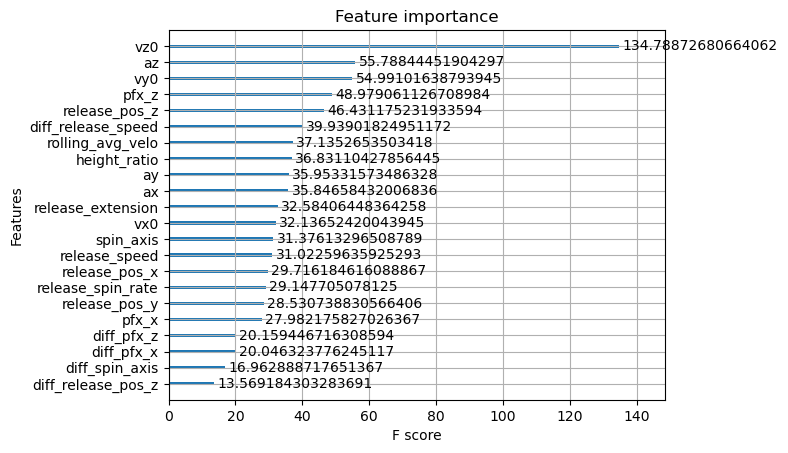

In [29]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

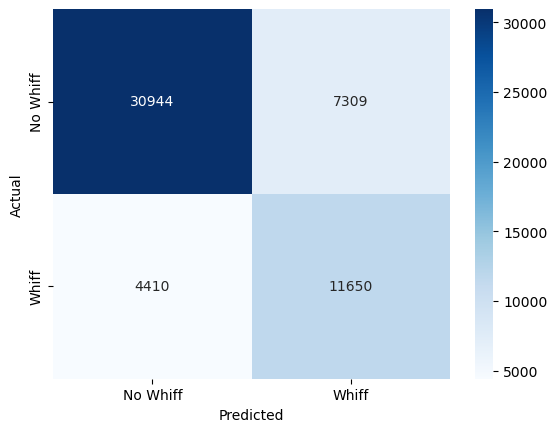

In [30]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Whiff', 'Whiff'], yticklabels=['No Whiff', 'Whiff'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [31]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z',
       'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [32]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [33]:
y_pred = final_model.predict(predictions)

In [34]:
testing_identifiers['xwhiff'] = y_pred

In [35]:
testing_identifiers.head()

pitch_id_raw    xwhiff
64    661032_608070_623474_4_62_9  0.587178
74    661032_680911_628452_4_64_9  0.239749
1124  661032_640458_663776_2_49_7  0.579269
1125  661032_640458_663776_2_49_7  0.539571
1126  661032_640458_663776_2_49_7  0.539571

In [36]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/whiff_2022&3_xwhiff.csv")